In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [70]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [71]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [72]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [73]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_fly_ball(bb_type):
        return 1 if bb_type == "fly_ball" else 0

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['contact'] = df['description'].apply(is_contact)


    df['fb'] = df['bb_type'].apply(is_fly_ball)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [75]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [76]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [120]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'BIP',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'BIP',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [121]:
train_data = training_features.drop(['fb'], axis=1).copy()
train_label = training_features['fb'].copy()
testing_data = testing_features.drop(['fb'], axis=1).copy()
testing_label = testing_features['fb'].copy()

In [82]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [122]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [98]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [99]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [100]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5800479945149126
Log Loss: 0.6654390855055361


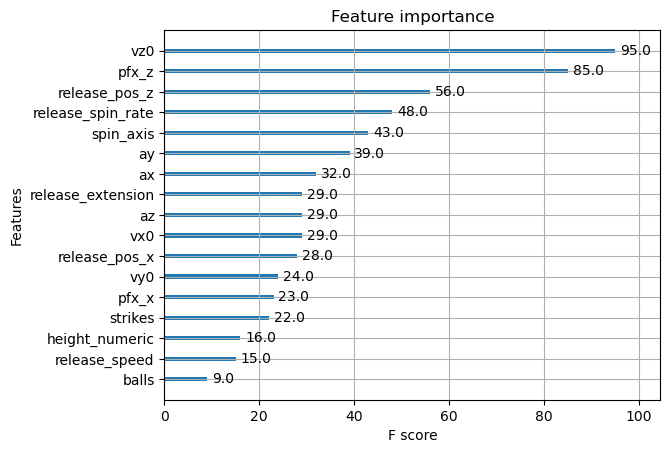

In [101]:
xgb.plot_importance(model)
plt.show()

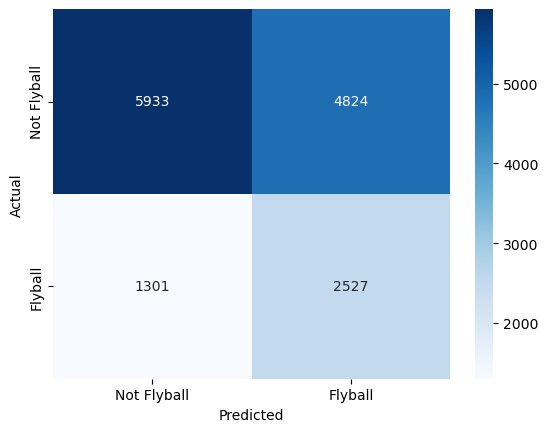

In [102]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [109]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=1000,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [110]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 11:08:26,210] A new study created in memory with name: no-name-2f9d6636-e5b0-4a7a-9864-7fe421e8425e


[0]	eval-logloss:0.57258
[1]	eval-logloss:0.56860
[2]	eval-logloss:0.56558
[3]	eval-logloss:0.56301
[4]	eval-logloss:0.56084
[5]	eval-logloss:0.55900
[6]	eval-logloss:0.55767
[7]	eval-logloss:0.55674
[8]	eval-logloss:0.55583
[9]	eval-logloss:0.55502
[10]	eval-logloss:0.55446
[11]	eval-logloss:0.55379
[12]	eval-logloss:0.55315
[13]	eval-logloss:0.55281
[14]	eval-logloss:0.55269
[15]	eval-logloss:0.55238
[16]	eval-logloss:0.55222
[17]	eval-logloss:0.55191
[18]	eval-logloss:0.55188
[19]	eval-logloss:0.55173
[20]	eval-logloss:0.55157
[21]	eval-logloss:0.55170
[22]	eval-logloss:0.55185
[23]	eval-logloss:0.55183
[24]	eval-logloss:0.55191
[25]	eval-logloss:0.55189
[26]	eval-logloss:0.55199
[27]	eval-logloss:0.55205
[28]	eval-logloss:0.55165
[29]	eval-logloss:0.55159
[30]	eval-logloss:0.55169
[31]	eval-logloss:0.55175
[32]	eval-logloss:0.55186
[33]	eval-logloss:0.55187
[34]	eval-logloss:0.55195
[35]	eval-logloss:0.55192
[36]	eval-logloss:0.55202
[37]	eval-logloss:0.55210
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:27,074] Trial 0 finished with value: 0.5533841716277065 and parameters: {'max_depth': 7, 'eta': 0.11563527052785934, 'subsample': 0.7915246808125714, 'colsample_bytree': 0.9410492412068656}. Best is trial 0 with value: 0.5533841716277065.


[0]	eval-logloss:0.57363
[1]	eval-logloss:0.57005
[2]	eval-logloss:0.56780
[3]	eval-logloss:0.56538
[4]	eval-logloss:0.56334
[5]	eval-logloss:0.56174
[6]	eval-logloss:0.56050
[7]	eval-logloss:0.55944
[8]	eval-logloss:0.55851
[9]	eval-logloss:0.55769
[10]	eval-logloss:0.55689
[11]	eval-logloss:0.55629
[12]	eval-logloss:0.55580
[13]	eval-logloss:0.55538
[14]	eval-logloss:0.55495
[15]	eval-logloss:0.55459
[16]	eval-logloss:0.55427
[17]	eval-logloss:0.55400
[18]	eval-logloss:0.55367
[19]	eval-logloss:0.55337
[20]	eval-logloss:0.55319
[21]	eval-logloss:0.55296
[22]	eval-logloss:0.55276
[23]	eval-logloss:0.55257
[24]	eval-logloss:0.55242
[25]	eval-logloss:0.55239
[26]	eval-logloss:0.55227
[27]	eval-logloss:0.55208
[28]	eval-logloss:0.55195
[29]	eval-logloss:0.55179
[30]	eval-logloss:0.55169
[31]	eval-logloss:0.55153
[32]	eval-logloss:0.55136
[33]	eval-logloss:0.55132
[34]	eval-logloss:0.55127
[35]	eval-logloss:0.55114
[36]	eval-logloss:0.55104
[37]	eval-logloss:0.55078
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:28,252] Trial 1 finished with value: 0.5490764406113041 and parameters: {'max_depth': 3, 'eta': 0.12962623795839293, 'subsample': 0.8152255080940984, 'colsample_bytree': 0.7271084429212702}. Best is trial 0 with value: 0.5533841716277065.


[0]	eval-logloss:0.57549
[1]	eval-logloss:0.57318
[2]	eval-logloss:0.57213
[3]	eval-logloss:0.56949
[4]	eval-logloss:0.56776
[5]	eval-logloss:0.56590
[6]	eval-logloss:0.56416
[7]	eval-logloss:0.56300
[8]	eval-logloss:0.56242
[9]	eval-logloss:0.56196
[10]	eval-logloss:0.56063
[11]	eval-logloss:0.55964
[12]	eval-logloss:0.55857
[13]	eval-logloss:0.55798
[14]	eval-logloss:0.55757
[15]	eval-logloss:0.55702
[16]	eval-logloss:0.55671
[17]	eval-logloss:0.55604
[18]	eval-logloss:0.55537
[19]	eval-logloss:0.55479
[20]	eval-logloss:0.55443
[21]	eval-logloss:0.55403
[22]	eval-logloss:0.55362
[23]	eval-logloss:0.55343
[24]	eval-logloss:0.55300
[25]	eval-logloss:0.55288
[26]	eval-logloss:0.55262
[27]	eval-logloss:0.55224
[28]	eval-logloss:0.55222
[29]	eval-logloss:0.55220
[30]	eval-logloss:0.55209
[31]	eval-logloss:0.55194
[32]	eval-logloss:0.55167
[33]	eval-logloss:0.55163
[34]	eval-logloss:0.55138
[35]	eval-logloss:0.55132
[36]	eval-logloss:0.55118
[37]	eval-logloss:0.55118
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:29,414] Trial 2 finished with value: 0.5506847582631239 and parameters: {'max_depth': 6, 'eta': 0.07298941909339308, 'subsample': 0.6111470062441386, 'colsample_bytree': 0.5338685772734186}. Best is trial 0 with value: 0.5533841716277065.


[0]	eval-logloss:0.57632
[1]	eval-logloss:0.57520
[2]	eval-logloss:0.57420
[3]	eval-logloss:0.57312
[4]	eval-logloss:0.57212
[5]	eval-logloss:0.57121
[6]	eval-logloss:0.57034
[7]	eval-logloss:0.56951
[8]	eval-logloss:0.56871
[9]	eval-logloss:0.56798
[10]	eval-logloss:0.56727
[11]	eval-logloss:0.56664
[12]	eval-logloss:0.56602
[13]	eval-logloss:0.56539
[14]	eval-logloss:0.56478
[15]	eval-logloss:0.56429
[16]	eval-logloss:0.56401
[17]	eval-logloss:0.56355
[18]	eval-logloss:0.56305
[19]	eval-logloss:0.56255
[20]	eval-logloss:0.56212
[21]	eval-logloss:0.56171
[22]	eval-logloss:0.56127
[23]	eval-logloss:0.56080
[24]	eval-logloss:0.56038
[25]	eval-logloss:0.56010
[26]	eval-logloss:0.55980
[27]	eval-logloss:0.55943
[28]	eval-logloss:0.55912
[29]	eval-logloss:0.55884
[30]	eval-logloss:0.55860
[31]	eval-logloss:0.55829
[32]	eval-logloss:0.55802
[33]	eval-logloss:0.55776
[34]	eval-logloss:0.55750
[35]	eval-logloss:0.55726
[36]	eval-logloss:0.55706
[37]	eval-logloss:0.55683
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:32,694] Trial 3 finished with value: 0.5482138866371598 and parameters: {'max_depth': 4, 'eta': 0.03121884303702699, 'subsample': 0.6955873860490039, 'colsample_bytree': 0.734703703055339}. Best is trial 0 with value: 0.5533841716277065.


[0]	eval-logloss:0.57625
[1]	eval-logloss:0.57451
[2]	eval-logloss:0.57380
[3]	eval-logloss:0.57231
[4]	eval-logloss:0.57111
[5]	eval-logloss:0.56983
[6]	eval-logloss:0.56865
[7]	eval-logloss:0.56782
[8]	eval-logloss:0.56678
[9]	eval-logloss:0.56630
[10]	eval-logloss:0.56534
[11]	eval-logloss:0.56437
[12]	eval-logloss:0.56353
[13]	eval-logloss:0.56271
[14]	eval-logloss:0.56193
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.56100
[17]	eval-logloss:0.56024
[18]	eval-logloss:0.55963
[19]	eval-logloss:0.55897
[20]	eval-logloss:0.55857
[21]	eval-logloss:0.55819
[22]	eval-logloss:0.55766
[23]	eval-logloss:0.55731
[24]	eval-logloss:0.55693
[25]	eval-logloss:0.55660
[26]	eval-logloss:0.55622
[27]	eval-logloss:0.55583
[28]	eval-logloss:0.55564
[29]	eval-logloss:0.55544
[30]	eval-logloss:0.55524
[31]	eval-logloss:0.55510
[32]	eval-logloss:0.55474
[33]	eval-logloss:0.55447
[34]	eval-logloss:0.55419
[35]	eval-logloss:0.55400
[36]	eval-logloss:0.55392
[37]	eval-logloss:0.55377
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:34,444] Trial 4 finished with value: 0.549473765064582 and parameters: {'max_depth': 6, 'eta': 0.04019397235816827, 'subsample': 0.8161598413357778, 'colsample_bytree': 0.6468967467823892}. Best is trial 0 with value: 0.5533841716277065.


[0]	eval-logloss:0.56753
[1]	eval-logloss:0.56131
[2]	eval-logloss:0.55784
[3]	eval-logloss:0.55568
[4]	eval-logloss:0.55403
[5]	eval-logloss:0.55311
[6]	eval-logloss:0.55221
[7]	eval-logloss:0.55170
[8]	eval-logloss:0.55157
[9]	eval-logloss:0.55142
[10]	eval-logloss:0.55097
[11]	eval-logloss:0.55097
[12]	eval-logloss:0.55077
[13]	eval-logloss:0.55063
[14]	eval-logloss:0.55053
[15]	eval-logloss:0.55090
[16]	eval-logloss:0.55095
[17]	eval-logloss:0.55086
[18]	eval-logloss:0.55058
[19]	eval-logloss:0.55062
[20]	eval-logloss:0.55067
[21]	eval-logloss:0.55066
[22]	eval-logloss:0.55068
[23]	eval-logloss:0.55078
[24]	eval-logloss:0.55095
[25]	eval-logloss:0.55117
[26]	eval-logloss:0.55143
[27]	eval-logloss:0.55141
[28]	eval-logloss:0.55125
[29]	eval-logloss:0.55131
[30]	eval-logloss:0.55137
[31]	eval-logloss:0.55138
[32]	eval-logloss:0.55157
[33]	eval-logloss:0.55175
[34]	eval-logloss:0.55178
[35]	eval-logloss:0.55197
[36]	eval-logloss:0.55216
[37]	eval-logloss:0.55239
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:35,000] Trial 5 finished with value: 0.5551977782278429 and parameters: {'max_depth': 5, 'eta': 0.2823685826408225, 'subsample': 0.8589661725888882, 'colsample_bytree': 0.9793918889215822}. Best is trial 5 with value: 0.5551977782278429.


[0]	eval-logloss:0.57056
[1]	eval-logloss:0.56532
[2]	eval-logloss:0.56352
[3]	eval-logloss:0.55925
[4]	eval-logloss:0.55737
[5]	eval-logloss:0.55558
[6]	eval-logloss:0.55430
[7]	eval-logloss:0.55403
[8]	eval-logloss:0.55390
[9]	eval-logloss:0.55363
[10]	eval-logloss:0.55268
[11]	eval-logloss:0.55215
[12]	eval-logloss:0.55193
[13]	eval-logloss:0.55152
[14]	eval-logloss:0.55133
[15]	eval-logloss:0.55125
[16]	eval-logloss:0.55102
[17]	eval-logloss:0.55075
[18]	eval-logloss:0.55073
[19]	eval-logloss:0.55040
[20]	eval-logloss:0.55032
[21]	eval-logloss:0.55013
[22]	eval-logloss:0.54996
[23]	eval-logloss:0.55008
[24]	eval-logloss:0.55014
[25]	eval-logloss:0.55016
[26]	eval-logloss:0.55005
[27]	eval-logloss:0.55009
[28]	eval-logloss:0.55012
[29]	eval-logloss:0.55016
[30]	eval-logloss:0.55010
[31]	eval-logloss:0.55022
[32]	eval-logloss:0.55021
[33]	eval-logloss:0.55015
[34]	eval-logloss:0.55027
[35]	eval-logloss:0.55046
[36]	eval-logloss:0.55061
[37]	eval-logloss:0.55054
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:35,530] Trial 6 finished with value: 0.5516698936902643 and parameters: {'max_depth': 4, 'eta': 0.2822459573041089, 'subsample': 0.8035052920986886, 'colsample_bytree': 0.5454234770682248}. Best is trial 5 with value: 0.5551977782278429.


[0]	eval-logloss:0.56989
[1]	eval-logloss:0.56452
[2]	eval-logloss:0.56100
[3]	eval-logloss:0.55800
[4]	eval-logloss:0.55618
[5]	eval-logloss:0.55499
[6]	eval-logloss:0.55434
[7]	eval-logloss:0.55380
[8]	eval-logloss:0.55320
[9]	eval-logloss:0.55295
[10]	eval-logloss:0.55258
[11]	eval-logloss:0.55251
[12]	eval-logloss:0.55241
[13]	eval-logloss:0.55233
[14]	eval-logloss:0.55227
[15]	eval-logloss:0.55221
[16]	eval-logloss:0.55221
[17]	eval-logloss:0.55254
[18]	eval-logloss:0.55222
[19]	eval-logloss:0.55221
[20]	eval-logloss:0.55217
[21]	eval-logloss:0.55198
[22]	eval-logloss:0.55188
[23]	eval-logloss:0.55192
[24]	eval-logloss:0.55182
[25]	eval-logloss:0.55201
[26]	eval-logloss:0.55215
[27]	eval-logloss:0.55217
[28]	eval-logloss:0.55222
[29]	eval-logloss:0.55275
[30]	eval-logloss:0.55300
[31]	eval-logloss:0.55305
[32]	eval-logloss:0.55315
[33]	eval-logloss:0.55339
[34]	eval-logloss:0.55366
[35]	eval-logloss:0.55405
[36]	eval-logloss:0.55403
[37]	eval-logloss:0.55376
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:36,291] Trial 7 finished with value: 0.5595602896302908 and parameters: {'max_depth': 6, 'eta': 0.208879112764245, 'subsample': 0.6484769466873287, 'colsample_bytree': 0.7904952103082363}. Best is trial 7 with value: 0.5595602896302908.


[0]	eval-logloss:0.57347
[1]	eval-logloss:0.57003
[2]	eval-logloss:0.56743
[3]	eval-logloss:0.56490
[4]	eval-logloss:0.56278
[5]	eval-logloss:0.56100
[6]	eval-logloss:0.55978
[7]	eval-logloss:0.55866
[8]	eval-logloss:0.55774
[9]	eval-logloss:0.55695
[10]	eval-logloss:0.55628
[11]	eval-logloss:0.55580
[12]	eval-logloss:0.55503
[13]	eval-logloss:0.55470
[14]	eval-logloss:0.55446
[15]	eval-logloss:0.55411
[16]	eval-logloss:0.55388
[17]	eval-logloss:0.55359
[18]	eval-logloss:0.55363
[19]	eval-logloss:0.55350
[20]	eval-logloss:0.55351
[21]	eval-logloss:0.55338
[22]	eval-logloss:0.55315
[23]	eval-logloss:0.55300
[24]	eval-logloss:0.55317
[25]	eval-logloss:0.55298
[26]	eval-logloss:0.55308
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.55306
[29]	eval-logloss:0.55302
[30]	eval-logloss:0.55287
[31]	eval-logloss:0.55295
[32]	eval-logloss:0.55303
[33]	eval-logloss:0.55293
[34]	eval-logloss:0.55328
[35]	eval-logloss:0.55348
[36]	eval-logloss:0.55346
[37]	eval-logloss:0.55353
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:37,542] Trial 8 finished with value: 0.5575922455684511 and parameters: {'max_depth': 9, 'eta': 0.09601347015884228, 'subsample': 0.7652186462109183, 'colsample_bytree': 0.9436740818077185}. Best is trial 7 with value: 0.5595602896302908.


[0]	eval-logloss:0.57434
[1]	eval-logloss:0.57129
[2]	eval-logloss:0.57005
[3]	eval-logloss:0.56682
[4]	eval-logloss:0.56489
[5]	eval-logloss:0.56276
[6]	eval-logloss:0.56101
[7]	eval-logloss:0.56002
[8]	eval-logloss:0.55952
[9]	eval-logloss:0.55915
[10]	eval-logloss:0.55792
[11]	eval-logloss:0.55691
[12]	eval-logloss:0.55593
[13]	eval-logloss:0.55553
[14]	eval-logloss:0.55533
[15]	eval-logloss:0.55500
[16]	eval-logloss:0.55473
[17]	eval-logloss:0.55424
[18]	eval-logloss:0.55389
[19]	eval-logloss:0.55347
[20]	eval-logloss:0.55325
[21]	eval-logloss:0.55301
[22]	eval-logloss:0.55260
[23]	eval-logloss:0.55250
[24]	eval-logloss:0.55219
[25]	eval-logloss:0.55210
[26]	eval-logloss:0.55190
[27]	eval-logloss:0.55151
[28]	eval-logloss:0.55146
[29]	eval-logloss:0.55139
[30]	eval-logloss:0.55133
[31]	eval-logloss:0.55119
[32]	eval-logloss:0.55106
[33]	eval-logloss:0.55106
[34]	eval-logloss:0.55092
[35]	eval-logloss:0.55098
[36]	eval-logloss:0.55074
[37]	eval-logloss:0.55072
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:38,717] Trial 9 finished with value: 0.549420118634189 and parameters: {'max_depth': 4, 'eta': 0.11727227733886464, 'subsample': 0.6288787735045805, 'colsample_bytree': 0.537863319509479}. Best is trial 7 with value: 0.5595602896302908.


[0]	eval-logloss:0.56976
[1]	eval-logloss:0.56459
[2]	eval-logloss:0.56166
[3]	eval-logloss:0.55868
[4]	eval-logloss:0.55704
[5]	eval-logloss:0.55616
[6]	eval-logloss:0.55548
[7]	eval-logloss:0.55479
[8]	eval-logloss:0.55452
[9]	eval-logloss:0.55412
[10]	eval-logloss:0.55372
[11]	eval-logloss:0.55377
[12]	eval-logloss:0.55380
[13]	eval-logloss:0.55382
[14]	eval-logloss:0.55345
[15]	eval-logloss:0.55352
[16]	eval-logloss:0.55394
[17]	eval-logloss:0.55398
[18]	eval-logloss:0.55403
[19]	eval-logloss:0.55416
[20]	eval-logloss:0.55412
[21]	eval-logloss:0.55415
[22]	eval-logloss:0.55437
[23]	eval-logloss:0.55443
[24]	eval-logloss:0.55451
[25]	eval-logloss:0.55483
[26]	eval-logloss:0.55491
[27]	eval-logloss:0.55503
[28]	eval-logloss:0.55476
[29]	eval-logloss:0.55474
[30]	eval-logloss:0.55473
[31]	eval-logloss:0.55489
[32]	eval-logloss:0.55488
[33]	eval-logloss:0.55526
[34]	eval-logloss:0.55554
[35]	eval-logloss:0.55558
[36]	eval-logloss:0.55601
[37]	eval-logloss:0.55619
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:39,534] Trial 10 finished with value: 0.5625262332073209 and parameters: {'max_depth': 8, 'eta': 0.1870706240984132, 'subsample': 0.6915956441310311, 'colsample_bytree': 0.8293566058066293}. Best is trial 10 with value: 0.5625262332073209.


[0]	eval-logloss:0.56986
[1]	eval-logloss:0.56507
[2]	eval-logloss:0.56151
[3]	eval-logloss:0.55866
[4]	eval-logloss:0.55706
[5]	eval-logloss:0.55578
[6]	eval-logloss:0.55486
[7]	eval-logloss:0.55466
[8]	eval-logloss:0.55429
[9]	eval-logloss:0.55417
[10]	eval-logloss:0.55364
[11]	eval-logloss:0.55394
[12]	eval-logloss:0.55397
[13]	eval-logloss:0.55405
[14]	eval-logloss:0.55420
[15]	eval-logloss:0.55405
[16]	eval-logloss:0.55471
[17]	eval-logloss:0.55485
[18]	eval-logloss:0.55491
[19]	eval-logloss:0.55468
[20]	eval-logloss:0.55447
[21]	eval-logloss:0.55488
[22]	eval-logloss:0.55536
[23]	eval-logloss:0.55548
[24]	eval-logloss:0.55548
[25]	eval-logloss:0.55573
[26]	eval-logloss:0.55579
[27]	eval-logloss:0.55639
[28]	eval-logloss:0.55652
[29]	eval-logloss:0.55654
[30]	eval-logloss:0.55660
[31]	eval-logloss:0.55681
[32]	eval-logloss:0.55680
[33]	eval-logloss:0.55671
[34]	eval-logloss:0.55730
[35]	eval-logloss:0.55815
[36]	eval-logloss:0.55838
[37]	eval-logloss:0.55856
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:40,251] Trial 11 finished with value: 0.5648766814167703 and parameters: {'max_depth': 8, 'eta': 0.18858754638512262, 'subsample': 0.6931411290749312, 'colsample_bytree': 0.8563640710912739}. Best is trial 11 with value: 0.5648766814167703.


[0]	eval-logloss:0.57049
[1]	eval-logloss:0.56619
[2]	eval-logloss:0.56298
[3]	eval-logloss:0.56042
[4]	eval-logloss:0.55897
[5]	eval-logloss:0.55838
[6]	eval-logloss:0.55765
[7]	eval-logloss:0.55729
[8]	eval-logloss:0.55703
[9]	eval-logloss:0.55698
[10]	eval-logloss:0.55744
[11]	eval-logloss:0.55756
[12]	eval-logloss:0.55751
[13]	eval-logloss:0.55773
[14]	eval-logloss:0.55784
[15]	eval-logloss:0.55854
[16]	eval-logloss:0.55914
[17]	eval-logloss:0.55964
[18]	eval-logloss:0.55958
[19]	eval-logloss:0.55977
[20]	eval-logloss:0.55963
[21]	eval-logloss:0.55979
[22]	eval-logloss:0.55961
[23]	eval-logloss:0.55956
[24]	eval-logloss:0.55969
[25]	eval-logloss:0.55976
[26]	eval-logloss:0.55981
[27]	eval-logloss:0.56017
[28]	eval-logloss:0.56034
[29]	eval-logloss:0.56049
[30]	eval-logloss:0.56055
[31]	eval-logloss:0.56130
[32]	eval-logloss:0.56194
[33]	eval-logloss:0.56212
[34]	eval-logloss:0.56254
[35]	eval-logloss:0.56319
[36]	eval-logloss:0.56376
[37]	eval-logloss:0.56358
[38]	eval-logloss:0.56

[I 2023-11-09 11:08:41,115] Trial 12 finished with value: 0.570551734284133 and parameters: {'max_depth': 9, 'eta': 0.18564570686743737, 'subsample': 0.7151872709819748, 'colsample_bytree': 0.8537138728150954}. Best is trial 12 with value: 0.570551734284133.


[0]	eval-logloss:0.57078
[1]	eval-logloss:0.56610
[2]	eval-logloss:0.56323
[3]	eval-logloss:0.56086
[4]	eval-logloss:0.55901
[5]	eval-logloss:0.55869
[6]	eval-logloss:0.55816
[7]	eval-logloss:0.55763
[8]	eval-logloss:0.55767
[9]	eval-logloss:0.55794
[10]	eval-logloss:0.55820
[11]	eval-logloss:0.55861
[12]	eval-logloss:0.55852
[13]	eval-logloss:0.55877
[14]	eval-logloss:0.55858
[15]	eval-logloss:0.55877
[16]	eval-logloss:0.55912
[17]	eval-logloss:0.55960
[18]	eval-logloss:0.55993
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.56016
[21]	eval-logloss:0.56050
[22]	eval-logloss:0.56032
[23]	eval-logloss:0.56041
[24]	eval-logloss:0.56038
[25]	eval-logloss:0.56104
[26]	eval-logloss:0.56100
[27]	eval-logloss:0.56109
[28]	eval-logloss:0.56143
[29]	eval-logloss:0.56177
[30]	eval-logloss:0.56218
[31]	eval-logloss:0.56286
[32]	eval-logloss:0.56314
[33]	eval-logloss:0.56332
[34]	eval-logloss:0.56393
[35]	eval-logloss:0.56501
[36]	eval-logloss:0.56552
[37]	eval-logloss:0.56597
[38]	eval-logloss:0.56

[I 2023-11-09 11:08:41,961] Trial 13 finished with value: 0.5719244313387452 and parameters: {'max_depth': 9, 'eta': 0.18030921337461336, 'subsample': 0.718484732356088, 'colsample_bytree': 0.8712073171836693}. Best is trial 13 with value: 0.5719244313387452.


[0]	eval-logloss:0.57070
[1]	eval-logloss:0.56672
[2]	eval-logloss:0.56375
[3]	eval-logloss:0.56110
[4]	eval-logloss:0.55883
[5]	eval-logloss:0.55775
[6]	eval-logloss:0.55671
[7]	eval-logloss:0.55595
[8]	eval-logloss:0.55551
[9]	eval-logloss:0.55542
[10]	eval-logloss:0.55592
[11]	eval-logloss:0.55573
[12]	eval-logloss:0.55579
[13]	eval-logloss:0.55587
[14]	eval-logloss:0.55590
[15]	eval-logloss:0.55615
[16]	eval-logloss:0.55650
[17]	eval-logloss:0.55623
[18]	eval-logloss:0.55652
[19]	eval-logloss:0.55668
[20]	eval-logloss:0.55656
[21]	eval-logloss:0.55715
[22]	eval-logloss:0.55757
[23]	eval-logloss:0.55733
[24]	eval-logloss:0.55754
[25]	eval-logloss:0.55770
[26]	eval-logloss:0.55801
[27]	eval-logloss:0.55804
[28]	eval-logloss:0.55809
[29]	eval-logloss:0.55866
[30]	eval-logloss:0.55898
[31]	eval-logloss:0.55924
[32]	eval-logloss:0.55968
[33]	eval-logloss:0.56004
[34]	eval-logloss:0.56041
[35]	eval-logloss:0.56025
[36]	eval-logloss:0.56045
[37]	eval-logloss:0.56069
[38]	eval-logloss:0.56

[I 2023-11-09 11:08:42,880] Trial 14 finished with value: 0.5660784799133682 and parameters: {'max_depth': 9, 'eta': 0.1602085724186335, 'subsample': 0.7355744893458445, 'colsample_bytree': 0.8861373265797409}. Best is trial 13 with value: 0.5719244313387452.


[0]	eval-logloss:0.56892
[1]	eval-logloss:0.56360
[2]	eval-logloss:0.56047
[3]	eval-logloss:0.55792
[4]	eval-logloss:0.55676
[5]	eval-logloss:0.55599
[6]	eval-logloss:0.55562
[7]	eval-logloss:0.55583
[8]	eval-logloss:0.55598
[9]	eval-logloss:0.55601
[10]	eval-logloss:0.55657
[11]	eval-logloss:0.55694
[12]	eval-logloss:0.55716
[13]	eval-logloss:0.55767
[14]	eval-logloss:0.55829
[15]	eval-logloss:0.55834
[16]	eval-logloss:0.55879
[17]	eval-logloss:0.55920
[18]	eval-logloss:0.55921
[19]	eval-logloss:0.55916
[20]	eval-logloss:0.55930
[21]	eval-logloss:0.55938
[22]	eval-logloss:0.55981
[23]	eval-logloss:0.55981
[24]	eval-logloss:0.56013
[25]	eval-logloss:0.55997
[26]	eval-logloss:0.56046
[27]	eval-logloss:0.56098
[28]	eval-logloss:0.56112
[29]	eval-logloss:0.56128
[30]	eval-logloss:0.56226
[31]	eval-logloss:0.56269
[32]	eval-logloss:0.56290
[33]	eval-logloss:0.56294
[34]	eval-logloss:0.56326
[35]	eval-logloss:0.56366
[36]	eval-logloss:0.56352
[37]	eval-logloss:0.56417
[38]	eval-logloss:0.56

[I 2023-11-09 11:08:43,620] Trial 15 finished with value: 0.5694169937293792 and parameters: {'max_depth': 8, 'eta': 0.21816694441364531, 'subsample': 0.7213793767295034, 'colsample_bytree': 0.8870562656492288}. Best is trial 13 with value: 0.5719244313387452.


[0]	eval-logloss:0.56937
[1]	eval-logloss:0.56482
[2]	eval-logloss:0.56196
[3]	eval-logloss:0.56023
[4]	eval-logloss:0.56008
[5]	eval-logloss:0.55954
[6]	eval-logloss:0.55955
[7]	eval-logloss:0.56002
[8]	eval-logloss:0.56024
[9]	eval-logloss:0.56091
[10]	eval-logloss:0.56119
[11]	eval-logloss:0.56133
[12]	eval-logloss:0.56225
[13]	eval-logloss:0.56240
[14]	eval-logloss:0.56227
[15]	eval-logloss:0.56250
[16]	eval-logloss:0.56275
[17]	eval-logloss:0.56410
[18]	eval-logloss:0.56481
[19]	eval-logloss:0.56475
[20]	eval-logloss:0.56552
[21]	eval-logloss:0.56618
[22]	eval-logloss:0.56713
[23]	eval-logloss:0.56703
[24]	eval-logloss:0.56737
[25]	eval-logloss:0.56855
[26]	eval-logloss:0.56830
[27]	eval-logloss:0.56836
[28]	eval-logloss:0.56918
[29]	eval-logloss:0.56918
[30]	eval-logloss:0.57056
[31]	eval-logloss:0.57069
[32]	eval-logloss:0.57080
[33]	eval-logloss:0.57077
[34]	eval-logloss:0.57095
[35]	eval-logloss:0.57150
[36]	eval-logloss:0.57167
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:44,361] Trial 16 finished with value: 0.5825866477864807 and parameters: {'max_depth': 9, 'eta': 0.2408084193493465, 'subsample': 0.6599605037072098, 'colsample_bytree': 0.788546295982389}. Best is trial 16 with value: 0.5825866477864807.


[0]	eval-logloss:0.56799
[1]	eval-logloss:0.56221
[2]	eval-logloss:0.55866
[3]	eval-logloss:0.55602
[4]	eval-logloss:0.55474
[5]	eval-logloss:0.55410
[6]	eval-logloss:0.55406
[7]	eval-logloss:0.55354
[8]	eval-logloss:0.55310
[9]	eval-logloss:0.55357
[10]	eval-logloss:0.55359
[11]	eval-logloss:0.55351
[12]	eval-logloss:0.55358
[13]	eval-logloss:0.55351
[14]	eval-logloss:0.55361
[15]	eval-logloss:0.55378
[16]	eval-logloss:0.55460
[17]	eval-logloss:0.55464
[18]	eval-logloss:0.55480
[19]	eval-logloss:0.55505
[20]	eval-logloss:0.55535
[21]	eval-logloss:0.55544
[22]	eval-logloss:0.55580
[23]	eval-logloss:0.55580
[24]	eval-logloss:0.55584
[25]	eval-logloss:0.55619
[26]	eval-logloss:0.55642
[27]	eval-logloss:0.55672
[28]	eval-logloss:0.55663
[29]	eval-logloss:0.55666
[30]	eval-logloss:0.55701
[31]	eval-logloss:0.55747
[32]	eval-logloss:0.55785
[33]	eval-logloss:0.55800
[34]	eval-logloss:0.55833
[35]	eval-logloss:0.55894
[36]	eval-logloss:0.55878
[37]	eval-logloss:0.55913
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:44,972] Trial 17 finished with value: 0.5646207601195973 and parameters: {'max_depth': 7, 'eta': 0.25220637135963403, 'subsample': 0.6624208788229219, 'colsample_bytree': 0.7827458782940766}. Best is trial 16 with value: 0.5825866477864807.


[0]	eval-logloss:0.57117
[1]	eval-logloss:0.56434
[2]	eval-logloss:0.56029
[3]	eval-logloss:0.55742
[4]	eval-logloss:0.55599
[5]	eval-logloss:0.55498
[6]	eval-logloss:0.55448
[7]	eval-logloss:0.55431
[8]	eval-logloss:0.55365
[9]	eval-logloss:0.55357
[10]	eval-logloss:0.55362
[11]	eval-logloss:0.55353
[12]	eval-logloss:0.55379
[13]	eval-logloss:0.55394
[14]	eval-logloss:0.55405
[15]	eval-logloss:0.55440
[16]	eval-logloss:0.55477
[17]	eval-logloss:0.55481
[18]	eval-logloss:0.55478
[19]	eval-logloss:0.55515
[20]	eval-logloss:0.55508
[21]	eval-logloss:0.55536
[22]	eval-logloss:0.55532
[23]	eval-logloss:0.55525
[24]	eval-logloss:0.55534
[25]	eval-logloss:0.55608
[26]	eval-logloss:0.55661
[27]	eval-logloss:0.55697
[28]	eval-logloss:0.55705
[29]	eval-logloss:0.55716
[30]	eval-logloss:0.55783
[31]	eval-logloss:0.55803
[32]	eval-logloss:0.55817
[33]	eval-logloss:0.55795
[34]	eval-logloss:0.55779
[35]	eval-logloss:0.55811
[36]	eval-logloss:0.55815
[37]	eval-logloss:0.55842
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:45,629] Trial 18 finished with value: 0.5639958343654585 and parameters: {'max_depth': 7, 'eta': 0.24526060874228928, 'subsample': 0.6600290871867961, 'colsample_bytree': 0.6928487327182435}. Best is trial 16 with value: 0.5825866477864807.


[0]	eval-logloss:0.57169
[1]	eval-logloss:0.56701
[2]	eval-logloss:0.56367
[3]	eval-logloss:0.56109
[4]	eval-logloss:0.55905
[5]	eval-logloss:0.55754
[6]	eval-logloss:0.55620
[7]	eval-logloss:0.55532
[8]	eval-logloss:0.55452
[9]	eval-logloss:0.55432
[10]	eval-logloss:0.55417
[11]	eval-logloss:0.55380
[12]	eval-logloss:0.55375
[13]	eval-logloss:0.55374
[14]	eval-logloss:0.55372
[15]	eval-logloss:0.55341
[16]	eval-logloss:0.55347
[17]	eval-logloss:0.55332
[18]	eval-logloss:0.55329
[19]	eval-logloss:0.55309
[20]	eval-logloss:0.55328
[21]	eval-logloss:0.55332
[22]	eval-logloss:0.55357
[23]	eval-logloss:0.55340
[24]	eval-logloss:0.55372
[25]	eval-logloss:0.55426
[26]	eval-logloss:0.55463
[27]	eval-logloss:0.55482
[28]	eval-logloss:0.55508
[29]	eval-logloss:0.55509
[30]	eval-logloss:0.55534
[31]	eval-logloss:0.55557
[32]	eval-logloss:0.55602
[33]	eval-logloss:0.55619
[34]	eval-logloss:0.55631
[35]	eval-logloss:0.55636
[36]	eval-logloss:0.55680
[37]	eval-logloss:0.55682
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:46,444] Trial 19 finished with value: 0.5613148461495782 and parameters: {'max_depth': 8, 'eta': 0.1497136234250015, 'subsample': 0.7580077551843345, 'colsample_bytree': 0.7968368403914718}. Best is trial 16 with value: 0.5825866477864807.


[0]	eval-logloss:0.56926
[1]	eval-logloss:0.56439
[2]	eval-logloss:0.56134
[3]	eval-logloss:0.55846
[4]	eval-logloss:0.55790
[5]	eval-logloss:0.55712
[6]	eval-logloss:0.55703
[7]	eval-logloss:0.55686
[8]	eval-logloss:0.55710
[9]	eval-logloss:0.55774
[10]	eval-logloss:0.55820
[11]	eval-logloss:0.55872
[12]	eval-logloss:0.55912
[13]	eval-logloss:0.55997
[14]	eval-logloss:0.56055
[15]	eval-logloss:0.56095
[16]	eval-logloss:0.56195
[17]	eval-logloss:0.56250
[18]	eval-logloss:0.56282
[19]	eval-logloss:0.56357
[20]	eval-logloss:0.56369
[21]	eval-logloss:0.56455
[22]	eval-logloss:0.56474
[23]	eval-logloss:0.56540
[24]	eval-logloss:0.56535
[25]	eval-logloss:0.56601
[26]	eval-logloss:0.56634
[27]	eval-logloss:0.56748
[28]	eval-logloss:0.56731
[29]	eval-logloss:0.56774
[30]	eval-logloss:0.56896
[31]	eval-logloss:0.56903
[32]	eval-logloss:0.56936
[33]	eval-logloss:0.56970
[34]	eval-logloss:0.56987
[35]	eval-logloss:0.57039
[36]	eval-logloss:0.57052
[37]	eval-logloss:0.57133
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:47,263] Trial 20 finished with value: 0.5848558785894601 and parameters: {'max_depth': 9, 'eta': 0.23562245989187794, 'subsample': 0.6102688199221467, 'colsample_bytree': 0.993024943589223}. Best is trial 20 with value: 0.5848558785894601.


[0]	eval-logloss:0.56905
[1]	eval-logloss:0.56404
[2]	eval-logloss:0.56065
[3]	eval-logloss:0.55916
[4]	eval-logloss:0.55835
[5]	eval-logloss:0.55790
[6]	eval-logloss:0.55851
[7]	eval-logloss:0.55766
[8]	eval-logloss:0.55893
[9]	eval-logloss:0.55906
[10]	eval-logloss:0.55980
[11]	eval-logloss:0.56064
[12]	eval-logloss:0.56135
[13]	eval-logloss:0.56201
[14]	eval-logloss:0.56277
[15]	eval-logloss:0.56327
[16]	eval-logloss:0.56479
[17]	eval-logloss:0.56596
[18]	eval-logloss:0.56730
[19]	eval-logloss:0.56723
[20]	eval-logloss:0.56759
[21]	eval-logloss:0.56830
[22]	eval-logloss:0.56917
[23]	eval-logloss:0.56966
[24]	eval-logloss:0.56996
[25]	eval-logloss:0.57065
[26]	eval-logloss:0.57165
[27]	eval-logloss:0.57217
[28]	eval-logloss:0.57315
[29]	eval-logloss:0.57374
[30]	eval-logloss:0.57441
[31]	eval-logloss:0.57460
[32]	eval-logloss:0.57475
[33]	eval-logloss:0.57525
[34]	eval-logloss:0.57633
[35]	eval-logloss:0.57697
[36]	eval-logloss:0.57822
[37]	eval-logloss:0.57867
[38]	eval-logloss:0.58

[I 2023-11-09 11:08:48,081] Trial 21 finished with value: 0.5934001590660378 and parameters: {'max_depth': 9, 'eta': 0.24279147547666743, 'subsample': 0.6104949753597751, 'colsample_bytree': 0.9901594038001581}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56830
[1]	eval-logloss:0.56319
[2]	eval-logloss:0.56047
[3]	eval-logloss:0.55844
[4]	eval-logloss:0.55722
[5]	eval-logloss:0.55765
[6]	eval-logloss:0.55850
[7]	eval-logloss:0.55890
[8]	eval-logloss:0.55961
[9]	eval-logloss:0.56025
[10]	eval-logloss:0.56060
[11]	eval-logloss:0.56127
[12]	eval-logloss:0.56170
[13]	eval-logloss:0.56199
[14]	eval-logloss:0.56243
[15]	eval-logloss:0.56271
[16]	eval-logloss:0.56401
[17]	eval-logloss:0.56465
[18]	eval-logloss:0.56499
[19]	eval-logloss:0.56571
[20]	eval-logloss:0.56609
[21]	eval-logloss:0.56709
[22]	eval-logloss:0.56718
[23]	eval-logloss:0.56738
[24]	eval-logloss:0.56732
[25]	eval-logloss:0.56817
[26]	eval-logloss:0.56859
[27]	eval-logloss:0.56966
[28]	eval-logloss:0.56990
[29]	eval-logloss:0.57054
[30]	eval-logloss:0.57140
[31]	eval-logloss:0.57229
[32]	eval-logloss:0.57285
[33]	eval-logloss:0.57354
[34]	eval-logloss:0.57452
[35]	eval-logloss:0.57492
[36]	eval-logloss:0.57536
[37]	eval-logloss:0.57605
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:48,873] Trial 22 finished with value: 0.5868321600867515 and parameters: {'max_depth': 9, 'eta': 0.24265929540653297, 'subsample': 0.603063995262765, 'colsample_bytree': 0.9749974213726866}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56767
[1]	eval-logloss:0.56304
[2]	eval-logloss:0.56085
[3]	eval-logloss:0.55957
[4]	eval-logloss:0.55863
[5]	eval-logloss:0.55898
[6]	eval-logloss:0.55895
[7]	eval-logloss:0.55921
[8]	eval-logloss:0.55895
[9]	eval-logloss:0.55953
[10]	eval-logloss:0.55996
[11]	eval-logloss:0.56117
[12]	eval-logloss:0.56179
[13]	eval-logloss:0.56216
[14]	eval-logloss:0.56288
[15]	eval-logloss:0.56318
[16]	eval-logloss:0.56473
[17]	eval-logloss:0.56553
[18]	eval-logloss:0.56610
[19]	eval-logloss:0.56591
[20]	eval-logloss:0.56702
[21]	eval-logloss:0.56818
[22]	eval-logloss:0.56848
[23]	eval-logloss:0.56971
[24]	eval-logloss:0.57002
[25]	eval-logloss:0.57130
[26]	eval-logloss:0.57184
[27]	eval-logloss:0.57288
[28]	eval-logloss:0.57385
[29]	eval-logloss:0.57403
[30]	eval-logloss:0.57537
[31]	eval-logloss:0.57590
[32]	eval-logloss:0.57647
[33]	eval-logloss:0.57703
[34]	eval-logloss:0.57792
[35]	eval-logloss:0.57851
[36]	eval-logloss:0.57870
[37]	eval-logloss:0.57963
[38]	eval-logloss:0.58

[I 2023-11-09 11:08:49,545] Trial 23 finished with value: 0.58834292948275 and parameters: {'max_depth': 8, 'eta': 0.2935028591762049, 'subsample': 0.6162287496669335, 'colsample_bytree': 0.995350284882422}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56718
[1]	eval-logloss:0.56206
[2]	eval-logloss:0.55900
[3]	eval-logloss:0.55768
[4]	eval-logloss:0.55732
[5]	eval-logloss:0.55782
[6]	eval-logloss:0.55847
[7]	eval-logloss:0.55924
[8]	eval-logloss:0.55929
[9]	eval-logloss:0.55958
[10]	eval-logloss:0.55990
[11]	eval-logloss:0.56044
[12]	eval-logloss:0.56119
[13]	eval-logloss:0.56149
[14]	eval-logloss:0.56206
[15]	eval-logloss:0.56300
[16]	eval-logloss:0.56381
[17]	eval-logloss:0.56420
[18]	eval-logloss:0.56550
[19]	eval-logloss:0.56630
[20]	eval-logloss:0.56673
[21]	eval-logloss:0.56755
[22]	eval-logloss:0.56822
[23]	eval-logloss:0.56867
[24]	eval-logloss:0.56909
[25]	eval-logloss:0.57043
[26]	eval-logloss:0.57092
[27]	eval-logloss:0.57136
[28]	eval-logloss:0.57175
[29]	eval-logloss:0.57227
[30]	eval-logloss:0.57301
[31]	eval-logloss:0.57419
[32]	eval-logloss:0.57445
[33]	eval-logloss:0.57519
[34]	eval-logloss:0.57628
[35]	eval-logloss:0.57666
[36]	eval-logloss:0.57718
[37]	eval-logloss:0.57772
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:50,160] Trial 24 finished with value: 0.5911342965656982 and parameters: {'max_depth': 8, 'eta': 0.2993730850394992, 'subsample': 0.6091526107426344, 'colsample_bytree': 0.9986493630491461}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56704
[1]	eval-logloss:0.56170
[2]	eval-logloss:0.55918
[3]	eval-logloss:0.55681
[4]	eval-logloss:0.55541
[5]	eval-logloss:0.55489
[6]	eval-logloss:0.55431
[7]	eval-logloss:0.55499
[8]	eval-logloss:0.55501
[9]	eval-logloss:0.55550
[10]	eval-logloss:0.55524
[11]	eval-logloss:0.55546
[12]	eval-logloss:0.55582
[13]	eval-logloss:0.55582
[14]	eval-logloss:0.55649
[15]	eval-logloss:0.55671
[16]	eval-logloss:0.55750
[17]	eval-logloss:0.55812
[18]	eval-logloss:0.55893
[19]	eval-logloss:0.55908
[20]	eval-logloss:0.55975
[21]	eval-logloss:0.56051
[22]	eval-logloss:0.56073
[23]	eval-logloss:0.56148
[24]	eval-logloss:0.56153
[25]	eval-logloss:0.56228
[26]	eval-logloss:0.56246
[27]	eval-logloss:0.56323
[28]	eval-logloss:0.56391
[29]	eval-logloss:0.56438
[30]	eval-logloss:0.56516
[31]	eval-logloss:0.56561
[32]	eval-logloss:0.56567
[33]	eval-logloss:0.56615
[34]	eval-logloss:0.56664
[35]	eval-logloss:0.56707
[36]	eval-logloss:0.56754
[37]	eval-logloss:0.56811
[38]	eval-logloss:0.56

[I 2023-11-09 11:08:50,759] Trial 25 finished with value: 0.5772082486769082 and parameters: {'max_depth': 7, 'eta': 0.29843038578905473, 'subsample': 0.6262629979172181, 'colsample_bytree': 0.9247030904107075}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56797
[1]	eval-logloss:0.56288
[2]	eval-logloss:0.55989
[3]	eval-logloss:0.55771
[4]	eval-logloss:0.55683
[5]	eval-logloss:0.55680
[6]	eval-logloss:0.55694
[7]	eval-logloss:0.55701
[8]	eval-logloss:0.55754
[9]	eval-logloss:0.55754
[10]	eval-logloss:0.55747
[11]	eval-logloss:0.55778
[12]	eval-logloss:0.55817
[13]	eval-logloss:0.55828
[14]	eval-logloss:0.55896
[15]	eval-logloss:0.55940
[16]	eval-logloss:0.55991
[17]	eval-logloss:0.56031
[18]	eval-logloss:0.56082
[19]	eval-logloss:0.56145
[20]	eval-logloss:0.56262
[21]	eval-logloss:0.56359
[22]	eval-logloss:0.56472
[23]	eval-logloss:0.56578
[24]	eval-logloss:0.56631
[25]	eval-logloss:0.56753
[26]	eval-logloss:0.56812
[27]	eval-logloss:0.56837
[28]	eval-logloss:0.56854
[29]	eval-logloss:0.56859
[30]	eval-logloss:0.56902
[31]	eval-logloss:0.56922
[32]	eval-logloss:0.56903
[33]	eval-logloss:0.56958
[34]	eval-logloss:0.57049
[35]	eval-logloss:0.57103
[36]	eval-logloss:0.57198
[37]	eval-logloss:0.57231
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:51,496] Trial 26 finished with value: 0.5813763463353617 and parameters: {'max_depth': 8, 'eta': 0.26934622905702255, 'subsample': 0.6356539324752641, 'colsample_bytree': 0.9959048394127464}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56706
[1]	eval-logloss:0.56296
[2]	eval-logloss:0.55962
[3]	eval-logloss:0.55809
[4]	eval-logloss:0.55801
[5]	eval-logloss:0.55824
[6]	eval-logloss:0.55813
[7]	eval-logloss:0.55755
[8]	eval-logloss:0.55820
[9]	eval-logloss:0.55850
[10]	eval-logloss:0.55963
[11]	eval-logloss:0.56074
[12]	eval-logloss:0.56135
[13]	eval-logloss:0.56192
[14]	eval-logloss:0.56297
[15]	eval-logloss:0.56314
[16]	eval-logloss:0.56440
[17]	eval-logloss:0.56507
[18]	eval-logloss:0.56631
[19]	eval-logloss:0.56697
[20]	eval-logloss:0.56810
[21]	eval-logloss:0.56853
[22]	eval-logloss:0.56944
[23]	eval-logloss:0.56966
[24]	eval-logloss:0.56977
[25]	eval-logloss:0.57101
[26]	eval-logloss:0.57128
[27]	eval-logloss:0.57193
[28]	eval-logloss:0.57211
[29]	eval-logloss:0.57275
[30]	eval-logloss:0.57332
[31]	eval-logloss:0.57407
[32]	eval-logloss:0.57490
[33]	eval-logloss:0.57524
[34]	eval-logloss:0.57597
[35]	eval-logloss:0.57672
[36]	eval-logloss:0.57670
[37]	eval-logloss:0.57711
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:52,159] Trial 27 finished with value: 0.5899753349285568 and parameters: {'max_depth': 8, 'eta': 0.297606227114636, 'subsample': 0.6049583701337244, 'colsample_bytree': 0.9209683932966861}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56713
[1]	eval-logloss:0.56157
[2]	eval-logloss:0.55786
[3]	eval-logloss:0.55524
[4]	eval-logloss:0.55375
[5]	eval-logloss:0.55377
[6]	eval-logloss:0.55375
[7]	eval-logloss:0.55381
[8]	eval-logloss:0.55386
[9]	eval-logloss:0.55371
[10]	eval-logloss:0.55386
[11]	eval-logloss:0.55406
[12]	eval-logloss:0.55472
[13]	eval-logloss:0.55471
[14]	eval-logloss:0.55511
[15]	eval-logloss:0.55536
[16]	eval-logloss:0.55600
[17]	eval-logloss:0.55601
[18]	eval-logloss:0.55668
[19]	eval-logloss:0.55672
[20]	eval-logloss:0.55675
[21]	eval-logloss:0.55715
[22]	eval-logloss:0.55749
[23]	eval-logloss:0.55746
[24]	eval-logloss:0.55789
[25]	eval-logloss:0.55814
[26]	eval-logloss:0.55878
[27]	eval-logloss:0.55938
[28]	eval-logloss:0.55983
[29]	eval-logloss:0.55985
[30]	eval-logloss:0.56053
[31]	eval-logloss:0.56095
[32]	eval-logloss:0.56151
[33]	eval-logloss:0.56171
[34]	eval-logloss:0.56220
[35]	eval-logloss:0.56251
[36]	eval-logloss:0.56276
[37]	eval-logloss:0.56299
[38]	eval-logloss:0.56

[I 2023-11-09 11:08:52,764] Trial 28 finished with value: 0.572383126512341 and parameters: {'max_depth': 7, 'eta': 0.26707899710694266, 'subsample': 0.6010008649086863, 'colsample_bytree': 0.9145901294776342}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56717
[1]	eval-logloss:0.56250
[2]	eval-logloss:0.55897
[3]	eval-logloss:0.55698
[4]	eval-logloss:0.55613
[5]	eval-logloss:0.55614
[6]	eval-logloss:0.55680
[7]	eval-logloss:0.55708
[8]	eval-logloss:0.55750
[9]	eval-logloss:0.55844
[10]	eval-logloss:0.55924
[11]	eval-logloss:0.55941
[12]	eval-logloss:0.56006
[13]	eval-logloss:0.56013
[14]	eval-logloss:0.56072
[15]	eval-logloss:0.56084
[16]	eval-logloss:0.56178
[17]	eval-logloss:0.56280
[18]	eval-logloss:0.56392
[19]	eval-logloss:0.56509
[20]	eval-logloss:0.56559
[21]	eval-logloss:0.56632
[22]	eval-logloss:0.56749
[23]	eval-logloss:0.56785
[24]	eval-logloss:0.56793
[25]	eval-logloss:0.56867
[26]	eval-logloss:0.56896
[27]	eval-logloss:0.56900
[28]	eval-logloss:0.56965
[29]	eval-logloss:0.56965
[30]	eval-logloss:0.57074
[31]	eval-logloss:0.57095
[32]	eval-logloss:0.57143
[33]	eval-logloss:0.57213
[34]	eval-logloss:0.57248
[35]	eval-logloss:0.57291
[36]	eval-logloss:0.57338
[37]	eval-logloss:0.57427
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:53,383] Trial 29 finished with value: 0.5863767008240739 and parameters: {'max_depth': 8, 'eta': 0.2976600307418095, 'subsample': 0.6336500623225052, 'colsample_bytree': 0.9403672271652765}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56812
[1]	eval-logloss:0.56264
[2]	eval-logloss:0.55925
[3]	eval-logloss:0.55651
[4]	eval-logloss:0.55482
[5]	eval-logloss:0.55400
[6]	eval-logloss:0.55290
[7]	eval-logloss:0.55259
[8]	eval-logloss:0.55216
[9]	eval-logloss:0.55231
[10]	eval-logloss:0.55215
[11]	eval-logloss:0.55158
[12]	eval-logloss:0.55166
[13]	eval-logloss:0.55173
[14]	eval-logloss:0.55160
[15]	eval-logloss:0.55149
[16]	eval-logloss:0.55160
[17]	eval-logloss:0.55169
[18]	eval-logloss:0.55165
[19]	eval-logloss:0.55146
[20]	eval-logloss:0.55124
[21]	eval-logloss:0.55145
[22]	eval-logloss:0.55154
[23]	eval-logloss:0.55166
[24]	eval-logloss:0.55167
[25]	eval-logloss:0.55167
[26]	eval-logloss:0.55206
[27]	eval-logloss:0.55187
[28]	eval-logloss:0.55225
[29]	eval-logloss:0.55234
[30]	eval-logloss:0.55268
[31]	eval-logloss:0.55292
[32]	eval-logloss:0.55291
[33]	eval-logloss:0.55290
[34]	eval-logloss:0.55323
[35]	eval-logloss:0.55304
[36]	eval-logloss:0.55302
[37]	eval-logloss:0.55324
[38]	eval-logloss:0.55

[I 2023-11-09 11:08:53,968] Trial 30 finished with value: 0.5569538544994097 and parameters: {'max_depth': 5, 'eta': 0.2661439015521356, 'subsample': 0.6473375663557456, 'colsample_bytree': 0.9529749810207242}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56670
[1]	eval-logloss:0.56116
[2]	eval-logloss:0.55797
[3]	eval-logloss:0.55666
[4]	eval-logloss:0.55606
[5]	eval-logloss:0.55590
[6]	eval-logloss:0.55606
[7]	eval-logloss:0.55790
[8]	eval-logloss:0.55866
[9]	eval-logloss:0.55888
[10]	eval-logloss:0.55913
[11]	eval-logloss:0.55962
[12]	eval-logloss:0.56041
[13]	eval-logloss:0.56103
[14]	eval-logloss:0.56150
[15]	eval-logloss:0.56193
[16]	eval-logloss:0.56425
[17]	eval-logloss:0.56462
[18]	eval-logloss:0.56576
[19]	eval-logloss:0.56654
[20]	eval-logloss:0.56713
[21]	eval-logloss:0.56799
[22]	eval-logloss:0.56869
[23]	eval-logloss:0.56947
[24]	eval-logloss:0.56960
[25]	eval-logloss:0.57048
[26]	eval-logloss:0.57106
[27]	eval-logloss:0.57132
[28]	eval-logloss:0.57230
[29]	eval-logloss:0.57263
[30]	eval-logloss:0.57332
[31]	eval-logloss:0.57375
[32]	eval-logloss:0.57459
[33]	eval-logloss:0.57497
[34]	eval-logloss:0.57570
[35]	eval-logloss:0.57730
[36]	eval-logloss:0.57776
[37]	eval-logloss:0.57871
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:54,644] Trial 31 finished with value: 0.5880334966934708 and parameters: {'max_depth': 8, 'eta': 0.2951209128028781, 'subsample': 0.6009730148826506, 'colsample_bytree': 0.968221204334021}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56762
[1]	eval-logloss:0.56307
[2]	eval-logloss:0.56019
[3]	eval-logloss:0.55802
[4]	eval-logloss:0.55717
[5]	eval-logloss:0.55745
[6]	eval-logloss:0.55817
[7]	eval-logloss:0.55885
[8]	eval-logloss:0.55930
[9]	eval-logloss:0.55942
[10]	eval-logloss:0.56028
[11]	eval-logloss:0.56144
[12]	eval-logloss:0.56176
[13]	eval-logloss:0.56210
[14]	eval-logloss:0.56216
[15]	eval-logloss:0.56263
[16]	eval-logloss:0.56373
[17]	eval-logloss:0.56423
[18]	eval-logloss:0.56527
[19]	eval-logloss:0.56546
[20]	eval-logloss:0.56540
[21]	eval-logloss:0.56575
[22]	eval-logloss:0.56656
[23]	eval-logloss:0.56729
[24]	eval-logloss:0.56738
[25]	eval-logloss:0.56866
[26]	eval-logloss:0.56914
[27]	eval-logloss:0.56966
[28]	eval-logloss:0.56988
[29]	eval-logloss:0.57023
[30]	eval-logloss:0.57057
[31]	eval-logloss:0.57172
[32]	eval-logloss:0.57212
[33]	eval-logloss:0.57260
[34]	eval-logloss:0.57331
[35]	eval-logloss:0.57370
[36]	eval-logloss:0.57419
[37]	eval-logloss:0.57497
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:55,320] Trial 32 finished with value: 0.5830964171119357 and parameters: {'max_depth': 8, 'eta': 0.2770296227030876, 'subsample': 0.6201123206376493, 'colsample_bytree': 0.9936322782888123}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56683
[1]	eval-logloss:0.56193
[2]	eval-logloss:0.55939
[3]	eval-logloss:0.55798
[4]	eval-logloss:0.55737
[5]	eval-logloss:0.55686
[6]	eval-logloss:0.55675
[7]	eval-logloss:0.55729
[8]	eval-logloss:0.55744
[9]	eval-logloss:0.55882
[10]	eval-logloss:0.55935
[11]	eval-logloss:0.56020
[12]	eval-logloss:0.56099
[13]	eval-logloss:0.56167
[14]	eval-logloss:0.56312
[15]	eval-logloss:0.56353
[16]	eval-logloss:0.56535
[17]	eval-logloss:0.56608
[18]	eval-logloss:0.56733
[19]	eval-logloss:0.56781
[20]	eval-logloss:0.56806
[21]	eval-logloss:0.56852
[22]	eval-logloss:0.56892
[23]	eval-logloss:0.57013
[24]	eval-logloss:0.57033
[25]	eval-logloss:0.57138
[26]	eval-logloss:0.57239
[27]	eval-logloss:0.57292
[28]	eval-logloss:0.57372
[29]	eval-logloss:0.57403
[30]	eval-logloss:0.57443
[31]	eval-logloss:0.57456
[32]	eval-logloss:0.57568
[33]	eval-logloss:0.57633
[34]	eval-logloss:0.57673
[35]	eval-logloss:0.57686
[36]	eval-logloss:0.57693
[37]	eval-logloss:0.57773
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:56,032] Trial 33 finished with value: 0.5921399141959112 and parameters: {'max_depth': 8, 'eta': 0.2995159720500229, 'subsample': 0.6266258566203046, 'colsample_bytree': 0.9146226051666738}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56762
[1]	eval-logloss:0.56210
[2]	eval-logloss:0.55919
[3]	eval-logloss:0.55631
[4]	eval-logloss:0.55473
[5]	eval-logloss:0.55408
[6]	eval-logloss:0.55349
[7]	eval-logloss:0.55306
[8]	eval-logloss:0.55335
[9]	eval-logloss:0.55320
[10]	eval-logloss:0.55296
[11]	eval-logloss:0.55337
[12]	eval-logloss:0.55355
[13]	eval-logloss:0.55329
[14]	eval-logloss:0.55362
[15]	eval-logloss:0.55427
[16]	eval-logloss:0.55513
[17]	eval-logloss:0.55559
[18]	eval-logloss:0.55584
[19]	eval-logloss:0.55633
[20]	eval-logloss:0.55638
[21]	eval-logloss:0.55667
[22]	eval-logloss:0.55652
[23]	eval-logloss:0.55696
[24]	eval-logloss:0.55717
[25]	eval-logloss:0.55698
[26]	eval-logloss:0.55738
[27]	eval-logloss:0.55784
[28]	eval-logloss:0.55793
[29]	eval-logloss:0.55806
[30]	eval-logloss:0.55879
[31]	eval-logloss:0.55938
[32]	eval-logloss:0.55929
[33]	eval-logloss:0.55921
[34]	eval-logloss:0.55939
[35]	eval-logloss:0.55970
[36]	eval-logloss:0.56025
[37]	eval-logloss:0.56032
[38]	eval-logloss:0.56

[I 2023-11-09 11:08:56,613] Trial 34 finished with value: 0.5681091503226102 and parameters: {'max_depth': 7, 'eta': 0.26175917380939606, 'subsample': 0.6382862680932714, 'colsample_bytree': 0.9239151312795777}. Best is trial 21 with value: 0.5934001590660378.


[0]	eval-logloss:0.56815
[1]	eval-logloss:0.56384
[2]	eval-logloss:0.56120
[3]	eval-logloss:0.56064
[4]	eval-logloss:0.56029
[5]	eval-logloss:0.56034
[6]	eval-logloss:0.56102
[7]	eval-logloss:0.56262
[8]	eval-logloss:0.56335
[9]	eval-logloss:0.56414
[10]	eval-logloss:0.56505
[11]	eval-logloss:0.56543
[12]	eval-logloss:0.56583
[13]	eval-logloss:0.56542
[14]	eval-logloss:0.56585
[15]	eval-logloss:0.56611
[16]	eval-logloss:0.56729
[17]	eval-logloss:0.56799
[18]	eval-logloss:0.56987
[19]	eval-logloss:0.57019
[20]	eval-logloss:0.57111
[21]	eval-logloss:0.57170
[22]	eval-logloss:0.57233
[23]	eval-logloss:0.57325
[24]	eval-logloss:0.57339
[25]	eval-logloss:0.57420
[26]	eval-logloss:0.57465
[27]	eval-logloss:0.57555
[28]	eval-logloss:0.57694
[29]	eval-logloss:0.57806
[30]	eval-logloss:0.57915
[31]	eval-logloss:0.57981
[32]	eval-logloss:0.58115
[33]	eval-logloss:0.58179
[34]	eval-logloss:0.58255
[35]	eval-logloss:0.58313
[36]	eval-logloss:0.58402
[37]	eval-logloss:0.58463
[38]	eval-logloss:0.58

[I 2023-11-09 11:08:57,400] Trial 35 finished with value: 0.5992031287430465 and parameters: {'max_depth': 9, 'eta': 0.2779901232400619, 'subsample': 0.6189093713723366, 'colsample_bytree': 0.9533348916164648}. Best is trial 35 with value: 0.5992031287430465.


[0]	eval-logloss:0.56926
[1]	eval-logloss:0.56490
[2]	eval-logloss:0.56279
[3]	eval-logloss:0.56182
[4]	eval-logloss:0.56098
[5]	eval-logloss:0.56118
[6]	eval-logloss:0.56204
[7]	eval-logloss:0.56305
[8]	eval-logloss:0.56324
[9]	eval-logloss:0.56439
[10]	eval-logloss:0.56507
[11]	eval-logloss:0.56597
[12]	eval-logloss:0.56658
[13]	eval-logloss:0.56662
[14]	eval-logloss:0.56738
[15]	eval-logloss:0.56793
[16]	eval-logloss:0.56789
[17]	eval-logloss:0.56875
[18]	eval-logloss:0.56894
[19]	eval-logloss:0.56892
[20]	eval-logloss:0.56895
[21]	eval-logloss:0.57005
[22]	eval-logloss:0.57065
[23]	eval-logloss:0.57148
[24]	eval-logloss:0.57195
[25]	eval-logloss:0.57259
[26]	eval-logloss:0.57343
[27]	eval-logloss:0.57446
[28]	eval-logloss:0.57501
[29]	eval-logloss:0.57519
[30]	eval-logloss:0.57609
[31]	eval-logloss:0.57623
[32]	eval-logloss:0.57670
[33]	eval-logloss:0.57778
[34]	eval-logloss:0.57874
[35]	eval-logloss:0.58014
[36]	eval-logloss:0.58060
[37]	eval-logloss:0.58069
[38]	eval-logloss:0.58

[I 2023-11-09 11:08:58,221] Trial 36 finished with value: 0.5927546804565285 and parameters: {'max_depth': 9, 'eta': 0.26200613889535757, 'subsample': 0.6717948266045549, 'colsample_bytree': 0.9486416631254059}. Best is trial 35 with value: 0.5992031287430465.


[0]	eval-logloss:0.56906
[1]	eval-logloss:0.56465
[2]	eval-logloss:0.56200
[3]	eval-logloss:0.56022
[4]	eval-logloss:0.55949
[5]	eval-logloss:0.55980
[6]	eval-logloss:0.55985
[7]	eval-logloss:0.56085
[8]	eval-logloss:0.56138
[9]	eval-logloss:0.56273
[10]	eval-logloss:0.56308
[11]	eval-logloss:0.56363
[12]	eval-logloss:0.56380
[13]	eval-logloss:0.56400
[14]	eval-logloss:0.56520
[15]	eval-logloss:0.56595
[16]	eval-logloss:0.56623
[17]	eval-logloss:0.56674
[18]	eval-logloss:0.56689
[19]	eval-logloss:0.56689
[20]	eval-logloss:0.56731
[21]	eval-logloss:0.56843
[22]	eval-logloss:0.56862
[23]	eval-logloss:0.56992
[24]	eval-logloss:0.57027
[25]	eval-logloss:0.57177
[26]	eval-logloss:0.57233
[27]	eval-logloss:0.57284
[28]	eval-logloss:0.57369
[29]	eval-logloss:0.57433
[30]	eval-logloss:0.57550
[31]	eval-logloss:0.57616
[32]	eval-logloss:0.57662
[33]	eval-logloss:0.57726
[34]	eval-logloss:0.57803
[35]	eval-logloss:0.57859
[36]	eval-logloss:0.57870
[37]	eval-logloss:0.57923
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:59,025] Trial 37 finished with value: 0.5895191667316473 and parameters: {'max_depth': 9, 'eta': 0.25788615882749455, 'subsample': 0.6765791085747924, 'colsample_bytree': 0.956690433709159}. Best is trial 35 with value: 0.5992031287430465.


[0]	eval-logloss:0.56904
[1]	eval-logloss:0.56414
[2]	eval-logloss:0.56069
[3]	eval-logloss:0.55875
[4]	eval-logloss:0.55818
[5]	eval-logloss:0.55757
[6]	eval-logloss:0.55759
[7]	eval-logloss:0.55735
[8]	eval-logloss:0.55729
[9]	eval-logloss:0.55825
[10]	eval-logloss:0.55867
[11]	eval-logloss:0.55905
[12]	eval-logloss:0.55935
[13]	eval-logloss:0.55943
[14]	eval-logloss:0.55986
[15]	eval-logloss:0.56013
[16]	eval-logloss:0.56094
[17]	eval-logloss:0.56151
[18]	eval-logloss:0.56209
[19]	eval-logloss:0.56257
[20]	eval-logloss:0.56295
[21]	eval-logloss:0.56369
[22]	eval-logloss:0.56334
[23]	eval-logloss:0.56384
[24]	eval-logloss:0.56370
[25]	eval-logloss:0.56430
[26]	eval-logloss:0.56523
[27]	eval-logloss:0.56582
[28]	eval-logloss:0.56641
[29]	eval-logloss:0.56656
[30]	eval-logloss:0.56751
[31]	eval-logloss:0.56782
[32]	eval-logloss:0.56812
[33]	eval-logloss:0.56827
[34]	eval-logloss:0.56885
[35]	eval-logloss:0.56896
[36]	eval-logloss:0.56986
[37]	eval-logloss:0.57050
[38]	eval-logloss:0.57

[I 2023-11-09 11:08:59,878] Trial 38 finished with value: 0.5822730876429645 and parameters: {'max_depth': 9, 'eta': 0.22702355483904585, 'subsample': 0.6506508586721705, 'colsample_bytree': 0.901249779926238}. Best is trial 35 with value: 0.5992031287430465.


[0]	eval-logloss:0.56800
[1]	eval-logloss:0.56424
[2]	eval-logloss:0.56142
[3]	eval-logloss:0.56059
[4]	eval-logloss:0.56037
[5]	eval-logloss:0.56079
[6]	eval-logloss:0.56248
[7]	eval-logloss:0.56308
[8]	eval-logloss:0.56314
[9]	eval-logloss:0.56300
[10]	eval-logloss:0.56371
[11]	eval-logloss:0.56400
[12]	eval-logloss:0.56447
[13]	eval-logloss:0.56476
[14]	eval-logloss:0.56507
[15]	eval-logloss:0.56527
[16]	eval-logloss:0.56622
[17]	eval-logloss:0.56674
[18]	eval-logloss:0.56879
[19]	eval-logloss:0.57016
[20]	eval-logloss:0.57126
[21]	eval-logloss:0.57196
[22]	eval-logloss:0.57297
[23]	eval-logloss:0.57443
[24]	eval-logloss:0.57486
[25]	eval-logloss:0.57611
[26]	eval-logloss:0.57691
[27]	eval-logloss:0.57761
[28]	eval-logloss:0.57835
[29]	eval-logloss:0.57940
[30]	eval-logloss:0.58026
[31]	eval-logloss:0.58100
[32]	eval-logloss:0.58187
[33]	eval-logloss:0.58228
[34]	eval-logloss:0.58322
[35]	eval-logloss:0.58439
[36]	eval-logloss:0.58592
[37]	eval-logloss:0.58635
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:00,729] Trial 39 finished with value: 0.6015531278392346 and parameters: {'max_depth': 9, 'eta': 0.27825442471173867, 'subsample': 0.6304415801147263, 'colsample_bytree': 0.9551123226434686}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56878
[1]	eval-logloss:0.56377
[2]	eval-logloss:0.56085
[3]	eval-logloss:0.55833
[4]	eval-logloss:0.55699
[5]	eval-logloss:0.55615
[6]	eval-logloss:0.55507
[7]	eval-logloss:0.55442
[8]	eval-logloss:0.55379
[9]	eval-logloss:0.55366
[10]	eval-logloss:0.55326
[11]	eval-logloss:0.55267
[12]	eval-logloss:0.55239
[13]	eval-logloss:0.55203
[14]	eval-logloss:0.55182
[15]	eval-logloss:0.55167
[16]	eval-logloss:0.55164
[17]	eval-logloss:0.55152
[18]	eval-logloss:0.55123
[19]	eval-logloss:0.55113
[20]	eval-logloss:0.55087
[21]	eval-logloss:0.55072
[22]	eval-logloss:0.55070
[23]	eval-logloss:0.55051
[24]	eval-logloss:0.55045
[25]	eval-logloss:0.55049
[26]	eval-logloss:0.55030
[27]	eval-logloss:0.55031
[28]	eval-logloss:0.55013
[29]	eval-logloss:0.55016
[30]	eval-logloss:0.55008
[31]	eval-logloss:0.54999
[32]	eval-logloss:0.54986
[33]	eval-logloss:0.54988
[34]	eval-logloss:0.55010
[35]	eval-logloss:0.55021
[36]	eval-logloss:0.55011
[37]	eval-logloss:0.55020
[38]	eval-logloss:0.55

[I 2023-11-09 11:09:01,434] Trial 40 finished with value: 0.5504974614415401 and parameters: {'max_depth': 3, 'eta': 0.27790291752398943, 'subsample': 0.6777195053338084, 'colsample_bytree': 0.9527988553819146}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56823
[1]	eval-logloss:0.56432
[2]	eval-logloss:0.56223
[3]	eval-logloss:0.56067
[4]	eval-logloss:0.56036
[5]	eval-logloss:0.56079
[6]	eval-logloss:0.56089
[7]	eval-logloss:0.56112
[8]	eval-logloss:0.56204
[9]	eval-logloss:0.56275
[10]	eval-logloss:0.56366
[11]	eval-logloss:0.56427
[12]	eval-logloss:0.56517
[13]	eval-logloss:0.56582
[14]	eval-logloss:0.56678
[15]	eval-logloss:0.56687
[16]	eval-logloss:0.56789
[17]	eval-logloss:0.56895
[18]	eval-logloss:0.57069
[19]	eval-logloss:0.57190
[20]	eval-logloss:0.57261
[21]	eval-logloss:0.57331
[22]	eval-logloss:0.57469
[23]	eval-logloss:0.57497
[24]	eval-logloss:0.57485
[25]	eval-logloss:0.57613
[26]	eval-logloss:0.57680
[27]	eval-logloss:0.57723
[28]	eval-logloss:0.57768
[29]	eval-logloss:0.57816
[30]	eval-logloss:0.57890
[31]	eval-logloss:0.57951
[32]	eval-logloss:0.58052
[33]	eval-logloss:0.58111
[34]	eval-logloss:0.58239
[35]	eval-logloss:0.58342
[36]	eval-logloss:0.58464
[37]	eval-logloss:0.58561
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:02,271] Trial 41 finished with value: 0.5967356400896627 and parameters: {'max_depth': 9, 'eta': 0.2807340118037602, 'subsample': 0.6226463927573785, 'colsample_bytree': 0.9653858208293171}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56808
[1]	eval-logloss:0.56353
[2]	eval-logloss:0.56063
[3]	eval-logloss:0.55846
[4]	eval-logloss:0.55755
[5]	eval-logloss:0.55780
[6]	eval-logloss:0.55827
[7]	eval-logloss:0.55904
[8]	eval-logloss:0.55916
[9]	eval-logloss:0.56002
[10]	eval-logloss:0.56078
[11]	eval-logloss:0.56198
[12]	eval-logloss:0.56248
[13]	eval-logloss:0.56292
[14]	eval-logloss:0.56378
[15]	eval-logloss:0.56487
[16]	eval-logloss:0.56560
[17]	eval-logloss:0.56631
[18]	eval-logloss:0.56702
[19]	eval-logloss:0.56727
[20]	eval-logloss:0.56758
[21]	eval-logloss:0.56852
[22]	eval-logloss:0.56906
[23]	eval-logloss:0.57010
[24]	eval-logloss:0.57015
[25]	eval-logloss:0.57147
[26]	eval-logloss:0.57234
[27]	eval-logloss:0.57249
[28]	eval-logloss:0.57334
[29]	eval-logloss:0.57367
[30]	eval-logloss:0.57386
[31]	eval-logloss:0.57427
[32]	eval-logloss:0.57468
[33]	eval-logloss:0.57493
[34]	eval-logloss:0.57601
[35]	eval-logloss:0.57726
[36]	eval-logloss:0.57772
[37]	eval-logloss:0.57867
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:03,072] Trial 42 finished with value: 0.5893006357523695 and parameters: {'max_depth': 9, 'eta': 0.25569321708064946, 'subsample': 0.6198156226110875, 'colsample_bytree': 0.9691756098708328}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56849
[1]	eval-logloss:0.56435
[2]	eval-logloss:0.56141
[3]	eval-logloss:0.56025
[4]	eval-logloss:0.55927
[5]	eval-logloss:0.56035
[6]	eval-logloss:0.56161
[7]	eval-logloss:0.56285
[8]	eval-logloss:0.56353
[9]	eval-logloss:0.56452
[10]	eval-logloss:0.56481
[11]	eval-logloss:0.56577
[12]	eval-logloss:0.56679
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56807
[15]	eval-logloss:0.56852
[16]	eval-logloss:0.57000
[17]	eval-logloss:0.57069
[18]	eval-logloss:0.57239
[19]	eval-logloss:0.57293
[20]	eval-logloss:0.57394
[21]	eval-logloss:0.57439
[22]	eval-logloss:0.57455
[23]	eval-logloss:0.57488
[24]	eval-logloss:0.57495
[25]	eval-logloss:0.57552
[26]	eval-logloss:0.57693
[27]	eval-logloss:0.57749
[28]	eval-logloss:0.57829
[29]	eval-logloss:0.57851
[30]	eval-logloss:0.57941
[31]	eval-logloss:0.58028
[32]	eval-logloss:0.58069
[33]	eval-logloss:0.58168
[34]	eval-logloss:0.58257
[35]	eval-logloss:0.58266
[36]	eval-logloss:0.58351
[37]	eval-logloss:0.58434
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:03,849] Trial 43 finished with value: 0.5970163614687308 and parameters: {'max_depth': 9, 'eta': 0.28024781102035634, 'subsample': 0.6420331877114888, 'colsample_bytree': 0.9414188970965022}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56788
[1]	eval-logloss:0.56335
[2]	eval-logloss:0.56065
[3]	eval-logloss:0.55942
[4]	eval-logloss:0.55887
[5]	eval-logloss:0.55997
[6]	eval-logloss:0.55983
[7]	eval-logloss:0.56035
[8]	eval-logloss:0.56124
[9]	eval-logloss:0.56271
[10]	eval-logloss:0.56236
[11]	eval-logloss:0.56316
[12]	eval-logloss:0.56417
[13]	eval-logloss:0.56453
[14]	eval-logloss:0.56600
[15]	eval-logloss:0.56661
[16]	eval-logloss:0.56772
[17]	eval-logloss:0.56841
[18]	eval-logloss:0.57037
[19]	eval-logloss:0.57105
[20]	eval-logloss:0.57115
[21]	eval-logloss:0.57227
[22]	eval-logloss:0.57318
[23]	eval-logloss:0.57416
[24]	eval-logloss:0.57413
[25]	eval-logloss:0.57519
[26]	eval-logloss:0.57639
[27]	eval-logloss:0.57709
[28]	eval-logloss:0.57722
[29]	eval-logloss:0.57770
[30]	eval-logloss:0.57850
[31]	eval-logloss:0.57922
[32]	eval-logloss:0.58013
[33]	eval-logloss:0.58108
[34]	eval-logloss:0.58165
[35]	eval-logloss:0.58261
[36]	eval-logloss:0.58304
[37]	eval-logloss:0.58355
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:04,608] Trial 44 finished with value: 0.5968403865120929 and parameters: {'max_depth': 9, 'eta': 0.2828846364713073, 'subsample': 0.642980452487436, 'colsample_bytree': 0.9339086032601596}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56898
[1]	eval-logloss:0.56498
[2]	eval-logloss:0.56236
[3]	eval-logloss:0.56107
[4]	eval-logloss:0.56055
[5]	eval-logloss:0.56114
[6]	eval-logloss:0.56205
[7]	eval-logloss:0.56284
[8]	eval-logloss:0.56330
[9]	eval-logloss:0.56431
[10]	eval-logloss:0.56552
[11]	eval-logloss:0.56649
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.56753
[14]	eval-logloss:0.56941
[15]	eval-logloss:0.56979
[16]	eval-logloss:0.57125
[17]	eval-logloss:0.57243
[18]	eval-logloss:0.57346
[19]	eval-logloss:0.57362
[20]	eval-logloss:0.57397
[21]	eval-logloss:0.57459
[22]	eval-logloss:0.57551
[23]	eval-logloss:0.57673
[24]	eval-logloss:0.57684
[25]	eval-logloss:0.57777
[26]	eval-logloss:0.57828
[27]	eval-logloss:0.57899
[28]	eval-logloss:0.57949
[29]	eval-logloss:0.58021
[30]	eval-logloss:0.58178
[31]	eval-logloss:0.58295
[32]	eval-logloss:0.58335
[33]	eval-logloss:0.58357
[34]	eval-logloss:0.58414
[35]	eval-logloss:0.58512
[36]	eval-logloss:0.58543
[37]	eval-logloss:0.58583
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:05,396] Trial 45 finished with value: 0.6009955752003417 and parameters: {'max_depth': 9, 'eta': 0.2810498625277851, 'subsample': 0.641090519942448, 'colsample_bytree': 0.9347614136605573}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56736
[1]	eval-logloss:0.56194
[2]	eval-logloss:0.55861
[3]	eval-logloss:0.55631
[4]	eval-logloss:0.55483
[5]	eval-logloss:0.55418
[6]	eval-logloss:0.55351
[7]	eval-logloss:0.55354
[8]	eval-logloss:0.55339
[9]	eval-logloss:0.55355
[10]	eval-logloss:0.55344
[11]	eval-logloss:0.55365
[12]	eval-logloss:0.55375
[13]	eval-logloss:0.55394
[14]	eval-logloss:0.55409
[15]	eval-logloss:0.55397
[16]	eval-logloss:0.55421
[17]	eval-logloss:0.55436
[18]	eval-logloss:0.55470
[19]	eval-logloss:0.55488
[20]	eval-logloss:0.55476
[21]	eval-logloss:0.55494
[22]	eval-logloss:0.55517
[23]	eval-logloss:0.55552
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55560
[27]	eval-logloss:0.55564
[28]	eval-logloss:0.55561
[29]	eval-logloss:0.55564
[30]	eval-logloss:0.55635
[31]	eval-logloss:0.55653
[32]	eval-logloss:0.55692
[33]	eval-logloss:0.55689
[34]	eval-logloss:0.55717
[35]	eval-logloss:0.55734
[36]	eval-logloss:0.55747
[37]	eval-logloss:0.55783
[38]	eval-logloss:0.55

[I 2023-11-09 11:09:05,967] Trial 46 finished with value: 0.5637749699007 and parameters: {'max_depth': 6, 'eta': 0.28315003706594805, 'subsample': 0.6454080608504615, 'colsample_bytree': 0.9017083657870598}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56916
[1]	eval-logloss:0.56476
[2]	eval-logloss:0.56269
[3]	eval-logloss:0.56105
[4]	eval-logloss:0.55995
[5]	eval-logloss:0.55935
[6]	eval-logloss:0.55902
[7]	eval-logloss:0.55907
[8]	eval-logloss:0.55908
[9]	eval-logloss:0.55944
[10]	eval-logloss:0.55997
[11]	eval-logloss:0.56107
[12]	eval-logloss:0.56171
[13]	eval-logloss:0.56156
[14]	eval-logloss:0.56220
[15]	eval-logloss:0.56304
[16]	eval-logloss:0.56373
[17]	eval-logloss:0.56385
[18]	eval-logloss:0.56457
[19]	eval-logloss:0.56546
[20]	eval-logloss:0.56576
[21]	eval-logloss:0.56636
[22]	eval-logloss:0.56684
[23]	eval-logloss:0.56768
[24]	eval-logloss:0.56769
[25]	eval-logloss:0.56844
[26]	eval-logloss:0.56842
[27]	eval-logloss:0.56879
[28]	eval-logloss:0.56893
[29]	eval-logloss:0.56949
[30]	eval-logloss:0.57022
[31]	eval-logloss:0.57094
[32]	eval-logloss:0.57132
[33]	eval-logloss:0.57227
[34]	eval-logloss:0.57290
[35]	eval-logloss:0.57327
[36]	eval-logloss:0.57389
[37]	eval-logloss:0.57415
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:06,774] Trial 47 finished with value: 0.5822186083587457 and parameters: {'max_depth': 9, 'eta': 0.2285625010275953, 'subsample': 0.640145909102544, 'colsample_bytree': 0.8583700825498628}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56788
[1]	eval-logloss:0.56257
[2]	eval-logloss:0.55921
[3]	eval-logloss:0.55657
[4]	eval-logloss:0.55520
[5]	eval-logloss:0.55401
[6]	eval-logloss:0.55320
[7]	eval-logloss:0.55296
[8]	eval-logloss:0.55264
[9]	eval-logloss:0.55224
[10]	eval-logloss:0.55210
[11]	eval-logloss:0.55187
[12]	eval-logloss:0.55188
[13]	eval-logloss:0.55173
[14]	eval-logloss:0.55152
[15]	eval-logloss:0.55147
[16]	eval-logloss:0.55170
[17]	eval-logloss:0.55180
[18]	eval-logloss:0.55181
[19]	eval-logloss:0.55182
[20]	eval-logloss:0.55166
[21]	eval-logloss:0.55192
[22]	eval-logloss:0.55199
[23]	eval-logloss:0.55180
[24]	eval-logloss:0.55186
[25]	eval-logloss:0.55179
[26]	eval-logloss:0.55180
[27]	eval-logloss:0.55191
[28]	eval-logloss:0.55191
[29]	eval-logloss:0.55217
[30]	eval-logloss:0.55196
[31]	eval-logloss:0.55227
[32]	eval-logloss:0.55206
[33]	eval-logloss:0.55215
[34]	eval-logloss:0.55243
[35]	eval-logloss:0.55267
[36]	eval-logloss:0.55276
[37]	eval-logloss:0.55297
[38]	eval-logloss:0.55

[I 2023-11-09 11:09:07,332] Trial 48 finished with value: 0.5564004658509171 and parameters: {'max_depth': 5, 'eta': 0.27259974767361533, 'subsample': 0.6548653143055879, 'colsample_bytree': 0.9333077181920385}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56862
[1]	eval-logloss:0.56415
[2]	eval-logloss:0.56169
[3]	eval-logloss:0.56034
[4]	eval-logloss:0.56038
[5]	eval-logloss:0.56061
[6]	eval-logloss:0.56097
[7]	eval-logloss:0.56164
[8]	eval-logloss:0.56244
[9]	eval-logloss:0.56330
[10]	eval-logloss:0.56430
[11]	eval-logloss:0.56455
[12]	eval-logloss:0.56544
[13]	eval-logloss:0.56559
[14]	eval-logloss:0.56670
[15]	eval-logloss:0.56733
[16]	eval-logloss:0.56894
[17]	eval-logloss:0.56999
[18]	eval-logloss:0.57065
[19]	eval-logloss:0.57131
[20]	eval-logloss:0.57124
[21]	eval-logloss:0.57249
[22]	eval-logloss:0.57326
[23]	eval-logloss:0.57363
[24]	eval-logloss:0.57384
[25]	eval-logloss:0.57542
[26]	eval-logloss:0.57620
[27]	eval-logloss:0.57716
[28]	eval-logloss:0.57765
[29]	eval-logloss:0.57827
[30]	eval-logloss:0.57887
[31]	eval-logloss:0.57950
[32]	eval-logloss:0.58017
[33]	eval-logloss:0.58079
[34]	eval-logloss:0.58158
[35]	eval-logloss:0.58260
[36]	eval-logloss:0.58342
[37]	eval-logloss:0.58399
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:08,197] Trial 49 finished with value: 0.5940896789456384 and parameters: {'max_depth': 9, 'eta': 0.28542978709286915, 'subsample': 0.6910721428017536, 'colsample_bytree': 0.8862364313366332}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56948
[1]	eval-logloss:0.56505
[2]	eval-logloss:0.56196
[3]	eval-logloss:0.55941
[4]	eval-logloss:0.55838
[5]	eval-logloss:0.55786
[6]	eval-logloss:0.55769
[7]	eval-logloss:0.55775
[8]	eval-logloss:0.55761
[9]	eval-logloss:0.55808
[10]	eval-logloss:0.55808
[11]	eval-logloss:0.55861
[12]	eval-logloss:0.55875
[13]	eval-logloss:0.55863
[14]	eval-logloss:0.55902
[15]	eval-logloss:0.55949
[16]	eval-logloss:0.56015
[17]	eval-logloss:0.56039
[18]	eval-logloss:0.56081
[19]	eval-logloss:0.56148
[20]	eval-logloss:0.56195
[21]	eval-logloss:0.56233
[22]	eval-logloss:0.56302
[23]	eval-logloss:0.56375
[24]	eval-logloss:0.56374
[25]	eval-logloss:0.56437
[26]	eval-logloss:0.56472
[27]	eval-logloss:0.56521
[28]	eval-logloss:0.56575
[29]	eval-logloss:0.56599
[30]	eval-logloss:0.56673
[31]	eval-logloss:0.56722
[32]	eval-logloss:0.56742
[33]	eval-logloss:0.56762
[34]	eval-logloss:0.56792
[35]	eval-logloss:0.56866
[36]	eval-logloss:0.56954
[37]	eval-logloss:0.57035
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:09,187] Trial 50 finished with value: 0.5802718936578771 and parameters: {'max_depth': 9, 'eta': 0.2095557227250012, 'subsample': 0.6381909663198152, 'colsample_bytree': 0.9373613179110032}. Best is trial 39 with value: 0.6015531278392346.


[0]	eval-logloss:0.56758
[1]	eval-logloss:0.56413
[2]	eval-logloss:0.56234
[3]	eval-logloss:0.56156
[4]	eval-logloss:0.56039
[5]	eval-logloss:0.56100
[6]	eval-logloss:0.56201
[7]	eval-logloss:0.56371
[8]	eval-logloss:0.56397
[9]	eval-logloss:0.56436
[10]	eval-logloss:0.56534
[11]	eval-logloss:0.56675
[12]	eval-logloss:0.56697
[13]	eval-logloss:0.56737
[14]	eval-logloss:0.56755
[15]	eval-logloss:0.56792
[16]	eval-logloss:0.56958
[17]	eval-logloss:0.57054
[18]	eval-logloss:0.57130
[19]	eval-logloss:0.57190
[20]	eval-logloss:0.57319
[21]	eval-logloss:0.57383
[22]	eval-logloss:0.57484
[23]	eval-logloss:0.57701
[24]	eval-logloss:0.57749
[25]	eval-logloss:0.57957
[26]	eval-logloss:0.58018
[27]	eval-logloss:0.58110
[28]	eval-logloss:0.58197
[29]	eval-logloss:0.58244
[30]	eval-logloss:0.58329
[31]	eval-logloss:0.58399
[32]	eval-logloss:0.58537
[33]	eval-logloss:0.58627
[34]	eval-logloss:0.58761
[35]	eval-logloss:0.58871
[36]	eval-logloss:0.59025
[37]	eval-logloss:0.59087
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:10,097] Trial 51 finished with value: 0.6048478752423869 and parameters: {'max_depth': 9, 'eta': 0.2819852262854426, 'subsample': 0.6243786733478369, 'colsample_bytree': 0.9676156063278051}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56888
[1]	eval-logloss:0.56415
[2]	eval-logloss:0.56199
[3]	eval-logloss:0.55992
[4]	eval-logloss:0.55979
[5]	eval-logloss:0.55941
[6]	eval-logloss:0.55989
[7]	eval-logloss:0.56057
[8]	eval-logloss:0.56164
[9]	eval-logloss:0.56226
[10]	eval-logloss:0.56308
[11]	eval-logloss:0.56344
[12]	eval-logloss:0.56378
[13]	eval-logloss:0.56383
[14]	eval-logloss:0.56564
[15]	eval-logloss:0.56568
[16]	eval-logloss:0.56650
[17]	eval-logloss:0.56743
[18]	eval-logloss:0.56823
[19]	eval-logloss:0.56874
[20]	eval-logloss:0.56919
[21]	eval-logloss:0.57005
[22]	eval-logloss:0.57113
[23]	eval-logloss:0.57139
[24]	eval-logloss:0.57149
[25]	eval-logloss:0.57204
[26]	eval-logloss:0.57239
[27]	eval-logloss:0.57346
[28]	eval-logloss:0.57419
[29]	eval-logloss:0.57437
[30]	eval-logloss:0.57506
[31]	eval-logloss:0.57569
[32]	eval-logloss:0.57574
[33]	eval-logloss:0.57609
[34]	eval-logloss:0.57654
[35]	eval-logloss:0.57765
[36]	eval-logloss:0.57827
[37]	eval-logloss:0.57860
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:10,953] Trial 52 finished with value: 0.5896363429415036 and parameters: {'max_depth': 9, 'eta': 0.25139847069708987, 'subsample': 0.6638722497606914, 'colsample_bytree': 0.967177923376126}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56833
[1]	eval-logloss:0.56388
[2]	eval-logloss:0.56077
[3]	eval-logloss:0.56049
[4]	eval-logloss:0.56078
[5]	eval-logloss:0.56124
[6]	eval-logloss:0.56208
[7]	eval-logloss:0.56269
[8]	eval-logloss:0.56301
[9]	eval-logloss:0.56336
[10]	eval-logloss:0.56377
[11]	eval-logloss:0.56474
[12]	eval-logloss:0.56521
[13]	eval-logloss:0.56518
[14]	eval-logloss:0.56600
[15]	eval-logloss:0.56665
[16]	eval-logloss:0.56780
[17]	eval-logloss:0.56850
[18]	eval-logloss:0.56934
[19]	eval-logloss:0.56984
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.57154
[22]	eval-logloss:0.57155
[23]	eval-logloss:0.57288
[24]	eval-logloss:0.57310
[25]	eval-logloss:0.57315
[26]	eval-logloss:0.57429
[27]	eval-logloss:0.57505
[28]	eval-logloss:0.57603
[29]	eval-logloss:0.57683
[30]	eval-logloss:0.57805
[31]	eval-logloss:0.57804
[32]	eval-logloss:0.57889
[33]	eval-logloss:0.57927
[34]	eval-logloss:0.57992
[35]	eval-logloss:0.58129
[36]	eval-logloss:0.58142
[37]	eval-logloss:0.58194
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:11,735] Trial 53 finished with value: 0.5913194722617592 and parameters: {'max_depth': 9, 'eta': 0.28256107099915023, 'subsample': 0.6300942116404167, 'colsample_bytree': 0.9062890289572986}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56806
[1]	eval-logloss:0.56376
[2]	eval-logloss:0.56105
[3]	eval-logloss:0.55953
[4]	eval-logloss:0.55946
[5]	eval-logloss:0.56017
[6]	eval-logloss:0.56089
[7]	eval-logloss:0.56163
[8]	eval-logloss:0.56198
[9]	eval-logloss:0.56293
[10]	eval-logloss:0.56358
[11]	eval-logloss:0.56466
[12]	eval-logloss:0.56485
[13]	eval-logloss:0.56472
[14]	eval-logloss:0.56582
[15]	eval-logloss:0.56588
[16]	eval-logloss:0.56662
[17]	eval-logloss:0.56754
[18]	eval-logloss:0.56857
[19]	eval-logloss:0.56969
[20]	eval-logloss:0.57036
[21]	eval-logloss:0.57082
[22]	eval-logloss:0.57128
[23]	eval-logloss:0.57281
[24]	eval-logloss:0.57305
[25]	eval-logloss:0.57507
[26]	eval-logloss:0.57566
[27]	eval-logloss:0.57600
[28]	eval-logloss:0.57671
[29]	eval-logloss:0.57759
[30]	eval-logloss:0.57877
[31]	eval-logloss:0.57914
[32]	eval-logloss:0.58044
[33]	eval-logloss:0.58072
[34]	eval-logloss:0.58174
[35]	eval-logloss:0.58292
[36]	eval-logloss:0.58337
[37]	eval-logloss:0.58377
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:12,536] Trial 54 finished with value: 0.5922238065654962 and parameters: {'max_depth': 9, 'eta': 0.26987625234939705, 'subsample': 0.6491502269458588, 'colsample_bytree': 0.9359152691782633}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56910
[1]	eval-logloss:0.56486
[2]	eval-logloss:0.56212
[3]	eval-logloss:0.56131
[4]	eval-logloss:0.56087
[5]	eval-logloss:0.56112
[6]	eval-logloss:0.56030
[7]	eval-logloss:0.56108
[8]	eval-logloss:0.56162
[9]	eval-logloss:0.56224
[10]	eval-logloss:0.56251
[11]	eval-logloss:0.56411
[12]	eval-logloss:0.56503
[13]	eval-logloss:0.56530
[14]	eval-logloss:0.56655
[15]	eval-logloss:0.56674
[16]	eval-logloss:0.56777
[17]	eval-logloss:0.56850
[18]	eval-logloss:0.56966
[19]	eval-logloss:0.57005
[20]	eval-logloss:0.57101
[21]	eval-logloss:0.57171
[22]	eval-logloss:0.57197
[23]	eval-logloss:0.57308
[24]	eval-logloss:0.57294
[25]	eval-logloss:0.57386
[26]	eval-logloss:0.57504
[27]	eval-logloss:0.57579
[28]	eval-logloss:0.57677
[29]	eval-logloss:0.57741
[30]	eval-logloss:0.57822
[31]	eval-logloss:0.57994
[32]	eval-logloss:0.57997
[33]	eval-logloss:0.58108
[34]	eval-logloss:0.58241
[35]	eval-logloss:0.58256
[36]	eval-logloss:0.58340
[37]	eval-logloss:0.58440
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:13,347] Trial 55 finished with value: 0.5975475182511312 and parameters: {'max_depth': 9, 'eta': 0.2525414117163996, 'subsample': 0.6179212231206808, 'colsample_bytree': 0.8727645338019159}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56798
[1]	eval-logloss:0.56283
[2]	eval-logloss:0.55955
[3]	eval-logloss:0.55785
[4]	eval-logloss:0.55675
[5]	eval-logloss:0.55647
[6]	eval-logloss:0.55615
[7]	eval-logloss:0.55630
[8]	eval-logloss:0.55633
[9]	eval-logloss:0.55683
[10]	eval-logloss:0.55750
[11]	eval-logloss:0.55777
[12]	eval-logloss:0.55825
[13]	eval-logloss:0.55822
[14]	eval-logloss:0.55869
[15]	eval-logloss:0.55920
[16]	eval-logloss:0.55985
[17]	eval-logloss:0.56013
[18]	eval-logloss:0.56085
[19]	eval-logloss:0.56081
[20]	eval-logloss:0.56168
[21]	eval-logloss:0.56231
[22]	eval-logloss:0.56281
[23]	eval-logloss:0.56332
[24]	eval-logloss:0.56320
[25]	eval-logloss:0.56398
[26]	eval-logloss:0.56409
[27]	eval-logloss:0.56455
[28]	eval-logloss:0.56463
[29]	eval-logloss:0.56477
[30]	eval-logloss:0.56571
[31]	eval-logloss:0.56603
[32]	eval-logloss:0.56639
[33]	eval-logloss:0.56648
[34]	eval-logloss:0.56714
[35]	eval-logloss:0.56801
[36]	eval-logloss:0.56806
[37]	eval-logloss:0.56807
[38]	eval-logloss:0.56

[I 2023-11-09 11:09:13,997] Trial 56 finished with value: 0.5771317034843956 and parameters: {'max_depth': 8, 'eta': 0.25437934893107406, 'subsample': 0.617933051764104, 'colsample_bytree': 0.8774668462335654}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56893
[1]	eval-logloss:0.56435
[2]	eval-logloss:0.56128
[3]	eval-logloss:0.55999
[4]	eval-logloss:0.55917
[5]	eval-logloss:0.55898
[6]	eval-logloss:0.55897
[7]	eval-logloss:0.55949
[8]	eval-logloss:0.56037
[9]	eval-logloss:0.56114
[10]	eval-logloss:0.56122
[11]	eval-logloss:0.56165
[12]	eval-logloss:0.56176
[13]	eval-logloss:0.56207
[14]	eval-logloss:0.56252
[15]	eval-logloss:0.56273
[16]	eval-logloss:0.56331
[17]	eval-logloss:0.56401
[18]	eval-logloss:0.56533
[19]	eval-logloss:0.56553
[20]	eval-logloss:0.56556
[21]	eval-logloss:0.56621
[22]	eval-logloss:0.56679
[23]	eval-logloss:0.56813
[24]	eval-logloss:0.56855
[25]	eval-logloss:0.56889
[26]	eval-logloss:0.56914
[27]	eval-logloss:0.56927
[28]	eval-logloss:0.57008
[29]	eval-logloss:0.57054
[30]	eval-logloss:0.57136
[31]	eval-logloss:0.57154
[32]	eval-logloss:0.57228
[33]	eval-logloss:0.57261
[34]	eval-logloss:0.57398
[35]	eval-logloss:0.57416
[36]	eval-logloss:0.57451
[37]	eval-logloss:0.57536
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:14,810] Trial 57 finished with value: 0.5888988305348059 and parameters: {'max_depth': 9, 'eta': 0.2501975786599064, 'subsample': 0.6289844765304164, 'colsample_bytree': 0.9004494303419323}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56816
[1]	eval-logloss:0.56340
[2]	eval-logloss:0.56032
[3]	eval-logloss:0.55813
[4]	eval-logloss:0.55814
[5]	eval-logloss:0.55799
[6]	eval-logloss:0.55822
[7]	eval-logloss:0.55768
[8]	eval-logloss:0.55752
[9]	eval-logloss:0.55850
[10]	eval-logloss:0.55874
[11]	eval-logloss:0.55949
[12]	eval-logloss:0.55985
[13]	eval-logloss:0.56012
[14]	eval-logloss:0.56022
[15]	eval-logloss:0.56020
[16]	eval-logloss:0.56173
[17]	eval-logloss:0.56193
[18]	eval-logloss:0.56248
[19]	eval-logloss:0.56305
[20]	eval-logloss:0.56371
[21]	eval-logloss:0.56388
[22]	eval-logloss:0.56419
[23]	eval-logloss:0.56510
[24]	eval-logloss:0.56551
[25]	eval-logloss:0.56611
[26]	eval-logloss:0.56655
[27]	eval-logloss:0.56684
[28]	eval-logloss:0.56761
[29]	eval-logloss:0.56805
[30]	eval-logloss:0.56893
[31]	eval-logloss:0.56929
[32]	eval-logloss:0.56963
[33]	eval-logloss:0.57021
[34]	eval-logloss:0.57085
[35]	eval-logloss:0.57127
[36]	eval-logloss:0.57185
[37]	eval-logloss:0.57241
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:15,510] Trial 58 finished with value: 0.582570108979863 and parameters: {'max_depth': 8, 'eta': 0.2725722138563126, 'subsample': 0.613822492281454, 'colsample_bytree': 0.830059185861543}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56802
[1]	eval-logloss:0.56339
[2]	eval-logloss:0.56098
[3]	eval-logloss:0.55950
[4]	eval-logloss:0.56048
[5]	eval-logloss:0.56088
[6]	eval-logloss:0.56157
[7]	eval-logloss:0.56308
[8]	eval-logloss:0.56483
[9]	eval-logloss:0.56593
[10]	eval-logloss:0.56732
[11]	eval-logloss:0.56823
[12]	eval-logloss:0.56823
[13]	eval-logloss:0.56889
[14]	eval-logloss:0.56972
[15]	eval-logloss:0.57052
[16]	eval-logloss:0.57224
[17]	eval-logloss:0.57316
[18]	eval-logloss:0.57404
[19]	eval-logloss:0.57446
[20]	eval-logloss:0.57475
[21]	eval-logloss:0.57584
[22]	eval-logloss:0.57626
[23]	eval-logloss:0.57758
[24]	eval-logloss:0.57789
[25]	eval-logloss:0.57886
[26]	eval-logloss:0.57936
[27]	eval-logloss:0.58006
[28]	eval-logloss:0.58134
[29]	eval-logloss:0.58170
[30]	eval-logloss:0.58306
[31]	eval-logloss:0.58331
[32]	eval-logloss:0.58368
[33]	eval-logloss:0.58559
[34]	eval-logloss:0.58600
[35]	eval-logloss:0.58641
[36]	eval-logloss:0.58650
[37]	eval-logloss:0.58699
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:16,312] Trial 59 finished with value: 0.600269688998048 and parameters: {'max_depth': 9, 'eta': 0.28763097314646424, 'subsample': 0.6573747113637587, 'colsample_bytree': 0.9766028834203806}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56858
[1]	eval-logloss:0.56394
[2]	eval-logloss:0.56043
[3]	eval-logloss:0.55909
[4]	eval-logloss:0.55831
[5]	eval-logloss:0.55827
[6]	eval-logloss:0.55895
[7]	eval-logloss:0.55999
[8]	eval-logloss:0.56077
[9]	eval-logloss:0.56139
[10]	eval-logloss:0.56205
[11]	eval-logloss:0.56267
[12]	eval-logloss:0.56312
[13]	eval-logloss:0.56331
[14]	eval-logloss:0.56409
[15]	eval-logloss:0.56435
[16]	eval-logloss:0.56518
[17]	eval-logloss:0.56547
[18]	eval-logloss:0.56552
[19]	eval-logloss:0.56614
[20]	eval-logloss:0.56688
[21]	eval-logloss:0.56800
[22]	eval-logloss:0.56832
[23]	eval-logloss:0.56904
[24]	eval-logloss:0.56972
[25]	eval-logloss:0.57048
[26]	eval-logloss:0.57056
[27]	eval-logloss:0.57075
[28]	eval-logloss:0.57145
[29]	eval-logloss:0.57143
[30]	eval-logloss:0.57220
[31]	eval-logloss:0.57264
[32]	eval-logloss:0.57321
[33]	eval-logloss:0.57483
[34]	eval-logloss:0.57545
[35]	eval-logloss:0.57642
[36]	eval-logloss:0.57650
[37]	eval-logloss:0.57721
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:17,113] Trial 60 finished with value: 0.5910143439646717 and parameters: {'max_depth': 9, 'eta': 0.2632829428031848, 'subsample': 0.6562400516503069, 'colsample_bytree': 0.9849889768067862}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56752
[1]	eval-logloss:0.56343
[2]	eval-logloss:0.56080
[3]	eval-logloss:0.55954
[4]	eval-logloss:0.55881
[5]	eval-logloss:0.55895
[6]	eval-logloss:0.56056
[7]	eval-logloss:0.56184
[8]	eval-logloss:0.56280
[9]	eval-logloss:0.56344
[10]	eval-logloss:0.56424
[11]	eval-logloss:0.56541
[12]	eval-logloss:0.56620
[13]	eval-logloss:0.56648
[14]	eval-logloss:0.56723
[15]	eval-logloss:0.56761
[16]	eval-logloss:0.56880
[17]	eval-logloss:0.56975
[18]	eval-logloss:0.57099
[19]	eval-logloss:0.57168
[20]	eval-logloss:0.57304
[21]	eval-logloss:0.57365
[22]	eval-logloss:0.57463
[23]	eval-logloss:0.57637
[24]	eval-logloss:0.57616
[25]	eval-logloss:0.57771
[26]	eval-logloss:0.57854
[27]	eval-logloss:0.57907
[28]	eval-logloss:0.57898
[29]	eval-logloss:0.57958
[30]	eval-logloss:0.58035
[31]	eval-logloss:0.58112
[32]	eval-logloss:0.58213
[33]	eval-logloss:0.58335
[34]	eval-logloss:0.58422
[35]	eval-logloss:0.58519
[36]	eval-logloss:0.58597
[37]	eval-logloss:0.58667
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:17,910] Trial 61 finished with value: 0.6020435432532258 and parameters: {'max_depth': 9, 'eta': 0.28750416580194055, 'subsample': 0.6276827834421096, 'colsample_bytree': 0.9766731583159035}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56805
[1]	eval-logloss:0.56373
[2]	eval-logloss:0.56139
[3]	eval-logloss:0.56021
[4]	eval-logloss:0.56044
[5]	eval-logloss:0.56021
[6]	eval-logloss:0.56111
[7]	eval-logloss:0.56171
[8]	eval-logloss:0.56234
[9]	eval-logloss:0.56271
[10]	eval-logloss:0.56400
[11]	eval-logloss:0.56540
[12]	eval-logloss:0.56538
[13]	eval-logloss:0.56676
[14]	eval-logloss:0.56727
[15]	eval-logloss:0.56768
[16]	eval-logloss:0.56913
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.57067
[19]	eval-logloss:0.57131
[20]	eval-logloss:0.57213
[21]	eval-logloss:0.57323
[22]	eval-logloss:0.57436
[23]	eval-logloss:0.57579
[24]	eval-logloss:0.57676
[25]	eval-logloss:0.57806
[26]	eval-logloss:0.57895
[27]	eval-logloss:0.57965
[28]	eval-logloss:0.58006
[29]	eval-logloss:0.58123
[30]	eval-logloss:0.58216
[31]	eval-logloss:0.58292
[32]	eval-logloss:0.58341
[33]	eval-logloss:0.58381
[34]	eval-logloss:0.58465
[35]	eval-logloss:0.58529
[36]	eval-logloss:0.58620
[37]	eval-logloss:0.58717
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:18,708] Trial 62 finished with value: 0.6007970871141559 and parameters: {'max_depth': 9, 'eta': 0.2899399224274363, 'subsample': 0.6150013196455485, 'colsample_bytree': 0.9748782197384409}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56801
[1]	eval-logloss:0.56402
[2]	eval-logloss:0.56195
[3]	eval-logloss:0.56008
[4]	eval-logloss:0.55971
[5]	eval-logloss:0.56043
[6]	eval-logloss:0.56117
[7]	eval-logloss:0.56180
[8]	eval-logloss:0.56272
[9]	eval-logloss:0.56228
[10]	eval-logloss:0.56276
[11]	eval-logloss:0.56351
[12]	eval-logloss:0.56371
[13]	eval-logloss:0.56451
[14]	eval-logloss:0.56562
[15]	eval-logloss:0.56649
[16]	eval-logloss:0.56826
[17]	eval-logloss:0.56910
[18]	eval-logloss:0.56963
[19]	eval-logloss:0.57017
[20]	eval-logloss:0.57084
[21]	eval-logloss:0.57188
[22]	eval-logloss:0.57260
[23]	eval-logloss:0.57390
[24]	eval-logloss:0.57436
[25]	eval-logloss:0.57524
[26]	eval-logloss:0.57581
[27]	eval-logloss:0.57712
[28]	eval-logloss:0.57783
[29]	eval-logloss:0.57872
[30]	eval-logloss:0.57933
[31]	eval-logloss:0.57947
[32]	eval-logloss:0.57999
[33]	eval-logloss:0.58135
[34]	eval-logloss:0.58244
[35]	eval-logloss:0.58282
[36]	eval-logloss:0.58343
[37]	eval-logloss:0.58373
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:19,480] Trial 63 finished with value: 0.5968224129649121 and parameters: {'max_depth': 9, 'eta': 0.28852871381905676, 'subsample': 0.6318617530659664, 'colsample_bytree': 0.9702071640442316}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56722
[1]	eval-logloss:0.56174
[2]	eval-logloss:0.55852
[3]	eval-logloss:0.55662
[4]	eval-logloss:0.55612
[5]	eval-logloss:0.55661
[6]	eval-logloss:0.55744
[7]	eval-logloss:0.55868
[8]	eval-logloss:0.55987
[9]	eval-logloss:0.56053
[10]	eval-logloss:0.56082
[11]	eval-logloss:0.56177
[12]	eval-logloss:0.56221
[13]	eval-logloss:0.56296
[14]	eval-logloss:0.56356
[15]	eval-logloss:0.56456
[16]	eval-logloss:0.56531
[17]	eval-logloss:0.56588
[18]	eval-logloss:0.56672
[19]	eval-logloss:0.56736
[20]	eval-logloss:0.56769
[21]	eval-logloss:0.56867
[22]	eval-logloss:0.56947
[23]	eval-logloss:0.56995
[24]	eval-logloss:0.57011
[25]	eval-logloss:0.57145
[26]	eval-logloss:0.57273
[27]	eval-logloss:0.57360
[28]	eval-logloss:0.57418
[29]	eval-logloss:0.57484
[30]	eval-logloss:0.57631
[31]	eval-logloss:0.57713
[32]	eval-logloss:0.57797
[33]	eval-logloss:0.57860
[34]	eval-logloss:0.57912
[35]	eval-logloss:0.57972
[36]	eval-logloss:0.57971
[37]	eval-logloss:0.58064
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:20,164] Trial 64 finished with value: 0.5890635097204348 and parameters: {'max_depth': 8, 'eta': 0.2925658517641541, 'subsample': 0.6088392936003981, 'colsample_bytree': 0.9816891095777461}. Best is trial 51 with value: 0.6048478752423869.


[0]	eval-logloss:0.56672
[1]	eval-logloss:0.56162
[2]	eval-logloss:0.55942
[3]	eval-logloss:0.55830
[4]	eval-logloss:0.55810
[5]	eval-logloss:0.55878
[6]	eval-logloss:0.55986
[7]	eval-logloss:0.56124
[8]	eval-logloss:0.56197
[9]	eval-logloss:0.56322
[10]	eval-logloss:0.56423
[11]	eval-logloss:0.56559
[12]	eval-logloss:0.56673
[13]	eval-logloss:0.56708
[14]	eval-logloss:0.56841
[15]	eval-logloss:0.56901
[16]	eval-logloss:0.57001
[17]	eval-logloss:0.57153
[18]	eval-logloss:0.57267
[19]	eval-logloss:0.57284
[20]	eval-logloss:0.57373
[21]	eval-logloss:0.57470
[22]	eval-logloss:0.57546
[23]	eval-logloss:0.57584
[24]	eval-logloss:0.57624
[25]	eval-logloss:0.57694
[26]	eval-logloss:0.57808
[27]	eval-logloss:0.57939
[28]	eval-logloss:0.58040
[29]	eval-logloss:0.58189
[30]	eval-logloss:0.58374
[31]	eval-logloss:0.58438
[32]	eval-logloss:0.58537
[33]	eval-logloss:0.58606
[34]	eval-logloss:0.58612
[35]	eval-logloss:0.58760
[36]	eval-logloss:0.58849
[37]	eval-logloss:0.58835
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:20,962] Trial 65 finished with value: 0.6069127134695466 and parameters: {'max_depth': 9, 'eta': 0.28814117589289656, 'subsample': 0.6007111890301122, 'colsample_bytree': 0.9535665085192614}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56711
[1]	eval-logloss:0.56179
[2]	eval-logloss:0.55819
[3]	eval-logloss:0.55622
[4]	eval-logloss:0.55550
[5]	eval-logloss:0.55546
[6]	eval-logloss:0.55593
[7]	eval-logloss:0.55626
[8]	eval-logloss:0.55699
[9]	eval-logloss:0.55718
[10]	eval-logloss:0.55733
[11]	eval-logloss:0.55732
[12]	eval-logloss:0.55767
[13]	eval-logloss:0.55806
[14]	eval-logloss:0.55890
[15]	eval-logloss:0.55915
[16]	eval-logloss:0.56042
[17]	eval-logloss:0.56076
[18]	eval-logloss:0.56184
[19]	eval-logloss:0.56170
[20]	eval-logloss:0.56235
[21]	eval-logloss:0.56382
[22]	eval-logloss:0.56414
[23]	eval-logloss:0.56473
[24]	eval-logloss:0.56508
[25]	eval-logloss:0.56660
[26]	eval-logloss:0.56738
[27]	eval-logloss:0.56851
[28]	eval-logloss:0.56958
[29]	eval-logloss:0.56999
[30]	eval-logloss:0.57191
[31]	eval-logloss:0.57248
[32]	eval-logloss:0.57341
[33]	eval-logloss:0.57427
[34]	eval-logloss:0.57552
[35]	eval-logloss:0.57618
[36]	eval-logloss:0.57638
[37]	eval-logloss:0.57689
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:21,663] Trial 66 finished with value: 0.588221687307358 and parameters: {'max_depth': 8, 'eta': 0.28793151566178754, 'subsample': 0.6027032131762619, 'colsample_bytree': 0.9781832875468902}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56704
[1]	eval-logloss:0.56185
[2]	eval-logloss:0.55805
[3]	eval-logloss:0.55528
[4]	eval-logloss:0.55406
[5]	eval-logloss:0.55332
[6]	eval-logloss:0.55242
[7]	eval-logloss:0.55254
[8]	eval-logloss:0.55247
[9]	eval-logloss:0.55257
[10]	eval-logloss:0.55229
[11]	eval-logloss:0.55242
[12]	eval-logloss:0.55259
[13]	eval-logloss:0.55308
[14]	eval-logloss:0.55367
[15]	eval-logloss:0.55340
[16]	eval-logloss:0.55376
[17]	eval-logloss:0.55430
[18]	eval-logloss:0.55443
[19]	eval-logloss:0.55446
[20]	eval-logloss:0.55457
[21]	eval-logloss:0.55478
[22]	eval-logloss:0.55479
[23]	eval-logloss:0.55475
[24]	eval-logloss:0.55492
[25]	eval-logloss:0.55563
[26]	eval-logloss:0.55627
[27]	eval-logloss:0.55610
[28]	eval-logloss:0.55608
[29]	eval-logloss:0.55637
[30]	eval-logloss:0.55585
[31]	eval-logloss:0.55614
[32]	eval-logloss:0.55616
[33]	eval-logloss:0.55631
[34]	eval-logloss:0.55627
[35]	eval-logloss:0.55704
[36]	eval-logloss:0.55691
[37]	eval-logloss:0.55732
[38]	eval-logloss:0.55

[I 2023-11-09 11:09:22,245] Trial 67 finished with value: 0.5630832543877183 and parameters: {'max_depth': 6, 'eta': 0.28978966049032173, 'subsample': 0.6278748883235797, 'colsample_bytree': 0.9800694223437699}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56823
[1]	eval-logloss:0.56344
[2]	eval-logloss:0.56040
[3]	eval-logloss:0.55914
[4]	eval-logloss:0.55875
[5]	eval-logloss:0.55813
[6]	eval-logloss:0.55839
[7]	eval-logloss:0.55829
[8]	eval-logloss:0.55914
[9]	eval-logloss:0.56067
[10]	eval-logloss:0.56166
[11]	eval-logloss:0.56282
[12]	eval-logloss:0.56337
[13]	eval-logloss:0.56381
[14]	eval-logloss:0.56465
[15]	eval-logloss:0.56501
[16]	eval-logloss:0.56600
[17]	eval-logloss:0.56658
[18]	eval-logloss:0.56846
[19]	eval-logloss:0.56880
[20]	eval-logloss:0.57020
[21]	eval-logloss:0.57006
[22]	eval-logloss:0.57099
[23]	eval-logloss:0.57157
[24]	eval-logloss:0.57188
[25]	eval-logloss:0.57379
[26]	eval-logloss:0.57486
[27]	eval-logloss:0.57554
[28]	eval-logloss:0.57625
[29]	eval-logloss:0.57685
[30]	eval-logloss:0.57826
[31]	eval-logloss:0.57950
[32]	eval-logloss:0.57973
[33]	eval-logloss:0.58078
[34]	eval-logloss:0.58168
[35]	eval-logloss:0.58267
[36]	eval-logloss:0.58280
[37]	eval-logloss:0.58343
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:23,050] Trial 68 finished with value: 0.5975248467125414 and parameters: {'max_depth': 9, 'eta': 0.2708138115578139, 'subsample': 0.6121650805686154, 'colsample_bytree': 0.958195973206203}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56866
[1]	eval-logloss:0.56346
[2]	eval-logloss:0.56012
[3]	eval-logloss:0.55746
[4]	eval-logloss:0.55585
[5]	eval-logloss:0.55490
[6]	eval-logloss:0.55402
[7]	eval-logloss:0.55307
[8]	eval-logloss:0.55262
[9]	eval-logloss:0.55240
[10]	eval-logloss:0.55218
[11]	eval-logloss:0.55213
[12]	eval-logloss:0.55197
[13]	eval-logloss:0.55172
[14]	eval-logloss:0.55148
[15]	eval-logloss:0.55141
[16]	eval-logloss:0.55139
[17]	eval-logloss:0.55140
[18]	eval-logloss:0.55104
[19]	eval-logloss:0.55076
[20]	eval-logloss:0.55086
[21]	eval-logloss:0.55101
[22]	eval-logloss:0.55131
[23]	eval-logloss:0.55127
[24]	eval-logloss:0.55111
[25]	eval-logloss:0.55126
[26]	eval-logloss:0.55141
[27]	eval-logloss:0.55132
[28]	eval-logloss:0.55114
[29]	eval-logloss:0.55115
[30]	eval-logloss:0.55145
[31]	eval-logloss:0.55136
[32]	eval-logloss:0.55142
[33]	eval-logloss:0.55158
[34]	eval-logloss:0.55135
[35]	eval-logloss:0.55134
[36]	eval-logloss:0.55141
[37]	eval-logloss:0.55143
[38]	eval-logloss:0.55

[I 2023-11-09 11:09:23,603] Trial 69 finished with value: 0.5537987124649033 and parameters: {'max_depth': 5, 'eta': 0.2357258679503571, 'subsample': 0.6662990807799016, 'colsample_bytree': 0.9997937175739312}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56669
[1]	eval-logloss:0.56193
[2]	eval-logloss:0.55919
[3]	eval-logloss:0.55727
[4]	eval-logloss:0.55664
[5]	eval-logloss:0.55628
[6]	eval-logloss:0.55698
[7]	eval-logloss:0.55739
[8]	eval-logloss:0.55709
[9]	eval-logloss:0.55775
[10]	eval-logloss:0.55839
[11]	eval-logloss:0.55927
[12]	eval-logloss:0.55974
[13]	eval-logloss:0.55986
[14]	eval-logloss:0.56036
[15]	eval-logloss:0.56067
[16]	eval-logloss:0.56167
[17]	eval-logloss:0.56288
[18]	eval-logloss:0.56419
[19]	eval-logloss:0.56448
[20]	eval-logloss:0.56505
[21]	eval-logloss:0.56605
[22]	eval-logloss:0.56687
[23]	eval-logloss:0.56784
[24]	eval-logloss:0.56798
[25]	eval-logloss:0.56853
[26]	eval-logloss:0.56892
[27]	eval-logloss:0.56939
[28]	eval-logloss:0.56981
[29]	eval-logloss:0.57025
[30]	eval-logloss:0.57138
[31]	eval-logloss:0.57240
[32]	eval-logloss:0.57333
[33]	eval-logloss:0.57377
[34]	eval-logloss:0.57442
[35]	eval-logloss:0.57549
[36]	eval-logloss:0.57631
[37]	eval-logloss:0.57718
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:24,271] Trial 70 finished with value: 0.5899462428751155 and parameters: {'max_depth': 8, 'eta': 0.2901318808647257, 'subsample': 0.6009763508672696, 'colsample_bytree': 0.9217460319056353}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56835
[1]	eval-logloss:0.56364
[2]	eval-logloss:0.56128
[3]	eval-logloss:0.56038
[4]	eval-logloss:0.56082
[5]	eval-logloss:0.56159
[6]	eval-logloss:0.56255
[7]	eval-logloss:0.56335
[8]	eval-logloss:0.56399
[9]	eval-logloss:0.56527
[10]	eval-logloss:0.56685
[11]	eval-logloss:0.56768
[12]	eval-logloss:0.56896
[13]	eval-logloss:0.56963
[14]	eval-logloss:0.57072
[15]	eval-logloss:0.57077
[16]	eval-logloss:0.57160
[17]	eval-logloss:0.57252
[18]	eval-logloss:0.57339
[19]	eval-logloss:0.57441
[20]	eval-logloss:0.57487
[21]	eval-logloss:0.57540
[22]	eval-logloss:0.57590
[23]	eval-logloss:0.57705
[24]	eval-logloss:0.57708
[25]	eval-logloss:0.57902
[26]	eval-logloss:0.58012
[27]	eval-logloss:0.58088
[28]	eval-logloss:0.58195
[29]	eval-logloss:0.58277
[30]	eval-logloss:0.58475
[31]	eval-logloss:0.58515
[32]	eval-logloss:0.58622
[33]	eval-logloss:0.58704
[34]	eval-logloss:0.58834
[35]	eval-logloss:0.58972
[36]	eval-logloss:0.58998
[37]	eval-logloss:0.59120
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:25,064] Trial 71 finished with value: 0.6011539734221478 and parameters: {'max_depth': 9, 'eta': 0.27489751867547785, 'subsample': 0.6225966483250471, 'colsample_bytree': 0.9557141790146697}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56779
[1]	eval-logloss:0.56325
[2]	eval-logloss:0.56094
[3]	eval-logloss:0.55983
[4]	eval-logloss:0.56033
[5]	eval-logloss:0.56171
[6]	eval-logloss:0.56175
[7]	eval-logloss:0.56359
[8]	eval-logloss:0.56435
[9]	eval-logloss:0.56505
[10]	eval-logloss:0.56552
[11]	eval-logloss:0.56642
[12]	eval-logloss:0.56756
[13]	eval-logloss:0.56792
[14]	eval-logloss:0.56890
[15]	eval-logloss:0.56971
[16]	eval-logloss:0.57088
[17]	eval-logloss:0.57131
[18]	eval-logloss:0.57177
[19]	eval-logloss:0.57317
[20]	eval-logloss:0.57405
[21]	eval-logloss:0.57435
[22]	eval-logloss:0.57568
[23]	eval-logloss:0.57637
[24]	eval-logloss:0.57699
[25]	eval-logloss:0.57873
[26]	eval-logloss:0.57872
[27]	eval-logloss:0.57996
[28]	eval-logloss:0.58193
[29]	eval-logloss:0.58298
[30]	eval-logloss:0.58369
[31]	eval-logloss:0.58437
[32]	eval-logloss:0.58500
[33]	eval-logloss:0.58556
[34]	eval-logloss:0.58590
[35]	eval-logloss:0.58683
[36]	eval-logloss:0.58773
[37]	eval-logloss:0.58848
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:25,864] Trial 72 finished with value: 0.6012934049466733 and parameters: {'max_depth': 9, 'eta': 0.29997798170672463, 'subsample': 0.634116936193926, 'colsample_bytree': 0.9513569516320831}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56838
[1]	eval-logloss:0.56392
[2]	eval-logloss:0.56138
[3]	eval-logloss:0.55883
[4]	eval-logloss:0.55759
[5]	eval-logloss:0.55898
[6]	eval-logloss:0.55999
[7]	eval-logloss:0.56114
[8]	eval-logloss:0.56178
[9]	eval-logloss:0.56379
[10]	eval-logloss:0.56523
[11]	eval-logloss:0.56633
[12]	eval-logloss:0.56754
[13]	eval-logloss:0.56773
[14]	eval-logloss:0.56847
[15]	eval-logloss:0.56920
[16]	eval-logloss:0.56994
[17]	eval-logloss:0.57029
[18]	eval-logloss:0.57109
[19]	eval-logloss:0.57210
[20]	eval-logloss:0.57262
[21]	eval-logloss:0.57392
[22]	eval-logloss:0.57477
[23]	eval-logloss:0.57550
[24]	eval-logloss:0.57524
[25]	eval-logloss:0.57648
[26]	eval-logloss:0.57705
[27]	eval-logloss:0.57714
[28]	eval-logloss:0.57785
[29]	eval-logloss:0.57838
[30]	eval-logloss:0.57946
[31]	eval-logloss:0.57986
[32]	eval-logloss:0.58032
[33]	eval-logloss:0.58125
[34]	eval-logloss:0.58207
[35]	eval-logloss:0.58314
[36]	eval-logloss:0.58373
[37]	eval-logloss:0.58442
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:26,664] Trial 73 finished with value: 0.5979002303347808 and parameters: {'max_depth': 9, 'eta': 0.26486101138084805, 'subsample': 0.6345257193378442, 'colsample_bytree': 0.9524563920346729}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56792
[1]	eval-logloss:0.56364
[2]	eval-logloss:0.56145
[3]	eval-logloss:0.56028
[4]	eval-logloss:0.55869
[5]	eval-logloss:0.55900
[6]	eval-logloss:0.55992
[7]	eval-logloss:0.56041
[8]	eval-logloss:0.56136
[9]	eval-logloss:0.56239
[10]	eval-logloss:0.56373
[11]	eval-logloss:0.56468
[12]	eval-logloss:0.56483
[13]	eval-logloss:0.56524
[14]	eval-logloss:0.56585
[15]	eval-logloss:0.56594
[16]	eval-logloss:0.56692
[17]	eval-logloss:0.56805
[18]	eval-logloss:0.56828
[19]	eval-logloss:0.56929
[20]	eval-logloss:0.56966
[21]	eval-logloss:0.57068
[22]	eval-logloss:0.57190
[23]	eval-logloss:0.57317
[24]	eval-logloss:0.57314
[25]	eval-logloss:0.57401
[26]	eval-logloss:0.57519
[27]	eval-logloss:0.57594
[28]	eval-logloss:0.57674
[29]	eval-logloss:0.57718
[30]	eval-logloss:0.57752
[31]	eval-logloss:0.57770
[32]	eval-logloss:0.57861
[33]	eval-logloss:0.57908
[34]	eval-logloss:0.58018
[35]	eval-logloss:0.58106
[36]	eval-logloss:0.58180
[37]	eval-logloss:0.58203
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:27,723] Trial 74 finished with value: 0.5935052536999921 and parameters: {'max_depth': 9, 'eta': 0.27587192625495566, 'subsample': 0.6241889793608435, 'colsample_bytree': 0.9447212762690529}. Best is trial 65 with value: 0.6069127134695466.


[0]	eval-logloss:0.56815
[1]	eval-logloss:0.56358
[2]	eval-logloss:0.56066
[3]	eval-logloss:0.55936
[4]	eval-logloss:0.55971
[5]	eval-logloss:0.55986
[6]	eval-logloss:0.56013
[7]	eval-logloss:0.56172
[8]	eval-logloss:0.56271
[9]	eval-logloss:0.56329
[10]	eval-logloss:0.56374
[11]	eval-logloss:0.56545
[12]	eval-logloss:0.56622
[13]	eval-logloss:0.56662
[14]	eval-logloss:0.56732
[15]	eval-logloss:0.56765
[16]	eval-logloss:0.56961
[17]	eval-logloss:0.57118
[18]	eval-logloss:0.57284
[19]	eval-logloss:0.57339
[20]	eval-logloss:0.57390
[21]	eval-logloss:0.57517
[22]	eval-logloss:0.57578
[23]	eval-logloss:0.57784
[24]	eval-logloss:0.57782
[25]	eval-logloss:0.57956
[26]	eval-logloss:0.58019
[27]	eval-logloss:0.58122
[28]	eval-logloss:0.58272
[29]	eval-logloss:0.58342
[30]	eval-logloss:0.58494
[31]	eval-logloss:0.58556
[32]	eval-logloss:0.58658
[33]	eval-logloss:0.58796
[34]	eval-logloss:0.58923
[35]	eval-logloss:0.59002
[36]	eval-logloss:0.59044
[37]	eval-logloss:0.59106
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:28,540] Trial 75 finished with value: 0.607772629565113 and parameters: {'max_depth': 9, 'eta': 0.29744700832658544, 'subsample': 0.6132773556549562, 'colsample_bytree': 0.9607427248774073}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56704
[1]	eval-logloss:0.56229
[2]	eval-logloss:0.55970
[3]	eval-logloss:0.55846
[4]	eval-logloss:0.55840
[5]	eval-logloss:0.55855
[6]	eval-logloss:0.55927
[7]	eval-logloss:0.55881
[8]	eval-logloss:0.55934
[9]	eval-logloss:0.55996
[10]	eval-logloss:0.56059
[11]	eval-logloss:0.56151
[12]	eval-logloss:0.56207
[13]	eval-logloss:0.56178
[14]	eval-logloss:0.56235
[15]	eval-logloss:0.56316
[16]	eval-logloss:0.56455
[17]	eval-logloss:0.56481
[18]	eval-logloss:0.56664
[19]	eval-logloss:0.56666
[20]	eval-logloss:0.56685
[21]	eval-logloss:0.56738
[22]	eval-logloss:0.56749
[23]	eval-logloss:0.56773
[24]	eval-logloss:0.56801
[25]	eval-logloss:0.56847
[26]	eval-logloss:0.56899
[27]	eval-logloss:0.56933
[28]	eval-logloss:0.57014
[29]	eval-logloss:0.57034
[30]	eval-logloss:0.57116
[31]	eval-logloss:0.57173
[32]	eval-logloss:0.57283
[33]	eval-logloss:0.57376
[34]	eval-logloss:0.57498
[35]	eval-logloss:0.57538
[36]	eval-logloss:0.57579
[37]	eval-logloss:0.57660
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:29,260] Trial 76 finished with value: 0.5902387760388373 and parameters: {'max_depth': 8, 'eta': 0.299151445009568, 'subsample': 0.6103185351337596, 'colsample_bytree': 0.9182909506369096}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56842
[1]	eval-logloss:0.56387
[2]	eval-logloss:0.56135
[3]	eval-logloss:0.55904
[4]	eval-logloss:0.55798
[5]	eval-logloss:0.55896
[6]	eval-logloss:0.55922
[7]	eval-logloss:0.55914
[8]	eval-logloss:0.55939
[9]	eval-logloss:0.56101
[10]	eval-logloss:0.56172
[11]	eval-logloss:0.56256
[12]	eval-logloss:0.56325
[13]	eval-logloss:0.56368
[14]	eval-logloss:0.56439
[15]	eval-logloss:0.56498
[16]	eval-logloss:0.56601
[17]	eval-logloss:0.56655
[18]	eval-logloss:0.56735
[19]	eval-logloss:0.56835
[20]	eval-logloss:0.56851
[21]	eval-logloss:0.56926
[22]	eval-logloss:0.57008
[23]	eval-logloss:0.57099
[24]	eval-logloss:0.57102
[25]	eval-logloss:0.57217
[26]	eval-logloss:0.57299
[27]	eval-logloss:0.57428
[28]	eval-logloss:0.57476
[29]	eval-logloss:0.57536
[30]	eval-logloss:0.57625
[31]	eval-logloss:0.57710
[32]	eval-logloss:0.57702
[33]	eval-logloss:0.57777
[34]	eval-logloss:0.57806
[35]	eval-logloss:0.57886
[36]	eval-logloss:0.57939
[37]	eval-logloss:0.57985
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:30,065] Trial 77 finished with value: 0.5905704306871304 and parameters: {'max_depth': 9, 'eta': 0.2617020947974844, 'subsample': 0.6362462688738373, 'colsample_bytree': 0.9578883351279891}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56775
[1]	eval-logloss:0.56335
[2]	eval-logloss:0.56153
[3]	eval-logloss:0.56017
[4]	eval-logloss:0.56064
[5]	eval-logloss:0.56149
[6]	eval-logloss:0.56347
[7]	eval-logloss:0.56426
[8]	eval-logloss:0.56466
[9]	eval-logloss:0.56596
[10]	eval-logloss:0.56562
[11]	eval-logloss:0.56646
[12]	eval-logloss:0.56741
[13]	eval-logloss:0.56796
[14]	eval-logloss:0.56876
[15]	eval-logloss:0.56922
[16]	eval-logloss:0.57108
[17]	eval-logloss:0.57138
[18]	eval-logloss:0.57261
[19]	eval-logloss:0.57309
[20]	eval-logloss:0.57343
[21]	eval-logloss:0.57449
[22]	eval-logloss:0.57517
[23]	eval-logloss:0.57613
[24]	eval-logloss:0.57625
[25]	eval-logloss:0.57761
[26]	eval-logloss:0.57830
[27]	eval-logloss:0.57932
[28]	eval-logloss:0.58003
[29]	eval-logloss:0.58178
[30]	eval-logloss:0.58331
[31]	eval-logloss:0.58397
[32]	eval-logloss:0.58572
[33]	eval-logloss:0.58673
[34]	eval-logloss:0.58779
[35]	eval-logloss:0.58877
[36]	eval-logloss:0.58979
[37]	eval-logloss:0.59071
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:30,837] Trial 78 finished with value: 0.6063086637676287 and parameters: {'max_depth': 9, 'eta': 0.2994225175910955, 'subsample': 0.6490761038309804, 'colsample_bytree': 0.9288132704258332}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56847
[1]	eval-logloss:0.56360
[2]	eval-logloss:0.56067
[3]	eval-logloss:0.55820
[4]	eval-logloss:0.55676
[5]	eval-logloss:0.55589
[6]	eval-logloss:0.55515
[7]	eval-logloss:0.55468
[8]	eval-logloss:0.55422
[9]	eval-logloss:0.55363
[10]	eval-logloss:0.55314
[11]	eval-logloss:0.55243
[12]	eval-logloss:0.55233
[13]	eval-logloss:0.55185
[14]	eval-logloss:0.55178
[15]	eval-logloss:0.55149
[16]	eval-logloss:0.55130
[17]	eval-logloss:0.55137
[18]	eval-logloss:0.55132
[19]	eval-logloss:0.55092
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.55078
[22]	eval-logloss:0.55080
[23]	eval-logloss:0.55072
[24]	eval-logloss:0.55069
[25]	eval-logloss:0.55096
[26]	eval-logloss:0.55090
[27]	eval-logloss:0.55083
[28]	eval-logloss:0.55088
[29]	eval-logloss:0.55081
[30]	eval-logloss:0.55065
[31]	eval-logloss:0.55044
[32]	eval-logloss:0.55049
[33]	eval-logloss:0.55016
[34]	eval-logloss:0.54996
[35]	eval-logloss:0.55011
[36]	eval-logloss:0.54992
[37]	eval-logloss:0.55000
[38]	eval-logloss:0.54

[I 2023-11-09 11:09:31,557] Trial 79 finished with value: 0.5515450747280793 and parameters: {'max_depth': 3, 'eta': 0.29487735088189226, 'subsample': 0.6233425682260612, 'colsample_bytree': 0.9860569729218156}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56760
[1]	eval-logloss:0.56291
[2]	eval-logloss:0.56012
[3]	eval-logloss:0.55859
[4]	eval-logloss:0.55757
[5]	eval-logloss:0.55728
[6]	eval-logloss:0.55751
[7]	eval-logloss:0.55806
[8]	eval-logloss:0.55843
[9]	eval-logloss:0.55894
[10]	eval-logloss:0.55887
[11]	eval-logloss:0.56014
[12]	eval-logloss:0.56067
[13]	eval-logloss:0.56081
[14]	eval-logloss:0.56142
[15]	eval-logloss:0.56172
[16]	eval-logloss:0.56194
[17]	eval-logloss:0.56251
[18]	eval-logloss:0.56306
[19]	eval-logloss:0.56384
[20]	eval-logloss:0.56446
[21]	eval-logloss:0.56509
[22]	eval-logloss:0.56536
[23]	eval-logloss:0.56529
[24]	eval-logloss:0.56538
[25]	eval-logloss:0.56572
[26]	eval-logloss:0.56652
[27]	eval-logloss:0.56703
[28]	eval-logloss:0.56759
[29]	eval-logloss:0.56790
[30]	eval-logloss:0.56777
[31]	eval-logloss:0.56822
[32]	eval-logloss:0.56900
[33]	eval-logloss:0.57066
[34]	eval-logloss:0.57044
[35]	eval-logloss:0.57080
[36]	eval-logloss:0.57084
[37]	eval-logloss:0.57118
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:32,221] Trial 80 finished with value: 0.5815341935891606 and parameters: {'max_depth': 8, 'eta': 0.2701249054058339, 'subsample': 0.6481524147871304, 'colsample_bytree': 0.9271116002062622}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56812
[1]	eval-logloss:0.56380
[2]	eval-logloss:0.56089
[3]	eval-logloss:0.56016
[4]	eval-logloss:0.55954
[5]	eval-logloss:0.56030
[6]	eval-logloss:0.56178
[7]	eval-logloss:0.56342
[8]	eval-logloss:0.56358
[9]	eval-logloss:0.56536
[10]	eval-logloss:0.56690
[11]	eval-logloss:0.56829
[12]	eval-logloss:0.56868
[13]	eval-logloss:0.56870
[14]	eval-logloss:0.56988
[15]	eval-logloss:0.57063
[16]	eval-logloss:0.57095
[17]	eval-logloss:0.57181
[18]	eval-logloss:0.57348
[19]	eval-logloss:0.57441
[20]	eval-logloss:0.57552
[21]	eval-logloss:0.57670
[22]	eval-logloss:0.57744
[23]	eval-logloss:0.57784
[24]	eval-logloss:0.57806
[25]	eval-logloss:0.57896
[26]	eval-logloss:0.57985
[27]	eval-logloss:0.58122
[28]	eval-logloss:0.58220
[29]	eval-logloss:0.58301
[30]	eval-logloss:0.58439
[31]	eval-logloss:0.58532
[32]	eval-logloss:0.58576
[33]	eval-logloss:0.58553
[34]	eval-logloss:0.58679
[35]	eval-logloss:0.58762
[36]	eval-logloss:0.58800
[37]	eval-logloss:0.58893
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:33,021] Trial 81 finished with value: 0.6022220832405087 and parameters: {'max_depth': 9, 'eta': 0.29932071340573324, 'subsample': 0.6420992485264243, 'colsample_bytree': 0.9427266360092218}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56820
[1]	eval-logloss:0.56405
[2]	eval-logloss:0.56194
[3]	eval-logloss:0.56208
[4]	eval-logloss:0.56160
[5]	eval-logloss:0.56248
[6]	eval-logloss:0.56249
[7]	eval-logloss:0.56314
[8]	eval-logloss:0.56472
[9]	eval-logloss:0.56709
[10]	eval-logloss:0.56743
[11]	eval-logloss:0.56846
[12]	eval-logloss:0.56922
[13]	eval-logloss:0.57075
[14]	eval-logloss:0.57257
[15]	eval-logloss:0.57361
[16]	eval-logloss:0.57533
[17]	eval-logloss:0.57651
[18]	eval-logloss:0.57829
[19]	eval-logloss:0.57833
[20]	eval-logloss:0.57947
[21]	eval-logloss:0.58015
[22]	eval-logloss:0.58141
[23]	eval-logloss:0.58179
[24]	eval-logloss:0.58275
[25]	eval-logloss:0.58383
[26]	eval-logloss:0.58438
[27]	eval-logloss:0.58574
[28]	eval-logloss:0.58602
[29]	eval-logloss:0.58667
[30]	eval-logloss:0.58747
[31]	eval-logloss:0.58783
[32]	eval-logloss:0.58837
[33]	eval-logloss:0.58931
[34]	eval-logloss:0.59047
[35]	eval-logloss:0.59119
[36]	eval-logloss:0.59167
[37]	eval-logloss:0.59279
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:33,885] Trial 82 finished with value: 0.604351487520987 and parameters: {'max_depth': 9, 'eta': 0.2980590866020299, 'subsample': 0.6077404075419676, 'colsample_bytree': 0.9579424953807737}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56417
[2]	eval-logloss:0.56152
[3]	eval-logloss:0.56008
[4]	eval-logloss:0.56020
[5]	eval-logloss:0.56087
[6]	eval-logloss:0.56151
[7]	eval-logloss:0.56384
[8]	eval-logloss:0.56447
[9]	eval-logloss:0.56560
[10]	eval-logloss:0.56695
[11]	eval-logloss:0.56807
[12]	eval-logloss:0.56959
[13]	eval-logloss:0.57047
[14]	eval-logloss:0.57132
[15]	eval-logloss:0.57210
[16]	eval-logloss:0.57403
[17]	eval-logloss:0.57507
[18]	eval-logloss:0.57576
[19]	eval-logloss:0.57656
[20]	eval-logloss:0.57708
[21]	eval-logloss:0.57802
[22]	eval-logloss:0.57914
[23]	eval-logloss:0.57996
[24]	eval-logloss:0.58019
[25]	eval-logloss:0.58151
[26]	eval-logloss:0.58291
[27]	eval-logloss:0.58357
[28]	eval-logloss:0.58447
[29]	eval-logloss:0.58570
[30]	eval-logloss:0.58761
[31]	eval-logloss:0.58860
[32]	eval-logloss:0.58954
[33]	eval-logloss:0.59054
[34]	eval-logloss:0.59105
[35]	eval-logloss:0.59212
[36]	eval-logloss:0.59289
[37]	eval-logloss:0.59398
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:34,673] Trial 83 finished with value: 0.606758736400003 and parameters: {'max_depth': 9, 'eta': 0.29938827624083286, 'subsample': 0.6069154289302703, 'colsample_bytree': 0.9635745971794984}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56338
[2]	eval-logloss:0.56100
[3]	eval-logloss:0.55995
[4]	eval-logloss:0.55942
[5]	eval-logloss:0.55979
[6]	eval-logloss:0.56023
[7]	eval-logloss:0.56069
[8]	eval-logloss:0.56197
[9]	eval-logloss:0.56225
[10]	eval-logloss:0.56300
[11]	eval-logloss:0.56398
[12]	eval-logloss:0.56469
[13]	eval-logloss:0.56560
[14]	eval-logloss:0.56705
[15]	eval-logloss:0.56762
[16]	eval-logloss:0.56924
[17]	eval-logloss:0.56985
[18]	eval-logloss:0.57170
[19]	eval-logloss:0.57230
[20]	eval-logloss:0.57320
[21]	eval-logloss:0.57515
[22]	eval-logloss:0.57566
[23]	eval-logloss:0.57742
[24]	eval-logloss:0.57837
[25]	eval-logloss:0.57881
[26]	eval-logloss:0.57986
[27]	eval-logloss:0.58098
[28]	eval-logloss:0.58193
[29]	eval-logloss:0.58301
[30]	eval-logloss:0.58348
[31]	eval-logloss:0.58424
[32]	eval-logloss:0.58493
[33]	eval-logloss:0.58612
[34]	eval-logloss:0.58695
[35]	eval-logloss:0.58799
[36]	eval-logloss:0.58817
[37]	eval-logloss:0.58876
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:35,497] Trial 84 finished with value: 0.6031775231545489 and parameters: {'max_depth': 9, 'eta': 0.29328082016482343, 'subsample': 0.6076134179479113, 'colsample_bytree': 0.9972827273321974}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56697
[1]	eval-logloss:0.56193
[2]	eval-logloss:0.55963
[3]	eval-logloss:0.55845
[4]	eval-logloss:0.55880
[5]	eval-logloss:0.55886
[6]	eval-logloss:0.56040
[7]	eval-logloss:0.56179
[8]	eval-logloss:0.56193
[9]	eval-logloss:0.56220
[10]	eval-logloss:0.56322
[11]	eval-logloss:0.56423
[12]	eval-logloss:0.56473
[13]	eval-logloss:0.56510
[14]	eval-logloss:0.56578
[15]	eval-logloss:0.56627
[16]	eval-logloss:0.56722
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56944
[19]	eval-logloss:0.56997
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.57180
[22]	eval-logloss:0.57212
[23]	eval-logloss:0.57288
[24]	eval-logloss:0.57335
[25]	eval-logloss:0.57396
[26]	eval-logloss:0.57538
[27]	eval-logloss:0.57580
[28]	eval-logloss:0.57713
[29]	eval-logloss:0.57711
[30]	eval-logloss:0.57964
[31]	eval-logloss:0.58016
[32]	eval-logloss:0.58138
[33]	eval-logloss:0.58238
[34]	eval-logloss:0.58331
[35]	eval-logloss:0.58382
[36]	eval-logloss:0.58466
[37]	eval-logloss:0.58631
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:36,299] Trial 85 finished with value: 0.6002198533063836 and parameters: {'max_depth': 9, 'eta': 0.2942536706777147, 'subsample': 0.6000881870099108, 'colsample_bytree': 0.9983476229863534}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56438
[2]	eval-logloss:0.56207
[3]	eval-logloss:0.56119
[4]	eval-logloss:0.56145
[5]	eval-logloss:0.56182
[6]	eval-logloss:0.56240
[7]	eval-logloss:0.56318
[8]	eval-logloss:0.56503
[9]	eval-logloss:0.56654
[10]	eval-logloss:0.56703
[11]	eval-logloss:0.56783
[12]	eval-logloss:0.56841
[13]	eval-logloss:0.56919
[14]	eval-logloss:0.57056
[15]	eval-logloss:0.57079
[16]	eval-logloss:0.57223
[17]	eval-logloss:0.57329
[18]	eval-logloss:0.57499
[19]	eval-logloss:0.57546
[20]	eval-logloss:0.57544
[21]	eval-logloss:0.57653
[22]	eval-logloss:0.57776
[23]	eval-logloss:0.57844
[24]	eval-logloss:0.57842
[25]	eval-logloss:0.57992
[26]	eval-logloss:0.58054
[27]	eval-logloss:0.58052
[28]	eval-logloss:0.58103
[29]	eval-logloss:0.58139
[30]	eval-logloss:0.58263
[31]	eval-logloss:0.58389
[32]	eval-logloss:0.58448
[33]	eval-logloss:0.58538
[34]	eval-logloss:0.58694
[35]	eval-logloss:0.58777
[36]	eval-logloss:0.58828
[37]	eval-logloss:0.58872
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:37,097] Trial 86 finished with value: 0.6000801896882016 and parameters: {'max_depth': 9, 'eta': 0.2869765321891746, 'subsample': 0.6080375249179067, 'colsample_bytree': 0.9884840059063368}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56800
[1]	eval-logloss:0.56328
[2]	eval-logloss:0.56051
[3]	eval-logloss:0.55946
[4]	eval-logloss:0.55956
[5]	eval-logloss:0.56004
[6]	eval-logloss:0.56103
[7]	eval-logloss:0.56222
[8]	eval-logloss:0.56311
[9]	eval-logloss:0.56380
[10]	eval-logloss:0.56407
[11]	eval-logloss:0.56483
[12]	eval-logloss:0.56601
[13]	eval-logloss:0.56697
[14]	eval-logloss:0.56800
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.57012
[17]	eval-logloss:0.57148
[18]	eval-logloss:0.57246
[19]	eval-logloss:0.57366
[20]	eval-logloss:0.57464
[21]	eval-logloss:0.57563
[22]	eval-logloss:0.57661
[23]	eval-logloss:0.57698
[24]	eval-logloss:0.57810
[25]	eval-logloss:0.57972
[26]	eval-logloss:0.58023
[27]	eval-logloss:0.58064
[28]	eval-logloss:0.58167
[29]	eval-logloss:0.58329
[30]	eval-logloss:0.58540
[31]	eval-logloss:0.58585
[32]	eval-logloss:0.58568
[33]	eval-logloss:0.58693
[34]	eval-logloss:0.58845
[35]	eval-logloss:0.58901
[36]	eval-logloss:0.58968
[37]	eval-logloss:0.59049
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:37,879] Trial 87 finished with value: 0.605732076484065 and parameters: {'max_depth': 9, 'eta': 0.2990271393643513, 'subsample': 0.6105410935974135, 'colsample_bytree': 0.9663351235743716}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56722
[1]	eval-logloss:0.56143
[2]	eval-logloss:0.55839
[3]	eval-logloss:0.55712
[4]	eval-logloss:0.55662
[5]	eval-logloss:0.55667
[6]	eval-logloss:0.55634
[7]	eval-logloss:0.55625
[8]	eval-logloss:0.55636
[9]	eval-logloss:0.55676
[10]	eval-logloss:0.55721
[11]	eval-logloss:0.55823
[12]	eval-logloss:0.55942
[13]	eval-logloss:0.55960
[14]	eval-logloss:0.56037
[15]	eval-logloss:0.56124
[16]	eval-logloss:0.56241
[17]	eval-logloss:0.56291
[18]	eval-logloss:0.56360
[19]	eval-logloss:0.56354
[20]	eval-logloss:0.56412
[21]	eval-logloss:0.56483
[22]	eval-logloss:0.56566
[23]	eval-logloss:0.56608
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56764
[26]	eval-logloss:0.56855
[27]	eval-logloss:0.56900
[28]	eval-logloss:0.56982
[29]	eval-logloss:0.57040
[30]	eval-logloss:0.57135
[31]	eval-logloss:0.57258
[32]	eval-logloss:0.57318
[33]	eval-logloss:0.57395
[34]	eval-logloss:0.57502
[35]	eval-logloss:0.57573
[36]	eval-logloss:0.57656
[37]	eval-logloss:0.57718
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:38,559] Trial 88 finished with value: 0.5890216642789701 and parameters: {'max_depth': 8, 'eta': 0.294106186162677, 'subsample': 0.6084704085747623, 'colsample_bytree': 0.9658747958683321}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56817
[1]	eval-logloss:0.56356
[2]	eval-logloss:0.56124
[3]	eval-logloss:0.56046
[4]	eval-logloss:0.55999
[5]	eval-logloss:0.56095
[6]	eval-logloss:0.56199
[7]	eval-logloss:0.56271
[8]	eval-logloss:0.56320
[9]	eval-logloss:0.56444
[10]	eval-logloss:0.56514
[11]	eval-logloss:0.56625
[12]	eval-logloss:0.56674
[13]	eval-logloss:0.56725
[14]	eval-logloss:0.56821
[15]	eval-logloss:0.56950
[16]	eval-logloss:0.57009
[17]	eval-logloss:0.57117
[18]	eval-logloss:0.57258
[19]	eval-logloss:0.57363
[20]	eval-logloss:0.57463
[21]	eval-logloss:0.57597
[22]	eval-logloss:0.57656
[23]	eval-logloss:0.57680
[24]	eval-logloss:0.57767
[25]	eval-logloss:0.57891
[26]	eval-logloss:0.57944
[27]	eval-logloss:0.57975
[28]	eval-logloss:0.58128
[29]	eval-logloss:0.58164
[30]	eval-logloss:0.58315
[31]	eval-logloss:0.58344
[32]	eval-logloss:0.58431
[33]	eval-logloss:0.58527
[34]	eval-logloss:0.58590
[35]	eval-logloss:0.58702
[36]	eval-logloss:0.58764
[37]	eval-logloss:0.58871
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:39,362] Trial 89 finished with value: 0.5995289010263811 and parameters: {'max_depth': 9, 'eta': 0.29967692143893276, 'subsample': 0.6136720706612133, 'colsample_bytree': 0.9397774655953549}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56825
[1]	eval-logloss:0.56359
[2]	eval-logloss:0.56086
[3]	eval-logloss:0.56059
[4]	eval-logloss:0.55997
[5]	eval-logloss:0.55959
[6]	eval-logloss:0.56047
[7]	eval-logloss:0.56165
[8]	eval-logloss:0.56185
[9]	eval-logloss:0.56251
[10]	eval-logloss:0.56319
[11]	eval-logloss:0.56366
[12]	eval-logloss:0.56412
[13]	eval-logloss:0.56433
[14]	eval-logloss:0.56478
[15]	eval-logloss:0.56524
[16]	eval-logloss:0.56609
[17]	eval-logloss:0.56642
[18]	eval-logloss:0.56829
[19]	eval-logloss:0.56874
[20]	eval-logloss:0.56948
[21]	eval-logloss:0.57000
[22]	eval-logloss:0.57094
[23]	eval-logloss:0.57182
[24]	eval-logloss:0.57168
[25]	eval-logloss:0.57246
[26]	eval-logloss:0.57341
[27]	eval-logloss:0.57386
[28]	eval-logloss:0.57531
[29]	eval-logloss:0.57558
[30]	eval-logloss:0.57690
[31]	eval-logloss:0.57816
[32]	eval-logloss:0.57949
[33]	eval-logloss:0.58024
[34]	eval-logloss:0.58136
[35]	eval-logloss:0.58235
[36]	eval-logloss:0.58244
[37]	eval-logloss:0.58333
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:40,184] Trial 90 finished with value: 0.5995513738913606 and parameters: {'max_depth': 9, 'eta': 0.28158957145225577, 'subsample': 0.6163656605737863, 'colsample_bytree': 0.9096892165240645}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56780
[1]	eval-logloss:0.56310
[2]	eval-logloss:0.56126
[3]	eval-logloss:0.55938
[4]	eval-logloss:0.56002
[5]	eval-logloss:0.56073
[6]	eval-logloss:0.56086
[7]	eval-logloss:0.56229
[8]	eval-logloss:0.56296
[9]	eval-logloss:0.56371
[10]	eval-logloss:0.56513
[11]	eval-logloss:0.56644
[12]	eval-logloss:0.56757
[13]	eval-logloss:0.56806
[14]	eval-logloss:0.56840
[15]	eval-logloss:0.56867
[16]	eval-logloss:0.57020
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.57218
[19]	eval-logloss:0.57358
[20]	eval-logloss:0.57414
[21]	eval-logloss:0.57518
[22]	eval-logloss:0.57671
[23]	eval-logloss:0.57791
[24]	eval-logloss:0.57850
[25]	eval-logloss:0.58031
[26]	eval-logloss:0.58060
[27]	eval-logloss:0.58190
[28]	eval-logloss:0.58281
[29]	eval-logloss:0.58392
[30]	eval-logloss:0.58464
[31]	eval-logloss:0.58551
[32]	eval-logloss:0.58656
[33]	eval-logloss:0.58828
[34]	eval-logloss:0.58935
[35]	eval-logloss:0.59068
[36]	eval-logloss:0.59079
[37]	eval-logloss:0.59173
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:40,974] Trial 91 finished with value: 0.6043277148137014 and parameters: {'max_depth': 9, 'eta': 0.29244613983607476, 'subsample': 0.606610388779744, 'colsample_bytree': 0.9657475741824146}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56824
[1]	eval-logloss:0.56319
[2]	eval-logloss:0.56116
[3]	eval-logloss:0.55951
[4]	eval-logloss:0.55909
[5]	eval-logloss:0.55935
[6]	eval-logloss:0.55927
[7]	eval-logloss:0.55946
[8]	eval-logloss:0.56040
[9]	eval-logloss:0.56246
[10]	eval-logloss:0.56310
[11]	eval-logloss:0.56408
[12]	eval-logloss:0.56549
[13]	eval-logloss:0.56599
[14]	eval-logloss:0.56717
[15]	eval-logloss:0.56759
[16]	eval-logloss:0.56943
[17]	eval-logloss:0.57024
[18]	eval-logloss:0.57116
[19]	eval-logloss:0.57099
[20]	eval-logloss:0.57148
[21]	eval-logloss:0.57192
[22]	eval-logloss:0.57244
[23]	eval-logloss:0.57314
[24]	eval-logloss:0.57300
[25]	eval-logloss:0.57413
[26]	eval-logloss:0.57505
[27]	eval-logloss:0.57562
[28]	eval-logloss:0.57705
[29]	eval-logloss:0.57832
[30]	eval-logloss:0.57970
[31]	eval-logloss:0.58029
[32]	eval-logloss:0.58169
[33]	eval-logloss:0.58344
[34]	eval-logloss:0.58469
[35]	eval-logloss:0.58583
[36]	eval-logloss:0.58650
[37]	eval-logloss:0.58677
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:41,751] Trial 92 finished with value: 0.600892918676714 and parameters: {'max_depth': 9, 'eta': 0.2933436159108868, 'subsample': 0.606727507936086, 'colsample_bytree': 0.9640650306359236}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56872
[1]	eval-logloss:0.56460
[2]	eval-logloss:0.56309
[3]	eval-logloss:0.56175
[4]	eval-logloss:0.56194
[5]	eval-logloss:0.56213
[6]	eval-logloss:0.56264
[7]	eval-logloss:0.56382
[8]	eval-logloss:0.56383
[9]	eval-logloss:0.56478
[10]	eval-logloss:0.56585
[11]	eval-logloss:0.56690
[12]	eval-logloss:0.56750
[13]	eval-logloss:0.56806
[14]	eval-logloss:0.56912
[15]	eval-logloss:0.56906
[16]	eval-logloss:0.57075
[17]	eval-logloss:0.57231
[18]	eval-logloss:0.57288
[19]	eval-logloss:0.57380
[20]	eval-logloss:0.57535
[21]	eval-logloss:0.57585
[22]	eval-logloss:0.57640
[23]	eval-logloss:0.57640
[24]	eval-logloss:0.57665
[25]	eval-logloss:0.57795
[26]	eval-logloss:0.57884
[27]	eval-logloss:0.58010
[28]	eval-logloss:0.58053
[29]	eval-logloss:0.58094
[30]	eval-logloss:0.58165
[31]	eval-logloss:0.58177
[32]	eval-logloss:0.58293
[33]	eval-logloss:0.58372
[34]	eval-logloss:0.58394
[35]	eval-logloss:0.58507
[36]	eval-logloss:0.58540
[37]	eval-logloss:0.58597
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:42,569] Trial 93 finished with value: 0.5993843596005239 and parameters: {'max_depth': 9, 'eta': 0.27690896263252873, 'subsample': 0.6049447985308076, 'colsample_bytree': 0.9284578602853761}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56778
[1]	eval-logloss:0.56417
[2]	eval-logloss:0.56233
[3]	eval-logloss:0.56238
[4]	eval-logloss:0.56180
[5]	eval-logloss:0.56228
[6]	eval-logloss:0.56253
[7]	eval-logloss:0.56358
[8]	eval-logloss:0.56450
[9]	eval-logloss:0.56464
[10]	eval-logloss:0.56582
[11]	eval-logloss:0.56681
[12]	eval-logloss:0.56751
[13]	eval-logloss:0.56848
[14]	eval-logloss:0.57002
[15]	eval-logloss:0.57092
[16]	eval-logloss:0.57226
[17]	eval-logloss:0.57317
[18]	eval-logloss:0.57400
[19]	eval-logloss:0.57500
[20]	eval-logloss:0.57663
[21]	eval-logloss:0.57764
[22]	eval-logloss:0.57771
[23]	eval-logloss:0.57829
[24]	eval-logloss:0.57830
[25]	eval-logloss:0.57985
[26]	eval-logloss:0.58137
[27]	eval-logloss:0.58151
[28]	eval-logloss:0.58262
[29]	eval-logloss:0.58295
[30]	eval-logloss:0.58404
[31]	eval-logloss:0.58457
[32]	eval-logloss:0.58585
[33]	eval-logloss:0.58708
[34]	eval-logloss:0.58837
[35]	eval-logloss:0.58907
[36]	eval-logloss:0.58958
[37]	eval-logloss:0.59132
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:43,392] Trial 94 finished with value: 0.6063477631005438 and parameters: {'max_depth': 9, 'eta': 0.29930945182025187, 'subsample': 0.6206938833069057, 'colsample_bytree': 0.9446569077431559}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56693
[1]	eval-logloss:0.56184
[2]	eval-logloss:0.55958
[3]	eval-logloss:0.55783
[4]	eval-logloss:0.55760
[5]	eval-logloss:0.55716
[6]	eval-logloss:0.55745
[7]	eval-logloss:0.55861
[8]	eval-logloss:0.55943
[9]	eval-logloss:0.56081
[10]	eval-logloss:0.56195
[11]	eval-logloss:0.56321
[12]	eval-logloss:0.56397
[13]	eval-logloss:0.56398
[14]	eval-logloss:0.56457
[15]	eval-logloss:0.56537
[16]	eval-logloss:0.56646
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.56874
[20]	eval-logloss:0.56913
[21]	eval-logloss:0.56987
[22]	eval-logloss:0.57129
[23]	eval-logloss:0.57210
[24]	eval-logloss:0.57276
[25]	eval-logloss:0.57308
[26]	eval-logloss:0.57393
[27]	eval-logloss:0.57421
[28]	eval-logloss:0.57590
[29]	eval-logloss:0.57757
[30]	eval-logloss:0.57814
[31]	eval-logloss:0.57855
[32]	eval-logloss:0.57890
[33]	eval-logloss:0.57932
[34]	eval-logloss:0.58047
[35]	eval-logloss:0.58079
[36]	eval-logloss:0.58187
[37]	eval-logloss:0.58251
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:44,223] Trial 95 finished with value: 0.5985701207261812 and parameters: {'max_depth': 9, 'eta': 0.2824725592368806, 'subsample': 0.6004575819755867, 'colsample_bytree': 0.9677323965121577}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56732
[1]	eval-logloss:0.56330
[2]	eval-logloss:0.56167
[3]	eval-logloss:0.56074
[4]	eval-logloss:0.56084
[5]	eval-logloss:0.56129
[6]	eval-logloss:0.56147
[7]	eval-logloss:0.56247
[8]	eval-logloss:0.56315
[9]	eval-logloss:0.56442
[10]	eval-logloss:0.56488
[11]	eval-logloss:0.56556
[12]	eval-logloss:0.56565
[13]	eval-logloss:0.56663
[14]	eval-logloss:0.56705
[15]	eval-logloss:0.56847
[16]	eval-logloss:0.56925
[17]	eval-logloss:0.57061
[18]	eval-logloss:0.57128
[19]	eval-logloss:0.57145
[20]	eval-logloss:0.57154
[21]	eval-logloss:0.57228
[22]	eval-logloss:0.57294
[23]	eval-logloss:0.57429
[24]	eval-logloss:0.57402
[25]	eval-logloss:0.57576
[26]	eval-logloss:0.57633
[27]	eval-logloss:0.57719
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57882
[30]	eval-logloss:0.58066
[31]	eval-logloss:0.58129
[32]	eval-logloss:0.58238
[33]	eval-logloss:0.58297
[34]	eval-logloss:0.58322
[35]	eval-logloss:0.58465
[36]	eval-logloss:0.58499
[37]	eval-logloss:0.58603
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:45,026] Trial 96 finished with value: 0.5973886477675049 and parameters: {'max_depth': 9, 'eta': 0.29004280295724755, 'subsample': 0.6199489087648682, 'colsample_bytree': 0.9878967282531872}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56810
[1]	eval-logloss:0.56306
[2]	eval-logloss:0.55997
[3]	eval-logloss:0.55850
[4]	eval-logloss:0.55784
[5]	eval-logloss:0.55767
[6]	eval-logloss:0.55810
[7]	eval-logloss:0.55894
[8]	eval-logloss:0.55947
[9]	eval-logloss:0.56042
[10]	eval-logloss:0.56165
[11]	eval-logloss:0.56259
[12]	eval-logloss:0.56381
[13]	eval-logloss:0.56395
[14]	eval-logloss:0.56458
[15]	eval-logloss:0.56567
[16]	eval-logloss:0.56663
[17]	eval-logloss:0.56796
[18]	eval-logloss:0.56926
[19]	eval-logloss:0.56984
[20]	eval-logloss:0.57073
[21]	eval-logloss:0.57186
[22]	eval-logloss:0.57285
[23]	eval-logloss:0.57385
[24]	eval-logloss:0.57399
[25]	eval-logloss:0.57498
[26]	eval-logloss:0.57604
[27]	eval-logloss:0.57709
[28]	eval-logloss:0.57708
[29]	eval-logloss:0.57904
[30]	eval-logloss:0.57999
[31]	eval-logloss:0.58012
[32]	eval-logloss:0.58096
[33]	eval-logloss:0.58181
[34]	eval-logloss:0.58244
[35]	eval-logloss:0.58339
[36]	eval-logloss:0.58402
[37]	eval-logloss:0.58437
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:45,813] Trial 97 finished with value: 0.5990959906338809 and parameters: {'max_depth': 9, 'eta': 0.27442208035053217, 'subsample': 0.6114181250149973, 'colsample_bytree': 0.945700672353836}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56828
[1]	eval-logloss:0.56349
[2]	eval-logloss:0.56091
[3]	eval-logloss:0.55905
[4]	eval-logloss:0.55823
[5]	eval-logloss:0.55823
[6]	eval-logloss:0.55747
[7]	eval-logloss:0.55780
[8]	eval-logloss:0.55770
[9]	eval-logloss:0.55765
[10]	eval-logloss:0.55870
[11]	eval-logloss:0.55939
[12]	eval-logloss:0.55963
[13]	eval-logloss:0.56011
[14]	eval-logloss:0.56091
[15]	eval-logloss:0.56129
[16]	eval-logloss:0.56168
[17]	eval-logloss:0.56220
[18]	eval-logloss:0.56210
[19]	eval-logloss:0.56226
[20]	eval-logloss:0.56264
[21]	eval-logloss:0.56270
[22]	eval-logloss:0.56333
[23]	eval-logloss:0.56444
[24]	eval-logloss:0.56439
[25]	eval-logloss:0.56572
[26]	eval-logloss:0.56618
[27]	eval-logloss:0.56622
[28]	eval-logloss:0.56670
[29]	eval-logloss:0.56684
[30]	eval-logloss:0.56773
[31]	eval-logloss:0.56815
[32]	eval-logloss:0.56819
[33]	eval-logloss:0.56846
[34]	eval-logloss:0.56929
[35]	eval-logloss:0.56989
[36]	eval-logloss:0.56997
[37]	eval-logloss:0.57014
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:46,507] Trial 98 finished with value: 0.579143753992943 and parameters: {'max_depth': 8, 'eta': 0.2671823924568688, 'subsample': 0.6232380191000912, 'colsample_bytree': 0.9881359051975315}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56821
[1]	eval-logloss:0.56359
[2]	eval-logloss:0.56193
[3]	eval-logloss:0.56138
[4]	eval-logloss:0.56074
[5]	eval-logloss:0.56131
[6]	eval-logloss:0.56265
[7]	eval-logloss:0.56439
[8]	eval-logloss:0.56465
[9]	eval-logloss:0.56533
[10]	eval-logloss:0.56619
[11]	eval-logloss:0.56735
[12]	eval-logloss:0.56876
[13]	eval-logloss:0.56889
[14]	eval-logloss:0.56982
[15]	eval-logloss:0.57036
[16]	eval-logloss:0.57131
[17]	eval-logloss:0.57153
[18]	eval-logloss:0.57292
[19]	eval-logloss:0.57335
[20]	eval-logloss:0.57399
[21]	eval-logloss:0.57415
[22]	eval-logloss:0.57503
[23]	eval-logloss:0.57590
[24]	eval-logloss:0.57696
[25]	eval-logloss:0.57797
[26]	eval-logloss:0.57894
[27]	eval-logloss:0.57939
[28]	eval-logloss:0.57938
[29]	eval-logloss:0.57993
[30]	eval-logloss:0.58035
[31]	eval-logloss:0.58140
[32]	eval-logloss:0.58210
[33]	eval-logloss:0.58308
[34]	eval-logloss:0.58369
[35]	eval-logloss:0.58564
[36]	eval-logloss:0.58715
[37]	eval-logloss:0.58831
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:47,319] Trial 99 finished with value: 0.602598606181185 and parameters: {'max_depth': 9, 'eta': 0.2848337103787928, 'subsample': 0.6153803360636068, 'colsample_bytree': 0.961955059769808}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56755
[1]	eval-logloss:0.56263
[2]	eval-logloss:0.56060
[3]	eval-logloss:0.55989
[4]	eval-logloss:0.55945
[5]	eval-logloss:0.55970
[6]	eval-logloss:0.56059
[7]	eval-logloss:0.56180
[8]	eval-logloss:0.56245
[9]	eval-logloss:0.56351
[10]	eval-logloss:0.56412
[11]	eval-logloss:0.56516
[12]	eval-logloss:0.56617
[13]	eval-logloss:0.56699
[14]	eval-logloss:0.56868
[15]	eval-logloss:0.56947
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.57274
[18]	eval-logloss:0.57464
[19]	eval-logloss:0.57576
[20]	eval-logloss:0.57686
[21]	eval-logloss:0.57727
[22]	eval-logloss:0.57851
[23]	eval-logloss:0.57950
[24]	eval-logloss:0.58057
[25]	eval-logloss:0.58171
[26]	eval-logloss:0.58290
[27]	eval-logloss:0.58364
[28]	eval-logloss:0.58538
[29]	eval-logloss:0.58596
[30]	eval-logloss:0.58740
[31]	eval-logloss:0.58764
[32]	eval-logloss:0.58896
[33]	eval-logloss:0.59018
[34]	eval-logloss:0.59047
[35]	eval-logloss:0.59136
[36]	eval-logloss:0.59177
[37]	eval-logloss:0.59252
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:48,156] Trial 100 finished with value: 0.604689637724291 and parameters: {'max_depth': 9, 'eta': 0.2946444393072699, 'subsample': 0.606107707905292, 'colsample_bytree': 0.9270672696825599}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56864
[1]	eval-logloss:0.56465
[2]	eval-logloss:0.56216
[3]	eval-logloss:0.56152
[4]	eval-logloss:0.56166
[5]	eval-logloss:0.56202
[6]	eval-logloss:0.56249
[7]	eval-logloss:0.56379
[8]	eval-logloss:0.56424
[9]	eval-logloss:0.56618
[10]	eval-logloss:0.56707
[11]	eval-logloss:0.56791
[12]	eval-logloss:0.56864
[13]	eval-logloss:0.56908
[14]	eval-logloss:0.56968
[15]	eval-logloss:0.56985
[16]	eval-logloss:0.57182
[17]	eval-logloss:0.57300
[18]	eval-logloss:0.57451
[19]	eval-logloss:0.57509
[20]	eval-logloss:0.57553
[21]	eval-logloss:0.57634
[22]	eval-logloss:0.57743
[23]	eval-logloss:0.57870
[24]	eval-logloss:0.57902
[25]	eval-logloss:0.57967
[26]	eval-logloss:0.58049
[27]	eval-logloss:0.58165
[28]	eval-logloss:0.58277
[29]	eval-logloss:0.58396
[30]	eval-logloss:0.58507
[31]	eval-logloss:0.58586
[32]	eval-logloss:0.58673
[33]	eval-logloss:0.58712
[34]	eval-logloss:0.58715
[35]	eval-logloss:0.58805
[36]	eval-logloss:0.58848
[37]	eval-logloss:0.58909
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:48,976] Trial 101 finished with value: 0.6033614637258897 and parameters: {'max_depth': 9, 'eta': 0.2928866289890705, 'subsample': 0.6064108584230243, 'colsample_bytree': 0.9295602036189995}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56821
[1]	eval-logloss:0.56348
[2]	eval-logloss:0.56064
[3]	eval-logloss:0.56030
[4]	eval-logloss:0.56006
[5]	eval-logloss:0.55962
[6]	eval-logloss:0.56004
[7]	eval-logloss:0.56010
[8]	eval-logloss:0.56023
[9]	eval-logloss:0.56133
[10]	eval-logloss:0.56233
[11]	eval-logloss:0.56324
[12]	eval-logloss:0.56296
[13]	eval-logloss:0.56269
[14]	eval-logloss:0.56371
[15]	eval-logloss:0.56462
[16]	eval-logloss:0.56660
[17]	eval-logloss:0.56803
[18]	eval-logloss:0.56945
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.57030
[21]	eval-logloss:0.57135
[22]	eval-logloss:0.57158
[23]	eval-logloss:0.57260
[24]	eval-logloss:0.57330
[25]	eval-logloss:0.57364
[26]	eval-logloss:0.57508
[27]	eval-logloss:0.57577
[28]	eval-logloss:0.57653
[29]	eval-logloss:0.57700
[30]	eval-logloss:0.57782
[31]	eval-logloss:0.57924
[32]	eval-logloss:0.57987
[33]	eval-logloss:0.58035
[34]	eval-logloss:0.58084
[35]	eval-logloss:0.58130
[36]	eval-logloss:0.58168
[37]	eval-logloss:0.58289
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:49,787] Trial 102 finished with value: 0.6010707632939022 and parameters: {'max_depth': 9, 'eta': 0.2843078654701348, 'subsample': 0.6165709526617822, 'colsample_bytree': 0.9143687094715256}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56447
[2]	eval-logloss:0.56233
[3]	eval-logloss:0.56097
[4]	eval-logloss:0.56185
[5]	eval-logloss:0.56194
[6]	eval-logloss:0.56196
[7]	eval-logloss:0.56353
[8]	eval-logloss:0.56404
[9]	eval-logloss:0.56516
[10]	eval-logloss:0.56544
[11]	eval-logloss:0.56626
[12]	eval-logloss:0.56684
[13]	eval-logloss:0.56689
[14]	eval-logloss:0.56789
[15]	eval-logloss:0.57038
[16]	eval-logloss:0.57128
[17]	eval-logloss:0.57215
[18]	eval-logloss:0.57378
[19]	eval-logloss:0.57477
[20]	eval-logloss:0.57546
[21]	eval-logloss:0.57633
[22]	eval-logloss:0.57682
[23]	eval-logloss:0.57790
[24]	eval-logloss:0.57817
[25]	eval-logloss:0.57894
[26]	eval-logloss:0.57936
[27]	eval-logloss:0.58136
[28]	eval-logloss:0.58163
[29]	eval-logloss:0.58247
[30]	eval-logloss:0.58381
[31]	eval-logloss:0.58425
[32]	eval-logloss:0.58497
[33]	eval-logloss:0.58527
[34]	eval-logloss:0.58650
[35]	eval-logloss:0.58853
[36]	eval-logloss:0.58823
[37]	eval-logloss:0.58884
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:50,586] Trial 103 finished with value: 0.6022730681494792 and parameters: {'max_depth': 9, 'eta': 0.2949830035419787, 'subsample': 0.6057231867426213, 'colsample_bytree': 0.9281346758869123}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56801
[1]	eval-logloss:0.56385
[2]	eval-logloss:0.56050
[3]	eval-logloss:0.55891
[4]	eval-logloss:0.55919
[5]	eval-logloss:0.56011
[6]	eval-logloss:0.56054
[7]	eval-logloss:0.56148
[8]	eval-logloss:0.56290
[9]	eval-logloss:0.56393
[10]	eval-logloss:0.56499
[11]	eval-logloss:0.56545
[12]	eval-logloss:0.56669
[13]	eval-logloss:0.56694
[14]	eval-logloss:0.56780
[15]	eval-logloss:0.56785
[16]	eval-logloss:0.56953
[17]	eval-logloss:0.56970
[18]	eval-logloss:0.57063
[19]	eval-logloss:0.57149
[20]	eval-logloss:0.57360
[21]	eval-logloss:0.57367
[22]	eval-logloss:0.57478
[23]	eval-logloss:0.57550
[24]	eval-logloss:0.57576
[25]	eval-logloss:0.57690
[26]	eval-logloss:0.57736
[27]	eval-logloss:0.57784
[28]	eval-logloss:0.57825
[29]	eval-logloss:0.57809
[30]	eval-logloss:0.58043
[31]	eval-logloss:0.58062
[32]	eval-logloss:0.58181
[33]	eval-logloss:0.58223
[34]	eval-logloss:0.58340
[35]	eval-logloss:0.58429
[36]	eval-logloss:0.58484
[37]	eval-logloss:0.58550
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:51,426] Trial 104 finished with value: 0.5957829926137037 and parameters: {'max_depth': 9, 'eta': 0.27906344943256967, 'subsample': 0.6243013758909642, 'colsample_bytree': 0.8911506734412016}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56770
[1]	eval-logloss:0.56396
[2]	eval-logloss:0.56176
[3]	eval-logloss:0.56177
[4]	eval-logloss:0.56207
[5]	eval-logloss:0.56270
[6]	eval-logloss:0.56254
[7]	eval-logloss:0.56336
[8]	eval-logloss:0.56451
[9]	eval-logloss:0.56600
[10]	eval-logloss:0.56672
[11]	eval-logloss:0.56804
[12]	eval-logloss:0.56885
[13]	eval-logloss:0.56964
[14]	eval-logloss:0.57057
[15]	eval-logloss:0.57083
[16]	eval-logloss:0.57217
[17]	eval-logloss:0.57280
[18]	eval-logloss:0.57361
[19]	eval-logloss:0.57364
[20]	eval-logloss:0.57409
[21]	eval-logloss:0.57458
[22]	eval-logloss:0.57526
[23]	eval-logloss:0.57601
[24]	eval-logloss:0.57650
[25]	eval-logloss:0.57796
[26]	eval-logloss:0.57886
[27]	eval-logloss:0.57979
[28]	eval-logloss:0.58042
[29]	eval-logloss:0.58123
[30]	eval-logloss:0.58211
[31]	eval-logloss:0.58295
[32]	eval-logloss:0.58381
[33]	eval-logloss:0.58437
[34]	eval-logloss:0.58522
[35]	eval-logloss:0.58604
[36]	eval-logloss:0.58699
[37]	eval-logloss:0.58722
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:52,135] Trial 105 finished with value: 0.5983527744453698 and parameters: {'max_depth': 9, 'eta': 0.29012847636533523, 'subsample': 0.6003514898269643, 'colsample_bytree': 0.9440644213442573}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56808
[1]	eval-logloss:0.56373
[2]	eval-logloss:0.56087
[3]	eval-logloss:0.55942
[4]	eval-logloss:0.55985
[5]	eval-logloss:0.56106
[6]	eval-logloss:0.56268
[7]	eval-logloss:0.56327
[8]	eval-logloss:0.56401
[9]	eval-logloss:0.56552
[10]	eval-logloss:0.56656
[11]	eval-logloss:0.56750
[12]	eval-logloss:0.56787
[13]	eval-logloss:0.56810
[14]	eval-logloss:0.56919
[15]	eval-logloss:0.57018
[16]	eval-logloss:0.57089
[17]	eval-logloss:0.57132
[18]	eval-logloss:0.57235
[19]	eval-logloss:0.57300
[20]	eval-logloss:0.57374
[21]	eval-logloss:0.57505
[22]	eval-logloss:0.57675
[23]	eval-logloss:0.57725
[24]	eval-logloss:0.57742
[25]	eval-logloss:0.57792
[26]	eval-logloss:0.57862
[27]	eval-logloss:0.57932
[28]	eval-logloss:0.58038
[29]	eval-logloss:0.58104
[30]	eval-logloss:0.58219
[31]	eval-logloss:0.58307
[32]	eval-logloss:0.58413
[33]	eval-logloss:0.58446
[34]	eval-logloss:0.58554
[35]	eval-logloss:0.58631
[36]	eval-logloss:0.58711
[37]	eval-logloss:0.58824
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:52,943] Trial 106 finished with value: 0.5987330159936362 and parameters: {'max_depth': 9, 'eta': 0.2847013500487736, 'subsample': 0.628612224657787, 'colsample_bytree': 0.9299017589577218}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56763
[1]	eval-logloss:0.56229
[2]	eval-logloss:0.55892
[3]	eval-logloss:0.55685
[4]	eval-logloss:0.55544
[5]	eval-logloss:0.55449
[6]	eval-logloss:0.55349
[7]	eval-logloss:0.55323
[8]	eval-logloss:0.55274
[9]	eval-logloss:0.55229
[10]	eval-logloss:0.55250
[11]	eval-logloss:0.55241
[12]	eval-logloss:0.55201
[13]	eval-logloss:0.55171
[14]	eval-logloss:0.55165
[15]	eval-logloss:0.55150
[16]	eval-logloss:0.55146
[17]	eval-logloss:0.55156
[18]	eval-logloss:0.55158
[19]	eval-logloss:0.55149
[20]	eval-logloss:0.55127
[21]	eval-logloss:0.55135
[22]	eval-logloss:0.55114
[23]	eval-logloss:0.55105
[24]	eval-logloss:0.55126
[25]	eval-logloss:0.55166
[26]	eval-logloss:0.55191
[27]	eval-logloss:0.55194
[28]	eval-logloss:0.55222
[29]	eval-logloss:0.55220
[30]	eval-logloss:0.55227
[31]	eval-logloss:0.55245
[32]	eval-logloss:0.55215
[33]	eval-logloss:0.55218
[34]	eval-logloss:0.55237
[35]	eval-logloss:0.55251
[36]	eval-logloss:0.55254
[37]	eval-logloss:0.55276
[38]	eval-logloss:0.55

[I 2023-11-09 11:09:53,507] Trial 107 finished with value: 0.5548244572587074 and parameters: {'max_depth': 4, 'eta': 0.29992372346955626, 'subsample': 0.6133365550097156, 'colsample_bytree': 0.9110437027532359}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56785
[1]	eval-logloss:0.56294
[2]	eval-logloss:0.56035
[3]	eval-logloss:0.55872
[4]	eval-logloss:0.55779
[5]	eval-logloss:0.55788
[6]	eval-logloss:0.55729
[7]	eval-logloss:0.55767
[8]	eval-logloss:0.55835
[9]	eval-logloss:0.55886
[10]	eval-logloss:0.56001
[11]	eval-logloss:0.56123
[12]	eval-logloss:0.56116
[13]	eval-logloss:0.56135
[14]	eval-logloss:0.56210
[15]	eval-logloss:0.56236
[16]	eval-logloss:0.56337
[17]	eval-logloss:0.56424
[18]	eval-logloss:0.56487
[19]	eval-logloss:0.56560
[20]	eval-logloss:0.56614
[21]	eval-logloss:0.56711
[22]	eval-logloss:0.56777
[23]	eval-logloss:0.56780
[24]	eval-logloss:0.56769
[25]	eval-logloss:0.56860
[26]	eval-logloss:0.56900
[27]	eval-logloss:0.56927
[28]	eval-logloss:0.56998
[29]	eval-logloss:0.57065
[30]	eval-logloss:0.57223
[31]	eval-logloss:0.57314
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57312
[34]	eval-logloss:0.57411
[35]	eval-logloss:0.57485
[36]	eval-logloss:0.57594
[37]	eval-logloss:0.57708
[38]	eval-logloss:0.57

[I 2023-11-09 11:09:54,224] Trial 108 finished with value: 0.5892336620870215 and parameters: {'max_depth': 8, 'eta': 0.2743486458079182, 'subsample': 0.6202593002389573, 'colsample_bytree': 0.9748611868740827}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56847
[1]	eval-logloss:0.56462
[2]	eval-logloss:0.56183
[3]	eval-logloss:0.56087
[4]	eval-logloss:0.56018
[5]	eval-logloss:0.56018
[6]	eval-logloss:0.56070
[7]	eval-logloss:0.56199
[8]	eval-logloss:0.56251
[9]	eval-logloss:0.56299
[10]	eval-logloss:0.56407
[11]	eval-logloss:0.56516
[12]	eval-logloss:0.56607
[13]	eval-logloss:0.56649
[14]	eval-logloss:0.56789
[15]	eval-logloss:0.56833
[16]	eval-logloss:0.57053
[17]	eval-logloss:0.57119
[18]	eval-logloss:0.57300
[19]	eval-logloss:0.57369
[20]	eval-logloss:0.57463
[21]	eval-logloss:0.57534
[22]	eval-logloss:0.57675
[23]	eval-logloss:0.57793
[24]	eval-logloss:0.57854
[25]	eval-logloss:0.57925
[26]	eval-logloss:0.58063
[27]	eval-logloss:0.58104
[28]	eval-logloss:0.58201
[29]	eval-logloss:0.58279
[30]	eval-logloss:0.58427
[31]	eval-logloss:0.58476
[32]	eval-logloss:0.58525
[33]	eval-logloss:0.58568
[34]	eval-logloss:0.58700
[35]	eval-logloss:0.58751
[36]	eval-logloss:0.58840
[37]	eval-logloss:0.58955
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:55,041] Trial 109 finished with value: 0.6045344197032313 and parameters: {'max_depth': 9, 'eta': 0.29288206152097496, 'subsample': 0.6070237638333746, 'colsample_bytree': 0.9208882395053316}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56799
[1]	eval-logloss:0.56380
[2]	eval-logloss:0.56111
[3]	eval-logloss:0.55937
[4]	eval-logloss:0.55920
[5]	eval-logloss:0.55937
[6]	eval-logloss:0.55981
[7]	eval-logloss:0.56115
[8]	eval-logloss:0.56206
[9]	eval-logloss:0.56352
[10]	eval-logloss:0.56392
[11]	eval-logloss:0.56504
[12]	eval-logloss:0.56618
[13]	eval-logloss:0.56648
[14]	eval-logloss:0.56685
[15]	eval-logloss:0.56865
[16]	eval-logloss:0.56956
[17]	eval-logloss:0.57074
[18]	eval-logloss:0.57179
[19]	eval-logloss:0.57261
[20]	eval-logloss:0.57329
[21]	eval-logloss:0.57399
[22]	eval-logloss:0.57443
[23]	eval-logloss:0.57608
[24]	eval-logloss:0.57644
[25]	eval-logloss:0.57813
[26]	eval-logloss:0.57842
[27]	eval-logloss:0.57954
[28]	eval-logloss:0.58036
[29]	eval-logloss:0.58042
[30]	eval-logloss:0.58130
[31]	eval-logloss:0.58206
[32]	eval-logloss:0.58260
[33]	eval-logloss:0.58284
[34]	eval-logloss:0.58379
[35]	eval-logloss:0.58400
[36]	eval-logloss:0.58507
[37]	eval-logloss:0.58587
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:55,883] Trial 110 finished with value: 0.6040742394319158 and parameters: {'max_depth': 9, 'eta': 0.2806815488615176, 'subsample': 0.633353194314498, 'colsample_bytree': 0.9185460267300503}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56853
[1]	eval-logloss:0.56464
[2]	eval-logloss:0.56150
[3]	eval-logloss:0.56061
[4]	eval-logloss:0.56069
[5]	eval-logloss:0.56176
[6]	eval-logloss:0.56260
[7]	eval-logloss:0.56316
[8]	eval-logloss:0.56376
[9]	eval-logloss:0.56510
[10]	eval-logloss:0.56486
[11]	eval-logloss:0.56541
[12]	eval-logloss:0.56606
[13]	eval-logloss:0.56670
[14]	eval-logloss:0.56807
[15]	eval-logloss:0.56866
[16]	eval-logloss:0.56956
[17]	eval-logloss:0.57071
[18]	eval-logloss:0.57188
[19]	eval-logloss:0.57200
[20]	eval-logloss:0.57228
[21]	eval-logloss:0.57325
[22]	eval-logloss:0.57409
[23]	eval-logloss:0.57519
[24]	eval-logloss:0.57570
[25]	eval-logloss:0.57757
[26]	eval-logloss:0.57801
[27]	eval-logloss:0.57955
[28]	eval-logloss:0.58002
[29]	eval-logloss:0.58151
[30]	eval-logloss:0.58302
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58506
[33]	eval-logloss:0.58587
[34]	eval-logloss:0.58647
[35]	eval-logloss:0.58717
[36]	eval-logloss:0.58816
[37]	eval-logloss:0.58879
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:56,691] Trial 111 finished with value: 0.6001924493567683 and parameters: {'max_depth': 9, 'eta': 0.28645499349960707, 'subsample': 0.6336727560331619, 'colsample_bytree': 0.8971313710229257}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56391
[2]	eval-logloss:0.56123
[3]	eval-logloss:0.56004
[4]	eval-logloss:0.55904
[5]	eval-logloss:0.55932
[6]	eval-logloss:0.55959
[7]	eval-logloss:0.56069
[8]	eval-logloss:0.56167
[9]	eval-logloss:0.56274
[10]	eval-logloss:0.56364
[11]	eval-logloss:0.56441
[12]	eval-logloss:0.56524
[13]	eval-logloss:0.56574
[14]	eval-logloss:0.56665
[15]	eval-logloss:0.56695
[16]	eval-logloss:0.56777
[17]	eval-logloss:0.56833
[18]	eval-logloss:0.56945
[19]	eval-logloss:0.57012
[20]	eval-logloss:0.57066
[21]	eval-logloss:0.57112
[22]	eval-logloss:0.57197
[23]	eval-logloss:0.57313
[24]	eval-logloss:0.57309
[25]	eval-logloss:0.57428
[26]	eval-logloss:0.57519
[27]	eval-logloss:0.57567
[28]	eval-logloss:0.57614
[29]	eval-logloss:0.57716
[30]	eval-logloss:0.57810
[31]	eval-logloss:0.57869
[32]	eval-logloss:0.57927
[33]	eval-logloss:0.57989
[34]	eval-logloss:0.58096
[35]	eval-logloss:0.58199
[36]	eval-logloss:0.58368
[37]	eval-logloss:0.58434
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:57,510] Trial 112 finished with value: 0.5984494304925729 and parameters: {'max_depth': 9, 'eta': 0.2795880410515731, 'subsample': 0.6180631679146787, 'colsample_bytree': 0.9194084679762019}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56852
[1]	eval-logloss:0.56387
[2]	eval-logloss:0.56131
[3]	eval-logloss:0.56025
[4]	eval-logloss:0.55927
[5]	eval-logloss:0.55856
[6]	eval-logloss:0.55977
[7]	eval-logloss:0.56022
[8]	eval-logloss:0.56090
[9]	eval-logloss:0.56091
[10]	eval-logloss:0.56179
[11]	eval-logloss:0.56325
[12]	eval-logloss:0.56325
[13]	eval-logloss:0.56351
[14]	eval-logloss:0.56485
[15]	eval-logloss:0.56516
[16]	eval-logloss:0.56604
[17]	eval-logloss:0.56685
[18]	eval-logloss:0.56789
[19]	eval-logloss:0.56835
[20]	eval-logloss:0.56879
[21]	eval-logloss:0.56946
[22]	eval-logloss:0.57036
[23]	eval-logloss:0.57126
[24]	eval-logloss:0.57146
[25]	eval-logloss:0.57263
[26]	eval-logloss:0.57318
[27]	eval-logloss:0.57371
[28]	eval-logloss:0.57408
[29]	eval-logloss:0.57502
[30]	eval-logloss:0.57576
[31]	eval-logloss:0.57568
[32]	eval-logloss:0.57629
[33]	eval-logloss:0.57714
[34]	eval-logloss:0.57804
[35]	eval-logloss:0.57871
[36]	eval-logloss:0.57959
[37]	eval-logloss:0.58038
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:58,312] Trial 113 finished with value: 0.5938950402378009 and parameters: {'max_depth': 9, 'eta': 0.2700774262760157, 'subsample': 0.6290723204451937, 'colsample_bytree': 0.9502260107086049}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56882
[1]	eval-logloss:0.56477
[2]	eval-logloss:0.56243
[3]	eval-logloss:0.55998
[4]	eval-logloss:0.55910
[5]	eval-logloss:0.55944
[6]	eval-logloss:0.55921
[7]	eval-logloss:0.55993
[8]	eval-logloss:0.56032
[9]	eval-logloss:0.56186
[10]	eval-logloss:0.56269
[11]	eval-logloss:0.56346
[12]	eval-logloss:0.56419
[13]	eval-logloss:0.56415
[14]	eval-logloss:0.56597
[15]	eval-logloss:0.56642
[16]	eval-logloss:0.56727
[17]	eval-logloss:0.56844
[18]	eval-logloss:0.56928
[19]	eval-logloss:0.56995
[20]	eval-logloss:0.57019
[21]	eval-logloss:0.57110
[22]	eval-logloss:0.57154
[23]	eval-logloss:0.57262
[24]	eval-logloss:0.57303
[25]	eval-logloss:0.57349
[26]	eval-logloss:0.57368
[27]	eval-logloss:0.57460
[28]	eval-logloss:0.57607
[29]	eval-logloss:0.57656
[30]	eval-logloss:0.57776
[31]	eval-logloss:0.57838
[32]	eval-logloss:0.57838
[33]	eval-logloss:0.57882
[34]	eval-logloss:0.58001
[35]	eval-logloss:0.58097
[36]	eval-logloss:0.58167
[37]	eval-logloss:0.58215
[38]	eval-logloss:0.58

[I 2023-11-09 11:09:59,151] Trial 114 finished with value: 0.5934910353906002 and parameters: {'max_depth': 9, 'eta': 0.25932919462558246, 'subsample': 0.611976602290299, 'colsample_bytree': 0.9045136295767965}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56777
[1]	eval-logloss:0.56280
[2]	eval-logloss:0.56089
[3]	eval-logloss:0.55962
[4]	eval-logloss:0.55950
[5]	eval-logloss:0.56102
[6]	eval-logloss:0.56198
[7]	eval-logloss:0.56246
[8]	eval-logloss:0.56278
[9]	eval-logloss:0.56463
[10]	eval-logloss:0.56650
[11]	eval-logloss:0.56790
[12]	eval-logloss:0.56900
[13]	eval-logloss:0.56955
[14]	eval-logloss:0.57134
[15]	eval-logloss:0.57216
[16]	eval-logloss:0.57361
[17]	eval-logloss:0.57481
[18]	eval-logloss:0.57576
[19]	eval-logloss:0.57659
[20]	eval-logloss:0.57658
[21]	eval-logloss:0.57748
[22]	eval-logloss:0.57761
[23]	eval-logloss:0.57881
[24]	eval-logloss:0.57963
[25]	eval-logloss:0.58046
[26]	eval-logloss:0.58168
[27]	eval-logloss:0.58177
[28]	eval-logloss:0.58221
[29]	eval-logloss:0.58243
[30]	eval-logloss:0.58382
[31]	eval-logloss:0.58384
[32]	eval-logloss:0.58491
[33]	eval-logloss:0.58572
[34]	eval-logloss:0.58684
[35]	eval-logloss:0.58775
[36]	eval-logloss:0.58971
[37]	eval-logloss:0.59058
[38]	eval-logloss:0.59

[I 2023-11-09 11:09:59,960] Trial 115 finished with value: 0.6068333509349403 and parameters: {'max_depth': 9, 'eta': 0.2998513157255931, 'subsample': 0.6370507900350844, 'colsample_bytree': 0.961052865850618}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56785
[1]	eval-logloss:0.56298
[2]	eval-logloss:0.56058
[3]	eval-logloss:0.55852
[4]	eval-logloss:0.55823
[5]	eval-logloss:0.55805
[6]	eval-logloss:0.55884
[7]	eval-logloss:0.55957
[8]	eval-logloss:0.56052
[9]	eval-logloss:0.56105
[10]	eval-logloss:0.56214
[11]	eval-logloss:0.56351
[12]	eval-logloss:0.56413
[13]	eval-logloss:0.56431
[14]	eval-logloss:0.56573
[15]	eval-logloss:0.56590
[16]	eval-logloss:0.56697
[17]	eval-logloss:0.56806
[18]	eval-logloss:0.56903
[19]	eval-logloss:0.56877
[20]	eval-logloss:0.56926
[21]	eval-logloss:0.57061
[22]	eval-logloss:0.57085
[23]	eval-logloss:0.57256
[24]	eval-logloss:0.57356
[25]	eval-logloss:0.57512
[26]	eval-logloss:0.57564
[27]	eval-logloss:0.57604
[28]	eval-logloss:0.57689
[29]	eval-logloss:0.57745
[30]	eval-logloss:0.57812
[31]	eval-logloss:0.57932
[32]	eval-logloss:0.57959
[33]	eval-logloss:0.58052
[34]	eval-logloss:0.58113
[35]	eval-logloss:0.58157
[36]	eval-logloss:0.58319
[37]	eval-logloss:0.58374
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:00,872] Trial 116 finished with value: 0.6006694840390506 and parameters: {'max_depth': 9, 'eta': 0.29543033395307816, 'subsample': 0.6403125522950079, 'colsample_bytree': 0.9640095113941708}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56763
[1]	eval-logloss:0.56321
[2]	eval-logloss:0.56130
[3]	eval-logloss:0.55960
[4]	eval-logloss:0.55902
[5]	eval-logloss:0.55997
[6]	eval-logloss:0.55964
[7]	eval-logloss:0.56098
[8]	eval-logloss:0.56212
[9]	eval-logloss:0.56383
[10]	eval-logloss:0.56492
[11]	eval-logloss:0.56663
[12]	eval-logloss:0.56739
[13]	eval-logloss:0.56729
[14]	eval-logloss:0.56819
[15]	eval-logloss:0.56861
[16]	eval-logloss:0.56951
[17]	eval-logloss:0.57012
[18]	eval-logloss:0.57100
[19]	eval-logloss:0.57153
[20]	eval-logloss:0.57251
[21]	eval-logloss:0.57312
[22]	eval-logloss:0.57361
[23]	eval-logloss:0.57434
[24]	eval-logloss:0.57568
[25]	eval-logloss:0.57656
[26]	eval-logloss:0.57805
[27]	eval-logloss:0.57953
[28]	eval-logloss:0.58056
[29]	eval-logloss:0.58130
[30]	eval-logloss:0.58205
[31]	eval-logloss:0.58291
[32]	eval-logloss:0.58315
[33]	eval-logloss:0.58325
[34]	eval-logloss:0.58348
[35]	eval-logloss:0.58420
[36]	eval-logloss:0.58492
[37]	eval-logloss:0.58549
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:01,709] Trial 117 finished with value: 0.5992560297496241 and parameters: {'max_depth': 9, 'eta': 0.2993191922555737, 'subsample': 0.6519694419765106, 'colsample_bytree': 0.9388236272349154}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56774
[1]	eval-logloss:0.56348
[2]	eval-logloss:0.56151
[3]	eval-logloss:0.56006
[4]	eval-logloss:0.56001
[5]	eval-logloss:0.55984
[6]	eval-logloss:0.56072
[7]	eval-logloss:0.56232
[8]	eval-logloss:0.56297
[9]	eval-logloss:0.56354
[10]	eval-logloss:0.56276
[11]	eval-logloss:0.56353
[12]	eval-logloss:0.56374
[13]	eval-logloss:0.56404
[14]	eval-logloss:0.56517
[15]	eval-logloss:0.56639
[16]	eval-logloss:0.56749
[17]	eval-logloss:0.56838
[18]	eval-logloss:0.56945
[19]	eval-logloss:0.56975
[20]	eval-logloss:0.57149
[21]	eval-logloss:0.57259
[22]	eval-logloss:0.57388
[23]	eval-logloss:0.57526
[24]	eval-logloss:0.57571
[25]	eval-logloss:0.57709
[26]	eval-logloss:0.57750
[27]	eval-logloss:0.57896
[28]	eval-logloss:0.58041
[29]	eval-logloss:0.58200
[30]	eval-logloss:0.58202
[31]	eval-logloss:0.58256
[32]	eval-logloss:0.58275
[33]	eval-logloss:0.58356
[34]	eval-logloss:0.58397
[35]	eval-logloss:0.58489
[36]	eval-logloss:0.58555
[37]	eval-logloss:0.58638
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:02,574] Trial 118 finished with value: 0.6014439096461401 and parameters: {'max_depth': 9, 'eta': 0.2902767918409109, 'subsample': 0.6242405857683252, 'colsample_bytree': 0.9729038508819746}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56693
[1]	eval-logloss:0.56139
[2]	eval-logloss:0.55815
[3]	eval-logloss:0.55578
[4]	eval-logloss:0.55419
[5]	eval-logloss:0.55323
[6]	eval-logloss:0.55307
[7]	eval-logloss:0.55317
[8]	eval-logloss:0.55306
[9]	eval-logloss:0.55324
[10]	eval-logloss:0.55336
[11]	eval-logloss:0.55394
[12]	eval-logloss:0.55410
[13]	eval-logloss:0.55408
[14]	eval-logloss:0.55440
[15]	eval-logloss:0.55447
[16]	eval-logloss:0.55521
[17]	eval-logloss:0.55507
[18]	eval-logloss:0.55576
[19]	eval-logloss:0.55567
[20]	eval-logloss:0.55597
[21]	eval-logloss:0.55653
[22]	eval-logloss:0.55649
[23]	eval-logloss:0.55656
[24]	eval-logloss:0.55678
[25]	eval-logloss:0.55721
[26]	eval-logloss:0.55798
[27]	eval-logloss:0.55813
[28]	eval-logloss:0.55845
[29]	eval-logloss:0.55877
[30]	eval-logloss:0.55908
[31]	eval-logloss:0.55939
[32]	eval-logloss:0.55947
[33]	eval-logloss:0.55979
[34]	eval-logloss:0.56028
[35]	eval-logloss:0.56065
[36]	eval-logloss:0.56060
[37]	eval-logloss:0.56098
[38]	eval-logloss:0.56

[I 2023-11-09 11:10:03,183] Trial 119 finished with value: 0.5670493835805045 and parameters: {'max_depth': 6, 'eta': 0.2876690825307669, 'subsample': 0.6051844347011418, 'colsample_bytree': 0.9573824480460206}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56763
[1]	eval-logloss:0.56233
[2]	eval-logloss:0.55941
[3]	eval-logloss:0.55675
[4]	eval-logloss:0.55565
[5]	eval-logloss:0.55558
[6]	eval-logloss:0.55559
[7]	eval-logloss:0.55602
[8]	eval-logloss:0.55690
[9]	eval-logloss:0.55754
[10]	eval-logloss:0.55795
[11]	eval-logloss:0.55860
[12]	eval-logloss:0.55891
[13]	eval-logloss:0.55904
[14]	eval-logloss:0.55960
[15]	eval-logloss:0.55953
[16]	eval-logloss:0.56029
[17]	eval-logloss:0.56081
[18]	eval-logloss:0.56145
[19]	eval-logloss:0.56283
[20]	eval-logloss:0.56304
[21]	eval-logloss:0.56390
[22]	eval-logloss:0.56492
[23]	eval-logloss:0.56522
[24]	eval-logloss:0.56560
[25]	eval-logloss:0.56630
[26]	eval-logloss:0.56633
[27]	eval-logloss:0.56660
[28]	eval-logloss:0.56730
[29]	eval-logloss:0.56753
[30]	eval-logloss:0.56793
[31]	eval-logloss:0.56789
[32]	eval-logloss:0.56824
[33]	eval-logloss:0.56850
[34]	eval-logloss:0.56910
[35]	eval-logloss:0.56938
[36]	eval-logloss:0.57010
[37]	eval-logloss:0.57021
[38]	eval-logloss:0.57

[I 2023-11-09 11:10:03,847] Trial 120 finished with value: 0.5788067108087062 and parameters: {'max_depth': 8, 'eta': 0.26573932221548324, 'subsample': 0.6448412621794237, 'colsample_bytree': 0.9495834593169119}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56885
[1]	eval-logloss:0.56484
[2]	eval-logloss:0.56142
[3]	eval-logloss:0.56040
[4]	eval-logloss:0.56000
[5]	eval-logloss:0.56004
[6]	eval-logloss:0.56136
[7]	eval-logloss:0.56135
[8]	eval-logloss:0.56188
[9]	eval-logloss:0.56256
[10]	eval-logloss:0.56320
[11]	eval-logloss:0.56396
[12]	eval-logloss:0.56401
[13]	eval-logloss:0.56387
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56540
[16]	eval-logloss:0.56676
[17]	eval-logloss:0.56746
[18]	eval-logloss:0.56845
[19]	eval-logloss:0.56918
[20]	eval-logloss:0.56983
[21]	eval-logloss:0.57093
[22]	eval-logloss:0.57242
[23]	eval-logloss:0.57327
[24]	eval-logloss:0.57347
[25]	eval-logloss:0.57464
[26]	eval-logloss:0.57520
[27]	eval-logloss:0.57587
[28]	eval-logloss:0.57702
[29]	eval-logloss:0.57747
[30]	eval-logloss:0.57926
[31]	eval-logloss:0.57945
[32]	eval-logloss:0.57960
[33]	eval-logloss:0.57999
[34]	eval-logloss:0.58017
[35]	eval-logloss:0.58046
[36]	eval-logloss:0.58119
[37]	eval-logloss:0.58211
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:04,658] Trial 121 finished with value: 0.5932597824854678 and parameters: {'max_depth': 9, 'eta': 0.2790940151490732, 'subsample': 0.6344756780835922, 'colsample_bytree': 0.9342938654120958}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56858
[1]	eval-logloss:0.56401
[2]	eval-logloss:0.56168
[3]	eval-logloss:0.55995
[4]	eval-logloss:0.56044
[5]	eval-logloss:0.56071
[6]	eval-logloss:0.56243
[7]	eval-logloss:0.56260
[8]	eval-logloss:0.56342
[9]	eval-logloss:0.56417
[10]	eval-logloss:0.56570
[11]	eval-logloss:0.56685
[12]	eval-logloss:0.56758
[13]	eval-logloss:0.56790
[14]	eval-logloss:0.56899
[15]	eval-logloss:0.57014
[16]	eval-logloss:0.57098
[17]	eval-logloss:0.57185
[18]	eval-logloss:0.57330
[19]	eval-logloss:0.57372
[20]	eval-logloss:0.57517
[21]	eval-logloss:0.57608
[22]	eval-logloss:0.57777
[23]	eval-logloss:0.57903
[24]	eval-logloss:0.57912
[25]	eval-logloss:0.58000
[26]	eval-logloss:0.58052
[27]	eval-logloss:0.58118
[28]	eval-logloss:0.58253
[29]	eval-logloss:0.58381
[30]	eval-logloss:0.58369
[31]	eval-logloss:0.58422
[32]	eval-logloss:0.58533
[33]	eval-logloss:0.58592
[34]	eval-logloss:0.58735
[35]	eval-logloss:0.58856
[36]	eval-logloss:0.58861
[37]	eval-logloss:0.58950
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:05,475] Trial 122 finished with value: 0.6048443683068079 and parameters: {'max_depth': 9, 'eta': 0.2942997546760648, 'subsample': 0.6128320172901862, 'colsample_bytree': 0.9195361072280561}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56790
[1]	eval-logloss:0.56309
[2]	eval-logloss:0.56035
[3]	eval-logloss:0.56033
[4]	eval-logloss:0.56058
[5]	eval-logloss:0.56131
[6]	eval-logloss:0.56192
[7]	eval-logloss:0.56256
[8]	eval-logloss:0.56324
[9]	eval-logloss:0.56352
[10]	eval-logloss:0.56482
[11]	eval-logloss:0.56647
[12]	eval-logloss:0.56748
[13]	eval-logloss:0.56851
[14]	eval-logloss:0.56982
[15]	eval-logloss:0.57181
[16]	eval-logloss:0.57362
[17]	eval-logloss:0.57375
[18]	eval-logloss:0.57457
[19]	eval-logloss:0.57566
[20]	eval-logloss:0.57583
[21]	eval-logloss:0.57680
[22]	eval-logloss:0.57830
[23]	eval-logloss:0.57845
[24]	eval-logloss:0.57845
[25]	eval-logloss:0.57964
[26]	eval-logloss:0.58131
[27]	eval-logloss:0.58196
[28]	eval-logloss:0.58287
[29]	eval-logloss:0.58348
[30]	eval-logloss:0.58448
[31]	eval-logloss:0.58560
[32]	eval-logloss:0.58696
[33]	eval-logloss:0.58753
[34]	eval-logloss:0.58876
[35]	eval-logloss:0.58953
[36]	eval-logloss:0.58954
[37]	eval-logloss:0.59040
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:06,293] Trial 123 finished with value: 0.6058639816422074 and parameters: {'max_depth': 9, 'eta': 0.29266979395272813, 'subsample': 0.6116848592094879, 'colsample_bytree': 0.9611277958484324}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56785
[1]	eval-logloss:0.56403
[2]	eval-logloss:0.56165
[3]	eval-logloss:0.56116
[4]	eval-logloss:0.56072
[5]	eval-logloss:0.56181
[6]	eval-logloss:0.56251
[7]	eval-logloss:0.56423
[8]	eval-logloss:0.56539
[9]	eval-logloss:0.56522
[10]	eval-logloss:0.56641
[11]	eval-logloss:0.56731
[12]	eval-logloss:0.56792
[13]	eval-logloss:0.56788
[14]	eval-logloss:0.56892
[15]	eval-logloss:0.56955
[16]	eval-logloss:0.57136
[17]	eval-logloss:0.57210
[18]	eval-logloss:0.57307
[19]	eval-logloss:0.57430
[20]	eval-logloss:0.57537
[21]	eval-logloss:0.57711
[22]	eval-logloss:0.57825
[23]	eval-logloss:0.57894
[24]	eval-logloss:0.57909
[25]	eval-logloss:0.58060
[26]	eval-logloss:0.58126
[27]	eval-logloss:0.58178
[28]	eval-logloss:0.58271
[29]	eval-logloss:0.58355
[30]	eval-logloss:0.58459
[31]	eval-logloss:0.58592
[32]	eval-logloss:0.58553
[33]	eval-logloss:0.58585
[34]	eval-logloss:0.58688
[35]	eval-logloss:0.58829
[36]	eval-logloss:0.58813
[37]	eval-logloss:0.58859
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:07,116] Trial 124 finished with value: 0.6045419755711094 and parameters: {'max_depth': 9, 'eta': 0.29927949746552773, 'subsample': 0.6187791696844916, 'colsample_bytree': 0.9790027951758109}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56742
[1]	eval-logloss:0.56395
[2]	eval-logloss:0.56189
[3]	eval-logloss:0.56065
[4]	eval-logloss:0.56158
[5]	eval-logloss:0.56196
[6]	eval-logloss:0.56191
[7]	eval-logloss:0.56290
[8]	eval-logloss:0.56461
[9]	eval-logloss:0.56462
[10]	eval-logloss:0.56496
[11]	eval-logloss:0.56606
[12]	eval-logloss:0.56685
[13]	eval-logloss:0.56699
[14]	eval-logloss:0.56766
[15]	eval-logloss:0.56843
[16]	eval-logloss:0.56976
[17]	eval-logloss:0.57088
[18]	eval-logloss:0.57179
[19]	eval-logloss:0.57253
[20]	eval-logloss:0.57320
[21]	eval-logloss:0.57359
[22]	eval-logloss:0.57443
[23]	eval-logloss:0.57565
[24]	eval-logloss:0.57595
[25]	eval-logloss:0.57663
[26]	eval-logloss:0.57719
[27]	eval-logloss:0.57790
[28]	eval-logloss:0.57924
[29]	eval-logloss:0.57952
[30]	eval-logloss:0.58193
[31]	eval-logloss:0.58202
[32]	eval-logloss:0.58354
[33]	eval-logloss:0.58365
[34]	eval-logloss:0.58469
[35]	eval-logloss:0.58513
[36]	eval-logloss:0.58591
[37]	eval-logloss:0.58652
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:07,851] Trial 125 finished with value: 0.5983696250416981 and parameters: {'max_depth': 9, 'eta': 0.2995990499133772, 'subsample': 0.621262358977363, 'colsample_bytree': 0.9805466812798177}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56805
[1]	eval-logloss:0.56326
[2]	eval-logloss:0.56099
[3]	eval-logloss:0.56064
[4]	eval-logloss:0.56058
[5]	eval-logloss:0.56081
[6]	eval-logloss:0.56109
[7]	eval-logloss:0.56184
[8]	eval-logloss:0.56250
[9]	eval-logloss:0.56273
[10]	eval-logloss:0.56316
[11]	eval-logloss:0.56482
[12]	eval-logloss:0.56583
[13]	eval-logloss:0.56711
[14]	eval-logloss:0.56896
[15]	eval-logloss:0.56941
[16]	eval-logloss:0.57081
[17]	eval-logloss:0.57139
[18]	eval-logloss:0.57174
[19]	eval-logloss:0.57216
[20]	eval-logloss:0.57325
[21]	eval-logloss:0.57400
[22]	eval-logloss:0.57507
[23]	eval-logloss:0.57578
[24]	eval-logloss:0.57637
[25]	eval-logloss:0.57705
[26]	eval-logloss:0.57853
[27]	eval-logloss:0.57966
[28]	eval-logloss:0.57994
[29]	eval-logloss:0.58049
[30]	eval-logloss:0.58162
[31]	eval-logloss:0.58129
[32]	eval-logloss:0.58236
[33]	eval-logloss:0.58375
[34]	eval-logloss:0.58507
[35]	eval-logloss:0.58572
[36]	eval-logloss:0.58597
[37]	eval-logloss:0.58698
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:08,654] Trial 126 finished with value: 0.602470963508733 and parameters: {'max_depth': 9, 'eta': 0.2875738198519306, 'subsample': 0.6160920763382386, 'colsample_bytree': 0.9449739538227094}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56776
[1]	eval-logloss:0.56367
[2]	eval-logloss:0.56124
[3]	eval-logloss:0.55984
[4]	eval-logloss:0.55877
[5]	eval-logloss:0.55897
[6]	eval-logloss:0.55874
[7]	eval-logloss:0.56094
[8]	eval-logloss:0.56149
[9]	eval-logloss:0.56212
[10]	eval-logloss:0.56227
[11]	eval-logloss:0.56265
[12]	eval-logloss:0.56389
[13]	eval-logloss:0.56489
[14]	eval-logloss:0.56589
[15]	eval-logloss:0.56671
[16]	eval-logloss:0.56858
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.57061
[19]	eval-logloss:0.57073
[20]	eval-logloss:0.57147
[21]	eval-logloss:0.57222
[22]	eval-logloss:0.57295
[23]	eval-logloss:0.57337
[24]	eval-logloss:0.57331
[25]	eval-logloss:0.57529
[26]	eval-logloss:0.57574
[27]	eval-logloss:0.57636
[28]	eval-logloss:0.57679
[29]	eval-logloss:0.57709
[30]	eval-logloss:0.57759
[31]	eval-logloss:0.57821
[32]	eval-logloss:0.57836
[33]	eval-logloss:0.57908
[34]	eval-logloss:0.58028
[35]	eval-logloss:0.58086
[36]	eval-logloss:0.58165
[37]	eval-logloss:0.58211
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:09,506] Trial 127 finished with value: 0.600382992951036 and parameters: {'max_depth': 9, 'eta': 0.2920036629838033, 'subsample': 0.6272897306325784, 'colsample_bytree': 0.9786113126271898}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56803
[1]	eval-logloss:0.56412
[2]	eval-logloss:0.56130
[3]	eval-logloss:0.55974
[4]	eval-logloss:0.55913
[5]	eval-logloss:0.55924
[6]	eval-logloss:0.55958
[7]	eval-logloss:0.55999
[8]	eval-logloss:0.56046
[9]	eval-logloss:0.56162
[10]	eval-logloss:0.56283
[11]	eval-logloss:0.56409
[12]	eval-logloss:0.56506
[13]	eval-logloss:0.56587
[14]	eval-logloss:0.56646
[15]	eval-logloss:0.56701
[16]	eval-logloss:0.56836
[17]	eval-logloss:0.56910
[18]	eval-logloss:0.56981
[19]	eval-logloss:0.56979
[20]	eval-logloss:0.57062
[21]	eval-logloss:0.57118
[22]	eval-logloss:0.57137
[23]	eval-logloss:0.57249
[24]	eval-logloss:0.57315
[25]	eval-logloss:0.57468
[26]	eval-logloss:0.57573
[27]	eval-logloss:0.57630
[28]	eval-logloss:0.57660
[29]	eval-logloss:0.57709
[30]	eval-logloss:0.57790
[31]	eval-logloss:0.57854
[32]	eval-logloss:0.58012
[33]	eval-logloss:0.58039
[34]	eval-logloss:0.58100
[35]	eval-logloss:0.58188
[36]	eval-logloss:0.58215
[37]	eval-logloss:0.58299
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:10,350] Trial 128 finished with value: 0.5954644447656502 and parameters: {'max_depth': 9, 'eta': 0.27298062012412116, 'subsample': 0.6002445816617109, 'colsample_bytree': 0.8918285189535083}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56842
[1]	eval-logloss:0.56351
[2]	eval-logloss:0.56169
[3]	eval-logloss:0.55933
[4]	eval-logloss:0.55917
[5]	eval-logloss:0.55938
[6]	eval-logloss:0.55959
[7]	eval-logloss:0.56036
[8]	eval-logloss:0.56059
[9]	eval-logloss:0.56134
[10]	eval-logloss:0.56275
[11]	eval-logloss:0.56371
[12]	eval-logloss:0.56438
[13]	eval-logloss:0.56410
[14]	eval-logloss:0.56462
[15]	eval-logloss:0.56521
[16]	eval-logloss:0.56697
[17]	eval-logloss:0.56758
[18]	eval-logloss:0.56918
[19]	eval-logloss:0.56952
[20]	eval-logloss:0.57044
[21]	eval-logloss:0.57149
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.57362
[24]	eval-logloss:0.57367
[25]	eval-logloss:0.57427
[26]	eval-logloss:0.57488
[27]	eval-logloss:0.57584
[28]	eval-logloss:0.57702
[29]	eval-logloss:0.57776
[30]	eval-logloss:0.57887
[31]	eval-logloss:0.57991
[32]	eval-logloss:0.58052
[33]	eval-logloss:0.58143
[34]	eval-logloss:0.58233
[35]	eval-logloss:0.58368
[36]	eval-logloss:0.58503
[37]	eval-logloss:0.58583
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:11,200] Trial 129 finished with value: 0.6006649410764633 and parameters: {'max_depth': 9, 'eta': 0.2825115193000959, 'subsample': 0.6124572804337307, 'colsample_bytree': 0.9350793868188483}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56731
[1]	eval-logloss:0.56372
[2]	eval-logloss:0.56174
[3]	eval-logloss:0.56051
[4]	eval-logloss:0.56071
[5]	eval-logloss:0.56206
[6]	eval-logloss:0.56272
[7]	eval-logloss:0.56379
[8]	eval-logloss:0.56450
[9]	eval-logloss:0.56462
[10]	eval-logloss:0.56526
[11]	eval-logloss:0.56702
[12]	eval-logloss:0.56770
[13]	eval-logloss:0.56769
[14]	eval-logloss:0.57014
[15]	eval-logloss:0.57135
[16]	eval-logloss:0.57273
[17]	eval-logloss:0.57327
[18]	eval-logloss:0.57450
[19]	eval-logloss:0.57542
[20]	eval-logloss:0.57617
[21]	eval-logloss:0.57776
[22]	eval-logloss:0.57916
[23]	eval-logloss:0.58008
[24]	eval-logloss:0.58121
[25]	eval-logloss:0.58173
[26]	eval-logloss:0.58367
[27]	eval-logloss:0.58487
[28]	eval-logloss:0.58598
[29]	eval-logloss:0.58672
[30]	eval-logloss:0.58754
[31]	eval-logloss:0.58872
[32]	eval-logloss:0.58911
[33]	eval-logloss:0.58971
[34]	eval-logloss:0.59035
[35]	eval-logloss:0.59108
[36]	eval-logloss:0.59214
[37]	eval-logloss:0.59264
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:12,053] Trial 130 finished with value: 0.606481277948247 and parameters: {'max_depth': 9, 'eta': 0.2942426026580382, 'subsample': 0.6395930998049293, 'colsample_bytree': 0.9886820279996686}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56728
[1]	eval-logloss:0.56322
[2]	eval-logloss:0.56084
[3]	eval-logloss:0.55929
[4]	eval-logloss:0.55926
[5]	eval-logloss:0.56041
[6]	eval-logloss:0.56116
[7]	eval-logloss:0.56265
[8]	eval-logloss:0.56323
[9]	eval-logloss:0.56368
[10]	eval-logloss:0.56462
[11]	eval-logloss:0.56613
[12]	eval-logloss:0.56718
[13]	eval-logloss:0.56744
[14]	eval-logloss:0.56951
[15]	eval-logloss:0.56977
[16]	eval-logloss:0.57141
[17]	eval-logloss:0.57251
[18]	eval-logloss:0.57368
[19]	eval-logloss:0.57397
[20]	eval-logloss:0.57420
[21]	eval-logloss:0.57556
[22]	eval-logloss:0.57642
[23]	eval-logloss:0.57750
[24]	eval-logloss:0.57772
[25]	eval-logloss:0.57833
[26]	eval-logloss:0.57941
[27]	eval-logloss:0.58033
[28]	eval-logloss:0.58166
[29]	eval-logloss:0.58196
[30]	eval-logloss:0.58357
[31]	eval-logloss:0.58452
[32]	eval-logloss:0.58547
[33]	eval-logloss:0.58591
[34]	eval-logloss:0.58729
[35]	eval-logloss:0.58831
[36]	eval-logloss:0.58876
[37]	eval-logloss:0.58948
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:12,857] Trial 131 finished with value: 0.6024480340310752 and parameters: {'max_depth': 9, 'eta': 0.29403375624629846, 'subsample': 0.6392097142670992, 'colsample_bytree': 0.9901192894808196}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56845
[1]	eval-logloss:0.56367
[2]	eval-logloss:0.56129
[3]	eval-logloss:0.55982
[4]	eval-logloss:0.55933
[5]	eval-logloss:0.55992
[6]	eval-logloss:0.55999
[7]	eval-logloss:0.56147
[8]	eval-logloss:0.56266
[9]	eval-logloss:0.56369
[10]	eval-logloss:0.56401
[11]	eval-logloss:0.56512
[12]	eval-logloss:0.56586
[13]	eval-logloss:0.56576
[14]	eval-logloss:0.56694
[15]	eval-logloss:0.56718
[16]	eval-logloss:0.56838
[17]	eval-logloss:0.56915
[18]	eval-logloss:0.56958
[19]	eval-logloss:0.57011
[20]	eval-logloss:0.57083
[21]	eval-logloss:0.57189
[22]	eval-logloss:0.57324
[23]	eval-logloss:0.57447
[24]	eval-logloss:0.57477
[25]	eval-logloss:0.57581
[26]	eval-logloss:0.57704
[27]	eval-logloss:0.57828
[28]	eval-logloss:0.57916
[29]	eval-logloss:0.57978
[30]	eval-logloss:0.57986
[31]	eval-logloss:0.58002
[32]	eval-logloss:0.58055
[33]	eval-logloss:0.58088
[34]	eval-logloss:0.58137
[35]	eval-logloss:0.58224
[36]	eval-logloss:0.58245
[37]	eval-logloss:0.58334
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:13,647] Trial 132 finished with value: 0.5969040454368838 and parameters: {'max_depth': 9, 'eta': 0.2871039463977979, 'subsample': 0.6195882771375444, 'colsample_bytree': 0.9716113146827723}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56793
[1]	eval-logloss:0.56384
[2]	eval-logloss:0.56147
[3]	eval-logloss:0.56059
[4]	eval-logloss:0.55998
[5]	eval-logloss:0.56086
[6]	eval-logloss:0.56097
[7]	eval-logloss:0.56163
[8]	eval-logloss:0.56221
[9]	eval-logloss:0.56354
[10]	eval-logloss:0.56437
[11]	eval-logloss:0.56522
[12]	eval-logloss:0.56670
[13]	eval-logloss:0.56729
[14]	eval-logloss:0.56878
[15]	eval-logloss:0.57027
[16]	eval-logloss:0.57131
[17]	eval-logloss:0.57234
[18]	eval-logloss:0.57451
[19]	eval-logloss:0.57515
[20]	eval-logloss:0.57623
[21]	eval-logloss:0.57734
[22]	eval-logloss:0.57832
[23]	eval-logloss:0.57859
[24]	eval-logloss:0.57940
[25]	eval-logloss:0.58048
[26]	eval-logloss:0.58195
[27]	eval-logloss:0.58222
[28]	eval-logloss:0.58309
[29]	eval-logloss:0.58390
[30]	eval-logloss:0.58397
[31]	eval-logloss:0.58526
[32]	eval-logloss:0.58546
[33]	eval-logloss:0.58600
[34]	eval-logloss:0.58701
[35]	eval-logloss:0.58854
[36]	eval-logloss:0.58911
[37]	eval-logloss:0.58909
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:14,480] Trial 133 finished with value: 0.6033493562664978 and parameters: {'max_depth': 9, 'eta': 0.29465617034447794, 'subsample': 0.6295617142981397, 'colsample_bytree': 0.9994810390266352}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56845
[1]	eval-logloss:0.56352
[2]	eval-logloss:0.56127
[3]	eval-logloss:0.55988
[4]	eval-logloss:0.55948
[5]	eval-logloss:0.55952
[6]	eval-logloss:0.55969
[7]	eval-logloss:0.56006
[8]	eval-logloss:0.56020
[9]	eval-logloss:0.56204
[10]	eval-logloss:0.56333
[11]	eval-logloss:0.56450
[12]	eval-logloss:0.56499
[13]	eval-logloss:0.56534
[14]	eval-logloss:0.56634
[15]	eval-logloss:0.56706
[16]	eval-logloss:0.56791
[17]	eval-logloss:0.56951
[18]	eval-logloss:0.57006
[19]	eval-logloss:0.57113
[20]	eval-logloss:0.57171
[21]	eval-logloss:0.57254
[22]	eval-logloss:0.57323
[23]	eval-logloss:0.57364
[24]	eval-logloss:0.57392
[25]	eval-logloss:0.57509
[26]	eval-logloss:0.57577
[27]	eval-logloss:0.57718
[28]	eval-logloss:0.57847
[29]	eval-logloss:0.57921
[30]	eval-logloss:0.57975
[31]	eval-logloss:0.58084
[32]	eval-logloss:0.58183
[33]	eval-logloss:0.58249
[34]	eval-logloss:0.58329
[35]	eval-logloss:0.58409
[36]	eval-logloss:0.58546
[37]	eval-logloss:0.58679
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:15,318] Trial 134 finished with value: 0.6008100424272425 and parameters: {'max_depth': 9, 'eta': 0.2760156225045147, 'subsample': 0.6129241402492067, 'colsample_bytree': 0.9603551348289758}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56794
[1]	eval-logloss:0.56339
[2]	eval-logloss:0.56067
[3]	eval-logloss:0.55947
[4]	eval-logloss:0.55938
[5]	eval-logloss:0.55957
[6]	eval-logloss:0.56003
[7]	eval-logloss:0.56132
[8]	eval-logloss:0.56210
[9]	eval-logloss:0.56227
[10]	eval-logloss:0.56278
[11]	eval-logloss:0.56414
[12]	eval-logloss:0.56473
[13]	eval-logloss:0.56534
[14]	eval-logloss:0.56603
[15]	eval-logloss:0.56609
[16]	eval-logloss:0.56797
[17]	eval-logloss:0.56869
[18]	eval-logloss:0.56974
[19]	eval-logloss:0.57071
[20]	eval-logloss:0.57045
[21]	eval-logloss:0.57128
[22]	eval-logloss:0.57205
[23]	eval-logloss:0.57235
[24]	eval-logloss:0.57326
[25]	eval-logloss:0.57453
[26]	eval-logloss:0.57490
[27]	eval-logloss:0.57588
[28]	eval-logloss:0.57754
[29]	eval-logloss:0.57858
[30]	eval-logloss:0.57915
[31]	eval-logloss:0.57987
[32]	eval-logloss:0.58109
[33]	eval-logloss:0.58166
[34]	eval-logloss:0.58216
[35]	eval-logloss:0.58342
[36]	eval-logloss:0.58488
[37]	eval-logloss:0.58583
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:16,155] Trial 135 finished with value: 0.6006229756316053 and parameters: {'max_depth': 9, 'eta': 0.28574447213536946, 'subsample': 0.6473130340985167, 'colsample_bytree': 0.9824196991945895}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56790
[1]	eval-logloss:0.56409
[2]	eval-logloss:0.56227
[3]	eval-logloss:0.56156
[4]	eval-logloss:0.56104
[5]	eval-logloss:0.56079
[6]	eval-logloss:0.56121
[7]	eval-logloss:0.56249
[8]	eval-logloss:0.56297
[9]	eval-logloss:0.56378
[10]	eval-logloss:0.56456
[11]	eval-logloss:0.56552
[12]	eval-logloss:0.56672
[13]	eval-logloss:0.56738
[14]	eval-logloss:0.56913
[15]	eval-logloss:0.57055
[16]	eval-logloss:0.57126
[17]	eval-logloss:0.57200
[18]	eval-logloss:0.57304
[19]	eval-logloss:0.57377
[20]	eval-logloss:0.57462
[21]	eval-logloss:0.57499
[22]	eval-logloss:0.57529
[23]	eval-logloss:0.57606
[24]	eval-logloss:0.57592
[25]	eval-logloss:0.57670
[26]	eval-logloss:0.57779
[27]	eval-logloss:0.57860
[28]	eval-logloss:0.57959
[29]	eval-logloss:0.58018
[30]	eval-logloss:0.58053
[31]	eval-logloss:0.58136
[32]	eval-logloss:0.58276
[33]	eval-logloss:0.58473
[34]	eval-logloss:0.58576
[35]	eval-logloss:0.58691
[36]	eval-logloss:0.58837
[37]	eval-logloss:0.58955
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:17,004] Trial 136 finished with value: 0.60568833857207 and parameters: {'max_depth': 9, 'eta': 0.29985839037670653, 'subsample': 0.6226729907375167, 'colsample_bytree': 0.9512881902283582}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56742
[1]	eval-logloss:0.56355
[2]	eval-logloss:0.56136
[3]	eval-logloss:0.56026
[4]	eval-logloss:0.56090
[5]	eval-logloss:0.56160
[6]	eval-logloss:0.56218
[7]	eval-logloss:0.56386
[8]	eval-logloss:0.56520
[9]	eval-logloss:0.56580
[10]	eval-logloss:0.56597
[11]	eval-logloss:0.56722
[12]	eval-logloss:0.56796
[13]	eval-logloss:0.56883
[14]	eval-logloss:0.56995
[15]	eval-logloss:0.57102
[16]	eval-logloss:0.57174
[17]	eval-logloss:0.57249
[18]	eval-logloss:0.57417
[19]	eval-logloss:0.57441
[20]	eval-logloss:0.57564
[21]	eval-logloss:0.57590
[22]	eval-logloss:0.57645
[23]	eval-logloss:0.57746
[24]	eval-logloss:0.57755
[25]	eval-logloss:0.57869
[26]	eval-logloss:0.57991
[27]	eval-logloss:0.58153
[28]	eval-logloss:0.58199
[29]	eval-logloss:0.58238
[30]	eval-logloss:0.58367
[31]	eval-logloss:0.58424
[32]	eval-logloss:0.58513
[33]	eval-logloss:0.58577
[34]	eval-logloss:0.58722
[35]	eval-logloss:0.58832
[36]	eval-logloss:0.58906
[37]	eval-logloss:0.58939
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:17,803] Trial 137 finished with value: 0.6035365171664077 and parameters: {'max_depth': 9, 'eta': 0.299899405728276, 'subsample': 0.6263088704610482, 'colsample_bytree': 0.9511672388594803}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56663
[1]	eval-logloss:0.56112
[2]	eval-logloss:0.55755
[3]	eval-logloss:0.55502
[4]	eval-logloss:0.55362
[5]	eval-logloss:0.55322
[6]	eval-logloss:0.55333
[7]	eval-logloss:0.55360
[8]	eval-logloss:0.55405
[9]	eval-logloss:0.55414
[10]	eval-logloss:0.55430
[11]	eval-logloss:0.55509
[12]	eval-logloss:0.55561
[13]	eval-logloss:0.55562
[14]	eval-logloss:0.55619
[15]	eval-logloss:0.55665
[16]	eval-logloss:0.55737
[17]	eval-logloss:0.55809
[18]	eval-logloss:0.55864
[19]	eval-logloss:0.55915
[20]	eval-logloss:0.55984
[21]	eval-logloss:0.56019
[22]	eval-logloss:0.56059
[23]	eval-logloss:0.56125
[24]	eval-logloss:0.56169
[25]	eval-logloss:0.56237
[26]	eval-logloss:0.56247
[27]	eval-logloss:0.56239
[28]	eval-logloss:0.56269
[29]	eval-logloss:0.56315
[30]	eval-logloss:0.56316
[31]	eval-logloss:0.56361
[32]	eval-logloss:0.56403
[33]	eval-logloss:0.56414
[34]	eval-logloss:0.56451
[35]	eval-logloss:0.56482
[36]	eval-logloss:0.56532
[37]	eval-logloss:0.56559
[38]	eval-logloss:0.56

[I 2023-11-09 11:10:18,429] Trial 138 finished with value: 0.571142462853014 and parameters: {'max_depth': 7, 'eta': 0.2839709851056523, 'subsample': 0.6539278827705589, 'colsample_bytree': 0.9700366488798444}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56776
[1]	eval-logloss:0.56324
[2]	eval-logloss:0.56137
[3]	eval-logloss:0.55984
[4]	eval-logloss:0.56033
[5]	eval-logloss:0.56168
[6]	eval-logloss:0.56257
[7]	eval-logloss:0.56396
[8]	eval-logloss:0.56363
[9]	eval-logloss:0.56489
[10]	eval-logloss:0.56621
[11]	eval-logloss:0.56782
[12]	eval-logloss:0.56844
[13]	eval-logloss:0.56909
[14]	eval-logloss:0.57037
[15]	eval-logloss:0.57081
[16]	eval-logloss:0.57363
[17]	eval-logloss:0.57415
[18]	eval-logloss:0.57567
[19]	eval-logloss:0.57582
[20]	eval-logloss:0.57741
[21]	eval-logloss:0.57873
[22]	eval-logloss:0.57869
[23]	eval-logloss:0.57935
[24]	eval-logloss:0.57957
[25]	eval-logloss:0.58018
[26]	eval-logloss:0.58058
[27]	eval-logloss:0.58139
[28]	eval-logloss:0.58140
[29]	eval-logloss:0.58201
[30]	eval-logloss:0.58292
[31]	eval-logloss:0.58396
[32]	eval-logloss:0.58468
[33]	eval-logloss:0.58571
[34]	eval-logloss:0.58638
[35]	eval-logloss:0.58715
[36]	eval-logloss:0.58728
[37]	eval-logloss:0.58883
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:19,243] Trial 139 finished with value: 0.6034360210295915 and parameters: {'max_depth': 9, 'eta': 0.2996749802365047, 'subsample': 0.6371223058257399, 'colsample_bytree': 0.9593354881445051}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56775
[1]	eval-logloss:0.56313
[2]	eval-logloss:0.56099
[3]	eval-logloss:0.55996
[4]	eval-logloss:0.55922
[5]	eval-logloss:0.56105
[6]	eval-logloss:0.56202
[7]	eval-logloss:0.56251
[8]	eval-logloss:0.56353
[9]	eval-logloss:0.56441
[10]	eval-logloss:0.56469
[11]	eval-logloss:0.56626
[12]	eval-logloss:0.56752
[13]	eval-logloss:0.56787
[14]	eval-logloss:0.56841
[15]	eval-logloss:0.56983
[16]	eval-logloss:0.57040
[17]	eval-logloss:0.57130
[18]	eval-logloss:0.57264
[19]	eval-logloss:0.57265
[20]	eval-logloss:0.57335
[21]	eval-logloss:0.57396
[22]	eval-logloss:0.57508
[23]	eval-logloss:0.57595
[24]	eval-logloss:0.57596
[25]	eval-logloss:0.57750
[26]	eval-logloss:0.57843
[27]	eval-logloss:0.57847
[28]	eval-logloss:0.57942
[29]	eval-logloss:0.58010
[30]	eval-logloss:0.58113
[31]	eval-logloss:0.58143
[32]	eval-logloss:0.58217
[33]	eval-logloss:0.58408
[34]	eval-logloss:0.58484
[35]	eval-logloss:0.58523
[36]	eval-logloss:0.58632
[37]	eval-logloss:0.58693
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:20,047] Trial 140 finished with value: 0.602163552576455 and parameters: {'max_depth': 9, 'eta': 0.2909377614625742, 'subsample': 0.6218727850390252, 'colsample_bytree': 0.9428398070686446}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56846
[1]	eval-logloss:0.56510
[2]	eval-logloss:0.56206
[3]	eval-logloss:0.56183
[4]	eval-logloss:0.56247
[5]	eval-logloss:0.56260
[6]	eval-logloss:0.56285
[7]	eval-logloss:0.56401
[8]	eval-logloss:0.56469
[9]	eval-logloss:0.56567
[10]	eval-logloss:0.56636
[11]	eval-logloss:0.56713
[12]	eval-logloss:0.56784
[13]	eval-logloss:0.56839
[14]	eval-logloss:0.56916
[15]	eval-logloss:0.56994
[16]	eval-logloss:0.57119
[17]	eval-logloss:0.57175
[18]	eval-logloss:0.57308
[19]	eval-logloss:0.57412
[20]	eval-logloss:0.57506
[21]	eval-logloss:0.57693
[22]	eval-logloss:0.57729
[23]	eval-logloss:0.57834
[24]	eval-logloss:0.57879
[25]	eval-logloss:0.58055
[26]	eval-logloss:0.58154
[27]	eval-logloss:0.58239
[28]	eval-logloss:0.58368
[29]	eval-logloss:0.58480
[30]	eval-logloss:0.58586
[31]	eval-logloss:0.58726
[32]	eval-logloss:0.58796
[33]	eval-logloss:0.58837
[34]	eval-logloss:0.58868
[35]	eval-logloss:0.58912
[36]	eval-logloss:0.58936
[37]	eval-logloss:0.59027
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:20,815] Trial 141 finished with value: 0.6062388162605585 and parameters: {'max_depth': 9, 'eta': 0.2939915959745797, 'subsample': 0.6112916362783667, 'colsample_bytree': 0.9222986735541663}. Best is trial 75 with value: 0.607772629565113.


[0]	eval-logloss:0.56804
[1]	eval-logloss:0.56323
[2]	eval-logloss:0.56134
[3]	eval-logloss:0.56040
[4]	eval-logloss:0.56053
[5]	eval-logloss:0.56132
[6]	eval-logloss:0.56235
[7]	eval-logloss:0.56419
[8]	eval-logloss:0.56517
[9]	eval-logloss:0.56643
[10]	eval-logloss:0.56782
[11]	eval-logloss:0.56998
[12]	eval-logloss:0.57105
[13]	eval-logloss:0.57145
[14]	eval-logloss:0.57209
[15]	eval-logloss:0.57398
[16]	eval-logloss:0.57484
[17]	eval-logloss:0.57538
[18]	eval-logloss:0.57700
[19]	eval-logloss:0.57792
[20]	eval-logloss:0.57822
[21]	eval-logloss:0.57924
[22]	eval-logloss:0.58024
[23]	eval-logloss:0.58120
[24]	eval-logloss:0.58131
[25]	eval-logloss:0.58232
[26]	eval-logloss:0.58460
[27]	eval-logloss:0.58573
[28]	eval-logloss:0.58724
[29]	eval-logloss:0.58795
[30]	eval-logloss:0.58829
[31]	eval-logloss:0.58929
[32]	eval-logloss:0.58944
[33]	eval-logloss:0.59064
[34]	eval-logloss:0.59119
[35]	eval-logloss:0.59213
[36]	eval-logloss:0.59351
[37]	eval-logloss:0.59416
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:21,624] Trial 142 finished with value: 0.6079705931375015 and parameters: {'max_depth': 9, 'eta': 0.29445005916709954, 'subsample': 0.6143636219010304, 'colsample_bytree': 0.9879452081434817}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56798
[1]	eval-logloss:0.56390
[2]	eval-logloss:0.56147
[3]	eval-logloss:0.56106
[4]	eval-logloss:0.56076
[5]	eval-logloss:0.56095
[6]	eval-logloss:0.56223
[7]	eval-logloss:0.56409
[8]	eval-logloss:0.56491
[9]	eval-logloss:0.56626
[10]	eval-logloss:0.56723
[11]	eval-logloss:0.56840
[12]	eval-logloss:0.56925
[13]	eval-logloss:0.56955
[14]	eval-logloss:0.57039
[15]	eval-logloss:0.57171
[16]	eval-logloss:0.57359
[17]	eval-logloss:0.57491
[18]	eval-logloss:0.57582
[19]	eval-logloss:0.57651
[20]	eval-logloss:0.57715
[21]	eval-logloss:0.57819
[22]	eval-logloss:0.57906
[23]	eval-logloss:0.58002
[24]	eval-logloss:0.58052
[25]	eval-logloss:0.58108
[26]	eval-logloss:0.58214
[27]	eval-logloss:0.58348
[28]	eval-logloss:0.58461
[29]	eval-logloss:0.58536
[30]	eval-logloss:0.58610
[31]	eval-logloss:0.58703
[32]	eval-logloss:0.58740
[33]	eval-logloss:0.58795
[34]	eval-logloss:0.58926
[35]	eval-logloss:0.58957
[36]	eval-logloss:0.59026
[37]	eval-logloss:0.59068
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:22,483] Trial 143 finished with value: 0.6039172324721613 and parameters: {'max_depth': 9, 'eta': 0.2938695613446451, 'subsample': 0.6119383368164802, 'colsample_bytree': 0.9503716279420144}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56821
[1]	eval-logloss:0.56375
[2]	eval-logloss:0.56033
[3]	eval-logloss:0.55931
[4]	eval-logloss:0.55808
[5]	eval-logloss:0.55868
[6]	eval-logloss:0.55973
[7]	eval-logloss:0.56111
[8]	eval-logloss:0.56208
[9]	eval-logloss:0.56256
[10]	eval-logloss:0.56295
[11]	eval-logloss:0.56422
[12]	eval-logloss:0.56499
[13]	eval-logloss:0.56552
[14]	eval-logloss:0.56666
[15]	eval-logloss:0.56785
[16]	eval-logloss:0.56879
[17]	eval-logloss:0.56932
[18]	eval-logloss:0.57068
[19]	eval-logloss:0.57128
[20]	eval-logloss:0.57156
[21]	eval-logloss:0.57272
[22]	eval-logloss:0.57383
[23]	eval-logloss:0.57459
[24]	eval-logloss:0.57455
[25]	eval-logloss:0.57569
[26]	eval-logloss:0.57676
[27]	eval-logloss:0.57715
[28]	eval-logloss:0.57783
[29]	eval-logloss:0.57911
[30]	eval-logloss:0.57960
[31]	eval-logloss:0.58048
[32]	eval-logloss:0.58086
[33]	eval-logloss:0.58202
[34]	eval-logloss:0.58260
[35]	eval-logloss:0.58382
[36]	eval-logloss:0.58474
[37]	eval-logloss:0.58620
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:23,346] Trial 144 finished with value: 0.6020129124254897 and parameters: {'max_depth': 9, 'eta': 0.2796948249185248, 'subsample': 0.6298548630929078, 'colsample_bytree': 0.9898544876020888}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56768
[1]	eval-logloss:0.56408
[2]	eval-logloss:0.56112
[3]	eval-logloss:0.55973
[4]	eval-logloss:0.56004
[5]	eval-logloss:0.56006
[6]	eval-logloss:0.55983
[7]	eval-logloss:0.56088
[8]	eval-logloss:0.56128
[9]	eval-logloss:0.56203
[10]	eval-logloss:0.56303
[11]	eval-logloss:0.56553
[12]	eval-logloss:0.56573
[13]	eval-logloss:0.56594
[14]	eval-logloss:0.56655
[15]	eval-logloss:0.56688
[16]	eval-logloss:0.56731
[17]	eval-logloss:0.56820
[18]	eval-logloss:0.56993
[19]	eval-logloss:0.57088
[20]	eval-logloss:0.57124
[21]	eval-logloss:0.57226
[22]	eval-logloss:0.57358
[23]	eval-logloss:0.57553
[24]	eval-logloss:0.57587
[25]	eval-logloss:0.57775
[26]	eval-logloss:0.57848
[27]	eval-logloss:0.58013
[28]	eval-logloss:0.58097
[29]	eval-logloss:0.58248
[30]	eval-logloss:0.58426
[31]	eval-logloss:0.58494
[32]	eval-logloss:0.58593
[33]	eval-logloss:0.58674
[34]	eval-logloss:0.58680
[35]	eval-logloss:0.58729
[36]	eval-logloss:0.58763
[37]	eval-logloss:0.58804
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:24,158] Trial 145 finished with value: 0.6032080191804254 and parameters: {'max_depth': 9, 'eta': 0.28746460690348774, 'subsample': 0.6005123069642753, 'colsample_bytree': 0.9273652369349638}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56282
[2]	eval-logloss:0.56080
[3]	eval-logloss:0.55988
[4]	eval-logloss:0.55988
[5]	eval-logloss:0.56065
[6]	eval-logloss:0.56191
[7]	eval-logloss:0.56362
[8]	eval-logloss:0.56479
[9]	eval-logloss:0.56518
[10]	eval-logloss:0.56497
[11]	eval-logloss:0.56679
[12]	eval-logloss:0.56761
[13]	eval-logloss:0.56841
[14]	eval-logloss:0.56946
[15]	eval-logloss:0.56983
[16]	eval-logloss:0.57098
[17]	eval-logloss:0.57178
[18]	eval-logloss:0.57310
[19]	eval-logloss:0.57361
[20]	eval-logloss:0.57410
[21]	eval-logloss:0.57477
[22]	eval-logloss:0.57635
[23]	eval-logloss:0.57643
[24]	eval-logloss:0.57641
[25]	eval-logloss:0.57807
[26]	eval-logloss:0.57907
[27]	eval-logloss:0.57985
[28]	eval-logloss:0.58081
[29]	eval-logloss:0.58116
[30]	eval-logloss:0.58196
[31]	eval-logloss:0.58282
[32]	eval-logloss:0.58352
[33]	eval-logloss:0.58385
[34]	eval-logloss:0.58548
[35]	eval-logloss:0.58603
[36]	eval-logloss:0.58655
[37]	eval-logloss:0.58766
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:24,953] Trial 146 finished with value: 0.6032155748318793 and parameters: {'max_depth': 9, 'eta': 0.293279507594299, 'subsample': 0.6160859789451327, 'colsample_bytree': 0.9111597012444546}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56856
[1]	eval-logloss:0.56382
[2]	eval-logloss:0.56072
[3]	eval-logloss:0.55909
[4]	eval-logloss:0.55860
[5]	eval-logloss:0.55852
[6]	eval-logloss:0.55923
[7]	eval-logloss:0.55967
[8]	eval-logloss:0.56063
[9]	eval-logloss:0.56072
[10]	eval-logloss:0.56087
[11]	eval-logloss:0.56251
[12]	eval-logloss:0.56307
[13]	eval-logloss:0.56339
[14]	eval-logloss:0.56400
[15]	eval-logloss:0.56450
[16]	eval-logloss:0.56611
[17]	eval-logloss:0.56664
[18]	eval-logloss:0.56778
[19]	eval-logloss:0.56852
[20]	eval-logloss:0.56883
[21]	eval-logloss:0.56877
[22]	eval-logloss:0.56940
[23]	eval-logloss:0.56969
[24]	eval-logloss:0.57028
[25]	eval-logloss:0.57078
[26]	eval-logloss:0.57168
[27]	eval-logloss:0.57196
[28]	eval-logloss:0.57264
[29]	eval-logloss:0.57341
[30]	eval-logloss:0.57473
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57558
[33]	eval-logloss:0.57629
[34]	eval-logloss:0.57691
[35]	eval-logloss:0.57911
[36]	eval-logloss:0.57934
[37]	eval-logloss:0.58022
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:25,781] Trial 147 finished with value: 0.5959445882526092 and parameters: {'max_depth': 9, 'eta': 0.2695763227818704, 'subsample': 0.6100721672268884, 'colsample_bytree': 0.9637006647207073}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56770
[1]	eval-logloss:0.56253
[2]	eval-logloss:0.56067
[3]	eval-logloss:0.55930
[4]	eval-logloss:0.56053
[5]	eval-logloss:0.56052
[6]	eval-logloss:0.56102
[7]	eval-logloss:0.56182
[8]	eval-logloss:0.56227
[9]	eval-logloss:0.56353
[10]	eval-logloss:0.56459
[11]	eval-logloss:0.56617
[12]	eval-logloss:0.56681
[13]	eval-logloss:0.56711
[14]	eval-logloss:0.56905
[15]	eval-logloss:0.56959
[16]	eval-logloss:0.57041
[17]	eval-logloss:0.57109
[18]	eval-logloss:0.57132
[19]	eval-logloss:0.57196
[20]	eval-logloss:0.57231
[21]	eval-logloss:0.57266
[22]	eval-logloss:0.57288
[23]	eval-logloss:0.57341
[24]	eval-logloss:0.57398
[25]	eval-logloss:0.57490
[26]	eval-logloss:0.57570
[27]	eval-logloss:0.57634
[28]	eval-logloss:0.57682
[29]	eval-logloss:0.57745
[30]	eval-logloss:0.57878
[31]	eval-logloss:0.57932
[32]	eval-logloss:0.57999
[33]	eval-logloss:0.58066
[34]	eval-logloss:0.58174
[35]	eval-logloss:0.58246
[36]	eval-logloss:0.58315
[37]	eval-logloss:0.58421
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:26,634] Trial 148 finished with value: 0.592302659882233 and parameters: {'max_depth': 9, 'eta': 0.2840596419724183, 'subsample': 0.7319158501159981, 'colsample_bytree': 0.9423067020603317}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.57082
[1]	eval-logloss:0.56671
[2]	eval-logloss:0.56367
[3]	eval-logloss:0.56069
[4]	eval-logloss:0.55901
[5]	eval-logloss:0.55765
[6]	eval-logloss:0.55662
[7]	eval-logloss:0.55611
[8]	eval-logloss:0.55544
[9]	eval-logloss:0.55538
[10]	eval-logloss:0.55555
[11]	eval-logloss:0.55605
[12]	eval-logloss:0.55610
[13]	eval-logloss:0.55656
[14]	eval-logloss:0.55724
[15]	eval-logloss:0.55754
[16]	eval-logloss:0.55771
[17]	eval-logloss:0.55797
[18]	eval-logloss:0.55769
[19]	eval-logloss:0.55833
[20]	eval-logloss:0.55877
[21]	eval-logloss:0.55923
[22]	eval-logloss:0.55939
[23]	eval-logloss:0.55940
[24]	eval-logloss:0.55929
[25]	eval-logloss:0.55958
[26]	eval-logloss:0.56003
[27]	eval-logloss:0.55995
[28]	eval-logloss:0.56075
[29]	eval-logloss:0.56081
[30]	eval-logloss:0.56091
[31]	eval-logloss:0.56096
[32]	eval-logloss:0.56112
[33]	eval-logloss:0.56112
[34]	eval-logloss:0.56176
[35]	eval-logloss:0.56255
[36]	eval-logloss:0.56250
[37]	eval-logloss:0.56278
[38]	eval-logloss:0.56

[I 2023-11-09 11:10:27,519] Trial 149 finished with value: 0.571711376273496 and parameters: {'max_depth': 9, 'eta': 0.171180218956332, 'subsample': 0.6235781185678487, 'colsample_bytree': 0.9723233121172205}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56815
[1]	eval-logloss:0.56330
[2]	eval-logloss:0.56126
[3]	eval-logloss:0.55984
[4]	eval-logloss:0.56004
[5]	eval-logloss:0.56066
[6]	eval-logloss:0.56134
[7]	eval-logloss:0.56152
[8]	eval-logloss:0.56249
[9]	eval-logloss:0.56327
[10]	eval-logloss:0.56387
[11]	eval-logloss:0.56478
[12]	eval-logloss:0.56559
[13]	eval-logloss:0.56551
[14]	eval-logloss:0.56697
[15]	eval-logloss:0.56735
[16]	eval-logloss:0.56846
[17]	eval-logloss:0.56901
[18]	eval-logloss:0.57016
[19]	eval-logloss:0.57058
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.57074
[22]	eval-logloss:0.57125
[23]	eval-logloss:0.57138
[24]	eval-logloss:0.57175
[25]	eval-logloss:0.57232
[26]	eval-logloss:0.57311
[27]	eval-logloss:0.57359
[28]	eval-logloss:0.57466
[29]	eval-logloss:0.57519
[30]	eval-logloss:0.57562
[31]	eval-logloss:0.57646
[32]	eval-logloss:0.57659
[33]	eval-logloss:0.57809
[34]	eval-logloss:0.57878
[35]	eval-logloss:0.57949
[36]	eval-logloss:0.57940
[37]	eval-logloss:0.58014
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:28,343] Trial 150 finished with value: 0.591904665311303 and parameters: {'max_depth': 9, 'eta': 0.2743201607405217, 'subsample': 0.6064655023591844, 'colsample_bytree': 0.9864299182901393}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56784
[1]	eval-logloss:0.56398
[2]	eval-logloss:0.56151
[3]	eval-logloss:0.56111
[4]	eval-logloss:0.56060
[5]	eval-logloss:0.56176
[6]	eval-logloss:0.56258
[7]	eval-logloss:0.56349
[8]	eval-logloss:0.56466
[9]	eval-logloss:0.56504
[10]	eval-logloss:0.56566
[11]	eval-logloss:0.56646
[12]	eval-logloss:0.56630
[13]	eval-logloss:0.56658
[14]	eval-logloss:0.56804
[15]	eval-logloss:0.56926
[16]	eval-logloss:0.57064
[17]	eval-logloss:0.57157
[18]	eval-logloss:0.57335
[19]	eval-logloss:0.57387
[20]	eval-logloss:0.57528
[21]	eval-logloss:0.57608
[22]	eval-logloss:0.57704
[23]	eval-logloss:0.57846
[24]	eval-logloss:0.57835
[25]	eval-logloss:0.57894
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.58187
[28]	eval-logloss:0.58241
[29]	eval-logloss:0.58295
[30]	eval-logloss:0.58403
[31]	eval-logloss:0.58444
[32]	eval-logloss:0.58470
[33]	eval-logloss:0.58608
[34]	eval-logloss:0.58710
[35]	eval-logloss:0.58882
[36]	eval-logloss:0.59048
[37]	eval-logloss:0.59123
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:29,185] Trial 151 finished with value: 0.6074722138214701 and parameters: {'max_depth': 9, 'eta': 0.29983320248041906, 'subsample': 0.6187640530968773, 'colsample_bytree': 0.9751254638570293}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.57045
[1]	eval-logloss:0.56595
[2]	eval-logloss:0.56289
[3]	eval-logloss:0.56070
[4]	eval-logloss:0.55898
[5]	eval-logloss:0.55845
[6]	eval-logloss:0.55759
[7]	eval-logloss:0.55737
[8]	eval-logloss:0.55728
[9]	eval-logloss:0.55712
[10]	eval-logloss:0.55742
[11]	eval-logloss:0.55855
[12]	eval-logloss:0.55899
[13]	eval-logloss:0.55935
[14]	eval-logloss:0.55998
[15]	eval-logloss:0.55998
[16]	eval-logloss:0.56059
[17]	eval-logloss:0.56109
[18]	eval-logloss:0.56118
[19]	eval-logloss:0.56132
[20]	eval-logloss:0.56122
[21]	eval-logloss:0.56135
[22]	eval-logloss:0.56171
[23]	eval-logloss:0.56174
[24]	eval-logloss:0.56187
[25]	eval-logloss:0.56278
[26]	eval-logloss:0.56319
[27]	eval-logloss:0.56321
[28]	eval-logloss:0.56397
[29]	eval-logloss:0.56417
[30]	eval-logloss:0.56445
[31]	eval-logloss:0.56464
[32]	eval-logloss:0.56507
[33]	eval-logloss:0.56501
[34]	eval-logloss:0.56544
[35]	eval-logloss:0.56565
[36]	eval-logloss:0.56656
[37]	eval-logloss:0.56698
[38]	eval-logloss:0.56

[I 2023-11-09 11:10:30,102] Trial 152 finished with value: 0.5761565477568371 and parameters: {'max_depth': 9, 'eta': 0.19565022758886771, 'subsample': 0.6175408668610263, 'colsample_bytree': 0.9566087431171542}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56835
[1]	eval-logloss:0.56422
[2]	eval-logloss:0.56112
[3]	eval-logloss:0.55971
[4]	eval-logloss:0.55936
[5]	eval-logloss:0.56011
[6]	eval-logloss:0.56095
[7]	eval-logloss:0.56188
[8]	eval-logloss:0.56237
[9]	eval-logloss:0.56332
[10]	eval-logloss:0.56357
[11]	eval-logloss:0.56441
[12]	eval-logloss:0.56456
[13]	eval-logloss:0.56482
[14]	eval-logloss:0.56556
[15]	eval-logloss:0.56648
[16]	eval-logloss:0.56805
[17]	eval-logloss:0.56850
[18]	eval-logloss:0.57043
[19]	eval-logloss:0.57139
[20]	eval-logloss:0.57277
[21]	eval-logloss:0.57331
[22]	eval-logloss:0.57409
[23]	eval-logloss:0.57537
[24]	eval-logloss:0.57526
[25]	eval-logloss:0.57625
[26]	eval-logloss:0.57795
[27]	eval-logloss:0.57865
[28]	eval-logloss:0.57933
[29]	eval-logloss:0.58010
[30]	eval-logloss:0.58097
[31]	eval-logloss:0.58160
[32]	eval-logloss:0.58174
[33]	eval-logloss:0.58273
[34]	eval-logloss:0.58384
[35]	eval-logloss:0.58454
[36]	eval-logloss:0.58583
[37]	eval-logloss:0.58660
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:30,951] Trial 153 finished with value: 0.6023522000465645 and parameters: {'max_depth': 9, 'eta': 0.28980679429441486, 'subsample': 0.6332448514419121, 'colsample_bytree': 0.9369683627544646}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56789
[1]	eval-logloss:0.56347
[2]	eval-logloss:0.56116
[3]	eval-logloss:0.55977
[4]	eval-logloss:0.55967
[5]	eval-logloss:0.55998
[6]	eval-logloss:0.56036
[7]	eval-logloss:0.56191
[8]	eval-logloss:0.56251
[9]	eval-logloss:0.56264
[10]	eval-logloss:0.56319
[11]	eval-logloss:0.56452
[12]	eval-logloss:0.56585
[13]	eval-logloss:0.56636
[14]	eval-logloss:0.56772
[15]	eval-logloss:0.56792
[16]	eval-logloss:0.56899
[17]	eval-logloss:0.56961
[18]	eval-logloss:0.57035
[19]	eval-logloss:0.57085
[20]	eval-logloss:0.57141
[21]	eval-logloss:0.57233
[22]	eval-logloss:0.57251
[23]	eval-logloss:0.57351
[24]	eval-logloss:0.57372
[25]	eval-logloss:0.57500
[26]	eval-logloss:0.57593
[27]	eval-logloss:0.57702
[28]	eval-logloss:0.57871
[29]	eval-logloss:0.57875
[30]	eval-logloss:0.58006
[31]	eval-logloss:0.58054
[32]	eval-logloss:0.58175
[33]	eval-logloss:0.58232
[34]	eval-logloss:0.58325
[35]	eval-logloss:0.58437
[36]	eval-logloss:0.58503
[37]	eval-logloss:0.58660
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:31,820] Trial 154 finished with value: 0.6003713292398708 and parameters: {'max_depth': 9, 'eta': 0.29979386467012104, 'subsample': 0.6428432350011265, 'colsample_bytree': 0.9713823302253551}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56818
[1]	eval-logloss:0.56359
[2]	eval-logloss:0.56065
[3]	eval-logloss:0.55974
[4]	eval-logloss:0.55945
[5]	eval-logloss:0.55998
[6]	eval-logloss:0.56136
[7]	eval-logloss:0.56356
[8]	eval-logloss:0.56465
[9]	eval-logloss:0.56580
[10]	eval-logloss:0.56689
[11]	eval-logloss:0.56797
[12]	eval-logloss:0.56869
[13]	eval-logloss:0.57007
[14]	eval-logloss:0.57051
[15]	eval-logloss:0.57157
[16]	eval-logloss:0.57259
[17]	eval-logloss:0.57350
[18]	eval-logloss:0.57408
[19]	eval-logloss:0.57471
[20]	eval-logloss:0.57549
[21]	eval-logloss:0.57608
[22]	eval-logloss:0.57700
[23]	eval-logloss:0.57777
[24]	eval-logloss:0.57826
[25]	eval-logloss:0.57914
[26]	eval-logloss:0.58076
[27]	eval-logloss:0.58138
[28]	eval-logloss:0.58186
[29]	eval-logloss:0.58280
[30]	eval-logloss:0.58327
[31]	eval-logloss:0.58400
[32]	eval-logloss:0.58516
[33]	eval-logloss:0.58542
[34]	eval-logloss:0.58611
[35]	eval-logloss:0.58697
[36]	eval-logloss:0.58746
[37]	eval-logloss:0.58834
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:32,672] Trial 155 finished with value: 0.6038720649175103 and parameters: {'max_depth': 9, 'eta': 0.2937664920958209, 'subsample': 0.6117515945184353, 'colsample_bytree': 0.949906454067378}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56744
[1]	eval-logloss:0.56371
[2]	eval-logloss:0.56194
[3]	eval-logloss:0.56043
[4]	eval-logloss:0.56007
[5]	eval-logloss:0.56108
[6]	eval-logloss:0.56199
[7]	eval-logloss:0.56271
[8]	eval-logloss:0.56297
[9]	eval-logloss:0.56383
[10]	eval-logloss:0.56477
[11]	eval-logloss:0.56566
[12]	eval-logloss:0.56645
[13]	eval-logloss:0.56751
[14]	eval-logloss:0.56829
[15]	eval-logloss:0.56888
[16]	eval-logloss:0.56969
[17]	eval-logloss:0.57059
[18]	eval-logloss:0.57130
[19]	eval-logloss:0.57171
[20]	eval-logloss:0.57255
[21]	eval-logloss:0.57318
[22]	eval-logloss:0.57417
[23]	eval-logloss:0.57570
[24]	eval-logloss:0.57643
[25]	eval-logloss:0.57733
[26]	eval-logloss:0.57756
[27]	eval-logloss:0.57804
[28]	eval-logloss:0.57923
[29]	eval-logloss:0.57964
[30]	eval-logloss:0.58049
[31]	eval-logloss:0.58061
[32]	eval-logloss:0.58112
[33]	eval-logloss:0.58172
[34]	eval-logloss:0.58347
[35]	eval-logloss:0.58466
[36]	eval-logloss:0.58502
[37]	eval-logloss:0.58603
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:33,533] Trial 156 finished with value: 0.6004359677925473 and parameters: {'max_depth': 9, 'eta': 0.28822607136746325, 'subsample': 0.6247717284978136, 'colsample_bytree': 0.9626879716556968}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56895
[1]	eval-logloss:0.56380
[2]	eval-logloss:0.56151
[3]	eval-logloss:0.56023
[4]	eval-logloss:0.56034
[5]	eval-logloss:0.56118
[6]	eval-logloss:0.56249
[7]	eval-logloss:0.56278
[8]	eval-logloss:0.56337
[9]	eval-logloss:0.56363
[10]	eval-logloss:0.56404
[11]	eval-logloss:0.56501
[12]	eval-logloss:0.56562
[13]	eval-logloss:0.56545
[14]	eval-logloss:0.56618
[15]	eval-logloss:0.56686
[16]	eval-logloss:0.56807
[17]	eval-logloss:0.56832
[18]	eval-logloss:0.56900
[19]	eval-logloss:0.56896
[20]	eval-logloss:0.56943
[21]	eval-logloss:0.57032
[22]	eval-logloss:0.57087
[23]	eval-logloss:0.57170
[24]	eval-logloss:0.57262
[25]	eval-logloss:0.57400
[26]	eval-logloss:0.57463
[27]	eval-logloss:0.57620
[28]	eval-logloss:0.57691
[29]	eval-logloss:0.57756
[30]	eval-logloss:0.57871
[31]	eval-logloss:0.57967
[32]	eval-logloss:0.58052
[33]	eval-logloss:0.58136
[34]	eval-logloss:0.58177
[35]	eval-logloss:0.58224
[36]	eval-logloss:0.58291
[37]	eval-logloss:0.58341
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:34,326] Trial 157 finished with value: 0.5953540195394499 and parameters: {'max_depth': 9, 'eta': 0.280419173165909, 'subsample': 0.6049699487711273, 'colsample_bytree': 0.7658462192886167}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56847
[1]	eval-logloss:0.56343
[2]	eval-logloss:0.56099
[3]	eval-logloss:0.55973
[4]	eval-logloss:0.56018
[5]	eval-logloss:0.56012
[6]	eval-logloss:0.55963
[7]	eval-logloss:0.56043
[8]	eval-logloss:0.56132
[9]	eval-logloss:0.56210
[10]	eval-logloss:0.56240
[11]	eval-logloss:0.56439
[12]	eval-logloss:0.56515
[13]	eval-logloss:0.56582
[14]	eval-logloss:0.56673
[15]	eval-logloss:0.56762
[16]	eval-logloss:0.56931
[17]	eval-logloss:0.57000
[18]	eval-logloss:0.57140
[19]	eval-logloss:0.57185
[20]	eval-logloss:0.57217
[21]	eval-logloss:0.57325
[22]	eval-logloss:0.57436
[23]	eval-logloss:0.57593
[24]	eval-logloss:0.57629
[25]	eval-logloss:0.57779
[26]	eval-logloss:0.57835
[27]	eval-logloss:0.58033
[28]	eval-logloss:0.58156
[29]	eval-logloss:0.58186
[30]	eval-logloss:0.58238
[31]	eval-logloss:0.58356
[32]	eval-logloss:0.58411
[33]	eval-logloss:0.58450
[34]	eval-logloss:0.58513
[35]	eval-logloss:0.58541
[36]	eval-logloss:0.58663
[37]	eval-logloss:0.58682
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:35,199] Trial 158 finished with value: 0.6052642096478427 and parameters: {'max_depth': 9, 'eta': 0.29482572100931015, 'subsample': 0.617583963010065, 'colsample_bytree': 0.9998212419281446}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56749
[1]	eval-logloss:0.56356
[2]	eval-logloss:0.56154
[3]	eval-logloss:0.56111
[4]	eval-logloss:0.56068
[5]	eval-logloss:0.56130
[6]	eval-logloss:0.56165
[7]	eval-logloss:0.56328
[8]	eval-logloss:0.56350
[9]	eval-logloss:0.56496
[10]	eval-logloss:0.56507
[11]	eval-logloss:0.56615
[12]	eval-logloss:0.56678
[13]	eval-logloss:0.56709
[14]	eval-logloss:0.56817
[15]	eval-logloss:0.56975
[16]	eval-logloss:0.57097
[17]	eval-logloss:0.57199
[18]	eval-logloss:0.57263
[19]	eval-logloss:0.57322
[20]	eval-logloss:0.57414
[21]	eval-logloss:0.57600
[22]	eval-logloss:0.57666
[23]	eval-logloss:0.57724
[24]	eval-logloss:0.57735
[25]	eval-logloss:0.57821
[26]	eval-logloss:0.57883
[27]	eval-logloss:0.57875
[28]	eval-logloss:0.58048
[29]	eval-logloss:0.58162
[30]	eval-logloss:0.58290
[31]	eval-logloss:0.58420
[32]	eval-logloss:0.58503
[33]	eval-logloss:0.58517
[34]	eval-logloss:0.58687
[35]	eval-logloss:0.58770
[36]	eval-logloss:0.58875
[37]	eval-logloss:0.58961
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:36,027] Trial 159 finished with value: 0.602846785352606 and parameters: {'max_depth': 9, 'eta': 0.293936782620863, 'subsample': 0.6384701650467065, 'colsample_bytree': 0.9952260409432788}. Best is trial 142 with value: 0.6079705931375015.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56351
[2]	eval-logloss:0.56087
[3]	eval-logloss:0.55980
[4]	eval-logloss:0.56017
[5]	eval-logloss:0.56100
[6]	eval-logloss:0.56193
[7]	eval-logloss:0.56316
[8]	eval-logloss:0.56371
[9]	eval-logloss:0.56522
[10]	eval-logloss:0.56656
[11]	eval-logloss:0.56817
[12]	eval-logloss:0.56900
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.57021
[15]	eval-logloss:0.57098
[16]	eval-logloss:0.57284
[17]	eval-logloss:0.57356
[18]	eval-logloss:0.57442
[19]	eval-logloss:0.57508
[20]	eval-logloss:0.57549
[21]	eval-logloss:0.57711
[22]	eval-logloss:0.57819
[23]	eval-logloss:0.57981
[24]	eval-logloss:0.58083
[25]	eval-logloss:0.58307
[26]	eval-logloss:0.58412
[27]	eval-logloss:0.58474
[28]	eval-logloss:0.58556
[29]	eval-logloss:0.58692
[30]	eval-logloss:0.58808
[31]	eval-logloss:0.58854
[32]	eval-logloss:0.58936
[33]	eval-logloss:0.59051
[34]	eval-logloss:0.59092
[35]	eval-logloss:0.59265
[36]	eval-logloss:0.59375
[37]	eval-logloss:0.59431
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:36,867] Trial 160 finished with value: 0.6122774625858158 and parameters: {'max_depth': 9, 'eta': 0.2999536245111323, 'subsample': 0.6302944163048918, 'colsample_bytree': 0.9835014861865422}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56781
[1]	eval-logloss:0.56376
[2]	eval-logloss:0.56117
[3]	eval-logloss:0.55950
[4]	eval-logloss:0.55893
[5]	eval-logloss:0.55948
[6]	eval-logloss:0.55990
[7]	eval-logloss:0.56069
[8]	eval-logloss:0.56084
[9]	eval-logloss:0.56114
[10]	eval-logloss:0.56178
[11]	eval-logloss:0.56232
[12]	eval-logloss:0.56304
[13]	eval-logloss:0.56377
[14]	eval-logloss:0.56422
[15]	eval-logloss:0.56459
[16]	eval-logloss:0.56559
[17]	eval-logloss:0.56602
[18]	eval-logloss:0.56779
[19]	eval-logloss:0.56881
[20]	eval-logloss:0.56916
[21]	eval-logloss:0.57027
[22]	eval-logloss:0.57105
[23]	eval-logloss:0.57170
[24]	eval-logloss:0.57195
[25]	eval-logloss:0.57343
[26]	eval-logloss:0.57390
[27]	eval-logloss:0.57473
[28]	eval-logloss:0.57562
[29]	eval-logloss:0.57646
[30]	eval-logloss:0.57709
[31]	eval-logloss:0.57852
[32]	eval-logloss:0.57908
[33]	eval-logloss:0.58068
[34]	eval-logloss:0.58150
[35]	eval-logloss:0.58278
[36]	eval-logloss:0.58394
[37]	eval-logloss:0.58392
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:37,678] Trial 161 finished with value: 0.5991356396763348 and parameters: {'max_depth': 9, 'eta': 0.2999932623784334, 'subsample': 0.6311230291251847, 'colsample_bytree': 0.984580824050786}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56804
[1]	eval-logloss:0.56416
[2]	eval-logloss:0.56169
[3]	eval-logloss:0.56136
[4]	eval-logloss:0.56140
[5]	eval-logloss:0.56172
[6]	eval-logloss:0.56262
[7]	eval-logloss:0.56395
[8]	eval-logloss:0.56528
[9]	eval-logloss:0.56555
[10]	eval-logloss:0.56668
[11]	eval-logloss:0.56747
[12]	eval-logloss:0.56810
[13]	eval-logloss:0.56902
[14]	eval-logloss:0.57007
[15]	eval-logloss:0.57066
[16]	eval-logloss:0.57234
[17]	eval-logloss:0.57332
[18]	eval-logloss:0.57366
[19]	eval-logloss:0.57409
[20]	eval-logloss:0.57450
[21]	eval-logloss:0.57535
[22]	eval-logloss:0.57532
[23]	eval-logloss:0.57677
[24]	eval-logloss:0.57646
[25]	eval-logloss:0.57772
[26]	eval-logloss:0.57839
[27]	eval-logloss:0.57881
[28]	eval-logloss:0.57956
[29]	eval-logloss:0.57983
[30]	eval-logloss:0.58102
[31]	eval-logloss:0.58198
[32]	eval-logloss:0.58236
[33]	eval-logloss:0.58359
[34]	eval-logloss:0.58442
[35]	eval-logloss:0.58491
[36]	eval-logloss:0.58560
[37]	eval-logloss:0.58637
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:38,510] Trial 162 finished with value: 0.6004290168178011 and parameters: {'max_depth': 9, 'eta': 0.2879017359169233, 'subsample': 0.6188181001113167, 'colsample_bytree': 0.979687328445701}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56752
[1]	eval-logloss:0.56268
[2]	eval-logloss:0.56020
[3]	eval-logloss:0.55928
[4]	eval-logloss:0.55827
[5]	eval-logloss:0.55930
[6]	eval-logloss:0.56079
[7]	eval-logloss:0.56132
[8]	eval-logloss:0.56189
[9]	eval-logloss:0.56281
[10]	eval-logloss:0.56400
[11]	eval-logloss:0.56534
[12]	eval-logloss:0.56627
[13]	eval-logloss:0.56669
[14]	eval-logloss:0.56739
[15]	eval-logloss:0.56764
[16]	eval-logloss:0.56883
[17]	eval-logloss:0.56902
[18]	eval-logloss:0.56937
[19]	eval-logloss:0.57025
[20]	eval-logloss:0.57096
[21]	eval-logloss:0.57173
[22]	eval-logloss:0.57250
[23]	eval-logloss:0.57281
[24]	eval-logloss:0.57345
[25]	eval-logloss:0.57479
[26]	eval-logloss:0.57576
[27]	eval-logloss:0.57660
[28]	eval-logloss:0.57717
[29]	eval-logloss:0.57738
[30]	eval-logloss:0.57827
[31]	eval-logloss:0.57872
[32]	eval-logloss:0.57918
[33]	eval-logloss:0.58048
[34]	eval-logloss:0.58154
[35]	eval-logloss:0.58290
[36]	eval-logloss:0.58351
[37]	eval-logloss:0.58483
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:39,359] Trial 163 finished with value: 0.5959525476564638 and parameters: {'max_depth': 9, 'eta': 0.2935465601418851, 'subsample': 0.6977088767789974, 'colsample_bytree': 0.9860864253700223}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56747
[1]	eval-logloss:0.56359
[2]	eval-logloss:0.56119
[3]	eval-logloss:0.56020
[4]	eval-logloss:0.56048
[5]	eval-logloss:0.56085
[6]	eval-logloss:0.56192
[7]	eval-logloss:0.56283
[8]	eval-logloss:0.56420
[9]	eval-logloss:0.56472
[10]	eval-logloss:0.56611
[11]	eval-logloss:0.56667
[12]	eval-logloss:0.56743
[13]	eval-logloss:0.56778
[14]	eval-logloss:0.56830
[15]	eval-logloss:0.56869
[16]	eval-logloss:0.56920
[17]	eval-logloss:0.56979
[18]	eval-logloss:0.57155
[19]	eval-logloss:0.57256
[20]	eval-logloss:0.57379
[21]	eval-logloss:0.57499
[22]	eval-logloss:0.57507
[23]	eval-logloss:0.57605
[24]	eval-logloss:0.57640
[25]	eval-logloss:0.57747
[26]	eval-logloss:0.57801
[27]	eval-logloss:0.57905
[28]	eval-logloss:0.57992
[29]	eval-logloss:0.57989
[30]	eval-logloss:0.58189
[31]	eval-logloss:0.58265
[32]	eval-logloss:0.58340
[33]	eval-logloss:0.58513
[34]	eval-logloss:0.58568
[35]	eval-logloss:0.58675
[36]	eval-logloss:0.58733
[37]	eval-logloss:0.58854
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:40,187] Trial 164 finished with value: 0.6012584836685895 and parameters: {'max_depth': 9, 'eta': 0.28650411393570857, 'subsample': 0.6261424696262347, 'colsample_bytree': 0.9944676317982084}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56831
[1]	eval-logloss:0.56374
[2]	eval-logloss:0.56150
[3]	eval-logloss:0.55992
[4]	eval-logloss:0.55944
[5]	eval-logloss:0.55897
[6]	eval-logloss:0.55982
[7]	eval-logloss:0.56129
[8]	eval-logloss:0.56236
[9]	eval-logloss:0.56214
[10]	eval-logloss:0.56319
[11]	eval-logloss:0.56471
[12]	eval-logloss:0.56545
[13]	eval-logloss:0.56604
[14]	eval-logloss:0.56691
[15]	eval-logloss:0.56784
[16]	eval-logloss:0.56873
[17]	eval-logloss:0.56957
[18]	eval-logloss:0.56983
[19]	eval-logloss:0.57027
[20]	eval-logloss:0.57101
[21]	eval-logloss:0.57176
[22]	eval-logloss:0.57189
[23]	eval-logloss:0.57414
[24]	eval-logloss:0.57462
[25]	eval-logloss:0.57607
[26]	eval-logloss:0.57728
[27]	eval-logloss:0.57782
[28]	eval-logloss:0.57989
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.58183
[31]	eval-logloss:0.58247
[32]	eval-logloss:0.58259
[33]	eval-logloss:0.58266
[34]	eval-logloss:0.58408
[35]	eval-logloss:0.58570
[36]	eval-logloss:0.58644
[37]	eval-logloss:0.58692
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:41,035] Trial 165 finished with value: 0.6009916435257151 and parameters: {'max_depth': 9, 'eta': 0.28177029051106717, 'subsample': 0.6145377508417795, 'colsample_bytree': 0.9720208427670454}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56747
[1]	eval-logloss:0.56310
[2]	eval-logloss:0.56079
[3]	eval-logloss:0.56007
[4]	eval-logloss:0.56046
[5]	eval-logloss:0.56135
[6]	eval-logloss:0.56139
[7]	eval-logloss:0.56281
[8]	eval-logloss:0.56452
[9]	eval-logloss:0.56533
[10]	eval-logloss:0.56622
[11]	eval-logloss:0.56751
[12]	eval-logloss:0.56825
[13]	eval-logloss:0.56837
[14]	eval-logloss:0.56958
[15]	eval-logloss:0.57031
[16]	eval-logloss:0.57124
[17]	eval-logloss:0.57326
[18]	eval-logloss:0.57380
[19]	eval-logloss:0.57479
[20]	eval-logloss:0.57590
[21]	eval-logloss:0.57640
[22]	eval-logloss:0.57669
[23]	eval-logloss:0.57791
[24]	eval-logloss:0.57848
[25]	eval-logloss:0.57966
[26]	eval-logloss:0.58084
[27]	eval-logloss:0.58183
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.58267
[30]	eval-logloss:0.58373
[31]	eval-logloss:0.58430
[32]	eval-logloss:0.58430
[33]	eval-logloss:0.58541
[34]	eval-logloss:0.58647
[35]	eval-logloss:0.58747
[36]	eval-logloss:0.58796
[37]	eval-logloss:0.58829
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:41,851] Trial 166 finished with value: 0.6029246901944322 and parameters: {'max_depth': 9, 'eta': 0.299578194946612, 'subsample': 0.6478086497807728, 'colsample_bytree': 0.9635493446344701}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56902
[1]	eval-logloss:0.56406
[2]	eval-logloss:0.56105
[3]	eval-logloss:0.55957
[4]	eval-logloss:0.55864
[5]	eval-logloss:0.55797
[6]	eval-logloss:0.55812
[7]	eval-logloss:0.55850
[8]	eval-logloss:0.55875
[9]	eval-logloss:0.55913
[10]	eval-logloss:0.55976
[11]	eval-logloss:0.56055
[12]	eval-logloss:0.56095
[13]	eval-logloss:0.56104
[14]	eval-logloss:0.56128
[15]	eval-logloss:0.56197
[16]	eval-logloss:0.56284
[17]	eval-logloss:0.56317
[18]	eval-logloss:0.56350
[19]	eval-logloss:0.56400
[20]	eval-logloss:0.56467
[21]	eval-logloss:0.56513
[22]	eval-logloss:0.56530
[23]	eval-logloss:0.56607
[24]	eval-logloss:0.56609
[25]	eval-logloss:0.56704
[26]	eval-logloss:0.56737
[27]	eval-logloss:0.56783
[28]	eval-logloss:0.56781
[29]	eval-logloss:0.56871
[30]	eval-logloss:0.56924
[31]	eval-logloss:0.56924
[32]	eval-logloss:0.56927
[33]	eval-logloss:0.57000
[34]	eval-logloss:0.57074
[35]	eval-logloss:0.57168
[36]	eval-logloss:0.57207
[37]	eval-logloss:0.57290
[38]	eval-logloss:0.57

[I 2023-11-09 11:10:42,736] Trial 167 finished with value: 0.5803502906576167 and parameters: {'max_depth': 9, 'eta': 0.2467574002872165, 'subsample': 0.7776634321347882, 'colsample_bytree': 0.9783888556916518}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57233
[1]	eval-logloss:0.56838
[2]	eval-logloss:0.56556
[3]	eval-logloss:0.56291
[4]	eval-logloss:0.56067
[5]	eval-logloss:0.55951
[6]	eval-logloss:0.55829
[7]	eval-logloss:0.55741
[8]	eval-logloss:0.55672
[9]	eval-logloss:0.55633
[10]	eval-logloss:0.55587
[11]	eval-logloss:0.55571
[12]	eval-logloss:0.55535
[13]	eval-logloss:0.55502
[14]	eval-logloss:0.55495
[15]	eval-logloss:0.55484
[16]	eval-logloss:0.55491
[17]	eval-logloss:0.55512
[18]	eval-logloss:0.55511
[19]	eval-logloss:0.55515
[20]	eval-logloss:0.55515
[21]	eval-logloss:0.55550
[22]	eval-logloss:0.55549
[23]	eval-logloss:0.55561
[24]	eval-logloss:0.55607
[25]	eval-logloss:0.55628
[26]	eval-logloss:0.55627
[27]	eval-logloss:0.55655
[28]	eval-logloss:0.55678
[29]	eval-logloss:0.55704
[30]	eval-logloss:0.55746
[31]	eval-logloss:0.55747
[32]	eval-logloss:0.55753
[33]	eval-logloss:0.55769
[34]	eval-logloss:0.55811
[35]	eval-logloss:0.55821
[36]	eval-logloss:0.55822
[37]	eval-logloss:0.55839
[38]	eval-logloss:0.55

[I 2023-11-09 11:10:43,751] Trial 168 finished with value: 0.5617674741251207 and parameters: {'max_depth': 9, 'eta': 0.1271204314860104, 'subsample': 0.6607156338896292, 'colsample_bytree': 0.9943641620133779}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56925
[1]	eval-logloss:0.56506
[2]	eval-logloss:0.56298
[3]	eval-logloss:0.56175
[4]	eval-logloss:0.56256
[5]	eval-logloss:0.56345
[6]	eval-logloss:0.56412
[7]	eval-logloss:0.56485
[8]	eval-logloss:0.56594
[9]	eval-logloss:0.56643
[10]	eval-logloss:0.56717
[11]	eval-logloss:0.56779
[12]	eval-logloss:0.56892
[13]	eval-logloss:0.56870
[14]	eval-logloss:0.56960
[15]	eval-logloss:0.57095
[16]	eval-logloss:0.57210
[17]	eval-logloss:0.57334
[18]	eval-logloss:0.57482
[19]	eval-logloss:0.57538
[20]	eval-logloss:0.57587
[21]	eval-logloss:0.57627
[22]	eval-logloss:0.57699
[23]	eval-logloss:0.57754
[24]	eval-logloss:0.57804
[25]	eval-logloss:0.57929
[26]	eval-logloss:0.57970
[27]	eval-logloss:0.58103
[28]	eval-logloss:0.58177
[29]	eval-logloss:0.58219
[30]	eval-logloss:0.58299
[31]	eval-logloss:0.58362
[32]	eval-logloss:0.58423
[33]	eval-logloss:0.58477
[34]	eval-logloss:0.58533
[35]	eval-logloss:0.58630
[36]	eval-logloss:0.58687
[37]	eval-logloss:0.58784
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:44,514] Trial 169 finished with value: 0.6015059346297857 and parameters: {'max_depth': 9, 'eta': 0.29070924143728777, 'subsample': 0.6211186970126836, 'colsample_bytree': 0.730167514079344}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56712
[1]	eval-logloss:0.56151
[2]	eval-logloss:0.55784
[3]	eval-logloss:0.55509
[4]	eval-logloss:0.55326
[5]	eval-logloss:0.55270
[6]	eval-logloss:0.55206
[7]	eval-logloss:0.55176
[8]	eval-logloss:0.55175
[9]	eval-logloss:0.55187
[10]	eval-logloss:0.55167
[11]	eval-logloss:0.55144
[12]	eval-logloss:0.55162
[13]	eval-logloss:0.55164
[14]	eval-logloss:0.55160
[15]	eval-logloss:0.55142
[16]	eval-logloss:0.55142
[17]	eval-logloss:0.55162
[18]	eval-logloss:0.55180
[19]	eval-logloss:0.55169
[20]	eval-logloss:0.55170
[21]	eval-logloss:0.55163
[22]	eval-logloss:0.55154
[23]	eval-logloss:0.55193
[24]	eval-logloss:0.55190
[25]	eval-logloss:0.55226
[26]	eval-logloss:0.55250
[27]	eval-logloss:0.55237
[28]	eval-logloss:0.55204
[29]	eval-logloss:0.55221
[30]	eval-logloss:0.55272
[31]	eval-logloss:0.55288
[32]	eval-logloss:0.55335
[33]	eval-logloss:0.55356
[34]	eval-logloss:0.55374
[35]	eval-logloss:0.55390
[36]	eval-logloss:0.55397
[37]	eval-logloss:0.55431
[38]	eval-logloss:0.55

[I 2023-11-09 11:10:45,106] Trial 170 finished with value: 0.5615119721178448 and parameters: {'max_depth': 5, 'eta': 0.2952125279945627, 'subsample': 0.6364016886574181, 'colsample_bytree': 0.9546806272833539}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56856
[1]	eval-logloss:0.56454
[2]	eval-logloss:0.56201
[3]	eval-logloss:0.56051
[4]	eval-logloss:0.56127
[5]	eval-logloss:0.56181
[6]	eval-logloss:0.56260
[7]	eval-logloss:0.56475
[8]	eval-logloss:0.56520
[9]	eval-logloss:0.56542
[10]	eval-logloss:0.56607
[11]	eval-logloss:0.56718
[12]	eval-logloss:0.56774
[13]	eval-logloss:0.56800
[14]	eval-logloss:0.56858
[15]	eval-logloss:0.56917
[16]	eval-logloss:0.57069
[17]	eval-logloss:0.57091
[18]	eval-logloss:0.57181
[19]	eval-logloss:0.57180
[20]	eval-logloss:0.57295
[21]	eval-logloss:0.57402
[22]	eval-logloss:0.57483
[23]	eval-logloss:0.57552
[24]	eval-logloss:0.57532
[25]	eval-logloss:0.57619
[26]	eval-logloss:0.57720
[27]	eval-logloss:0.57801
[28]	eval-logloss:0.57851
[29]	eval-logloss:0.57859
[30]	eval-logloss:0.58018
[31]	eval-logloss:0.58110
[32]	eval-logloss:0.58132
[33]	eval-logloss:0.58211
[34]	eval-logloss:0.58286
[35]	eval-logloss:0.58370
[36]	eval-logloss:0.58489
[37]	eval-logloss:0.58685
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:45,914] Trial 171 finished with value: 0.6002072603360104 and parameters: {'max_depth': 9, 'eta': 0.2948558063832517, 'subsample': 0.6067149963610035, 'colsample_bytree': 0.9223443771631683}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56828
[1]	eval-logloss:0.56499
[2]	eval-logloss:0.56191
[3]	eval-logloss:0.56145
[4]	eval-logloss:0.56214
[5]	eval-logloss:0.56265
[6]	eval-logloss:0.56399
[7]	eval-logloss:0.56473
[8]	eval-logloss:0.56571
[9]	eval-logloss:0.56693
[10]	eval-logloss:0.56777
[11]	eval-logloss:0.56824
[12]	eval-logloss:0.56880
[13]	eval-logloss:0.56870
[14]	eval-logloss:0.56953
[15]	eval-logloss:0.57039
[16]	eval-logloss:0.57195
[17]	eval-logloss:0.57276
[18]	eval-logloss:0.57373
[19]	eval-logloss:0.57448
[20]	eval-logloss:0.57486
[21]	eval-logloss:0.57651
[22]	eval-logloss:0.57730
[23]	eval-logloss:0.57868
[24]	eval-logloss:0.57967
[25]	eval-logloss:0.58029
[26]	eval-logloss:0.58095
[27]	eval-logloss:0.58138
[28]	eval-logloss:0.58267
[29]	eval-logloss:0.58354
[30]	eval-logloss:0.58532
[31]	eval-logloss:0.58642
[32]	eval-logloss:0.58707
[33]	eval-logloss:0.58778
[34]	eval-logloss:0.58894
[35]	eval-logloss:0.58974
[36]	eval-logloss:0.59015
[37]	eval-logloss:0.59049
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:46,764] Trial 172 finished with value: 0.6000050767226212 and parameters: {'max_depth': 9, 'eta': 0.2998731859645418, 'subsample': 0.6115399131678739, 'colsample_bytree': 0.9380585568616903}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56826
[1]	eval-logloss:0.56384
[2]	eval-logloss:0.56199
[3]	eval-logloss:0.56031
[4]	eval-logloss:0.55992
[5]	eval-logloss:0.55984
[6]	eval-logloss:0.56066
[7]	eval-logloss:0.56143
[8]	eval-logloss:0.56297
[9]	eval-logloss:0.56385
[10]	eval-logloss:0.56493
[11]	eval-logloss:0.56616
[12]	eval-logloss:0.56657
[13]	eval-logloss:0.56691
[14]	eval-logloss:0.56767
[15]	eval-logloss:0.56919
[16]	eval-logloss:0.57065
[17]	eval-logloss:0.57166
[18]	eval-logloss:0.57361
[19]	eval-logloss:0.57445
[20]	eval-logloss:0.57470
[21]	eval-logloss:0.57579
[22]	eval-logloss:0.57723
[23]	eval-logloss:0.57757
[24]	eval-logloss:0.57767
[25]	eval-logloss:0.57920
[26]	eval-logloss:0.57976
[27]	eval-logloss:0.58059
[28]	eval-logloss:0.58113
[29]	eval-logloss:0.58260
[30]	eval-logloss:0.58322
[31]	eval-logloss:0.58332
[32]	eval-logloss:0.58340
[33]	eval-logloss:0.58408
[34]	eval-logloss:0.58515
[35]	eval-logloss:0.58511
[36]	eval-logloss:0.58585
[37]	eval-logloss:0.58654
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:47,664] Trial 173 finished with value: 0.6025034586018165 and parameters: {'max_depth': 9, 'eta': 0.2839087446209555, 'subsample': 0.6165491891461099, 'colsample_bytree': 0.9698616548020085}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56731
[1]	eval-logloss:0.56241
[2]	eval-logloss:0.55987
[3]	eval-logloss:0.55911
[4]	eval-logloss:0.55950
[5]	eval-logloss:0.56021
[6]	eval-logloss:0.56147
[7]	eval-logloss:0.56273
[8]	eval-logloss:0.56346
[9]	eval-logloss:0.56406
[10]	eval-logloss:0.56576
[11]	eval-logloss:0.56722
[12]	eval-logloss:0.56772
[13]	eval-logloss:0.56859
[14]	eval-logloss:0.56995
[15]	eval-logloss:0.57106
[16]	eval-logloss:0.57267
[17]	eval-logloss:0.57295
[18]	eval-logloss:0.57443
[19]	eval-logloss:0.57494
[20]	eval-logloss:0.57597
[21]	eval-logloss:0.57680
[22]	eval-logloss:0.57794
[23]	eval-logloss:0.57795
[24]	eval-logloss:0.57818
[25]	eval-logloss:0.57905
[26]	eval-logloss:0.57990
[27]	eval-logloss:0.58016
[28]	eval-logloss:0.58089
[29]	eval-logloss:0.58176
[30]	eval-logloss:0.58220
[31]	eval-logloss:0.58279
[32]	eval-logloss:0.58418
[33]	eval-logloss:0.58559
[34]	eval-logloss:0.58590
[35]	eval-logloss:0.58661
[36]	eval-logloss:0.58770
[37]	eval-logloss:0.58852
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:48,506] Trial 174 finished with value: 0.6040261605396953 and parameters: {'max_depth': 9, 'eta': 0.2897600272695578, 'subsample': 0.6018650955132069, 'colsample_bytree': 0.9491510669373122}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56790
[1]	eval-logloss:0.56303
[2]	eval-logloss:0.56121
[3]	eval-logloss:0.56043
[4]	eval-logloss:0.56020
[5]	eval-logloss:0.56123
[6]	eval-logloss:0.56279
[7]	eval-logloss:0.56361
[8]	eval-logloss:0.56433
[9]	eval-logloss:0.56598
[10]	eval-logloss:0.56644
[11]	eval-logloss:0.56735
[12]	eval-logloss:0.56838
[13]	eval-logloss:0.56847
[14]	eval-logloss:0.56888
[15]	eval-logloss:0.57000
[16]	eval-logloss:0.57174
[17]	eval-logloss:0.57259
[18]	eval-logloss:0.57371
[19]	eval-logloss:0.57468
[20]	eval-logloss:0.57504
[21]	eval-logloss:0.57564
[22]	eval-logloss:0.57627
[23]	eval-logloss:0.57763
[24]	eval-logloss:0.57792
[25]	eval-logloss:0.57902
[26]	eval-logloss:0.57929
[27]	eval-logloss:0.57987
[28]	eval-logloss:0.58055
[29]	eval-logloss:0.58232
[30]	eval-logloss:0.58294
[31]	eval-logloss:0.58347
[32]	eval-logloss:0.58416
[33]	eval-logloss:0.58477
[34]	eval-logloss:0.58619
[35]	eval-logloss:0.58677
[36]	eval-logloss:0.58720
[37]	eval-logloss:0.58785
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:49,367] Trial 175 finished with value: 0.6013903930188708 and parameters: {'max_depth': 9, 'eta': 0.2764541404469733, 'subsample': 0.6289711858561637, 'colsample_bytree': 0.8629262341283773}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56814
[1]	eval-logloss:0.56454
[2]	eval-logloss:0.56197
[3]	eval-logloss:0.56098
[4]	eval-logloss:0.56143
[5]	eval-logloss:0.56316
[6]	eval-logloss:0.56463
[7]	eval-logloss:0.56519
[8]	eval-logloss:0.56514
[9]	eval-logloss:0.56670
[10]	eval-logloss:0.56829
[11]	eval-logloss:0.56882
[12]	eval-logloss:0.57036
[13]	eval-logloss:0.57145
[14]	eval-logloss:0.57290
[15]	eval-logloss:0.57273
[16]	eval-logloss:0.57430
[17]	eval-logloss:0.57516
[18]	eval-logloss:0.57527
[19]	eval-logloss:0.57594
[20]	eval-logloss:0.57743
[21]	eval-logloss:0.57878
[22]	eval-logloss:0.57898
[23]	eval-logloss:0.58056
[24]	eval-logloss:0.58063
[25]	eval-logloss:0.58198
[26]	eval-logloss:0.58303
[27]	eval-logloss:0.58339
[28]	eval-logloss:0.58448
[29]	eval-logloss:0.58534
[30]	eval-logloss:0.58568
[31]	eval-logloss:0.58740
[32]	eval-logloss:0.58861
[33]	eval-logloss:0.58896
[34]	eval-logloss:0.58979
[35]	eval-logloss:0.59053
[36]	eval-logloss:0.59075
[37]	eval-logloss:0.59194
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:50,185] Trial 176 finished with value: 0.6019710973511961 and parameters: {'max_depth': 9, 'eta': 0.2947285744486395, 'subsample': 0.6241156514848686, 'colsample_bytree': 0.8395229970897375}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56818
[1]	eval-logloss:0.56350
[2]	eval-logloss:0.56069
[3]	eval-logloss:0.55917
[4]	eval-logloss:0.55928
[5]	eval-logloss:0.55932
[6]	eval-logloss:0.56087
[7]	eval-logloss:0.56203
[8]	eval-logloss:0.56299
[9]	eval-logloss:0.56459
[10]	eval-logloss:0.56440
[11]	eval-logloss:0.56526
[12]	eval-logloss:0.56628
[13]	eval-logloss:0.56777
[14]	eval-logloss:0.56858
[15]	eval-logloss:0.56898
[16]	eval-logloss:0.57154
[17]	eval-logloss:0.57184
[18]	eval-logloss:0.57298
[19]	eval-logloss:0.57388
[20]	eval-logloss:0.57431
[21]	eval-logloss:0.57476
[22]	eval-logloss:0.57541
[23]	eval-logloss:0.57708
[24]	eval-logloss:0.57723
[25]	eval-logloss:0.57840
[26]	eval-logloss:0.57920
[27]	eval-logloss:0.57956
[28]	eval-logloss:0.58080
[29]	eval-logloss:0.58193
[30]	eval-logloss:0.58429
[31]	eval-logloss:0.58541
[32]	eval-logloss:0.58632
[33]	eval-logloss:0.58682
[34]	eval-logloss:0.58748
[35]	eval-logloss:0.58797
[36]	eval-logloss:0.58829
[37]	eval-logloss:0.58915
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:51,011] Trial 177 finished with value: 0.599996226627567 and parameters: {'max_depth': 9, 'eta': 0.2893050872448723, 'subsample': 0.6104023289494952, 'colsample_bytree': 0.9998662019040635}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57395
[1]	eval-logloss:0.57083
[2]	eval-logloss:0.56830
[3]	eval-logloss:0.56587
[4]	eval-logloss:0.56400
[5]	eval-logloss:0.56234
[6]	eval-logloss:0.56084
[7]	eval-logloss:0.55967
[8]	eval-logloss:0.55848
[9]	eval-logloss:0.55729
[10]	eval-logloss:0.55628
[11]	eval-logloss:0.55576
[12]	eval-logloss:0.55542
[13]	eval-logloss:0.55501
[14]	eval-logloss:0.55450
[15]	eval-logloss:0.55428
[16]	eval-logloss:0.55409
[17]	eval-logloss:0.55384
[18]	eval-logloss:0.55378
[19]	eval-logloss:0.55337
[20]	eval-logloss:0.55336
[21]	eval-logloss:0.55323
[22]	eval-logloss:0.55308
[23]	eval-logloss:0.55312
[24]	eval-logloss:0.55286
[25]	eval-logloss:0.55310
[26]	eval-logloss:0.55328
[27]	eval-logloss:0.55350
[28]	eval-logloss:0.55361
[29]	eval-logloss:0.55376
[30]	eval-logloss:0.55383
[31]	eval-logloss:0.55404
[32]	eval-logloss:0.55415
[33]	eval-logloss:0.55422
[34]	eval-logloss:0.55425
[35]	eval-logloss:0.55435
[36]	eval-logloss:0.55438
[37]	eval-logloss:0.55469
[38]	eval-logloss:0.55

[I 2023-11-09 11:10:52,130] Trial 178 finished with value: 0.5595679701618966 and parameters: {'max_depth': 9, 'eta': 0.09124972616443736, 'subsample': 0.619200767977997, 'colsample_bytree': 0.7987349126843147}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56816
[1]	eval-logloss:0.56341
[2]	eval-logloss:0.56176
[3]	eval-logloss:0.56053
[4]	eval-logloss:0.56033
[5]	eval-logloss:0.56075
[6]	eval-logloss:0.56049
[7]	eval-logloss:0.56128
[8]	eval-logloss:0.56165
[9]	eval-logloss:0.56214
[10]	eval-logloss:0.56280
[11]	eval-logloss:0.56388
[12]	eval-logloss:0.56474
[13]	eval-logloss:0.56551
[14]	eval-logloss:0.56660
[15]	eval-logloss:0.56714
[16]	eval-logloss:0.56787
[17]	eval-logloss:0.56893
[18]	eval-logloss:0.57049
[19]	eval-logloss:0.57067
[20]	eval-logloss:0.57126
[21]	eval-logloss:0.57228
[22]	eval-logloss:0.57309
[23]	eval-logloss:0.57330
[24]	eval-logloss:0.57349
[25]	eval-logloss:0.57475
[26]	eval-logloss:0.57564
[27]	eval-logloss:0.57618
[28]	eval-logloss:0.57714
[29]	eval-logloss:0.57788
[30]	eval-logloss:0.57985
[31]	eval-logloss:0.58032
[32]	eval-logloss:0.58189
[33]	eval-logloss:0.58281
[34]	eval-logloss:0.58339
[35]	eval-logloss:0.58438
[36]	eval-logloss:0.58539
[37]	eval-logloss:0.58572
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:52,966] Trial 179 finished with value: 0.5987253427393164 and parameters: {'max_depth': 9, 'eta': 0.2826777864317755, 'subsample': 0.6058062323819083, 'colsample_bytree': 0.9817121305478885}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56674
[1]	eval-logloss:0.56097
[2]	eval-logloss:0.55780
[3]	eval-logloss:0.55525
[4]	eval-logloss:0.55410
[5]	eval-logloss:0.55410
[6]	eval-logloss:0.55363
[7]	eval-logloss:0.55362
[8]	eval-logloss:0.55389
[9]	eval-logloss:0.55414
[10]	eval-logloss:0.55444
[11]	eval-logloss:0.55464
[12]	eval-logloss:0.55588
[13]	eval-logloss:0.55594
[14]	eval-logloss:0.55672
[15]	eval-logloss:0.55709
[16]	eval-logloss:0.55796
[17]	eval-logloss:0.55842
[18]	eval-logloss:0.55877
[19]	eval-logloss:0.55917
[20]	eval-logloss:0.55945
[21]	eval-logloss:0.55987
[22]	eval-logloss:0.56011
[23]	eval-logloss:0.56077
[24]	eval-logloss:0.56108
[25]	eval-logloss:0.56176
[26]	eval-logloss:0.56215
[27]	eval-logloss:0.56255
[28]	eval-logloss:0.56270
[29]	eval-logloss:0.56308
[30]	eval-logloss:0.56358
[31]	eval-logloss:0.56349
[32]	eval-logloss:0.56399
[33]	eval-logloss:0.56489
[34]	eval-logloss:0.56487
[35]	eval-logloss:0.56570
[36]	eval-logloss:0.56635
[37]	eval-logloss:0.56669
[38]	eval-logloss:0.56

[I 2023-11-09 11:10:53,545] Trial 180 finished with value: 0.5758260312566932 and parameters: {'max_depth': 7, 'eta': 0.2999298496557974, 'subsample': 0.6140866385772596, 'colsample_bytree': 0.9288974676713397}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56697
[1]	eval-logloss:0.56182
[2]	eval-logloss:0.55967
[3]	eval-logloss:0.55859
[4]	eval-logloss:0.55957
[5]	eval-logloss:0.56056
[6]	eval-logloss:0.56119
[7]	eval-logloss:0.56214
[8]	eval-logloss:0.56313
[9]	eval-logloss:0.56378
[10]	eval-logloss:0.56446
[11]	eval-logloss:0.56662
[12]	eval-logloss:0.56769
[13]	eval-logloss:0.56811
[14]	eval-logloss:0.57008
[15]	eval-logloss:0.57121
[16]	eval-logloss:0.57269
[17]	eval-logloss:0.57368
[18]	eval-logloss:0.57539
[19]	eval-logloss:0.57547
[20]	eval-logloss:0.57673
[21]	eval-logloss:0.57788
[22]	eval-logloss:0.57904
[23]	eval-logloss:0.58007
[24]	eval-logloss:0.58064
[25]	eval-logloss:0.58246
[26]	eval-logloss:0.58327
[27]	eval-logloss:0.58379
[28]	eval-logloss:0.58506
[29]	eval-logloss:0.58613
[30]	eval-logloss:0.58628
[31]	eval-logloss:0.58690
[32]	eval-logloss:0.58850
[33]	eval-logloss:0.58901
[34]	eval-logloss:0.59024
[35]	eval-logloss:0.59132
[36]	eval-logloss:0.59174
[37]	eval-logloss:0.59279
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:54,400] Trial 181 finished with value: 0.6035212882451133 and parameters: {'max_depth': 9, 'eta': 0.2941481341338391, 'subsample': 0.6002093062062972, 'colsample_bytree': 0.9767292960628251}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56744
[1]	eval-logloss:0.56377
[2]	eval-logloss:0.56173
[3]	eval-logloss:0.56005
[4]	eval-logloss:0.56006
[5]	eval-logloss:0.56059
[6]	eval-logloss:0.56154
[7]	eval-logloss:0.56257
[8]	eval-logloss:0.56363
[9]	eval-logloss:0.56435
[10]	eval-logloss:0.56624
[11]	eval-logloss:0.56788
[12]	eval-logloss:0.56869
[13]	eval-logloss:0.56886
[14]	eval-logloss:0.57048
[15]	eval-logloss:0.57110
[16]	eval-logloss:0.57248
[17]	eval-logloss:0.57313
[18]	eval-logloss:0.57513
[19]	eval-logloss:0.57618
[20]	eval-logloss:0.57646
[21]	eval-logloss:0.57818
[22]	eval-logloss:0.57927
[23]	eval-logloss:0.58034
[24]	eval-logloss:0.58059
[25]	eval-logloss:0.58264
[26]	eval-logloss:0.58252
[27]	eval-logloss:0.58326
[28]	eval-logloss:0.58419
[29]	eval-logloss:0.58495
[30]	eval-logloss:0.58595
[31]	eval-logloss:0.58751
[32]	eval-logloss:0.58802
[33]	eval-logloss:0.58830
[34]	eval-logloss:0.58924
[35]	eval-logloss:0.59010
[36]	eval-logloss:0.59093
[37]	eval-logloss:0.59244
[38]	eval-logloss:0.59

[I 2023-11-09 11:10:55,261] Trial 182 finished with value: 0.6067471955908745 and parameters: {'max_depth': 9, 'eta': 0.2998618530646016, 'subsample': 0.6202961729350925, 'colsample_bytree': 0.9614933364331087}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56731
[1]	eval-logloss:0.56343
[2]	eval-logloss:0.56134
[3]	eval-logloss:0.55965
[4]	eval-logloss:0.55938
[5]	eval-logloss:0.55948
[6]	eval-logloss:0.56008
[7]	eval-logloss:0.56148
[8]	eval-logloss:0.56207
[9]	eval-logloss:0.56245
[10]	eval-logloss:0.56242
[11]	eval-logloss:0.56264
[12]	eval-logloss:0.56358
[13]	eval-logloss:0.56428
[14]	eval-logloss:0.56550
[15]	eval-logloss:0.56648
[16]	eval-logloss:0.56788
[17]	eval-logloss:0.56876
[18]	eval-logloss:0.56954
[19]	eval-logloss:0.57072
[20]	eval-logloss:0.57173
[21]	eval-logloss:0.57322
[22]	eval-logloss:0.57447
[23]	eval-logloss:0.57509
[24]	eval-logloss:0.57538
[25]	eval-logloss:0.57639
[26]	eval-logloss:0.57698
[27]	eval-logloss:0.57771
[28]	eval-logloss:0.57828
[29]	eval-logloss:0.57909
[30]	eval-logloss:0.57981
[31]	eval-logloss:0.58034
[32]	eval-logloss:0.58146
[33]	eval-logloss:0.58226
[34]	eval-logloss:0.58325
[35]	eval-logloss:0.58411
[36]	eval-logloss:0.58519
[37]	eval-logloss:0.58597
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:56,095] Trial 183 finished with value: 0.5980263373367315 and parameters: {'max_depth': 9, 'eta': 0.28940006222263354, 'subsample': 0.6256264797532393, 'colsample_bytree': 0.9604893072002134}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56770
[1]	eval-logloss:0.56310
[2]	eval-logloss:0.56113
[3]	eval-logloss:0.55953
[4]	eval-logloss:0.55934
[5]	eval-logloss:0.55979
[6]	eval-logloss:0.55976
[7]	eval-logloss:0.56108
[8]	eval-logloss:0.56192
[9]	eval-logloss:0.56426
[10]	eval-logloss:0.56488
[11]	eval-logloss:0.56537
[12]	eval-logloss:0.56611
[13]	eval-logloss:0.56628
[14]	eval-logloss:0.56790
[15]	eval-logloss:0.56894
[16]	eval-logloss:0.57033
[17]	eval-logloss:0.57129
[18]	eval-logloss:0.57251
[19]	eval-logloss:0.57352
[20]	eval-logloss:0.57465
[21]	eval-logloss:0.57451
[22]	eval-logloss:0.57511
[23]	eval-logloss:0.57583
[24]	eval-logloss:0.57600
[25]	eval-logloss:0.57746
[26]	eval-logloss:0.57859
[27]	eval-logloss:0.58005
[28]	eval-logloss:0.58103
[29]	eval-logloss:0.58116
[30]	eval-logloss:0.58135
[31]	eval-logloss:0.58251
[32]	eval-logloss:0.58330
[33]	eval-logloss:0.58369
[34]	eval-logloss:0.58481
[35]	eval-logloss:0.58582
[36]	eval-logloss:0.58698
[37]	eval-logloss:0.58776
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:56,940] Trial 184 finished with value: 0.6026063124450858 and parameters: {'max_depth': 9, 'eta': 0.2996675093254025, 'subsample': 0.632865649374467, 'colsample_bytree': 0.9483709197575585}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56762
[1]	eval-logloss:0.56399
[2]	eval-logloss:0.56184
[3]	eval-logloss:0.56082
[4]	eval-logloss:0.56207
[5]	eval-logloss:0.56232
[6]	eval-logloss:0.56219
[7]	eval-logloss:0.56276
[8]	eval-logloss:0.56340
[9]	eval-logloss:0.56355
[10]	eval-logloss:0.56437
[11]	eval-logloss:0.56528
[12]	eval-logloss:0.56591
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56783
[15]	eval-logloss:0.56861
[16]	eval-logloss:0.57002
[17]	eval-logloss:0.57012
[18]	eval-logloss:0.57113
[19]	eval-logloss:0.57142
[20]	eval-logloss:0.57261
[21]	eval-logloss:0.57369
[22]	eval-logloss:0.57414
[23]	eval-logloss:0.57558
[24]	eval-logloss:0.57575
[25]	eval-logloss:0.57707
[26]	eval-logloss:0.57793
[27]	eval-logloss:0.57896
[28]	eval-logloss:0.57987
[29]	eval-logloss:0.57984
[30]	eval-logloss:0.58125
[31]	eval-logloss:0.58156
[32]	eval-logloss:0.58345
[33]	eval-logloss:0.58429
[34]	eval-logloss:0.58499
[35]	eval-logloss:0.58596
[36]	eval-logloss:0.58733
[37]	eval-logloss:0.58863
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:57,761] Trial 185 finished with value: 0.6039069248272384 and parameters: {'max_depth': 9, 'eta': 0.29468735021390474, 'subsample': 0.6209131642323004, 'colsample_bytree': 0.9671059545689273}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56798
[1]	eval-logloss:0.56264
[2]	eval-logloss:0.55921
[3]	eval-logloss:0.55652
[4]	eval-logloss:0.55500
[5]	eval-logloss:0.55414
[6]	eval-logloss:0.55319
[7]	eval-logloss:0.55238
[8]	eval-logloss:0.55202
[9]	eval-logloss:0.55173
[10]	eval-logloss:0.55125
[11]	eval-logloss:0.55110
[12]	eval-logloss:0.55068
[13]	eval-logloss:0.55031
[14]	eval-logloss:0.55016
[15]	eval-logloss:0.55012
[16]	eval-logloss:0.55028
[17]	eval-logloss:0.55045
[18]	eval-logloss:0.55036
[19]	eval-logloss:0.55031
[20]	eval-logloss:0.55011
[21]	eval-logloss:0.55026
[22]	eval-logloss:0.55002
[23]	eval-logloss:0.55002
[24]	eval-logloss:0.55007
[25]	eval-logloss:0.55000
[26]	eval-logloss:0.55018
[27]	eval-logloss:0.55007
[28]	eval-logloss:0.55020
[29]	eval-logloss:0.55017
[30]	eval-logloss:0.55007
[31]	eval-logloss:0.54984
[32]	eval-logloss:0.54985
[33]	eval-logloss:0.55021
[34]	eval-logloss:0.55019
[35]	eval-logloss:0.55060
[36]	eval-logloss:0.55057
[37]	eval-logloss:0.55073
[38]	eval-logloss:0.55

[I 2023-11-09 11:10:58,453] Trial 186 finished with value: 0.5541117406951453 and parameters: {'max_depth': 4, 'eta': 0.28586732646337865, 'subsample': 0.6087728209663084, 'colsample_bytree': 0.9059104447076455}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56848
[1]	eval-logloss:0.56366
[2]	eval-logloss:0.56129
[3]	eval-logloss:0.56008
[4]	eval-logloss:0.56089
[5]	eval-logloss:0.56114
[6]	eval-logloss:0.56180
[7]	eval-logloss:0.56170
[8]	eval-logloss:0.56270
[9]	eval-logloss:0.56374
[10]	eval-logloss:0.56417
[11]	eval-logloss:0.56493
[12]	eval-logloss:0.56617
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56816
[15]	eval-logloss:0.56860
[16]	eval-logloss:0.56962
[17]	eval-logloss:0.57024
[18]	eval-logloss:0.57190
[19]	eval-logloss:0.57207
[20]	eval-logloss:0.57202
[21]	eval-logloss:0.57311
[22]	eval-logloss:0.57375
[23]	eval-logloss:0.57500
[24]	eval-logloss:0.57567
[25]	eval-logloss:0.57748
[26]	eval-logloss:0.57808
[27]	eval-logloss:0.57916
[28]	eval-logloss:0.58006
[29]	eval-logloss:0.58043
[30]	eval-logloss:0.58102
[31]	eval-logloss:0.58144
[32]	eval-logloss:0.58287
[33]	eval-logloss:0.58335
[34]	eval-logloss:0.58447
[35]	eval-logloss:0.58535
[36]	eval-logloss:0.58620
[37]	eval-logloss:0.58669
[38]	eval-logloss:0.58

[I 2023-11-09 11:10:59,317] Trial 187 finished with value: 0.6000276967279383 and parameters: {'max_depth': 9, 'eta': 0.2943206052564738, 'subsample': 0.6147215699834416, 'colsample_bytree': 0.9394074920988825}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57161
[1]	eval-logloss:0.56654
[2]	eval-logloss:0.56347
[3]	eval-logloss:0.56114
[4]	eval-logloss:0.56109
[5]	eval-logloss:0.56210
[6]	eval-logloss:0.56178
[7]	eval-logloss:0.56220
[8]	eval-logloss:0.56242
[9]	eval-logloss:0.56269
[10]	eval-logloss:0.56320
[11]	eval-logloss:0.56359
[12]	eval-logloss:0.56454
[13]	eval-logloss:0.56462
[14]	eval-logloss:0.56520
[15]	eval-logloss:0.56469
[16]	eval-logloss:0.56568
[17]	eval-logloss:0.56554
[18]	eval-logloss:0.56563
[19]	eval-logloss:0.56658
[20]	eval-logloss:0.56709
[21]	eval-logloss:0.56754
[22]	eval-logloss:0.56905
[23]	eval-logloss:0.56983
[24]	eval-logloss:0.57079
[25]	eval-logloss:0.57245
[26]	eval-logloss:0.57242
[27]	eval-logloss:0.57392
[28]	eval-logloss:0.57465
[29]	eval-logloss:0.57506
[30]	eval-logloss:0.57540
[31]	eval-logloss:0.57588
[32]	eval-logloss:0.57650
[33]	eval-logloss:0.57704
[34]	eval-logloss:0.57767
[35]	eval-logloss:0.57855
[36]	eval-logloss:0.57938
[37]	eval-logloss:0.58079
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:00,168] Trial 188 finished with value: 0.5909544288746776 and parameters: {'max_depth': 9, 'eta': 0.27761832101875433, 'subsample': 0.6432287130327863, 'colsample_bytree': 0.7176690221304787}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57091
[1]	eval-logloss:0.56675
[2]	eval-logloss:0.56337
[3]	eval-logloss:0.56044
[4]	eval-logloss:0.55908
[5]	eval-logloss:0.55799
[6]	eval-logloss:0.55695
[7]	eval-logloss:0.55654
[8]	eval-logloss:0.55628
[9]	eval-logloss:0.55630
[10]	eval-logloss:0.55595
[11]	eval-logloss:0.55625
[12]	eval-logloss:0.55614
[13]	eval-logloss:0.55609
[14]	eval-logloss:0.55642
[15]	eval-logloss:0.55680
[16]	eval-logloss:0.55721
[17]	eval-logloss:0.55732
[18]	eval-logloss:0.55737
[19]	eval-logloss:0.55703
[20]	eval-logloss:0.55725
[21]	eval-logloss:0.55763
[22]	eval-logloss:0.55808
[23]	eval-logloss:0.55839
[24]	eval-logloss:0.55816
[25]	eval-logloss:0.55862
[26]	eval-logloss:0.55878
[27]	eval-logloss:0.55885
[28]	eval-logloss:0.55885
[29]	eval-logloss:0.55882
[30]	eval-logloss:0.55938
[31]	eval-logloss:0.55948
[32]	eval-logloss:0.55997
[33]	eval-logloss:0.55987
[34]	eval-logloss:0.56014
[35]	eval-logloss:0.56057
[36]	eval-logloss:0.56087
[37]	eval-logloss:0.56125
[38]	eval-logloss:0.56

[I 2023-11-09 11:11:01,154] Trial 189 finished with value: 0.5682418374730841 and parameters: {'max_depth': 9, 'eta': 0.1590284147760368, 'subsample': 0.6256673080334818, 'colsample_bytree': 0.9595475888045418}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57132
[1]	eval-logloss:0.56662
[2]	eval-logloss:0.56366
[3]	eval-logloss:0.56093
[4]	eval-logloss:0.55882
[5]	eval-logloss:0.55734
[6]	eval-logloss:0.55622
[7]	eval-logloss:0.55524
[8]	eval-logloss:0.55412
[9]	eval-logloss:0.55370
[10]	eval-logloss:0.55331
[11]	eval-logloss:0.55297
[12]	eval-logloss:0.55266
[13]	eval-logloss:0.55260
[14]	eval-logloss:0.55262
[15]	eval-logloss:0.55271
[16]	eval-logloss:0.55295
[17]	eval-logloss:0.55286
[18]	eval-logloss:0.55295
[19]	eval-logloss:0.55335
[20]	eval-logloss:0.55342
[21]	eval-logloss:0.55327
[22]	eval-logloss:0.55337
[23]	eval-logloss:0.55346
[24]	eval-logloss:0.55339
[25]	eval-logloss:0.55346
[26]	eval-logloss:0.55392
[27]	eval-logloss:0.55390
[28]	eval-logloss:0.55393
[29]	eval-logloss:0.55407
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55404
[32]	eval-logloss:0.55422
[33]	eval-logloss:0.55447
[34]	eval-logloss:0.55479
[35]	eval-logloss:0.55503
[36]	eval-logloss:0.55496
[37]	eval-logloss:0.55512
[38]	eval-logloss:0.55

[I 2023-11-09 11:11:01,976] Trial 190 finished with value: 0.5588065302747189 and parameters: {'max_depth': 8, 'eta': 0.14906822455040944, 'subsample': 0.8317163501617979, 'colsample_bytree': 0.9900844176427294}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56384
[2]	eval-logloss:0.56205
[3]	eval-logloss:0.56144
[4]	eval-logloss:0.56209
[5]	eval-logloss:0.56249
[6]	eval-logloss:0.56298
[7]	eval-logloss:0.56416
[8]	eval-logloss:0.56513
[9]	eval-logloss:0.56610
[10]	eval-logloss:0.56722
[11]	eval-logloss:0.56850
[12]	eval-logloss:0.56972
[13]	eval-logloss:0.57019
[14]	eval-logloss:0.57108
[15]	eval-logloss:0.57266
[16]	eval-logloss:0.57388
[17]	eval-logloss:0.57517
[18]	eval-logloss:0.57671
[19]	eval-logloss:0.57730
[20]	eval-logloss:0.57830
[21]	eval-logloss:0.58026
[22]	eval-logloss:0.58074
[23]	eval-logloss:0.58168
[24]	eval-logloss:0.58237
[25]	eval-logloss:0.58286
[26]	eval-logloss:0.58396
[27]	eval-logloss:0.58517
[28]	eval-logloss:0.58594
[29]	eval-logloss:0.58634
[30]	eval-logloss:0.58882
[31]	eval-logloss:0.58931
[32]	eval-logloss:0.58986
[33]	eval-logloss:0.59099
[34]	eval-logloss:0.59184
[35]	eval-logloss:0.59317
[36]	eval-logloss:0.59353
[37]	eval-logloss:0.59501
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:02,872] Trial 191 finished with value: 0.6098053882516086 and parameters: {'max_depth': 9, 'eta': 0.2995940632246004, 'subsample': 0.6176633081577124, 'colsample_bytree': 0.9788688407537074}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56959
[1]	eval-logloss:0.56457
[2]	eval-logloss:0.56171
[3]	eval-logloss:0.55999
[4]	eval-logloss:0.55889
[5]	eval-logloss:0.55818
[6]	eval-logloss:0.55860
[7]	eval-logloss:0.55888
[8]	eval-logloss:0.55916
[9]	eval-logloss:0.55970
[10]	eval-logloss:0.55951
[11]	eval-logloss:0.56085
[12]	eval-logloss:0.56127
[13]	eval-logloss:0.56142
[14]	eval-logloss:0.56192
[15]	eval-logloss:0.56240
[16]	eval-logloss:0.56337
[17]	eval-logloss:0.56373
[18]	eval-logloss:0.56411
[19]	eval-logloss:0.56409
[20]	eval-logloss:0.56453
[21]	eval-logloss:0.56527
[22]	eval-logloss:0.56560
[23]	eval-logloss:0.56707
[24]	eval-logloss:0.56703
[25]	eval-logloss:0.56805
[26]	eval-logloss:0.56841
[27]	eval-logloss:0.56921
[28]	eval-logloss:0.56995
[29]	eval-logloss:0.56997
[30]	eval-logloss:0.57008
[31]	eval-logloss:0.57033
[32]	eval-logloss:0.57109
[33]	eval-logloss:0.57129
[34]	eval-logloss:0.57177
[35]	eval-logloss:0.57261
[36]	eval-logloss:0.57225
[37]	eval-logloss:0.57274
[38]	eval-logloss:0.57

[I 2023-11-09 11:11:03,699] Trial 192 finished with value: 0.5827236246284666 and parameters: {'max_depth': 9, 'eta': 0.22871534878756958, 'subsample': 0.6181281355701463, 'colsample_bytree': 0.9725594871744638}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56807
[1]	eval-logloss:0.56332
[2]	eval-logloss:0.56048
[3]	eval-logloss:0.55924
[4]	eval-logloss:0.55894
[5]	eval-logloss:0.55991
[6]	eval-logloss:0.56151
[7]	eval-logloss:0.56293
[8]	eval-logloss:0.56329
[9]	eval-logloss:0.56417
[10]	eval-logloss:0.56593
[11]	eval-logloss:0.56731
[12]	eval-logloss:0.56883
[13]	eval-logloss:0.56919
[14]	eval-logloss:0.57012
[15]	eval-logloss:0.57107
[16]	eval-logloss:0.57249
[17]	eval-logloss:0.57327
[18]	eval-logloss:0.57429
[19]	eval-logloss:0.57459
[20]	eval-logloss:0.57512
[21]	eval-logloss:0.57543
[22]	eval-logloss:0.57685
[23]	eval-logloss:0.57752
[24]	eval-logloss:0.57762
[25]	eval-logloss:0.57898
[26]	eval-logloss:0.57976
[27]	eval-logloss:0.58062
[28]	eval-logloss:0.58141
[29]	eval-logloss:0.58143
[30]	eval-logloss:0.58326
[31]	eval-logloss:0.58411
[32]	eval-logloss:0.58422
[33]	eval-logloss:0.58460
[34]	eval-logloss:0.58612
[35]	eval-logloss:0.58733
[36]	eval-logloss:0.58888
[37]	eval-logloss:0.59023
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:04,550] Trial 193 finished with value: 0.6021781531052054 and parameters: {'max_depth': 9, 'eta': 0.29471217474765043, 'subsample': 0.6104778556507671, 'colsample_bytree': 0.9850541305564017}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56859
[1]	eval-logloss:0.56368
[2]	eval-logloss:0.56073
[3]	eval-logloss:0.55824
[4]	eval-logloss:0.55675
[5]	eval-logloss:0.55560
[6]	eval-logloss:0.55487
[7]	eval-logloss:0.55444
[8]	eval-logloss:0.55375
[9]	eval-logloss:0.55373
[10]	eval-logloss:0.55335
[11]	eval-logloss:0.55320
[12]	eval-logloss:0.55285
[13]	eval-logloss:0.55261
[14]	eval-logloss:0.55223
[15]	eval-logloss:0.55214
[16]	eval-logloss:0.55187
[17]	eval-logloss:0.55162
[18]	eval-logloss:0.55142
[19]	eval-logloss:0.55111
[20]	eval-logloss:0.55097
[21]	eval-logloss:0.55101
[22]	eval-logloss:0.55104
[23]	eval-logloss:0.55087
[24]	eval-logloss:0.55075
[25]	eval-logloss:0.55065
[26]	eval-logloss:0.55095
[27]	eval-logloss:0.55079
[28]	eval-logloss:0.55070
[29]	eval-logloss:0.55080
[30]	eval-logloss:0.55062
[31]	eval-logloss:0.55034
[32]	eval-logloss:0.55034
[33]	eval-logloss:0.55033
[34]	eval-logloss:0.55049
[35]	eval-logloss:0.55046
[36]	eval-logloss:0.55039
[37]	eval-logloss:0.55044
[38]	eval-logloss:0.55

[I 2023-11-09 11:11:05,167] Trial 194 finished with value: 0.5522987143771998 and parameters: {'max_depth': 3, 'eta': 0.2894428270313504, 'subsample': 0.6299564635171648, 'colsample_bytree': 0.9540992215507333}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56809
[1]	eval-logloss:0.56396
[2]	eval-logloss:0.56180
[3]	eval-logloss:0.56140
[4]	eval-logloss:0.56195
[5]	eval-logloss:0.56216
[6]	eval-logloss:0.56220
[7]	eval-logloss:0.56307
[8]	eval-logloss:0.56395
[9]	eval-logloss:0.56464
[10]	eval-logloss:0.56585
[11]	eval-logloss:0.56655
[12]	eval-logloss:0.56721
[13]	eval-logloss:0.56797
[14]	eval-logloss:0.56913
[15]	eval-logloss:0.56971
[16]	eval-logloss:0.57069
[17]	eval-logloss:0.57184
[18]	eval-logloss:0.57297
[19]	eval-logloss:0.57469
[20]	eval-logloss:0.57515
[21]	eval-logloss:0.57626
[22]	eval-logloss:0.57701
[23]	eval-logloss:0.57751
[24]	eval-logloss:0.57843
[25]	eval-logloss:0.57985
[26]	eval-logloss:0.58205
[27]	eval-logloss:0.58293
[28]	eval-logloss:0.58453
[29]	eval-logloss:0.58577
[30]	eval-logloss:0.58646
[31]	eval-logloss:0.58696
[32]	eval-logloss:0.58871
[33]	eval-logloss:0.58893
[34]	eval-logloss:0.59012
[35]	eval-logloss:0.59102
[36]	eval-logloss:0.59146
[37]	eval-logloss:0.59212
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:06,037] Trial 195 finished with value: 0.6058279765481248 and parameters: {'max_depth': 9, 'eta': 0.29952350500452724, 'subsample': 0.6079377916536226, 'colsample_bytree': 0.9678407435091932}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56946
[1]	eval-logloss:0.56524
[2]	eval-logloss:0.56244
[3]	eval-logloss:0.56013
[4]	eval-logloss:0.55880
[5]	eval-logloss:0.55787
[6]	eval-logloss:0.55749
[7]	eval-logloss:0.55750
[8]	eval-logloss:0.55786
[9]	eval-logloss:0.55813
[10]	eval-logloss:0.55815
[11]	eval-logloss:0.55908
[12]	eval-logloss:0.55979
[13]	eval-logloss:0.55991
[14]	eval-logloss:0.56035
[15]	eval-logloss:0.56055
[16]	eval-logloss:0.56142
[17]	eval-logloss:0.56147
[18]	eval-logloss:0.56212
[19]	eval-logloss:0.56250
[20]	eval-logloss:0.56288
[21]	eval-logloss:0.56292
[22]	eval-logloss:0.56289
[23]	eval-logloss:0.56404
[24]	eval-logloss:0.56410
[25]	eval-logloss:0.56502
[26]	eval-logloss:0.56552
[27]	eval-logloss:0.56642
[28]	eval-logloss:0.56743
[29]	eval-logloss:0.56766
[30]	eval-logloss:0.56785
[31]	eval-logloss:0.56831
[32]	eval-logloss:0.56886
[33]	eval-logloss:0.56962
[34]	eval-logloss:0.56974
[35]	eval-logloss:0.57055
[36]	eval-logloss:0.57103
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-09 11:11:06,973] Trial 196 finished with value: 0.5816642981913748 and parameters: {'max_depth': 9, 'eta': 0.20813309360557186, 'subsample': 0.6201540637031372, 'colsample_bytree': 0.9998319661562907}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56760
[1]	eval-logloss:0.56319
[2]	eval-logloss:0.56139
[3]	eval-logloss:0.56029
[4]	eval-logloss:0.55984
[5]	eval-logloss:0.56088
[6]	eval-logloss:0.56145
[7]	eval-logloss:0.56198
[8]	eval-logloss:0.56190
[9]	eval-logloss:0.56277
[10]	eval-logloss:0.56296
[11]	eval-logloss:0.56378
[12]	eval-logloss:0.56464
[13]	eval-logloss:0.56476
[14]	eval-logloss:0.56651
[15]	eval-logloss:0.56708
[16]	eval-logloss:0.56765
[17]	eval-logloss:0.56859
[18]	eval-logloss:0.57061
[19]	eval-logloss:0.57113
[20]	eval-logloss:0.57130
[21]	eval-logloss:0.57240
[22]	eval-logloss:0.57381
[23]	eval-logloss:0.57534
[24]	eval-logloss:0.57515
[25]	eval-logloss:0.57563
[26]	eval-logloss:0.57613
[27]	eval-logloss:0.57657
[28]	eval-logloss:0.57740
[29]	eval-logloss:0.57806
[30]	eval-logloss:0.57874
[31]	eval-logloss:0.57934
[32]	eval-logloss:0.58066
[33]	eval-logloss:0.58144
[34]	eval-logloss:0.58253
[35]	eval-logloss:0.58314
[36]	eval-logloss:0.58403
[37]	eval-logloss:0.58569
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:07,817] Trial 197 finished with value: 0.6002250007459164 and parameters: {'max_depth': 9, 'eta': 0.29963620373699684, 'subsample': 0.6373379788390369, 'colsample_bytree': 0.9668413033801985}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56317
[2]	eval-logloss:0.56038
[3]	eval-logloss:0.55854
[4]	eval-logloss:0.55806
[5]	eval-logloss:0.55862
[6]	eval-logloss:0.55852
[7]	eval-logloss:0.55973
[8]	eval-logloss:0.56065
[9]	eval-logloss:0.56229
[10]	eval-logloss:0.56248
[11]	eval-logloss:0.56290
[12]	eval-logloss:0.56354
[13]	eval-logloss:0.56374
[14]	eval-logloss:0.56471
[15]	eval-logloss:0.56587
[16]	eval-logloss:0.56748
[17]	eval-logloss:0.56868
[18]	eval-logloss:0.56952
[19]	eval-logloss:0.57046
[20]	eval-logloss:0.57138
[21]	eval-logloss:0.57281
[22]	eval-logloss:0.57401
[23]	eval-logloss:0.57523
[24]	eval-logloss:0.57594
[25]	eval-logloss:0.57717
[26]	eval-logloss:0.57865
[27]	eval-logloss:0.57899
[28]	eval-logloss:0.57911
[29]	eval-logloss:0.58052
[30]	eval-logloss:0.58177
[31]	eval-logloss:0.58170
[32]	eval-logloss:0.58265
[33]	eval-logloss:0.58309
[34]	eval-logloss:0.58328
[35]	eval-logloss:0.58433
[36]	eval-logloss:0.58508
[37]	eval-logloss:0.58545
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:08,670] Trial 198 finished with value: 0.5976669812650941 and parameters: {'max_depth': 9, 'eta': 0.2847804739084017, 'subsample': 0.6140781825248758, 'colsample_bytree': 0.9770883739408961}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56844
[1]	eval-logloss:0.56446
[2]	eval-logloss:0.56304
[3]	eval-logloss:0.56219
[4]	eval-logloss:0.56162
[5]	eval-logloss:0.56234
[6]	eval-logloss:0.56300
[7]	eval-logloss:0.56375
[8]	eval-logloss:0.56485
[9]	eval-logloss:0.56660
[10]	eval-logloss:0.56728
[11]	eval-logloss:0.56870
[12]	eval-logloss:0.56956
[13]	eval-logloss:0.56938
[14]	eval-logloss:0.57110
[15]	eval-logloss:0.57171
[16]	eval-logloss:0.57206
[17]	eval-logloss:0.57313
[18]	eval-logloss:0.57457
[19]	eval-logloss:0.57563
[20]	eval-logloss:0.57559
[21]	eval-logloss:0.57692
[22]	eval-logloss:0.57733
[23]	eval-logloss:0.57742
[24]	eval-logloss:0.57817
[25]	eval-logloss:0.57912
[26]	eval-logloss:0.57984
[27]	eval-logloss:0.58055
[28]	eval-logloss:0.58141
[29]	eval-logloss:0.58182
[30]	eval-logloss:0.58240
[31]	eval-logloss:0.58365
[32]	eval-logloss:0.58383
[33]	eval-logloss:0.58397
[34]	eval-logloss:0.58512
[35]	eval-logloss:0.58593
[36]	eval-logloss:0.58682
[37]	eval-logloss:0.58744
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:09,557] Trial 199 finished with value: 0.6032091749990686 and parameters: {'max_depth': 9, 'eta': 0.29022625329548946, 'subsample': 0.6675601744956748, 'colsample_bytree': 0.9616647830506935}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56927
[1]	eval-logloss:0.56499
[2]	eval-logloss:0.56269
[3]	eval-logloss:0.56065
[4]	eval-logloss:0.56076
[5]	eval-logloss:0.56109
[6]	eval-logloss:0.56066
[7]	eval-logloss:0.56087
[8]	eval-logloss:0.56102
[9]	eval-logloss:0.56111
[10]	eval-logloss:0.56123
[11]	eval-logloss:0.56169
[12]	eval-logloss:0.56207
[13]	eval-logloss:0.56251
[14]	eval-logloss:0.56349
[15]	eval-logloss:0.56397
[16]	eval-logloss:0.56493
[17]	eval-logloss:0.56532
[18]	eval-logloss:0.56584
[19]	eval-logloss:0.56593
[20]	eval-logloss:0.56605
[21]	eval-logloss:0.56664
[22]	eval-logloss:0.56762
[23]	eval-logloss:0.56772
[24]	eval-logloss:0.56764
[25]	eval-logloss:0.56832
[26]	eval-logloss:0.56949
[27]	eval-logloss:0.57029
[28]	eval-logloss:0.57087
[29]	eval-logloss:0.57151
[30]	eval-logloss:0.57231
[31]	eval-logloss:0.57270
[32]	eval-logloss:0.57318
[33]	eval-logloss:0.57367
[34]	eval-logloss:0.57389
[35]	eval-logloss:0.57445
[36]	eval-logloss:0.57495
[37]	eval-logloss:0.57527
[38]	eval-logloss:0.57

[I 2023-11-09 11:11:10,420] Trial 200 finished with value: 0.5853588037327784 and parameters: {'max_depth': 9, 'eta': 0.23885609530786991, 'subsample': 0.6070490612057534, 'colsample_bytree': 0.8811099061548986}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56683
[1]	eval-logloss:0.56187
[2]	eval-logloss:0.55982
[3]	eval-logloss:0.55807
[4]	eval-logloss:0.55845
[5]	eval-logloss:0.55810
[6]	eval-logloss:0.55826
[7]	eval-logloss:0.55880
[8]	eval-logloss:0.55914
[9]	eval-logloss:0.55996
[10]	eval-logloss:0.56078
[11]	eval-logloss:0.56278
[12]	eval-logloss:0.56330
[13]	eval-logloss:0.56449
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56571
[16]	eval-logloss:0.56691
[17]	eval-logloss:0.56757
[18]	eval-logloss:0.56887
[19]	eval-logloss:0.56980
[20]	eval-logloss:0.57019
[21]	eval-logloss:0.57116
[22]	eval-logloss:0.57223
[23]	eval-logloss:0.57244
[24]	eval-logloss:0.57272
[25]	eval-logloss:0.57418
[26]	eval-logloss:0.57578
[27]	eval-logloss:0.57666
[28]	eval-logloss:0.57766
[29]	eval-logloss:0.57792
[30]	eval-logloss:0.58027
[31]	eval-logloss:0.58162
[32]	eval-logloss:0.58201
[33]	eval-logloss:0.58285
[34]	eval-logloss:0.58364
[35]	eval-logloss:0.58456
[36]	eval-logloss:0.58497
[37]	eval-logloss:0.58579
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:11,303] Trial 201 finished with value: 0.5989837698873638 and parameters: {'max_depth': 9, 'eta': 0.2946787146411694, 'subsample': 0.600562311432096, 'colsample_bytree': 0.9448491588449106}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56792
[1]	eval-logloss:0.56375
[2]	eval-logloss:0.56180
[3]	eval-logloss:0.56079
[4]	eval-logloss:0.56105
[5]	eval-logloss:0.56111
[6]	eval-logloss:0.56206
[7]	eval-logloss:0.56404
[8]	eval-logloss:0.56473
[9]	eval-logloss:0.56564
[10]	eval-logloss:0.56722
[11]	eval-logloss:0.56806
[12]	eval-logloss:0.56947
[13]	eval-logloss:0.56969
[14]	eval-logloss:0.57124
[15]	eval-logloss:0.57200
[16]	eval-logloss:0.57409
[17]	eval-logloss:0.57494
[18]	eval-logloss:0.57596
[19]	eval-logloss:0.57691
[20]	eval-logloss:0.57840
[21]	eval-logloss:0.57899
[22]	eval-logloss:0.57995
[23]	eval-logloss:0.58020
[24]	eval-logloss:0.58094
[25]	eval-logloss:0.58224
[26]	eval-logloss:0.58379
[27]	eval-logloss:0.58568
[28]	eval-logloss:0.58620
[29]	eval-logloss:0.58725
[30]	eval-logloss:0.58867
[31]	eval-logloss:0.58940
[32]	eval-logloss:0.58940
[33]	eval-logloss:0.59088
[34]	eval-logloss:0.59130
[35]	eval-logloss:0.59266
[36]	eval-logloss:0.59320
[37]	eval-logloss:0.59433
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:12,208] Trial 202 finished with value: 0.6058920152189815 and parameters: {'max_depth': 9, 'eta': 0.2996834765912618, 'subsample': 0.609925634552301, 'colsample_bytree': 0.9855938946534685}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56794
[1]	eval-logloss:0.56370
[2]	eval-logloss:0.56131
[3]	eval-logloss:0.56026
[4]	eval-logloss:0.55930
[5]	eval-logloss:0.55971
[6]	eval-logloss:0.56010
[7]	eval-logloss:0.56163
[8]	eval-logloss:0.56259
[9]	eval-logloss:0.56402
[10]	eval-logloss:0.56487
[11]	eval-logloss:0.56667
[12]	eval-logloss:0.56760
[13]	eval-logloss:0.56795
[14]	eval-logloss:0.56881
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.56948
[17]	eval-logloss:0.57009
[18]	eval-logloss:0.57206
[19]	eval-logloss:0.57318
[20]	eval-logloss:0.57389
[21]	eval-logloss:0.57528
[22]	eval-logloss:0.57645
[23]	eval-logloss:0.57701
[24]	eval-logloss:0.57735
[25]	eval-logloss:0.57871
[26]	eval-logloss:0.57904
[27]	eval-logloss:0.57967
[28]	eval-logloss:0.58010
[29]	eval-logloss:0.58061
[30]	eval-logloss:0.58195
[31]	eval-logloss:0.58257
[32]	eval-logloss:0.58322
[33]	eval-logloss:0.58390
[34]	eval-logloss:0.58455
[35]	eval-logloss:0.58569
[36]	eval-logloss:0.58611
[37]	eval-logloss:0.58734
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:12,978] Trial 203 finished with value: 0.6014744530435735 and parameters: {'max_depth': 9, 'eta': 0.29608399967750837, 'subsample': 0.6148618510561725, 'colsample_bytree': 0.9867999291359232}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56792
[1]	eval-logloss:0.56333
[2]	eval-logloss:0.56118
[3]	eval-logloss:0.56057
[4]	eval-logloss:0.56104
[5]	eval-logloss:0.56233
[6]	eval-logloss:0.56310
[7]	eval-logloss:0.56444
[8]	eval-logloss:0.56518
[9]	eval-logloss:0.56522
[10]	eval-logloss:0.56656
[11]	eval-logloss:0.56774
[12]	eval-logloss:0.56893
[13]	eval-logloss:0.56938
[14]	eval-logloss:0.57008
[15]	eval-logloss:0.57079
[16]	eval-logloss:0.57149
[17]	eval-logloss:0.57197
[18]	eval-logloss:0.57317
[19]	eval-logloss:0.57382
[20]	eval-logloss:0.57438
[21]	eval-logloss:0.57646
[22]	eval-logloss:0.57680
[23]	eval-logloss:0.57753
[24]	eval-logloss:0.57798
[25]	eval-logloss:0.57973
[26]	eval-logloss:0.58110
[27]	eval-logloss:0.58212
[28]	eval-logloss:0.58345
[29]	eval-logloss:0.58443
[30]	eval-logloss:0.58530
[31]	eval-logloss:0.58555
[32]	eval-logloss:0.58666
[33]	eval-logloss:0.58744
[34]	eval-logloss:0.58824
[35]	eval-logloss:0.58971
[36]	eval-logloss:0.59183
[37]	eval-logloss:0.59186
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:13,798] Trial 204 finished with value: 0.604985815739243 and parameters: {'max_depth': 9, 'eta': 0.2991044206857135, 'subsample': 0.6225581398957613, 'colsample_bytree': 0.9744055934302569}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56778
[1]	eval-logloss:0.56459
[2]	eval-logloss:0.56226
[3]	eval-logloss:0.56122
[4]	eval-logloss:0.56191
[5]	eval-logloss:0.56240
[6]	eval-logloss:0.56376
[7]	eval-logloss:0.56560
[8]	eval-logloss:0.56677
[9]	eval-logloss:0.56668
[10]	eval-logloss:0.56795
[11]	eval-logloss:0.56861
[12]	eval-logloss:0.56965
[13]	eval-logloss:0.56979
[14]	eval-logloss:0.57106
[15]	eval-logloss:0.57255
[16]	eval-logloss:0.57408
[17]	eval-logloss:0.57480
[18]	eval-logloss:0.57521
[19]	eval-logloss:0.57602
[20]	eval-logloss:0.57703
[21]	eval-logloss:0.57791
[22]	eval-logloss:0.57906
[23]	eval-logloss:0.58061
[24]	eval-logloss:0.58110
[25]	eval-logloss:0.58240
[26]	eval-logloss:0.58321
[27]	eval-logloss:0.58383
[28]	eval-logloss:0.58438
[29]	eval-logloss:0.58472
[30]	eval-logloss:0.58620
[31]	eval-logloss:0.58629
[32]	eval-logloss:0.58662
[33]	eval-logloss:0.58666
[34]	eval-logloss:0.58797
[35]	eval-logloss:0.58876
[36]	eval-logloss:0.59003
[37]	eval-logloss:0.59127
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:14,613] Trial 205 finished with value: 0.60382133621805 and parameters: {'max_depth': 9, 'eta': 0.2988873219677114, 'subsample': 0.6229266290599575, 'colsample_bytree': 0.9761804006702224}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56790
[1]	eval-logloss:0.56369
[2]	eval-logloss:0.56110
[3]	eval-logloss:0.55985
[4]	eval-logloss:0.55986
[5]	eval-logloss:0.56090
[6]	eval-logloss:0.56157
[7]	eval-logloss:0.56252
[8]	eval-logloss:0.56330
[9]	eval-logloss:0.56419
[10]	eval-logloss:0.56475
[11]	eval-logloss:0.56555
[12]	eval-logloss:0.56596
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.56694
[15]	eval-logloss:0.56711
[16]	eval-logloss:0.56903
[17]	eval-logloss:0.57006
[18]	eval-logloss:0.57191
[19]	eval-logloss:0.57232
[20]	eval-logloss:0.57309
[21]	eval-logloss:0.57392
[22]	eval-logloss:0.57554
[23]	eval-logloss:0.57656
[24]	eval-logloss:0.57685
[25]	eval-logloss:0.57783
[26]	eval-logloss:0.57878
[27]	eval-logloss:0.57946
[28]	eval-logloss:0.58105
[29]	eval-logloss:0.58154
[30]	eval-logloss:0.58201
[31]	eval-logloss:0.58264
[32]	eval-logloss:0.58379
[33]	eval-logloss:0.58366
[34]	eval-logloss:0.58506
[35]	eval-logloss:0.58566
[36]	eval-logloss:0.58694
[37]	eval-logloss:0.58698
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:15,452] Trial 206 finished with value: 0.6014394985182917 and parameters: {'max_depth': 9, 'eta': 0.2896897605265214, 'subsample': 0.6330750747924218, 'colsample_bytree': 0.9682193780386419}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56764
[1]	eval-logloss:0.56377
[2]	eval-logloss:0.56148
[3]	eval-logloss:0.56036
[4]	eval-logloss:0.55997
[5]	eval-logloss:0.56066
[6]	eval-logloss:0.56217
[7]	eval-logloss:0.56314
[8]	eval-logloss:0.56433
[9]	eval-logloss:0.56611
[10]	eval-logloss:0.56729
[11]	eval-logloss:0.56888
[12]	eval-logloss:0.57002
[13]	eval-logloss:0.57063
[14]	eval-logloss:0.57194
[15]	eval-logloss:0.57320
[16]	eval-logloss:0.57434
[17]	eval-logloss:0.57505
[18]	eval-logloss:0.57652
[19]	eval-logloss:0.57769
[20]	eval-logloss:0.57799
[21]	eval-logloss:0.57976
[22]	eval-logloss:0.58077
[23]	eval-logloss:0.58140
[24]	eval-logloss:0.58184
[25]	eval-logloss:0.58313
[26]	eval-logloss:0.58411
[27]	eval-logloss:0.58520
[28]	eval-logloss:0.58558
[29]	eval-logloss:0.58649
[30]	eval-logloss:0.58753
[31]	eval-logloss:0.58819
[32]	eval-logloss:0.58891
[33]	eval-logloss:0.58938
[34]	eval-logloss:0.59092
[35]	eval-logloss:0.59160
[36]	eval-logloss:0.59271
[37]	eval-logloss:0.59364
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:16,308] Trial 207 finished with value: 0.610132120152343 and parameters: {'max_depth': 9, 'eta': 0.29927321332413404, 'subsample': 0.6271909874708845, 'colsample_bytree': 0.9858267065796804}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56734
[1]	eval-logloss:0.56338
[2]	eval-logloss:0.56014
[3]	eval-logloss:0.55950
[4]	eval-logloss:0.55933
[5]	eval-logloss:0.55979
[6]	eval-logloss:0.56044
[7]	eval-logloss:0.56137
[8]	eval-logloss:0.56270
[9]	eval-logloss:0.56358
[10]	eval-logloss:0.56444
[11]	eval-logloss:0.56555
[12]	eval-logloss:0.56632
[13]	eval-logloss:0.56660
[14]	eval-logloss:0.56816
[15]	eval-logloss:0.56853
[16]	eval-logloss:0.56967
[17]	eval-logloss:0.57051
[18]	eval-logloss:0.57228
[19]	eval-logloss:0.57337
[20]	eval-logloss:0.57394
[21]	eval-logloss:0.57480
[22]	eval-logloss:0.57568
[23]	eval-logloss:0.57644
[24]	eval-logloss:0.57641
[25]	eval-logloss:0.57733
[26]	eval-logloss:0.57840
[27]	eval-logloss:0.57925
[28]	eval-logloss:0.58082
[29]	eval-logloss:0.58112
[30]	eval-logloss:0.58179
[31]	eval-logloss:0.58214
[32]	eval-logloss:0.58317
[33]	eval-logloss:0.58445
[34]	eval-logloss:0.58495
[35]	eval-logloss:0.58582
[36]	eval-logloss:0.58770
[37]	eval-logloss:0.58839
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:17,164] Trial 208 finished with value: 0.603374863260757 and parameters: {'max_depth': 9, 'eta': 0.2995121203384291, 'subsample': 0.6274746408072759, 'colsample_bytree': 0.9895141606131005}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56784
[1]	eval-logloss:0.56415
[2]	eval-logloss:0.56176
[3]	eval-logloss:0.56095
[4]	eval-logloss:0.56111
[5]	eval-logloss:0.56236
[6]	eval-logloss:0.56359
[7]	eval-logloss:0.56532
[8]	eval-logloss:0.56634
[9]	eval-logloss:0.56794
[10]	eval-logloss:0.56864
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56936
[13]	eval-logloss:0.57021
[14]	eval-logloss:0.57061
[15]	eval-logloss:0.57095
[16]	eval-logloss:0.57167
[17]	eval-logloss:0.57240
[18]	eval-logloss:0.57415
[19]	eval-logloss:0.57533
[20]	eval-logloss:0.57736
[21]	eval-logloss:0.57746
[22]	eval-logloss:0.57759
[23]	eval-logloss:0.57847
[24]	eval-logloss:0.57889
[25]	eval-logloss:0.57943
[26]	eval-logloss:0.58075
[27]	eval-logloss:0.58124
[28]	eval-logloss:0.58133
[29]	eval-logloss:0.58225
[30]	eval-logloss:0.58273
[31]	eval-logloss:0.58403
[32]	eval-logloss:0.58415
[33]	eval-logloss:0.58503
[34]	eval-logloss:0.58529
[35]	eval-logloss:0.58652
[36]	eval-logloss:0.58676
[37]	eval-logloss:0.58806
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:18,035] Trial 209 finished with value: 0.6043535605925477 and parameters: {'max_depth': 9, 'eta': 0.2997101502157534, 'subsample': 0.6188572134260898, 'colsample_bytree': 0.9868399086159942}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56742
[1]	eval-logloss:0.56329
[2]	eval-logloss:0.56116
[3]	eval-logloss:0.55910
[4]	eval-logloss:0.55859
[5]	eval-logloss:0.55961
[6]	eval-logloss:0.56062
[7]	eval-logloss:0.56169
[8]	eval-logloss:0.56308
[9]	eval-logloss:0.56377
[10]	eval-logloss:0.56480
[11]	eval-logloss:0.56626
[12]	eval-logloss:0.56691
[13]	eval-logloss:0.56764
[14]	eval-logloss:0.56817
[15]	eval-logloss:0.56865
[16]	eval-logloss:0.56995
[17]	eval-logloss:0.57127
[18]	eval-logloss:0.57226
[19]	eval-logloss:0.57262
[20]	eval-logloss:0.57318
[21]	eval-logloss:0.57412
[22]	eval-logloss:0.57450
[23]	eval-logloss:0.57504
[24]	eval-logloss:0.57564
[25]	eval-logloss:0.57699
[26]	eval-logloss:0.57876
[27]	eval-logloss:0.57982
[28]	eval-logloss:0.57994
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.58224
[31]	eval-logloss:0.58284
[32]	eval-logloss:0.58298
[33]	eval-logloss:0.58398
[34]	eval-logloss:0.58628
[35]	eval-logloss:0.58674
[36]	eval-logloss:0.58698
[37]	eval-logloss:0.58712
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:18,879] Trial 210 finished with value: 0.5985067763398911 and parameters: {'max_depth': 9, 'eta': 0.29014748548653563, 'subsample': 0.6549883620481431, 'colsample_bytree': 0.9771773085898378}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56797
[1]	eval-logloss:0.56437
[2]	eval-logloss:0.56174
[3]	eval-logloss:0.55982
[4]	eval-logloss:0.55937
[5]	eval-logloss:0.55936
[6]	eval-logloss:0.55978
[7]	eval-logloss:0.56084
[8]	eval-logloss:0.56210
[9]	eval-logloss:0.56192
[10]	eval-logloss:0.56296
[11]	eval-logloss:0.56414
[12]	eval-logloss:0.56549
[13]	eval-logloss:0.56616
[14]	eval-logloss:0.56692
[15]	eval-logloss:0.56772
[16]	eval-logloss:0.56890
[17]	eval-logloss:0.56975
[18]	eval-logloss:0.57130
[19]	eval-logloss:0.57159
[20]	eval-logloss:0.57198
[21]	eval-logloss:0.57332
[22]	eval-logloss:0.57319
[23]	eval-logloss:0.57443
[24]	eval-logloss:0.57471
[25]	eval-logloss:0.57659
[26]	eval-logloss:0.57823
[27]	eval-logloss:0.57869
[28]	eval-logloss:0.57906
[29]	eval-logloss:0.58014
[30]	eval-logloss:0.58077
[31]	eval-logloss:0.58178
[32]	eval-logloss:0.58273
[33]	eval-logloss:0.58420
[34]	eval-logloss:0.58461
[35]	eval-logloss:0.58517
[36]	eval-logloss:0.58627
[37]	eval-logloss:0.58675
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:19,683] Trial 211 finished with value: 0.6008691406184594 and parameters: {'max_depth': 9, 'eta': 0.2843054790491857, 'subsample': 0.6217951673345238, 'colsample_bytree': 0.9999615674968511}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56753
[1]	eval-logloss:0.56258
[2]	eval-logloss:0.56020
[3]	eval-logloss:0.55904
[4]	eval-logloss:0.55778
[5]	eval-logloss:0.55831
[6]	eval-logloss:0.55917
[7]	eval-logloss:0.55978
[8]	eval-logloss:0.56059
[9]	eval-logloss:0.56166
[10]	eval-logloss:0.56319
[11]	eval-logloss:0.56400
[12]	eval-logloss:0.56382
[13]	eval-logloss:0.56426
[14]	eval-logloss:0.56524
[15]	eval-logloss:0.56566
[16]	eval-logloss:0.56619
[17]	eval-logloss:0.56767
[18]	eval-logloss:0.56816
[19]	eval-logloss:0.56847
[20]	eval-logloss:0.56895
[21]	eval-logloss:0.56924
[22]	eval-logloss:0.56930
[23]	eval-logloss:0.57069
[24]	eval-logloss:0.57129
[25]	eval-logloss:0.57265
[26]	eval-logloss:0.57410
[27]	eval-logloss:0.57498
[28]	eval-logloss:0.57547
[29]	eval-logloss:0.57625
[30]	eval-logloss:0.57734
[31]	eval-logloss:0.57842
[32]	eval-logloss:0.57930
[33]	eval-logloss:0.58024
[34]	eval-logloss:0.58105
[35]	eval-logloss:0.58148
[36]	eval-logloss:0.58189
[37]	eval-logloss:0.58221
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:20,528] Trial 212 finished with value: 0.5939363446013559 and parameters: {'max_depth': 9, 'eta': 0.2911342332157712, 'subsample': 0.7111884575101168, 'colsample_bytree': 0.9582626613265603}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56774
[1]	eval-logloss:0.56347
[2]	eval-logloss:0.56110
[3]	eval-logloss:0.56065
[4]	eval-logloss:0.56109
[5]	eval-logloss:0.56131
[6]	eval-logloss:0.56200
[7]	eval-logloss:0.56368
[8]	eval-logloss:0.56431
[9]	eval-logloss:0.56555
[10]	eval-logloss:0.56602
[11]	eval-logloss:0.56790
[12]	eval-logloss:0.56873
[13]	eval-logloss:0.56994
[14]	eval-logloss:0.57037
[15]	eval-logloss:0.57133
[16]	eval-logloss:0.57299
[17]	eval-logloss:0.57348
[18]	eval-logloss:0.57529
[19]	eval-logloss:0.57581
[20]	eval-logloss:0.57653
[21]	eval-logloss:0.57765
[22]	eval-logloss:0.58011
[23]	eval-logloss:0.58141
[24]	eval-logloss:0.58182
[25]	eval-logloss:0.58324
[26]	eval-logloss:0.58403
[27]	eval-logloss:0.58516
[28]	eval-logloss:0.58555
[29]	eval-logloss:0.58594
[30]	eval-logloss:0.58667
[31]	eval-logloss:0.58772
[32]	eval-logloss:0.58819
[33]	eval-logloss:0.58900
[34]	eval-logloss:0.58992
[35]	eval-logloss:0.59085
[36]	eval-logloss:0.59173
[37]	eval-logloss:0.59231
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:21,377] Trial 213 finished with value: 0.6062959065585727 and parameters: {'max_depth': 9, 'eta': 0.29457831912681937, 'subsample': 0.6092558757023343, 'colsample_bytree': 0.9695039461079346}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56774
[1]	eval-logloss:0.56386
[2]	eval-logloss:0.56148
[3]	eval-logloss:0.56037
[4]	eval-logloss:0.56053
[5]	eval-logloss:0.56118
[6]	eval-logloss:0.56160
[7]	eval-logloss:0.56412
[8]	eval-logloss:0.56518
[9]	eval-logloss:0.56559
[10]	eval-logloss:0.56695
[11]	eval-logloss:0.56805
[12]	eval-logloss:0.56887
[13]	eval-logloss:0.57039
[14]	eval-logloss:0.57143
[15]	eval-logloss:0.57238
[16]	eval-logloss:0.57395
[17]	eval-logloss:0.57503
[18]	eval-logloss:0.57608
[19]	eval-logloss:0.57644
[20]	eval-logloss:0.57676
[21]	eval-logloss:0.57799
[22]	eval-logloss:0.57881
[23]	eval-logloss:0.57893
[24]	eval-logloss:0.57950
[25]	eval-logloss:0.58080
[26]	eval-logloss:0.58175
[27]	eval-logloss:0.58226
[28]	eval-logloss:0.58351
[29]	eval-logloss:0.58407
[30]	eval-logloss:0.58606
[31]	eval-logloss:0.58723
[32]	eval-logloss:0.58682
[33]	eval-logloss:0.58806
[34]	eval-logloss:0.58853
[35]	eval-logloss:0.58961
[36]	eval-logloss:0.59014
[37]	eval-logloss:0.59110
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:22,231] Trial 214 finished with value: 0.6048672302137977 and parameters: {'max_depth': 9, 'eta': 0.2999375269454923, 'subsample': 0.6087989169164868, 'colsample_bytree': 0.9820276655185673}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56798
[1]	eval-logloss:0.56300
[2]	eval-logloss:0.56104
[3]	eval-logloss:0.55990
[4]	eval-logloss:0.56009
[5]	eval-logloss:0.56080
[6]	eval-logloss:0.56099
[7]	eval-logloss:0.56283
[8]	eval-logloss:0.56430
[9]	eval-logloss:0.56463
[10]	eval-logloss:0.56625
[11]	eval-logloss:0.56766
[12]	eval-logloss:0.56902
[13]	eval-logloss:0.57001
[14]	eval-logloss:0.57202
[15]	eval-logloss:0.57296
[16]	eval-logloss:0.57469
[17]	eval-logloss:0.57649
[18]	eval-logloss:0.57821
[19]	eval-logloss:0.57965
[20]	eval-logloss:0.58001
[21]	eval-logloss:0.58126
[22]	eval-logloss:0.58271
[23]	eval-logloss:0.58418
[24]	eval-logloss:0.58485
[25]	eval-logloss:0.58559
[26]	eval-logloss:0.58607
[27]	eval-logloss:0.58716
[28]	eval-logloss:0.58763
[29]	eval-logloss:0.58943
[30]	eval-logloss:0.59035
[31]	eval-logloss:0.59153
[32]	eval-logloss:0.59201
[33]	eval-logloss:0.59293
[34]	eval-logloss:0.59415
[35]	eval-logloss:0.59534
[36]	eval-logloss:0.59580
[37]	eval-logloss:0.59689
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:23,081] Trial 215 finished with value: 0.6088872235554779 and parameters: {'max_depth': 9, 'eta': 0.293387307904658, 'subsample': 0.6050639692485795, 'colsample_bytree': 0.9723945772658279}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57162
[1]	eval-logloss:0.56548
[2]	eval-logloss:0.56413
[3]	eval-logloss:0.56130
[4]	eval-logloss:0.56190
[5]	eval-logloss:0.56242
[6]	eval-logloss:0.56223
[7]	eval-logloss:0.56342
[8]	eval-logloss:0.56351
[9]	eval-logloss:0.56357
[10]	eval-logloss:0.56427
[11]	eval-logloss:0.56549
[12]	eval-logloss:0.56572
[13]	eval-logloss:0.56645
[14]	eval-logloss:0.56758
[15]	eval-logloss:0.56895
[16]	eval-logloss:0.57041
[17]	eval-logloss:0.57154
[18]	eval-logloss:0.57262
[19]	eval-logloss:0.57288
[20]	eval-logloss:0.57440
[21]	eval-logloss:0.57487
[22]	eval-logloss:0.57591
[23]	eval-logloss:0.57708
[24]	eval-logloss:0.57747
[25]	eval-logloss:0.57752
[26]	eval-logloss:0.57865
[27]	eval-logloss:0.57934
[28]	eval-logloss:0.57977
[29]	eval-logloss:0.58037
[30]	eval-logloss:0.58161
[31]	eval-logloss:0.58227
[32]	eval-logloss:0.58260
[33]	eval-logloss:0.58308
[34]	eval-logloss:0.58390
[35]	eval-logloss:0.58362
[36]	eval-logloss:0.58464
[37]	eval-logloss:0.58535
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:23,878] Trial 216 finished with value: 0.5978841476637985 and parameters: {'max_depth': 9, 'eta': 0.2917960001908856, 'subsample': 0.6054471598710159, 'colsample_bytree': 0.6511909972291662}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56821
[1]	eval-logloss:0.56297
[2]	eval-logloss:0.55985
[3]	eval-logloss:0.55922
[4]	eval-logloss:0.55948
[5]	eval-logloss:0.56000
[6]	eval-logloss:0.56093
[7]	eval-logloss:0.56233
[8]	eval-logloss:0.56262
[9]	eval-logloss:0.56333
[10]	eval-logloss:0.56392
[11]	eval-logloss:0.56527
[12]	eval-logloss:0.56625
[13]	eval-logloss:0.56648
[14]	eval-logloss:0.56836
[15]	eval-logloss:0.56871
[16]	eval-logloss:0.56946
[17]	eval-logloss:0.57013
[18]	eval-logloss:0.57062
[19]	eval-logloss:0.57129
[20]	eval-logloss:0.57189
[21]	eval-logloss:0.57264
[22]	eval-logloss:0.57349
[23]	eval-logloss:0.57426
[24]	eval-logloss:0.57481
[25]	eval-logloss:0.57654
[26]	eval-logloss:0.57767
[27]	eval-logloss:0.57828
[28]	eval-logloss:0.57862
[29]	eval-logloss:0.57915
[30]	eval-logloss:0.58015
[31]	eval-logloss:0.58123
[32]	eval-logloss:0.58206
[33]	eval-logloss:0.58311
[34]	eval-logloss:0.58393
[35]	eval-logloss:0.58487
[36]	eval-logloss:0.58559
[37]	eval-logloss:0.58639
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:24,688] Trial 217 finished with value: 0.5999505880074703 and parameters: {'max_depth': 9, 'eta': 0.2852518061036539, 'subsample': 0.6114657928816362, 'colsample_bytree': 0.9663636601840463}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56717
[1]	eval-logloss:0.56201
[2]	eval-logloss:0.55946
[3]	eval-logloss:0.55763
[4]	eval-logloss:0.55762
[5]	eval-logloss:0.55764
[6]	eval-logloss:0.55796
[7]	eval-logloss:0.55958
[8]	eval-logloss:0.56012
[9]	eval-logloss:0.56178
[10]	eval-logloss:0.56285
[11]	eval-logloss:0.56416
[12]	eval-logloss:0.56504
[13]	eval-logloss:0.56556
[14]	eval-logloss:0.56633
[15]	eval-logloss:0.56657
[16]	eval-logloss:0.56824
[17]	eval-logloss:0.56937
[18]	eval-logloss:0.57036
[19]	eval-logloss:0.57086
[20]	eval-logloss:0.57177
[21]	eval-logloss:0.57282
[22]	eval-logloss:0.57434
[23]	eval-logloss:0.57541
[24]	eval-logloss:0.57580
[25]	eval-logloss:0.57719
[26]	eval-logloss:0.57822
[27]	eval-logloss:0.57855
[28]	eval-logloss:0.57995
[29]	eval-logloss:0.58051
[30]	eval-logloss:0.58150
[31]	eval-logloss:0.58228
[32]	eval-logloss:0.58254
[33]	eval-logloss:0.58353
[34]	eval-logloss:0.58390
[35]	eval-logloss:0.58513
[36]	eval-logloss:0.58574
[37]	eval-logloss:0.58664
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:25,517] Trial 218 finished with value: 0.6032310176625124 and parameters: {'max_depth': 9, 'eta': 0.2937724153988918, 'subsample': 0.6028757179260139, 'colsample_bytree': 0.9570270310483243}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56811
[1]	eval-logloss:0.56247
[2]	eval-logloss:0.55906
[3]	eval-logloss:0.55760
[4]	eval-logloss:0.55764
[5]	eval-logloss:0.55738
[6]	eval-logloss:0.55798
[7]	eval-logloss:0.55824
[8]	eval-logloss:0.55874
[9]	eval-logloss:0.55920
[10]	eval-logloss:0.55995
[11]	eval-logloss:0.56102
[12]	eval-logloss:0.56120
[13]	eval-logloss:0.56128
[14]	eval-logloss:0.56246
[15]	eval-logloss:0.56263
[16]	eval-logloss:0.56310
[17]	eval-logloss:0.56317
[18]	eval-logloss:0.56335
[19]	eval-logloss:0.56375
[20]	eval-logloss:0.56405
[21]	eval-logloss:0.56458
[22]	eval-logloss:0.56477
[23]	eval-logloss:0.56485
[24]	eval-logloss:0.56516
[25]	eval-logloss:0.56598
[26]	eval-logloss:0.56672
[27]	eval-logloss:0.56754
[28]	eval-logloss:0.56838
[29]	eval-logloss:0.56858
[30]	eval-logloss:0.56968
[31]	eval-logloss:0.56974
[32]	eval-logloss:0.56971
[33]	eval-logloss:0.57117
[34]	eval-logloss:0.57200
[35]	eval-logloss:0.57255
[36]	eval-logloss:0.57277
[37]	eval-logloss:0.57352
[38]	eval-logloss:0.57

[I 2023-11-09 11:11:26,398] Trial 219 finished with value: 0.582514333321462 and parameters: {'max_depth': 9, 'eta': 0.25264889379498834, 'subsample': 0.7509924050755842, 'colsample_bytree': 0.9896634352810875}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56714
[1]	eval-logloss:0.56176
[2]	eval-logloss:0.55874
[3]	eval-logloss:0.55808
[4]	eval-logloss:0.55880
[5]	eval-logloss:0.55930
[6]	eval-logloss:0.55952
[7]	eval-logloss:0.56012
[8]	eval-logloss:0.56050
[9]	eval-logloss:0.56117
[10]	eval-logloss:0.56184
[11]	eval-logloss:0.56294
[12]	eval-logloss:0.56332
[13]	eval-logloss:0.56383
[14]	eval-logloss:0.56454
[15]	eval-logloss:0.56546
[16]	eval-logloss:0.56671
[17]	eval-logloss:0.56779
[18]	eval-logloss:0.56916
[19]	eval-logloss:0.56997
[20]	eval-logloss:0.57099
[21]	eval-logloss:0.57137
[22]	eval-logloss:0.57191
[23]	eval-logloss:0.57255
[24]	eval-logloss:0.57291
[25]	eval-logloss:0.57387
[26]	eval-logloss:0.57468
[27]	eval-logloss:0.57528
[28]	eval-logloss:0.57639
[29]	eval-logloss:0.57760
[30]	eval-logloss:0.57880
[31]	eval-logloss:0.57925
[32]	eval-logloss:0.58025
[33]	eval-logloss:0.58065
[34]	eval-logloss:0.58078
[35]	eval-logloss:0.58164
[36]	eval-logloss:0.58160
[37]	eval-logloss:0.58210
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:27,238] Trial 220 finished with value: 0.5906105399031595 and parameters: {'max_depth': 9, 'eta': 0.2945804142063148, 'subsample': 0.6858416804047188, 'colsample_bytree': 0.9514775725629245}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56797
[1]	eval-logloss:0.56348
[2]	eval-logloss:0.56176
[3]	eval-logloss:0.56124
[4]	eval-logloss:0.56197
[5]	eval-logloss:0.56293
[6]	eval-logloss:0.56352
[7]	eval-logloss:0.56389
[8]	eval-logloss:0.56475
[9]	eval-logloss:0.56541
[10]	eval-logloss:0.56625
[11]	eval-logloss:0.56755
[12]	eval-logloss:0.56883
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.57002
[15]	eval-logloss:0.57087
[16]	eval-logloss:0.57210
[17]	eval-logloss:0.57305
[18]	eval-logloss:0.57501
[19]	eval-logloss:0.57635
[20]	eval-logloss:0.57672
[21]	eval-logloss:0.57757
[22]	eval-logloss:0.57857
[23]	eval-logloss:0.58052
[24]	eval-logloss:0.58115
[25]	eval-logloss:0.58282
[26]	eval-logloss:0.58377
[27]	eval-logloss:0.58464
[28]	eval-logloss:0.58551
[29]	eval-logloss:0.58595
[30]	eval-logloss:0.58757
[31]	eval-logloss:0.58871
[32]	eval-logloss:0.59061
[33]	eval-logloss:0.59143
[34]	eval-logloss:0.59220
[35]	eval-logloss:0.59319
[36]	eval-logloss:0.59392
[37]	eval-logloss:0.59373
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:28,018] Trial 221 finished with value: 0.6047297337283603 and parameters: {'max_depth': 9, 'eta': 0.29560385370409964, 'subsample': 0.6152559223425166, 'colsample_bytree': 0.9722160609654735}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56792
[1]	eval-logloss:0.56375
[2]	eval-logloss:0.56182
[3]	eval-logloss:0.56081
[4]	eval-logloss:0.56121
[5]	eval-logloss:0.56128
[6]	eval-logloss:0.56322
[7]	eval-logloss:0.56542
[8]	eval-logloss:0.56611
[9]	eval-logloss:0.56614
[10]	eval-logloss:0.56774
[11]	eval-logloss:0.56774
[12]	eval-logloss:0.56897
[13]	eval-logloss:0.56897
[14]	eval-logloss:0.56913
[15]	eval-logloss:0.56976
[16]	eval-logloss:0.57185
[17]	eval-logloss:0.57243
[18]	eval-logloss:0.57406
[19]	eval-logloss:0.57435
[20]	eval-logloss:0.57497
[21]	eval-logloss:0.57623
[22]	eval-logloss:0.57667
[23]	eval-logloss:0.57709
[24]	eval-logloss:0.57753
[25]	eval-logloss:0.57849
[26]	eval-logloss:0.57959
[27]	eval-logloss:0.58080
[28]	eval-logloss:0.58251
[29]	eval-logloss:0.58401
[30]	eval-logloss:0.58481
[31]	eval-logloss:0.58583
[32]	eval-logloss:0.58675
[33]	eval-logloss:0.58753
[34]	eval-logloss:0.58836
[35]	eval-logloss:0.58917
[36]	eval-logloss:0.59035
[37]	eval-logloss:0.59111
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:28,842] Trial 222 finished with value: 0.6048432192981338 and parameters: {'max_depth': 9, 'eta': 0.29975314384041757, 'subsample': 0.6099121230744612, 'colsample_bytree': 0.978415567743363}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57491
[1]	eval-logloss:0.57274
[2]	eval-logloss:0.57086
[3]	eval-logloss:0.56911
[4]	eval-logloss:0.56761
[5]	eval-logloss:0.56605
[6]	eval-logloss:0.56467
[7]	eval-logloss:0.56346
[8]	eval-logloss:0.56247
[9]	eval-logloss:0.56157
[10]	eval-logloss:0.56049
[11]	eval-logloss:0.55966
[12]	eval-logloss:0.55890
[13]	eval-logloss:0.55818
[14]	eval-logloss:0.55759
[15]	eval-logloss:0.55710
[16]	eval-logloss:0.55646
[17]	eval-logloss:0.55606
[18]	eval-logloss:0.55569
[19]	eval-logloss:0.55514
[20]	eval-logloss:0.55482
[21]	eval-logloss:0.55451
[22]	eval-logloss:0.55429
[23]	eval-logloss:0.55406
[24]	eval-logloss:0.55376
[25]	eval-logloss:0.55356
[26]	eval-logloss:0.55334
[27]	eval-logloss:0.55317
[28]	eval-logloss:0.55283
[29]	eval-logloss:0.55281
[30]	eval-logloss:0.55268
[31]	eval-logloss:0.55270
[32]	eval-logloss:0.55269
[33]	eval-logloss:0.55266
[34]	eval-logloss:0.55255
[35]	eval-logloss:0.55248
[36]	eval-logloss:0.55235
[37]	eval-logloss:0.55225
[38]	eval-logloss:0.55

[I 2023-11-09 11:11:30,386] Trial 223 finished with value: 0.5532596383495129 and parameters: {'max_depth': 9, 'eta': 0.05251220903892681, 'subsample': 0.6000236225137391, 'colsample_bytree': 0.9683136509092591}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56847
[1]	eval-logloss:0.56401
[2]	eval-logloss:0.56198
[3]	eval-logloss:0.56110
[4]	eval-logloss:0.56164
[5]	eval-logloss:0.56236
[6]	eval-logloss:0.56277
[7]	eval-logloss:0.56498
[8]	eval-logloss:0.56579
[9]	eval-logloss:0.56647
[10]	eval-logloss:0.56647
[11]	eval-logloss:0.56780
[12]	eval-logloss:0.56849
[13]	eval-logloss:0.56938
[14]	eval-logloss:0.57073
[15]	eval-logloss:0.57126
[16]	eval-logloss:0.57185
[17]	eval-logloss:0.57281
[18]	eval-logloss:0.57361
[19]	eval-logloss:0.57396
[20]	eval-logloss:0.57416
[21]	eval-logloss:0.57570
[22]	eval-logloss:0.57657
[23]	eval-logloss:0.57702
[24]	eval-logloss:0.57746
[25]	eval-logloss:0.57856
[26]	eval-logloss:0.57894
[27]	eval-logloss:0.57999
[28]	eval-logloss:0.58118
[29]	eval-logloss:0.58171
[30]	eval-logloss:0.58303
[31]	eval-logloss:0.58405
[32]	eval-logloss:0.58470
[33]	eval-logloss:0.58594
[34]	eval-logloss:0.58755
[35]	eval-logloss:0.58790
[36]	eval-logloss:0.58867
[37]	eval-logloss:0.58985
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:31,225] Trial 224 finished with value: 0.6012269322179534 and parameters: {'max_depth': 9, 'eta': 0.2881026717282705, 'subsample': 0.6178975565142764, 'colsample_bytree': 0.9824098442821558}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56854
[1]	eval-logloss:0.56370
[2]	eval-logloss:0.55990
[3]	eval-logloss:0.55811
[4]	eval-logloss:0.55777
[5]	eval-logloss:0.55733
[6]	eval-logloss:0.55701
[7]	eval-logloss:0.55737
[8]	eval-logloss:0.55745
[9]	eval-logloss:0.55755
[10]	eval-logloss:0.55840
[11]	eval-logloss:0.55898
[12]	eval-logloss:0.55938
[13]	eval-logloss:0.55943
[14]	eval-logloss:0.55975
[15]	eval-logloss:0.56051
[16]	eval-logloss:0.56049
[17]	eval-logloss:0.56097
[18]	eval-logloss:0.56117
[19]	eval-logloss:0.56089
[20]	eval-logloss:0.56080
[21]	eval-logloss:0.56131
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.56194
[24]	eval-logloss:0.56211
[25]	eval-logloss:0.56235
[26]	eval-logloss:0.56324
[27]	eval-logloss:0.56383
[28]	eval-logloss:0.56459
[29]	eval-logloss:0.56518
[30]	eval-logloss:0.56588
[31]	eval-logloss:0.56655
[32]	eval-logloss:0.56683
[33]	eval-logloss:0.56727
[34]	eval-logloss:0.56765
[35]	eval-logloss:0.56777
[36]	eval-logloss:0.56826
[37]	eval-logloss:0.56862
[38]	eval-logloss:0.56

[I 2023-11-09 11:11:32,103] Trial 225 finished with value: 0.5762843861712206 and parameters: {'max_depth': 9, 'eta': 0.24465476500089103, 'subsample': 0.8975301233492772, 'colsample_bytree': 0.9915392544359253}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56743
[1]	eval-logloss:0.56341
[2]	eval-logloss:0.56013
[3]	eval-logloss:0.55923
[4]	eval-logloss:0.55924
[5]	eval-logloss:0.56012
[6]	eval-logloss:0.56101
[7]	eval-logloss:0.56238
[8]	eval-logloss:0.56254
[9]	eval-logloss:0.56279
[10]	eval-logloss:0.56411
[11]	eval-logloss:0.56598
[12]	eval-logloss:0.56672
[13]	eval-logloss:0.56747
[14]	eval-logloss:0.56807
[15]	eval-logloss:0.56833
[16]	eval-logloss:0.56941
[17]	eval-logloss:0.57032
[18]	eval-logloss:0.57115
[19]	eval-logloss:0.57226
[20]	eval-logloss:0.57294
[21]	eval-logloss:0.57319
[22]	eval-logloss:0.57381
[23]	eval-logloss:0.57492
[24]	eval-logloss:0.57517
[25]	eval-logloss:0.57624
[26]	eval-logloss:0.57700
[27]	eval-logloss:0.57799
[28]	eval-logloss:0.57976
[29]	eval-logloss:0.58072
[30]	eval-logloss:0.58279
[31]	eval-logloss:0.58324
[32]	eval-logloss:0.58458
[33]	eval-logloss:0.58631
[34]	eval-logloss:0.58741
[35]	eval-logloss:0.58805
[36]	eval-logloss:0.58849
[37]	eval-logloss:0.58883
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:32,886] Trial 226 finished with value: 0.6036607219767952 and parameters: {'max_depth': 9, 'eta': 0.294345282916918, 'subsample': 0.627503481735539, 'colsample_bytree': 0.959526856752316}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56786
[1]	eval-logloss:0.56299
[2]	eval-logloss:0.56162
[3]	eval-logloss:0.56047
[4]	eval-logloss:0.56047
[5]	eval-logloss:0.56095
[6]	eval-logloss:0.56126
[7]	eval-logloss:0.56202
[8]	eval-logloss:0.56258
[9]	eval-logloss:0.56238
[10]	eval-logloss:0.56340
[11]	eval-logloss:0.56435
[12]	eval-logloss:0.56494
[13]	eval-logloss:0.56525
[14]	eval-logloss:0.56656
[15]	eval-logloss:0.56719
[16]	eval-logloss:0.56830
[17]	eval-logloss:0.56910
[18]	eval-logloss:0.56991
[19]	eval-logloss:0.57060
[20]	eval-logloss:0.57188
[21]	eval-logloss:0.57246
[22]	eval-logloss:0.57350
[23]	eval-logloss:0.57443
[24]	eval-logloss:0.57530
[25]	eval-logloss:0.57617
[26]	eval-logloss:0.57849
[27]	eval-logloss:0.57955
[28]	eval-logloss:0.58188
[29]	eval-logloss:0.58267
[30]	eval-logloss:0.58473
[31]	eval-logloss:0.58576
[32]	eval-logloss:0.58623
[33]	eval-logloss:0.58677
[34]	eval-logloss:0.58835
[35]	eval-logloss:0.58948
[36]	eval-logloss:0.59070
[37]	eval-logloss:0.59198
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:33,714] Trial 227 finished with value: 0.6079718820537169 and parameters: {'max_depth': 9, 'eta': 0.29988883891894363, 'subsample': 0.6059256990395515, 'colsample_bytree': 0.973034615960313}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56807
[1]	eval-logloss:0.56305
[2]	eval-logloss:0.56135
[3]	eval-logloss:0.56007
[4]	eval-logloss:0.56091
[5]	eval-logloss:0.56130
[6]	eval-logloss:0.56242
[7]	eval-logloss:0.56463
[8]	eval-logloss:0.56491
[9]	eval-logloss:0.56525
[10]	eval-logloss:0.56579
[11]	eval-logloss:0.56729
[12]	eval-logloss:0.56750
[13]	eval-logloss:0.56812
[14]	eval-logloss:0.56945
[15]	eval-logloss:0.57001
[16]	eval-logloss:0.57227
[17]	eval-logloss:0.57289
[18]	eval-logloss:0.57401
[19]	eval-logloss:0.57423
[20]	eval-logloss:0.57500
[21]	eval-logloss:0.57570
[22]	eval-logloss:0.57626
[23]	eval-logloss:0.57711
[24]	eval-logloss:0.57702
[25]	eval-logloss:0.57875
[26]	eval-logloss:0.57972
[27]	eval-logloss:0.58035
[28]	eval-logloss:0.58169
[29]	eval-logloss:0.58257
[30]	eval-logloss:0.58387
[31]	eval-logloss:0.58387
[32]	eval-logloss:0.58519
[33]	eval-logloss:0.58593
[34]	eval-logloss:0.58736
[35]	eval-logloss:0.58786
[36]	eval-logloss:0.58959
[37]	eval-logloss:0.58964
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:34,568] Trial 228 finished with value: 0.6003226342327918 and parameters: {'max_depth': 9, 'eta': 0.289082255099497, 'subsample': 0.6063722899999651, 'colsample_bytree': 0.9491331022008049}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56851
[1]	eval-logloss:0.56447
[2]	eval-logloss:0.56251
[3]	eval-logloss:0.56162
[4]	eval-logloss:0.56093
[5]	eval-logloss:0.56109
[6]	eval-logloss:0.56171
[7]	eval-logloss:0.56262
[8]	eval-logloss:0.56346
[9]	eval-logloss:0.56500
[10]	eval-logloss:0.56583
[11]	eval-logloss:0.56712
[12]	eval-logloss:0.56773
[13]	eval-logloss:0.56890
[14]	eval-logloss:0.56996
[15]	eval-logloss:0.57118
[16]	eval-logloss:0.57326
[17]	eval-logloss:0.57432
[18]	eval-logloss:0.57505
[19]	eval-logloss:0.57518
[20]	eval-logloss:0.57605
[21]	eval-logloss:0.57770
[22]	eval-logloss:0.57803
[23]	eval-logloss:0.58018
[24]	eval-logloss:0.58073
[25]	eval-logloss:0.58106
[26]	eval-logloss:0.58201
[27]	eval-logloss:0.58259
[28]	eval-logloss:0.58363
[29]	eval-logloss:0.58406
[30]	eval-logloss:0.58529
[31]	eval-logloss:0.58603
[32]	eval-logloss:0.58804
[33]	eval-logloss:0.58876
[34]	eval-logloss:0.58904
[35]	eval-logloss:0.58959
[36]	eval-logloss:0.59003
[37]	eval-logloss:0.59077
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:35,407] Trial 229 finished with value: 0.6044086876460489 and parameters: {'max_depth': 9, 'eta': 0.29981535367358214, 'subsample': 0.6111185511361592, 'colsample_bytree': 0.8075336836476442}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56849
[1]	eval-logloss:0.56424
[2]	eval-logloss:0.56145
[3]	eval-logloss:0.55985
[4]	eval-logloss:0.56053
[5]	eval-logloss:0.56180
[6]	eval-logloss:0.56217
[7]	eval-logloss:0.56347
[8]	eval-logloss:0.56442
[9]	eval-logloss:0.56496
[10]	eval-logloss:0.56649
[11]	eval-logloss:0.56699
[12]	eval-logloss:0.56747
[13]	eval-logloss:0.56777
[14]	eval-logloss:0.56875
[15]	eval-logloss:0.56990
[16]	eval-logloss:0.57183
[17]	eval-logloss:0.57215
[18]	eval-logloss:0.57349
[19]	eval-logloss:0.57359
[20]	eval-logloss:0.57402
[21]	eval-logloss:0.57580
[22]	eval-logloss:0.57620
[23]	eval-logloss:0.57754
[24]	eval-logloss:0.57779
[25]	eval-logloss:0.57900
[26]	eval-logloss:0.58016
[27]	eval-logloss:0.58117
[28]	eval-logloss:0.58237
[29]	eval-logloss:0.58277
[30]	eval-logloss:0.58379
[31]	eval-logloss:0.58421
[32]	eval-logloss:0.58476
[33]	eval-logloss:0.58509
[34]	eval-logloss:0.58656
[35]	eval-logloss:0.58749
[36]	eval-logloss:0.58885
[37]	eval-logloss:0.58924
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:36,263] Trial 230 finished with value: 0.6018421750809982 and parameters: {'max_depth': 9, 'eta': 0.281572291358005, 'subsample': 0.6068471988586105, 'colsample_bytree': 0.9652547918273062}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56794
[1]	eval-logloss:0.56304
[2]	eval-logloss:0.56083
[3]	eval-logloss:0.56026
[4]	eval-logloss:0.56081
[5]	eval-logloss:0.56143
[6]	eval-logloss:0.56234
[7]	eval-logloss:0.56291
[8]	eval-logloss:0.56362
[9]	eval-logloss:0.56418
[10]	eval-logloss:0.56497
[11]	eval-logloss:0.56627
[12]	eval-logloss:0.56720
[13]	eval-logloss:0.56857
[14]	eval-logloss:0.57033
[15]	eval-logloss:0.57148
[16]	eval-logloss:0.57296
[17]	eval-logloss:0.57406
[18]	eval-logloss:0.57494
[19]	eval-logloss:0.57533
[20]	eval-logloss:0.57687
[21]	eval-logloss:0.57904
[22]	eval-logloss:0.57954
[23]	eval-logloss:0.58062
[24]	eval-logloss:0.58113
[25]	eval-logloss:0.58258
[26]	eval-logloss:0.58328
[27]	eval-logloss:0.58333
[28]	eval-logloss:0.58487
[29]	eval-logloss:0.58589
[30]	eval-logloss:0.58785
[31]	eval-logloss:0.58880
[32]	eval-logloss:0.58967
[33]	eval-logloss:0.59019
[34]	eval-logloss:0.59116
[35]	eval-logloss:0.59242
[36]	eval-logloss:0.59292
[37]	eval-logloss:0.59342
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:37,102] Trial 231 finished with value: 0.6097421216832688 and parameters: {'max_depth': 9, 'eta': 0.29386912104439245, 'subsample': 0.616081465143688, 'colsample_bytree': 0.973811391755719}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56816
[1]	eval-logloss:0.56384
[2]	eval-logloss:0.56100
[3]	eval-logloss:0.55919
[4]	eval-logloss:0.55931
[5]	eval-logloss:0.55935
[6]	eval-logloss:0.56104
[7]	eval-logloss:0.56230
[8]	eval-logloss:0.56285
[9]	eval-logloss:0.56320
[10]	eval-logloss:0.56413
[11]	eval-logloss:0.56493
[12]	eval-logloss:0.56545
[13]	eval-logloss:0.56546
[14]	eval-logloss:0.56631
[15]	eval-logloss:0.56644
[16]	eval-logloss:0.56831
[17]	eval-logloss:0.56916
[18]	eval-logloss:0.57074
[19]	eval-logloss:0.57154
[20]	eval-logloss:0.57223
[21]	eval-logloss:0.57317
[22]	eval-logloss:0.57414
[23]	eval-logloss:0.57436
[24]	eval-logloss:0.57459
[25]	eval-logloss:0.57544
[26]	eval-logloss:0.57664
[27]	eval-logloss:0.57748
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57886
[30]	eval-logloss:0.57873
[31]	eval-logloss:0.57937
[32]	eval-logloss:0.57979
[33]	eval-logloss:0.58073
[34]	eval-logloss:0.58205
[35]	eval-logloss:0.58302
[36]	eval-logloss:0.58362
[37]	eval-logloss:0.58507
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:37,926] Trial 232 finished with value: 0.5972614136221822 and parameters: {'max_depth': 9, 'eta': 0.2930601356389829, 'subsample': 0.6131732804620582, 'colsample_bytree': 0.9814022219182965}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56847
[1]	eval-logloss:0.56407
[2]	eval-logloss:0.56201
[3]	eval-logloss:0.56141
[4]	eval-logloss:0.56171
[5]	eval-logloss:0.56282
[6]	eval-logloss:0.56295
[7]	eval-logloss:0.56392
[8]	eval-logloss:0.56402
[9]	eval-logloss:0.56417
[10]	eval-logloss:0.56492
[11]	eval-logloss:0.56542
[12]	eval-logloss:0.56595
[13]	eval-logloss:0.56638
[14]	eval-logloss:0.56770
[15]	eval-logloss:0.56834
[16]	eval-logloss:0.57006
[17]	eval-logloss:0.57060
[18]	eval-logloss:0.57192
[19]	eval-logloss:0.57266
[20]	eval-logloss:0.57322
[21]	eval-logloss:0.57374
[22]	eval-logloss:0.57477
[23]	eval-logloss:0.57533
[24]	eval-logloss:0.57488
[25]	eval-logloss:0.57659
[26]	eval-logloss:0.57768
[27]	eval-logloss:0.57832
[28]	eval-logloss:0.57887
[29]	eval-logloss:0.57934
[30]	eval-logloss:0.58032
[31]	eval-logloss:0.58082
[32]	eval-logloss:0.58213
[33]	eval-logloss:0.58286
[34]	eval-logloss:0.58372
[35]	eval-logloss:0.58490
[36]	eval-logloss:0.58509
[37]	eval-logloss:0.58523
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:38,802] Trial 233 finished with value: 0.5954034482267025 and parameters: {'max_depth': 9, 'eta': 0.2903405444793254, 'subsample': 0.6184644350049695, 'colsample_bytree': 0.9702727792351736}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56746
[1]	eval-logloss:0.56233
[2]	eval-logloss:0.56035
[3]	eval-logloss:0.55963
[4]	eval-logloss:0.55898
[5]	eval-logloss:0.55916
[6]	eval-logloss:0.55876
[7]	eval-logloss:0.56082
[8]	eval-logloss:0.56147
[9]	eval-logloss:0.56254
[10]	eval-logloss:0.56267
[11]	eval-logloss:0.56341
[12]	eval-logloss:0.56408
[13]	eval-logloss:0.56479
[14]	eval-logloss:0.56592
[15]	eval-logloss:0.56759
[16]	eval-logloss:0.56966
[17]	eval-logloss:0.56981
[18]	eval-logloss:0.57134
[19]	eval-logloss:0.57244
[20]	eval-logloss:0.57356
[21]	eval-logloss:0.57432
[22]	eval-logloss:0.57521
[23]	eval-logloss:0.57632
[24]	eval-logloss:0.57675
[25]	eval-logloss:0.57767
[26]	eval-logloss:0.57845
[27]	eval-logloss:0.57906
[28]	eval-logloss:0.58037
[29]	eval-logloss:0.58109
[30]	eval-logloss:0.58370
[31]	eval-logloss:0.58465
[32]	eval-logloss:0.58526
[33]	eval-logloss:0.58602
[34]	eval-logloss:0.58724
[35]	eval-logloss:0.58781
[36]	eval-logloss:0.58811
[37]	eval-logloss:0.58929
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:39,662] Trial 234 finished with value: 0.6043735672608925 and parameters: {'max_depth': 9, 'eta': 0.2949993395780783, 'subsample': 0.6043301771351355, 'colsample_bytree': 0.9998082767683404}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56800
[1]	eval-logloss:0.56339
[2]	eval-logloss:0.56155
[3]	eval-logloss:0.56132
[4]	eval-logloss:0.56131
[5]	eval-logloss:0.56185
[6]	eval-logloss:0.56321
[7]	eval-logloss:0.56526
[8]	eval-logloss:0.56641
[9]	eval-logloss:0.56729
[10]	eval-logloss:0.56924
[11]	eval-logloss:0.57075
[12]	eval-logloss:0.57141
[13]	eval-logloss:0.57224
[14]	eval-logloss:0.57329
[15]	eval-logloss:0.57310
[16]	eval-logloss:0.57359
[17]	eval-logloss:0.57395
[18]	eval-logloss:0.57554
[19]	eval-logloss:0.57620
[20]	eval-logloss:0.57690
[21]	eval-logloss:0.57794
[22]	eval-logloss:0.57843
[23]	eval-logloss:0.57955
[24]	eval-logloss:0.58037
[25]	eval-logloss:0.58215
[26]	eval-logloss:0.58306
[27]	eval-logloss:0.58317
[28]	eval-logloss:0.58414
[29]	eval-logloss:0.58553
[30]	eval-logloss:0.58662
[31]	eval-logloss:0.58780
[32]	eval-logloss:0.58869
[33]	eval-logloss:0.58905
[34]	eval-logloss:0.59029
[35]	eval-logloss:0.59115
[36]	eval-logloss:0.59154
[37]	eval-logloss:0.59258
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:40,521] Trial 235 finished with value: 0.6105111712783142 and parameters: {'max_depth': 9, 'eta': 0.29982697657558455, 'subsample': 0.6145449225958545, 'colsample_bytree': 0.956369183219204}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56810
[1]	eval-logloss:0.56333
[2]	eval-logloss:0.56133
[3]	eval-logloss:0.56009
[4]	eval-logloss:0.55983
[5]	eval-logloss:0.56108
[6]	eval-logloss:0.56170
[7]	eval-logloss:0.56293
[8]	eval-logloss:0.56396
[9]	eval-logloss:0.56496
[10]	eval-logloss:0.56635
[11]	eval-logloss:0.56663
[12]	eval-logloss:0.56742
[13]	eval-logloss:0.56802
[14]	eval-logloss:0.56992
[15]	eval-logloss:0.57025
[16]	eval-logloss:0.57151
[17]	eval-logloss:0.57225
[18]	eval-logloss:0.57355
[19]	eval-logloss:0.57392
[20]	eval-logloss:0.57471
[21]	eval-logloss:0.57508
[22]	eval-logloss:0.57602
[23]	eval-logloss:0.57707
[24]	eval-logloss:0.57705
[25]	eval-logloss:0.57849
[26]	eval-logloss:0.57940
[27]	eval-logloss:0.58046
[28]	eval-logloss:0.58168
[29]	eval-logloss:0.58230
[30]	eval-logloss:0.58347
[31]	eval-logloss:0.58420
[32]	eval-logloss:0.58530
[33]	eval-logloss:0.58611
[34]	eval-logloss:0.58706
[35]	eval-logloss:0.58790
[36]	eval-logloss:0.58878
[37]	eval-logloss:0.58856
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:41,314] Trial 236 finished with value: 0.6036462405141049 and parameters: {'max_depth': 9, 'eta': 0.2998233858207749, 'subsample': 0.6107606860346231, 'colsample_bytree': 0.9539098759550435}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56798
[1]	eval-logloss:0.56379
[2]	eval-logloss:0.56088
[3]	eval-logloss:0.56040
[4]	eval-logloss:0.55901
[5]	eval-logloss:0.55974
[6]	eval-logloss:0.56135
[7]	eval-logloss:0.56187
[8]	eval-logloss:0.56194
[9]	eval-logloss:0.56259
[10]	eval-logloss:0.56303
[11]	eval-logloss:0.56394
[12]	eval-logloss:0.56449
[13]	eval-logloss:0.56502
[14]	eval-logloss:0.56620
[15]	eval-logloss:0.56709
[16]	eval-logloss:0.56880
[17]	eval-logloss:0.57024
[18]	eval-logloss:0.57059
[19]	eval-logloss:0.57163
[20]	eval-logloss:0.57146
[21]	eval-logloss:0.57296
[22]	eval-logloss:0.57373
[23]	eval-logloss:0.57449
[24]	eval-logloss:0.57477
[25]	eval-logloss:0.57553
[26]	eval-logloss:0.57631
[27]	eval-logloss:0.57670
[28]	eval-logloss:0.57853
[29]	eval-logloss:0.57914
[30]	eval-logloss:0.57961
[31]	eval-logloss:0.57996
[32]	eval-logloss:0.58045
[33]	eval-logloss:0.58058
[34]	eval-logloss:0.58137
[35]	eval-logloss:0.58295
[36]	eval-logloss:0.58375
[37]	eval-logloss:0.58386
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:42,138] Trial 237 finished with value: 0.595929455366533 and parameters: {'max_depth': 9, 'eta': 0.28684584240755884, 'subsample': 0.6436992037958041, 'colsample_bytree': 0.9416387752565222}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56873
[1]	eval-logloss:0.56407
[2]	eval-logloss:0.56282
[3]	eval-logloss:0.56119
[4]	eval-logloss:0.56326
[5]	eval-logloss:0.56385
[6]	eval-logloss:0.56400
[7]	eval-logloss:0.56568
[8]	eval-logloss:0.56609
[9]	eval-logloss:0.56638
[10]	eval-logloss:0.56640
[11]	eval-logloss:0.56769
[12]	eval-logloss:0.56852
[13]	eval-logloss:0.56947
[14]	eval-logloss:0.57027
[15]	eval-logloss:0.57123
[16]	eval-logloss:0.57236
[17]	eval-logloss:0.57313
[18]	eval-logloss:0.57421
[19]	eval-logloss:0.57458
[20]	eval-logloss:0.57488
[21]	eval-logloss:0.57543
[22]	eval-logloss:0.57590
[23]	eval-logloss:0.57675
[24]	eval-logloss:0.57696
[25]	eval-logloss:0.57848
[26]	eval-logloss:0.57936
[27]	eval-logloss:0.58053
[28]	eval-logloss:0.58101
[29]	eval-logloss:0.58182
[30]	eval-logloss:0.58277
[31]	eval-logloss:0.58340
[32]	eval-logloss:0.58358
[33]	eval-logloss:0.58466
[34]	eval-logloss:0.58614
[35]	eval-logloss:0.58613
[36]	eval-logloss:0.58698
[37]	eval-logloss:0.58749
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:42,985] Trial 238 finished with value: 0.5994051667445669 and parameters: {'max_depth': 9, 'eta': 0.2911753941391995, 'subsample': 0.674410325218593, 'colsample_bytree': 0.9636213270241811}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56796
[1]	eval-logloss:0.56315
[2]	eval-logloss:0.56098
[3]	eval-logloss:0.55958
[4]	eval-logloss:0.55947
[5]	eval-logloss:0.55936
[6]	eval-logloss:0.55956
[7]	eval-logloss:0.55970
[8]	eval-logloss:0.56029
[9]	eval-logloss:0.56069
[10]	eval-logloss:0.56154
[11]	eval-logloss:0.56184
[12]	eval-logloss:0.56238
[13]	eval-logloss:0.56242
[14]	eval-logloss:0.56285
[15]	eval-logloss:0.56319
[16]	eval-logloss:0.56369
[17]	eval-logloss:0.56388
[18]	eval-logloss:0.56459
[19]	eval-logloss:0.56473
[20]	eval-logloss:0.56483
[21]	eval-logloss:0.56541
[22]	eval-logloss:0.56571
[23]	eval-logloss:0.56587
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56776
[26]	eval-logloss:0.56832
[27]	eval-logloss:0.56880
[28]	eval-logloss:0.56927
[29]	eval-logloss:0.56985
[30]	eval-logloss:0.57015
[31]	eval-logloss:0.57092
[32]	eval-logloss:0.57122
[33]	eval-logloss:0.57169
[34]	eval-logloss:0.57209
[35]	eval-logloss:0.57231
[36]	eval-logloss:0.57278
[37]	eval-logloss:0.57390
[38]	eval-logloss:0.57

[I 2023-11-09 11:11:43,829] Trial 239 finished with value: 0.5828824871805371 and parameters: {'max_depth': 9, 'eta': 0.2604724441772269, 'subsample': 0.7382493634213537, 'colsample_bytree': 0.9566163681891431}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56299
[2]	eval-logloss:0.56162
[3]	eval-logloss:0.56052
[4]	eval-logloss:0.56017
[5]	eval-logloss:0.56091
[6]	eval-logloss:0.56192
[7]	eval-logloss:0.56320
[8]	eval-logloss:0.56336
[9]	eval-logloss:0.56452
[10]	eval-logloss:0.56536
[11]	eval-logloss:0.56589
[12]	eval-logloss:0.56670
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56823
[15]	eval-logloss:0.56865
[16]	eval-logloss:0.57000
[17]	eval-logloss:0.57129
[18]	eval-logloss:0.57220
[19]	eval-logloss:0.57283
[20]	eval-logloss:0.57338
[21]	eval-logloss:0.57423
[22]	eval-logloss:0.57513
[23]	eval-logloss:0.57536
[24]	eval-logloss:0.57566
[25]	eval-logloss:0.57690
[26]	eval-logloss:0.57777
[27]	eval-logloss:0.57821
[28]	eval-logloss:0.57886
[29]	eval-logloss:0.57989
[30]	eval-logloss:0.58111
[31]	eval-logloss:0.58232
[32]	eval-logloss:0.58275
[33]	eval-logloss:0.58400
[34]	eval-logloss:0.58520
[35]	eval-logloss:0.58560
[36]	eval-logloss:0.58671
[37]	eval-logloss:0.58826
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:44,663] Trial 240 finished with value: 0.6016032727619817 and parameters: {'max_depth': 9, 'eta': 0.29964089223030954, 'subsample': 0.6058408447936363, 'colsample_bytree': 0.9751834995142057}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56840
[1]	eval-logloss:0.56378
[2]	eval-logloss:0.56180
[3]	eval-logloss:0.56125
[4]	eval-logloss:0.56094
[5]	eval-logloss:0.56179
[6]	eval-logloss:0.56247
[7]	eval-logloss:0.56352
[8]	eval-logloss:0.56493
[9]	eval-logloss:0.56610
[10]	eval-logloss:0.56657
[11]	eval-logloss:0.56845
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.57013
[14]	eval-logloss:0.57042
[15]	eval-logloss:0.57090
[16]	eval-logloss:0.57228
[17]	eval-logloss:0.57279
[18]	eval-logloss:0.57420
[19]	eval-logloss:0.57436
[20]	eval-logloss:0.57549
[21]	eval-logloss:0.57678
[22]	eval-logloss:0.57722
[23]	eval-logloss:0.57792
[24]	eval-logloss:0.57827
[25]	eval-logloss:0.57970
[26]	eval-logloss:0.58078
[27]	eval-logloss:0.58186
[28]	eval-logloss:0.58286
[29]	eval-logloss:0.58345
[30]	eval-logloss:0.58388
[31]	eval-logloss:0.58426
[32]	eval-logloss:0.58471
[33]	eval-logloss:0.58520
[34]	eval-logloss:0.58730
[35]	eval-logloss:0.58761
[36]	eval-logloss:0.58833
[37]	eval-logloss:0.58961
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:45,509] Trial 241 finished with value: 0.6073314567305945 and parameters: {'max_depth': 9, 'eta': 0.29439912278308616, 'subsample': 0.61720815248899, 'colsample_bytree': 0.9869585556295104}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56795
[1]	eval-logloss:0.56372
[2]	eval-logloss:0.56185
[3]	eval-logloss:0.56086
[4]	eval-logloss:0.56083
[5]	eval-logloss:0.56101
[6]	eval-logloss:0.56214
[7]	eval-logloss:0.56382
[8]	eval-logloss:0.56479
[9]	eval-logloss:0.56584
[10]	eval-logloss:0.56638
[11]	eval-logloss:0.56774
[12]	eval-logloss:0.56849
[13]	eval-logloss:0.56917
[14]	eval-logloss:0.57086
[15]	eval-logloss:0.57227
[16]	eval-logloss:0.57365
[17]	eval-logloss:0.57421
[18]	eval-logloss:0.57579
[19]	eval-logloss:0.57607
[20]	eval-logloss:0.57782
[21]	eval-logloss:0.57905
[22]	eval-logloss:0.57992
[23]	eval-logloss:0.58102
[24]	eval-logloss:0.58192
[25]	eval-logloss:0.58359
[26]	eval-logloss:0.58449
[27]	eval-logloss:0.58517
[28]	eval-logloss:0.58594
[29]	eval-logloss:0.58695
[30]	eval-logloss:0.58818
[31]	eval-logloss:0.58868
[32]	eval-logloss:0.58990
[33]	eval-logloss:0.59076
[34]	eval-logloss:0.59094
[35]	eval-logloss:0.59158
[36]	eval-logloss:0.59197
[37]	eval-logloss:0.59266
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:46,355] Trial 242 finished with value: 0.6055875530757903 and parameters: {'max_depth': 9, 'eta': 0.29474181094213653, 'subsample': 0.6152157785833247, 'colsample_bytree': 0.9848420234979406}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57669
[1]	eval-logloss:0.57598
[2]	eval-logloss:0.57534
[3]	eval-logloss:0.57468
[4]	eval-logloss:0.57405
[5]	eval-logloss:0.57342
[6]	eval-logloss:0.57279
[7]	eval-logloss:0.57225
[8]	eval-logloss:0.57162
[9]	eval-logloss:0.57111
[10]	eval-logloss:0.57061
[11]	eval-logloss:0.57011
[12]	eval-logloss:0.56958
[13]	eval-logloss:0.56912
[14]	eval-logloss:0.56859
[15]	eval-logloss:0.56805
[16]	eval-logloss:0.56762
[17]	eval-logloss:0.56714
[18]	eval-logloss:0.56676
[19]	eval-logloss:0.56635
[20]	eval-logloss:0.56588
[21]	eval-logloss:0.56545
[22]	eval-logloss:0.56503
[23]	eval-logloss:0.56461
[24]	eval-logloss:0.56425
[25]	eval-logloss:0.56391
[26]	eval-logloss:0.56355
[27]	eval-logloss:0.56315
[28]	eval-logloss:0.56278
[29]	eval-logloss:0.56246
[30]	eval-logloss:0.56215
[31]	eval-logloss:0.56182
[32]	eval-logloss:0.56149
[33]	eval-logloss:0.56119
[34]	eval-logloss:0.56090
[35]	eval-logloss:0.56057
[36]	eval-logloss:0.56029
[37]	eval-logloss:0.56000
[38]	eval-logloss:0.55

[I 2023-11-09 11:11:49,803] Trial 243 finished with value: 0.5504742712968096 and parameters: {'max_depth': 9, 'eta': 0.015745078928845857, 'subsample': 0.62461138622384, 'colsample_bytree': 0.9712614993482248}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57080
[1]	eval-logloss:0.56633
[2]	eval-logloss:0.56298
[3]	eval-logloss:0.56064
[4]	eval-logloss:0.55918
[5]	eval-logloss:0.55766
[6]	eval-logloss:0.55660
[7]	eval-logloss:0.55632
[8]	eval-logloss:0.55620
[9]	eval-logloss:0.55611
[10]	eval-logloss:0.55633
[11]	eval-logloss:0.55644
[12]	eval-logloss:0.55654
[13]	eval-logloss:0.55687
[14]	eval-logloss:0.55724
[15]	eval-logloss:0.55716
[16]	eval-logloss:0.55781
[17]	eval-logloss:0.55858
[18]	eval-logloss:0.55861
[19]	eval-logloss:0.55907
[20]	eval-logloss:0.55921
[21]	eval-logloss:0.55953
[22]	eval-logloss:0.56001
[23]	eval-logloss:0.56044
[24]	eval-logloss:0.56067
[25]	eval-logloss:0.56101
[26]	eval-logloss:0.56125
[27]	eval-logloss:0.56177
[28]	eval-logloss:0.56177
[29]	eval-logloss:0.56198
[30]	eval-logloss:0.56174
[31]	eval-logloss:0.56200
[32]	eval-logloss:0.56258
[33]	eval-logloss:0.56322
[34]	eval-logloss:0.56319
[35]	eval-logloss:0.56361
[36]	eval-logloss:0.56368
[37]	eval-logloss:0.56405
[38]	eval-logloss:0.56

[I 2023-11-09 11:11:50,737] Trial 244 finished with value: 0.5738145970124839 and parameters: {'max_depth': 9, 'eta': 0.1753553406670993, 'subsample': 0.6127292870084372, 'colsample_bytree': 0.963594675509765}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56672
[1]	eval-logloss:0.56181
[2]	eval-logloss:0.55967
[3]	eval-logloss:0.55794
[4]	eval-logloss:0.55858
[5]	eval-logloss:0.55850
[6]	eval-logloss:0.55952
[7]	eval-logloss:0.56123
[8]	eval-logloss:0.56182
[9]	eval-logloss:0.56294
[10]	eval-logloss:0.56356
[11]	eval-logloss:0.56481
[12]	eval-logloss:0.56560
[13]	eval-logloss:0.56688
[14]	eval-logloss:0.56831
[15]	eval-logloss:0.56866
[16]	eval-logloss:0.56923
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.57111
[19]	eval-logloss:0.57188
[20]	eval-logloss:0.57265
[21]	eval-logloss:0.57404
[22]	eval-logloss:0.57531
[23]	eval-logloss:0.57593
[24]	eval-logloss:0.57622
[25]	eval-logloss:0.57796
[26]	eval-logloss:0.57859
[27]	eval-logloss:0.57952
[28]	eval-logloss:0.58109
[29]	eval-logloss:0.58133
[30]	eval-logloss:0.58252
[31]	eval-logloss:0.58355
[32]	eval-logloss:0.58485
[33]	eval-logloss:0.58610
[34]	eval-logloss:0.58760
[35]	eval-logloss:0.58884
[36]	eval-logloss:0.58958
[37]	eval-logloss:0.59011
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:51,588] Trial 245 finished with value: 0.6049388958097248 and parameters: {'max_depth': 9, 'eta': 0.2999962246223761, 'subsample': 0.6005514485220117, 'colsample_bytree': 0.9456737485187183}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56789
[1]	eval-logloss:0.56353
[2]	eval-logloss:0.56170
[3]	eval-logloss:0.55982
[4]	eval-logloss:0.55952
[5]	eval-logloss:0.56020
[6]	eval-logloss:0.56065
[7]	eval-logloss:0.56202
[8]	eval-logloss:0.56245
[9]	eval-logloss:0.56249
[10]	eval-logloss:0.56325
[11]	eval-logloss:0.56465
[12]	eval-logloss:0.56550
[13]	eval-logloss:0.56663
[14]	eval-logloss:0.56737
[15]	eval-logloss:0.56801
[16]	eval-logloss:0.56930
[17]	eval-logloss:0.56971
[18]	eval-logloss:0.57151
[19]	eval-logloss:0.57190
[20]	eval-logloss:0.57284
[21]	eval-logloss:0.57372
[22]	eval-logloss:0.57456
[23]	eval-logloss:0.57601
[24]	eval-logloss:0.57653
[25]	eval-logloss:0.57777
[26]	eval-logloss:0.57943
[27]	eval-logloss:0.57995
[28]	eval-logloss:0.58008
[29]	eval-logloss:0.58071
[30]	eval-logloss:0.58193
[31]	eval-logloss:0.58277
[32]	eval-logloss:0.58277
[33]	eval-logloss:0.58354
[34]	eval-logloss:0.58385
[35]	eval-logloss:0.58490
[36]	eval-logloss:0.58559
[37]	eval-logloss:0.58715
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:52,459] Trial 246 finished with value: 0.6037623111519679 and parameters: {'max_depth': 9, 'eta': 0.28610892409471744, 'subsample': 0.632442813068751, 'colsample_bytree': 0.9798197983017883}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57115
[1]	eval-logloss:0.56504
[2]	eval-logloss:0.56339
[3]	eval-logloss:0.56110
[4]	eval-logloss:0.56019
[5]	eval-logloss:0.56048
[6]	eval-logloss:0.56071
[7]	eval-logloss:0.56186
[8]	eval-logloss:0.56237
[9]	eval-logloss:0.56282
[10]	eval-logloss:0.56373
[11]	eval-logloss:0.56488
[12]	eval-logloss:0.56523
[13]	eval-logloss:0.56650
[14]	eval-logloss:0.56785
[15]	eval-logloss:0.56851
[16]	eval-logloss:0.57033
[17]	eval-logloss:0.57094
[18]	eval-logloss:0.57131
[19]	eval-logloss:0.57111
[20]	eval-logloss:0.57159
[21]	eval-logloss:0.57302
[22]	eval-logloss:0.57311
[23]	eval-logloss:0.57317
[24]	eval-logloss:0.57419
[25]	eval-logloss:0.57451
[26]	eval-logloss:0.57492
[27]	eval-logloss:0.57578
[28]	eval-logloss:0.57687
[29]	eval-logloss:0.57752
[30]	eval-logloss:0.57844
[31]	eval-logloss:0.57850
[32]	eval-logloss:0.57886
[33]	eval-logloss:0.57974
[34]	eval-logloss:0.58054
[35]	eval-logloss:0.58202
[36]	eval-logloss:0.58280
[37]	eval-logloss:0.58358
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:53,259] Trial 247 finished with value: 0.5969510551652447 and parameters: {'max_depth': 9, 'eta': 0.2926703710362378, 'subsample': 0.6205917308691747, 'colsample_bytree': 0.566022034618429}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57261
[1]	eval-logloss:0.56901
[2]	eval-logloss:0.56639
[3]	eval-logloss:0.56352
[4]	eval-logloss:0.56165
[5]	eval-logloss:0.56020
[6]	eval-logloss:0.55872
[7]	eval-logloss:0.55783
[8]	eval-logloss:0.55722
[9]	eval-logloss:0.55648
[10]	eval-logloss:0.55611
[11]	eval-logloss:0.55601
[12]	eval-logloss:0.55553
[13]	eval-logloss:0.55499
[14]	eval-logloss:0.55501
[15]	eval-logloss:0.55492
[16]	eval-logloss:0.55483
[17]	eval-logloss:0.55452
[18]	eval-logloss:0.55449
[19]	eval-logloss:0.55470
[20]	eval-logloss:0.55467
[21]	eval-logloss:0.55424
[22]	eval-logloss:0.55397
[23]	eval-logloss:0.55395
[24]	eval-logloss:0.55407
[25]	eval-logloss:0.55439
[26]	eval-logloss:0.55445
[27]	eval-logloss:0.55439
[28]	eval-logloss:0.55414
[29]	eval-logloss:0.55402
[30]	eval-logloss:0.55403
[31]	eval-logloss:0.55406
[32]	eval-logloss:0.55424
[33]	eval-logloss:0.55452
[34]	eval-logloss:0.55441
[35]	eval-logloss:0.55472
[36]	eval-logloss:0.55461
[37]	eval-logloss:0.55472
[38]	eval-logloss:0.55

[I 2023-11-09 11:11:54,398] Trial 248 finished with value: 0.5605854405947525 and parameters: {'max_depth': 9, 'eta': 0.10916640256223535, 'subsample': 0.6095005649192048, 'colsample_bytree': 0.8554946669355681}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56958
[1]	eval-logloss:0.56479
[2]	eval-logloss:0.56280
[3]	eval-logloss:0.56073
[4]	eval-logloss:0.55949
[5]	eval-logloss:0.55868
[6]	eval-logloss:0.55829
[7]	eval-logloss:0.55863
[8]	eval-logloss:0.55821
[9]	eval-logloss:0.55880
[10]	eval-logloss:0.55833
[11]	eval-logloss:0.55935
[12]	eval-logloss:0.55941
[13]	eval-logloss:0.55947
[14]	eval-logloss:0.56032
[15]	eval-logloss:0.56105
[16]	eval-logloss:0.56212
[17]	eval-logloss:0.56234
[18]	eval-logloss:0.56309
[19]	eval-logloss:0.56346
[20]	eval-logloss:0.56367
[21]	eval-logloss:0.56378
[22]	eval-logloss:0.56375
[23]	eval-logloss:0.56420
[24]	eval-logloss:0.56426
[25]	eval-logloss:0.56470
[26]	eval-logloss:0.56550
[27]	eval-logloss:0.56559
[28]	eval-logloss:0.56596
[29]	eval-logloss:0.56633
[30]	eval-logloss:0.56671
[31]	eval-logloss:0.56692
[32]	eval-logloss:0.56716
[33]	eval-logloss:0.56707
[34]	eval-logloss:0.56750
[35]	eval-logloss:0.56814
[36]	eval-logloss:0.56833
[37]	eval-logloss:0.56892
[38]	eval-logloss:0.56

[I 2023-11-09 11:11:55,338] Trial 249 finished with value: 0.5790727816378439 and parameters: {'max_depth': 9, 'eta': 0.21780852701464465, 'subsample': 0.6376763177120875, 'colsample_bytree': 0.8648831345692802}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56803
[1]	eval-logloss:0.56345
[2]	eval-logloss:0.56116
[3]	eval-logloss:0.56084
[4]	eval-logloss:0.56027
[5]	eval-logloss:0.56054
[6]	eval-logloss:0.56107
[7]	eval-logloss:0.56222
[8]	eval-logloss:0.56271
[9]	eval-logloss:0.56457
[10]	eval-logloss:0.56512
[11]	eval-logloss:0.56602
[12]	eval-logloss:0.56636
[13]	eval-logloss:0.56617
[14]	eval-logloss:0.56628
[15]	eval-logloss:0.56654
[16]	eval-logloss:0.56840
[17]	eval-logloss:0.56884
[18]	eval-logloss:0.56968
[19]	eval-logloss:0.57065
[20]	eval-logloss:0.57106
[21]	eval-logloss:0.57228
[22]	eval-logloss:0.57284
[23]	eval-logloss:0.57416
[24]	eval-logloss:0.57468
[25]	eval-logloss:0.57619
[26]	eval-logloss:0.57747
[27]	eval-logloss:0.57900
[28]	eval-logloss:0.58040
[29]	eval-logloss:0.58146
[30]	eval-logloss:0.58362
[31]	eval-logloss:0.58428
[32]	eval-logloss:0.58490
[33]	eval-logloss:0.58565
[34]	eval-logloss:0.58625
[35]	eval-logloss:0.58731
[36]	eval-logloss:0.58810
[37]	eval-logloss:0.58911
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:56,127] Trial 250 finished with value: 0.6051088051134158 and parameters: {'max_depth': 9, 'eta': 0.29457351827784156, 'subsample': 0.6165290797745583, 'colsample_bytree': 0.9347661856480802}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56709
[1]	eval-logloss:0.56186
[2]	eval-logloss:0.55863
[3]	eval-logloss:0.55609
[4]	eval-logloss:0.55482
[5]	eval-logloss:0.55420
[6]	eval-logloss:0.55342
[7]	eval-logloss:0.55352
[8]	eval-logloss:0.55359
[9]	eval-logloss:0.55379
[10]	eval-logloss:0.55400
[11]	eval-logloss:0.55426
[12]	eval-logloss:0.55452
[13]	eval-logloss:0.55517
[14]	eval-logloss:0.55527
[15]	eval-logloss:0.55521
[16]	eval-logloss:0.55616
[17]	eval-logloss:0.55636
[18]	eval-logloss:0.55658
[19]	eval-logloss:0.55663
[20]	eval-logloss:0.55691
[21]	eval-logloss:0.55707
[22]	eval-logloss:0.55743
[23]	eval-logloss:0.55792
[24]	eval-logloss:0.55783
[25]	eval-logloss:0.55851
[26]	eval-logloss:0.55900
[27]	eval-logloss:0.55924
[28]	eval-logloss:0.55953
[29]	eval-logloss:0.55975
[30]	eval-logloss:0.55981
[31]	eval-logloss:0.56027
[32]	eval-logloss:0.56050
[33]	eval-logloss:0.56084
[34]	eval-logloss:0.56120
[35]	eval-logloss:0.56170
[36]	eval-logloss:0.56228
[37]	eval-logloss:0.56270
[38]	eval-logloss:0.56

[I 2023-11-09 11:11:56,617] Trial 251 finished with value: 0.5666887827336997 and parameters: {'max_depth': 6, 'eta': 0.2871090789912095, 'subsample': 0.6260106857461905, 'colsample_bytree': 0.9872851104758886}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56804
[1]	eval-logloss:0.56411
[2]	eval-logloss:0.56198
[3]	eval-logloss:0.56044
[4]	eval-logloss:0.56113
[5]	eval-logloss:0.56137
[6]	eval-logloss:0.56180
[7]	eval-logloss:0.56314
[8]	eval-logloss:0.56434
[9]	eval-logloss:0.56612
[10]	eval-logloss:0.56671
[11]	eval-logloss:0.56752
[12]	eval-logloss:0.56868
[13]	eval-logloss:0.56890
[14]	eval-logloss:0.56970
[15]	eval-logloss:0.57052
[16]	eval-logloss:0.57218
[17]	eval-logloss:0.57335
[18]	eval-logloss:0.57396
[19]	eval-logloss:0.57463
[20]	eval-logloss:0.57553
[21]	eval-logloss:0.57656
[22]	eval-logloss:0.57690
[23]	eval-logloss:0.57765
[24]	eval-logloss:0.57790
[25]	eval-logloss:0.57940
[26]	eval-logloss:0.58111
[27]	eval-logloss:0.58131
[28]	eval-logloss:0.58139
[29]	eval-logloss:0.58149
[30]	eval-logloss:0.58249
[31]	eval-logloss:0.58288
[32]	eval-logloss:0.58302
[33]	eval-logloss:0.58424
[34]	eval-logloss:0.58519
[35]	eval-logloss:0.58677
[36]	eval-logloss:0.58796
[37]	eval-logloss:0.58933
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:57,408] Trial 252 finished with value: 0.6031160899587316 and parameters: {'max_depth': 9, 'eta': 0.2999585980129873, 'subsample': 0.6607817596525991, 'colsample_bytree': 0.9571734088516732}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56844
[1]	eval-logloss:0.56333
[2]	eval-logloss:0.56094
[3]	eval-logloss:0.55981
[4]	eval-logloss:0.55921
[5]	eval-logloss:0.56001
[6]	eval-logloss:0.56103
[7]	eval-logloss:0.56176
[8]	eval-logloss:0.56239
[9]	eval-logloss:0.56395
[10]	eval-logloss:0.56529
[11]	eval-logloss:0.56690
[12]	eval-logloss:0.56760
[13]	eval-logloss:0.56831
[14]	eval-logloss:0.56961
[15]	eval-logloss:0.57034
[16]	eval-logloss:0.57167
[17]	eval-logloss:0.57227
[18]	eval-logloss:0.57312
[19]	eval-logloss:0.57359
[20]	eval-logloss:0.57439
[21]	eval-logloss:0.57489
[22]	eval-logloss:0.57534
[23]	eval-logloss:0.57656
[24]	eval-logloss:0.57698
[25]	eval-logloss:0.57777
[26]	eval-logloss:0.57929
[27]	eval-logloss:0.57989
[28]	eval-logloss:0.58040
[29]	eval-logloss:0.58165
[30]	eval-logloss:0.58257
[31]	eval-logloss:0.58355
[32]	eval-logloss:0.58391
[33]	eval-logloss:0.58454
[34]	eval-logloss:0.58511
[35]	eval-logloss:0.58567
[36]	eval-logloss:0.58600
[37]	eval-logloss:0.58668
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:58,180] Trial 253 finished with value: 0.600474935216734 and parameters: {'max_depth': 9, 'eta': 0.28131502898502464, 'subsample': 0.6066677899959217, 'colsample_bytree': 0.9728418258402732}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56765
[1]	eval-logloss:0.56393
[2]	eval-logloss:0.56182
[3]	eval-logloss:0.56057
[4]	eval-logloss:0.56054
[5]	eval-logloss:0.56204
[6]	eval-logloss:0.56233
[7]	eval-logloss:0.56331
[8]	eval-logloss:0.56448
[9]	eval-logloss:0.56567
[10]	eval-logloss:0.56712
[11]	eval-logloss:0.56754
[12]	eval-logloss:0.56875
[13]	eval-logloss:0.56956
[14]	eval-logloss:0.57048
[15]	eval-logloss:0.57067
[16]	eval-logloss:0.57223
[17]	eval-logloss:0.57290
[18]	eval-logloss:0.57390
[19]	eval-logloss:0.57404
[20]	eval-logloss:0.57466
[21]	eval-logloss:0.57643
[22]	eval-logloss:0.57709
[23]	eval-logloss:0.57759
[24]	eval-logloss:0.57851
[25]	eval-logloss:0.57985
[26]	eval-logloss:0.58094
[27]	eval-logloss:0.58113
[28]	eval-logloss:0.58258
[29]	eval-logloss:0.58304
[30]	eval-logloss:0.58416
[31]	eval-logloss:0.58486
[32]	eval-logloss:0.58521
[33]	eval-logloss:0.58577
[34]	eval-logloss:0.58679
[35]	eval-logloss:0.58777
[36]	eval-logloss:0.58866
[37]	eval-logloss:0.58952
[38]	eval-logloss:0.59

[I 2023-11-09 11:11:58,877] Trial 254 finished with value: 0.6039258869560373 and parameters: {'max_depth': 9, 'eta': 0.2908710342535331, 'subsample': 0.60001540178637, 'colsample_bytree': 0.8498247476117846}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56897
[1]	eval-logloss:0.56441
[2]	eval-logloss:0.56237
[3]	eval-logloss:0.56094
[4]	eval-logloss:0.56101
[5]	eval-logloss:0.56358
[6]	eval-logloss:0.56402
[7]	eval-logloss:0.56544
[8]	eval-logloss:0.56578
[9]	eval-logloss:0.56607
[10]	eval-logloss:0.56668
[11]	eval-logloss:0.56785
[12]	eval-logloss:0.56804
[13]	eval-logloss:0.56806
[14]	eval-logloss:0.56966
[15]	eval-logloss:0.57061
[16]	eval-logloss:0.57180
[17]	eval-logloss:0.57178
[18]	eval-logloss:0.57334
[19]	eval-logloss:0.57405
[20]	eval-logloss:0.57509
[21]	eval-logloss:0.57585
[22]	eval-logloss:0.57683
[23]	eval-logloss:0.57724
[24]	eval-logloss:0.57794
[25]	eval-logloss:0.57849
[26]	eval-logloss:0.57927
[27]	eval-logloss:0.58014
[28]	eval-logloss:0.58087
[29]	eval-logloss:0.58130
[30]	eval-logloss:0.58209
[31]	eval-logloss:0.58266
[32]	eval-logloss:0.58320
[33]	eval-logloss:0.58383
[34]	eval-logloss:0.58397
[35]	eval-logloss:0.58418
[36]	eval-logloss:0.58460
[37]	eval-logloss:0.58610
[38]	eval-logloss:0.58

[I 2023-11-09 11:11:59,564] Trial 255 finished with value: 0.5991769340118361 and parameters: {'max_depth': 9, 'eta': 0.29458542869992227, 'subsample': 0.6206230757836452, 'colsample_bytree': 0.7499119186846419}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56795
[1]	eval-logloss:0.56387
[2]	eval-logloss:0.56095
[3]	eval-logloss:0.55993
[4]	eval-logloss:0.56030
[5]	eval-logloss:0.56107
[6]	eval-logloss:0.56208
[7]	eval-logloss:0.56338
[8]	eval-logloss:0.56426
[9]	eval-logloss:0.56570
[10]	eval-logloss:0.56683
[11]	eval-logloss:0.56799
[12]	eval-logloss:0.56858
[13]	eval-logloss:0.56875
[14]	eval-logloss:0.56979
[15]	eval-logloss:0.57012
[16]	eval-logloss:0.57107
[17]	eval-logloss:0.57231
[18]	eval-logloss:0.57383
[19]	eval-logloss:0.57406
[20]	eval-logloss:0.57433
[21]	eval-logloss:0.57576
[22]	eval-logloss:0.57675
[23]	eval-logloss:0.57768
[24]	eval-logloss:0.57815
[25]	eval-logloss:0.57957
[26]	eval-logloss:0.58020
[27]	eval-logloss:0.58095
[28]	eval-logloss:0.58133
[29]	eval-logloss:0.58181
[30]	eval-logloss:0.58286
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58465
[33]	eval-logloss:0.58581
[34]	eval-logloss:0.58644
[35]	eval-logloss:0.58750
[36]	eval-logloss:0.58794
[37]	eval-logloss:0.58849
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:00,257] Trial 256 finished with value: 0.6032343094632163 and parameters: {'max_depth': 9, 'eta': 0.28825239149545573, 'subsample': 0.6308305026920086, 'colsample_bytree': 0.9671819995164852}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56804
[1]	eval-logloss:0.56280
[2]	eval-logloss:0.56051
[3]	eval-logloss:0.56014
[4]	eval-logloss:0.56041
[5]	eval-logloss:0.56127
[6]	eval-logloss:0.56176
[7]	eval-logloss:0.56333
[8]	eval-logloss:0.56405
[9]	eval-logloss:0.56460
[10]	eval-logloss:0.56638
[11]	eval-logloss:0.56721
[12]	eval-logloss:0.56774
[13]	eval-logloss:0.56887
[14]	eval-logloss:0.57037
[15]	eval-logloss:0.57071
[16]	eval-logloss:0.57203
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.57397
[19]	eval-logloss:0.57477
[20]	eval-logloss:0.57525
[21]	eval-logloss:0.57600
[22]	eval-logloss:0.57652
[23]	eval-logloss:0.57703
[24]	eval-logloss:0.57773
[25]	eval-logloss:0.57992
[26]	eval-logloss:0.58046
[27]	eval-logloss:0.58118
[28]	eval-logloss:0.58240
[29]	eval-logloss:0.58294
[30]	eval-logloss:0.58395
[31]	eval-logloss:0.58469
[32]	eval-logloss:0.58542
[33]	eval-logloss:0.58575
[34]	eval-logloss:0.58762
[35]	eval-logloss:0.58830
[36]	eval-logloss:0.58930
[37]	eval-logloss:0.58954
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:00,962] Trial 257 finished with value: 0.6030147194333466 and parameters: {'max_depth': 9, 'eta': 0.29973811450954524, 'subsample': 0.6142563506823784, 'colsample_bytree': 0.9474015655400578}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56912
[1]	eval-logloss:0.56575
[2]	eval-logloss:0.56400
[3]	eval-logloss:0.56314
[4]	eval-logloss:0.56319
[5]	eval-logloss:0.56352
[6]	eval-logloss:0.56397
[7]	eval-logloss:0.56484
[8]	eval-logloss:0.56556
[9]	eval-logloss:0.56678
[10]	eval-logloss:0.56759
[11]	eval-logloss:0.56883
[12]	eval-logloss:0.56958
[13]	eval-logloss:0.57019
[14]	eval-logloss:0.57070
[15]	eval-logloss:0.57157
[16]	eval-logloss:0.57363
[17]	eval-logloss:0.57404
[18]	eval-logloss:0.57544
[19]	eval-logloss:0.57628
[20]	eval-logloss:0.57709
[21]	eval-logloss:0.57858
[22]	eval-logloss:0.57943
[23]	eval-logloss:0.58013
[24]	eval-logloss:0.58016
[25]	eval-logloss:0.58104
[26]	eval-logloss:0.58252
[27]	eval-logloss:0.58325
[28]	eval-logloss:0.58470
[29]	eval-logloss:0.58476
[30]	eval-logloss:0.58614
[31]	eval-logloss:0.58748
[32]	eval-logloss:0.58851
[33]	eval-logloss:0.58978
[34]	eval-logloss:0.59158
[35]	eval-logloss:0.59299
[36]	eval-logloss:0.59331
[37]	eval-logloss:0.59433
[38]	eval-logloss:0.59

[I 2023-11-09 11:12:01,662] Trial 258 finished with value: 0.6087177958969078 and parameters: {'max_depth': 9, 'eta': 0.29436512292487865, 'subsample': 0.6084103446153112, 'colsample_bytree': 0.8219831262954262}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56896
[1]	eval-logloss:0.56428
[2]	eval-logloss:0.56207
[3]	eval-logloss:0.56051
[4]	eval-logloss:0.56007
[5]	eval-logloss:0.56051
[6]	eval-logloss:0.56180
[7]	eval-logloss:0.56296
[8]	eval-logloss:0.56362
[9]	eval-logloss:0.56459
[10]	eval-logloss:0.56517
[11]	eval-logloss:0.56557
[12]	eval-logloss:0.56632
[13]	eval-logloss:0.56624
[14]	eval-logloss:0.56699
[15]	eval-logloss:0.56786
[16]	eval-logloss:0.56838
[17]	eval-logloss:0.56926
[18]	eval-logloss:0.56980
[19]	eval-logloss:0.57071
[20]	eval-logloss:0.57081
[21]	eval-logloss:0.57156
[22]	eval-logloss:0.57271
[23]	eval-logloss:0.57326
[24]	eval-logloss:0.57338
[25]	eval-logloss:0.57412
[26]	eval-logloss:0.57558
[27]	eval-logloss:0.57603
[28]	eval-logloss:0.57632
[29]	eval-logloss:0.57797
[30]	eval-logloss:0.57893
[31]	eval-logloss:0.57949
[32]	eval-logloss:0.57997
[33]	eval-logloss:0.57996
[34]	eval-logloss:0.58184
[35]	eval-logloss:0.58287
[36]	eval-logloss:0.58357
[37]	eval-logloss:0.58427
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:02,389] Trial 259 finished with value: 0.5950433259756478 and parameters: {'max_depth': 9, 'eta': 0.27998593715835096, 'subsample': 0.6482936256278095, 'colsample_bytree': 0.8228473069223319}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56840
[1]	eval-logloss:0.56330
[2]	eval-logloss:0.56129
[3]	eval-logloss:0.55973
[4]	eval-logloss:0.56023
[5]	eval-logloss:0.56030
[6]	eval-logloss:0.56075
[7]	eval-logloss:0.56131
[8]	eval-logloss:0.56202
[9]	eval-logloss:0.56354
[10]	eval-logloss:0.56369
[11]	eval-logloss:0.56426
[12]	eval-logloss:0.56422
[13]	eval-logloss:0.56452
[14]	eval-logloss:0.56564
[15]	eval-logloss:0.56665
[16]	eval-logloss:0.56852
[17]	eval-logloss:0.56884
[18]	eval-logloss:0.57024
[19]	eval-logloss:0.57057
[20]	eval-logloss:0.57218
[21]	eval-logloss:0.57321
[22]	eval-logloss:0.57402
[23]	eval-logloss:0.57443
[24]	eval-logloss:0.57551
[25]	eval-logloss:0.57599
[26]	eval-logloss:0.57718
[27]	eval-logloss:0.57798
[28]	eval-logloss:0.57891
[29]	eval-logloss:0.58031
[30]	eval-logloss:0.58133
[31]	eval-logloss:0.58209
[32]	eval-logloss:0.58298
[33]	eval-logloss:0.58389
[34]	eval-logloss:0.58438
[35]	eval-logloss:0.58584
[36]	eval-logloss:0.58622
[37]	eval-logloss:0.58647
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:03,117] Trial 260 finished with value: 0.5979059605109832 and parameters: {'max_depth': 9, 'eta': 0.2843468027557208, 'subsample': 0.6063860145602392, 'colsample_bytree': 0.986706252705516}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56848
[1]	eval-logloss:0.56444
[2]	eval-logloss:0.56185
[3]	eval-logloss:0.56006
[4]	eval-logloss:0.55986
[5]	eval-logloss:0.55962
[6]	eval-logloss:0.55908
[7]	eval-logloss:0.56017
[8]	eval-logloss:0.56010
[9]	eval-logloss:0.56142
[10]	eval-logloss:0.56211
[11]	eval-logloss:0.56348
[12]	eval-logloss:0.56383
[13]	eval-logloss:0.56396
[14]	eval-logloss:0.56475
[15]	eval-logloss:0.56507
[16]	eval-logloss:0.56607
[17]	eval-logloss:0.56623
[18]	eval-logloss:0.56728
[19]	eval-logloss:0.56762
[20]	eval-logloss:0.56810
[21]	eval-logloss:0.56905
[22]	eval-logloss:0.56970
[23]	eval-logloss:0.57014
[24]	eval-logloss:0.57021
[25]	eval-logloss:0.57119
[26]	eval-logloss:0.57139
[27]	eval-logloss:0.57166
[28]	eval-logloss:0.57237
[29]	eval-logloss:0.57246
[30]	eval-logloss:0.57337
[31]	eval-logloss:0.57386
[32]	eval-logloss:0.57450
[33]	eval-logloss:0.57488
[34]	eval-logloss:0.57526
[35]	eval-logloss:0.57595
[36]	eval-logloss:0.57616
[37]	eval-logloss:0.57692
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:03,835] Trial 261 finished with value: 0.5881929532008472 and parameters: {'max_depth': 9, 'eta': 0.24162505099526682, 'subsample': 0.6096949681614375, 'colsample_bytree': 0.8798528101932197}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56850
[1]	eval-logloss:0.56390
[2]	eval-logloss:0.56235
[3]	eval-logloss:0.56157
[4]	eval-logloss:0.56105
[5]	eval-logloss:0.56101
[6]	eval-logloss:0.56085
[7]	eval-logloss:0.56135
[8]	eval-logloss:0.56160
[9]	eval-logloss:0.56212
[10]	eval-logloss:0.56293
[11]	eval-logloss:0.56363
[12]	eval-logloss:0.56422
[13]	eval-logloss:0.56459
[14]	eval-logloss:0.56547
[15]	eval-logloss:0.56588
[16]	eval-logloss:0.56705
[17]	eval-logloss:0.56814
[18]	eval-logloss:0.56896
[19]	eval-logloss:0.56918
[20]	eval-logloss:0.56964
[21]	eval-logloss:0.57046
[22]	eval-logloss:0.57169
[23]	eval-logloss:0.57201
[24]	eval-logloss:0.57236
[25]	eval-logloss:0.57324
[26]	eval-logloss:0.57394
[27]	eval-logloss:0.57472
[28]	eval-logloss:0.57504
[29]	eval-logloss:0.57515
[30]	eval-logloss:0.57586
[31]	eval-logloss:0.57655
[32]	eval-logloss:0.57766
[33]	eval-logloss:0.57802
[34]	eval-logloss:0.57815
[35]	eval-logloss:0.57844
[36]	eval-logloss:0.57866
[37]	eval-logloss:0.57932
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:04,529] Trial 262 finished with value: 0.5920173116338818 and parameters: {'max_depth': 9, 'eta': 0.2911544369169845, 'subsample': 0.7709787230153216, 'colsample_bytree': 0.8137422565504291}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56832
[1]	eval-logloss:0.56375
[2]	eval-logloss:0.56120
[3]	eval-logloss:0.56020
[4]	eval-logloss:0.55976
[5]	eval-logloss:0.55979
[6]	eval-logloss:0.56006
[7]	eval-logloss:0.56113
[8]	eval-logloss:0.56154
[9]	eval-logloss:0.56320
[10]	eval-logloss:0.56388
[11]	eval-logloss:0.56552
[12]	eval-logloss:0.56707
[13]	eval-logloss:0.56805
[14]	eval-logloss:0.56861
[15]	eval-logloss:0.56926
[16]	eval-logloss:0.57068
[17]	eval-logloss:0.57124
[18]	eval-logloss:0.57145
[19]	eval-logloss:0.57262
[20]	eval-logloss:0.57329
[21]	eval-logloss:0.57367
[22]	eval-logloss:0.57446
[23]	eval-logloss:0.57618
[24]	eval-logloss:0.57605
[25]	eval-logloss:0.57695
[26]	eval-logloss:0.57743
[27]	eval-logloss:0.57891
[28]	eval-logloss:0.57987
[29]	eval-logloss:0.58060
[30]	eval-logloss:0.58208
[31]	eval-logloss:0.58240
[32]	eval-logloss:0.58322
[33]	eval-logloss:0.58342
[34]	eval-logloss:0.58433
[35]	eval-logloss:0.58543
[36]	eval-logloss:0.58584
[37]	eval-logloss:0.58644
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:05,216] Trial 263 finished with value: 0.6030137090842799 and parameters: {'max_depth': 9, 'eta': 0.29413470908382355, 'subsample': 0.6152597540031212, 'colsample_bytree': 0.8954665065112605}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56924
[1]	eval-logloss:0.56404
[2]	eval-logloss:0.56054
[3]	eval-logloss:0.55862
[4]	eval-logloss:0.55757
[5]	eval-logloss:0.55778
[6]	eval-logloss:0.55833
[7]	eval-logloss:0.55848
[8]	eval-logloss:0.55832
[9]	eval-logloss:0.55897
[10]	eval-logloss:0.55903
[11]	eval-logloss:0.55930
[12]	eval-logloss:0.55967
[13]	eval-logloss:0.56001
[14]	eval-logloss:0.56092
[15]	eval-logloss:0.56086
[16]	eval-logloss:0.56210
[17]	eval-logloss:0.56306
[18]	eval-logloss:0.56348
[19]	eval-logloss:0.56356
[20]	eval-logloss:0.56402
[21]	eval-logloss:0.56462
[22]	eval-logloss:0.56567
[23]	eval-logloss:0.56602
[24]	eval-logloss:0.56581
[25]	eval-logloss:0.56642
[26]	eval-logloss:0.56669
[27]	eval-logloss:0.56724
[28]	eval-logloss:0.56815
[29]	eval-logloss:0.56827
[30]	eval-logloss:0.56897
[31]	eval-logloss:0.56935
[32]	eval-logloss:0.57021
[33]	eval-logloss:0.57066
[34]	eval-logloss:0.57148
[35]	eval-logloss:0.57247
[36]	eval-logloss:0.57246
[37]	eval-logloss:0.57279
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:05,939] Trial 264 finished with value: 0.5812149969008626 and parameters: {'max_depth': 9, 'eta': 0.23103765583744845, 'subsample': 0.6063135508228027, 'colsample_bytree': 0.978158348599735}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56809
[1]	eval-logloss:0.56403
[2]	eval-logloss:0.56159
[3]	eval-logloss:0.56037
[4]	eval-logloss:0.55991
[5]	eval-logloss:0.56002
[6]	eval-logloss:0.56087
[7]	eval-logloss:0.56180
[8]	eval-logloss:0.56242
[9]	eval-logloss:0.56291
[10]	eval-logloss:0.56432
[11]	eval-logloss:0.56550
[12]	eval-logloss:0.56611
[13]	eval-logloss:0.56639
[14]	eval-logloss:0.56753
[15]	eval-logloss:0.56825
[16]	eval-logloss:0.56986
[17]	eval-logloss:0.57136
[18]	eval-logloss:0.57213
[19]	eval-logloss:0.57412
[20]	eval-logloss:0.57475
[21]	eval-logloss:0.57611
[22]	eval-logloss:0.57657
[23]	eval-logloss:0.57822
[24]	eval-logloss:0.57843
[25]	eval-logloss:0.57916
[26]	eval-logloss:0.57974
[27]	eval-logloss:0.58133
[28]	eval-logloss:0.58166
[29]	eval-logloss:0.58219
[30]	eval-logloss:0.58383
[31]	eval-logloss:0.58472
[32]	eval-logloss:0.58532
[33]	eval-logloss:0.58576
[34]	eval-logloss:0.58735
[35]	eval-logloss:0.58875
[36]	eval-logloss:0.58881
[37]	eval-logloss:0.58924
[38]	eval-logloss:0.59

[I 2023-11-09 11:12:06,656] Trial 265 finished with value: 0.6031571802793964 and parameters: {'max_depth': 9, 'eta': 0.2876593740353072, 'subsample': 0.611966572865002, 'colsample_bytree': 0.991762599677953}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57026
[1]	eval-logloss:0.56558
[2]	eval-logloss:0.56216
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.55806
[5]	eval-logloss:0.55754
[6]	eval-logloss:0.55672
[7]	eval-logloss:0.55643
[8]	eval-logloss:0.55626
[9]	eval-logloss:0.55706
[10]	eval-logloss:0.55709
[11]	eval-logloss:0.55770
[12]	eval-logloss:0.55811
[13]	eval-logloss:0.55857
[14]	eval-logloss:0.55895
[15]	eval-logloss:0.55927
[16]	eval-logloss:0.55967
[17]	eval-logloss:0.55960
[18]	eval-logloss:0.55983
[19]	eval-logloss:0.55993
[20]	eval-logloss:0.56051
[21]	eval-logloss:0.56089
[22]	eval-logloss:0.56188
[23]	eval-logloss:0.56186
[24]	eval-logloss:0.56205
[25]	eval-logloss:0.56235
[26]	eval-logloss:0.56276
[27]	eval-logloss:0.56276
[28]	eval-logloss:0.56294
[29]	eval-logloss:0.56266
[30]	eval-logloss:0.56277
[31]	eval-logloss:0.56346
[32]	eval-logloss:0.56354
[33]	eval-logloss:0.56395
[34]	eval-logloss:0.56436
[35]	eval-logloss:0.56450
[36]	eval-logloss:0.56510
[37]	eval-logloss:0.56528
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:07,419] Trial 266 finished with value: 0.5726791109237247 and parameters: {'max_depth': 9, 'eta': 0.1887410088847845, 'subsample': 0.8065242643006898, 'colsample_bytree': 0.8843353827967543}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56889
[1]	eval-logloss:0.56444
[2]	eval-logloss:0.56253
[3]	eval-logloss:0.56066
[4]	eval-logloss:0.56005
[5]	eval-logloss:0.56001
[6]	eval-logloss:0.56062
[7]	eval-logloss:0.56155
[8]	eval-logloss:0.56220
[9]	eval-logloss:0.56281
[10]	eval-logloss:0.56418
[11]	eval-logloss:0.56539
[12]	eval-logloss:0.56537
[13]	eval-logloss:0.56525
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56632
[16]	eval-logloss:0.56715
[17]	eval-logloss:0.56754
[18]	eval-logloss:0.56828
[19]	eval-logloss:0.56817
[20]	eval-logloss:0.56820
[21]	eval-logloss:0.56894
[22]	eval-logloss:0.56916
[23]	eval-logloss:0.56956
[24]	eval-logloss:0.56978
[25]	eval-logloss:0.57013
[26]	eval-logloss:0.57097
[27]	eval-logloss:0.57169
[28]	eval-logloss:0.57201
[29]	eval-logloss:0.57241
[30]	eval-logloss:0.57365
[31]	eval-logloss:0.57416
[32]	eval-logloss:0.57447
[33]	eval-logloss:0.57487
[34]	eval-logloss:0.57592
[35]	eval-logloss:0.57653
[36]	eval-logloss:0.57714
[37]	eval-logloss:0.57764
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:08,165] Trial 267 finished with value: 0.5880312720819354 and parameters: {'max_depth': 9, 'eta': 0.2756333634119095, 'subsample': 0.7164378937150667, 'colsample_bytree': 0.9658729694764397}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56696
[1]	eval-logloss:0.56182
[2]	eval-logloss:0.55967
[3]	eval-logloss:0.55872
[4]	eval-logloss:0.55976
[5]	eval-logloss:0.56093
[6]	eval-logloss:0.56238
[7]	eval-logloss:0.56431
[8]	eval-logloss:0.56508
[9]	eval-logloss:0.56538
[10]	eval-logloss:0.56584
[11]	eval-logloss:0.56700
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56889
[14]	eval-logloss:0.56997
[15]	eval-logloss:0.57057
[16]	eval-logloss:0.57197
[17]	eval-logloss:0.57301
[18]	eval-logloss:0.57386
[19]	eval-logloss:0.57409
[20]	eval-logloss:0.57436
[21]	eval-logloss:0.57477
[22]	eval-logloss:0.57482
[23]	eval-logloss:0.57510
[24]	eval-logloss:0.57551
[25]	eval-logloss:0.57674
[26]	eval-logloss:0.57739
[27]	eval-logloss:0.57881
[28]	eval-logloss:0.57983
[29]	eval-logloss:0.58017
[30]	eval-logloss:0.58059
[31]	eval-logloss:0.58182
[32]	eval-logloss:0.58273
[33]	eval-logloss:0.58386
[34]	eval-logloss:0.58446
[35]	eval-logloss:0.58512
[36]	eval-logloss:0.58506
[37]	eval-logloss:0.58593
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:08,849] Trial 268 finished with value: 0.5974646925733155 and parameters: {'max_depth': 9, 'eta': 0.29440294918511994, 'subsample': 0.6002215985938382, 'colsample_bytree': 0.9769989724951359}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56891
[1]	eval-logloss:0.56427
[2]	eval-logloss:0.56152
[3]	eval-logloss:0.56103
[4]	eval-logloss:0.56049
[5]	eval-logloss:0.56108
[6]	eval-logloss:0.56188
[7]	eval-logloss:0.56215
[8]	eval-logloss:0.56272
[9]	eval-logloss:0.56308
[10]	eval-logloss:0.56344
[11]	eval-logloss:0.56522
[12]	eval-logloss:0.56563
[13]	eval-logloss:0.56551
[14]	eval-logloss:0.56693
[15]	eval-logloss:0.56717
[16]	eval-logloss:0.56886
[17]	eval-logloss:0.56952
[18]	eval-logloss:0.57067
[19]	eval-logloss:0.57128
[20]	eval-logloss:0.57181
[21]	eval-logloss:0.57227
[22]	eval-logloss:0.57280
[23]	eval-logloss:0.57385
[24]	eval-logloss:0.57388
[25]	eval-logloss:0.57475
[26]	eval-logloss:0.57543
[27]	eval-logloss:0.57560
[28]	eval-logloss:0.57617
[29]	eval-logloss:0.57632
[30]	eval-logloss:0.57724
[31]	eval-logloss:0.57853
[32]	eval-logloss:0.57861
[33]	eval-logloss:0.57895
[34]	eval-logloss:0.57936
[35]	eval-logloss:0.58038
[36]	eval-logloss:0.58054
[37]	eval-logloss:0.58100
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:09,564] Trial 269 finished with value: 0.5920941119071009 and parameters: {'max_depth': 9, 'eta': 0.2670998730247269, 'subsample': 0.6186148303057568, 'colsample_bytree': 0.9577465712119131}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56840
[1]	eval-logloss:0.56325
[2]	eval-logloss:0.56100
[3]	eval-logloss:0.55905
[4]	eval-logloss:0.55807
[5]	eval-logloss:0.55780
[6]	eval-logloss:0.55796
[7]	eval-logloss:0.55865
[8]	eval-logloss:0.55957
[9]	eval-logloss:0.56041
[10]	eval-logloss:0.56097
[11]	eval-logloss:0.56109
[12]	eval-logloss:0.56163
[13]	eval-logloss:0.56159
[14]	eval-logloss:0.56207
[15]	eval-logloss:0.56213
[16]	eval-logloss:0.56314
[17]	eval-logloss:0.56387
[18]	eval-logloss:0.56462
[19]	eval-logloss:0.56562
[20]	eval-logloss:0.56632
[21]	eval-logloss:0.56712
[22]	eval-logloss:0.56817
[23]	eval-logloss:0.56847
[24]	eval-logloss:0.56886
[25]	eval-logloss:0.56887
[26]	eval-logloss:0.56957
[27]	eval-logloss:0.57001
[28]	eval-logloss:0.57013
[29]	eval-logloss:0.57046
[30]	eval-logloss:0.57109
[31]	eval-logloss:0.57146
[32]	eval-logloss:0.57180
[33]	eval-logloss:0.57175
[34]	eval-logloss:0.57257
[35]	eval-logloss:0.57354
[36]	eval-logloss:0.57430
[37]	eval-logloss:0.57488
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:10,244] Trial 270 finished with value: 0.586285139260899 and parameters: {'max_depth': 9, 'eta': 0.2582310833906308, 'subsample': 0.6821758574451203, 'colsample_bytree': 0.9362700428373772}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56942
[1]	eval-logloss:0.56572
[2]	eval-logloss:0.56351
[3]	eval-logloss:0.56070
[4]	eval-logloss:0.55946
[5]	eval-logloss:0.55971
[6]	eval-logloss:0.55985
[7]	eval-logloss:0.56032
[8]	eval-logloss:0.56039
[9]	eval-logloss:0.56204
[10]	eval-logloss:0.56242
[11]	eval-logloss:0.56361
[12]	eval-logloss:0.56444
[13]	eval-logloss:0.56497
[14]	eval-logloss:0.56533
[15]	eval-logloss:0.56612
[16]	eval-logloss:0.56714
[17]	eval-logloss:0.56743
[18]	eval-logloss:0.56878
[19]	eval-logloss:0.56921
[20]	eval-logloss:0.56950
[21]	eval-logloss:0.56956
[22]	eval-logloss:0.57063
[23]	eval-logloss:0.57265
[24]	eval-logloss:0.57302
[25]	eval-logloss:0.57400
[26]	eval-logloss:0.57473
[27]	eval-logloss:0.57515
[28]	eval-logloss:0.57586
[29]	eval-logloss:0.57628
[30]	eval-logloss:0.57682
[31]	eval-logloss:0.57713
[32]	eval-logloss:0.57756
[33]	eval-logloss:0.57828
[34]	eval-logloss:0.57845
[35]	eval-logloss:0.57926
[36]	eval-logloss:0.57997
[37]	eval-logloss:0.58080
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:10,978] Trial 271 finished with value: 0.5914647801441528 and parameters: {'max_depth': 9, 'eta': 0.24853167863590014, 'subsample': 0.6407728704638161, 'colsample_bytree': 0.9005418204404156}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56773
[1]	eval-logloss:0.56355
[2]	eval-logloss:0.56107
[3]	eval-logloss:0.55940
[4]	eval-logloss:0.55854
[5]	eval-logloss:0.55923
[6]	eval-logloss:0.56011
[7]	eval-logloss:0.56229
[8]	eval-logloss:0.56316
[9]	eval-logloss:0.56364
[10]	eval-logloss:0.56499
[11]	eval-logloss:0.56623
[12]	eval-logloss:0.56718
[13]	eval-logloss:0.56864
[14]	eval-logloss:0.56911
[15]	eval-logloss:0.57012
[16]	eval-logloss:0.57089
[17]	eval-logloss:0.57170
[18]	eval-logloss:0.57253
[19]	eval-logloss:0.57290
[20]	eval-logloss:0.57359
[21]	eval-logloss:0.57532
[22]	eval-logloss:0.57572
[23]	eval-logloss:0.57709
[24]	eval-logloss:0.57770
[25]	eval-logloss:0.57890
[26]	eval-logloss:0.58019
[27]	eval-logloss:0.58034
[28]	eval-logloss:0.58095
[29]	eval-logloss:0.58214
[30]	eval-logloss:0.58315
[31]	eval-logloss:0.58405
[32]	eval-logloss:0.58478
[33]	eval-logloss:0.58562
[34]	eval-logloss:0.58594
[35]	eval-logloss:0.58666
[36]	eval-logloss:0.58747
[37]	eval-logloss:0.58830
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:11,711] Trial 272 finished with value: 0.6000598054635012 and parameters: {'max_depth': 9, 'eta': 0.2835518711935522, 'subsample': 0.6263098919002165, 'colsample_bytree': 0.9844344995894847}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56914
[1]	eval-logloss:0.56456
[2]	eval-logloss:0.56110
[3]	eval-logloss:0.55933
[4]	eval-logloss:0.55795
[5]	eval-logloss:0.55797
[6]	eval-logloss:0.55895
[7]	eval-logloss:0.55908
[8]	eval-logloss:0.55924
[9]	eval-logloss:0.55972
[10]	eval-logloss:0.56134
[11]	eval-logloss:0.56202
[12]	eval-logloss:0.56287
[13]	eval-logloss:0.56329
[14]	eval-logloss:0.56365
[15]	eval-logloss:0.56418
[16]	eval-logloss:0.56516
[17]	eval-logloss:0.56573
[18]	eval-logloss:0.56669
[19]	eval-logloss:0.56694
[20]	eval-logloss:0.56737
[21]	eval-logloss:0.56770
[22]	eval-logloss:0.56789
[23]	eval-logloss:0.56871
[24]	eval-logloss:0.56872
[25]	eval-logloss:0.56911
[26]	eval-logloss:0.57063
[27]	eval-logloss:0.57140
[28]	eval-logloss:0.57230
[29]	eval-logloss:0.57310
[30]	eval-logloss:0.57440
[31]	eval-logloss:0.57449
[32]	eval-logloss:0.57470
[33]	eval-logloss:0.57569
[34]	eval-logloss:0.57606
[35]	eval-logloss:0.57690
[36]	eval-logloss:0.57742
[37]	eval-logloss:0.57800
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:12,439] Trial 273 finished with value: 0.5863495750263045 and parameters: {'max_depth': 9, 'eta': 0.23508179074192198, 'subsample': 0.6111580214374897, 'colsample_bytree': 0.9633294890968929}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56839
[1]	eval-logloss:0.56377
[2]	eval-logloss:0.56175
[3]	eval-logloss:0.56067
[4]	eval-logloss:0.56015
[5]	eval-logloss:0.56091
[6]	eval-logloss:0.56190
[7]	eval-logloss:0.56275
[8]	eval-logloss:0.56353
[9]	eval-logloss:0.56468
[10]	eval-logloss:0.56579
[11]	eval-logloss:0.56660
[12]	eval-logloss:0.56716
[13]	eval-logloss:0.56779
[14]	eval-logloss:0.56859
[15]	eval-logloss:0.56853
[16]	eval-logloss:0.57082
[17]	eval-logloss:0.57181
[18]	eval-logloss:0.57315
[19]	eval-logloss:0.57374
[20]	eval-logloss:0.57442
[21]	eval-logloss:0.57518
[22]	eval-logloss:0.57617
[23]	eval-logloss:0.57713
[24]	eval-logloss:0.57765
[25]	eval-logloss:0.57916
[26]	eval-logloss:0.58085
[27]	eval-logloss:0.58126
[28]	eval-logloss:0.58276
[29]	eval-logloss:0.58336
[30]	eval-logloss:0.58400
[31]	eval-logloss:0.58588
[32]	eval-logloss:0.58616
[33]	eval-logloss:0.58677
[34]	eval-logloss:0.58771
[35]	eval-logloss:0.58861
[36]	eval-logloss:0.58931
[37]	eval-logloss:0.59004
[38]	eval-logloss:0.59

[I 2023-11-09 11:12:13,161] Trial 274 finished with value: 0.6037259657831 and parameters: {'max_depth': 9, 'eta': 0.29470902654365566, 'subsample': 0.6173259561667738, 'colsample_bytree': 0.9729172712637906}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56988
[1]	eval-logloss:0.56492
[2]	eval-logloss:0.56225
[3]	eval-logloss:0.55947
[4]	eval-logloss:0.55805
[5]	eval-logloss:0.55750
[6]	eval-logloss:0.55712
[7]	eval-logloss:0.55752
[8]	eval-logloss:0.55706
[9]	eval-logloss:0.55757
[10]	eval-logloss:0.55784
[11]	eval-logloss:0.55835
[12]	eval-logloss:0.55875
[13]	eval-logloss:0.55854
[14]	eval-logloss:0.55894
[15]	eval-logloss:0.55923
[16]	eval-logloss:0.55946
[17]	eval-logloss:0.55925
[18]	eval-logloss:0.55943
[19]	eval-logloss:0.55980
[20]	eval-logloss:0.56050
[21]	eval-logloss:0.56117
[22]	eval-logloss:0.56108
[23]	eval-logloss:0.56121
[24]	eval-logloss:0.56135
[25]	eval-logloss:0.56209
[26]	eval-logloss:0.56298
[27]	eval-logloss:0.56322
[28]	eval-logloss:0.56316
[29]	eval-logloss:0.56322
[30]	eval-logloss:0.56352
[31]	eval-logloss:0.56405
[32]	eval-logloss:0.56429
[33]	eval-logloss:0.56452
[34]	eval-logloss:0.56546
[35]	eval-logloss:0.56578
[36]	eval-logloss:0.56615
[37]	eval-logloss:0.56713
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:13,902] Trial 275 finished with value: 0.576102634399093 and parameters: {'max_depth': 9, 'eta': 0.22181047072830554, 'subsample': 0.6531712912059041, 'colsample_bytree': 0.7778561984450524}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56762
[1]	eval-logloss:0.56226
[2]	eval-logloss:0.55937
[3]	eval-logloss:0.55761
[4]	eval-logloss:0.55827
[5]	eval-logloss:0.55907
[6]	eval-logloss:0.56010
[7]	eval-logloss:0.56059
[8]	eval-logloss:0.56149
[9]	eval-logloss:0.56212
[10]	eval-logloss:0.56242
[11]	eval-logloss:0.56436
[12]	eval-logloss:0.56527
[13]	eval-logloss:0.56592
[14]	eval-logloss:0.56676
[15]	eval-logloss:0.56772
[16]	eval-logloss:0.56898
[17]	eval-logloss:0.57011
[18]	eval-logloss:0.57118
[19]	eval-logloss:0.57200
[20]	eval-logloss:0.57257
[21]	eval-logloss:0.57344
[22]	eval-logloss:0.57554
[23]	eval-logloss:0.57642
[24]	eval-logloss:0.57662
[25]	eval-logloss:0.57751
[26]	eval-logloss:0.57849
[27]	eval-logloss:0.57915
[28]	eval-logloss:0.57970
[29]	eval-logloss:0.58010
[30]	eval-logloss:0.58139
[31]	eval-logloss:0.58278
[32]	eval-logloss:0.58310
[33]	eval-logloss:0.58436
[34]	eval-logloss:0.58540
[35]	eval-logloss:0.58581
[36]	eval-logloss:0.58645
[37]	eval-logloss:0.58692
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:14,556] Trial 276 finished with value: 0.5968913410078772 and parameters: {'max_depth': 9, 'eta': 0.28986027473431325, 'subsample': 0.7109533438907566, 'colsample_bytree': 0.8422487858901845}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56796
[1]	eval-logloss:0.56439
[2]	eval-logloss:0.56288
[3]	eval-logloss:0.56209
[4]	eval-logloss:0.56193
[5]	eval-logloss:0.56193
[6]	eval-logloss:0.56185
[7]	eval-logloss:0.56349
[8]	eval-logloss:0.56401
[9]	eval-logloss:0.56492
[10]	eval-logloss:0.56588
[11]	eval-logloss:0.56714
[12]	eval-logloss:0.56841
[13]	eval-logloss:0.56860
[14]	eval-logloss:0.57016
[15]	eval-logloss:0.57103
[16]	eval-logloss:0.57309
[17]	eval-logloss:0.57336
[18]	eval-logloss:0.57473
[19]	eval-logloss:0.57504
[20]	eval-logloss:0.57573
[21]	eval-logloss:0.57623
[22]	eval-logloss:0.57754
[23]	eval-logloss:0.57776
[24]	eval-logloss:0.57756
[25]	eval-logloss:0.57866
[26]	eval-logloss:0.57939
[27]	eval-logloss:0.58045
[28]	eval-logloss:0.58086
[29]	eval-logloss:0.58197
[30]	eval-logloss:0.58352
[31]	eval-logloss:0.58459
[32]	eval-logloss:0.58559
[33]	eval-logloss:0.58681
[34]	eval-logloss:0.58793
[35]	eval-logloss:0.58915
[36]	eval-logloss:0.58996
[37]	eval-logloss:0.59068
[38]	eval-logloss:0.59

[I 2023-11-09 11:12:15,316] Trial 277 finished with value: 0.6040154487981921 and parameters: {'max_depth': 9, 'eta': 0.29991604992866044, 'subsample': 0.6074576185522398, 'colsample_bytree': 0.8682166899525359}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56839
[1]	eval-logloss:0.56468
[2]	eval-logloss:0.56129
[3]	eval-logloss:0.55985
[4]	eval-logloss:0.55873
[5]	eval-logloss:0.55876
[6]	eval-logloss:0.56021
[7]	eval-logloss:0.56137
[8]	eval-logloss:0.56251
[9]	eval-logloss:0.56430
[10]	eval-logloss:0.56468
[11]	eval-logloss:0.56592
[12]	eval-logloss:0.56669
[13]	eval-logloss:0.56745
[14]	eval-logloss:0.56879
[15]	eval-logloss:0.56969
[16]	eval-logloss:0.57111
[17]	eval-logloss:0.57241
[18]	eval-logloss:0.57403
[19]	eval-logloss:0.57478
[20]	eval-logloss:0.57606
[21]	eval-logloss:0.57685
[22]	eval-logloss:0.57717
[23]	eval-logloss:0.57960
[24]	eval-logloss:0.57976
[25]	eval-logloss:0.58066
[26]	eval-logloss:0.58151
[27]	eval-logloss:0.58188
[28]	eval-logloss:0.58207
[29]	eval-logloss:0.58369
[30]	eval-logloss:0.58467
[31]	eval-logloss:0.58521
[32]	eval-logloss:0.58576
[33]	eval-logloss:0.58651
[34]	eval-logloss:0.58656
[35]	eval-logloss:0.58650
[36]	eval-logloss:0.58799
[37]	eval-logloss:0.58904
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:16,042] Trial 278 finished with value: 0.6044159889560996 and parameters: {'max_depth': 9, 'eta': 0.2947795215162442, 'subsample': 0.63364595002023, 'colsample_bytree': 0.9163522888453566}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56798
[1]	eval-logloss:0.56443
[2]	eval-logloss:0.56219
[3]	eval-logloss:0.56160
[4]	eval-logloss:0.56059
[5]	eval-logloss:0.56107
[6]	eval-logloss:0.56138
[7]	eval-logloss:0.56237
[8]	eval-logloss:0.56336
[9]	eval-logloss:0.56412
[10]	eval-logloss:0.56475
[11]	eval-logloss:0.56529
[12]	eval-logloss:0.56630
[13]	eval-logloss:0.56674
[14]	eval-logloss:0.56744
[15]	eval-logloss:0.56757
[16]	eval-logloss:0.56853
[17]	eval-logloss:0.56972
[18]	eval-logloss:0.57053
[19]	eval-logloss:0.57152
[20]	eval-logloss:0.57207
[21]	eval-logloss:0.57313
[22]	eval-logloss:0.57409
[23]	eval-logloss:0.57537
[24]	eval-logloss:0.57580
[25]	eval-logloss:0.57693
[26]	eval-logloss:0.57757
[27]	eval-logloss:0.57810
[28]	eval-logloss:0.57922
[29]	eval-logloss:0.58043
[30]	eval-logloss:0.58152
[31]	eval-logloss:0.58291
[32]	eval-logloss:0.58374
[33]	eval-logloss:0.58524
[34]	eval-logloss:0.58610
[35]	eval-logloss:0.58717
[36]	eval-logloss:0.58802
[37]	eval-logloss:0.58854
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:16,758] Trial 279 finished with value: 0.6015837509363215 and parameters: {'max_depth': 9, 'eta': 0.28782129774125065, 'subsample': 0.6229989570253894, 'colsample_bytree': 0.9907759601695568}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56745
[1]	eval-logloss:0.56284
[2]	eval-logloss:0.56033
[3]	eval-logloss:0.55862
[4]	eval-logloss:0.55869
[5]	eval-logloss:0.55893
[6]	eval-logloss:0.55862
[7]	eval-logloss:0.55948
[8]	eval-logloss:0.55970
[9]	eval-logloss:0.56013
[10]	eval-logloss:0.56090
[11]	eval-logloss:0.56252
[12]	eval-logloss:0.56341
[13]	eval-logloss:0.56392
[14]	eval-logloss:0.56473
[15]	eval-logloss:0.56523
[16]	eval-logloss:0.56664
[17]	eval-logloss:0.56745
[18]	eval-logloss:0.56914
[19]	eval-logloss:0.56992
[20]	eval-logloss:0.57070
[21]	eval-logloss:0.57167
[22]	eval-logloss:0.57226
[23]	eval-logloss:0.57303
[24]	eval-logloss:0.57365
[25]	eval-logloss:0.57416
[26]	eval-logloss:0.57557
[27]	eval-logloss:0.57630
[28]	eval-logloss:0.57758
[29]	eval-logloss:0.57822
[30]	eval-logloss:0.58035
[31]	eval-logloss:0.58113
[32]	eval-logloss:0.58220
[33]	eval-logloss:0.58282
[34]	eval-logloss:0.58336
[35]	eval-logloss:0.58463
[36]	eval-logloss:0.58444
[37]	eval-logloss:0.58505
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:17,523] Trial 280 finished with value: 0.6003601278206843 and parameters: {'max_depth': 9, 'eta': 0.2807128406995047, 'subsample': 0.6048493502793789, 'colsample_bytree': 0.9474466996991194}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56876
[1]	eval-logloss:0.56465
[2]	eval-logloss:0.56301
[3]	eval-logloss:0.56151
[4]	eval-logloss:0.56114
[5]	eval-logloss:0.56023
[6]	eval-logloss:0.56115
[7]	eval-logloss:0.56123
[8]	eval-logloss:0.56169
[9]	eval-logloss:0.56350
[10]	eval-logloss:0.56403
[11]	eval-logloss:0.56566
[12]	eval-logloss:0.56609
[13]	eval-logloss:0.56630
[14]	eval-logloss:0.56669
[15]	eval-logloss:0.56820
[16]	eval-logloss:0.56954
[17]	eval-logloss:0.56994
[18]	eval-logloss:0.57041
[19]	eval-logloss:0.57179
[20]	eval-logloss:0.57287
[21]	eval-logloss:0.57359
[22]	eval-logloss:0.57441
[23]	eval-logloss:0.57469
[24]	eval-logloss:0.57468
[25]	eval-logloss:0.57539
[26]	eval-logloss:0.57648
[27]	eval-logloss:0.57682
[28]	eval-logloss:0.57817
[29]	eval-logloss:0.57868
[30]	eval-logloss:0.58010
[31]	eval-logloss:0.58153
[32]	eval-logloss:0.58222
[33]	eval-logloss:0.58232
[34]	eval-logloss:0.58313
[35]	eval-logloss:0.58386
[36]	eval-logloss:0.58441
[37]	eval-logloss:0.58521
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:18,222] Trial 281 finished with value: 0.6023031321777086 and parameters: {'max_depth': 9, 'eta': 0.29500760358080924, 'subsample': 0.6692241476768803, 'colsample_bytree': 0.8003289077615106}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56837
[1]	eval-logloss:0.56362
[2]	eval-logloss:0.56134
[3]	eval-logloss:0.55977
[4]	eval-logloss:0.55898
[5]	eval-logloss:0.55916
[6]	eval-logloss:0.55967
[7]	eval-logloss:0.56032
[8]	eval-logloss:0.56116
[9]	eval-logloss:0.56159
[10]	eval-logloss:0.56293
[11]	eval-logloss:0.56410
[12]	eval-logloss:0.56475
[13]	eval-logloss:0.56486
[14]	eval-logloss:0.56638
[15]	eval-logloss:0.56687
[16]	eval-logloss:0.56793
[17]	eval-logloss:0.56799
[18]	eval-logloss:0.56910
[19]	eval-logloss:0.56988
[20]	eval-logloss:0.56999
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.57193
[23]	eval-logloss:0.57204
[24]	eval-logloss:0.57261
[25]	eval-logloss:0.57335
[26]	eval-logloss:0.57411
[27]	eval-logloss:0.57417
[28]	eval-logloss:0.57536
[29]	eval-logloss:0.57580
[30]	eval-logloss:0.57684
[31]	eval-logloss:0.57718
[32]	eval-logloss:0.57815
[33]	eval-logloss:0.57920
[34]	eval-logloss:0.58014
[35]	eval-logloss:0.58079
[36]	eval-logloss:0.58102
[37]	eval-logloss:0.58120
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:18,876] Trial 282 finished with value: 0.5940220496642031 and parameters: {'max_depth': 9, 'eta': 0.28899998097143836, 'subsample': 0.6138748865457901, 'colsample_bytree': 0.9309977507306652}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57148
[1]	eval-logloss:0.56732
[2]	eval-logloss:0.56373
[3]	eval-logloss:0.56085
[4]	eval-logloss:0.55896
[5]	eval-logloss:0.55743
[6]	eval-logloss:0.55626
[7]	eval-logloss:0.55574
[8]	eval-logloss:0.55588
[9]	eval-logloss:0.55551
[10]	eval-logloss:0.55491
[11]	eval-logloss:0.55453
[12]	eval-logloss:0.55457
[13]	eval-logloss:0.55468
[14]	eval-logloss:0.55481
[15]	eval-logloss:0.55480
[16]	eval-logloss:0.55472
[17]	eval-logloss:0.55472
[18]	eval-logloss:0.55482
[19]	eval-logloss:0.55464
[20]	eval-logloss:0.55448
[21]	eval-logloss:0.55468
[22]	eval-logloss:0.55451
[23]	eval-logloss:0.55430
[24]	eval-logloss:0.55411
[25]	eval-logloss:0.55441
[26]	eval-logloss:0.55449
[27]	eval-logloss:0.55470
[28]	eval-logloss:0.55482
[29]	eval-logloss:0.55513
[30]	eval-logloss:0.55536
[31]	eval-logloss:0.55588
[32]	eval-logloss:0.55605
[33]	eval-logloss:0.55634
[34]	eval-logloss:0.55668
[35]	eval-logloss:0.55702
[36]	eval-logloss:0.55714
[37]	eval-logloss:0.55738
[38]	eval-logloss:0.55

[I 2023-11-09 11:12:19,807] Trial 283 finished with value: 0.566688849549185 and parameters: {'max_depth': 9, 'eta': 0.13743211950977316, 'subsample': 0.6000026582732251, 'colsample_bytree': 0.9562786767693485}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56728
[1]	eval-logloss:0.56237
[2]	eval-logloss:0.55931
[3]	eval-logloss:0.55846
[4]	eval-logloss:0.55835
[5]	eval-logloss:0.55886
[6]	eval-logloss:0.55930
[7]	eval-logloss:0.56071
[8]	eval-logloss:0.56146
[9]	eval-logloss:0.56333
[10]	eval-logloss:0.56555
[11]	eval-logloss:0.56658
[12]	eval-logloss:0.56710
[13]	eval-logloss:0.56786
[14]	eval-logloss:0.56851
[15]	eval-logloss:0.56922
[16]	eval-logloss:0.57050
[17]	eval-logloss:0.57122
[18]	eval-logloss:0.57212
[19]	eval-logloss:0.57253
[20]	eval-logloss:0.57350
[21]	eval-logloss:0.57459
[22]	eval-logloss:0.57570
[23]	eval-logloss:0.57677
[24]	eval-logloss:0.57740
[25]	eval-logloss:0.57793
[26]	eval-logloss:0.57875
[27]	eval-logloss:0.57927
[28]	eval-logloss:0.57975
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.58256
[31]	eval-logloss:0.58288
[32]	eval-logloss:0.58338
[33]	eval-logloss:0.58382
[34]	eval-logloss:0.58499
[35]	eval-logloss:0.58607
[36]	eval-logloss:0.58663
[37]	eval-logloss:0.58755
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:20,499] Trial 284 finished with value: 0.5989699113516366 and parameters: {'max_depth': 9, 'eta': 0.2954681248178089, 'subsample': 0.6985946539180858, 'colsample_bytree': 0.9783660298915164}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56929
[1]	eval-logloss:0.56565
[2]	eval-logloss:0.56309
[3]	eval-logloss:0.56223
[4]	eval-logloss:0.56280
[5]	eval-logloss:0.56336
[6]	eval-logloss:0.56380
[7]	eval-logloss:0.56439
[8]	eval-logloss:0.56441
[9]	eval-logloss:0.56482
[10]	eval-logloss:0.56619
[11]	eval-logloss:0.56824
[12]	eval-logloss:0.56896
[13]	eval-logloss:0.56950
[14]	eval-logloss:0.57071
[15]	eval-logloss:0.57182
[16]	eval-logloss:0.57281
[17]	eval-logloss:0.57376
[18]	eval-logloss:0.57460
[19]	eval-logloss:0.57501
[20]	eval-logloss:0.57568
[21]	eval-logloss:0.57653
[22]	eval-logloss:0.57774
[23]	eval-logloss:0.57868
[24]	eval-logloss:0.57873
[25]	eval-logloss:0.57962
[26]	eval-logloss:0.58086
[27]	eval-logloss:0.58117
[28]	eval-logloss:0.58214
[29]	eval-logloss:0.58277
[30]	eval-logloss:0.58352
[31]	eval-logloss:0.58406
[32]	eval-logloss:0.58449
[33]	eval-logloss:0.58492
[34]	eval-logloss:0.58576
[35]	eval-logloss:0.58696
[36]	eval-logloss:0.58750
[37]	eval-logloss:0.58936
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:21,180] Trial 285 finished with value: 0.6008721349712798 and parameters: {'max_depth': 9, 'eta': 0.2997426503477457, 'subsample': 0.6201823395871863, 'colsample_bytree': 0.8315569854277964}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56684
[1]	eval-logloss:0.56323
[2]	eval-logloss:0.56112
[3]	eval-logloss:0.56058
[4]	eval-logloss:0.55997
[5]	eval-logloss:0.56085
[6]	eval-logloss:0.56194
[7]	eval-logloss:0.56285
[8]	eval-logloss:0.56385
[9]	eval-logloss:0.56440
[10]	eval-logloss:0.56507
[11]	eval-logloss:0.56554
[12]	eval-logloss:0.56547
[13]	eval-logloss:0.56621
[14]	eval-logloss:0.56736
[15]	eval-logloss:0.56721
[16]	eval-logloss:0.56786
[17]	eval-logloss:0.56839
[18]	eval-logloss:0.57027
[19]	eval-logloss:0.57176
[20]	eval-logloss:0.57347
[21]	eval-logloss:0.57430
[22]	eval-logloss:0.57472
[23]	eval-logloss:0.57566
[24]	eval-logloss:0.57639
[25]	eval-logloss:0.57756
[26]	eval-logloss:0.57877
[27]	eval-logloss:0.57973
[28]	eval-logloss:0.58059
[29]	eval-logloss:0.58168
[30]	eval-logloss:0.58217
[31]	eval-logloss:0.58257
[32]	eval-logloss:0.58377
[33]	eval-logloss:0.58484
[34]	eval-logloss:0.58583
[35]	eval-logloss:0.58636
[36]	eval-logloss:0.58815
[37]	eval-logloss:0.58883
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:21,925] Trial 286 finished with value: 0.6045652449836186 and parameters: {'max_depth': 9, 'eta': 0.2999006907139301, 'subsample': 0.6280783134953936, 'colsample_bytree': 0.9677376049213638}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57098
[1]	eval-logloss:0.56627
[2]	eval-logloss:0.56297
[3]	eval-logloss:0.56066
[4]	eval-logloss:0.55871
[5]	eval-logloss:0.55738
[6]	eval-logloss:0.55643
[7]	eval-logloss:0.55576
[8]	eval-logloss:0.55542
[9]	eval-logloss:0.55527
[10]	eval-logloss:0.55550
[11]	eval-logloss:0.55573
[12]	eval-logloss:0.55581
[13]	eval-logloss:0.55620
[14]	eval-logloss:0.55664
[15]	eval-logloss:0.55694
[16]	eval-logloss:0.55754
[17]	eval-logloss:0.55802
[18]	eval-logloss:0.55798
[19]	eval-logloss:0.55862
[20]	eval-logloss:0.55907
[21]	eval-logloss:0.55942
[22]	eval-logloss:0.55940
[23]	eval-logloss:0.55956
[24]	eval-logloss:0.55947
[25]	eval-logloss:0.56009
[26]	eval-logloss:0.56040
[27]	eval-logloss:0.56100
[28]	eval-logloss:0.56089
[29]	eval-logloss:0.56128
[30]	eval-logloss:0.56149
[31]	eval-logloss:0.56188
[32]	eval-logloss:0.56196
[33]	eval-logloss:0.56247
[34]	eval-logloss:0.56268
[35]	eval-logloss:0.56271
[36]	eval-logloss:0.56287
[37]	eval-logloss:0.56315
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:22,717] Trial 287 finished with value: 0.5705316122370293 and parameters: {'max_depth': 9, 'eta': 0.16108777367526497, 'subsample': 0.609123883834539, 'colsample_bytree': 0.9918885153679418}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56283
[2]	eval-logloss:0.56108
[3]	eval-logloss:0.55999
[4]	eval-logloss:0.55916
[5]	eval-logloss:0.56000
[6]	eval-logloss:0.56110
[7]	eval-logloss:0.56174
[8]	eval-logloss:0.56263
[9]	eval-logloss:0.56415
[10]	eval-logloss:0.56461
[11]	eval-logloss:0.56534
[12]	eval-logloss:0.56600
[13]	eval-logloss:0.56635
[14]	eval-logloss:0.56820
[15]	eval-logloss:0.56907
[16]	eval-logloss:0.57060
[17]	eval-logloss:0.57110
[18]	eval-logloss:0.57266
[19]	eval-logloss:0.57330
[20]	eval-logloss:0.57351
[21]	eval-logloss:0.57434
[22]	eval-logloss:0.57503
[23]	eval-logloss:0.57622
[24]	eval-logloss:0.57674
[25]	eval-logloss:0.57839
[26]	eval-logloss:0.57982
[27]	eval-logloss:0.58165
[28]	eval-logloss:0.58243
[29]	eval-logloss:0.58318
[30]	eval-logloss:0.58348
[31]	eval-logloss:0.58415
[32]	eval-logloss:0.58466
[33]	eval-logloss:0.58524
[34]	eval-logloss:0.58592
[35]	eval-logloss:0.58705
[36]	eval-logloss:0.58801
[37]	eval-logloss:0.58876
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:23,481] Trial 288 finished with value: 0.6030183828159014 and parameters: {'max_depth': 9, 'eta': 0.29035966264657626, 'subsample': 0.6158071939387761, 'colsample_bytree': 0.9793578135764234}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56816
[1]	eval-logloss:0.56284
[2]	eval-logloss:0.56015
[3]	eval-logloss:0.55814
[4]	eval-logloss:0.55723
[5]	eval-logloss:0.55695
[6]	eval-logloss:0.55715
[7]	eval-logloss:0.55801
[8]	eval-logloss:0.55891
[9]	eval-logloss:0.55997
[10]	eval-logloss:0.56101
[11]	eval-logloss:0.56174
[12]	eval-logloss:0.56216
[13]	eval-logloss:0.56232
[14]	eval-logloss:0.56360
[15]	eval-logloss:0.56410
[16]	eval-logloss:0.56476
[17]	eval-logloss:0.56533
[18]	eval-logloss:0.56602
[19]	eval-logloss:0.56668
[20]	eval-logloss:0.56691
[21]	eval-logloss:0.56705
[22]	eval-logloss:0.56725
[23]	eval-logloss:0.56849
[24]	eval-logloss:0.56864
[25]	eval-logloss:0.56995
[26]	eval-logloss:0.57048
[27]	eval-logloss:0.57170
[28]	eval-logloss:0.57281
[29]	eval-logloss:0.57314
[30]	eval-logloss:0.57329
[31]	eval-logloss:0.57504
[32]	eval-logloss:0.57538
[33]	eval-logloss:0.57581
[34]	eval-logloss:0.57675
[35]	eval-logloss:0.57715
[36]	eval-logloss:0.57746
[37]	eval-logloss:0.57867
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:24,214] Trial 289 finished with value: 0.5908854258725091 and parameters: {'max_depth': 9, 'eta': 0.28286604297355883, 'subsample': 0.7313806339380192, 'colsample_bytree': 0.9422672916141319}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56840
[1]	eval-logloss:0.56352
[2]	eval-logloss:0.56076
[3]	eval-logloss:0.55874
[4]	eval-logloss:0.55958
[5]	eval-logloss:0.55955
[6]	eval-logloss:0.55970
[7]	eval-logloss:0.56040
[8]	eval-logloss:0.56056
[9]	eval-logloss:0.56105
[10]	eval-logloss:0.56140
[11]	eval-logloss:0.56223
[12]	eval-logloss:0.56284
[13]	eval-logloss:0.56310
[14]	eval-logloss:0.56326
[15]	eval-logloss:0.56414
[16]	eval-logloss:0.56487
[17]	eval-logloss:0.56581
[18]	eval-logloss:0.56632
[19]	eval-logloss:0.56699
[20]	eval-logloss:0.56802
[21]	eval-logloss:0.56893
[22]	eval-logloss:0.56963
[23]	eval-logloss:0.56998
[24]	eval-logloss:0.57037
[25]	eval-logloss:0.57124
[26]	eval-logloss:0.57168
[27]	eval-logloss:0.57250
[28]	eval-logloss:0.57322
[29]	eval-logloss:0.57345
[30]	eval-logloss:0.57467
[31]	eval-logloss:0.57555
[32]	eval-logloss:0.57615
[33]	eval-logloss:0.57668
[34]	eval-logloss:0.57750
[35]	eval-logloss:0.57823
[36]	eval-logloss:0.57947
[37]	eval-logloss:0.57996
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:24,902] Trial 290 finished with value: 0.591655454215251 and parameters: {'max_depth': 9, 'eta': 0.27411479380956694, 'subsample': 0.6666676125784005, 'colsample_bytree': 0.8235415468126062}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56732
[1]	eval-logloss:0.56281
[2]	eval-logloss:0.56082
[3]	eval-logloss:0.55891
[4]	eval-logloss:0.55775
[5]	eval-logloss:0.55886
[6]	eval-logloss:0.56024
[7]	eval-logloss:0.56195
[8]	eval-logloss:0.56284
[9]	eval-logloss:0.56420
[10]	eval-logloss:0.56553
[11]	eval-logloss:0.56647
[12]	eval-logloss:0.56639
[13]	eval-logloss:0.56678
[14]	eval-logloss:0.56787
[15]	eval-logloss:0.56830
[16]	eval-logloss:0.57005
[17]	eval-logloss:0.57037
[18]	eval-logloss:0.57128
[19]	eval-logloss:0.57245
[20]	eval-logloss:0.57344
[21]	eval-logloss:0.57482
[22]	eval-logloss:0.57604
[23]	eval-logloss:0.57684
[24]	eval-logloss:0.57679
[25]	eval-logloss:0.57798
[26]	eval-logloss:0.57854
[27]	eval-logloss:0.57910
[28]	eval-logloss:0.58078
[29]	eval-logloss:0.58164
[30]	eval-logloss:0.58387
[31]	eval-logloss:0.58430
[32]	eval-logloss:0.58472
[33]	eval-logloss:0.58476
[34]	eval-logloss:0.58583
[35]	eval-logloss:0.58667
[36]	eval-logloss:0.58755
[37]	eval-logloss:0.58797
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:25,578] Trial 291 finished with value: 0.6026397981185208 and parameters: {'max_depth': 9, 'eta': 0.2915862467240912, 'subsample': 0.6388758688804643, 'colsample_bytree': 0.9599517453149163}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56806
[1]	eval-logloss:0.56337
[2]	eval-logloss:0.56130
[3]	eval-logloss:0.55989
[4]	eval-logloss:0.55999
[5]	eval-logloss:0.56076
[6]	eval-logloss:0.56197
[7]	eval-logloss:0.56243
[8]	eval-logloss:0.56302
[9]	eval-logloss:0.56432
[10]	eval-logloss:0.56547
[11]	eval-logloss:0.56619
[12]	eval-logloss:0.56727
[13]	eval-logloss:0.56771
[14]	eval-logloss:0.56850
[15]	eval-logloss:0.56934
[16]	eval-logloss:0.57147
[17]	eval-logloss:0.57273
[18]	eval-logloss:0.57358
[19]	eval-logloss:0.57479
[20]	eval-logloss:0.57534
[21]	eval-logloss:0.57600
[22]	eval-logloss:0.57719
[23]	eval-logloss:0.57794
[24]	eval-logloss:0.57830
[25]	eval-logloss:0.57906
[26]	eval-logloss:0.57995
[27]	eval-logloss:0.58152
[28]	eval-logloss:0.58242
[29]	eval-logloss:0.58285
[30]	eval-logloss:0.58416
[31]	eval-logloss:0.58515
[32]	eval-logloss:0.58551
[33]	eval-logloss:0.58603
[34]	eval-logloss:0.58642
[35]	eval-logloss:0.58699
[36]	eval-logloss:0.58775
[37]	eval-logloss:0.58927
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:26,291] Trial 292 finished with value: 0.6004724075688125 and parameters: {'max_depth': 9, 'eta': 0.284883100095772, 'subsample': 0.623457336801631, 'colsample_bytree': 0.8700624792683159}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57420
[1]	eval-logloss:0.57129
[2]	eval-logloss:0.56890
[3]	eval-logloss:0.56681
[4]	eval-logloss:0.56490
[5]	eval-logloss:0.56325
[6]	eval-logloss:0.56183
[7]	eval-logloss:0.56052
[8]	eval-logloss:0.55933
[9]	eval-logloss:0.55833
[10]	eval-logloss:0.55748
[11]	eval-logloss:0.55705
[12]	eval-logloss:0.55664
[13]	eval-logloss:0.55618
[14]	eval-logloss:0.55559
[15]	eval-logloss:0.55525
[16]	eval-logloss:0.55495
[17]	eval-logloss:0.55452
[18]	eval-logloss:0.55423
[19]	eval-logloss:0.55393
[20]	eval-logloss:0.55369
[21]	eval-logloss:0.55338
[22]	eval-logloss:0.55316
[23]	eval-logloss:0.55301
[24]	eval-logloss:0.55297
[25]	eval-logloss:0.55309
[26]	eval-logloss:0.55318
[27]	eval-logloss:0.55329
[28]	eval-logloss:0.55316
[29]	eval-logloss:0.55324
[30]	eval-logloss:0.55331
[31]	eval-logloss:0.55344
[32]	eval-logloss:0.55337
[33]	eval-logloss:0.55332
[34]	eval-logloss:0.55336
[35]	eval-logloss:0.55343
[36]	eval-logloss:0.55329
[37]	eval-logloss:0.55333
[38]	eval-logloss:0.55

[I 2023-11-09 11:12:27,291] Trial 293 finished with value: 0.5558270388157708 and parameters: {'max_depth': 9, 'eta': 0.07441464530547301, 'subsample': 0.605177024302114, 'colsample_bytree': 0.9698469640047496}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56772
[1]	eval-logloss:0.56306
[2]	eval-logloss:0.56044
[3]	eval-logloss:0.56001
[4]	eval-logloss:0.56058
[5]	eval-logloss:0.56124
[6]	eval-logloss:0.56288
[7]	eval-logloss:0.56366
[8]	eval-logloss:0.56395
[9]	eval-logloss:0.56465
[10]	eval-logloss:0.56648
[11]	eval-logloss:0.56731
[12]	eval-logloss:0.56825
[13]	eval-logloss:0.56852
[14]	eval-logloss:0.56982
[15]	eval-logloss:0.57091
[16]	eval-logloss:0.57227
[17]	eval-logloss:0.57421
[18]	eval-logloss:0.57537
[19]	eval-logloss:0.57605
[20]	eval-logloss:0.57650
[21]	eval-logloss:0.57714
[22]	eval-logloss:0.57821
[23]	eval-logloss:0.57842
[24]	eval-logloss:0.57963
[25]	eval-logloss:0.58044
[26]	eval-logloss:0.58131
[27]	eval-logloss:0.58223
[28]	eval-logloss:0.58269
[29]	eval-logloss:0.58337
[30]	eval-logloss:0.58421
[31]	eval-logloss:0.58553
[32]	eval-logloss:0.58580
[33]	eval-logloss:0.58643
[34]	eval-logloss:0.58710
[35]	eval-logloss:0.58773
[36]	eval-logloss:0.58808
[37]	eval-logloss:0.58947
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:27,988] Trial 294 finished with value: 0.6028223515746066 and parameters: {'max_depth': 9, 'eta': 0.29993731085063874, 'subsample': 0.6122084741360077, 'colsample_bytree': 0.9528517065638281}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56919
[1]	eval-logloss:0.56430
[2]	eval-logloss:0.56135
[3]	eval-logloss:0.55883
[4]	eval-logloss:0.55793
[5]	eval-logloss:0.55667
[6]	eval-logloss:0.55596
[7]	eval-logloss:0.55584
[8]	eval-logloss:0.55572
[9]	eval-logloss:0.55611
[10]	eval-logloss:0.55560
[11]	eval-logloss:0.55611
[12]	eval-logloss:0.55603
[13]	eval-logloss:0.55608
[14]	eval-logloss:0.55610
[15]	eval-logloss:0.55649
[16]	eval-logloss:0.55664
[17]	eval-logloss:0.55697
[18]	eval-logloss:0.55729
[19]	eval-logloss:0.55727
[20]	eval-logloss:0.55749
[21]	eval-logloss:0.55777
[22]	eval-logloss:0.55774
[23]	eval-logloss:0.55806
[24]	eval-logloss:0.55780
[25]	eval-logloss:0.55815
[26]	eval-logloss:0.55852
[27]	eval-logloss:0.55885
[28]	eval-logloss:0.55932
[29]	eval-logloss:0.55921
[30]	eval-logloss:0.55902
[31]	eval-logloss:0.55897
[32]	eval-logloss:0.55949
[33]	eval-logloss:0.55992
[34]	eval-logloss:0.56027
[35]	eval-logloss:0.56067
[36]	eval-logloss:0.56073
[37]	eval-logloss:0.56123
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:28,660] Trial 295 finished with value: 0.5682635280585538 and parameters: {'max_depth': 8, 'eta': 0.20677785477200045, 'subsample': 0.6805871480150911, 'colsample_bytree': 0.9922641572660302}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56812
[1]	eval-logloss:0.56422
[2]	eval-logloss:0.56214
[3]	eval-logloss:0.56136
[4]	eval-logloss:0.56184
[5]	eval-logloss:0.56182
[6]	eval-logloss:0.56277
[7]	eval-logloss:0.56354
[8]	eval-logloss:0.56409
[9]	eval-logloss:0.56580
[10]	eval-logloss:0.56648
[11]	eval-logloss:0.56723
[12]	eval-logloss:0.56828
[13]	eval-logloss:0.56872
[14]	eval-logloss:0.57049
[15]	eval-logloss:0.57064
[16]	eval-logloss:0.57097
[17]	eval-logloss:0.57243
[18]	eval-logloss:0.57433
[19]	eval-logloss:0.57497
[20]	eval-logloss:0.57515
[21]	eval-logloss:0.57569
[22]	eval-logloss:0.57679
[23]	eval-logloss:0.57768
[24]	eval-logloss:0.57764
[25]	eval-logloss:0.57897
[26]	eval-logloss:0.58013
[27]	eval-logloss:0.58069
[28]	eval-logloss:0.58228
[29]	eval-logloss:0.58320
[30]	eval-logloss:0.58337
[31]	eval-logloss:0.58446
[32]	eval-logloss:0.58478
[33]	eval-logloss:0.58529
[34]	eval-logloss:0.58672
[35]	eval-logloss:0.58691
[36]	eval-logloss:0.58814
[37]	eval-logloss:0.58851
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:29,368] Trial 296 finished with value: 0.599650309180827 and parameters: {'max_depth': 9, 'eta': 0.2933715481684527, 'subsample': 0.6327472408353826, 'colsample_bytree': 0.9245455167076216}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56793
[1]	eval-logloss:0.56342
[2]	eval-logloss:0.56098
[3]	eval-logloss:0.55994
[4]	eval-logloss:0.55994
[5]	eval-logloss:0.55941
[6]	eval-logloss:0.56061
[7]	eval-logloss:0.56192
[8]	eval-logloss:0.56266
[9]	eval-logloss:0.56389
[10]	eval-logloss:0.56462
[11]	eval-logloss:0.56655
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56653
[14]	eval-logloss:0.56784
[15]	eval-logloss:0.56820
[16]	eval-logloss:0.56957
[17]	eval-logloss:0.57094
[18]	eval-logloss:0.57176
[19]	eval-logloss:0.57213
[20]	eval-logloss:0.57243
[21]	eval-logloss:0.57378
[22]	eval-logloss:0.57481
[23]	eval-logloss:0.57609
[24]	eval-logloss:0.57626
[25]	eval-logloss:0.57710
[26]	eval-logloss:0.57769
[27]	eval-logloss:0.57874
[28]	eval-logloss:0.57963
[29]	eval-logloss:0.58003
[30]	eval-logloss:0.58041
[31]	eval-logloss:0.58123
[32]	eval-logloss:0.58156
[33]	eval-logloss:0.58218
[34]	eval-logloss:0.58326
[35]	eval-logloss:0.58378
[36]	eval-logloss:0.58414
[37]	eval-logloss:0.58505
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:30,095] Trial 297 finished with value: 0.600411935042878 and parameters: {'max_depth': 9, 'eta': 0.2779839775725404, 'subsample': 0.6187021929732949, 'colsample_bytree': 0.9061572296543521}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56762
[1]	eval-logloss:0.56274
[2]	eval-logloss:0.56027
[3]	eval-logloss:0.55940
[4]	eval-logloss:0.55875
[5]	eval-logloss:0.55864
[6]	eval-logloss:0.55985
[7]	eval-logloss:0.56051
[8]	eval-logloss:0.56169
[9]	eval-logloss:0.56171
[10]	eval-logloss:0.56310
[11]	eval-logloss:0.56404
[12]	eval-logloss:0.56517
[13]	eval-logloss:0.56471
[14]	eval-logloss:0.56601
[15]	eval-logloss:0.56633
[16]	eval-logloss:0.56727
[17]	eval-logloss:0.56726
[18]	eval-logloss:0.56777
[19]	eval-logloss:0.56870
[20]	eval-logloss:0.56931
[21]	eval-logloss:0.57028
[22]	eval-logloss:0.57064
[23]	eval-logloss:0.57095
[24]	eval-logloss:0.57106
[25]	eval-logloss:0.57236
[26]	eval-logloss:0.57361
[27]	eval-logloss:0.57498
[28]	eval-logloss:0.57596
[29]	eval-logloss:0.57629
[30]	eval-logloss:0.57669
[31]	eval-logloss:0.57749
[32]	eval-logloss:0.57862
[33]	eval-logloss:0.57922
[34]	eval-logloss:0.58018
[35]	eval-logloss:0.58138
[36]	eval-logloss:0.58168
[37]	eval-logloss:0.58255
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:30,808] Trial 298 finished with value: 0.59600072157106 and parameters: {'max_depth': 9, 'eta': 0.2890479894789764, 'subsample': 0.7582512246489567, 'colsample_bytree': 0.8874407052437078}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56798
[1]	eval-logloss:0.56274
[2]	eval-logloss:0.56065
[3]	eval-logloss:0.55934
[4]	eval-logloss:0.55995
[5]	eval-logloss:0.55974
[6]	eval-logloss:0.56050
[7]	eval-logloss:0.56147
[8]	eval-logloss:0.56155
[9]	eval-logloss:0.56337
[10]	eval-logloss:0.56429
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.56580
[13]	eval-logloss:0.56675
[14]	eval-logloss:0.56727
[15]	eval-logloss:0.56750
[16]	eval-logloss:0.56780
[17]	eval-logloss:0.56806
[18]	eval-logloss:0.56872
[19]	eval-logloss:0.56907
[20]	eval-logloss:0.57011
[21]	eval-logloss:0.57167
[22]	eval-logloss:0.57200
[23]	eval-logloss:0.57195
[24]	eval-logloss:0.57246
[25]	eval-logloss:0.57268
[26]	eval-logloss:0.57314
[27]	eval-logloss:0.57441
[28]	eval-logloss:0.57554
[29]	eval-logloss:0.57604
[30]	eval-logloss:0.57684
[31]	eval-logloss:0.57759
[32]	eval-logloss:0.57787
[33]	eval-logloss:0.57827
[34]	eval-logloss:0.57864
[35]	eval-logloss:0.57931
[36]	eval-logloss:0.57962
[37]	eval-logloss:0.58031
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:31,478] Trial 299 finished with value: 0.5935839767033613 and parameters: {'max_depth': 9, 'eta': 0.29492418028488576, 'subsample': 0.7833491988559912, 'colsample_bytree': 0.9814606519616812}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56876
[1]	eval-logloss:0.56442
[2]	eval-logloss:0.56232
[3]	eval-logloss:0.56113
[4]	eval-logloss:0.56066
[5]	eval-logloss:0.56053
[6]	eval-logloss:0.56035
[7]	eval-logloss:0.56108
[8]	eval-logloss:0.56174
[9]	eval-logloss:0.56295
[10]	eval-logloss:0.56340
[11]	eval-logloss:0.56442
[12]	eval-logloss:0.56458
[13]	eval-logloss:0.56460
[14]	eval-logloss:0.56513
[15]	eval-logloss:0.56616
[16]	eval-logloss:0.56735
[17]	eval-logloss:0.56823
[18]	eval-logloss:0.56968
[19]	eval-logloss:0.57002
[20]	eval-logloss:0.57102
[21]	eval-logloss:0.57220
[22]	eval-logloss:0.57281
[23]	eval-logloss:0.57390
[24]	eval-logloss:0.57478
[25]	eval-logloss:0.57695
[26]	eval-logloss:0.57702
[27]	eval-logloss:0.57782
[28]	eval-logloss:0.57853
[29]	eval-logloss:0.57946
[30]	eval-logloss:0.58045
[31]	eval-logloss:0.58110
[32]	eval-logloss:0.58204
[33]	eval-logloss:0.58256
[34]	eval-logloss:0.58312
[35]	eval-logloss:0.58446
[36]	eval-logloss:0.58498
[37]	eval-logloss:0.58563
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:32,213] Trial 300 finished with value: 0.5969729602642192 and parameters: {'max_depth': 9, 'eta': 0.2852297244248147, 'subsample': 0.6454254899793379, 'colsample_bytree': 0.7897257178350727}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57048
[1]	eval-logloss:0.56567
[2]	eval-logloss:0.56250
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.55842
[5]	eval-logloss:0.55751
[6]	eval-logloss:0.55706
[7]	eval-logloss:0.55697
[8]	eval-logloss:0.55683
[9]	eval-logloss:0.55689
[10]	eval-logloss:0.55705
[11]	eval-logloss:0.55766
[12]	eval-logloss:0.55754
[13]	eval-logloss:0.55753
[14]	eval-logloss:0.55741
[15]	eval-logloss:0.55768
[16]	eval-logloss:0.55835
[17]	eval-logloss:0.55826
[18]	eval-logloss:0.55836
[19]	eval-logloss:0.55854
[20]	eval-logloss:0.55864
[21]	eval-logloss:0.55893
[22]	eval-logloss:0.55932
[23]	eval-logloss:0.55977
[24]	eval-logloss:0.55973
[25]	eval-logloss:0.56055
[26]	eval-logloss:0.56096
[27]	eval-logloss:0.56096
[28]	eval-logloss:0.56142
[29]	eval-logloss:0.56161
[30]	eval-logloss:0.56201
[31]	eval-logloss:0.56254
[32]	eval-logloss:0.56255
[33]	eval-logloss:0.56273
[34]	eval-logloss:0.56305
[35]	eval-logloss:0.56369
[36]	eval-logloss:0.56427
[37]	eval-logloss:0.56452
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:33,000] Trial 301 finished with value: 0.5723052608175143 and parameters: {'max_depth': 9, 'eta': 0.18458283668434905, 'subsample': 0.6105938819134256, 'colsample_bytree': 0.9651110656089743}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56722
[1]	eval-logloss:0.56335
[2]	eval-logloss:0.56054
[3]	eval-logloss:0.55913
[4]	eval-logloss:0.55888
[5]	eval-logloss:0.55977
[6]	eval-logloss:0.56001
[7]	eval-logloss:0.56072
[8]	eval-logloss:0.56140
[9]	eval-logloss:0.56203
[10]	eval-logloss:0.56255
[11]	eval-logloss:0.56286
[12]	eval-logloss:0.56360
[13]	eval-logloss:0.56402
[14]	eval-logloss:0.56570
[15]	eval-logloss:0.56600
[16]	eval-logloss:0.56723
[17]	eval-logloss:0.56810
[18]	eval-logloss:0.56964
[19]	eval-logloss:0.57051
[20]	eval-logloss:0.57062
[21]	eval-logloss:0.57104
[22]	eval-logloss:0.57150
[23]	eval-logloss:0.57229
[24]	eval-logloss:0.57279
[25]	eval-logloss:0.57377
[26]	eval-logloss:0.57573
[27]	eval-logloss:0.57784
[28]	eval-logloss:0.57849
[29]	eval-logloss:0.57891
[30]	eval-logloss:0.57937
[31]	eval-logloss:0.58023
[32]	eval-logloss:0.58181
[33]	eval-logloss:0.58233
[34]	eval-logloss:0.58336
[35]	eval-logloss:0.58499
[36]	eval-logloss:0.58656
[37]	eval-logloss:0.58721
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:33,711] Trial 302 finished with value: 0.601639962997233 and parameters: {'max_depth': 9, 'eta': 0.29460651945269983, 'subsample': 0.6271051942338041, 'colsample_bytree': 0.9454740198873071}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56759
[1]	eval-logloss:0.56280
[2]	eval-logloss:0.56100
[3]	eval-logloss:0.56015
[4]	eval-logloss:0.55941
[5]	eval-logloss:0.56069
[6]	eval-logloss:0.56100
[7]	eval-logloss:0.56239
[8]	eval-logloss:0.56354
[9]	eval-logloss:0.56381
[10]	eval-logloss:0.56410
[11]	eval-logloss:0.56526
[12]	eval-logloss:0.56561
[13]	eval-logloss:0.56640
[14]	eval-logloss:0.56713
[15]	eval-logloss:0.56762
[16]	eval-logloss:0.56874
[17]	eval-logloss:0.56965
[18]	eval-logloss:0.56980
[19]	eval-logloss:0.57096
[20]	eval-logloss:0.57276
[21]	eval-logloss:0.57338
[22]	eval-logloss:0.57536
[23]	eval-logloss:0.57642
[24]	eval-logloss:0.57645
[25]	eval-logloss:0.57721
[26]	eval-logloss:0.57743
[27]	eval-logloss:0.57834
[28]	eval-logloss:0.57905
[29]	eval-logloss:0.58079
[30]	eval-logloss:0.58239
[31]	eval-logloss:0.58345
[32]	eval-logloss:0.58432
[33]	eval-logloss:0.58540
[34]	eval-logloss:0.58571
[35]	eval-logloss:0.58606
[36]	eval-logloss:0.58789
[37]	eval-logloss:0.58874
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:34,446] Trial 303 finished with value: 0.6040366497163491 and parameters: {'max_depth': 9, 'eta': 0.2997855245589919, 'subsample': 0.6037227773637309, 'colsample_bytree': 0.9746862695991262}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56695
[1]	eval-logloss:0.56105
[2]	eval-logloss:0.55792
[3]	eval-logloss:0.55601
[4]	eval-logloss:0.55511
[5]	eval-logloss:0.55539
[6]	eval-logloss:0.55517
[7]	eval-logloss:0.55556
[8]	eval-logloss:0.55592
[9]	eval-logloss:0.55651
[10]	eval-logloss:0.55649
[11]	eval-logloss:0.55683
[12]	eval-logloss:0.55710
[13]	eval-logloss:0.55732
[14]	eval-logloss:0.55789
[15]	eval-logloss:0.55859
[16]	eval-logloss:0.55898
[17]	eval-logloss:0.55949
[18]	eval-logloss:0.55988
[19]	eval-logloss:0.56015
[20]	eval-logloss:0.56048
[21]	eval-logloss:0.56086
[22]	eval-logloss:0.56139
[23]	eval-logloss:0.56152
[24]	eval-logloss:0.56164
[25]	eval-logloss:0.56194
[26]	eval-logloss:0.56235
[27]	eval-logloss:0.56275
[28]	eval-logloss:0.56287
[29]	eval-logloss:0.56303
[30]	eval-logloss:0.56360
[31]	eval-logloss:0.56429
[32]	eval-logloss:0.56486
[33]	eval-logloss:0.56549
[34]	eval-logloss:0.56566
[35]	eval-logloss:0.56619
[36]	eval-logloss:0.56641
[37]	eval-logloss:0.56721
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:34,989] Trial 304 finished with value: 0.5746433658345469 and parameters: {'max_depth': 7, 'eta': 0.29006649464932227, 'subsample': 0.6161481875612494, 'colsample_bytree': 0.7420805509379087}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56720
[1]	eval-logloss:0.56171
[2]	eval-logloss:0.55843
[3]	eval-logloss:0.55583
[4]	eval-logloss:0.55461
[5]	eval-logloss:0.55364
[6]	eval-logloss:0.55280
[7]	eval-logloss:0.55214
[8]	eval-logloss:0.55185
[9]	eval-logloss:0.55134
[10]	eval-logloss:0.55138
[11]	eval-logloss:0.55119
[12]	eval-logloss:0.55139
[13]	eval-logloss:0.55143
[14]	eval-logloss:0.55160
[15]	eval-logloss:0.55135
[16]	eval-logloss:0.55158
[17]	eval-logloss:0.55157
[18]	eval-logloss:0.55205
[19]	eval-logloss:0.55223
[20]	eval-logloss:0.55247
[21]	eval-logloss:0.55226
[22]	eval-logloss:0.55237
[23]	eval-logloss:0.55279
[24]	eval-logloss:0.55276
[25]	eval-logloss:0.55327
[26]	eval-logloss:0.55327
[27]	eval-logloss:0.55321
[28]	eval-logloss:0.55328
[29]	eval-logloss:0.55338
[30]	eval-logloss:0.55356
[31]	eval-logloss:0.55344
[32]	eval-logloss:0.55363
[33]	eval-logloss:0.55398
[34]	eval-logloss:0.55422
[35]	eval-logloss:0.55446
[36]	eval-logloss:0.55462
[37]	eval-logloss:0.55486
[38]	eval-logloss:0.55

[I 2023-11-09 11:12:35,435] Trial 305 finished with value: 0.5587396346914957 and parameters: {'max_depth': 5, 'eta': 0.29463629946857284, 'subsample': 0.6207219697508074, 'colsample_bytree': 0.9996465739461375}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56792
[1]	eval-logloss:0.56287
[2]	eval-logloss:0.56035
[3]	eval-logloss:0.55924
[4]	eval-logloss:0.55959
[5]	eval-logloss:0.55914
[6]	eval-logloss:0.55952
[7]	eval-logloss:0.56063
[8]	eval-logloss:0.56072
[9]	eval-logloss:0.56083
[10]	eval-logloss:0.56153
[11]	eval-logloss:0.56252
[12]	eval-logloss:0.56312
[13]	eval-logloss:0.56339
[14]	eval-logloss:0.56495
[15]	eval-logloss:0.56530
[16]	eval-logloss:0.56649
[17]	eval-logloss:0.56780
[18]	eval-logloss:0.56831
[19]	eval-logloss:0.56866
[20]	eval-logloss:0.56994
[21]	eval-logloss:0.57062
[22]	eval-logloss:0.57192
[23]	eval-logloss:0.57259
[24]	eval-logloss:0.57360
[25]	eval-logloss:0.57497
[26]	eval-logloss:0.57558
[27]	eval-logloss:0.57625
[28]	eval-logloss:0.57674
[29]	eval-logloss:0.57684
[30]	eval-logloss:0.57724
[31]	eval-logloss:0.57820
[32]	eval-logloss:0.57846
[33]	eval-logloss:0.58006
[34]	eval-logloss:0.58027
[35]	eval-logloss:0.58128
[36]	eval-logloss:0.58238
[37]	eval-logloss:0.58288
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:36,190] Trial 306 finished with value: 0.5946870431634859 and parameters: {'max_depth': 9, 'eta': 0.2838394116685828, 'subsample': 0.7045380040771535, 'colsample_bytree': 0.9592987517603575}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57048
[1]	eval-logloss:0.56593
[2]	eval-logloss:0.56245
[3]	eval-logloss:0.56004
[4]	eval-logloss:0.55843
[5]	eval-logloss:0.55775
[6]	eval-logloss:0.55756
[7]	eval-logloss:0.55734
[8]	eval-logloss:0.55728
[9]	eval-logloss:0.55802
[10]	eval-logloss:0.55846
[11]	eval-logloss:0.55843
[12]	eval-logloss:0.55860
[13]	eval-logloss:0.55899
[14]	eval-logloss:0.55935
[15]	eval-logloss:0.55953
[16]	eval-logloss:0.56017
[17]	eval-logloss:0.56081
[18]	eval-logloss:0.56120
[19]	eval-logloss:0.56042
[20]	eval-logloss:0.56105
[21]	eval-logloss:0.56146
[22]	eval-logloss:0.56171
[23]	eval-logloss:0.56208
[24]	eval-logloss:0.56268
[25]	eval-logloss:0.56315
[26]	eval-logloss:0.56406
[27]	eval-logloss:0.56482
[28]	eval-logloss:0.56478
[29]	eval-logloss:0.56524
[30]	eval-logloss:0.56553
[31]	eval-logloss:0.56586
[32]	eval-logloss:0.56642
[33]	eval-logloss:0.56706
[34]	eval-logloss:0.56742
[35]	eval-logloss:0.56769
[36]	eval-logloss:0.56826
[37]	eval-logloss:0.56888
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:36,967] Trial 307 finished with value: 0.5782155375504385 and parameters: {'max_depth': 9, 'eta': 0.19989989156140464, 'subsample': 0.6102309175270573, 'colsample_bytree': 0.9358775082125312}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56824
[1]	eval-logloss:0.56292
[2]	eval-logloss:0.55986
[3]	eval-logloss:0.55873
[4]	eval-logloss:0.55830
[5]	eval-logloss:0.55848
[6]	eval-logloss:0.55831
[7]	eval-logloss:0.55945
[8]	eval-logloss:0.55959
[9]	eval-logloss:0.56010
[10]	eval-logloss:0.56038
[11]	eval-logloss:0.56004
[12]	eval-logloss:0.56051
[13]	eval-logloss:0.56123
[14]	eval-logloss:0.56183
[15]	eval-logloss:0.56244
[16]	eval-logloss:0.56324
[17]	eval-logloss:0.56371
[18]	eval-logloss:0.56408
[19]	eval-logloss:0.56458
[20]	eval-logloss:0.56519
[21]	eval-logloss:0.56638
[22]	eval-logloss:0.56712
[23]	eval-logloss:0.56720
[24]	eval-logloss:0.56709
[25]	eval-logloss:0.56804
[26]	eval-logloss:0.56909
[27]	eval-logloss:0.56946
[28]	eval-logloss:0.56941
[29]	eval-logloss:0.56988
[30]	eval-logloss:0.57019
[31]	eval-logloss:0.57114
[32]	eval-logloss:0.57135
[33]	eval-logloss:0.57183
[34]	eval-logloss:0.57235
[35]	eval-logloss:0.57280
[36]	eval-logloss:0.57312
[37]	eval-logloss:0.57396
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:37,684] Trial 308 finished with value: 0.5826803550365931 and parameters: {'max_depth': 9, 'eta': 0.2639528692664725, 'subsample': 0.7909084028102167, 'colsample_bytree': 0.9875243374915669}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56840
[1]	eval-logloss:0.56401
[2]	eval-logloss:0.56170
[3]	eval-logloss:0.56118
[4]	eval-logloss:0.56036
[5]	eval-logloss:0.56077
[6]	eval-logloss:0.56107
[7]	eval-logloss:0.56235
[8]	eval-logloss:0.56247
[9]	eval-logloss:0.56327
[10]	eval-logloss:0.56411
[11]	eval-logloss:0.56529
[12]	eval-logloss:0.56621
[13]	eval-logloss:0.56715
[14]	eval-logloss:0.56822
[15]	eval-logloss:0.56882
[16]	eval-logloss:0.57023
[17]	eval-logloss:0.57064
[18]	eval-logloss:0.57207
[19]	eval-logloss:0.57274
[20]	eval-logloss:0.57346
[21]	eval-logloss:0.57473
[22]	eval-logloss:0.57537
[23]	eval-logloss:0.57610
[24]	eval-logloss:0.57628
[25]	eval-logloss:0.57703
[26]	eval-logloss:0.57741
[27]	eval-logloss:0.57819
[28]	eval-logloss:0.57877
[29]	eval-logloss:0.57953
[30]	eval-logloss:0.58063
[31]	eval-logloss:0.58182
[32]	eval-logloss:0.58211
[33]	eval-logloss:0.58404
[34]	eval-logloss:0.58505
[35]	eval-logloss:0.58662
[36]	eval-logloss:0.58698
[37]	eval-logloss:0.58806
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:38,405] Trial 309 finished with value: 0.5995596921911893 and parameters: {'max_depth': 9, 'eta': 0.28878614371067873, 'subsample': 0.6730477425604274, 'colsample_bytree': 0.85481019211159}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56768
[1]	eval-logloss:0.56277
[2]	eval-logloss:0.56051
[3]	eval-logloss:0.55972
[4]	eval-logloss:0.55969
[5]	eval-logloss:0.56135
[6]	eval-logloss:0.56207
[7]	eval-logloss:0.56378
[8]	eval-logloss:0.56487
[9]	eval-logloss:0.56658
[10]	eval-logloss:0.56721
[11]	eval-logloss:0.56856
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56869
[14]	eval-logloss:0.56956
[15]	eval-logloss:0.57010
[16]	eval-logloss:0.57143
[17]	eval-logloss:0.57292
[18]	eval-logloss:0.57385
[19]	eval-logloss:0.57473
[20]	eval-logloss:0.57610
[21]	eval-logloss:0.57768
[22]	eval-logloss:0.57865
[23]	eval-logloss:0.57990
[24]	eval-logloss:0.58042
[25]	eval-logloss:0.58141
[26]	eval-logloss:0.58205
[27]	eval-logloss:0.58297
[28]	eval-logloss:0.58360
[29]	eval-logloss:0.58361
[30]	eval-logloss:0.58476
[31]	eval-logloss:0.58548
[32]	eval-logloss:0.58561
[33]	eval-logloss:0.58572
[34]	eval-logloss:0.58647
[35]	eval-logloss:0.58763
[36]	eval-logloss:0.58868
[37]	eval-logloss:0.58890
[38]	eval-logloss:0.59

[I 2023-11-09 11:12:39,151] Trial 310 finished with value: 0.6010290979382718 and parameters: {'max_depth': 9, 'eta': 0.29976507000065544, 'subsample': 0.6361195595940266, 'colsample_bytree': 0.9715185615794423}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56844
[1]	eval-logloss:0.56327
[2]	eval-logloss:0.56085
[3]	eval-logloss:0.55918
[4]	eval-logloss:0.55890
[5]	eval-logloss:0.55870
[6]	eval-logloss:0.55948
[7]	eval-logloss:0.56122
[8]	eval-logloss:0.56163
[9]	eval-logloss:0.56275
[10]	eval-logloss:0.56291
[11]	eval-logloss:0.56419
[12]	eval-logloss:0.56453
[13]	eval-logloss:0.56480
[14]	eval-logloss:0.56603
[15]	eval-logloss:0.56658
[16]	eval-logloss:0.56759
[17]	eval-logloss:0.56829
[18]	eval-logloss:0.56931
[19]	eval-logloss:0.56969
[20]	eval-logloss:0.57015
[21]	eval-logloss:0.57081
[22]	eval-logloss:0.57120
[23]	eval-logloss:0.57208
[24]	eval-logloss:0.57227
[25]	eval-logloss:0.57334
[26]	eval-logloss:0.57408
[27]	eval-logloss:0.57497
[28]	eval-logloss:0.57552
[29]	eval-logloss:0.57633
[30]	eval-logloss:0.57707
[31]	eval-logloss:0.57798
[32]	eval-logloss:0.57930
[33]	eval-logloss:0.58078
[34]	eval-logloss:0.58193
[35]	eval-logloss:0.58266
[36]	eval-logloss:0.58303
[37]	eval-logloss:0.58370
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:39,887] Trial 311 finished with value: 0.5980137698238981 and parameters: {'max_depth': 9, 'eta': 0.2706790581200231, 'subsample': 0.6054671526381766, 'colsample_bytree': 0.9491269054937892}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56907
[1]	eval-logloss:0.56460
[2]	eval-logloss:0.56114
[3]	eval-logloss:0.55932
[4]	eval-logloss:0.55802
[5]	eval-logloss:0.55786
[6]	eval-logloss:0.55768
[7]	eval-logloss:0.55810
[8]	eval-logloss:0.55899
[9]	eval-logloss:0.55978
[10]	eval-logloss:0.56049
[11]	eval-logloss:0.56074
[12]	eval-logloss:0.56121
[13]	eval-logloss:0.56187
[14]	eval-logloss:0.56250
[15]	eval-logloss:0.56334
[16]	eval-logloss:0.56406
[17]	eval-logloss:0.56478
[18]	eval-logloss:0.56558
[19]	eval-logloss:0.56580
[20]	eval-logloss:0.56601
[21]	eval-logloss:0.56702
[22]	eval-logloss:0.56728
[23]	eval-logloss:0.56885
[24]	eval-logloss:0.56875
[25]	eval-logloss:0.56962
[26]	eval-logloss:0.57069
[27]	eval-logloss:0.57094
[28]	eval-logloss:0.57150
[29]	eval-logloss:0.57148
[30]	eval-logloss:0.57304
[31]	eval-logloss:0.57389
[32]	eval-logloss:0.57453
[33]	eval-logloss:0.57474
[34]	eval-logloss:0.57577
[35]	eval-logloss:0.57704
[36]	eval-logloss:0.57751
[37]	eval-logloss:0.57848
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:40,585] Trial 312 finished with value: 0.58730485835012 and parameters: {'max_depth': 9, 'eta': 0.23889932720176568, 'subsample': 0.6292674464017641, 'colsample_bytree': 0.9836172749301901}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56748
[1]	eval-logloss:0.56191
[2]	eval-logloss:0.55869
[3]	eval-logloss:0.55692
[4]	eval-logloss:0.55727
[5]	eval-logloss:0.55797
[6]	eval-logloss:0.55769
[7]	eval-logloss:0.55881
[8]	eval-logloss:0.55942
[9]	eval-logloss:0.55977
[10]	eval-logloss:0.55947
[11]	eval-logloss:0.56016
[12]	eval-logloss:0.56062
[13]	eval-logloss:0.56092
[14]	eval-logloss:0.56211
[15]	eval-logloss:0.56262
[16]	eval-logloss:0.56318
[17]	eval-logloss:0.56399
[18]	eval-logloss:0.56499
[19]	eval-logloss:0.56615
[20]	eval-logloss:0.56651
[21]	eval-logloss:0.56709
[22]	eval-logloss:0.56779
[23]	eval-logloss:0.56794
[24]	eval-logloss:0.56795
[25]	eval-logloss:0.56891
[26]	eval-logloss:0.56954
[27]	eval-logloss:0.57189
[28]	eval-logloss:0.57250
[29]	eval-logloss:0.57283
[30]	eval-logloss:0.57434
[31]	eval-logloss:0.57505
[32]	eval-logloss:0.57565
[33]	eval-logloss:0.57611
[34]	eval-logloss:0.57686
[35]	eval-logloss:0.57753
[36]	eval-logloss:0.57863
[37]	eval-logloss:0.57963
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:41,281] Trial 313 finished with value: 0.5926367035988841 and parameters: {'max_depth': 9, 'eta': 0.2784595650185026, 'subsample': 0.685712296892967, 'colsample_bytree': 0.9634177549304113}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57125
[1]	eval-logloss:0.56528
[2]	eval-logloss:0.56183
[3]	eval-logloss:0.56026
[4]	eval-logloss:0.56061
[5]	eval-logloss:0.56126
[6]	eval-logloss:0.56120
[7]	eval-logloss:0.56212
[8]	eval-logloss:0.56237
[9]	eval-logloss:0.56271
[10]	eval-logloss:0.56320
[11]	eval-logloss:0.56402
[12]	eval-logloss:0.56502
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56578
[15]	eval-logloss:0.56645
[16]	eval-logloss:0.56716
[17]	eval-logloss:0.56762
[18]	eval-logloss:0.56893
[19]	eval-logloss:0.56910
[20]	eval-logloss:0.57020
[21]	eval-logloss:0.57102
[22]	eval-logloss:0.57215
[23]	eval-logloss:0.57298
[24]	eval-logloss:0.57389
[25]	eval-logloss:0.57579
[26]	eval-logloss:0.57707
[27]	eval-logloss:0.57794
[28]	eval-logloss:0.57850
[29]	eval-logloss:0.57819
[30]	eval-logloss:0.57937
[31]	eval-logloss:0.57950
[32]	eval-logloss:0.58038
[33]	eval-logloss:0.58099
[34]	eval-logloss:0.58228
[35]	eval-logloss:0.58306
[36]	eval-logloss:0.58376
[37]	eval-logloss:0.58439
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:41,971] Trial 314 finished with value: 0.5996841890398273 and parameters: {'max_depth': 9, 'eta': 0.2943340246750535, 'subsample': 0.6147714171073134, 'colsample_bytree': 0.7158164985490231}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56911
[1]	eval-logloss:0.56496
[2]	eval-logloss:0.56250
[3]	eval-logloss:0.56135
[4]	eval-logloss:0.56153
[5]	eval-logloss:0.56297
[6]	eval-logloss:0.56410
[7]	eval-logloss:0.56429
[8]	eval-logloss:0.56505
[9]	eval-logloss:0.56559
[10]	eval-logloss:0.56687
[11]	eval-logloss:0.56796
[12]	eval-logloss:0.56851
[13]	eval-logloss:0.56936
[14]	eval-logloss:0.57077
[15]	eval-logloss:0.57169
[16]	eval-logloss:0.57265
[17]	eval-logloss:0.57394
[18]	eval-logloss:0.57491
[19]	eval-logloss:0.57580
[20]	eval-logloss:0.57668
[21]	eval-logloss:0.57731
[22]	eval-logloss:0.57827
[23]	eval-logloss:0.57890
[24]	eval-logloss:0.57948
[25]	eval-logloss:0.58008
[26]	eval-logloss:0.58152
[27]	eval-logloss:0.58289
[28]	eval-logloss:0.58402
[29]	eval-logloss:0.58436
[30]	eval-logloss:0.58549
[31]	eval-logloss:0.58610
[32]	eval-logloss:0.58699
[33]	eval-logloss:0.58759
[34]	eval-logloss:0.58828
[35]	eval-logloss:0.58979
[36]	eval-logloss:0.59045
[37]	eval-logloss:0.59084
[38]	eval-logloss:0.59

[I 2023-11-09 11:12:42,663] Trial 315 finished with value: 0.6044600932668058 and parameters: {'max_depth': 9, 'eta': 0.2903014513942703, 'subsample': 0.6221760933015223, 'colsample_bytree': 0.7704639684136433}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56892
[1]	eval-logloss:0.56482
[2]	eval-logloss:0.56302
[3]	eval-logloss:0.56130
[4]	eval-logloss:0.56142
[5]	eval-logloss:0.56188
[6]	eval-logloss:0.56206
[7]	eval-logloss:0.56346
[8]	eval-logloss:0.56346
[9]	eval-logloss:0.56458
[10]	eval-logloss:0.56550
[11]	eval-logloss:0.56631
[12]	eval-logloss:0.56659
[13]	eval-logloss:0.56694
[14]	eval-logloss:0.56733
[15]	eval-logloss:0.56866
[16]	eval-logloss:0.57028
[17]	eval-logloss:0.57172
[18]	eval-logloss:0.57255
[19]	eval-logloss:0.57261
[20]	eval-logloss:0.57293
[21]	eval-logloss:0.57394
[22]	eval-logloss:0.57452
[23]	eval-logloss:0.57539
[24]	eval-logloss:0.57563
[25]	eval-logloss:0.57736
[26]	eval-logloss:0.57822
[27]	eval-logloss:0.57910
[28]	eval-logloss:0.57964
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.58209
[31]	eval-logloss:0.58274
[32]	eval-logloss:0.58370
[33]	eval-logloss:0.58440
[34]	eval-logloss:0.58535
[35]	eval-logloss:0.58602
[36]	eval-logloss:0.58742
[37]	eval-logloss:0.58814
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:43,363] Trial 316 finished with value: 0.6020328430737452 and parameters: {'max_depth': 9, 'eta': 0.29994079755441205, 'subsample': 0.6001581560999318, 'colsample_bytree': 0.7588617138568927}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57227
[1]	eval-logloss:0.56823
[2]	eval-logloss:0.56563
[3]	eval-logloss:0.56269
[4]	eval-logloss:0.56069
[5]	eval-logloss:0.55964
[6]	eval-logloss:0.55873
[7]	eval-logloss:0.55817
[8]	eval-logloss:0.55778
[9]	eval-logloss:0.55757
[10]	eval-logloss:0.55708
[11]	eval-logloss:0.55670
[12]	eval-logloss:0.55686
[13]	eval-logloss:0.55670
[14]	eval-logloss:0.55660
[15]	eval-logloss:0.55644
[16]	eval-logloss:0.55631
[17]	eval-logloss:0.55640
[18]	eval-logloss:0.55658
[19]	eval-logloss:0.55685
[20]	eval-logloss:0.55684
[21]	eval-logloss:0.55723
[22]	eval-logloss:0.55730
[23]	eval-logloss:0.55731
[24]	eval-logloss:0.55737
[25]	eval-logloss:0.55815
[26]	eval-logloss:0.55836
[27]	eval-logloss:0.55877
[28]	eval-logloss:0.55881
[29]	eval-logloss:0.55950
[30]	eval-logloss:0.55993
[31]	eval-logloss:0.56016
[32]	eval-logloss:0.56024
[33]	eval-logloss:0.56078
[34]	eval-logloss:0.56126
[35]	eval-logloss:0.56180
[36]	eval-logloss:0.56237
[37]	eval-logloss:0.56249
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:44,214] Trial 317 finished with value: 0.569900131601337 and parameters: {'max_depth': 9, 'eta': 0.14124778425935033, 'subsample': 0.6584398857058005, 'colsample_bytree': 0.8063147809281284}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56794
[1]	eval-logloss:0.56282
[2]	eval-logloss:0.56090
[3]	eval-logloss:0.55972
[4]	eval-logloss:0.56019
[5]	eval-logloss:0.56086
[6]	eval-logloss:0.56108
[7]	eval-logloss:0.56228
[8]	eval-logloss:0.56331
[9]	eval-logloss:0.56375
[10]	eval-logloss:0.56496
[11]	eval-logloss:0.56617
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.56699
[14]	eval-logloss:0.56732
[15]	eval-logloss:0.56775
[16]	eval-logloss:0.56841
[17]	eval-logloss:0.56934
[18]	eval-logloss:0.57024
[19]	eval-logloss:0.57066
[20]	eval-logloss:0.57125
[21]	eval-logloss:0.57188
[22]	eval-logloss:0.57220
[23]	eval-logloss:0.57215
[24]	eval-logloss:0.57326
[25]	eval-logloss:0.57352
[26]	eval-logloss:0.57415
[27]	eval-logloss:0.57498
[28]	eval-logloss:0.57584
[29]	eval-logloss:0.57657
[30]	eval-logloss:0.57755
[31]	eval-logloss:0.57791
[32]	eval-logloss:0.57797
[33]	eval-logloss:0.57852
[34]	eval-logloss:0.57937
[35]	eval-logloss:0.58027
[36]	eval-logloss:0.58060
[37]	eval-logloss:0.58202
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:44,919] Trial 318 finished with value: 0.5926751272474866 and parameters: {'max_depth': 9, 'eta': 0.2852047306532826, 'subsample': 0.7227010727072435, 'colsample_bytree': 0.975983783785168}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56892
[1]	eval-logloss:0.56393
[2]	eval-logloss:0.56141
[3]	eval-logloss:0.55898
[4]	eval-logloss:0.55744
[5]	eval-logloss:0.55644
[6]	eval-logloss:0.55661
[7]	eval-logloss:0.55652
[8]	eval-logloss:0.55642
[9]	eval-logloss:0.55743
[10]	eval-logloss:0.55780
[11]	eval-logloss:0.55844
[12]	eval-logloss:0.55866
[13]	eval-logloss:0.55933
[14]	eval-logloss:0.56005
[15]	eval-logloss:0.56075
[16]	eval-logloss:0.56157
[17]	eval-logloss:0.56190
[18]	eval-logloss:0.56265
[19]	eval-logloss:0.56288
[20]	eval-logloss:0.56303
[21]	eval-logloss:0.56394
[22]	eval-logloss:0.56425
[23]	eval-logloss:0.56425
[24]	eval-logloss:0.56435
[25]	eval-logloss:0.56543
[26]	eval-logloss:0.56573
[27]	eval-logloss:0.56598
[28]	eval-logloss:0.56733
[29]	eval-logloss:0.56817
[30]	eval-logloss:0.56857
[31]	eval-logloss:0.56894
[32]	eval-logloss:0.56925
[33]	eval-logloss:0.56980
[34]	eval-logloss:0.57017
[35]	eval-logloss:0.57072
[36]	eval-logloss:0.57165
[37]	eval-logloss:0.57187
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:45,698] Trial 319 finished with value: 0.5826706541083163 and parameters: {'max_depth': 9, 'eta': 0.21621253721432532, 'subsample': 0.6514462178487133, 'colsample_bytree': 0.9533144968997963}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56869
[1]	eval-logloss:0.56402
[2]	eval-logloss:0.56212
[3]	eval-logloss:0.56200
[4]	eval-logloss:0.56193
[5]	eval-logloss:0.56278
[6]	eval-logloss:0.56261
[7]	eval-logloss:0.56383
[8]	eval-logloss:0.56417
[9]	eval-logloss:0.56553
[10]	eval-logloss:0.56631
[11]	eval-logloss:0.56659
[12]	eval-logloss:0.56739
[13]	eval-logloss:0.56803
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56983
[16]	eval-logloss:0.57130
[17]	eval-logloss:0.57244
[18]	eval-logloss:0.57302
[19]	eval-logloss:0.57391
[20]	eval-logloss:0.57476
[21]	eval-logloss:0.57550
[22]	eval-logloss:0.57660
[23]	eval-logloss:0.57830
[24]	eval-logloss:0.57955
[25]	eval-logloss:0.58043
[26]	eval-logloss:0.58140
[27]	eval-logloss:0.58228
[28]	eval-logloss:0.58373
[29]	eval-logloss:0.58445
[30]	eval-logloss:0.58528
[31]	eval-logloss:0.58679
[32]	eval-logloss:0.58752
[33]	eval-logloss:0.58848
[34]	eval-logloss:0.58917
[35]	eval-logloss:0.58931
[36]	eval-logloss:0.58938
[37]	eval-logloss:0.59048
[38]	eval-logloss:0.59

[I 2023-11-09 11:12:46,358] Trial 320 finished with value: 0.6034150266463678 and parameters: {'max_depth': 9, 'eta': 0.294295061981509, 'subsample': 0.6110660285801894, 'colsample_bytree': 0.776907372094952}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56939
[1]	eval-logloss:0.56443
[2]	eval-logloss:0.56174
[3]	eval-logloss:0.55874
[4]	eval-logloss:0.55700
[5]	eval-logloss:0.55611
[6]	eval-logloss:0.55541
[7]	eval-logloss:0.55526
[8]	eval-logloss:0.55493
[9]	eval-logloss:0.55542
[10]	eval-logloss:0.55558
[11]	eval-logloss:0.55619
[12]	eval-logloss:0.55592
[13]	eval-logloss:0.55621
[14]	eval-logloss:0.55666
[15]	eval-logloss:0.55742
[16]	eval-logloss:0.55790
[17]	eval-logloss:0.55834
[18]	eval-logloss:0.55908
[19]	eval-logloss:0.55919
[20]	eval-logloss:0.55945
[21]	eval-logloss:0.56008
[22]	eval-logloss:0.56056
[23]	eval-logloss:0.56148
[24]	eval-logloss:0.56157
[25]	eval-logloss:0.56205
[26]	eval-logloss:0.56213
[27]	eval-logloss:0.56268
[28]	eval-logloss:0.56288
[29]	eval-logloss:0.56350
[30]	eval-logloss:0.56446
[31]	eval-logloss:0.56481
[32]	eval-logloss:0.56512
[33]	eval-logloss:0.56581
[34]	eval-logloss:0.56602
[35]	eval-logloss:0.56675
[36]	eval-logloss:0.56682
[37]	eval-logloss:0.56732
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:46,992] Trial 321 finished with value: 0.5768275773346478 and parameters: {'max_depth': 8, 'eta': 0.222586302284912, 'subsample': 0.6168785554715104, 'colsample_bytree': 0.9181173472304159}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56908
[1]	eval-logloss:0.56391
[2]	eval-logloss:0.56113
[3]	eval-logloss:0.55911
[4]	eval-logloss:0.55852
[5]	eval-logloss:0.55755
[6]	eval-logloss:0.55703
[7]	eval-logloss:0.55753
[8]	eval-logloss:0.55721
[9]	eval-logloss:0.55800
[10]	eval-logloss:0.55848
[11]	eval-logloss:0.55924
[12]	eval-logloss:0.55967
[13]	eval-logloss:0.56006
[14]	eval-logloss:0.56078
[15]	eval-logloss:0.56058
[16]	eval-logloss:0.56094
[17]	eval-logloss:0.56114
[18]	eval-logloss:0.56141
[19]	eval-logloss:0.56127
[20]	eval-logloss:0.56165
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.56227
[23]	eval-logloss:0.56222
[24]	eval-logloss:0.56258
[25]	eval-logloss:0.56334
[26]	eval-logloss:0.56418
[27]	eval-logloss:0.56471
[28]	eval-logloss:0.56476
[29]	eval-logloss:0.56500
[30]	eval-logloss:0.56562
[31]	eval-logloss:0.56637
[32]	eval-logloss:0.56640
[33]	eval-logloss:0.56702
[34]	eval-logloss:0.56739
[35]	eval-logloss:0.56776
[36]	eval-logloss:0.56787
[37]	eval-logloss:0.56823
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:47,757] Trial 322 finished with value: 0.5770069555987302 and parameters: {'max_depth': 9, 'eta': 0.21210382122351334, 'subsample': 0.7636233815065834, 'colsample_bytree': 0.9695556457147472}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57042
[1]	eval-logloss:0.56549
[2]	eval-logloss:0.56245
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.56026
[5]	eval-logloss:0.56021
[6]	eval-logloss:0.55984
[7]	eval-logloss:0.56039
[8]	eval-logloss:0.56086
[9]	eval-logloss:0.56106
[10]	eval-logloss:0.56103
[11]	eval-logloss:0.56213
[12]	eval-logloss:0.56241
[13]	eval-logloss:0.56212
[14]	eval-logloss:0.56304
[15]	eval-logloss:0.56425
[16]	eval-logloss:0.56565
[17]	eval-logloss:0.56607
[18]	eval-logloss:0.56651
[19]	eval-logloss:0.56730
[20]	eval-logloss:0.56852
[21]	eval-logloss:0.56958
[22]	eval-logloss:0.57011
[23]	eval-logloss:0.57032
[24]	eval-logloss:0.57096
[25]	eval-logloss:0.57143
[26]	eval-logloss:0.57267
[27]	eval-logloss:0.57355
[28]	eval-logloss:0.57421
[29]	eval-logloss:0.57464
[30]	eval-logloss:0.57634
[31]	eval-logloss:0.57809
[32]	eval-logloss:0.57882
[33]	eval-logloss:0.57867
[34]	eval-logloss:0.57938
[35]	eval-logloss:0.58007
[36]	eval-logloss:0.58109
[37]	eval-logloss:0.58205
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:48,488] Trial 323 finished with value: 0.5928640405931248 and parameters: {'max_depth': 9, 'eta': 0.2508943381474351, 'subsample': 0.6066638074650659, 'colsample_bytree': 0.7839377127438484}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57006
[1]	eval-logloss:0.56597
[2]	eval-logloss:0.56338
[3]	eval-logloss:0.56091
[4]	eval-logloss:0.55969
[5]	eval-logloss:0.55900
[6]	eval-logloss:0.55890
[7]	eval-logloss:0.55866
[8]	eval-logloss:0.55784
[9]	eval-logloss:0.55785
[10]	eval-logloss:0.55799
[11]	eval-logloss:0.55851
[12]	eval-logloss:0.55861
[13]	eval-logloss:0.55859
[14]	eval-logloss:0.55890
[15]	eval-logloss:0.55935
[16]	eval-logloss:0.55978
[17]	eval-logloss:0.56004
[18]	eval-logloss:0.56048
[19]	eval-logloss:0.56039
[20]	eval-logloss:0.56052
[21]	eval-logloss:0.56073
[22]	eval-logloss:0.56121
[23]	eval-logloss:0.56177
[24]	eval-logloss:0.56176
[25]	eval-logloss:0.56238
[26]	eval-logloss:0.56287
[27]	eval-logloss:0.56309
[28]	eval-logloss:0.56329
[29]	eval-logloss:0.56407
[30]	eval-logloss:0.56428
[31]	eval-logloss:0.56471
[32]	eval-logloss:0.56517
[33]	eval-logloss:0.56606
[34]	eval-logloss:0.56599
[35]	eval-logloss:0.56660
[36]	eval-logloss:0.56655
[37]	eval-logloss:0.56715
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:49,252] Trial 324 finished with value: 0.5761870512723919 and parameters: {'max_depth': 9, 'eta': 0.19505135984064392, 'subsample': 0.6226061091208859, 'colsample_bytree': 0.9906672524943086}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56842
[1]	eval-logloss:0.56298
[2]	eval-logloss:0.56046
[3]	eval-logloss:0.55903
[4]	eval-logloss:0.55879
[5]	eval-logloss:0.55826
[6]	eval-logloss:0.55806
[7]	eval-logloss:0.55786
[8]	eval-logloss:0.55812
[9]	eval-logloss:0.55838
[10]	eval-logloss:0.55799
[11]	eval-logloss:0.55858
[12]	eval-logloss:0.55945
[13]	eval-logloss:0.55979
[14]	eval-logloss:0.56045
[15]	eval-logloss:0.56074
[16]	eval-logloss:0.56148
[17]	eval-logloss:0.56159
[18]	eval-logloss:0.56202
[19]	eval-logloss:0.56265
[20]	eval-logloss:0.56328
[21]	eval-logloss:0.56366
[22]	eval-logloss:0.56385
[23]	eval-logloss:0.56437
[24]	eval-logloss:0.56492
[25]	eval-logloss:0.56589
[26]	eval-logloss:0.56651
[27]	eval-logloss:0.56746
[28]	eval-logloss:0.56750
[29]	eval-logloss:0.56747
[30]	eval-logloss:0.56838
[31]	eval-logloss:0.56888
[32]	eval-logloss:0.56951
[33]	eval-logloss:0.56963
[34]	eval-logloss:0.57038
[35]	eval-logloss:0.57050
[36]	eval-logloss:0.57128
[37]	eval-logloss:0.57167
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:50,000] Trial 325 finished with value: 0.5807174869478469 and parameters: {'max_depth': 9, 'eta': 0.25392026009053026, 'subsample': 0.7508759628919323, 'colsample_bytree': 0.936532033000289}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57293
[1]	eval-logloss:0.56952
[2]	eval-logloss:0.56704
[3]	eval-logloss:0.56417
[4]	eval-logloss:0.56204
[5]	eval-logloss:0.56045
[6]	eval-logloss:0.55920
[7]	eval-logloss:0.55843
[8]	eval-logloss:0.55773
[9]	eval-logloss:0.55678
[10]	eval-logloss:0.55611
[11]	eval-logloss:0.55566
[12]	eval-logloss:0.55523
[13]	eval-logloss:0.55514
[14]	eval-logloss:0.55476
[15]	eval-logloss:0.55471
[16]	eval-logloss:0.55492
[17]	eval-logloss:0.55439
[18]	eval-logloss:0.55441
[19]	eval-logloss:0.55435
[20]	eval-logloss:0.55456
[21]	eval-logloss:0.55437
[22]	eval-logloss:0.55453
[23]	eval-logloss:0.55456
[24]	eval-logloss:0.55444
[25]	eval-logloss:0.55456
[26]	eval-logloss:0.55490
[27]	eval-logloss:0.55511
[28]	eval-logloss:0.55504
[29]	eval-logloss:0.55533
[30]	eval-logloss:0.55515
[31]	eval-logloss:0.55515
[32]	eval-logloss:0.55510
[33]	eval-logloss:0.55520
[34]	eval-logloss:0.55532
[35]	eval-logloss:0.55538
[36]	eval-logloss:0.55546
[37]	eval-logloss:0.55553
[38]	eval-logloss:0.55

[I 2023-11-09 11:12:50,891] Trial 326 finished with value: 0.5601826651674738 and parameters: {'max_depth': 9, 'eta': 0.11247614941036022, 'subsample': 0.640716673907389, 'colsample_bytree': 0.8804590313570684}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56793
[1]	eval-logloss:0.56381
[2]	eval-logloss:0.56117
[3]	eval-logloss:0.56020
[4]	eval-logloss:0.55967
[5]	eval-logloss:0.56060
[6]	eval-logloss:0.56190
[7]	eval-logloss:0.56268
[8]	eval-logloss:0.56305
[9]	eval-logloss:0.56324
[10]	eval-logloss:0.56473
[11]	eval-logloss:0.56522
[12]	eval-logloss:0.56627
[13]	eval-logloss:0.56711
[14]	eval-logloss:0.56847
[15]	eval-logloss:0.56862
[16]	eval-logloss:0.56962
[17]	eval-logloss:0.56985
[18]	eval-logloss:0.57093
[19]	eval-logloss:0.57236
[20]	eval-logloss:0.57271
[21]	eval-logloss:0.57296
[22]	eval-logloss:0.57360
[23]	eval-logloss:0.57443
[24]	eval-logloss:0.57501
[25]	eval-logloss:0.57661
[26]	eval-logloss:0.57767
[27]	eval-logloss:0.57790
[28]	eval-logloss:0.57868
[29]	eval-logloss:0.57926
[30]	eval-logloss:0.58012
[31]	eval-logloss:0.58087
[32]	eval-logloss:0.58152
[33]	eval-logloss:0.58237
[34]	eval-logloss:0.58330
[35]	eval-logloss:0.58367
[36]	eval-logloss:0.58468
[37]	eval-logloss:0.58474
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:51,553] Trial 327 finished with value: 0.599776874343783 and parameters: {'max_depth': 9, 'eta': 0.2949705670281826, 'subsample': 0.6294055980347361, 'colsample_bytree': 0.9816555147670124}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57266
[1]	eval-logloss:0.56895
[2]	eval-logloss:0.56617
[3]	eval-logloss:0.56327
[4]	eval-logloss:0.56111
[5]	eval-logloss:0.55966
[6]	eval-logloss:0.55828
[7]	eval-logloss:0.55743
[8]	eval-logloss:0.55682
[9]	eval-logloss:0.55595
[10]	eval-logloss:0.55535
[11]	eval-logloss:0.55505
[12]	eval-logloss:0.55487
[13]	eval-logloss:0.55444
[14]	eval-logloss:0.55444
[15]	eval-logloss:0.55430
[16]	eval-logloss:0.55434
[17]	eval-logloss:0.55462
[18]	eval-logloss:0.55483
[19]	eval-logloss:0.55495
[20]	eval-logloss:0.55481
[21]	eval-logloss:0.55485
[22]	eval-logloss:0.55494
[23]	eval-logloss:0.55482
[24]	eval-logloss:0.55473
[25]	eval-logloss:0.55505
[26]	eval-logloss:0.55533
[27]	eval-logloss:0.55567
[28]	eval-logloss:0.55608
[29]	eval-logloss:0.55613
[30]	eval-logloss:0.55639
[31]	eval-logloss:0.55652
[32]	eval-logloss:0.55674
[33]	eval-logloss:0.55679
[34]	eval-logloss:0.55668
[35]	eval-logloss:0.55694
[36]	eval-logloss:0.55720
[37]	eval-logloss:0.55754
[38]	eval-logloss:0.55

[I 2023-11-09 11:12:52,366] Trial 328 finished with value: 0.5606874712105712 and parameters: {'max_depth': 9, 'eta': 0.11805681768893916, 'subsample': 0.611492121418059, 'colsample_bytree': 0.8438759838296341}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56742
[1]	eval-logloss:0.56257
[2]	eval-logloss:0.55941
[3]	eval-logloss:0.55862
[4]	eval-logloss:0.55886
[5]	eval-logloss:0.55936
[6]	eval-logloss:0.55969
[7]	eval-logloss:0.56102
[8]	eval-logloss:0.56189
[9]	eval-logloss:0.56151
[10]	eval-logloss:0.56197
[11]	eval-logloss:0.56240
[12]	eval-logloss:0.56333
[13]	eval-logloss:0.56377
[14]	eval-logloss:0.56471
[15]	eval-logloss:0.56560
[16]	eval-logloss:0.56620
[17]	eval-logloss:0.56765
[18]	eval-logloss:0.56815
[19]	eval-logloss:0.56856
[20]	eval-logloss:0.56952
[21]	eval-logloss:0.57070
[22]	eval-logloss:0.57132
[23]	eval-logloss:0.57155
[24]	eval-logloss:0.57175
[25]	eval-logloss:0.57200
[26]	eval-logloss:0.57306
[27]	eval-logloss:0.57397
[28]	eval-logloss:0.57452
[29]	eval-logloss:0.57522
[30]	eval-logloss:0.57710
[31]	eval-logloss:0.57792
[32]	eval-logloss:0.57841
[33]	eval-logloss:0.57947
[34]	eval-logloss:0.58055
[35]	eval-logloss:0.58131
[36]	eval-logloss:0.58185
[37]	eval-logloss:0.58357
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:53,050] Trial 329 finished with value: 0.5973981289470089 and parameters: {'max_depth': 9, 'eta': 0.28991246295222983, 'subsample': 0.701914128162296, 'colsample_bytree': 0.9588432987701829}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56919
[1]	eval-logloss:0.56479
[2]	eval-logloss:0.56232
[3]	eval-logloss:0.56049
[4]	eval-logloss:0.56021
[5]	eval-logloss:0.56046
[6]	eval-logloss:0.56042
[7]	eval-logloss:0.56101
[8]	eval-logloss:0.56175
[9]	eval-logloss:0.56260
[10]	eval-logloss:0.56338
[11]	eval-logloss:0.56420
[12]	eval-logloss:0.56539
[13]	eval-logloss:0.56674
[14]	eval-logloss:0.56724
[15]	eval-logloss:0.56774
[16]	eval-logloss:0.56883
[17]	eval-logloss:0.57002
[18]	eval-logloss:0.57112
[19]	eval-logloss:0.57208
[20]	eval-logloss:0.57268
[21]	eval-logloss:0.57382
[22]	eval-logloss:0.57508
[23]	eval-logloss:0.57687
[24]	eval-logloss:0.57691
[25]	eval-logloss:0.57794
[26]	eval-logloss:0.57934
[27]	eval-logloss:0.58030
[28]	eval-logloss:0.58134
[29]	eval-logloss:0.58169
[30]	eval-logloss:0.58283
[31]	eval-logloss:0.58378
[32]	eval-logloss:0.58426
[33]	eval-logloss:0.58556
[34]	eval-logloss:0.58591
[35]	eval-logloss:0.58671
[36]	eval-logloss:0.58704
[37]	eval-logloss:0.58756
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:53,746] Trial 330 finished with value: 0.5997067783457348 and parameters: {'max_depth': 9, 'eta': 0.27985429751595114, 'subsample': 0.6168625053574182, 'colsample_bytree': 0.7953432782518257}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57164
[1]	eval-logloss:0.56727
[2]	eval-logloss:0.56369
[3]	eval-logloss:0.56113
[4]	eval-logloss:0.55911
[5]	eval-logloss:0.55806
[6]	eval-logloss:0.55710
[7]	eval-logloss:0.55684
[8]	eval-logloss:0.55646
[9]	eval-logloss:0.55612
[10]	eval-logloss:0.55607
[11]	eval-logloss:0.55627
[12]	eval-logloss:0.55647
[13]	eval-logloss:0.55640
[14]	eval-logloss:0.55692
[15]	eval-logloss:0.55724
[16]	eval-logloss:0.55738
[17]	eval-logloss:0.55762
[18]	eval-logloss:0.55744
[19]	eval-logloss:0.55734
[20]	eval-logloss:0.55743
[21]	eval-logloss:0.55735
[22]	eval-logloss:0.55759
[23]	eval-logloss:0.55749
[24]	eval-logloss:0.55710
[25]	eval-logloss:0.55760
[26]	eval-logloss:0.55793
[27]	eval-logloss:0.55823
[28]	eval-logloss:0.55862
[29]	eval-logloss:0.55861
[30]	eval-logloss:0.55894
[31]	eval-logloss:0.55909
[32]	eval-logloss:0.55928
[33]	eval-logloss:0.55961
[34]	eval-logloss:0.55969
[35]	eval-logloss:0.55982
[36]	eval-logloss:0.55996
[37]	eval-logloss:0.56037
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:54,547] Trial 331 finished with value: 0.5683949313620646 and parameters: {'max_depth': 9, 'eta': 0.15274133347297572, 'subsample': 0.6060401001133406, 'colsample_bytree': 0.9277038566443544}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56832
[1]	eval-logloss:0.56358
[2]	eval-logloss:0.56150
[3]	eval-logloss:0.55986
[4]	eval-logloss:0.56036
[5]	eval-logloss:0.56040
[6]	eval-logloss:0.56114
[7]	eval-logloss:0.56233
[8]	eval-logloss:0.56357
[9]	eval-logloss:0.56429
[10]	eval-logloss:0.56499
[11]	eval-logloss:0.56592
[12]	eval-logloss:0.56682
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56800
[15]	eval-logloss:0.56836
[16]	eval-logloss:0.56930
[17]	eval-logloss:0.57015
[18]	eval-logloss:0.57062
[19]	eval-logloss:0.57146
[20]	eval-logloss:0.57279
[21]	eval-logloss:0.57357
[22]	eval-logloss:0.57445
[23]	eval-logloss:0.57496
[24]	eval-logloss:0.57521
[25]	eval-logloss:0.57586
[26]	eval-logloss:0.57709
[27]	eval-logloss:0.57752
[28]	eval-logloss:0.57815
[29]	eval-logloss:0.57793
[30]	eval-logloss:0.57871
[31]	eval-logloss:0.57933
[32]	eval-logloss:0.57968
[33]	eval-logloss:0.58061
[34]	eval-logloss:0.58162
[35]	eval-logloss:0.58229
[36]	eval-logloss:0.58256
[37]	eval-logloss:0.58367
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:55,242] Trial 332 finished with value: 0.5967736798487884 and parameters: {'max_depth': 9, 'eta': 0.29974101983264007, 'subsample': 0.6951961240587183, 'colsample_bytree': 0.8734915245778857}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56326
[2]	eval-logloss:0.56097
[3]	eval-logloss:0.55962
[4]	eval-logloss:0.55940
[5]	eval-logloss:0.55990
[6]	eval-logloss:0.55999
[7]	eval-logloss:0.56047
[8]	eval-logloss:0.56117
[9]	eval-logloss:0.56278
[10]	eval-logloss:0.56344
[11]	eval-logloss:0.56415
[12]	eval-logloss:0.56534
[13]	eval-logloss:0.56545
[14]	eval-logloss:0.56626
[15]	eval-logloss:0.56682
[16]	eval-logloss:0.56764
[17]	eval-logloss:0.56823
[18]	eval-logloss:0.56933
[19]	eval-logloss:0.57033
[20]	eval-logloss:0.57085
[21]	eval-logloss:0.57149
[22]	eval-logloss:0.57230
[23]	eval-logloss:0.57294
[24]	eval-logloss:0.57293
[25]	eval-logloss:0.57321
[26]	eval-logloss:0.57485
[27]	eval-logloss:0.57628
[28]	eval-logloss:0.57688
[29]	eval-logloss:0.57731
[30]	eval-logloss:0.57825
[31]	eval-logloss:0.57994
[32]	eval-logloss:0.58107
[33]	eval-logloss:0.58171
[34]	eval-logloss:0.58322
[35]	eval-logloss:0.58348
[36]	eval-logloss:0.58399
[37]	eval-logloss:0.58486
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:55,973] Trial 333 finished with value: 0.5973000962063422 and parameters: {'max_depth': 9, 'eta': 0.2846021913556924, 'subsample': 0.6244914191702478, 'colsample_bytree': 0.9435742787486724}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56679
[1]	eval-logloss:0.56167
[2]	eval-logloss:0.55859
[3]	eval-logloss:0.55589
[4]	eval-logloss:0.55468
[5]	eval-logloss:0.55413
[6]	eval-logloss:0.55335
[7]	eval-logloss:0.55330
[8]	eval-logloss:0.55320
[9]	eval-logloss:0.55310
[10]	eval-logloss:0.55354
[11]	eval-logloss:0.55406
[12]	eval-logloss:0.55433
[13]	eval-logloss:0.55401
[14]	eval-logloss:0.55424
[15]	eval-logloss:0.55458
[16]	eval-logloss:0.55549
[17]	eval-logloss:0.55549
[18]	eval-logloss:0.55590
[19]	eval-logloss:0.55623
[20]	eval-logloss:0.55633
[21]	eval-logloss:0.55659
[22]	eval-logloss:0.55639
[23]	eval-logloss:0.55700
[24]	eval-logloss:0.55691
[25]	eval-logloss:0.55707
[26]	eval-logloss:0.55730
[27]	eval-logloss:0.55766
[28]	eval-logloss:0.55772
[29]	eval-logloss:0.55790
[30]	eval-logloss:0.55817
[31]	eval-logloss:0.55841
[32]	eval-logloss:0.55869
[33]	eval-logloss:0.55911
[34]	eval-logloss:0.55937
[35]	eval-logloss:0.55962
[36]	eval-logloss:0.56023
[37]	eval-logloss:0.56071
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:56,497] Trial 334 finished with value: 0.5669222345819642 and parameters: {'max_depth': 6, 'eta': 0.2938972765944923, 'subsample': 0.6317670980770447, 'colsample_bytree': 0.8930349176840738}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57132
[1]	eval-logloss:0.56617
[2]	eval-logloss:0.56313
[3]	eval-logloss:0.56091
[4]	eval-logloss:0.55873
[5]	eval-logloss:0.55784
[6]	eval-logloss:0.55708
[7]	eval-logloss:0.55658
[8]	eval-logloss:0.55578
[9]	eval-logloss:0.55550
[10]	eval-logloss:0.55538
[11]	eval-logloss:0.55525
[12]	eval-logloss:0.55537
[13]	eval-logloss:0.55564
[14]	eval-logloss:0.55559
[15]	eval-logloss:0.55612
[16]	eval-logloss:0.55660
[17]	eval-logloss:0.55688
[18]	eval-logloss:0.55705
[19]	eval-logloss:0.55707
[20]	eval-logloss:0.55719
[21]	eval-logloss:0.55749
[22]	eval-logloss:0.55737
[23]	eval-logloss:0.55749
[24]	eval-logloss:0.55750
[25]	eval-logloss:0.55798
[26]	eval-logloss:0.55882
[27]	eval-logloss:0.55883
[28]	eval-logloss:0.55918
[29]	eval-logloss:0.55926
[30]	eval-logloss:0.55944
[31]	eval-logloss:0.56002
[32]	eval-logloss:0.56016
[33]	eval-logloss:0.56071
[34]	eval-logloss:0.56129
[35]	eval-logloss:0.56144
[36]	eval-logloss:0.56143
[37]	eval-logloss:0.56190
[38]	eval-logloss:0.56

[I 2023-11-09 11:12:57,311] Trial 335 finished with value: 0.5677429729999742 and parameters: {'max_depth': 9, 'eta': 0.1624150517551285, 'subsample': 0.8261697651008372, 'colsample_bytree': 0.9686118278572037}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56685
[1]	eval-logloss:0.56184
[2]	eval-logloss:0.55986
[3]	eval-logloss:0.55917
[4]	eval-logloss:0.55932
[5]	eval-logloss:0.55977
[6]	eval-logloss:0.56001
[7]	eval-logloss:0.56122
[8]	eval-logloss:0.56226
[9]	eval-logloss:0.56270
[10]	eval-logloss:0.56353
[11]	eval-logloss:0.56519
[12]	eval-logloss:0.56622
[13]	eval-logloss:0.56706
[14]	eval-logloss:0.56801
[15]	eval-logloss:0.56867
[16]	eval-logloss:0.57030
[17]	eval-logloss:0.57248
[18]	eval-logloss:0.57356
[19]	eval-logloss:0.57391
[20]	eval-logloss:0.57493
[21]	eval-logloss:0.57616
[22]	eval-logloss:0.57646
[23]	eval-logloss:0.57791
[24]	eval-logloss:0.57896
[25]	eval-logloss:0.57996
[26]	eval-logloss:0.58010
[27]	eval-logloss:0.58120
[28]	eval-logloss:0.58248
[29]	eval-logloss:0.58377
[30]	eval-logloss:0.58482
[31]	eval-logloss:0.58510
[32]	eval-logloss:0.58658
[33]	eval-logloss:0.58677
[34]	eval-logloss:0.58782
[35]	eval-logloss:0.58816
[36]	eval-logloss:0.59011
[37]	eval-logloss:0.59136
[38]	eval-logloss:0.59

[I 2023-11-09 11:12:57,969] Trial 336 finished with value: 0.6024987076417678 and parameters: {'max_depth': 9, 'eta': 0.29999276880550607, 'subsample': 0.6000948960731998, 'colsample_bytree': 0.9810711935715225}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56721
[1]	eval-logloss:0.56181
[2]	eval-logloss:0.55897
[3]	eval-logloss:0.55702
[4]	eval-logloss:0.55617
[5]	eval-logloss:0.55619
[6]	eval-logloss:0.55602
[7]	eval-logloss:0.55597
[8]	eval-logloss:0.55652
[9]	eval-logloss:0.55748
[10]	eval-logloss:0.55782
[11]	eval-logloss:0.55843
[12]	eval-logloss:0.55935
[13]	eval-logloss:0.55920
[14]	eval-logloss:0.56037
[15]	eval-logloss:0.56059
[16]	eval-logloss:0.56142
[17]	eval-logloss:0.56260
[18]	eval-logloss:0.56387
[19]	eval-logloss:0.56439
[20]	eval-logloss:0.56502
[21]	eval-logloss:0.56499
[22]	eval-logloss:0.56600
[23]	eval-logloss:0.56624
[24]	eval-logloss:0.56623
[25]	eval-logloss:0.56689
[26]	eval-logloss:0.56749
[27]	eval-logloss:0.56827
[28]	eval-logloss:0.56935
[29]	eval-logloss:0.56974
[30]	eval-logloss:0.57157
[31]	eval-logloss:0.57207
[32]	eval-logloss:0.57253
[33]	eval-logloss:0.57362
[34]	eval-logloss:0.57366
[35]	eval-logloss:0.57447
[36]	eval-logloss:0.57523
[37]	eval-logloss:0.57595
[38]	eval-logloss:0.57

[I 2023-11-09 11:12:58,613] Trial 337 finished with value: 0.5897284308711885 and parameters: {'max_depth': 8, 'eta': 0.2895209043413428, 'subsample': 0.6104301498844568, 'colsample_bytree': 0.9930829995228687}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56791
[1]	eval-logloss:0.56355
[2]	eval-logloss:0.56099
[3]	eval-logloss:0.56029
[4]	eval-logloss:0.55964
[5]	eval-logloss:0.56103
[6]	eval-logloss:0.56235
[7]	eval-logloss:0.56353
[8]	eval-logloss:0.56477
[9]	eval-logloss:0.56501
[10]	eval-logloss:0.56575
[11]	eval-logloss:0.56667
[12]	eval-logloss:0.56723
[13]	eval-logloss:0.56782
[14]	eval-logloss:0.56857
[15]	eval-logloss:0.56884
[16]	eval-logloss:0.57025
[17]	eval-logloss:0.57130
[18]	eval-logloss:0.57218
[19]	eval-logloss:0.57360
[20]	eval-logloss:0.57393
[21]	eval-logloss:0.57454
[22]	eval-logloss:0.57486
[23]	eval-logloss:0.57508
[24]	eval-logloss:0.57591
[25]	eval-logloss:0.57731
[26]	eval-logloss:0.57826
[27]	eval-logloss:0.57871
[28]	eval-logloss:0.57949
[29]	eval-logloss:0.57972
[30]	eval-logloss:0.58213
[31]	eval-logloss:0.58273
[32]	eval-logloss:0.58392
[33]	eval-logloss:0.58406
[34]	eval-logloss:0.58518
[35]	eval-logloss:0.58612
[36]	eval-logloss:0.58746
[37]	eval-logloss:0.58780
[38]	eval-logloss:0.58

[I 2023-11-09 11:12:59,347] Trial 338 finished with value: 0.6005431115001417 and parameters: {'max_depth': 9, 'eta': 0.294433332652817, 'subsample': 0.646154918565435, 'colsample_bytree': 0.9559117365397177}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56978
[1]	eval-logloss:0.56482
[2]	eval-logloss:0.56150
[3]	eval-logloss:0.55869
[4]	eval-logloss:0.55689
[5]	eval-logloss:0.55563
[6]	eval-logloss:0.55461
[7]	eval-logloss:0.55378
[8]	eval-logloss:0.55323
[9]	eval-logloss:0.55287
[10]	eval-logloss:0.55257
[11]	eval-logloss:0.55230
[12]	eval-logloss:0.55205
[13]	eval-logloss:0.55190
[14]	eval-logloss:0.55180
[15]	eval-logloss:0.55154
[16]	eval-logloss:0.55136
[17]	eval-logloss:0.55119
[18]	eval-logloss:0.55112
[19]	eval-logloss:0.55088
[20]	eval-logloss:0.55062
[21]	eval-logloss:0.55075
[22]	eval-logloss:0.55083
[23]	eval-logloss:0.55076
[24]	eval-logloss:0.55064
[25]	eval-logloss:0.55079
[26]	eval-logloss:0.55079
[27]	eval-logloss:0.55065
[28]	eval-logloss:0.55068
[29]	eval-logloss:0.55079
[30]	eval-logloss:0.55077
[31]	eval-logloss:0.55061
[32]	eval-logloss:0.55051
[33]	eval-logloss:0.55035
[34]	eval-logloss:0.55010
[35]	eval-logloss:0.55016
[36]	eval-logloss:0.55034
[37]	eval-logloss:0.55045
[38]	eval-logloss:0.55

[I 2023-11-09 11:13:00,045] Trial 339 finished with value: 0.5531174065650459 and parameters: {'max_depth': 4, 'eta': 0.22818245437107387, 'subsample': 0.6177930829774304, 'colsample_bytree': 0.9727656852784646}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56950
[1]	eval-logloss:0.56548
[2]	eval-logloss:0.56334
[3]	eval-logloss:0.56187
[4]	eval-logloss:0.56189
[5]	eval-logloss:0.56207
[6]	eval-logloss:0.56321
[7]	eval-logloss:0.56361
[8]	eval-logloss:0.56414
[9]	eval-logloss:0.56574
[10]	eval-logloss:0.56600
[11]	eval-logloss:0.56670
[12]	eval-logloss:0.56727
[13]	eval-logloss:0.56726
[14]	eval-logloss:0.56776
[15]	eval-logloss:0.56847
[16]	eval-logloss:0.56932
[17]	eval-logloss:0.57024
[18]	eval-logloss:0.57065
[19]	eval-logloss:0.57175
[20]	eval-logloss:0.57221
[21]	eval-logloss:0.57285
[22]	eval-logloss:0.57363
[23]	eval-logloss:0.57472
[24]	eval-logloss:0.57475
[25]	eval-logloss:0.57519
[26]	eval-logloss:0.57609
[27]	eval-logloss:0.57694
[28]	eval-logloss:0.57789
[29]	eval-logloss:0.57815
[30]	eval-logloss:0.57925
[31]	eval-logloss:0.57976
[32]	eval-logloss:0.58035
[33]	eval-logloss:0.58166
[34]	eval-logloss:0.58286
[35]	eval-logloss:0.58318
[36]	eval-logloss:0.58354
[37]	eval-logloss:0.58412
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:00,763] Trial 340 finished with value: 0.5923080804557536 and parameters: {'max_depth': 9, 'eta': 0.2719237894674622, 'subsample': 0.6367564706283906, 'colsample_bytree': 0.8320941373238384}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56784
[1]	eval-logloss:0.56244
[2]	eval-logloss:0.56064
[3]	eval-logloss:0.55993
[4]	eval-logloss:0.56031
[5]	eval-logloss:0.56056
[6]	eval-logloss:0.56071
[7]	eval-logloss:0.56200
[8]	eval-logloss:0.56233
[9]	eval-logloss:0.56375
[10]	eval-logloss:0.56421
[11]	eval-logloss:0.56469
[12]	eval-logloss:0.56511
[13]	eval-logloss:0.56565
[14]	eval-logloss:0.56579
[15]	eval-logloss:0.56567
[16]	eval-logloss:0.56628
[17]	eval-logloss:0.56725
[18]	eval-logloss:0.56756
[19]	eval-logloss:0.56915
[20]	eval-logloss:0.57010
[21]	eval-logloss:0.57066
[22]	eval-logloss:0.57164
[23]	eval-logloss:0.57171
[24]	eval-logloss:0.57201
[25]	eval-logloss:0.57233
[26]	eval-logloss:0.57334
[27]	eval-logloss:0.57389
[28]	eval-logloss:0.57367
[29]	eval-logloss:0.57440
[30]	eval-logloss:0.57495
[31]	eval-logloss:0.57508
[32]	eval-logloss:0.57574
[33]	eval-logloss:0.57563
[34]	eval-logloss:0.57645
[35]	eval-logloss:0.57709
[36]	eval-logloss:0.57768
[37]	eval-logloss:0.57840
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:01,491] Trial 341 finished with value: 0.5891439960436986 and parameters: {'max_depth': 9, 'eta': 0.2868694359431253, 'subsample': 0.7431582349061593, 'colsample_bytree': 0.9987875853635706}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57104
[1]	eval-logloss:0.56632
[2]	eval-logloss:0.56324
[3]	eval-logloss:0.56079
[4]	eval-logloss:0.55927
[5]	eval-logloss:0.55778
[6]	eval-logloss:0.55684
[7]	eval-logloss:0.55682
[8]	eval-logloss:0.55666
[9]	eval-logloss:0.55682
[10]	eval-logloss:0.55731
[11]	eval-logloss:0.55778
[12]	eval-logloss:0.55795
[13]	eval-logloss:0.55791
[14]	eval-logloss:0.55849
[15]	eval-logloss:0.55860
[16]	eval-logloss:0.55937
[17]	eval-logloss:0.55967
[18]	eval-logloss:0.56003
[19]	eval-logloss:0.56014
[20]	eval-logloss:0.56030
[21]	eval-logloss:0.56034
[22]	eval-logloss:0.56094
[23]	eval-logloss:0.56116
[24]	eval-logloss:0.56121
[25]	eval-logloss:0.56125
[26]	eval-logloss:0.56178
[27]	eval-logloss:0.56183
[28]	eval-logloss:0.56220
[29]	eval-logloss:0.56279
[30]	eval-logloss:0.56340
[31]	eval-logloss:0.56384
[32]	eval-logloss:0.56387
[33]	eval-logloss:0.56440
[34]	eval-logloss:0.56457
[35]	eval-logloss:0.56489
[36]	eval-logloss:0.56531
[37]	eval-logloss:0.56588
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:02,288] Trial 342 finished with value: 0.5741986843180856 and parameters: {'max_depth': 9, 'eta': 0.17453262912334494, 'subsample': 0.6049357876962566, 'colsample_bytree': 0.9108431458268073}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57326
[1]	eval-logloss:0.56999
[2]	eval-logloss:0.56741
[3]	eval-logloss:0.56463
[4]	eval-logloss:0.56272
[5]	eval-logloss:0.56106
[6]	eval-logloss:0.55986
[7]	eval-logloss:0.55884
[8]	eval-logloss:0.55794
[9]	eval-logloss:0.55705
[10]	eval-logloss:0.55633
[11]	eval-logloss:0.55581
[12]	eval-logloss:0.55545
[13]	eval-logloss:0.55513
[14]	eval-logloss:0.55476
[15]	eval-logloss:0.55441
[16]	eval-logloss:0.55452
[17]	eval-logloss:0.55401
[18]	eval-logloss:0.55389
[19]	eval-logloss:0.55348
[20]	eval-logloss:0.55315
[21]	eval-logloss:0.55317
[22]	eval-logloss:0.55305
[23]	eval-logloss:0.55286
[24]	eval-logloss:0.55280
[25]	eval-logloss:0.55302
[26]	eval-logloss:0.55334
[27]	eval-logloss:0.55334
[28]	eval-logloss:0.55360
[29]	eval-logloss:0.55360
[30]	eval-logloss:0.55363
[31]	eval-logloss:0.55376
[32]	eval-logloss:0.55392
[33]	eval-logloss:0.55395
[34]	eval-logloss:0.55421
[35]	eval-logloss:0.55441
[36]	eval-logloss:0.55450
[37]	eval-logloss:0.55469
[38]	eval-logloss:0.55

[I 2023-11-09 11:13:03,280] Trial 343 finished with value: 0.5572786076336845 and parameters: {'max_depth': 9, 'eta': 0.09868929331786572, 'subsample': 0.6234749840889381, 'colsample_bytree': 0.9626398074580182}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56924
[1]	eval-logloss:0.56442
[2]	eval-logloss:0.56110
[3]	eval-logloss:0.55937
[4]	eval-logloss:0.55792
[5]	eval-logloss:0.55723
[6]	eval-logloss:0.55699
[7]	eval-logloss:0.55803
[8]	eval-logloss:0.55816
[9]	eval-logloss:0.55905
[10]	eval-logloss:0.56022
[11]	eval-logloss:0.56081
[12]	eval-logloss:0.56137
[13]	eval-logloss:0.56189
[14]	eval-logloss:0.56246
[15]	eval-logloss:0.56284
[16]	eval-logloss:0.56453
[17]	eval-logloss:0.56502
[18]	eval-logloss:0.56611
[19]	eval-logloss:0.56648
[20]	eval-logloss:0.56686
[21]	eval-logloss:0.56736
[22]	eval-logloss:0.56736
[23]	eval-logloss:0.56796
[24]	eval-logloss:0.56802
[25]	eval-logloss:0.56874
[26]	eval-logloss:0.56945
[27]	eval-logloss:0.56985
[28]	eval-logloss:0.57061
[29]	eval-logloss:0.57110
[30]	eval-logloss:0.57201
[31]	eval-logloss:0.57237
[32]	eval-logloss:0.57318
[33]	eval-logloss:0.57396
[34]	eval-logloss:0.57454
[35]	eval-logloss:0.57484
[36]	eval-logloss:0.57496
[37]	eval-logloss:0.57563
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:04,021] Trial 344 finished with value: 0.5878680105343052 and parameters: {'max_depth': 9, 'eta': 0.23619226193211412, 'subsample': 0.6135903145847652, 'colsample_bytree': 0.9461201396376614}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57277
[1]	eval-logloss:0.56739
[2]	eval-logloss:0.56364
[3]	eval-logloss:0.56091
[4]	eval-logloss:0.55996
[5]	eval-logloss:0.55907
[6]	eval-logloss:0.55832
[7]	eval-logloss:0.55838
[8]	eval-logloss:0.55828
[9]	eval-logloss:0.55778
[10]	eval-logloss:0.55797
[11]	eval-logloss:0.55792
[12]	eval-logloss:0.55797
[13]	eval-logloss:0.55806
[14]	eval-logloss:0.55854
[15]	eval-logloss:0.55831
[16]	eval-logloss:0.55867
[17]	eval-logloss:0.55888
[18]	eval-logloss:0.55947
[19]	eval-logloss:0.55927
[20]	eval-logloss:0.55901
[21]	eval-logloss:0.55946
[22]	eval-logloss:0.55954
[23]	eval-logloss:0.55959
[24]	eval-logloss:0.55991
[25]	eval-logloss:0.56044
[26]	eval-logloss:0.56136
[27]	eval-logloss:0.56151
[28]	eval-logloss:0.56119
[29]	eval-logloss:0.56135
[30]	eval-logloss:0.56185
[31]	eval-logloss:0.56228
[32]	eval-logloss:0.56252
[33]	eval-logloss:0.56250
[34]	eval-logloss:0.56298
[35]	eval-logloss:0.56334
[36]	eval-logloss:0.56337
[37]	eval-logloss:0.56380
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:04,752] Trial 345 finished with value: 0.571945452695637 and parameters: {'max_depth': 9, 'eta': 0.17863376190766803, 'subsample': 0.6084272118028611, 'colsample_bytree': 0.6891950664179589}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56838
[1]	eval-logloss:0.56405
[2]	eval-logloss:0.56173
[3]	eval-logloss:0.56109
[4]	eval-logloss:0.56152
[5]	eval-logloss:0.56194
[6]	eval-logloss:0.56342
[7]	eval-logloss:0.56387
[8]	eval-logloss:0.56444
[9]	eval-logloss:0.56587
[10]	eval-logloss:0.56727
[11]	eval-logloss:0.56773
[12]	eval-logloss:0.56915
[13]	eval-logloss:0.56983
[14]	eval-logloss:0.57072
[15]	eval-logloss:0.57168
[16]	eval-logloss:0.57315
[17]	eval-logloss:0.57324
[18]	eval-logloss:0.57399
[19]	eval-logloss:0.57594
[20]	eval-logloss:0.57736
[21]	eval-logloss:0.57873
[22]	eval-logloss:0.57952
[23]	eval-logloss:0.57981
[24]	eval-logloss:0.57987
[25]	eval-logloss:0.58068
[26]	eval-logloss:0.58131
[27]	eval-logloss:0.58180
[28]	eval-logloss:0.58228
[29]	eval-logloss:0.58363
[30]	eval-logloss:0.58464
[31]	eval-logloss:0.58629
[32]	eval-logloss:0.58702
[33]	eval-logloss:0.58777
[34]	eval-logloss:0.58865
[35]	eval-logloss:0.58921
[36]	eval-logloss:0.58951
[37]	eval-logloss:0.59026
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:05,474] Trial 346 finished with value: 0.6033431911449453 and parameters: {'max_depth': 9, 'eta': 0.29987676738511526, 'subsample': 0.6181008792423441, 'colsample_bytree': 0.8465518682233891}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56989
[1]	eval-logloss:0.56613
[2]	eval-logloss:0.56377
[3]	eval-logloss:0.56228
[4]	eval-logloss:0.56158
[5]	eval-logloss:0.56177
[6]	eval-logloss:0.56249
[7]	eval-logloss:0.56317
[8]	eval-logloss:0.56346
[9]	eval-logloss:0.56428
[10]	eval-logloss:0.56447
[11]	eval-logloss:0.56515
[12]	eval-logloss:0.56613
[13]	eval-logloss:0.56689
[14]	eval-logloss:0.56761
[15]	eval-logloss:0.56907
[16]	eval-logloss:0.56974
[17]	eval-logloss:0.57036
[18]	eval-logloss:0.57143
[19]	eval-logloss:0.57209
[20]	eval-logloss:0.57330
[21]	eval-logloss:0.57423
[22]	eval-logloss:0.57425
[23]	eval-logloss:0.57522
[24]	eval-logloss:0.57601
[25]	eval-logloss:0.57700
[26]	eval-logloss:0.57865
[27]	eval-logloss:0.57925
[28]	eval-logloss:0.57974
[29]	eval-logloss:0.57994
[30]	eval-logloss:0.58106
[31]	eval-logloss:0.58237
[32]	eval-logloss:0.58314
[33]	eval-logloss:0.58394
[34]	eval-logloss:0.58481
[35]	eval-logloss:0.58535
[36]	eval-logloss:0.58574
[37]	eval-logloss:0.58620
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:06,193] Trial 347 finished with value: 0.5988115279690741 and parameters: {'max_depth': 9, 'eta': 0.2799808301248101, 'subsample': 0.6240899252075509, 'colsample_bytree': 0.8158261333295602}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56794
[1]	eval-logloss:0.56391
[2]	eval-logloss:0.56150
[3]	eval-logloss:0.55986
[4]	eval-logloss:0.56010
[5]	eval-logloss:0.56113
[6]	eval-logloss:0.56173
[7]	eval-logloss:0.56256
[8]	eval-logloss:0.56362
[9]	eval-logloss:0.56468
[10]	eval-logloss:0.56453
[11]	eval-logloss:0.56600
[12]	eval-logloss:0.56677
[13]	eval-logloss:0.56707
[14]	eval-logloss:0.56791
[15]	eval-logloss:0.56799
[16]	eval-logloss:0.56845
[17]	eval-logloss:0.56926
[18]	eval-logloss:0.57018
[19]	eval-logloss:0.57161
[20]	eval-logloss:0.57325
[21]	eval-logloss:0.57456
[22]	eval-logloss:0.57570
[23]	eval-logloss:0.57730
[24]	eval-logloss:0.57802
[25]	eval-logloss:0.57901
[26]	eval-logloss:0.57939
[27]	eval-logloss:0.57966
[28]	eval-logloss:0.58152
[29]	eval-logloss:0.58220
[30]	eval-logloss:0.58334
[31]	eval-logloss:0.58406
[32]	eval-logloss:0.58450
[33]	eval-logloss:0.58609
[34]	eval-logloss:0.58685
[35]	eval-logloss:0.58799
[36]	eval-logloss:0.58772
[37]	eval-logloss:0.58831
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:06,905] Trial 348 finished with value: 0.5988718868195189 and parameters: {'max_depth': 9, 'eta': 0.29071309849022275, 'subsample': 0.6599338210797363, 'colsample_bytree': 0.983743087107867}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56964
[1]	eval-logloss:0.56505
[2]	eval-logloss:0.56174
[3]	eval-logloss:0.55958
[4]	eval-logloss:0.55754
[5]	eval-logloss:0.55714
[6]	eval-logloss:0.55636
[7]	eval-logloss:0.55637
[8]	eval-logloss:0.55630
[9]	eval-logloss:0.55628
[10]	eval-logloss:0.55602
[11]	eval-logloss:0.55607
[12]	eval-logloss:0.55635
[13]	eval-logloss:0.55617
[14]	eval-logloss:0.55664
[15]	eval-logloss:0.55753
[16]	eval-logloss:0.55792
[17]	eval-logloss:0.55838
[18]	eval-logloss:0.55941
[19]	eval-logloss:0.56011
[20]	eval-logloss:0.56047
[21]	eval-logloss:0.56088
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.56136
[24]	eval-logloss:0.56175
[25]	eval-logloss:0.56228
[26]	eval-logloss:0.56271
[27]	eval-logloss:0.56306
[28]	eval-logloss:0.56362
[29]	eval-logloss:0.56390
[30]	eval-logloss:0.56498
[31]	eval-logloss:0.56549
[32]	eval-logloss:0.56616
[33]	eval-logloss:0.56658
[34]	eval-logloss:0.56683
[35]	eval-logloss:0.56728
[36]	eval-logloss:0.56742
[37]	eval-logloss:0.56748
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:07,701] Trial 349 finished with value: 0.5774974923621575 and parameters: {'max_depth': 9, 'eta': 0.20586727192618323, 'subsample': 0.6653889711686956, 'colsample_bytree': 0.9752376201751999}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56849
[1]	eval-logloss:0.56440
[2]	eval-logloss:0.56126
[3]	eval-logloss:0.56009
[4]	eval-logloss:0.55930
[5]	eval-logloss:0.55984
[6]	eval-logloss:0.56038
[7]	eval-logloss:0.56035
[8]	eval-logloss:0.56061
[9]	eval-logloss:0.56031
[10]	eval-logloss:0.56071
[11]	eval-logloss:0.56133
[12]	eval-logloss:0.56194
[13]	eval-logloss:0.56252
[14]	eval-logloss:0.56323
[15]	eval-logloss:0.56333
[16]	eval-logloss:0.56464
[17]	eval-logloss:0.56512
[18]	eval-logloss:0.56625
[19]	eval-logloss:0.56731
[20]	eval-logloss:0.56823
[21]	eval-logloss:0.56885
[22]	eval-logloss:0.57029
[23]	eval-logloss:0.57123
[24]	eval-logloss:0.57176
[25]	eval-logloss:0.57327
[26]	eval-logloss:0.57400
[27]	eval-logloss:0.57455
[28]	eval-logloss:0.57554
[29]	eval-logloss:0.57579
[30]	eval-logloss:0.57720
[31]	eval-logloss:0.57763
[32]	eval-logloss:0.57900
[33]	eval-logloss:0.57990
[34]	eval-logloss:0.58056
[35]	eval-logloss:0.58054
[36]	eval-logloss:0.58102
[37]	eval-logloss:0.58121
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:08,381] Trial 350 finished with value: 0.5929694898902957 and parameters: {'max_depth': 9, 'eta': 0.2601467777138941, 'subsample': 0.630127001572962, 'colsample_bytree': 0.9535369853479669}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56819
[1]	eval-logloss:0.56360
[2]	eval-logloss:0.56060
[3]	eval-logloss:0.55928
[4]	eval-logloss:0.55966
[5]	eval-logloss:0.55960
[6]	eval-logloss:0.56002
[7]	eval-logloss:0.56084
[8]	eval-logloss:0.56089
[9]	eval-logloss:0.56129
[10]	eval-logloss:0.56210
[11]	eval-logloss:0.56398
[12]	eval-logloss:0.56483
[13]	eval-logloss:0.56552
[14]	eval-logloss:0.56662
[15]	eval-logloss:0.56708
[16]	eval-logloss:0.56857
[17]	eval-logloss:0.57006
[18]	eval-logloss:0.57141
[19]	eval-logloss:0.57145
[20]	eval-logloss:0.57216
[21]	eval-logloss:0.57255
[22]	eval-logloss:0.57398
[23]	eval-logloss:0.57447
[24]	eval-logloss:0.57479
[25]	eval-logloss:0.57682
[26]	eval-logloss:0.57740
[27]	eval-logloss:0.57824
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57908
[30]	eval-logloss:0.58092
[31]	eval-logloss:0.58176
[32]	eval-logloss:0.58270
[33]	eval-logloss:0.58365
[34]	eval-logloss:0.58564
[35]	eval-logloss:0.58714
[36]	eval-logloss:0.58757
[37]	eval-logloss:0.58899
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:09,117] Trial 351 finished with value: 0.6008058778767261 and parameters: {'max_depth': 9, 'eta': 0.29490761460318876, 'subsample': 0.6133168574752691, 'colsample_bytree': 0.9649597709381603}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57009
[1]	eval-logloss:0.56539
[2]	eval-logloss:0.56187
[3]	eval-logloss:0.55937
[4]	eval-logloss:0.55753
[5]	eval-logloss:0.55580
[6]	eval-logloss:0.55541
[7]	eval-logloss:0.55483
[8]	eval-logloss:0.55481
[9]	eval-logloss:0.55489
[10]	eval-logloss:0.55460
[11]	eval-logloss:0.55436
[12]	eval-logloss:0.55431
[13]	eval-logloss:0.55502
[14]	eval-logloss:0.55554
[15]	eval-logloss:0.55612
[16]	eval-logloss:0.55701
[17]	eval-logloss:0.55718
[18]	eval-logloss:0.55719
[19]	eval-logloss:0.55730
[20]	eval-logloss:0.55735
[21]	eval-logloss:0.55758
[22]	eval-logloss:0.55783
[23]	eval-logloss:0.55835
[24]	eval-logloss:0.55841
[25]	eval-logloss:0.55928
[26]	eval-logloss:0.55915
[27]	eval-logloss:0.55975
[28]	eval-logloss:0.56006
[29]	eval-logloss:0.56007
[30]	eval-logloss:0.56040
[31]	eval-logloss:0.56111
[32]	eval-logloss:0.56146
[33]	eval-logloss:0.56199
[34]	eval-logloss:0.56191
[35]	eval-logloss:0.56237
[36]	eval-logloss:0.56227
[37]	eval-logloss:0.56257
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:09,944] Trial 352 finished with value: 0.5709769000870426 and parameters: {'max_depth': 9, 'eta': 0.18292706790760727, 'subsample': 0.6895181989045397, 'colsample_bytree': 0.9897800951265843}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56713
[1]	eval-logloss:0.56197
[2]	eval-logloss:0.55927
[3]	eval-logloss:0.55826
[4]	eval-logloss:0.55891
[5]	eval-logloss:0.55863
[6]	eval-logloss:0.55901
[7]	eval-logloss:0.56055
[8]	eval-logloss:0.56049
[9]	eval-logloss:0.56056
[10]	eval-logloss:0.56083
[11]	eval-logloss:0.56212
[12]	eval-logloss:0.56303
[13]	eval-logloss:0.56395
[14]	eval-logloss:0.56481
[15]	eval-logloss:0.56549
[16]	eval-logloss:0.56716
[17]	eval-logloss:0.56788
[18]	eval-logloss:0.56913
[19]	eval-logloss:0.57027
[20]	eval-logloss:0.57081
[21]	eval-logloss:0.57180
[22]	eval-logloss:0.57240
[23]	eval-logloss:0.57286
[24]	eval-logloss:0.57346
[25]	eval-logloss:0.57394
[26]	eval-logloss:0.57442
[27]	eval-logloss:0.57528
[28]	eval-logloss:0.57694
[29]	eval-logloss:0.57686
[30]	eval-logloss:0.57731
[31]	eval-logloss:0.57886
[32]	eval-logloss:0.57999
[33]	eval-logloss:0.58091
[34]	eval-logloss:0.58153
[35]	eval-logloss:0.58207
[36]	eval-logloss:0.58227
[37]	eval-logloss:0.58302
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:10,658] Trial 353 finished with value: 0.5974632142247912 and parameters: {'max_depth': 9, 'eta': 0.2862190893751691, 'subsample': 0.6002402669935006, 'colsample_bytree': 0.971160268191777}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56800
[1]	eval-logloss:0.56398
[2]	eval-logloss:0.56217
[3]	eval-logloss:0.56053
[4]	eval-logloss:0.56067
[5]	eval-logloss:0.56098
[6]	eval-logloss:0.56151
[7]	eval-logloss:0.56204
[8]	eval-logloss:0.56277
[9]	eval-logloss:0.56338
[10]	eval-logloss:0.56343
[11]	eval-logloss:0.56420
[12]	eval-logloss:0.56402
[13]	eval-logloss:0.56455
[14]	eval-logloss:0.56546
[15]	eval-logloss:0.56649
[16]	eval-logloss:0.56780
[17]	eval-logloss:0.56847
[18]	eval-logloss:0.56924
[19]	eval-logloss:0.56988
[20]	eval-logloss:0.57084
[21]	eval-logloss:0.57186
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.57298
[24]	eval-logloss:0.57350
[25]	eval-logloss:0.57429
[26]	eval-logloss:0.57486
[27]	eval-logloss:0.57574
[28]	eval-logloss:0.57619
[29]	eval-logloss:0.57640
[30]	eval-logloss:0.57647
[31]	eval-logloss:0.57721
[32]	eval-logloss:0.57749
[33]	eval-logloss:0.57865
[34]	eval-logloss:0.58056
[35]	eval-logloss:0.58208
[36]	eval-logloss:0.58357
[37]	eval-logloss:0.58385
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:11,390] Trial 354 finished with value: 0.5953856322960208 and parameters: {'max_depth': 9, 'eta': 0.2945807357533904, 'subsample': 0.6892993144297965, 'colsample_bytree': 0.9336493370859443}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56806
[1]	eval-logloss:0.56304
[2]	eval-logloss:0.56106
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.55958
[5]	eval-logloss:0.56080
[6]	eval-logloss:0.56162
[7]	eval-logloss:0.56351
[8]	eval-logloss:0.56431
[9]	eval-logloss:0.56440
[10]	eval-logloss:0.56542
[11]	eval-logloss:0.56580
[12]	eval-logloss:0.56599
[13]	eval-logloss:0.56677
[14]	eval-logloss:0.56779
[15]	eval-logloss:0.56819
[16]	eval-logloss:0.57035
[17]	eval-logloss:0.57154
[18]	eval-logloss:0.57301
[19]	eval-logloss:0.57314
[20]	eval-logloss:0.57419
[21]	eval-logloss:0.57467
[22]	eval-logloss:0.57572
[23]	eval-logloss:0.57620
[24]	eval-logloss:0.57672
[25]	eval-logloss:0.57806
[26]	eval-logloss:0.57895
[27]	eval-logloss:0.57929
[28]	eval-logloss:0.57977
[29]	eval-logloss:0.58034
[30]	eval-logloss:0.58101
[31]	eval-logloss:0.58128
[32]	eval-logloss:0.58332
[33]	eval-logloss:0.58417
[34]	eval-logloss:0.58457
[35]	eval-logloss:0.58579
[36]	eval-logloss:0.58719
[37]	eval-logloss:0.58813
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:12,119] Trial 355 finished with value: 0.6010955220763989 and parameters: {'max_depth': 9, 'eta': 0.29010414077871455, 'subsample': 0.6052309824629809, 'colsample_bytree': 0.9522684854258177}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56689
[1]	eval-logloss:0.56227
[2]	eval-logloss:0.55974
[3]	eval-logloss:0.55877
[4]	eval-logloss:0.55830
[5]	eval-logloss:0.55852
[6]	eval-logloss:0.55889
[7]	eval-logloss:0.55985
[8]	eval-logloss:0.56061
[9]	eval-logloss:0.56162
[10]	eval-logloss:0.56260
[11]	eval-logloss:0.56315
[12]	eval-logloss:0.56383
[13]	eval-logloss:0.56382
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56505
[16]	eval-logloss:0.56566
[17]	eval-logloss:0.56664
[18]	eval-logloss:0.56764
[19]	eval-logloss:0.56805
[20]	eval-logloss:0.56895
[21]	eval-logloss:0.57023
[22]	eval-logloss:0.57076
[23]	eval-logloss:0.57125
[24]	eval-logloss:0.57174
[25]	eval-logloss:0.57226
[26]	eval-logloss:0.57274
[27]	eval-logloss:0.57377
[28]	eval-logloss:0.57459
[29]	eval-logloss:0.57503
[30]	eval-logloss:0.57580
[31]	eval-logloss:0.57584
[32]	eval-logloss:0.57664
[33]	eval-logloss:0.57666
[34]	eval-logloss:0.57691
[35]	eval-logloss:0.57724
[36]	eval-logloss:0.57798
[37]	eval-logloss:0.57831
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:12,681] Trial 356 finished with value: 0.5905556671631329 and parameters: {'max_depth': 8, 'eta': 0.29992448559911106, 'subsample': 0.6196366192496149, 'colsample_bytree': 0.854613116291332}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56815
[1]	eval-logloss:0.56329
[2]	eval-logloss:0.56024
[3]	eval-logloss:0.55903
[4]	eval-logloss:0.55912
[5]	eval-logloss:0.55936
[6]	eval-logloss:0.55983
[7]	eval-logloss:0.56157
[8]	eval-logloss:0.56162
[9]	eval-logloss:0.56235
[10]	eval-logloss:0.56402
[11]	eval-logloss:0.56573
[12]	eval-logloss:0.56630
[13]	eval-logloss:0.56649
[14]	eval-logloss:0.56712
[15]	eval-logloss:0.56749
[16]	eval-logloss:0.56869
[17]	eval-logloss:0.56877
[18]	eval-logloss:0.57027
[19]	eval-logloss:0.57054
[20]	eval-logloss:0.57123
[21]	eval-logloss:0.57189
[22]	eval-logloss:0.57264
[23]	eval-logloss:0.57341
[24]	eval-logloss:0.57356
[25]	eval-logloss:0.57489
[26]	eval-logloss:0.57530
[27]	eval-logloss:0.57667
[28]	eval-logloss:0.57712
[29]	eval-logloss:0.57746
[30]	eval-logloss:0.57834
[31]	eval-logloss:0.57926
[32]	eval-logloss:0.57982
[33]	eval-logloss:0.58048
[34]	eval-logloss:0.58168
[35]	eval-logloss:0.58233
[36]	eval-logloss:0.58260
[37]	eval-logloss:0.58353
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:13,372] Trial 357 finished with value: 0.5959198885911908 and parameters: {'max_depth': 9, 'eta': 0.27613571062020326, 'subsample': 0.6107928994585449, 'colsample_bytree': 0.9809757080898288}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56765
[1]	eval-logloss:0.56367
[2]	eval-logloss:0.56207
[3]	eval-logloss:0.56035
[4]	eval-logloss:0.56047
[5]	eval-logloss:0.56052
[6]	eval-logloss:0.56159
[7]	eval-logloss:0.56215
[8]	eval-logloss:0.56260
[9]	eval-logloss:0.56319
[10]	eval-logloss:0.56289
[11]	eval-logloss:0.56390
[12]	eval-logloss:0.56478
[13]	eval-logloss:0.56503
[14]	eval-logloss:0.56555
[15]	eval-logloss:0.56677
[16]	eval-logloss:0.56748
[17]	eval-logloss:0.56802
[18]	eval-logloss:0.56979
[19]	eval-logloss:0.57001
[20]	eval-logloss:0.57017
[21]	eval-logloss:0.57149
[22]	eval-logloss:0.57244
[23]	eval-logloss:0.57455
[24]	eval-logloss:0.57485
[25]	eval-logloss:0.57646
[26]	eval-logloss:0.57773
[27]	eval-logloss:0.57837
[28]	eval-logloss:0.57936
[29]	eval-logloss:0.57916
[30]	eval-logloss:0.58009
[31]	eval-logloss:0.58115
[32]	eval-logloss:0.58194
[33]	eval-logloss:0.58261
[34]	eval-logloss:0.58313
[35]	eval-logloss:0.58412
[36]	eval-logloss:0.58486
[37]	eval-logloss:0.58597
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:14,106] Trial 358 finished with value: 0.5962698804580334 and parameters: {'max_depth': 9, 'eta': 0.2826361822749258, 'subsample': 0.6398090315290729, 'colsample_bytree': 0.8583469121453824}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56720
[1]	eval-logloss:0.56306
[2]	eval-logloss:0.56069
[3]	eval-logloss:0.55974
[4]	eval-logloss:0.55883
[5]	eval-logloss:0.55969
[6]	eval-logloss:0.56004
[7]	eval-logloss:0.56135
[8]	eval-logloss:0.56198
[9]	eval-logloss:0.56227
[10]	eval-logloss:0.56284
[11]	eval-logloss:0.56498
[12]	eval-logloss:0.56563
[13]	eval-logloss:0.56573
[14]	eval-logloss:0.56676
[15]	eval-logloss:0.56742
[16]	eval-logloss:0.56915
[17]	eval-logloss:0.56981
[18]	eval-logloss:0.57047
[19]	eval-logloss:0.57098
[20]	eval-logloss:0.57171
[21]	eval-logloss:0.57263
[22]	eval-logloss:0.57418
[23]	eval-logloss:0.57446
[24]	eval-logloss:0.57452
[25]	eval-logloss:0.57511
[26]	eval-logloss:0.57613
[27]	eval-logloss:0.57661
[28]	eval-logloss:0.57807
[29]	eval-logloss:0.57907
[30]	eval-logloss:0.58021
[31]	eval-logloss:0.58080
[32]	eval-logloss:0.58141
[33]	eval-logloss:0.58173
[34]	eval-logloss:0.58212
[35]	eval-logloss:0.58225
[36]	eval-logloss:0.58368
[37]	eval-logloss:0.58507
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:14,816] Trial 359 finished with value: 0.598477833811163 and parameters: {'max_depth': 9, 'eta': 0.29343820887583183, 'subsample': 0.6538432785188962, 'colsample_bytree': 0.9617534322594732}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57517
[1]	eval-logloss:0.57313
[2]	eval-logloss:0.57126
[3]	eval-logloss:0.56944
[4]	eval-logloss:0.56793
[5]	eval-logloss:0.56641
[6]	eval-logloss:0.56510
[7]	eval-logloss:0.56383
[8]	eval-logloss:0.56272
[9]	eval-logloss:0.56156
[10]	eval-logloss:0.56067
[11]	eval-logloss:0.55989
[12]	eval-logloss:0.55910
[13]	eval-logloss:0.55852
[14]	eval-logloss:0.55782
[15]	eval-logloss:0.55731
[16]	eval-logloss:0.55683
[17]	eval-logloss:0.55619
[18]	eval-logloss:0.55581
[19]	eval-logloss:0.55532
[20]	eval-logloss:0.55501
[21]	eval-logloss:0.55464
[22]	eval-logloss:0.55429
[23]	eval-logloss:0.55398
[24]	eval-logloss:0.55373
[25]	eval-logloss:0.55363
[26]	eval-logloss:0.55365
[27]	eval-logloss:0.55345
[28]	eval-logloss:0.55332
[29]	eval-logloss:0.55313
[30]	eval-logloss:0.55313
[31]	eval-logloss:0.55293
[32]	eval-logloss:0.55273
[33]	eval-logloss:0.55266
[34]	eval-logloss:0.55249
[35]	eval-logloss:0.55237
[36]	eval-logloss:0.55234
[37]	eval-logloss:0.55224
[38]	eval-logloss:0.55

[I 2023-11-09 11:13:16,113] Trial 360 finished with value: 0.5531265514333967 and parameters: {'max_depth': 9, 'eta': 0.054244569216545344, 'subsample': 0.6156092277993326, 'colsample_bytree': 0.8327452616385126}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56868
[1]	eval-logloss:0.56397
[2]	eval-logloss:0.56089
[3]	eval-logloss:0.55897
[4]	eval-logloss:0.55792
[5]	eval-logloss:0.55790
[6]	eval-logloss:0.55724
[7]	eval-logloss:0.55748
[8]	eval-logloss:0.55752
[9]	eval-logloss:0.55815
[10]	eval-logloss:0.55913
[11]	eval-logloss:0.55946
[12]	eval-logloss:0.56048
[13]	eval-logloss:0.56062
[14]	eval-logloss:0.56127
[15]	eval-logloss:0.56135
[16]	eval-logloss:0.56229
[17]	eval-logloss:0.56295
[18]	eval-logloss:0.56398
[19]	eval-logloss:0.56407
[20]	eval-logloss:0.56437
[21]	eval-logloss:0.56558
[22]	eval-logloss:0.56593
[23]	eval-logloss:0.56717
[24]	eval-logloss:0.56702
[25]	eval-logloss:0.56785
[26]	eval-logloss:0.56818
[27]	eval-logloss:0.56897
[28]	eval-logloss:0.56965
[29]	eval-logloss:0.57007
[30]	eval-logloss:0.57038
[31]	eval-logloss:0.57099
[32]	eval-logloss:0.57145
[33]	eval-logloss:0.57225
[34]	eval-logloss:0.57316
[35]	eval-logloss:0.57361
[36]	eval-logloss:0.57420
[37]	eval-logloss:0.57481
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:16,853] Trial 361 finished with value: 0.5844246005670157 and parameters: {'max_depth': 9, 'eta': 0.2461379007490636, 'subsample': 0.6264935668057589, 'colsample_bytree': 0.9436164804793569}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57217
[1]	eval-logloss:0.56803
[2]	eval-logloss:0.56445
[3]	eval-logloss:0.56180
[4]	eval-logloss:0.55966
[5]	eval-logloss:0.55806
[6]	eval-logloss:0.55705
[7]	eval-logloss:0.55642
[8]	eval-logloss:0.55575
[9]	eval-logloss:0.55532
[10]	eval-logloss:0.55506
[11]	eval-logloss:0.55479
[12]	eval-logloss:0.55425
[13]	eval-logloss:0.55421
[14]	eval-logloss:0.55425
[15]	eval-logloss:0.55401
[16]	eval-logloss:0.55416
[17]	eval-logloss:0.55425
[18]	eval-logloss:0.55437
[19]	eval-logloss:0.55450
[20]	eval-logloss:0.55422
[21]	eval-logloss:0.55448
[22]	eval-logloss:0.55462
[23]	eval-logloss:0.55464
[24]	eval-logloss:0.55461
[25]	eval-logloss:0.55468
[26]	eval-logloss:0.55473
[27]	eval-logloss:0.55482
[28]	eval-logloss:0.55480
[29]	eval-logloss:0.55493
[30]	eval-logloss:0.55508
[31]	eval-logloss:0.55530
[32]	eval-logloss:0.55533
[33]	eval-logloss:0.55548
[34]	eval-logloss:0.55541
[35]	eval-logloss:0.55585
[36]	eval-logloss:0.55601
[37]	eval-logloss:0.55609
[38]	eval-logloss:0.55

[I 2023-11-09 11:13:17,707] Trial 362 finished with value: 0.5629296208470518 and parameters: {'max_depth': 9, 'eta': 0.13067318961876914, 'subsample': 0.6057311065434456, 'colsample_bytree': 0.9995287661005379}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56326
[2]	eval-logloss:0.56098
[3]	eval-logloss:0.55959
[4]	eval-logloss:0.56027
[5]	eval-logloss:0.56120
[6]	eval-logloss:0.56230
[7]	eval-logloss:0.56363
[8]	eval-logloss:0.56420
[9]	eval-logloss:0.56630
[10]	eval-logloss:0.56655
[11]	eval-logloss:0.56766
[12]	eval-logloss:0.56862
[13]	eval-logloss:0.56865
[14]	eval-logloss:0.56952
[15]	eval-logloss:0.57016
[16]	eval-logloss:0.57183
[17]	eval-logloss:0.57289
[18]	eval-logloss:0.57321
[19]	eval-logloss:0.57357
[20]	eval-logloss:0.57439
[21]	eval-logloss:0.57524
[22]	eval-logloss:0.57596
[23]	eval-logloss:0.57630
[24]	eval-logloss:0.57670
[25]	eval-logloss:0.57784
[26]	eval-logloss:0.57937
[27]	eval-logloss:0.58012
[28]	eval-logloss:0.58181
[29]	eval-logloss:0.58249
[30]	eval-logloss:0.58340
[31]	eval-logloss:0.58401
[32]	eval-logloss:0.58513
[33]	eval-logloss:0.58656
[34]	eval-logloss:0.58784
[35]	eval-logloss:0.58909
[36]	eval-logloss:0.58901
[37]	eval-logloss:0.58999
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:18,390] Trial 363 finished with value: 0.6027577262675857 and parameters: {'max_depth': 9, 'eta': 0.287598071360299, 'subsample': 0.6354943893313596, 'colsample_bytree': 0.9751725193581897}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56826
[1]	eval-logloss:0.56402
[2]	eval-logloss:0.56174
[3]	eval-logloss:0.56129
[4]	eval-logloss:0.56087
[5]	eval-logloss:0.56050
[6]	eval-logloss:0.56080
[7]	eval-logloss:0.56239
[8]	eval-logloss:0.56352
[9]	eval-logloss:0.56376
[10]	eval-logloss:0.56486
[11]	eval-logloss:0.56590
[12]	eval-logloss:0.56699
[13]	eval-logloss:0.56716
[14]	eval-logloss:0.56793
[15]	eval-logloss:0.56913
[16]	eval-logloss:0.56999
[17]	eval-logloss:0.57022
[18]	eval-logloss:0.57152
[19]	eval-logloss:0.57204
[20]	eval-logloss:0.57287
[21]	eval-logloss:0.57340
[22]	eval-logloss:0.57380
[23]	eval-logloss:0.57401
[24]	eval-logloss:0.57468
[25]	eval-logloss:0.57556
[26]	eval-logloss:0.57653
[27]	eval-logloss:0.57738
[28]	eval-logloss:0.57800
[29]	eval-logloss:0.57835
[30]	eval-logloss:0.58007
[31]	eval-logloss:0.58054
[32]	eval-logloss:0.58116
[33]	eval-logloss:0.58213
[34]	eval-logloss:0.58321
[35]	eval-logloss:0.58365
[36]	eval-logloss:0.58394
[37]	eval-logloss:0.58479
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:19,081] Trial 364 finished with value: 0.5995110659868883 and parameters: {'max_depth': 9, 'eta': 0.2998735122065292, 'subsample': 0.7178883014900167, 'colsample_bytree': 0.9260572635871469}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56888
[1]	eval-logloss:0.56529
[2]	eval-logloss:0.56248
[3]	eval-logloss:0.56067
[4]	eval-logloss:0.55976
[5]	eval-logloss:0.55926
[6]	eval-logloss:0.55927
[7]	eval-logloss:0.55984
[8]	eval-logloss:0.56030
[9]	eval-logloss:0.56035
[10]	eval-logloss:0.56091
[11]	eval-logloss:0.56232
[12]	eval-logloss:0.56259
[13]	eval-logloss:0.56344
[14]	eval-logloss:0.56432
[15]	eval-logloss:0.56480
[16]	eval-logloss:0.56586
[17]	eval-logloss:0.56685
[18]	eval-logloss:0.56747
[19]	eval-logloss:0.56766
[20]	eval-logloss:0.56817
[21]	eval-logloss:0.56860
[22]	eval-logloss:0.56978
[23]	eval-logloss:0.57066
[24]	eval-logloss:0.57083
[25]	eval-logloss:0.57223
[26]	eval-logloss:0.57288
[27]	eval-logloss:0.57293
[28]	eval-logloss:0.57322
[29]	eval-logloss:0.57333
[30]	eval-logloss:0.57429
[31]	eval-logloss:0.57469
[32]	eval-logloss:0.57504
[33]	eval-logloss:0.57620
[34]	eval-logloss:0.57657
[35]	eval-logloss:0.57689
[36]	eval-logloss:0.57743
[37]	eval-logloss:0.57740
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:19,830] Trial 365 finished with value: 0.5849665748211342 and parameters: {'max_depth': 9, 'eta': 0.23233856051727514, 'subsample': 0.6212281473434758, 'colsample_bytree': 0.9841475264929179}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57047
[1]	eval-logloss:0.56584
[2]	eval-logloss:0.56300
[3]	eval-logloss:0.56021
[4]	eval-logloss:0.55821
[5]	eval-logloss:0.55759
[6]	eval-logloss:0.55716
[7]	eval-logloss:0.55685
[8]	eval-logloss:0.55691
[9]	eval-logloss:0.55721
[10]	eval-logloss:0.55717
[11]	eval-logloss:0.55761
[12]	eval-logloss:0.55827
[13]	eval-logloss:0.55889
[14]	eval-logloss:0.55931
[15]	eval-logloss:0.55964
[16]	eval-logloss:0.56015
[17]	eval-logloss:0.56035
[18]	eval-logloss:0.56113
[19]	eval-logloss:0.56143
[20]	eval-logloss:0.56158
[21]	eval-logloss:0.56154
[22]	eval-logloss:0.56153
[23]	eval-logloss:0.56155
[24]	eval-logloss:0.56167
[25]	eval-logloss:0.56199
[26]	eval-logloss:0.56199
[27]	eval-logloss:0.56258
[28]	eval-logloss:0.56302
[29]	eval-logloss:0.56331
[30]	eval-logloss:0.56421
[31]	eval-logloss:0.56460
[32]	eval-logloss:0.56475
[33]	eval-logloss:0.56489
[34]	eval-logloss:0.56534
[35]	eval-logloss:0.56576
[36]	eval-logloss:0.56660
[37]	eval-logloss:0.56662
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:20,563] Trial 366 finished with value: 0.5732795935065456 and parameters: {'max_depth': 9, 'eta': 0.19211523062156044, 'subsample': 0.7036907827078777, 'colsample_bytree': 0.7594685739522569}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56964
[1]	eval-logloss:0.56581
[2]	eval-logloss:0.56272
[3]	eval-logloss:0.56090
[4]	eval-logloss:0.56013
[5]	eval-logloss:0.55908
[6]	eval-logloss:0.55912
[7]	eval-logloss:0.55958
[8]	eval-logloss:0.55935
[9]	eval-logloss:0.55956
[10]	eval-logloss:0.56022
[11]	eval-logloss:0.56094
[12]	eval-logloss:0.56163
[13]	eval-logloss:0.56223
[14]	eval-logloss:0.56317
[15]	eval-logloss:0.56337
[16]	eval-logloss:0.56406
[17]	eval-logloss:0.56471
[18]	eval-logloss:0.56546
[19]	eval-logloss:0.56594
[20]	eval-logloss:0.56621
[21]	eval-logloss:0.56714
[22]	eval-logloss:0.56726
[23]	eval-logloss:0.56783
[24]	eval-logloss:0.56792
[25]	eval-logloss:0.56927
[26]	eval-logloss:0.56961
[27]	eval-logloss:0.56946
[28]	eval-logloss:0.56973
[29]	eval-logloss:0.57045
[30]	eval-logloss:0.57100
[31]	eval-logloss:0.57130
[32]	eval-logloss:0.57188
[33]	eval-logloss:0.57219
[34]	eval-logloss:0.57271
[35]	eval-logloss:0.57338
[36]	eval-logloss:0.57386
[37]	eval-logloss:0.57405
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:21,292] Trial 367 finished with value: 0.5819491388010811 and parameters: {'max_depth': 9, 'eta': 0.22676363069570216, 'subsample': 0.6110612182310176, 'colsample_bytree': 0.9064493538652603}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56834
[1]	eval-logloss:0.56327
[2]	eval-logloss:0.56031
[3]	eval-logloss:0.55835
[4]	eval-logloss:0.55683
[5]	eval-logloss:0.55570
[6]	eval-logloss:0.55495
[7]	eval-logloss:0.55428
[8]	eval-logloss:0.55389
[9]	eval-logloss:0.55348
[10]	eval-logloss:0.55306
[11]	eval-logloss:0.55266
[12]	eval-logloss:0.55211
[13]	eval-logloss:0.55187
[14]	eval-logloss:0.55155
[15]	eval-logloss:0.55158
[16]	eval-logloss:0.55153
[17]	eval-logloss:0.55123
[18]	eval-logloss:0.55122
[19]	eval-logloss:0.55117
[20]	eval-logloss:0.55092
[21]	eval-logloss:0.55074
[22]	eval-logloss:0.55056
[23]	eval-logloss:0.55060
[24]	eval-logloss:0.55063
[25]	eval-logloss:0.55077
[26]	eval-logloss:0.55060
[27]	eval-logloss:0.55052
[28]	eval-logloss:0.55042
[29]	eval-logloss:0.55032
[30]	eval-logloss:0.55017
[31]	eval-logloss:0.55006
[32]	eval-logloss:0.55001
[33]	eval-logloss:0.55015
[34]	eval-logloss:0.55005
[35]	eval-logloss:0.54981
[36]	eval-logloss:0.54982
[37]	eval-logloss:0.54980
[38]	eval-logloss:0.54

[I 2023-11-09 11:13:21,917] Trial 368 finished with value: 0.5506154797576679 and parameters: {'max_depth': 3, 'eta': 0.29464655081335894, 'subsample': 0.8618312349294331, 'colsample_bytree': 0.9597633253752551}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56826
[1]	eval-logloss:0.56361
[2]	eval-logloss:0.56144
[3]	eval-logloss:0.55979
[4]	eval-logloss:0.56020
[5]	eval-logloss:0.55991
[6]	eval-logloss:0.56084
[7]	eval-logloss:0.56263
[8]	eval-logloss:0.56322
[9]	eval-logloss:0.56320
[10]	eval-logloss:0.56370
[11]	eval-logloss:0.56492
[12]	eval-logloss:0.56523
[13]	eval-logloss:0.56568
[14]	eval-logloss:0.56645
[15]	eval-logloss:0.56735
[16]	eval-logloss:0.56859
[17]	eval-logloss:0.56938
[18]	eval-logloss:0.57026
[19]	eval-logloss:0.57088
[20]	eval-logloss:0.57160
[21]	eval-logloss:0.57171
[22]	eval-logloss:0.57233
[23]	eval-logloss:0.57325
[24]	eval-logloss:0.57346
[25]	eval-logloss:0.57451
[26]	eval-logloss:0.57531
[27]	eval-logloss:0.57646
[28]	eval-logloss:0.57757
[29]	eval-logloss:0.57824
[30]	eval-logloss:0.57824
[31]	eval-logloss:0.57921
[32]	eval-logloss:0.58003
[33]	eval-logloss:0.58053
[34]	eval-logloss:0.58099
[35]	eval-logloss:0.58119
[36]	eval-logloss:0.58177
[37]	eval-logloss:0.58242
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:22,625] Trial 369 finished with value: 0.5932781362807994 and parameters: {'max_depth': 9, 'eta': 0.2901708673259441, 'subsample': 0.6727951769403482, 'colsample_bytree': 0.8937205651316776}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56846
[1]	eval-logloss:0.56367
[2]	eval-logloss:0.56181
[3]	eval-logloss:0.56054
[4]	eval-logloss:0.55945
[5]	eval-logloss:0.55978
[6]	eval-logloss:0.55962
[7]	eval-logloss:0.56042
[8]	eval-logloss:0.56053
[9]	eval-logloss:0.56109
[10]	eval-logloss:0.56218
[11]	eval-logloss:0.56309
[12]	eval-logloss:0.56327
[13]	eval-logloss:0.56344
[14]	eval-logloss:0.56395
[15]	eval-logloss:0.56484
[16]	eval-logloss:0.56560
[17]	eval-logloss:0.56666
[18]	eval-logloss:0.56742
[19]	eval-logloss:0.56842
[20]	eval-logloss:0.56864
[21]	eval-logloss:0.56938
[22]	eval-logloss:0.57038
[23]	eval-logloss:0.57105
[24]	eval-logloss:0.57187
[25]	eval-logloss:0.57274
[26]	eval-logloss:0.57394
[27]	eval-logloss:0.57496
[28]	eval-logloss:0.57576
[29]	eval-logloss:0.57613
[30]	eval-logloss:0.57699
[31]	eval-logloss:0.57748
[32]	eval-logloss:0.57795
[33]	eval-logloss:0.57851
[34]	eval-logloss:0.57976
[35]	eval-logloss:0.58020
[36]	eval-logloss:0.58135
[37]	eval-logloss:0.58216
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:23,351] Trial 370 finished with value: 0.5936164392973431 and parameters: {'max_depth': 9, 'eta': 0.2839786258097255, 'subsample': 0.7294133716481737, 'colsample_bytree': 0.9686980738722581}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56740
[1]	eval-logloss:0.56170
[2]	eval-logloss:0.55812
[3]	eval-logloss:0.55582
[4]	eval-logloss:0.55429
[5]	eval-logloss:0.55343
[6]	eval-logloss:0.55319
[7]	eval-logloss:0.55365
[8]	eval-logloss:0.55414
[9]	eval-logloss:0.55495
[10]	eval-logloss:0.55500
[11]	eval-logloss:0.55520
[12]	eval-logloss:0.55560
[13]	eval-logloss:0.55617
[14]	eval-logloss:0.55684
[15]	eval-logloss:0.55735
[16]	eval-logloss:0.55854
[17]	eval-logloss:0.55897
[18]	eval-logloss:0.55912
[19]	eval-logloss:0.55900
[20]	eval-logloss:0.55918
[21]	eval-logloss:0.55962
[22]	eval-logloss:0.55994
[23]	eval-logloss:0.55965
[24]	eval-logloss:0.55975
[25]	eval-logloss:0.56033
[26]	eval-logloss:0.56081
[27]	eval-logloss:0.56122
[28]	eval-logloss:0.56173
[29]	eval-logloss:0.56212
[30]	eval-logloss:0.56173
[31]	eval-logloss:0.56193
[32]	eval-logloss:0.56203
[33]	eval-logloss:0.56282
[34]	eval-logloss:0.56303
[35]	eval-logloss:0.56354
[36]	eval-logloss:0.56356
[37]	eval-logloss:0.56409
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:23,930] Trial 371 finished with value: 0.5711874715833473 and parameters: {'max_depth': 7, 'eta': 0.26519298369708955, 'subsample': 0.6000666745611077, 'colsample_bytree': 0.9881124179542943}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56976
[1]	eval-logloss:0.56614
[2]	eval-logloss:0.56499
[3]	eval-logloss:0.56382
[4]	eval-logloss:0.56458
[5]	eval-logloss:0.56550
[6]	eval-logloss:0.56589
[7]	eval-logloss:0.56642
[8]	eval-logloss:0.56644
[9]	eval-logloss:0.56771
[10]	eval-logloss:0.56839
[11]	eval-logloss:0.56923
[12]	eval-logloss:0.57021
[13]	eval-logloss:0.57090
[14]	eval-logloss:0.57203
[15]	eval-logloss:0.57271
[16]	eval-logloss:0.57490
[17]	eval-logloss:0.57608
[18]	eval-logloss:0.57596
[19]	eval-logloss:0.57590
[20]	eval-logloss:0.57635
[21]	eval-logloss:0.57715
[22]	eval-logloss:0.57768
[23]	eval-logloss:0.57795
[24]	eval-logloss:0.57820
[25]	eval-logloss:0.57849
[26]	eval-logloss:0.57915
[27]	eval-logloss:0.57942
[28]	eval-logloss:0.58037
[29]	eval-logloss:0.58068
[30]	eval-logloss:0.58173
[31]	eval-logloss:0.58198
[32]	eval-logloss:0.58239
[33]	eval-logloss:0.58406
[34]	eval-logloss:0.58462
[35]	eval-logloss:0.58593
[36]	eval-logloss:0.58666
[37]	eval-logloss:0.58761
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:24,614] Trial 372 finished with value: 0.6014610266782016 and parameters: {'max_depth': 9, 'eta': 0.2945605583569375, 'subsample': 0.6311028301657564, 'colsample_bytree': 0.8040568830791973}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56749
[1]	eval-logloss:0.56351
[2]	eval-logloss:0.56111
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.56070
[5]	eval-logloss:0.56094
[6]	eval-logloss:0.56195
[7]	eval-logloss:0.56249
[8]	eval-logloss:0.56309
[9]	eval-logloss:0.56364
[10]	eval-logloss:0.56399
[11]	eval-logloss:0.56521
[12]	eval-logloss:0.56649
[13]	eval-logloss:0.56624
[14]	eval-logloss:0.56729
[15]	eval-logloss:0.56814
[16]	eval-logloss:0.56918
[17]	eval-logloss:0.56947
[18]	eval-logloss:0.57180
[19]	eval-logloss:0.57215
[20]	eval-logloss:0.57323
[21]	eval-logloss:0.57419
[22]	eval-logloss:0.57501
[23]	eval-logloss:0.57527
[24]	eval-logloss:0.57598
[25]	eval-logloss:0.57715
[26]	eval-logloss:0.57758
[27]	eval-logloss:0.57916
[28]	eval-logloss:0.57951
[29]	eval-logloss:0.57981
[30]	eval-logloss:0.58148
[31]	eval-logloss:0.58172
[32]	eval-logloss:0.58229
[33]	eval-logloss:0.58250
[34]	eval-logloss:0.58392
[35]	eval-logloss:0.58475
[36]	eval-logloss:0.58551
[37]	eval-logloss:0.58620
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:25,339] Trial 373 finished with value: 0.5977408144913039 and parameters: {'max_depth': 9, 'eta': 0.2998254448100165, 'subsample': 0.7259386558728151, 'colsample_bytree': 0.9377446843425068}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56963
[1]	eval-logloss:0.56491
[2]	eval-logloss:0.56169
[3]	eval-logloss:0.55956
[4]	eval-logloss:0.55897
[5]	eval-logloss:0.55890
[6]	eval-logloss:0.55894
[7]	eval-logloss:0.55870
[8]	eval-logloss:0.55854
[9]	eval-logloss:0.55938
[10]	eval-logloss:0.55915
[11]	eval-logloss:0.56001
[12]	eval-logloss:0.56002
[13]	eval-logloss:0.56024
[14]	eval-logloss:0.56076
[15]	eval-logloss:0.56103
[16]	eval-logloss:0.56145
[17]	eval-logloss:0.56234
[18]	eval-logloss:0.56257
[19]	eval-logloss:0.56316
[20]	eval-logloss:0.56370
[21]	eval-logloss:0.56414
[22]	eval-logloss:0.56430
[23]	eval-logloss:0.56498
[24]	eval-logloss:0.56492
[25]	eval-logloss:0.56556
[26]	eval-logloss:0.56623
[27]	eval-logloss:0.56631
[28]	eval-logloss:0.56677
[29]	eval-logloss:0.56711
[30]	eval-logloss:0.56779
[31]	eval-logloss:0.56797
[32]	eval-logloss:0.56860
[33]	eval-logloss:0.56897
[34]	eval-logloss:0.56927
[35]	eval-logloss:0.57009
[36]	eval-logloss:0.57090
[37]	eval-logloss:0.57128
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:26,108] Trial 374 finished with value: 0.5837522737345793 and parameters: {'max_depth': 9, 'eta': 0.2124601256432052, 'subsample': 0.6450947649320179, 'colsample_bytree': 0.9517152449267302}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56802
[1]	eval-logloss:0.56374
[2]	eval-logloss:0.56175
[3]	eval-logloss:0.56146
[4]	eval-logloss:0.56194
[5]	eval-logloss:0.56273
[6]	eval-logloss:0.56299
[7]	eval-logloss:0.56454
[8]	eval-logloss:0.56556
[9]	eval-logloss:0.56577
[10]	eval-logloss:0.56691
[11]	eval-logloss:0.56755
[12]	eval-logloss:0.56846
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.56989
[15]	eval-logloss:0.57072
[16]	eval-logloss:0.57155
[17]	eval-logloss:0.57274
[18]	eval-logloss:0.57347
[19]	eval-logloss:0.57476
[20]	eval-logloss:0.57556
[21]	eval-logloss:0.57700
[22]	eval-logloss:0.57838
[23]	eval-logloss:0.57937
[24]	eval-logloss:0.57958
[25]	eval-logloss:0.58160
[26]	eval-logloss:0.58317
[27]	eval-logloss:0.58501
[28]	eval-logloss:0.58654
[29]	eval-logloss:0.58745
[30]	eval-logloss:0.58873
[31]	eval-logloss:0.58988
[32]	eval-logloss:0.59026
[33]	eval-logloss:0.59090
[34]	eval-logloss:0.59151
[35]	eval-logloss:0.59296
[36]	eval-logloss:0.59340
[37]	eval-logloss:0.59466
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:26,801] Trial 375 finished with value: 0.6062381699962854 and parameters: {'max_depth': 9, 'eta': 0.2908226273655231, 'subsample': 0.615446559114999, 'colsample_bytree': 0.9758370104931209}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56800
[1]	eval-logloss:0.56289
[2]	eval-logloss:0.56124
[3]	eval-logloss:0.56069
[4]	eval-logloss:0.56013
[5]	eval-logloss:0.56035
[6]	eval-logloss:0.56030
[7]	eval-logloss:0.56045
[8]	eval-logloss:0.56090
[9]	eval-logloss:0.56175
[10]	eval-logloss:0.56284
[11]	eval-logloss:0.56396
[12]	eval-logloss:0.56447
[13]	eval-logloss:0.56435
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56571
[16]	eval-logloss:0.56675
[17]	eval-logloss:0.56741
[18]	eval-logloss:0.56870
[19]	eval-logloss:0.56886
[20]	eval-logloss:0.56986
[21]	eval-logloss:0.57160
[22]	eval-logloss:0.57287
[23]	eval-logloss:0.57397
[24]	eval-logloss:0.57472
[25]	eval-logloss:0.57570
[26]	eval-logloss:0.57667
[27]	eval-logloss:0.57729
[28]	eval-logloss:0.57813
[29]	eval-logloss:0.57848
[30]	eval-logloss:0.57982
[31]	eval-logloss:0.58012
[32]	eval-logloss:0.57992
[33]	eval-logloss:0.58086
[34]	eval-logloss:0.58136
[35]	eval-logloss:0.58233
[36]	eval-logloss:0.58307
[37]	eval-logloss:0.58401
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:27,515] Trial 376 finished with value: 0.59970285561541 and parameters: {'max_depth': 9, 'eta': 0.28036424391648085, 'subsample': 0.6160753716423564, 'colsample_bytree': 0.8674504186030643}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56772
[1]	eval-logloss:0.56349
[2]	eval-logloss:0.56095
[3]	eval-logloss:0.55870
[4]	eval-logloss:0.55741
[5]	eval-logloss:0.55811
[6]	eval-logloss:0.55858
[7]	eval-logloss:0.56004
[8]	eval-logloss:0.56108
[9]	eval-logloss:0.56238
[10]	eval-logloss:0.56341
[11]	eval-logloss:0.56392
[12]	eval-logloss:0.56454
[13]	eval-logloss:0.56473
[14]	eval-logloss:0.56591
[15]	eval-logloss:0.56656
[16]	eval-logloss:0.56825
[17]	eval-logloss:0.56863
[18]	eval-logloss:0.57001
[19]	eval-logloss:0.57046
[20]	eval-logloss:0.57104
[21]	eval-logloss:0.57229
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.57353
[24]	eval-logloss:0.57350
[25]	eval-logloss:0.57404
[26]	eval-logloss:0.57477
[27]	eval-logloss:0.57552
[28]	eval-logloss:0.57548
[29]	eval-logloss:0.57626
[30]	eval-logloss:0.57816
[31]	eval-logloss:0.57770
[32]	eval-logloss:0.57819
[33]	eval-logloss:0.57832
[34]	eval-logloss:0.57918
[35]	eval-logloss:0.57997
[36]	eval-logloss:0.58134
[37]	eval-logloss:0.58235
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:28,268] Trial 377 finished with value: 0.59322553257492 and parameters: {'max_depth': 9, 'eta': 0.2732342815568914, 'subsample': 0.626643627231269, 'colsample_bytree': 0.9800136233453791}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56791
[1]	eval-logloss:0.56327
[2]	eval-logloss:0.56163
[3]	eval-logloss:0.56004
[4]	eval-logloss:0.56012
[5]	eval-logloss:0.56144
[6]	eval-logloss:0.56216
[7]	eval-logloss:0.56384
[8]	eval-logloss:0.56412
[9]	eval-logloss:0.56469
[10]	eval-logloss:0.56526
[11]	eval-logloss:0.56584
[12]	eval-logloss:0.56674
[13]	eval-logloss:0.56718
[14]	eval-logloss:0.56863
[15]	eval-logloss:0.56946
[16]	eval-logloss:0.57020
[17]	eval-logloss:0.57133
[18]	eval-logloss:0.57192
[19]	eval-logloss:0.57236
[20]	eval-logloss:0.57307
[21]	eval-logloss:0.57351
[22]	eval-logloss:0.57414
[23]	eval-logloss:0.57500
[24]	eval-logloss:0.57624
[25]	eval-logloss:0.57752
[26]	eval-logloss:0.57791
[27]	eval-logloss:0.57877
[28]	eval-logloss:0.57958
[29]	eval-logloss:0.58013
[30]	eval-logloss:0.58108
[31]	eval-logloss:0.58119
[32]	eval-logloss:0.58213
[33]	eval-logloss:0.58359
[34]	eval-logloss:0.58433
[35]	eval-logloss:0.58481
[36]	eval-logloss:0.58553
[37]	eval-logloss:0.58591
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:28,996] Trial 378 finished with value: 0.5978742732106301 and parameters: {'max_depth': 9, 'eta': 0.28781596954848176, 'subsample': 0.7086080460412214, 'colsample_bytree': 0.9922544921730979}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56841
[1]	eval-logloss:0.56395
[2]	eval-logloss:0.56199
[3]	eval-logloss:0.56131
[4]	eval-logloss:0.56196
[5]	eval-logloss:0.56281
[6]	eval-logloss:0.56383
[7]	eval-logloss:0.56611
[8]	eval-logloss:0.56703
[9]	eval-logloss:0.56759
[10]	eval-logloss:0.56837
[11]	eval-logloss:0.56942
[12]	eval-logloss:0.56933
[13]	eval-logloss:0.57012
[14]	eval-logloss:0.57162
[15]	eval-logloss:0.57201
[16]	eval-logloss:0.57426
[17]	eval-logloss:0.57429
[18]	eval-logloss:0.57586
[19]	eval-logloss:0.57679
[20]	eval-logloss:0.57688
[21]	eval-logloss:0.57757
[22]	eval-logloss:0.57803
[23]	eval-logloss:0.57826
[24]	eval-logloss:0.57817
[25]	eval-logloss:0.57963
[26]	eval-logloss:0.58087
[27]	eval-logloss:0.58137
[28]	eval-logloss:0.58188
[29]	eval-logloss:0.58271
[30]	eval-logloss:0.58414
[31]	eval-logloss:0.58495
[32]	eval-logloss:0.58576
[33]	eval-logloss:0.58625
[34]	eval-logloss:0.58736
[35]	eval-logloss:0.58799
[36]	eval-logloss:0.58960
[37]	eval-logloss:0.59068
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:29,712] Trial 379 finished with value: 0.6043422692294396 and parameters: {'max_depth': 9, 'eta': 0.29174813942051836, 'subsample': 0.6181754050778665, 'colsample_bytree': 0.9725541976217535}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57193
[1]	eval-logloss:0.56777
[2]	eval-logloss:0.56464
[3]	eval-logloss:0.56156
[4]	eval-logloss:0.55948
[5]	eval-logloss:0.55795
[6]	eval-logloss:0.55647
[7]	eval-logloss:0.55533
[8]	eval-logloss:0.55436
[9]	eval-logloss:0.55367
[10]	eval-logloss:0.55306
[11]	eval-logloss:0.55257
[12]	eval-logloss:0.55223
[13]	eval-logloss:0.55197
[14]	eval-logloss:0.55181
[15]	eval-logloss:0.55173
[16]	eval-logloss:0.55151
[17]	eval-logloss:0.55137
[18]	eval-logloss:0.55108
[19]	eval-logloss:0.55111
[20]	eval-logloss:0.55087
[21]	eval-logloss:0.55086
[22]	eval-logloss:0.55061
[23]	eval-logloss:0.55059
[24]	eval-logloss:0.55036
[25]	eval-logloss:0.55036
[26]	eval-logloss:0.55060
[27]	eval-logloss:0.55046
[28]	eval-logloss:0.55049
[29]	eval-logloss:0.55063
[30]	eval-logloss:0.55057
[31]	eval-logloss:0.55052
[32]	eval-logloss:0.55030
[33]	eval-logloss:0.55021
[34]	eval-logloss:0.55022
[35]	eval-logloss:0.55020
[36]	eval-logloss:0.55012
[37]	eval-logloss:0.55022
[38]	eval-logloss:0.55

[I 2023-11-09 11:13:30,414] Trial 380 finished with value: 0.5518106313506761 and parameters: {'max_depth': 5, 'eta': 0.14839802255244605, 'subsample': 0.6091369779601082, 'colsample_bytree': 0.9149948114022253}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56931
[1]	eval-logloss:0.56604
[2]	eval-logloss:0.56306
[3]	eval-logloss:0.56260
[4]	eval-logloss:0.56339
[5]	eval-logloss:0.56345
[6]	eval-logloss:0.56368
[7]	eval-logloss:0.56526
[8]	eval-logloss:0.56549
[9]	eval-logloss:0.56587
[10]	eval-logloss:0.56555
[11]	eval-logloss:0.56592
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56757
[14]	eval-logloss:0.56853
[15]	eval-logloss:0.56919
[16]	eval-logloss:0.57029
[17]	eval-logloss:0.57074
[18]	eval-logloss:0.57214
[19]	eval-logloss:0.57305
[20]	eval-logloss:0.57405
[21]	eval-logloss:0.57537
[22]	eval-logloss:0.57708
[23]	eval-logloss:0.57829
[24]	eval-logloss:0.57890
[25]	eval-logloss:0.57986
[26]	eval-logloss:0.58036
[27]	eval-logloss:0.58074
[28]	eval-logloss:0.58179
[29]	eval-logloss:0.58225
[30]	eval-logloss:0.58346
[31]	eval-logloss:0.58493
[32]	eval-logloss:0.58573
[33]	eval-logloss:0.58715
[34]	eval-logloss:0.58817
[35]	eval-logloss:0.58962
[36]	eval-logloss:0.59033
[37]	eval-logloss:0.59072
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:31,115] Trial 381 finished with value: 0.6002333644275406 and parameters: {'max_depth': 9, 'eta': 0.2847004769580948, 'subsample': 0.6224583121639299, 'colsample_bytree': 0.8125324515743911}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56819
[1]	eval-logloss:0.56359
[2]	eval-logloss:0.56064
[3]	eval-logloss:0.55930
[4]	eval-logloss:0.55941
[5]	eval-logloss:0.56009
[6]	eval-logloss:0.56013
[7]	eval-logloss:0.56106
[8]	eval-logloss:0.56152
[9]	eval-logloss:0.56162
[10]	eval-logloss:0.56345
[11]	eval-logloss:0.56365
[12]	eval-logloss:0.56370
[13]	eval-logloss:0.56496
[14]	eval-logloss:0.56589
[15]	eval-logloss:0.56639
[16]	eval-logloss:0.56843
[17]	eval-logloss:0.56870
[18]	eval-logloss:0.56999
[19]	eval-logloss:0.57076
[20]	eval-logloss:0.57178
[21]	eval-logloss:0.57289
[22]	eval-logloss:0.57403
[23]	eval-logloss:0.57504
[24]	eval-logloss:0.57578
[25]	eval-logloss:0.57654
[26]	eval-logloss:0.57656
[27]	eval-logloss:0.57761
[28]	eval-logloss:0.57894
[29]	eval-logloss:0.57945
[30]	eval-logloss:0.58101
[31]	eval-logloss:0.58165
[32]	eval-logloss:0.58274
[33]	eval-logloss:0.58368
[34]	eval-logloss:0.58485
[35]	eval-logloss:0.58580
[36]	eval-logloss:0.58649
[37]	eval-logloss:0.58768
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:31,822] Trial 382 finished with value: 0.602327157797614 and parameters: {'max_depth': 9, 'eta': 0.29494251216353606, 'subsample': 0.6132765157192723, 'colsample_bytree': 0.960263270764979}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56815
[1]	eval-logloss:0.56332
[2]	eval-logloss:0.56068
[3]	eval-logloss:0.55965
[4]	eval-logloss:0.55918
[5]	eval-logloss:0.55937
[6]	eval-logloss:0.55927
[7]	eval-logloss:0.55985
[8]	eval-logloss:0.56040
[9]	eval-logloss:0.56129
[10]	eval-logloss:0.56206
[11]	eval-logloss:0.56323
[12]	eval-logloss:0.56365
[13]	eval-logloss:0.56473
[14]	eval-logloss:0.56561
[15]	eval-logloss:0.56769
[16]	eval-logloss:0.56836
[17]	eval-logloss:0.56941
[18]	eval-logloss:0.57005
[19]	eval-logloss:0.57096
[20]	eval-logloss:0.57173
[21]	eval-logloss:0.57310
[22]	eval-logloss:0.57385
[23]	eval-logloss:0.57408
[24]	eval-logloss:0.57506
[25]	eval-logloss:0.57573
[26]	eval-logloss:0.57593
[27]	eval-logloss:0.57655
[28]	eval-logloss:0.57730
[29]	eval-logloss:0.57813
[30]	eval-logloss:0.58001
[31]	eval-logloss:0.58058
[32]	eval-logloss:0.58097
[33]	eval-logloss:0.58191
[34]	eval-logloss:0.58280
[35]	eval-logloss:0.58378
[36]	eval-logloss:0.58378
[37]	eval-logloss:0.58554
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:32,572] Trial 383 finished with value: 0.5972536653436779 and parameters: {'max_depth': 9, 'eta': 0.29005397275462436, 'subsample': 0.7160729766915095, 'colsample_bytree': 0.7799806730144774}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56832
[1]	eval-logloss:0.56318
[2]	eval-logloss:0.56095
[3]	eval-logloss:0.55966
[4]	eval-logloss:0.55902
[5]	eval-logloss:0.55830
[6]	eval-logloss:0.55949
[7]	eval-logloss:0.56007
[8]	eval-logloss:0.56124
[9]	eval-logloss:0.56230
[10]	eval-logloss:0.56354
[11]	eval-logloss:0.56440
[12]	eval-logloss:0.56462
[13]	eval-logloss:0.56486
[14]	eval-logloss:0.56547
[15]	eval-logloss:0.56549
[16]	eval-logloss:0.56728
[17]	eval-logloss:0.56868
[18]	eval-logloss:0.56920
[19]	eval-logloss:0.56989
[20]	eval-logloss:0.57014
[21]	eval-logloss:0.57123
[22]	eval-logloss:0.57190
[23]	eval-logloss:0.57286
[24]	eval-logloss:0.57302
[25]	eval-logloss:0.57380
[26]	eval-logloss:0.57517
[27]	eval-logloss:0.57682
[28]	eval-logloss:0.57770
[29]	eval-logloss:0.57854
[30]	eval-logloss:0.57942
[31]	eval-logloss:0.58044
[32]	eval-logloss:0.58055
[33]	eval-logloss:0.58201
[34]	eval-logloss:0.58305
[35]	eval-logloss:0.58466
[36]	eval-logloss:0.58569
[37]	eval-logloss:0.58571
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:33,314] Trial 384 finished with value: 0.5992860368668419 and parameters: {'max_depth': 9, 'eta': 0.2771010910784357, 'subsample': 0.6054770513607276, 'colsample_bytree': 0.9824827509281744}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57335
[1]	eval-logloss:0.56877
[2]	eval-logloss:0.56695
[3]	eval-logloss:0.56301
[4]	eval-logloss:0.56134
[5]	eval-logloss:0.55959
[6]	eval-logloss:0.55802
[7]	eval-logloss:0.55775
[8]	eval-logloss:0.55777
[9]	eval-logloss:0.55783
[10]	eval-logloss:0.55715
[11]	eval-logloss:0.55687
[12]	eval-logloss:0.55667
[13]	eval-logloss:0.55686
[14]	eval-logloss:0.55704
[15]	eval-logloss:0.55727
[16]	eval-logloss:0.55788
[17]	eval-logloss:0.55813
[18]	eval-logloss:0.55839
[19]	eval-logloss:0.55876
[20]	eval-logloss:0.55916
[21]	eval-logloss:0.55962
[22]	eval-logloss:0.55982
[23]	eval-logloss:0.55996
[24]	eval-logloss:0.56030
[25]	eval-logloss:0.56083
[26]	eval-logloss:0.56075
[27]	eval-logloss:0.56075
[28]	eval-logloss:0.56117
[29]	eval-logloss:0.56147
[30]	eval-logloss:0.56175
[31]	eval-logloss:0.56232
[32]	eval-logloss:0.56269
[33]	eval-logloss:0.56272
[34]	eval-logloss:0.56287
[35]	eval-logloss:0.56366
[36]	eval-logloss:0.56366
[37]	eval-logloss:0.56380
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:34,100] Trial 385 finished with value: 0.5701190799214364 and parameters: {'max_depth': 9, 'eta': 0.18464201480961223, 'subsample': 0.6772190537753966, 'colsample_bytree': 0.5494208200409649}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56789
[1]	eval-logloss:0.56337
[2]	eval-logloss:0.56147
[3]	eval-logloss:0.55972
[4]	eval-logloss:0.55939
[5]	eval-logloss:0.56068
[6]	eval-logloss:0.56121
[7]	eval-logloss:0.56181
[8]	eval-logloss:0.56239
[9]	eval-logloss:0.56312
[10]	eval-logloss:0.56437
[11]	eval-logloss:0.56506
[12]	eval-logloss:0.56593
[13]	eval-logloss:0.56595
[14]	eval-logloss:0.56682
[15]	eval-logloss:0.56728
[16]	eval-logloss:0.56999
[17]	eval-logloss:0.57050
[18]	eval-logloss:0.57194
[19]	eval-logloss:0.57252
[20]	eval-logloss:0.57334
[21]	eval-logloss:0.57427
[22]	eval-logloss:0.57501
[23]	eval-logloss:0.57610
[24]	eval-logloss:0.57609
[25]	eval-logloss:0.57784
[26]	eval-logloss:0.57945
[27]	eval-logloss:0.58015
[28]	eval-logloss:0.58139
[29]	eval-logloss:0.58153
[30]	eval-logloss:0.58246
[31]	eval-logloss:0.58365
[32]	eval-logloss:0.58444
[33]	eval-logloss:0.58492
[34]	eval-logloss:0.58543
[35]	eval-logloss:0.58665
[36]	eval-logloss:0.58741
[37]	eval-logloss:0.58839
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:34,835] Trial 386 finished with value: 0.6017515729277968 and parameters: {'max_depth': 9, 'eta': 0.29514598723416885, 'subsample': 0.6357889793397379, 'colsample_bytree': 0.9996550284364271}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56740
[1]	eval-logloss:0.56329
[2]	eval-logloss:0.56142
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.56075
[5]	eval-logloss:0.56086
[6]	eval-logloss:0.56140
[7]	eval-logloss:0.56241
[8]	eval-logloss:0.56340
[9]	eval-logloss:0.56362
[10]	eval-logloss:0.56511
[11]	eval-logloss:0.56608
[12]	eval-logloss:0.56701
[13]	eval-logloss:0.56736
[14]	eval-logloss:0.56800
[15]	eval-logloss:0.56830
[16]	eval-logloss:0.56965
[17]	eval-logloss:0.57057
[18]	eval-logloss:0.57160
[19]	eval-logloss:0.57326
[20]	eval-logloss:0.57402
[21]	eval-logloss:0.57500
[22]	eval-logloss:0.57536
[23]	eval-logloss:0.57569
[24]	eval-logloss:0.57544
[25]	eval-logloss:0.57663
[26]	eval-logloss:0.57765
[27]	eval-logloss:0.57849
[28]	eval-logloss:0.57931
[29]	eval-logloss:0.58012
[30]	eval-logloss:0.58087
[31]	eval-logloss:0.58170
[32]	eval-logloss:0.58406
[33]	eval-logloss:0.58475
[34]	eval-logloss:0.58649
[35]	eval-logloss:0.58761
[36]	eval-logloss:0.58863
[37]	eval-logloss:0.59000
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:35,509] Trial 387 finished with value: 0.6015391955194688 and parameters: {'max_depth': 9, 'eta': 0.299910874433456, 'subsample': 0.6246062202192109, 'colsample_bytree': 0.9687794179627143}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56762
[1]	eval-logloss:0.56325
[2]	eval-logloss:0.56099
[3]	eval-logloss:0.55925
[4]	eval-logloss:0.55942
[5]	eval-logloss:0.55869
[6]	eval-logloss:0.55861
[7]	eval-logloss:0.55998
[8]	eval-logloss:0.55987
[9]	eval-logloss:0.56120
[10]	eval-logloss:0.56212
[11]	eval-logloss:0.56218
[12]	eval-logloss:0.56251
[13]	eval-logloss:0.56349
[14]	eval-logloss:0.56403
[15]	eval-logloss:0.56536
[16]	eval-logloss:0.56659
[17]	eval-logloss:0.56689
[18]	eval-logloss:0.56733
[19]	eval-logloss:0.56846
[20]	eval-logloss:0.56881
[21]	eval-logloss:0.56934
[22]	eval-logloss:0.57058
[23]	eval-logloss:0.57132
[24]	eval-logloss:0.57173
[25]	eval-logloss:0.57205
[26]	eval-logloss:0.57230
[27]	eval-logloss:0.57312
[28]	eval-logloss:0.57349
[29]	eval-logloss:0.57416
[30]	eval-logloss:0.57512
[31]	eval-logloss:0.57569
[32]	eval-logloss:0.57592
[33]	eval-logloss:0.57718
[34]	eval-logloss:0.57820
[35]	eval-logloss:0.57911
[36]	eval-logloss:0.57983
[37]	eval-logloss:0.58016
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:36,229] Trial 388 finished with value: 0.5930431134699524 and parameters: {'max_depth': 9, 'eta': 0.2839581338593192, 'subsample': 0.6931059440781713, 'colsample_bytree': 0.8177468384950833}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56806
[1]	eval-logloss:0.56270
[2]	eval-logloss:0.56003
[3]	eval-logloss:0.55928
[4]	eval-logloss:0.55967
[5]	eval-logloss:0.56001
[6]	eval-logloss:0.56038
[7]	eval-logloss:0.56152
[8]	eval-logloss:0.56203
[9]	eval-logloss:0.56339
[10]	eval-logloss:0.56413
[11]	eval-logloss:0.56541
[12]	eval-logloss:0.56587
[13]	eval-logloss:0.56619
[14]	eval-logloss:0.56649
[15]	eval-logloss:0.56759
[16]	eval-logloss:0.56923
[17]	eval-logloss:0.57032
[18]	eval-logloss:0.57107
[19]	eval-logloss:0.57159
[20]	eval-logloss:0.57198
[21]	eval-logloss:0.57279
[22]	eval-logloss:0.57315
[23]	eval-logloss:0.57535
[24]	eval-logloss:0.57531
[25]	eval-logloss:0.57592
[26]	eval-logloss:0.57698
[27]	eval-logloss:0.57745
[28]	eval-logloss:0.57816
[29]	eval-logloss:0.57848
[30]	eval-logloss:0.57941
[31]	eval-logloss:0.58010
[32]	eval-logloss:0.58117
[33]	eval-logloss:0.58132
[34]	eval-logloss:0.58177
[35]	eval-logloss:0.58227
[36]	eval-logloss:0.58298
[37]	eval-logloss:0.58382
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:36,933] Trial 389 finished with value: 0.5968475690404583 and parameters: {'max_depth': 9, 'eta': 0.29058341962431344, 'subsample': 0.6157581671642401, 'colsample_bytree': 0.9419080842256342}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56930
[1]	eval-logloss:0.56409
[2]	eval-logloss:0.56092
[3]	eval-logloss:0.55909
[4]	eval-logloss:0.55810
[5]	eval-logloss:0.55706
[6]	eval-logloss:0.55715
[7]	eval-logloss:0.55756
[8]	eval-logloss:0.55713
[9]	eval-logloss:0.55736
[10]	eval-logloss:0.55781
[11]	eval-logloss:0.55803
[12]	eval-logloss:0.55837
[13]	eval-logloss:0.55857
[14]	eval-logloss:0.55891
[15]	eval-logloss:0.55891
[16]	eval-logloss:0.55935
[17]	eval-logloss:0.55952
[18]	eval-logloss:0.56027
[19]	eval-logloss:0.56077
[20]	eval-logloss:0.56112
[21]	eval-logloss:0.56190
[22]	eval-logloss:0.56200
[23]	eval-logloss:0.56231
[24]	eval-logloss:0.56240
[25]	eval-logloss:0.56300
[26]	eval-logloss:0.56365
[27]	eval-logloss:0.56439
[28]	eval-logloss:0.56461
[29]	eval-logloss:0.56465
[30]	eval-logloss:0.56524
[31]	eval-logloss:0.56537
[32]	eval-logloss:0.56567
[33]	eval-logloss:0.56597
[34]	eval-logloss:0.56677
[35]	eval-logloss:0.56730
[36]	eval-logloss:0.56770
[37]	eval-logloss:0.56816
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:37,664] Trial 390 finished with value: 0.5776528669907679 and parameters: {'max_depth': 9, 'eta': 0.22488162299193598, 'subsample': 0.7645590405635881, 'colsample_bytree': 0.9773608091367552}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56965
[1]	eval-logloss:0.56453
[2]	eval-logloss:0.56166
[3]	eval-logloss:0.55969
[4]	eval-logloss:0.55869
[5]	eval-logloss:0.55769
[6]	eval-logloss:0.55733
[7]	eval-logloss:0.55709
[8]	eval-logloss:0.55717
[9]	eval-logloss:0.55781
[10]	eval-logloss:0.55773
[11]	eval-logloss:0.55787
[12]	eval-logloss:0.55761
[13]	eval-logloss:0.55765
[14]	eval-logloss:0.55797
[15]	eval-logloss:0.55831
[16]	eval-logloss:0.55896
[17]	eval-logloss:0.55916
[18]	eval-logloss:0.55955
[19]	eval-logloss:0.55957
[20]	eval-logloss:0.55996
[21]	eval-logloss:0.56059
[22]	eval-logloss:0.56116
[23]	eval-logloss:0.56116
[24]	eval-logloss:0.56121
[25]	eval-logloss:0.56189
[26]	eval-logloss:0.56227
[27]	eval-logloss:0.56254
[28]	eval-logloss:0.56238
[29]	eval-logloss:0.56247
[30]	eval-logloss:0.56330
[31]	eval-logloss:0.56362
[32]	eval-logloss:0.56434
[33]	eval-logloss:0.56423
[34]	eval-logloss:0.56482
[35]	eval-logloss:0.56493
[36]	eval-logloss:0.56499
[37]	eval-logloss:0.56519
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:38,402] Trial 391 finished with value: 0.5733079475133587 and parameters: {'max_depth': 9, 'eta': 0.21446385334927992, 'subsample': 0.7757747117907593, 'colsample_bytree': 0.8788629227492519}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56706
[1]	eval-logloss:0.56266
[2]	eval-logloss:0.56072
[3]	eval-logloss:0.55953
[4]	eval-logloss:0.55968
[5]	eval-logloss:0.56001
[6]	eval-logloss:0.56049
[7]	eval-logloss:0.56178
[8]	eval-logloss:0.56267
[9]	eval-logloss:0.56354
[10]	eval-logloss:0.56437
[11]	eval-logloss:0.56611
[12]	eval-logloss:0.56676
[13]	eval-logloss:0.56700
[14]	eval-logloss:0.56798
[15]	eval-logloss:0.56960
[16]	eval-logloss:0.57045
[17]	eval-logloss:0.57115
[18]	eval-logloss:0.57184
[19]	eval-logloss:0.57309
[20]	eval-logloss:0.57347
[21]	eval-logloss:0.57463
[22]	eval-logloss:0.57556
[23]	eval-logloss:0.57690
[24]	eval-logloss:0.57664
[25]	eval-logloss:0.57843
[26]	eval-logloss:0.57886
[27]	eval-logloss:0.57969
[28]	eval-logloss:0.58086
[29]	eval-logloss:0.58144
[30]	eval-logloss:0.58230
[31]	eval-logloss:0.58304
[32]	eval-logloss:0.58317
[33]	eval-logloss:0.58467
[34]	eval-logloss:0.58513
[35]	eval-logloss:0.58637
[36]	eval-logloss:0.58728
[37]	eval-logloss:0.58807
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:39,119] Trial 392 finished with value: 0.6006916936993111 and parameters: {'max_depth': 9, 'eta': 0.2951929763065652, 'subsample': 0.6508738555231056, 'colsample_bytree': 0.9894139423208249}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56721
[1]	eval-logloss:0.56174
[2]	eval-logloss:0.55916
[3]	eval-logloss:0.55891
[4]	eval-logloss:0.55956
[5]	eval-logloss:0.55996
[6]	eval-logloss:0.56132
[7]	eval-logloss:0.56257
[8]	eval-logloss:0.56313
[9]	eval-logloss:0.56429
[10]	eval-logloss:0.56497
[11]	eval-logloss:0.56512
[12]	eval-logloss:0.56600
[13]	eval-logloss:0.56647
[14]	eval-logloss:0.56711
[15]	eval-logloss:0.56770
[16]	eval-logloss:0.56809
[17]	eval-logloss:0.56840
[18]	eval-logloss:0.56903
[19]	eval-logloss:0.57008
[20]	eval-logloss:0.57034
[21]	eval-logloss:0.57134
[22]	eval-logloss:0.57157
[23]	eval-logloss:0.57228
[24]	eval-logloss:0.57328
[25]	eval-logloss:0.57368
[26]	eval-logloss:0.57517
[27]	eval-logloss:0.57617
[28]	eval-logloss:0.57684
[29]	eval-logloss:0.57780
[30]	eval-logloss:0.57912
[31]	eval-logloss:0.57989
[32]	eval-logloss:0.58052
[33]	eval-logloss:0.58097
[34]	eval-logloss:0.58200
[35]	eval-logloss:0.58288
[36]	eval-logloss:0.58378
[37]	eval-logloss:0.58508
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:39,837] Trial 393 finished with value: 0.5985943192539757 and parameters: {'max_depth': 9, 'eta': 0.2999869378843864, 'subsample': 0.7467789430710914, 'colsample_bytree': 0.9545862611708246}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56867
[1]	eval-logloss:0.56460
[2]	eval-logloss:0.56203
[3]	eval-logloss:0.56025
[4]	eval-logloss:0.56024
[5]	eval-logloss:0.56049
[6]	eval-logloss:0.56090
[7]	eval-logloss:0.56120
[8]	eval-logloss:0.56157
[9]	eval-logloss:0.56227
[10]	eval-logloss:0.56295
[11]	eval-logloss:0.56433
[12]	eval-logloss:0.56511
[13]	eval-logloss:0.56443
[14]	eval-logloss:0.56511
[15]	eval-logloss:0.56588
[16]	eval-logloss:0.56663
[17]	eval-logloss:0.56750
[18]	eval-logloss:0.56907
[19]	eval-logloss:0.56940
[20]	eval-logloss:0.57039
[21]	eval-logloss:0.57157
[22]	eval-logloss:0.57188
[23]	eval-logloss:0.57224
[24]	eval-logloss:0.57291
[25]	eval-logloss:0.57361
[26]	eval-logloss:0.57510
[27]	eval-logloss:0.57640
[28]	eval-logloss:0.57766
[29]	eval-logloss:0.57838
[30]	eval-logloss:0.57917
[31]	eval-logloss:0.58047
[32]	eval-logloss:0.58135
[33]	eval-logloss:0.58203
[34]	eval-logloss:0.58272
[35]	eval-logloss:0.58376
[36]	eval-logloss:0.58435
[37]	eval-logloss:0.58565
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:40,503] Trial 394 finished with value: 0.6011893531096386 and parameters: {'max_depth': 9, 'eta': 0.28731887776292525, 'subsample': 0.6066334417735215, 'colsample_bytree': 0.9288453734657923}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57286
[1]	eval-logloss:0.56898
[2]	eval-logloss:0.56716
[3]	eval-logloss:0.56312
[4]	eval-logloss:0.56144
[5]	eval-logloss:0.55983
[6]	eval-logloss:0.55829
[7]	eval-logloss:0.55750
[8]	eval-logloss:0.55757
[9]	eval-logloss:0.55787
[10]	eval-logloss:0.55675
[11]	eval-logloss:0.55598
[12]	eval-logloss:0.55602
[13]	eval-logloss:0.55585
[14]	eval-logloss:0.55606
[15]	eval-logloss:0.55599
[16]	eval-logloss:0.55605
[17]	eval-logloss:0.55647
[18]	eval-logloss:0.55659
[19]	eval-logloss:0.55682
[20]	eval-logloss:0.55686
[21]	eval-logloss:0.55715
[22]	eval-logloss:0.55734
[23]	eval-logloss:0.55755
[24]	eval-logloss:0.55743
[25]	eval-logloss:0.55785
[26]	eval-logloss:0.55802
[27]	eval-logloss:0.55833
[28]	eval-logloss:0.55908
[29]	eval-logloss:0.55950
[30]	eval-logloss:0.56001
[31]	eval-logloss:0.56068
[32]	eval-logloss:0.56096
[33]	eval-logloss:0.56126
[34]	eval-logloss:0.56163
[35]	eval-logloss:0.56169
[36]	eval-logloss:0.56186
[37]	eval-logloss:0.56205
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:41,267] Trial 395 finished with value: 0.5704507321213047 and parameters: {'max_depth': 9, 'eta': 0.1710732348729847, 'subsample': 0.6309393587110531, 'colsample_bytree': 0.5118971492112878}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56935
[1]	eval-logloss:0.56563
[2]	eval-logloss:0.56275
[3]	eval-logloss:0.56129
[4]	eval-logloss:0.56135
[5]	eval-logloss:0.56128
[6]	eval-logloss:0.56131
[7]	eval-logloss:0.56267
[8]	eval-logloss:0.56364
[9]	eval-logloss:0.56506
[10]	eval-logloss:0.56507
[11]	eval-logloss:0.56649
[12]	eval-logloss:0.56723
[13]	eval-logloss:0.56755
[14]	eval-logloss:0.56784
[15]	eval-logloss:0.56963
[16]	eval-logloss:0.57040
[17]	eval-logloss:0.57068
[18]	eval-logloss:0.57204
[19]	eval-logloss:0.57269
[20]	eval-logloss:0.57355
[21]	eval-logloss:0.57382
[22]	eval-logloss:0.57529
[23]	eval-logloss:0.57587
[24]	eval-logloss:0.57616
[25]	eval-logloss:0.57771
[26]	eval-logloss:0.57840
[27]	eval-logloss:0.57857
[28]	eval-logloss:0.57988
[29]	eval-logloss:0.58022
[30]	eval-logloss:0.58125
[31]	eval-logloss:0.58202
[32]	eval-logloss:0.58290
[33]	eval-logloss:0.58375
[34]	eval-logloss:0.58448
[35]	eval-logloss:0.58524
[36]	eval-logloss:0.58580
[37]	eval-logloss:0.58643
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:41,990] Trial 396 finished with value: 0.596845073408319 and parameters: {'max_depth': 9, 'eta': 0.2797782895154106, 'subsample': 0.620940642851607, 'colsample_bytree': 0.8279185433051819}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56797
[1]	eval-logloss:0.56341
[2]	eval-logloss:0.56109
[3]	eval-logloss:0.56060
[4]	eval-logloss:0.56102
[5]	eval-logloss:0.56164
[6]	eval-logloss:0.56300
[7]	eval-logloss:0.56421
[8]	eval-logloss:0.56526
[9]	eval-logloss:0.56579
[10]	eval-logloss:0.56646
[11]	eval-logloss:0.56782
[12]	eval-logloss:0.56905
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.57064
[15]	eval-logloss:0.57121
[16]	eval-logloss:0.57233
[17]	eval-logloss:0.57287
[18]	eval-logloss:0.57399
[19]	eval-logloss:0.57448
[20]	eval-logloss:0.57423
[21]	eval-logloss:0.57506
[22]	eval-logloss:0.57652
[23]	eval-logloss:0.57780
[24]	eval-logloss:0.57817
[25]	eval-logloss:0.57905
[26]	eval-logloss:0.58039
[27]	eval-logloss:0.58127
[28]	eval-logloss:0.58263
[29]	eval-logloss:0.58305
[30]	eval-logloss:0.58393
[31]	eval-logloss:0.58504
[32]	eval-logloss:0.58616
[33]	eval-logloss:0.58651
[34]	eval-logloss:0.58762
[35]	eval-logloss:0.58816
[36]	eval-logloss:0.58806
[37]	eval-logloss:0.58887
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:42,709] Trial 397 finished with value: 0.599921423453955 and parameters: {'max_depth': 9, 'eta': 0.2943432713583202, 'subsample': 0.6109813916102595, 'colsample_bytree': 0.9660572685910522}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56795
[1]	eval-logloss:0.56242
[2]	eval-logloss:0.55982
[3]	eval-logloss:0.55840
[4]	eval-logloss:0.55770
[5]	eval-logloss:0.55772
[6]	eval-logloss:0.55829
[7]	eval-logloss:0.55907
[8]	eval-logloss:0.55937
[9]	eval-logloss:0.55984
[10]	eval-logloss:0.56001
[11]	eval-logloss:0.56037
[12]	eval-logloss:0.56024
[13]	eval-logloss:0.56059
[14]	eval-logloss:0.56109
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.56166
[17]	eval-logloss:0.56211
[18]	eval-logloss:0.56244
[19]	eval-logloss:0.56261
[20]	eval-logloss:0.56294
[21]	eval-logloss:0.56359
[22]	eval-logloss:0.56415
[23]	eval-logloss:0.56417
[24]	eval-logloss:0.56523
[25]	eval-logloss:0.56545
[26]	eval-logloss:0.56660
[27]	eval-logloss:0.56764
[28]	eval-logloss:0.56799
[29]	eval-logloss:0.56829
[30]	eval-logloss:0.56931
[31]	eval-logloss:0.57002
[32]	eval-logloss:0.57056
[33]	eval-logloss:0.57135
[34]	eval-logloss:0.57261
[35]	eval-logloss:0.57322
[36]	eval-logloss:0.57397
[37]	eval-logloss:0.57470
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:43,460] Trial 398 finished with value: 0.5848975681082034 and parameters: {'max_depth': 9, 'eta': 0.24890349016031996, 'subsample': 0.7548555630220212, 'colsample_bytree': 0.9759534887478469}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56899
[1]	eval-logloss:0.56437
[2]	eval-logloss:0.56159
[3]	eval-logloss:0.55932
[4]	eval-logloss:0.55763
[5]	eval-logloss:0.55686
[6]	eval-logloss:0.55694
[7]	eval-logloss:0.55723
[8]	eval-logloss:0.55724
[9]	eval-logloss:0.55842
[10]	eval-logloss:0.55890
[11]	eval-logloss:0.56016
[12]	eval-logloss:0.55993
[13]	eval-logloss:0.55992
[14]	eval-logloss:0.56105
[15]	eval-logloss:0.56108
[16]	eval-logloss:0.56159
[17]	eval-logloss:0.56261
[18]	eval-logloss:0.56303
[19]	eval-logloss:0.56359
[20]	eval-logloss:0.56371
[21]	eval-logloss:0.56461
[22]	eval-logloss:0.56464
[23]	eval-logloss:0.56530
[24]	eval-logloss:0.56551
[25]	eval-logloss:0.56660
[26]	eval-logloss:0.56711
[27]	eval-logloss:0.56735
[28]	eval-logloss:0.56809
[29]	eval-logloss:0.56817
[30]	eval-logloss:0.56914
[31]	eval-logloss:0.56899
[32]	eval-logloss:0.56915
[33]	eval-logloss:0.56899
[34]	eval-logloss:0.56967
[35]	eval-logloss:0.57034
[36]	eval-logloss:0.57043
[37]	eval-logloss:0.57128
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:44,225] Trial 399 finished with value: 0.5819098317806045 and parameters: {'max_depth': 9, 'eta': 0.22144996953334117, 'subsample': 0.6278592194352135, 'colsample_bytree': 0.95059698500954}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57182
[1]	eval-logloss:0.56488
[2]	eval-logloss:0.56383
[3]	eval-logloss:0.55960
[4]	eval-logloss:0.55959
[5]	eval-logloss:0.55850
[6]	eval-logloss:0.55818
[7]	eval-logloss:0.55882
[8]	eval-logloss:0.55945
[9]	eval-logloss:0.55925
[10]	eval-logloss:0.56024
[11]	eval-logloss:0.56039
[12]	eval-logloss:0.56098
[13]	eval-logloss:0.56159
[14]	eval-logloss:0.56199
[15]	eval-logloss:0.56300
[16]	eval-logloss:0.56397
[17]	eval-logloss:0.56462
[18]	eval-logloss:0.56486
[19]	eval-logloss:0.56619
[20]	eval-logloss:0.56684
[21]	eval-logloss:0.56709
[22]	eval-logloss:0.56767
[23]	eval-logloss:0.56824
[24]	eval-logloss:0.56813
[25]	eval-logloss:0.56865
[26]	eval-logloss:0.56937
[27]	eval-logloss:0.57032
[28]	eval-logloss:0.57060
[29]	eval-logloss:0.57143
[30]	eval-logloss:0.57291
[31]	eval-logloss:0.57357
[32]	eval-logloss:0.57371
[33]	eval-logloss:0.57449
[34]	eval-logloss:0.57516
[35]	eval-logloss:0.57546
[36]	eval-logloss:0.57690
[37]	eval-logloss:0.57785
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:44,905] Trial 400 finished with value: 0.5894507424440355 and parameters: {'max_depth': 9, 'eta': 0.2697101066624147, 'subsample': 0.6433526841176322, 'colsample_bytree': 0.5965245757713079}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57671
[1]	eval-logloss:0.57599
[2]	eval-logloss:0.57536
[3]	eval-logloss:0.57471
[4]	eval-logloss:0.57405
[5]	eval-logloss:0.57341
[6]	eval-logloss:0.57279
[7]	eval-logloss:0.57223
[8]	eval-logloss:0.57165
[9]	eval-logloss:0.57116
[10]	eval-logloss:0.57064
[11]	eval-logloss:0.57014
[12]	eval-logloss:0.56963
[13]	eval-logloss:0.56916
[14]	eval-logloss:0.56868
[15]	eval-logloss:0.56819
[16]	eval-logloss:0.56774
[17]	eval-logloss:0.56723
[18]	eval-logloss:0.56678
[19]	eval-logloss:0.56633
[20]	eval-logloss:0.56587
[21]	eval-logloss:0.56548
[22]	eval-logloss:0.56508
[23]	eval-logloss:0.56469
[24]	eval-logloss:0.56429
[25]	eval-logloss:0.56386
[26]	eval-logloss:0.56349
[27]	eval-logloss:0.56312
[28]	eval-logloss:0.56280
[29]	eval-logloss:0.56247
[30]	eval-logloss:0.56220
[31]	eval-logloss:0.56192
[32]	eval-logloss:0.56159
[33]	eval-logloss:0.56130
[34]	eval-logloss:0.56100
[35]	eval-logloss:0.56074
[36]	eval-logloss:0.56047
[37]	eval-logloss:0.56015
[38]	eval-logloss:0.55

[I 2023-11-09 11:13:48,140] Trial 401 finished with value: 0.5501605004584342 and parameters: {'max_depth': 9, 'eta': 0.015589822239830103, 'subsample': 0.605420089462105, 'colsample_bytree': 0.9889303737071136}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57625
[1]	eval-logloss:0.57512
[2]	eval-logloss:0.57405
[3]	eval-logloss:0.57298
[4]	eval-logloss:0.57204
[5]	eval-logloss:0.57119
[6]	eval-logloss:0.57031
[7]	eval-logloss:0.56944
[8]	eval-logloss:0.56859
[9]	eval-logloss:0.56781
[10]	eval-logloss:0.56712
[11]	eval-logloss:0.56640
[12]	eval-logloss:0.56565
[13]	eval-logloss:0.56495
[14]	eval-logloss:0.56433
[15]	eval-logloss:0.56372
[16]	eval-logloss:0.56319
[17]	eval-logloss:0.56261
[18]	eval-logloss:0.56208
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.56111
[21]	eval-logloss:0.56064
[22]	eval-logloss:0.56017
[23]	eval-logloss:0.55970
[24]	eval-logloss:0.55927
[25]	eval-logloss:0.55890
[26]	eval-logloss:0.55860
[27]	eval-logloss:0.55829
[28]	eval-logloss:0.55793
[29]	eval-logloss:0.55758
[30]	eval-logloss:0.55733
[31]	eval-logloss:0.55699
[32]	eval-logloss:0.55678
[33]	eval-logloss:0.55650
[34]	eval-logloss:0.55622
[35]	eval-logloss:0.55593
[36]	eval-logloss:0.55559
[37]	eval-logloss:0.55536
[38]	eval-logloss:0.55

[I 2023-11-09 11:13:49,901] Trial 402 finished with value: 0.5499244350335559 and parameters: {'max_depth': 8, 'eta': 0.026147856487286875, 'subsample': 0.7362013923588678, 'colsample_bytree': 0.9635094285754363}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57153
[1]	eval-logloss:0.56695
[2]	eval-logloss:0.56371
[3]	eval-logloss:0.56131
[4]	eval-logloss:0.55957
[5]	eval-logloss:0.55881
[6]	eval-logloss:0.55773
[7]	eval-logloss:0.55697
[8]	eval-logloss:0.55697
[9]	eval-logloss:0.55696
[10]	eval-logloss:0.55711
[11]	eval-logloss:0.55736
[12]	eval-logloss:0.55743
[13]	eval-logloss:0.55705
[14]	eval-logloss:0.55699
[15]	eval-logloss:0.55742
[16]	eval-logloss:0.55772
[17]	eval-logloss:0.55773
[18]	eval-logloss:0.55765
[19]	eval-logloss:0.55836
[20]	eval-logloss:0.55852
[21]	eval-logloss:0.55880
[22]	eval-logloss:0.55894
[23]	eval-logloss:0.55948
[24]	eval-logloss:0.55960
[25]	eval-logloss:0.55986
[26]	eval-logloss:0.56001
[27]	eval-logloss:0.56043
[28]	eval-logloss:0.56056
[29]	eval-logloss:0.56088
[30]	eval-logloss:0.56169
[31]	eval-logloss:0.56223
[32]	eval-logloss:0.56250
[33]	eval-logloss:0.56283
[34]	eval-logloss:0.56313
[35]	eval-logloss:0.56339
[36]	eval-logloss:0.56349
[37]	eval-logloss:0.56386
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:50,676] Trial 403 finished with value: 0.5702751162716441 and parameters: {'max_depth': 9, 'eta': 0.16354491280057182, 'subsample': 0.6157227546531964, 'colsample_bytree': 0.7427146851328859}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57156
[1]	eval-logloss:0.56446
[2]	eval-logloss:0.56097
[3]	eval-logloss:0.55939
[4]	eval-logloss:0.55897
[5]	eval-logloss:0.55907
[6]	eval-logloss:0.55948
[7]	eval-logloss:0.56112
[8]	eval-logloss:0.56200
[9]	eval-logloss:0.56231
[10]	eval-logloss:0.56212
[11]	eval-logloss:0.56273
[12]	eval-logloss:0.56352
[13]	eval-logloss:0.56397
[14]	eval-logloss:0.56470
[15]	eval-logloss:0.56513
[16]	eval-logloss:0.56535
[17]	eval-logloss:0.56574
[18]	eval-logloss:0.56637
[19]	eval-logloss:0.56720
[20]	eval-logloss:0.56754
[21]	eval-logloss:0.56846
[22]	eval-logloss:0.56906
[23]	eval-logloss:0.56969
[24]	eval-logloss:0.57025
[25]	eval-logloss:0.57110
[26]	eval-logloss:0.57187
[27]	eval-logloss:0.57189
[28]	eval-logloss:0.57273
[29]	eval-logloss:0.57316
[30]	eval-logloss:0.57384
[31]	eval-logloss:0.57419
[32]	eval-logloss:0.57478
[33]	eval-logloss:0.57506
[34]	eval-logloss:0.57644
[35]	eval-logloss:0.57726
[36]	eval-logloss:0.57771
[37]	eval-logloss:0.57858
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:51,408] Trial 404 finished with value: 0.5884679432312263 and parameters: {'max_depth': 9, 'eta': 0.28958405991341274, 'subsample': 0.8093257282323495, 'colsample_bytree': 0.7197452354435635}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57022
[1]	eval-logloss:0.56599
[2]	eval-logloss:0.56338
[3]	eval-logloss:0.56118
[4]	eval-logloss:0.56027
[5]	eval-logloss:0.56039
[6]	eval-logloss:0.55981
[7]	eval-logloss:0.55908
[8]	eval-logloss:0.55927
[9]	eval-logloss:0.55958
[10]	eval-logloss:0.55912
[11]	eval-logloss:0.55996
[12]	eval-logloss:0.56051
[13]	eval-logloss:0.56030
[14]	eval-logloss:0.56105
[15]	eval-logloss:0.56091
[16]	eval-logloss:0.56231
[17]	eval-logloss:0.56260
[18]	eval-logloss:0.56308
[19]	eval-logloss:0.56340
[20]	eval-logloss:0.56367
[21]	eval-logloss:0.56417
[22]	eval-logloss:0.56472
[23]	eval-logloss:0.56540
[24]	eval-logloss:0.56564
[25]	eval-logloss:0.56646
[26]	eval-logloss:0.56741
[27]	eval-logloss:0.56785
[28]	eval-logloss:0.56844
[29]	eval-logloss:0.56856
[30]	eval-logloss:0.56924
[31]	eval-logloss:0.56986
[32]	eval-logloss:0.57015
[33]	eval-logloss:0.57076
[34]	eval-logloss:0.57141
[35]	eval-logloss:0.57235
[36]	eval-logloss:0.57289
[37]	eval-logloss:0.57397
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:52,187] Trial 405 finished with value: 0.5851768294657773 and parameters: {'max_depth': 9, 'eta': 0.21878243536194347, 'subsample': 0.6202470641286659, 'colsample_bytree': 0.766186308216424}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56805
[1]	eval-logloss:0.56291
[2]	eval-logloss:0.56054
[3]	eval-logloss:0.56011
[4]	eval-logloss:0.56009
[5]	eval-logloss:0.56071
[6]	eval-logloss:0.56216
[7]	eval-logloss:0.56301
[8]	eval-logloss:0.56315
[9]	eval-logloss:0.56441
[10]	eval-logloss:0.56518
[11]	eval-logloss:0.56607
[12]	eval-logloss:0.56734
[13]	eval-logloss:0.56769
[14]	eval-logloss:0.56861
[15]	eval-logloss:0.56930
[16]	eval-logloss:0.57082
[17]	eval-logloss:0.57223
[18]	eval-logloss:0.57361
[19]	eval-logloss:0.57488
[20]	eval-logloss:0.57526
[21]	eval-logloss:0.57608
[22]	eval-logloss:0.57772
[23]	eval-logloss:0.57841
[24]	eval-logloss:0.57963
[25]	eval-logloss:0.58100
[26]	eval-logloss:0.58157
[27]	eval-logloss:0.58242
[28]	eval-logloss:0.58343
[29]	eval-logloss:0.58404
[30]	eval-logloss:0.58587
[31]	eval-logloss:0.58679
[32]	eval-logloss:0.58726
[33]	eval-logloss:0.58907
[34]	eval-logloss:0.59088
[35]	eval-logloss:0.59189
[36]	eval-logloss:0.59233
[37]	eval-logloss:0.59320
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:52,914] Trial 406 finished with value: 0.6085453548361446 and parameters: {'max_depth': 9, 'eta': 0.2950839822793067, 'subsample': 0.6115557921976196, 'colsample_bytree': 0.944448762037651}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56893
[1]	eval-logloss:0.56365
[2]	eval-logloss:0.56093
[3]	eval-logloss:0.55898
[4]	eval-logloss:0.55839
[5]	eval-logloss:0.55900
[6]	eval-logloss:0.55905
[7]	eval-logloss:0.55978
[8]	eval-logloss:0.55985
[9]	eval-logloss:0.56107
[10]	eval-logloss:0.56119
[11]	eval-logloss:0.56141
[12]	eval-logloss:0.56159
[13]	eval-logloss:0.56152
[14]	eval-logloss:0.56278
[15]	eval-logloss:0.56356
[16]	eval-logloss:0.56425
[17]	eval-logloss:0.56490
[18]	eval-logloss:0.56595
[19]	eval-logloss:0.56663
[20]	eval-logloss:0.56706
[21]	eval-logloss:0.56756
[22]	eval-logloss:0.56770
[23]	eval-logloss:0.56833
[24]	eval-logloss:0.56816
[25]	eval-logloss:0.56894
[26]	eval-logloss:0.56911
[27]	eval-logloss:0.56989
[28]	eval-logloss:0.56999
[29]	eval-logloss:0.57032
[30]	eval-logloss:0.57064
[31]	eval-logloss:0.57140
[32]	eval-logloss:0.57207
[33]	eval-logloss:0.57245
[34]	eval-logloss:0.57326
[35]	eval-logloss:0.57321
[36]	eval-logloss:0.57345
[37]	eval-logloss:0.57372
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:53,667] Trial 407 finished with value: 0.5843933000776071 and parameters: {'max_depth': 9, 'eta': 0.24318989813658473, 'subsample': 0.6984688474207454, 'colsample_bytree': 0.9385206124340464}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56901
[1]	eval-logloss:0.56405
[2]	eval-logloss:0.56184
[3]	eval-logloss:0.55977
[4]	eval-logloss:0.55951
[5]	eval-logloss:0.55927
[6]	eval-logloss:0.55843
[7]	eval-logloss:0.55888
[8]	eval-logloss:0.55922
[9]	eval-logloss:0.56066
[10]	eval-logloss:0.56176
[11]	eval-logloss:0.56223
[12]	eval-logloss:0.56239
[13]	eval-logloss:0.56255
[14]	eval-logloss:0.56344
[15]	eval-logloss:0.56387
[16]	eval-logloss:0.56480
[17]	eval-logloss:0.56566
[18]	eval-logloss:0.56653
[19]	eval-logloss:0.56681
[20]	eval-logloss:0.56696
[21]	eval-logloss:0.56693
[22]	eval-logloss:0.56793
[23]	eval-logloss:0.56946
[24]	eval-logloss:0.56946
[25]	eval-logloss:0.57033
[26]	eval-logloss:0.57117
[27]	eval-logloss:0.57215
[28]	eval-logloss:0.57298
[29]	eval-logloss:0.57400
[30]	eval-logloss:0.57507
[31]	eval-logloss:0.57502
[32]	eval-logloss:0.57527
[33]	eval-logloss:0.57594
[34]	eval-logloss:0.57639
[35]	eval-logloss:0.57712
[36]	eval-logloss:0.57755
[37]	eval-logloss:0.57811
[38]	eval-logloss:0.57

[I 2023-11-09 11:13:54,419] Trial 408 finished with value: 0.5913619092591594 and parameters: {'max_depth': 9, 'eta': 0.2558331267493864, 'subsample': 0.6126223803398113, 'colsample_bytree': 0.9205139328580169}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56857
[1]	eval-logloss:0.56466
[2]	eval-logloss:0.56196
[3]	eval-logloss:0.56036
[4]	eval-logloss:0.55989
[5]	eval-logloss:0.56113
[6]	eval-logloss:0.56174
[7]	eval-logloss:0.56227
[8]	eval-logloss:0.56197
[9]	eval-logloss:0.56370
[10]	eval-logloss:0.56568
[11]	eval-logloss:0.56621
[12]	eval-logloss:0.56726
[13]	eval-logloss:0.56725
[14]	eval-logloss:0.56805
[15]	eval-logloss:0.56995
[16]	eval-logloss:0.57065
[17]	eval-logloss:0.57146
[18]	eval-logloss:0.57205
[19]	eval-logloss:0.57299
[20]	eval-logloss:0.57360
[21]	eval-logloss:0.57465
[22]	eval-logloss:0.57476
[23]	eval-logloss:0.57678
[24]	eval-logloss:0.57744
[25]	eval-logloss:0.57812
[26]	eval-logloss:0.57857
[27]	eval-logloss:0.57922
[28]	eval-logloss:0.58023
[29]	eval-logloss:0.58067
[30]	eval-logloss:0.58178
[31]	eval-logloss:0.58241
[32]	eval-logloss:0.58256
[33]	eval-logloss:0.58328
[34]	eval-logloss:0.58425
[35]	eval-logloss:0.58493
[36]	eval-logloss:0.58608
[37]	eval-logloss:0.58668
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:55,131] Trial 409 finished with value: 0.5946871568495461 and parameters: {'max_depth': 9, 'eta': 0.2849450395831138, 'subsample': 0.634979112915006, 'colsample_bytree': 0.8392777596894532}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57225
[1]	eval-logloss:0.56838
[2]	eval-logloss:0.56533
[3]	eval-logloss:0.56289
[4]	eval-logloss:0.56079
[5]	eval-logloss:0.55938
[6]	eval-logloss:0.55870
[7]	eval-logloss:0.55804
[8]	eval-logloss:0.55736
[9]	eval-logloss:0.55724
[10]	eval-logloss:0.55646
[11]	eval-logloss:0.55646
[12]	eval-logloss:0.55601
[13]	eval-logloss:0.55568
[14]	eval-logloss:0.55533
[15]	eval-logloss:0.55518
[16]	eval-logloss:0.55518
[17]	eval-logloss:0.55521
[18]	eval-logloss:0.55539
[19]	eval-logloss:0.55558
[20]	eval-logloss:0.55549
[21]	eval-logloss:0.55549
[22]	eval-logloss:0.55540
[23]	eval-logloss:0.55566
[24]	eval-logloss:0.55558
[25]	eval-logloss:0.55540
[26]	eval-logloss:0.55543
[27]	eval-logloss:0.55525
[28]	eval-logloss:0.55532
[29]	eval-logloss:0.55543
[30]	eval-logloss:0.55567
[31]	eval-logloss:0.55560
[32]	eval-logloss:0.55586
[33]	eval-logloss:0.55600
[34]	eval-logloss:0.55627
[35]	eval-logloss:0.55668
[36]	eval-logloss:0.55684
[37]	eval-logloss:0.55688
[38]	eval-logloss:0.55

[I 2023-11-09 11:13:55,954] Trial 410 finished with value: 0.5616178877011456 and parameters: {'max_depth': 9, 'eta': 0.12375946315696942, 'subsample': 0.6654218247947817, 'colsample_bytree': 0.9466603483672098}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57138
[1]	eval-logloss:0.56703
[2]	eval-logloss:0.56431
[3]	eval-logloss:0.56190
[4]	eval-logloss:0.55976
[5]	eval-logloss:0.55830
[6]	eval-logloss:0.55732
[7]	eval-logloss:0.55670
[8]	eval-logloss:0.55637
[9]	eval-logloss:0.55591
[10]	eval-logloss:0.55616
[11]	eval-logloss:0.55594
[12]	eval-logloss:0.55578
[13]	eval-logloss:0.55565
[14]	eval-logloss:0.55605
[15]	eval-logloss:0.55600
[16]	eval-logloss:0.55595
[17]	eval-logloss:0.55608
[18]	eval-logloss:0.55627
[19]	eval-logloss:0.55651
[20]	eval-logloss:0.55677
[21]	eval-logloss:0.55699
[22]	eval-logloss:0.55741
[23]	eval-logloss:0.55695
[24]	eval-logloss:0.55709
[25]	eval-logloss:0.55708
[26]	eval-logloss:0.55730
[27]	eval-logloss:0.55758
[28]	eval-logloss:0.55745
[29]	eval-logloss:0.55774
[30]	eval-logloss:0.55765
[31]	eval-logloss:0.55786
[32]	eval-logloss:0.55795
[33]	eval-logloss:0.55825
[34]	eval-logloss:0.55845
[35]	eval-logloss:0.55855
[36]	eval-logloss:0.55920
[37]	eval-logloss:0.55960
[38]	eval-logloss:0.55

[I 2023-11-09 11:13:56,752] Trial 411 finished with value: 0.5659662469273425 and parameters: {'max_depth': 9, 'eta': 0.15510952987065352, 'subsample': 0.792578070031332, 'colsample_bytree': 0.9336119412079128}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56972
[1]	eval-logloss:0.56614
[2]	eval-logloss:0.56360
[3]	eval-logloss:0.56222
[4]	eval-logloss:0.56241
[5]	eval-logloss:0.56227
[6]	eval-logloss:0.56404
[7]	eval-logloss:0.56456
[8]	eval-logloss:0.56479
[9]	eval-logloss:0.56506
[10]	eval-logloss:0.56549
[11]	eval-logloss:0.56733
[12]	eval-logloss:0.56844
[13]	eval-logloss:0.56870
[14]	eval-logloss:0.57035
[15]	eval-logloss:0.57058
[16]	eval-logloss:0.57177
[17]	eval-logloss:0.57349
[18]	eval-logloss:0.57419
[19]	eval-logloss:0.57506
[20]	eval-logloss:0.57560
[21]	eval-logloss:0.57679
[22]	eval-logloss:0.57776
[23]	eval-logloss:0.57971
[24]	eval-logloss:0.58011
[25]	eval-logloss:0.58062
[26]	eval-logloss:0.58150
[27]	eval-logloss:0.58269
[28]	eval-logloss:0.58390
[29]	eval-logloss:0.58458
[30]	eval-logloss:0.58630
[31]	eval-logloss:0.58780
[32]	eval-logloss:0.58871
[33]	eval-logloss:0.58910
[34]	eval-logloss:0.58989
[35]	eval-logloss:0.59146
[36]	eval-logloss:0.59182
[37]	eval-logloss:0.59312
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:57,467] Trial 412 finished with value: 0.6037447607561902 and parameters: {'max_depth': 9, 'eta': 0.29422594133163704, 'subsample': 0.624172087282434, 'colsample_bytree': 0.798272451884344}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57067
[1]	eval-logloss:0.56603
[2]	eval-logloss:0.56259
[3]	eval-logloss:0.55986
[4]	eval-logloss:0.55810
[5]	eval-logloss:0.55715
[6]	eval-logloss:0.55625
[7]	eval-logloss:0.55565
[8]	eval-logloss:0.55530
[9]	eval-logloss:0.55497
[10]	eval-logloss:0.55555
[11]	eval-logloss:0.55563
[12]	eval-logloss:0.55592
[13]	eval-logloss:0.55609
[14]	eval-logloss:0.55630
[15]	eval-logloss:0.55648
[16]	eval-logloss:0.55696
[17]	eval-logloss:0.55714
[18]	eval-logloss:0.55729
[19]	eval-logloss:0.55728
[20]	eval-logloss:0.55750
[21]	eval-logloss:0.55753
[22]	eval-logloss:0.55748
[23]	eval-logloss:0.55747
[24]	eval-logloss:0.55753
[25]	eval-logloss:0.55801
[26]	eval-logloss:0.55807
[27]	eval-logloss:0.55808
[28]	eval-logloss:0.55806
[29]	eval-logloss:0.55849
[30]	eval-logloss:0.55861
[31]	eval-logloss:0.55881
[32]	eval-logloss:0.55890
[33]	eval-logloss:0.55967
[34]	eval-logloss:0.56031
[35]	eval-logloss:0.56110
[36]	eval-logloss:0.56142
[37]	eval-logloss:0.56177
[38]	eval-logloss:0.56

[I 2023-11-09 11:13:58,250] Trial 413 finished with value: 0.5680714094934116 and parameters: {'max_depth': 9, 'eta': 0.16912580244429715, 'subsample': 0.6001308030714428, 'colsample_bytree': 0.8959175808290547}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56770
[1]	eval-logloss:0.56314
[2]	eval-logloss:0.56052
[3]	eval-logloss:0.55870
[4]	eval-logloss:0.55826
[5]	eval-logloss:0.55876
[6]	eval-logloss:0.55951
[7]	eval-logloss:0.56026
[8]	eval-logloss:0.56103
[9]	eval-logloss:0.56209
[10]	eval-logloss:0.56213
[11]	eval-logloss:0.56375
[12]	eval-logloss:0.56473
[13]	eval-logloss:0.56481
[14]	eval-logloss:0.56572
[15]	eval-logloss:0.56658
[16]	eval-logloss:0.56766
[17]	eval-logloss:0.56934
[18]	eval-logloss:0.57011
[19]	eval-logloss:0.57104
[20]	eval-logloss:0.57138
[21]	eval-logloss:0.57196
[22]	eval-logloss:0.57224
[23]	eval-logloss:0.57325
[24]	eval-logloss:0.57326
[25]	eval-logloss:0.57426
[26]	eval-logloss:0.57523
[27]	eval-logloss:0.57570
[28]	eval-logloss:0.57680
[29]	eval-logloss:0.57743
[30]	eval-logloss:0.57789
[31]	eval-logloss:0.57880
[32]	eval-logloss:0.57982
[33]	eval-logloss:0.58026
[34]	eval-logloss:0.58124
[35]	eval-logloss:0.58115
[36]	eval-logloss:0.58228
[37]	eval-logloss:0.58312
[38]	eval-logloss:0.58

[I 2023-11-09 11:13:58,965] Trial 414 finished with value: 0.5939207872804101 and parameters: {'max_depth': 9, 'eta': 0.2805140928840666, 'subsample': 0.6564005340176005, 'colsample_bytree': 0.859459618694958}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56845
[1]	eval-logloss:0.56413
[2]	eval-logloss:0.56201
[3]	eval-logloss:0.56114
[4]	eval-logloss:0.56117
[5]	eval-logloss:0.56241
[6]	eval-logloss:0.56372
[7]	eval-logloss:0.56494
[8]	eval-logloss:0.56570
[9]	eval-logloss:0.56757
[10]	eval-logloss:0.56831
[11]	eval-logloss:0.56935
[12]	eval-logloss:0.57002
[13]	eval-logloss:0.57005
[14]	eval-logloss:0.57103
[15]	eval-logloss:0.57141
[16]	eval-logloss:0.57308
[17]	eval-logloss:0.57363
[18]	eval-logloss:0.57446
[19]	eval-logloss:0.57518
[20]	eval-logloss:0.57561
[21]	eval-logloss:0.57684
[22]	eval-logloss:0.57720
[23]	eval-logloss:0.57896
[24]	eval-logloss:0.57903
[25]	eval-logloss:0.58057
[26]	eval-logloss:0.58148
[27]	eval-logloss:0.58274
[28]	eval-logloss:0.58439
[29]	eval-logloss:0.58509
[30]	eval-logloss:0.58611
[31]	eval-logloss:0.58677
[32]	eval-logloss:0.58753
[33]	eval-logloss:0.58879
[34]	eval-logloss:0.59049
[35]	eval-logloss:0.59154
[36]	eval-logloss:0.59248
[37]	eval-logloss:0.59288
[38]	eval-logloss:0.59

[I 2023-11-09 11:13:59,700] Trial 415 finished with value: 0.6055799204439402 and parameters: {'max_depth': 9, 'eta': 0.2909723846566537, 'subsample': 0.6172207857178746, 'colsample_bytree': 0.9557464241084311}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57189
[1]	eval-logloss:0.56749
[2]	eval-logloss:0.56472
[3]	eval-logloss:0.56181
[4]	eval-logloss:0.56008
[5]	eval-logloss:0.55865
[6]	eval-logloss:0.55755
[7]	eval-logloss:0.55702
[8]	eval-logloss:0.55646
[9]	eval-logloss:0.55583
[10]	eval-logloss:0.55532
[11]	eval-logloss:0.55483
[12]	eval-logloss:0.55439
[13]	eval-logloss:0.55416
[14]	eval-logloss:0.55389
[15]	eval-logloss:0.55394
[16]	eval-logloss:0.55394
[17]	eval-logloss:0.55392
[18]	eval-logloss:0.55382
[19]	eval-logloss:0.55420
[20]	eval-logloss:0.55404
[21]	eval-logloss:0.55419
[22]	eval-logloss:0.55446
[23]	eval-logloss:0.55459
[24]	eval-logloss:0.55478
[25]	eval-logloss:0.55479
[26]	eval-logloss:0.55541
[27]	eval-logloss:0.55569
[28]	eval-logloss:0.55566
[29]	eval-logloss:0.55602
[30]	eval-logloss:0.55624
[31]	eval-logloss:0.55657
[32]	eval-logloss:0.55666
[33]	eval-logloss:0.55670
[34]	eval-logloss:0.55703
[35]	eval-logloss:0.55740
[36]	eval-logloss:0.55738
[37]	eval-logloss:0.55767
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:00,582] Trial 416 finished with value: 0.5645352950934268 and parameters: {'max_depth': 9, 'eta': 0.1419426051128459, 'subsample': 0.6850901652339001, 'colsample_bytree': 0.7830531037474926}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56742
[1]	eval-logloss:0.56284
[2]	eval-logloss:0.56136
[3]	eval-logloss:0.56038
[4]	eval-logloss:0.56042
[5]	eval-logloss:0.56076
[6]	eval-logloss:0.56159
[7]	eval-logloss:0.56282
[8]	eval-logloss:0.56389
[9]	eval-logloss:0.56536
[10]	eval-logloss:0.56535
[11]	eval-logloss:0.56650
[12]	eval-logloss:0.56696
[13]	eval-logloss:0.56780
[14]	eval-logloss:0.56882
[15]	eval-logloss:0.56924
[16]	eval-logloss:0.57004
[17]	eval-logloss:0.57118
[18]	eval-logloss:0.57176
[19]	eval-logloss:0.57336
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.57516
[22]	eval-logloss:0.57541
[23]	eval-logloss:0.57560
[24]	eval-logloss:0.57617
[25]	eval-logloss:0.57699
[26]	eval-logloss:0.57742
[27]	eval-logloss:0.57900
[28]	eval-logloss:0.57995
[29]	eval-logloss:0.58047
[30]	eval-logloss:0.58179
[31]	eval-logloss:0.58258
[32]	eval-logloss:0.58393
[33]	eval-logloss:0.58445
[34]	eval-logloss:0.58607
[35]	eval-logloss:0.58631
[36]	eval-logloss:0.58698
[37]	eval-logloss:0.58843
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:01,328] Trial 417 finished with value: 0.5989705858749099 and parameters: {'max_depth': 9, 'eta': 0.29995948357083446, 'subsample': 0.7463452183549231, 'colsample_bytree': 0.9824655710320822}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56981
[1]	eval-logloss:0.56486
[2]	eval-logloss:0.56217
[3]	eval-logloss:0.56024
[4]	eval-logloss:0.55836
[5]	eval-logloss:0.55832
[6]	eval-logloss:0.55722
[7]	eval-logloss:0.55706
[8]	eval-logloss:0.55678
[9]	eval-logloss:0.55702
[10]	eval-logloss:0.55719
[11]	eval-logloss:0.55761
[12]	eval-logloss:0.55810
[13]	eval-logloss:0.55843
[14]	eval-logloss:0.55927
[15]	eval-logloss:0.55911
[16]	eval-logloss:0.55946
[17]	eval-logloss:0.56007
[18]	eval-logloss:0.56035
[19]	eval-logloss:0.56042
[20]	eval-logloss:0.56055
[21]	eval-logloss:0.56067
[22]	eval-logloss:0.56084
[23]	eval-logloss:0.56141
[24]	eval-logloss:0.56155
[25]	eval-logloss:0.56248
[26]	eval-logloss:0.56269
[27]	eval-logloss:0.56292
[28]	eval-logloss:0.56333
[29]	eval-logloss:0.56339
[30]	eval-logloss:0.56403
[31]	eval-logloss:0.56406
[32]	eval-logloss:0.56440
[33]	eval-logloss:0.56431
[34]	eval-logloss:0.56501
[35]	eval-logloss:0.56560
[36]	eval-logloss:0.56575
[37]	eval-logloss:0.56587
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:02,118] Trial 418 finished with value: 0.573894269770054 and parameters: {'max_depth': 9, 'eta': 0.20233959150628333, 'subsample': 0.6765881285278024, 'colsample_bytree': 0.9222561211508333}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57286
[1]	eval-logloss:0.56685
[2]	eval-logloss:0.56308
[3]	eval-logloss:0.56031
[4]	eval-logloss:0.55885
[5]	eval-logloss:0.55855
[6]	eval-logloss:0.55794
[7]	eval-logloss:0.55819
[8]	eval-logloss:0.55806
[9]	eval-logloss:0.55789
[10]	eval-logloss:0.55791
[11]	eval-logloss:0.55804
[12]	eval-logloss:0.55824
[13]	eval-logloss:0.55858
[14]	eval-logloss:0.55915
[15]	eval-logloss:0.55976
[16]	eval-logloss:0.55995
[17]	eval-logloss:0.56047
[18]	eval-logloss:0.56066
[19]	eval-logloss:0.56084
[20]	eval-logloss:0.56124
[21]	eval-logloss:0.56173
[22]	eval-logloss:0.56178
[23]	eval-logloss:0.56171
[24]	eval-logloss:0.56198
[25]	eval-logloss:0.56252
[26]	eval-logloss:0.56315
[27]	eval-logloss:0.56353
[28]	eval-logloss:0.56362
[29]	eval-logloss:0.56403
[30]	eval-logloss:0.56450
[31]	eval-logloss:0.56500
[32]	eval-logloss:0.56531
[33]	eval-logloss:0.56585
[34]	eval-logloss:0.56637
[35]	eval-logloss:0.56666
[36]	eval-logloss:0.56698
[37]	eval-logloss:0.56759
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:02,871] Trial 419 finished with value: 0.5762935797006878 and parameters: {'max_depth': 9, 'eta': 0.2016201166984461, 'subsample': 0.712667843449258, 'colsample_bytree': 0.7060671704811723}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56797
[1]	eval-logloss:0.56387
[2]	eval-logloss:0.56128
[3]	eval-logloss:0.56074
[4]	eval-logloss:0.55990
[5]	eval-logloss:0.56119
[6]	eval-logloss:0.56179
[7]	eval-logloss:0.56284
[8]	eval-logloss:0.56430
[9]	eval-logloss:0.56501
[10]	eval-logloss:0.56566
[11]	eval-logloss:0.56638
[12]	eval-logloss:0.56734
[13]	eval-logloss:0.56740
[14]	eval-logloss:0.56845
[15]	eval-logloss:0.56911
[16]	eval-logloss:0.57034
[17]	eval-logloss:0.57188
[18]	eval-logloss:0.57363
[19]	eval-logloss:0.57380
[20]	eval-logloss:0.57436
[21]	eval-logloss:0.57532
[22]	eval-logloss:0.57601
[23]	eval-logloss:0.57751
[24]	eval-logloss:0.57758
[25]	eval-logloss:0.57863
[26]	eval-logloss:0.57955
[27]	eval-logloss:0.58053
[28]	eval-logloss:0.58138
[29]	eval-logloss:0.58118
[30]	eval-logloss:0.58183
[31]	eval-logloss:0.58300
[32]	eval-logloss:0.58401
[33]	eval-logloss:0.58513
[34]	eval-logloss:0.58664
[35]	eval-logloss:0.58710
[36]	eval-logloss:0.58778
[37]	eval-logloss:0.58918
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:03,615] Trial 420 finished with value: 0.6034753849101329 and parameters: {'max_depth': 9, 'eta': 0.28759891602529003, 'subsample': 0.6284543291135872, 'colsample_bytree': 0.9451723440166723}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56814
[1]	eval-logloss:0.56384
[2]	eval-logloss:0.56153
[3]	eval-logloss:0.56025
[4]	eval-logloss:0.56100
[5]	eval-logloss:0.56110
[6]	eval-logloss:0.56156
[7]	eval-logloss:0.56357
[8]	eval-logloss:0.56450
[9]	eval-logloss:0.56446
[10]	eval-logloss:0.56563
[11]	eval-logloss:0.56690
[12]	eval-logloss:0.56856
[13]	eval-logloss:0.56865
[14]	eval-logloss:0.56957
[15]	eval-logloss:0.57052
[16]	eval-logloss:0.57181
[17]	eval-logloss:0.57344
[18]	eval-logloss:0.57582
[19]	eval-logloss:0.57597
[20]	eval-logloss:0.57720
[21]	eval-logloss:0.57821
[22]	eval-logloss:0.57937
[23]	eval-logloss:0.57989
[24]	eval-logloss:0.57984
[25]	eval-logloss:0.58024
[26]	eval-logloss:0.58054
[27]	eval-logloss:0.58180
[28]	eval-logloss:0.58263
[29]	eval-logloss:0.58416
[30]	eval-logloss:0.58553
[31]	eval-logloss:0.58566
[32]	eval-logloss:0.58673
[33]	eval-logloss:0.58728
[34]	eval-logloss:0.58757
[35]	eval-logloss:0.58937
[36]	eval-logloss:0.58963
[37]	eval-logloss:0.59043
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:04,354] Trial 421 finished with value: 0.6039951153823097 and parameters: {'max_depth': 9, 'eta': 0.29478517125492865, 'subsample': 0.6100971628042438, 'colsample_bytree': 0.973648663802156}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57206
[1]	eval-logloss:0.56807
[2]	eval-logloss:0.56502
[3]	eval-logloss:0.56199
[4]	eval-logloss:0.55979
[5]	eval-logloss:0.55830
[6]	eval-logloss:0.55683
[7]	eval-logloss:0.55587
[8]	eval-logloss:0.55491
[9]	eval-logloss:0.55419
[10]	eval-logloss:0.55347
[11]	eval-logloss:0.55300
[12]	eval-logloss:0.55264
[13]	eval-logloss:0.55242
[14]	eval-logloss:0.55202
[15]	eval-logloss:0.55182
[16]	eval-logloss:0.55170
[17]	eval-logloss:0.55154
[18]	eval-logloss:0.55133
[19]	eval-logloss:0.55112
[20]	eval-logloss:0.55080
[21]	eval-logloss:0.55091
[22]	eval-logloss:0.55076
[23]	eval-logloss:0.55066
[24]	eval-logloss:0.55035
[25]	eval-logloss:0.55038
[26]	eval-logloss:0.55061
[27]	eval-logloss:0.55043
[28]	eval-logloss:0.55015
[29]	eval-logloss:0.55001
[30]	eval-logloss:0.54992
[31]	eval-logloss:0.54981
[32]	eval-logloss:0.54974
[33]	eval-logloss:0.54972
[34]	eval-logloss:0.54963
[35]	eval-logloss:0.54971
[36]	eval-logloss:0.54968
[37]	eval-logloss:0.54975
[38]	eval-logloss:0.54

[I 2023-11-09 11:14:05,104] Trial 422 finished with value: 0.5518918802968914 and parameters: {'max_depth': 6, 'eta': 0.132243654178827, 'subsample': 0.6391278613083665, 'colsample_bytree': 0.848157677392013}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56789
[1]	eval-logloss:0.56391
[2]	eval-logloss:0.56143
[3]	eval-logloss:0.55991
[4]	eval-logloss:0.55962
[5]	eval-logloss:0.55998
[6]	eval-logloss:0.56085
[7]	eval-logloss:0.56174
[8]	eval-logloss:0.56217
[9]	eval-logloss:0.56295
[10]	eval-logloss:0.56364
[11]	eval-logloss:0.56454
[12]	eval-logloss:0.56538
[13]	eval-logloss:0.56604
[14]	eval-logloss:0.56701
[15]	eval-logloss:0.56801
[16]	eval-logloss:0.56931
[17]	eval-logloss:0.56993
[18]	eval-logloss:0.57097
[19]	eval-logloss:0.57122
[20]	eval-logloss:0.57159
[21]	eval-logloss:0.57234
[22]	eval-logloss:0.57328
[23]	eval-logloss:0.57488
[24]	eval-logloss:0.57534
[25]	eval-logloss:0.57601
[26]	eval-logloss:0.57631
[27]	eval-logloss:0.57706
[28]	eval-logloss:0.57724
[29]	eval-logloss:0.57757
[30]	eval-logloss:0.57879
[31]	eval-logloss:0.57940
[32]	eval-logloss:0.57966
[33]	eval-logloss:0.58026
[34]	eval-logloss:0.58100
[35]	eval-logloss:0.58183
[36]	eval-logloss:0.58277
[37]	eval-logloss:0.58367
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:05,807] Trial 423 finished with value: 0.5977850327139134 and parameters: {'max_depth': 9, 'eta': 0.2770482400088476, 'subsample': 0.620280637323266, 'colsample_bytree': 0.9606819703982289}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56888
[1]	eval-logloss:0.56426
[2]	eval-logloss:0.56164
[3]	eval-logloss:0.55924
[4]	eval-logloss:0.55780
[5]	eval-logloss:0.55790
[6]	eval-logloss:0.55812
[7]	eval-logloss:0.55909
[8]	eval-logloss:0.55917
[9]	eval-logloss:0.55962
[10]	eval-logloss:0.56086
[11]	eval-logloss:0.56193
[12]	eval-logloss:0.56243
[13]	eval-logloss:0.56277
[14]	eval-logloss:0.56328
[15]	eval-logloss:0.56375
[16]	eval-logloss:0.56452
[17]	eval-logloss:0.56519
[18]	eval-logloss:0.56569
[19]	eval-logloss:0.56613
[20]	eval-logloss:0.56688
[21]	eval-logloss:0.56821
[22]	eval-logloss:0.56897
[23]	eval-logloss:0.56897
[24]	eval-logloss:0.56890
[25]	eval-logloss:0.56941
[26]	eval-logloss:0.57055
[27]	eval-logloss:0.57113
[28]	eval-logloss:0.57216
[29]	eval-logloss:0.57226
[30]	eval-logloss:0.57306
[31]	eval-logloss:0.57458
[32]	eval-logloss:0.57542
[33]	eval-logloss:0.57583
[34]	eval-logloss:0.57673
[35]	eval-logloss:0.57799
[36]	eval-logloss:0.57784
[37]	eval-logloss:0.57842
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:06,427] Trial 424 finished with value: 0.5862901955687029 and parameters: {'max_depth': 8, 'eta': 0.2840619575566469, 'subsample': 0.6040996227644894, 'colsample_bytree': 0.7907548308898381}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56756
[1]	eval-logloss:0.56306
[2]	eval-logloss:0.56073
[3]	eval-logloss:0.55968
[4]	eval-logloss:0.55935
[5]	eval-logloss:0.55979
[6]	eval-logloss:0.56109
[7]	eval-logloss:0.56260
[8]	eval-logloss:0.56337
[9]	eval-logloss:0.56351
[10]	eval-logloss:0.56457
[11]	eval-logloss:0.56610
[12]	eval-logloss:0.56655
[13]	eval-logloss:0.56673
[14]	eval-logloss:0.56727
[15]	eval-logloss:0.56759
[16]	eval-logloss:0.56880
[17]	eval-logloss:0.56970
[18]	eval-logloss:0.56986
[19]	eval-logloss:0.57055
[20]	eval-logloss:0.57112
[21]	eval-logloss:0.57255
[22]	eval-logloss:0.57380
[23]	eval-logloss:0.57429
[24]	eval-logloss:0.57487
[25]	eval-logloss:0.57688
[26]	eval-logloss:0.57822
[27]	eval-logloss:0.57865
[28]	eval-logloss:0.57960
[29]	eval-logloss:0.57987
[30]	eval-logloss:0.58214
[31]	eval-logloss:0.58265
[32]	eval-logloss:0.58331
[33]	eval-logloss:0.58363
[34]	eval-logloss:0.58414
[35]	eval-logloss:0.58474
[36]	eval-logloss:0.58521
[37]	eval-logloss:0.58586
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:07,178] Trial 425 finished with value: 0.6017804830999213 and parameters: {'max_depth': 9, 'eta': 0.2999923901359748, 'subsample': 0.6488268901083347, 'colsample_bytree': 0.9939353978727624}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57109
[1]	eval-logloss:0.56514
[2]	eval-logloss:0.56178
[3]	eval-logloss:0.55985
[4]	eval-logloss:0.56035
[5]	eval-logloss:0.56180
[6]	eval-logloss:0.56297
[7]	eval-logloss:0.56391
[8]	eval-logloss:0.56463
[9]	eval-logloss:0.56510
[10]	eval-logloss:0.56571
[11]	eval-logloss:0.56682
[12]	eval-logloss:0.56756
[13]	eval-logloss:0.56736
[14]	eval-logloss:0.56847
[15]	eval-logloss:0.56908
[16]	eval-logloss:0.57033
[17]	eval-logloss:0.57066
[18]	eval-logloss:0.57149
[19]	eval-logloss:0.57198
[20]	eval-logloss:0.57296
[21]	eval-logloss:0.57457
[22]	eval-logloss:0.57563
[23]	eval-logloss:0.57616
[24]	eval-logloss:0.57713
[25]	eval-logloss:0.57850
[26]	eval-logloss:0.57968
[27]	eval-logloss:0.58030
[28]	eval-logloss:0.58077
[29]	eval-logloss:0.58084
[30]	eval-logloss:0.58257
[31]	eval-logloss:0.58374
[32]	eval-logloss:0.58444
[33]	eval-logloss:0.58458
[34]	eval-logloss:0.58577
[35]	eval-logloss:0.58645
[36]	eval-logloss:0.58758
[37]	eval-logloss:0.58839
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:07,880] Trial 426 finished with value: 0.598133099792568 and parameters: {'max_depth': 9, 'eta': 0.2903826052586836, 'subsample': 0.6131132232581348, 'colsample_bytree': 0.6874303806478573}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56867
[1]	eval-logloss:0.56326
[2]	eval-logloss:0.56004
[3]	eval-logloss:0.55740
[4]	eval-logloss:0.55569
[5]	eval-logloss:0.55456
[6]	eval-logloss:0.55362
[7]	eval-logloss:0.55290
[8]	eval-logloss:0.55245
[9]	eval-logloss:0.55208
[10]	eval-logloss:0.55187
[11]	eval-logloss:0.55138
[12]	eval-logloss:0.55108
[13]	eval-logloss:0.55083
[14]	eval-logloss:0.55059
[15]	eval-logloss:0.55045
[16]	eval-logloss:0.55034
[17]	eval-logloss:0.55031
[18]	eval-logloss:0.55033
[19]	eval-logloss:0.55000
[20]	eval-logloss:0.54960
[21]	eval-logloss:0.54941
[22]	eval-logloss:0.54904
[23]	eval-logloss:0.54894
[24]	eval-logloss:0.54874
[25]	eval-logloss:0.54869
[26]	eval-logloss:0.54874
[27]	eval-logloss:0.54879
[28]	eval-logloss:0.54864
[29]	eval-logloss:0.54879
[30]	eval-logloss:0.54871
[31]	eval-logloss:0.54877
[32]	eval-logloss:0.54877
[33]	eval-logloss:0.54883
[34]	eval-logloss:0.54888
[35]	eval-logloss:0.54892
[36]	eval-logloss:0.54889
[37]	eval-logloss:0.54897
[38]	eval-logloss:0.54

[I 2023-11-09 11:14:08,431] Trial 427 finished with value: 0.5514893449113059 and parameters: {'max_depth': 4, 'eta': 0.2673802710684718, 'subsample': 0.6260705768350626, 'colsample_bytree': 0.9808449414861594}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56774
[1]	eval-logloss:0.56352
[2]	eval-logloss:0.56109
[3]	eval-logloss:0.56009
[4]	eval-logloss:0.56081
[5]	eval-logloss:0.56166
[6]	eval-logloss:0.56172
[7]	eval-logloss:0.56361
[8]	eval-logloss:0.56512
[9]	eval-logloss:0.56549
[10]	eval-logloss:0.56669
[11]	eval-logloss:0.56730
[12]	eval-logloss:0.56918
[13]	eval-logloss:0.56997
[14]	eval-logloss:0.57060
[15]	eval-logloss:0.57141
[16]	eval-logloss:0.57289
[17]	eval-logloss:0.57361
[18]	eval-logloss:0.57434
[19]	eval-logloss:0.57473
[20]	eval-logloss:0.57534
[21]	eval-logloss:0.57640
[22]	eval-logloss:0.57718
[23]	eval-logloss:0.57735
[24]	eval-logloss:0.57789
[25]	eval-logloss:0.57927
[26]	eval-logloss:0.58162
[27]	eval-logloss:0.58238
[28]	eval-logloss:0.58355
[29]	eval-logloss:0.58415
[30]	eval-logloss:0.58525
[31]	eval-logloss:0.58585
[32]	eval-logloss:0.58658
[33]	eval-logloss:0.58715
[34]	eval-logloss:0.58778
[35]	eval-logloss:0.58864
[36]	eval-logloss:0.58939
[37]	eval-logloss:0.59028
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:09,148] Trial 428 finished with value: 0.6033808246888456 and parameters: {'max_depth': 9, 'eta': 0.29461224349595233, 'subsample': 0.6094152780906491, 'colsample_bytree': 0.9677070221379144}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57182
[1]	eval-logloss:0.56788
[2]	eval-logloss:0.56493
[3]	eval-logloss:0.56219
[4]	eval-logloss:0.56025
[5]	eval-logloss:0.55906
[6]	eval-logloss:0.55779
[7]	eval-logloss:0.55694
[8]	eval-logloss:0.55650
[9]	eval-logloss:0.55616
[10]	eval-logloss:0.55610
[11]	eval-logloss:0.55603
[12]	eval-logloss:0.55587
[13]	eval-logloss:0.55597
[14]	eval-logloss:0.55662
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55683
[17]	eval-logloss:0.55706
[18]	eval-logloss:0.55707
[19]	eval-logloss:0.55739
[20]	eval-logloss:0.55747
[21]	eval-logloss:0.55760
[22]	eval-logloss:0.55742
[23]	eval-logloss:0.55769
[24]	eval-logloss:0.55743
[25]	eval-logloss:0.55777
[26]	eval-logloss:0.55764
[27]	eval-logloss:0.55784
[28]	eval-logloss:0.55783
[29]	eval-logloss:0.55807
[30]	eval-logloss:0.55891
[31]	eval-logloss:0.55887
[32]	eval-logloss:0.55903
[33]	eval-logloss:0.55905
[34]	eval-logloss:0.55933
[35]	eval-logloss:0.55945
[36]	eval-logloss:0.55983
[37]	eval-logloss:0.56002
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:09,975] Trial 429 finished with value: 0.5660602874334478 and parameters: {'max_depth': 9, 'eta': 0.14550755618669367, 'subsample': 0.6179842648542992, 'colsample_bytree': 0.8698638708112979}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56780
[1]	eval-logloss:0.56269
[2]	eval-logloss:0.55979
[3]	eval-logloss:0.55861
[4]	eval-logloss:0.55842
[5]	eval-logloss:0.55813
[6]	eval-logloss:0.55891
[7]	eval-logloss:0.55986
[8]	eval-logloss:0.56077
[9]	eval-logloss:0.56228
[10]	eval-logloss:0.56294
[11]	eval-logloss:0.56366
[12]	eval-logloss:0.56355
[13]	eval-logloss:0.56428
[14]	eval-logloss:0.56537
[15]	eval-logloss:0.56564
[16]	eval-logloss:0.56663
[17]	eval-logloss:0.56787
[18]	eval-logloss:0.56943
[19]	eval-logloss:0.56987
[20]	eval-logloss:0.57039
[21]	eval-logloss:0.57105
[22]	eval-logloss:0.57334
[23]	eval-logloss:0.57467
[24]	eval-logloss:0.57480
[25]	eval-logloss:0.57558
[26]	eval-logloss:0.57727
[27]	eval-logloss:0.57860
[28]	eval-logloss:0.57897
[29]	eval-logloss:0.58022
[30]	eval-logloss:0.58094
[31]	eval-logloss:0.58209
[32]	eval-logloss:0.58294
[33]	eval-logloss:0.58406
[34]	eval-logloss:0.58487
[35]	eval-logloss:0.58533
[36]	eval-logloss:0.58539
[37]	eval-logloss:0.58656
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:10,697] Trial 430 finished with value: 0.6011371700144587 and parameters: {'max_depth': 9, 'eta': 0.28835712239353506, 'subsample': 0.6039557012212498, 'colsample_bytree': 0.9518298324662113}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57016
[1]	eval-logloss:0.56516
[2]	eval-logloss:0.56178
[3]	eval-logloss:0.55920
[4]	eval-logloss:0.55794
[5]	eval-logloss:0.55696
[6]	eval-logloss:0.55638
[7]	eval-logloss:0.55638
[8]	eval-logloss:0.55574
[9]	eval-logloss:0.55584
[10]	eval-logloss:0.55597
[11]	eval-logloss:0.55641
[12]	eval-logloss:0.55682
[13]	eval-logloss:0.55733
[14]	eval-logloss:0.55768
[15]	eval-logloss:0.55803
[16]	eval-logloss:0.55811
[17]	eval-logloss:0.55817
[18]	eval-logloss:0.55879
[19]	eval-logloss:0.55917
[20]	eval-logloss:0.55941
[21]	eval-logloss:0.55979
[22]	eval-logloss:0.56002
[23]	eval-logloss:0.56033
[24]	eval-logloss:0.56037
[25]	eval-logloss:0.56081
[26]	eval-logloss:0.56181
[27]	eval-logloss:0.56199
[28]	eval-logloss:0.56217
[29]	eval-logloss:0.56232
[30]	eval-logloss:0.56317
[31]	eval-logloss:0.56350
[32]	eval-logloss:0.56367
[33]	eval-logloss:0.56432
[34]	eval-logloss:0.56461
[35]	eval-logloss:0.56468
[36]	eval-logloss:0.56521
[37]	eval-logloss:0.56531
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:11,483] Trial 431 finished with value: 0.5729496736264451 and parameters: {'max_depth': 9, 'eta': 0.19813244951133047, 'subsample': 0.7694391056354528, 'colsample_bytree': 0.9071169364876361}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57433
[1]	eval-logloss:0.57177
[2]	eval-logloss:0.56913
[3]	eval-logloss:0.56697
[4]	eval-logloss:0.56514
[5]	eval-logloss:0.56341
[6]	eval-logloss:0.56211
[7]	eval-logloss:0.56085
[8]	eval-logloss:0.55978
[9]	eval-logloss:0.55876
[10]	eval-logloss:0.55788
[11]	eval-logloss:0.55706
[12]	eval-logloss:0.55634
[13]	eval-logloss:0.55570
[14]	eval-logloss:0.55523
[15]	eval-logloss:0.55462
[16]	eval-logloss:0.55429
[17]	eval-logloss:0.55378
[18]	eval-logloss:0.55350
[19]	eval-logloss:0.55338
[20]	eval-logloss:0.55313
[21]	eval-logloss:0.55305
[22]	eval-logloss:0.55280
[23]	eval-logloss:0.55259
[24]	eval-logloss:0.55249
[25]	eval-logloss:0.55235
[26]	eval-logloss:0.55221
[27]	eval-logloss:0.55220
[28]	eval-logloss:0.55210
[29]	eval-logloss:0.55200
[30]	eval-logloss:0.55214
[31]	eval-logloss:0.55211
[32]	eval-logloss:0.55202
[33]	eval-logloss:0.55211
[34]	eval-logloss:0.55217
[35]	eval-logloss:0.55230
[36]	eval-logloss:0.55229
[37]	eval-logloss:0.55227
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:12,517] Trial 432 finished with value: 0.5548501742683101 and parameters: {'max_depth': 9, 'eta': 0.07403513777262717, 'subsample': 0.6317386072008023, 'colsample_bytree': 0.9393634117985147}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56804
[1]	eval-logloss:0.56322
[2]	eval-logloss:0.56134
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.56054
[5]	eval-logloss:0.56134
[6]	eval-logloss:0.56237
[7]	eval-logloss:0.56422
[8]	eval-logloss:0.56520
[9]	eval-logloss:0.56646
[10]	eval-logloss:0.56785
[11]	eval-logloss:0.57002
[12]	eval-logloss:0.57108
[13]	eval-logloss:0.57148
[14]	eval-logloss:0.57213
[15]	eval-logloss:0.57401
[16]	eval-logloss:0.57487
[17]	eval-logloss:0.57541
[18]	eval-logloss:0.57702
[19]	eval-logloss:0.57794
[20]	eval-logloss:0.57824
[21]	eval-logloss:0.57898
[22]	eval-logloss:0.57978
[23]	eval-logloss:0.58156
[24]	eval-logloss:0.58178
[25]	eval-logloss:0.58363
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58526
[28]	eval-logloss:0.58627
[29]	eval-logloss:0.58740
[30]	eval-logloss:0.58807
[31]	eval-logloss:0.58919
[32]	eval-logloss:0.59006
[33]	eval-logloss:0.59082
[34]	eval-logloss:0.59180
[35]	eval-logloss:0.59283
[36]	eval-logloss:0.59424
[37]	eval-logloss:0.59551
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:13,237] Trial 433 finished with value: 0.608729523035459 and parameters: {'max_depth': 9, 'eta': 0.2946837845014722, 'subsample': 0.6143443705424905, 'colsample_bytree': 0.9993100564021965}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56788
[1]	eval-logloss:0.56389
[2]	eval-logloss:0.56206
[3]	eval-logloss:0.56120
[4]	eval-logloss:0.56121
[5]	eval-logloss:0.56156
[6]	eval-logloss:0.56304
[7]	eval-logloss:0.56399
[8]	eval-logloss:0.56428
[9]	eval-logloss:0.56468
[10]	eval-logloss:0.56525
[11]	eval-logloss:0.56654
[12]	eval-logloss:0.56798
[13]	eval-logloss:0.56843
[14]	eval-logloss:0.56895
[15]	eval-logloss:0.56995
[16]	eval-logloss:0.57195
[17]	eval-logloss:0.57379
[18]	eval-logloss:0.57507
[19]	eval-logloss:0.57593
[20]	eval-logloss:0.57735
[21]	eval-logloss:0.57845
[22]	eval-logloss:0.57886
[23]	eval-logloss:0.57987
[24]	eval-logloss:0.58013
[25]	eval-logloss:0.58176
[26]	eval-logloss:0.58261
[27]	eval-logloss:0.58297
[28]	eval-logloss:0.58367
[29]	eval-logloss:0.58391
[30]	eval-logloss:0.58397
[31]	eval-logloss:0.58534
[32]	eval-logloss:0.58606
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58772
[35]	eval-logloss:0.58894
[36]	eval-logloss:0.59051
[37]	eval-logloss:0.59124
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:13,962] Trial 434 finished with value: 0.6038575738302545 and parameters: {'max_depth': 9, 'eta': 0.2957094363066576, 'subsample': 0.6220598188580464, 'colsample_bytree': 0.998079251762172}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57452
[1]	eval-logloss:0.57212
[2]	eval-logloss:0.57007
[3]	eval-logloss:0.56797
[4]	eval-logloss:0.56615
[5]	eval-logloss:0.56439
[6]	eval-logloss:0.56293
[7]	eval-logloss:0.56164
[8]	eval-logloss:0.56048
[9]	eval-logloss:0.55936
[10]	eval-logloss:0.55855
[11]	eval-logloss:0.55796
[12]	eval-logloss:0.55734
[13]	eval-logloss:0.55669
[14]	eval-logloss:0.55606
[15]	eval-logloss:0.55546
[16]	eval-logloss:0.55510
[17]	eval-logloss:0.55488
[18]	eval-logloss:0.55449
[19]	eval-logloss:0.55420
[20]	eval-logloss:0.55399
[21]	eval-logloss:0.55381
[22]	eval-logloss:0.55349
[23]	eval-logloss:0.55323
[24]	eval-logloss:0.55304
[25]	eval-logloss:0.55295
[26]	eval-logloss:0.55277
[27]	eval-logloss:0.55261
[28]	eval-logloss:0.55263
[29]	eval-logloss:0.55251
[30]	eval-logloss:0.55248
[31]	eval-logloss:0.55237
[32]	eval-logloss:0.55235
[33]	eval-logloss:0.55229
[34]	eval-logloss:0.55218
[35]	eval-logloss:0.55220
[36]	eval-logloss:0.55229
[37]	eval-logloss:0.55229
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:15,178] Trial 435 finished with value: 0.5542278155851734 and parameters: {'max_depth': 9, 'eta': 0.06660188643804826, 'subsample': 0.6148823622596045, 'colsample_bytree': 0.9914359397501744}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57003
[1]	eval-logloss:0.56538
[2]	eval-logloss:0.56256
[3]	eval-logloss:0.56001
[4]	eval-logloss:0.55915
[5]	eval-logloss:0.55842
[6]	eval-logloss:0.55815
[7]	eval-logloss:0.55876
[8]	eval-logloss:0.55833
[9]	eval-logloss:0.55863
[10]	eval-logloss:0.55892
[11]	eval-logloss:0.55992
[12]	eval-logloss:0.55969
[13]	eval-logloss:0.56018
[14]	eval-logloss:0.56034
[15]	eval-logloss:0.56087
[16]	eval-logloss:0.56164
[17]	eval-logloss:0.56192
[18]	eval-logloss:0.56188
[19]	eval-logloss:0.56238
[20]	eval-logloss:0.56277
[21]	eval-logloss:0.56319
[22]	eval-logloss:0.56356
[23]	eval-logloss:0.56398
[24]	eval-logloss:0.56435
[25]	eval-logloss:0.56484
[26]	eval-logloss:0.56525
[27]	eval-logloss:0.56570
[28]	eval-logloss:0.56643
[29]	eval-logloss:0.56677
[30]	eval-logloss:0.56776
[31]	eval-logloss:0.56821
[32]	eval-logloss:0.56854
[33]	eval-logloss:0.56917
[34]	eval-logloss:0.56939
[35]	eval-logloss:0.56991
[36]	eval-logloss:0.57049
[37]	eval-logloss:0.57067
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:15,952] Trial 436 finished with value: 0.5812226941688412 and parameters: {'max_depth': 9, 'eta': 0.20676468552274363, 'subsample': 0.6782072233927221, 'colsample_bytree': 0.9995071523139043}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57029
[1]	eval-logloss:0.56493
[2]	eval-logloss:0.56212
[3]	eval-logloss:0.55958
[4]	eval-logloss:0.55803
[5]	eval-logloss:0.55720
[6]	eval-logloss:0.55636
[7]	eval-logloss:0.55573
[8]	eval-logloss:0.55550
[9]	eval-logloss:0.55552
[10]	eval-logloss:0.55590
[11]	eval-logloss:0.55609
[12]	eval-logloss:0.55613
[13]	eval-logloss:0.55606
[14]	eval-logloss:0.55619
[15]	eval-logloss:0.55622
[16]	eval-logloss:0.55657
[17]	eval-logloss:0.55706
[18]	eval-logloss:0.55750
[19]	eval-logloss:0.55757
[20]	eval-logloss:0.55786
[21]	eval-logloss:0.55795
[22]	eval-logloss:0.55842
[23]	eval-logloss:0.55829
[24]	eval-logloss:0.55839
[25]	eval-logloss:0.55858
[26]	eval-logloss:0.55924
[27]	eval-logloss:0.55927
[28]	eval-logloss:0.55946
[29]	eval-logloss:0.55958
[30]	eval-logloss:0.56084
[31]	eval-logloss:0.56130
[32]	eval-logloss:0.56148
[33]	eval-logloss:0.56218
[34]	eval-logloss:0.56247
[35]	eval-logloss:0.56279
[36]	eval-logloss:0.56324
[37]	eval-logloss:0.56388
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:16,736] Trial 437 finished with value: 0.5725337637651232 and parameters: {'max_depth': 9, 'eta': 0.18628518833734864, 'subsample': 0.7563955472970835, 'colsample_bytree': 0.9837960886509405}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57170
[1]	eval-logloss:0.56755
[2]	eval-logloss:0.56454
[3]	eval-logloss:0.56198
[4]	eval-logloss:0.55988
[5]	eval-logloss:0.55877
[6]	eval-logloss:0.55798
[7]	eval-logloss:0.55729
[8]	eval-logloss:0.55652
[9]	eval-logloss:0.55606
[10]	eval-logloss:0.55571
[11]	eval-logloss:0.55545
[12]	eval-logloss:0.55514
[13]	eval-logloss:0.55520
[14]	eval-logloss:0.55531
[15]	eval-logloss:0.55542
[16]	eval-logloss:0.55540
[17]	eval-logloss:0.55505
[18]	eval-logloss:0.55528
[19]	eval-logloss:0.55513
[20]	eval-logloss:0.55524
[21]	eval-logloss:0.55536
[22]	eval-logloss:0.55537
[23]	eval-logloss:0.55557
[24]	eval-logloss:0.55566
[25]	eval-logloss:0.55618
[26]	eval-logloss:0.55625
[27]	eval-logloss:0.55642
[28]	eval-logloss:0.55646
[29]	eval-logloss:0.55679
[30]	eval-logloss:0.55670
[31]	eval-logloss:0.55682
[32]	eval-logloss:0.55684
[33]	eval-logloss:0.55693
[34]	eval-logloss:0.55733
[35]	eval-logloss:0.55750
[36]	eval-logloss:0.55784
[37]	eval-logloss:0.55828
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:17,613] Trial 438 finished with value: 0.5640850654718641 and parameters: {'max_depth': 9, 'eta': 0.13634899521923236, 'subsample': 0.6934624833231393, 'colsample_bytree': 0.9891044628414019}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56922
[1]	eval-logloss:0.56462
[2]	eval-logloss:0.56166
[3]	eval-logloss:0.55958
[4]	eval-logloss:0.55846
[5]	eval-logloss:0.55879
[6]	eval-logloss:0.55924
[7]	eval-logloss:0.55926
[8]	eval-logloss:0.55947
[9]	eval-logloss:0.55994
[10]	eval-logloss:0.56018
[11]	eval-logloss:0.56087
[12]	eval-logloss:0.56140
[13]	eval-logloss:0.56186
[14]	eval-logloss:0.56255
[15]	eval-logloss:0.56299
[16]	eval-logloss:0.56415
[17]	eval-logloss:0.56456
[18]	eval-logloss:0.56507
[19]	eval-logloss:0.56495
[20]	eval-logloss:0.56487
[21]	eval-logloss:0.56526
[22]	eval-logloss:0.56600
[23]	eval-logloss:0.56672
[24]	eval-logloss:0.56690
[25]	eval-logloss:0.56786
[26]	eval-logloss:0.56902
[27]	eval-logloss:0.56970
[28]	eval-logloss:0.57042
[29]	eval-logloss:0.57111
[30]	eval-logloss:0.57218
[31]	eval-logloss:0.57296
[32]	eval-logloss:0.57328
[33]	eval-logloss:0.57446
[34]	eval-logloss:0.57521
[35]	eval-logloss:0.57570
[36]	eval-logloss:0.57614
[37]	eval-logloss:0.57696
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:18,387] Trial 439 finished with value: 0.5857879154157059 and parameters: {'max_depth': 9, 'eta': 0.23337987512605024, 'subsample': 0.6427127283687232, 'colsample_bytree': 0.9765336042857207}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56793
[1]	eval-logloss:0.56307
[2]	eval-logloss:0.56113
[3]	eval-logloss:0.55991
[4]	eval-logloss:0.55975
[5]	eval-logloss:0.55937
[6]	eval-logloss:0.55926
[7]	eval-logloss:0.56076
[8]	eval-logloss:0.56216
[9]	eval-logloss:0.56302
[10]	eval-logloss:0.56411
[11]	eval-logloss:0.56511
[12]	eval-logloss:0.56582
[13]	eval-logloss:0.56662
[14]	eval-logloss:0.56715
[15]	eval-logloss:0.56713
[16]	eval-logloss:0.56828
[17]	eval-logloss:0.56988
[18]	eval-logloss:0.57056
[19]	eval-logloss:0.57186
[20]	eval-logloss:0.57212
[21]	eval-logloss:0.57259
[22]	eval-logloss:0.57311
[23]	eval-logloss:0.57374
[24]	eval-logloss:0.57379
[25]	eval-logloss:0.57484
[26]	eval-logloss:0.57545
[27]	eval-logloss:0.57602
[28]	eval-logloss:0.57647
[29]	eval-logloss:0.57799
[30]	eval-logloss:0.57855
[31]	eval-logloss:0.57947
[32]	eval-logloss:0.57998
[33]	eval-logloss:0.58103
[34]	eval-logloss:0.58166
[35]	eval-logloss:0.58189
[36]	eval-logloss:0.58240
[37]	eval-logloss:0.58267
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:19,137] Trial 440 finished with value: 0.5958736183551654 and parameters: {'max_depth': 9, 'eta': 0.28448508363589403, 'subsample': 0.7290745185441696, 'colsample_bytree': 0.8375775497714688}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.57115
[1]	eval-logloss:0.56675
[2]	eval-logloss:0.56335
[3]	eval-logloss:0.56037
[4]	eval-logloss:0.55839
[5]	eval-logloss:0.55700
[6]	eval-logloss:0.55612
[7]	eval-logloss:0.55548
[8]	eval-logloss:0.55498
[9]	eval-logloss:0.55448
[10]	eval-logloss:0.55410
[11]	eval-logloss:0.55388
[12]	eval-logloss:0.55385
[13]	eval-logloss:0.55365
[14]	eval-logloss:0.55336
[15]	eval-logloss:0.55327
[16]	eval-logloss:0.55341
[17]	eval-logloss:0.55310
[18]	eval-logloss:0.55316
[19]	eval-logloss:0.55319
[20]	eval-logloss:0.55332
[21]	eval-logloss:0.55356
[22]	eval-logloss:0.55389
[23]	eval-logloss:0.55389
[24]	eval-logloss:0.55419
[25]	eval-logloss:0.55478
[26]	eval-logloss:0.55482
[27]	eval-logloss:0.55511
[28]	eval-logloss:0.55504
[29]	eval-logloss:0.55524
[30]	eval-logloss:0.55532
[31]	eval-logloss:0.55531
[32]	eval-logloss:0.55526
[33]	eval-logloss:0.55517
[34]	eval-logloss:0.55536
[35]	eval-logloss:0.55537
[36]	eval-logloss:0.55557
[37]	eval-logloss:0.55571
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:19,856] Trial 441 finished with value: 0.561632045459339 and parameters: {'max_depth': 8, 'eta': 0.15132856757610513, 'subsample': 0.7091739135184506, 'colsample_bytree': 0.8245232136389145}. Best is trial 160 with value: 0.6122774625858158.


[0]	eval-logloss:0.56816
[1]	eval-logloss:0.56407
[2]	eval-logloss:0.56207
[3]	eval-logloss:0.56152
[4]	eval-logloss:0.56188
[5]	eval-logloss:0.56249
[6]	eval-logloss:0.56349
[7]	eval-logloss:0.56498
[8]	eval-logloss:0.56566
[9]	eval-logloss:0.56749
[10]	eval-logloss:0.56851
[11]	eval-logloss:0.57035
[12]	eval-logloss:0.57108
[13]	eval-logloss:0.57200
[14]	eval-logloss:0.57273
[15]	eval-logloss:0.57337
[16]	eval-logloss:0.57502
[17]	eval-logloss:0.57534
[18]	eval-logloss:0.57713
[19]	eval-logloss:0.57830
[20]	eval-logloss:0.58023
[21]	eval-logloss:0.58123
[22]	eval-logloss:0.58194
[23]	eval-logloss:0.58224
[24]	eval-logloss:0.58309
[25]	eval-logloss:0.58482
[26]	eval-logloss:0.58622
[27]	eval-logloss:0.58699
[28]	eval-logloss:0.58832
[29]	eval-logloss:0.58844
[30]	eval-logloss:0.59023
[31]	eval-logloss:0.59157
[32]	eval-logloss:0.59312
[33]	eval-logloss:0.59390
[34]	eval-logloss:0.59537
[35]	eval-logloss:0.59591
[36]	eval-logloss:0.59713
[37]	eval-logloss:0.59769
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:20,581] Trial 442 finished with value: 0.6126242072721805 and parameters: {'max_depth': 9, 'eta': 0.2947048635739869, 'subsample': 0.6080423823945451, 'colsample_bytree': 0.9895888069032835}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56793
[1]	eval-logloss:0.56409
[2]	eval-logloss:0.56142
[3]	eval-logloss:0.56005
[4]	eval-logloss:0.56015
[5]	eval-logloss:0.56084
[6]	eval-logloss:0.56176
[7]	eval-logloss:0.56303
[8]	eval-logloss:0.56337
[9]	eval-logloss:0.56444
[10]	eval-logloss:0.56481
[11]	eval-logloss:0.56646
[12]	eval-logloss:0.56747
[13]	eval-logloss:0.56744
[14]	eval-logloss:0.56761
[15]	eval-logloss:0.56854
[16]	eval-logloss:0.56997
[17]	eval-logloss:0.57079
[18]	eval-logloss:0.57309
[19]	eval-logloss:0.57353
[20]	eval-logloss:0.57440
[21]	eval-logloss:0.57506
[22]	eval-logloss:0.57523
[23]	eval-logloss:0.57617
[24]	eval-logloss:0.57705
[25]	eval-logloss:0.57867
[26]	eval-logloss:0.57992
[27]	eval-logloss:0.58047
[28]	eval-logloss:0.58133
[29]	eval-logloss:0.58181
[30]	eval-logloss:0.58322
[31]	eval-logloss:0.58395
[32]	eval-logloss:0.58557
[33]	eval-logloss:0.58661
[34]	eval-logloss:0.58799
[35]	eval-logloss:0.58885
[36]	eval-logloss:0.58938
[37]	eval-logloss:0.59002
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:21,292] Trial 443 finished with value: 0.6031940361936748 and parameters: {'max_depth': 9, 'eta': 0.29090629865145645, 'subsample': 0.6052024888129841, 'colsample_bytree': 0.884567635063888}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56897
[1]	eval-logloss:0.56422
[2]	eval-logloss:0.56196
[3]	eval-logloss:0.55978
[4]	eval-logloss:0.55945
[5]	eval-logloss:0.56017
[6]	eval-logloss:0.56089
[7]	eval-logloss:0.56136
[8]	eval-logloss:0.56268
[9]	eval-logloss:0.56296
[10]	eval-logloss:0.56368
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.56427
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56592
[15]	eval-logloss:0.56560
[16]	eval-logloss:0.56690
[17]	eval-logloss:0.56757
[18]	eval-logloss:0.56806
[19]	eval-logloss:0.56898
[20]	eval-logloss:0.56978
[21]	eval-logloss:0.57048
[22]	eval-logloss:0.57050
[23]	eval-logloss:0.57144
[24]	eval-logloss:0.57114
[25]	eval-logloss:0.57233
[26]	eval-logloss:0.57365
[27]	eval-logloss:0.57355
[28]	eval-logloss:0.57463
[29]	eval-logloss:0.57499
[30]	eval-logloss:0.57559
[31]	eval-logloss:0.57608
[32]	eval-logloss:0.57637
[33]	eval-logloss:0.57720
[34]	eval-logloss:0.57802
[35]	eval-logloss:0.57942
[36]	eval-logloss:0.57955
[37]	eval-logloss:0.58025
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:22,037] Trial 444 finished with value: 0.5901216534003717 and parameters: {'max_depth': 9, 'eta': 0.2734194585650347, 'subsample': 0.6628389376956069, 'colsample_bytree': 0.9993001124436723}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57316
[1]	eval-logloss:0.57005
[2]	eval-logloss:0.56694
[3]	eval-logloss:0.56441
[4]	eval-logloss:0.56214
[5]	eval-logloss:0.56055
[6]	eval-logloss:0.55909
[7]	eval-logloss:0.55796
[8]	eval-logloss:0.55712
[9]	eval-logloss:0.55638
[10]	eval-logloss:0.55585
[11]	eval-logloss:0.55531
[12]	eval-logloss:0.55524
[13]	eval-logloss:0.55496
[14]	eval-logloss:0.55480
[15]	eval-logloss:0.55457
[16]	eval-logloss:0.55472
[17]	eval-logloss:0.55447
[18]	eval-logloss:0.55466
[19]	eval-logloss:0.55468
[20]	eval-logloss:0.55430
[21]	eval-logloss:0.55429
[22]	eval-logloss:0.55428
[23]	eval-logloss:0.55413
[24]	eval-logloss:0.55414
[25]	eval-logloss:0.55432
[26]	eval-logloss:0.55442
[27]	eval-logloss:0.55447
[28]	eval-logloss:0.55447
[29]	eval-logloss:0.55463
[30]	eval-logloss:0.55474
[31]	eval-logloss:0.55492
[32]	eval-logloss:0.55503
[33]	eval-logloss:0.55507
[34]	eval-logloss:0.55516
[35]	eval-logloss:0.55525
[36]	eval-logloss:0.55523
[37]	eval-logloss:0.55540
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:23,002] Trial 445 finished with value: 0.5605266477074669 and parameters: {'max_depth': 9, 'eta': 0.1027723099137077, 'subsample': 0.6281239244196467, 'colsample_bytree': 0.9264129219882747}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56935
[1]	eval-logloss:0.56515
[2]	eval-logloss:0.56285
[3]	eval-logloss:0.56121
[4]	eval-logloss:0.56111
[5]	eval-logloss:0.56164
[6]	eval-logloss:0.56189
[7]	eval-logloss:0.56184
[8]	eval-logloss:0.56248
[9]	eval-logloss:0.56320
[10]	eval-logloss:0.56349
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.56497
[13]	eval-logloss:0.56509
[14]	eval-logloss:0.56577
[15]	eval-logloss:0.56643
[16]	eval-logloss:0.56761
[17]	eval-logloss:0.56839
[18]	eval-logloss:0.56944
[19]	eval-logloss:0.57025
[20]	eval-logloss:0.57065
[21]	eval-logloss:0.57098
[22]	eval-logloss:0.57213
[23]	eval-logloss:0.57281
[24]	eval-logloss:0.57256
[25]	eval-logloss:0.57292
[26]	eval-logloss:0.57361
[27]	eval-logloss:0.57421
[28]	eval-logloss:0.57459
[29]	eval-logloss:0.57448
[30]	eval-logloss:0.57457
[31]	eval-logloss:0.57538
[32]	eval-logloss:0.57595
[33]	eval-logloss:0.57608
[34]	eval-logloss:0.57676
[35]	eval-logloss:0.57761
[36]	eval-logloss:0.57775
[37]	eval-logloss:0.57872
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:23,694] Trial 446 finished with value: 0.5891764948627467 and parameters: {'max_depth': 9, 'eta': 0.25593499168863, 'subsample': 0.618720683471955, 'colsample_bytree': 0.7728809400429383}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57175
[1]	eval-logloss:0.56569
[2]	eval-logloss:0.56416
[3]	eval-logloss:0.56016
[4]	eval-logloss:0.55954
[5]	eval-logloss:0.55957
[6]	eval-logloss:0.55902
[7]	eval-logloss:0.55939
[8]	eval-logloss:0.55999
[9]	eval-logloss:0.56010
[10]	eval-logloss:0.56107
[11]	eval-logloss:0.56243
[12]	eval-logloss:0.56288
[13]	eval-logloss:0.56286
[14]	eval-logloss:0.56399
[15]	eval-logloss:0.56498
[16]	eval-logloss:0.56571
[17]	eval-logloss:0.56634
[18]	eval-logloss:0.56698
[19]	eval-logloss:0.56750
[20]	eval-logloss:0.56842
[21]	eval-logloss:0.56901
[22]	eval-logloss:0.56956
[23]	eval-logloss:0.57027
[24]	eval-logloss:0.57063
[25]	eval-logloss:0.57196
[26]	eval-logloss:0.57283
[27]	eval-logloss:0.57393
[28]	eval-logloss:0.57432
[29]	eval-logloss:0.57487
[30]	eval-logloss:0.57622
[31]	eval-logloss:0.57669
[32]	eval-logloss:0.57683
[33]	eval-logloss:0.57781
[34]	eval-logloss:0.57878
[35]	eval-logloss:0.57950
[36]	eval-logloss:0.58044
[37]	eval-logloss:0.58082
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:24,434] Trial 447 finished with value: 0.5928340843258361 and parameters: {'max_depth': 9, 'eta': 0.28167104858771524, 'subsample': 0.6341955072760163, 'colsample_bytree': 0.6474491105442155}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57698
[1]	eval-logloss:0.57649
[2]	eval-logloss:0.57603
[3]	eval-logloss:0.57557
[4]	eval-logloss:0.57510
[5]	eval-logloss:0.57467
[6]	eval-logloss:0.57425
[7]	eval-logloss:0.57382
[8]	eval-logloss:0.57338
[9]	eval-logloss:0.57298
[10]	eval-logloss:0.57258
[11]	eval-logloss:0.57219
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.57144
[14]	eval-logloss:0.57109
[15]	eval-logloss:0.57079
[16]	eval-logloss:0.57046
[17]	eval-logloss:0.57005
[18]	eval-logloss:0.56972
[19]	eval-logloss:0.56938
[20]	eval-logloss:0.56903
[21]	eval-logloss:0.56875
[22]	eval-logloss:0.56840
[23]	eval-logloss:0.56806
[24]	eval-logloss:0.56774
[25]	eval-logloss:0.56746
[26]	eval-logloss:0.56715
[27]	eval-logloss:0.56684
[28]	eval-logloss:0.56660
[29]	eval-logloss:0.56632
[30]	eval-logloss:0.56614
[31]	eval-logloss:0.56585
[32]	eval-logloss:0.56563
[33]	eval-logloss:0.56539
[34]	eval-logloss:0.56510
[35]	eval-logloss:0.56484
[36]	eval-logloss:0.56462
[37]	eval-logloss:0.56434
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:29,112] Trial 448 finished with value: 0.5505549914589095 and parameters: {'max_depth': 9, 'eta': 0.010685761228632296, 'subsample': 0.6108593414435629, 'colsample_bytree': 0.811525313933437}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56797
[1]	eval-logloss:0.56371
[2]	eval-logloss:0.56130
[3]	eval-logloss:0.56023
[4]	eval-logloss:0.55974
[5]	eval-logloss:0.56000
[6]	eval-logloss:0.55980
[7]	eval-logloss:0.56092
[8]	eval-logloss:0.56196
[9]	eval-logloss:0.56294
[10]	eval-logloss:0.56420
[11]	eval-logloss:0.56522
[12]	eval-logloss:0.56583
[13]	eval-logloss:0.56792
[14]	eval-logloss:0.56859
[15]	eval-logloss:0.56893
[16]	eval-logloss:0.57025
[17]	eval-logloss:0.57126
[18]	eval-logloss:0.57224
[19]	eval-logloss:0.57240
[20]	eval-logloss:0.57373
[21]	eval-logloss:0.57356
[22]	eval-logloss:0.57561
[23]	eval-logloss:0.57760
[24]	eval-logloss:0.57838
[25]	eval-logloss:0.57900
[26]	eval-logloss:0.57946
[27]	eval-logloss:0.58096
[28]	eval-logloss:0.58155
[29]	eval-logloss:0.58236
[30]	eval-logloss:0.58481
[31]	eval-logloss:0.58498
[32]	eval-logloss:0.58587
[33]	eval-logloss:0.58653
[34]	eval-logloss:0.58674
[35]	eval-logloss:0.58812
[36]	eval-logloss:0.58864
[37]	eval-logloss:0.58983
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:29,832] Trial 449 finished with value: 0.6059480526959274 and parameters: {'max_depth': 9, 'eta': 0.2945080023941242, 'subsample': 0.6148503398262058, 'colsample_bytree': 0.9735368065732355}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57076
[1]	eval-logloss:0.56588
[2]	eval-logloss:0.56285
[3]	eval-logloss:0.55984
[4]	eval-logloss:0.55789
[5]	eval-logloss:0.55762
[6]	eval-logloss:0.55717
[7]	eval-logloss:0.55689
[8]	eval-logloss:0.55663
[9]	eval-logloss:0.55697
[10]	eval-logloss:0.55700
[11]	eval-logloss:0.55711
[12]	eval-logloss:0.55715
[13]	eval-logloss:0.55734
[14]	eval-logloss:0.55750
[15]	eval-logloss:0.55829
[16]	eval-logloss:0.55898
[17]	eval-logloss:0.55921
[18]	eval-logloss:0.55920
[19]	eval-logloss:0.55974
[20]	eval-logloss:0.56006
[21]	eval-logloss:0.56109
[22]	eval-logloss:0.56149
[23]	eval-logloss:0.56162
[24]	eval-logloss:0.56188
[25]	eval-logloss:0.56228
[26]	eval-logloss:0.56263
[27]	eval-logloss:0.56302
[28]	eval-logloss:0.56323
[29]	eval-logloss:0.56361
[30]	eval-logloss:0.56405
[31]	eval-logloss:0.56422
[32]	eval-logloss:0.56463
[33]	eval-logloss:0.56476
[34]	eval-logloss:0.56515
[35]	eval-logloss:0.56602
[36]	eval-logloss:0.56644
[37]	eval-logloss:0.56695
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:30,652] Trial 450 finished with value: 0.5736609448981962 and parameters: {'max_depth': 9, 'eta': 0.19609092290093244, 'subsample': 0.7329534092650071, 'colsample_bytree': 0.7276847754547506}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56667
[1]	eval-logloss:0.56065
[2]	eval-logloss:0.55809
[3]	eval-logloss:0.55547
[4]	eval-logloss:0.55421
[5]	eval-logloss:0.55339
[6]	eval-logloss:0.55328
[7]	eval-logloss:0.55337
[8]	eval-logloss:0.55346
[9]	eval-logloss:0.55359
[10]	eval-logloss:0.55403
[11]	eval-logloss:0.55419
[12]	eval-logloss:0.55393
[13]	eval-logloss:0.55401
[14]	eval-logloss:0.55428
[15]	eval-logloss:0.55474
[16]	eval-logloss:0.55502
[17]	eval-logloss:0.55511
[18]	eval-logloss:0.55530
[19]	eval-logloss:0.55502
[20]	eval-logloss:0.55539
[21]	eval-logloss:0.55599
[22]	eval-logloss:0.55601
[23]	eval-logloss:0.55631
[24]	eval-logloss:0.55679
[25]	eval-logloss:0.55731
[26]	eval-logloss:0.55799
[27]	eval-logloss:0.55845
[28]	eval-logloss:0.55868
[29]	eval-logloss:0.55853
[30]	eval-logloss:0.55915
[31]	eval-logloss:0.55954
[32]	eval-logloss:0.55964
[33]	eval-logloss:0.55975
[34]	eval-logloss:0.56037
[35]	eval-logloss:0.56072
[36]	eval-logloss:0.56132
[37]	eval-logloss:0.56145
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:31,186] Trial 451 finished with value: 0.5697175496000012 and parameters: {'max_depth': 7, 'eta': 0.28867096323574, 'subsample': 0.7244500952152595, 'colsample_bytree': 0.9869404438116477}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56992
[1]	eval-logloss:0.56510
[2]	eval-logloss:0.56242
[3]	eval-logloss:0.56020
[4]	eval-logloss:0.55866
[5]	eval-logloss:0.55863
[6]	eval-logloss:0.55792
[7]	eval-logloss:0.55794
[8]	eval-logloss:0.55807
[9]	eval-logloss:0.55885
[10]	eval-logloss:0.55891
[11]	eval-logloss:0.55983
[12]	eval-logloss:0.56048
[13]	eval-logloss:0.56052
[14]	eval-logloss:0.56133
[15]	eval-logloss:0.56234
[16]	eval-logloss:0.56271
[17]	eval-logloss:0.56324
[18]	eval-logloss:0.56335
[19]	eval-logloss:0.56422
[20]	eval-logloss:0.56472
[21]	eval-logloss:0.56536
[22]	eval-logloss:0.56539
[23]	eval-logloss:0.56550
[24]	eval-logloss:0.56572
[25]	eval-logloss:0.56613
[26]	eval-logloss:0.56670
[27]	eval-logloss:0.56701
[28]	eval-logloss:0.56703
[29]	eval-logloss:0.56708
[30]	eval-logloss:0.56726
[31]	eval-logloss:0.56762
[32]	eval-logloss:0.56779
[33]	eval-logloss:0.56822
[34]	eval-logloss:0.56890
[35]	eval-logloss:0.56933
[36]	eval-logloss:0.56995
[37]	eval-logloss:0.56996
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:31,879] Trial 452 finished with value: 0.5783256154633681 and parameters: {'max_depth': 9, 'eta': 0.24144264201813953, 'subsample': 0.817883330716207, 'colsample_bytree': 0.7908551080287579}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56773
[1]	eval-logloss:0.56418
[2]	eval-logloss:0.56202
[3]	eval-logloss:0.55998
[4]	eval-logloss:0.56140
[5]	eval-logloss:0.56203
[6]	eval-logloss:0.56298
[7]	eval-logloss:0.56443
[8]	eval-logloss:0.56568
[9]	eval-logloss:0.56589
[10]	eval-logloss:0.56665
[11]	eval-logloss:0.56737
[12]	eval-logloss:0.56843
[13]	eval-logloss:0.56885
[14]	eval-logloss:0.57039
[15]	eval-logloss:0.57063
[16]	eval-logloss:0.57135
[17]	eval-logloss:0.57242
[18]	eval-logloss:0.57335
[19]	eval-logloss:0.57370
[20]	eval-logloss:0.57502
[21]	eval-logloss:0.57613
[22]	eval-logloss:0.57745
[23]	eval-logloss:0.57787
[24]	eval-logloss:0.57814
[25]	eval-logloss:0.57915
[26]	eval-logloss:0.57986
[27]	eval-logloss:0.58016
[28]	eval-logloss:0.58148
[29]	eval-logloss:0.58257
[30]	eval-logloss:0.58331
[31]	eval-logloss:0.58360
[32]	eval-logloss:0.58491
[33]	eval-logloss:0.58592
[34]	eval-logloss:0.58654
[35]	eval-logloss:0.58773
[36]	eval-logloss:0.58882
[37]	eval-logloss:0.58953
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:32,560] Trial 453 finished with value: 0.6028828976173394 and parameters: {'max_depth': 9, 'eta': 0.29985509747286154, 'subsample': 0.6215334917274116, 'colsample_bytree': 0.9638135441191866}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57379
[1]	eval-logloss:0.57075
[2]	eval-logloss:0.56822
[3]	eval-logloss:0.56576
[4]	eval-logloss:0.56362
[5]	eval-logloss:0.56202
[6]	eval-logloss:0.56023
[7]	eval-logloss:0.55912
[8]	eval-logloss:0.55828
[9]	eval-logloss:0.55740
[10]	eval-logloss:0.55681
[11]	eval-logloss:0.55627
[12]	eval-logloss:0.55568
[13]	eval-logloss:0.55529
[14]	eval-logloss:0.55491
[15]	eval-logloss:0.55449
[16]	eval-logloss:0.55423
[17]	eval-logloss:0.55407
[18]	eval-logloss:0.55398
[19]	eval-logloss:0.55375
[20]	eval-logloss:0.55346
[21]	eval-logloss:0.55340
[22]	eval-logloss:0.55325
[23]	eval-logloss:0.55316
[24]	eval-logloss:0.55320
[25]	eval-logloss:0.55322
[26]	eval-logloss:0.55326
[27]	eval-logloss:0.55322
[28]	eval-logloss:0.55313
[29]	eval-logloss:0.55320
[30]	eval-logloss:0.55320
[31]	eval-logloss:0.55337
[32]	eval-logloss:0.55337
[33]	eval-logloss:0.55346
[34]	eval-logloss:0.55375
[35]	eval-logloss:0.55382
[36]	eval-logloss:0.55397
[37]	eval-logloss:0.55410
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:33,623] Trial 454 finished with value: 0.5569746440039202 and parameters: {'max_depth': 9, 'eta': 0.08531368669805825, 'subsample': 0.7406036881594167, 'colsample_bytree': 0.9769945034949983}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56951
[1]	eval-logloss:0.56432
[2]	eval-logloss:0.56186
[3]	eval-logloss:0.56085
[4]	eval-logloss:0.56044
[5]	eval-logloss:0.56159
[6]	eval-logloss:0.56167
[7]	eval-logloss:0.56219
[8]	eval-logloss:0.56204
[9]	eval-logloss:0.56327
[10]	eval-logloss:0.56342
[11]	eval-logloss:0.56448
[12]	eval-logloss:0.56500
[13]	eval-logloss:0.56557
[14]	eval-logloss:0.56625
[15]	eval-logloss:0.56704
[16]	eval-logloss:0.56794
[17]	eval-logloss:0.56847
[18]	eval-logloss:0.56970
[19]	eval-logloss:0.57027
[20]	eval-logloss:0.57052
[21]	eval-logloss:0.57183
[22]	eval-logloss:0.57238
[23]	eval-logloss:0.57252
[24]	eval-logloss:0.57312
[25]	eval-logloss:0.57412
[26]	eval-logloss:0.57505
[27]	eval-logloss:0.57555
[28]	eval-logloss:0.57593
[29]	eval-logloss:0.57685
[30]	eval-logloss:0.57732
[31]	eval-logloss:0.57789
[32]	eval-logloss:0.57808
[33]	eval-logloss:0.57927
[34]	eval-logloss:0.58007
[35]	eval-logloss:0.58102
[36]	eval-logloss:0.58130
[37]	eval-logloss:0.58218
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:34,381] Trial 455 finished with value: 0.5936132361207233 and parameters: {'max_depth': 9, 'eta': 0.2608078844077148, 'subsample': 0.6012611011487802, 'colsample_bytree': 0.7607847330779662}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56782
[1]	eval-logloss:0.56383
[2]	eval-logloss:0.56194
[3]	eval-logloss:0.56111
[4]	eval-logloss:0.56135
[5]	eval-logloss:0.56171
[6]	eval-logloss:0.56276
[7]	eval-logloss:0.56329
[8]	eval-logloss:0.56445
[9]	eval-logloss:0.56551
[10]	eval-logloss:0.56747
[11]	eval-logloss:0.56872
[12]	eval-logloss:0.56964
[13]	eval-logloss:0.56961
[14]	eval-logloss:0.57019
[15]	eval-logloss:0.57169
[16]	eval-logloss:0.57364
[17]	eval-logloss:0.57500
[18]	eval-logloss:0.57589
[19]	eval-logloss:0.57634
[20]	eval-logloss:0.57705
[21]	eval-logloss:0.57814
[22]	eval-logloss:0.57873
[23]	eval-logloss:0.57968
[24]	eval-logloss:0.58010
[25]	eval-logloss:0.58110
[26]	eval-logloss:0.58210
[27]	eval-logloss:0.58315
[28]	eval-logloss:0.58445
[29]	eval-logloss:0.58478
[30]	eval-logloss:0.58615
[31]	eval-logloss:0.58784
[32]	eval-logloss:0.58878
[33]	eval-logloss:0.58936
[34]	eval-logloss:0.58973
[35]	eval-logloss:0.59102
[36]	eval-logloss:0.59160
[37]	eval-logloss:0.59278
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:35,110] Trial 456 finished with value: 0.6033732129544002 and parameters: {'max_depth': 9, 'eta': 0.2946982937813057, 'subsample': 0.6076372148910179, 'colsample_bytree': 0.9102512712601907}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56796
[1]	eval-logloss:0.56291
[2]	eval-logloss:0.55962
[3]	eval-logloss:0.55918
[4]	eval-logloss:0.55927
[5]	eval-logloss:0.55913
[6]	eval-logloss:0.55958
[7]	eval-logloss:0.56052
[8]	eval-logloss:0.56118
[9]	eval-logloss:0.56207
[10]	eval-logloss:0.56294
[11]	eval-logloss:0.56352
[12]	eval-logloss:0.56330
[13]	eval-logloss:0.56428
[14]	eval-logloss:0.56446
[15]	eval-logloss:0.56474
[16]	eval-logloss:0.56490
[17]	eval-logloss:0.56560
[18]	eval-logloss:0.56665
[19]	eval-logloss:0.56721
[20]	eval-logloss:0.56791
[21]	eval-logloss:0.56959
[22]	eval-logloss:0.57001
[23]	eval-logloss:0.57022
[24]	eval-logloss:0.57123
[25]	eval-logloss:0.57256
[26]	eval-logloss:0.57322
[27]	eval-logloss:0.57394
[28]	eval-logloss:0.57464
[29]	eval-logloss:0.57464
[30]	eval-logloss:0.57612
[31]	eval-logloss:0.57661
[32]	eval-logloss:0.57702
[33]	eval-logloss:0.57804
[34]	eval-logloss:0.57854
[35]	eval-logloss:0.57893
[36]	eval-logloss:0.57918
[37]	eval-logloss:0.58004
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:35,858] Trial 457 finished with value: 0.591478701281784 and parameters: {'max_depth': 9, 'eta': 0.2862123744689237, 'subsample': 0.8432483985944945, 'colsample_bytree': 0.8977990919537997}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56735
[1]	eval-logloss:0.56336
[2]	eval-logloss:0.56086
[3]	eval-logloss:0.55955
[4]	eval-logloss:0.55898
[5]	eval-logloss:0.56003
[6]	eval-logloss:0.56089
[7]	eval-logloss:0.56331
[8]	eval-logloss:0.56420
[9]	eval-logloss:0.56527
[10]	eval-logloss:0.56612
[11]	eval-logloss:0.56815
[12]	eval-logloss:0.56884
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56965
[15]	eval-logloss:0.57014
[16]	eval-logloss:0.57167
[17]	eval-logloss:0.57285
[18]	eval-logloss:0.57381
[19]	eval-logloss:0.57463
[20]	eval-logloss:0.57502
[21]	eval-logloss:0.57617
[22]	eval-logloss:0.57623
[23]	eval-logloss:0.57684
[24]	eval-logloss:0.57740
[25]	eval-logloss:0.57883
[26]	eval-logloss:0.57931
[27]	eval-logloss:0.58071
[28]	eval-logloss:0.58189
[29]	eval-logloss:0.58248
[30]	eval-logloss:0.58385
[31]	eval-logloss:0.58421
[32]	eval-logloss:0.58466
[33]	eval-logloss:0.58529
[34]	eval-logloss:0.58637
[35]	eval-logloss:0.58709
[36]	eval-logloss:0.58776
[37]	eval-logloss:0.58774
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:36,624] Trial 458 finished with value: 0.6025799204964999 and parameters: {'max_depth': 9, 'eta': 0.29069954392025366, 'subsample': 0.6392729887155666, 'colsample_bytree': 0.9561331790823161}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57284
[1]	eval-logloss:0.56936
[2]	eval-logloss:0.56651
[3]	eval-logloss:0.56354
[4]	eval-logloss:0.56129
[5]	eval-logloss:0.55949
[6]	eval-logloss:0.55816
[7]	eval-logloss:0.55728
[8]	eval-logloss:0.55651
[9]	eval-logloss:0.55572
[10]	eval-logloss:0.55506
[11]	eval-logloss:0.55472
[12]	eval-logloss:0.55442
[13]	eval-logloss:0.55417
[14]	eval-logloss:0.55395
[15]	eval-logloss:0.55362
[16]	eval-logloss:0.55364
[17]	eval-logloss:0.55339
[18]	eval-logloss:0.55352
[19]	eval-logloss:0.55361
[20]	eval-logloss:0.55353
[21]	eval-logloss:0.55345
[22]	eval-logloss:0.55357
[23]	eval-logloss:0.55375
[24]	eval-logloss:0.55366
[25]	eval-logloss:0.55369
[26]	eval-logloss:0.55390
[27]	eval-logloss:0.55400
[28]	eval-logloss:0.55405
[29]	eval-logloss:0.55409
[30]	eval-logloss:0.55389
[31]	eval-logloss:0.55395
[32]	eval-logloss:0.55409
[33]	eval-logloss:0.55398
[34]	eval-logloss:0.55400
[35]	eval-logloss:0.55409
[36]	eval-logloss:0.55413
[37]	eval-logloss:0.55428
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:37,404] Trial 459 finished with value: 0.5567582452448665 and parameters: {'max_depth': 8, 'eta': 0.11065293934516372, 'subsample': 0.6249059761544996, 'colsample_bytree': 0.9883752592421077}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56841
[1]	eval-logloss:0.56362
[2]	eval-logloss:0.56184
[3]	eval-logloss:0.56021
[4]	eval-logloss:0.56055
[5]	eval-logloss:0.56054
[6]	eval-logloss:0.56062
[7]	eval-logloss:0.56152
[8]	eval-logloss:0.56293
[9]	eval-logloss:0.56322
[10]	eval-logloss:0.56450
[11]	eval-logloss:0.56633
[12]	eval-logloss:0.56677
[13]	eval-logloss:0.56663
[14]	eval-logloss:0.56775
[15]	eval-logloss:0.56830
[16]	eval-logloss:0.56927
[17]	eval-logloss:0.57036
[18]	eval-logloss:0.57200
[19]	eval-logloss:0.57225
[20]	eval-logloss:0.57296
[21]	eval-logloss:0.57374
[22]	eval-logloss:0.57455
[23]	eval-logloss:0.57529
[24]	eval-logloss:0.57519
[25]	eval-logloss:0.57552
[26]	eval-logloss:0.57684
[27]	eval-logloss:0.57755
[28]	eval-logloss:0.57858
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.58126
[31]	eval-logloss:0.58259
[32]	eval-logloss:0.58340
[33]	eval-logloss:0.58517
[34]	eval-logloss:0.58574
[35]	eval-logloss:0.58695
[36]	eval-logloss:0.58838
[37]	eval-logloss:0.58905
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:38,146] Trial 460 finished with value: 0.6040612485262092 and parameters: {'max_depth': 9, 'eta': 0.2789490772272694, 'subsample': 0.6158900902832956, 'colsample_bytree': 0.9344441782199457}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56982
[1]	eval-logloss:0.56488
[2]	eval-logloss:0.56191
[3]	eval-logloss:0.55936
[4]	eval-logloss:0.55805
[5]	eval-logloss:0.55656
[6]	eval-logloss:0.55554
[7]	eval-logloss:0.55551
[8]	eval-logloss:0.55537
[9]	eval-logloss:0.55558
[10]	eval-logloss:0.55556
[11]	eval-logloss:0.55572
[12]	eval-logloss:0.55626
[13]	eval-logloss:0.55637
[14]	eval-logloss:0.55755
[15]	eval-logloss:0.55781
[16]	eval-logloss:0.55860
[17]	eval-logloss:0.55901
[18]	eval-logloss:0.55904
[19]	eval-logloss:0.55909
[20]	eval-logloss:0.55930
[21]	eval-logloss:0.55981
[22]	eval-logloss:0.56008
[23]	eval-logloss:0.56054
[24]	eval-logloss:0.56058
[25]	eval-logloss:0.56096
[26]	eval-logloss:0.56112
[27]	eval-logloss:0.56163
[28]	eval-logloss:0.56202
[29]	eval-logloss:0.56234
[30]	eval-logloss:0.56269
[31]	eval-logloss:0.56297
[32]	eval-logloss:0.56292
[33]	eval-logloss:0.56312
[34]	eval-logloss:0.56341
[35]	eval-logloss:0.56390
[36]	eval-logloss:0.56405
[37]	eval-logloss:0.56420
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:38,923] Trial 461 finished with value: 0.5717343018815889 and parameters: {'max_depth': 9, 'eta': 0.18154789912109037, 'subsample': 0.600320876422792, 'colsample_bytree': 0.9701257636320455}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57069
[1]	eval-logloss:0.56604
[2]	eval-logloss:0.56271
[3]	eval-logloss:0.56062
[4]	eval-logloss:0.55857
[5]	eval-logloss:0.55753
[6]	eval-logloss:0.55644
[7]	eval-logloss:0.55613
[8]	eval-logloss:0.55579
[9]	eval-logloss:0.55590
[10]	eval-logloss:0.55582
[11]	eval-logloss:0.55641
[12]	eval-logloss:0.55624
[13]	eval-logloss:0.55621
[14]	eval-logloss:0.55652
[15]	eval-logloss:0.55658
[16]	eval-logloss:0.55685
[17]	eval-logloss:0.55738
[18]	eval-logloss:0.55744
[19]	eval-logloss:0.55730
[20]	eval-logloss:0.55742
[21]	eval-logloss:0.55783
[22]	eval-logloss:0.55844
[23]	eval-logloss:0.55898
[24]	eval-logloss:0.55907
[25]	eval-logloss:0.55936
[26]	eval-logloss:0.55993
[27]	eval-logloss:0.56032
[28]	eval-logloss:0.56094
[29]	eval-logloss:0.56107
[30]	eval-logloss:0.56157
[31]	eval-logloss:0.56149
[32]	eval-logloss:0.56172
[33]	eval-logloss:0.56197
[34]	eval-logloss:0.56219
[35]	eval-logloss:0.56266
[36]	eval-logloss:0.56312
[37]	eval-logloss:0.56366
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:39,704] Trial 462 finished with value: 0.570906399768171 and parameters: {'max_depth': 9, 'eta': 0.17868807128206282, 'subsample': 0.6086485027212742, 'colsample_bytree': 0.9999661830342139}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57044
[1]	eval-logloss:0.56367
[2]	eval-logloss:0.56185
[3]	eval-logloss:0.55829
[4]	eval-logloss:0.55745
[5]	eval-logloss:0.55759
[6]	eval-logloss:0.55727
[7]	eval-logloss:0.55758
[8]	eval-logloss:0.55762
[9]	eval-logloss:0.55784
[10]	eval-logloss:0.55850
[11]	eval-logloss:0.55961
[12]	eval-logloss:0.56026
[13]	eval-logloss:0.56097
[14]	eval-logloss:0.56212
[15]	eval-logloss:0.56347
[16]	eval-logloss:0.56398
[17]	eval-logloss:0.56461
[18]	eval-logloss:0.56478
[19]	eval-logloss:0.56570
[20]	eval-logloss:0.56593
[21]	eval-logloss:0.56596
[22]	eval-logloss:0.56657
[23]	eval-logloss:0.56691
[24]	eval-logloss:0.56772
[25]	eval-logloss:0.56923
[26]	eval-logloss:0.57062
[27]	eval-logloss:0.57107
[28]	eval-logloss:0.57183
[29]	eval-logloss:0.57269
[30]	eval-logloss:0.57404
[31]	eval-logloss:0.57515
[32]	eval-logloss:0.57563
[33]	eval-logloss:0.57605
[34]	eval-logloss:0.57709
[35]	eval-logloss:0.57770
[36]	eval-logloss:0.57860
[37]	eval-logloss:0.58020
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:40,440] Trial 463 finished with value: 0.5931448169043226 and parameters: {'max_depth': 9, 'eta': 0.295094040025398, 'subsample': 0.70029250317297, 'colsample_bytree': 0.6028576960467411}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56768
[1]	eval-logloss:0.56283
[2]	eval-logloss:0.56074
[3]	eval-logloss:0.55998
[4]	eval-logloss:0.56106
[5]	eval-logloss:0.56125
[6]	eval-logloss:0.56236
[7]	eval-logloss:0.56397
[8]	eval-logloss:0.56437
[9]	eval-logloss:0.56571
[10]	eval-logloss:0.56687
[11]	eval-logloss:0.56911
[12]	eval-logloss:0.56966
[13]	eval-logloss:0.56996
[14]	eval-logloss:0.57035
[15]	eval-logloss:0.57076
[16]	eval-logloss:0.57213
[17]	eval-logloss:0.57263
[18]	eval-logloss:0.57360
[19]	eval-logloss:0.57440
[20]	eval-logloss:0.57468
[21]	eval-logloss:0.57510
[22]	eval-logloss:0.57570
[23]	eval-logloss:0.57626
[24]	eval-logloss:0.57645
[25]	eval-logloss:0.57775
[26]	eval-logloss:0.57795
[27]	eval-logloss:0.57849
[28]	eval-logloss:0.57934
[29]	eval-logloss:0.58048
[30]	eval-logloss:0.58153
[31]	eval-logloss:0.58156
[32]	eval-logloss:0.58174
[33]	eval-logloss:0.58317
[34]	eval-logloss:0.58391
[35]	eval-logloss:0.58412
[36]	eval-logloss:0.58490
[37]	eval-logloss:0.58643
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:41,163] Trial 464 finished with value: 0.5974889351806262 and parameters: {'max_depth': 9, 'eta': 0.29976799846836444, 'subsample': 0.7226767334201512, 'colsample_bytree': 0.9461660017700037}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56833
[1]	eval-logloss:0.56383
[2]	eval-logloss:0.56106
[3]	eval-logloss:0.55989
[4]	eval-logloss:0.55888
[5]	eval-logloss:0.55958
[6]	eval-logloss:0.56029
[7]	eval-logloss:0.56145
[8]	eval-logloss:0.56208
[9]	eval-logloss:0.56273
[10]	eval-logloss:0.56340
[11]	eval-logloss:0.56431
[12]	eval-logloss:0.56470
[13]	eval-logloss:0.56498
[14]	eval-logloss:0.56584
[15]	eval-logloss:0.56617
[16]	eval-logloss:0.56794
[17]	eval-logloss:0.56889
[18]	eval-logloss:0.57066
[19]	eval-logloss:0.57062
[20]	eval-logloss:0.57105
[21]	eval-logloss:0.57195
[22]	eval-logloss:0.57273
[23]	eval-logloss:0.57442
[24]	eval-logloss:0.57490
[25]	eval-logloss:0.57611
[26]	eval-logloss:0.57671
[27]	eval-logloss:0.57727
[28]	eval-logloss:0.57848
[29]	eval-logloss:0.57952
[30]	eval-logloss:0.58076
[31]	eval-logloss:0.58288
[32]	eval-logloss:0.58356
[33]	eval-logloss:0.58440
[34]	eval-logloss:0.58530
[35]	eval-logloss:0.58622
[36]	eval-logloss:0.58683
[37]	eval-logloss:0.58742
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:41,908] Trial 465 finished with value: 0.6008537617711455 and parameters: {'max_depth': 9, 'eta': 0.2861781080180288, 'subsample': 0.629196955440552, 'colsample_bytree': 0.9819801879790501}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56750
[1]	eval-logloss:0.56247
[2]	eval-logloss:0.55996
[3]	eval-logloss:0.55915
[4]	eval-logloss:0.55897
[5]	eval-logloss:0.55834
[6]	eval-logloss:0.55960
[7]	eval-logloss:0.56049
[8]	eval-logloss:0.56099
[9]	eval-logloss:0.56105
[10]	eval-logloss:0.56182
[11]	eval-logloss:0.56263
[12]	eval-logloss:0.56319
[13]	eval-logloss:0.56318
[14]	eval-logloss:0.56445
[15]	eval-logloss:0.56508
[16]	eval-logloss:0.56634
[17]	eval-logloss:0.56702
[18]	eval-logloss:0.56811
[19]	eval-logloss:0.56941
[20]	eval-logloss:0.56973
[21]	eval-logloss:0.56984
[22]	eval-logloss:0.57106
[23]	eval-logloss:0.57105
[24]	eval-logloss:0.57086
[25]	eval-logloss:0.57211
[26]	eval-logloss:0.57350
[27]	eval-logloss:0.57356
[28]	eval-logloss:0.57402
[29]	eval-logloss:0.57536
[30]	eval-logloss:0.57609
[31]	eval-logloss:0.57650
[32]	eval-logloss:0.57712
[33]	eval-logloss:0.57736
[34]	eval-logloss:0.57825
[35]	eval-logloss:0.57938
[36]	eval-logloss:0.58014
[37]	eval-logloss:0.58090
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:42,665] Trial 466 finished with value: 0.5972780427933548 and parameters: {'max_depth': 9, 'eta': 0.2940870942938006, 'subsample': 0.6867099478477519, 'colsample_bytree': 0.9625487627286649}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57226
[1]	eval-logloss:0.56789
[2]	eval-logloss:0.56461
[3]	eval-logloss:0.56212
[4]	eval-logloss:0.55970
[5]	eval-logloss:0.55795
[6]	eval-logloss:0.55668
[7]	eval-logloss:0.55583
[8]	eval-logloss:0.55532
[9]	eval-logloss:0.55479
[10]	eval-logloss:0.55443
[11]	eval-logloss:0.55428
[12]	eval-logloss:0.55413
[13]	eval-logloss:0.55409
[14]	eval-logloss:0.55389
[15]	eval-logloss:0.55385
[16]	eval-logloss:0.55363
[17]	eval-logloss:0.55379
[18]	eval-logloss:0.55408
[19]	eval-logloss:0.55448
[20]	eval-logloss:0.55483
[21]	eval-logloss:0.55518
[22]	eval-logloss:0.55529
[23]	eval-logloss:0.55523
[24]	eval-logloss:0.55551
[25]	eval-logloss:0.55549
[26]	eval-logloss:0.55582
[27]	eval-logloss:0.55597
[28]	eval-logloss:0.55575
[29]	eval-logloss:0.55590
[30]	eval-logloss:0.55625
[31]	eval-logloss:0.55640
[32]	eval-logloss:0.55649
[33]	eval-logloss:0.55703
[34]	eval-logloss:0.55714
[35]	eval-logloss:0.55728
[36]	eval-logloss:0.55729
[37]	eval-logloss:0.55761
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:43,572] Trial 467 finished with value: 0.5618315885044661 and parameters: {'max_depth': 9, 'eta': 0.1287341849865831, 'subsample': 0.8004086832150267, 'colsample_bytree': 0.9725234708751329}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57210
[1]	eval-logloss:0.56835
[2]	eval-logloss:0.56585
[3]	eval-logloss:0.56323
[4]	eval-logloss:0.56134
[5]	eval-logloss:0.55969
[6]	eval-logloss:0.55842
[7]	eval-logloss:0.55782
[8]	eval-logloss:0.55684
[9]	eval-logloss:0.55639
[10]	eval-logloss:0.55586
[11]	eval-logloss:0.55597
[12]	eval-logloss:0.55594
[13]	eval-logloss:0.55593
[14]	eval-logloss:0.55579
[15]	eval-logloss:0.55583
[16]	eval-logloss:0.55581
[17]	eval-logloss:0.55595
[18]	eval-logloss:0.55616
[19]	eval-logloss:0.55621
[20]	eval-logloss:0.55631
[21]	eval-logloss:0.55619
[22]	eval-logloss:0.55647
[23]	eval-logloss:0.55650
[24]	eval-logloss:0.55609
[25]	eval-logloss:0.55679
[26]	eval-logloss:0.55693
[27]	eval-logloss:0.55705
[28]	eval-logloss:0.55744
[29]	eval-logloss:0.55739
[30]	eval-logloss:0.55760
[31]	eval-logloss:0.55768
[32]	eval-logloss:0.55783
[33]	eval-logloss:0.55818
[34]	eval-logloss:0.55841
[35]	eval-logloss:0.55856
[36]	eval-logloss:0.55876
[37]	eval-logloss:0.55891
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:44,432] Trial 468 finished with value: 0.563234806626914 and parameters: {'max_depth': 9, 'eta': 0.1230168209054397, 'subsample': 0.620070661808957, 'colsample_bytree': 0.9883363907313398}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57338
[1]	eval-logloss:0.56829
[2]	eval-logloss:0.56526
[3]	eval-logloss:0.56161
[4]	eval-logloss:0.56023
[5]	eval-logloss:0.55900
[6]	eval-logloss:0.55828
[7]	eval-logloss:0.55804
[8]	eval-logloss:0.55783
[9]	eval-logloss:0.55740
[10]	eval-logloss:0.55707
[11]	eval-logloss:0.55724
[12]	eval-logloss:0.55681
[13]	eval-logloss:0.55621
[14]	eval-logloss:0.55669
[15]	eval-logloss:0.55726
[16]	eval-logloss:0.55750
[17]	eval-logloss:0.55738
[18]	eval-logloss:0.55790
[19]	eval-logloss:0.55796
[20]	eval-logloss:0.55797
[21]	eval-logloss:0.55903
[22]	eval-logloss:0.55916
[23]	eval-logloss:0.55936
[24]	eval-logloss:0.55927
[25]	eval-logloss:0.55972
[26]	eval-logloss:0.56003
[27]	eval-logloss:0.56014
[28]	eval-logloss:0.56030
[29]	eval-logloss:0.56051
[30]	eval-logloss:0.56093
[31]	eval-logloss:0.56128
[32]	eval-logloss:0.56122
[33]	eval-logloss:0.56128
[34]	eval-logloss:0.56156
[35]	eval-logloss:0.56182
[36]	eval-logloss:0.56189
[37]	eval-logloss:0.56211
[38]	eval-logloss:0.56

[I 2023-11-09 11:14:45,263] Trial 469 finished with value: 0.5706278042028597 and parameters: {'max_depth': 9, 'eta': 0.18839179365733338, 'subsample': 0.6502460624511034, 'colsample_bytree': 0.6701481325438383}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56981
[1]	eval-logloss:0.56465
[2]	eval-logloss:0.56177
[3]	eval-logloss:0.55909
[4]	eval-logloss:0.55878
[5]	eval-logloss:0.55891
[6]	eval-logloss:0.55821
[7]	eval-logloss:0.55805
[8]	eval-logloss:0.55816
[9]	eval-logloss:0.55847
[10]	eval-logloss:0.55853
[11]	eval-logloss:0.55839
[12]	eval-logloss:0.55888
[13]	eval-logloss:0.55935
[14]	eval-logloss:0.56019
[15]	eval-logloss:0.56034
[16]	eval-logloss:0.56094
[17]	eval-logloss:0.56111
[18]	eval-logloss:0.56139
[19]	eval-logloss:0.56181
[20]	eval-logloss:0.56224
[21]	eval-logloss:0.56297
[22]	eval-logloss:0.56338
[23]	eval-logloss:0.56442
[24]	eval-logloss:0.56459
[25]	eval-logloss:0.56508
[26]	eval-logloss:0.56580
[27]	eval-logloss:0.56609
[28]	eval-logloss:0.56643
[29]	eval-logloss:0.56742
[30]	eval-logloss:0.56787
[31]	eval-logloss:0.56841
[32]	eval-logloss:0.56898
[33]	eval-logloss:0.56962
[34]	eval-logloss:0.56980
[35]	eval-logloss:0.57052
[36]	eval-logloss:0.57050
[37]	eval-logloss:0.57108
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:46,009] Trial 470 finished with value: 0.5785812468743717 and parameters: {'max_depth': 9, 'eta': 0.2254615028303517, 'subsample': 0.7365511891521487, 'colsample_bytree': 0.7561367306827492}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57377
[1]	eval-logloss:0.57067
[2]	eval-logloss:0.56837
[3]	eval-logloss:0.56610
[4]	eval-logloss:0.56413
[5]	eval-logloss:0.56235
[6]	eval-logloss:0.56061
[7]	eval-logloss:0.55934
[8]	eval-logloss:0.55826
[9]	eval-logloss:0.55715
[10]	eval-logloss:0.55636
[11]	eval-logloss:0.55592
[12]	eval-logloss:0.55544
[13]	eval-logloss:0.55500
[14]	eval-logloss:0.55483
[15]	eval-logloss:0.55435
[16]	eval-logloss:0.55405
[17]	eval-logloss:0.55360
[18]	eval-logloss:0.55368
[19]	eval-logloss:0.55338
[20]	eval-logloss:0.55322
[21]	eval-logloss:0.55299
[22]	eval-logloss:0.55286
[23]	eval-logloss:0.55254
[24]	eval-logloss:0.55236
[25]	eval-logloss:0.55234
[26]	eval-logloss:0.55251
[27]	eval-logloss:0.55265
[28]	eval-logloss:0.55259
[29]	eval-logloss:0.55245
[30]	eval-logloss:0.55230
[31]	eval-logloss:0.55237
[32]	eval-logloss:0.55242
[33]	eval-logloss:0.55252
[34]	eval-logloss:0.55254
[35]	eval-logloss:0.55265
[36]	eval-logloss:0.55284
[37]	eval-logloss:0.55293
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:47,069] Trial 471 finished with value: 0.5562614695981235 and parameters: {'max_depth': 9, 'eta': 0.08451151856940878, 'subsample': 0.6125898470122774, 'colsample_bytree': 0.9548225584079537}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56806
[1]	eval-logloss:0.56348
[2]	eval-logloss:0.56141
[3]	eval-logloss:0.56082
[4]	eval-logloss:0.56072
[5]	eval-logloss:0.56203
[6]	eval-logloss:0.56251
[7]	eval-logloss:0.56275
[8]	eval-logloss:0.56302
[9]	eval-logloss:0.56438
[10]	eval-logloss:0.56490
[11]	eval-logloss:0.56576
[12]	eval-logloss:0.56668
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.56724
[15]	eval-logloss:0.56793
[16]	eval-logloss:0.56853
[17]	eval-logloss:0.56939
[18]	eval-logloss:0.57009
[19]	eval-logloss:0.57104
[20]	eval-logloss:0.57156
[21]	eval-logloss:0.57199
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.57411
[24]	eval-logloss:0.57433
[25]	eval-logloss:0.57549
[26]	eval-logloss:0.57694
[27]	eval-logloss:0.57716
[28]	eval-logloss:0.57765
[29]	eval-logloss:0.57848
[30]	eval-logloss:0.57884
[31]	eval-logloss:0.57907
[32]	eval-logloss:0.57961
[33]	eval-logloss:0.57989
[34]	eval-logloss:0.58118
[35]	eval-logloss:0.58152
[36]	eval-logloss:0.58246
[37]	eval-logloss:0.58281
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:47,793] Trial 472 finished with value: 0.5967627248069711 and parameters: {'max_depth': 9, 'eta': 0.2825095396650611, 'subsample': 0.6358510641039191, 'colsample_bytree': 0.876718207614566}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57029
[1]	eval-logloss:0.56590
[2]	eval-logloss:0.56254
[3]	eval-logloss:0.56042
[4]	eval-logloss:0.55902
[5]	eval-logloss:0.55766
[6]	eval-logloss:0.55734
[7]	eval-logloss:0.55769
[8]	eval-logloss:0.55769
[9]	eval-logloss:0.55787
[10]	eval-logloss:0.55782
[11]	eval-logloss:0.55853
[12]	eval-logloss:0.55869
[13]	eval-logloss:0.55907
[14]	eval-logloss:0.55979
[15]	eval-logloss:0.56052
[16]	eval-logloss:0.56097
[17]	eval-logloss:0.56134
[18]	eval-logloss:0.56179
[19]	eval-logloss:0.56274
[20]	eval-logloss:0.56328
[21]	eval-logloss:0.56398
[22]	eval-logloss:0.56434
[23]	eval-logloss:0.56473
[24]	eval-logloss:0.56492
[25]	eval-logloss:0.56542
[26]	eval-logloss:0.56586
[27]	eval-logloss:0.56631
[28]	eval-logloss:0.56659
[29]	eval-logloss:0.56697
[30]	eval-logloss:0.56793
[31]	eval-logloss:0.56855
[32]	eval-logloss:0.56916
[33]	eval-logloss:0.56942
[34]	eval-logloss:0.56993
[35]	eval-logloss:0.57037
[36]	eval-logloss:0.57050
[37]	eval-logloss:0.57095
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:48,571] Trial 473 finished with value: 0.5787665998059789 and parameters: {'max_depth': 9, 'eta': 0.19062996288637868, 'subsample': 0.6073762789165479, 'colsample_bytree': 0.930064392623848}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56802
[1]	eval-logloss:0.56242
[2]	eval-logloss:0.55925
[3]	eval-logloss:0.55829
[4]	eval-logloss:0.55862
[5]	eval-logloss:0.55870
[6]	eval-logloss:0.55984
[7]	eval-logloss:0.56050
[8]	eval-logloss:0.56079
[9]	eval-logloss:0.56113
[10]	eval-logloss:0.56199
[11]	eval-logloss:0.56242
[12]	eval-logloss:0.56271
[13]	eval-logloss:0.56325
[14]	eval-logloss:0.56344
[15]	eval-logloss:0.56420
[16]	eval-logloss:0.56485
[17]	eval-logloss:0.56550
[18]	eval-logloss:0.56661
[19]	eval-logloss:0.56715
[20]	eval-logloss:0.56823
[21]	eval-logloss:0.56939
[22]	eval-logloss:0.57020
[23]	eval-logloss:0.57072
[24]	eval-logloss:0.57136
[25]	eval-logloss:0.57255
[26]	eval-logloss:0.57306
[27]	eval-logloss:0.57307
[28]	eval-logloss:0.57341
[29]	eval-logloss:0.57497
[30]	eval-logloss:0.57639
[31]	eval-logloss:0.57682
[32]	eval-logloss:0.57708
[33]	eval-logloss:0.57723
[34]	eval-logloss:0.57812
[35]	eval-logloss:0.57893
[36]	eval-logloss:0.57979
[37]	eval-logloss:0.58054
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:49,307] Trial 474 finished with value: 0.5914015868350214 and parameters: {'max_depth': 9, 'eta': 0.290732715253369, 'subsample': 0.779762856500136, 'colsample_bytree': 0.9443528811422133}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57331
[1]	eval-logloss:0.56962
[2]	eval-logloss:0.56691
[3]	eval-logloss:0.56438
[4]	eval-logloss:0.56246
[5]	eval-logloss:0.56073
[6]	eval-logloss:0.55927
[7]	eval-logloss:0.55816
[8]	eval-logloss:0.55734
[9]	eval-logloss:0.55654
[10]	eval-logloss:0.55595
[11]	eval-logloss:0.55567
[12]	eval-logloss:0.55524
[13]	eval-logloss:0.55485
[14]	eval-logloss:0.55455
[15]	eval-logloss:0.55425
[16]	eval-logloss:0.55398
[17]	eval-logloss:0.55403
[18]	eval-logloss:0.55384
[19]	eval-logloss:0.55363
[20]	eval-logloss:0.55369
[21]	eval-logloss:0.55386
[22]	eval-logloss:0.55365
[23]	eval-logloss:0.55350
[24]	eval-logloss:0.55362
[25]	eval-logloss:0.55371
[26]	eval-logloss:0.55398
[27]	eval-logloss:0.55400
[28]	eval-logloss:0.55402
[29]	eval-logloss:0.55420
[30]	eval-logloss:0.55424
[31]	eval-logloss:0.55426
[32]	eval-logloss:0.55436
[33]	eval-logloss:0.55438
[34]	eval-logloss:0.55466
[35]	eval-logloss:0.55471
[36]	eval-logloss:0.55495
[37]	eval-logloss:0.55500
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:50,259] Trial 475 finished with value: 0.5592696550177071 and parameters: {'max_depth': 9, 'eta': 0.10200427671066634, 'subsample': 0.746071040679614, 'colsample_bytree': 0.8179197540273915}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56770
[1]	eval-logloss:0.56354
[2]	eval-logloss:0.56142
[3]	eval-logloss:0.56054
[4]	eval-logloss:0.56097
[5]	eval-logloss:0.56185
[6]	eval-logloss:0.56283
[7]	eval-logloss:0.56486
[8]	eval-logloss:0.56605
[9]	eval-logloss:0.56736
[10]	eval-logloss:0.56772
[11]	eval-logloss:0.56859
[12]	eval-logloss:0.56983
[13]	eval-logloss:0.57006
[14]	eval-logloss:0.57050
[15]	eval-logloss:0.57099
[16]	eval-logloss:0.57196
[17]	eval-logloss:0.57279
[18]	eval-logloss:0.57467
[19]	eval-logloss:0.57569
[20]	eval-logloss:0.57658
[21]	eval-logloss:0.57704
[22]	eval-logloss:0.57786
[23]	eval-logloss:0.57877
[24]	eval-logloss:0.57886
[25]	eval-logloss:0.58001
[26]	eval-logloss:0.58079
[27]	eval-logloss:0.58147
[28]	eval-logloss:0.58229
[29]	eval-logloss:0.58256
[30]	eval-logloss:0.58352
[31]	eval-logloss:0.58463
[32]	eval-logloss:0.58583
[33]	eval-logloss:0.58738
[34]	eval-logloss:0.58858
[35]	eval-logloss:0.58923
[36]	eval-logloss:0.58978
[37]	eval-logloss:0.59024
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:51,004] Trial 476 finished with value: 0.6013463628234006 and parameters: {'max_depth': 9, 'eta': 0.2999889800912171, 'subsample': 0.6240999673947487, 'colsample_bytree': 0.980268705976765}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56945
[1]	eval-logloss:0.56515
[2]	eval-logloss:0.56229
[3]	eval-logloss:0.55987
[4]	eval-logloss:0.55795
[5]	eval-logloss:0.55700
[6]	eval-logloss:0.55648
[7]	eval-logloss:0.55633
[8]	eval-logloss:0.55695
[9]	eval-logloss:0.55678
[10]	eval-logloss:0.55711
[11]	eval-logloss:0.55765
[12]	eval-logloss:0.55787
[13]	eval-logloss:0.55814
[14]	eval-logloss:0.55879
[15]	eval-logloss:0.55881
[16]	eval-logloss:0.56012
[17]	eval-logloss:0.56065
[18]	eval-logloss:0.56113
[19]	eval-logloss:0.56159
[20]	eval-logloss:0.56189
[21]	eval-logloss:0.56234
[22]	eval-logloss:0.56287
[23]	eval-logloss:0.56348
[24]	eval-logloss:0.56360
[25]	eval-logloss:0.56415
[26]	eval-logloss:0.56470
[27]	eval-logloss:0.56509
[28]	eval-logloss:0.56577
[29]	eval-logloss:0.56633
[30]	eval-logloss:0.56706
[31]	eval-logloss:0.56732
[32]	eval-logloss:0.56759
[33]	eval-logloss:0.56830
[34]	eval-logloss:0.56886
[35]	eval-logloss:0.56918
[36]	eval-logloss:0.56941
[37]	eval-logloss:0.56975
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:51,797] Trial 477 finished with value: 0.5791270459092641 and parameters: {'max_depth': 9, 'eta': 0.20861536423315968, 'subsample': 0.657930366286449, 'colsample_bytree': 0.9609279102059877}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57028
[1]	eval-logloss:0.56601
[2]	eval-logloss:0.56312
[3]	eval-logloss:0.56137
[4]	eval-logloss:0.55992
[5]	eval-logloss:0.56015
[6]	eval-logloss:0.56035
[7]	eval-logloss:0.56026
[8]	eval-logloss:0.56088
[9]	eval-logloss:0.56123
[10]	eval-logloss:0.56127
[11]	eval-logloss:0.56168
[12]	eval-logloss:0.56217
[13]	eval-logloss:0.56241
[14]	eval-logloss:0.56280
[15]	eval-logloss:0.56311
[16]	eval-logloss:0.56419
[17]	eval-logloss:0.56438
[18]	eval-logloss:0.56498
[19]	eval-logloss:0.56516
[20]	eval-logloss:0.56583
[21]	eval-logloss:0.56667
[22]	eval-logloss:0.56741
[23]	eval-logloss:0.56794
[24]	eval-logloss:0.56844
[25]	eval-logloss:0.56881
[26]	eval-logloss:0.56953
[27]	eval-logloss:0.56961
[28]	eval-logloss:0.56990
[29]	eval-logloss:0.56991
[30]	eval-logloss:0.57022
[31]	eval-logloss:0.57105
[32]	eval-logloss:0.57154
[33]	eval-logloss:0.57189
[34]	eval-logloss:0.57219
[35]	eval-logloss:0.57266
[36]	eval-logloss:0.57259
[37]	eval-logloss:0.57312
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:52,509] Trial 478 finished with value: 0.5793614912634751 and parameters: {'max_depth': 9, 'eta': 0.2191000686888377, 'subsample': 0.6147014411230581, 'colsample_bytree': 0.7417411480886159}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56769
[1]	eval-logloss:0.56286
[2]	eval-logloss:0.56039
[3]	eval-logloss:0.55816
[4]	eval-logloss:0.55697
[5]	eval-logloss:0.55626
[6]	eval-logloss:0.55647
[7]	eval-logloss:0.55725
[8]	eval-logloss:0.55829
[9]	eval-logloss:0.55863
[10]	eval-logloss:0.55899
[11]	eval-logloss:0.56033
[12]	eval-logloss:0.56062
[13]	eval-logloss:0.56131
[14]	eval-logloss:0.56181
[15]	eval-logloss:0.56183
[16]	eval-logloss:0.56286
[17]	eval-logloss:0.56339
[18]	eval-logloss:0.56461
[19]	eval-logloss:0.56479
[20]	eval-logloss:0.56594
[21]	eval-logloss:0.56583
[22]	eval-logloss:0.56616
[23]	eval-logloss:0.56629
[24]	eval-logloss:0.56676
[25]	eval-logloss:0.56774
[26]	eval-logloss:0.56893
[27]	eval-logloss:0.56933
[28]	eval-logloss:0.57019
[29]	eval-logloss:0.57102
[30]	eval-logloss:0.57215
[31]	eval-logloss:0.57249
[32]	eval-logloss:0.57322
[33]	eval-logloss:0.57412
[34]	eval-logloss:0.57505
[35]	eval-logloss:0.57628
[36]	eval-logloss:0.57635
[37]	eval-logloss:0.57712
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:53,154] Trial 479 finished with value: 0.5884943918579142 and parameters: {'max_depth': 8, 'eta': 0.27578986374563047, 'subsample': 0.6057392908928046, 'colsample_bytree': 0.9687003077895084}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56804
[1]	eval-logloss:0.56322
[2]	eval-logloss:0.56151
[3]	eval-logloss:0.56105
[4]	eval-logloss:0.56047
[5]	eval-logloss:0.56145
[6]	eval-logloss:0.56277
[7]	eval-logloss:0.56424
[8]	eval-logloss:0.56453
[9]	eval-logloss:0.56487
[10]	eval-logloss:0.56630
[11]	eval-logloss:0.56731
[12]	eval-logloss:0.56768
[13]	eval-logloss:0.56840
[14]	eval-logloss:0.56908
[15]	eval-logloss:0.56922
[16]	eval-logloss:0.57031
[17]	eval-logloss:0.57097
[18]	eval-logloss:0.57169
[19]	eval-logloss:0.57187
[20]	eval-logloss:0.57255
[21]	eval-logloss:0.57339
[22]	eval-logloss:0.57431
[23]	eval-logloss:0.57524
[24]	eval-logloss:0.57524
[25]	eval-logloss:0.57566
[26]	eval-logloss:0.57639
[27]	eval-logloss:0.57762
[28]	eval-logloss:0.57817
[29]	eval-logloss:0.57882
[30]	eval-logloss:0.57999
[31]	eval-logloss:0.58060
[32]	eval-logloss:0.58080
[33]	eval-logloss:0.58170
[34]	eval-logloss:0.58221
[35]	eval-logloss:0.58291
[36]	eval-logloss:0.58297
[37]	eval-logloss:0.58419
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:53,869] Trial 480 finished with value: 0.5967062041074725 and parameters: {'max_depth': 9, 'eta': 0.2941111222964572, 'subsample': 0.6739256361889535, 'colsample_bytree': 0.7495550732778224}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56859
[1]	eval-logloss:0.56346
[2]	eval-logloss:0.56157
[3]	eval-logloss:0.56019
[4]	eval-logloss:0.55993
[5]	eval-logloss:0.55963
[6]	eval-logloss:0.55927
[7]	eval-logloss:0.56046
[8]	eval-logloss:0.56095
[9]	eval-logloss:0.56266
[10]	eval-logloss:0.56364
[11]	eval-logloss:0.56515
[12]	eval-logloss:0.56539
[13]	eval-logloss:0.56582
[14]	eval-logloss:0.56704
[15]	eval-logloss:0.56785
[16]	eval-logloss:0.56976
[17]	eval-logloss:0.57059
[18]	eval-logloss:0.57228
[19]	eval-logloss:0.57389
[20]	eval-logloss:0.57422
[21]	eval-logloss:0.57575
[22]	eval-logloss:0.57608
[23]	eval-logloss:0.57759
[24]	eval-logloss:0.57819
[25]	eval-logloss:0.57890
[26]	eval-logloss:0.57920
[27]	eval-logloss:0.57969
[28]	eval-logloss:0.58023
[29]	eval-logloss:0.58147
[30]	eval-logloss:0.58318
[31]	eval-logloss:0.58381
[32]	eval-logloss:0.58428
[33]	eval-logloss:0.58470
[34]	eval-logloss:0.58516
[35]	eval-logloss:0.58594
[36]	eval-logloss:0.58714
[37]	eval-logloss:0.58710
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:54,637] Trial 481 finished with value: 0.6031936508105503 and parameters: {'max_depth': 9, 'eta': 0.2887252994486796, 'subsample': 0.6174458470197426, 'colsample_bytree': 0.9865136271826553}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56786
[1]	eval-logloss:0.56347
[2]	eval-logloss:0.56159
[3]	eval-logloss:0.56082
[4]	eval-logloss:0.56105
[5]	eval-logloss:0.56180
[6]	eval-logloss:0.56240
[7]	eval-logloss:0.56298
[8]	eval-logloss:0.56336
[9]	eval-logloss:0.56414
[10]	eval-logloss:0.56434
[11]	eval-logloss:0.56549
[12]	eval-logloss:0.56660
[13]	eval-logloss:0.56753
[14]	eval-logloss:0.56954
[15]	eval-logloss:0.56959
[16]	eval-logloss:0.57178
[17]	eval-logloss:0.57248
[18]	eval-logloss:0.57301
[19]	eval-logloss:0.57428
[20]	eval-logloss:0.57468
[21]	eval-logloss:0.57529
[22]	eval-logloss:0.57683
[23]	eval-logloss:0.57774
[24]	eval-logloss:0.57854
[25]	eval-logloss:0.57925
[26]	eval-logloss:0.57982
[27]	eval-logloss:0.58091
[28]	eval-logloss:0.58153
[29]	eval-logloss:0.58226
[30]	eval-logloss:0.58303
[31]	eval-logloss:0.58457
[32]	eval-logloss:0.58524
[33]	eval-logloss:0.58653
[34]	eval-logloss:0.58761
[35]	eval-logloss:0.58860
[36]	eval-logloss:0.58917
[37]	eval-logloss:0.58984
[38]	eval-logloss:0.59

[I 2023-11-09 11:14:55,365] Trial 482 finished with value: 0.6043947153879475 and parameters: {'max_depth': 9, 'eta': 0.29486591636212106, 'subsample': 0.6309432502897813, 'colsample_bytree': 0.8570271031377921}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57621
[1]	eval-logloss:0.57501
[2]	eval-logloss:0.57392
[3]	eval-logloss:0.57289
[4]	eval-logloss:0.57191
[5]	eval-logloss:0.57096
[6]	eval-logloss:0.57003
[7]	eval-logloss:0.56913
[8]	eval-logloss:0.56830
[9]	eval-logloss:0.56742
[10]	eval-logloss:0.56672
[11]	eval-logloss:0.56602
[12]	eval-logloss:0.56533
[13]	eval-logloss:0.56471
[14]	eval-logloss:0.56406
[15]	eval-logloss:0.56352
[16]	eval-logloss:0.56302
[17]	eval-logloss:0.56246
[18]	eval-logloss:0.56196
[19]	eval-logloss:0.56145
[20]	eval-logloss:0.56099
[21]	eval-logloss:0.56051
[22]	eval-logloss:0.56007
[23]	eval-logloss:0.55963
[24]	eval-logloss:0.55924
[25]	eval-logloss:0.55887
[26]	eval-logloss:0.55847
[27]	eval-logloss:0.55817
[28]	eval-logloss:0.55784
[29]	eval-logloss:0.55756
[30]	eval-logloss:0.55726
[31]	eval-logloss:0.55697
[32]	eval-logloss:0.55668
[33]	eval-logloss:0.55644
[34]	eval-logloss:0.55624
[35]	eval-logloss:0.55595
[36]	eval-logloss:0.55574
[37]	eval-logloss:0.55554
[38]	eval-logloss:0.55

[I 2023-11-09 11:14:57,570] Trial 483 finished with value: 0.5520261924252624 and parameters: {'max_depth': 9, 'eta': 0.027725726929689998, 'subsample': 0.6111129945538554, 'colsample_bytree': 0.8409668354436742}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56871
[1]	eval-logloss:0.56429
[2]	eval-logloss:0.56253
[3]	eval-logloss:0.56264
[4]	eval-logloss:0.56329
[5]	eval-logloss:0.56308
[6]	eval-logloss:0.56380
[7]	eval-logloss:0.56474
[8]	eval-logloss:0.56497
[9]	eval-logloss:0.56509
[10]	eval-logloss:0.56675
[11]	eval-logloss:0.56808
[12]	eval-logloss:0.56898
[13]	eval-logloss:0.56929
[14]	eval-logloss:0.57023
[15]	eval-logloss:0.57061
[16]	eval-logloss:0.57198
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.57350
[19]	eval-logloss:0.57406
[20]	eval-logloss:0.57494
[21]	eval-logloss:0.57620
[22]	eval-logloss:0.57668
[23]	eval-logloss:0.57752
[24]	eval-logloss:0.57809
[25]	eval-logloss:0.57852
[26]	eval-logloss:0.57891
[27]	eval-logloss:0.58049
[28]	eval-logloss:0.58050
[29]	eval-logloss:0.58109
[30]	eval-logloss:0.58266
[31]	eval-logloss:0.58338
[32]	eval-logloss:0.58362
[33]	eval-logloss:0.58386
[34]	eval-logloss:0.58434
[35]	eval-logloss:0.58510
[36]	eval-logloss:0.58559
[37]	eval-logloss:0.58669
[38]	eval-logloss:0.58

[I 2023-11-09 11:14:58,286] Trial 484 finished with value: 0.5975806766452425 and parameters: {'max_depth': 9, 'eta': 0.29988493629473667, 'subsample': 0.7173979152855712, 'colsample_bytree': 0.9751780718093049}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57139
[1]	eval-logloss:0.56493
[2]	eval-logloss:0.56158
[3]	eval-logloss:0.55963
[4]	eval-logloss:0.55980
[5]	eval-logloss:0.55966
[6]	eval-logloss:0.56038
[7]	eval-logloss:0.56023
[8]	eval-logloss:0.56099
[9]	eval-logloss:0.56103
[10]	eval-logloss:0.56145
[11]	eval-logloss:0.56203
[12]	eval-logloss:0.56249
[13]	eval-logloss:0.56284
[14]	eval-logloss:0.56312
[15]	eval-logloss:0.56328
[16]	eval-logloss:0.56379
[17]	eval-logloss:0.56394
[18]	eval-logloss:0.56507
[19]	eval-logloss:0.56603
[20]	eval-logloss:0.56734
[21]	eval-logloss:0.56778
[22]	eval-logloss:0.56803
[23]	eval-logloss:0.56829
[24]	eval-logloss:0.56862
[25]	eval-logloss:0.56969
[26]	eval-logloss:0.57081
[27]	eval-logloss:0.57181
[28]	eval-logloss:0.57272
[29]	eval-logloss:0.57307
[30]	eval-logloss:0.57362
[31]	eval-logloss:0.57461
[32]	eval-logloss:0.57483
[33]	eval-logloss:0.57537
[34]	eval-logloss:0.57542
[35]	eval-logloss:0.57663
[36]	eval-logloss:0.57681
[37]	eval-logloss:0.57801
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:58,931] Trial 485 finished with value: 0.5881900590637213 and parameters: {'max_depth': 9, 'eta': 0.28250925309009955, 'subsample': 0.7654633458711907, 'colsample_bytree': 0.7008210031352675}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56855
[1]	eval-logloss:0.56317
[2]	eval-logloss:0.56024
[3]	eval-logloss:0.55917
[4]	eval-logloss:0.55816
[5]	eval-logloss:0.55801
[6]	eval-logloss:0.55835
[7]	eval-logloss:0.55899
[8]	eval-logloss:0.55922
[9]	eval-logloss:0.55998
[10]	eval-logloss:0.56046
[11]	eval-logloss:0.56137
[12]	eval-logloss:0.56169
[13]	eval-logloss:0.56200
[14]	eval-logloss:0.56262
[15]	eval-logloss:0.56296
[16]	eval-logloss:0.56412
[17]	eval-logloss:0.56536
[18]	eval-logloss:0.56624
[19]	eval-logloss:0.56693
[20]	eval-logloss:0.56716
[21]	eval-logloss:0.56870
[22]	eval-logloss:0.56918
[23]	eval-logloss:0.57007
[24]	eval-logloss:0.57046
[25]	eval-logloss:0.57167
[26]	eval-logloss:0.57182
[27]	eval-logloss:0.57208
[28]	eval-logloss:0.57293
[29]	eval-logloss:0.57290
[30]	eval-logloss:0.57293
[31]	eval-logloss:0.57390
[32]	eval-logloss:0.57446
[33]	eval-logloss:0.57484
[34]	eval-logloss:0.57476
[35]	eval-logloss:0.57508
[36]	eval-logloss:0.57518
[37]	eval-logloss:0.57639
[38]	eval-logloss:0.57

[I 2023-11-09 11:14:59,627] Trial 486 finished with value: 0.5882982109179142 and parameters: {'max_depth': 9, 'eta': 0.24990503759697252, 'subsample': 0.6222132911755652, 'colsample_bytree': 0.887775315342605}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56912
[1]	eval-logloss:0.56444
[2]	eval-logloss:0.56240
[3]	eval-logloss:0.56133
[4]	eval-logloss:0.56148
[5]	eval-logloss:0.56090
[6]	eval-logloss:0.56207
[7]	eval-logloss:0.56267
[8]	eval-logloss:0.56372
[9]	eval-logloss:0.56486
[10]	eval-logloss:0.56589
[11]	eval-logloss:0.56725
[12]	eval-logloss:0.56799
[13]	eval-logloss:0.56942
[14]	eval-logloss:0.57021
[15]	eval-logloss:0.57064
[16]	eval-logloss:0.57218
[17]	eval-logloss:0.57269
[18]	eval-logloss:0.57401
[19]	eval-logloss:0.57407
[20]	eval-logloss:0.57569
[21]	eval-logloss:0.57690
[22]	eval-logloss:0.57754
[23]	eval-logloss:0.57852
[24]	eval-logloss:0.57905
[25]	eval-logloss:0.58019
[26]	eval-logloss:0.58085
[27]	eval-logloss:0.58184
[28]	eval-logloss:0.58201
[29]	eval-logloss:0.58205
[30]	eval-logloss:0.58319
[31]	eval-logloss:0.58361
[32]	eval-logloss:0.58423
[33]	eval-logloss:0.58550
[34]	eval-logloss:0.58656
[35]	eval-logloss:0.58707
[36]	eval-logloss:0.58767
[37]	eval-logloss:0.58808
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:00,356] Trial 487 finished with value: 0.6021799503426665 and parameters: {'max_depth': 9, 'eta': 0.2896994093965401, 'subsample': 0.6040519308519071, 'colsample_bytree': 0.8016770088556028}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57506
[1]	eval-logloss:0.57290
[2]	eval-logloss:0.57116
[3]	eval-logloss:0.56929
[4]	eval-logloss:0.56781
[5]	eval-logloss:0.56631
[6]	eval-logloss:0.56499
[7]	eval-logloss:0.56381
[8]	eval-logloss:0.56264
[9]	eval-logloss:0.56159
[10]	eval-logloss:0.56057
[11]	eval-logloss:0.55986
[12]	eval-logloss:0.55898
[13]	eval-logloss:0.55836
[14]	eval-logloss:0.55782
[15]	eval-logloss:0.55725
[16]	eval-logloss:0.55680
[17]	eval-logloss:0.55651
[18]	eval-logloss:0.55606
[19]	eval-logloss:0.55564
[20]	eval-logloss:0.55537
[21]	eval-logloss:0.55512
[22]	eval-logloss:0.55485
[23]	eval-logloss:0.55462
[24]	eval-logloss:0.55447
[25]	eval-logloss:0.55430
[26]	eval-logloss:0.55412
[27]	eval-logloss:0.55390
[28]	eval-logloss:0.55371
[29]	eval-logloss:0.55358
[30]	eval-logloss:0.55357
[31]	eval-logloss:0.55339
[32]	eval-logloss:0.55331
[33]	eval-logloss:0.55325
[34]	eval-logloss:0.55309
[35]	eval-logloss:0.55294
[36]	eval-logloss:0.55288
[37]	eval-logloss:0.55268
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:01,744] Trial 488 finished with value: 0.5541377091824637 and parameters: {'max_depth': 9, 'eta': 0.053544255643884986, 'subsample': 0.6436892270780618, 'colsample_bytree': 0.9497524434789429}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57146
[1]	eval-logloss:0.56491
[2]	eval-logloss:0.56304
[3]	eval-logloss:0.56020
[4]	eval-logloss:0.55943
[5]	eval-logloss:0.55905
[6]	eval-logloss:0.55901
[7]	eval-logloss:0.55964
[8]	eval-logloss:0.55935
[9]	eval-logloss:0.55994
[10]	eval-logloss:0.56029
[11]	eval-logloss:0.56096
[12]	eval-logloss:0.56130
[13]	eval-logloss:0.56182
[14]	eval-logloss:0.56229
[15]	eval-logloss:0.56291
[16]	eval-logloss:0.56359
[17]	eval-logloss:0.56385
[18]	eval-logloss:0.56367
[19]	eval-logloss:0.56391
[20]	eval-logloss:0.56423
[21]	eval-logloss:0.56508
[22]	eval-logloss:0.56587
[23]	eval-logloss:0.56593
[24]	eval-logloss:0.56616
[25]	eval-logloss:0.56697
[26]	eval-logloss:0.56812
[27]	eval-logloss:0.56838
[28]	eval-logloss:0.56824
[29]	eval-logloss:0.56878
[30]	eval-logloss:0.56940
[31]	eval-logloss:0.57007
[32]	eval-logloss:0.57084
[33]	eval-logloss:0.57183
[34]	eval-logloss:0.57319
[35]	eval-logloss:0.57412
[36]	eval-logloss:0.57508
[37]	eval-logloss:0.57575
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:02,480] Trial 489 finished with value: 0.5863409145213763 and parameters: {'max_depth': 9, 'eta': 0.27076803276830996, 'subsample': 0.7882538561658381, 'colsample_bytree': 0.6345237159607059}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56864
[1]	eval-logloss:0.56321
[2]	eval-logloss:0.55942
[3]	eval-logloss:0.55718
[4]	eval-logloss:0.55624
[5]	eval-logloss:0.55598
[6]	eval-logloss:0.55533
[7]	eval-logloss:0.55643
[8]	eval-logloss:0.55664
[9]	eval-logloss:0.55706
[10]	eval-logloss:0.55773
[11]	eval-logloss:0.55769
[12]	eval-logloss:0.55781
[13]	eval-logloss:0.55789
[14]	eval-logloss:0.55812
[15]	eval-logloss:0.55829
[16]	eval-logloss:0.55825
[17]	eval-logloss:0.55853
[18]	eval-logloss:0.55880
[19]	eval-logloss:0.55978
[20]	eval-logloss:0.56005
[21]	eval-logloss:0.56096
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.56176
[24]	eval-logloss:0.56199
[25]	eval-logloss:0.56238
[26]	eval-logloss:0.56328
[27]	eval-logloss:0.56359
[28]	eval-logloss:0.56376
[29]	eval-logloss:0.56429
[30]	eval-logloss:0.56478
[31]	eval-logloss:0.56501
[32]	eval-logloss:0.56617
[33]	eval-logloss:0.56674
[34]	eval-logloss:0.56791
[35]	eval-logloss:0.56842
[36]	eval-logloss:0.56909
[37]	eval-logloss:0.56993
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:03,246] Trial 490 finished with value: 0.5796020557901618 and parameters: {'max_depth': 9, 'eta': 0.23757852973365592, 'subsample': 0.7541469190586779, 'colsample_bytree': 0.9386368332363191}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57150
[1]	eval-logloss:0.56713
[2]	eval-logloss:0.56371
[3]	eval-logloss:0.56081
[4]	eval-logloss:0.55861
[5]	eval-logloss:0.55709
[6]	eval-logloss:0.55581
[7]	eval-logloss:0.55494
[8]	eval-logloss:0.55423
[9]	eval-logloss:0.55384
[10]	eval-logloss:0.55341
[11]	eval-logloss:0.55289
[12]	eval-logloss:0.55273
[13]	eval-logloss:0.55256
[14]	eval-logloss:0.55231
[15]	eval-logloss:0.55208
[16]	eval-logloss:0.55191
[17]	eval-logloss:0.55171
[18]	eval-logloss:0.55152
[19]	eval-logloss:0.55132
[20]	eval-logloss:0.55128
[21]	eval-logloss:0.55131
[22]	eval-logloss:0.55127
[23]	eval-logloss:0.55117
[24]	eval-logloss:0.55106
[25]	eval-logloss:0.55116
[26]	eval-logloss:0.55129
[27]	eval-logloss:0.55136
[28]	eval-logloss:0.55140
[29]	eval-logloss:0.55139
[30]	eval-logloss:0.55144
[31]	eval-logloss:0.55141
[32]	eval-logloss:0.55142
[33]	eval-logloss:0.55141
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.55136
[36]	eval-logloss:0.55144
[37]	eval-logloss:0.55149
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:03,946] Trial 491 finished with value: 0.5542083523735153 and parameters: {'max_depth': 5, 'eta': 0.16100580720132868, 'subsample': 0.6004704603384711, 'colsample_bytree': 0.9898471817375799}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57579
[1]	eval-logloss:0.57437
[2]	eval-logloss:0.57290
[3]	eval-logloss:0.57153
[4]	eval-logloss:0.57026
[5]	eval-logloss:0.56908
[6]	eval-logloss:0.56807
[7]	eval-logloss:0.56707
[8]	eval-logloss:0.56606
[9]	eval-logloss:0.56530
[10]	eval-logloss:0.56449
[11]	eval-logloss:0.56362
[12]	eval-logloss:0.56280
[13]	eval-logloss:0.56209
[14]	eval-logloss:0.56137
[15]	eval-logloss:0.56075
[16]	eval-logloss:0.56021
[17]	eval-logloss:0.55961
[18]	eval-logloss:0.55910
[19]	eval-logloss:0.55856
[20]	eval-logloss:0.55803
[21]	eval-logloss:0.55755
[22]	eval-logloss:0.55706
[23]	eval-logloss:0.55666
[24]	eval-logloss:0.55635
[25]	eval-logloss:0.55615
[26]	eval-logloss:0.55589
[27]	eval-logloss:0.55563
[28]	eval-logloss:0.55528
[29]	eval-logloss:0.55501
[30]	eval-logloss:0.55483
[31]	eval-logloss:0.55454
[32]	eval-logloss:0.55430
[33]	eval-logloss:0.55415
[34]	eval-logloss:0.55399
[35]	eval-logloss:0.55383
[36]	eval-logloss:0.55372
[37]	eval-logloss:0.55365
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:05,543] Trial 492 finished with value: 0.5524470547825203 and parameters: {'max_depth': 9, 'eta': 0.03622847711774274, 'subsample': 0.6262466987628366, 'colsample_bytree': 0.9149264046064212}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57547
[1]	eval-logloss:0.57360
[2]	eval-logloss:0.57180
[3]	eval-logloss:0.57020
[4]	eval-logloss:0.56877
[5]	eval-logloss:0.56762
[6]	eval-logloss:0.56641
[7]	eval-logloss:0.56526
[8]	eval-logloss:0.56415
[9]	eval-logloss:0.56307
[10]	eval-logloss:0.56225
[11]	eval-logloss:0.56157
[12]	eval-logloss:0.56074
[13]	eval-logloss:0.56008
[14]	eval-logloss:0.55938
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55845
[17]	eval-logloss:0.55784
[18]	eval-logloss:0.55727
[19]	eval-logloss:0.55670
[20]	eval-logloss:0.55640
[21]	eval-logloss:0.55603
[22]	eval-logloss:0.55570
[23]	eval-logloss:0.55521
[24]	eval-logloss:0.55502
[25]	eval-logloss:0.55470
[26]	eval-logloss:0.55439
[27]	eval-logloss:0.55406
[28]	eval-logloss:0.55390
[29]	eval-logloss:0.55373
[30]	eval-logloss:0.55375
[31]	eval-logloss:0.55345
[32]	eval-logloss:0.55330
[33]	eval-logloss:0.55310
[34]	eval-logloss:0.55303
[35]	eval-logloss:0.55275
[36]	eval-logloss:0.55273
[37]	eval-logloss:0.55253
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:07,037] Trial 493 finished with value: 0.5524393126048387 and parameters: {'max_depth': 9, 'eta': 0.04668903500982084, 'subsample': 0.6135455018499534, 'colsample_bytree': 0.775268070805643}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56850
[1]	eval-logloss:0.56437
[2]	eval-logloss:0.56238
[3]	eval-logloss:0.56091
[4]	eval-logloss:0.56097
[5]	eval-logloss:0.56145
[6]	eval-logloss:0.56233
[7]	eval-logloss:0.56370
[8]	eval-logloss:0.56433
[9]	eval-logloss:0.56510
[10]	eval-logloss:0.56582
[11]	eval-logloss:0.56715
[12]	eval-logloss:0.56819
[13]	eval-logloss:0.56898
[14]	eval-logloss:0.57008
[15]	eval-logloss:0.57052
[16]	eval-logloss:0.57158
[17]	eval-logloss:0.57184
[18]	eval-logloss:0.57194
[19]	eval-logloss:0.57329
[20]	eval-logloss:0.57419
[21]	eval-logloss:0.57456
[22]	eval-logloss:0.57616
[23]	eval-logloss:0.57680
[24]	eval-logloss:0.57773
[25]	eval-logloss:0.57923
[26]	eval-logloss:0.58010
[27]	eval-logloss:0.58121
[28]	eval-logloss:0.58154
[29]	eval-logloss:0.58234
[30]	eval-logloss:0.58340
[31]	eval-logloss:0.58404
[32]	eval-logloss:0.58477
[33]	eval-logloss:0.58549
[34]	eval-logloss:0.58687
[35]	eval-logloss:0.58760
[36]	eval-logloss:0.58812
[37]	eval-logloss:0.58835
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:07,776] Trial 494 finished with value: 0.6030207466830868 and parameters: {'max_depth': 9, 'eta': 0.2944346546629179, 'subsample': 0.6704559760728871, 'colsample_bytree': 0.999536547565239}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56887
[1]	eval-logloss:0.56497
[2]	eval-logloss:0.56258
[3]	eval-logloss:0.56181
[4]	eval-logloss:0.56196
[5]	eval-logloss:0.56366
[6]	eval-logloss:0.56470
[7]	eval-logloss:0.56559
[8]	eval-logloss:0.56639
[9]	eval-logloss:0.56681
[10]	eval-logloss:0.56735
[11]	eval-logloss:0.56877
[12]	eval-logloss:0.56948
[13]	eval-logloss:0.57030
[14]	eval-logloss:0.57076
[15]	eval-logloss:0.57192
[16]	eval-logloss:0.57335
[17]	eval-logloss:0.57381
[18]	eval-logloss:0.57522
[19]	eval-logloss:0.57550
[20]	eval-logloss:0.57625
[21]	eval-logloss:0.57682
[22]	eval-logloss:0.57758
[23]	eval-logloss:0.57822
[24]	eval-logloss:0.57872
[25]	eval-logloss:0.57905
[26]	eval-logloss:0.58001
[27]	eval-logloss:0.58109
[28]	eval-logloss:0.58207
[29]	eval-logloss:0.58267
[30]	eval-logloss:0.58371
[31]	eval-logloss:0.58429
[32]	eval-logloss:0.58504
[33]	eval-logloss:0.58636
[34]	eval-logloss:0.58704
[35]	eval-logloss:0.58789
[36]	eval-logloss:0.58824
[37]	eval-logloss:0.58837
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:08,498] Trial 495 finished with value: 0.598789896801187 and parameters: {'max_depth': 9, 'eta': 0.28684592541046305, 'subsample': 0.6198670873557528, 'colsample_bytree': 0.7394487635143402}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56793
[1]	eval-logloss:0.56256
[2]	eval-logloss:0.56037
[3]	eval-logloss:0.55889
[4]	eval-logloss:0.55824
[5]	eval-logloss:0.55893
[6]	eval-logloss:0.56007
[7]	eval-logloss:0.56121
[8]	eval-logloss:0.56196
[9]	eval-logloss:0.56305
[10]	eval-logloss:0.56335
[11]	eval-logloss:0.56409
[12]	eval-logloss:0.56555
[13]	eval-logloss:0.56620
[14]	eval-logloss:0.56680
[15]	eval-logloss:0.56731
[16]	eval-logloss:0.56867
[17]	eval-logloss:0.56978
[18]	eval-logloss:0.57032
[19]	eval-logloss:0.57105
[20]	eval-logloss:0.57157
[21]	eval-logloss:0.57187
[22]	eval-logloss:0.57291
[23]	eval-logloss:0.57321
[24]	eval-logloss:0.57363
[25]	eval-logloss:0.57447
[26]	eval-logloss:0.57504
[27]	eval-logloss:0.57518
[28]	eval-logloss:0.57631
[29]	eval-logloss:0.57703
[30]	eval-logloss:0.57769
[31]	eval-logloss:0.57813
[32]	eval-logloss:0.57843
[33]	eval-logloss:0.57929
[34]	eval-logloss:0.58035
[35]	eval-logloss:0.58076
[36]	eval-logloss:0.58197
[37]	eval-logloss:0.58306
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:09,232] Trial 496 finished with value: 0.5961431541577238 and parameters: {'max_depth': 9, 'eta': 0.2999092250022823, 'subsample': 0.7716164906139671, 'colsample_bytree': 0.962141469564082}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57279
[1]	eval-logloss:0.56927
[2]	eval-logloss:0.56624
[3]	eval-logloss:0.56327
[4]	eval-logloss:0.56127
[5]	eval-logloss:0.55948
[6]	eval-logloss:0.55779
[7]	eval-logloss:0.55683
[8]	eval-logloss:0.55580
[9]	eval-logloss:0.55489
[10]	eval-logloss:0.55428
[11]	eval-logloss:0.55361
[12]	eval-logloss:0.55285
[13]	eval-logloss:0.55247
[14]	eval-logloss:0.55206
[15]	eval-logloss:0.55168
[16]	eval-logloss:0.55136
[17]	eval-logloss:0.55108
[18]	eval-logloss:0.55087
[19]	eval-logloss:0.55067
[20]	eval-logloss:0.55061
[21]	eval-logloss:0.55050
[22]	eval-logloss:0.55034
[23]	eval-logloss:0.55022
[24]	eval-logloss:0.55013
[25]	eval-logloss:0.55011
[26]	eval-logloss:0.54996
[27]	eval-logloss:0.54993
[28]	eval-logloss:0.54993
[29]	eval-logloss:0.54979
[30]	eval-logloss:0.54978
[31]	eval-logloss:0.54969
[32]	eval-logloss:0.54974
[33]	eval-logloss:0.54979
[34]	eval-logloss:0.54973
[35]	eval-logloss:0.55001
[36]	eval-logloss:0.54999
[37]	eval-logloss:0.54994
[38]	eval-logloss:0.54

[I 2023-11-09 11:15:09,995] Trial 497 finished with value: 0.552599406764283 and parameters: {'max_depth': 6, 'eta': 0.11543400233682583, 'subsample': 0.6086029291223635, 'colsample_bytree': 0.9206686978221651}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57455
[1]	eval-logloss:0.57208
[2]	eval-logloss:0.56969
[3]	eval-logloss:0.56763
[4]	eval-logloss:0.56570
[5]	eval-logloss:0.56420
[6]	eval-logloss:0.56296
[7]	eval-logloss:0.56172
[8]	eval-logloss:0.56052
[9]	eval-logloss:0.55940
[10]	eval-logloss:0.55850
[11]	eval-logloss:0.55774
[12]	eval-logloss:0.55733
[13]	eval-logloss:0.55675
[14]	eval-logloss:0.55613
[15]	eval-logloss:0.55561
[16]	eval-logloss:0.55536
[17]	eval-logloss:0.55486
[18]	eval-logloss:0.55465
[19]	eval-logloss:0.55432
[20]	eval-logloss:0.55407
[21]	eval-logloss:0.55388
[22]	eval-logloss:0.55365
[23]	eval-logloss:0.55351
[24]	eval-logloss:0.55324
[25]	eval-logloss:0.55322
[26]	eval-logloss:0.55307
[27]	eval-logloss:0.55298
[28]	eval-logloss:0.55276
[29]	eval-logloss:0.55270
[30]	eval-logloss:0.55272
[31]	eval-logloss:0.55278
[32]	eval-logloss:0.55267
[33]	eval-logloss:0.55268
[34]	eval-logloss:0.55283
[35]	eval-logloss:0.55303
[36]	eval-logloss:0.55299
[37]	eval-logloss:0.55288
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:11,236] Trial 498 finished with value: 0.5542777792321514 and parameters: {'max_depth': 9, 'eta': 0.06519791629158013, 'subsample': 0.632166547825349, 'colsample_bytree': 0.9770872694345726}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56888
[1]	eval-logloss:0.56498
[2]	eval-logloss:0.56229
[3]	eval-logloss:0.56129
[4]	eval-logloss:0.56084
[5]	eval-logloss:0.56130
[6]	eval-logloss:0.56192
[7]	eval-logloss:0.56237
[8]	eval-logloss:0.56367
[9]	eval-logloss:0.56473
[10]	eval-logloss:0.56558
[11]	eval-logloss:0.56628
[12]	eval-logloss:0.56724
[13]	eval-logloss:0.56710
[14]	eval-logloss:0.56794
[15]	eval-logloss:0.56877
[16]	eval-logloss:0.57055
[17]	eval-logloss:0.57112
[18]	eval-logloss:0.57177
[19]	eval-logloss:0.57222
[20]	eval-logloss:0.57273
[21]	eval-logloss:0.57352
[22]	eval-logloss:0.57391
[23]	eval-logloss:0.57547
[24]	eval-logloss:0.57601
[25]	eval-logloss:0.57729
[26]	eval-logloss:0.57861
[27]	eval-logloss:0.57946
[28]	eval-logloss:0.58088
[29]	eval-logloss:0.58094
[30]	eval-logloss:0.58138
[31]	eval-logloss:0.58165
[32]	eval-logloss:0.58258
[33]	eval-logloss:0.58415
[34]	eval-logloss:0.58505
[35]	eval-logloss:0.58594
[36]	eval-logloss:0.58666
[37]	eval-logloss:0.58749
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:11,959] Trial 499 finished with value: 0.5998272933857042 and parameters: {'max_depth': 9, 'eta': 0.2651206971172578, 'subsample': 0.615361490907572, 'colsample_bytree': 0.8700975645084513}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56662
[1]	eval-logloss:0.56042
[2]	eval-logloss:0.55744
[3]	eval-logloss:0.55571
[4]	eval-logloss:0.55471
[5]	eval-logloss:0.55337
[6]	eval-logloss:0.55314
[7]	eval-logloss:0.55303
[8]	eval-logloss:0.55346
[9]	eval-logloss:0.55338
[10]	eval-logloss:0.55303
[11]	eval-logloss:0.55323
[12]	eval-logloss:0.55319
[13]	eval-logloss:0.55351
[14]	eval-logloss:0.55393
[15]	eval-logloss:0.55441
[16]	eval-logloss:0.55446
[17]	eval-logloss:0.55460
[18]	eval-logloss:0.55480
[19]	eval-logloss:0.55469
[20]	eval-logloss:0.55499
[21]	eval-logloss:0.55556
[22]	eval-logloss:0.55582
[23]	eval-logloss:0.55626
[24]	eval-logloss:0.55631
[25]	eval-logloss:0.55682
[26]	eval-logloss:0.55676
[27]	eval-logloss:0.55714
[28]	eval-logloss:0.55669
[29]	eval-logloss:0.55720
[30]	eval-logloss:0.55807
[31]	eval-logloss:0.55871
[32]	eval-logloss:0.55916
[33]	eval-logloss:0.55950
[34]	eval-logloss:0.55998
[35]	eval-logloss:0.56056
[36]	eval-logloss:0.56081
[37]	eval-logloss:0.56119
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:12,510] Trial 500 finished with value: 0.5689471240971781 and parameters: {'max_depth': 7, 'eta': 0.2912149709579508, 'subsample': 0.8762156022254688, 'colsample_bytree': 0.9531895554726204}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56757
[1]	eval-logloss:0.56355
[2]	eval-logloss:0.56084
[3]	eval-logloss:0.55920
[4]	eval-logloss:0.55914
[5]	eval-logloss:0.55896
[6]	eval-logloss:0.55932
[7]	eval-logloss:0.55967
[8]	eval-logloss:0.55985
[9]	eval-logloss:0.56054
[10]	eval-logloss:0.56148
[11]	eval-logloss:0.56240
[12]	eval-logloss:0.56260
[13]	eval-logloss:0.56293
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.56439
[16]	eval-logloss:0.56532
[17]	eval-logloss:0.56604
[18]	eval-logloss:0.56804
[19]	eval-logloss:0.56861
[20]	eval-logloss:0.56937
[21]	eval-logloss:0.56982
[22]	eval-logloss:0.57068
[23]	eval-logloss:0.57186
[24]	eval-logloss:0.57236
[25]	eval-logloss:0.57359
[26]	eval-logloss:0.57406
[27]	eval-logloss:0.57485
[28]	eval-logloss:0.57500
[29]	eval-logloss:0.57581
[30]	eval-logloss:0.57658
[31]	eval-logloss:0.57686
[32]	eval-logloss:0.57757
[33]	eval-logloss:0.57938
[34]	eval-logloss:0.58121
[35]	eval-logloss:0.58174
[36]	eval-logloss:0.58291
[37]	eval-logloss:0.58351
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:13,250] Trial 501 finished with value: 0.5951597746707042 and parameters: {'max_depth': 9, 'eta': 0.2801159023156315, 'subsample': 0.6391341780431447, 'colsample_bytree': 0.9683730692352199}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56720
[1]	eval-logloss:0.56227
[2]	eval-logloss:0.55957
[3]	eval-logloss:0.55866
[4]	eval-logloss:0.55800
[5]	eval-logloss:0.55814
[6]	eval-logloss:0.55917
[7]	eval-logloss:0.55944
[8]	eval-logloss:0.56026
[9]	eval-logloss:0.56067
[10]	eval-logloss:0.56173
[11]	eval-logloss:0.56320
[12]	eval-logloss:0.56350
[13]	eval-logloss:0.56346
[14]	eval-logloss:0.56426
[15]	eval-logloss:0.56454
[16]	eval-logloss:0.56581
[17]	eval-logloss:0.56635
[18]	eval-logloss:0.56757
[19]	eval-logloss:0.56817
[20]	eval-logloss:0.56827
[21]	eval-logloss:0.56824
[22]	eval-logloss:0.56859
[23]	eval-logloss:0.56882
[24]	eval-logloss:0.56995
[25]	eval-logloss:0.57117
[26]	eval-logloss:0.57157
[27]	eval-logloss:0.57246
[28]	eval-logloss:0.57276
[29]	eval-logloss:0.57304
[30]	eval-logloss:0.57284
[31]	eval-logloss:0.57409
[32]	eval-logloss:0.57525
[33]	eval-logloss:0.57631
[34]	eval-logloss:0.57640
[35]	eval-logloss:0.57682
[36]	eval-logloss:0.57758
[37]	eval-logloss:0.57827
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:13,986] Trial 502 finished with value: 0.5907327470621727 and parameters: {'max_depth': 9, 'eta': 0.2946312794873751, 'subsample': 0.6898095468116778, 'colsample_bytree': 0.9908397723766147}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56773
[1]	eval-logloss:0.56271
[2]	eval-logloss:0.56039
[3]	eval-logloss:0.55951
[4]	eval-logloss:0.55926
[5]	eval-logloss:0.55967
[6]	eval-logloss:0.56014
[7]	eval-logloss:0.56188
[8]	eval-logloss:0.56257
[9]	eval-logloss:0.56358
[10]	eval-logloss:0.56399
[11]	eval-logloss:0.56508
[12]	eval-logloss:0.56602
[13]	eval-logloss:0.56609
[14]	eval-logloss:0.56708
[15]	eval-logloss:0.56730
[16]	eval-logloss:0.56785
[17]	eval-logloss:0.56816
[18]	eval-logloss:0.56818
[19]	eval-logloss:0.56853
[20]	eval-logloss:0.56885
[21]	eval-logloss:0.56910
[22]	eval-logloss:0.56912
[23]	eval-logloss:0.56967
[24]	eval-logloss:0.57078
[25]	eval-logloss:0.57117
[26]	eval-logloss:0.57204
[27]	eval-logloss:0.57227
[28]	eval-logloss:0.57323
[29]	eval-logloss:0.57352
[30]	eval-logloss:0.57384
[31]	eval-logloss:0.57458
[32]	eval-logloss:0.57477
[33]	eval-logloss:0.57481
[34]	eval-logloss:0.57501
[35]	eval-logloss:0.57563
[36]	eval-logloss:0.57630
[37]	eval-logloss:0.57689
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:14,714] Trial 503 finished with value: 0.5881835686192446 and parameters: {'max_depth': 9, 'eta': 0.2852354142329348, 'subsample': 0.7862322692046156, 'colsample_bytree': 0.9786690678168589}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56778
[1]	eval-logloss:0.56453
[2]	eval-logloss:0.56261
[3]	eval-logloss:0.56164
[4]	eval-logloss:0.56155
[5]	eval-logloss:0.56254
[6]	eval-logloss:0.56355
[7]	eval-logloss:0.56493
[8]	eval-logloss:0.56610
[9]	eval-logloss:0.56736
[10]	eval-logloss:0.56799
[11]	eval-logloss:0.56873
[12]	eval-logloss:0.56893
[13]	eval-logloss:0.56987
[14]	eval-logloss:0.57062
[15]	eval-logloss:0.57064
[16]	eval-logloss:0.57203
[17]	eval-logloss:0.57194
[18]	eval-logloss:0.57291
[19]	eval-logloss:0.57326
[20]	eval-logloss:0.57418
[21]	eval-logloss:0.57553
[22]	eval-logloss:0.57625
[23]	eval-logloss:0.57747
[24]	eval-logloss:0.57843
[25]	eval-logloss:0.57954
[26]	eval-logloss:0.58135
[27]	eval-logloss:0.58201
[28]	eval-logloss:0.58225
[29]	eval-logloss:0.58300
[30]	eval-logloss:0.58503
[31]	eval-logloss:0.58544
[32]	eval-logloss:0.58638
[33]	eval-logloss:0.58665
[34]	eval-logloss:0.58827
[35]	eval-logloss:0.58879
[36]	eval-logloss:0.58947
[37]	eval-logloss:0.59028
[38]	eval-logloss:0.59

[I 2023-11-09 11:15:15,477] Trial 504 finished with value: 0.6029910951513044 and parameters: {'max_depth': 9, 'eta': 0.29558077176034636, 'subsample': 0.62312955592588, 'colsample_bytree': 0.9597987101124463}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56919
[1]	eval-logloss:0.56577
[2]	eval-logloss:0.56374
[3]	eval-logloss:0.56297
[4]	eval-logloss:0.56362
[5]	eval-logloss:0.56348
[6]	eval-logloss:0.56418
[7]	eval-logloss:0.56542
[8]	eval-logloss:0.56586
[9]	eval-logloss:0.56673
[10]	eval-logloss:0.56769
[11]	eval-logloss:0.56901
[12]	eval-logloss:0.56910
[13]	eval-logloss:0.56971
[14]	eval-logloss:0.57119
[15]	eval-logloss:0.57195
[16]	eval-logloss:0.57341
[17]	eval-logloss:0.57405
[18]	eval-logloss:0.57453
[19]	eval-logloss:0.57528
[20]	eval-logloss:0.57573
[21]	eval-logloss:0.57690
[22]	eval-logloss:0.57753
[23]	eval-logloss:0.57853
[24]	eval-logloss:0.57934
[25]	eval-logloss:0.58040
[26]	eval-logloss:0.58119
[27]	eval-logloss:0.58173
[28]	eval-logloss:0.58350
[29]	eval-logloss:0.58332
[30]	eval-logloss:0.58447
[31]	eval-logloss:0.58491
[32]	eval-logloss:0.58574
[33]	eval-logloss:0.58700
[34]	eval-logloss:0.58842
[35]	eval-logloss:0.58969
[36]	eval-logloss:0.58972
[37]	eval-logloss:0.59073
[38]	eval-logloss:0.59

[I 2023-11-09 11:15:16,188] Trial 505 finished with value: 0.6014182313122006 and parameters: {'max_depth': 9, 'eta': 0.2894168514521125, 'subsample': 0.6084290524825994, 'colsample_bytree': 0.8305422645556779}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57116
[1]	eval-logloss:0.56726
[2]	eval-logloss:0.56435
[3]	eval-logloss:0.56178
[4]	eval-logloss:0.55969
[5]	eval-logloss:0.55797
[6]	eval-logloss:0.55706
[7]	eval-logloss:0.55666
[8]	eval-logloss:0.55596
[9]	eval-logloss:0.55553
[10]	eval-logloss:0.55543
[11]	eval-logloss:0.55547
[12]	eval-logloss:0.55526
[13]	eval-logloss:0.55512
[14]	eval-logloss:0.55526
[15]	eval-logloss:0.55560
[16]	eval-logloss:0.55590
[17]	eval-logloss:0.55601
[18]	eval-logloss:0.55629
[19]	eval-logloss:0.55623
[20]	eval-logloss:0.55653
[21]	eval-logloss:0.55687
[22]	eval-logloss:0.55718
[23]	eval-logloss:0.55766
[24]	eval-logloss:0.55772
[25]	eval-logloss:0.55803
[26]	eval-logloss:0.55826
[27]	eval-logloss:0.55866
[28]	eval-logloss:0.55891
[29]	eval-logloss:0.55942
[30]	eval-logloss:0.55941
[31]	eval-logloss:0.55970
[32]	eval-logloss:0.55993
[33]	eval-logloss:0.56003
[34]	eval-logloss:0.56054
[35]	eval-logloss:0.56040
[36]	eval-logloss:0.56066
[37]	eval-logloss:0.56084
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:17,019] Trial 506 finished with value: 0.5675807121726226 and parameters: {'max_depth': 9, 'eta': 0.15657143892589215, 'subsample': 0.6492853953042693, 'colsample_bytree': 0.9034016321885857}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56859
[1]	eval-logloss:0.56407
[2]	eval-logloss:0.56158
[3]	eval-logloss:0.56080
[4]	eval-logloss:0.56115
[5]	eval-logloss:0.56246
[6]	eval-logloss:0.56222
[7]	eval-logloss:0.56335
[8]	eval-logloss:0.56375
[9]	eval-logloss:0.56478
[10]	eval-logloss:0.56520
[11]	eval-logloss:0.56674
[12]	eval-logloss:0.56807
[13]	eval-logloss:0.56911
[14]	eval-logloss:0.56960
[15]	eval-logloss:0.56985
[16]	eval-logloss:0.57070
[17]	eval-logloss:0.57072
[18]	eval-logloss:0.57210
[19]	eval-logloss:0.57272
[20]	eval-logloss:0.57306
[21]	eval-logloss:0.57420
[22]	eval-logloss:0.57504
[23]	eval-logloss:0.57633
[24]	eval-logloss:0.57685
[25]	eval-logloss:0.57816
[26]	eval-logloss:0.57892
[27]	eval-logloss:0.57962
[28]	eval-logloss:0.58103
[29]	eval-logloss:0.58097
[30]	eval-logloss:0.58245
[31]	eval-logloss:0.58290
[32]	eval-logloss:0.58346
[33]	eval-logloss:0.58547
[34]	eval-logloss:0.58613
[35]	eval-logloss:0.58676
[36]	eval-logloss:0.58723
[37]	eval-logloss:0.58854
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:17,717] Trial 507 finished with value: 0.600350238358737 and parameters: {'max_depth': 9, 'eta': 0.29491112324700314, 'subsample': 0.6178476411214787, 'colsample_bytree': 0.7258784733752262}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56937
[1]	eval-logloss:0.56519
[2]	eval-logloss:0.56189
[3]	eval-logloss:0.56027
[4]	eval-logloss:0.56003
[5]	eval-logloss:0.55995
[6]	eval-logloss:0.55992
[7]	eval-logloss:0.56035
[8]	eval-logloss:0.56052
[9]	eval-logloss:0.56086
[10]	eval-logloss:0.56147
[11]	eval-logloss:0.56210
[12]	eval-logloss:0.56299
[13]	eval-logloss:0.56293
[14]	eval-logloss:0.56447
[15]	eval-logloss:0.56470
[16]	eval-logloss:0.56549
[17]	eval-logloss:0.56647
[18]	eval-logloss:0.56718
[19]	eval-logloss:0.56724
[20]	eval-logloss:0.56788
[21]	eval-logloss:0.56808
[22]	eval-logloss:0.56900
[23]	eval-logloss:0.56948
[24]	eval-logloss:0.56949
[25]	eval-logloss:0.56963
[26]	eval-logloss:0.57001
[27]	eval-logloss:0.57088
[28]	eval-logloss:0.57180
[29]	eval-logloss:0.57219
[30]	eval-logloss:0.57400
[31]	eval-logloss:0.57429
[32]	eval-logloss:0.57471
[33]	eval-logloss:0.57540
[34]	eval-logloss:0.57643
[35]	eval-logloss:0.57729
[36]	eval-logloss:0.57687
[37]	eval-logloss:0.57712
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:18,516] Trial 508 finished with value: 0.5900710670878534 and parameters: {'max_depth': 9, 'eta': 0.24427941283128501, 'subsample': 0.6107250366001552, 'colsample_bytree': 0.9316786866852729}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56952
[1]	eval-logloss:0.56460
[2]	eval-logloss:0.56172
[3]	eval-logloss:0.56003
[4]	eval-logloss:0.55918
[5]	eval-logloss:0.55926
[6]	eval-logloss:0.55924
[7]	eval-logloss:0.55919
[8]	eval-logloss:0.55932
[9]	eval-logloss:0.55945
[10]	eval-logloss:0.56028
[11]	eval-logloss:0.56095
[12]	eval-logloss:0.56110
[13]	eval-logloss:0.56129
[14]	eval-logloss:0.56150
[15]	eval-logloss:0.56163
[16]	eval-logloss:0.56258
[17]	eval-logloss:0.56301
[18]	eval-logloss:0.56342
[19]	eval-logloss:0.56355
[20]	eval-logloss:0.56382
[21]	eval-logloss:0.56408
[22]	eval-logloss:0.56497
[23]	eval-logloss:0.56495
[24]	eval-logloss:0.56506
[25]	eval-logloss:0.56597
[26]	eval-logloss:0.56617
[27]	eval-logloss:0.56721
[28]	eval-logloss:0.56729
[29]	eval-logloss:0.56797
[30]	eval-logloss:0.56886
[31]	eval-logloss:0.56902
[32]	eval-logloss:0.56939
[33]	eval-logloss:0.56979
[34]	eval-logloss:0.57061
[35]	eval-logloss:0.57091
[36]	eval-logloss:0.57085
[37]	eval-logloss:0.57184
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:19,286] Trial 509 finished with value: 0.5795496311722247 and parameters: {'max_depth': 9, 'eta': 0.2300403632061543, 'subsample': 0.7081434698228047, 'colsample_bytree': 0.9725348816766293}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57124
[1]	eval-logloss:0.56699
[2]	eval-logloss:0.56361
[3]	eval-logloss:0.56102
[4]	eval-logloss:0.55931
[5]	eval-logloss:0.55833
[6]	eval-logloss:0.55702
[7]	eval-logloss:0.55650
[8]	eval-logloss:0.55554
[9]	eval-logloss:0.55533
[10]	eval-logloss:0.55527
[11]	eval-logloss:0.55483
[12]	eval-logloss:0.55460
[13]	eval-logloss:0.55456
[14]	eval-logloss:0.55467
[15]	eval-logloss:0.55461
[16]	eval-logloss:0.55489
[17]	eval-logloss:0.55507
[18]	eval-logloss:0.55504
[19]	eval-logloss:0.55543
[20]	eval-logloss:0.55553
[21]	eval-logloss:0.55547
[22]	eval-logloss:0.55583
[23]	eval-logloss:0.55622
[24]	eval-logloss:0.55613
[25]	eval-logloss:0.55656
[26]	eval-logloss:0.55668
[27]	eval-logloss:0.55671
[28]	eval-logloss:0.55704
[29]	eval-logloss:0.55729
[30]	eval-logloss:0.55786
[31]	eval-logloss:0.55798
[32]	eval-logloss:0.55799
[33]	eval-logloss:0.55793
[34]	eval-logloss:0.55850
[35]	eval-logloss:0.55864
[36]	eval-logloss:0.55858
[37]	eval-logloss:0.55903
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:20,146] Trial 510 finished with value: 0.5643009992919673 and parameters: {'max_depth': 9, 'eta': 0.14301868613373492, 'subsample': 0.6280076685091047, 'colsample_bytree': 0.9488563219206546}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56677
[1]	eval-logloss:0.56200
[2]	eval-logloss:0.55977
[3]	eval-logloss:0.55900
[4]	eval-logloss:0.55765
[5]	eval-logloss:0.55878
[6]	eval-logloss:0.56070
[7]	eval-logloss:0.56246
[8]	eval-logloss:0.56360
[9]	eval-logloss:0.56430
[10]	eval-logloss:0.56455
[11]	eval-logloss:0.56495
[12]	eval-logloss:0.56583
[13]	eval-logloss:0.56572
[14]	eval-logloss:0.56684
[15]	eval-logloss:0.56757
[16]	eval-logloss:0.56864
[17]	eval-logloss:0.56925
[18]	eval-logloss:0.56981
[19]	eval-logloss:0.57008
[20]	eval-logloss:0.57138
[21]	eval-logloss:0.57257
[22]	eval-logloss:0.57332
[23]	eval-logloss:0.57480
[24]	eval-logloss:0.57599
[25]	eval-logloss:0.57714
[26]	eval-logloss:0.57733
[27]	eval-logloss:0.57857
[28]	eval-logloss:0.57885
[29]	eval-logloss:0.57957
[30]	eval-logloss:0.58172
[31]	eval-logloss:0.58251
[32]	eval-logloss:0.58321
[33]	eval-logloss:0.58357
[34]	eval-logloss:0.58399
[35]	eval-logloss:0.58503
[36]	eval-logloss:0.58582
[37]	eval-logloss:0.58652
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:20,870] Trial 511 finished with value: 0.6009208694747237 and parameters: {'max_depth': 9, 'eta': 0.2845330036963643, 'subsample': 0.6008474459732125, 'colsample_bytree': 0.9833003107183894}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56914
[1]	eval-logloss:0.56512
[2]	eval-logloss:0.56171
[3]	eval-logloss:0.56011
[4]	eval-logloss:0.55938
[5]	eval-logloss:0.56008
[6]	eval-logloss:0.56024
[7]	eval-logloss:0.56034
[8]	eval-logloss:0.56104
[9]	eval-logloss:0.56173
[10]	eval-logloss:0.56323
[11]	eval-logloss:0.56334
[12]	eval-logloss:0.56420
[13]	eval-logloss:0.56478
[14]	eval-logloss:0.56545
[15]	eval-logloss:0.56549
[16]	eval-logloss:0.56728
[17]	eval-logloss:0.56824
[18]	eval-logloss:0.56886
[19]	eval-logloss:0.56926
[20]	eval-logloss:0.56984
[21]	eval-logloss:0.57038
[22]	eval-logloss:0.57105
[23]	eval-logloss:0.57155
[24]	eval-logloss:0.57142
[25]	eval-logloss:0.57301
[26]	eval-logloss:0.57320
[27]	eval-logloss:0.57383
[28]	eval-logloss:0.57470
[29]	eval-logloss:0.57506
[30]	eval-logloss:0.57588
[31]	eval-logloss:0.57681
[32]	eval-logloss:0.57752
[33]	eval-logloss:0.57823
[34]	eval-logloss:0.57880
[35]	eval-logloss:0.57944
[36]	eval-logloss:0.57989
[37]	eval-logloss:0.58039
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:21,599] Trial 512 finished with value: 0.5933430559608568 and parameters: {'max_depth': 9, 'eta': 0.27435749366613454, 'subsample': 0.6349423266983293, 'colsample_bytree': 0.9411043462201044}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56675
[1]	eval-logloss:0.56159
[2]	eval-logloss:0.55863
[3]	eval-logloss:0.55765
[4]	eval-logloss:0.55780
[5]	eval-logloss:0.55765
[6]	eval-logloss:0.55832
[7]	eval-logloss:0.55976
[8]	eval-logloss:0.56102
[9]	eval-logloss:0.56225
[10]	eval-logloss:0.56328
[11]	eval-logloss:0.56341
[12]	eval-logloss:0.56424
[13]	eval-logloss:0.56510
[14]	eval-logloss:0.56557
[15]	eval-logloss:0.56602
[16]	eval-logloss:0.56659
[17]	eval-logloss:0.56720
[18]	eval-logloss:0.56825
[19]	eval-logloss:0.56847
[20]	eval-logloss:0.56885
[21]	eval-logloss:0.57032
[22]	eval-logloss:0.57042
[23]	eval-logloss:0.57105
[24]	eval-logloss:0.57123
[25]	eval-logloss:0.57176
[26]	eval-logloss:0.57255
[27]	eval-logloss:0.57322
[28]	eval-logloss:0.57382
[29]	eval-logloss:0.57466
[30]	eval-logloss:0.57554
[31]	eval-logloss:0.57671
[32]	eval-logloss:0.57740
[33]	eval-logloss:0.57822
[34]	eval-logloss:0.57941
[35]	eval-logloss:0.58055
[36]	eval-logloss:0.58126
[37]	eval-logloss:0.58238
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:22,352] Trial 513 finished with value: 0.5932777488286864 and parameters: {'max_depth': 9, 'eta': 0.2995023010161271, 'subsample': 0.7586120539840083, 'colsample_bytree': 0.9917904420187592}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56776
[1]	eval-logloss:0.56229
[2]	eval-logloss:0.56007
[3]	eval-logloss:0.55916
[4]	eval-logloss:0.55869
[5]	eval-logloss:0.55875
[6]	eval-logloss:0.55915
[7]	eval-logloss:0.55997
[8]	eval-logloss:0.56022
[9]	eval-logloss:0.56082
[10]	eval-logloss:0.56126
[11]	eval-logloss:0.56291
[12]	eval-logloss:0.56319
[13]	eval-logloss:0.56396
[14]	eval-logloss:0.56462
[15]	eval-logloss:0.56581
[16]	eval-logloss:0.56675
[17]	eval-logloss:0.56746
[18]	eval-logloss:0.56853
[19]	eval-logloss:0.56922
[20]	eval-logloss:0.56991
[21]	eval-logloss:0.57100
[22]	eval-logloss:0.57148
[23]	eval-logloss:0.57210
[24]	eval-logloss:0.57280
[25]	eval-logloss:0.57359
[26]	eval-logloss:0.57405
[27]	eval-logloss:0.57424
[28]	eval-logloss:0.57477
[29]	eval-logloss:0.57524
[30]	eval-logloss:0.57629
[31]	eval-logloss:0.57693
[32]	eval-logloss:0.57757
[33]	eval-logloss:0.57826
[34]	eval-logloss:0.57920
[35]	eval-logloss:0.58007
[36]	eval-logloss:0.58065
[37]	eval-logloss:0.58146
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:23,131] Trial 514 finished with value: 0.5966122164535318 and parameters: {'max_depth': 9, 'eta': 0.29011705612139277, 'subsample': 0.7426765206575203, 'colsample_bytree': 0.9672287094762945}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56963
[1]	eval-logloss:0.56479
[2]	eval-logloss:0.56180
[3]	eval-logloss:0.55880
[4]	eval-logloss:0.55749
[5]	eval-logloss:0.55642
[6]	eval-logloss:0.55568
[7]	eval-logloss:0.55502
[8]	eval-logloss:0.55466
[9]	eval-logloss:0.55461
[10]	eval-logloss:0.55477
[11]	eval-logloss:0.55416
[12]	eval-logloss:0.55453
[13]	eval-logloss:0.55467
[14]	eval-logloss:0.55481
[15]	eval-logloss:0.55494
[16]	eval-logloss:0.55508
[17]	eval-logloss:0.55516
[18]	eval-logloss:0.55541
[19]	eval-logloss:0.55562
[20]	eval-logloss:0.55574
[21]	eval-logloss:0.55603
[22]	eval-logloss:0.55635
[23]	eval-logloss:0.55618
[24]	eval-logloss:0.55611
[25]	eval-logloss:0.55644
[26]	eval-logloss:0.55675
[27]	eval-logloss:0.55693
[28]	eval-logloss:0.55700
[29]	eval-logloss:0.55713
[30]	eval-logloss:0.55748
[31]	eval-logloss:0.55792
[32]	eval-logloss:0.55802
[33]	eval-logloss:0.55811
[34]	eval-logloss:0.55861
[35]	eval-logloss:0.55868
[36]	eval-logloss:0.55872
[37]	eval-logloss:0.55892
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:23,828] Trial 515 finished with value: 0.5658512350598981 and parameters: {'max_depth': 8, 'eta': 0.19325960510240126, 'subsample': 0.6627184426517564, 'colsample_bytree': 0.8068572320443935}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57159
[1]	eval-logloss:0.56663
[2]	eval-logloss:0.56408
[3]	eval-logloss:0.56143
[4]	eval-logloss:0.55949
[5]	eval-logloss:0.55820
[6]	eval-logloss:0.55729
[7]	eval-logloss:0.55650
[8]	eval-logloss:0.55594
[9]	eval-logloss:0.55511
[10]	eval-logloss:0.55454
[11]	eval-logloss:0.55405
[12]	eval-logloss:0.55377
[13]	eval-logloss:0.55330
[14]	eval-logloss:0.55306
[15]	eval-logloss:0.55273
[16]	eval-logloss:0.55251
[17]	eval-logloss:0.55233
[18]	eval-logloss:0.55195
[19]	eval-logloss:0.55174
[20]	eval-logloss:0.55142
[21]	eval-logloss:0.55126
[22]	eval-logloss:0.55115
[23]	eval-logloss:0.55099
[24]	eval-logloss:0.55098
[25]	eval-logloss:0.55086
[26]	eval-logloss:0.55085
[27]	eval-logloss:0.55083
[28]	eval-logloss:0.55075
[29]	eval-logloss:0.55075
[30]	eval-logloss:0.55066
[31]	eval-logloss:0.55061
[32]	eval-logloss:0.55055
[33]	eval-logloss:0.55044
[34]	eval-logloss:0.55044
[35]	eval-logloss:0.55038
[36]	eval-logloss:0.55028
[37]	eval-logloss:0.55029
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:24,845] Trial 516 finished with value: 0.5505874284783396 and parameters: {'max_depth': 3, 'eta': 0.21288050339085277, 'subsample': 0.8129011895124879, 'colsample_bytree': 0.7855606609623641}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56793
[1]	eval-logloss:0.56365
[2]	eval-logloss:0.56111
[3]	eval-logloss:0.56015
[4]	eval-logloss:0.55970
[5]	eval-logloss:0.55987
[6]	eval-logloss:0.56029
[7]	eval-logloss:0.56056
[8]	eval-logloss:0.56119
[9]	eval-logloss:0.56181
[10]	eval-logloss:0.56347
[11]	eval-logloss:0.56454
[12]	eval-logloss:0.56500
[13]	eval-logloss:0.56541
[14]	eval-logloss:0.56689
[15]	eval-logloss:0.56729
[16]	eval-logloss:0.56920
[17]	eval-logloss:0.57153
[18]	eval-logloss:0.57210
[19]	eval-logloss:0.57284
[20]	eval-logloss:0.57298
[21]	eval-logloss:0.57375
[22]	eval-logloss:0.57444
[23]	eval-logloss:0.57508
[24]	eval-logloss:0.57556
[25]	eval-logloss:0.57739
[26]	eval-logloss:0.57861
[27]	eval-logloss:0.57947
[28]	eval-logloss:0.58010
[29]	eval-logloss:0.58084
[30]	eval-logloss:0.58280
[31]	eval-logloss:0.58434
[32]	eval-logloss:0.58474
[33]	eval-logloss:0.58599
[34]	eval-logloss:0.58681
[35]	eval-logloss:0.58825
[36]	eval-logloss:0.58858
[37]	eval-logloss:0.58978
[38]	eval-logloss:0.59

[I 2023-11-09 11:15:25,588] Trial 517 finished with value: 0.6030972388814454 and parameters: {'max_depth': 9, 'eta': 0.2999237294100313, 'subsample': 0.6147644728960101, 'colsample_bytree': 0.9568735177696546}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56827
[1]	eval-logloss:0.56218
[2]	eval-logloss:0.55931
[3]	eval-logloss:0.55834
[4]	eval-logloss:0.55864
[5]	eval-logloss:0.55910
[6]	eval-logloss:0.56011
[7]	eval-logloss:0.56108
[8]	eval-logloss:0.56190
[9]	eval-logloss:0.56222
[10]	eval-logloss:0.56279
[11]	eval-logloss:0.56288
[12]	eval-logloss:0.56308
[13]	eval-logloss:0.56423
[14]	eval-logloss:0.56505
[15]	eval-logloss:0.56585
[16]	eval-logloss:0.56655
[17]	eval-logloss:0.56670
[18]	eval-logloss:0.56737
[19]	eval-logloss:0.56815
[20]	eval-logloss:0.56859
[21]	eval-logloss:0.56923
[22]	eval-logloss:0.57035
[23]	eval-logloss:0.57047
[24]	eval-logloss:0.57083
[25]	eval-logloss:0.57133
[26]	eval-logloss:0.57235
[27]	eval-logloss:0.57260
[28]	eval-logloss:0.57257
[29]	eval-logloss:0.57320
[30]	eval-logloss:0.57428
[31]	eval-logloss:0.57516
[32]	eval-logloss:0.57575
[33]	eval-logloss:0.57642
[34]	eval-logloss:0.57734
[35]	eval-logloss:0.57771
[36]	eval-logloss:0.57901
[37]	eval-logloss:0.57975
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:26,323] Trial 518 finished with value: 0.5885886018492935 and parameters: {'max_depth': 9, 'eta': 0.27772094287050064, 'subsample': 0.8213033233940394, 'colsample_bytree': 0.9790535035759224}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56914
[1]	eval-logloss:0.56490
[2]	eval-logloss:0.56235
[3]	eval-logloss:0.56121
[4]	eval-logloss:0.56126
[5]	eval-logloss:0.56256
[6]	eval-logloss:0.56314
[7]	eval-logloss:0.56383
[8]	eval-logloss:0.56417
[9]	eval-logloss:0.56494
[10]	eval-logloss:0.56526
[11]	eval-logloss:0.56612
[12]	eval-logloss:0.56677
[13]	eval-logloss:0.56739
[14]	eval-logloss:0.56826
[15]	eval-logloss:0.56864
[16]	eval-logloss:0.56998
[17]	eval-logloss:0.57105
[18]	eval-logloss:0.57213
[19]	eval-logloss:0.57244
[20]	eval-logloss:0.57359
[21]	eval-logloss:0.57496
[22]	eval-logloss:0.57535
[23]	eval-logloss:0.57713
[24]	eval-logloss:0.57881
[25]	eval-logloss:0.58025
[26]	eval-logloss:0.58144
[27]	eval-logloss:0.58223
[28]	eval-logloss:0.58225
[29]	eval-logloss:0.58304
[30]	eval-logloss:0.58291
[31]	eval-logloss:0.58345
[32]	eval-logloss:0.58408
[33]	eval-logloss:0.58473
[34]	eval-logloss:0.58592
[35]	eval-logloss:0.58692
[36]	eval-logloss:0.58796
[37]	eval-logloss:0.58885
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:27,031] Trial 519 finished with value: 0.604375527383314 and parameters: {'max_depth': 9, 'eta': 0.29139125746461575, 'subsample': 0.6224803240909663, 'colsample_bytree': 0.7337369253107908}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57163
[1]	eval-logloss:0.56752
[2]	eval-logloss:0.56437
[3]	eval-logloss:0.56160
[4]	eval-logloss:0.55961
[5]	eval-logloss:0.55801
[6]	eval-logloss:0.55672
[7]	eval-logloss:0.55634
[8]	eval-logloss:0.55610
[9]	eval-logloss:0.55591
[10]	eval-logloss:0.55596
[11]	eval-logloss:0.55586
[12]	eval-logloss:0.55543
[13]	eval-logloss:0.55547
[14]	eval-logloss:0.55553
[15]	eval-logloss:0.55537
[16]	eval-logloss:0.55556
[17]	eval-logloss:0.55616
[18]	eval-logloss:0.55606
[19]	eval-logloss:0.55646
[20]	eval-logloss:0.55684
[21]	eval-logloss:0.55726
[22]	eval-logloss:0.55784
[23]	eval-logloss:0.55823
[24]	eval-logloss:0.55857
[25]	eval-logloss:0.55892
[26]	eval-logloss:0.55915
[27]	eval-logloss:0.55932
[28]	eval-logloss:0.55982
[29]	eval-logloss:0.56000
[30]	eval-logloss:0.56010
[31]	eval-logloss:0.56047
[32]	eval-logloss:0.56061
[33]	eval-logloss:0.56083
[34]	eval-logloss:0.56103
[35]	eval-logloss:0.56127
[36]	eval-logloss:0.56192
[37]	eval-logloss:0.56213
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:27,903] Trial 520 finished with value: 0.5692388391037954 and parameters: {'max_depth': 9, 'eta': 0.14585668610749694, 'subsample': 0.6063702056530288, 'colsample_bytree': 0.9673629016500063}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56763
[1]	eval-logloss:0.56241
[2]	eval-logloss:0.56121
[3]	eval-logloss:0.55978
[4]	eval-logloss:0.55970
[5]	eval-logloss:0.55958
[6]	eval-logloss:0.55974
[7]	eval-logloss:0.55988
[8]	eval-logloss:0.56048
[9]	eval-logloss:0.56119
[10]	eval-logloss:0.56121
[11]	eval-logloss:0.56189
[12]	eval-logloss:0.56242
[13]	eval-logloss:0.56354
[14]	eval-logloss:0.56375
[15]	eval-logloss:0.56384
[16]	eval-logloss:0.56445
[17]	eval-logloss:0.56569
[18]	eval-logloss:0.56642
[19]	eval-logloss:0.56689
[20]	eval-logloss:0.56739
[21]	eval-logloss:0.56810
[22]	eval-logloss:0.56844
[23]	eval-logloss:0.56893
[24]	eval-logloss:0.56936
[25]	eval-logloss:0.57038
[26]	eval-logloss:0.57051
[27]	eval-logloss:0.57139
[28]	eval-logloss:0.57180
[29]	eval-logloss:0.57207
[30]	eval-logloss:0.57340
[31]	eval-logloss:0.57374
[32]	eval-logloss:0.57498
[33]	eval-logloss:0.57608
[34]	eval-logloss:0.57706
[35]	eval-logloss:0.57794
[36]	eval-logloss:0.57881
[37]	eval-logloss:0.57996
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:28,644] Trial 521 finished with value: 0.5908007619169551 and parameters: {'max_depth': 9, 'eta': 0.28511378101544566, 'subsample': 0.7771866175244745, 'colsample_bytree': 0.8580445659216688}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57063
[1]	eval-logloss:0.56638
[2]	eval-logloss:0.56334
[3]	eval-logloss:0.56094
[4]	eval-logloss:0.55946
[5]	eval-logloss:0.55823
[6]	eval-logloss:0.55731
[7]	eval-logloss:0.55715
[8]	eval-logloss:0.55723
[9]	eval-logloss:0.55732
[10]	eval-logloss:0.55751
[11]	eval-logloss:0.55825
[12]	eval-logloss:0.55832
[13]	eval-logloss:0.55808
[14]	eval-logloss:0.55815
[15]	eval-logloss:0.55822
[16]	eval-logloss:0.55913
[17]	eval-logloss:0.55936
[18]	eval-logloss:0.55958
[19]	eval-logloss:0.56019
[20]	eval-logloss:0.56012
[21]	eval-logloss:0.56061
[22]	eval-logloss:0.56071
[23]	eval-logloss:0.56095
[24]	eval-logloss:0.56090
[25]	eval-logloss:0.56158
[26]	eval-logloss:0.56192
[27]	eval-logloss:0.56230
[28]	eval-logloss:0.56255
[29]	eval-logloss:0.56271
[30]	eval-logloss:0.56332
[31]	eval-logloss:0.56368
[32]	eval-logloss:0.56384
[33]	eval-logloss:0.56392
[34]	eval-logloss:0.56403
[35]	eval-logloss:0.56431
[36]	eval-logloss:0.56451
[37]	eval-logloss:0.56534
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:29,427] Trial 522 finished with value: 0.5726036714933842 and parameters: {'max_depth': 9, 'eta': 0.1788884704768356, 'subsample': 0.6180986426751153, 'colsample_bytree': 0.9224017287565844}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56803
[1]	eval-logloss:0.56233
[2]	eval-logloss:0.55969
[3]	eval-logloss:0.55894
[4]	eval-logloss:0.55903
[5]	eval-logloss:0.55913
[6]	eval-logloss:0.55983
[7]	eval-logloss:0.56097
[8]	eval-logloss:0.56224
[9]	eval-logloss:0.56368
[10]	eval-logloss:0.56428
[11]	eval-logloss:0.56483
[12]	eval-logloss:0.56497
[13]	eval-logloss:0.56526
[14]	eval-logloss:0.56621
[15]	eval-logloss:0.56672
[16]	eval-logloss:0.56817
[17]	eval-logloss:0.56863
[18]	eval-logloss:0.56931
[19]	eval-logloss:0.57029
[20]	eval-logloss:0.57063
[21]	eval-logloss:0.57180
[22]	eval-logloss:0.57282
[23]	eval-logloss:0.57353
[24]	eval-logloss:0.57388
[25]	eval-logloss:0.57472
[26]	eval-logloss:0.57536
[27]	eval-logloss:0.57565
[28]	eval-logloss:0.57651
[29]	eval-logloss:0.57753
[30]	eval-logloss:0.57829
[31]	eval-logloss:0.57854
[32]	eval-logloss:0.57896
[33]	eval-logloss:0.57967
[34]	eval-logloss:0.58005
[35]	eval-logloss:0.58032
[36]	eval-logloss:0.58049
[37]	eval-logloss:0.58176
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:30,156] Trial 523 finished with value: 0.5916162324569486 and parameters: {'max_depth': 9, 'eta': 0.2945163127374058, 'subsample': 0.807394554259461, 'colsample_bytree': 0.9895804083798866}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56875
[1]	eval-logloss:0.56423
[2]	eval-logloss:0.56178
[3]	eval-logloss:0.56055
[4]	eval-logloss:0.55991
[5]	eval-logloss:0.56006
[6]	eval-logloss:0.55997
[7]	eval-logloss:0.56045
[8]	eval-logloss:0.56136
[9]	eval-logloss:0.56243
[10]	eval-logloss:0.56237
[11]	eval-logloss:0.56294
[12]	eval-logloss:0.56384
[13]	eval-logloss:0.56445
[14]	eval-logloss:0.56510
[15]	eval-logloss:0.56506
[16]	eval-logloss:0.56619
[17]	eval-logloss:0.56679
[18]	eval-logloss:0.56717
[19]	eval-logloss:0.56798
[20]	eval-logloss:0.56849
[21]	eval-logloss:0.56927
[22]	eval-logloss:0.56946
[23]	eval-logloss:0.57060
[24]	eval-logloss:0.57074
[25]	eval-logloss:0.57193
[26]	eval-logloss:0.57291
[27]	eval-logloss:0.57425
[28]	eval-logloss:0.57568
[29]	eval-logloss:0.57598
[30]	eval-logloss:0.57718
[31]	eval-logloss:0.57795
[32]	eval-logloss:0.57930
[33]	eval-logloss:0.57997
[34]	eval-logloss:0.57996
[35]	eval-logloss:0.58053
[36]	eval-logloss:0.58095
[37]	eval-logloss:0.58204
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:30,857] Trial 524 finished with value: 0.5959411872071033 and parameters: {'max_depth': 9, 'eta': 0.28982994806582696, 'subsample': 0.6449934715786692, 'colsample_bytree': 0.7725235020088012}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57098
[1]	eval-logloss:0.56695
[2]	eval-logloss:0.56372
[3]	eval-logloss:0.56110
[4]	eval-logloss:0.55914
[5]	eval-logloss:0.55790
[6]	eval-logloss:0.55703
[7]	eval-logloss:0.55676
[8]	eval-logloss:0.55623
[9]	eval-logloss:0.55603
[10]	eval-logloss:0.55614
[11]	eval-logloss:0.55649
[12]	eval-logloss:0.55675
[13]	eval-logloss:0.55663
[14]	eval-logloss:0.55673
[15]	eval-logloss:0.55672
[16]	eval-logloss:0.55705
[17]	eval-logloss:0.55669
[18]	eval-logloss:0.55701
[19]	eval-logloss:0.55699
[20]	eval-logloss:0.55728
[21]	eval-logloss:0.55750
[22]	eval-logloss:0.55775
[23]	eval-logloss:0.55770
[24]	eval-logloss:0.55781
[25]	eval-logloss:0.55776
[26]	eval-logloss:0.55804
[27]	eval-logloss:0.55825
[28]	eval-logloss:0.55828
[29]	eval-logloss:0.55855
[30]	eval-logloss:0.55870
[31]	eval-logloss:0.55891
[32]	eval-logloss:0.55931
[33]	eval-logloss:0.55939
[34]	eval-logloss:0.55990
[35]	eval-logloss:0.56009
[36]	eval-logloss:0.56046
[37]	eval-logloss:0.56073
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:31,682] Trial 525 finished with value: 0.5661792526154262 and parameters: {'max_depth': 9, 'eta': 0.16532713129119797, 'subsample': 0.7235110249392906, 'colsample_bytree': 0.8912735156038196}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56729
[1]	eval-logloss:0.56311
[2]	eval-logloss:0.56137
[3]	eval-logloss:0.55984
[4]	eval-logloss:0.55917
[5]	eval-logloss:0.55904
[6]	eval-logloss:0.55981
[7]	eval-logloss:0.56113
[8]	eval-logloss:0.56134
[9]	eval-logloss:0.56206
[10]	eval-logloss:0.56268
[11]	eval-logloss:0.56426
[12]	eval-logloss:0.56463
[13]	eval-logloss:0.56483
[14]	eval-logloss:0.56609
[15]	eval-logloss:0.56728
[16]	eval-logloss:0.56866
[17]	eval-logloss:0.56862
[18]	eval-logloss:0.56940
[19]	eval-logloss:0.57045
[20]	eval-logloss:0.57093
[21]	eval-logloss:0.57181
[22]	eval-logloss:0.57266
[23]	eval-logloss:0.57331
[24]	eval-logloss:0.57372
[25]	eval-logloss:0.57411
[26]	eval-logloss:0.57470
[27]	eval-logloss:0.57562
[28]	eval-logloss:0.57667
[29]	eval-logloss:0.57745
[30]	eval-logloss:0.57870
[31]	eval-logloss:0.57954
[32]	eval-logloss:0.58053
[33]	eval-logloss:0.58073
[34]	eval-logloss:0.58244
[35]	eval-logloss:0.58371
[36]	eval-logloss:0.58510
[37]	eval-logloss:0.58618
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:32,438] Trial 526 finished with value: 0.6026130416401464 and parameters: {'max_depth': 9, 'eta': 0.29982329310544753, 'subsample': 0.6549398477433865, 'colsample_bytree': 0.9471386979101075}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56850
[1]	eval-logloss:0.56334
[2]	eval-logloss:0.56066
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.55934
[5]	eval-logloss:0.55901
[6]	eval-logloss:0.56050
[7]	eval-logloss:0.56131
[8]	eval-logloss:0.56155
[9]	eval-logloss:0.56209
[10]	eval-logloss:0.56225
[11]	eval-logloss:0.56294
[12]	eval-logloss:0.56346
[13]	eval-logloss:0.56448
[14]	eval-logloss:0.56482
[15]	eval-logloss:0.56513
[16]	eval-logloss:0.56612
[17]	eval-logloss:0.56661
[18]	eval-logloss:0.56766
[19]	eval-logloss:0.56844
[20]	eval-logloss:0.56966
[21]	eval-logloss:0.57020
[22]	eval-logloss:0.57116
[23]	eval-logloss:0.57170
[24]	eval-logloss:0.57235
[25]	eval-logloss:0.57326
[26]	eval-logloss:0.57347
[27]	eval-logloss:0.57466
[28]	eval-logloss:0.57487
[29]	eval-logloss:0.57543
[30]	eval-logloss:0.57622
[31]	eval-logloss:0.57715
[32]	eval-logloss:0.57717
[33]	eval-logloss:0.57839
[34]	eval-logloss:0.57942
[35]	eval-logloss:0.57988
[36]	eval-logloss:0.57989
[37]	eval-logloss:0.58070
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:33,203] Trial 527 finished with value: 0.5917744148503973 and parameters: {'max_depth': 9, 'eta': 0.28246125113737447, 'subsample': 0.8452298812561289, 'colsample_bytree': 0.9992476248232721}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56732
[1]	eval-logloss:0.56247
[2]	eval-logloss:0.55950
[3]	eval-logloss:0.55890
[4]	eval-logloss:0.55884
[5]	eval-logloss:0.55999
[6]	eval-logloss:0.56160
[7]	eval-logloss:0.56233
[8]	eval-logloss:0.56312
[9]	eval-logloss:0.56417
[10]	eval-logloss:0.56490
[11]	eval-logloss:0.56721
[12]	eval-logloss:0.56814
[13]	eval-logloss:0.56841
[14]	eval-logloss:0.56956
[15]	eval-logloss:0.57009
[16]	eval-logloss:0.57149
[17]	eval-logloss:0.57199
[18]	eval-logloss:0.57260
[19]	eval-logloss:0.57280
[20]	eval-logloss:0.57391
[21]	eval-logloss:0.57524
[22]	eval-logloss:0.57648
[23]	eval-logloss:0.57731
[24]	eval-logloss:0.57760
[25]	eval-logloss:0.57851
[26]	eval-logloss:0.57976
[27]	eval-logloss:0.58055
[28]	eval-logloss:0.58090
[29]	eval-logloss:0.58163
[30]	eval-logloss:0.58183
[31]	eval-logloss:0.58286
[32]	eval-logloss:0.58301
[33]	eval-logloss:0.58437
[34]	eval-logloss:0.58475
[35]	eval-logloss:0.58585
[36]	eval-logloss:0.58636
[37]	eval-logloss:0.58831
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:33,980] Trial 528 finished with value: 0.6016539452839382 and parameters: {'max_depth': 9, 'eta': 0.29470728369696086, 'subsample': 0.7017824553059597, 'colsample_bytree': 0.9811774152834205}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57308
[1]	eval-logloss:0.56960
[2]	eval-logloss:0.56707
[3]	eval-logloss:0.56418
[4]	eval-logloss:0.56239
[5]	eval-logloss:0.56062
[6]	eval-logloss:0.55913
[7]	eval-logloss:0.55806
[8]	eval-logloss:0.55707
[9]	eval-logloss:0.55620
[10]	eval-logloss:0.55515
[11]	eval-logloss:0.55458
[12]	eval-logloss:0.55404
[13]	eval-logloss:0.55346
[14]	eval-logloss:0.55340
[15]	eval-logloss:0.55317
[16]	eval-logloss:0.55330
[17]	eval-logloss:0.55332
[18]	eval-logloss:0.55345
[19]	eval-logloss:0.55328
[20]	eval-logloss:0.55314
[21]	eval-logloss:0.55302
[22]	eval-logloss:0.55297
[23]	eval-logloss:0.55291
[24]	eval-logloss:0.55283
[25]	eval-logloss:0.55299
[26]	eval-logloss:0.55312
[27]	eval-logloss:0.55299
[28]	eval-logloss:0.55311
[29]	eval-logloss:0.55324
[30]	eval-logloss:0.55343
[31]	eval-logloss:0.55348
[32]	eval-logloss:0.55353
[33]	eval-logloss:0.55357
[34]	eval-logloss:0.55348
[35]	eval-logloss:0.55361
[36]	eval-logloss:0.55357
[37]	eval-logloss:0.55360
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:34,961] Trial 529 finished with value: 0.5576348013084723 and parameters: {'max_depth': 9, 'eta': 0.0955440500724686, 'subsample': 0.600000909828924, 'colsample_bytree': 0.9605290557863605}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56828
[1]	eval-logloss:0.56458
[2]	eval-logloss:0.56254
[3]	eval-logloss:0.56096
[4]	eval-logloss:0.56131
[5]	eval-logloss:0.56142
[6]	eval-logloss:0.56222
[7]	eval-logloss:0.56209
[8]	eval-logloss:0.56240
[9]	eval-logloss:0.56345
[10]	eval-logloss:0.56425
[11]	eval-logloss:0.56634
[12]	eval-logloss:0.56741
[13]	eval-logloss:0.56731
[14]	eval-logloss:0.56862
[15]	eval-logloss:0.56861
[16]	eval-logloss:0.57053
[17]	eval-logloss:0.57098
[18]	eval-logloss:0.57171
[19]	eval-logloss:0.57210
[20]	eval-logloss:0.57233
[21]	eval-logloss:0.57352
[22]	eval-logloss:0.57394
[23]	eval-logloss:0.57524
[24]	eval-logloss:0.57585
[25]	eval-logloss:0.57646
[26]	eval-logloss:0.57648
[27]	eval-logloss:0.57699
[28]	eval-logloss:0.57791
[29]	eval-logloss:0.57869
[30]	eval-logloss:0.57956
[31]	eval-logloss:0.57992
[32]	eval-logloss:0.58035
[33]	eval-logloss:0.58132
[34]	eval-logloss:0.58233
[35]	eval-logloss:0.58332
[36]	eval-logloss:0.58349
[37]	eval-logloss:0.58492
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:35,680] Trial 530 finished with value: 0.5980048047386938 and parameters: {'max_depth': 9, 'eta': 0.2886608062254504, 'subsample': 0.6119840525921261, 'colsample_bytree': 0.933844774453824}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56972
[1]	eval-logloss:0.56598
[2]	eval-logloss:0.56380
[3]	eval-logloss:0.56243
[4]	eval-logloss:0.56238
[5]	eval-logloss:0.56267
[6]	eval-logloss:0.56306
[7]	eval-logloss:0.56394
[8]	eval-logloss:0.56429
[9]	eval-logloss:0.56511
[10]	eval-logloss:0.56624
[11]	eval-logloss:0.56737
[12]	eval-logloss:0.56783
[13]	eval-logloss:0.56790
[14]	eval-logloss:0.56873
[15]	eval-logloss:0.56931
[16]	eval-logloss:0.56997
[17]	eval-logloss:0.57169
[18]	eval-logloss:0.57200
[19]	eval-logloss:0.57375
[20]	eval-logloss:0.57432
[21]	eval-logloss:0.57567
[22]	eval-logloss:0.57615
[23]	eval-logloss:0.57712
[24]	eval-logloss:0.57723
[25]	eval-logloss:0.57753
[26]	eval-logloss:0.57818
[27]	eval-logloss:0.57851
[28]	eval-logloss:0.57992
[29]	eval-logloss:0.58051
[30]	eval-logloss:0.58184
[31]	eval-logloss:0.58311
[32]	eval-logloss:0.58471
[33]	eval-logloss:0.58543
[34]	eval-logloss:0.58620
[35]	eval-logloss:0.58746
[36]	eval-logloss:0.58831
[37]	eval-logloss:0.58947
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:36,397] Trial 531 finished with value: 0.6021772975084168 and parameters: {'max_depth': 9, 'eta': 0.2945367563515644, 'subsample': 0.6282014021381813, 'colsample_bytree': 0.8188042607500094}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57223
[1]	eval-logloss:0.56820
[2]	eval-logloss:0.56519
[3]	eval-logloss:0.56292
[4]	eval-logloss:0.56080
[5]	eval-logloss:0.55975
[6]	eval-logloss:0.55818
[7]	eval-logloss:0.55777
[8]	eval-logloss:0.55736
[9]	eval-logloss:0.55738
[10]	eval-logloss:0.55687
[11]	eval-logloss:0.55672
[12]	eval-logloss:0.55682
[13]	eval-logloss:0.55643
[14]	eval-logloss:0.55652
[15]	eval-logloss:0.55663
[16]	eval-logloss:0.55680
[17]	eval-logloss:0.55705
[18]	eval-logloss:0.55741
[19]	eval-logloss:0.55770
[20]	eval-logloss:0.55799
[21]	eval-logloss:0.55846
[22]	eval-logloss:0.55861
[23]	eval-logloss:0.55884
[24]	eval-logloss:0.55923
[25]	eval-logloss:0.55963
[26]	eval-logloss:0.55970
[27]	eval-logloss:0.55979
[28]	eval-logloss:0.55974
[29]	eval-logloss:0.55988
[30]	eval-logloss:0.56019
[31]	eval-logloss:0.56046
[32]	eval-logloss:0.56075
[33]	eval-logloss:0.56077
[34]	eval-logloss:0.56106
[35]	eval-logloss:0.56144
[36]	eval-logloss:0.56162
[37]	eval-logloss:0.56211
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:37,205] Trial 532 finished with value: 0.5690316773385977 and parameters: {'max_depth': 9, 'eta': 0.15389788117282693, 'subsample': 0.6064558593219175, 'colsample_bytree': 0.748648836625528}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56816
[1]	eval-logloss:0.56443
[2]	eval-logloss:0.56248
[3]	eval-logloss:0.56016
[4]	eval-logloss:0.55887
[5]	eval-logloss:0.55901
[6]	eval-logloss:0.55879
[7]	eval-logloss:0.55968
[8]	eval-logloss:0.56019
[9]	eval-logloss:0.56111
[10]	eval-logloss:0.56153
[11]	eval-logloss:0.56303
[12]	eval-logloss:0.56313
[13]	eval-logloss:0.56310
[14]	eval-logloss:0.56385
[15]	eval-logloss:0.56424
[16]	eval-logloss:0.56562
[17]	eval-logloss:0.56628
[18]	eval-logloss:0.56720
[19]	eval-logloss:0.56733
[20]	eval-logloss:0.56799
[21]	eval-logloss:0.56891
[22]	eval-logloss:0.57028
[23]	eval-logloss:0.57160
[24]	eval-logloss:0.57164
[25]	eval-logloss:0.57265
[26]	eval-logloss:0.57322
[27]	eval-logloss:0.57359
[28]	eval-logloss:0.57531
[29]	eval-logloss:0.57571
[30]	eval-logloss:0.57713
[31]	eval-logloss:0.57752
[32]	eval-logloss:0.57827
[33]	eval-logloss:0.57849
[34]	eval-logloss:0.57920
[35]	eval-logloss:0.58065
[36]	eval-logloss:0.58083
[37]	eval-logloss:0.58104
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:38,008] Trial 533 finished with value: 0.5915479738653987 and parameters: {'max_depth': 9, 'eta': 0.2605410977936892, 'subsample': 0.6204169416733905, 'colsample_bytree': 0.974218824238814}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56784
[1]	eval-logloss:0.56351
[2]	eval-logloss:0.56122
[3]	eval-logloss:0.56032
[4]	eval-logloss:0.56004
[5]	eval-logloss:0.56148
[6]	eval-logloss:0.56178
[7]	eval-logloss:0.56393
[8]	eval-logloss:0.56476
[9]	eval-logloss:0.56570
[10]	eval-logloss:0.56586
[11]	eval-logloss:0.56606
[12]	eval-logloss:0.56717
[13]	eval-logloss:0.56786
[14]	eval-logloss:0.56941
[15]	eval-logloss:0.57035
[16]	eval-logloss:0.57075
[17]	eval-logloss:0.57206
[18]	eval-logloss:0.57326
[19]	eval-logloss:0.57437
[20]	eval-logloss:0.57516
[21]	eval-logloss:0.57675
[22]	eval-logloss:0.57750
[23]	eval-logloss:0.57888
[24]	eval-logloss:0.57941
[25]	eval-logloss:0.58026
[26]	eval-logloss:0.58084
[27]	eval-logloss:0.58214
[28]	eval-logloss:0.58284
[29]	eval-logloss:0.58310
[30]	eval-logloss:0.58482
[31]	eval-logloss:0.58554
[32]	eval-logloss:0.58610
[33]	eval-logloss:0.58681
[34]	eval-logloss:0.58725
[35]	eval-logloss:0.58806
[36]	eval-logloss:0.58927
[37]	eval-logloss:0.58967
[38]	eval-logloss:0.59

[I 2023-11-09 11:15:38,758] Trial 534 finished with value: 0.6036121264163433 and parameters: {'max_depth': 9, 'eta': 0.29999216231769976, 'subsample': 0.6336085233069502, 'colsample_bytree': 0.9541792390127821}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57200
[1]	eval-logloss:0.56792
[2]	eval-logloss:0.56496
[3]	eval-logloss:0.56203
[4]	eval-logloss:0.55982
[5]	eval-logloss:0.55842
[6]	eval-logloss:0.55733
[7]	eval-logloss:0.55646
[8]	eval-logloss:0.55606
[9]	eval-logloss:0.55594
[10]	eval-logloss:0.55535
[11]	eval-logloss:0.55538
[12]	eval-logloss:0.55536
[13]	eval-logloss:0.55528
[14]	eval-logloss:0.55518
[15]	eval-logloss:0.55533
[16]	eval-logloss:0.55595
[17]	eval-logloss:0.55595
[18]	eval-logloss:0.55629
[19]	eval-logloss:0.55637
[20]	eval-logloss:0.55621
[21]	eval-logloss:0.55669
[22]	eval-logloss:0.55659
[23]	eval-logloss:0.55667
[24]	eval-logloss:0.55640
[25]	eval-logloss:0.55660
[26]	eval-logloss:0.55680
[27]	eval-logloss:0.55682
[28]	eval-logloss:0.55692
[29]	eval-logloss:0.55727
[30]	eval-logloss:0.55726
[31]	eval-logloss:0.55752
[32]	eval-logloss:0.55752
[33]	eval-logloss:0.55766
[34]	eval-logloss:0.55792
[35]	eval-logloss:0.55822
[36]	eval-logloss:0.55849
[37]	eval-logloss:0.55857
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:39,625] Trial 535 finished with value: 0.5643271849935328 and parameters: {'max_depth': 9, 'eta': 0.1387689728094581, 'subsample': 0.6116173697899665, 'colsample_bytree': 0.9081580910568591}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56776
[1]	eval-logloss:0.56242
[2]	eval-logloss:0.55991
[3]	eval-logloss:0.55906
[4]	eval-logloss:0.55881
[5]	eval-logloss:0.55871
[6]	eval-logloss:0.55947
[7]	eval-logloss:0.56053
[8]	eval-logloss:0.56070
[9]	eval-logloss:0.56185
[10]	eval-logloss:0.56240
[11]	eval-logloss:0.56341
[12]	eval-logloss:0.56341
[13]	eval-logloss:0.56426
[14]	eval-logloss:0.56551
[15]	eval-logloss:0.56576
[16]	eval-logloss:0.56604
[17]	eval-logloss:0.56609
[18]	eval-logloss:0.56677
[19]	eval-logloss:0.56736
[20]	eval-logloss:0.56867
[21]	eval-logloss:0.56960
[22]	eval-logloss:0.57074
[23]	eval-logloss:0.57114
[24]	eval-logloss:0.57160
[25]	eval-logloss:0.57271
[26]	eval-logloss:0.57338
[27]	eval-logloss:0.57378
[28]	eval-logloss:0.57434
[29]	eval-logloss:0.57451
[30]	eval-logloss:0.57511
[31]	eval-logloss:0.57603
[32]	eval-logloss:0.57666
[33]	eval-logloss:0.57776
[34]	eval-logloss:0.57800
[35]	eval-logloss:0.57896
[36]	eval-logloss:0.58016
[37]	eval-logloss:0.58120
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:40,392] Trial 536 finished with value: 0.5926289200237957 and parameters: {'max_depth': 9, 'eta': 0.2802264532065798, 'subsample': 0.7928918238168342, 'colsample_bytree': 0.9678012322179974}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56762
[1]	eval-logloss:0.56395
[2]	eval-logloss:0.56167
[3]	eval-logloss:0.55944
[4]	eval-logloss:0.55911
[5]	eval-logloss:0.55950
[6]	eval-logloss:0.56050
[7]	eval-logloss:0.56056
[8]	eval-logloss:0.56118
[9]	eval-logloss:0.56209
[10]	eval-logloss:0.56227
[11]	eval-logloss:0.56344
[12]	eval-logloss:0.56410
[13]	eval-logloss:0.56458
[14]	eval-logloss:0.56569
[15]	eval-logloss:0.56636
[16]	eval-logloss:0.56718
[17]	eval-logloss:0.56809
[18]	eval-logloss:0.56893
[19]	eval-logloss:0.56884
[20]	eval-logloss:0.56975
[21]	eval-logloss:0.57037
[22]	eval-logloss:0.57175
[23]	eval-logloss:0.57210
[24]	eval-logloss:0.57237
[25]	eval-logloss:0.57295
[26]	eval-logloss:0.57323
[27]	eval-logloss:0.57397
[28]	eval-logloss:0.57491
[29]	eval-logloss:0.57545
[30]	eval-logloss:0.57625
[31]	eval-logloss:0.57686
[32]	eval-logloss:0.57831
[33]	eval-logloss:0.57943
[34]	eval-logloss:0.58013
[35]	eval-logloss:0.58112
[36]	eval-logloss:0.58163
[37]	eval-logloss:0.58213
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:41,143] Trial 537 finished with value: 0.5937566193588455 and parameters: {'max_depth': 9, 'eta': 0.2685401205471735, 'subsample': 0.625552657731044, 'colsample_bytree': 0.9891254054429302}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56744
[1]	eval-logloss:0.56365
[2]	eval-logloss:0.56160
[3]	eval-logloss:0.55958
[4]	eval-logloss:0.55889
[5]	eval-logloss:0.56011
[6]	eval-logloss:0.56015
[7]	eval-logloss:0.56136
[8]	eval-logloss:0.56193
[9]	eval-logloss:0.56189
[10]	eval-logloss:0.56242
[11]	eval-logloss:0.56406
[12]	eval-logloss:0.56530
[13]	eval-logloss:0.56632
[14]	eval-logloss:0.56754
[15]	eval-logloss:0.56786
[16]	eval-logloss:0.56944
[17]	eval-logloss:0.57004
[18]	eval-logloss:0.57177
[19]	eval-logloss:0.57233
[20]	eval-logloss:0.57303
[21]	eval-logloss:0.57413
[22]	eval-logloss:0.57498
[23]	eval-logloss:0.57566
[24]	eval-logloss:0.57601
[25]	eval-logloss:0.57698
[26]	eval-logloss:0.57746
[27]	eval-logloss:0.57853
[28]	eval-logloss:0.57945
[29]	eval-logloss:0.58097
[30]	eval-logloss:0.58270
[31]	eval-logloss:0.58321
[32]	eval-logloss:0.58476
[33]	eval-logloss:0.58568
[34]	eval-logloss:0.58676
[35]	eval-logloss:0.58795
[36]	eval-logloss:0.58939
[37]	eval-logloss:0.59073
[38]	eval-logloss:0.59

[I 2023-11-09 11:15:41,900] Trial 538 finished with value: 0.6045433061619411 and parameters: {'max_depth': 9, 'eta': 0.28778367814794725, 'subsample': 0.6395591128012748, 'colsample_bytree': 0.9808911212371343}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56815
[1]	eval-logloss:0.56343
[2]	eval-logloss:0.56108
[3]	eval-logloss:0.55931
[4]	eval-logloss:0.55937
[5]	eval-logloss:0.55989
[6]	eval-logloss:0.56016
[7]	eval-logloss:0.56071
[8]	eval-logloss:0.56127
[9]	eval-logloss:0.56208
[10]	eval-logloss:0.56172
[11]	eval-logloss:0.56199
[12]	eval-logloss:0.56301
[13]	eval-logloss:0.56408
[14]	eval-logloss:0.56485
[15]	eval-logloss:0.56588
[16]	eval-logloss:0.56688
[17]	eval-logloss:0.56822
[18]	eval-logloss:0.56895
[19]	eval-logloss:0.57018
[20]	eval-logloss:0.57047
[21]	eval-logloss:0.57107
[22]	eval-logloss:0.57185
[23]	eval-logloss:0.57222
[24]	eval-logloss:0.57317
[25]	eval-logloss:0.57350
[26]	eval-logloss:0.57394
[27]	eval-logloss:0.57448
[28]	eval-logloss:0.57564
[29]	eval-logloss:0.57693
[30]	eval-logloss:0.57756
[31]	eval-logloss:0.57846
[32]	eval-logloss:0.57868
[33]	eval-logloss:0.57917
[34]	eval-logloss:0.57930
[35]	eval-logloss:0.58001
[36]	eval-logloss:0.58032
[37]	eval-logloss:0.58174
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:42,601] Trial 539 finished with value: 0.5972541970110344 and parameters: {'max_depth': 9, 'eta': 0.2943496975103744, 'subsample': 0.712993755349388, 'colsample_bytree': 0.7228608813152526}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56952
[1]	eval-logloss:0.56411
[2]	eval-logloss:0.56097
[3]	eval-logloss:0.55870
[4]	eval-logloss:0.55806
[5]	eval-logloss:0.55737
[6]	eval-logloss:0.55718
[7]	eval-logloss:0.55701
[8]	eval-logloss:0.55692
[9]	eval-logloss:0.55814
[10]	eval-logloss:0.55849
[11]	eval-logloss:0.55953
[12]	eval-logloss:0.55996
[13]	eval-logloss:0.56034
[14]	eval-logloss:0.56086
[15]	eval-logloss:0.56083
[16]	eval-logloss:0.56129
[17]	eval-logloss:0.56137
[18]	eval-logloss:0.56223
[19]	eval-logloss:0.56277
[20]	eval-logloss:0.56312
[21]	eval-logloss:0.56333
[22]	eval-logloss:0.56366
[23]	eval-logloss:0.56438
[24]	eval-logloss:0.56446
[25]	eval-logloss:0.56487
[26]	eval-logloss:0.56548
[27]	eval-logloss:0.56599
[28]	eval-logloss:0.56693
[29]	eval-logloss:0.56753
[30]	eval-logloss:0.56758
[31]	eval-logloss:0.56772
[32]	eval-logloss:0.56798
[33]	eval-logloss:0.56877
[34]	eval-logloss:0.56895
[35]	eval-logloss:0.56981
[36]	eval-logloss:0.56998
[37]	eval-logloss:0.57018
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:43,458] Trial 540 finished with value: 0.5827570827420017 and parameters: {'max_depth': 9, 'eta': 0.23206325380421586, 'subsample': 0.6153876729562189, 'colsample_bytree': 0.9429721149373788}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57332
[1]	eval-logloss:0.56978
[2]	eval-logloss:0.56691
[3]	eval-logloss:0.56419
[4]	eval-logloss:0.56213
[5]	eval-logloss:0.56076
[6]	eval-logloss:0.55917
[7]	eval-logloss:0.55842
[8]	eval-logloss:0.55754
[9]	eval-logloss:0.55677
[10]	eval-logloss:0.55611
[11]	eval-logloss:0.55567
[12]	eval-logloss:0.55561
[13]	eval-logloss:0.55502
[14]	eval-logloss:0.55495
[15]	eval-logloss:0.55484
[16]	eval-logloss:0.55472
[17]	eval-logloss:0.55428
[18]	eval-logloss:0.55408
[19]	eval-logloss:0.55389
[20]	eval-logloss:0.55398
[21]	eval-logloss:0.55401
[22]	eval-logloss:0.55387
[23]	eval-logloss:0.55392
[24]	eval-logloss:0.55387
[25]	eval-logloss:0.55412
[26]	eval-logloss:0.55424
[27]	eval-logloss:0.55425
[28]	eval-logloss:0.55417
[29]	eval-logloss:0.55403
[30]	eval-logloss:0.55440
[31]	eval-logloss:0.55459
[32]	eval-logloss:0.55456
[33]	eval-logloss:0.55455
[34]	eval-logloss:0.55451
[35]	eval-logloss:0.55464
[36]	eval-logloss:0.55484
[37]	eval-logloss:0.55500
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:44,380] Trial 541 finished with value: 0.560373042396961 and parameters: {'max_depth': 9, 'eta': 0.10873915371270437, 'subsample': 0.6051774327383778, 'colsample_bytree': 0.7336105117916982}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57290
[1]	eval-logloss:0.56809
[2]	eval-logloss:0.56511
[3]	eval-logloss:0.56221
[4]	eval-logloss:0.56085
[5]	eval-logloss:0.55980
[6]	eval-logloss:0.55918
[7]	eval-logloss:0.55928
[8]	eval-logloss:0.55888
[9]	eval-logloss:0.55842
[10]	eval-logloss:0.55840
[11]	eval-logloss:0.55832
[12]	eval-logloss:0.55857
[13]	eval-logloss:0.55885
[14]	eval-logloss:0.55899
[15]	eval-logloss:0.55909
[16]	eval-logloss:0.55943
[17]	eval-logloss:0.55924
[18]	eval-logloss:0.55911
[19]	eval-logloss:0.55912
[20]	eval-logloss:0.55968
[21]	eval-logloss:0.55982
[22]	eval-logloss:0.56004
[23]	eval-logloss:0.56009
[24]	eval-logloss:0.56045
[25]	eval-logloss:0.56073
[26]	eval-logloss:0.56123
[27]	eval-logloss:0.56126
[28]	eval-logloss:0.56152
[29]	eval-logloss:0.56185
[30]	eval-logloss:0.56208
[31]	eval-logloss:0.56189
[32]	eval-logloss:0.56208
[33]	eval-logloss:0.56214
[34]	eval-logloss:0.56227
[35]	eval-logloss:0.56251
[36]	eval-logloss:0.56296
[37]	eval-logloss:0.56318
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:45,160] Trial 542 finished with value: 0.5706231853037693 and parameters: {'max_depth': 9, 'eta': 0.17219076790173377, 'subsample': 0.6809656235463488, 'colsample_bytree': 0.7043574689693476}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56791
[1]	eval-logloss:0.56255
[2]	eval-logloss:0.56026
[3]	eval-logloss:0.55892
[4]	eval-logloss:0.55814
[5]	eval-logloss:0.55764
[6]	eval-logloss:0.55763
[7]	eval-logloss:0.55844
[8]	eval-logloss:0.55850
[9]	eval-logloss:0.55971
[10]	eval-logloss:0.55981
[11]	eval-logloss:0.56010
[12]	eval-logloss:0.56114
[13]	eval-logloss:0.56164
[14]	eval-logloss:0.56256
[15]	eval-logloss:0.56313
[16]	eval-logloss:0.56426
[17]	eval-logloss:0.56479
[18]	eval-logloss:0.56497
[19]	eval-logloss:0.56513
[20]	eval-logloss:0.56565
[21]	eval-logloss:0.56645
[22]	eval-logloss:0.56687
[23]	eval-logloss:0.56732
[24]	eval-logloss:0.56736
[25]	eval-logloss:0.56788
[26]	eval-logloss:0.56858
[27]	eval-logloss:0.56877
[28]	eval-logloss:0.56906
[29]	eval-logloss:0.56929
[30]	eval-logloss:0.57005
[31]	eval-logloss:0.57048
[32]	eval-logloss:0.57127
[33]	eval-logloss:0.57224
[34]	eval-logloss:0.57265
[35]	eval-logloss:0.57295
[36]	eval-logloss:0.57356
[37]	eval-logloss:0.57406
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:45,915] Trial 543 finished with value: 0.5858724755243016 and parameters: {'max_depth': 9, 'eta': 0.2855336527166452, 'subsample': 0.8271647187793668, 'colsample_bytree': 0.8834412550238473}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56943
[1]	eval-logloss:0.56491
[2]	eval-logloss:0.56240
[3]	eval-logloss:0.56059
[4]	eval-logloss:0.56036
[5]	eval-logloss:0.55968
[6]	eval-logloss:0.55972
[7]	eval-logloss:0.55999
[8]	eval-logloss:0.56004
[9]	eval-logloss:0.56020
[10]	eval-logloss:0.56060
[11]	eval-logloss:0.56105
[12]	eval-logloss:0.56133
[13]	eval-logloss:0.56143
[14]	eval-logloss:0.56217
[15]	eval-logloss:0.56255
[16]	eval-logloss:0.56325
[17]	eval-logloss:0.56390
[18]	eval-logloss:0.56465
[19]	eval-logloss:0.56491
[20]	eval-logloss:0.56480
[21]	eval-logloss:0.56547
[22]	eval-logloss:0.56603
[23]	eval-logloss:0.56654
[24]	eval-logloss:0.56663
[25]	eval-logloss:0.56674
[26]	eval-logloss:0.56737
[27]	eval-logloss:0.56800
[28]	eval-logloss:0.56808
[29]	eval-logloss:0.56902
[30]	eval-logloss:0.56968
[31]	eval-logloss:0.57011
[32]	eval-logloss:0.57020
[33]	eval-logloss:0.57098
[34]	eval-logloss:0.57141
[35]	eval-logloss:0.57226
[36]	eval-logloss:0.57236
[37]	eval-logloss:0.57287
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:46,700] Trial 544 finished with value: 0.5787792716404464 and parameters: {'max_depth': 9, 'eta': 0.22244084038266443, 'subsample': 0.732195794117826, 'colsample_bytree': 0.9993842226141588}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56946
[1]	eval-logloss:0.56580
[2]	eval-logloss:0.56261
[3]	eval-logloss:0.56047
[4]	eval-logloss:0.55983
[5]	eval-logloss:0.55873
[6]	eval-logloss:0.55868
[7]	eval-logloss:0.55876
[8]	eval-logloss:0.55879
[9]	eval-logloss:0.55906
[10]	eval-logloss:0.55889
[11]	eval-logloss:0.55954
[12]	eval-logloss:0.56008
[13]	eval-logloss:0.56065
[14]	eval-logloss:0.56121
[15]	eval-logloss:0.56190
[16]	eval-logloss:0.56241
[17]	eval-logloss:0.56268
[18]	eval-logloss:0.56337
[19]	eval-logloss:0.56365
[20]	eval-logloss:0.56349
[21]	eval-logloss:0.56366
[22]	eval-logloss:0.56351
[23]	eval-logloss:0.56475
[24]	eval-logloss:0.56475
[25]	eval-logloss:0.56521
[26]	eval-logloss:0.56568
[27]	eval-logloss:0.56587
[28]	eval-logloss:0.56636
[29]	eval-logloss:0.56631
[30]	eval-logloss:0.56721
[31]	eval-logloss:0.56761
[32]	eval-logloss:0.56808
[33]	eval-logloss:0.56839
[34]	eval-logloss:0.56909
[35]	eval-logloss:0.56960
[36]	eval-logloss:0.56961
[37]	eval-logloss:0.57013
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:47,500] Trial 545 finished with value: 0.579725008623619 and parameters: {'max_depth': 9, 'eta': 0.2109397970551295, 'subsample': 0.6213816000847108, 'colsample_bytree': 0.9628070304747843}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57137
[1]	eval-logloss:0.56676
[2]	eval-logloss:0.56339
[3]	eval-logloss:0.56104
[4]	eval-logloss:0.55901
[5]	eval-logloss:0.55839
[6]	eval-logloss:0.55764
[7]	eval-logloss:0.55728
[8]	eval-logloss:0.55709
[9]	eval-logloss:0.55684
[10]	eval-logloss:0.55674
[11]	eval-logloss:0.55677
[12]	eval-logloss:0.55669
[13]	eval-logloss:0.55695
[14]	eval-logloss:0.55687
[15]	eval-logloss:0.55703
[16]	eval-logloss:0.55748
[17]	eval-logloss:0.55750
[18]	eval-logloss:0.55782
[19]	eval-logloss:0.55809
[20]	eval-logloss:0.55827
[21]	eval-logloss:0.55837
[22]	eval-logloss:0.55881
[23]	eval-logloss:0.55889
[24]	eval-logloss:0.55882
[25]	eval-logloss:0.55937
[26]	eval-logloss:0.55959
[27]	eval-logloss:0.55984
[28]	eval-logloss:0.56014
[29]	eval-logloss:0.56047
[30]	eval-logloss:0.56066
[31]	eval-logloss:0.56100
[32]	eval-logloss:0.56123
[33]	eval-logloss:0.56133
[34]	eval-logloss:0.56161
[35]	eval-logloss:0.56175
[36]	eval-logloss:0.56189
[37]	eval-logloss:0.56234
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:48,311] Trial 546 finished with value: 0.5726348908886483 and parameters: {'max_depth': 9, 'eta': 0.1689702699231333, 'subsample': 0.6105411161268468, 'colsample_bytree': 0.7999711972965524}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57324
[1]	eval-logloss:0.56980
[2]	eval-logloss:0.56709
[3]	eval-logloss:0.56449
[4]	eval-logloss:0.56252
[5]	eval-logloss:0.56091
[6]	eval-logloss:0.55947
[7]	eval-logloss:0.55832
[8]	eval-logloss:0.55731
[9]	eval-logloss:0.55658
[10]	eval-logloss:0.55588
[11]	eval-logloss:0.55528
[12]	eval-logloss:0.55456
[13]	eval-logloss:0.55417
[14]	eval-logloss:0.55373
[15]	eval-logloss:0.55334
[16]	eval-logloss:0.55289
[17]	eval-logloss:0.55266
[18]	eval-logloss:0.55234
[19]	eval-logloss:0.55206
[20]	eval-logloss:0.55195
[21]	eval-logloss:0.55169
[22]	eval-logloss:0.55149
[23]	eval-logloss:0.55132
[24]	eval-logloss:0.55106
[25]	eval-logloss:0.55090
[26]	eval-logloss:0.55083
[27]	eval-logloss:0.55072
[28]	eval-logloss:0.55056
[29]	eval-logloss:0.55054
[30]	eval-logloss:0.55042
[31]	eval-logloss:0.55030
[32]	eval-logloss:0.55019
[33]	eval-logloss:0.55017
[34]	eval-logloss:0.55006
[35]	eval-logloss:0.54992
[36]	eval-logloss:0.54976
[37]	eval-logloss:0.54968
[38]	eval-logloss:0.54

[I 2023-11-09 11:15:49,146] Trial 547 finished with value: 0.5492537044121343 and parameters: {'max_depth': 4, 'eta': 0.11615402510208336, 'subsample': 0.6297077403993345, 'colsample_bytree': 0.9726434603227163}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57498
[1]	eval-logloss:0.57248
[2]	eval-logloss:0.57119
[3]	eval-logloss:0.56851
[4]	eval-logloss:0.56687
[5]	eval-logloss:0.56511
[6]	eval-logloss:0.56330
[7]	eval-logloss:0.56225
[8]	eval-logloss:0.56163
[9]	eval-logloss:0.56097
[10]	eval-logloss:0.55961
[11]	eval-logloss:0.55881
[12]	eval-logloss:0.55809
[13]	eval-logloss:0.55758
[14]	eval-logloss:0.55732
[15]	eval-logloss:0.55694
[16]	eval-logloss:0.55648
[17]	eval-logloss:0.55596
[18]	eval-logloss:0.55531
[19]	eval-logloss:0.55474
[20]	eval-logloss:0.55434
[21]	eval-logloss:0.55408
[22]	eval-logloss:0.55381
[23]	eval-logloss:0.55359
[24]	eval-logloss:0.55322
[25]	eval-logloss:0.55312
[26]	eval-logloss:0.55308
[27]	eval-logloss:0.55290
[28]	eval-logloss:0.55310
[29]	eval-logloss:0.55311
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55291
[32]	eval-logloss:0.55287
[33]	eval-logloss:0.55281
[34]	eval-logloss:0.55270
[35]	eval-logloss:0.55271
[36]	eval-logloss:0.55262
[37]	eval-logloss:0.55258
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:50,251] Trial 548 finished with value: 0.5562153358287303 and parameters: {'max_depth': 9, 'eta': 0.081384916077898, 'subsample': 0.6154779463627295, 'colsample_bytree': 0.5350338149661538}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56724
[1]	eval-logloss:0.56251
[2]	eval-logloss:0.56055
[3]	eval-logloss:0.55843
[4]	eval-logloss:0.55831
[5]	eval-logloss:0.55822
[6]	eval-logloss:0.55857
[7]	eval-logloss:0.55900
[8]	eval-logloss:0.55885
[9]	eval-logloss:0.55954
[10]	eval-logloss:0.56004
[11]	eval-logloss:0.56150
[12]	eval-logloss:0.56218
[13]	eval-logloss:0.56241
[14]	eval-logloss:0.56317
[15]	eval-logloss:0.56454
[16]	eval-logloss:0.56596
[17]	eval-logloss:0.56662
[18]	eval-logloss:0.56725
[19]	eval-logloss:0.56764
[20]	eval-logloss:0.56849
[21]	eval-logloss:0.56876
[22]	eval-logloss:0.56941
[23]	eval-logloss:0.57094
[24]	eval-logloss:0.57122
[25]	eval-logloss:0.57198
[26]	eval-logloss:0.57258
[27]	eval-logloss:0.57289
[28]	eval-logloss:0.57372
[29]	eval-logloss:0.57391
[30]	eval-logloss:0.57500
[31]	eval-logloss:0.57514
[32]	eval-logloss:0.57570
[33]	eval-logloss:0.57658
[34]	eval-logloss:0.57730
[35]	eval-logloss:0.57788
[36]	eval-logloss:0.57827
[37]	eval-logloss:0.57891
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:50,903] Trial 549 finished with value: 0.5912773817497532 and parameters: {'max_depth': 8, 'eta': 0.29469885208735924, 'subsample': 0.6055166909554209, 'colsample_bytree': 0.8368433159094265}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56770
[1]	eval-logloss:0.56237
[2]	eval-logloss:0.55991
[3]	eval-logloss:0.55809
[4]	eval-logloss:0.55724
[5]	eval-logloss:0.55759
[6]	eval-logloss:0.55750
[7]	eval-logloss:0.55718
[8]	eval-logloss:0.55778
[9]	eval-logloss:0.55819
[10]	eval-logloss:0.55830
[11]	eval-logloss:0.55891
[12]	eval-logloss:0.55934
[13]	eval-logloss:0.55932
[14]	eval-logloss:0.56047
[15]	eval-logloss:0.56175
[16]	eval-logloss:0.56241
[17]	eval-logloss:0.56262
[18]	eval-logloss:0.56332
[19]	eval-logloss:0.56373
[20]	eval-logloss:0.56456
[21]	eval-logloss:0.56480
[22]	eval-logloss:0.56579
[23]	eval-logloss:0.56615
[24]	eval-logloss:0.56646
[25]	eval-logloss:0.56706
[26]	eval-logloss:0.56828
[27]	eval-logloss:0.56918
[28]	eval-logloss:0.56939
[29]	eval-logloss:0.56938
[30]	eval-logloss:0.57037
[31]	eval-logloss:0.57132
[32]	eval-logloss:0.57240
[33]	eval-logloss:0.57315
[34]	eval-logloss:0.57458
[35]	eval-logloss:0.57510
[36]	eval-logloss:0.57626
[37]	eval-logloss:0.57707
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:51,675] Trial 550 finished with value: 0.5893612516667329 and parameters: {'max_depth': 9, 'eta': 0.2906708703294412, 'subsample': 0.7506750559046311, 'colsample_bytree': 0.9292862602804044}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56785
[1]	eval-logloss:0.56441
[2]	eval-logloss:0.56229
[3]	eval-logloss:0.56137
[4]	eval-logloss:0.56121
[5]	eval-logloss:0.56166
[6]	eval-logloss:0.56141
[7]	eval-logloss:0.56169
[8]	eval-logloss:0.56223
[9]	eval-logloss:0.56281
[10]	eval-logloss:0.56441
[11]	eval-logloss:0.56539
[12]	eval-logloss:0.56641
[13]	eval-logloss:0.56639
[14]	eval-logloss:0.56703
[15]	eval-logloss:0.56733
[16]	eval-logloss:0.56839
[17]	eval-logloss:0.56949
[18]	eval-logloss:0.56993
[19]	eval-logloss:0.57091
[20]	eval-logloss:0.57171
[21]	eval-logloss:0.57277
[22]	eval-logloss:0.57348
[23]	eval-logloss:0.57514
[24]	eval-logloss:0.57490
[25]	eval-logloss:0.57582
[26]	eval-logloss:0.57669
[27]	eval-logloss:0.57746
[28]	eval-logloss:0.57854
[29]	eval-logloss:0.57899
[30]	eval-logloss:0.57998
[31]	eval-logloss:0.58082
[32]	eval-logloss:0.58177
[33]	eval-logloss:0.58240
[34]	eval-logloss:0.58323
[35]	eval-logloss:0.58451
[36]	eval-logloss:0.58576
[37]	eval-logloss:0.58623
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:52,417] Trial 551 finished with value: 0.5953846883489047 and parameters: {'max_depth': 9, 'eta': 0.2751756115520117, 'subsample': 0.6243392244401128, 'colsample_bytree': 0.9541448895950536}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57152
[1]	eval-logloss:0.56744
[2]	eval-logloss:0.56455
[3]	eval-logloss:0.56208
[4]	eval-logloss:0.56020
[5]	eval-logloss:0.55928
[6]	eval-logloss:0.55804
[7]	eval-logloss:0.55744
[8]	eval-logloss:0.55727
[9]	eval-logloss:0.55765
[10]	eval-logloss:0.55744
[11]	eval-logloss:0.55788
[12]	eval-logloss:0.55781
[13]	eval-logloss:0.55780
[14]	eval-logloss:0.55785
[15]	eval-logloss:0.55778
[16]	eval-logloss:0.55807
[17]	eval-logloss:0.55832
[18]	eval-logloss:0.55859
[19]	eval-logloss:0.55874
[20]	eval-logloss:0.55918
[21]	eval-logloss:0.55955
[22]	eval-logloss:0.55952
[23]	eval-logloss:0.56010
[24]	eval-logloss:0.56010
[25]	eval-logloss:0.56094
[26]	eval-logloss:0.56168
[27]	eval-logloss:0.56191
[28]	eval-logloss:0.56206
[29]	eval-logloss:0.56206
[30]	eval-logloss:0.56219
[31]	eval-logloss:0.56225
[32]	eval-logloss:0.56252
[33]	eval-logloss:0.56298
[34]	eval-logloss:0.56317
[35]	eval-logloss:0.56376
[36]	eval-logloss:0.56390
[37]	eval-logloss:0.56439
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:53,194] Trial 552 finished with value: 0.5696004634259167 and parameters: {'max_depth': 9, 'eta': 0.17417580617127643, 'subsample': 0.6192367248528551, 'colsample_bytree': 0.8269881052949469}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57208
[1]	eval-logloss:0.56803
[2]	eval-logloss:0.56546
[3]	eval-logloss:0.56239
[4]	eval-logloss:0.56002
[5]	eval-logloss:0.55877
[6]	eval-logloss:0.55755
[7]	eval-logloss:0.55645
[8]	eval-logloss:0.55590
[9]	eval-logloss:0.55572
[10]	eval-logloss:0.55540
[11]	eval-logloss:0.55538
[12]	eval-logloss:0.55569
[13]	eval-logloss:0.55543
[14]	eval-logloss:0.55535
[15]	eval-logloss:0.55513
[16]	eval-logloss:0.55516
[17]	eval-logloss:0.55530
[18]	eval-logloss:0.55537
[19]	eval-logloss:0.55540
[20]	eval-logloss:0.55555
[21]	eval-logloss:0.55597
[22]	eval-logloss:0.55613
[23]	eval-logloss:0.55637
[24]	eval-logloss:0.55639
[25]	eval-logloss:0.55658
[26]	eval-logloss:0.55686
[27]	eval-logloss:0.55723
[28]	eval-logloss:0.55744
[29]	eval-logloss:0.55746
[30]	eval-logloss:0.55787
[31]	eval-logloss:0.55824
[32]	eval-logloss:0.55829
[33]	eval-logloss:0.55868
[34]	eval-logloss:0.55865
[35]	eval-logloss:0.55881
[36]	eval-logloss:0.55921
[37]	eval-logloss:0.55952
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:54,031] Trial 553 finished with value: 0.5656177626958686 and parameters: {'max_depth': 9, 'eta': 0.15022104370693073, 'subsample': 0.6650821182758516, 'colsample_bytree': 0.76868298611135}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56474
[2]	eval-logloss:0.56283
[3]	eval-logloss:0.56240
[4]	eval-logloss:0.56227
[5]	eval-logloss:0.56324
[6]	eval-logloss:0.56356
[7]	eval-logloss:0.56441
[8]	eval-logloss:0.56487
[9]	eval-logloss:0.56604
[10]	eval-logloss:0.56686
[11]	eval-logloss:0.56759
[12]	eval-logloss:0.56879
[13]	eval-logloss:0.56919
[14]	eval-logloss:0.57015
[15]	eval-logloss:0.57077
[16]	eval-logloss:0.57205
[17]	eval-logloss:0.57258
[18]	eval-logloss:0.57434
[19]	eval-logloss:0.57518
[20]	eval-logloss:0.57597
[21]	eval-logloss:0.57705
[22]	eval-logloss:0.57720
[23]	eval-logloss:0.57769
[24]	eval-logloss:0.57795
[25]	eval-logloss:0.57901
[26]	eval-logloss:0.58000
[27]	eval-logloss:0.58037
[28]	eval-logloss:0.58111
[29]	eval-logloss:0.58210
[30]	eval-logloss:0.58386
[31]	eval-logloss:0.58541
[32]	eval-logloss:0.58655
[33]	eval-logloss:0.58726
[34]	eval-logloss:0.58835
[35]	eval-logloss:0.58954
[36]	eval-logloss:0.58992
[37]	eval-logloss:0.59015
[38]	eval-logloss:0.59

[I 2023-11-09 11:15:54,734] Trial 554 finished with value: 0.604056226784778 and parameters: {'max_depth': 9, 'eta': 0.29955934770425763, 'subsample': 0.6103382136723602, 'colsample_bytree': 0.8623536777966794}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56770
[1]	eval-logloss:0.56273
[2]	eval-logloss:0.55953
[3]	eval-logloss:0.55852
[4]	eval-logloss:0.55828
[5]	eval-logloss:0.55742
[6]	eval-logloss:0.55750
[7]	eval-logloss:0.55753
[8]	eval-logloss:0.55743
[9]	eval-logloss:0.55808
[10]	eval-logloss:0.55758
[11]	eval-logloss:0.55756
[12]	eval-logloss:0.55810
[13]	eval-logloss:0.55893
[14]	eval-logloss:0.55916
[15]	eval-logloss:0.55922
[16]	eval-logloss:0.55991
[17]	eval-logloss:0.56056
[18]	eval-logloss:0.56102
[19]	eval-logloss:0.56198
[20]	eval-logloss:0.56236
[21]	eval-logloss:0.56302
[22]	eval-logloss:0.56385
[23]	eval-logloss:0.56440
[24]	eval-logloss:0.56542
[25]	eval-logloss:0.56677
[26]	eval-logloss:0.56813
[27]	eval-logloss:0.56868
[28]	eval-logloss:0.56906
[29]	eval-logloss:0.56960
[30]	eval-logloss:0.57024
[31]	eval-logloss:0.57047
[32]	eval-logloss:0.57075
[33]	eval-logloss:0.57170
[34]	eval-logloss:0.57223
[35]	eval-logloss:0.57298
[36]	eval-logloss:0.57405
[37]	eval-logloss:0.57497
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:55,482] Trial 555 finished with value: 0.5832632267607922 and parameters: {'max_depth': 9, 'eta': 0.2819181309986165, 'subsample': 0.8951915972808082, 'colsample_bytree': 0.9853740645216189}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56852
[1]	eval-logloss:0.56405
[2]	eval-logloss:0.56180
[3]	eval-logloss:0.56074
[4]	eval-logloss:0.56147
[5]	eval-logloss:0.56164
[6]	eval-logloss:0.56263
[7]	eval-logloss:0.56260
[8]	eval-logloss:0.56288
[9]	eval-logloss:0.56367
[10]	eval-logloss:0.56397
[11]	eval-logloss:0.56487
[12]	eval-logloss:0.56593
[13]	eval-logloss:0.56680
[14]	eval-logloss:0.56719
[15]	eval-logloss:0.56719
[16]	eval-logloss:0.56852
[17]	eval-logloss:0.56918
[18]	eval-logloss:0.57066
[19]	eval-logloss:0.57091
[20]	eval-logloss:0.57175
[21]	eval-logloss:0.57278
[22]	eval-logloss:0.57340
[23]	eval-logloss:0.57522
[24]	eval-logloss:0.57523
[25]	eval-logloss:0.57693
[26]	eval-logloss:0.57737
[27]	eval-logloss:0.57797
[28]	eval-logloss:0.57848
[29]	eval-logloss:0.57897
[30]	eval-logloss:0.57931
[31]	eval-logloss:0.58089
[32]	eval-logloss:0.58124
[33]	eval-logloss:0.58207
[34]	eval-logloss:0.58337
[35]	eval-logloss:0.58536
[36]	eval-logloss:0.58617
[37]	eval-logloss:0.58681
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:56,224] Trial 556 finished with value: 0.6018759514125134 and parameters: {'max_depth': 9, 'eta': 0.2924463658857695, 'subsample': 0.63604228774184, 'colsample_bytree': 0.9185458849327056}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56208
[2]	eval-logloss:0.55844
[3]	eval-logloss:0.55580
[4]	eval-logloss:0.55474
[5]	eval-logloss:0.55394
[6]	eval-logloss:0.55318
[7]	eval-logloss:0.55296
[8]	eval-logloss:0.55302
[9]	eval-logloss:0.55283
[10]	eval-logloss:0.55253
[11]	eval-logloss:0.55227
[12]	eval-logloss:0.55243
[13]	eval-logloss:0.55231
[14]	eval-logloss:0.55229
[15]	eval-logloss:0.55235
[16]	eval-logloss:0.55251
[17]	eval-logloss:0.55291
[18]	eval-logloss:0.55308
[19]	eval-logloss:0.55328
[20]	eval-logloss:0.55331
[21]	eval-logloss:0.55348
[22]	eval-logloss:0.55352
[23]	eval-logloss:0.55361
[24]	eval-logloss:0.55365
[25]	eval-logloss:0.55376
[26]	eval-logloss:0.55435
[27]	eval-logloss:0.55420
[28]	eval-logloss:0.55457
[29]	eval-logloss:0.55494
[30]	eval-logloss:0.55516
[31]	eval-logloss:0.55529
[32]	eval-logloss:0.55537
[33]	eval-logloss:0.55546
[34]	eval-logloss:0.55571
[35]	eval-logloss:0.55584
[36]	eval-logloss:0.55600
[37]	eval-logloss:0.55634
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:56,715] Trial 557 finished with value: 0.5589537183155616 and parameters: {'max_depth': 5, 'eta': 0.2872886077348429, 'subsample': 0.6001472660557743, 'colsample_bytree': 0.7877081707521965}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56952
[1]	eval-logloss:0.56400
[2]	eval-logloss:0.56092
[3]	eval-logloss:0.55846
[4]	eval-logloss:0.55749
[5]	eval-logloss:0.55701
[6]	eval-logloss:0.55687
[7]	eval-logloss:0.55652
[8]	eval-logloss:0.55649
[9]	eval-logloss:0.55682
[10]	eval-logloss:0.55724
[11]	eval-logloss:0.55736
[12]	eval-logloss:0.55723
[13]	eval-logloss:0.55721
[14]	eval-logloss:0.55733
[15]	eval-logloss:0.55770
[16]	eval-logloss:0.55789
[17]	eval-logloss:0.55845
[18]	eval-logloss:0.55865
[19]	eval-logloss:0.55938
[20]	eval-logloss:0.55956
[21]	eval-logloss:0.55977
[22]	eval-logloss:0.56036
[23]	eval-logloss:0.56037
[24]	eval-logloss:0.56035
[25]	eval-logloss:0.56043
[26]	eval-logloss:0.56089
[27]	eval-logloss:0.56142
[28]	eval-logloss:0.56183
[29]	eval-logloss:0.56200
[30]	eval-logloss:0.56231
[31]	eval-logloss:0.56278
[32]	eval-logloss:0.56280
[33]	eval-logloss:0.56340
[34]	eval-logloss:0.56397
[35]	eval-logloss:0.56450
[36]	eval-logloss:0.56460
[37]	eval-logloss:0.56504
[38]	eval-logloss:0.56

[I 2023-11-09 11:15:57,506] Trial 558 finished with value: 0.5745182582424141 and parameters: {'max_depth': 9, 'eta': 0.20030472163862817, 'subsample': 0.6852187974617738, 'colsample_bytree': 0.9723839232157622}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57266
[1]	eval-logloss:0.56884
[2]	eval-logloss:0.56594
[3]	eval-logloss:0.56311
[4]	eval-logloss:0.56069
[5]	eval-logloss:0.55922
[6]	eval-logloss:0.55783
[7]	eval-logloss:0.55677
[8]	eval-logloss:0.55630
[9]	eval-logloss:0.55583
[10]	eval-logloss:0.55540
[11]	eval-logloss:0.55509
[12]	eval-logloss:0.55513
[13]	eval-logloss:0.55486
[14]	eval-logloss:0.55429
[15]	eval-logloss:0.55396
[16]	eval-logloss:0.55425
[17]	eval-logloss:0.55433
[18]	eval-logloss:0.55457
[19]	eval-logloss:0.55452
[20]	eval-logloss:0.55443
[21]	eval-logloss:0.55441
[22]	eval-logloss:0.55413
[23]	eval-logloss:0.55406
[24]	eval-logloss:0.55397
[25]	eval-logloss:0.55405
[26]	eval-logloss:0.55415
[27]	eval-logloss:0.55434
[28]	eval-logloss:0.55463
[29]	eval-logloss:0.55489
[30]	eval-logloss:0.55511
[31]	eval-logloss:0.55569
[32]	eval-logloss:0.55586
[33]	eval-logloss:0.55595
[34]	eval-logloss:0.55633
[35]	eval-logloss:0.55678
[36]	eval-logloss:0.55695
[37]	eval-logloss:0.55703
[38]	eval-logloss:0.55

[I 2023-11-09 11:15:58,405] Trial 559 finished with value: 0.561645098750818 and parameters: {'max_depth': 9, 'eta': 0.12420345789284909, 'subsample': 0.6710602331750838, 'colsample_bytree': 0.9912815718384973}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57186
[1]	eval-logloss:0.56653
[2]	eval-logloss:0.56314
[3]	eval-logloss:0.56036
[4]	eval-logloss:0.56063
[5]	eval-logloss:0.56108
[6]	eval-logloss:0.56143
[7]	eval-logloss:0.56169
[8]	eval-logloss:0.56200
[9]	eval-logloss:0.56159
[10]	eval-logloss:0.56141
[11]	eval-logloss:0.56190
[12]	eval-logloss:0.56263
[13]	eval-logloss:0.56304
[14]	eval-logloss:0.56368
[15]	eval-logloss:0.56422
[16]	eval-logloss:0.56453
[17]	eval-logloss:0.56452
[18]	eval-logloss:0.56568
[19]	eval-logloss:0.56624
[20]	eval-logloss:0.56645
[21]	eval-logloss:0.56687
[22]	eval-logloss:0.56724
[23]	eval-logloss:0.56763
[24]	eval-logloss:0.56791
[25]	eval-logloss:0.56860
[26]	eval-logloss:0.57047
[27]	eval-logloss:0.57068
[28]	eval-logloss:0.57122
[29]	eval-logloss:0.57183
[30]	eval-logloss:0.57225
[31]	eval-logloss:0.57219
[32]	eval-logloss:0.57271
[33]	eval-logloss:0.57371
[34]	eval-logloss:0.57450
[35]	eval-logloss:0.57523
[36]	eval-logloss:0.57513
[37]	eval-logloss:0.57594
[38]	eval-logloss:0.57

[I 2023-11-09 11:15:59,134] Trial 560 finished with value: 0.5854816675120166 and parameters: {'max_depth': 9, 'eta': 0.25337872960306607, 'subsample': 0.6476470645426299, 'colsample_bytree': 0.7099129045175941}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56422
[2]	eval-logloss:0.56172
[3]	eval-logloss:0.56085
[4]	eval-logloss:0.56067
[5]	eval-logloss:0.56088
[6]	eval-logloss:0.56119
[7]	eval-logloss:0.56157
[8]	eval-logloss:0.56242
[9]	eval-logloss:0.56310
[10]	eval-logloss:0.56447
[11]	eval-logloss:0.56526
[12]	eval-logloss:0.56538
[13]	eval-logloss:0.56608
[14]	eval-logloss:0.56714
[15]	eval-logloss:0.56813
[16]	eval-logloss:0.57000
[17]	eval-logloss:0.57065
[18]	eval-logloss:0.57198
[19]	eval-logloss:0.57294
[20]	eval-logloss:0.57349
[21]	eval-logloss:0.57442
[22]	eval-logloss:0.57524
[23]	eval-logloss:0.57615
[24]	eval-logloss:0.57638
[25]	eval-logloss:0.57684
[26]	eval-logloss:0.57768
[27]	eval-logloss:0.57852
[28]	eval-logloss:0.57956
[29]	eval-logloss:0.58057
[30]	eval-logloss:0.58266
[31]	eval-logloss:0.58414
[32]	eval-logloss:0.58505
[33]	eval-logloss:0.58603
[34]	eval-logloss:0.58656
[35]	eval-logloss:0.58725
[36]	eval-logloss:0.58772
[37]	eval-logloss:0.58865
[38]	eval-logloss:0.58

[I 2023-11-09 11:15:59,858] Trial 561 finished with value: 0.6031125690344787 and parameters: {'max_depth': 9, 'eta': 0.299887346335596, 'subsample': 0.6154706061310146, 'colsample_bytree': 0.8526554761613414}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56691
[1]	eval-logloss:0.56180
[2]	eval-logloss:0.55898
[3]	eval-logloss:0.55758
[4]	eval-logloss:0.55716
[5]	eval-logloss:0.55747
[6]	eval-logloss:0.55778
[7]	eval-logloss:0.55796
[8]	eval-logloss:0.55853
[9]	eval-logloss:0.55979
[10]	eval-logloss:0.55964
[11]	eval-logloss:0.56087
[12]	eval-logloss:0.56158
[13]	eval-logloss:0.56163
[14]	eval-logloss:0.56343
[15]	eval-logloss:0.56374
[16]	eval-logloss:0.56421
[17]	eval-logloss:0.56475
[18]	eval-logloss:0.56531
[19]	eval-logloss:0.56621
[20]	eval-logloss:0.56654
[21]	eval-logloss:0.56720
[22]	eval-logloss:0.56719
[23]	eval-logloss:0.56720
[24]	eval-logloss:0.56736
[25]	eval-logloss:0.56762
[26]	eval-logloss:0.56828
[27]	eval-logloss:0.56893
[28]	eval-logloss:0.56983
[29]	eval-logloss:0.57003
[30]	eval-logloss:0.57087
[31]	eval-logloss:0.57142
[32]	eval-logloss:0.57246
[33]	eval-logloss:0.57306
[34]	eval-logloss:0.57393
[35]	eval-logloss:0.57505
[36]	eval-logloss:0.57571
[37]	eval-logloss:0.57645
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:00,529] Trial 562 finished with value: 0.5880768657855543 and parameters: {'max_depth': 8, 'eta': 0.2946671885381561, 'subsample': 0.7030632112270603, 'colsample_bytree': 0.896673542483197}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56946
[1]	eval-logloss:0.56490
[2]	eval-logloss:0.56162
[3]	eval-logloss:0.55910
[4]	eval-logloss:0.55793
[5]	eval-logloss:0.55780
[6]	eval-logloss:0.55795
[7]	eval-logloss:0.55793
[8]	eval-logloss:0.55795
[9]	eval-logloss:0.55812
[10]	eval-logloss:0.55889
[11]	eval-logloss:0.55934
[12]	eval-logloss:0.56009
[13]	eval-logloss:0.56016
[14]	eval-logloss:0.56095
[15]	eval-logloss:0.56135
[16]	eval-logloss:0.56241
[17]	eval-logloss:0.56287
[18]	eval-logloss:0.56286
[19]	eval-logloss:0.56304
[20]	eval-logloss:0.56432
[21]	eval-logloss:0.56462
[22]	eval-logloss:0.56515
[23]	eval-logloss:0.56503
[24]	eval-logloss:0.56518
[25]	eval-logloss:0.56652
[26]	eval-logloss:0.56750
[27]	eval-logloss:0.56794
[28]	eval-logloss:0.56854
[29]	eval-logloss:0.56931
[30]	eval-logloss:0.56984
[31]	eval-logloss:0.57079
[32]	eval-logloss:0.57117
[33]	eval-logloss:0.57189
[34]	eval-logloss:0.57246
[35]	eval-logloss:0.57267
[36]	eval-logloss:0.57291
[37]	eval-logloss:0.57411
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:01,293] Trial 563 finished with value: 0.5846164907427077 and parameters: {'max_depth': 9, 'eta': 0.236887895305161, 'subsample': 0.606234042749732, 'colsample_bytree': 0.9406130296072346}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56771
[1]	eval-logloss:0.56360
[2]	eval-logloss:0.56117
[3]	eval-logloss:0.56025
[4]	eval-logloss:0.55957
[5]	eval-logloss:0.55984
[6]	eval-logloss:0.56032
[7]	eval-logloss:0.56132
[8]	eval-logloss:0.56252
[9]	eval-logloss:0.56281
[10]	eval-logloss:0.56401
[11]	eval-logloss:0.56393
[12]	eval-logloss:0.56511
[13]	eval-logloss:0.56534
[14]	eval-logloss:0.56660
[15]	eval-logloss:0.56784
[16]	eval-logloss:0.56819
[17]	eval-logloss:0.56962
[18]	eval-logloss:0.56996
[19]	eval-logloss:0.57122
[20]	eval-logloss:0.57169
[21]	eval-logloss:0.57195
[22]	eval-logloss:0.57236
[23]	eval-logloss:0.57362
[24]	eval-logloss:0.57397
[25]	eval-logloss:0.57448
[26]	eval-logloss:0.57602
[27]	eval-logloss:0.57651
[28]	eval-logloss:0.57747
[29]	eval-logloss:0.57825
[30]	eval-logloss:0.58030
[31]	eval-logloss:0.58067
[32]	eval-logloss:0.58128
[33]	eval-logloss:0.58176
[34]	eval-logloss:0.58203
[35]	eval-logloss:0.58383
[36]	eval-logloss:0.58543
[37]	eval-logloss:0.58607
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:02,077] Trial 564 finished with value: 0.6008343025081658 and parameters: {'max_depth': 9, 'eta': 0.2897189332686471, 'subsample': 0.6304549717040288, 'colsample_bytree': 0.9623937943380915}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57205
[1]	eval-logloss:0.56797
[2]	eval-logloss:0.56515
[3]	eval-logloss:0.56249
[4]	eval-logloss:0.56039
[5]	eval-logloss:0.55915
[6]	eval-logloss:0.55806
[7]	eval-logloss:0.55706
[8]	eval-logloss:0.55635
[9]	eval-logloss:0.55554
[10]	eval-logloss:0.55510
[11]	eval-logloss:0.55518
[12]	eval-logloss:0.55495
[13]	eval-logloss:0.55463
[14]	eval-logloss:0.55457
[15]	eval-logloss:0.55469
[16]	eval-logloss:0.55495
[17]	eval-logloss:0.55495
[18]	eval-logloss:0.55474
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55470
[21]	eval-logloss:0.55486
[22]	eval-logloss:0.55509
[23]	eval-logloss:0.55519
[24]	eval-logloss:0.55560
[25]	eval-logloss:0.55592
[26]	eval-logloss:0.55605
[27]	eval-logloss:0.55626
[28]	eval-logloss:0.55616
[29]	eval-logloss:0.55640
[30]	eval-logloss:0.55675
[31]	eval-logloss:0.55711
[32]	eval-logloss:0.55723
[33]	eval-logloss:0.55747
[34]	eval-logloss:0.55789
[35]	eval-logloss:0.55782
[36]	eval-logloss:0.55766
[37]	eval-logloss:0.55779
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:02,935] Trial 565 finished with value: 0.5630231406771898 and parameters: {'max_depth': 9, 'eta': 0.13340159764097057, 'subsample': 0.7354905103820517, 'colsample_bytree': 0.9813085617893544}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57544
[1]	eval-logloss:0.57287
[2]	eval-logloss:0.57060
[3]	eval-logloss:0.56857
[4]	eval-logloss:0.56702
[5]	eval-logloss:0.56541
[6]	eval-logloss:0.56387
[7]	eval-logloss:0.56310
[8]	eval-logloss:0.56201
[9]	eval-logloss:0.56105
[10]	eval-logloss:0.55994
[11]	eval-logloss:0.55907
[12]	eval-logloss:0.55846
[13]	eval-logloss:0.55791
[14]	eval-logloss:0.55729
[15]	eval-logloss:0.55677
[16]	eval-logloss:0.55630
[17]	eval-logloss:0.55575
[18]	eval-logloss:0.55524
[19]	eval-logloss:0.55476
[20]	eval-logloss:0.55441
[21]	eval-logloss:0.55421
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.55376
[24]	eval-logloss:0.55356
[25]	eval-logloss:0.55351
[26]	eval-logloss:0.55337
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.55296
[29]	eval-logloss:0.55285
[30]	eval-logloss:0.55273
[31]	eval-logloss:0.55261
[32]	eval-logloss:0.55254
[33]	eval-logloss:0.55244
[34]	eval-logloss:0.55235
[35]	eval-logloss:0.55250
[36]	eval-logloss:0.55253
[37]	eval-logloss:0.55238
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:04,218] Trial 566 finished with value: 0.5546559748916952 and parameters: {'max_depth': 9, 'eta': 0.06535780203674679, 'subsample': 0.6246257773228833, 'colsample_bytree': 0.7166705434851067}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57127
[1]	eval-logloss:0.56581
[2]	eval-logloss:0.56283
[3]	eval-logloss:0.56066
[4]	eval-logloss:0.56020
[5]	eval-logloss:0.56069
[6]	eval-logloss:0.56169
[7]	eval-logloss:0.56280
[8]	eval-logloss:0.56355
[9]	eval-logloss:0.56382
[10]	eval-logloss:0.56578
[11]	eval-logloss:0.56695
[12]	eval-logloss:0.56741
[13]	eval-logloss:0.56830
[14]	eval-logloss:0.56923
[15]	eval-logloss:0.56990
[16]	eval-logloss:0.57021
[17]	eval-logloss:0.57167
[18]	eval-logloss:0.57279
[19]	eval-logloss:0.57283
[20]	eval-logloss:0.57359
[21]	eval-logloss:0.57377
[22]	eval-logloss:0.57451
[23]	eval-logloss:0.57525
[24]	eval-logloss:0.57611
[25]	eval-logloss:0.57730
[26]	eval-logloss:0.57780
[27]	eval-logloss:0.57838
[28]	eval-logloss:0.57917
[29]	eval-logloss:0.57908
[30]	eval-logloss:0.57955
[31]	eval-logloss:0.58095
[32]	eval-logloss:0.58115
[33]	eval-logloss:0.58242
[34]	eval-logloss:0.58296
[35]	eval-logloss:0.58409
[36]	eval-logloss:0.58410
[37]	eval-logloss:0.58440
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:04,934] Trial 567 finished with value: 0.5944428145118753 and parameters: {'max_depth': 9, 'eta': 0.27949917137941394, 'subsample': 0.6117675841539489, 'colsample_bytree': 0.6942129158538811}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57124
[1]	eval-logloss:0.56731
[2]	eval-logloss:0.56528
[3]	eval-logloss:0.56089
[4]	eval-logloss:0.56060
[5]	eval-logloss:0.56018
[6]	eval-logloss:0.56120
[7]	eval-logloss:0.56187
[8]	eval-logloss:0.56232
[9]	eval-logloss:0.56283
[10]	eval-logloss:0.56342
[11]	eval-logloss:0.56371
[12]	eval-logloss:0.56443
[13]	eval-logloss:0.56519
[14]	eval-logloss:0.56622
[15]	eval-logloss:0.56692
[16]	eval-logloss:0.56801
[17]	eval-logloss:0.56882
[18]	eval-logloss:0.56966
[19]	eval-logloss:0.57007
[20]	eval-logloss:0.57042
[21]	eval-logloss:0.57184
[22]	eval-logloss:0.57193
[23]	eval-logloss:0.57274
[24]	eval-logloss:0.57430
[25]	eval-logloss:0.57530
[26]	eval-logloss:0.57604
[27]	eval-logloss:0.57658
[28]	eval-logloss:0.57763
[29]	eval-logloss:0.57835
[30]	eval-logloss:0.58015
[31]	eval-logloss:0.58051
[32]	eval-logloss:0.58142
[33]	eval-logloss:0.58191
[34]	eval-logloss:0.58294
[35]	eval-logloss:0.58325
[36]	eval-logloss:0.58333
[37]	eval-logloss:0.58358
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:05,626] Trial 568 finished with value: 0.5970187529407006 and parameters: {'max_depth': 9, 'eta': 0.2949744054100943, 'subsample': 0.6186022779319069, 'colsample_bytree': 0.5099670613393446}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56811
[1]	eval-logloss:0.56383
[2]	eval-logloss:0.56188
[3]	eval-logloss:0.56110
[4]	eval-logloss:0.56064
[5]	eval-logloss:0.56054
[6]	eval-logloss:0.56166
[7]	eval-logloss:0.56248
[8]	eval-logloss:0.56307
[9]	eval-logloss:0.56382
[10]	eval-logloss:0.56429
[11]	eval-logloss:0.56552
[12]	eval-logloss:0.56545
[13]	eval-logloss:0.56559
[14]	eval-logloss:0.56676
[15]	eval-logloss:0.56761
[16]	eval-logloss:0.56901
[17]	eval-logloss:0.56973
[18]	eval-logloss:0.57013
[19]	eval-logloss:0.57064
[20]	eval-logloss:0.57194
[21]	eval-logloss:0.57272
[22]	eval-logloss:0.57375
[23]	eval-logloss:0.57459
[24]	eval-logloss:0.57456
[25]	eval-logloss:0.57573
[26]	eval-logloss:0.57627
[27]	eval-logloss:0.57637
[28]	eval-logloss:0.57767
[29]	eval-logloss:0.57820
[30]	eval-logloss:0.57830
[31]	eval-logloss:0.57843
[32]	eval-logloss:0.57903
[33]	eval-logloss:0.57992
[34]	eval-logloss:0.58092
[35]	eval-logloss:0.58135
[36]	eval-logloss:0.58167
[37]	eval-logloss:0.58270
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:06,370] Trial 569 finished with value: 0.5942983962442681 and parameters: {'max_depth': 9, 'eta': 0.28512416227756676, 'subsample': 0.6418010623995911, 'colsample_bytree': 0.8765869295967217}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56806
[1]	eval-logloss:0.56292
[2]	eval-logloss:0.55904
[3]	eval-logloss:0.55790
[4]	eval-logloss:0.55740
[5]	eval-logloss:0.55743
[6]	eval-logloss:0.55747
[7]	eval-logloss:0.55792
[8]	eval-logloss:0.55815
[9]	eval-logloss:0.55877
[10]	eval-logloss:0.55834
[11]	eval-logloss:0.55932
[12]	eval-logloss:0.55967
[13]	eval-logloss:0.56049
[14]	eval-logloss:0.56041
[15]	eval-logloss:0.56071
[16]	eval-logloss:0.56090
[17]	eval-logloss:0.56104
[18]	eval-logloss:0.56163
[19]	eval-logloss:0.56205
[20]	eval-logloss:0.56238
[21]	eval-logloss:0.56268
[22]	eval-logloss:0.56302
[23]	eval-logloss:0.56366
[24]	eval-logloss:0.56386
[25]	eval-logloss:0.56483
[26]	eval-logloss:0.56563
[27]	eval-logloss:0.56594
[28]	eval-logloss:0.56670
[29]	eval-logloss:0.56687
[30]	eval-logloss:0.56745
[31]	eval-logloss:0.56744
[32]	eval-logloss:0.56759
[33]	eval-logloss:0.56837
[34]	eval-logloss:0.56857
[35]	eval-logloss:0.56922
[36]	eval-logloss:0.56967
[37]	eval-logloss:0.57031
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:07,115] Trial 570 finished with value: 0.5782712137797036 and parameters: {'max_depth': 9, 'eta': 0.25445173656657827, 'subsample': 0.8388574809526728, 'colsample_bytree': 0.9508250837807695}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56786
[1]	eval-logloss:0.56250
[2]	eval-logloss:0.55967
[3]	eval-logloss:0.55836
[4]	eval-logloss:0.55809
[5]	eval-logloss:0.55878
[6]	eval-logloss:0.55928
[7]	eval-logloss:0.56020
[8]	eval-logloss:0.56007
[9]	eval-logloss:0.56041
[10]	eval-logloss:0.56105
[11]	eval-logloss:0.56206
[12]	eval-logloss:0.56254
[13]	eval-logloss:0.56373
[14]	eval-logloss:0.56441
[15]	eval-logloss:0.56459
[16]	eval-logloss:0.56521
[17]	eval-logloss:0.56539
[18]	eval-logloss:0.56573
[19]	eval-logloss:0.56577
[20]	eval-logloss:0.56640
[21]	eval-logloss:0.56678
[22]	eval-logloss:0.56707
[23]	eval-logloss:0.56797
[24]	eval-logloss:0.56865
[25]	eval-logloss:0.56917
[26]	eval-logloss:0.56986
[27]	eval-logloss:0.57108
[28]	eval-logloss:0.57152
[29]	eval-logloss:0.57187
[30]	eval-logloss:0.57204
[31]	eval-logloss:0.57269
[32]	eval-logloss:0.57309
[33]	eval-logloss:0.57407
[34]	eval-logloss:0.57538
[35]	eval-logloss:0.57592
[36]	eval-logloss:0.57634
[37]	eval-logloss:0.57746
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:07,825] Trial 571 finished with value: 0.588993376062586 and parameters: {'max_depth': 9, 'eta': 0.29094672519728354, 'subsample': 0.720412570404268, 'colsample_bytree': 0.7603409603622582}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56737
[1]	eval-logloss:0.56387
[2]	eval-logloss:0.56153
[3]	eval-logloss:0.55979
[4]	eval-logloss:0.55927
[5]	eval-logloss:0.55886
[6]	eval-logloss:0.55932
[7]	eval-logloss:0.56163
[8]	eval-logloss:0.56236
[9]	eval-logloss:0.56380
[10]	eval-logloss:0.56444
[11]	eval-logloss:0.56565
[12]	eval-logloss:0.56665
[13]	eval-logloss:0.56742
[14]	eval-logloss:0.56884
[15]	eval-logloss:0.56887
[16]	eval-logloss:0.57042
[17]	eval-logloss:0.57131
[18]	eval-logloss:0.57169
[19]	eval-logloss:0.57296
[20]	eval-logloss:0.57387
[21]	eval-logloss:0.57475
[22]	eval-logloss:0.57512
[23]	eval-logloss:0.57539
[24]	eval-logloss:0.57529
[25]	eval-logloss:0.57605
[26]	eval-logloss:0.57661
[27]	eval-logloss:0.57713
[28]	eval-logloss:0.57816
[29]	eval-logloss:0.57891
[30]	eval-logloss:0.57987
[31]	eval-logloss:0.58095
[32]	eval-logloss:0.58134
[33]	eval-logloss:0.58225
[34]	eval-logloss:0.58354
[35]	eval-logloss:0.58498
[36]	eval-logloss:0.58579
[37]	eval-logloss:0.58616
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:08,579] Trial 572 finished with value: 0.6007809834839114 and parameters: {'max_depth': 9, 'eta': 0.29481277540540496, 'subsample': 0.6539260063376836, 'colsample_bytree': 0.971293546808255}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57101
[1]	eval-logloss:0.56480
[2]	eval-logloss:0.56143
[3]	eval-logloss:0.55974
[4]	eval-logloss:0.56004
[5]	eval-logloss:0.56085
[6]	eval-logloss:0.56205
[7]	eval-logloss:0.56347
[8]	eval-logloss:0.56408
[9]	eval-logloss:0.56582
[10]	eval-logloss:0.56647
[11]	eval-logloss:0.56769
[12]	eval-logloss:0.56865
[13]	eval-logloss:0.56934
[14]	eval-logloss:0.57002
[15]	eval-logloss:0.57006
[16]	eval-logloss:0.57181
[17]	eval-logloss:0.57259
[18]	eval-logloss:0.57324
[19]	eval-logloss:0.57383
[20]	eval-logloss:0.57404
[21]	eval-logloss:0.57511
[22]	eval-logloss:0.57550
[23]	eval-logloss:0.57652
[24]	eval-logloss:0.57734
[25]	eval-logloss:0.57809
[26]	eval-logloss:0.57932
[27]	eval-logloss:0.58005
[28]	eval-logloss:0.58134
[29]	eval-logloss:0.58193
[30]	eval-logloss:0.58223
[31]	eval-logloss:0.58382
[32]	eval-logloss:0.58454
[33]	eval-logloss:0.58461
[34]	eval-logloss:0.58577
[35]	eval-logloss:0.58669
[36]	eval-logloss:0.58686
[37]	eval-logloss:0.58725
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:09,277] Trial 573 finished with value: 0.5978405317730706 and parameters: {'max_depth': 9, 'eta': 0.28570262836647536, 'subsample': 0.6054360617921954, 'colsample_bytree': 0.6731922250732641}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57079
[1]	eval-logloss:0.56337
[2]	eval-logloss:0.56188
[3]	eval-logloss:0.55960
[4]	eval-logloss:0.55953
[5]	eval-logloss:0.55966
[6]	eval-logloss:0.55937
[7]	eval-logloss:0.56016
[8]	eval-logloss:0.56041
[9]	eval-logloss:0.56142
[10]	eval-logloss:0.56164
[11]	eval-logloss:0.56228
[12]	eval-logloss:0.56335
[13]	eval-logloss:0.56389
[14]	eval-logloss:0.56473
[15]	eval-logloss:0.56499
[16]	eval-logloss:0.56559
[17]	eval-logloss:0.56622
[18]	eval-logloss:0.56725
[19]	eval-logloss:0.56816
[20]	eval-logloss:0.56866
[21]	eval-logloss:0.56925
[22]	eval-logloss:0.57009
[23]	eval-logloss:0.57034
[24]	eval-logloss:0.57086
[25]	eval-logloss:0.57145
[26]	eval-logloss:0.57243
[27]	eval-logloss:0.57362
[28]	eval-logloss:0.57428
[29]	eval-logloss:0.57445
[30]	eval-logloss:0.57494
[31]	eval-logloss:0.57630
[32]	eval-logloss:0.57658
[33]	eval-logloss:0.57747
[34]	eval-logloss:0.57917
[35]	eval-logloss:0.58078
[36]	eval-logloss:0.58092
[37]	eval-logloss:0.58131
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:10,007] Trial 574 finished with value: 0.5943953949056305 and parameters: {'max_depth': 9, 'eta': 0.2994681620194273, 'subsample': 0.7721725351860603, 'colsample_bytree': 0.5802793946705775}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56969
[1]	eval-logloss:0.56510
[2]	eval-logloss:0.56201
[3]	eval-logloss:0.56023
[4]	eval-logloss:0.55790
[5]	eval-logloss:0.55824
[6]	eval-logloss:0.55766
[7]	eval-logloss:0.55824
[8]	eval-logloss:0.55749
[9]	eval-logloss:0.55840
[10]	eval-logloss:0.55875
[11]	eval-logloss:0.55928
[12]	eval-logloss:0.55998
[13]	eval-logloss:0.56015
[14]	eval-logloss:0.56085
[15]	eval-logloss:0.56129
[16]	eval-logloss:0.56254
[17]	eval-logloss:0.56324
[18]	eval-logloss:0.56444
[19]	eval-logloss:0.56426
[20]	eval-logloss:0.56454
[21]	eval-logloss:0.56482
[22]	eval-logloss:0.56559
[23]	eval-logloss:0.56608
[24]	eval-logloss:0.56600
[25]	eval-logloss:0.56700
[26]	eval-logloss:0.56743
[27]	eval-logloss:0.56766
[28]	eval-logloss:0.56839
[29]	eval-logloss:0.56886
[30]	eval-logloss:0.56957
[31]	eval-logloss:0.56981
[32]	eval-logloss:0.57009
[33]	eval-logloss:0.57064
[34]	eval-logloss:0.57085
[35]	eval-logloss:0.57123
[36]	eval-logloss:0.57141
[37]	eval-logloss:0.57217
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:10,796] Trial 575 finished with value: 0.5851196110347184 and parameters: {'max_depth': 9, 'eta': 0.21504349941889314, 'subsample': 0.6137913739828581, 'colsample_bytree': 0.9839691130550438}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57001
[1]	eval-logloss:0.56506
[2]	eval-logloss:0.56135
[3]	eval-logloss:0.55846
[4]	eval-logloss:0.55653
[5]	eval-logloss:0.55520
[6]	eval-logloss:0.55408
[7]	eval-logloss:0.55319
[8]	eval-logloss:0.55229
[9]	eval-logloss:0.55204
[10]	eval-logloss:0.55182
[11]	eval-logloss:0.55147
[12]	eval-logloss:0.55108
[13]	eval-logloss:0.55091
[14]	eval-logloss:0.55094
[15]	eval-logloss:0.55079
[16]	eval-logloss:0.55052
[17]	eval-logloss:0.55054
[18]	eval-logloss:0.55048
[19]	eval-logloss:0.55038
[20]	eval-logloss:0.55039
[21]	eval-logloss:0.55061
[22]	eval-logloss:0.55077
[23]	eval-logloss:0.55071
[24]	eval-logloss:0.55045
[25]	eval-logloss:0.55076
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.55122
[28]	eval-logloss:0.55087
[29]	eval-logloss:0.55100
[30]	eval-logloss:0.55105
[31]	eval-logloss:0.55129
[32]	eval-logloss:0.55111
[33]	eval-logloss:0.55095
[34]	eval-logloss:0.55098
[35]	eval-logloss:0.55101
[36]	eval-logloss:0.55129
[37]	eval-logloss:0.55143
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:11,434] Trial 576 finished with value: 0.555552377776235 and parameters: {'max_depth': 6, 'eta': 0.18201554878397241, 'subsample': 0.7073111300256776, 'colsample_bytree': 0.9598816987656684}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57520
[1]	eval-logloss:0.57329
[2]	eval-logloss:0.57163
[3]	eval-logloss:0.56983
[4]	eval-logloss:0.56818
[5]	eval-logloss:0.56676
[6]	eval-logloss:0.56547
[7]	eval-logloss:0.56440
[8]	eval-logloss:0.56337
[9]	eval-logloss:0.56247
[10]	eval-logloss:0.56165
[11]	eval-logloss:0.56080
[12]	eval-logloss:0.56003
[13]	eval-logloss:0.55940
[14]	eval-logloss:0.55876
[15]	eval-logloss:0.55812
[16]	eval-logloss:0.55756
[17]	eval-logloss:0.55699
[18]	eval-logloss:0.55662
[19]	eval-logloss:0.55611
[20]	eval-logloss:0.55569
[21]	eval-logloss:0.55537
[22]	eval-logloss:0.55503
[23]	eval-logloss:0.55476
[24]	eval-logloss:0.55456
[25]	eval-logloss:0.55414
[26]	eval-logloss:0.55396
[27]	eval-logloss:0.55371
[28]	eval-logloss:0.55351
[29]	eval-logloss:0.55328
[30]	eval-logloss:0.55319
[31]	eval-logloss:0.55308
[32]	eval-logloss:0.55295
[33]	eval-logloss:0.55284
[34]	eval-logloss:0.55271
[35]	eval-logloss:0.55262
[36]	eval-logloss:0.55246
[37]	eval-logloss:0.55231
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:12,702] Trial 577 finished with value: 0.5527754153660323 and parameters: {'max_depth': 9, 'eta': 0.04695026761324786, 'subsample': 0.7628810173177124, 'colsample_bytree': 0.9927939247383257}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57638
[1]	eval-logloss:0.57546
[2]	eval-logloss:0.57454
[3]	eval-logloss:0.57362
[4]	eval-logloss:0.57278
[5]	eval-logloss:0.57194
[6]	eval-logloss:0.57116
[7]	eval-logloss:0.57044
[8]	eval-logloss:0.56971
[9]	eval-logloss:0.56909
[10]	eval-logloss:0.56844
[11]	eval-logloss:0.56781
[12]	eval-logloss:0.56712
[13]	eval-logloss:0.56654
[14]	eval-logloss:0.56601
[15]	eval-logloss:0.56543
[16]	eval-logloss:0.56493
[17]	eval-logloss:0.56440
[18]	eval-logloss:0.56390
[19]	eval-logloss:0.56341
[20]	eval-logloss:0.56291
[21]	eval-logloss:0.56250
[22]	eval-logloss:0.56207
[23]	eval-logloss:0.56168
[24]	eval-logloss:0.56126
[25]	eval-logloss:0.56089
[26]	eval-logloss:0.56056
[27]	eval-logloss:0.56016
[28]	eval-logloss:0.55985
[29]	eval-logloss:0.55957
[30]	eval-logloss:0.55931
[31]	eval-logloss:0.55894
[32]	eval-logloss:0.55867
[33]	eval-logloss:0.55833
[34]	eval-logloss:0.55811
[35]	eval-logloss:0.55782
[36]	eval-logloss:0.55756
[37]	eval-logloss:0.55732
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:15,022] Trial 578 finished with value: 0.5516034363452887 and parameters: {'max_depth': 9, 'eta': 0.022284170183199392, 'subsample': 0.6255572510910142, 'colsample_bytree': 0.9444332787578088}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56738
[1]	eval-logloss:0.56215
[2]	eval-logloss:0.55944
[3]	eval-logloss:0.55785
[4]	eval-logloss:0.55779
[5]	eval-logloss:0.55805
[6]	eval-logloss:0.55982
[7]	eval-logloss:0.56055
[8]	eval-logloss:0.56073
[9]	eval-logloss:0.56124
[10]	eval-logloss:0.56141
[11]	eval-logloss:0.56318
[12]	eval-logloss:0.56329
[13]	eval-logloss:0.56395
[14]	eval-logloss:0.56514
[15]	eval-logloss:0.56549
[16]	eval-logloss:0.56637
[17]	eval-logloss:0.56728
[18]	eval-logloss:0.56861
[19]	eval-logloss:0.56911
[20]	eval-logloss:0.57070
[21]	eval-logloss:0.57134
[22]	eval-logloss:0.57177
[23]	eval-logloss:0.57222
[24]	eval-logloss:0.57236
[25]	eval-logloss:0.57399
[26]	eval-logloss:0.57496
[27]	eval-logloss:0.57551
[28]	eval-logloss:0.57602
[29]	eval-logloss:0.57726
[30]	eval-logloss:0.57782
[31]	eval-logloss:0.57840
[32]	eval-logloss:0.57934
[33]	eval-logloss:0.57978
[34]	eval-logloss:0.58024
[35]	eval-logloss:0.58078
[36]	eval-logloss:0.58115
[37]	eval-logloss:0.58239
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:15,771] Trial 579 finished with value: 0.5978224158063364 and parameters: {'max_depth': 9, 'eta': 0.2744346079641431, 'subsample': 0.6002207525865714, 'colsample_bytree': 0.9776394143902051}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56794
[1]	eval-logloss:0.56416
[2]	eval-logloss:0.56171
[3]	eval-logloss:0.56106
[4]	eval-logloss:0.56151
[5]	eval-logloss:0.56165
[6]	eval-logloss:0.56304
[7]	eval-logloss:0.56421
[8]	eval-logloss:0.56621
[9]	eval-logloss:0.56756
[10]	eval-logloss:0.56883
[11]	eval-logloss:0.56992
[12]	eval-logloss:0.57069
[13]	eval-logloss:0.57135
[14]	eval-logloss:0.57216
[15]	eval-logloss:0.57339
[16]	eval-logloss:0.57423
[17]	eval-logloss:0.57417
[18]	eval-logloss:0.57533
[19]	eval-logloss:0.57596
[20]	eval-logloss:0.57700
[21]	eval-logloss:0.57801
[22]	eval-logloss:0.57865
[23]	eval-logloss:0.58020
[24]	eval-logloss:0.58013
[25]	eval-logloss:0.58150
[26]	eval-logloss:0.58301
[27]	eval-logloss:0.58461
[28]	eval-logloss:0.58551
[29]	eval-logloss:0.58644
[30]	eval-logloss:0.58731
[31]	eval-logloss:0.58860
[32]	eval-logloss:0.58901
[33]	eval-logloss:0.59036
[34]	eval-logloss:0.59107
[35]	eval-logloss:0.59156
[36]	eval-logloss:0.59190
[37]	eval-logloss:0.59283
[38]	eval-logloss:0.59

[I 2023-11-09 11:16:16,526] Trial 580 finished with value: 0.6075302513501604 and parameters: {'max_depth': 9, 'eta': 0.29988222425273386, 'subsample': 0.6180605799824739, 'colsample_bytree': 0.9027654490140863}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57205
[1]	eval-logloss:0.56833
[2]	eval-logloss:0.56476
[3]	eval-logloss:0.56200
[4]	eval-logloss:0.55988
[5]	eval-logloss:0.55861
[6]	eval-logloss:0.55764
[7]	eval-logloss:0.55698
[8]	eval-logloss:0.55607
[9]	eval-logloss:0.55549
[10]	eval-logloss:0.55524
[11]	eval-logloss:0.55496
[12]	eval-logloss:0.55529
[13]	eval-logloss:0.55506
[14]	eval-logloss:0.55477
[15]	eval-logloss:0.55476
[16]	eval-logloss:0.55460
[17]	eval-logloss:0.55460
[18]	eval-logloss:0.55515
[19]	eval-logloss:0.55549
[20]	eval-logloss:0.55570
[21]	eval-logloss:0.55574
[22]	eval-logloss:0.55574
[23]	eval-logloss:0.55591
[24]	eval-logloss:0.55587
[25]	eval-logloss:0.55611
[26]	eval-logloss:0.55635
[27]	eval-logloss:0.55650
[28]	eval-logloss:0.55695
[29]	eval-logloss:0.55716
[30]	eval-logloss:0.55720
[31]	eval-logloss:0.55785
[32]	eval-logloss:0.55802
[33]	eval-logloss:0.55829
[34]	eval-logloss:0.55859
[35]	eval-logloss:0.55912
[36]	eval-logloss:0.55898
[37]	eval-logloss:0.55911
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:17,415] Trial 581 finished with value: 0.5644269122530073 and parameters: {'max_depth': 9, 'eta': 0.13794767051518356, 'subsample': 0.6323193001969135, 'colsample_bytree': 0.9114472944767231}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56791
[1]	eval-logloss:0.56333
[2]	eval-logloss:0.56202
[3]	eval-logloss:0.56135
[4]	eval-logloss:0.56038
[5]	eval-logloss:0.56023
[6]	eval-logloss:0.56053
[7]	eval-logloss:0.56195
[8]	eval-logloss:0.56299
[9]	eval-logloss:0.56470
[10]	eval-logloss:0.56592
[11]	eval-logloss:0.56651
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56736
[14]	eval-logloss:0.56816
[15]	eval-logloss:0.56911
[16]	eval-logloss:0.56995
[17]	eval-logloss:0.57120
[18]	eval-logloss:0.57175
[19]	eval-logloss:0.57180
[20]	eval-logloss:0.57257
[21]	eval-logloss:0.57344
[22]	eval-logloss:0.57388
[23]	eval-logloss:0.57412
[24]	eval-logloss:0.57539
[25]	eval-logloss:0.57609
[26]	eval-logloss:0.57658
[27]	eval-logloss:0.57752
[28]	eval-logloss:0.57842
[29]	eval-logloss:0.57890
[30]	eval-logloss:0.58050
[31]	eval-logloss:0.58088
[32]	eval-logloss:0.58209
[33]	eval-logloss:0.58266
[34]	eval-logloss:0.58352
[35]	eval-logloss:0.58437
[36]	eval-logloss:0.58541
[37]	eval-logloss:0.58616
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:18,171] Trial 582 finished with value: 0.5975803873130889 and parameters: {'max_depth': 9, 'eta': 0.2993885287839253, 'subsample': 0.7439707717691673, 'colsample_bytree': 0.9256411231683686}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56745
[1]	eval-logloss:0.56317
[2]	eval-logloss:0.56086
[3]	eval-logloss:0.55960
[4]	eval-logloss:0.55959
[5]	eval-logloss:0.55989
[6]	eval-logloss:0.56099
[7]	eval-logloss:0.56125
[8]	eval-logloss:0.56204
[9]	eval-logloss:0.56292
[10]	eval-logloss:0.56393
[11]	eval-logloss:0.56549
[12]	eval-logloss:0.56587
[13]	eval-logloss:0.56674
[14]	eval-logloss:0.56776
[15]	eval-logloss:0.56840
[16]	eval-logloss:0.57004
[17]	eval-logloss:0.57086
[18]	eval-logloss:0.57159
[19]	eval-logloss:0.57228
[20]	eval-logloss:0.57291
[21]	eval-logloss:0.57338
[22]	eval-logloss:0.57369
[23]	eval-logloss:0.57603
[24]	eval-logloss:0.57632
[25]	eval-logloss:0.57813
[26]	eval-logloss:0.57955
[27]	eval-logloss:0.57970
[28]	eval-logloss:0.58089
[29]	eval-logloss:0.58166
[30]	eval-logloss:0.58355
[31]	eval-logloss:0.58368
[32]	eval-logloss:0.58472
[33]	eval-logloss:0.58579
[34]	eval-logloss:0.58676
[35]	eval-logloss:0.58706
[36]	eval-logloss:0.58747
[37]	eval-logloss:0.58886
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:18,912] Trial 583 finished with value: 0.604702603347837 and parameters: {'max_depth': 9, 'eta': 0.2998597591983229, 'subsample': 0.6211118635699193, 'colsample_bytree': 0.9357019962362733}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56765
[1]	eval-logloss:0.56298
[2]	eval-logloss:0.56082
[3]	eval-logloss:0.55896
[4]	eval-logloss:0.55938
[5]	eval-logloss:0.55932
[6]	eval-logloss:0.56010
[7]	eval-logloss:0.56095
[8]	eval-logloss:0.56137
[9]	eval-logloss:0.56359
[10]	eval-logloss:0.56489
[11]	eval-logloss:0.56620
[12]	eval-logloss:0.56641
[13]	eval-logloss:0.56697
[14]	eval-logloss:0.56703
[15]	eval-logloss:0.56811
[16]	eval-logloss:0.56915
[17]	eval-logloss:0.56966
[18]	eval-logloss:0.56965
[19]	eval-logloss:0.57021
[20]	eval-logloss:0.57080
[21]	eval-logloss:0.57257
[22]	eval-logloss:0.57307
[23]	eval-logloss:0.57436
[24]	eval-logloss:0.57512
[25]	eval-logloss:0.57688
[26]	eval-logloss:0.57823
[27]	eval-logloss:0.57943
[28]	eval-logloss:0.58015
[29]	eval-logloss:0.58083
[30]	eval-logloss:0.58176
[31]	eval-logloss:0.58356
[32]	eval-logloss:0.58466
[33]	eval-logloss:0.58494
[34]	eval-logloss:0.58590
[35]	eval-logloss:0.58681
[36]	eval-logloss:0.58744
[37]	eval-logloss:0.58775
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:19,648] Trial 584 finished with value: 0.6009608720636174 and parameters: {'max_depth': 9, 'eta': 0.2951476171092003, 'subsample': 0.6833705058896464, 'colsample_bytree': 0.9188250799608799}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57003
[1]	eval-logloss:0.56549
[2]	eval-logloss:0.56212
[3]	eval-logloss:0.55993
[4]	eval-logloss:0.55845
[5]	eval-logloss:0.55808
[6]	eval-logloss:0.55769
[7]	eval-logloss:0.55748
[8]	eval-logloss:0.55780
[9]	eval-logloss:0.55818
[10]	eval-logloss:0.55868
[11]	eval-logloss:0.55925
[12]	eval-logloss:0.55959
[13]	eval-logloss:0.56091
[14]	eval-logloss:0.56166
[15]	eval-logloss:0.56194
[16]	eval-logloss:0.56252
[17]	eval-logloss:0.56316
[18]	eval-logloss:0.56371
[19]	eval-logloss:0.56384
[20]	eval-logloss:0.56417
[21]	eval-logloss:0.56491
[22]	eval-logloss:0.56492
[23]	eval-logloss:0.56508
[24]	eval-logloss:0.56518
[25]	eval-logloss:0.56604
[26]	eval-logloss:0.56660
[27]	eval-logloss:0.56705
[28]	eval-logloss:0.56794
[29]	eval-logloss:0.56805
[30]	eval-logloss:0.56853
[31]	eval-logloss:0.56879
[32]	eval-logloss:0.56941
[33]	eval-logloss:0.56973
[34]	eval-logloss:0.57017
[35]	eval-logloss:0.57053
[36]	eval-logloss:0.57047
[37]	eval-logloss:0.57137
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:20,426] Trial 585 finished with value: 0.5799746074857267 and parameters: {'max_depth': 9, 'eta': 0.20494495941408397, 'subsample': 0.6096847438005641, 'colsample_bytree': 0.9505859146692631}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57104
[1]	eval-logloss:0.56681
[2]	eval-logloss:0.56388
[3]	eval-logloss:0.56136
[4]	eval-logloss:0.55897
[5]	eval-logloss:0.55795
[6]	eval-logloss:0.55697
[7]	eval-logloss:0.55676
[8]	eval-logloss:0.55621
[9]	eval-logloss:0.55586
[10]	eval-logloss:0.55569
[11]	eval-logloss:0.55575
[12]	eval-logloss:0.55563
[13]	eval-logloss:0.55568
[14]	eval-logloss:0.55573
[15]	eval-logloss:0.55580
[16]	eval-logloss:0.55620
[17]	eval-logloss:0.55661
[18]	eval-logloss:0.55661
[19]	eval-logloss:0.55662
[20]	eval-logloss:0.55668
[21]	eval-logloss:0.55696
[22]	eval-logloss:0.55695
[23]	eval-logloss:0.55708
[24]	eval-logloss:0.55719
[25]	eval-logloss:0.55706
[26]	eval-logloss:0.55759
[27]	eval-logloss:0.55766
[28]	eval-logloss:0.55791
[29]	eval-logloss:0.55816
[30]	eval-logloss:0.55837
[31]	eval-logloss:0.55845
[32]	eval-logloss:0.55869
[33]	eval-logloss:0.55905
[34]	eval-logloss:0.55931
[35]	eval-logloss:0.55974
[36]	eval-logloss:0.55984
[37]	eval-logloss:0.56014
[38]	eval-logloss:0.56

[I 2023-11-09 11:16:21,233] Trial 586 finished with value: 0.5666189613237036 and parameters: {'max_depth': 9, 'eta': 0.15790617139735005, 'subsample': 0.6188261923522821, 'colsample_bytree': 0.928691853489081}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57367
[1]	eval-logloss:0.57023
[2]	eval-logloss:0.56769
[3]	eval-logloss:0.56525
[4]	eval-logloss:0.56324
[5]	eval-logloss:0.56139
[6]	eval-logloss:0.55981
[7]	eval-logloss:0.55853
[8]	eval-logloss:0.55756
[9]	eval-logloss:0.55676
[10]	eval-logloss:0.55617
[11]	eval-logloss:0.55543
[12]	eval-logloss:0.55466
[13]	eval-logloss:0.55433
[14]	eval-logloss:0.55394
[15]	eval-logloss:0.55357
[16]	eval-logloss:0.55317
[17]	eval-logloss:0.55295
[18]	eval-logloss:0.55283
[19]	eval-logloss:0.55253
[20]	eval-logloss:0.55249
[21]	eval-logloss:0.55230
[22]	eval-logloss:0.55218
[23]	eval-logloss:0.55217
[24]	eval-logloss:0.55206
[25]	eval-logloss:0.55209
[26]	eval-logloss:0.55223
[27]	eval-logloss:0.55222
[28]	eval-logloss:0.55218
[29]	eval-logloss:0.55211
[30]	eval-logloss:0.55206
[31]	eval-logloss:0.55200
[32]	eval-logloss:0.55199
[33]	eval-logloss:0.55194
[34]	eval-logloss:0.55209
[35]	eval-logloss:0.55223
[36]	eval-logloss:0.55243
[37]	eval-logloss:0.55236
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:22,157] Trial 587 finished with value: 0.5552425819983228 and parameters: {'max_depth': 8, 'eta': 0.09202263988155686, 'subsample': 0.8014761929473098, 'colsample_bytree': 0.9126249603290297}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56798
[1]	eval-logloss:0.56355
[2]	eval-logloss:0.56078
[3]	eval-logloss:0.55916
[4]	eval-logloss:0.55962
[5]	eval-logloss:0.56016
[6]	eval-logloss:0.56064
[7]	eval-logloss:0.56173
[8]	eval-logloss:0.56250
[9]	eval-logloss:0.56372
[10]	eval-logloss:0.56406
[11]	eval-logloss:0.56407
[12]	eval-logloss:0.56529
[13]	eval-logloss:0.56556
[14]	eval-logloss:0.56655
[15]	eval-logloss:0.56785
[16]	eval-logloss:0.56873
[17]	eval-logloss:0.56894
[18]	eval-logloss:0.57012
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.57005
[21]	eval-logloss:0.57094
[22]	eval-logloss:0.57170
[23]	eval-logloss:0.57234
[24]	eval-logloss:0.57314
[25]	eval-logloss:0.57358
[26]	eval-logloss:0.57413
[27]	eval-logloss:0.57462
[28]	eval-logloss:0.57517
[29]	eval-logloss:0.57535
[30]	eval-logloss:0.57600
[31]	eval-logloss:0.57673
[32]	eval-logloss:0.57732
[33]	eval-logloss:0.57755
[34]	eval-logloss:0.57823
[35]	eval-logloss:0.57999
[36]	eval-logloss:0.58016
[37]	eval-logloss:0.58114
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:22,849] Trial 588 finished with value: 0.5961192951643983 and parameters: {'max_depth': 9, 'eta': 0.2998781381672062, 'subsample': 0.6963458700146894, 'colsample_bytree': 0.8085602909867387}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57146
[1]	eval-logloss:0.56553
[2]	eval-logloss:0.56459
[3]	eval-logloss:0.56111
[4]	eval-logloss:0.56034
[5]	eval-logloss:0.55973
[6]	eval-logloss:0.55990
[7]	eval-logloss:0.56052
[8]	eval-logloss:0.56082
[9]	eval-logloss:0.56116
[10]	eval-logloss:0.56214
[11]	eval-logloss:0.56263
[12]	eval-logloss:0.56337
[13]	eval-logloss:0.56367
[14]	eval-logloss:0.56472
[15]	eval-logloss:0.56551
[16]	eval-logloss:0.56752
[17]	eval-logloss:0.56811
[18]	eval-logloss:0.56908
[19]	eval-logloss:0.56947
[20]	eval-logloss:0.57068
[21]	eval-logloss:0.57163
[22]	eval-logloss:0.57249
[23]	eval-logloss:0.57373
[24]	eval-logloss:0.57389
[25]	eval-logloss:0.57553
[26]	eval-logloss:0.57688
[27]	eval-logloss:0.57754
[28]	eval-logloss:0.57798
[29]	eval-logloss:0.57862
[30]	eval-logloss:0.58041
[31]	eval-logloss:0.58145
[32]	eval-logloss:0.58145
[33]	eval-logloss:0.58195
[34]	eval-logloss:0.58317
[35]	eval-logloss:0.58402
[36]	eval-logloss:0.58483
[37]	eval-logloss:0.58546
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:23,584] Trial 589 finished with value: 0.6014671135786369 and parameters: {'max_depth': 9, 'eta': 0.29089848167734533, 'subsample': 0.6372091604109952, 'colsample_bytree': 0.6293039301245522}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56838
[1]	eval-logloss:0.56453
[2]	eval-logloss:0.56136
[3]	eval-logloss:0.55896
[4]	eval-logloss:0.55870
[5]	eval-logloss:0.55955
[6]	eval-logloss:0.56067
[7]	eval-logloss:0.56151
[8]	eval-logloss:0.56256
[9]	eval-logloss:0.56313
[10]	eval-logloss:0.56341
[11]	eval-logloss:0.56426
[12]	eval-logloss:0.56428
[13]	eval-logloss:0.56465
[14]	eval-logloss:0.56537
[15]	eval-logloss:0.56618
[16]	eval-logloss:0.56750
[17]	eval-logloss:0.56811
[18]	eval-logloss:0.56908
[19]	eval-logloss:0.56979
[20]	eval-logloss:0.57027
[21]	eval-logloss:0.57071
[22]	eval-logloss:0.57101
[23]	eval-logloss:0.57119
[24]	eval-logloss:0.57115
[25]	eval-logloss:0.57225
[26]	eval-logloss:0.57246
[27]	eval-logloss:0.57395
[28]	eval-logloss:0.57568
[29]	eval-logloss:0.57594
[30]	eval-logloss:0.57704
[31]	eval-logloss:0.57768
[32]	eval-logloss:0.57832
[33]	eval-logloss:0.57880
[34]	eval-logloss:0.57943
[35]	eval-logloss:0.57987
[36]	eval-logloss:0.58157
[37]	eval-logloss:0.58233
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:24,326] Trial 590 finished with value: 0.5958506737802042 and parameters: {'max_depth': 9, 'eta': 0.26361780614583324, 'subsample': 0.6282707375584117, 'colsample_bytree': 0.9324394455940417}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56822
[1]	eval-logloss:0.56405
[2]	eval-logloss:0.56147
[3]	eval-logloss:0.56066
[4]	eval-logloss:0.56082
[5]	eval-logloss:0.56153
[6]	eval-logloss:0.56190
[7]	eval-logloss:0.56274
[8]	eval-logloss:0.56348
[9]	eval-logloss:0.56462
[10]	eval-logloss:0.56506
[11]	eval-logloss:0.56632
[12]	eval-logloss:0.56751
[13]	eval-logloss:0.56867
[14]	eval-logloss:0.57004
[15]	eval-logloss:0.57036
[16]	eval-logloss:0.57163
[17]	eval-logloss:0.57250
[18]	eval-logloss:0.57396
[19]	eval-logloss:0.57423
[20]	eval-logloss:0.57460
[21]	eval-logloss:0.57618
[22]	eval-logloss:0.57675
[23]	eval-logloss:0.57785
[24]	eval-logloss:0.57816
[25]	eval-logloss:0.57937
[26]	eval-logloss:0.57963
[27]	eval-logloss:0.58056
[28]	eval-logloss:0.58140
[29]	eval-logloss:0.58242
[30]	eval-logloss:0.58299
[31]	eval-logloss:0.58342
[32]	eval-logloss:0.58394
[33]	eval-logloss:0.58473
[34]	eval-logloss:0.58649
[35]	eval-logloss:0.58698
[36]	eval-logloss:0.58788
[37]	eval-logloss:0.58838
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:25,064] Trial 591 finished with value: 0.6017997351836935 and parameters: {'max_depth': 9, 'eta': 0.2943633550508686, 'subsample': 0.6081723557898367, 'colsample_bytree': 0.9999230276529606}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56822
[1]	eval-logloss:0.56349
[2]	eval-logloss:0.56148
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.55944
[5]	eval-logloss:0.55963
[6]	eval-logloss:0.55881
[7]	eval-logloss:0.55984
[8]	eval-logloss:0.56088
[9]	eval-logloss:0.56194
[10]	eval-logloss:0.56297
[11]	eval-logloss:0.56342
[12]	eval-logloss:0.56453
[13]	eval-logloss:0.56498
[14]	eval-logloss:0.56531
[15]	eval-logloss:0.56576
[16]	eval-logloss:0.56629
[17]	eval-logloss:0.56758
[18]	eval-logloss:0.56851
[19]	eval-logloss:0.56875
[20]	eval-logloss:0.56945
[21]	eval-logloss:0.57077
[22]	eval-logloss:0.57127
[23]	eval-logloss:0.57170
[24]	eval-logloss:0.57244
[25]	eval-logloss:0.57382
[26]	eval-logloss:0.57477
[27]	eval-logloss:0.57637
[28]	eval-logloss:0.57676
[29]	eval-logloss:0.57722
[30]	eval-logloss:0.57813
[31]	eval-logloss:0.57848
[32]	eval-logloss:0.57879
[33]	eval-logloss:0.57885
[34]	eval-logloss:0.58071
[35]	eval-logloss:0.58094
[36]	eval-logloss:0.58118
[37]	eval-logloss:0.58237
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:25,824] Trial 592 finished with value: 0.5917533567471381 and parameters: {'max_depth': 9, 'eta': 0.28533069062016536, 'subsample': 0.7836936445869735, 'colsample_bytree': 0.8692624341017354}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56955
[1]	eval-logloss:0.56392
[2]	eval-logloss:0.56171
[3]	eval-logloss:0.55985
[4]	eval-logloss:0.55913
[5]	eval-logloss:0.55916
[6]	eval-logloss:0.55931
[7]	eval-logloss:0.55952
[8]	eval-logloss:0.55938
[9]	eval-logloss:0.55974
[10]	eval-logloss:0.55982
[11]	eval-logloss:0.55980
[12]	eval-logloss:0.56017
[13]	eval-logloss:0.56024
[14]	eval-logloss:0.56122
[15]	eval-logloss:0.56242
[16]	eval-logloss:0.56276
[17]	eval-logloss:0.56279
[18]	eval-logloss:0.56346
[19]	eval-logloss:0.56374
[20]	eval-logloss:0.56392
[21]	eval-logloss:0.56423
[22]	eval-logloss:0.56493
[23]	eval-logloss:0.56494
[24]	eval-logloss:0.56482
[25]	eval-logloss:0.56536
[26]	eval-logloss:0.56621
[27]	eval-logloss:0.56634
[28]	eval-logloss:0.56635
[29]	eval-logloss:0.56704
[30]	eval-logloss:0.56784
[31]	eval-logloss:0.56832
[32]	eval-logloss:0.56840
[33]	eval-logloss:0.56880
[34]	eval-logloss:0.56940
[35]	eval-logloss:0.57024
[36]	eval-logloss:0.57101
[37]	eval-logloss:0.57148
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:26,551] Trial 593 finished with value: 0.5790322373732415 and parameters: {'max_depth': 9, 'eta': 0.24522652548903126, 'subsample': 0.7949707439641227, 'colsample_bytree': 0.7535923189664223}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56661
[1]	eval-logloss:0.56202
[2]	eval-logloss:0.56003
[3]	eval-logloss:0.55836
[4]	eval-logloss:0.55839
[5]	eval-logloss:0.55879
[6]	eval-logloss:0.55903
[7]	eval-logloss:0.56077
[8]	eval-logloss:0.56113
[9]	eval-logloss:0.56236
[10]	eval-logloss:0.56367
[11]	eval-logloss:0.56465
[12]	eval-logloss:0.56504
[13]	eval-logloss:0.56562
[14]	eval-logloss:0.56653
[15]	eval-logloss:0.56682
[16]	eval-logloss:0.56802
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56936
[19]	eval-logloss:0.57022
[20]	eval-logloss:0.57067
[21]	eval-logloss:0.57170
[22]	eval-logloss:0.57263
[23]	eval-logloss:0.57316
[24]	eval-logloss:0.57336
[25]	eval-logloss:0.57396
[26]	eval-logloss:0.57450
[27]	eval-logloss:0.57509
[28]	eval-logloss:0.57572
[29]	eval-logloss:0.57662
[30]	eval-logloss:0.57683
[31]	eval-logloss:0.57732
[32]	eval-logloss:0.57826
[33]	eval-logloss:0.57899
[34]	eval-logloss:0.57997
[35]	eval-logloss:0.58050
[36]	eval-logloss:0.58115
[37]	eval-logloss:0.58188
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:27,314] Trial 594 finished with value: 0.5940517215773639 and parameters: {'max_depth': 9, 'eta': 0.2999606888930479, 'subsample': 0.7596805573433345, 'colsample_bytree': 0.9644827853679208}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57247
[1]	eval-logloss:0.56886
[2]	eval-logloss:0.56563
[3]	eval-logloss:0.56275
[4]	eval-logloss:0.56093
[5]	eval-logloss:0.55968
[6]	eval-logloss:0.55859
[7]	eval-logloss:0.55756
[8]	eval-logloss:0.55677
[9]	eval-logloss:0.55658
[10]	eval-logloss:0.55615
[11]	eval-logloss:0.55573
[12]	eval-logloss:0.55570
[13]	eval-logloss:0.55544
[14]	eval-logloss:0.55525
[15]	eval-logloss:0.55533
[16]	eval-logloss:0.55545
[17]	eval-logloss:0.55546
[18]	eval-logloss:0.55557
[19]	eval-logloss:0.55560
[20]	eval-logloss:0.55538
[21]	eval-logloss:0.55515
[22]	eval-logloss:0.55523
[23]	eval-logloss:0.55527
[24]	eval-logloss:0.55515
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55566
[27]	eval-logloss:0.55564
[28]	eval-logloss:0.55582
[29]	eval-logloss:0.55587
[30]	eval-logloss:0.55602
[31]	eval-logloss:0.55621
[32]	eval-logloss:0.55639
[33]	eval-logloss:0.55636
[34]	eval-logloss:0.55641
[35]	eval-logloss:0.55667
[36]	eval-logloss:0.55653
[37]	eval-logloss:0.55657
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:28,272] Trial 595 finished with value: 0.5604880386688249 and parameters: {'max_depth': 9, 'eta': 0.1224923045257261, 'subsample': 0.6609002735644139, 'colsample_bytree': 0.8449868419986086}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57099
[1]	eval-logloss:0.56474
[2]	eval-logloss:0.56326
[3]	eval-logloss:0.56003
[4]	eval-logloss:0.55917
[5]	eval-logloss:0.55879
[6]	eval-logloss:0.55881
[7]	eval-logloss:0.55998
[8]	eval-logloss:0.56031
[9]	eval-logloss:0.56123
[10]	eval-logloss:0.56243
[11]	eval-logloss:0.56399
[12]	eval-logloss:0.56471
[13]	eval-logloss:0.56572
[14]	eval-logloss:0.56647
[15]	eval-logloss:0.56729
[16]	eval-logloss:0.56839
[17]	eval-logloss:0.56975
[18]	eval-logloss:0.57051
[19]	eval-logloss:0.57048
[20]	eval-logloss:0.57107
[21]	eval-logloss:0.57191
[22]	eval-logloss:0.57210
[23]	eval-logloss:0.57284
[24]	eval-logloss:0.57366
[25]	eval-logloss:0.57491
[26]	eval-logloss:0.57544
[27]	eval-logloss:0.57597
[28]	eval-logloss:0.57694
[29]	eval-logloss:0.57829
[30]	eval-logloss:0.57904
[31]	eval-logloss:0.57941
[32]	eval-logloss:0.57982
[33]	eval-logloss:0.58012
[34]	eval-logloss:0.58102
[35]	eval-logloss:0.58212
[36]	eval-logloss:0.58277
[37]	eval-logloss:0.58244
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:28,980] Trial 596 finished with value: 0.5935241720289531 and parameters: {'max_depth': 9, 'eta': 0.29237136898917615, 'subsample': 0.6143604917414729, 'colsample_bytree': 0.5683059887266395}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57011
[1]	eval-logloss:0.56548
[2]	eval-logloss:0.56229
[3]	eval-logloss:0.55997
[4]	eval-logloss:0.55813
[5]	eval-logloss:0.55703
[6]	eval-logloss:0.55610
[7]	eval-logloss:0.55603
[8]	eval-logloss:0.55570
[9]	eval-logloss:0.55600
[10]	eval-logloss:0.55620
[11]	eval-logloss:0.55616
[12]	eval-logloss:0.55649
[13]	eval-logloss:0.55658
[14]	eval-logloss:0.55685
[15]	eval-logloss:0.55683
[16]	eval-logloss:0.55729
[17]	eval-logloss:0.55763
[18]	eval-logloss:0.55783
[19]	eval-logloss:0.55808
[20]	eval-logloss:0.55825
[21]	eval-logloss:0.55894
[22]	eval-logloss:0.55929
[23]	eval-logloss:0.55955
[24]	eval-logloss:0.55997
[25]	eval-logloss:0.56032
[26]	eval-logloss:0.56082
[27]	eval-logloss:0.56124
[28]	eval-logloss:0.56165
[29]	eval-logloss:0.56190
[30]	eval-logloss:0.56234
[31]	eval-logloss:0.56282
[32]	eval-logloss:0.56289
[33]	eval-logloss:0.56333
[34]	eval-logloss:0.56381
[35]	eval-logloss:0.56395
[36]	eval-logloss:0.56403
[37]	eval-logloss:0.56443
[38]	eval-logloss:0.56

[I 2023-11-09 11:16:29,769] Trial 597 finished with value: 0.5702761829211148 and parameters: {'max_depth': 9, 'eta': 0.19261478663067794, 'subsample': 0.8064147094941888, 'colsample_bytree': 0.9009281688831935}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57148
[1]	eval-logloss:0.56701
[2]	eval-logloss:0.56390
[3]	eval-logloss:0.56135
[4]	eval-logloss:0.55951
[5]	eval-logloss:0.55774
[6]	eval-logloss:0.55733
[7]	eval-logloss:0.55693
[8]	eval-logloss:0.55694
[9]	eval-logloss:0.55708
[10]	eval-logloss:0.55705
[11]	eval-logloss:0.55711
[12]	eval-logloss:0.55690
[13]	eval-logloss:0.55666
[14]	eval-logloss:0.55736
[15]	eval-logloss:0.55748
[16]	eval-logloss:0.55773
[17]	eval-logloss:0.55775
[18]	eval-logloss:0.55778
[19]	eval-logloss:0.55808
[20]	eval-logloss:0.55829
[21]	eval-logloss:0.55902
[22]	eval-logloss:0.55946
[23]	eval-logloss:0.55960
[24]	eval-logloss:0.55950
[25]	eval-logloss:0.55975
[26]	eval-logloss:0.55982
[27]	eval-logloss:0.55999
[28]	eval-logloss:0.56053
[29]	eval-logloss:0.56096
[30]	eval-logloss:0.56116
[31]	eval-logloss:0.56123
[32]	eval-logloss:0.56107
[33]	eval-logloss:0.56164
[34]	eval-logloss:0.56187
[35]	eval-logloss:0.56236
[36]	eval-logloss:0.56228
[37]	eval-logloss:0.56263
[38]	eval-logloss:0.56

[I 2023-11-09 11:16:30,654] Trial 598 finished with value: 0.569790941462614 and parameters: {'max_depth': 9, 'eta': 0.16219251680024355, 'subsample': 0.6914350114098544, 'colsample_bytree': 0.9382148776218977}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56952
[1]	eval-logloss:0.56443
[2]	eval-logloss:0.56143
[3]	eval-logloss:0.55891
[4]	eval-logloss:0.55723
[5]	eval-logloss:0.55647
[6]	eval-logloss:0.55624
[7]	eval-logloss:0.55583
[8]	eval-logloss:0.55633
[9]	eval-logloss:0.55708
[10]	eval-logloss:0.55759
[11]	eval-logloss:0.55840
[12]	eval-logloss:0.55854
[13]	eval-logloss:0.55879
[14]	eval-logloss:0.55947
[15]	eval-logloss:0.55988
[16]	eval-logloss:0.56028
[17]	eval-logloss:0.56071
[18]	eval-logloss:0.56142
[19]	eval-logloss:0.56250
[20]	eval-logloss:0.56244
[21]	eval-logloss:0.56311
[22]	eval-logloss:0.56293
[23]	eval-logloss:0.56352
[24]	eval-logloss:0.56366
[25]	eval-logloss:0.56474
[26]	eval-logloss:0.56529
[27]	eval-logloss:0.56577
[28]	eval-logloss:0.56585
[29]	eval-logloss:0.56668
[30]	eval-logloss:0.56793
[31]	eval-logloss:0.56827
[32]	eval-logloss:0.56950
[33]	eval-logloss:0.56978
[34]	eval-logloss:0.56959
[35]	eval-logloss:0.56986
[36]	eval-logloss:0.57023
[37]	eval-logloss:0.57039
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:31,460] Trial 599 finished with value: 0.5818451047086709 and parameters: {'max_depth': 9, 'eta': 0.22000821182163344, 'subsample': 0.6049617187623217, 'colsample_bytree': 0.9551012660109883}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56756
[1]	eval-logloss:0.56197
[2]	eval-logloss:0.55892
[3]	eval-logloss:0.55696
[4]	eval-logloss:0.55606
[5]	eval-logloss:0.55529
[6]	eval-logloss:0.55449
[7]	eval-logloss:0.55466
[8]	eval-logloss:0.55520
[9]	eval-logloss:0.55493
[10]	eval-logloss:0.55529
[11]	eval-logloss:0.55609
[12]	eval-logloss:0.55622
[13]	eval-logloss:0.55600
[14]	eval-logloss:0.55625
[15]	eval-logloss:0.55653
[16]	eval-logloss:0.55708
[17]	eval-logloss:0.55749
[18]	eval-logloss:0.55762
[19]	eval-logloss:0.55757
[20]	eval-logloss:0.55823
[21]	eval-logloss:0.55835
[22]	eval-logloss:0.55905
[23]	eval-logloss:0.55962
[24]	eval-logloss:0.55941
[25]	eval-logloss:0.56098
[26]	eval-logloss:0.56143
[27]	eval-logloss:0.56214
[28]	eval-logloss:0.56228
[29]	eval-logloss:0.56260
[30]	eval-logloss:0.56291
[31]	eval-logloss:0.56313
[32]	eval-logloss:0.56317
[33]	eval-logloss:0.56428
[34]	eval-logloss:0.56462
[35]	eval-logloss:0.56483
[36]	eval-logloss:0.56495
[37]	eval-logloss:0.56529
[38]	eval-logloss:0.56

[I 2023-11-09 11:16:32,057] Trial 600 finished with value: 0.5713067014988964 and parameters: {'max_depth': 7, 'eta': 0.2806299285822421, 'subsample': 0.6237925289328191, 'colsample_bytree': 0.9699276057571802}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56835
[1]	eval-logloss:0.56414
[2]	eval-logloss:0.56274
[3]	eval-logloss:0.56193
[4]	eval-logloss:0.56148
[5]	eval-logloss:0.56156
[6]	eval-logloss:0.56171
[7]	eval-logloss:0.56242
[8]	eval-logloss:0.56268
[9]	eval-logloss:0.56336
[10]	eval-logloss:0.56342
[11]	eval-logloss:0.56364
[12]	eval-logloss:0.56464
[13]	eval-logloss:0.56515
[14]	eval-logloss:0.56588
[15]	eval-logloss:0.56627
[16]	eval-logloss:0.56767
[17]	eval-logloss:0.56790
[18]	eval-logloss:0.56831
[19]	eval-logloss:0.56907
[20]	eval-logloss:0.56994
[21]	eval-logloss:0.57107
[22]	eval-logloss:0.57214
[23]	eval-logloss:0.57278
[24]	eval-logloss:0.57264
[25]	eval-logloss:0.57301
[26]	eval-logloss:0.57495
[27]	eval-logloss:0.57532
[28]	eval-logloss:0.57642
[29]	eval-logloss:0.57766
[30]	eval-logloss:0.57826
[31]	eval-logloss:0.57953
[32]	eval-logloss:0.57968
[33]	eval-logloss:0.58054
[34]	eval-logloss:0.58133
[35]	eval-logloss:0.58242
[36]	eval-logloss:0.58282
[37]	eval-logloss:0.58340
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:32,788] Trial 601 finished with value: 0.5970187496006234 and parameters: {'max_depth': 9, 'eta': 0.28810813529773505, 'subsample': 0.67758256340016, 'colsample_bytree': 0.8448618510808774}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57589
[1]	eval-logloss:0.57458
[2]	eval-logloss:0.57331
[3]	eval-logloss:0.57203
[4]	eval-logloss:0.57075
[5]	eval-logloss:0.56959
[6]	eval-logloss:0.56856
[7]	eval-logloss:0.56766
[8]	eval-logloss:0.56671
[9]	eval-logloss:0.56584
[10]	eval-logloss:0.56503
[11]	eval-logloss:0.56431
[12]	eval-logloss:0.56365
[13]	eval-logloss:0.56302
[14]	eval-logloss:0.56233
[15]	eval-logloss:0.56168
[16]	eval-logloss:0.56118
[17]	eval-logloss:0.56062
[18]	eval-logloss:0.56012
[19]	eval-logloss:0.55954
[20]	eval-logloss:0.55901
[21]	eval-logloss:0.55855
[22]	eval-logloss:0.55805
[23]	eval-logloss:0.55756
[24]	eval-logloss:0.55718
[25]	eval-logloss:0.55686
[26]	eval-logloss:0.55649
[27]	eval-logloss:0.55610
[28]	eval-logloss:0.55578
[29]	eval-logloss:0.55549
[30]	eval-logloss:0.55523
[31]	eval-logloss:0.55495
[32]	eval-logloss:0.55467
[33]	eval-logloss:0.55446
[34]	eval-logloss:0.55429
[35]	eval-logloss:0.55410
[36]	eval-logloss:0.55389
[37]	eval-logloss:0.55367
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:34,570] Trial 602 finished with value: 0.5516239896498989 and parameters: {'max_depth': 9, 'eta': 0.033172615271483144, 'subsample': 0.6190970992874936, 'colsample_bytree': 0.8997135871315652}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56915
[1]	eval-logloss:0.56426
[2]	eval-logloss:0.56186
[3]	eval-logloss:0.56018
[4]	eval-logloss:0.55944
[5]	eval-logloss:0.55962
[6]	eval-logloss:0.55951
[7]	eval-logloss:0.56029
[8]	eval-logloss:0.56044
[9]	eval-logloss:0.56116
[10]	eval-logloss:0.56165
[11]	eval-logloss:0.56212
[12]	eval-logloss:0.56248
[13]	eval-logloss:0.56272
[14]	eval-logloss:0.56358
[15]	eval-logloss:0.56431
[16]	eval-logloss:0.56523
[17]	eval-logloss:0.56588
[18]	eval-logloss:0.56657
[19]	eval-logloss:0.56719
[20]	eval-logloss:0.56799
[21]	eval-logloss:0.56872
[22]	eval-logloss:0.56916
[23]	eval-logloss:0.56964
[24]	eval-logloss:0.57002
[25]	eval-logloss:0.57076
[26]	eval-logloss:0.57161
[27]	eval-logloss:0.57290
[28]	eval-logloss:0.57361
[29]	eval-logloss:0.57427
[30]	eval-logloss:0.57501
[31]	eval-logloss:0.57551
[32]	eval-logloss:0.57583
[33]	eval-logloss:0.57679
[34]	eval-logloss:0.57751
[35]	eval-logloss:0.57786
[36]	eval-logloss:0.57836
[37]	eval-logloss:0.57942
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:35,337] Trial 603 finished with value: 0.5902888064179673 and parameters: {'max_depth': 9, 'eta': 0.24702326518384288, 'subsample': 0.609776577166484, 'colsample_bytree': 0.9899970306041943}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57626
[1]	eval-logloss:0.57465
[2]	eval-logloss:0.57396
[3]	eval-logloss:0.57244
[4]	eval-logloss:0.57130
[5]	eval-logloss:0.57008
[6]	eval-logloss:0.56885
[7]	eval-logloss:0.56803
[8]	eval-logloss:0.56693
[9]	eval-logloss:0.56639
[10]	eval-logloss:0.56539
[11]	eval-logloss:0.56453
[12]	eval-logloss:0.56361
[13]	eval-logloss:0.56303
[14]	eval-logloss:0.56222
[15]	eval-logloss:0.56161
[16]	eval-logloss:0.56128
[17]	eval-logloss:0.56046
[18]	eval-logloss:0.55988
[19]	eval-logloss:0.55917
[20]	eval-logloss:0.55882
[21]	eval-logloss:0.55835
[22]	eval-logloss:0.55775
[23]	eval-logloss:0.55750
[24]	eval-logloss:0.55711
[25]	eval-logloss:0.55690
[26]	eval-logloss:0.55655
[27]	eval-logloss:0.55616
[28]	eval-logloss:0.55596
[29]	eval-logloss:0.55575
[30]	eval-logloss:0.55561
[31]	eval-logloss:0.55545
[32]	eval-logloss:0.55523
[33]	eval-logloss:0.55494
[34]	eval-logloss:0.55480
[35]	eval-logloss:0.55456
[36]	eval-logloss:0.55438
[37]	eval-logloss:0.55423
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:37,032] Trial 604 finished with value: 0.5524332404722968 and parameters: {'max_depth': 9, 'eta': 0.039261354206546195, 'subsample': 0.6297301894176115, 'colsample_bytree': 0.6594605002641186}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56820
[1]	eval-logloss:0.56405
[2]	eval-logloss:0.56187
[3]	eval-logloss:0.56069
[4]	eval-logloss:0.55970
[5]	eval-logloss:0.56007
[6]	eval-logloss:0.56006
[7]	eval-logloss:0.56174
[8]	eval-logloss:0.56198
[9]	eval-logloss:0.56230
[10]	eval-logloss:0.56293
[11]	eval-logloss:0.56395
[12]	eval-logloss:0.56468
[13]	eval-logloss:0.56518
[14]	eval-logloss:0.56599
[15]	eval-logloss:0.56641
[16]	eval-logloss:0.56730
[17]	eval-logloss:0.56810
[18]	eval-logloss:0.56977
[19]	eval-logloss:0.57087
[20]	eval-logloss:0.57111
[21]	eval-logloss:0.57258
[22]	eval-logloss:0.57331
[23]	eval-logloss:0.57387
[24]	eval-logloss:0.57436
[25]	eval-logloss:0.57540
[26]	eval-logloss:0.57699
[27]	eval-logloss:0.57727
[28]	eval-logloss:0.57792
[29]	eval-logloss:0.57837
[30]	eval-logloss:0.58007
[31]	eval-logloss:0.58036
[32]	eval-logloss:0.58073
[33]	eval-logloss:0.58153
[34]	eval-logloss:0.58290
[35]	eval-logloss:0.58383
[36]	eval-logloss:0.58396
[37]	eval-logloss:0.58451
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:37,765] Trial 605 finished with value: 0.5957968762944891 and parameters: {'max_depth': 9, 'eta': 0.2945353015376021, 'subsample': 0.7279675020940666, 'colsample_bytree': 0.9420070306826263}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56866
[1]	eval-logloss:0.56503
[2]	eval-logloss:0.56326
[3]	eval-logloss:0.56264
[4]	eval-logloss:0.56295
[5]	eval-logloss:0.56339
[6]	eval-logloss:0.56372
[7]	eval-logloss:0.56502
[8]	eval-logloss:0.56564
[9]	eval-logloss:0.56674
[10]	eval-logloss:0.56720
[11]	eval-logloss:0.56850
[12]	eval-logloss:0.56938
[13]	eval-logloss:0.56985
[14]	eval-logloss:0.57085
[15]	eval-logloss:0.57177
[16]	eval-logloss:0.57312
[17]	eval-logloss:0.57405
[18]	eval-logloss:0.57444
[19]	eval-logloss:0.57560
[20]	eval-logloss:0.57632
[21]	eval-logloss:0.57719
[22]	eval-logloss:0.57790
[23]	eval-logloss:0.57923
[24]	eval-logloss:0.57957
[25]	eval-logloss:0.58060
[26]	eval-logloss:0.58202
[27]	eval-logloss:0.58210
[28]	eval-logloss:0.58318
[29]	eval-logloss:0.58406
[30]	eval-logloss:0.58542
[31]	eval-logloss:0.58647
[32]	eval-logloss:0.58678
[33]	eval-logloss:0.58687
[34]	eval-logloss:0.58770
[35]	eval-logloss:0.58845
[36]	eval-logloss:0.58922
[37]	eval-logloss:0.58986
[38]	eval-logloss:0.59

[I 2023-11-09 11:16:38,501] Trial 606 finished with value: 0.6045601310347379 and parameters: {'max_depth': 9, 'eta': 0.29987440255007136, 'subsample': 0.6146018986518451, 'colsample_bytree': 0.8266565341889838}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56852
[1]	eval-logloss:0.56365
[2]	eval-logloss:0.56126
[3]	eval-logloss:0.55924
[4]	eval-logloss:0.55909
[5]	eval-logloss:0.55946
[6]	eval-logloss:0.55932
[7]	eval-logloss:0.56068
[8]	eval-logloss:0.56127
[9]	eval-logloss:0.56298
[10]	eval-logloss:0.56322
[11]	eval-logloss:0.56387
[12]	eval-logloss:0.56534
[13]	eval-logloss:0.56551
[14]	eval-logloss:0.56611
[15]	eval-logloss:0.56645
[16]	eval-logloss:0.56765
[17]	eval-logloss:0.56878
[18]	eval-logloss:0.56892
[19]	eval-logloss:0.56975
[20]	eval-logloss:0.57096
[21]	eval-logloss:0.57168
[22]	eval-logloss:0.57226
[23]	eval-logloss:0.57272
[24]	eval-logloss:0.57295
[25]	eval-logloss:0.57357
[26]	eval-logloss:0.57474
[27]	eval-logloss:0.57569
[28]	eval-logloss:0.57682
[29]	eval-logloss:0.57722
[30]	eval-logloss:0.57848
[31]	eval-logloss:0.57877
[32]	eval-logloss:0.57913
[33]	eval-logloss:0.57897
[34]	eval-logloss:0.57969
[35]	eval-logloss:0.58020
[36]	eval-logloss:0.58071
[37]	eval-logloss:0.58089
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:39,256] Trial 607 finished with value: 0.5945227438036375 and parameters: {'max_depth': 9, 'eta': 0.26943549207623385, 'subsample': 0.6417713953380569, 'colsample_bytree': 0.9600059546747617}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57342
[1]	eval-logloss:0.57014
[2]	eval-logloss:0.56769
[3]	eval-logloss:0.56506
[4]	eval-logloss:0.56302
[5]	eval-logloss:0.56143
[6]	eval-logloss:0.55979
[7]	eval-logloss:0.55885
[8]	eval-logloss:0.55811
[9]	eval-logloss:0.55699
[10]	eval-logloss:0.55636
[11]	eval-logloss:0.55586
[12]	eval-logloss:0.55530
[13]	eval-logloss:0.55487
[14]	eval-logloss:0.55448
[15]	eval-logloss:0.55435
[16]	eval-logloss:0.55421
[17]	eval-logloss:0.55393
[18]	eval-logloss:0.55384
[19]	eval-logloss:0.55343
[20]	eval-logloss:0.55315
[21]	eval-logloss:0.55299
[22]	eval-logloss:0.55277
[23]	eval-logloss:0.55268
[24]	eval-logloss:0.55275
[25]	eval-logloss:0.55288
[26]	eval-logloss:0.55319
[27]	eval-logloss:0.55329
[28]	eval-logloss:0.55303
[29]	eval-logloss:0.55310
[30]	eval-logloss:0.55295
[31]	eval-logloss:0.55308
[32]	eval-logloss:0.55310
[33]	eval-logloss:0.55314
[34]	eval-logloss:0.55328
[35]	eval-logloss:0.55333
[36]	eval-logloss:0.55341
[37]	eval-logloss:0.55361
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:40,302] Trial 608 finished with value: 0.5574878753755556 and parameters: {'max_depth': 9, 'eta': 0.08980451406304918, 'subsample': 0.6041923126998866, 'colsample_bytree': 0.9822250683523697}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57109
[1]	eval-logloss:0.56645
[2]	eval-logloss:0.56322
[3]	eval-logloss:0.56069
[4]	eval-logloss:0.55871
[5]	eval-logloss:0.55748
[6]	eval-logloss:0.55677
[7]	eval-logloss:0.55601
[8]	eval-logloss:0.55541
[9]	eval-logloss:0.55549
[10]	eval-logloss:0.55547
[11]	eval-logloss:0.55539
[12]	eval-logloss:0.55544
[13]	eval-logloss:0.55553
[14]	eval-logloss:0.55547
[15]	eval-logloss:0.55526
[16]	eval-logloss:0.55557
[17]	eval-logloss:0.55579
[18]	eval-logloss:0.55612
[19]	eval-logloss:0.55582
[20]	eval-logloss:0.55605
[21]	eval-logloss:0.55616
[22]	eval-logloss:0.55630
[23]	eval-logloss:0.55612
[24]	eval-logloss:0.55599
[25]	eval-logloss:0.55649
[26]	eval-logloss:0.55701
[27]	eval-logloss:0.55734
[28]	eval-logloss:0.55704
[29]	eval-logloss:0.55727
[30]	eval-logloss:0.55742
[31]	eval-logloss:0.55783
[32]	eval-logloss:0.55769
[33]	eval-logloss:0.55803
[34]	eval-logloss:0.55823
[35]	eval-logloss:0.55837
[36]	eval-logloss:0.55860
[37]	eval-logloss:0.55893
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:41,186] Trial 609 finished with value: 0.5652503052169381 and parameters: {'max_depth': 9, 'eta': 0.16541752956159966, 'subsample': 0.7863163748351738, 'colsample_bytree': 0.9160449746467807}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56802
[1]	eval-logloss:0.56227
[2]	eval-logloss:0.55939
[3]	eval-logloss:0.55808
[4]	eval-logloss:0.55870
[5]	eval-logloss:0.55825
[6]	eval-logloss:0.55883
[7]	eval-logloss:0.56043
[8]	eval-logloss:0.56185
[9]	eval-logloss:0.56299
[10]	eval-logloss:0.56256
[11]	eval-logloss:0.56226
[12]	eval-logloss:0.56263
[13]	eval-logloss:0.56306
[14]	eval-logloss:0.56390
[15]	eval-logloss:0.56441
[16]	eval-logloss:0.56492
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56617
[19]	eval-logloss:0.56647
[20]	eval-logloss:0.56706
[21]	eval-logloss:0.56767
[22]	eval-logloss:0.56804
[23]	eval-logloss:0.56838
[24]	eval-logloss:0.56885
[25]	eval-logloss:0.56947
[26]	eval-logloss:0.57080
[27]	eval-logloss:0.57067
[28]	eval-logloss:0.57136
[29]	eval-logloss:0.57153
[30]	eval-logloss:0.57271
[31]	eval-logloss:0.57306
[32]	eval-logloss:0.57343
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57527
[35]	eval-logloss:0.57571
[36]	eval-logloss:0.57635
[37]	eval-logloss:0.57703
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:41,935] Trial 610 finished with value: 0.5865234424549397 and parameters: {'max_depth': 9, 'eta': 0.2901995039494867, 'subsample': 0.7959771812395214, 'colsample_bytree': 0.9497146385175863}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56766
[1]	eval-logloss:0.56321
[2]	eval-logloss:0.56013
[3]	eval-logloss:0.55842
[4]	eval-logloss:0.55969
[5]	eval-logloss:0.55919
[6]	eval-logloss:0.56068
[7]	eval-logloss:0.56157
[8]	eval-logloss:0.56173
[9]	eval-logloss:0.56202
[10]	eval-logloss:0.56277
[11]	eval-logloss:0.56369
[12]	eval-logloss:0.56425
[13]	eval-logloss:0.56466
[14]	eval-logloss:0.56512
[15]	eval-logloss:0.56605
[16]	eval-logloss:0.56759
[17]	eval-logloss:0.56857
[18]	eval-logloss:0.56914
[19]	eval-logloss:0.56947
[20]	eval-logloss:0.57072
[21]	eval-logloss:0.57155
[22]	eval-logloss:0.57150
[23]	eval-logloss:0.57234
[24]	eval-logloss:0.57288
[25]	eval-logloss:0.57419
[26]	eval-logloss:0.57565
[27]	eval-logloss:0.57639
[28]	eval-logloss:0.57703
[29]	eval-logloss:0.57757
[30]	eval-logloss:0.57948
[31]	eval-logloss:0.57958
[32]	eval-logloss:0.58003
[33]	eval-logloss:0.58082
[34]	eval-logloss:0.58178
[35]	eval-logloss:0.58292
[36]	eval-logloss:0.58401
[37]	eval-logloss:0.58426
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:42,674] Trial 611 finished with value: 0.5983344173989712 and parameters: {'max_depth': 9, 'eta': 0.28350012425924376, 'subsample': 0.6485808553271808, 'colsample_bytree': 0.9683406581529137}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57513
[1]	eval-logloss:0.57208
[2]	eval-logloss:0.56963
[3]	eval-logloss:0.56731
[4]	eval-logloss:0.56579
[5]	eval-logloss:0.56434
[6]	eval-logloss:0.56289
[7]	eval-logloss:0.56206
[8]	eval-logloss:0.56081
[9]	eval-logloss:0.55964
[10]	eval-logloss:0.55868
[11]	eval-logloss:0.55800
[12]	eval-logloss:0.55735
[13]	eval-logloss:0.55676
[14]	eval-logloss:0.55628
[15]	eval-logloss:0.55605
[16]	eval-logloss:0.55565
[17]	eval-logloss:0.55516
[18]	eval-logloss:0.55487
[19]	eval-logloss:0.55446
[20]	eval-logloss:0.55419
[21]	eval-logloss:0.55398
[22]	eval-logloss:0.55360
[23]	eval-logloss:0.55357
[24]	eval-logloss:0.55349
[25]	eval-logloss:0.55351
[26]	eval-logloss:0.55329
[27]	eval-logloss:0.55322
[28]	eval-logloss:0.55308
[29]	eval-logloss:0.55305
[30]	eval-logloss:0.55299
[31]	eval-logloss:0.55296
[32]	eval-logloss:0.55284
[33]	eval-logloss:0.55286
[34]	eval-logloss:0.55285
[35]	eval-logloss:0.55292
[36]	eval-logloss:0.55299
[37]	eval-logloss:0.55304
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:43,745] Trial 612 finished with value: 0.5551466044422375 and parameters: {'max_depth': 9, 'eta': 0.07178027323463188, 'subsample': 0.8495988181030856, 'colsample_bytree': 0.6796888385612567}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57129
[1]	eval-logloss:0.56678
[2]	eval-logloss:0.56397
[3]	eval-logloss:0.56125
[4]	eval-logloss:0.55986
[5]	eval-logloss:0.55906
[6]	eval-logloss:0.55866
[7]	eval-logloss:0.55875
[8]	eval-logloss:0.55883
[9]	eval-logloss:0.55903
[10]	eval-logloss:0.55908
[11]	eval-logloss:0.55884
[12]	eval-logloss:0.55874
[13]	eval-logloss:0.55871
[14]	eval-logloss:0.55891
[15]	eval-logloss:0.55925
[16]	eval-logloss:0.55957
[17]	eval-logloss:0.55982
[18]	eval-logloss:0.56052
[19]	eval-logloss:0.56022
[20]	eval-logloss:0.56055
[21]	eval-logloss:0.56052
[22]	eval-logloss:0.56093
[23]	eval-logloss:0.56117
[24]	eval-logloss:0.56121
[25]	eval-logloss:0.56161
[26]	eval-logloss:0.56193
[27]	eval-logloss:0.56199
[28]	eval-logloss:0.56267
[29]	eval-logloss:0.56276
[30]	eval-logloss:0.56282
[31]	eval-logloss:0.56333
[32]	eval-logloss:0.56344
[33]	eval-logloss:0.56383
[34]	eval-logloss:0.56426
[35]	eval-logloss:0.56484
[36]	eval-logloss:0.56529
[37]	eval-logloss:0.56591
[38]	eval-logloss:0.56

[I 2023-11-09 11:16:44,500] Trial 613 finished with value: 0.571449691188109 and parameters: {'max_depth': 9, 'eta': 0.18569360794550974, 'subsample': 0.6339133456218394, 'colsample_bytree': 0.8200840778345495}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57154
[1]	eval-logloss:0.56557
[2]	eval-logloss:0.56399
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.55921
[5]	eval-logloss:0.55843
[6]	eval-logloss:0.55805
[7]	eval-logloss:0.55870
[8]	eval-logloss:0.55888
[9]	eval-logloss:0.55868
[10]	eval-logloss:0.55829
[11]	eval-logloss:0.55846
[12]	eval-logloss:0.55837
[13]	eval-logloss:0.55866
[14]	eval-logloss:0.55925
[15]	eval-logloss:0.55950
[16]	eval-logloss:0.55998
[17]	eval-logloss:0.56098
[18]	eval-logloss:0.56133
[19]	eval-logloss:0.56176
[20]	eval-logloss:0.56205
[21]	eval-logloss:0.56295
[22]	eval-logloss:0.56379
[23]	eval-logloss:0.56384
[24]	eval-logloss:0.56443
[25]	eval-logloss:0.56506
[26]	eval-logloss:0.56499
[27]	eval-logloss:0.56519
[28]	eval-logloss:0.56526
[29]	eval-logloss:0.56560
[30]	eval-logloss:0.56644
[31]	eval-logloss:0.56744
[32]	eval-logloss:0.56762
[33]	eval-logloss:0.56846
[34]	eval-logloss:0.56933
[35]	eval-logloss:0.56928
[36]	eval-logloss:0.56974
[37]	eval-logloss:0.57039
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:45,236] Trial 614 finished with value: 0.5807661828184284 and parameters: {'max_depth': 9, 'eta': 0.22759709699140176, 'subsample': 0.7192671619138028, 'colsample_bytree': 0.6256920329674586}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56957
[1]	eval-logloss:0.56490
[2]	eval-logloss:0.56138
[3]	eval-logloss:0.55857
[4]	eval-logloss:0.55679
[5]	eval-logloss:0.55611
[6]	eval-logloss:0.55558
[7]	eval-logloss:0.55558
[8]	eval-logloss:0.55580
[9]	eval-logloss:0.55595
[10]	eval-logloss:0.55580
[11]	eval-logloss:0.55650
[12]	eval-logloss:0.55662
[13]	eval-logloss:0.55686
[14]	eval-logloss:0.55738
[15]	eval-logloss:0.55784
[16]	eval-logloss:0.55827
[17]	eval-logloss:0.55916
[18]	eval-logloss:0.55958
[19]	eval-logloss:0.55969
[20]	eval-logloss:0.56017
[21]	eval-logloss:0.56084
[22]	eval-logloss:0.56185
[23]	eval-logloss:0.56211
[24]	eval-logloss:0.56225
[25]	eval-logloss:0.56278
[26]	eval-logloss:0.56320
[27]	eval-logloss:0.56349
[28]	eval-logloss:0.56370
[29]	eval-logloss:0.56402
[30]	eval-logloss:0.56472
[31]	eval-logloss:0.56508
[32]	eval-logloss:0.56554
[33]	eval-logloss:0.56600
[34]	eval-logloss:0.56684
[35]	eval-logloss:0.56731
[36]	eval-logloss:0.56708
[37]	eval-logloss:0.56787
[38]	eval-logloss:0.56

[I 2023-11-09 11:16:46,031] Trial 615 finished with value: 0.5767372517893545 and parameters: {'max_depth': 9, 'eta': 0.2071870487335168, 'subsample': 0.6217067808081432, 'colsample_bytree': 0.8918073505468177}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56709
[1]	eval-logloss:0.56165
[2]	eval-logloss:0.55886
[3]	eval-logloss:0.55686
[4]	eval-logloss:0.55623
[5]	eval-logloss:0.55628
[6]	eval-logloss:0.55665
[7]	eval-logloss:0.55790
[8]	eval-logloss:0.55832
[9]	eval-logloss:0.55922
[10]	eval-logloss:0.55972
[11]	eval-logloss:0.56045
[12]	eval-logloss:0.56093
[13]	eval-logloss:0.56119
[14]	eval-logloss:0.56156
[15]	eval-logloss:0.56238
[16]	eval-logloss:0.56385
[17]	eval-logloss:0.56455
[18]	eval-logloss:0.56535
[19]	eval-logloss:0.56588
[20]	eval-logloss:0.56603
[21]	eval-logloss:0.56658
[22]	eval-logloss:0.56724
[23]	eval-logloss:0.56831
[24]	eval-logloss:0.56857
[25]	eval-logloss:0.56951
[26]	eval-logloss:0.57033
[27]	eval-logloss:0.57108
[28]	eval-logloss:0.57256
[29]	eval-logloss:0.57271
[30]	eval-logloss:0.57364
[31]	eval-logloss:0.57384
[32]	eval-logloss:0.57447
[33]	eval-logloss:0.57449
[34]	eval-logloss:0.57518
[35]	eval-logloss:0.57562
[36]	eval-logloss:0.57693
[37]	eval-logloss:0.57737
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:46,667] Trial 616 finished with value: 0.5877101277929486 and parameters: {'max_depth': 8, 'eta': 0.29475032495231374, 'subsample': 0.610275338441768, 'colsample_bytree': 0.9908740423002118}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56770
[1]	eval-logloss:0.56401
[2]	eval-logloss:0.56182
[3]	eval-logloss:0.56053
[4]	eval-logloss:0.56025
[5]	eval-logloss:0.56056
[6]	eval-logloss:0.56093
[7]	eval-logloss:0.56160
[8]	eval-logloss:0.56220
[9]	eval-logloss:0.56340
[10]	eval-logloss:0.56456
[11]	eval-logloss:0.56593
[12]	eval-logloss:0.56720
[13]	eval-logloss:0.56766
[14]	eval-logloss:0.56868
[15]	eval-logloss:0.56884
[16]	eval-logloss:0.57050
[17]	eval-logloss:0.57139
[18]	eval-logloss:0.57209
[19]	eval-logloss:0.57241
[20]	eval-logloss:0.57356
[21]	eval-logloss:0.57514
[22]	eval-logloss:0.57551
[23]	eval-logloss:0.57644
[24]	eval-logloss:0.57720
[25]	eval-logloss:0.57806
[26]	eval-logloss:0.57899
[27]	eval-logloss:0.57933
[28]	eval-logloss:0.58027
[29]	eval-logloss:0.58061
[30]	eval-logloss:0.58238
[31]	eval-logloss:0.58365
[32]	eval-logloss:0.58443
[33]	eval-logloss:0.58487
[34]	eval-logloss:0.58584
[35]	eval-logloss:0.58650
[36]	eval-logloss:0.58692
[37]	eval-logloss:0.58712
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:47,407] Trial 617 finished with value: 0.6027015523390838 and parameters: {'max_depth': 9, 'eta': 0.28987966006206356, 'subsample': 0.6002106331445815, 'colsample_bytree': 0.9265673190256005}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57412
[1]	eval-logloss:0.57111
[2]	eval-logloss:0.56895
[3]	eval-logloss:0.56663
[4]	eval-logloss:0.56485
[5]	eval-logloss:0.56319
[6]	eval-logloss:0.56174
[7]	eval-logloss:0.56041
[8]	eval-logloss:0.55928
[9]	eval-logloss:0.55805
[10]	eval-logloss:0.55724
[11]	eval-logloss:0.55664
[12]	eval-logloss:0.55617
[13]	eval-logloss:0.55555
[14]	eval-logloss:0.55520
[15]	eval-logloss:0.55482
[16]	eval-logloss:0.55477
[17]	eval-logloss:0.55450
[18]	eval-logloss:0.55441
[19]	eval-logloss:0.55439
[20]	eval-logloss:0.55437
[21]	eval-logloss:0.55421
[22]	eval-logloss:0.55408
[23]	eval-logloss:0.55392
[24]	eval-logloss:0.55387
[25]	eval-logloss:0.55373
[26]	eval-logloss:0.55398
[27]	eval-logloss:0.55409
[28]	eval-logloss:0.55402
[29]	eval-logloss:0.55389
[30]	eval-logloss:0.55389
[31]	eval-logloss:0.55373
[32]	eval-logloss:0.55366
[33]	eval-logloss:0.55378
[34]	eval-logloss:0.55378
[35]	eval-logloss:0.55374
[36]	eval-logloss:0.55393
[37]	eval-logloss:0.55393
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:48,515] Trial 618 finished with value: 0.5575299796043254 and parameters: {'max_depth': 9, 'eta': 0.07782791879750009, 'subsample': 0.616907088855921, 'colsample_bytree': 0.9801592499419257}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57335
[1]	eval-logloss:0.56998
[2]	eval-logloss:0.56719
[3]	eval-logloss:0.56463
[4]	eval-logloss:0.56276
[5]	eval-logloss:0.56142
[6]	eval-logloss:0.55995
[7]	eval-logloss:0.55898
[8]	eval-logloss:0.55792
[9]	eval-logloss:0.55715
[10]	eval-logloss:0.55676
[11]	eval-logloss:0.55621
[12]	eval-logloss:0.55556
[13]	eval-logloss:0.55516
[14]	eval-logloss:0.55507
[15]	eval-logloss:0.55464
[16]	eval-logloss:0.55452
[17]	eval-logloss:0.55456
[18]	eval-logloss:0.55428
[19]	eval-logloss:0.55423
[20]	eval-logloss:0.55434
[21]	eval-logloss:0.55430
[22]	eval-logloss:0.55424
[23]	eval-logloss:0.55418
[24]	eval-logloss:0.55426
[25]	eval-logloss:0.55441
[26]	eval-logloss:0.55443
[27]	eval-logloss:0.55460
[28]	eval-logloss:0.55463
[29]	eval-logloss:0.55484
[30]	eval-logloss:0.55507
[31]	eval-logloss:0.55524
[32]	eval-logloss:0.55525
[33]	eval-logloss:0.55551
[34]	eval-logloss:0.55567
[35]	eval-logloss:0.55591
[36]	eval-logloss:0.55608
[37]	eval-logloss:0.55613
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:49,544] Trial 619 finished with value: 0.5613107943872011 and parameters: {'max_depth': 9, 'eta': 0.09557575891820944, 'subsample': 0.6982479274491334, 'colsample_bytree': 0.9598277589916719}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56763
[1]	eval-logloss:0.56324
[2]	eval-logloss:0.56153
[3]	eval-logloss:0.56075
[4]	eval-logloss:0.56215
[5]	eval-logloss:0.56341
[6]	eval-logloss:0.56416
[7]	eval-logloss:0.56489
[8]	eval-logloss:0.56508
[9]	eval-logloss:0.56645
[10]	eval-logloss:0.56786
[11]	eval-logloss:0.56876
[12]	eval-logloss:0.57007
[13]	eval-logloss:0.57025
[14]	eval-logloss:0.57133
[15]	eval-logloss:0.57180
[16]	eval-logloss:0.57251
[17]	eval-logloss:0.57359
[18]	eval-logloss:0.57469
[19]	eval-logloss:0.57654
[20]	eval-logloss:0.57741
[21]	eval-logloss:0.57765
[22]	eval-logloss:0.57876
[23]	eval-logloss:0.57883
[24]	eval-logloss:0.57881
[25]	eval-logloss:0.57951
[26]	eval-logloss:0.57976
[27]	eval-logloss:0.58113
[28]	eval-logloss:0.58219
[29]	eval-logloss:0.58226
[30]	eval-logloss:0.58351
[31]	eval-logloss:0.58442
[32]	eval-logloss:0.58586
[33]	eval-logloss:0.58641
[34]	eval-logloss:0.58606
[35]	eval-logloss:0.58701
[36]	eval-logloss:0.58858
[37]	eval-logloss:0.58899
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:50,270] Trial 620 finished with value: 0.6020926936425202 and parameters: {'max_depth': 9, 'eta': 0.2999172903193861, 'subsample': 0.6252196794715597, 'colsample_bytree': 0.8666890554639561}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56313
[2]	eval-logloss:0.56147
[3]	eval-logloss:0.56076
[4]	eval-logloss:0.56089
[5]	eval-logloss:0.56087
[6]	eval-logloss:0.56110
[7]	eval-logloss:0.56184
[8]	eval-logloss:0.56221
[9]	eval-logloss:0.56320
[10]	eval-logloss:0.56382
[11]	eval-logloss:0.56396
[12]	eval-logloss:0.56431
[13]	eval-logloss:0.56515
[14]	eval-logloss:0.56549
[15]	eval-logloss:0.56645
[16]	eval-logloss:0.56751
[17]	eval-logloss:0.56829
[18]	eval-logloss:0.56862
[19]	eval-logloss:0.56889
[20]	eval-logloss:0.57018
[21]	eval-logloss:0.57065
[22]	eval-logloss:0.57106
[23]	eval-logloss:0.57153
[24]	eval-logloss:0.57178
[25]	eval-logloss:0.57228
[26]	eval-logloss:0.57339
[27]	eval-logloss:0.57395
[28]	eval-logloss:0.57499
[29]	eval-logloss:0.57526
[30]	eval-logloss:0.57597
[31]	eval-logloss:0.57738
[32]	eval-logloss:0.57747
[33]	eval-logloss:0.57779
[34]	eval-logloss:0.57875
[35]	eval-logloss:0.57933
[36]	eval-logloss:0.57950
[37]	eval-logloss:0.58017
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:51,037] Trial 621 finished with value: 0.5889438622547908 and parameters: {'max_depth': 9, 'eta': 0.2946278114493845, 'subsample': 0.8222768481101981, 'colsample_bytree': 0.7893084674885471}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57093
[1]	eval-logloss:0.56629
[2]	eval-logloss:0.56373
[3]	eval-logloss:0.56150
[4]	eval-logloss:0.55953
[5]	eval-logloss:0.55876
[6]	eval-logloss:0.55779
[7]	eval-logloss:0.55744
[8]	eval-logloss:0.55716
[9]	eval-logloss:0.55705
[10]	eval-logloss:0.55720
[11]	eval-logloss:0.55723
[12]	eval-logloss:0.55727
[13]	eval-logloss:0.55734
[14]	eval-logloss:0.55737
[15]	eval-logloss:0.55804
[16]	eval-logloss:0.55877
[17]	eval-logloss:0.55880
[18]	eval-logloss:0.55896
[19]	eval-logloss:0.55904
[20]	eval-logloss:0.55908
[21]	eval-logloss:0.55922
[22]	eval-logloss:0.55913
[23]	eval-logloss:0.55943
[24]	eval-logloss:0.55925
[25]	eval-logloss:0.55969
[26]	eval-logloss:0.56027
[27]	eval-logloss:0.56064
[28]	eval-logloss:0.56132
[29]	eval-logloss:0.56182
[30]	eval-logloss:0.56234
[31]	eval-logloss:0.56204
[32]	eval-logloss:0.56210
[33]	eval-logloss:0.56225
[34]	eval-logloss:0.56259
[35]	eval-logloss:0.56280
[36]	eval-logloss:0.56327
[37]	eval-logloss:0.56375
[38]	eval-logloss:0.56

[I 2023-11-09 11:16:51,822] Trial 622 finished with value: 0.5731097096013074 and parameters: {'max_depth': 9, 'eta': 0.17589321729538998, 'subsample': 0.6103118155570608, 'colsample_bytree': 0.8859341307562628}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56823
[1]	eval-logloss:0.56280
[2]	eval-logloss:0.55937
[3]	eval-logloss:0.55685
[4]	eval-logloss:0.55533
[5]	eval-logloss:0.55422
[6]	eval-logloss:0.55364
[7]	eval-logloss:0.55297
[8]	eval-logloss:0.55238
[9]	eval-logloss:0.55204
[10]	eval-logloss:0.55170
[11]	eval-logloss:0.55149
[12]	eval-logloss:0.55121
[13]	eval-logloss:0.55097
[14]	eval-logloss:0.55085
[15]	eval-logloss:0.55036
[16]	eval-logloss:0.55013
[17]	eval-logloss:0.55011
[18]	eval-logloss:0.55005
[19]	eval-logloss:0.55007
[20]	eval-logloss:0.54989
[21]	eval-logloss:0.55009
[22]	eval-logloss:0.55002
[23]	eval-logloss:0.54994
[24]	eval-logloss:0.55013
[25]	eval-logloss:0.55034
[26]	eval-logloss:0.55036
[27]	eval-logloss:0.55048
[28]	eval-logloss:0.55054
[29]	eval-logloss:0.55060
[30]	eval-logloss:0.55087
[31]	eval-logloss:0.55091
[32]	eval-logloss:0.55079
[33]	eval-logloss:0.55076
[34]	eval-logloss:0.55071
[35]	eval-logloss:0.55074
[36]	eval-logloss:0.55052
[37]	eval-logloss:0.55058
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:52,341] Trial 623 finished with value: 0.5521493486286153 and parameters: {'max_depth': 4, 'eta': 0.2780798541551605, 'subsample': 0.8009421912424735, 'colsample_bytree': 0.974500484272553}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57131
[1]	eval-logloss:0.56488
[2]	eval-logloss:0.56152
[3]	eval-logloss:0.56002
[4]	eval-logloss:0.55981
[5]	eval-logloss:0.56021
[6]	eval-logloss:0.56001
[7]	eval-logloss:0.56052
[8]	eval-logloss:0.56096
[9]	eval-logloss:0.56178
[10]	eval-logloss:0.56232
[11]	eval-logloss:0.56307
[12]	eval-logloss:0.56280
[13]	eval-logloss:0.56324
[14]	eval-logloss:0.56417
[15]	eval-logloss:0.56462
[16]	eval-logloss:0.56574
[17]	eval-logloss:0.56605
[18]	eval-logloss:0.56710
[19]	eval-logloss:0.56785
[20]	eval-logloss:0.56845
[21]	eval-logloss:0.56954
[22]	eval-logloss:0.57073
[23]	eval-logloss:0.57110
[24]	eval-logloss:0.57111
[25]	eval-logloss:0.57221
[26]	eval-logloss:0.57274
[27]	eval-logloss:0.57462
[28]	eval-logloss:0.57464
[29]	eval-logloss:0.57533
[30]	eval-logloss:0.57619
[31]	eval-logloss:0.57734
[32]	eval-logloss:0.57778
[33]	eval-logloss:0.57799
[34]	eval-logloss:0.57829
[35]	eval-logloss:0.57967
[36]	eval-logloss:0.58006
[37]	eval-logloss:0.58061
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:53,049] Trial 624 finished with value: 0.5892853529248447 and parameters: {'max_depth': 9, 'eta': 0.28773763481264764, 'subsample': 0.7670737667389697, 'colsample_bytree': 0.7132503917161901}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57573
[1]	eval-logloss:0.57388
[2]	eval-logloss:0.57284
[3]	eval-logloss:0.57071
[4]	eval-logloss:0.56919
[5]	eval-logloss:0.56761
[6]	eval-logloss:0.56607
[7]	eval-logloss:0.56500
[8]	eval-logloss:0.56429
[9]	eval-logloss:0.56373
[10]	eval-logloss:0.56247
[11]	eval-logloss:0.56154
[12]	eval-logloss:0.56071
[13]	eval-logloss:0.56011
[14]	eval-logloss:0.55982
[15]	eval-logloss:0.55923
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55812
[18]	eval-logloss:0.55756
[19]	eval-logloss:0.55682
[20]	eval-logloss:0.55646
[21]	eval-logloss:0.55610
[22]	eval-logloss:0.55582
[23]	eval-logloss:0.55550
[24]	eval-logloss:0.55495
[25]	eval-logloss:0.55468
[26]	eval-logloss:0.55445
[27]	eval-logloss:0.55414
[28]	eval-logloss:0.55416
[29]	eval-logloss:0.55409
[30]	eval-logloss:0.55411
[31]	eval-logloss:0.55399
[32]	eval-logloss:0.55361
[33]	eval-logloss:0.55352
[34]	eval-logloss:0.55324
[35]	eval-logloss:0.55319
[36]	eval-logloss:0.55317
[37]	eval-logloss:0.55305
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:54,389] Trial 625 finished with value: 0.5547668053093402 and parameters: {'max_depth': 9, 'eta': 0.05795186653968731, 'subsample': 0.61888250155092, 'colsample_bytree': 0.5142434158972182}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57244
[1]	eval-logloss:0.56830
[2]	eval-logloss:0.56483
[3]	eval-logloss:0.56184
[4]	eval-logloss:0.55968
[5]	eval-logloss:0.55839
[6]	eval-logloss:0.55744
[7]	eval-logloss:0.55659
[8]	eval-logloss:0.55563
[9]	eval-logloss:0.55523
[10]	eval-logloss:0.55486
[11]	eval-logloss:0.55461
[12]	eval-logloss:0.55466
[13]	eval-logloss:0.55498
[14]	eval-logloss:0.55535
[15]	eval-logloss:0.55489
[16]	eval-logloss:0.55505
[17]	eval-logloss:0.55519
[18]	eval-logloss:0.55562
[19]	eval-logloss:0.55553
[20]	eval-logloss:0.55538
[21]	eval-logloss:0.55550
[22]	eval-logloss:0.55568
[23]	eval-logloss:0.55572
[24]	eval-logloss:0.55578
[25]	eval-logloss:0.55569
[26]	eval-logloss:0.55576
[27]	eval-logloss:0.55602
[28]	eval-logloss:0.55604
[29]	eval-logloss:0.55599
[30]	eval-logloss:0.55632
[31]	eval-logloss:0.55627
[32]	eval-logloss:0.55617
[33]	eval-logloss:0.55614
[34]	eval-logloss:0.55642
[35]	eval-logloss:0.55665
[36]	eval-logloss:0.55675
[37]	eval-logloss:0.55707
[38]	eval-logloss:0.55

[I 2023-11-09 11:16:55,211] Trial 626 finished with value: 0.5618036905499035 and parameters: {'max_depth': 9, 'eta': 0.1308518692538688, 'subsample': 0.6056496984170652, 'colsample_bytree': 0.9410394870325087}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56765
[1]	eval-logloss:0.56292
[2]	eval-logloss:0.56134
[3]	eval-logloss:0.55996
[4]	eval-logloss:0.55962
[5]	eval-logloss:0.56034
[6]	eval-logloss:0.56118
[7]	eval-logloss:0.56300
[8]	eval-logloss:0.56293
[9]	eval-logloss:0.56380
[10]	eval-logloss:0.56572
[11]	eval-logloss:0.56620
[12]	eval-logloss:0.56678
[13]	eval-logloss:0.56743
[14]	eval-logloss:0.56795
[15]	eval-logloss:0.56850
[16]	eval-logloss:0.56892
[17]	eval-logloss:0.56937
[18]	eval-logloss:0.57033
[19]	eval-logloss:0.57053
[20]	eval-logloss:0.57073
[21]	eval-logloss:0.57143
[22]	eval-logloss:0.57215
[23]	eval-logloss:0.57247
[24]	eval-logloss:0.57279
[25]	eval-logloss:0.57347
[26]	eval-logloss:0.57422
[27]	eval-logloss:0.57497
[28]	eval-logloss:0.57533
[29]	eval-logloss:0.57693
[30]	eval-logloss:0.57773
[31]	eval-logloss:0.57778
[32]	eval-logloss:0.57812
[33]	eval-logloss:0.57878
[34]	eval-logloss:0.57973
[35]	eval-logloss:0.58098
[36]	eval-logloss:0.58125
[37]	eval-logloss:0.58172
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:55,943] Trial 627 finished with value: 0.5910089437963337 and parameters: {'max_depth': 9, 'eta': 0.29445529222178657, 'subsample': 0.7117388171813225, 'colsample_bytree': 0.9991373702691108}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56783
[1]	eval-logloss:0.56296
[2]	eval-logloss:0.56007
[3]	eval-logloss:0.55877
[4]	eval-logloss:0.55864
[5]	eval-logloss:0.55882
[6]	eval-logloss:0.55911
[7]	eval-logloss:0.56026
[8]	eval-logloss:0.56077
[9]	eval-logloss:0.56179
[10]	eval-logloss:0.56150
[11]	eval-logloss:0.56236
[12]	eval-logloss:0.56335
[13]	eval-logloss:0.56392
[14]	eval-logloss:0.56523
[15]	eval-logloss:0.56538
[16]	eval-logloss:0.56572
[17]	eval-logloss:0.56572
[18]	eval-logloss:0.56651
[19]	eval-logloss:0.56742
[20]	eval-logloss:0.56798
[21]	eval-logloss:0.56853
[22]	eval-logloss:0.56931
[23]	eval-logloss:0.56951
[24]	eval-logloss:0.56991
[25]	eval-logloss:0.57031
[26]	eval-logloss:0.57117
[27]	eval-logloss:0.57160
[28]	eval-logloss:0.57203
[29]	eval-logloss:0.57217
[30]	eval-logloss:0.57263
[31]	eval-logloss:0.57382
[32]	eval-logloss:0.57457
[33]	eval-logloss:0.57532
[34]	eval-logloss:0.57615
[35]	eval-logloss:0.57686
[36]	eval-logloss:0.57698
[37]	eval-logloss:0.57733
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:56,688] Trial 628 finished with value: 0.5883462085465194 and parameters: {'max_depth': 9, 'eta': 0.28338371901697623, 'subsample': 0.8188936546828575, 'colsample_bytree': 0.9520951296606451}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56756
[1]	eval-logloss:0.56291
[2]	eval-logloss:0.56064
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.55969
[5]	eval-logloss:0.56061
[6]	eval-logloss:0.56179
[7]	eval-logloss:0.56354
[8]	eval-logloss:0.56419
[9]	eval-logloss:0.56469
[10]	eval-logloss:0.56549
[11]	eval-logloss:0.56720
[12]	eval-logloss:0.56740
[13]	eval-logloss:0.56782
[14]	eval-logloss:0.56876
[15]	eval-logloss:0.56965
[16]	eval-logloss:0.57102
[17]	eval-logloss:0.57186
[18]	eval-logloss:0.57301
[19]	eval-logloss:0.57388
[20]	eval-logloss:0.57533
[21]	eval-logloss:0.57655
[22]	eval-logloss:0.57717
[23]	eval-logloss:0.57829
[24]	eval-logloss:0.57854
[25]	eval-logloss:0.58077
[26]	eval-logloss:0.58174
[27]	eval-logloss:0.58216
[28]	eval-logloss:0.58322
[29]	eval-logloss:0.58366
[30]	eval-logloss:0.58483
[31]	eval-logloss:0.58587
[32]	eval-logloss:0.58700
[33]	eval-logloss:0.58872
[34]	eval-logloss:0.58950
[35]	eval-logloss:0.59003
[36]	eval-logloss:0.59105
[37]	eval-logloss:0.59198
[38]	eval-logloss:0.59

[I 2023-11-09 11:16:57,442] Trial 629 finished with value: 0.6061387011153136 and parameters: {'max_depth': 9, 'eta': 0.2901350920009533, 'subsample': 0.6274073573233102, 'colsample_bytree': 0.8527240486837718}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56837
[1]	eval-logloss:0.56321
[2]	eval-logloss:0.56056
[3]	eval-logloss:0.55918
[4]	eval-logloss:0.55847
[5]	eval-logloss:0.55879
[6]	eval-logloss:0.55914
[7]	eval-logloss:0.55989
[8]	eval-logloss:0.55985
[9]	eval-logloss:0.56050
[10]	eval-logloss:0.56094
[11]	eval-logloss:0.56187
[12]	eval-logloss:0.56252
[13]	eval-logloss:0.56284
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56430
[16]	eval-logloss:0.56529
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56659
[19]	eval-logloss:0.56735
[20]	eval-logloss:0.56781
[21]	eval-logloss:0.56863
[22]	eval-logloss:0.56929
[23]	eval-logloss:0.56949
[24]	eval-logloss:0.56993
[25]	eval-logloss:0.57026
[26]	eval-logloss:0.57131
[27]	eval-logloss:0.57169
[28]	eval-logloss:0.57247
[29]	eval-logloss:0.57276
[30]	eval-logloss:0.57387
[31]	eval-logloss:0.57461
[32]	eval-logloss:0.57492
[33]	eval-logloss:0.57577
[34]	eval-logloss:0.57654
[35]	eval-logloss:0.57665
[36]	eval-logloss:0.57761
[37]	eval-logloss:0.57820
[38]	eval-logloss:0.57

[I 2023-11-09 11:16:58,296] Trial 630 finished with value: 0.5871796735772769 and parameters: {'max_depth': 9, 'eta': 0.25896485084417364, 'subsample': 0.748821200095167, 'colsample_bytree': 0.9652070294803893}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56788
[1]	eval-logloss:0.56381
[2]	eval-logloss:0.56184
[3]	eval-logloss:0.55985
[4]	eval-logloss:0.55898
[5]	eval-logloss:0.55942
[6]	eval-logloss:0.56022
[7]	eval-logloss:0.56072
[8]	eval-logloss:0.56185
[9]	eval-logloss:0.56229
[10]	eval-logloss:0.56196
[11]	eval-logloss:0.56229
[12]	eval-logloss:0.56267
[13]	eval-logloss:0.56320
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.56509
[16]	eval-logloss:0.56603
[17]	eval-logloss:0.56723
[18]	eval-logloss:0.56805
[19]	eval-logloss:0.56965
[20]	eval-logloss:0.57080
[21]	eval-logloss:0.57299
[22]	eval-logloss:0.57358
[23]	eval-logloss:0.57468
[24]	eval-logloss:0.57488
[25]	eval-logloss:0.57582
[26]	eval-logloss:0.57719
[27]	eval-logloss:0.57822
[28]	eval-logloss:0.57922
[29]	eval-logloss:0.58024
[30]	eval-logloss:0.58118
[31]	eval-logloss:0.58194
[32]	eval-logloss:0.58259
[33]	eval-logloss:0.58245
[34]	eval-logloss:0.58312
[35]	eval-logloss:0.58369
[36]	eval-logloss:0.58446
[37]	eval-logloss:0.58473
[38]	eval-logloss:0.58

[I 2023-11-09 11:16:59,111] Trial 631 finished with value: 0.5988598528276566 and parameters: {'max_depth': 9, 'eta': 0.29525554582456964, 'subsample': 0.6377408893803946, 'colsample_bytree': 0.9882455738556583}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57476
[1]	eval-logloss:0.57174
[2]	eval-logloss:0.57030
[3]	eval-logloss:0.56697
[4]	eval-logloss:0.56495
[5]	eval-logloss:0.56294
[6]	eval-logloss:0.56104
[7]	eval-logloss:0.56000
[8]	eval-logloss:0.55962
[9]	eval-logloss:0.55927
[10]	eval-logloss:0.55797
[11]	eval-logloss:0.55709
[12]	eval-logloss:0.55632
[13]	eval-logloss:0.55595
[14]	eval-logloss:0.55598
[15]	eval-logloss:0.55584
[16]	eval-logloss:0.55576
[17]	eval-logloss:0.55514
[18]	eval-logloss:0.55469
[19]	eval-logloss:0.55435
[20]	eval-logloss:0.55415
[21]	eval-logloss:0.55403
[22]	eval-logloss:0.55381
[23]	eval-logloss:0.55356
[24]	eval-logloss:0.55356
[25]	eval-logloss:0.55377
[26]	eval-logloss:0.55364
[27]	eval-logloss:0.55352
[28]	eval-logloss:0.55403
[29]	eval-logloss:0.55405
[30]	eval-logloss:0.55433
[31]	eval-logloss:0.55432
[32]	eval-logloss:0.55449
[33]	eval-logloss:0.55446
[34]	eval-logloss:0.55481
[35]	eval-logloss:0.55494
[36]	eval-logloss:0.55499
[37]	eval-logloss:0.55509
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:00,099] Trial 632 finished with value: 0.560222677847997 and parameters: {'max_depth': 9, 'eta': 0.1033704738494777, 'subsample': 0.6121553683715931, 'colsample_bytree': 0.5554912873579069}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57155
[1]	eval-logloss:0.56588
[2]	eval-logloss:0.56306
[3]	eval-logloss:0.56177
[4]	eval-logloss:0.56209
[5]	eval-logloss:0.56285
[6]	eval-logloss:0.56328
[7]	eval-logloss:0.56374
[8]	eval-logloss:0.56395
[9]	eval-logloss:0.56412
[10]	eval-logloss:0.56444
[11]	eval-logloss:0.56510
[12]	eval-logloss:0.56623
[13]	eval-logloss:0.56682
[14]	eval-logloss:0.56786
[15]	eval-logloss:0.56920
[16]	eval-logloss:0.57037
[17]	eval-logloss:0.57133
[18]	eval-logloss:0.57229
[19]	eval-logloss:0.57323
[20]	eval-logloss:0.57398
[21]	eval-logloss:0.57512
[22]	eval-logloss:0.57543
[23]	eval-logloss:0.57711
[24]	eval-logloss:0.57718
[25]	eval-logloss:0.57788
[26]	eval-logloss:0.57886
[27]	eval-logloss:0.57947
[28]	eval-logloss:0.58069
[29]	eval-logloss:0.58160
[30]	eval-logloss:0.58287
[31]	eval-logloss:0.58344
[32]	eval-logloss:0.58394
[33]	eval-logloss:0.58512
[34]	eval-logloss:0.58561
[35]	eval-logloss:0.58629
[36]	eval-logloss:0.58687
[37]	eval-logloss:0.58786
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:00,794] Trial 633 finished with value: 0.601142553993144 and parameters: {'max_depth': 9, 'eta': 0.2998246249167578, 'subsample': 0.6210881017288692, 'colsample_bytree': 0.6849109849713788}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56818
[1]	eval-logloss:0.56365
[2]	eval-logloss:0.56142
[3]	eval-logloss:0.56074
[4]	eval-logloss:0.56087
[5]	eval-logloss:0.56172
[6]	eval-logloss:0.56251
[7]	eval-logloss:0.56333
[8]	eval-logloss:0.56382
[9]	eval-logloss:0.56581
[10]	eval-logloss:0.56759
[11]	eval-logloss:0.56839
[12]	eval-logloss:0.56921
[13]	eval-logloss:0.57038
[14]	eval-logloss:0.57239
[15]	eval-logloss:0.57251
[16]	eval-logloss:0.57451
[17]	eval-logloss:0.57615
[18]	eval-logloss:0.57794
[19]	eval-logloss:0.57876
[20]	eval-logloss:0.57932
[21]	eval-logloss:0.58077
[22]	eval-logloss:0.58119
[23]	eval-logloss:0.58316
[24]	eval-logloss:0.58361
[25]	eval-logloss:0.58460
[26]	eval-logloss:0.58511
[27]	eval-logloss:0.58613
[28]	eval-logloss:0.58784
[29]	eval-logloss:0.58848
[30]	eval-logloss:0.58956
[31]	eval-logloss:0.58988
[32]	eval-logloss:0.59094
[33]	eval-logloss:0.59198
[34]	eval-logloss:0.59254
[35]	eval-logloss:0.59381
[36]	eval-logloss:0.59433
[37]	eval-logloss:0.59532
[38]	eval-logloss:0.59

[I 2023-11-09 11:17:01,509] Trial 634 finished with value: 0.6062421121436542 and parameters: {'max_depth': 9, 'eta': 0.28758947887821734, 'subsample': 0.6146618759015088, 'colsample_bytree': 0.9757517266087624}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56783
[1]	eval-logloss:0.56258
[2]	eval-logloss:0.55986
[3]	eval-logloss:0.55795
[4]	eval-logloss:0.55691
[5]	eval-logloss:0.55641
[6]	eval-logloss:0.55608
[7]	eval-logloss:0.55700
[8]	eval-logloss:0.55773
[9]	eval-logloss:0.55761
[10]	eval-logloss:0.55854
[11]	eval-logloss:0.55899
[12]	eval-logloss:0.55971
[13]	eval-logloss:0.55976
[14]	eval-logloss:0.56009
[15]	eval-logloss:0.56013
[16]	eval-logloss:0.56075
[17]	eval-logloss:0.56140
[18]	eval-logloss:0.56221
[19]	eval-logloss:0.56300
[20]	eval-logloss:0.56346
[21]	eval-logloss:0.56459
[22]	eval-logloss:0.56517
[23]	eval-logloss:0.56551
[24]	eval-logloss:0.56582
[25]	eval-logloss:0.56663
[26]	eval-logloss:0.56743
[27]	eval-logloss:0.56763
[28]	eval-logloss:0.56831
[29]	eval-logloss:0.56862
[30]	eval-logloss:0.56891
[31]	eval-logloss:0.56943
[32]	eval-logloss:0.56989
[33]	eval-logloss:0.57093
[34]	eval-logloss:0.57144
[35]	eval-logloss:0.57207
[36]	eval-logloss:0.57321
[37]	eval-logloss:0.57352
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:02,172] Trial 635 finished with value: 0.584241162886872 and parameters: {'max_depth': 8, 'eta': 0.2737561231409701, 'subsample': 0.633360582703522, 'colsample_bytree': 0.975937580010142}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56823
[1]	eval-logloss:0.56383
[2]	eval-logloss:0.56088
[3]	eval-logloss:0.55928
[4]	eval-logloss:0.55965
[5]	eval-logloss:0.55986
[6]	eval-logloss:0.56035
[7]	eval-logloss:0.56122
[8]	eval-logloss:0.56186
[9]	eval-logloss:0.56236
[10]	eval-logloss:0.56368
[11]	eval-logloss:0.56427
[12]	eval-logloss:0.56534
[13]	eval-logloss:0.56641
[14]	eval-logloss:0.56723
[15]	eval-logloss:0.56743
[16]	eval-logloss:0.56815
[17]	eval-logloss:0.56933
[18]	eval-logloss:0.57027
[19]	eval-logloss:0.57099
[20]	eval-logloss:0.57233
[21]	eval-logloss:0.57337
[22]	eval-logloss:0.57402
[23]	eval-logloss:0.57527
[24]	eval-logloss:0.57591
[25]	eval-logloss:0.57637
[26]	eval-logloss:0.57776
[27]	eval-logloss:0.57819
[28]	eval-logloss:0.57916
[29]	eval-logloss:0.57997
[30]	eval-logloss:0.58058
[31]	eval-logloss:0.58093
[32]	eval-logloss:0.58143
[33]	eval-logloss:0.58161
[34]	eval-logloss:0.58254
[35]	eval-logloss:0.58312
[36]	eval-logloss:0.58438
[37]	eval-logloss:0.58551
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:02,913] Trial 636 finished with value: 0.5989033237757538 and parameters: {'max_depth': 9, 'eta': 0.2812996543733576, 'subsample': 0.6440753027996647, 'colsample_bytree': 0.9840608322975544}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57480
[1]	eval-logloss:0.57215
[2]	eval-logloss:0.57000
[3]	eval-logloss:0.56799
[4]	eval-logloss:0.56622
[5]	eval-logloss:0.56464
[6]	eval-logloss:0.56338
[7]	eval-logloss:0.56215
[8]	eval-logloss:0.56117
[9]	eval-logloss:0.56009
[10]	eval-logloss:0.55926
[11]	eval-logloss:0.55837
[12]	eval-logloss:0.55773
[13]	eval-logloss:0.55726
[14]	eval-logloss:0.55673
[15]	eval-logloss:0.55596
[16]	eval-logloss:0.55550
[17]	eval-logloss:0.55490
[18]	eval-logloss:0.55444
[19]	eval-logloss:0.55399
[20]	eval-logloss:0.55365
[21]	eval-logloss:0.55347
[22]	eval-logloss:0.55322
[23]	eval-logloss:0.55299
[24]	eval-logloss:0.55279
[25]	eval-logloss:0.55258
[26]	eval-logloss:0.55226
[27]	eval-logloss:0.55226
[28]	eval-logloss:0.55213
[29]	eval-logloss:0.55201
[30]	eval-logloss:0.55199
[31]	eval-logloss:0.55171
[32]	eval-logloss:0.55161
[33]	eval-logloss:0.55160
[34]	eval-logloss:0.55161
[35]	eval-logloss:0.55159
[36]	eval-logloss:0.55152
[37]	eval-logloss:0.55149
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:04,214] Trial 637 finished with value: 0.5527830378366597 and parameters: {'max_depth': 9, 'eta': 0.061290530079751285, 'subsample': 0.7780643633967973, 'colsample_bytree': 0.9683658895112748}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56815
[1]	eval-logloss:0.56378
[2]	eval-logloss:0.56147
[3]	eval-logloss:0.55975
[4]	eval-logloss:0.55972
[5]	eval-logloss:0.55990
[6]	eval-logloss:0.56148
[7]	eval-logloss:0.56333
[8]	eval-logloss:0.56379
[9]	eval-logloss:0.56418
[10]	eval-logloss:0.56489
[11]	eval-logloss:0.56542
[12]	eval-logloss:0.56598
[13]	eval-logloss:0.56667
[14]	eval-logloss:0.56738
[15]	eval-logloss:0.56835
[16]	eval-logloss:0.56932
[17]	eval-logloss:0.57014
[18]	eval-logloss:0.57100
[19]	eval-logloss:0.57109
[20]	eval-logloss:0.57175
[21]	eval-logloss:0.57288
[22]	eval-logloss:0.57324
[23]	eval-logloss:0.57368
[24]	eval-logloss:0.57397
[25]	eval-logloss:0.57583
[26]	eval-logloss:0.57606
[27]	eval-logloss:0.57742
[28]	eval-logloss:0.57832
[29]	eval-logloss:0.57878
[30]	eval-logloss:0.58001
[31]	eval-logloss:0.58082
[32]	eval-logloss:0.58166
[33]	eval-logloss:0.58170
[34]	eval-logloss:0.58243
[35]	eval-logloss:0.58368
[36]	eval-logloss:0.58464
[37]	eval-logloss:0.58473
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:04,971] Trial 638 finished with value: 0.5956073907081134 and parameters: {'max_depth': 9, 'eta': 0.28626526264776, 'subsample': 0.6563124970944404, 'colsample_bytree': 0.9583074794975811}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56966
[1]	eval-logloss:0.56472
[2]	eval-logloss:0.56126
[3]	eval-logloss:0.55946
[4]	eval-logloss:0.55869
[5]	eval-logloss:0.55792
[6]	eval-logloss:0.55749
[7]	eval-logloss:0.55699
[8]	eval-logloss:0.55700
[9]	eval-logloss:0.55685
[10]	eval-logloss:0.55718
[11]	eval-logloss:0.55697
[12]	eval-logloss:0.55701
[13]	eval-logloss:0.55722
[14]	eval-logloss:0.55796
[15]	eval-logloss:0.55791
[16]	eval-logloss:0.55805
[17]	eval-logloss:0.55841
[18]	eval-logloss:0.55850
[19]	eval-logloss:0.55838
[20]	eval-logloss:0.55913
[21]	eval-logloss:0.55944
[22]	eval-logloss:0.55994
[23]	eval-logloss:0.56058
[24]	eval-logloss:0.56059
[25]	eval-logloss:0.56069
[26]	eval-logloss:0.56167
[27]	eval-logloss:0.56204
[28]	eval-logloss:0.56213
[29]	eval-logloss:0.56238
[30]	eval-logloss:0.56289
[31]	eval-logloss:0.56308
[32]	eval-logloss:0.56306
[33]	eval-logloss:0.56344
[34]	eval-logloss:0.56396
[35]	eval-logloss:0.56422
[36]	eval-logloss:0.56446
[37]	eval-logloss:0.56459
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:05,765] Trial 639 finished with value: 0.5712046015073503 and parameters: {'max_depth': 9, 'eta': 0.20216976721281132, 'subsample': 0.8333726643456814, 'colsample_bytree': 0.9764272679094053}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56805
[1]	eval-logloss:0.56373
[2]	eval-logloss:0.56139
[3]	eval-logloss:0.56019
[4]	eval-logloss:0.56039
[5]	eval-logloss:0.56027
[6]	eval-logloss:0.56024
[7]	eval-logloss:0.56161
[8]	eval-logloss:0.56214
[9]	eval-logloss:0.56230
[10]	eval-logloss:0.56336
[11]	eval-logloss:0.56442
[12]	eval-logloss:0.56489
[13]	eval-logloss:0.56583
[14]	eval-logloss:0.56646
[15]	eval-logloss:0.56686
[16]	eval-logloss:0.56815
[17]	eval-logloss:0.56871
[18]	eval-logloss:0.56947
[19]	eval-logloss:0.56998
[20]	eval-logloss:0.57073
[21]	eval-logloss:0.57120
[22]	eval-logloss:0.57215
[23]	eval-logloss:0.57343
[24]	eval-logloss:0.57348
[25]	eval-logloss:0.57526
[26]	eval-logloss:0.57597
[27]	eval-logloss:0.57626
[28]	eval-logloss:0.57703
[29]	eval-logloss:0.57756
[30]	eval-logloss:0.57911
[31]	eval-logloss:0.57999
[32]	eval-logloss:0.58118
[33]	eval-logloss:0.58268
[34]	eval-logloss:0.58296
[35]	eval-logloss:0.58524
[36]	eval-logloss:0.58692
[37]	eval-logloss:0.58760
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:06,517] Trial 640 finished with value: 0.5994244596749684 and parameters: {'max_depth': 9, 'eta': 0.28995214433997557, 'subsample': 0.6149919905189116, 'colsample_bytree': 0.9915681533167668}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56972
[1]	eval-logloss:0.56571
[2]	eval-logloss:0.56261
[3]	eval-logloss:0.56181
[4]	eval-logloss:0.56179
[5]	eval-logloss:0.56230
[6]	eval-logloss:0.56225
[7]	eval-logloss:0.56276
[8]	eval-logloss:0.56316
[9]	eval-logloss:0.56398
[10]	eval-logloss:0.56464
[11]	eval-logloss:0.56502
[12]	eval-logloss:0.56588
[13]	eval-logloss:0.56584
[14]	eval-logloss:0.56636
[15]	eval-logloss:0.56673
[16]	eval-logloss:0.56736
[17]	eval-logloss:0.56828
[18]	eval-logloss:0.56894
[19]	eval-logloss:0.56949
[20]	eval-logloss:0.56970
[21]	eval-logloss:0.57092
[22]	eval-logloss:0.57172
[23]	eval-logloss:0.57231
[24]	eval-logloss:0.57289
[25]	eval-logloss:0.57377
[26]	eval-logloss:0.57498
[27]	eval-logloss:0.57508
[28]	eval-logloss:0.57605
[29]	eval-logloss:0.57611
[30]	eval-logloss:0.57738
[31]	eval-logloss:0.57861
[32]	eval-logloss:0.57864
[33]	eval-logloss:0.57944
[34]	eval-logloss:0.58000
[35]	eval-logloss:0.58124
[36]	eval-logloss:0.58153
[37]	eval-logloss:0.58233
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:07,255] Trial 641 finished with value: 0.5927805300985555 and parameters: {'max_depth': 9, 'eta': 0.27785015163344184, 'subsample': 0.6266012338006804, 'colsample_bytree': 0.7302385911065157}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57146
[1]	eval-logloss:0.56709
[2]	eval-logloss:0.56581
[3]	eval-logloss:0.56160
[4]	eval-logloss:0.56203
[5]	eval-logloss:0.56132
[6]	eval-logloss:0.56207
[7]	eval-logloss:0.56234
[8]	eval-logloss:0.56242
[9]	eval-logloss:0.56331
[10]	eval-logloss:0.56371
[11]	eval-logloss:0.56469
[12]	eval-logloss:0.56533
[13]	eval-logloss:0.56643
[14]	eval-logloss:0.56764
[15]	eval-logloss:0.57022
[16]	eval-logloss:0.57163
[17]	eval-logloss:0.57211
[18]	eval-logloss:0.57234
[19]	eval-logloss:0.57257
[20]	eval-logloss:0.57318
[21]	eval-logloss:0.57344
[22]	eval-logloss:0.57398
[23]	eval-logloss:0.57435
[24]	eval-logloss:0.57489
[25]	eval-logloss:0.57689
[26]	eval-logloss:0.57733
[27]	eval-logloss:0.57815
[28]	eval-logloss:0.57944
[29]	eval-logloss:0.58036
[30]	eval-logloss:0.58136
[31]	eval-logloss:0.58146
[32]	eval-logloss:0.58208
[33]	eval-logloss:0.58241
[34]	eval-logloss:0.58302
[35]	eval-logloss:0.58464
[36]	eval-logloss:0.58446
[37]	eval-logloss:0.58469
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:07,968] Trial 642 finished with value: 0.5972539372367359 and parameters: {'max_depth': 9, 'eta': 0.2999177571336171, 'subsample': 0.6052204432986763, 'colsample_bytree': 0.539510965151653}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57292
[1]	eval-logloss:0.56918
[2]	eval-logloss:0.56631
[3]	eval-logloss:0.56388
[4]	eval-logloss:0.56163
[5]	eval-logloss:0.56022
[6]	eval-logloss:0.55866
[7]	eval-logloss:0.55747
[8]	eval-logloss:0.55682
[9]	eval-logloss:0.55670
[10]	eval-logloss:0.55614
[11]	eval-logloss:0.55570
[12]	eval-logloss:0.55529
[13]	eval-logloss:0.55498
[14]	eval-logloss:0.55452
[15]	eval-logloss:0.55442
[16]	eval-logloss:0.55454
[17]	eval-logloss:0.55443
[18]	eval-logloss:0.55449
[19]	eval-logloss:0.55476
[20]	eval-logloss:0.55470
[21]	eval-logloss:0.55469
[22]	eval-logloss:0.55473
[23]	eval-logloss:0.55476
[24]	eval-logloss:0.55484
[25]	eval-logloss:0.55516
[26]	eval-logloss:0.55542
[27]	eval-logloss:0.55549
[28]	eval-logloss:0.55573
[29]	eval-logloss:0.55597
[30]	eval-logloss:0.55625
[31]	eval-logloss:0.55664
[32]	eval-logloss:0.55662
[33]	eval-logloss:0.55682
[34]	eval-logloss:0.55694
[35]	eval-logloss:0.55697
[36]	eval-logloss:0.55704
[37]	eval-logloss:0.55702
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:08,877] Trial 643 finished with value: 0.5611625193763096 and parameters: {'max_depth': 9, 'eta': 0.11338979694212073, 'subsample': 0.6747183620257975, 'colsample_bytree': 0.9676876183420311}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57354
[1]	eval-logloss:0.57038
[2]	eval-logloss:0.56756
[3]	eval-logloss:0.56518
[4]	eval-logloss:0.56306
[5]	eval-logloss:0.56161
[6]	eval-logloss:0.56019
[7]	eval-logloss:0.55902
[8]	eval-logloss:0.55803
[9]	eval-logloss:0.55720
[10]	eval-logloss:0.55625
[11]	eval-logloss:0.55553
[12]	eval-logloss:0.55503
[13]	eval-logloss:0.55465
[14]	eval-logloss:0.55433
[15]	eval-logloss:0.55407
[16]	eval-logloss:0.55394
[17]	eval-logloss:0.55356
[18]	eval-logloss:0.55354
[19]	eval-logloss:0.55350
[20]	eval-logloss:0.55352
[21]	eval-logloss:0.55340
[22]	eval-logloss:0.55312
[23]	eval-logloss:0.55314
[24]	eval-logloss:0.55307
[25]	eval-logloss:0.55303
[26]	eval-logloss:0.55304
[27]	eval-logloss:0.55312
[28]	eval-logloss:0.55311
[29]	eval-logloss:0.55334
[30]	eval-logloss:0.55330
[31]	eval-logloss:0.55320
[32]	eval-logloss:0.55319
[33]	eval-logloss:0.55320
[34]	eval-logloss:0.55343
[35]	eval-logloss:0.55328
[36]	eval-logloss:0.55336
[37]	eval-logloss:0.55349
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:09,924] Trial 644 finished with value: 0.5564212997108989 and parameters: {'max_depth': 9, 'eta': 0.08857005194727191, 'subsample': 0.6913839925342468, 'colsample_bytree': 0.9817925292076947}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56844
[1]	eval-logloss:0.56406
[2]	eval-logloss:0.56228
[3]	eval-logloss:0.56105
[4]	eval-logloss:0.56095
[5]	eval-logloss:0.56102
[6]	eval-logloss:0.56139
[7]	eval-logloss:0.56225
[8]	eval-logloss:0.56246
[9]	eval-logloss:0.56272
[10]	eval-logloss:0.56378
[11]	eval-logloss:0.56387
[12]	eval-logloss:0.56456
[13]	eval-logloss:0.56451
[14]	eval-logloss:0.56592
[15]	eval-logloss:0.56642
[16]	eval-logloss:0.56747
[17]	eval-logloss:0.56837
[18]	eval-logloss:0.56970
[19]	eval-logloss:0.57096
[20]	eval-logloss:0.57156
[21]	eval-logloss:0.57251
[22]	eval-logloss:0.57345
[23]	eval-logloss:0.57404
[24]	eval-logloss:0.57434
[25]	eval-logloss:0.57594
[26]	eval-logloss:0.57638
[27]	eval-logloss:0.57720
[28]	eval-logloss:0.57771
[29]	eval-logloss:0.57806
[30]	eval-logloss:0.57893
[31]	eval-logloss:0.57946
[32]	eval-logloss:0.57923
[33]	eval-logloss:0.57968
[34]	eval-logloss:0.58027
[35]	eval-logloss:0.58062
[36]	eval-logloss:0.58169
[37]	eval-logloss:0.58309
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:10,670] Trial 645 finished with value: 0.5976295304644446 and parameters: {'max_depth': 9, 'eta': 0.266487444856807, 'subsample': 0.6187759948484762, 'colsample_bytree': 0.9493763322171216}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56977
[1]	eval-logloss:0.56519
[2]	eval-logloss:0.56241
[3]	eval-logloss:0.56091
[4]	eval-logloss:0.55998
[5]	eval-logloss:0.55904
[6]	eval-logloss:0.55823
[7]	eval-logloss:0.55806
[8]	eval-logloss:0.55808
[9]	eval-logloss:0.55852
[10]	eval-logloss:0.55914
[11]	eval-logloss:0.56004
[12]	eval-logloss:0.55999
[13]	eval-logloss:0.56030
[14]	eval-logloss:0.56117
[15]	eval-logloss:0.56203
[16]	eval-logloss:0.56236
[17]	eval-logloss:0.56298
[18]	eval-logloss:0.56311
[19]	eval-logloss:0.56371
[20]	eval-logloss:0.56388
[21]	eval-logloss:0.56423
[22]	eval-logloss:0.56436
[23]	eval-logloss:0.56459
[24]	eval-logloss:0.56474
[25]	eval-logloss:0.56551
[26]	eval-logloss:0.56674
[27]	eval-logloss:0.56720
[28]	eval-logloss:0.56765
[29]	eval-logloss:0.56805
[30]	eval-logloss:0.56806
[31]	eval-logloss:0.56827
[32]	eval-logloss:0.56858
[33]	eval-logloss:0.56858
[34]	eval-logloss:0.56924
[35]	eval-logloss:0.56946
[36]	eval-logloss:0.56973
[37]	eval-logloss:0.57030
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:11,488] Trial 646 finished with value: 0.5804145884377991 and parameters: {'max_depth': 9, 'eta': 0.21286371813854427, 'subsample': 0.7324759476236091, 'colsample_bytree': 0.9612183892203491}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57190
[1]	eval-logloss:0.56527
[2]	eval-logloss:0.56350
[3]	eval-logloss:0.56001
[4]	eval-logloss:0.55874
[5]	eval-logloss:0.55761
[6]	eval-logloss:0.55732
[7]	eval-logloss:0.55798
[8]	eval-logloss:0.55793
[9]	eval-logloss:0.55833
[10]	eval-logloss:0.55855
[11]	eval-logloss:0.55879
[12]	eval-logloss:0.55937
[13]	eval-logloss:0.55934
[14]	eval-logloss:0.56027
[15]	eval-logloss:0.56092
[16]	eval-logloss:0.56174
[17]	eval-logloss:0.56222
[18]	eval-logloss:0.56223
[19]	eval-logloss:0.56251
[20]	eval-logloss:0.56303
[21]	eval-logloss:0.56374
[22]	eval-logloss:0.56413
[23]	eval-logloss:0.56441
[24]	eval-logloss:0.56475
[25]	eval-logloss:0.56577
[26]	eval-logloss:0.56665
[27]	eval-logloss:0.56722
[28]	eval-logloss:0.56739
[29]	eval-logloss:0.56720
[30]	eval-logloss:0.56777
[31]	eval-logloss:0.56785
[32]	eval-logloss:0.56807
[33]	eval-logloss:0.56862
[34]	eval-logloss:0.56912
[35]	eval-logloss:0.57019
[36]	eval-logloss:0.57080
[37]	eval-logloss:0.57104
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:12,207] Trial 647 finished with value: 0.5796919490652582 and parameters: {'max_depth': 9, 'eta': 0.23626577563418283, 'subsample': 0.6004326982800378, 'colsample_bytree': 0.6011802520786969}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57388
[1]	eval-logloss:0.57085
[2]	eval-logloss:0.56820
[3]	eval-logloss:0.56612
[4]	eval-logloss:0.56410
[5]	eval-logloss:0.56246
[6]	eval-logloss:0.56095
[7]	eval-logloss:0.55974
[8]	eval-logloss:0.55888
[9]	eval-logloss:0.55796
[10]	eval-logloss:0.55707
[11]	eval-logloss:0.55627
[12]	eval-logloss:0.55578
[13]	eval-logloss:0.55533
[14]	eval-logloss:0.55480
[15]	eval-logloss:0.55452
[16]	eval-logloss:0.55425
[17]	eval-logloss:0.55400
[18]	eval-logloss:0.55369
[19]	eval-logloss:0.55359
[20]	eval-logloss:0.55334
[21]	eval-logloss:0.55307
[22]	eval-logloss:0.55278
[23]	eval-logloss:0.55274
[24]	eval-logloss:0.55264
[25]	eval-logloss:0.55274
[26]	eval-logloss:0.55289
[27]	eval-logloss:0.55278
[28]	eval-logloss:0.55289
[29]	eval-logloss:0.55292
[30]	eval-logloss:0.55284
[31]	eval-logloss:0.55268
[32]	eval-logloss:0.55252
[33]	eval-logloss:0.55246
[34]	eval-logloss:0.55240
[35]	eval-logloss:0.55238
[36]	eval-logloss:0.55233
[37]	eval-logloss:0.55231
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:13,359] Trial 648 finished with value: 0.5555101708939312 and parameters: {'max_depth': 9, 'eta': 0.08141990208076325, 'subsample': 0.8907413355048034, 'colsample_bytree': 0.9743126775481229}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57044
[1]	eval-logloss:0.56603
[2]	eval-logloss:0.56339
[3]	eval-logloss:0.56085
[4]	eval-logloss:0.55940
[5]	eval-logloss:0.55827
[6]	eval-logloss:0.55675
[7]	eval-logloss:0.55660
[8]	eval-logloss:0.55656
[9]	eval-logloss:0.55640
[10]	eval-logloss:0.55650
[11]	eval-logloss:0.55647
[12]	eval-logloss:0.55659
[13]	eval-logloss:0.55659
[14]	eval-logloss:0.55686
[15]	eval-logloss:0.55692
[16]	eval-logloss:0.55748
[17]	eval-logloss:0.55733
[18]	eval-logloss:0.55722
[19]	eval-logloss:0.55713
[20]	eval-logloss:0.55732
[21]	eval-logloss:0.55749
[22]	eval-logloss:0.55804
[23]	eval-logloss:0.55822
[24]	eval-logloss:0.55845
[25]	eval-logloss:0.55879
[26]	eval-logloss:0.55929
[27]	eval-logloss:0.55959
[28]	eval-logloss:0.55992
[29]	eval-logloss:0.55998
[30]	eval-logloss:0.56030
[31]	eval-logloss:0.56076
[32]	eval-logloss:0.56077
[33]	eval-logloss:0.56092
[34]	eval-logloss:0.56103
[35]	eval-logloss:0.56133
[36]	eval-logloss:0.56174
[37]	eval-logloss:0.56236
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:14,132] Trial 649 finished with value: 0.5691804046043036 and parameters: {'max_depth': 9, 'eta': 0.17004227027236812, 'subsample': 0.6095480921804477, 'colsample_bytree': 0.8747474421325789}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57414
[1]	eval-logloss:0.56976
[2]	eval-logloss:0.56643
[3]	eval-logloss:0.56367
[4]	eval-logloss:0.56206
[5]	eval-logloss:0.56051
[6]	eval-logloss:0.55945
[7]	eval-logloss:0.55918
[8]	eval-logloss:0.55849
[9]	eval-logloss:0.55760
[10]	eval-logloss:0.55708
[11]	eval-logloss:0.55670
[12]	eval-logloss:0.55640
[13]	eval-logloss:0.55639
[14]	eval-logloss:0.55631
[15]	eval-logloss:0.55624
[16]	eval-logloss:0.55634
[17]	eval-logloss:0.55609
[18]	eval-logloss:0.55621
[19]	eval-logloss:0.55646
[20]	eval-logloss:0.55646
[21]	eval-logloss:0.55654
[22]	eval-logloss:0.55697
[23]	eval-logloss:0.55700
[24]	eval-logloss:0.55720
[25]	eval-logloss:0.55749
[26]	eval-logloss:0.55770
[27]	eval-logloss:0.55772
[28]	eval-logloss:0.55795
[29]	eval-logloss:0.55803
[30]	eval-logloss:0.55830
[31]	eval-logloss:0.55840
[32]	eval-logloss:0.55865
[33]	eval-logloss:0.55890
[34]	eval-logloss:0.55936
[35]	eval-logloss:0.55978
[36]	eval-logloss:0.56009
[37]	eval-logloss:0.56026
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:14,978] Trial 650 finished with value: 0.564461670079344 and parameters: {'max_depth': 9, 'eta': 0.13627336877744584, 'subsample': 0.7268178530388867, 'colsample_bytree': 0.6712451179714438}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56775
[1]	eval-logloss:0.56148
[2]	eval-logloss:0.55869
[3]	eval-logloss:0.55664
[4]	eval-logloss:0.55551
[5]	eval-logloss:0.55505
[6]	eval-logloss:0.55509
[7]	eval-logloss:0.55511
[8]	eval-logloss:0.55510
[9]	eval-logloss:0.55550
[10]	eval-logloss:0.55527
[11]	eval-logloss:0.55583
[12]	eval-logloss:0.55583
[13]	eval-logloss:0.55580
[14]	eval-logloss:0.55588
[15]	eval-logloss:0.55612
[16]	eval-logloss:0.55621
[17]	eval-logloss:0.55644
[18]	eval-logloss:0.55675
[19]	eval-logloss:0.55662
[20]	eval-logloss:0.55660
[21]	eval-logloss:0.55719
[22]	eval-logloss:0.55757
[23]	eval-logloss:0.55783
[24]	eval-logloss:0.55797
[25]	eval-logloss:0.55874
[26]	eval-logloss:0.55913
[27]	eval-logloss:0.55934
[28]	eval-logloss:0.55965
[29]	eval-logloss:0.55985
[30]	eval-logloss:0.56012
[31]	eval-logloss:0.56033
[32]	eval-logloss:0.56049
[33]	eval-logloss:0.56053
[34]	eval-logloss:0.56076
[35]	eval-logloss:0.56116
[36]	eval-logloss:0.56142
[37]	eval-logloss:0.56178
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:15,510] Trial 651 finished with value: 0.5671695158081641 and parameters: {'max_depth': 7, 'eta': 0.29398186217656364, 'subsample': 0.8801187580589247, 'colsample_bytree': 0.7984961307913624}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56745
[1]	eval-logloss:0.56401
[2]	eval-logloss:0.56177
[3]	eval-logloss:0.56062
[4]	eval-logloss:0.56010
[5]	eval-logloss:0.56045
[6]	eval-logloss:0.56183
[7]	eval-logloss:0.56217
[8]	eval-logloss:0.56309
[9]	eval-logloss:0.56417
[10]	eval-logloss:0.56558
[11]	eval-logloss:0.56698
[12]	eval-logloss:0.56753
[13]	eval-logloss:0.56776
[14]	eval-logloss:0.56870
[15]	eval-logloss:0.56975
[16]	eval-logloss:0.57092
[17]	eval-logloss:0.57152
[18]	eval-logloss:0.57281
[19]	eval-logloss:0.57281
[20]	eval-logloss:0.57341
[21]	eval-logloss:0.57411
[22]	eval-logloss:0.57506
[23]	eval-logloss:0.57633
[24]	eval-logloss:0.57646
[25]	eval-logloss:0.57777
[26]	eval-logloss:0.57836
[27]	eval-logloss:0.57894
[28]	eval-logloss:0.57942
[29]	eval-logloss:0.58029
[30]	eval-logloss:0.58203
[31]	eval-logloss:0.58300
[32]	eval-logloss:0.58326
[33]	eval-logloss:0.58448
[34]	eval-logloss:0.58500
[35]	eval-logloss:0.58568
[36]	eval-logloss:0.58593
[37]	eval-logloss:0.58617
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:16,266] Trial 652 finished with value: 0.6018729064430177 and parameters: {'max_depth': 9, 'eta': 0.28604789784707163, 'subsample': 0.624449983433043, 'colsample_bytree': 0.9939729314214405}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56676
[1]	eval-logloss:0.56159
[2]	eval-logloss:0.55920
[3]	eval-logloss:0.55715
[4]	eval-logloss:0.55661
[5]	eval-logloss:0.55680
[6]	eval-logloss:0.55747
[7]	eval-logloss:0.55911
[8]	eval-logloss:0.55991
[9]	eval-logloss:0.56091
[10]	eval-logloss:0.56088
[11]	eval-logloss:0.56222
[12]	eval-logloss:0.56326
[13]	eval-logloss:0.56378
[14]	eval-logloss:0.56526
[15]	eval-logloss:0.56581
[16]	eval-logloss:0.56616
[17]	eval-logloss:0.56689
[18]	eval-logloss:0.56724
[19]	eval-logloss:0.56779
[20]	eval-logloss:0.56868
[21]	eval-logloss:0.56985
[22]	eval-logloss:0.57054
[23]	eval-logloss:0.57060
[24]	eval-logloss:0.57136
[25]	eval-logloss:0.57270
[26]	eval-logloss:0.57305
[27]	eval-logloss:0.57327
[28]	eval-logloss:0.57388
[29]	eval-logloss:0.57510
[30]	eval-logloss:0.57586
[31]	eval-logloss:0.57623
[32]	eval-logloss:0.57668
[33]	eval-logloss:0.57723
[34]	eval-logloss:0.57806
[35]	eval-logloss:0.57896
[36]	eval-logloss:0.58014
[37]	eval-logloss:0.58052
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:17,009] Trial 653 finished with value: 0.5928416086425453 and parameters: {'max_depth': 9, 'eta': 0.29430025531110154, 'subsample': 0.7595199422363605, 'colsample_bytree': 0.9826772495613103}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56874
[1]	eval-logloss:0.56402
[2]	eval-logloss:0.56109
[3]	eval-logloss:0.55960
[4]	eval-logloss:0.55886
[5]	eval-logloss:0.55881
[6]	eval-logloss:0.55893
[7]	eval-logloss:0.55865
[8]	eval-logloss:0.55932
[9]	eval-logloss:0.55961
[10]	eval-logloss:0.55937
[11]	eval-logloss:0.55958
[12]	eval-logloss:0.56002
[13]	eval-logloss:0.56133
[14]	eval-logloss:0.56198
[15]	eval-logloss:0.56300
[16]	eval-logloss:0.56354
[17]	eval-logloss:0.56441
[18]	eval-logloss:0.56478
[19]	eval-logloss:0.56554
[20]	eval-logloss:0.56556
[21]	eval-logloss:0.56579
[22]	eval-logloss:0.56605
[23]	eval-logloss:0.56626
[24]	eval-logloss:0.56630
[25]	eval-logloss:0.56789
[26]	eval-logloss:0.56882
[27]	eval-logloss:0.56882
[28]	eval-logloss:0.57006
[29]	eval-logloss:0.57070
[30]	eval-logloss:0.57129
[31]	eval-logloss:0.57141
[32]	eval-logloss:0.57223
[33]	eval-logloss:0.57317
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57341
[36]	eval-logloss:0.57384
[37]	eval-logloss:0.57414
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:17,760] Trial 654 finished with value: 0.5831489859106949 and parameters: {'max_depth': 9, 'eta': 0.251640496852556, 'subsample': 0.8361606240540287, 'colsample_bytree': 0.7723874692554709}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57158
[1]	eval-logloss:0.56749
[2]	eval-logloss:0.56422
[3]	eval-logloss:0.56165
[4]	eval-logloss:0.55935
[5]	eval-logloss:0.55805
[6]	eval-logloss:0.55742
[7]	eval-logloss:0.55701
[8]	eval-logloss:0.55647
[9]	eval-logloss:0.55638
[10]	eval-logloss:0.55605
[11]	eval-logloss:0.55612
[12]	eval-logloss:0.55603
[13]	eval-logloss:0.55601
[14]	eval-logloss:0.55596
[15]	eval-logloss:0.55596
[16]	eval-logloss:0.55621
[17]	eval-logloss:0.55671
[18]	eval-logloss:0.55660
[19]	eval-logloss:0.55660
[20]	eval-logloss:0.55663
[21]	eval-logloss:0.55670
[22]	eval-logloss:0.55695
[23]	eval-logloss:0.55676
[24]	eval-logloss:0.55679
[25]	eval-logloss:0.55702
[26]	eval-logloss:0.55729
[27]	eval-logloss:0.55736
[28]	eval-logloss:0.55759
[29]	eval-logloss:0.55794
[30]	eval-logloss:0.55819
[31]	eval-logloss:0.55869
[32]	eval-logloss:0.55894
[33]	eval-logloss:0.55899
[34]	eval-logloss:0.55926
[35]	eval-logloss:0.55955
[36]	eval-logloss:0.55975
[37]	eval-logloss:0.55962
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:18,644] Trial 655 finished with value: 0.5683863687769231 and parameters: {'max_depth': 9, 'eta': 0.14816525475326472, 'subsample': 0.6316970980763857, 'colsample_bytree': 0.967036975253874}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56753
[1]	eval-logloss:0.56223
[2]	eval-logloss:0.55993
[3]	eval-logloss:0.55819
[4]	eval-logloss:0.55835
[5]	eval-logloss:0.55839
[6]	eval-logloss:0.55952
[7]	eval-logloss:0.56113
[8]	eval-logloss:0.56061
[9]	eval-logloss:0.56230
[10]	eval-logloss:0.56304
[11]	eval-logloss:0.56286
[12]	eval-logloss:0.56415
[13]	eval-logloss:0.56423
[14]	eval-logloss:0.56532
[15]	eval-logloss:0.56614
[16]	eval-logloss:0.56671
[17]	eval-logloss:0.56716
[18]	eval-logloss:0.56820
[19]	eval-logloss:0.56899
[20]	eval-logloss:0.56975
[21]	eval-logloss:0.57086
[22]	eval-logloss:0.57107
[23]	eval-logloss:0.57151
[24]	eval-logloss:0.57195
[25]	eval-logloss:0.57324
[26]	eval-logloss:0.57407
[27]	eval-logloss:0.57435
[28]	eval-logloss:0.57512
[29]	eval-logloss:0.57509
[30]	eval-logloss:0.57672
[31]	eval-logloss:0.57705
[32]	eval-logloss:0.57748
[33]	eval-logloss:0.57839
[34]	eval-logloss:0.57920
[35]	eval-logloss:0.57989
[36]	eval-logloss:0.57972
[37]	eval-logloss:0.58062
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:19,410] Trial 656 finished with value: 0.5897790139414221 and parameters: {'max_depth': 9, 'eta': 0.2897539121650185, 'subsample': 0.742066164720405, 'colsample_bytree': 0.9998664002173193}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57381
[1]	eval-logloss:0.57007
[2]	eval-logloss:0.56847
[3]	eval-logloss:0.56465
[4]	eval-logloss:0.56293
[5]	eval-logloss:0.56057
[6]	eval-logloss:0.55889
[7]	eval-logloss:0.55812
[8]	eval-logloss:0.55753
[9]	eval-logloss:0.55718
[10]	eval-logloss:0.55639
[11]	eval-logloss:0.55568
[12]	eval-logloss:0.55537
[13]	eval-logloss:0.55507
[14]	eval-logloss:0.55529
[15]	eval-logloss:0.55541
[16]	eval-logloss:0.55533
[17]	eval-logloss:0.55477
[18]	eval-logloss:0.55451
[19]	eval-logloss:0.55414
[20]	eval-logloss:0.55466
[21]	eval-logloss:0.55490
[22]	eval-logloss:0.55492
[23]	eval-logloss:0.55504
[24]	eval-logloss:0.55558
[25]	eval-logloss:0.55573
[26]	eval-logloss:0.55584
[27]	eval-logloss:0.55597
[28]	eval-logloss:0.55620
[29]	eval-logloss:0.55629
[30]	eval-logloss:0.55634
[31]	eval-logloss:0.55646
[32]	eval-logloss:0.55671
[33]	eval-logloss:0.55698
[34]	eval-logloss:0.55713
[35]	eval-logloss:0.55773
[36]	eval-logloss:0.55780
[37]	eval-logloss:0.55804
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:20,249] Trial 657 finished with value: 0.5648755233795897 and parameters: {'max_depth': 9, 'eta': 0.14331777045480032, 'subsample': 0.6676524463025624, 'colsample_bytree': 0.5015518599767382}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56880
[1]	eval-logloss:0.56353
[2]	eval-logloss:0.56024
[3]	eval-logloss:0.55746
[4]	eval-logloss:0.55638
[5]	eval-logloss:0.55552
[6]	eval-logloss:0.55566
[7]	eval-logloss:0.55535
[8]	eval-logloss:0.55524
[9]	eval-logloss:0.55602
[10]	eval-logloss:0.55648
[11]	eval-logloss:0.55754
[12]	eval-logloss:0.55804
[13]	eval-logloss:0.55839
[14]	eval-logloss:0.55928
[15]	eval-logloss:0.55931
[16]	eval-logloss:0.56002
[17]	eval-logloss:0.56057
[18]	eval-logloss:0.56121
[19]	eval-logloss:0.56194
[20]	eval-logloss:0.56245
[21]	eval-logloss:0.56297
[22]	eval-logloss:0.56334
[23]	eval-logloss:0.56420
[24]	eval-logloss:0.56444
[25]	eval-logloss:0.56529
[26]	eval-logloss:0.56539
[27]	eval-logloss:0.56572
[28]	eval-logloss:0.56649
[29]	eval-logloss:0.56661
[30]	eval-logloss:0.56733
[31]	eval-logloss:0.56787
[32]	eval-logloss:0.56803
[33]	eval-logloss:0.56855
[34]	eval-logloss:0.56922
[35]	eval-logloss:0.56971
[36]	eval-logloss:0.56989
[37]	eval-logloss:0.56996
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:20,920] Trial 658 finished with value: 0.5785376449281981 and parameters: {'max_depth': 8, 'eta': 0.2275270205556521, 'subsample': 0.613415352156184, 'colsample_bytree': 0.9471700672303967}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56828
[1]	eval-logloss:0.56258
[2]	eval-logloss:0.56009
[3]	eval-logloss:0.55939
[4]	eval-logloss:0.55935
[5]	eval-logloss:0.55968
[6]	eval-logloss:0.55901
[7]	eval-logloss:0.55986
[8]	eval-logloss:0.56072
[9]	eval-logloss:0.56109
[10]	eval-logloss:0.56237
[11]	eval-logloss:0.56283
[12]	eval-logloss:0.56293
[13]	eval-logloss:0.56355
[14]	eval-logloss:0.56463
[15]	eval-logloss:0.56554
[16]	eval-logloss:0.56622
[17]	eval-logloss:0.56675
[18]	eval-logloss:0.56706
[19]	eval-logloss:0.56719
[20]	eval-logloss:0.56759
[21]	eval-logloss:0.56840
[22]	eval-logloss:0.56963
[23]	eval-logloss:0.56995
[24]	eval-logloss:0.57033
[25]	eval-logloss:0.57084
[26]	eval-logloss:0.57146
[27]	eval-logloss:0.57142
[28]	eval-logloss:0.57229
[29]	eval-logloss:0.57276
[30]	eval-logloss:0.57380
[31]	eval-logloss:0.57435
[32]	eval-logloss:0.57466
[33]	eval-logloss:0.57504
[34]	eval-logloss:0.57599
[35]	eval-logloss:0.57626
[36]	eval-logloss:0.57733
[37]	eval-logloss:0.57760
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:21,661] Trial 659 finished with value: 0.5874836426083455 and parameters: {'max_depth': 9, 'eta': 0.2829484362543656, 'subsample': 0.8174307196401647, 'colsample_bytree': 0.8383665190156439}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56827
[1]	eval-logloss:0.56453
[2]	eval-logloss:0.56271
[3]	eval-logloss:0.56199
[4]	eval-logloss:0.56223
[5]	eval-logloss:0.56277
[6]	eval-logloss:0.56385
[7]	eval-logloss:0.56500
[8]	eval-logloss:0.56595
[9]	eval-logloss:0.56702
[10]	eval-logloss:0.56771
[11]	eval-logloss:0.56872
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56914
[14]	eval-logloss:0.56988
[15]	eval-logloss:0.57063
[16]	eval-logloss:0.57178
[17]	eval-logloss:0.57246
[18]	eval-logloss:0.57296
[19]	eval-logloss:0.57377
[20]	eval-logloss:0.57447
[21]	eval-logloss:0.57585
[22]	eval-logloss:0.57616
[23]	eval-logloss:0.57655
[24]	eval-logloss:0.57716
[25]	eval-logloss:0.57827
[26]	eval-logloss:0.57880
[27]	eval-logloss:0.57877
[28]	eval-logloss:0.57924
[29]	eval-logloss:0.57936
[30]	eval-logloss:0.58059
[31]	eval-logloss:0.58153
[32]	eval-logloss:0.58224
[33]	eval-logloss:0.58270
[34]	eval-logloss:0.58362
[35]	eval-logloss:0.58458
[36]	eval-logloss:0.58493
[37]	eval-logloss:0.58544
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:22,365] Trial 660 finished with value: 0.5956300116929687 and parameters: {'max_depth': 9, 'eta': 0.2953549068986971, 'subsample': 0.6487310150983545, 'colsample_bytree': 0.741423056425495}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57436
[1]	eval-logloss:0.57157
[2]	eval-logloss:0.56945
[3]	eval-logloss:0.56742
[4]	eval-logloss:0.56545
[5]	eval-logloss:0.56387
[6]	eval-logloss:0.56242
[7]	eval-logloss:0.56098
[8]	eval-logloss:0.55981
[9]	eval-logloss:0.55854
[10]	eval-logloss:0.55772
[11]	eval-logloss:0.55708
[12]	eval-logloss:0.55646
[13]	eval-logloss:0.55583
[14]	eval-logloss:0.55536
[15]	eval-logloss:0.55494
[16]	eval-logloss:0.55456
[17]	eval-logloss:0.55417
[18]	eval-logloss:0.55413
[19]	eval-logloss:0.55393
[20]	eval-logloss:0.55374
[21]	eval-logloss:0.55346
[22]	eval-logloss:0.55320
[23]	eval-logloss:0.55286
[24]	eval-logloss:0.55280
[25]	eval-logloss:0.55277
[26]	eval-logloss:0.55274
[27]	eval-logloss:0.55275
[28]	eval-logloss:0.55263
[29]	eval-logloss:0.55254
[30]	eval-logloss:0.55250
[31]	eval-logloss:0.55219
[32]	eval-logloss:0.55216
[33]	eval-logloss:0.55215
[34]	eval-logloss:0.55226
[35]	eval-logloss:0.55238
[36]	eval-logloss:0.55226
[37]	eval-logloss:0.55229
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:23,485] Trial 661 finished with value: 0.554869734747893 and parameters: {'max_depth': 9, 'eta': 0.07214790467308006, 'subsample': 0.6178189672705878, 'colsample_bytree': 0.956672050679734}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56926
[1]	eval-logloss:0.56456
[2]	eval-logloss:0.56125
[3]	eval-logloss:0.55911
[4]	eval-logloss:0.55859
[5]	eval-logloss:0.55828
[6]	eval-logloss:0.55829
[7]	eval-logloss:0.55839
[8]	eval-logloss:0.55856
[9]	eval-logloss:0.55965
[10]	eval-logloss:0.56021
[11]	eval-logloss:0.56117
[12]	eval-logloss:0.56152
[13]	eval-logloss:0.56178
[14]	eval-logloss:0.56253
[15]	eval-logloss:0.56285
[16]	eval-logloss:0.56376
[17]	eval-logloss:0.56446
[18]	eval-logloss:0.56474
[19]	eval-logloss:0.56539
[20]	eval-logloss:0.56586
[21]	eval-logloss:0.56600
[22]	eval-logloss:0.56657
[23]	eval-logloss:0.56656
[24]	eval-logloss:0.56681
[25]	eval-logloss:0.56757
[26]	eval-logloss:0.56752
[27]	eval-logloss:0.56806
[28]	eval-logloss:0.56828
[29]	eval-logloss:0.56873
[30]	eval-logloss:0.56908
[31]	eval-logloss:0.56939
[32]	eval-logloss:0.56967
[33]	eval-logloss:0.57047
[34]	eval-logloss:0.57110
[35]	eval-logloss:0.57142
[36]	eval-logloss:0.57202
[37]	eval-logloss:0.57234
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:24,232] Trial 662 finished with value: 0.5809558423138651 and parameters: {'max_depth': 9, 'eta': 0.21706374989335883, 'subsample': 0.6061867112394487, 'colsample_bytree': 0.9853467485956657}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56841
[1]	eval-logloss:0.56355
[2]	eval-logloss:0.56053
[3]	eval-logloss:0.55805
[4]	eval-logloss:0.55672
[5]	eval-logloss:0.55563
[6]	eval-logloss:0.55493
[7]	eval-logloss:0.55432
[8]	eval-logloss:0.55338
[9]	eval-logloss:0.55302
[10]	eval-logloss:0.55273
[11]	eval-logloss:0.55217
[12]	eval-logloss:0.55185
[13]	eval-logloss:0.55149
[14]	eval-logloss:0.55113
[15]	eval-logloss:0.55110
[16]	eval-logloss:0.55102
[17]	eval-logloss:0.55094
[18]	eval-logloss:0.55071
[19]	eval-logloss:0.55052
[20]	eval-logloss:0.55028
[21]	eval-logloss:0.55042
[22]	eval-logloss:0.55028
[23]	eval-logloss:0.55010
[24]	eval-logloss:0.54992
[25]	eval-logloss:0.55000
[26]	eval-logloss:0.54983
[27]	eval-logloss:0.54977
[28]	eval-logloss:0.54977
[29]	eval-logloss:0.54979
[30]	eval-logloss:0.54978
[31]	eval-logloss:0.54975
[32]	eval-logloss:0.54975
[33]	eval-logloss:0.54974
[34]	eval-logloss:0.54980
[35]	eval-logloss:0.54980
[36]	eval-logloss:0.54979
[37]	eval-logloss:0.54986
[38]	eval-logloss:0.54

[I 2023-11-09 11:17:24,823] Trial 663 finished with value: 0.5502487379038496 and parameters: {'max_depth': 3, 'eta': 0.29077555285877116, 'subsample': 0.7149820249210975, 'colsample_bytree': 0.9735130376376638}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56864
[1]	eval-logloss:0.56321
[2]	eval-logloss:0.56149
[3]	eval-logloss:0.55960
[4]	eval-logloss:0.55864
[5]	eval-logloss:0.55923
[6]	eval-logloss:0.55948
[7]	eval-logloss:0.56072
[8]	eval-logloss:0.56159
[9]	eval-logloss:0.56204
[10]	eval-logloss:0.56282
[11]	eval-logloss:0.56366
[12]	eval-logloss:0.56452
[13]	eval-logloss:0.56470
[14]	eval-logloss:0.56652
[15]	eval-logloss:0.56763
[16]	eval-logloss:0.56892
[17]	eval-logloss:0.57047
[18]	eval-logloss:0.57108
[19]	eval-logloss:0.57171
[20]	eval-logloss:0.57115
[21]	eval-logloss:0.57232
[22]	eval-logloss:0.57309
[23]	eval-logloss:0.57373
[24]	eval-logloss:0.57358
[25]	eval-logloss:0.57518
[26]	eval-logloss:0.57669
[27]	eval-logloss:0.57717
[28]	eval-logloss:0.57813
[29]	eval-logloss:0.57840
[30]	eval-logloss:0.57891
[31]	eval-logloss:0.57994
[32]	eval-logloss:0.58044
[33]	eval-logloss:0.58087
[34]	eval-logloss:0.58214
[35]	eval-logloss:0.58288
[36]	eval-logloss:0.58339
[37]	eval-logloss:0.58435
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:25,553] Trial 664 finished with value: 0.5953154120398817 and parameters: {'max_depth': 9, 'eta': 0.2707066011957676, 'subsample': 0.6802133577428464, 'colsample_bytree': 0.9645977621270209}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56844
[1]	eval-logloss:0.56396
[2]	eval-logloss:0.56171
[3]	eval-logloss:0.56046
[4]	eval-logloss:0.56083
[5]	eval-logloss:0.56153
[6]	eval-logloss:0.56138
[7]	eval-logloss:0.56165
[8]	eval-logloss:0.56244
[9]	eval-logloss:0.56350
[10]	eval-logloss:0.56412
[11]	eval-logloss:0.56514
[12]	eval-logloss:0.56651
[13]	eval-logloss:0.56715
[14]	eval-logloss:0.56863
[15]	eval-logloss:0.56955
[16]	eval-logloss:0.56956
[17]	eval-logloss:0.57052
[18]	eval-logloss:0.57114
[19]	eval-logloss:0.57219
[20]	eval-logloss:0.57234
[21]	eval-logloss:0.57387
[22]	eval-logloss:0.57512
[23]	eval-logloss:0.57540
[24]	eval-logloss:0.57661
[25]	eval-logloss:0.57805
[26]	eval-logloss:0.57875
[27]	eval-logloss:0.58033
[28]	eval-logloss:0.58085
[29]	eval-logloss:0.58118
[30]	eval-logloss:0.58125
[31]	eval-logloss:0.58141
[32]	eval-logloss:0.58155
[33]	eval-logloss:0.58238
[34]	eval-logloss:0.58319
[35]	eval-logloss:0.58374
[36]	eval-logloss:0.58385
[37]	eval-logloss:0.58436
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:26,272] Trial 665 finished with value: 0.5955025935100636 and parameters: {'max_depth': 9, 'eta': 0.2999918280833869, 'subsample': 0.778693365652709, 'colsample_bytree': 0.7816851358892252}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56741
[1]	eval-logloss:0.56343
[2]	eval-logloss:0.56101
[3]	eval-logloss:0.56027
[4]	eval-logloss:0.56071
[5]	eval-logloss:0.56191
[6]	eval-logloss:0.56197
[7]	eval-logloss:0.56285
[8]	eval-logloss:0.56321
[9]	eval-logloss:0.56438
[10]	eval-logloss:0.56501
[11]	eval-logloss:0.56598
[12]	eval-logloss:0.56707
[13]	eval-logloss:0.56714
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56888
[16]	eval-logloss:0.57047
[17]	eval-logloss:0.57098
[18]	eval-logloss:0.57131
[19]	eval-logloss:0.57167
[20]	eval-logloss:0.57243
[21]	eval-logloss:0.57309
[22]	eval-logloss:0.57395
[23]	eval-logloss:0.57526
[24]	eval-logloss:0.57596
[25]	eval-logloss:0.57702
[26]	eval-logloss:0.57818
[27]	eval-logloss:0.57920
[28]	eval-logloss:0.57961
[29]	eval-logloss:0.58010
[30]	eval-logloss:0.58099
[31]	eval-logloss:0.58106
[32]	eval-logloss:0.58136
[33]	eval-logloss:0.58213
[34]	eval-logloss:0.58322
[35]	eval-logloss:0.58405
[36]	eval-logloss:0.58558
[37]	eval-logloss:0.58617
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:27,010] Trial 666 finished with value: 0.5985226991876742 and parameters: {'max_depth': 9, 'eta': 0.28597214556506345, 'subsample': 0.6393422734099743, 'colsample_bytree': 0.9543786802138016}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57015
[1]	eval-logloss:0.56515
[2]	eval-logloss:0.56180
[3]	eval-logloss:0.55932
[4]	eval-logloss:0.55788
[5]	eval-logloss:0.55741
[6]	eval-logloss:0.55662
[7]	eval-logloss:0.55637
[8]	eval-logloss:0.55648
[9]	eval-logloss:0.55670
[10]	eval-logloss:0.55659
[11]	eval-logloss:0.55745
[12]	eval-logloss:0.55815
[13]	eval-logloss:0.55821
[14]	eval-logloss:0.55828
[15]	eval-logloss:0.55821
[16]	eval-logloss:0.55929
[17]	eval-logloss:0.55981
[18]	eval-logloss:0.56037
[19]	eval-logloss:0.56073
[20]	eval-logloss:0.56078
[21]	eval-logloss:0.56138
[22]	eval-logloss:0.56180
[23]	eval-logloss:0.56190
[24]	eval-logloss:0.56166
[25]	eval-logloss:0.56243
[26]	eval-logloss:0.56297
[27]	eval-logloss:0.56349
[28]	eval-logloss:0.56389
[29]	eval-logloss:0.56421
[30]	eval-logloss:0.56422
[31]	eval-logloss:0.56460
[32]	eval-logloss:0.56494
[33]	eval-logloss:0.56566
[34]	eval-logloss:0.56592
[35]	eval-logloss:0.56638
[36]	eval-logloss:0.56693
[37]	eval-logloss:0.56764
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:27,788] Trial 667 finished with value: 0.5746828842905339 and parameters: {'max_depth': 9, 'eta': 0.19462522304061225, 'subsample': 0.6226152356196057, 'colsample_bytree': 0.8624191030979387}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56864
[1]	eval-logloss:0.56343
[2]	eval-logloss:0.56108
[3]	eval-logloss:0.55934
[4]	eval-logloss:0.55855
[5]	eval-logloss:0.55793
[6]	eval-logloss:0.55789
[7]	eval-logloss:0.55879
[8]	eval-logloss:0.55929
[9]	eval-logloss:0.55997
[10]	eval-logloss:0.56032
[11]	eval-logloss:0.56079
[12]	eval-logloss:0.56150
[13]	eval-logloss:0.56214
[14]	eval-logloss:0.56239
[15]	eval-logloss:0.56244
[16]	eval-logloss:0.56316
[17]	eval-logloss:0.56427
[18]	eval-logloss:0.56535
[19]	eval-logloss:0.56640
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.56751
[22]	eval-logloss:0.56761
[23]	eval-logloss:0.56785
[24]	eval-logloss:0.56834
[25]	eval-logloss:0.56875
[26]	eval-logloss:0.56996
[27]	eval-logloss:0.57071
[28]	eval-logloss:0.57125
[29]	eval-logloss:0.57157
[30]	eval-logloss:0.57196
[31]	eval-logloss:0.57250
[32]	eval-logloss:0.57303
[33]	eval-logloss:0.57365
[34]	eval-logloss:0.57448
[35]	eval-logloss:0.57672
[36]	eval-logloss:0.57723
[37]	eval-logloss:0.57827
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:28,568] Trial 668 finished with value: 0.5880249870961908 and parameters: {'max_depth': 9, 'eta': 0.25780775654403476, 'subsample': 0.7362396977704576, 'colsample_bytree': 0.9892936555552692}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56294
[2]	eval-logloss:0.55986
[3]	eval-logloss:0.55846
[4]	eval-logloss:0.55808
[5]	eval-logloss:0.55758
[6]	eval-logloss:0.55814
[7]	eval-logloss:0.55797
[8]	eval-logloss:0.55846
[9]	eval-logloss:0.55902
[10]	eval-logloss:0.55934
[11]	eval-logloss:0.56009
[12]	eval-logloss:0.56079
[13]	eval-logloss:0.56099
[14]	eval-logloss:0.56105
[15]	eval-logloss:0.56182
[16]	eval-logloss:0.56218
[17]	eval-logloss:0.56231
[18]	eval-logloss:0.56269
[19]	eval-logloss:0.56356
[20]	eval-logloss:0.56370
[21]	eval-logloss:0.56467
[22]	eval-logloss:0.56514
[23]	eval-logloss:0.56553
[24]	eval-logloss:0.56568
[25]	eval-logloss:0.56614
[26]	eval-logloss:0.56777
[27]	eval-logloss:0.56813
[28]	eval-logloss:0.56817
[29]	eval-logloss:0.56863
[30]	eval-logloss:0.56926
[31]	eval-logloss:0.56946
[32]	eval-logloss:0.57008
[33]	eval-logloss:0.57102
[34]	eval-logloss:0.57140
[35]	eval-logloss:0.57166
[36]	eval-logloss:0.57221
[37]	eval-logloss:0.57284
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:29,312] Trial 669 finished with value: 0.5804750966047827 and parameters: {'max_depth': 9, 'eta': 0.2773670191798573, 'subsample': 0.851961147520886, 'colsample_bytree': 0.9379251507223628}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56790
[1]	eval-logloss:0.56345
[2]	eval-logloss:0.56039
[3]	eval-logloss:0.55898
[4]	eval-logloss:0.55897
[5]	eval-logloss:0.55885
[6]	eval-logloss:0.55854
[7]	eval-logloss:0.55957
[8]	eval-logloss:0.55978
[9]	eval-logloss:0.56031
[10]	eval-logloss:0.56030
[11]	eval-logloss:0.56179
[12]	eval-logloss:0.56237
[13]	eval-logloss:0.56274
[14]	eval-logloss:0.56335
[15]	eval-logloss:0.56412
[16]	eval-logloss:0.56422
[17]	eval-logloss:0.56513
[18]	eval-logloss:0.56526
[19]	eval-logloss:0.56523
[20]	eval-logloss:0.56577
[21]	eval-logloss:0.56641
[22]	eval-logloss:0.56668
[23]	eval-logloss:0.56734
[24]	eval-logloss:0.56768
[25]	eval-logloss:0.56959
[26]	eval-logloss:0.57113
[27]	eval-logloss:0.57153
[28]	eval-logloss:0.57250
[29]	eval-logloss:0.57266
[30]	eval-logloss:0.57273
[31]	eval-logloss:0.57334
[32]	eval-logloss:0.57381
[33]	eval-logloss:0.57449
[34]	eval-logloss:0.57484
[35]	eval-logloss:0.57541
[36]	eval-logloss:0.57613
[37]	eval-logloss:0.57691
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:30,057] Trial 670 finished with value: 0.5891924202826049 and parameters: {'max_depth': 9, 'eta': 0.29428569706901936, 'subsample': 0.831295746848489, 'colsample_bytree': 0.7550713967443796}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56817
[1]	eval-logloss:0.56385
[2]	eval-logloss:0.56091
[3]	eval-logloss:0.55944
[4]	eval-logloss:0.56081
[5]	eval-logloss:0.56091
[6]	eval-logloss:0.56125
[7]	eval-logloss:0.56265
[8]	eval-logloss:0.56391
[9]	eval-logloss:0.56470
[10]	eval-logloss:0.56539
[11]	eval-logloss:0.56636
[12]	eval-logloss:0.56730
[13]	eval-logloss:0.56812
[14]	eval-logloss:0.56943
[15]	eval-logloss:0.57026
[16]	eval-logloss:0.57128
[17]	eval-logloss:0.57165
[18]	eval-logloss:0.57245
[19]	eval-logloss:0.57288
[20]	eval-logloss:0.57347
[21]	eval-logloss:0.57498
[22]	eval-logloss:0.57602
[23]	eval-logloss:0.57690
[24]	eval-logloss:0.57723
[25]	eval-logloss:0.57906
[26]	eval-logloss:0.57951
[27]	eval-logloss:0.57991
[28]	eval-logloss:0.58147
[29]	eval-logloss:0.58194
[30]	eval-logloss:0.58242
[31]	eval-logloss:0.58302
[32]	eval-logloss:0.58315
[33]	eval-logloss:0.58336
[34]	eval-logloss:0.58443
[35]	eval-logloss:0.58568
[36]	eval-logloss:0.58689
[37]	eval-logloss:0.58769
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:30,798] Trial 671 finished with value: 0.6009403397971361 and parameters: {'max_depth': 9, 'eta': 0.29074347747856377, 'subsample': 0.6135940754927877, 'colsample_bytree': 0.9774496684748571}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57119
[1]	eval-logloss:0.56793
[2]	eval-logloss:0.56561
[3]	eval-logloss:0.56223
[4]	eval-logloss:0.56163
[5]	eval-logloss:0.56092
[6]	eval-logloss:0.56150
[7]	eval-logloss:0.56207
[8]	eval-logloss:0.56249
[9]	eval-logloss:0.56357
[10]	eval-logloss:0.56383
[11]	eval-logloss:0.56496
[12]	eval-logloss:0.56551
[13]	eval-logloss:0.56625
[14]	eval-logloss:0.56713
[15]	eval-logloss:0.56796
[16]	eval-logloss:0.57027
[17]	eval-logloss:0.57170
[18]	eval-logloss:0.57248
[19]	eval-logloss:0.57344
[20]	eval-logloss:0.57485
[21]	eval-logloss:0.57618
[22]	eval-logloss:0.57661
[23]	eval-logloss:0.57719
[24]	eval-logloss:0.57765
[25]	eval-logloss:0.57851
[26]	eval-logloss:0.57978
[27]	eval-logloss:0.57984
[28]	eval-logloss:0.58008
[29]	eval-logloss:0.58032
[30]	eval-logloss:0.58109
[31]	eval-logloss:0.58188
[32]	eval-logloss:0.58222
[33]	eval-logloss:0.58296
[34]	eval-logloss:0.58403
[35]	eval-logloss:0.58505
[36]	eval-logloss:0.58524
[37]	eval-logloss:0.58632
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:31,509] Trial 672 finished with value: 0.6020445859259282 and parameters: {'max_depth': 9, 'eta': 0.2999838552678009, 'subsample': 0.600270126327793, 'colsample_bytree': 0.5293962811952581}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57129
[1]	eval-logloss:0.56712
[2]	eval-logloss:0.56414
[3]	eval-logloss:0.56189
[4]	eval-logloss:0.56006
[5]	eval-logloss:0.55924
[6]	eval-logloss:0.55848
[7]	eval-logloss:0.55771
[8]	eval-logloss:0.55695
[9]	eval-logloss:0.55670
[10]	eval-logloss:0.55675
[11]	eval-logloss:0.55697
[12]	eval-logloss:0.55682
[13]	eval-logloss:0.55683
[14]	eval-logloss:0.55671
[15]	eval-logloss:0.55673
[16]	eval-logloss:0.55714
[17]	eval-logloss:0.55658
[18]	eval-logloss:0.55717
[19]	eval-logloss:0.55725
[20]	eval-logloss:0.55717
[21]	eval-logloss:0.55775
[22]	eval-logloss:0.55821
[23]	eval-logloss:0.55842
[24]	eval-logloss:0.55843
[25]	eval-logloss:0.55878
[26]	eval-logloss:0.55888
[27]	eval-logloss:0.55903
[28]	eval-logloss:0.55941
[29]	eval-logloss:0.55974
[30]	eval-logloss:0.56001
[31]	eval-logloss:0.56011
[32]	eval-logloss:0.56031
[33]	eval-logloss:0.56067
[34]	eval-logloss:0.56092
[35]	eval-logloss:0.56114
[36]	eval-logloss:0.56163
[37]	eval-logloss:0.56192
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:32,401] Trial 673 finished with value: 0.5705584853566129 and parameters: {'max_depth': 9, 'eta': 0.15541307696995021, 'subsample': 0.6301239137522602, 'colsample_bytree': 0.9728043311966097}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56778
[1]	eval-logloss:0.56219
[2]	eval-logloss:0.55908
[3]	eval-logloss:0.55683
[4]	eval-logloss:0.55515
[5]	eval-logloss:0.55423
[6]	eval-logloss:0.55357
[7]	eval-logloss:0.55310
[8]	eval-logloss:0.55313
[9]	eval-logloss:0.55292
[10]	eval-logloss:0.55264
[11]	eval-logloss:0.55236
[12]	eval-logloss:0.55207
[13]	eval-logloss:0.55195
[14]	eval-logloss:0.55194
[15]	eval-logloss:0.55191
[16]	eval-logloss:0.55224
[17]	eval-logloss:0.55178
[18]	eval-logloss:0.55210
[19]	eval-logloss:0.55199
[20]	eval-logloss:0.55198
[21]	eval-logloss:0.55229
[22]	eval-logloss:0.55231
[23]	eval-logloss:0.55216
[24]	eval-logloss:0.55228
[25]	eval-logloss:0.55273
[26]	eval-logloss:0.55266
[27]	eval-logloss:0.55261
[28]	eval-logloss:0.55230
[29]	eval-logloss:0.55258
[30]	eval-logloss:0.55268
[31]	eval-logloss:0.55270
[32]	eval-logloss:0.55270
[33]	eval-logloss:0.55306
[34]	eval-logloss:0.55304
[35]	eval-logloss:0.55344
[36]	eval-logloss:0.55383
[37]	eval-logloss:0.55404
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:32,941] Trial 674 finished with value: 0.5587962370275898 and parameters: {'max_depth': 5, 'eta': 0.2836793944609598, 'subsample': 0.6093763971138095, 'colsample_bytree': 0.9460550521872755}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57148
[1]	eval-logloss:0.56351
[2]	eval-logloss:0.56122
[3]	eval-logloss:0.55897
[4]	eval-logloss:0.55862
[5]	eval-logloss:0.55872
[6]	eval-logloss:0.55921
[7]	eval-logloss:0.55954
[8]	eval-logloss:0.56009
[9]	eval-logloss:0.56096
[10]	eval-logloss:0.56200
[11]	eval-logloss:0.56283
[12]	eval-logloss:0.56348
[13]	eval-logloss:0.56338
[14]	eval-logloss:0.56401
[15]	eval-logloss:0.56430
[16]	eval-logloss:0.56495
[17]	eval-logloss:0.56576
[18]	eval-logloss:0.56676
[19]	eval-logloss:0.56754
[20]	eval-logloss:0.56845
[21]	eval-logloss:0.56890
[22]	eval-logloss:0.56991
[23]	eval-logloss:0.56997
[24]	eval-logloss:0.57063
[25]	eval-logloss:0.57206
[26]	eval-logloss:0.57313
[27]	eval-logloss:0.57421
[28]	eval-logloss:0.57527
[29]	eval-logloss:0.57603
[30]	eval-logloss:0.57664
[31]	eval-logloss:0.57704
[32]	eval-logloss:0.57772
[33]	eval-logloss:0.57799
[34]	eval-logloss:0.57892
[35]	eval-logloss:0.57931
[36]	eval-logloss:0.57962
[37]	eval-logloss:0.58059
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:33,626] Trial 675 finished with value: 0.5910949028661115 and parameters: {'max_depth': 9, 'eta': 0.2944880286204177, 'subsample': 0.7706373979541996, 'colsample_bytree': 0.6401050933518024}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57029
[1]	eval-logloss:0.56582
[2]	eval-logloss:0.56302
[3]	eval-logloss:0.56119
[4]	eval-logloss:0.56022
[5]	eval-logloss:0.55975
[6]	eval-logloss:0.55920
[7]	eval-logloss:0.55840
[8]	eval-logloss:0.55863
[9]	eval-logloss:0.55887
[10]	eval-logloss:0.55947
[11]	eval-logloss:0.55978
[12]	eval-logloss:0.55977
[13]	eval-logloss:0.55993
[14]	eval-logloss:0.55975
[15]	eval-logloss:0.55991
[16]	eval-logloss:0.56043
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.56158
[19]	eval-logloss:0.56199
[20]	eval-logloss:0.56214
[21]	eval-logloss:0.56278
[22]	eval-logloss:0.56288
[23]	eval-logloss:0.56384
[24]	eval-logloss:0.56379
[25]	eval-logloss:0.56424
[26]	eval-logloss:0.56477
[27]	eval-logloss:0.56507
[28]	eval-logloss:0.56510
[29]	eval-logloss:0.56513
[30]	eval-logloss:0.56560
[31]	eval-logloss:0.56588
[32]	eval-logloss:0.56593
[33]	eval-logloss:0.56590
[34]	eval-logloss:0.56630
[35]	eval-logloss:0.56629
[36]	eval-logloss:0.56649
[37]	eval-logloss:0.56674
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:34,385] Trial 676 finished with value: 0.5746242059044132 and parameters: {'max_depth': 9, 'eta': 0.19987054628724318, 'subsample': 0.6180088079849955, 'colsample_bytree': 0.8837434679243089}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56948
[1]	eval-logloss:0.56578
[2]	eval-logloss:0.56339
[3]	eval-logloss:0.56239
[4]	eval-logloss:0.56264
[5]	eval-logloss:0.56298
[6]	eval-logloss:0.56399
[7]	eval-logloss:0.56492
[8]	eval-logloss:0.56486
[9]	eval-logloss:0.56616
[10]	eval-logloss:0.56729
[11]	eval-logloss:0.56795
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56906
[14]	eval-logloss:0.57018
[15]	eval-logloss:0.57102
[16]	eval-logloss:0.57232
[17]	eval-logloss:0.57300
[18]	eval-logloss:0.57453
[19]	eval-logloss:0.57576
[20]	eval-logloss:0.57693
[21]	eval-logloss:0.57821
[22]	eval-logloss:0.57895
[23]	eval-logloss:0.57902
[24]	eval-logloss:0.57985
[25]	eval-logloss:0.58050
[26]	eval-logloss:0.58095
[27]	eval-logloss:0.58158
[28]	eval-logloss:0.58240
[29]	eval-logloss:0.58261
[30]	eval-logloss:0.58303
[31]	eval-logloss:0.58322
[32]	eval-logloss:0.58351
[33]	eval-logloss:0.58426
[34]	eval-logloss:0.58507
[35]	eval-logloss:0.58515
[36]	eval-logloss:0.58552
[37]	eval-logloss:0.58630
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:35,128] Trial 677 finished with value: 0.5997338264210954 and parameters: {'max_depth': 9, 'eta': 0.2887541738773637, 'subsample': 0.6248008826866954, 'colsample_bytree': 0.8134921660870867}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56948
[1]	eval-logloss:0.56454
[2]	eval-logloss:0.56202
[3]	eval-logloss:0.56116
[4]	eval-logloss:0.56193
[5]	eval-logloss:0.56281
[6]	eval-logloss:0.56297
[7]	eval-logloss:0.56406
[8]	eval-logloss:0.56558
[9]	eval-logloss:0.56559
[10]	eval-logloss:0.56685
[11]	eval-logloss:0.56806
[12]	eval-logloss:0.56895
[13]	eval-logloss:0.56993
[14]	eval-logloss:0.57072
[15]	eval-logloss:0.57182
[16]	eval-logloss:0.57367
[17]	eval-logloss:0.57444
[18]	eval-logloss:0.57543
[19]	eval-logloss:0.57623
[20]	eval-logloss:0.57635
[21]	eval-logloss:0.57703
[22]	eval-logloss:0.57793
[23]	eval-logloss:0.57895
[24]	eval-logloss:0.57915
[25]	eval-logloss:0.58049
[26]	eval-logloss:0.58135
[27]	eval-logloss:0.58181
[28]	eval-logloss:0.58319
[29]	eval-logloss:0.58523
[30]	eval-logloss:0.58605
[31]	eval-logloss:0.58670
[32]	eval-logloss:0.58708
[33]	eval-logloss:0.58788
[34]	eval-logloss:0.58858
[35]	eval-logloss:0.58994
[36]	eval-logloss:0.59164
[37]	eval-logloss:0.59298
[38]	eval-logloss:0.59

[I 2023-11-09 11:17:35,830] Trial 678 finished with value: 0.6071046451879165 and parameters: {'max_depth': 9, 'eta': 0.299978167178378, 'subsample': 0.6062995418683887, 'colsample_bytree': 0.7664865783442708}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56997
[1]	eval-logloss:0.56537
[2]	eval-logloss:0.56260
[3]	eval-logloss:0.56063
[4]	eval-logloss:0.55951
[5]	eval-logloss:0.55913
[6]	eval-logloss:0.55941
[7]	eval-logloss:0.56016
[8]	eval-logloss:0.56004
[9]	eval-logloss:0.56077
[10]	eval-logloss:0.56122
[11]	eval-logloss:0.56155
[12]	eval-logloss:0.56146
[13]	eval-logloss:0.56150
[14]	eval-logloss:0.56258
[15]	eval-logloss:0.56371
[16]	eval-logloss:0.56442
[17]	eval-logloss:0.56478
[18]	eval-logloss:0.56559
[19]	eval-logloss:0.56572
[20]	eval-logloss:0.56636
[21]	eval-logloss:0.56724
[22]	eval-logloss:0.56795
[23]	eval-logloss:0.56865
[24]	eval-logloss:0.56876
[25]	eval-logloss:0.57021
[26]	eval-logloss:0.57096
[27]	eval-logloss:0.57155
[28]	eval-logloss:0.57217
[29]	eval-logloss:0.57336
[30]	eval-logloss:0.57431
[31]	eval-logloss:0.57539
[32]	eval-logloss:0.57589
[33]	eval-logloss:0.57638
[34]	eval-logloss:0.57636
[35]	eval-logloss:0.57693
[36]	eval-logloss:0.57736
[37]	eval-logloss:0.57809
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:36,558] Trial 679 finished with value: 0.5865376585516525 and parameters: {'max_depth': 9, 'eta': 0.24370768166262108, 'subsample': 0.6057667063592066, 'colsample_bytree': 0.8114358178398527}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57224
[1]	eval-logloss:0.56687
[2]	eval-logloss:0.56397
[3]	eval-logloss:0.56232
[4]	eval-logloss:0.56298
[5]	eval-logloss:0.56265
[6]	eval-logloss:0.56267
[7]	eval-logloss:0.56342
[8]	eval-logloss:0.56351
[9]	eval-logloss:0.56328
[10]	eval-logloss:0.56363
[11]	eval-logloss:0.56426
[12]	eval-logloss:0.56435
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.56548
[15]	eval-logloss:0.56594
[16]	eval-logloss:0.56755
[17]	eval-logloss:0.56848
[18]	eval-logloss:0.56945
[19]	eval-logloss:0.57051
[20]	eval-logloss:0.57076
[21]	eval-logloss:0.57178
[22]	eval-logloss:0.57214
[23]	eval-logloss:0.57327
[24]	eval-logloss:0.57367
[25]	eval-logloss:0.57448
[26]	eval-logloss:0.57533
[27]	eval-logloss:0.57593
[28]	eval-logloss:0.57675
[29]	eval-logloss:0.57680
[30]	eval-logloss:0.57857
[31]	eval-logloss:0.57909
[32]	eval-logloss:0.57936
[33]	eval-logloss:0.58037
[34]	eval-logloss:0.58134
[35]	eval-logloss:0.58245
[36]	eval-logloss:0.58277
[37]	eval-logloss:0.58337
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:37,263] Trial 680 finished with value: 0.5946750486076698 and parameters: {'max_depth': 9, 'eta': 0.29510516284524135, 'subsample': 0.6570661823324753, 'colsample_bytree': 0.7170266877277419}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57605
[1]	eval-logloss:0.57450
[2]	eval-logloss:0.57314
[3]	eval-logloss:0.57178
[4]	eval-logloss:0.57061
[5]	eval-logloss:0.56956
[6]	eval-logloss:0.56853
[7]	eval-logloss:0.56747
[8]	eval-logloss:0.56646
[9]	eval-logloss:0.56548
[10]	eval-logloss:0.56465
[11]	eval-logloss:0.56393
[12]	eval-logloss:0.56312
[13]	eval-logloss:0.56247
[14]	eval-logloss:0.56176
[15]	eval-logloss:0.56114
[16]	eval-logloss:0.56053
[17]	eval-logloss:0.56000
[18]	eval-logloss:0.55945
[19]	eval-logloss:0.55894
[20]	eval-logloss:0.55849
[21]	eval-logloss:0.55809
[22]	eval-logloss:0.55764
[23]	eval-logloss:0.55718
[24]	eval-logloss:0.55685
[25]	eval-logloss:0.55659
[26]	eval-logloss:0.55634
[27]	eval-logloss:0.55605
[28]	eval-logloss:0.55575
[29]	eval-logloss:0.55547
[30]	eval-logloss:0.55522
[31]	eval-logloss:0.55486
[32]	eval-logloss:0.55460
[33]	eval-logloss:0.55436
[34]	eval-logloss:0.55422
[35]	eval-logloss:0.55401
[36]	eval-logloss:0.55386
[37]	eval-logloss:0.55376
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:39,070] Trial 681 finished with value: 0.5524050057840304 and parameters: {'max_depth': 9, 'eta': 0.034888428236802715, 'subsample': 0.6054748651807699, 'colsample_bytree': 0.7935580564513558}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56751
[1]	eval-logloss:0.56138
[2]	eval-logloss:0.55828
[3]	eval-logloss:0.55554
[4]	eval-logloss:0.55450
[5]	eval-logloss:0.55346
[6]	eval-logloss:0.55287
[7]	eval-logloss:0.55295
[8]	eval-logloss:0.55326
[9]	eval-logloss:0.55309
[10]	eval-logloss:0.55273
[11]	eval-logloss:0.55248
[12]	eval-logloss:0.55277
[13]	eval-logloss:0.55275
[14]	eval-logloss:0.55282
[15]	eval-logloss:0.55306
[16]	eval-logloss:0.55321
[17]	eval-logloss:0.55325
[18]	eval-logloss:0.55341
[19]	eval-logloss:0.55368
[20]	eval-logloss:0.55405
[21]	eval-logloss:0.55456
[22]	eval-logloss:0.55474
[23]	eval-logloss:0.55475
[24]	eval-logloss:0.55506
[25]	eval-logloss:0.55538
[26]	eval-logloss:0.55550
[27]	eval-logloss:0.55549
[28]	eval-logloss:0.55569
[29]	eval-logloss:0.55558
[30]	eval-logloss:0.55595
[31]	eval-logloss:0.55586
[32]	eval-logloss:0.55620
[33]	eval-logloss:0.55617
[34]	eval-logloss:0.55645
[35]	eval-logloss:0.55680
[36]	eval-logloss:0.55694
[37]	eval-logloss:0.55723
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:39,586] Trial 682 finished with value: 0.562088093849137 and parameters: {'max_depth': 6, 'eta': 0.29585212915564224, 'subsample': 0.7509675417748801, 'colsample_bytree': 0.7476086762108838}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57276
[1]	eval-logloss:0.56907
[2]	eval-logloss:0.56600
[3]	eval-logloss:0.56360
[4]	eval-logloss:0.56140
[5]	eval-logloss:0.56007
[6]	eval-logloss:0.55884
[7]	eval-logloss:0.55785
[8]	eval-logloss:0.55716
[9]	eval-logloss:0.55664
[10]	eval-logloss:0.55616
[11]	eval-logloss:0.55574
[12]	eval-logloss:0.55538
[13]	eval-logloss:0.55515
[14]	eval-logloss:0.55486
[15]	eval-logloss:0.55439
[16]	eval-logloss:0.55440
[17]	eval-logloss:0.55429
[18]	eval-logloss:0.55440
[19]	eval-logloss:0.55419
[20]	eval-logloss:0.55445
[21]	eval-logloss:0.55451
[22]	eval-logloss:0.55443
[23]	eval-logloss:0.55430
[24]	eval-logloss:0.55447
[25]	eval-logloss:0.55441
[26]	eval-logloss:0.55461
[27]	eval-logloss:0.55488
[28]	eval-logloss:0.55487
[29]	eval-logloss:0.55518
[30]	eval-logloss:0.55520
[31]	eval-logloss:0.55525
[32]	eval-logloss:0.55516
[33]	eval-logloss:0.55532
[34]	eval-logloss:0.55547
[35]	eval-logloss:0.55568
[36]	eval-logloss:0.55577
[37]	eval-logloss:0.55586
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:40,477] Trial 683 finished with value: 0.5616542946231754 and parameters: {'max_depth': 9, 'eta': 0.11929231392296186, 'subsample': 0.7044546259213005, 'colsample_bytree': 0.7390085563218759}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57097
[1]	eval-logloss:0.56485
[2]	eval-logloss:0.56217
[3]	eval-logloss:0.56146
[4]	eval-logloss:0.56231
[5]	eval-logloss:0.56259
[6]	eval-logloss:0.56410
[7]	eval-logloss:0.56450
[8]	eval-logloss:0.56503
[9]	eval-logloss:0.56515
[10]	eval-logloss:0.56542
[11]	eval-logloss:0.56696
[12]	eval-logloss:0.56803
[13]	eval-logloss:0.56848
[14]	eval-logloss:0.56889
[15]	eval-logloss:0.56963
[16]	eval-logloss:0.57100
[17]	eval-logloss:0.57181
[18]	eval-logloss:0.57213
[19]	eval-logloss:0.57373
[20]	eval-logloss:0.57493
[21]	eval-logloss:0.57585
[22]	eval-logloss:0.57683
[23]	eval-logloss:0.57837
[24]	eval-logloss:0.57863
[25]	eval-logloss:0.58024
[26]	eval-logloss:0.58124
[27]	eval-logloss:0.58173
[28]	eval-logloss:0.58330
[29]	eval-logloss:0.58409
[30]	eval-logloss:0.58556
[31]	eval-logloss:0.58654
[32]	eval-logloss:0.58759
[33]	eval-logloss:0.58887
[34]	eval-logloss:0.58973
[35]	eval-logloss:0.59147
[36]	eval-logloss:0.59188
[37]	eval-logloss:0.59367
[38]	eval-logloss:0.59

[I 2023-11-09 11:17:41,165] Trial 684 finished with value: 0.6082185402484895 and parameters: {'max_depth': 9, 'eta': 0.2997232308387628, 'subsample': 0.6094043987533433, 'colsample_bytree': 0.685935259566541}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57602
[1]	eval-logloss:0.57406
[2]	eval-logloss:0.57223
[3]	eval-logloss:0.57053
[4]	eval-logloss:0.56935
[5]	eval-logloss:0.56791
[6]	eval-logloss:0.56669
[7]	eval-logloss:0.56593
[8]	eval-logloss:0.56480
[9]	eval-logloss:0.56381
[10]	eval-logloss:0.56297
[11]	eval-logloss:0.56230
[12]	eval-logloss:0.56157
[13]	eval-logloss:0.56094
[14]	eval-logloss:0.56016
[15]	eval-logloss:0.55945
[16]	eval-logloss:0.55906
[17]	eval-logloss:0.55836
[18]	eval-logloss:0.55780
[19]	eval-logloss:0.55721
[20]	eval-logloss:0.55686
[21]	eval-logloss:0.55644
[22]	eval-logloss:0.55616
[23]	eval-logloss:0.55578
[24]	eval-logloss:0.55532
[25]	eval-logloss:0.55517
[26]	eval-logloss:0.55485
[27]	eval-logloss:0.55457
[28]	eval-logloss:0.55442
[29]	eval-logloss:0.55416
[30]	eval-logloss:0.55418
[31]	eval-logloss:0.55386
[32]	eval-logloss:0.55359
[33]	eval-logloss:0.55345
[34]	eval-logloss:0.55336
[35]	eval-logloss:0.55319
[36]	eval-logloss:0.55306
[37]	eval-logloss:0.55278
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:42,674] Trial 685 finished with value: 0.5527987025289515 and parameters: {'max_depth': 9, 'eta': 0.04625066555771484, 'subsample': 0.6110717357674553, 'colsample_bytree': 0.692815502107742}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57204
[1]	eval-logloss:0.56601
[2]	eval-logloss:0.56436
[3]	eval-logloss:0.56098
[4]	eval-logloss:0.56024
[5]	eval-logloss:0.55954
[6]	eval-logloss:0.55914
[7]	eval-logloss:0.55926
[8]	eval-logloss:0.55921
[9]	eval-logloss:0.55949
[10]	eval-logloss:0.55978
[11]	eval-logloss:0.56075
[12]	eval-logloss:0.56135
[13]	eval-logloss:0.56165
[14]	eval-logloss:0.56246
[15]	eval-logloss:0.56278
[16]	eval-logloss:0.56299
[17]	eval-logloss:0.56330
[18]	eval-logloss:0.56336
[19]	eval-logloss:0.56435
[20]	eval-logloss:0.56473
[21]	eval-logloss:0.56540
[22]	eval-logloss:0.56555
[23]	eval-logloss:0.56596
[24]	eval-logloss:0.56602
[25]	eval-logloss:0.56620
[26]	eval-logloss:0.56673
[27]	eval-logloss:0.56719
[28]	eval-logloss:0.56769
[29]	eval-logloss:0.56827
[30]	eval-logloss:0.57000
[31]	eval-logloss:0.57045
[32]	eval-logloss:0.57109
[33]	eval-logloss:0.57142
[34]	eval-logloss:0.57194
[35]	eval-logloss:0.57266
[36]	eval-logloss:0.57313
[37]	eval-logloss:0.57388
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:43,379] Trial 686 finished with value: 0.5845493404152357 and parameters: {'max_depth': 9, 'eta': 0.24218902842251092, 'subsample': 0.6006277255118002, 'colsample_bytree': 0.6180772326113851}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57280
[1]	eval-logloss:0.56799
[2]	eval-logloss:0.56441
[3]	eval-logloss:0.56165
[4]	eval-logloss:0.56012
[5]	eval-logloss:0.55976
[6]	eval-logloss:0.55918
[7]	eval-logloss:0.55866
[8]	eval-logloss:0.55820
[9]	eval-logloss:0.55812
[10]	eval-logloss:0.55823
[11]	eval-logloss:0.55850
[12]	eval-logloss:0.55851
[13]	eval-logloss:0.55851
[14]	eval-logloss:0.55824
[15]	eval-logloss:0.55884
[16]	eval-logloss:0.55943
[17]	eval-logloss:0.55937
[18]	eval-logloss:0.55942
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.56007
[21]	eval-logloss:0.56045
[22]	eval-logloss:0.56080
[23]	eval-logloss:0.56104
[24]	eval-logloss:0.56166
[25]	eval-logloss:0.56225
[26]	eval-logloss:0.56284
[27]	eval-logloss:0.56307
[28]	eval-logloss:0.56352
[29]	eval-logloss:0.56355
[30]	eval-logloss:0.56394
[31]	eval-logloss:0.56409
[32]	eval-logloss:0.56416
[33]	eval-logloss:0.56444
[34]	eval-logloss:0.56493
[35]	eval-logloss:0.56510
[36]	eval-logloss:0.56554
[37]	eval-logloss:0.56610
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:44,152] Trial 687 finished with value: 0.5723047533590176 and parameters: {'max_depth': 9, 'eta': 0.18327779597755192, 'subsample': 0.6356693621281385, 'colsample_bytree': 0.6822334551785896}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57143
[1]	eval-logloss:0.56571
[2]	eval-logloss:0.56253
[3]	eval-logloss:0.56091
[4]	eval-logloss:0.56119
[5]	eval-logloss:0.56164
[6]	eval-logloss:0.56171
[7]	eval-logloss:0.56271
[8]	eval-logloss:0.56311
[9]	eval-logloss:0.56376
[10]	eval-logloss:0.56472
[11]	eval-logloss:0.56565
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.56793
[14]	eval-logloss:0.56854
[15]	eval-logloss:0.56890
[16]	eval-logloss:0.56962
[17]	eval-logloss:0.57037
[18]	eval-logloss:0.57200
[19]	eval-logloss:0.57303
[20]	eval-logloss:0.57416
[21]	eval-logloss:0.57562
[22]	eval-logloss:0.57663
[23]	eval-logloss:0.57771
[24]	eval-logloss:0.57823
[25]	eval-logloss:0.57927
[26]	eval-logloss:0.57995
[27]	eval-logloss:0.58058
[28]	eval-logloss:0.58178
[29]	eval-logloss:0.58303
[30]	eval-logloss:0.58312
[31]	eval-logloss:0.58364
[32]	eval-logloss:0.58445
[33]	eval-logloss:0.58544
[34]	eval-logloss:0.58747
[35]	eval-logloss:0.58830
[36]	eval-logloss:0.58885
[37]	eval-logloss:0.58971
[38]	eval-logloss:0.59

[I 2023-11-09 11:17:44,805] Trial 688 finished with value: 0.6032844676898758 and parameters: {'max_depth': 9, 'eta': 0.2997537340246865, 'subsample': 0.6435290517965202, 'colsample_bytree': 0.6986387570655759}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57472
[1]	eval-logloss:0.57099
[2]	eval-logloss:0.56963
[3]	eval-logloss:0.56680
[4]	eval-logloss:0.56499
[5]	eval-logloss:0.56314
[6]	eval-logloss:0.56148
[7]	eval-logloss:0.56035
[8]	eval-logloss:0.55927
[9]	eval-logloss:0.55877
[10]	eval-logloss:0.55783
[11]	eval-logloss:0.55730
[12]	eval-logloss:0.55666
[13]	eval-logloss:0.55627
[14]	eval-logloss:0.55589
[15]	eval-logloss:0.55527
[16]	eval-logloss:0.55526
[17]	eval-logloss:0.55515
[18]	eval-logloss:0.55495
[19]	eval-logloss:0.55480
[20]	eval-logloss:0.55461
[21]	eval-logloss:0.55457
[22]	eval-logloss:0.55430
[23]	eval-logloss:0.55421
[24]	eval-logloss:0.55434
[25]	eval-logloss:0.55421
[26]	eval-logloss:0.55449
[27]	eval-logloss:0.55442
[28]	eval-logloss:0.55421
[29]	eval-logloss:0.55438
[30]	eval-logloss:0.55463
[31]	eval-logloss:0.55454
[32]	eval-logloss:0.55457
[33]	eval-logloss:0.55465
[34]	eval-logloss:0.55465
[35]	eval-logloss:0.55472
[36]	eval-logloss:0.55476
[37]	eval-logloss:0.55495
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:45,788] Trial 689 finished with value: 0.558698323860727 and parameters: {'max_depth': 9, 'eta': 0.10359612289045697, 'subsample': 0.6206727826762621, 'colsample_bytree': 0.6500082214783843}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57139
[1]	eval-logloss:0.56521
[2]	eval-logloss:0.56444
[3]	eval-logloss:0.56128
[4]	eval-logloss:0.56185
[5]	eval-logloss:0.56194
[6]	eval-logloss:0.56300
[7]	eval-logloss:0.56422
[8]	eval-logloss:0.56442
[9]	eval-logloss:0.56457
[10]	eval-logloss:0.56483
[11]	eval-logloss:0.56624
[12]	eval-logloss:0.56699
[13]	eval-logloss:0.56698
[14]	eval-logloss:0.56724
[15]	eval-logloss:0.56731
[16]	eval-logloss:0.56943
[17]	eval-logloss:0.56991
[18]	eval-logloss:0.57054
[19]	eval-logloss:0.57182
[20]	eval-logloss:0.57226
[21]	eval-logloss:0.57294
[22]	eval-logloss:0.57295
[23]	eval-logloss:0.57332
[24]	eval-logloss:0.57377
[25]	eval-logloss:0.57423
[26]	eval-logloss:0.57465
[27]	eval-logloss:0.57551
[28]	eval-logloss:0.57678
[29]	eval-logloss:0.57723
[30]	eval-logloss:0.57841
[31]	eval-logloss:0.57950
[32]	eval-logloss:0.57993
[33]	eval-logloss:0.58032
[34]	eval-logloss:0.58066
[35]	eval-logloss:0.58062
[36]	eval-logloss:0.58089
[37]	eval-logloss:0.58123
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:46,502] Trial 690 finished with value: 0.5952184447411655 and parameters: {'max_depth': 9, 'eta': 0.2950256337581671, 'subsample': 0.6668813497155266, 'colsample_bytree': 0.6528545893620149}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57339
[1]	eval-logloss:0.56828
[2]	eval-logloss:0.56691
[3]	eval-logloss:0.56342
[4]	eval-logloss:0.56234
[5]	eval-logloss:0.56071
[6]	eval-logloss:0.55911
[7]	eval-logloss:0.55872
[8]	eval-logloss:0.55773
[9]	eval-logloss:0.55713
[10]	eval-logloss:0.55646
[11]	eval-logloss:0.55676
[12]	eval-logloss:0.55695
[13]	eval-logloss:0.55672
[14]	eval-logloss:0.55608
[15]	eval-logloss:0.55640
[16]	eval-logloss:0.55697
[17]	eval-logloss:0.55681
[18]	eval-logloss:0.55712
[19]	eval-logloss:0.55724
[20]	eval-logloss:0.55714
[21]	eval-logloss:0.55731
[22]	eval-logloss:0.55728
[23]	eval-logloss:0.55752
[24]	eval-logloss:0.55832
[25]	eval-logloss:0.55871
[26]	eval-logloss:0.55931
[27]	eval-logloss:0.55946
[28]	eval-logloss:0.55964
[29]	eval-logloss:0.55987
[30]	eval-logloss:0.56002
[31]	eval-logloss:0.56048
[32]	eval-logloss:0.56036
[33]	eval-logloss:0.56044
[34]	eval-logloss:0.56073
[35]	eval-logloss:0.56102
[36]	eval-logloss:0.56099
[37]	eval-logloss:0.56169
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:47,334] Trial 691 finished with value: 0.5682714318855562 and parameters: {'max_depth': 9, 'eta': 0.16392492887463722, 'subsample': 0.6077244362425843, 'colsample_bytree': 0.6649768864714969}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57118
[1]	eval-logloss:0.56580
[2]	eval-logloss:0.56285
[3]	eval-logloss:0.56125
[4]	eval-logloss:0.56162
[5]	eval-logloss:0.56230
[6]	eval-logloss:0.56227
[7]	eval-logloss:0.56320
[8]	eval-logloss:0.56420
[9]	eval-logloss:0.56541
[10]	eval-logloss:0.56600
[11]	eval-logloss:0.56658
[12]	eval-logloss:0.56671
[13]	eval-logloss:0.56751
[14]	eval-logloss:0.56813
[15]	eval-logloss:0.56872
[16]	eval-logloss:0.56969
[17]	eval-logloss:0.57075
[18]	eval-logloss:0.57163
[19]	eval-logloss:0.57300
[20]	eval-logloss:0.57340
[21]	eval-logloss:0.57431
[22]	eval-logloss:0.57504
[23]	eval-logloss:0.57529
[24]	eval-logloss:0.57625
[25]	eval-logloss:0.57715
[26]	eval-logloss:0.57813
[27]	eval-logloss:0.57886
[28]	eval-logloss:0.57985
[29]	eval-logloss:0.58059
[30]	eval-logloss:0.58116
[31]	eval-logloss:0.58210
[32]	eval-logloss:0.58381
[33]	eval-logloss:0.58520
[34]	eval-logloss:0.58584
[35]	eval-logloss:0.58692
[36]	eval-logloss:0.58766
[37]	eval-logloss:0.58805
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:48,069] Trial 692 finished with value: 0.6008282793206783 and parameters: {'max_depth': 9, 'eta': 0.2999331682260297, 'subsample': 0.6155375165725768, 'colsample_bytree': 0.7058867207781474}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57412
[1]	eval-logloss:0.56996
[2]	eval-logloss:0.56662
[3]	eval-logloss:0.56339
[4]	eval-logloss:0.56177
[5]	eval-logloss:0.56033
[6]	eval-logloss:0.55877
[7]	eval-logloss:0.55776
[8]	eval-logloss:0.55663
[9]	eval-logloss:0.55624
[10]	eval-logloss:0.55553
[11]	eval-logloss:0.55512
[12]	eval-logloss:0.55503
[13]	eval-logloss:0.55495
[14]	eval-logloss:0.55462
[15]	eval-logloss:0.55472
[16]	eval-logloss:0.55470
[17]	eval-logloss:0.55433
[18]	eval-logloss:0.55416
[19]	eval-logloss:0.55421
[20]	eval-logloss:0.55433
[21]	eval-logloss:0.55478
[22]	eval-logloss:0.55489
[23]	eval-logloss:0.55474
[24]	eval-logloss:0.55486
[25]	eval-logloss:0.55521
[26]	eval-logloss:0.55535
[27]	eval-logloss:0.55555
[28]	eval-logloss:0.55577
[29]	eval-logloss:0.55582
[30]	eval-logloss:0.55611
[31]	eval-logloss:0.55647
[32]	eval-logloss:0.55651
[33]	eval-logloss:0.55663
[34]	eval-logloss:0.55670
[35]	eval-logloss:0.55699
[36]	eval-logloss:0.55717
[37]	eval-logloss:0.55724
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:48,950] Trial 693 finished with value: 0.563188079170054 and parameters: {'max_depth': 9, 'eta': 0.12976312779473875, 'subsample': 0.652845731535704, 'colsample_bytree': 0.6749592512478655}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57002
[1]	eval-logloss:0.56471
[2]	eval-logloss:0.56103
[3]	eval-logloss:0.55843
[4]	eval-logloss:0.55709
[5]	eval-logloss:0.55561
[6]	eval-logloss:0.55472
[7]	eval-logloss:0.55439
[8]	eval-logloss:0.55399
[9]	eval-logloss:0.55395
[10]	eval-logloss:0.55359
[11]	eval-logloss:0.55338
[12]	eval-logloss:0.55324
[13]	eval-logloss:0.55307
[14]	eval-logloss:0.55304
[15]	eval-logloss:0.55349
[16]	eval-logloss:0.55355
[17]	eval-logloss:0.55384
[18]	eval-logloss:0.55380
[19]	eval-logloss:0.55358
[20]	eval-logloss:0.55362
[21]	eval-logloss:0.55377
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.55390
[24]	eval-logloss:0.55422
[25]	eval-logloss:0.55418
[26]	eval-logloss:0.55475
[27]	eval-logloss:0.55458
[28]	eval-logloss:0.55464
[29]	eval-logloss:0.55472
[30]	eval-logloss:0.55492
[31]	eval-logloss:0.55492
[32]	eval-logloss:0.55484
[33]	eval-logloss:0.55492
[34]	eval-logloss:0.55494
[35]	eval-logloss:0.55504
[36]	eval-logloss:0.55488
[37]	eval-logloss:0.55515
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:49,678] Trial 694 finished with value: 0.5596728755539424 and parameters: {'max_depth': 8, 'eta': 0.17865615637829274, 'subsample': 0.8633269723263045, 'colsample_bytree': 0.8591214399379629}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57105
[1]	eval-logloss:0.56586
[2]	eval-logloss:0.56243
[3]	eval-logloss:0.56064
[4]	eval-logloss:0.56137
[5]	eval-logloss:0.56230
[6]	eval-logloss:0.56276
[7]	eval-logloss:0.56369
[8]	eval-logloss:0.56356
[9]	eval-logloss:0.56477
[10]	eval-logloss:0.56594
[11]	eval-logloss:0.56672
[12]	eval-logloss:0.56833
[13]	eval-logloss:0.56897
[14]	eval-logloss:0.56970
[15]	eval-logloss:0.56951
[16]	eval-logloss:0.57036
[17]	eval-logloss:0.57155
[18]	eval-logloss:0.57212
[19]	eval-logloss:0.57254
[20]	eval-logloss:0.57238
[21]	eval-logloss:0.57332
[22]	eval-logloss:0.57439
[23]	eval-logloss:0.57520
[24]	eval-logloss:0.57550
[25]	eval-logloss:0.57664
[26]	eval-logloss:0.57822
[27]	eval-logloss:0.57855
[28]	eval-logloss:0.57967
[29]	eval-logloss:0.58052
[30]	eval-logloss:0.58187
[31]	eval-logloss:0.58329
[32]	eval-logloss:0.58412
[33]	eval-logloss:0.58484
[34]	eval-logloss:0.58540
[35]	eval-logloss:0.58632
[36]	eval-logloss:0.58770
[37]	eval-logloss:0.58843
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:50,417] Trial 695 finished with value: 0.5977794330770256 and parameters: {'max_depth': 9, 'eta': 0.29993106811575043, 'subsample': 0.6289226443515615, 'colsample_bytree': 0.708012665835338}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56919
[1]	eval-logloss:0.56442
[2]	eval-logloss:0.56247
[3]	eval-logloss:0.56140
[4]	eval-logloss:0.56083
[5]	eval-logloss:0.56177
[6]	eval-logloss:0.56194
[7]	eval-logloss:0.56259
[8]	eval-logloss:0.56312
[9]	eval-logloss:0.56364
[10]	eval-logloss:0.56516
[11]	eval-logloss:0.56660
[12]	eval-logloss:0.56784
[13]	eval-logloss:0.56843
[14]	eval-logloss:0.56992
[15]	eval-logloss:0.57010
[16]	eval-logloss:0.57234
[17]	eval-logloss:0.57310
[18]	eval-logloss:0.57479
[19]	eval-logloss:0.57519
[20]	eval-logloss:0.57617
[21]	eval-logloss:0.57732
[22]	eval-logloss:0.57796
[23]	eval-logloss:0.57882
[24]	eval-logloss:0.57923
[25]	eval-logloss:0.58131
[26]	eval-logloss:0.58253
[27]	eval-logloss:0.58296
[28]	eval-logloss:0.58335
[29]	eval-logloss:0.58425
[30]	eval-logloss:0.58464
[31]	eval-logloss:0.58570
[32]	eval-logloss:0.58624
[33]	eval-logloss:0.58629
[34]	eval-logloss:0.58693
[35]	eval-logloss:0.58791
[36]	eval-logloss:0.58932
[37]	eval-logloss:0.59020
[38]	eval-logloss:0.59

[I 2023-11-09 11:17:51,158] Trial 696 finished with value: 0.6019614629658203 and parameters: {'max_depth': 9, 'eta': 0.2911362133092246, 'subsample': 0.6055256597769894, 'colsample_bytree': 0.7607969261061474}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57148
[1]	eval-logloss:0.56531
[2]	eval-logloss:0.56378
[3]	eval-logloss:0.56089
[4]	eval-logloss:0.56160
[5]	eval-logloss:0.56213
[6]	eval-logloss:0.56217
[7]	eval-logloss:0.56250
[8]	eval-logloss:0.56310
[9]	eval-logloss:0.56337
[10]	eval-logloss:0.56395
[11]	eval-logloss:0.56466
[12]	eval-logloss:0.56601
[13]	eval-logloss:0.56643
[14]	eval-logloss:0.56707
[15]	eval-logloss:0.56716
[16]	eval-logloss:0.56868
[17]	eval-logloss:0.57014
[18]	eval-logloss:0.57096
[19]	eval-logloss:0.57156
[20]	eval-logloss:0.57271
[21]	eval-logloss:0.57409
[22]	eval-logloss:0.57542
[23]	eval-logloss:0.57651
[24]	eval-logloss:0.57677
[25]	eval-logloss:0.57797
[26]	eval-logloss:0.57996
[27]	eval-logloss:0.58020
[28]	eval-logloss:0.58078
[29]	eval-logloss:0.58144
[30]	eval-logloss:0.58234
[31]	eval-logloss:0.58372
[32]	eval-logloss:0.58385
[33]	eval-logloss:0.58501
[34]	eval-logloss:0.58667
[35]	eval-logloss:0.58750
[36]	eval-logloss:0.58801
[37]	eval-logloss:0.58838
[38]	eval-logloss:0.58

[I 2023-11-09 11:17:51,877] Trial 697 finished with value: 0.60056622300547 and parameters: {'max_depth': 9, 'eta': 0.2999884637992752, 'subsample': 0.6124432820446113, 'colsample_bytree': 0.6554920050085482}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57337
[1]	eval-logloss:0.57018
[2]	eval-logloss:0.56752
[3]	eval-logloss:0.56532
[4]	eval-logloss:0.56304
[5]	eval-logloss:0.56154
[6]	eval-logloss:0.56018
[7]	eval-logloss:0.55909
[8]	eval-logloss:0.55804
[9]	eval-logloss:0.55740
[10]	eval-logloss:0.55670
[11]	eval-logloss:0.55601
[12]	eval-logloss:0.55530
[13]	eval-logloss:0.55484
[14]	eval-logloss:0.55444
[15]	eval-logloss:0.55429
[16]	eval-logloss:0.55394
[17]	eval-logloss:0.55375
[18]	eval-logloss:0.55335
[19]	eval-logloss:0.55305
[20]	eval-logloss:0.55304
[21]	eval-logloss:0.55297
[22]	eval-logloss:0.55298
[23]	eval-logloss:0.55284
[24]	eval-logloss:0.55292
[25]	eval-logloss:0.55295
[26]	eval-logloss:0.55319
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55320
[29]	eval-logloss:0.55320
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55324
[32]	eval-logloss:0.55323
[33]	eval-logloss:0.55320
[34]	eval-logloss:0.55338
[35]	eval-logloss:0.55341
[36]	eval-logloss:0.55368
[37]	eval-logloss:0.55353
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:52,802] Trial 698 finished with value: 0.5559959557911757 and parameters: {'max_depth': 9, 'eta': 0.09314589323520887, 'subsample': 0.6878780517508648, 'colsample_bytree': 0.731059224648483}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57683
[1]	eval-logloss:0.57623
[2]	eval-logloss:0.57565
[3]	eval-logloss:0.57503
[4]	eval-logloss:0.57450
[5]	eval-logloss:0.57392
[6]	eval-logloss:0.57333
[7]	eval-logloss:0.57278
[8]	eval-logloss:0.57220
[9]	eval-logloss:0.57167
[10]	eval-logloss:0.57113
[11]	eval-logloss:0.57063
[12]	eval-logloss:0.57014
[13]	eval-logloss:0.56971
[14]	eval-logloss:0.56926
[15]	eval-logloss:0.56887
[16]	eval-logloss:0.56862
[17]	eval-logloss:0.56815
[18]	eval-logloss:0.56773
[19]	eval-logloss:0.56731
[20]	eval-logloss:0.56698
[21]	eval-logloss:0.56665
[22]	eval-logloss:0.56625
[23]	eval-logloss:0.56584
[24]	eval-logloss:0.56544
[25]	eval-logloss:0.56519
[26]	eval-logloss:0.56483
[27]	eval-logloss:0.56445
[28]	eval-logloss:0.56416
[29]	eval-logloss:0.56393
[30]	eval-logloss:0.56374
[31]	eval-logloss:0.56341
[32]	eval-logloss:0.56314
[33]	eval-logloss:0.56282
[34]	eval-logloss:0.56252
[35]	eval-logloss:0.56219
[36]	eval-logloss:0.56194
[37]	eval-logloss:0.56168
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:56,084] Trial 699 finished with value: 0.5506373991917625 and parameters: {'max_depth': 9, 'eta': 0.014234818651352787, 'subsample': 0.6219208886327504, 'colsample_bytree': 0.7456729422231874}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57188
[1]	eval-logloss:0.56764
[2]	eval-logloss:0.56475
[3]	eval-logloss:0.56178
[4]	eval-logloss:0.56001
[5]	eval-logloss:0.55921
[6]	eval-logloss:0.55842
[7]	eval-logloss:0.55803
[8]	eval-logloss:0.55776
[9]	eval-logloss:0.55774
[10]	eval-logloss:0.55732
[11]	eval-logloss:0.55714
[12]	eval-logloss:0.55729
[13]	eval-logloss:0.55691
[14]	eval-logloss:0.55675
[15]	eval-logloss:0.55717
[16]	eval-logloss:0.55717
[17]	eval-logloss:0.55712
[18]	eval-logloss:0.55738
[19]	eval-logloss:0.55768
[20]	eval-logloss:0.55752
[21]	eval-logloss:0.55799
[22]	eval-logloss:0.55841
[23]	eval-logloss:0.55854
[24]	eval-logloss:0.55831
[25]	eval-logloss:0.55870
[26]	eval-logloss:0.55920
[27]	eval-logloss:0.55936
[28]	eval-logloss:0.55975
[29]	eval-logloss:0.55975
[30]	eval-logloss:0.55977
[31]	eval-logloss:0.56016
[32]	eval-logloss:0.56019
[33]	eval-logloss:0.56009
[34]	eval-logloss:0.56059
[35]	eval-logloss:0.56073
[36]	eval-logloss:0.56062
[37]	eval-logloss:0.56092
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:56,931] Trial 700 finished with value: 0.5699257479624267 and parameters: {'max_depth': 9, 'eta': 0.15763529788637526, 'subsample': 0.6363752126670731, 'colsample_bytree': 0.8114632996625181}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57504
[1]	eval-logloss:0.57179
[2]	eval-logloss:0.56907
[3]	eval-logloss:0.56655
[4]	eval-logloss:0.56494
[5]	eval-logloss:0.56326
[6]	eval-logloss:0.56174
[7]	eval-logloss:0.56117
[8]	eval-logloss:0.56005
[9]	eval-logloss:0.55902
[10]	eval-logloss:0.55812
[11]	eval-logloss:0.55765
[12]	eval-logloss:0.55720
[13]	eval-logloss:0.55675
[14]	eval-logloss:0.55635
[15]	eval-logloss:0.55591
[16]	eval-logloss:0.55573
[17]	eval-logloss:0.55524
[18]	eval-logloss:0.55492
[19]	eval-logloss:0.55459
[20]	eval-logloss:0.55440
[21]	eval-logloss:0.55422
[22]	eval-logloss:0.55418
[23]	eval-logloss:0.55409
[24]	eval-logloss:0.55404
[25]	eval-logloss:0.55428
[26]	eval-logloss:0.55444
[27]	eval-logloss:0.55432
[28]	eval-logloss:0.55424
[29]	eval-logloss:0.55430
[30]	eval-logloss:0.55436
[31]	eval-logloss:0.55446
[32]	eval-logloss:0.55477
[33]	eval-logloss:0.55479
[34]	eval-logloss:0.55479
[35]	eval-logloss:0.55477
[36]	eval-logloss:0.55500
[37]	eval-logloss:0.55513
[38]	eval-logloss:0.55

[I 2023-11-09 11:17:57,887] Trial 701 finished with value: 0.5582013677252862 and parameters: {'max_depth': 9, 'eta': 0.08628802618335457, 'subsample': 0.6161052698338124, 'colsample_bytree': 0.6935492212663882}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57158
[1]	eval-logloss:0.56507
[2]	eval-logloss:0.56160
[3]	eval-logloss:0.56050
[4]	eval-logloss:0.55994
[5]	eval-logloss:0.55974
[6]	eval-logloss:0.56054
[7]	eval-logloss:0.56128
[8]	eval-logloss:0.56218
[9]	eval-logloss:0.56304
[10]	eval-logloss:0.56364
[11]	eval-logloss:0.56415
[12]	eval-logloss:0.56454
[13]	eval-logloss:0.56531
[14]	eval-logloss:0.56571
[15]	eval-logloss:0.56726
[16]	eval-logloss:0.56765
[17]	eval-logloss:0.56794
[18]	eval-logloss:0.56790
[19]	eval-logloss:0.56837
[20]	eval-logloss:0.56873
[21]	eval-logloss:0.56941
[22]	eval-logloss:0.56985
[23]	eval-logloss:0.57012
[24]	eval-logloss:0.57045
[25]	eval-logloss:0.57133
[26]	eval-logloss:0.57252
[27]	eval-logloss:0.57324
[28]	eval-logloss:0.57361
[29]	eval-logloss:0.57413
[30]	eval-logloss:0.57452
[31]	eval-logloss:0.57536
[32]	eval-logloss:0.57583
[33]	eval-logloss:0.57652
[34]	eval-logloss:0.57678
[35]	eval-logloss:0.57707
[36]	eval-logloss:0.57752
[37]	eval-logloss:0.57875
[38]	eval-logloss:0.57

[I 2023-11-09 11:17:58,603] Trial 702 finished with value: 0.5864738216511967 and parameters: {'max_depth': 9, 'eta': 0.2911783504781099, 'subsample': 0.8252445012692935, 'colsample_bytree': 0.679176697879302}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56922
[1]	eval-logloss:0.56373
[2]	eval-logloss:0.56025
[3]	eval-logloss:0.55795
[4]	eval-logloss:0.55642
[5]	eval-logloss:0.55530
[6]	eval-logloss:0.55504
[7]	eval-logloss:0.55504
[8]	eval-logloss:0.55514
[9]	eval-logloss:0.55562
[10]	eval-logloss:0.55583
[11]	eval-logloss:0.55659
[12]	eval-logloss:0.55626
[13]	eval-logloss:0.55623
[14]	eval-logloss:0.55688
[15]	eval-logloss:0.55713
[16]	eval-logloss:0.55719
[17]	eval-logloss:0.55759
[18]	eval-logloss:0.55786
[19]	eval-logloss:0.55850
[20]	eval-logloss:0.55875
[21]	eval-logloss:0.55935
[22]	eval-logloss:0.55980
[23]	eval-logloss:0.56007
[24]	eval-logloss:0.56014
[25]	eval-logloss:0.56076
[26]	eval-logloss:0.56122
[27]	eval-logloss:0.56125
[28]	eval-logloss:0.56138
[29]	eval-logloss:0.56149
[30]	eval-logloss:0.56157
[31]	eval-logloss:0.56156
[32]	eval-logloss:0.56176
[33]	eval-logloss:0.56250
[34]	eval-logloss:0.56265
[35]	eval-logloss:0.56322
[36]	eval-logloss:0.56316
[37]	eval-logloss:0.56385
[38]	eval-logloss:0.56

[I 2023-11-09 11:17:59,278] Trial 703 finished with value: 0.5703333946344191 and parameters: {'max_depth': 8, 'eta': 0.235436193477028, 'subsample': 0.8277623911828874, 'colsample_bytree': 0.7947169936842645}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57642
[1]	eval-logloss:0.57492
[2]	eval-logloss:0.57429
[3]	eval-logloss:0.57286
[4]	eval-logloss:0.57189
[5]	eval-logloss:0.57085
[6]	eval-logloss:0.56978
[7]	eval-logloss:0.56903
[8]	eval-logloss:0.56851
[9]	eval-logloss:0.56802
[10]	eval-logloss:0.56709
[11]	eval-logloss:0.56624
[12]	eval-logloss:0.56536
[13]	eval-logloss:0.56469
[14]	eval-logloss:0.56433
[15]	eval-logloss:0.56382
[16]	eval-logloss:0.56348
[17]	eval-logloss:0.56274
[18]	eval-logloss:0.56209
[19]	eval-logloss:0.56138
[20]	eval-logloss:0.56094
[21]	eval-logloss:0.56054
[22]	eval-logloss:0.56001
[23]	eval-logloss:0.55968
[24]	eval-logloss:0.55932
[25]	eval-logloss:0.55901
[26]	eval-logloss:0.55858
[27]	eval-logloss:0.55814
[28]	eval-logloss:0.55796
[29]	eval-logloss:0.55766
[30]	eval-logloss:0.55748
[31]	eval-logloss:0.55735
[32]	eval-logloss:0.55694
[33]	eval-logloss:0.55676
[34]	eval-logloss:0.55645
[35]	eval-logloss:0.55627
[36]	eval-logloss:0.55605
[37]	eval-logloss:0.55590
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:01,460] Trial 704 finished with value: 0.5520105387587901 and parameters: {'max_depth': 9, 'eta': 0.03241414960241565, 'subsample': 0.7552350410578562, 'colsample_bytree': 0.6084937859224598}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56907
[1]	eval-logloss:0.56389
[2]	eval-logloss:0.56134
[3]	eval-logloss:0.55977
[4]	eval-logloss:0.55948
[5]	eval-logloss:0.55975
[6]	eval-logloss:0.56016
[7]	eval-logloss:0.56045
[8]	eval-logloss:0.56162
[9]	eval-logloss:0.56262
[10]	eval-logloss:0.56276
[11]	eval-logloss:0.56272
[12]	eval-logloss:0.56351
[13]	eval-logloss:0.56434
[14]	eval-logloss:0.56525
[15]	eval-logloss:0.56539
[16]	eval-logloss:0.56568
[17]	eval-logloss:0.56700
[18]	eval-logloss:0.56748
[19]	eval-logloss:0.56831
[20]	eval-logloss:0.56891
[21]	eval-logloss:0.56992
[22]	eval-logloss:0.57077
[23]	eval-logloss:0.57131
[24]	eval-logloss:0.57171
[25]	eval-logloss:0.57253
[26]	eval-logloss:0.57335
[27]	eval-logloss:0.57417
[28]	eval-logloss:0.57468
[29]	eval-logloss:0.57517
[30]	eval-logloss:0.57579
[31]	eval-logloss:0.57618
[32]	eval-logloss:0.57721
[33]	eval-logloss:0.57820
[34]	eval-logloss:0.57910
[35]	eval-logloss:0.57945
[36]	eval-logloss:0.57978
[37]	eval-logloss:0.58069
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:02,196] Trial 705 finished with value: 0.590808063611344 and parameters: {'max_depth': 9, 'eta': 0.29466543456697, 'subsample': 0.8015080785971272, 'colsample_bytree': 0.7799659481905842}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57273
[1]	eval-logloss:0.56925
[2]	eval-logloss:0.56638
[3]	eval-logloss:0.56353
[4]	eval-logloss:0.56146
[5]	eval-logloss:0.56020
[6]	eval-logloss:0.55872
[7]	eval-logloss:0.55769
[8]	eval-logloss:0.55717
[9]	eval-logloss:0.55646
[10]	eval-logloss:0.55578
[11]	eval-logloss:0.55565
[12]	eval-logloss:0.55554
[13]	eval-logloss:0.55534
[14]	eval-logloss:0.55556
[15]	eval-logloss:0.55520
[16]	eval-logloss:0.55555
[17]	eval-logloss:0.55524
[18]	eval-logloss:0.55513
[19]	eval-logloss:0.55518
[20]	eval-logloss:0.55522
[21]	eval-logloss:0.55514
[22]	eval-logloss:0.55510
[23]	eval-logloss:0.55516
[24]	eval-logloss:0.55521
[25]	eval-logloss:0.55569
[26]	eval-logloss:0.55604
[27]	eval-logloss:0.55637
[28]	eval-logloss:0.55638
[29]	eval-logloss:0.55650
[30]	eval-logloss:0.55635
[31]	eval-logloss:0.55632
[32]	eval-logloss:0.55641
[33]	eval-logloss:0.55657
[34]	eval-logloss:0.55688
[35]	eval-logloss:0.55716
[36]	eval-logloss:0.55731
[37]	eval-logloss:0.55759
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:03,234] Trial 706 finished with value: 0.5634365392437263 and parameters: {'max_depth': 9, 'eta': 0.12609745286379132, 'subsample': 0.6047169505169565, 'colsample_bytree': 0.776599504012976}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56840
[1]	eval-logloss:0.56373
[2]	eval-logloss:0.56144
[3]	eval-logloss:0.56098
[4]	eval-logloss:0.56119
[5]	eval-logloss:0.56109
[6]	eval-logloss:0.56054
[7]	eval-logloss:0.56101
[8]	eval-logloss:0.56160
[9]	eval-logloss:0.56302
[10]	eval-logloss:0.56345
[11]	eval-logloss:0.56517
[12]	eval-logloss:0.56553
[13]	eval-logloss:0.56565
[14]	eval-logloss:0.56708
[15]	eval-logloss:0.56792
[16]	eval-logloss:0.56847
[17]	eval-logloss:0.56855
[18]	eval-logloss:0.56987
[19]	eval-logloss:0.57094
[20]	eval-logloss:0.57144
[21]	eval-logloss:0.57226
[22]	eval-logloss:0.57257
[23]	eval-logloss:0.57323
[24]	eval-logloss:0.57413
[25]	eval-logloss:0.57440
[26]	eval-logloss:0.57593
[27]	eval-logloss:0.57622
[28]	eval-logloss:0.57655
[29]	eval-logloss:0.57724
[30]	eval-logloss:0.57770
[31]	eval-logloss:0.57844
[32]	eval-logloss:0.57899
[33]	eval-logloss:0.58027
[34]	eval-logloss:0.58088
[35]	eval-logloss:0.58171
[36]	eval-logloss:0.58196
[37]	eval-logloss:0.58204
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:04,007] Trial 707 finished with value: 0.5957729542400191 and parameters: {'max_depth': 9, 'eta': 0.2826639462307964, 'subsample': 0.7406752055293476, 'colsample_bytree': 0.820169267821036}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57110
[1]	eval-logloss:0.56412
[2]	eval-logloss:0.56303
[3]	eval-logloss:0.56019
[4]	eval-logloss:0.55980
[5]	eval-logloss:0.55990
[6]	eval-logloss:0.56000
[7]	eval-logloss:0.56135
[8]	eval-logloss:0.56158
[9]	eval-logloss:0.56189
[10]	eval-logloss:0.56317
[11]	eval-logloss:0.56422
[12]	eval-logloss:0.56533
[13]	eval-logloss:0.56631
[14]	eval-logloss:0.56774
[15]	eval-logloss:0.56862
[16]	eval-logloss:0.56964
[17]	eval-logloss:0.57115
[18]	eval-logloss:0.57206
[19]	eval-logloss:0.57229
[20]	eval-logloss:0.57315
[21]	eval-logloss:0.57382
[22]	eval-logloss:0.57470
[23]	eval-logloss:0.57682
[24]	eval-logloss:0.57808
[25]	eval-logloss:0.57929
[26]	eval-logloss:0.57970
[27]	eval-logloss:0.58011
[28]	eval-logloss:0.58119
[29]	eval-logloss:0.58143
[30]	eval-logloss:0.58237
[31]	eval-logloss:0.58366
[32]	eval-logloss:0.58389
[33]	eval-logloss:0.58457
[34]	eval-logloss:0.58482
[35]	eval-logloss:0.58507
[36]	eval-logloss:0.58535
[37]	eval-logloss:0.58638
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:04,732] Trial 708 finished with value: 0.598052046242101 and parameters: {'max_depth': 9, 'eta': 0.2998929547708399, 'subsample': 0.6276184695397331, 'colsample_bytree': 0.6408476668223658}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57572
[1]	eval-logloss:0.57412
[2]	eval-logloss:0.57257
[3]	eval-logloss:0.57119
[4]	eval-logloss:0.56995
[5]	eval-logloss:0.56889
[6]	eval-logloss:0.56789
[7]	eval-logloss:0.56678
[8]	eval-logloss:0.56580
[9]	eval-logloss:0.56488
[10]	eval-logloss:0.56390
[11]	eval-logloss:0.56327
[12]	eval-logloss:0.56259
[13]	eval-logloss:0.56190
[14]	eval-logloss:0.56123
[15]	eval-logloss:0.56059
[16]	eval-logloss:0.56026
[17]	eval-logloss:0.55962
[18]	eval-logloss:0.55908
[19]	eval-logloss:0.55848
[20]	eval-logloss:0.55813
[21]	eval-logloss:0.55771
[22]	eval-logloss:0.55736
[23]	eval-logloss:0.55687
[24]	eval-logloss:0.55659
[25]	eval-logloss:0.55634
[26]	eval-logloss:0.55610
[27]	eval-logloss:0.55581
[28]	eval-logloss:0.55557
[29]	eval-logloss:0.55537
[30]	eval-logloss:0.55525
[31]	eval-logloss:0.55490
[32]	eval-logloss:0.55468
[33]	eval-logloss:0.55441
[34]	eval-logloss:0.55422
[35]	eval-logloss:0.55396
[36]	eval-logloss:0.55385
[37]	eval-logloss:0.55363
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:06,284] Trial 709 finished with value: 0.5530983759097399 and parameters: {'max_depth': 9, 'eta': 0.03917415294679863, 'subsample': 0.6130106738123445, 'colsample_bytree': 0.7227515305165335}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57587
[1]	eval-logloss:0.57375
[2]	eval-logloss:0.57198
[3]	eval-logloss:0.57014
[4]	eval-logloss:0.56885
[5]	eval-logloss:0.56726
[6]	eval-logloss:0.56597
[7]	eval-logloss:0.56525
[8]	eval-logloss:0.56402
[9]	eval-logloss:0.56303
[10]	eval-logloss:0.56208
[11]	eval-logloss:0.56128
[12]	eval-logloss:0.56060
[13]	eval-logloss:0.56002
[14]	eval-logloss:0.55933
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55866
[17]	eval-logloss:0.55791
[18]	eval-logloss:0.55739
[19]	eval-logloss:0.55688
[20]	eval-logloss:0.55666
[21]	eval-logloss:0.55638
[22]	eval-logloss:0.55585
[23]	eval-logloss:0.55559
[24]	eval-logloss:0.55529
[25]	eval-logloss:0.55525
[26]	eval-logloss:0.55503
[27]	eval-logloss:0.55479
[28]	eval-logloss:0.55467
[29]	eval-logloss:0.55460
[30]	eval-logloss:0.55447
[31]	eval-logloss:0.55430
[32]	eval-logloss:0.55419
[33]	eval-logloss:0.55401
[34]	eval-logloss:0.55386
[35]	eval-logloss:0.55382
[36]	eval-logloss:0.55367
[37]	eval-logloss:0.55358
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:07,633] Trial 710 finished with value: 0.5533497561124057 and parameters: {'max_depth': 9, 'eta': 0.05086492949559464, 'subsample': 0.663053332748152, 'colsample_bytree': 0.6994905939939765}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57629
[1]	eval-logloss:0.57511
[2]	eval-logloss:0.57409
[3]	eval-logloss:0.57305
[4]	eval-logloss:0.57205
[5]	eval-logloss:0.57111
[6]	eval-logloss:0.57020
[7]	eval-logloss:0.56938
[8]	eval-logloss:0.56855
[9]	eval-logloss:0.56787
[10]	eval-logloss:0.56714
[11]	eval-logloss:0.56645
[12]	eval-logloss:0.56579
[13]	eval-logloss:0.56521
[14]	eval-logloss:0.56461
[15]	eval-logloss:0.56411
[16]	eval-logloss:0.56378
[17]	eval-logloss:0.56317
[18]	eval-logloss:0.56264
[19]	eval-logloss:0.56202
[20]	eval-logloss:0.56162
[21]	eval-logloss:0.56120
[22]	eval-logloss:0.56080
[23]	eval-logloss:0.56036
[24]	eval-logloss:0.55997
[25]	eval-logloss:0.55965
[26]	eval-logloss:0.55923
[27]	eval-logloss:0.55887
[28]	eval-logloss:0.55856
[29]	eval-logloss:0.55825
[30]	eval-logloss:0.55806
[31]	eval-logloss:0.55778
[32]	eval-logloss:0.55747
[33]	eval-logloss:0.55716
[34]	eval-logloss:0.55684
[35]	eval-logloss:0.55652
[36]	eval-logloss:0.55632
[37]	eval-logloss:0.55608
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:09,814] Trial 711 finished with value: 0.5510412468459452 and parameters: {'max_depth': 9, 'eta': 0.025914932624951148, 'subsample': 0.6824035521376229, 'colsample_bytree': 0.7245848423252845}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57215
[1]	eval-logloss:0.56702
[2]	eval-logloss:0.56419
[3]	eval-logloss:0.56168
[4]	eval-logloss:0.56084
[5]	eval-logloss:0.56032
[6]	eval-logloss:0.55993
[7]	eval-logloss:0.56045
[8]	eval-logloss:0.56077
[9]	eval-logloss:0.56087
[10]	eval-logloss:0.56029
[11]	eval-logloss:0.56024
[12]	eval-logloss:0.56057
[13]	eval-logloss:0.56049
[14]	eval-logloss:0.56092
[15]	eval-logloss:0.56158
[16]	eval-logloss:0.56235
[17]	eval-logloss:0.56242
[18]	eval-logloss:0.56256
[19]	eval-logloss:0.56265
[20]	eval-logloss:0.56323
[21]	eval-logloss:0.56396
[22]	eval-logloss:0.56480
[23]	eval-logloss:0.56539
[24]	eval-logloss:0.56584
[25]	eval-logloss:0.56656
[26]	eval-logloss:0.56728
[27]	eval-logloss:0.56735
[28]	eval-logloss:0.56807
[29]	eval-logloss:0.56779
[30]	eval-logloss:0.56946
[31]	eval-logloss:0.56996
[32]	eval-logloss:0.57033
[33]	eval-logloss:0.57048
[34]	eval-logloss:0.57080
[35]	eval-logloss:0.57135
[36]	eval-logloss:0.57203
[37]	eval-logloss:0.57231
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:10,562] Trial 712 finished with value: 0.5811096510181621 and parameters: {'max_depth': 9, 'eta': 0.22520028638861972, 'subsample': 0.6206813491820286, 'colsample_bytree': 0.6684441034616778}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57618
[1]	eval-logloss:0.57435
[2]	eval-logloss:0.57262
[3]	eval-logloss:0.57101
[4]	eval-logloss:0.56998
[5]	eval-logloss:0.56871
[6]	eval-logloss:0.56747
[7]	eval-logloss:0.56677
[8]	eval-logloss:0.56550
[9]	eval-logloss:0.56449
[10]	eval-logloss:0.56351
[11]	eval-logloss:0.56266
[12]	eval-logloss:0.56187
[13]	eval-logloss:0.56115
[14]	eval-logloss:0.56052
[15]	eval-logloss:0.55996
[16]	eval-logloss:0.55944
[17]	eval-logloss:0.55881
[18]	eval-logloss:0.55823
[19]	eval-logloss:0.55760
[20]	eval-logloss:0.55724
[21]	eval-logloss:0.55691
[22]	eval-logloss:0.55639
[23]	eval-logloss:0.55608
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55544
[26]	eval-logloss:0.55519
[27]	eval-logloss:0.55497
[28]	eval-logloss:0.55479
[29]	eval-logloss:0.55474
[30]	eval-logloss:0.55466
[31]	eval-logloss:0.55442
[32]	eval-logloss:0.55421
[33]	eval-logloss:0.55407
[34]	eval-logloss:0.55386
[35]	eval-logloss:0.55370
[36]	eval-logloss:0.55359
[37]	eval-logloss:0.55354
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:12,041] Trial 713 finished with value: 0.5533170002706488 and parameters: {'max_depth': 9, 'eta': 0.04484126248304743, 'subsample': 0.7064668404900715, 'colsample_bytree': 0.7025050541895674}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57354
[1]	eval-logloss:0.56846
[2]	eval-logloss:0.56673
[3]	eval-logloss:0.56347
[4]	eval-logloss:0.56186
[5]	eval-logloss:0.55999
[6]	eval-logloss:0.55809
[7]	eval-logloss:0.55794
[8]	eval-logloss:0.55690
[9]	eval-logloss:0.55652
[10]	eval-logloss:0.55574
[11]	eval-logloss:0.55582
[12]	eval-logloss:0.55541
[13]	eval-logloss:0.55503
[14]	eval-logloss:0.55464
[15]	eval-logloss:0.55435
[16]	eval-logloss:0.55446
[17]	eval-logloss:0.55464
[18]	eval-logloss:0.55453
[19]	eval-logloss:0.55422
[20]	eval-logloss:0.55434
[21]	eval-logloss:0.55444
[22]	eval-logloss:0.55463
[23]	eval-logloss:0.55486
[24]	eval-logloss:0.55504
[25]	eval-logloss:0.55562
[26]	eval-logloss:0.55583
[27]	eval-logloss:0.55607
[28]	eval-logloss:0.55633
[29]	eval-logloss:0.55648
[30]	eval-logloss:0.55674
[31]	eval-logloss:0.55724
[32]	eval-logloss:0.55759
[33]	eval-logloss:0.55792
[34]	eval-logloss:0.55815
[35]	eval-logloss:0.55836
[36]	eval-logloss:0.55873
[37]	eval-logloss:0.55926
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:12,909] Trial 714 finished with value: 0.5647328746245369 and parameters: {'max_depth': 9, 'eta': 0.15082337347669855, 'subsample': 0.6006692582389381, 'colsample_bytree': 0.6616724621507621}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56910
[1]	eval-logloss:0.56438
[2]	eval-logloss:0.56188
[3]	eval-logloss:0.56030
[4]	eval-logloss:0.56013
[5]	eval-logloss:0.56039
[6]	eval-logloss:0.56050
[7]	eval-logloss:0.56123
[8]	eval-logloss:0.56195
[9]	eval-logloss:0.56365
[10]	eval-logloss:0.56502
[11]	eval-logloss:0.56563
[12]	eval-logloss:0.56606
[13]	eval-logloss:0.56721
[14]	eval-logloss:0.56809
[15]	eval-logloss:0.56833
[16]	eval-logloss:0.56985
[17]	eval-logloss:0.57015
[18]	eval-logloss:0.57101
[19]	eval-logloss:0.57172
[20]	eval-logloss:0.57234
[21]	eval-logloss:0.57374
[22]	eval-logloss:0.57435
[23]	eval-logloss:0.57502
[24]	eval-logloss:0.57517
[25]	eval-logloss:0.57646
[26]	eval-logloss:0.57760
[27]	eval-logloss:0.57790
[28]	eval-logloss:0.57839
[29]	eval-logloss:0.57881
[30]	eval-logloss:0.58011
[31]	eval-logloss:0.58091
[32]	eval-logloss:0.58190
[33]	eval-logloss:0.58264
[34]	eval-logloss:0.58450
[35]	eval-logloss:0.58513
[36]	eval-logloss:0.58533
[37]	eval-logloss:0.58609
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:13,667] Trial 715 finished with value: 0.5994801052514034 and parameters: {'max_depth': 9, 'eta': 0.2892267624314124, 'subsample': 0.6095802272968099, 'colsample_bytree': 0.7854330764921797}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57541
[1]	eval-logloss:0.57264
[2]	eval-logloss:0.57147
[3]	eval-logloss:0.56896
[4]	eval-logloss:0.56737
[5]	eval-logloss:0.56553
[6]	eval-logloss:0.56391
[7]	eval-logloss:0.56282
[8]	eval-logloss:0.56149
[9]	eval-logloss:0.56089
[10]	eval-logloss:0.55974
[11]	eval-logloss:0.55889
[12]	eval-logloss:0.55792
[13]	eval-logloss:0.55729
[14]	eval-logloss:0.55653
[15]	eval-logloss:0.55618
[16]	eval-logloss:0.55592
[17]	eval-logloss:0.55543
[18]	eval-logloss:0.55476
[19]	eval-logloss:0.55409
[20]	eval-logloss:0.55401
[21]	eval-logloss:0.55361
[22]	eval-logloss:0.55323
[23]	eval-logloss:0.55304
[24]	eval-logloss:0.55292
[25]	eval-logloss:0.55275
[26]	eval-logloss:0.55252
[27]	eval-logloss:0.55244
[28]	eval-logloss:0.55230
[29]	eval-logloss:0.55241
[30]	eval-logloss:0.55239
[31]	eval-logloss:0.55242
[32]	eval-logloss:0.55234
[33]	eval-logloss:0.55236
[34]	eval-logloss:0.55224
[35]	eval-logloss:0.55213
[36]	eval-logloss:0.55211
[37]	eval-logloss:0.55231
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:14,777] Trial 716 finished with value: 0.5538284710797129 and parameters: {'max_depth': 9, 'eta': 0.06780122632589601, 'subsample': 0.7161667689515047, 'colsample_bytree': 0.6278682076925026}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56839
[1]	eval-logloss:0.56399
[2]	eval-logloss:0.56113
[3]	eval-logloss:0.56003
[4]	eval-logloss:0.55978
[5]	eval-logloss:0.56043
[6]	eval-logloss:0.56168
[7]	eval-logloss:0.56264
[8]	eval-logloss:0.56312
[9]	eval-logloss:0.56397
[10]	eval-logloss:0.56415
[11]	eval-logloss:0.56513
[12]	eval-logloss:0.56498
[13]	eval-logloss:0.56487
[14]	eval-logloss:0.56529
[15]	eval-logloss:0.56540
[16]	eval-logloss:0.56616
[17]	eval-logloss:0.56704
[18]	eval-logloss:0.56752
[19]	eval-logloss:0.56793
[20]	eval-logloss:0.56850
[21]	eval-logloss:0.56990
[22]	eval-logloss:0.57029
[23]	eval-logloss:0.57154
[24]	eval-logloss:0.57185
[25]	eval-logloss:0.57238
[26]	eval-logloss:0.57267
[27]	eval-logloss:0.57362
[28]	eval-logloss:0.57420
[29]	eval-logloss:0.57471
[30]	eval-logloss:0.57600
[31]	eval-logloss:0.57636
[32]	eval-logloss:0.57688
[33]	eval-logloss:0.57822
[34]	eval-logloss:0.57962
[35]	eval-logloss:0.58090
[36]	eval-logloss:0.58183
[37]	eval-logloss:0.58223
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:15,507] Trial 717 finished with value: 0.5937576958811365 and parameters: {'max_depth': 9, 'eta': 0.29467632707683616, 'subsample': 0.646818014376667, 'colsample_bytree': 0.7675892369393362}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57101
[1]	eval-logloss:0.56434
[2]	eval-logloss:0.56258
[3]	eval-logloss:0.55995
[4]	eval-logloss:0.55986
[5]	eval-logloss:0.55958
[6]	eval-logloss:0.55961
[7]	eval-logloss:0.56021
[8]	eval-logloss:0.56168
[9]	eval-logloss:0.56216
[10]	eval-logloss:0.56282
[11]	eval-logloss:0.56335
[12]	eval-logloss:0.56374
[13]	eval-logloss:0.56429
[14]	eval-logloss:0.56509
[15]	eval-logloss:0.56536
[16]	eval-logloss:0.56588
[17]	eval-logloss:0.56596
[18]	eval-logloss:0.56664
[19]	eval-logloss:0.56744
[20]	eval-logloss:0.56839
[21]	eval-logloss:0.56905
[22]	eval-logloss:0.57003
[23]	eval-logloss:0.56986
[24]	eval-logloss:0.57120
[25]	eval-logloss:0.57199
[26]	eval-logloss:0.57296
[27]	eval-logloss:0.57335
[28]	eval-logloss:0.57348
[29]	eval-logloss:0.57412
[30]	eval-logloss:0.57452
[31]	eval-logloss:0.57482
[32]	eval-logloss:0.57530
[33]	eval-logloss:0.57602
[34]	eval-logloss:0.57661
[35]	eval-logloss:0.57699
[36]	eval-logloss:0.57773
[37]	eval-logloss:0.57845
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:16,227] Trial 718 finished with value: 0.5865888544185389 and parameters: {'max_depth': 9, 'eta': 0.2865566215170487, 'subsample': 0.7811784425648833, 'colsample_bytree': 0.6653738356670077}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56903
[1]	eval-logloss:0.56455
[2]	eval-logloss:0.56237
[3]	eval-logloss:0.56050
[4]	eval-logloss:0.56002
[5]	eval-logloss:0.55992
[6]	eval-logloss:0.56031
[7]	eval-logloss:0.56084
[8]	eval-logloss:0.56181
[9]	eval-logloss:0.56216
[10]	eval-logloss:0.56252
[11]	eval-logloss:0.56252
[12]	eval-logloss:0.56273
[13]	eval-logloss:0.56314
[14]	eval-logloss:0.56369
[15]	eval-logloss:0.56491
[16]	eval-logloss:0.56577
[17]	eval-logloss:0.56582
[18]	eval-logloss:0.56637
[19]	eval-logloss:0.56703
[20]	eval-logloss:0.56776
[21]	eval-logloss:0.56915
[22]	eval-logloss:0.56936
[23]	eval-logloss:0.56926
[24]	eval-logloss:0.56974
[25]	eval-logloss:0.57034
[26]	eval-logloss:0.57135
[27]	eval-logloss:0.57225
[28]	eval-logloss:0.57255
[29]	eval-logloss:0.57278
[30]	eval-logloss:0.57332
[31]	eval-logloss:0.57359
[32]	eval-logloss:0.57437
[33]	eval-logloss:0.57477
[34]	eval-logloss:0.57519
[35]	eval-logloss:0.57575
[36]	eval-logloss:0.57638
[37]	eval-logloss:0.57648
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:16,963] Trial 719 finished with value: 0.5871841943840915 and parameters: {'max_depth': 9, 'eta': 0.2630980089988501, 'subsample': 0.7644479684567095, 'colsample_bytree': 0.7516541258182476}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57127
[1]	eval-logloss:0.56537
[2]	eval-logloss:0.56368
[3]	eval-logloss:0.56011
[4]	eval-logloss:0.55984
[5]	eval-logloss:0.56039
[6]	eval-logloss:0.56055
[7]	eval-logloss:0.56136
[8]	eval-logloss:0.56172
[9]	eval-logloss:0.56227
[10]	eval-logloss:0.56293
[11]	eval-logloss:0.56424
[12]	eval-logloss:0.56560
[13]	eval-logloss:0.56545
[14]	eval-logloss:0.56670
[15]	eval-logloss:0.56752
[16]	eval-logloss:0.56768
[17]	eval-logloss:0.56814
[18]	eval-logloss:0.56953
[19]	eval-logloss:0.56957
[20]	eval-logloss:0.57033
[21]	eval-logloss:0.57114
[22]	eval-logloss:0.57272
[23]	eval-logloss:0.57352
[24]	eval-logloss:0.57374
[25]	eval-logloss:0.57507
[26]	eval-logloss:0.57652
[27]	eval-logloss:0.57703
[28]	eval-logloss:0.57796
[29]	eval-logloss:0.57836
[30]	eval-logloss:0.57866
[31]	eval-logloss:0.58000
[32]	eval-logloss:0.58062
[33]	eval-logloss:0.58160
[34]	eval-logloss:0.58244
[35]	eval-logloss:0.58296
[36]	eval-logloss:0.58383
[37]	eval-logloss:0.58570
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:17,669] Trial 720 finished with value: 0.5993828071570128 and parameters: {'max_depth': 9, 'eta': 0.2945941272766898, 'subsample': 0.6308026575293931, 'colsample_bytree': 0.6407789517414446}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57301
[1]	eval-logloss:0.56731
[2]	eval-logloss:0.56526
[3]	eval-logloss:0.56126
[4]	eval-logloss:0.56013
[5]	eval-logloss:0.55841
[6]	eval-logloss:0.55723
[7]	eval-logloss:0.55718
[8]	eval-logloss:0.55728
[9]	eval-logloss:0.55750
[10]	eval-logloss:0.55717
[11]	eval-logloss:0.55717
[12]	eval-logloss:0.55734
[13]	eval-logloss:0.55728
[14]	eval-logloss:0.55791
[15]	eval-logloss:0.55750
[16]	eval-logloss:0.55803
[17]	eval-logloss:0.55858
[18]	eval-logloss:0.55887
[19]	eval-logloss:0.55889
[20]	eval-logloss:0.55963
[21]	eval-logloss:0.55976
[22]	eval-logloss:0.56022
[23]	eval-logloss:0.56083
[24]	eval-logloss:0.56081
[25]	eval-logloss:0.56127
[26]	eval-logloss:0.56119
[27]	eval-logloss:0.56152
[28]	eval-logloss:0.56199
[29]	eval-logloss:0.56232
[30]	eval-logloss:0.56230
[31]	eval-logloss:0.56275
[32]	eval-logloss:0.56312
[33]	eval-logloss:0.56382
[34]	eval-logloss:0.56391
[35]	eval-logloss:0.56415
[36]	eval-logloss:0.56424
[37]	eval-logloss:0.56460
[38]	eval-logloss:0.56

[I 2023-11-09 11:18:18,480] Trial 721 finished with value: 0.5731629213715489 and parameters: {'max_depth': 9, 'eta': 0.20473668229301478, 'subsample': 0.624688605889906, 'colsample_bytree': 0.5725342578547412}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57525
[1]	eval-logloss:0.57222
[2]	eval-logloss:0.57086
[3]	eval-logloss:0.56824
[4]	eval-logloss:0.56635
[5]	eval-logloss:0.56461
[6]	eval-logloss:0.56297
[7]	eval-logloss:0.56186
[8]	eval-logloss:0.56120
[9]	eval-logloss:0.56058
[10]	eval-logloss:0.55938
[11]	eval-logloss:0.55863
[12]	eval-logloss:0.55777
[13]	eval-logloss:0.55701
[14]	eval-logloss:0.55672
[15]	eval-logloss:0.55633
[16]	eval-logloss:0.55599
[17]	eval-logloss:0.55549
[18]	eval-logloss:0.55499
[19]	eval-logloss:0.55448
[20]	eval-logloss:0.55431
[21]	eval-logloss:0.55398
[22]	eval-logloss:0.55350
[23]	eval-logloss:0.55334
[24]	eval-logloss:0.55330
[25]	eval-logloss:0.55339
[26]	eval-logloss:0.55312
[27]	eval-logloss:0.55299
[28]	eval-logloss:0.55305
[29]	eval-logloss:0.55295
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55291
[32]	eval-logloss:0.55280
[33]	eval-logloss:0.55281
[34]	eval-logloss:0.55272
[35]	eval-logloss:0.55284
[36]	eval-logloss:0.55284
[37]	eval-logloss:0.55285
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:19,658] Trial 722 finished with value: 0.5557758705477798 and parameters: {'max_depth': 9, 'eta': 0.07760531417219946, 'subsample': 0.61876512075697, 'colsample_bytree': 0.5907850559685524}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56864
[1]	eval-logloss:0.56361
[2]	eval-logloss:0.56218
[3]	eval-logloss:0.56072
[4]	eval-logloss:0.56065
[5]	eval-logloss:0.56109
[6]	eval-logloss:0.56068
[7]	eval-logloss:0.56046
[8]	eval-logloss:0.56085
[9]	eval-logloss:0.56157
[10]	eval-logloss:0.56204
[11]	eval-logloss:0.56290
[12]	eval-logloss:0.56369
[13]	eval-logloss:0.56376
[14]	eval-logloss:0.56465
[15]	eval-logloss:0.56563
[16]	eval-logloss:0.56612
[17]	eval-logloss:0.56680
[18]	eval-logloss:0.56689
[19]	eval-logloss:0.56685
[20]	eval-logloss:0.56735
[21]	eval-logloss:0.56753
[22]	eval-logloss:0.56809
[23]	eval-logloss:0.56918
[24]	eval-logloss:0.56894
[25]	eval-logloss:0.56937
[26]	eval-logloss:0.57005
[27]	eval-logloss:0.57093
[28]	eval-logloss:0.57093
[29]	eval-logloss:0.57149
[30]	eval-logloss:0.57197
[31]	eval-logloss:0.57263
[32]	eval-logloss:0.57371
[33]	eval-logloss:0.57434
[34]	eval-logloss:0.57462
[35]	eval-logloss:0.57498
[36]	eval-logloss:0.57515
[37]	eval-logloss:0.57570
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:20,423] Trial 723 finished with value: 0.5862516895025949 and parameters: {'max_depth': 9, 'eta': 0.27846709536547126, 'subsample': 0.7955387591609716, 'colsample_bytree': 0.764206035685656}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56323
[2]	eval-logloss:0.56117
[3]	eval-logloss:0.56019
[4]	eval-logloss:0.56004
[5]	eval-logloss:0.56110
[6]	eval-logloss:0.56247
[7]	eval-logloss:0.56284
[8]	eval-logloss:0.56425
[9]	eval-logloss:0.56646
[10]	eval-logloss:0.56699
[11]	eval-logloss:0.56897
[12]	eval-logloss:0.56997
[13]	eval-logloss:0.57016
[14]	eval-logloss:0.57214
[15]	eval-logloss:0.57308
[16]	eval-logloss:0.57439
[17]	eval-logloss:0.57531
[18]	eval-logloss:0.57649
[19]	eval-logloss:0.57767
[20]	eval-logloss:0.57781
[21]	eval-logloss:0.57858
[22]	eval-logloss:0.57874
[23]	eval-logloss:0.57877
[24]	eval-logloss:0.57906
[25]	eval-logloss:0.58012
[26]	eval-logloss:0.58087
[27]	eval-logloss:0.58216
[28]	eval-logloss:0.58330
[29]	eval-logloss:0.58433
[30]	eval-logloss:0.58569
[31]	eval-logloss:0.58684
[32]	eval-logloss:0.58813
[33]	eval-logloss:0.58903
[34]	eval-logloss:0.58866
[35]	eval-logloss:0.58907
[36]	eval-logloss:0.58925
[37]	eval-logloss:0.59054
[38]	eval-logloss:0.59

[I 2023-11-09 11:18:21,171] Trial 724 finished with value: 0.6032486644644717 and parameters: {'max_depth': 9, 'eta': 0.28920818805016385, 'subsample': 0.6093221238266716, 'colsample_bytree': 0.8961597002236641}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57419
[1]	eval-logloss:0.57031
[2]	eval-logloss:0.56700
[3]	eval-logloss:0.56398
[4]	eval-logloss:0.56245
[5]	eval-logloss:0.56106
[6]	eval-logloss:0.55948
[7]	eval-logloss:0.55896
[8]	eval-logloss:0.55812
[9]	eval-logloss:0.55694
[10]	eval-logloss:0.55614
[11]	eval-logloss:0.55557
[12]	eval-logloss:0.55523
[13]	eval-logloss:0.55447
[14]	eval-logloss:0.55414
[15]	eval-logloss:0.55383
[16]	eval-logloss:0.55400
[17]	eval-logloss:0.55384
[18]	eval-logloss:0.55366
[19]	eval-logloss:0.55358
[20]	eval-logloss:0.55357
[21]	eval-logloss:0.55385
[22]	eval-logloss:0.55374
[23]	eval-logloss:0.55383
[24]	eval-logloss:0.55380
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.55425
[27]	eval-logloss:0.55441
[28]	eval-logloss:0.55411
[29]	eval-logloss:0.55430
[30]	eval-logloss:0.55464
[31]	eval-logloss:0.55498
[32]	eval-logloss:0.55518
[33]	eval-logloss:0.55525
[34]	eval-logloss:0.55542
[35]	eval-logloss:0.55553
[36]	eval-logloss:0.55549
[37]	eval-logloss:0.55545
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:22,094] Trial 725 finished with value: 0.5592257972019542 and parameters: {'max_depth': 9, 'eta': 0.11697491910027447, 'subsample': 0.6935288646781271, 'colsample_bytree': 0.6889283308652184}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57479
[1]	eval-logloss:0.57130
[2]	eval-logloss:0.56856
[3]	eval-logloss:0.56594
[4]	eval-logloss:0.56440
[5]	eval-logloss:0.56289
[6]	eval-logloss:0.56131
[7]	eval-logloss:0.56029
[8]	eval-logloss:0.55944
[9]	eval-logloss:0.55846
[10]	eval-logloss:0.55767
[11]	eval-logloss:0.55726
[12]	eval-logloss:0.55683
[13]	eval-logloss:0.55627
[14]	eval-logloss:0.55602
[15]	eval-logloss:0.55578
[16]	eval-logloss:0.55561
[17]	eval-logloss:0.55527
[18]	eval-logloss:0.55513
[19]	eval-logloss:0.55508
[20]	eval-logloss:0.55535
[21]	eval-logloss:0.55553
[22]	eval-logloss:0.55536
[23]	eval-logloss:0.55546
[24]	eval-logloss:0.55531
[25]	eval-logloss:0.55546
[26]	eval-logloss:0.55559
[27]	eval-logloss:0.55552
[28]	eval-logloss:0.55553
[29]	eval-logloss:0.55565
[30]	eval-logloss:0.55534
[31]	eval-logloss:0.55544
[32]	eval-logloss:0.55580
[33]	eval-logloss:0.55582
[34]	eval-logloss:0.55595
[35]	eval-logloss:0.55631
[36]	eval-logloss:0.55635
[37]	eval-logloss:0.55641
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:23,013] Trial 726 finished with value: 0.558827444409864 and parameters: {'max_depth': 9, 'eta': 0.09830633280453328, 'subsample': 0.6384163148987073, 'colsample_bytree': 0.6834324657585358}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56965
[1]	eval-logloss:0.56464
[2]	eval-logloss:0.56161
[3]	eval-logloss:0.55881
[4]	eval-logloss:0.55752
[5]	eval-logloss:0.55727
[6]	eval-logloss:0.55691
[7]	eval-logloss:0.55681
[8]	eval-logloss:0.55661
[9]	eval-logloss:0.55652
[10]	eval-logloss:0.55711
[11]	eval-logloss:0.55757
[12]	eval-logloss:0.55784
[13]	eval-logloss:0.55785
[14]	eval-logloss:0.55829
[15]	eval-logloss:0.55860
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55928
[18]	eval-logloss:0.55929
[19]	eval-logloss:0.55902
[20]	eval-logloss:0.55915
[21]	eval-logloss:0.55993
[22]	eval-logloss:0.56027
[23]	eval-logloss:0.56070
[24]	eval-logloss:0.56089
[25]	eval-logloss:0.56149
[26]	eval-logloss:0.56174
[27]	eval-logloss:0.56203
[28]	eval-logloss:0.56242
[29]	eval-logloss:0.56292
[30]	eval-logloss:0.56309
[31]	eval-logloss:0.56344
[32]	eval-logloss:0.56359
[33]	eval-logloss:0.56396
[34]	eval-logloss:0.56454
[35]	eval-logloss:0.56504
[36]	eval-logloss:0.56516
[37]	eval-logloss:0.56558
[38]	eval-logloss:0.56

[I 2023-11-09 11:18:23,870] Trial 727 finished with value: 0.5754404564020774 and parameters: {'max_depth': 9, 'eta': 0.20968869181656466, 'subsample': 0.7268155291251353, 'colsample_bytree': 0.7665533811020523}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57342
[1]	eval-logloss:0.56967
[2]	eval-logloss:0.56660
[3]	eval-logloss:0.56410
[4]	eval-logloss:0.56206
[5]	eval-logloss:0.56050
[6]	eval-logloss:0.55932
[7]	eval-logloss:0.55848
[8]	eval-logloss:0.55750
[9]	eval-logloss:0.55668
[10]	eval-logloss:0.55598
[11]	eval-logloss:0.55541
[12]	eval-logloss:0.55498
[13]	eval-logloss:0.55465
[14]	eval-logloss:0.55450
[15]	eval-logloss:0.55434
[16]	eval-logloss:0.55436
[17]	eval-logloss:0.55429
[18]	eval-logloss:0.55404
[19]	eval-logloss:0.55412
[20]	eval-logloss:0.55433
[21]	eval-logloss:0.55435
[22]	eval-logloss:0.55423
[23]	eval-logloss:0.55422
[24]	eval-logloss:0.55443
[25]	eval-logloss:0.55451
[26]	eval-logloss:0.55441
[27]	eval-logloss:0.55443
[28]	eval-logloss:0.55439
[29]	eval-logloss:0.55427
[30]	eval-logloss:0.55440
[31]	eval-logloss:0.55444
[32]	eval-logloss:0.55461
[33]	eval-logloss:0.55465
[34]	eval-logloss:0.55493
[35]	eval-logloss:0.55507
[36]	eval-logloss:0.55504
[37]	eval-logloss:0.55538
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:24,774] Trial 728 finished with value: 0.5584452735092165 and parameters: {'max_depth': 9, 'eta': 0.10738064627850233, 'subsample': 0.6001176180242053, 'colsample_bytree': 0.7482806775724787}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57111
[1]	eval-logloss:0.56480
[2]	eval-logloss:0.56314
[3]	eval-logloss:0.55999
[4]	eval-logloss:0.55977
[5]	eval-logloss:0.55940
[6]	eval-logloss:0.56023
[7]	eval-logloss:0.56063
[8]	eval-logloss:0.56104
[9]	eval-logloss:0.56171
[10]	eval-logloss:0.56336
[11]	eval-logloss:0.56410
[12]	eval-logloss:0.56558
[13]	eval-logloss:0.56578
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56699
[16]	eval-logloss:0.56883
[17]	eval-logloss:0.56989
[18]	eval-logloss:0.57122
[19]	eval-logloss:0.57221
[20]	eval-logloss:0.57354
[21]	eval-logloss:0.57445
[22]	eval-logloss:0.57546
[23]	eval-logloss:0.57669
[24]	eval-logloss:0.57652
[25]	eval-logloss:0.57770
[26]	eval-logloss:0.57815
[27]	eval-logloss:0.57855
[28]	eval-logloss:0.58035
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.58182
[31]	eval-logloss:0.58247
[32]	eval-logloss:0.58335
[33]	eval-logloss:0.58306
[34]	eval-logloss:0.58403
[35]	eval-logloss:0.58488
[36]	eval-logloss:0.58595
[37]	eval-logloss:0.58711
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:25,495] Trial 729 finished with value: 0.6008760786814457 and parameters: {'max_depth': 9, 'eta': 0.2944585105982525, 'subsample': 0.6149495100938089, 'colsample_bytree': 0.6106286034098323}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56828
[1]	eval-logloss:0.56399
[2]	eval-logloss:0.56162
[3]	eval-logloss:0.56072
[4]	eval-logloss:0.56103
[5]	eval-logloss:0.56094
[6]	eval-logloss:0.56163
[7]	eval-logloss:0.56253
[8]	eval-logloss:0.56319
[9]	eval-logloss:0.56388
[10]	eval-logloss:0.56451
[11]	eval-logloss:0.56494
[12]	eval-logloss:0.56516
[13]	eval-logloss:0.56523
[14]	eval-logloss:0.56632
[15]	eval-logloss:0.56664
[16]	eval-logloss:0.56795
[17]	eval-logloss:0.56810
[18]	eval-logloss:0.56932
[19]	eval-logloss:0.56956
[20]	eval-logloss:0.56991
[21]	eval-logloss:0.57176
[22]	eval-logloss:0.57266
[23]	eval-logloss:0.57297
[24]	eval-logloss:0.57311
[25]	eval-logloss:0.57485
[26]	eval-logloss:0.57601
[27]	eval-logloss:0.57762
[28]	eval-logloss:0.57863
[29]	eval-logloss:0.57955
[30]	eval-logloss:0.58033
[31]	eval-logloss:0.58075
[32]	eval-logloss:0.58171
[33]	eval-logloss:0.58199
[34]	eval-logloss:0.58359
[35]	eval-logloss:0.58413
[36]	eval-logloss:0.58466
[37]	eval-logloss:0.58491
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:26,237] Trial 730 finished with value: 0.6013687114579507 and parameters: {'max_depth': 9, 'eta': 0.28310069007900057, 'subsample': 0.6071001049919192, 'colsample_bytree': 0.9255913703991014}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57179
[1]	eval-logloss:0.56473
[2]	eval-logloss:0.56186
[3]	eval-logloss:0.56037
[4]	eval-logloss:0.56067
[5]	eval-logloss:0.56115
[6]	eval-logloss:0.56233
[7]	eval-logloss:0.56339
[8]	eval-logloss:0.56417
[9]	eval-logloss:0.56503
[10]	eval-logloss:0.56574
[11]	eval-logloss:0.56599
[12]	eval-logloss:0.56665
[13]	eval-logloss:0.56781
[14]	eval-logloss:0.56843
[15]	eval-logloss:0.56887
[16]	eval-logloss:0.56941
[17]	eval-logloss:0.56972
[18]	eval-logloss:0.56997
[19]	eval-logloss:0.57078
[20]	eval-logloss:0.57196
[21]	eval-logloss:0.57342
[22]	eval-logloss:0.57363
[23]	eval-logloss:0.57405
[24]	eval-logloss:0.57427
[25]	eval-logloss:0.57464
[26]	eval-logloss:0.57572
[27]	eval-logloss:0.57687
[28]	eval-logloss:0.57739
[29]	eval-logloss:0.57748
[30]	eval-logloss:0.57835
[31]	eval-logloss:0.57950
[32]	eval-logloss:0.58009
[33]	eval-logloss:0.58079
[34]	eval-logloss:0.58128
[35]	eval-logloss:0.58223
[36]	eval-logloss:0.58225
[37]	eval-logloss:0.58323
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:26,965] Trial 731 finished with value: 0.5931149752786732 and parameters: {'max_depth': 9, 'eta': 0.2948031078798318, 'subsample': 0.7758657237217093, 'colsample_bytree': 0.7221811133477006}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57075
[1]	eval-logloss:0.56607
[2]	eval-logloss:0.56285
[3]	eval-logloss:0.55999
[4]	eval-logloss:0.55792
[5]	eval-logloss:0.55676
[6]	eval-logloss:0.55540
[7]	eval-logloss:0.55450
[8]	eval-logloss:0.55415
[9]	eval-logloss:0.55398
[10]	eval-logloss:0.55371
[11]	eval-logloss:0.55396
[12]	eval-logloss:0.55384
[13]	eval-logloss:0.55362
[14]	eval-logloss:0.55347
[15]	eval-logloss:0.55338
[16]	eval-logloss:0.55357
[17]	eval-logloss:0.55363
[18]	eval-logloss:0.55370
[19]	eval-logloss:0.55349
[20]	eval-logloss:0.55347
[21]	eval-logloss:0.55336
[22]	eval-logloss:0.55316
[23]	eval-logloss:0.55323
[24]	eval-logloss:0.55323
[25]	eval-logloss:0.55349
[26]	eval-logloss:0.55359
[27]	eval-logloss:0.55355
[28]	eval-logloss:0.55355
[29]	eval-logloss:0.55354
[30]	eval-logloss:0.55356
[31]	eval-logloss:0.55344
[32]	eval-logloss:0.55368
[33]	eval-logloss:0.55371
[34]	eval-logloss:0.55383
[35]	eval-logloss:0.55392
[36]	eval-logloss:0.55382
[37]	eval-logloss:0.55385
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:27,753] Trial 732 finished with value: 0.5582060661708695 and parameters: {'max_depth': 7, 'eta': 0.16754244290350445, 'subsample': 0.6228746197398127, 'colsample_bytree': 0.8497894311221645}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56916
[1]	eval-logloss:0.56407
[2]	eval-logloss:0.56139
[3]	eval-logloss:0.55913
[4]	eval-logloss:0.55751
[5]	eval-logloss:0.55739
[6]	eval-logloss:0.55787
[7]	eval-logloss:0.55810
[8]	eval-logloss:0.55819
[9]	eval-logloss:0.55890
[10]	eval-logloss:0.55941
[11]	eval-logloss:0.55955
[12]	eval-logloss:0.56022
[13]	eval-logloss:0.56032
[14]	eval-logloss:0.56081
[15]	eval-logloss:0.56106
[16]	eval-logloss:0.56245
[17]	eval-logloss:0.56311
[18]	eval-logloss:0.56371
[19]	eval-logloss:0.56345
[20]	eval-logloss:0.56394
[21]	eval-logloss:0.56506
[22]	eval-logloss:0.56523
[23]	eval-logloss:0.56567
[24]	eval-logloss:0.56599
[25]	eval-logloss:0.56635
[26]	eval-logloss:0.56670
[27]	eval-logloss:0.56698
[28]	eval-logloss:0.56720
[29]	eval-logloss:0.56756
[30]	eval-logloss:0.56862
[31]	eval-logloss:0.56892
[32]	eval-logloss:0.56954
[33]	eval-logloss:0.56959
[34]	eval-logloss:0.57009
[35]	eval-logloss:0.57066
[36]	eval-logloss:0.57093
[37]	eval-logloss:0.57164
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:28,619] Trial 733 finished with value: 0.5804145600225302 and parameters: {'max_depth': 9, 'eta': 0.23446848695972172, 'subsample': 0.7010180288154985, 'colsample_bytree': 0.8017737186025057}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57062
[1]	eval-logloss:0.56386
[2]	eval-logloss:0.56107
[3]	eval-logloss:0.55989
[4]	eval-logloss:0.56015
[5]	eval-logloss:0.56021
[6]	eval-logloss:0.56109
[7]	eval-logloss:0.56189
[8]	eval-logloss:0.56328
[9]	eval-logloss:0.56433
[10]	eval-logloss:0.56496
[11]	eval-logloss:0.56548
[12]	eval-logloss:0.56576
[13]	eval-logloss:0.56610
[14]	eval-logloss:0.56617
[15]	eval-logloss:0.56703
[16]	eval-logloss:0.56781
[17]	eval-logloss:0.56819
[18]	eval-logloss:0.56833
[19]	eval-logloss:0.56883
[20]	eval-logloss:0.56975
[21]	eval-logloss:0.57021
[22]	eval-logloss:0.57071
[23]	eval-logloss:0.57111
[24]	eval-logloss:0.57164
[25]	eval-logloss:0.57267
[26]	eval-logloss:0.57320
[27]	eval-logloss:0.57354
[28]	eval-logloss:0.57460
[29]	eval-logloss:0.57468
[30]	eval-logloss:0.57497
[31]	eval-logloss:0.57573
[32]	eval-logloss:0.57617
[33]	eval-logloss:0.57714
[34]	eval-logloss:0.57769
[35]	eval-logloss:0.57826
[36]	eval-logloss:0.57894
[37]	eval-logloss:0.57989
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:29,377] Trial 734 finished with value: 0.5889237893250613 and parameters: {'max_depth': 9, 'eta': 0.29970264239550776, 'subsample': 0.8734251737531604, 'colsample_bytree': 0.7129277466687617}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57116
[1]	eval-logloss:0.56678
[2]	eval-logloss:0.56416
[3]	eval-logloss:0.56196
[4]	eval-logloss:0.56051
[5]	eval-logloss:0.56006
[6]	eval-logloss:0.55927
[7]	eval-logloss:0.55943
[8]	eval-logloss:0.55939
[9]	eval-logloss:0.55952
[10]	eval-logloss:0.55911
[11]	eval-logloss:0.55927
[12]	eval-logloss:0.55968
[13]	eval-logloss:0.55964
[14]	eval-logloss:0.56000
[15]	eval-logloss:0.56100
[16]	eval-logloss:0.56124
[17]	eval-logloss:0.56161
[18]	eval-logloss:0.56218
[19]	eval-logloss:0.56285
[20]	eval-logloss:0.56327
[21]	eval-logloss:0.56342
[22]	eval-logloss:0.56401
[23]	eval-logloss:0.56407
[24]	eval-logloss:0.56445
[25]	eval-logloss:0.56465
[26]	eval-logloss:0.56543
[27]	eval-logloss:0.56554
[28]	eval-logloss:0.56627
[29]	eval-logloss:0.56639
[30]	eval-logloss:0.56690
[31]	eval-logloss:0.56717
[32]	eval-logloss:0.56732
[33]	eval-logloss:0.56799
[34]	eval-logloss:0.56816
[35]	eval-logloss:0.56826
[36]	eval-logloss:0.56832
[37]	eval-logloss:0.56868
[38]	eval-logloss:0.56

[I 2023-11-09 11:18:30,222] Trial 735 finished with value: 0.576774143450051 and parameters: {'max_depth': 9, 'eta': 0.19692492998926206, 'subsample': 0.6319518015708134, 'colsample_bytree': 0.7923129552608286}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56892
[1]	eval-logloss:0.56459
[2]	eval-logloss:0.56250
[3]	eval-logloss:0.56116
[4]	eval-logloss:0.56187
[5]	eval-logloss:0.56212
[6]	eval-logloss:0.56301
[7]	eval-logloss:0.56393
[8]	eval-logloss:0.56491
[9]	eval-logloss:0.56574
[10]	eval-logloss:0.56630
[11]	eval-logloss:0.56771
[12]	eval-logloss:0.56902
[13]	eval-logloss:0.57069
[14]	eval-logloss:0.57145
[15]	eval-logloss:0.57180
[16]	eval-logloss:0.57394
[17]	eval-logloss:0.57527
[18]	eval-logloss:0.57603
[19]	eval-logloss:0.57662
[20]	eval-logloss:0.57781
[21]	eval-logloss:0.57854
[22]	eval-logloss:0.57952
[23]	eval-logloss:0.58082
[24]	eval-logloss:0.58112
[25]	eval-logloss:0.58147
[26]	eval-logloss:0.58243
[27]	eval-logloss:0.58292
[28]	eval-logloss:0.58389
[29]	eval-logloss:0.58514
[30]	eval-logloss:0.58567
[31]	eval-logloss:0.58649
[32]	eval-logloss:0.58684
[33]	eval-logloss:0.58717
[34]	eval-logloss:0.58838
[35]	eval-logloss:0.58915
[36]	eval-logloss:0.58967
[37]	eval-logloss:0.59016
[38]	eval-logloss:0.59

[I 2023-11-09 11:18:31,042] Trial 736 finished with value: 0.6023958595325092 and parameters: {'max_depth': 9, 'eta': 0.28908763780715546, 'subsample': 0.6151611652643154, 'colsample_bytree': 0.8025105605999908}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57188
[1]	eval-logloss:0.56520
[2]	eval-logloss:0.56375
[3]	eval-logloss:0.55947
[4]	eval-logloss:0.55878
[5]	eval-logloss:0.55802
[6]	eval-logloss:0.55743
[7]	eval-logloss:0.55801
[8]	eval-logloss:0.55813
[9]	eval-logloss:0.55817
[10]	eval-logloss:0.55904
[11]	eval-logloss:0.55957
[12]	eval-logloss:0.56010
[13]	eval-logloss:0.56108
[14]	eval-logloss:0.56142
[15]	eval-logloss:0.56202
[16]	eval-logloss:0.56277
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.56326
[19]	eval-logloss:0.56387
[20]	eval-logloss:0.56425
[21]	eval-logloss:0.56566
[22]	eval-logloss:0.56601
[23]	eval-logloss:0.56655
[24]	eval-logloss:0.56770
[25]	eval-logloss:0.56960
[26]	eval-logloss:0.57023
[27]	eval-logloss:0.57068
[28]	eval-logloss:0.57136
[29]	eval-logloss:0.57201
[30]	eval-logloss:0.57271
[31]	eval-logloss:0.57313
[32]	eval-logloss:0.57336
[33]	eval-logloss:0.57381
[34]	eval-logloss:0.57497
[35]	eval-logloss:0.57520
[36]	eval-logloss:0.57523
[37]	eval-logloss:0.57647
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:31,777] Trial 737 finished with value: 0.5892175621614555 and parameters: {'max_depth': 9, 'eta': 0.2712235599854591, 'subsample': 0.6430526192592322, 'colsample_bytree': 0.5929690365117777}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56849
[1]	eval-logloss:0.56244
[2]	eval-logloss:0.56030
[3]	eval-logloss:0.55868
[4]	eval-logloss:0.55816
[5]	eval-logloss:0.55866
[6]	eval-logloss:0.55892
[7]	eval-logloss:0.55970
[8]	eval-logloss:0.56048
[9]	eval-logloss:0.56112
[10]	eval-logloss:0.56167
[11]	eval-logloss:0.56228
[12]	eval-logloss:0.56334
[13]	eval-logloss:0.56485
[14]	eval-logloss:0.56633
[15]	eval-logloss:0.56671
[16]	eval-logloss:0.56723
[17]	eval-logloss:0.56728
[18]	eval-logloss:0.56760
[19]	eval-logloss:0.56810
[20]	eval-logloss:0.56845
[21]	eval-logloss:0.56930
[22]	eval-logloss:0.56932
[23]	eval-logloss:0.56954
[24]	eval-logloss:0.57002
[25]	eval-logloss:0.57007
[26]	eval-logloss:0.57141
[27]	eval-logloss:0.57205
[28]	eval-logloss:0.57296
[29]	eval-logloss:0.57284
[30]	eval-logloss:0.57377
[31]	eval-logloss:0.57435
[32]	eval-logloss:0.57466
[33]	eval-logloss:0.57518
[34]	eval-logloss:0.57560
[35]	eval-logloss:0.57662
[36]	eval-logloss:0.57757
[37]	eval-logloss:0.57926
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:32,695] Trial 738 finished with value: 0.5887959142793893 and parameters: {'max_depth': 9, 'eta': 0.29166069139070117, 'subsample': 0.8129051853531923, 'colsample_bytree': 0.7564536677581356}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57559
[1]	eval-logloss:0.57296
[2]	eval-logloss:0.57065
[3]	eval-logloss:0.56852
[4]	eval-logloss:0.56725
[5]	eval-logloss:0.56560
[6]	eval-logloss:0.56419
[7]	eval-logloss:0.56326
[8]	eval-logloss:0.56201
[9]	eval-logloss:0.56087
[10]	eval-logloss:0.55984
[11]	eval-logloss:0.55908
[12]	eval-logloss:0.55835
[13]	eval-logloss:0.55766
[14]	eval-logloss:0.55716
[15]	eval-logloss:0.55668
[16]	eval-logloss:0.55637
[17]	eval-logloss:0.55575
[18]	eval-logloss:0.55530
[19]	eval-logloss:0.55482
[20]	eval-logloss:0.55454
[21]	eval-logloss:0.55434
[22]	eval-logloss:0.55400
[23]	eval-logloss:0.55368
[24]	eval-logloss:0.55354
[25]	eval-logloss:0.55353
[26]	eval-logloss:0.55350
[27]	eval-logloss:0.55321
[28]	eval-logloss:0.55298
[29]	eval-logloss:0.55276
[30]	eval-logloss:0.55281
[31]	eval-logloss:0.55261
[32]	eval-logloss:0.55258
[33]	eval-logloss:0.55266
[34]	eval-logloss:0.55247
[35]	eval-logloss:0.55241
[36]	eval-logloss:0.55228
[37]	eval-logloss:0.55202
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:34,247] Trial 739 finished with value: 0.5537488062387137 and parameters: {'max_depth': 9, 'eta': 0.06022106429132365, 'subsample': 0.6087377085326735, 'colsample_bytree': 0.6756749694021827}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57035
[1]	eval-logloss:0.56477
[2]	eval-logloss:0.56143
[3]	eval-logloss:0.55910
[4]	eval-logloss:0.55747
[5]	eval-logloss:0.55614
[6]	eval-logloss:0.55516
[7]	eval-logloss:0.55462
[8]	eval-logloss:0.55411
[9]	eval-logloss:0.55410
[10]	eval-logloss:0.55400
[11]	eval-logloss:0.55379
[12]	eval-logloss:0.55418
[13]	eval-logloss:0.55429
[14]	eval-logloss:0.55466
[15]	eval-logloss:0.55491
[16]	eval-logloss:0.55484
[17]	eval-logloss:0.55496
[18]	eval-logloss:0.55491
[19]	eval-logloss:0.55517
[20]	eval-logloss:0.55563
[21]	eval-logloss:0.55590
[22]	eval-logloss:0.55610
[23]	eval-logloss:0.55624
[24]	eval-logloss:0.55621
[25]	eval-logloss:0.55633
[26]	eval-logloss:0.55694
[27]	eval-logloss:0.55696
[28]	eval-logloss:0.55668
[29]	eval-logloss:0.55673
[30]	eval-logloss:0.55672
[31]	eval-logloss:0.55683
[32]	eval-logloss:0.55678
[33]	eval-logloss:0.55703
[34]	eval-logloss:0.55713
[35]	eval-logloss:0.55726
[36]	eval-logloss:0.55728
[37]	eval-logloss:0.55734
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:35,202] Trial 740 finished with value: 0.5620639596858635 and parameters: {'max_depth': 8, 'eta': 0.18606832384281696, 'subsample': 0.8153912512033848, 'colsample_bytree': 0.9998886709955896}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56835
[1]	eval-logloss:0.56366
[2]	eval-logloss:0.56069
[3]	eval-logloss:0.55906
[4]	eval-logloss:0.55876
[5]	eval-logloss:0.55884
[6]	eval-logloss:0.55949
[7]	eval-logloss:0.55983
[8]	eval-logloss:0.56017
[9]	eval-logloss:0.56113
[10]	eval-logloss:0.56126
[11]	eval-logloss:0.56173
[12]	eval-logloss:0.56237
[13]	eval-logloss:0.56252
[14]	eval-logloss:0.56289
[15]	eval-logloss:0.56364
[16]	eval-logloss:0.56464
[17]	eval-logloss:0.56520
[18]	eval-logloss:0.56508
[19]	eval-logloss:0.56603
[20]	eval-logloss:0.56649
[21]	eval-logloss:0.56732
[22]	eval-logloss:0.56773
[23]	eval-logloss:0.56838
[24]	eval-logloss:0.56866
[25]	eval-logloss:0.56961
[26]	eval-logloss:0.57057
[27]	eval-logloss:0.57137
[28]	eval-logloss:0.57150
[29]	eval-logloss:0.57162
[30]	eval-logloss:0.57203
[31]	eval-logloss:0.57233
[32]	eval-logloss:0.57264
[33]	eval-logloss:0.57337
[34]	eval-logloss:0.57437
[35]	eval-logloss:0.57544
[36]	eval-logloss:0.57597
[37]	eval-logloss:0.57657
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:36,289] Trial 741 finished with value: 0.5871766112628005 and parameters: {'max_depth': 9, 'eta': 0.2852837297338218, 'subsample': 0.8544307407340709, 'colsample_bytree': 0.8207799852318496}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56639
[1]	eval-logloss:0.56136
[2]	eval-logloss:0.55812
[3]	eval-logloss:0.55591
[4]	eval-logloss:0.55478
[5]	eval-logloss:0.55367
[6]	eval-logloss:0.55339
[7]	eval-logloss:0.55368
[8]	eval-logloss:0.55381
[9]	eval-logloss:0.55351
[10]	eval-logloss:0.55329
[11]	eval-logloss:0.55363
[12]	eval-logloss:0.55355
[13]	eval-logloss:0.55394
[14]	eval-logloss:0.55427
[15]	eval-logloss:0.55481
[16]	eval-logloss:0.55539
[17]	eval-logloss:0.55567
[18]	eval-logloss:0.55591
[19]	eval-logloss:0.55612
[20]	eval-logloss:0.55603
[21]	eval-logloss:0.55646
[22]	eval-logloss:0.55671
[23]	eval-logloss:0.55690
[24]	eval-logloss:0.55721
[25]	eval-logloss:0.55770
[26]	eval-logloss:0.55786
[27]	eval-logloss:0.55832
[28]	eval-logloss:0.55849
[29]	eval-logloss:0.55872
[30]	eval-logloss:0.55915
[31]	eval-logloss:0.55904
[32]	eval-logloss:0.55913
[33]	eval-logloss:0.55952
[34]	eval-logloss:0.55986
[35]	eval-logloss:0.55989
[36]	eval-logloss:0.55983
[37]	eval-logloss:0.56035
[38]	eval-logloss:0.56

[I 2023-11-09 11:18:36,872] Trial 742 finished with value: 0.5677332053681813 and parameters: {'max_depth': 6, 'eta': 0.2950852884581453, 'subsample': 0.6772661598562449, 'colsample_bytree': 0.8349846265336702}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57326
[1]	eval-logloss:0.56846
[2]	eval-logloss:0.56651
[3]	eval-logloss:0.56309
[4]	eval-logloss:0.56154
[5]	eval-logloss:0.55998
[6]	eval-logloss:0.55833
[7]	eval-logloss:0.55770
[8]	eval-logloss:0.55659
[9]	eval-logloss:0.55613
[10]	eval-logloss:0.55539
[11]	eval-logloss:0.55491
[12]	eval-logloss:0.55474
[13]	eval-logloss:0.55467
[14]	eval-logloss:0.55469
[15]	eval-logloss:0.55478
[16]	eval-logloss:0.55479
[17]	eval-logloss:0.55452
[18]	eval-logloss:0.55447
[19]	eval-logloss:0.55465
[20]	eval-logloss:0.55485
[21]	eval-logloss:0.55556
[22]	eval-logloss:0.55584
[23]	eval-logloss:0.55602
[24]	eval-logloss:0.55637
[25]	eval-logloss:0.55643
[26]	eval-logloss:0.55678
[27]	eval-logloss:0.55659
[28]	eval-logloss:0.55663
[29]	eval-logloss:0.55697
[30]	eval-logloss:0.55714
[31]	eval-logloss:0.55744
[32]	eval-logloss:0.55740
[33]	eval-logloss:0.55749
[34]	eval-logloss:0.55762
[35]	eval-logloss:0.55781
[36]	eval-logloss:0.55809
[37]	eval-logloss:0.55820
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:37,817] Trial 743 finished with value: 0.5624000605699044 and parameters: {'max_depth': 9, 'eta': 0.14616658967974738, 'subsample': 0.8603202783548669, 'colsample_bytree': 0.6366217534575819}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57100
[1]	eval-logloss:0.56429
[2]	eval-logloss:0.56259
[3]	eval-logloss:0.55973
[4]	eval-logloss:0.55917
[5]	eval-logloss:0.55890
[6]	eval-logloss:0.55941
[7]	eval-logloss:0.56053
[8]	eval-logloss:0.56081
[9]	eval-logloss:0.56093
[10]	eval-logloss:0.56126
[11]	eval-logloss:0.56218
[12]	eval-logloss:0.56241
[13]	eval-logloss:0.56223
[14]	eval-logloss:0.56326
[15]	eval-logloss:0.56442
[16]	eval-logloss:0.56505
[17]	eval-logloss:0.56549
[18]	eval-logloss:0.56597
[19]	eval-logloss:0.56688
[20]	eval-logloss:0.56718
[21]	eval-logloss:0.56730
[22]	eval-logloss:0.56718
[23]	eval-logloss:0.56763
[24]	eval-logloss:0.56821
[25]	eval-logloss:0.56956
[26]	eval-logloss:0.57027
[27]	eval-logloss:0.57102
[28]	eval-logloss:0.57139
[29]	eval-logloss:0.57194
[30]	eval-logloss:0.57329
[31]	eval-logloss:0.57389
[32]	eval-logloss:0.57548
[33]	eval-logloss:0.57613
[34]	eval-logloss:0.57676
[35]	eval-logloss:0.57814
[36]	eval-logloss:0.57839
[37]	eval-logloss:0.57945
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:38,571] Trial 744 finished with value: 0.5920128245221289 and parameters: {'max_depth': 9, 'eta': 0.2999970102056152, 'subsample': 0.7222987117622165, 'colsample_bytree': 0.6534226147085517}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56801
[1]	eval-logloss:0.56353
[2]	eval-logloss:0.56107
[3]	eval-logloss:0.56027
[4]	eval-logloss:0.56050
[5]	eval-logloss:0.56061
[6]	eval-logloss:0.56207
[7]	eval-logloss:0.56283
[8]	eval-logloss:0.56364
[9]	eval-logloss:0.56480
[10]	eval-logloss:0.56535
[11]	eval-logloss:0.56638
[12]	eval-logloss:0.56711
[13]	eval-logloss:0.56738
[14]	eval-logloss:0.56873
[15]	eval-logloss:0.56965
[16]	eval-logloss:0.57117
[17]	eval-logloss:0.57199
[18]	eval-logloss:0.57306
[19]	eval-logloss:0.57380
[20]	eval-logloss:0.57509
[21]	eval-logloss:0.57639
[22]	eval-logloss:0.57681
[23]	eval-logloss:0.57715
[24]	eval-logloss:0.57748
[25]	eval-logloss:0.57837
[26]	eval-logloss:0.57931
[27]	eval-logloss:0.57986
[28]	eval-logloss:0.58116
[29]	eval-logloss:0.58169
[30]	eval-logloss:0.58262
[31]	eval-logloss:0.58328
[32]	eval-logloss:0.58388
[33]	eval-logloss:0.58498
[34]	eval-logloss:0.58526
[35]	eval-logloss:0.58699
[36]	eval-logloss:0.58775
[37]	eval-logloss:0.58840
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:39,412] Trial 745 finished with value: 0.6010707595795971 and parameters: {'max_depth': 9, 'eta': 0.2902132518361653, 'subsample': 0.6189149663065303, 'colsample_bytree': 0.8371004225152581}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57447
[1]	eval-logloss:0.57036
[2]	eval-logloss:0.56897
[3]	eval-logloss:0.56555
[4]	eval-logloss:0.56355
[5]	eval-logloss:0.56188
[6]	eval-logloss:0.56026
[7]	eval-logloss:0.55943
[8]	eval-logloss:0.55816
[9]	eval-logloss:0.55732
[10]	eval-logloss:0.55641
[11]	eval-logloss:0.55564
[12]	eval-logloss:0.55540
[13]	eval-logloss:0.55481
[14]	eval-logloss:0.55451
[15]	eval-logloss:0.55428
[16]	eval-logloss:0.55441
[17]	eval-logloss:0.55425
[18]	eval-logloss:0.55399
[19]	eval-logloss:0.55362
[20]	eval-logloss:0.55364
[21]	eval-logloss:0.55389
[22]	eval-logloss:0.55404
[23]	eval-logloss:0.55386
[24]	eval-logloss:0.55410
[25]	eval-logloss:0.55428
[26]	eval-logloss:0.55443
[27]	eval-logloss:0.55454
[28]	eval-logloss:0.55462
[29]	eval-logloss:0.55468
[30]	eval-logloss:0.55473
[31]	eval-logloss:0.55506
[32]	eval-logloss:0.55508
[33]	eval-logloss:0.55541
[34]	eval-logloss:0.55581
[35]	eval-logloss:0.55590
[36]	eval-logloss:0.55615
[37]	eval-logloss:0.55654
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:40,354] Trial 746 finished with value: 0.5595856705657668 and parameters: {'max_depth': 9, 'eta': 0.10933991884434233, 'subsample': 0.6000520107194593, 'colsample_bytree': 0.618592150245274}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57124
[1]	eval-logloss:0.56538
[2]	eval-logloss:0.56209
[3]	eval-logloss:0.56013
[4]	eval-logloss:0.56100
[5]	eval-logloss:0.56179
[6]	eval-logloss:0.56221
[7]	eval-logloss:0.56276
[8]	eval-logloss:0.56313
[9]	eval-logloss:0.56379
[10]	eval-logloss:0.56386
[11]	eval-logloss:0.56425
[12]	eval-logloss:0.56477
[13]	eval-logloss:0.56552
[14]	eval-logloss:0.56630
[15]	eval-logloss:0.56693
[16]	eval-logloss:0.56799
[17]	eval-logloss:0.56849
[18]	eval-logloss:0.56908
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.57068
[21]	eval-logloss:0.57212
[22]	eval-logloss:0.57280
[23]	eval-logloss:0.57394
[24]	eval-logloss:0.57423
[25]	eval-logloss:0.57508
[26]	eval-logloss:0.57688
[27]	eval-logloss:0.57745
[28]	eval-logloss:0.57833
[29]	eval-logloss:0.57902
[30]	eval-logloss:0.57963
[31]	eval-logloss:0.58021
[32]	eval-logloss:0.58032
[33]	eval-logloss:0.58128
[34]	eval-logloss:0.58237
[35]	eval-logloss:0.58372
[36]	eval-logloss:0.58408
[37]	eval-logloss:0.58531
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:41,171] Trial 747 finished with value: 0.5966726751826865 and parameters: {'max_depth': 9, 'eta': 0.27806175984516246, 'subsample': 0.6264160106627726, 'colsample_bytree': 0.7132854377223797}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56781
[1]	eval-logloss:0.56306
[2]	eval-logloss:0.56115
[3]	eval-logloss:0.55929
[4]	eval-logloss:0.55918
[5]	eval-logloss:0.55983
[6]	eval-logloss:0.56007
[7]	eval-logloss:0.56156
[8]	eval-logloss:0.56228
[9]	eval-logloss:0.56293
[10]	eval-logloss:0.56337
[11]	eval-logloss:0.56408
[12]	eval-logloss:0.56481
[13]	eval-logloss:0.56477
[14]	eval-logloss:0.56607
[15]	eval-logloss:0.56668
[16]	eval-logloss:0.56699
[17]	eval-logloss:0.56801
[18]	eval-logloss:0.56865
[19]	eval-logloss:0.57035
[20]	eval-logloss:0.57096
[21]	eval-logloss:0.57198
[22]	eval-logloss:0.57288
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57381
[25]	eval-logloss:0.57488
[26]	eval-logloss:0.57509
[27]	eval-logloss:0.57610
[28]	eval-logloss:0.57663
[29]	eval-logloss:0.57679
[30]	eval-logloss:0.57728
[31]	eval-logloss:0.57833
[32]	eval-logloss:0.57871
[33]	eval-logloss:0.57861
[34]	eval-logloss:0.57929
[35]	eval-logloss:0.57968
[36]	eval-logloss:0.58007
[37]	eval-logloss:0.58181
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:41,898] Trial 748 finished with value: 0.5960240985697037 and parameters: {'max_depth': 9, 'eta': 0.2956051956286162, 'subsample': 0.7388887553532512, 'colsample_bytree': 0.9356656086781224}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56860
[1]	eval-logloss:0.56496
[2]	eval-logloss:0.56202
[3]	eval-logloss:0.56205
[4]	eval-logloss:0.56180
[5]	eval-logloss:0.56272
[6]	eval-logloss:0.56260
[7]	eval-logloss:0.56373
[8]	eval-logloss:0.56413
[9]	eval-logloss:0.56478
[10]	eval-logloss:0.56604
[11]	eval-logloss:0.56772
[12]	eval-logloss:0.56862
[13]	eval-logloss:0.56944
[14]	eval-logloss:0.57071
[15]	eval-logloss:0.57088
[16]	eval-logloss:0.57286
[17]	eval-logloss:0.57376
[18]	eval-logloss:0.57478
[19]	eval-logloss:0.57523
[20]	eval-logloss:0.57585
[21]	eval-logloss:0.57641
[22]	eval-logloss:0.57733
[23]	eval-logloss:0.57889
[24]	eval-logloss:0.57900
[25]	eval-logloss:0.58040
[26]	eval-logloss:0.58090
[27]	eval-logloss:0.58183
[28]	eval-logloss:0.58367
[29]	eval-logloss:0.58405
[30]	eval-logloss:0.58391
[31]	eval-logloss:0.58447
[32]	eval-logloss:0.58558
[33]	eval-logloss:0.58583
[34]	eval-logloss:0.58678
[35]	eval-logloss:0.58715
[36]	eval-logloss:0.58771
[37]	eval-logloss:0.58847
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:42,631] Trial 749 finished with value: 0.6043575465611241 and parameters: {'max_depth': 9, 'eta': 0.28541565398043134, 'subsample': 0.6112869990105921, 'colsample_bytree': 0.9057537025076042}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57158
[1]	eval-logloss:0.56542
[2]	eval-logloss:0.56398
[3]	eval-logloss:0.55961
[4]	eval-logloss:0.55873
[5]	eval-logloss:0.55844
[6]	eval-logloss:0.55903
[7]	eval-logloss:0.55969
[8]	eval-logloss:0.55952
[9]	eval-logloss:0.56003
[10]	eval-logloss:0.56021
[11]	eval-logloss:0.56085
[12]	eval-logloss:0.56178
[13]	eval-logloss:0.56158
[14]	eval-logloss:0.56225
[15]	eval-logloss:0.56334
[16]	eval-logloss:0.56465
[17]	eval-logloss:0.56613
[18]	eval-logloss:0.56744
[19]	eval-logloss:0.56785
[20]	eval-logloss:0.56823
[21]	eval-logloss:0.56904
[22]	eval-logloss:0.56990
[23]	eval-logloss:0.57023
[24]	eval-logloss:0.57078
[25]	eval-logloss:0.57186
[26]	eval-logloss:0.57249
[27]	eval-logloss:0.57278
[28]	eval-logloss:0.57417
[29]	eval-logloss:0.57470
[30]	eval-logloss:0.57606
[31]	eval-logloss:0.57705
[32]	eval-logloss:0.57782
[33]	eval-logloss:0.57794
[34]	eval-logloss:0.57926
[35]	eval-logloss:0.57959
[36]	eval-logloss:0.57958
[37]	eval-logloss:0.58142
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:43,329] Trial 750 finished with value: 0.5922017217079374 and parameters: {'max_depth': 9, 'eta': 0.2911579921068118, 'subsample': 0.654636993213801, 'colsample_bytree': 0.6103571980273678}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56801
[1]	eval-logloss:0.56263
[2]	eval-logloss:0.56068
[3]	eval-logloss:0.55972
[4]	eval-logloss:0.55998
[5]	eval-logloss:0.56023
[6]	eval-logloss:0.56060
[7]	eval-logloss:0.56216
[8]	eval-logloss:0.56342
[9]	eval-logloss:0.56402
[10]	eval-logloss:0.56447
[11]	eval-logloss:0.56525
[12]	eval-logloss:0.56563
[13]	eval-logloss:0.56614
[14]	eval-logloss:0.56722
[15]	eval-logloss:0.56794
[16]	eval-logloss:0.56900
[17]	eval-logloss:0.56879
[18]	eval-logloss:0.56977
[19]	eval-logloss:0.57011
[20]	eval-logloss:0.57090
[21]	eval-logloss:0.57191
[22]	eval-logloss:0.57204
[23]	eval-logloss:0.57198
[24]	eval-logloss:0.57218
[25]	eval-logloss:0.57411
[26]	eval-logloss:0.57516
[27]	eval-logloss:0.57553
[28]	eval-logloss:0.57679
[29]	eval-logloss:0.57721
[30]	eval-logloss:0.57790
[31]	eval-logloss:0.57827
[32]	eval-logloss:0.57883
[33]	eval-logloss:0.57951
[34]	eval-logloss:0.58012
[35]	eval-logloss:0.58188
[36]	eval-logloss:0.58292
[37]	eval-logloss:0.58356
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:44,072] Trial 751 finished with value: 0.5939941505691094 and parameters: {'max_depth': 9, 'eta': 0.29974219660499873, 'subsample': 0.8112050666666285, 'colsample_bytree': 0.9904991804227236}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56923
[1]	eval-logloss:0.56436
[2]	eval-logloss:0.56229
[3]	eval-logloss:0.56091
[4]	eval-logloss:0.55998
[5]	eval-logloss:0.56164
[6]	eval-logloss:0.56235
[7]	eval-logloss:0.56357
[8]	eval-logloss:0.56482
[9]	eval-logloss:0.56518
[10]	eval-logloss:0.56606
[11]	eval-logloss:0.56680
[12]	eval-logloss:0.56747
[13]	eval-logloss:0.56713
[14]	eval-logloss:0.56759
[15]	eval-logloss:0.56813
[16]	eval-logloss:0.56951
[17]	eval-logloss:0.57013
[18]	eval-logloss:0.57035
[19]	eval-logloss:0.57139
[20]	eval-logloss:0.57191
[21]	eval-logloss:0.57278
[22]	eval-logloss:0.57382
[23]	eval-logloss:0.57470
[24]	eval-logloss:0.57502
[25]	eval-logloss:0.57598
[26]	eval-logloss:0.57699
[27]	eval-logloss:0.57813
[28]	eval-logloss:0.57890
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.58120
[31]	eval-logloss:0.58182
[32]	eval-logloss:0.58260
[33]	eval-logloss:0.58316
[34]	eval-logloss:0.58397
[35]	eval-logloss:0.58492
[36]	eval-logloss:0.58537
[37]	eval-logloss:0.58625
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:44,794] Trial 752 finished with value: 0.5976750326864724 and parameters: {'max_depth': 9, 'eta': 0.2797363443104841, 'subsample': 0.6046833479212035, 'colsample_bytree': 0.741859787651835}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56758
[1]	eval-logloss:0.56202
[2]	eval-logloss:0.56016
[3]	eval-logloss:0.55895
[4]	eval-logloss:0.55899
[5]	eval-logloss:0.55966
[6]	eval-logloss:0.55999
[7]	eval-logloss:0.56138
[8]	eval-logloss:0.56162
[9]	eval-logloss:0.56279
[10]	eval-logloss:0.56325
[11]	eval-logloss:0.56377
[12]	eval-logloss:0.56458
[13]	eval-logloss:0.56519
[14]	eval-logloss:0.56591
[15]	eval-logloss:0.56637
[16]	eval-logloss:0.56722
[17]	eval-logloss:0.56797
[18]	eval-logloss:0.56871
[19]	eval-logloss:0.56951
[20]	eval-logloss:0.56969
[21]	eval-logloss:0.57055
[22]	eval-logloss:0.57136
[23]	eval-logloss:0.57159
[24]	eval-logloss:0.57179
[25]	eval-logloss:0.57265
[26]	eval-logloss:0.57333
[27]	eval-logloss:0.57388
[28]	eval-logloss:0.57504
[29]	eval-logloss:0.57600
[30]	eval-logloss:0.57724
[31]	eval-logloss:0.57851
[32]	eval-logloss:0.57958
[33]	eval-logloss:0.58058
[34]	eval-logloss:0.58101
[35]	eval-logloss:0.58221
[36]	eval-logloss:0.58205
[37]	eval-logloss:0.58277
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:45,532] Trial 753 finished with value: 0.5936160586824882 and parameters: {'max_depth': 9, 'eta': 0.29991116471346146, 'subsample': 0.7695821611245882, 'colsample_bytree': 0.9562648798049208}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57134
[1]	eval-logloss:0.56469
[2]	eval-logloss:0.56310
[3]	eval-logloss:0.56010
[4]	eval-logloss:0.55970
[5]	eval-logloss:0.55854
[6]	eval-logloss:0.55785
[7]	eval-logloss:0.55833
[8]	eval-logloss:0.55874
[9]	eval-logloss:0.55981
[10]	eval-logloss:0.55996
[11]	eval-logloss:0.56037
[12]	eval-logloss:0.56077
[13]	eval-logloss:0.56181
[14]	eval-logloss:0.56248
[15]	eval-logloss:0.56321
[16]	eval-logloss:0.56381
[17]	eval-logloss:0.56388
[18]	eval-logloss:0.56494
[19]	eval-logloss:0.56539
[20]	eval-logloss:0.56545
[21]	eval-logloss:0.56645
[22]	eval-logloss:0.56740
[23]	eval-logloss:0.56740
[24]	eval-logloss:0.56802
[25]	eval-logloss:0.56929
[26]	eval-logloss:0.57014
[27]	eval-logloss:0.57100
[28]	eval-logloss:0.57232
[29]	eval-logloss:0.57271
[30]	eval-logloss:0.57391
[31]	eval-logloss:0.57423
[32]	eval-logloss:0.57469
[33]	eval-logloss:0.57544
[34]	eval-logloss:0.57625
[35]	eval-logloss:0.57686
[36]	eval-logloss:0.57712
[37]	eval-logloss:0.57733
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:46,272] Trial 754 finished with value: 0.5903842436932704 and parameters: {'max_depth': 9, 'eta': 0.29096304900871206, 'subsample': 0.7837663678599028, 'colsample_bytree': 0.5564102632770664}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56806
[1]	eval-logloss:0.56435
[2]	eval-logloss:0.56180
[3]	eval-logloss:0.56058
[4]	eval-logloss:0.56016
[5]	eval-logloss:0.56110
[6]	eval-logloss:0.56159
[7]	eval-logloss:0.56261
[8]	eval-logloss:0.56302
[9]	eval-logloss:0.56343
[10]	eval-logloss:0.56371
[11]	eval-logloss:0.56410
[12]	eval-logloss:0.56487
[13]	eval-logloss:0.56492
[14]	eval-logloss:0.56536
[15]	eval-logloss:0.56601
[16]	eval-logloss:0.56699
[17]	eval-logloss:0.56838
[18]	eval-logloss:0.57000
[19]	eval-logloss:0.57075
[20]	eval-logloss:0.57116
[21]	eval-logloss:0.57159
[22]	eval-logloss:0.57281
[23]	eval-logloss:0.57406
[24]	eval-logloss:0.57468
[25]	eval-logloss:0.57542
[26]	eval-logloss:0.57565
[27]	eval-logloss:0.57627
[28]	eval-logloss:0.57753
[29]	eval-logloss:0.57769
[30]	eval-logloss:0.57927
[31]	eval-logloss:0.58067
[32]	eval-logloss:0.58145
[33]	eval-logloss:0.58227
[34]	eval-logloss:0.58323
[35]	eval-logloss:0.58457
[36]	eval-logloss:0.58475
[37]	eval-logloss:0.58547
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:47,007] Trial 755 finished with value: 0.5979834276652893 and parameters: {'max_depth': 9, 'eta': 0.29486364302947066, 'subsample': 0.6602630527386362, 'colsample_bytree': 0.7330709550163614}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57256
[1]	eval-logloss:0.56680
[2]	eval-logloss:0.56487
[3]	eval-logloss:0.56063
[4]	eval-logloss:0.55991
[5]	eval-logloss:0.55931
[6]	eval-logloss:0.55841
[7]	eval-logloss:0.55822
[8]	eval-logloss:0.55790
[9]	eval-logloss:0.55783
[10]	eval-logloss:0.55815
[11]	eval-logloss:0.55813
[12]	eval-logloss:0.55802
[13]	eval-logloss:0.55867
[14]	eval-logloss:0.55918
[15]	eval-logloss:0.55914
[16]	eval-logloss:0.55937
[17]	eval-logloss:0.56036
[18]	eval-logloss:0.56067
[19]	eval-logloss:0.56117
[20]	eval-logloss:0.56105
[21]	eval-logloss:0.56152
[22]	eval-logloss:0.56176
[23]	eval-logloss:0.56173
[24]	eval-logloss:0.56250
[25]	eval-logloss:0.56285
[26]	eval-logloss:0.56325
[27]	eval-logloss:0.56387
[28]	eval-logloss:0.56501
[29]	eval-logloss:0.56559
[30]	eval-logloss:0.56606
[31]	eval-logloss:0.56655
[32]	eval-logloss:0.56673
[33]	eval-logloss:0.56703
[34]	eval-logloss:0.56741
[35]	eval-logloss:0.56816
[36]	eval-logloss:0.56841
[37]	eval-logloss:0.56868
[38]	eval-logloss:0.56

[I 2023-11-09 11:18:47,776] Trial 756 finished with value: 0.5792294228087544 and parameters: {'max_depth': 9, 'eta': 0.22153070443383133, 'subsample': 0.6336023769505221, 'colsample_bytree': 0.625364703200192}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56900
[1]	eval-logloss:0.56435
[2]	eval-logloss:0.56216
[3]	eval-logloss:0.56088
[4]	eval-logloss:0.56123
[5]	eval-logloss:0.56249
[6]	eval-logloss:0.56282
[7]	eval-logloss:0.56310
[8]	eval-logloss:0.56371
[9]	eval-logloss:0.56494
[10]	eval-logloss:0.56610
[11]	eval-logloss:0.56670
[12]	eval-logloss:0.56736
[13]	eval-logloss:0.56739
[14]	eval-logloss:0.56856
[15]	eval-logloss:0.56886
[16]	eval-logloss:0.56961
[17]	eval-logloss:0.57048
[18]	eval-logloss:0.57137
[19]	eval-logloss:0.57144
[20]	eval-logloss:0.57211
[21]	eval-logloss:0.57293
[22]	eval-logloss:0.57399
[23]	eval-logloss:0.57506
[24]	eval-logloss:0.57506
[25]	eval-logloss:0.57551
[26]	eval-logloss:0.57640
[27]	eval-logloss:0.57760
[28]	eval-logloss:0.57756
[29]	eval-logloss:0.57807
[30]	eval-logloss:0.57945
[31]	eval-logloss:0.58024
[32]	eval-logloss:0.58081
[33]	eval-logloss:0.58152
[34]	eval-logloss:0.58203
[35]	eval-logloss:0.58207
[36]	eval-logloss:0.58283
[37]	eval-logloss:0.58345
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:48,496] Trial 757 finished with value: 0.5960475545783811 and parameters: {'max_depth': 9, 'eta': 0.2732418282346422, 'subsample': 0.6176593631539108, 'colsample_bytree': 0.7350884690541282}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56364
[2]	eval-logloss:0.56143
[3]	eval-logloss:0.55973
[4]	eval-logloss:0.55953
[5]	eval-logloss:0.55917
[6]	eval-logloss:0.55934
[7]	eval-logloss:0.55983
[8]	eval-logloss:0.56029
[9]	eval-logloss:0.56142
[10]	eval-logloss:0.56148
[11]	eval-logloss:0.56245
[12]	eval-logloss:0.56317
[13]	eval-logloss:0.56402
[14]	eval-logloss:0.56544
[15]	eval-logloss:0.56635
[16]	eval-logloss:0.56727
[17]	eval-logloss:0.56759
[18]	eval-logloss:0.56782
[19]	eval-logloss:0.56786
[20]	eval-logloss:0.56857
[21]	eval-logloss:0.56936
[22]	eval-logloss:0.57014
[23]	eval-logloss:0.56996
[24]	eval-logloss:0.57057
[25]	eval-logloss:0.57120
[26]	eval-logloss:0.57200
[27]	eval-logloss:0.57249
[28]	eval-logloss:0.57301
[29]	eval-logloss:0.57330
[30]	eval-logloss:0.57365
[31]	eval-logloss:0.57461
[32]	eval-logloss:0.57593
[33]	eval-logloss:0.57586
[34]	eval-logloss:0.57660
[35]	eval-logloss:0.57709
[36]	eval-logloss:0.57719
[37]	eval-logloss:0.57775
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:49,242] Trial 758 finished with value: 0.5889432423334847 and parameters: {'max_depth': 9, 'eta': 0.2860491029390462, 'subsample': 0.8447941042353818, 'colsample_bytree': 0.8302317970192553}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56766
[1]	eval-logloss:0.56232
[2]	eval-logloss:0.55990
[3]	eval-logloss:0.55833
[4]	eval-logloss:0.55841
[5]	eval-logloss:0.55799
[6]	eval-logloss:0.55953
[7]	eval-logloss:0.56094
[8]	eval-logloss:0.56126
[9]	eval-logloss:0.56120
[10]	eval-logloss:0.56138
[11]	eval-logloss:0.56215
[12]	eval-logloss:0.56289
[13]	eval-logloss:0.56334
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56503
[16]	eval-logloss:0.56663
[17]	eval-logloss:0.56736
[18]	eval-logloss:0.56905
[19]	eval-logloss:0.56940
[20]	eval-logloss:0.56993
[21]	eval-logloss:0.57115
[22]	eval-logloss:0.57219
[23]	eval-logloss:0.57315
[24]	eval-logloss:0.57285
[25]	eval-logloss:0.57364
[26]	eval-logloss:0.57397
[27]	eval-logloss:0.57477
[28]	eval-logloss:0.57496
[29]	eval-logloss:0.57533
[30]	eval-logloss:0.57637
[31]	eval-logloss:0.57707
[32]	eval-logloss:0.57836
[33]	eval-logloss:0.57870
[34]	eval-logloss:0.57947
[35]	eval-logloss:0.58096
[36]	eval-logloss:0.58116
[37]	eval-logloss:0.58253
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:49,897] Trial 759 finished with value: 0.594379215189997 and parameters: {'max_depth': 8, 'eta': 0.29502788138522157, 'subsample': 0.6225665079721768, 'colsample_bytree': 0.9850952220217153}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56921
[1]	eval-logloss:0.56535
[2]	eval-logloss:0.56255
[3]	eval-logloss:0.56051
[4]	eval-logloss:0.56005
[5]	eval-logloss:0.55996
[6]	eval-logloss:0.55920
[7]	eval-logloss:0.56056
[8]	eval-logloss:0.56172
[9]	eval-logloss:0.56273
[10]	eval-logloss:0.56373
[11]	eval-logloss:0.56443
[12]	eval-logloss:0.56494
[13]	eval-logloss:0.56482
[14]	eval-logloss:0.56573
[15]	eval-logloss:0.56582
[16]	eval-logloss:0.56657
[17]	eval-logloss:0.56688
[18]	eval-logloss:0.56753
[19]	eval-logloss:0.56748
[20]	eval-logloss:0.56803
[21]	eval-logloss:0.56834
[22]	eval-logloss:0.56877
[23]	eval-logloss:0.56965
[24]	eval-logloss:0.56990
[25]	eval-logloss:0.57085
[26]	eval-logloss:0.57174
[27]	eval-logloss:0.57225
[28]	eval-logloss:0.57338
[29]	eval-logloss:0.57483
[30]	eval-logloss:0.57655
[31]	eval-logloss:0.57676
[32]	eval-logloss:0.57720
[33]	eval-logloss:0.57763
[34]	eval-logloss:0.57846
[35]	eval-logloss:0.57866
[36]	eval-logloss:0.57891
[37]	eval-logloss:0.57943
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:50,660] Trial 760 finished with value: 0.5885202513274138 and parameters: {'max_depth': 9, 'eta': 0.24211300459454105, 'subsample': 0.6108980252389242, 'colsample_bytree': 0.9147798512445083}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57347
[1]	eval-logloss:0.56899
[2]	eval-logloss:0.56600
[3]	eval-logloss:0.56268
[4]	eval-logloss:0.56105
[5]	eval-logloss:0.55930
[6]	eval-logloss:0.55801
[7]	eval-logloss:0.55788
[8]	eval-logloss:0.55673
[9]	eval-logloss:0.55628
[10]	eval-logloss:0.55553
[11]	eval-logloss:0.55510
[12]	eval-logloss:0.55500
[13]	eval-logloss:0.55450
[14]	eval-logloss:0.55457
[15]	eval-logloss:0.55441
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.55439
[18]	eval-logloss:0.55441
[19]	eval-logloss:0.55463
[20]	eval-logloss:0.55483
[21]	eval-logloss:0.55494
[22]	eval-logloss:0.55495
[23]	eval-logloss:0.55504
[24]	eval-logloss:0.55495
[25]	eval-logloss:0.55547
[26]	eval-logloss:0.55572
[27]	eval-logloss:0.55559
[28]	eval-logloss:0.55559
[29]	eval-logloss:0.55596
[30]	eval-logloss:0.55604
[31]	eval-logloss:0.55618
[32]	eval-logloss:0.55643
[33]	eval-logloss:0.55654
[34]	eval-logloss:0.55666
[35]	eval-logloss:0.55702
[36]	eval-logloss:0.55707
[37]	eval-logloss:0.55738
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:51,528] Trial 761 finished with value: 0.5622697891897876 and parameters: {'max_depth': 9, 'eta': 0.13989108539297543, 'subsample': 0.6277563051435929, 'colsample_bytree': 0.699781075248559}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56904
[1]	eval-logloss:0.56483
[2]	eval-logloss:0.56264
[3]	eval-logloss:0.56085
[4]	eval-logloss:0.55976
[5]	eval-logloss:0.55863
[6]	eval-logloss:0.55866
[7]	eval-logloss:0.55902
[8]	eval-logloss:0.56011
[9]	eval-logloss:0.56148
[10]	eval-logloss:0.56233
[11]	eval-logloss:0.56401
[12]	eval-logloss:0.56464
[13]	eval-logloss:0.56469
[14]	eval-logloss:0.56543
[15]	eval-logloss:0.56641
[16]	eval-logloss:0.56788
[17]	eval-logloss:0.56898
[18]	eval-logloss:0.57020
[19]	eval-logloss:0.57131
[20]	eval-logloss:0.57128
[21]	eval-logloss:0.57223
[22]	eval-logloss:0.57315
[23]	eval-logloss:0.57361
[24]	eval-logloss:0.57358
[25]	eval-logloss:0.57419
[26]	eval-logloss:0.57509
[27]	eval-logloss:0.57558
[28]	eval-logloss:0.57657
[29]	eval-logloss:0.57695
[30]	eval-logloss:0.57838
[31]	eval-logloss:0.57871
[32]	eval-logloss:0.57912
[33]	eval-logloss:0.57992
[34]	eval-logloss:0.58095
[35]	eval-logloss:0.58105
[36]	eval-logloss:0.58147
[37]	eval-logloss:0.58204
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:52,243] Trial 762 finished with value: 0.5921681073684733 and parameters: {'max_depth': 9, 'eta': 0.24787378146311043, 'subsample': 0.605874842425489, 'colsample_bytree': 0.871609481772552}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56733
[1]	eval-logloss:0.56164
[2]	eval-logloss:0.55985
[3]	eval-logloss:0.55867
[4]	eval-logloss:0.55871
[5]	eval-logloss:0.55863
[6]	eval-logloss:0.55898
[7]	eval-logloss:0.56037
[8]	eval-logloss:0.56066
[9]	eval-logloss:0.56158
[10]	eval-logloss:0.56204
[11]	eval-logloss:0.56273
[12]	eval-logloss:0.56374
[13]	eval-logloss:0.56438
[14]	eval-logloss:0.56479
[15]	eval-logloss:0.56572
[16]	eval-logloss:0.56616
[17]	eval-logloss:0.56633
[18]	eval-logloss:0.56715
[19]	eval-logloss:0.56835
[20]	eval-logloss:0.56900
[21]	eval-logloss:0.57041
[22]	eval-logloss:0.57145
[23]	eval-logloss:0.57172
[24]	eval-logloss:0.57286
[25]	eval-logloss:0.57324
[26]	eval-logloss:0.57404
[27]	eval-logloss:0.57448
[28]	eval-logloss:0.57465
[29]	eval-logloss:0.57526
[30]	eval-logloss:0.57671
[31]	eval-logloss:0.57789
[32]	eval-logloss:0.57810
[33]	eval-logloss:0.57846
[34]	eval-logloss:0.57898
[35]	eval-logloss:0.57999
[36]	eval-logloss:0.58102
[37]	eval-logloss:0.58170
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:53,008] Trial 763 finished with value: 0.5933752814857082 and parameters: {'max_depth': 9, 'eta': 0.29975742387210647, 'subsample': 0.8077026772922687, 'colsample_bytree': 0.8812802468576468}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56957
[1]	eval-logloss:0.56465
[2]	eval-logloss:0.56155
[3]	eval-logloss:0.55952
[4]	eval-logloss:0.55801
[5]	eval-logloss:0.55749
[6]	eval-logloss:0.55713
[7]	eval-logloss:0.55691
[8]	eval-logloss:0.55724
[9]	eval-logloss:0.55718
[10]	eval-logloss:0.55801
[11]	eval-logloss:0.55851
[12]	eval-logloss:0.55927
[13]	eval-logloss:0.55916
[14]	eval-logloss:0.55951
[15]	eval-logloss:0.55999
[16]	eval-logloss:0.56048
[17]	eval-logloss:0.56044
[18]	eval-logloss:0.56087
[19]	eval-logloss:0.56070
[20]	eval-logloss:0.56119
[21]	eval-logloss:0.56179
[22]	eval-logloss:0.56251
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56291
[25]	eval-logloss:0.56353
[26]	eval-logloss:0.56385
[27]	eval-logloss:0.56437
[28]	eval-logloss:0.56504
[29]	eval-logloss:0.56519
[30]	eval-logloss:0.56509
[31]	eval-logloss:0.56571
[32]	eval-logloss:0.56699
[33]	eval-logloss:0.56762
[34]	eval-logloss:0.56850
[35]	eval-logloss:0.56913
[36]	eval-logloss:0.57011
[37]	eval-logloss:0.57058
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:53,829] Trial 764 finished with value: 0.5803974370914105 and parameters: {'max_depth': 9, 'eta': 0.21851622621205435, 'subsample': 0.6135376290408264, 'colsample_bytree': 0.9471917757661382}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56945
[1]	eval-logloss:0.56504
[2]	eval-logloss:0.56208
[3]	eval-logloss:0.55919
[4]	eval-logloss:0.55731
[5]	eval-logloss:0.55656
[6]	eval-logloss:0.55597
[7]	eval-logloss:0.55610
[8]	eval-logloss:0.55619
[9]	eval-logloss:0.55631
[10]	eval-logloss:0.55618
[11]	eval-logloss:0.55642
[12]	eval-logloss:0.55655
[13]	eval-logloss:0.55641
[14]	eval-logloss:0.55656
[15]	eval-logloss:0.55683
[16]	eval-logloss:0.55709
[17]	eval-logloss:0.55735
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55842
[20]	eval-logloss:0.55917
[21]	eval-logloss:0.55979
[22]	eval-logloss:0.56040
[23]	eval-logloss:0.56087
[24]	eval-logloss:0.56102
[25]	eval-logloss:0.56152
[26]	eval-logloss:0.56238
[27]	eval-logloss:0.56279
[28]	eval-logloss:0.56307
[29]	eval-logloss:0.56319
[30]	eval-logloss:0.56400
[31]	eval-logloss:0.56445
[32]	eval-logloss:0.56436
[33]	eval-logloss:0.56492
[34]	eval-logloss:0.56543
[35]	eval-logloss:0.56600
[36]	eval-logloss:0.56644
[37]	eval-logloss:0.56674
[38]	eval-logloss:0.56

[I 2023-11-09 11:18:54,732] Trial 765 finished with value: 0.5762029162223887 and parameters: {'max_depth': 9, 'eta': 0.20271146172642007, 'subsample': 0.6395253689973699, 'colsample_bytree': 0.9635475188768043}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56859
[1]	eval-logloss:0.56298
[2]	eval-logloss:0.56012
[3]	eval-logloss:0.55702
[4]	eval-logloss:0.55553
[5]	eval-logloss:0.55481
[6]	eval-logloss:0.55404
[7]	eval-logloss:0.55379
[8]	eval-logloss:0.55331
[9]	eval-logloss:0.55295
[10]	eval-logloss:0.55236
[11]	eval-logloss:0.55206
[12]	eval-logloss:0.55194
[13]	eval-logloss:0.55173
[14]	eval-logloss:0.55141
[15]	eval-logloss:0.55145
[16]	eval-logloss:0.55126
[17]	eval-logloss:0.55121
[18]	eval-logloss:0.55088
[19]	eval-logloss:0.55108
[20]	eval-logloss:0.55095
[21]	eval-logloss:0.55106
[22]	eval-logloss:0.55092
[23]	eval-logloss:0.55083
[24]	eval-logloss:0.55073
[25]	eval-logloss:0.55066
[26]	eval-logloss:0.55078
[27]	eval-logloss:0.55082
[28]	eval-logloss:0.55084
[29]	eval-logloss:0.55076
[30]	eval-logloss:0.55111
[31]	eval-logloss:0.55116
[32]	eval-logloss:0.55103
[33]	eval-logloss:0.55085
[34]	eval-logloss:0.55102
[35]	eval-logloss:0.55114
[36]	eval-logloss:0.55123
[37]	eval-logloss:0.55149
[38]	eval-logloss:0.55

[I 2023-11-09 11:18:55,315] Trial 766 finished with value: 0.5540153150011021 and parameters: {'max_depth': 4, 'eta': 0.2837322569540729, 'subsample': 0.693840827206438, 'colsample_bytree': 0.785861792134122}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56825
[1]	eval-logloss:0.56445
[2]	eval-logloss:0.56231
[3]	eval-logloss:0.56082
[4]	eval-logloss:0.56096
[5]	eval-logloss:0.56074
[6]	eval-logloss:0.56108
[7]	eval-logloss:0.56261
[8]	eval-logloss:0.56349
[9]	eval-logloss:0.56381
[10]	eval-logloss:0.56437
[11]	eval-logloss:0.56489
[12]	eval-logloss:0.56506
[13]	eval-logloss:0.56463
[14]	eval-logloss:0.56599
[15]	eval-logloss:0.56592
[16]	eval-logloss:0.56649
[17]	eval-logloss:0.56730
[18]	eval-logloss:0.56819
[19]	eval-logloss:0.56895
[20]	eval-logloss:0.56987
[21]	eval-logloss:0.57147
[22]	eval-logloss:0.57193
[23]	eval-logloss:0.57199
[24]	eval-logloss:0.57242
[25]	eval-logloss:0.57316
[26]	eval-logloss:0.57377
[27]	eval-logloss:0.57488
[28]	eval-logloss:0.57592
[29]	eval-logloss:0.57673
[30]	eval-logloss:0.57887
[31]	eval-logloss:0.57959
[32]	eval-logloss:0.58005
[33]	eval-logloss:0.58111
[34]	eval-logloss:0.58156
[35]	eval-logloss:0.58208
[36]	eval-logloss:0.58269
[37]	eval-logloss:0.58345
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:56,032] Trial 767 finished with value: 0.5950304170697385 and parameters: {'max_depth': 9, 'eta': 0.289751635892046, 'subsample': 0.6503186534393889, 'colsample_bytree': 0.7775718204135903}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56840
[1]	eval-logloss:0.56330
[2]	eval-logloss:0.55958
[3]	eval-logloss:0.55797
[4]	eval-logloss:0.55721
[5]	eval-logloss:0.55755
[6]	eval-logloss:0.55741
[7]	eval-logloss:0.55811
[8]	eval-logloss:0.55813
[9]	eval-logloss:0.55850
[10]	eval-logloss:0.55925
[11]	eval-logloss:0.55982
[12]	eval-logloss:0.56050
[13]	eval-logloss:0.56081
[14]	eval-logloss:0.56180
[15]	eval-logloss:0.56271
[16]	eval-logloss:0.56308
[17]	eval-logloss:0.56373
[18]	eval-logloss:0.56507
[19]	eval-logloss:0.56588
[20]	eval-logloss:0.56673
[21]	eval-logloss:0.56793
[22]	eval-logloss:0.56853
[23]	eval-logloss:0.56907
[24]	eval-logloss:0.56897
[25]	eval-logloss:0.57018
[26]	eval-logloss:0.57079
[27]	eval-logloss:0.57203
[28]	eval-logloss:0.57320
[29]	eval-logloss:0.57345
[30]	eval-logloss:0.57416
[31]	eval-logloss:0.57435
[32]	eval-logloss:0.57458
[33]	eval-logloss:0.57494
[34]	eval-logloss:0.57542
[35]	eval-logloss:0.57639
[36]	eval-logloss:0.57649
[37]	eval-logloss:0.57701
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:56,762] Trial 768 finished with value: 0.5890222226060475 and parameters: {'max_depth': 9, 'eta': 0.25336607336742417, 'subsample': 0.6213045667387347, 'colsample_bytree': 0.9353475107204167}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57203
[1]	eval-logloss:0.56588
[2]	eval-logloss:0.56399
[3]	eval-logloss:0.56053
[4]	eval-logloss:0.56042
[5]	eval-logloss:0.55935
[6]	eval-logloss:0.55856
[7]	eval-logloss:0.55849
[8]	eval-logloss:0.55866
[9]	eval-logloss:0.55894
[10]	eval-logloss:0.55900
[11]	eval-logloss:0.55966
[12]	eval-logloss:0.56047
[13]	eval-logloss:0.56055
[14]	eval-logloss:0.56135
[15]	eval-logloss:0.56233
[16]	eval-logloss:0.56344
[17]	eval-logloss:0.56401
[18]	eval-logloss:0.56455
[19]	eval-logloss:0.56518
[20]	eval-logloss:0.56578
[21]	eval-logloss:0.56652
[22]	eval-logloss:0.56705
[23]	eval-logloss:0.56791
[24]	eval-logloss:0.56790
[25]	eval-logloss:0.56892
[26]	eval-logloss:0.56930
[27]	eval-logloss:0.56939
[28]	eval-logloss:0.56970
[29]	eval-logloss:0.57002
[30]	eval-logloss:0.57060
[31]	eval-logloss:0.57140
[32]	eval-logloss:0.57142
[33]	eval-logloss:0.57175
[34]	eval-logloss:0.57194
[35]	eval-logloss:0.57254
[36]	eval-logloss:0.57308
[37]	eval-logloss:0.57434
[38]	eval-logloss:0.57

[I 2023-11-09 11:18:57,518] Trial 769 finished with value: 0.5851774954940814 and parameters: {'max_depth': 9, 'eta': 0.2314626725985832, 'subsample': 0.6160102701753769, 'colsample_bytree': 0.6625928917080647}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56825
[1]	eval-logloss:0.56362
[2]	eval-logloss:0.56179
[3]	eval-logloss:0.56115
[4]	eval-logloss:0.56173
[5]	eval-logloss:0.56217
[6]	eval-logloss:0.56359
[7]	eval-logloss:0.56449
[8]	eval-logloss:0.56602
[9]	eval-logloss:0.56675
[10]	eval-logloss:0.56812
[11]	eval-logloss:0.56923
[12]	eval-logloss:0.57024
[13]	eval-logloss:0.57101
[14]	eval-logloss:0.57237
[15]	eval-logloss:0.57229
[16]	eval-logloss:0.57306
[17]	eval-logloss:0.57341
[18]	eval-logloss:0.57379
[19]	eval-logloss:0.57395
[20]	eval-logloss:0.57506
[21]	eval-logloss:0.57584
[22]	eval-logloss:0.57666
[23]	eval-logloss:0.57798
[24]	eval-logloss:0.57817
[25]	eval-logloss:0.57904
[26]	eval-logloss:0.57932
[27]	eval-logloss:0.58042
[28]	eval-logloss:0.58158
[29]	eval-logloss:0.58170
[30]	eval-logloss:0.58246
[31]	eval-logloss:0.58333
[32]	eval-logloss:0.58326
[33]	eval-logloss:0.58457
[34]	eval-logloss:0.58576
[35]	eval-logloss:0.58688
[36]	eval-logloss:0.58764
[37]	eval-logloss:0.58818
[38]	eval-logloss:0.58

[I 2023-11-09 11:18:58,244] Trial 770 finished with value: 0.6018056527047296 and parameters: {'max_depth': 9, 'eta': 0.29994159727693687, 'subsample': 0.6727055613183881, 'colsample_bytree': 0.8502798987901226}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56920
[1]	eval-logloss:0.56442
[2]	eval-logloss:0.56247
[3]	eval-logloss:0.56141
[4]	eval-logloss:0.56084
[5]	eval-logloss:0.56179
[6]	eval-logloss:0.56196
[7]	eval-logloss:0.56260
[8]	eval-logloss:0.56341
[9]	eval-logloss:0.56463
[10]	eval-logloss:0.56623
[11]	eval-logloss:0.56693
[12]	eval-logloss:0.56806
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56996
[15]	eval-logloss:0.57132
[16]	eval-logloss:0.57197
[17]	eval-logloss:0.57267
[18]	eval-logloss:0.57338
[19]	eval-logloss:0.57465
[20]	eval-logloss:0.57664
[21]	eval-logloss:0.57782
[22]	eval-logloss:0.57814
[23]	eval-logloss:0.57920
[24]	eval-logloss:0.57975
[25]	eval-logloss:0.58060
[26]	eval-logloss:0.58142
[27]	eval-logloss:0.58192
[28]	eval-logloss:0.58263
[29]	eval-logloss:0.58334
[30]	eval-logloss:0.58483
[31]	eval-logloss:0.58564
[32]	eval-logloss:0.58585
[33]	eval-logloss:0.58669
[34]	eval-logloss:0.58797
[35]	eval-logloss:0.58867
[36]	eval-logloss:0.58992
[37]	eval-logloss:0.59119
[38]	eval-logloss:0.59

[I 2023-11-09 11:18:58,958] Trial 771 finished with value: 0.6037617198044553 and parameters: {'max_depth': 9, 'eta': 0.29129728801628596, 'subsample': 0.6055860691634066, 'colsample_bytree': 0.7637572662159177}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57313
[1]	eval-logloss:0.56757
[2]	eval-logloss:0.56541
[3]	eval-logloss:0.56161
[4]	eval-logloss:0.56028
[5]	eval-logloss:0.55851
[6]	eval-logloss:0.55755
[7]	eval-logloss:0.55721
[8]	eval-logloss:0.55745
[9]	eval-logloss:0.55719
[10]	eval-logloss:0.55669
[11]	eval-logloss:0.55649
[12]	eval-logloss:0.55684
[13]	eval-logloss:0.55662
[14]	eval-logloss:0.55695
[15]	eval-logloss:0.55725
[16]	eval-logloss:0.55753
[17]	eval-logloss:0.55758
[18]	eval-logloss:0.55769
[19]	eval-logloss:0.55751
[20]	eval-logloss:0.55812
[21]	eval-logloss:0.55869
[22]	eval-logloss:0.55886
[23]	eval-logloss:0.55881
[24]	eval-logloss:0.55904
[25]	eval-logloss:0.55936
[26]	eval-logloss:0.55959
[27]	eval-logloss:0.55980
[28]	eval-logloss:0.55984
[29]	eval-logloss:0.56004
[30]	eval-logloss:0.56049
[31]	eval-logloss:0.56054
[32]	eval-logloss:0.56083
[33]	eval-logloss:0.56092
[34]	eval-logloss:0.56165
[35]	eval-logloss:0.56232
[36]	eval-logloss:0.56234
[37]	eval-logloss:0.56256
[38]	eval-logloss:0.56

[I 2023-11-09 11:18:59,724] Trial 772 finished with value: 0.5694573475015704 and parameters: {'max_depth': 9, 'eta': 0.19076902298349518, 'subsample': 0.8345269220389414, 'colsample_bytree': 0.5887864338487006}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56982
[1]	eval-logloss:0.56498
[2]	eval-logloss:0.56178
[3]	eval-logloss:0.55963
[4]	eval-logloss:0.55826
[5]	eval-logloss:0.55717
[6]	eval-logloss:0.55670
[7]	eval-logloss:0.55658
[8]	eval-logloss:0.55634
[9]	eval-logloss:0.55629
[10]	eval-logloss:0.55633
[11]	eval-logloss:0.55635
[12]	eval-logloss:0.55642
[13]	eval-logloss:0.55681
[14]	eval-logloss:0.55697
[15]	eval-logloss:0.55685
[16]	eval-logloss:0.55760
[17]	eval-logloss:0.55772
[18]	eval-logloss:0.55753
[19]	eval-logloss:0.55797
[20]	eval-logloss:0.55839
[21]	eval-logloss:0.55932
[22]	eval-logloss:0.55943
[23]	eval-logloss:0.55965
[24]	eval-logloss:0.55952
[25]	eval-logloss:0.55969
[26]	eval-logloss:0.56022
[27]	eval-logloss:0.56101
[28]	eval-logloss:0.56100
[29]	eval-logloss:0.56101
[30]	eval-logloss:0.56124
[31]	eval-logloss:0.56127
[32]	eval-logloss:0.56111
[33]	eval-logloss:0.56157
[34]	eval-logloss:0.56196
[35]	eval-logloss:0.56226
[36]	eval-logloss:0.56243
[37]	eval-logloss:0.56284
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:00,609] Trial 773 finished with value: 0.5694105736573121 and parameters: {'max_depth': 9, 'eta': 0.19295013318054482, 'subsample': 0.8675210641485518, 'colsample_bytree': 0.9827230070245616}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57081
[1]	eval-logloss:0.56442
[2]	eval-logloss:0.56121
[3]	eval-logloss:0.55986
[4]	eval-logloss:0.55917
[5]	eval-logloss:0.55906
[6]	eval-logloss:0.55959
[7]	eval-logloss:0.56013
[8]	eval-logloss:0.56025
[9]	eval-logloss:0.56051
[10]	eval-logloss:0.56133
[11]	eval-logloss:0.56143
[12]	eval-logloss:0.56171
[13]	eval-logloss:0.56242
[14]	eval-logloss:0.56276
[15]	eval-logloss:0.56353
[16]	eval-logloss:0.56385
[17]	eval-logloss:0.56438
[18]	eval-logloss:0.56539
[19]	eval-logloss:0.56579
[20]	eval-logloss:0.56662
[21]	eval-logloss:0.56693
[22]	eval-logloss:0.56704
[23]	eval-logloss:0.56758
[24]	eval-logloss:0.56789
[25]	eval-logloss:0.56964
[26]	eval-logloss:0.57061
[27]	eval-logloss:0.57093
[28]	eval-logloss:0.57129
[29]	eval-logloss:0.57174
[30]	eval-logloss:0.57216
[31]	eval-logloss:0.57276
[32]	eval-logloss:0.57325
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57400
[35]	eval-logloss:0.57468
[36]	eval-logloss:0.57518
[37]	eval-logloss:0.57546
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:01,354] Trial 774 finished with value: 0.5830583285367912 and parameters: {'max_depth': 9, 'eta': 0.2808964483210927, 'subsample': 0.8851278675866137, 'colsample_bytree': 0.6888519400455663}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57369
[1]	eval-logloss:0.57041
[2]	eval-logloss:0.56798
[3]	eval-logloss:0.56581
[4]	eval-logloss:0.56398
[5]	eval-logloss:0.56244
[6]	eval-logloss:0.56097
[7]	eval-logloss:0.55983
[8]	eval-logloss:0.55863
[9]	eval-logloss:0.55745
[10]	eval-logloss:0.55680
[11]	eval-logloss:0.55615
[12]	eval-logloss:0.55560
[13]	eval-logloss:0.55518
[14]	eval-logloss:0.55498
[15]	eval-logloss:0.55449
[16]	eval-logloss:0.55420
[17]	eval-logloss:0.55401
[18]	eval-logloss:0.55388
[19]	eval-logloss:0.55363
[20]	eval-logloss:0.55334
[21]	eval-logloss:0.55332
[22]	eval-logloss:0.55302
[23]	eval-logloss:0.55304
[24]	eval-logloss:0.55307
[25]	eval-logloss:0.55303
[26]	eval-logloss:0.55310
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.55297
[29]	eval-logloss:0.55293
[30]	eval-logloss:0.55300
[31]	eval-logloss:0.55292
[32]	eval-logloss:0.55306
[33]	eval-logloss:0.55294
[34]	eval-logloss:0.55315
[35]	eval-logloss:0.55325
[36]	eval-logloss:0.55336
[37]	eval-logloss:0.55331
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:02,451] Trial 775 finished with value: 0.5545330753784804 and parameters: {'max_depth': 9, 'eta': 0.0818127886054076, 'subsample': 0.7501995199389925, 'colsample_bytree': 0.9921160452973923}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57213
[1]	eval-logloss:0.56848
[2]	eval-logloss:0.56540
[3]	eval-logloss:0.56235
[4]	eval-logloss:0.56016
[5]	eval-logloss:0.55890
[6]	eval-logloss:0.55789
[7]	eval-logloss:0.55699
[8]	eval-logloss:0.55632
[9]	eval-logloss:0.55612
[10]	eval-logloss:0.55553
[11]	eval-logloss:0.55512
[12]	eval-logloss:0.55507
[13]	eval-logloss:0.55512
[14]	eval-logloss:0.55495
[15]	eval-logloss:0.55503
[16]	eval-logloss:0.55538
[17]	eval-logloss:0.55555
[18]	eval-logloss:0.55559
[19]	eval-logloss:0.55552
[20]	eval-logloss:0.55546
[21]	eval-logloss:0.55565
[22]	eval-logloss:0.55590
[23]	eval-logloss:0.55575
[24]	eval-logloss:0.55588
[25]	eval-logloss:0.55607
[26]	eval-logloss:0.55612
[27]	eval-logloss:0.55634
[28]	eval-logloss:0.55639
[29]	eval-logloss:0.55692
[30]	eval-logloss:0.55696
[31]	eval-logloss:0.55733
[32]	eval-logloss:0.55752
[33]	eval-logloss:0.55763
[34]	eval-logloss:0.55790
[35]	eval-logloss:0.55818
[36]	eval-logloss:0.55859
[37]	eval-logloss:0.55886
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:03,357] Trial 776 finished with value: 0.5635907375681986 and parameters: {'max_depth': 9, 'eta': 0.12312059823945144, 'subsample': 0.6261273048554545, 'colsample_bytree': 0.9549282645093184}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57487
[1]	eval-logloss:0.57126
[2]	eval-logloss:0.56985
[3]	eval-logloss:0.56672
[4]	eval-logloss:0.56469
[5]	eval-logloss:0.56290
[6]	eval-logloss:0.56101
[7]	eval-logloss:0.55993
[8]	eval-logloss:0.55861
[9]	eval-logloss:0.55792
[10]	eval-logloss:0.55705
[11]	eval-logloss:0.55628
[12]	eval-logloss:0.55576
[13]	eval-logloss:0.55534
[14]	eval-logloss:0.55493
[15]	eval-logloss:0.55469
[16]	eval-logloss:0.55458
[17]	eval-logloss:0.55443
[18]	eval-logloss:0.55403
[19]	eval-logloss:0.55383
[20]	eval-logloss:0.55385
[21]	eval-logloss:0.55354
[22]	eval-logloss:0.55314
[23]	eval-logloss:0.55321
[24]	eval-logloss:0.55313
[25]	eval-logloss:0.55295
[26]	eval-logloss:0.55338
[27]	eval-logloss:0.55348
[28]	eval-logloss:0.55332
[29]	eval-logloss:0.55325
[30]	eval-logloss:0.55322
[31]	eval-logloss:0.55313
[32]	eval-logloss:0.55320
[33]	eval-logloss:0.55302
[34]	eval-logloss:0.55304
[35]	eval-logloss:0.55324
[36]	eval-logloss:0.55331
[37]	eval-logloss:0.55339
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:04,296] Trial 777 finished with value: 0.558315534335804 and parameters: {'max_depth': 9, 'eta': 0.10034005082583108, 'subsample': 0.6330399992963115, 'colsample_bytree': 0.6517519897345266}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57508
[1]	eval-logloss:0.57171
[2]	eval-logloss:0.57016
[3]	eval-logloss:0.56722
[4]	eval-logloss:0.56551
[5]	eval-logloss:0.56353
[6]	eval-logloss:0.56180
[7]	eval-logloss:0.56091
[8]	eval-logloss:0.56023
[9]	eval-logloss:0.55946
[10]	eval-logloss:0.55833
[11]	eval-logloss:0.55737
[12]	eval-logloss:0.55663
[13]	eval-logloss:0.55612
[14]	eval-logloss:0.55577
[15]	eval-logloss:0.55525
[16]	eval-logloss:0.55502
[17]	eval-logloss:0.55447
[18]	eval-logloss:0.55401
[19]	eval-logloss:0.55368
[20]	eval-logloss:0.55346
[21]	eval-logloss:0.55341
[22]	eval-logloss:0.55329
[23]	eval-logloss:0.55340
[24]	eval-logloss:0.55347
[25]	eval-logloss:0.55342
[26]	eval-logloss:0.55344
[27]	eval-logloss:0.55328
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55335
[30]	eval-logloss:0.55333
[31]	eval-logloss:0.55351
[32]	eval-logloss:0.55339
[33]	eval-logloss:0.55356
[34]	eval-logloss:0.55337
[35]	eval-logloss:0.55342
[36]	eval-logloss:0.55349
[37]	eval-logloss:0.55344
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:05,264] Trial 778 finished with value: 0.5557959737303675 and parameters: {'max_depth': 9, 'eta': 0.0883885628966572, 'subsample': 0.8394805343625108, 'colsample_bytree': 0.5811438393132389}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57178
[1]	eval-logloss:0.56669
[2]	eval-logloss:0.56433
[3]	eval-logloss:0.56114
[4]	eval-logloss:0.56104
[5]	eval-logloss:0.56025
[6]	eval-logloss:0.55996
[7]	eval-logloss:0.56114
[8]	eval-logloss:0.56186
[9]	eval-logloss:0.56249
[10]	eval-logloss:0.56307
[11]	eval-logloss:0.56319
[12]	eval-logloss:0.56346
[13]	eval-logloss:0.56408
[14]	eval-logloss:0.56460
[15]	eval-logloss:0.56574
[16]	eval-logloss:0.56564
[17]	eval-logloss:0.56700
[18]	eval-logloss:0.56695
[19]	eval-logloss:0.56756
[20]	eval-logloss:0.56896
[21]	eval-logloss:0.56995
[22]	eval-logloss:0.57052
[23]	eval-logloss:0.57074
[24]	eval-logloss:0.57072
[25]	eval-logloss:0.57190
[26]	eval-logloss:0.57312
[27]	eval-logloss:0.57328
[28]	eval-logloss:0.57385
[29]	eval-logloss:0.57399
[30]	eval-logloss:0.57484
[31]	eval-logloss:0.57581
[32]	eval-logloss:0.57640
[33]	eval-logloss:0.57646
[34]	eval-logloss:0.57752
[35]	eval-logloss:0.57823
[36]	eval-logloss:0.57916
[37]	eval-logloss:0.57977
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:05,978] Trial 779 finished with value: 0.5894638735270894 and parameters: {'max_depth': 9, 'eta': 0.2945731134768566, 'subsample': 0.840720799522668, 'colsample_bytree': 0.5414287002660569}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57214
[1]	eval-logloss:0.56804
[2]	eval-logloss:0.56500
[3]	eval-logloss:0.56244
[4]	eval-logloss:0.56024
[5]	eval-logloss:0.55879
[6]	eval-logloss:0.55783
[7]	eval-logloss:0.55686
[8]	eval-logloss:0.55612
[9]	eval-logloss:0.55599
[10]	eval-logloss:0.55558
[11]	eval-logloss:0.55513
[12]	eval-logloss:0.55469
[13]	eval-logloss:0.55453
[14]	eval-logloss:0.55445
[15]	eval-logloss:0.55445
[16]	eval-logloss:0.55451
[17]	eval-logloss:0.55479
[18]	eval-logloss:0.55479
[19]	eval-logloss:0.55475
[20]	eval-logloss:0.55503
[21]	eval-logloss:0.55522
[22]	eval-logloss:0.55518
[23]	eval-logloss:0.55533
[24]	eval-logloss:0.55543
[25]	eval-logloss:0.55578
[26]	eval-logloss:0.55588
[27]	eval-logloss:0.55611
[28]	eval-logloss:0.55643
[29]	eval-logloss:0.55657
[30]	eval-logloss:0.55676
[31]	eval-logloss:0.55659
[32]	eval-logloss:0.55680
[33]	eval-logloss:0.55700
[34]	eval-logloss:0.55734
[35]	eval-logloss:0.55731
[36]	eval-logloss:0.55744
[37]	eval-logloss:0.55767
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:06,846] Trial 780 finished with value: 0.5640592430634903 and parameters: {'max_depth': 9, 'eta': 0.13470997362824916, 'subsample': 0.6679947328272213, 'colsample_bytree': 0.9674398088887609}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56862
[1]	eval-logloss:0.56380
[2]	eval-logloss:0.56112
[3]	eval-logloss:0.55918
[4]	eval-logloss:0.55746
[5]	eval-logloss:0.55728
[6]	eval-logloss:0.55816
[7]	eval-logloss:0.55885
[8]	eval-logloss:0.55923
[9]	eval-logloss:0.55958
[10]	eval-logloss:0.56117
[11]	eval-logloss:0.56231
[12]	eval-logloss:0.56245
[13]	eval-logloss:0.56299
[14]	eval-logloss:0.56346
[15]	eval-logloss:0.56368
[16]	eval-logloss:0.56543
[17]	eval-logloss:0.56555
[18]	eval-logloss:0.56635
[19]	eval-logloss:0.56771
[20]	eval-logloss:0.56864
[21]	eval-logloss:0.56936
[22]	eval-logloss:0.56968
[23]	eval-logloss:0.57033
[24]	eval-logloss:0.57075
[25]	eval-logloss:0.57149
[26]	eval-logloss:0.57220
[27]	eval-logloss:0.57241
[28]	eval-logloss:0.57285
[29]	eval-logloss:0.57352
[30]	eval-logloss:0.57474
[31]	eval-logloss:0.57587
[32]	eval-logloss:0.57591
[33]	eval-logloss:0.57660
[34]	eval-logloss:0.57746
[35]	eval-logloss:0.57860
[36]	eval-logloss:0.57923
[37]	eval-logloss:0.57962
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:07,608] Trial 781 finished with value: 0.5923409153279322 and parameters: {'max_depth': 9, 'eta': 0.26520552690102006, 'subsample': 0.6117252610884795, 'colsample_bytree': 0.9457809974379069}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57523
[1]	eval-logloss:0.57209
[2]	eval-logloss:0.57098
[3]	eval-logloss:0.56848
[4]	eval-logloss:0.56685
[5]	eval-logloss:0.56509
[6]	eval-logloss:0.56356
[7]	eval-logloss:0.56236
[8]	eval-logloss:0.56078
[9]	eval-logloss:0.56002
[10]	eval-logloss:0.55900
[11]	eval-logloss:0.55835
[12]	eval-logloss:0.55748
[13]	eval-logloss:0.55664
[14]	eval-logloss:0.55600
[15]	eval-logloss:0.55560
[16]	eval-logloss:0.55540
[17]	eval-logloss:0.55491
[18]	eval-logloss:0.55449
[19]	eval-logloss:0.55396
[20]	eval-logloss:0.55373
[21]	eval-logloss:0.55352
[22]	eval-logloss:0.55321
[23]	eval-logloss:0.55305
[24]	eval-logloss:0.55288
[25]	eval-logloss:0.55275
[26]	eval-logloss:0.55256
[27]	eval-logloss:0.55254
[28]	eval-logloss:0.55245
[29]	eval-logloss:0.55240
[30]	eval-logloss:0.55239
[31]	eval-logloss:0.55247
[32]	eval-logloss:0.55241
[33]	eval-logloss:0.55243
[34]	eval-logloss:0.55233
[35]	eval-logloss:0.55236
[36]	eval-logloss:0.55226
[37]	eval-logloss:0.55229
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:08,769] Trial 782 finished with value: 0.5549802037295981 and parameters: {'max_depth': 9, 'eta': 0.07667842925059204, 'subsample': 0.6184581370575787, 'colsample_bytree': 0.6445499670441962}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57679
[1]	eval-logloss:0.57605
[2]	eval-logloss:0.57538
[3]	eval-logloss:0.57468
[4]	eval-logloss:0.57410
[5]	eval-logloss:0.57345
[6]	eval-logloss:0.57287
[7]	eval-logloss:0.57229
[8]	eval-logloss:0.57166
[9]	eval-logloss:0.57113
[10]	eval-logloss:0.57059
[11]	eval-logloss:0.57012
[12]	eval-logloss:0.56960
[13]	eval-logloss:0.56913
[14]	eval-logloss:0.56863
[15]	eval-logloss:0.56823
[16]	eval-logloss:0.56782
[17]	eval-logloss:0.56731
[18]	eval-logloss:0.56690
[19]	eval-logloss:0.56647
[20]	eval-logloss:0.56603
[21]	eval-logloss:0.56569
[22]	eval-logloss:0.56529
[23]	eval-logloss:0.56490
[24]	eval-logloss:0.56455
[25]	eval-logloss:0.56423
[26]	eval-logloss:0.56388
[27]	eval-logloss:0.56349
[28]	eval-logloss:0.56323
[29]	eval-logloss:0.56290
[30]	eval-logloss:0.56267
[31]	eval-logloss:0.56236
[32]	eval-logloss:0.56204
[33]	eval-logloss:0.56174
[34]	eval-logloss:0.56143
[35]	eval-logloss:0.56115
[36]	eval-logloss:0.56090
[37]	eval-logloss:0.56060
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:12,053] Trial 783 finished with value: 0.550759672662384 and parameters: {'max_depth': 9, 'eta': 0.015639067051959832, 'subsample': 0.6051280284408534, 'colsample_bytree': 0.8095192892742065}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56716
[1]	eval-logloss:0.56166
[2]	eval-logloss:0.55877
[3]	eval-logloss:0.55701
[4]	eval-logloss:0.55711
[5]	eval-logloss:0.55686
[6]	eval-logloss:0.55717
[7]	eval-logloss:0.55790
[8]	eval-logloss:0.55848
[9]	eval-logloss:0.55891
[10]	eval-logloss:0.55981
[11]	eval-logloss:0.56149
[12]	eval-logloss:0.56173
[13]	eval-logloss:0.56247
[14]	eval-logloss:0.56350
[15]	eval-logloss:0.56403
[16]	eval-logloss:0.56492
[17]	eval-logloss:0.56599
[18]	eval-logloss:0.56647
[19]	eval-logloss:0.56665
[20]	eval-logloss:0.56728
[21]	eval-logloss:0.56840
[22]	eval-logloss:0.56885
[23]	eval-logloss:0.56949
[24]	eval-logloss:0.56919
[25]	eval-logloss:0.57033
[26]	eval-logloss:0.57127
[27]	eval-logloss:0.57198
[28]	eval-logloss:0.57267
[29]	eval-logloss:0.57296
[30]	eval-logloss:0.57258
[31]	eval-logloss:0.57272
[32]	eval-logloss:0.57326
[33]	eval-logloss:0.57365
[34]	eval-logloss:0.57432
[35]	eval-logloss:0.57498
[36]	eval-logloss:0.57509
[37]	eval-logloss:0.57559
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:12,700] Trial 784 finished with value: 0.5864522531520641 and parameters: {'max_depth': 8, 'eta': 0.2869477447614572, 'subsample': 0.6111980096851882, 'colsample_bytree': 0.9993618945149151}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57515
[1]	eval-logloss:0.57316
[2]	eval-logloss:0.57153
[3]	eval-logloss:0.56985
[4]	eval-logloss:0.56827
[5]	eval-logloss:0.56675
[6]	eval-logloss:0.56544
[7]	eval-logloss:0.56424
[8]	eval-logloss:0.56317
[9]	eval-logloss:0.56226
[10]	eval-logloss:0.56113
[11]	eval-logloss:0.56018
[12]	eval-logloss:0.55943
[13]	eval-logloss:0.55890
[14]	eval-logloss:0.55825
[15]	eval-logloss:0.55765
[16]	eval-logloss:0.55722
[17]	eval-logloss:0.55677
[18]	eval-logloss:0.55627
[19]	eval-logloss:0.55577
[20]	eval-logloss:0.55536
[21]	eval-logloss:0.55501
[22]	eval-logloss:0.55466
[23]	eval-logloss:0.55438
[24]	eval-logloss:0.55420
[25]	eval-logloss:0.55395
[26]	eval-logloss:0.55371
[27]	eval-logloss:0.55336
[28]	eval-logloss:0.55322
[29]	eval-logloss:0.55306
[30]	eval-logloss:0.55298
[31]	eval-logloss:0.55283
[32]	eval-logloss:0.55264
[33]	eval-logloss:0.55262
[34]	eval-logloss:0.55253
[35]	eval-logloss:0.55234
[36]	eval-logloss:0.55224
[37]	eval-logloss:0.55215
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:14,128] Trial 785 finished with value: 0.5537860274522877 and parameters: {'max_depth': 9, 'eta': 0.05109144459014256, 'subsample': 0.6455253045347289, 'colsample_bytree': 0.9797023179337446}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56953
[1]	eval-logloss:0.56500
[2]	eval-logloss:0.56207
[3]	eval-logloss:0.56065
[4]	eval-logloss:0.55935
[5]	eval-logloss:0.55888
[6]	eval-logloss:0.55896
[7]	eval-logloss:0.55913
[8]	eval-logloss:0.55934
[9]	eval-logloss:0.56036
[10]	eval-logloss:0.56071
[11]	eval-logloss:0.56127
[12]	eval-logloss:0.56147
[13]	eval-logloss:0.56210
[14]	eval-logloss:0.56298
[15]	eval-logloss:0.56391
[16]	eval-logloss:0.56451
[17]	eval-logloss:0.56467
[18]	eval-logloss:0.56496
[19]	eval-logloss:0.56570
[20]	eval-logloss:0.56550
[21]	eval-logloss:0.56594
[22]	eval-logloss:0.56676
[23]	eval-logloss:0.56730
[24]	eval-logloss:0.56755
[25]	eval-logloss:0.56815
[26]	eval-logloss:0.56889
[27]	eval-logloss:0.56964
[28]	eval-logloss:0.57001
[29]	eval-logloss:0.57072
[30]	eval-logloss:0.57184
[31]	eval-logloss:0.57203
[32]	eval-logloss:0.57203
[33]	eval-logloss:0.57225
[34]	eval-logloss:0.57269
[35]	eval-logloss:0.57315
[36]	eval-logloss:0.57320
[37]	eval-logloss:0.57355
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:14,852] Trial 786 finished with value: 0.5815946006597881 and parameters: {'max_depth': 9, 'eta': 0.25861842407136554, 'subsample': 0.8772980531465641, 'colsample_bytree': 0.7245934512877684}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57421
[1]	eval-logloss:0.56975
[2]	eval-logloss:0.56823
[3]	eval-logloss:0.56469
[4]	eval-logloss:0.56286
[5]	eval-logloss:0.56099
[6]	eval-logloss:0.55953
[7]	eval-logloss:0.55870
[8]	eval-logloss:0.55823
[9]	eval-logloss:0.55755
[10]	eval-logloss:0.55682
[11]	eval-logloss:0.55590
[12]	eval-logloss:0.55538
[13]	eval-logloss:0.55496
[14]	eval-logloss:0.55494
[15]	eval-logloss:0.55495
[16]	eval-logloss:0.55470
[17]	eval-logloss:0.55414
[18]	eval-logloss:0.55381
[19]	eval-logloss:0.55363
[20]	eval-logloss:0.55371
[21]	eval-logloss:0.55384
[22]	eval-logloss:0.55356
[23]	eval-logloss:0.55356
[24]	eval-logloss:0.55382
[25]	eval-logloss:0.55378
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.55385
[28]	eval-logloss:0.55388
[29]	eval-logloss:0.55394
[30]	eval-logloss:0.55391
[31]	eval-logloss:0.55410
[32]	eval-logloss:0.55417
[33]	eval-logloss:0.55416
[34]	eval-logloss:0.55418
[35]	eval-logloss:0.55427
[36]	eval-logloss:0.55430
[37]	eval-logloss:0.55428
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:15,739] Trial 787 finished with value: 0.5586117226835298 and parameters: {'max_depth': 9, 'eta': 0.11816847624299737, 'subsample': 0.8249619091836451, 'colsample_bytree': 0.5669901310044407}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56764
[1]	eval-logloss:0.56215
[2]	eval-logloss:0.56116
[3]	eval-logloss:0.55969
[4]	eval-logloss:0.55937
[5]	eval-logloss:0.55938
[6]	eval-logloss:0.55986
[7]	eval-logloss:0.56166
[8]	eval-logloss:0.56246
[9]	eval-logloss:0.56324
[10]	eval-logloss:0.56368
[11]	eval-logloss:0.56395
[12]	eval-logloss:0.56461
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56625
[15]	eval-logloss:0.56670
[16]	eval-logloss:0.56731
[17]	eval-logloss:0.56800
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.57062
[20]	eval-logloss:0.57137
[21]	eval-logloss:0.57274
[22]	eval-logloss:0.57344
[23]	eval-logloss:0.57477
[24]	eval-logloss:0.57497
[25]	eval-logloss:0.57594
[26]	eval-logloss:0.57681
[27]	eval-logloss:0.57805
[28]	eval-logloss:0.57858
[29]	eval-logloss:0.57992
[30]	eval-logloss:0.58046
[31]	eval-logloss:0.58069
[32]	eval-logloss:0.58138
[33]	eval-logloss:0.58215
[34]	eval-logloss:0.58309
[35]	eval-logloss:0.58402
[36]	eval-logloss:0.58488
[37]	eval-logloss:0.58566
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:16,529] Trial 788 finished with value: 0.5964407722572009 and parameters: {'max_depth': 9, 'eta': 0.2943285843914142, 'subsample': 0.7564519801744168, 'colsample_bytree': 0.9610886611861762}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56881
[1]	eval-logloss:0.56379
[2]	eval-logloss:0.56037
[3]	eval-logloss:0.55840
[4]	eval-logloss:0.55770
[5]	eval-logloss:0.55715
[6]	eval-logloss:0.55666
[7]	eval-logloss:0.55720
[8]	eval-logloss:0.55730
[9]	eval-logloss:0.55790
[10]	eval-logloss:0.55786
[11]	eval-logloss:0.55817
[12]	eval-logloss:0.55829
[13]	eval-logloss:0.55841
[14]	eval-logloss:0.55882
[15]	eval-logloss:0.55892
[16]	eval-logloss:0.55895
[17]	eval-logloss:0.55943
[18]	eval-logloss:0.55962
[19]	eval-logloss:0.56008
[20]	eval-logloss:0.56113
[21]	eval-logloss:0.56156
[22]	eval-logloss:0.56204
[23]	eval-logloss:0.56262
[24]	eval-logloss:0.56268
[25]	eval-logloss:0.56327
[26]	eval-logloss:0.56367
[27]	eval-logloss:0.56449
[28]	eval-logloss:0.56479
[29]	eval-logloss:0.56490
[30]	eval-logloss:0.56551
[31]	eval-logloss:0.56563
[32]	eval-logloss:0.56567
[33]	eval-logloss:0.56613
[34]	eval-logloss:0.56674
[35]	eval-logloss:0.56725
[36]	eval-logloss:0.56765
[37]	eval-logloss:0.56808
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:17,340] Trial 789 finished with value: 0.575632496088498 and parameters: {'max_depth': 9, 'eta': 0.2262466298660425, 'subsample': 0.8563207014852854, 'colsample_bytree': 0.9713637150314283}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56765
[1]	eval-logloss:0.56297
[2]	eval-logloss:0.56038
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.55984
[5]	eval-logloss:0.56008
[6]	eval-logloss:0.56044
[7]	eval-logloss:0.56078
[8]	eval-logloss:0.56165
[9]	eval-logloss:0.56232
[10]	eval-logloss:0.56379
[11]	eval-logloss:0.56415
[12]	eval-logloss:0.56378
[13]	eval-logloss:0.56391
[14]	eval-logloss:0.56417
[15]	eval-logloss:0.56520
[16]	eval-logloss:0.56554
[17]	eval-logloss:0.56578
[18]	eval-logloss:0.56626
[19]	eval-logloss:0.56718
[20]	eval-logloss:0.56806
[21]	eval-logloss:0.56963
[22]	eval-logloss:0.57002
[23]	eval-logloss:0.56983
[24]	eval-logloss:0.57038
[25]	eval-logloss:0.57120
[26]	eval-logloss:0.57195
[27]	eval-logloss:0.57261
[28]	eval-logloss:0.57312
[29]	eval-logloss:0.57353
[30]	eval-logloss:0.57465
[31]	eval-logloss:0.57564
[32]	eval-logloss:0.57625
[33]	eval-logloss:0.57695
[34]	eval-logloss:0.57741
[35]	eval-logloss:0.57762
[36]	eval-logloss:0.57821
[37]	eval-logloss:0.57939
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:18,068] Trial 790 finished with value: 0.5881774531975128 and parameters: {'max_depth': 9, 'eta': 0.28914890088121814, 'subsample': 0.7935184239384462, 'colsample_bytree': 0.8419824328044729}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56806
[1]	eval-logloss:0.56423
[2]	eval-logloss:0.56146
[3]	eval-logloss:0.55980
[4]	eval-logloss:0.55902
[5]	eval-logloss:0.55850
[6]	eval-logloss:0.55990
[7]	eval-logloss:0.56017
[8]	eval-logloss:0.56123
[9]	eval-logloss:0.56245
[10]	eval-logloss:0.56326
[11]	eval-logloss:0.56319
[12]	eval-logloss:0.56370
[13]	eval-logloss:0.56372
[14]	eval-logloss:0.56502
[15]	eval-logloss:0.56537
[16]	eval-logloss:0.56614
[17]	eval-logloss:0.56701
[18]	eval-logloss:0.56850
[19]	eval-logloss:0.56798
[20]	eval-logloss:0.56888
[21]	eval-logloss:0.57014
[22]	eval-logloss:0.57139
[23]	eval-logloss:0.57273
[24]	eval-logloss:0.57329
[25]	eval-logloss:0.57478
[26]	eval-logloss:0.57601
[27]	eval-logloss:0.57695
[28]	eval-logloss:0.57807
[29]	eval-logloss:0.57933
[30]	eval-logloss:0.57937
[31]	eval-logloss:0.58013
[32]	eval-logloss:0.58112
[33]	eval-logloss:0.58142
[34]	eval-logloss:0.58237
[35]	eval-logloss:0.58300
[36]	eval-logloss:0.58330
[37]	eval-logloss:0.58406
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:18,858] Trial 791 finished with value: 0.5959301439899246 and parameters: {'max_depth': 9, 'eta': 0.2743596710524692, 'subsample': 0.6000638682188054, 'colsample_bytree': 0.9261021483946513}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56969
[1]	eval-logloss:0.56540
[2]	eval-logloss:0.56261
[3]	eval-logloss:0.56023
[4]	eval-logloss:0.55850
[5]	eval-logloss:0.55788
[6]	eval-logloss:0.55752
[7]	eval-logloss:0.55755
[8]	eval-logloss:0.55774
[9]	eval-logloss:0.55835
[10]	eval-logloss:0.55923
[11]	eval-logloss:0.56024
[12]	eval-logloss:0.56045
[13]	eval-logloss:0.56083
[14]	eval-logloss:0.56130
[15]	eval-logloss:0.56209
[16]	eval-logloss:0.56257
[17]	eval-logloss:0.56321
[18]	eval-logloss:0.56340
[19]	eval-logloss:0.56357
[20]	eval-logloss:0.56383
[21]	eval-logloss:0.56415
[22]	eval-logloss:0.56463
[23]	eval-logloss:0.56551
[24]	eval-logloss:0.56547
[25]	eval-logloss:0.56600
[26]	eval-logloss:0.56605
[27]	eval-logloss:0.56664
[28]	eval-logloss:0.56801
[29]	eval-logloss:0.56810
[30]	eval-logloss:0.56928
[31]	eval-logloss:0.56964
[32]	eval-logloss:0.57015
[33]	eval-logloss:0.57149
[34]	eval-logloss:0.57199
[35]	eval-logloss:0.57302
[36]	eval-logloss:0.57279
[37]	eval-logloss:0.57356
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:19,699] Trial 792 finished with value: 0.5826311867892938 and parameters: {'max_depth': 9, 'eta': 0.21426685845922455, 'subsample': 0.6228021044637778, 'colsample_bytree': 0.9897657655467945}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56820
[1]	eval-logloss:0.56360
[2]	eval-logloss:0.56113
[3]	eval-logloss:0.55865
[4]	eval-logloss:0.55885
[5]	eval-logloss:0.55831
[6]	eval-logloss:0.55872
[7]	eval-logloss:0.55885
[8]	eval-logloss:0.55886
[9]	eval-logloss:0.56002
[10]	eval-logloss:0.56061
[11]	eval-logloss:0.56218
[12]	eval-logloss:0.56218
[13]	eval-logloss:0.56261
[14]	eval-logloss:0.56322
[15]	eval-logloss:0.56386
[16]	eval-logloss:0.56425
[17]	eval-logloss:0.56419
[18]	eval-logloss:0.56478
[19]	eval-logloss:0.56550
[20]	eval-logloss:0.56681
[21]	eval-logloss:0.56742
[22]	eval-logloss:0.56767
[23]	eval-logloss:0.56759
[24]	eval-logloss:0.56820
[25]	eval-logloss:0.56933
[26]	eval-logloss:0.56913
[27]	eval-logloss:0.56918
[28]	eval-logloss:0.57030
[29]	eval-logloss:0.57040
[30]	eval-logloss:0.57141
[31]	eval-logloss:0.57152
[32]	eval-logloss:0.57275
[33]	eval-logloss:0.57338
[34]	eval-logloss:0.57397
[35]	eval-logloss:0.57454
[36]	eval-logloss:0.57511
[37]	eval-logloss:0.57625
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:20,457] Trial 793 finished with value: 0.5880732018535652 and parameters: {'max_depth': 9, 'eta': 0.2999788518255554, 'subsample': 0.8582419783363713, 'colsample_bytree': 0.8249431815500152}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56806
[1]	eval-logloss:0.56277
[2]	eval-logloss:0.56102
[3]	eval-logloss:0.56046
[4]	eval-logloss:0.55968
[5]	eval-logloss:0.55978
[6]	eval-logloss:0.56058
[7]	eval-logloss:0.56268
[8]	eval-logloss:0.56296
[9]	eval-logloss:0.56341
[10]	eval-logloss:0.56450
[11]	eval-logloss:0.56621
[12]	eval-logloss:0.56748
[13]	eval-logloss:0.56834
[14]	eval-logloss:0.56932
[15]	eval-logloss:0.57052
[16]	eval-logloss:0.57200
[17]	eval-logloss:0.57333
[18]	eval-logloss:0.57426
[19]	eval-logloss:0.57428
[20]	eval-logloss:0.57498
[21]	eval-logloss:0.57518
[22]	eval-logloss:0.57542
[23]	eval-logloss:0.57650
[24]	eval-logloss:0.57730
[25]	eval-logloss:0.57871
[26]	eval-logloss:0.57944
[27]	eval-logloss:0.58053
[28]	eval-logloss:0.58145
[29]	eval-logloss:0.58187
[30]	eval-logloss:0.58284
[31]	eval-logloss:0.58364
[32]	eval-logloss:0.58432
[33]	eval-logloss:0.58530
[34]	eval-logloss:0.58585
[35]	eval-logloss:0.58671
[36]	eval-logloss:0.58686
[37]	eval-logloss:0.58785
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:21,211] Trial 794 finished with value: 0.6049197409260882 and parameters: {'max_depth': 9, 'eta': 0.29443009756387645, 'subsample': 0.6157696446306672, 'colsample_bytree': 0.9552811079419746}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57314
[1]	eval-logloss:0.56823
[2]	eval-logloss:0.56670
[3]	eval-logloss:0.56317
[4]	eval-logloss:0.56173
[5]	eval-logloss:0.56043
[6]	eval-logloss:0.55915
[7]	eval-logloss:0.55884
[8]	eval-logloss:0.55779
[9]	eval-logloss:0.55775
[10]	eval-logloss:0.55714
[11]	eval-logloss:0.55725
[12]	eval-logloss:0.55705
[13]	eval-logloss:0.55716
[14]	eval-logloss:0.55777
[15]	eval-logloss:0.55789
[16]	eval-logloss:0.55824
[17]	eval-logloss:0.55846
[18]	eval-logloss:0.55880
[19]	eval-logloss:0.55862
[20]	eval-logloss:0.55868
[21]	eval-logloss:0.55899
[22]	eval-logloss:0.55910
[23]	eval-logloss:0.55971
[24]	eval-logloss:0.55995
[25]	eval-logloss:0.56028
[26]	eval-logloss:0.56083
[27]	eval-logloss:0.56090
[28]	eval-logloss:0.56089
[29]	eval-logloss:0.56125
[30]	eval-logloss:0.56130
[31]	eval-logloss:0.56187
[32]	eval-logloss:0.56207
[33]	eval-logloss:0.56262
[34]	eval-logloss:0.56290
[35]	eval-logloss:0.56330
[36]	eval-logloss:0.56373
[37]	eval-logloss:0.56393
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:22,023] Trial 795 finished with value: 0.57052025189376 and parameters: {'max_depth': 9, 'eta': 0.16623504452139837, 'subsample': 0.6296883707563835, 'colsample_bytree': 0.6323120496307043}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56790
[1]	eval-logloss:0.56361
[2]	eval-logloss:0.56089
[3]	eval-logloss:0.55905
[4]	eval-logloss:0.55961
[5]	eval-logloss:0.55983
[6]	eval-logloss:0.56018
[7]	eval-logloss:0.56098
[8]	eval-logloss:0.56147
[9]	eval-logloss:0.56244
[10]	eval-logloss:0.56375
[11]	eval-logloss:0.56484
[12]	eval-logloss:0.56587
[13]	eval-logloss:0.56659
[14]	eval-logloss:0.56788
[15]	eval-logloss:0.56872
[16]	eval-logloss:0.56979
[17]	eval-logloss:0.57048
[18]	eval-logloss:0.57108
[19]	eval-logloss:0.57212
[20]	eval-logloss:0.57234
[21]	eval-logloss:0.57318
[22]	eval-logloss:0.57427
[23]	eval-logloss:0.57503
[24]	eval-logloss:0.57623
[25]	eval-logloss:0.57644
[26]	eval-logloss:0.57696
[27]	eval-logloss:0.57722
[28]	eval-logloss:0.57769
[29]	eval-logloss:0.57850
[30]	eval-logloss:0.57988
[31]	eval-logloss:0.58021
[32]	eval-logloss:0.58122
[33]	eval-logloss:0.58257
[34]	eval-logloss:0.58288
[35]	eval-logloss:0.58335
[36]	eval-logloss:0.58348
[37]	eval-logloss:0.58372
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:22,761] Trial 796 finished with value: 0.5964887253230046 and parameters: {'max_depth': 9, 'eta': 0.2829850852588884, 'subsample': 0.6973894867588838, 'colsample_bytree': 0.9113139158258746}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57192
[1]	eval-logloss:0.56760
[2]	eval-logloss:0.56409
[3]	eval-logloss:0.56134
[4]	eval-logloss:0.55914
[5]	eval-logloss:0.55804
[6]	eval-logloss:0.55696
[7]	eval-logloss:0.55624
[8]	eval-logloss:0.55541
[9]	eval-logloss:0.55521
[10]	eval-logloss:0.55492
[11]	eval-logloss:0.55433
[12]	eval-logloss:0.55445
[13]	eval-logloss:0.55437
[14]	eval-logloss:0.55421
[15]	eval-logloss:0.55409
[16]	eval-logloss:0.55402
[17]	eval-logloss:0.55407
[18]	eval-logloss:0.55439
[19]	eval-logloss:0.55445
[20]	eval-logloss:0.55475
[21]	eval-logloss:0.55504
[22]	eval-logloss:0.55491
[23]	eval-logloss:0.55515
[24]	eval-logloss:0.55516
[25]	eval-logloss:0.55532
[26]	eval-logloss:0.55547
[27]	eval-logloss:0.55570
[28]	eval-logloss:0.55591
[29]	eval-logloss:0.55627
[30]	eval-logloss:0.55664
[31]	eval-logloss:0.55675
[32]	eval-logloss:0.55673
[33]	eval-logloss:0.55683
[34]	eval-logloss:0.55694
[35]	eval-logloss:0.55717
[36]	eval-logloss:0.55734
[37]	eval-logloss:0.55760
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:23,673] Trial 797 finished with value: 0.5634592961050913 and parameters: {'max_depth': 9, 'eta': 0.13308959286206784, 'subsample': 0.6092602694622469, 'colsample_bytree': 0.9805154033369156}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56853
[1]	eval-logloss:0.56334
[2]	eval-logloss:0.56071
[3]	eval-logloss:0.55911
[4]	eval-logloss:0.55835
[5]	eval-logloss:0.55777
[6]	eval-logloss:0.55862
[7]	eval-logloss:0.55929
[8]	eval-logloss:0.55978
[9]	eval-logloss:0.56076
[10]	eval-logloss:0.56110
[11]	eval-logloss:0.56165
[12]	eval-logloss:0.56257
[13]	eval-logloss:0.56297
[14]	eval-logloss:0.56357
[15]	eval-logloss:0.56500
[16]	eval-logloss:0.56567
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56593
[19]	eval-logloss:0.56659
[20]	eval-logloss:0.56687
[21]	eval-logloss:0.56742
[22]	eval-logloss:0.56774
[23]	eval-logloss:0.56844
[24]	eval-logloss:0.56906
[25]	eval-logloss:0.56973
[26]	eval-logloss:0.57055
[27]	eval-logloss:0.57100
[28]	eval-logloss:0.57182
[29]	eval-logloss:0.57245
[30]	eval-logloss:0.57278
[31]	eval-logloss:0.57372
[32]	eval-logloss:0.57423
[33]	eval-logloss:0.57436
[34]	eval-logloss:0.57510
[35]	eval-logloss:0.57546
[36]	eval-logloss:0.57645
[37]	eval-logloss:0.57679
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:24,399] Trial 798 finished with value: 0.5849320258981551 and parameters: {'max_depth': 9, 'eta': 0.289735085036823, 'subsample': 0.8891152798239372, 'colsample_bytree': 0.7542686311423794}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57543
[1]	eval-logloss:0.57369
[2]	eval-logloss:0.57208
[3]	eval-logloss:0.57054
[4]	eval-logloss:0.56919
[5]	eval-logloss:0.56797
[6]	eval-logloss:0.56680
[7]	eval-logloss:0.56571
[8]	eval-logloss:0.56475
[9]	eval-logloss:0.56385
[10]	eval-logloss:0.56301
[11]	eval-logloss:0.56204
[12]	eval-logloss:0.56122
[13]	eval-logloss:0.56054
[14]	eval-logloss:0.55990
[15]	eval-logloss:0.55924
[16]	eval-logloss:0.55864
[17]	eval-logloss:0.55811
[18]	eval-logloss:0.55759
[19]	eval-logloss:0.55706
[20]	eval-logloss:0.55656
[21]	eval-logloss:0.55604
[22]	eval-logloss:0.55560
[23]	eval-logloss:0.55521
[24]	eval-logloss:0.55487
[25]	eval-logloss:0.55436
[26]	eval-logloss:0.55411
[27]	eval-logloss:0.55389
[28]	eval-logloss:0.55360
[29]	eval-logloss:0.55345
[30]	eval-logloss:0.55329
[31]	eval-logloss:0.55319
[32]	eval-logloss:0.55302
[33]	eval-logloss:0.55282
[34]	eval-logloss:0.55276
[35]	eval-logloss:0.55257
[36]	eval-logloss:0.55246
[37]	eval-logloss:0.55235
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:25,825] Trial 799 finished with value: 0.5521101595732115 and parameters: {'max_depth': 9, 'eta': 0.04227582028254798, 'subsample': 0.7354832332695024, 'colsample_bytree': 0.9404792596445505}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56999
[1]	eval-logloss:0.56529
[2]	eval-logloss:0.56206
[3]	eval-logloss:0.56004
[4]	eval-logloss:0.55812
[5]	eval-logloss:0.55761
[6]	eval-logloss:0.55679
[7]	eval-logloss:0.55702
[8]	eval-logloss:0.55725
[9]	eval-logloss:0.55740
[10]	eval-logloss:0.55722
[11]	eval-logloss:0.55797
[12]	eval-logloss:0.55801
[13]	eval-logloss:0.55849
[14]	eval-logloss:0.55855
[15]	eval-logloss:0.55884
[16]	eval-logloss:0.55915
[17]	eval-logloss:0.55938
[18]	eval-logloss:0.55999
[19]	eval-logloss:0.56047
[20]	eval-logloss:0.56093
[21]	eval-logloss:0.56136
[22]	eval-logloss:0.56176
[23]	eval-logloss:0.56183
[24]	eval-logloss:0.56209
[25]	eval-logloss:0.56206
[26]	eval-logloss:0.56236
[27]	eval-logloss:0.56266
[28]	eval-logloss:0.56295
[29]	eval-logloss:0.56302
[30]	eval-logloss:0.56328
[31]	eval-logloss:0.56393
[32]	eval-logloss:0.56401
[33]	eval-logloss:0.56496
[34]	eval-logloss:0.56502
[35]	eval-logloss:0.56554
[36]	eval-logloss:0.56558
[37]	eval-logloss:0.56614
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:26,590] Trial 800 finished with value: 0.5727541870135622 and parameters: {'max_depth': 9, 'eta': 0.19781907174463714, 'subsample': 0.6208248126896178, 'colsample_bytree': 0.8614759141687105}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57155
[1]	eval-logloss:0.56543
[2]	eval-logloss:0.56365
[3]	eval-logloss:0.55944
[4]	eval-logloss:0.55829
[5]	eval-logloss:0.55757
[6]	eval-logloss:0.55780
[7]	eval-logloss:0.55843
[8]	eval-logloss:0.55864
[9]	eval-logloss:0.55853
[10]	eval-logloss:0.55886
[11]	eval-logloss:0.55886
[12]	eval-logloss:0.55924
[13]	eval-logloss:0.55935
[14]	eval-logloss:0.56029
[15]	eval-logloss:0.56047
[16]	eval-logloss:0.56042
[17]	eval-logloss:0.56103
[18]	eval-logloss:0.56151
[19]	eval-logloss:0.56211
[20]	eval-logloss:0.56284
[21]	eval-logloss:0.56331
[22]	eval-logloss:0.56382
[23]	eval-logloss:0.56390
[24]	eval-logloss:0.56449
[25]	eval-logloss:0.56468
[26]	eval-logloss:0.56518
[27]	eval-logloss:0.56551
[28]	eval-logloss:0.56605
[29]	eval-logloss:0.56615
[30]	eval-logloss:0.56627
[31]	eval-logloss:0.56636
[32]	eval-logloss:0.56679
[33]	eval-logloss:0.56723
[34]	eval-logloss:0.56772
[35]	eval-logloss:0.56796
[36]	eval-logloss:0.56829
[37]	eval-logloss:0.56899
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:27,299] Trial 801 finished with value: 0.5800199782828914 and parameters: {'max_depth': 9, 'eta': 0.2405317618267479, 'subsample': 0.6370447722904391, 'colsample_bytree': 0.5834678672159697}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56737
[1]	eval-logloss:0.56226
[2]	eval-logloss:0.56052
[3]	eval-logloss:0.55982
[4]	eval-logloss:0.55955
[5]	eval-logloss:0.56014
[6]	eval-logloss:0.55985
[7]	eval-logloss:0.56038
[8]	eval-logloss:0.56109
[9]	eval-logloss:0.56256
[10]	eval-logloss:0.56294
[11]	eval-logloss:0.56422
[12]	eval-logloss:0.56460
[13]	eval-logloss:0.56512
[14]	eval-logloss:0.56649
[15]	eval-logloss:0.56763
[16]	eval-logloss:0.56783
[17]	eval-logloss:0.56837
[18]	eval-logloss:0.56857
[19]	eval-logloss:0.56915
[20]	eval-logloss:0.57007
[21]	eval-logloss:0.57047
[22]	eval-logloss:0.57093
[23]	eval-logloss:0.57151
[24]	eval-logloss:0.57188
[25]	eval-logloss:0.57263
[26]	eval-logloss:0.57276
[27]	eval-logloss:0.57405
[28]	eval-logloss:0.57474
[29]	eval-logloss:0.57534
[30]	eval-logloss:0.57648
[31]	eval-logloss:0.57725
[32]	eval-logloss:0.57765
[33]	eval-logloss:0.57855
[34]	eval-logloss:0.57958
[35]	eval-logloss:0.58001
[36]	eval-logloss:0.58065
[37]	eval-logloss:0.58104
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:28,037] Trial 802 finished with value: 0.593218850681096 and parameters: {'max_depth': 9, 'eta': 0.2945276025087554, 'subsample': 0.6862309129703508, 'colsample_bytree': 0.8967803306490197}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56668
[1]	eval-logloss:0.56078
[2]	eval-logloss:0.55766
[3]	eval-logloss:0.55516
[4]	eval-logloss:0.55422
[5]	eval-logloss:0.55367
[6]	eval-logloss:0.55340
[7]	eval-logloss:0.55304
[8]	eval-logloss:0.55279
[9]	eval-logloss:0.55238
[10]	eval-logloss:0.55207
[11]	eval-logloss:0.55201
[12]	eval-logloss:0.55199
[13]	eval-logloss:0.55205
[14]	eval-logloss:0.55217
[15]	eval-logloss:0.55258
[16]	eval-logloss:0.55298
[17]	eval-logloss:0.55312
[18]	eval-logloss:0.55287
[19]	eval-logloss:0.55263
[20]	eval-logloss:0.55246
[21]	eval-logloss:0.55282
[22]	eval-logloss:0.55306
[23]	eval-logloss:0.55294
[24]	eval-logloss:0.55305
[25]	eval-logloss:0.55354
[26]	eval-logloss:0.55385
[27]	eval-logloss:0.55413
[28]	eval-logloss:0.55410
[29]	eval-logloss:0.55433
[30]	eval-logloss:0.55464
[31]	eval-logloss:0.55480
[32]	eval-logloss:0.55496
[33]	eval-logloss:0.55516
[34]	eval-logloss:0.55544
[35]	eval-logloss:0.55547
[36]	eval-logloss:0.55523
[37]	eval-logloss:0.55566
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:28,609] Trial 803 finished with value: 0.5605513045562874 and parameters: {'max_depth': 6, 'eta': 0.299863345873485, 'subsample': 0.7074003043876612, 'colsample_bytree': 0.7966641692878697}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56290
[2]	eval-logloss:0.56082
[3]	eval-logloss:0.55973
[4]	eval-logloss:0.55945
[5]	eval-logloss:0.55969
[6]	eval-logloss:0.55943
[7]	eval-logloss:0.56058
[8]	eval-logloss:0.56140
[9]	eval-logloss:0.56174
[10]	eval-logloss:0.56252
[11]	eval-logloss:0.56345
[12]	eval-logloss:0.56397
[13]	eval-logloss:0.56430
[14]	eval-logloss:0.56572
[15]	eval-logloss:0.56663
[16]	eval-logloss:0.56783
[17]	eval-logloss:0.56924
[18]	eval-logloss:0.56996
[19]	eval-logloss:0.57121
[20]	eval-logloss:0.57225
[21]	eval-logloss:0.57383
[22]	eval-logloss:0.57534
[23]	eval-logloss:0.57621
[24]	eval-logloss:0.57670
[25]	eval-logloss:0.57806
[26]	eval-logloss:0.57925
[27]	eval-logloss:0.57991
[28]	eval-logloss:0.58042
[29]	eval-logloss:0.58098
[30]	eval-logloss:0.58148
[31]	eval-logloss:0.58245
[32]	eval-logloss:0.58311
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58586
[35]	eval-logloss:0.58701
[36]	eval-logloss:0.58757
[37]	eval-logloss:0.58857
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:29,373] Trial 804 finished with value: 0.601808848595612 and parameters: {'max_depth': 9, 'eta': 0.28559462984522455, 'subsample': 0.6052380434765382, 'colsample_bytree': 0.968944417907242}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57711
[1]	eval-logloss:0.57665
[2]	eval-logloss:0.57624
[3]	eval-logloss:0.57577
[4]	eval-logloss:0.57541
[5]	eval-logloss:0.57499
[6]	eval-logloss:0.57457
[7]	eval-logloss:0.57425
[8]	eval-logloss:0.57383
[9]	eval-logloss:0.57343
[10]	eval-logloss:0.57303
[11]	eval-logloss:0.57265
[12]	eval-logloss:0.57226
[13]	eval-logloss:0.57188
[14]	eval-logloss:0.57151
[15]	eval-logloss:0.57119
[16]	eval-logloss:0.57098
[17]	eval-logloss:0.57062
[18]	eval-logloss:0.57026
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.56963
[21]	eval-logloss:0.56934
[22]	eval-logloss:0.56901
[23]	eval-logloss:0.56877
[24]	eval-logloss:0.56846
[25]	eval-logloss:0.56820
[26]	eval-logloss:0.56790
[27]	eval-logloss:0.56759
[28]	eval-logloss:0.56735
[29]	eval-logloss:0.56710
[30]	eval-logloss:0.56688
[31]	eval-logloss:0.56660
[32]	eval-logloss:0.56633
[33]	eval-logloss:0.56607
[34]	eval-logloss:0.56580
[35]	eval-logloss:0.56557
[36]	eval-logloss:0.56537
[37]	eval-logloss:0.56517
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:33,263] Trial 805 finished with value: 0.5490550284610101 and parameters: {'max_depth': 7, 'eta': 0.0106453966264142, 'subsample': 0.6144604898575899, 'colsample_bytree': 0.7103857067981657}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57278
[1]	eval-logloss:0.56841
[2]	eval-logloss:0.56653
[3]	eval-logloss:0.56279
[4]	eval-logloss:0.56133
[5]	eval-logloss:0.55898
[6]	eval-logloss:0.55730
[7]	eval-logloss:0.55671
[8]	eval-logloss:0.55658
[9]	eval-logloss:0.55688
[10]	eval-logloss:0.55612
[11]	eval-logloss:0.55567
[12]	eval-logloss:0.55594
[13]	eval-logloss:0.55575
[14]	eval-logloss:0.55583
[15]	eval-logloss:0.55606
[16]	eval-logloss:0.55593
[17]	eval-logloss:0.55588
[18]	eval-logloss:0.55573
[19]	eval-logloss:0.55564
[20]	eval-logloss:0.55600
[21]	eval-logloss:0.55636
[22]	eval-logloss:0.55649
[23]	eval-logloss:0.55663
[24]	eval-logloss:0.55697
[25]	eval-logloss:0.55724
[26]	eval-logloss:0.55744
[27]	eval-logloss:0.55749
[28]	eval-logloss:0.55753
[29]	eval-logloss:0.55754
[30]	eval-logloss:0.55797
[31]	eval-logloss:0.55819
[32]	eval-logloss:0.55817
[33]	eval-logloss:0.55893
[34]	eval-logloss:0.55925
[35]	eval-logloss:0.55950
[36]	eval-logloss:0.55977
[37]	eval-logloss:0.55989
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:34,117] Trial 806 finished with value: 0.5676930962496236 and parameters: {'max_depth': 9, 'eta': 0.1711442469099761, 'subsample': 0.8516932076314092, 'colsample_bytree': 0.5250290244110337}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56762
[1]	eval-logloss:0.56387
[2]	eval-logloss:0.56150
[3]	eval-logloss:0.56040
[4]	eval-logloss:0.55969
[5]	eval-logloss:0.55999
[6]	eval-logloss:0.56160
[7]	eval-logloss:0.56291
[8]	eval-logloss:0.56311
[9]	eval-logloss:0.56332
[10]	eval-logloss:0.56517
[11]	eval-logloss:0.56621
[12]	eval-logloss:0.56720
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56812
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.56953
[17]	eval-logloss:0.57076
[18]	eval-logloss:0.57242
[19]	eval-logloss:0.57270
[20]	eval-logloss:0.57369
[21]	eval-logloss:0.57475
[22]	eval-logloss:0.57583
[23]	eval-logloss:0.57759
[24]	eval-logloss:0.57739
[25]	eval-logloss:0.57867
[26]	eval-logloss:0.57922
[27]	eval-logloss:0.57937
[28]	eval-logloss:0.57999
[29]	eval-logloss:0.58130
[30]	eval-logloss:0.58297
[31]	eval-logloss:0.58394
[32]	eval-logloss:0.58440
[33]	eval-logloss:0.58548
[34]	eval-logloss:0.58632
[35]	eval-logloss:0.58767
[36]	eval-logloss:0.58787
[37]	eval-logloss:0.58934
[38]	eval-logloss:0.59

[I 2023-11-09 11:19:34,842] Trial 807 finished with value: 0.6054151836245498 and parameters: {'max_depth': 9, 'eta': 0.2998687709543614, 'subsample': 0.6272963648458341, 'colsample_bytree': 0.9907839880359547}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56743
[1]	eval-logloss:0.56191
[2]	eval-logloss:0.55867
[3]	eval-logloss:0.55638
[4]	eval-logloss:0.55501
[5]	eval-logloss:0.55388
[6]	eval-logloss:0.55318
[7]	eval-logloss:0.55271
[8]	eval-logloss:0.55252
[9]	eval-logloss:0.55220
[10]	eval-logloss:0.55170
[11]	eval-logloss:0.55173
[12]	eval-logloss:0.55180
[13]	eval-logloss:0.55162
[14]	eval-logloss:0.55188
[15]	eval-logloss:0.55130
[16]	eval-logloss:0.55136
[17]	eval-logloss:0.55127
[18]	eval-logloss:0.55135
[19]	eval-logloss:0.55131
[20]	eval-logloss:0.55157
[21]	eval-logloss:0.55165
[22]	eval-logloss:0.55192
[23]	eval-logloss:0.55191
[24]	eval-logloss:0.55197
[25]	eval-logloss:0.55218
[26]	eval-logloss:0.55230
[27]	eval-logloss:0.55239
[28]	eval-logloss:0.55267
[29]	eval-logloss:0.55257
[30]	eval-logloss:0.55263
[31]	eval-logloss:0.55282
[32]	eval-logloss:0.55288
[33]	eval-logloss:0.55278
[34]	eval-logloss:0.55334
[35]	eval-logloss:0.55349
[36]	eval-logloss:0.55350
[37]	eval-logloss:0.55361
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:35,367] Trial 808 finished with value: 0.5565946988289575 and parameters: {'max_depth': 5, 'eta': 0.27837580615700996, 'subsample': 0.7199989590361806, 'colsample_bytree': 0.9618025608345592}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57074
[1]	eval-logloss:0.56609
[2]	eval-logloss:0.56296
[3]	eval-logloss:0.56045
[4]	eval-logloss:0.55915
[5]	eval-logloss:0.55845
[6]	eval-logloss:0.55756
[7]	eval-logloss:0.55711
[8]	eval-logloss:0.55700
[9]	eval-logloss:0.55707
[10]	eval-logloss:0.55715
[11]	eval-logloss:0.55731
[12]	eval-logloss:0.55745
[13]	eval-logloss:0.55702
[14]	eval-logloss:0.55760
[15]	eval-logloss:0.55748
[16]	eval-logloss:0.55803
[17]	eval-logloss:0.55803
[18]	eval-logloss:0.55827
[19]	eval-logloss:0.55907
[20]	eval-logloss:0.55933
[21]	eval-logloss:0.56005
[22]	eval-logloss:0.56029
[23]	eval-logloss:0.56013
[24]	eval-logloss:0.56052
[25]	eval-logloss:0.56040
[26]	eval-logloss:0.56062
[27]	eval-logloss:0.56111
[28]	eval-logloss:0.56137
[29]	eval-logloss:0.56157
[30]	eval-logloss:0.56148
[31]	eval-logloss:0.56195
[32]	eval-logloss:0.56207
[33]	eval-logloss:0.56268
[34]	eval-logloss:0.56301
[35]	eval-logloss:0.56298
[36]	eval-logloss:0.56296
[37]	eval-logloss:0.56328
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:36,161] Trial 809 finished with value: 0.5700505945746901 and parameters: {'max_depth': 9, 'eta': 0.180810522019955, 'subsample': 0.6725460487570597, 'colsample_bytree': 0.773439022495578}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57495
[1]	eval-logloss:0.57263
[2]	eval-logloss:0.57061
[3]	eval-logloss:0.56868
[4]	eval-logloss:0.56684
[5]	eval-logloss:0.56536
[6]	eval-logloss:0.56400
[7]	eval-logloss:0.56281
[8]	eval-logloss:0.56174
[9]	eval-logloss:0.56075
[10]	eval-logloss:0.55983
[11]	eval-logloss:0.55902
[12]	eval-logloss:0.55826
[13]	eval-logloss:0.55761
[14]	eval-logloss:0.55712
[15]	eval-logloss:0.55654
[16]	eval-logloss:0.55614
[17]	eval-logloss:0.55549
[18]	eval-logloss:0.55504
[19]	eval-logloss:0.55449
[20]	eval-logloss:0.55415
[21]	eval-logloss:0.55391
[22]	eval-logloss:0.55352
[23]	eval-logloss:0.55307
[24]	eval-logloss:0.55278
[25]	eval-logloss:0.55262
[26]	eval-logloss:0.55238
[27]	eval-logloss:0.55222
[28]	eval-logloss:0.55208
[29]	eval-logloss:0.55195
[30]	eval-logloss:0.55199
[31]	eval-logloss:0.55185
[32]	eval-logloss:0.55172
[33]	eval-logloss:0.55163
[34]	eval-logloss:0.55161
[35]	eval-logloss:0.55155
[36]	eval-logloss:0.55146
[37]	eval-logloss:0.55140
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:37,356] Trial 810 finished with value: 0.5524139479407231 and parameters: {'max_depth': 8, 'eta': 0.05879101947837917, 'subsample': 0.7151611981361455, 'colsample_bytree': 0.7370825306660755}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56823
[1]	eval-logloss:0.56272
[2]	eval-logloss:0.55940
[3]	eval-logloss:0.55747
[4]	eval-logloss:0.55804
[5]	eval-logloss:0.55834
[6]	eval-logloss:0.55869
[7]	eval-logloss:0.55939
[8]	eval-logloss:0.55967
[9]	eval-logloss:0.55999
[10]	eval-logloss:0.56113
[11]	eval-logloss:0.56226
[12]	eval-logloss:0.56244
[13]	eval-logloss:0.56298
[14]	eval-logloss:0.56339
[15]	eval-logloss:0.56367
[16]	eval-logloss:0.56455
[17]	eval-logloss:0.56510
[18]	eval-logloss:0.56593
[19]	eval-logloss:0.56626
[20]	eval-logloss:0.56674
[21]	eval-logloss:0.56680
[22]	eval-logloss:0.56738
[23]	eval-logloss:0.56849
[24]	eval-logloss:0.56924
[25]	eval-logloss:0.56969
[26]	eval-logloss:0.57096
[27]	eval-logloss:0.57187
[28]	eval-logloss:0.57183
[29]	eval-logloss:0.57231
[30]	eval-logloss:0.57254
[31]	eval-logloss:0.57360
[32]	eval-logloss:0.57429
[33]	eval-logloss:0.57435
[34]	eval-logloss:0.57492
[35]	eval-logloss:0.57530
[36]	eval-logloss:0.57585
[37]	eval-logloss:0.57623
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:38,051] Trial 811 finished with value: 0.5856477660764269 and parameters: {'max_depth': 9, 'eta': 0.29108447583044433, 'subsample': 0.7644260792754402, 'colsample_bytree': 0.8898376603354626}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57204
[1]	eval-logloss:0.56777
[2]	eval-logloss:0.56557
[3]	eval-logloss:0.56114
[4]	eval-logloss:0.56086
[5]	eval-logloss:0.56010
[6]	eval-logloss:0.55904
[7]	eval-logloss:0.56050
[8]	eval-logloss:0.56097
[9]	eval-logloss:0.56178
[10]	eval-logloss:0.56188
[11]	eval-logloss:0.56274
[12]	eval-logloss:0.56402
[13]	eval-logloss:0.56343
[14]	eval-logloss:0.56457
[15]	eval-logloss:0.56490
[16]	eval-logloss:0.56610
[17]	eval-logloss:0.56667
[18]	eval-logloss:0.56771
[19]	eval-logloss:0.56821
[20]	eval-logloss:0.56853
[21]	eval-logloss:0.56922
[22]	eval-logloss:0.56941
[23]	eval-logloss:0.56992
[24]	eval-logloss:0.57051
[25]	eval-logloss:0.57185
[26]	eval-logloss:0.57245
[27]	eval-logloss:0.57315
[28]	eval-logloss:0.57371
[29]	eval-logloss:0.57471
[30]	eval-logloss:0.57495
[31]	eval-logloss:0.57658
[32]	eval-logloss:0.57685
[33]	eval-logloss:0.57673
[34]	eval-logloss:0.57731
[35]	eval-logloss:0.57757
[36]	eval-logloss:0.57795
[37]	eval-logloss:0.57802
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:38,755] Trial 812 finished with value: 0.5901408947809211 and parameters: {'max_depth': 9, 'eta': 0.26948713970812666, 'subsample': 0.6103127294072803, 'colsample_bytree': 0.5261191330865191}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57295
[1]	eval-logloss:0.56946
[2]	eval-logloss:0.56679
[3]	eval-logloss:0.56399
[4]	eval-logloss:0.56200
[5]	eval-logloss:0.56027
[6]	eval-logloss:0.55889
[7]	eval-logloss:0.55784
[8]	eval-logloss:0.55713
[9]	eval-logloss:0.55658
[10]	eval-logloss:0.55602
[11]	eval-logloss:0.55560
[12]	eval-logloss:0.55492
[13]	eval-logloss:0.55486
[14]	eval-logloss:0.55475
[15]	eval-logloss:0.55477
[16]	eval-logloss:0.55482
[17]	eval-logloss:0.55454
[18]	eval-logloss:0.55466
[19]	eval-logloss:0.55452
[20]	eval-logloss:0.55463
[21]	eval-logloss:0.55460
[22]	eval-logloss:0.55460
[23]	eval-logloss:0.55469
[24]	eval-logloss:0.55481
[25]	eval-logloss:0.55520
[26]	eval-logloss:0.55534
[27]	eval-logloss:0.55550
[28]	eval-logloss:0.55543
[29]	eval-logloss:0.55575
[30]	eval-logloss:0.55593
[31]	eval-logloss:0.55604
[32]	eval-logloss:0.55611
[33]	eval-logloss:0.55630
[34]	eval-logloss:0.55634
[35]	eval-logloss:0.55663
[36]	eval-logloss:0.55669
[37]	eval-logloss:0.55679
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:39,703] Trial 813 finished with value: 0.5609770239611003 and parameters: {'max_depth': 9, 'eta': 0.10688390737049823, 'subsample': 0.623454447441847, 'colsample_bytree': 0.9478158769558992}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56828
[1]	eval-logloss:0.56340
[2]	eval-logloss:0.56148
[3]	eval-logloss:0.55990
[4]	eval-logloss:0.55931
[5]	eval-logloss:0.55916
[6]	eval-logloss:0.55907
[7]	eval-logloss:0.56012
[8]	eval-logloss:0.55999
[9]	eval-logloss:0.56178
[10]	eval-logloss:0.56158
[11]	eval-logloss:0.56385
[12]	eval-logloss:0.56477
[13]	eval-logloss:0.56491
[14]	eval-logloss:0.56532
[15]	eval-logloss:0.56624
[16]	eval-logloss:0.56754
[17]	eval-logloss:0.56894
[18]	eval-logloss:0.56960
[19]	eval-logloss:0.57032
[20]	eval-logloss:0.57017
[21]	eval-logloss:0.57066
[22]	eval-logloss:0.57164
[23]	eval-logloss:0.57309
[24]	eval-logloss:0.57343
[25]	eval-logloss:0.57505
[26]	eval-logloss:0.57565
[27]	eval-logloss:0.57614
[28]	eval-logloss:0.57710
[29]	eval-logloss:0.57784
[30]	eval-logloss:0.57955
[31]	eval-logloss:0.58022
[32]	eval-logloss:0.58103
[33]	eval-logloss:0.58155
[34]	eval-logloss:0.58280
[35]	eval-logloss:0.58350
[36]	eval-logloss:0.58347
[37]	eval-logloss:0.58425
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:40,490] Trial 814 finished with value: 0.5990574564175972 and parameters: {'max_depth': 9, 'eta': 0.2946040598493142, 'subsample': 0.6415947393927292, 'colsample_bytree': 0.9777305795640967}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56864
[1]	eval-logloss:0.56377
[2]	eval-logloss:0.56078
[3]	eval-logloss:0.55835
[4]	eval-logloss:0.55682
[5]	eval-logloss:0.55590
[6]	eval-logloss:0.55505
[7]	eval-logloss:0.55451
[8]	eval-logloss:0.55415
[9]	eval-logloss:0.55376
[10]	eval-logloss:0.55331
[11]	eval-logloss:0.55281
[12]	eval-logloss:0.55248
[13]	eval-logloss:0.55220
[14]	eval-logloss:0.55207
[15]	eval-logloss:0.55187
[16]	eval-logloss:0.55137
[17]	eval-logloss:0.55143
[18]	eval-logloss:0.55145
[19]	eval-logloss:0.55119
[20]	eval-logloss:0.55100
[21]	eval-logloss:0.55107
[22]	eval-logloss:0.55093
[23]	eval-logloss:0.55102
[24]	eval-logloss:0.55094
[25]	eval-logloss:0.55121
[26]	eval-logloss:0.55136
[27]	eval-logloss:0.55105
[28]	eval-logloss:0.55100
[29]	eval-logloss:0.55106
[30]	eval-logloss:0.55100
[31]	eval-logloss:0.55072
[32]	eval-logloss:0.55056
[33]	eval-logloss:0.55055
[34]	eval-logloss:0.55033
[35]	eval-logloss:0.55033
[36]	eval-logloss:0.55044
[37]	eval-logloss:0.55049
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:41,103] Trial 815 finished with value: 0.5512445760465894 and parameters: {'max_depth': 3, 'eta': 0.28652050297300874, 'subsample': 0.6166387767268657, 'colsample_bytree': 0.9997968991672986}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56771
[1]	eval-logloss:0.56361
[2]	eval-logloss:0.56135
[3]	eval-logloss:0.56007
[4]	eval-logloss:0.55997
[5]	eval-logloss:0.56076
[6]	eval-logloss:0.56150
[7]	eval-logloss:0.56265
[8]	eval-logloss:0.56314
[9]	eval-logloss:0.56420
[10]	eval-logloss:0.56484
[11]	eval-logloss:0.56527
[12]	eval-logloss:0.56525
[13]	eval-logloss:0.56560
[14]	eval-logloss:0.56696
[15]	eval-logloss:0.56868
[16]	eval-logloss:0.56968
[17]	eval-logloss:0.57044
[18]	eval-logloss:0.57192
[19]	eval-logloss:0.57348
[20]	eval-logloss:0.57412
[21]	eval-logloss:0.57512
[22]	eval-logloss:0.57664
[23]	eval-logloss:0.57818
[24]	eval-logloss:0.57821
[25]	eval-logloss:0.57960
[26]	eval-logloss:0.58003
[27]	eval-logloss:0.58102
[28]	eval-logloss:0.58182
[29]	eval-logloss:0.58242
[30]	eval-logloss:0.58349
[31]	eval-logloss:0.58463
[32]	eval-logloss:0.58521
[33]	eval-logloss:0.58581
[34]	eval-logloss:0.58649
[35]	eval-logloss:0.58681
[36]	eval-logloss:0.58777
[37]	eval-logloss:0.58856
[38]	eval-logloss:0.59

[I 2023-11-09 11:19:41,840] Trial 816 finished with value: 0.6039283520963004 and parameters: {'max_depth': 9, 'eta': 0.29454658833753083, 'subsample': 0.634041057579423, 'colsample_bytree': 0.9028597798829298}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56742
[1]	eval-logloss:0.56334
[2]	eval-logloss:0.56062
[3]	eval-logloss:0.55928
[4]	eval-logloss:0.55936
[5]	eval-logloss:0.55975
[6]	eval-logloss:0.56052
[7]	eval-logloss:0.56254
[8]	eval-logloss:0.56296
[9]	eval-logloss:0.56422
[10]	eval-logloss:0.56412
[11]	eval-logloss:0.56490
[12]	eval-logloss:0.56513
[13]	eval-logloss:0.56574
[14]	eval-logloss:0.56855
[15]	eval-logloss:0.56921
[16]	eval-logloss:0.57083
[17]	eval-logloss:0.57150
[18]	eval-logloss:0.57165
[19]	eval-logloss:0.57268
[20]	eval-logloss:0.57269
[21]	eval-logloss:0.57296
[22]	eval-logloss:0.57424
[23]	eval-logloss:0.57434
[24]	eval-logloss:0.57470
[25]	eval-logloss:0.57568
[26]	eval-logloss:0.57664
[27]	eval-logloss:0.57750
[28]	eval-logloss:0.57818
[29]	eval-logloss:0.57839
[30]	eval-logloss:0.57895
[31]	eval-logloss:0.57956
[32]	eval-logloss:0.58026
[33]	eval-logloss:0.58048
[34]	eval-logloss:0.58170
[35]	eval-logloss:0.58312
[36]	eval-logloss:0.58435
[37]	eval-logloss:0.58517
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:42,573] Trial 817 finished with value: 0.5977236679303575 and parameters: {'max_depth': 9, 'eta': 0.299831025220426, 'subsample': 0.6605651078810821, 'colsample_bytree': 0.9356109343718941}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56816
[1]	eval-logloss:0.56440
[2]	eval-logloss:0.56207
[3]	eval-logloss:0.56071
[4]	eval-logloss:0.56083
[5]	eval-logloss:0.56006
[6]	eval-logloss:0.55982
[7]	eval-logloss:0.56031
[8]	eval-logloss:0.56106
[9]	eval-logloss:0.56229
[10]	eval-logloss:0.56244
[11]	eval-logloss:0.56349
[12]	eval-logloss:0.56496
[13]	eval-logloss:0.56504
[14]	eval-logloss:0.56581
[15]	eval-logloss:0.56646
[16]	eval-logloss:0.56781
[17]	eval-logloss:0.56892
[18]	eval-logloss:0.56982
[19]	eval-logloss:0.57014
[20]	eval-logloss:0.57134
[21]	eval-logloss:0.57268
[22]	eval-logloss:0.57363
[23]	eval-logloss:0.57474
[24]	eval-logloss:0.57508
[25]	eval-logloss:0.57644
[26]	eval-logloss:0.57747
[27]	eval-logloss:0.57870
[28]	eval-logloss:0.57980
[29]	eval-logloss:0.58034
[30]	eval-logloss:0.58071
[31]	eval-logloss:0.58117
[32]	eval-logloss:0.58222
[33]	eval-logloss:0.58319
[34]	eval-logloss:0.58350
[35]	eval-logloss:0.58496
[36]	eval-logloss:0.58575
[37]	eval-logloss:0.58662
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:43,319] Trial 818 finished with value: 0.5997910359632599 and parameters: {'max_depth': 9, 'eta': 0.2900656643891359, 'subsample': 0.6055278357933529, 'colsample_bytree': 0.8708247084208789}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56941
[1]	eval-logloss:0.56584
[2]	eval-logloss:0.56359
[3]	eval-logloss:0.56219
[4]	eval-logloss:0.56231
[5]	eval-logloss:0.56173
[6]	eval-logloss:0.56200
[7]	eval-logloss:0.56284
[8]	eval-logloss:0.56309
[9]	eval-logloss:0.56420
[10]	eval-logloss:0.56541
[11]	eval-logloss:0.56585
[12]	eval-logloss:0.56675
[13]	eval-logloss:0.56707
[14]	eval-logloss:0.56750
[15]	eval-logloss:0.56798
[16]	eval-logloss:0.56956
[17]	eval-logloss:0.57022
[18]	eval-logloss:0.57090
[19]	eval-logloss:0.57127
[20]	eval-logloss:0.57257
[21]	eval-logloss:0.57409
[22]	eval-logloss:0.57550
[23]	eval-logloss:0.57559
[24]	eval-logloss:0.57629
[25]	eval-logloss:0.57728
[26]	eval-logloss:0.57841
[27]	eval-logloss:0.57895
[28]	eval-logloss:0.58109
[29]	eval-logloss:0.58152
[30]	eval-logloss:0.58220
[31]	eval-logloss:0.58333
[32]	eval-logloss:0.58362
[33]	eval-logloss:0.58460
[34]	eval-logloss:0.58524
[35]	eval-logloss:0.58575
[36]	eval-logloss:0.58598
[37]	eval-logloss:0.58697
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:44,075] Trial 819 finished with value: 0.5999883049162916 and parameters: {'max_depth': 9, 'eta': 0.2821950443842345, 'subsample': 0.6194878761121986, 'colsample_bytree': 0.8306137181175102}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57272
[1]	eval-logloss:0.56759
[2]	eval-logloss:0.56579
[3]	eval-logloss:0.56221
[4]	eval-logloss:0.56050
[5]	eval-logloss:0.55900
[6]	eval-logloss:0.55804
[7]	eval-logloss:0.55794
[8]	eval-logloss:0.55803
[9]	eval-logloss:0.55765
[10]	eval-logloss:0.55717
[11]	eval-logloss:0.55706
[12]	eval-logloss:0.55710
[13]	eval-logloss:0.55686
[14]	eval-logloss:0.55691
[15]	eval-logloss:0.55749
[16]	eval-logloss:0.55737
[17]	eval-logloss:0.55727
[18]	eval-logloss:0.55722
[19]	eval-logloss:0.55729
[20]	eval-logloss:0.55776
[21]	eval-logloss:0.55813
[22]	eval-logloss:0.55808
[23]	eval-logloss:0.55792
[24]	eval-logloss:0.55810
[25]	eval-logloss:0.55855
[26]	eval-logloss:0.55854
[27]	eval-logloss:0.55857
[28]	eval-logloss:0.55856
[29]	eval-logloss:0.55875
[30]	eval-logloss:0.55938
[31]	eval-logloss:0.55949
[32]	eval-logloss:0.55981
[33]	eval-logloss:0.56051
[34]	eval-logloss:0.56085
[35]	eval-logloss:0.56143
[36]	eval-logloss:0.56169
[37]	eval-logloss:0.56200
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:44,861] Trial 820 finished with value: 0.5673057302987923 and parameters: {'max_depth': 9, 'eta': 0.17475043649093766, 'subsample': 0.8724332066480488, 'colsample_bytree': 0.5604698091994982}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56861
[1]	eval-logloss:0.56453
[2]	eval-logloss:0.56254
[3]	eval-logloss:0.56222
[4]	eval-logloss:0.56343
[5]	eval-logloss:0.56443
[6]	eval-logloss:0.56496
[7]	eval-logloss:0.56539
[8]	eval-logloss:0.56554
[9]	eval-logloss:0.56676
[10]	eval-logloss:0.56791
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.57109
[13]	eval-logloss:0.57132
[14]	eval-logloss:0.57240
[15]	eval-logloss:0.57367
[16]	eval-logloss:0.57505
[17]	eval-logloss:0.57618
[18]	eval-logloss:0.57668
[19]	eval-logloss:0.57711
[20]	eval-logloss:0.57770
[21]	eval-logloss:0.57817
[22]	eval-logloss:0.57978
[23]	eval-logloss:0.58041
[24]	eval-logloss:0.58072
[25]	eval-logloss:0.58120
[26]	eval-logloss:0.58239
[27]	eval-logloss:0.58375
[28]	eval-logloss:0.58523
[29]	eval-logloss:0.58515
[30]	eval-logloss:0.58523
[31]	eval-logloss:0.58642
[32]	eval-logloss:0.58737
[33]	eval-logloss:0.58797
[34]	eval-logloss:0.58955
[35]	eval-logloss:0.59062
[36]	eval-logloss:0.59133
[37]	eval-logloss:0.59171
[38]	eval-logloss:0.59

[I 2023-11-09 11:19:45,579] Trial 821 finished with value: 0.6043782404530661 and parameters: {'max_depth': 9, 'eta': 0.29996316125802835, 'subsample': 0.6104814866013635, 'colsample_bytree': 0.8060198438404417}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56844
[1]	eval-logloss:0.56430
[2]	eval-logloss:0.56155
[3]	eval-logloss:0.55979
[4]	eval-logloss:0.55840
[5]	eval-logloss:0.55786
[6]	eval-logloss:0.55791
[7]	eval-logloss:0.55833
[8]	eval-logloss:0.55862
[9]	eval-logloss:0.55893
[10]	eval-logloss:0.55965
[11]	eval-logloss:0.56061
[12]	eval-logloss:0.56111
[13]	eval-logloss:0.56145
[14]	eval-logloss:0.56255
[15]	eval-logloss:0.56288
[16]	eval-logloss:0.56364
[17]	eval-logloss:0.56403
[18]	eval-logloss:0.56532
[19]	eval-logloss:0.56572
[20]	eval-logloss:0.56606
[21]	eval-logloss:0.56620
[22]	eval-logloss:0.56688
[23]	eval-logloss:0.56785
[24]	eval-logloss:0.56815
[25]	eval-logloss:0.56930
[26]	eval-logloss:0.57012
[27]	eval-logloss:0.57160
[28]	eval-logloss:0.57259
[29]	eval-logloss:0.57345
[30]	eval-logloss:0.57426
[31]	eval-logloss:0.57525
[32]	eval-logloss:0.57579
[33]	eval-logloss:0.57649
[34]	eval-logloss:0.57671
[35]	eval-logloss:0.57786
[36]	eval-logloss:0.57811
[37]	eval-logloss:0.57795
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:46,343] Trial 822 finished with value: 0.5905696418381703 and parameters: {'max_depth': 9, 'eta': 0.25323575215781435, 'subsample': 0.6002888712129089, 'colsample_bytree': 0.9236592584754958}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57334
[1]	eval-logloss:0.56837
[2]	eval-logloss:0.56518
[3]	eval-logloss:0.56239
[4]	eval-logloss:0.56133
[5]	eval-logloss:0.55961
[6]	eval-logloss:0.55840
[7]	eval-logloss:0.55820
[8]	eval-logloss:0.55746
[9]	eval-logloss:0.55701
[10]	eval-logloss:0.55661
[11]	eval-logloss:0.55685
[12]	eval-logloss:0.55704
[13]	eval-logloss:0.55675
[14]	eval-logloss:0.55677
[15]	eval-logloss:0.55658
[16]	eval-logloss:0.55687
[17]	eval-logloss:0.55690
[18]	eval-logloss:0.55717
[19]	eval-logloss:0.55773
[20]	eval-logloss:0.55820
[21]	eval-logloss:0.55874
[22]	eval-logloss:0.55913
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55963
[25]	eval-logloss:0.55997
[26]	eval-logloss:0.56017
[27]	eval-logloss:0.56050
[28]	eval-logloss:0.56055
[29]	eval-logloss:0.56071
[30]	eval-logloss:0.56099
[31]	eval-logloss:0.56160
[32]	eval-logloss:0.56199
[33]	eval-logloss:0.56199
[34]	eval-logloss:0.56213
[35]	eval-logloss:0.56270
[36]	eval-logloss:0.56268
[37]	eval-logloss:0.56305
[38]	eval-logloss:0.56

[I 2023-11-09 11:19:47,180] Trial 823 finished with value: 0.5697752949044737 and parameters: {'max_depth': 9, 'eta': 0.15949506547861694, 'subsample': 0.6158002354454727, 'colsample_bytree': 0.6942325764279093}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56748
[1]	eval-logloss:0.56349
[2]	eval-logloss:0.56150
[3]	eval-logloss:0.56011
[4]	eval-logloss:0.56039
[5]	eval-logloss:0.56108
[6]	eval-logloss:0.56163
[7]	eval-logloss:0.56316
[8]	eval-logloss:0.56341
[9]	eval-logloss:0.56443
[10]	eval-logloss:0.56507
[11]	eval-logloss:0.56590
[12]	eval-logloss:0.56676
[13]	eval-logloss:0.56750
[14]	eval-logloss:0.56851
[15]	eval-logloss:0.56911
[16]	eval-logloss:0.57041
[17]	eval-logloss:0.57199
[18]	eval-logloss:0.57276
[19]	eval-logloss:0.57305
[20]	eval-logloss:0.57332
[21]	eval-logloss:0.57451
[22]	eval-logloss:0.57502
[23]	eval-logloss:0.57599
[24]	eval-logloss:0.57652
[25]	eval-logloss:0.57750
[26]	eval-logloss:0.57799
[27]	eval-logloss:0.57832
[28]	eval-logloss:0.57947
[29]	eval-logloss:0.57954
[30]	eval-logloss:0.58011
[31]	eval-logloss:0.58120
[32]	eval-logloss:0.58258
[33]	eval-logloss:0.58290
[34]	eval-logloss:0.58443
[35]	eval-logloss:0.58511
[36]	eval-logloss:0.58638
[37]	eval-logloss:0.58782
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:47,918] Trial 824 finished with value: 0.6011992528028193 and parameters: {'max_depth': 9, 'eta': 0.2937437618292826, 'subsample': 0.6262829871226223, 'colsample_bytree': 0.972143664106341}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57501
[1]	eval-logloss:0.57245
[2]	eval-logloss:0.57108
[3]	eval-logloss:0.56808
[4]	eval-logloss:0.56627
[5]	eval-logloss:0.56437
[6]	eval-logloss:0.56270
[7]	eval-logloss:0.56170
[8]	eval-logloss:0.56114
[9]	eval-logloss:0.56060
[10]	eval-logloss:0.55918
[11]	eval-logloss:0.55837
[12]	eval-logloss:0.55759
[13]	eval-logloss:0.55698
[14]	eval-logloss:0.55663
[15]	eval-logloss:0.55622
[16]	eval-logloss:0.55623
[17]	eval-logloss:0.55575
[18]	eval-logloss:0.55524
[19]	eval-logloss:0.55473
[20]	eval-logloss:0.55481
[21]	eval-logloss:0.55453
[22]	eval-logloss:0.55446
[23]	eval-logloss:0.55432
[24]	eval-logloss:0.55420
[25]	eval-logloss:0.55432
[26]	eval-logloss:0.55434
[27]	eval-logloss:0.55419
[28]	eval-logloss:0.55425
[29]	eval-logloss:0.55416
[30]	eval-logloss:0.55411
[31]	eval-logloss:0.55408
[32]	eval-logloss:0.55422
[33]	eval-logloss:0.55428
[34]	eval-logloss:0.55433
[35]	eval-logloss:0.55411
[36]	eval-logloss:0.55402
[37]	eval-logloss:0.55418
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:48,950] Trial 825 finished with value: 0.558854976314631 and parameters: {'max_depth': 9, 'eta': 0.09241403953816496, 'subsample': 0.6057717972810088, 'colsample_bytree': 0.5539021796545531}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57169
[1]	eval-logloss:0.56628
[2]	eval-logloss:0.56323
[3]	eval-logloss:0.56029
[4]	eval-logloss:0.56033
[5]	eval-logloss:0.55963
[6]	eval-logloss:0.55984
[7]	eval-logloss:0.56041
[8]	eval-logloss:0.56084
[9]	eval-logloss:0.56067
[10]	eval-logloss:0.56112
[11]	eval-logloss:0.56165
[12]	eval-logloss:0.56210
[13]	eval-logloss:0.56249
[14]	eval-logloss:0.56328
[15]	eval-logloss:0.56346
[16]	eval-logloss:0.56411
[17]	eval-logloss:0.56439
[18]	eval-logloss:0.56482
[19]	eval-logloss:0.56568
[20]	eval-logloss:0.56648
[21]	eval-logloss:0.56719
[22]	eval-logloss:0.56776
[23]	eval-logloss:0.56860
[24]	eval-logloss:0.56895
[25]	eval-logloss:0.56976
[26]	eval-logloss:0.57060
[27]	eval-logloss:0.57120
[28]	eval-logloss:0.57147
[29]	eval-logloss:0.57190
[30]	eval-logloss:0.57253
[31]	eval-logloss:0.57309
[32]	eval-logloss:0.57316
[33]	eval-logloss:0.57376
[34]	eval-logloss:0.57457
[35]	eval-logloss:0.57545
[36]	eval-logloss:0.57556
[37]	eval-logloss:0.57582
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:49,649] Trial 826 finished with value: 0.5861642147039021 and parameters: {'max_depth': 9, 'eta': 0.2587712209618097, 'subsample': 0.6335503285835405, 'colsample_bytree': 0.6746501701645682}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57177
[1]	eval-logloss:0.56776
[2]	eval-logloss:0.56468
[3]	eval-logloss:0.56186
[4]	eval-logloss:0.55978
[5]	eval-logloss:0.55803
[6]	eval-logloss:0.55686
[7]	eval-logloss:0.55612
[8]	eval-logloss:0.55546
[9]	eval-logloss:0.55518
[10]	eval-logloss:0.55454
[11]	eval-logloss:0.55423
[12]	eval-logloss:0.55390
[13]	eval-logloss:0.55386
[14]	eval-logloss:0.55400
[15]	eval-logloss:0.55422
[16]	eval-logloss:0.55445
[17]	eval-logloss:0.55461
[18]	eval-logloss:0.55491
[19]	eval-logloss:0.55481
[20]	eval-logloss:0.55499
[21]	eval-logloss:0.55498
[22]	eval-logloss:0.55522
[23]	eval-logloss:0.55516
[24]	eval-logloss:0.55490
[25]	eval-logloss:0.55534
[26]	eval-logloss:0.55557
[27]	eval-logloss:0.55585
[28]	eval-logloss:0.55598
[29]	eval-logloss:0.55600
[30]	eval-logloss:0.55630
[31]	eval-logloss:0.55655
[32]	eval-logloss:0.55701
[33]	eval-logloss:0.55689
[34]	eval-logloss:0.55708
[35]	eval-logloss:0.55756
[36]	eval-logloss:0.55778
[37]	eval-logloss:0.55818
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:50,521] Trial 827 finished with value: 0.5625404306139867 and parameters: {'max_depth': 9, 'eta': 0.14049820484115128, 'subsample': 0.6126096747693528, 'colsample_bytree': 0.9849347329727681}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57239
[1]	eval-logloss:0.56800
[2]	eval-logloss:0.56471
[3]	eval-logloss:0.56228
[4]	eval-logloss:0.56039
[5]	eval-logloss:0.55853
[6]	eval-logloss:0.55755
[7]	eval-logloss:0.55650
[8]	eval-logloss:0.55559
[9]	eval-logloss:0.55475
[10]	eval-logloss:0.55454
[11]	eval-logloss:0.55454
[12]	eval-logloss:0.55425
[13]	eval-logloss:0.55414
[14]	eval-logloss:0.55408
[15]	eval-logloss:0.55373
[16]	eval-logloss:0.55370
[17]	eval-logloss:0.55369
[18]	eval-logloss:0.55382
[19]	eval-logloss:0.55401
[20]	eval-logloss:0.55398
[21]	eval-logloss:0.55408
[22]	eval-logloss:0.55412
[23]	eval-logloss:0.55409
[24]	eval-logloss:0.55418
[25]	eval-logloss:0.55464
[26]	eval-logloss:0.55495
[27]	eval-logloss:0.55502
[28]	eval-logloss:0.55498
[29]	eval-logloss:0.55504
[30]	eval-logloss:0.55530
[31]	eval-logloss:0.55547
[32]	eval-logloss:0.55563
[33]	eval-logloss:0.55565
[34]	eval-logloss:0.55592
[35]	eval-logloss:0.55616
[36]	eval-logloss:0.55622
[37]	eval-logloss:0.55636
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:51,429] Trial 828 finished with value: 0.56149840240247 and parameters: {'max_depth': 9, 'eta': 0.12916701894384314, 'subsample': 0.8157776723701967, 'colsample_bytree': 0.9583269762355054}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57149
[1]	eval-logloss:0.56708
[2]	eval-logloss:0.56400
[3]	eval-logloss:0.56143
[4]	eval-logloss:0.55941
[5]	eval-logloss:0.55797
[6]	eval-logloss:0.55695
[7]	eval-logloss:0.55611
[8]	eval-logloss:0.55569
[9]	eval-logloss:0.55517
[10]	eval-logloss:0.55447
[11]	eval-logloss:0.55483
[12]	eval-logloss:0.55506
[13]	eval-logloss:0.55492
[14]	eval-logloss:0.55477
[15]	eval-logloss:0.55482
[16]	eval-logloss:0.55493
[17]	eval-logloss:0.55501
[18]	eval-logloss:0.55529
[19]	eval-logloss:0.55578
[20]	eval-logloss:0.55602
[21]	eval-logloss:0.55664
[22]	eval-logloss:0.55675
[23]	eval-logloss:0.55698
[24]	eval-logloss:0.55697
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55765
[28]	eval-logloss:0.55774
[29]	eval-logloss:0.55788
[30]	eval-logloss:0.55813
[31]	eval-logloss:0.55839
[32]	eval-logloss:0.55857
[33]	eval-logloss:0.55880
[34]	eval-logloss:0.55874
[35]	eval-logloss:0.55936
[36]	eval-logloss:0.55943
[37]	eval-logloss:0.55963
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:52,239] Trial 829 finished with value: 0.5650135900065819 and parameters: {'max_depth': 9, 'eta': 0.15092765934884858, 'subsample': 0.6205050461852893, 'colsample_bytree': 0.7649427547214297}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56760
[1]	eval-logloss:0.56233
[2]	eval-logloss:0.56022
[3]	eval-logloss:0.55837
[4]	eval-logloss:0.55796
[5]	eval-logloss:0.55755
[6]	eval-logloss:0.55739
[7]	eval-logloss:0.55854
[8]	eval-logloss:0.55876
[9]	eval-logloss:0.55888
[10]	eval-logloss:0.55865
[11]	eval-logloss:0.55936
[12]	eval-logloss:0.55971
[13]	eval-logloss:0.55979
[14]	eval-logloss:0.56018
[15]	eval-logloss:0.56076
[16]	eval-logloss:0.56105
[17]	eval-logloss:0.56150
[18]	eval-logloss:0.56279
[19]	eval-logloss:0.56346
[20]	eval-logloss:0.56381
[21]	eval-logloss:0.56481
[22]	eval-logloss:0.56539
[23]	eval-logloss:0.56611
[24]	eval-logloss:0.56622
[25]	eval-logloss:0.56643
[26]	eval-logloss:0.56749
[27]	eval-logloss:0.56787
[28]	eval-logloss:0.56862
[29]	eval-logloss:0.56886
[30]	eval-logloss:0.56943
[31]	eval-logloss:0.56983
[32]	eval-logloss:0.57007
[33]	eval-logloss:0.56992
[34]	eval-logloss:0.57049
[35]	eval-logloss:0.57095
[36]	eval-logloss:0.57130
[37]	eval-logloss:0.57193
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:52,886] Trial 830 finished with value: 0.5822537023019217 and parameters: {'max_depth': 8, 'eta': 0.2875178872089381, 'subsample': 0.6461528738140944, 'colsample_bytree': 0.7842603140592141}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56973
[1]	eval-logloss:0.56542
[2]	eval-logloss:0.56267
[3]	eval-logloss:0.56031
[4]	eval-logloss:0.55834
[5]	eval-logloss:0.55807
[6]	eval-logloss:0.55791
[7]	eval-logloss:0.55814
[8]	eval-logloss:0.55845
[9]	eval-logloss:0.55869
[10]	eval-logloss:0.55892
[11]	eval-logloss:0.55910
[12]	eval-logloss:0.55925
[13]	eval-logloss:0.55930
[14]	eval-logloss:0.55964
[15]	eval-logloss:0.55999
[16]	eval-logloss:0.56063
[17]	eval-logloss:0.56101
[18]	eval-logloss:0.56157
[19]	eval-logloss:0.56212
[20]	eval-logloss:0.56238
[21]	eval-logloss:0.56300
[22]	eval-logloss:0.56340
[23]	eval-logloss:0.56397
[24]	eval-logloss:0.56398
[25]	eval-logloss:0.56500
[26]	eval-logloss:0.56561
[27]	eval-logloss:0.56619
[28]	eval-logloss:0.56677
[29]	eval-logloss:0.56731
[30]	eval-logloss:0.56800
[31]	eval-logloss:0.56819
[32]	eval-logloss:0.56904
[33]	eval-logloss:0.56905
[34]	eval-logloss:0.56949
[35]	eval-logloss:0.56978
[36]	eval-logloss:0.57040
[37]	eval-logloss:0.57101
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:53,659] Trial 831 finished with value: 0.5799003235123009 and parameters: {'max_depth': 9, 'eta': 0.21192744879804887, 'subsample': 0.6293387781247212, 'colsample_bytree': 0.9658294092207721}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57627
[1]	eval-logloss:0.57516
[2]	eval-logloss:0.57420
[3]	eval-logloss:0.57317
[4]	eval-logloss:0.57219
[5]	eval-logloss:0.57134
[6]	eval-logloss:0.57044
[7]	eval-logloss:0.56958
[8]	eval-logloss:0.56870
[9]	eval-logloss:0.56795
[10]	eval-logloss:0.56723
[11]	eval-logloss:0.56644
[12]	eval-logloss:0.56567
[13]	eval-logloss:0.56501
[14]	eval-logloss:0.56438
[15]	eval-logloss:0.56382
[16]	eval-logloss:0.56326
[17]	eval-logloss:0.56268
[18]	eval-logloss:0.56210
[19]	eval-logloss:0.56156
[20]	eval-logloss:0.56108
[21]	eval-logloss:0.56073
[22]	eval-logloss:0.56029
[23]	eval-logloss:0.55991
[24]	eval-logloss:0.55949
[25]	eval-logloss:0.55918
[26]	eval-logloss:0.55888
[27]	eval-logloss:0.55853
[28]	eval-logloss:0.55821
[29]	eval-logloss:0.55788
[30]	eval-logloss:0.55759
[31]	eval-logloss:0.55727
[32]	eval-logloss:0.55705
[33]	eval-logloss:0.55683
[34]	eval-logloss:0.55653
[35]	eval-logloss:0.55622
[36]	eval-logloss:0.55600
[37]	eval-logloss:0.55575
[38]	eval-logloss:0.55

[I 2023-11-09 11:19:55,976] Trial 832 finished with value: 0.5516651779012048 and parameters: {'max_depth': 9, 'eta': 0.02606397819618192, 'subsample': 0.7445732621421259, 'colsample_bytree': 0.8447191453860132}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56775
[1]	eval-logloss:0.56282
[2]	eval-logloss:0.56053
[3]	eval-logloss:0.55926
[4]	eval-logloss:0.55971
[5]	eval-logloss:0.56006
[6]	eval-logloss:0.56075
[7]	eval-logloss:0.56212
[8]	eval-logloss:0.56215
[9]	eval-logloss:0.56284
[10]	eval-logloss:0.56386
[11]	eval-logloss:0.56425
[12]	eval-logloss:0.56545
[13]	eval-logloss:0.56559
[14]	eval-logloss:0.56589
[15]	eval-logloss:0.56678
[16]	eval-logloss:0.56758
[17]	eval-logloss:0.56807
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.57034
[20]	eval-logloss:0.57054
[21]	eval-logloss:0.57123
[22]	eval-logloss:0.57156
[23]	eval-logloss:0.57247
[24]	eval-logloss:0.57290
[25]	eval-logloss:0.57368
[26]	eval-logloss:0.57491
[27]	eval-logloss:0.57538
[28]	eval-logloss:0.57624
[29]	eval-logloss:0.57689
[30]	eval-logloss:0.57816
[31]	eval-logloss:0.57880
[32]	eval-logloss:0.57910
[33]	eval-logloss:0.58010
[34]	eval-logloss:0.58206
[35]	eval-logloss:0.58229
[36]	eval-logloss:0.58258
[37]	eval-logloss:0.58361
[38]	eval-logloss:0.58

[I 2023-11-09 11:19:56,702] Trial 833 finished with value: 0.5931470330751368 and parameters: {'max_depth': 9, 'eta': 0.2943129248865886, 'subsample': 0.7258718284458321, 'colsample_bytree': 0.9495576504704534}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57230
[1]	eval-logloss:0.56632
[2]	eval-logloss:0.56526
[3]	eval-logloss:0.56112
[4]	eval-logloss:0.55998
[5]	eval-logloss:0.55958
[6]	eval-logloss:0.55879
[7]	eval-logloss:0.55904
[8]	eval-logloss:0.55879
[9]	eval-logloss:0.55893
[10]	eval-logloss:0.55873
[11]	eval-logloss:0.55860
[12]	eval-logloss:0.55909
[13]	eval-logloss:0.55896
[14]	eval-logloss:0.55922
[15]	eval-logloss:0.55951
[16]	eval-logloss:0.55998
[17]	eval-logloss:0.56045
[18]	eval-logloss:0.56171
[19]	eval-logloss:0.56210
[20]	eval-logloss:0.56244
[21]	eval-logloss:0.56299
[22]	eval-logloss:0.56348
[23]	eval-logloss:0.56352
[24]	eval-logloss:0.56372
[25]	eval-logloss:0.56481
[26]	eval-logloss:0.56557
[27]	eval-logloss:0.56632
[28]	eval-logloss:0.56715
[29]	eval-logloss:0.56758
[30]	eval-logloss:0.56840
[31]	eval-logloss:0.56921
[32]	eval-logloss:0.56969
[33]	eval-logloss:0.56988
[34]	eval-logloss:0.57079
[35]	eval-logloss:0.57171
[36]	eval-logloss:0.57206
[37]	eval-logloss:0.57288
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:57,510] Trial 834 finished with value: 0.5855320919420618 and parameters: {'max_depth': 9, 'eta': 0.2327408081398851, 'subsample': 0.6088027694155839, 'colsample_bytree': 0.6110772800239374}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56796
[1]	eval-logloss:0.56239
[2]	eval-logloss:0.55991
[3]	eval-logloss:0.55900
[4]	eval-logloss:0.55845
[5]	eval-logloss:0.55911
[6]	eval-logloss:0.55932
[7]	eval-logloss:0.56024
[8]	eval-logloss:0.56063
[9]	eval-logloss:0.56172
[10]	eval-logloss:0.56212
[11]	eval-logloss:0.56298
[12]	eval-logloss:0.56353
[13]	eval-logloss:0.56479
[14]	eval-logloss:0.56529
[15]	eval-logloss:0.56524
[16]	eval-logloss:0.56571
[17]	eval-logloss:0.56671
[18]	eval-logloss:0.56719
[19]	eval-logloss:0.56749
[20]	eval-logloss:0.56796
[21]	eval-logloss:0.56904
[22]	eval-logloss:0.56966
[23]	eval-logloss:0.56982
[24]	eval-logloss:0.57012
[25]	eval-logloss:0.57136
[26]	eval-logloss:0.57176
[27]	eval-logloss:0.57252
[28]	eval-logloss:0.57263
[29]	eval-logloss:0.57319
[30]	eval-logloss:0.57461
[31]	eval-logloss:0.57438
[32]	eval-logloss:0.57506
[33]	eval-logloss:0.57640
[34]	eval-logloss:0.57665
[35]	eval-logloss:0.57720
[36]	eval-logloss:0.57762
[37]	eval-logloss:0.57884
[38]	eval-logloss:0.57

[I 2023-11-09 11:19:58,268] Trial 835 finished with value: 0.5871679928189509 and parameters: {'max_depth': 9, 'eta': 0.276483039173504, 'subsample': 0.8025562851355343, 'colsample_bytree': 0.9854352859571569}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57661
[1]	eval-logloss:0.57536
[2]	eval-logloss:0.57475
[3]	eval-logloss:0.57347
[4]	eval-logloss:0.57257
[5]	eval-logloss:0.57151
[6]	eval-logloss:0.57049
[7]	eval-logloss:0.56971
[8]	eval-logloss:0.56883
[9]	eval-logloss:0.56832
[10]	eval-logloss:0.56741
[11]	eval-logloss:0.56648
[12]	eval-logloss:0.56571
[13]	eval-logloss:0.56499
[14]	eval-logloss:0.56419
[15]	eval-logloss:0.56366
[16]	eval-logloss:0.56331
[17]	eval-logloss:0.56262
[18]	eval-logloss:0.56198
[19]	eval-logloss:0.56136
[20]	eval-logloss:0.56095
[21]	eval-logloss:0.56056
[22]	eval-logloss:0.56015
[23]	eval-logloss:0.55987
[24]	eval-logloss:0.55947
[25]	eval-logloss:0.55919
[26]	eval-logloss:0.55879
[27]	eval-logloss:0.55838
[28]	eval-logloss:0.55816
[29]	eval-logloss:0.55786
[30]	eval-logloss:0.55761
[31]	eval-logloss:0.55749
[32]	eval-logloss:0.55716
[33]	eval-logloss:0.55684
[34]	eval-logloss:0.55658
[35]	eval-logloss:0.55631
[36]	eval-logloss:0.55614
[37]	eval-logloss:0.55607
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:00,359] Trial 836 finished with value: 0.5522176921289763 and parameters: {'max_depth': 9, 'eta': 0.028873596051008227, 'subsample': 0.6513694956057424, 'colsample_bytree': 0.6585198198923016}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57582
[1]	eval-logloss:0.57426
[2]	eval-logloss:0.57289
[3]	eval-logloss:0.57138
[4]	eval-logloss:0.57011
[5]	eval-logloss:0.56881
[6]	eval-logloss:0.56773
[7]	eval-logloss:0.56675
[8]	eval-logloss:0.56574
[9]	eval-logloss:0.56481
[10]	eval-logloss:0.56394
[11]	eval-logloss:0.56312
[12]	eval-logloss:0.56233
[13]	eval-logloss:0.56162
[14]	eval-logloss:0.56091
[15]	eval-logloss:0.56029
[16]	eval-logloss:0.55970
[17]	eval-logloss:0.55918
[18]	eval-logloss:0.55874
[19]	eval-logloss:0.55825
[20]	eval-logloss:0.55784
[21]	eval-logloss:0.55744
[22]	eval-logloss:0.55701
[23]	eval-logloss:0.55663
[24]	eval-logloss:0.55629
[25]	eval-logloss:0.55595
[26]	eval-logloss:0.55563
[27]	eval-logloss:0.55531
[28]	eval-logloss:0.55506
[29]	eval-logloss:0.55483
[30]	eval-logloss:0.55465
[31]	eval-logloss:0.55440
[32]	eval-logloss:0.55429
[33]	eval-logloss:0.55416
[34]	eval-logloss:0.55406
[35]	eval-logloss:0.55384
[36]	eval-logloss:0.55365
[37]	eval-logloss:0.55350
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:02,147] Trial 837 finished with value: 0.5522918512790894 and parameters: {'max_depth': 9, 'eta': 0.03675154313694988, 'subsample': 0.6172968105587539, 'colsample_bytree': 0.9749031794272078}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56764
[1]	eval-logloss:0.56232
[2]	eval-logloss:0.55991
[3]	eval-logloss:0.55816
[4]	eval-logloss:0.55774
[5]	eval-logloss:0.55757
[6]	eval-logloss:0.55847
[7]	eval-logloss:0.55870
[8]	eval-logloss:0.55892
[9]	eval-logloss:0.55959
[10]	eval-logloss:0.56006
[11]	eval-logloss:0.56045
[12]	eval-logloss:0.56113
[13]	eval-logloss:0.56185
[14]	eval-logloss:0.56253
[15]	eval-logloss:0.56324
[16]	eval-logloss:0.56317
[17]	eval-logloss:0.56437
[18]	eval-logloss:0.56442
[19]	eval-logloss:0.56500
[20]	eval-logloss:0.56586
[21]	eval-logloss:0.56732
[22]	eval-logloss:0.56770
[23]	eval-logloss:0.56785
[24]	eval-logloss:0.56805
[25]	eval-logloss:0.56883
[26]	eval-logloss:0.56904
[27]	eval-logloss:0.56920
[28]	eval-logloss:0.56976
[29]	eval-logloss:0.57080
[30]	eval-logloss:0.57171
[31]	eval-logloss:0.57183
[32]	eval-logloss:0.57249
[33]	eval-logloss:0.57274
[34]	eval-logloss:0.57278
[35]	eval-logloss:0.57320
[36]	eval-logloss:0.57354
[37]	eval-logloss:0.57395
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:02,883] Trial 838 finished with value: 0.5861930401705799 and parameters: {'max_depth': 9, 'eta': 0.28964855463616795, 'subsample': 0.8686574612069438, 'colsample_bytree': 0.8825166343097057}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56709
[1]	eval-logloss:0.56196
[2]	eval-logloss:0.55965
[3]	eval-logloss:0.55923
[4]	eval-logloss:0.55906
[5]	eval-logloss:0.55887
[6]	eval-logloss:0.55924
[7]	eval-logloss:0.56002
[8]	eval-logloss:0.56045
[9]	eval-logloss:0.56079
[10]	eval-logloss:0.56117
[11]	eval-logloss:0.56212
[12]	eval-logloss:0.56244
[13]	eval-logloss:0.56275
[14]	eval-logloss:0.56312
[15]	eval-logloss:0.56318
[16]	eval-logloss:0.56366
[17]	eval-logloss:0.56425
[18]	eval-logloss:0.56429
[19]	eval-logloss:0.56505
[20]	eval-logloss:0.56585
[21]	eval-logloss:0.56613
[22]	eval-logloss:0.56651
[23]	eval-logloss:0.56660
[24]	eval-logloss:0.56758
[25]	eval-logloss:0.56853
[26]	eval-logloss:0.56973
[27]	eval-logloss:0.56993
[28]	eval-logloss:0.56976
[29]	eval-logloss:0.57022
[30]	eval-logloss:0.57023
[31]	eval-logloss:0.57095
[32]	eval-logloss:0.57148
[33]	eval-logloss:0.57199
[34]	eval-logloss:0.57271
[35]	eval-logloss:0.57301
[36]	eval-logloss:0.57346
[37]	eval-logloss:0.57424
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:03,640] Trial 839 finished with value: 0.5870343182954741 and parameters: {'max_depth': 9, 'eta': 0.29482740095599536, 'subsample': 0.8782725656669906, 'colsample_bytree': 0.9307935956587156}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57356
[1]	eval-logloss:0.56845
[2]	eval-logloss:0.56683
[3]	eval-logloss:0.56306
[4]	eval-logloss:0.56160
[5]	eval-logloss:0.55940
[6]	eval-logloss:0.55805
[7]	eval-logloss:0.55721
[8]	eval-logloss:0.55684
[9]	eval-logloss:0.55633
[10]	eval-logloss:0.55544
[11]	eval-logloss:0.55541
[12]	eval-logloss:0.55512
[13]	eval-logloss:0.55500
[14]	eval-logloss:0.55502
[15]	eval-logloss:0.55508
[16]	eval-logloss:0.55506
[17]	eval-logloss:0.55464
[18]	eval-logloss:0.55445
[19]	eval-logloss:0.55456
[20]	eval-logloss:0.55455
[21]	eval-logloss:0.55470
[22]	eval-logloss:0.55497
[23]	eval-logloss:0.55502
[24]	eval-logloss:0.55536
[25]	eval-logloss:0.55536
[26]	eval-logloss:0.55587
[27]	eval-logloss:0.55607
[28]	eval-logloss:0.55629
[29]	eval-logloss:0.55678
[30]	eval-logloss:0.55743
[31]	eval-logloss:0.55786
[32]	eval-logloss:0.55786
[33]	eval-logloss:0.55801
[34]	eval-logloss:0.55824
[35]	eval-logloss:0.55853
[36]	eval-logloss:0.55875
[37]	eval-logloss:0.55901
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:04,488] Trial 840 finished with value: 0.5634150355715081 and parameters: {'max_depth': 9, 'eta': 0.14431911567903477, 'subsample': 0.6000845409953677, 'colsample_bytree': 0.5996891454990209}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56262
[2]	eval-logloss:0.55993
[3]	eval-logloss:0.55920
[4]	eval-logloss:0.55889
[5]	eval-logloss:0.55878
[6]	eval-logloss:0.55946
[7]	eval-logloss:0.55999
[8]	eval-logloss:0.56168
[9]	eval-logloss:0.56132
[10]	eval-logloss:0.56120
[11]	eval-logloss:0.56278
[12]	eval-logloss:0.56297
[13]	eval-logloss:0.56389
[14]	eval-logloss:0.56417
[15]	eval-logloss:0.56473
[16]	eval-logloss:0.56491
[17]	eval-logloss:0.56478
[18]	eval-logloss:0.56511
[19]	eval-logloss:0.56548
[20]	eval-logloss:0.56606
[21]	eval-logloss:0.56729
[22]	eval-logloss:0.56742
[23]	eval-logloss:0.56790
[24]	eval-logloss:0.56803
[25]	eval-logloss:0.56913
[26]	eval-logloss:0.56960
[27]	eval-logloss:0.57016
[28]	eval-logloss:0.57108
[29]	eval-logloss:0.57147
[30]	eval-logloss:0.57249
[31]	eval-logloss:0.57308
[32]	eval-logloss:0.57332
[33]	eval-logloss:0.57454
[34]	eval-logloss:0.57465
[35]	eval-logloss:0.57568
[36]	eval-logloss:0.57620
[37]	eval-logloss:0.57709
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:05,223] Trial 841 finished with value: 0.5863720157365461 and parameters: {'max_depth': 9, 'eta': 0.28463698415004646, 'subsample': 0.832183650035915, 'colsample_bytree': 0.7262289779182123}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56252
[2]	eval-logloss:0.55953
[3]	eval-logloss:0.55810
[4]	eval-logloss:0.55753
[5]	eval-logloss:0.55714
[6]	eval-logloss:0.55730
[7]	eval-logloss:0.55809
[8]	eval-logloss:0.55844
[9]	eval-logloss:0.55844
[10]	eval-logloss:0.55887
[11]	eval-logloss:0.55940
[12]	eval-logloss:0.55985
[13]	eval-logloss:0.56067
[14]	eval-logloss:0.56121
[15]	eval-logloss:0.56134
[16]	eval-logloss:0.56153
[17]	eval-logloss:0.56176
[18]	eval-logloss:0.56243
[19]	eval-logloss:0.56327
[20]	eval-logloss:0.56338
[21]	eval-logloss:0.56391
[22]	eval-logloss:0.56365
[23]	eval-logloss:0.56381
[24]	eval-logloss:0.56391
[25]	eval-logloss:0.56411
[26]	eval-logloss:0.56482
[27]	eval-logloss:0.56594
[28]	eval-logloss:0.56661
[29]	eval-logloss:0.56706
[30]	eval-logloss:0.56750
[31]	eval-logloss:0.56805
[32]	eval-logloss:0.56833
[33]	eval-logloss:0.56887
[34]	eval-logloss:0.56958
[35]	eval-logloss:0.57051
[36]	eval-logloss:0.57119
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:05,963] Trial 842 finished with value: 0.581882563078551 and parameters: {'max_depth': 9, 'eta': 0.26381888165521356, 'subsample': 0.75014032981322, 'colsample_bytree': 0.9910686463825172}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57241
[1]	eval-logloss:0.56616
[2]	eval-logloss:0.56441
[3]	eval-logloss:0.56093
[4]	eval-logloss:0.55962
[5]	eval-logloss:0.55923
[6]	eval-logloss:0.55820
[7]	eval-logloss:0.55817
[8]	eval-logloss:0.55799
[9]	eval-logloss:0.55793
[10]	eval-logloss:0.55773
[11]	eval-logloss:0.55805
[12]	eval-logloss:0.55805
[13]	eval-logloss:0.55864
[14]	eval-logloss:0.55948
[15]	eval-logloss:0.55964
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.56058
[18]	eval-logloss:0.56063
[19]	eval-logloss:0.56128
[20]	eval-logloss:0.56161
[21]	eval-logloss:0.56252
[22]	eval-logloss:0.56303
[23]	eval-logloss:0.56300
[24]	eval-logloss:0.56359
[25]	eval-logloss:0.56397
[26]	eval-logloss:0.56399
[27]	eval-logloss:0.56416
[28]	eval-logloss:0.56421
[29]	eval-logloss:0.56420
[30]	eval-logloss:0.56483
[31]	eval-logloss:0.56532
[32]	eval-logloss:0.56544
[33]	eval-logloss:0.56594
[34]	eval-logloss:0.56648
[35]	eval-logloss:0.56671
[36]	eval-logloss:0.56753
[37]	eval-logloss:0.56788
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:06,725] Trial 843 finished with value: 0.5797856838795223 and parameters: {'max_depth': 9, 'eta': 0.22262941690906243, 'subsample': 0.7134222023048369, 'colsample_bytree': 0.5728438716045491}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57059
[1]	eval-logloss:0.56640
[2]	eval-logloss:0.56316
[3]	eval-logloss:0.56029
[4]	eval-logloss:0.55814
[5]	eval-logloss:0.55750
[6]	eval-logloss:0.55669
[7]	eval-logloss:0.55636
[8]	eval-logloss:0.55563
[9]	eval-logloss:0.55541
[10]	eval-logloss:0.55556
[11]	eval-logloss:0.55605
[12]	eval-logloss:0.55590
[13]	eval-logloss:0.55612
[14]	eval-logloss:0.55625
[15]	eval-logloss:0.55653
[16]	eval-logloss:0.55690
[17]	eval-logloss:0.55743
[18]	eval-logloss:0.55742
[19]	eval-logloss:0.55738
[20]	eval-logloss:0.55775
[21]	eval-logloss:0.55785
[22]	eval-logloss:0.55840
[23]	eval-logloss:0.55922
[24]	eval-logloss:0.55929
[25]	eval-logloss:0.55975
[26]	eval-logloss:0.56027
[27]	eval-logloss:0.56059
[28]	eval-logloss:0.56089
[29]	eval-logloss:0.56093
[30]	eval-logloss:0.56141
[31]	eval-logloss:0.56140
[32]	eval-logloss:0.56144
[33]	eval-logloss:0.56181
[34]	eval-logloss:0.56215
[35]	eval-logloss:0.56249
[36]	eval-logloss:0.56242
[37]	eval-logloss:0.56296
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:07,532] Trial 844 finished with value: 0.570775407897887 and parameters: {'max_depth': 9, 'eta': 0.17560696058009406, 'subsample': 0.6243393970520207, 'colsample_bytree': 0.9430250588998133}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57316
[1]	eval-logloss:0.56993
[2]	eval-logloss:0.56701
[3]	eval-logloss:0.56441
[4]	eval-logloss:0.56243
[5]	eval-logloss:0.56115
[6]	eval-logloss:0.55984
[7]	eval-logloss:0.55883
[8]	eval-logloss:0.55780
[9]	eval-logloss:0.55704
[10]	eval-logloss:0.55639
[11]	eval-logloss:0.55565
[12]	eval-logloss:0.55512
[13]	eval-logloss:0.55475
[14]	eval-logloss:0.55452
[15]	eval-logloss:0.55423
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.55414
[18]	eval-logloss:0.55411
[19]	eval-logloss:0.55370
[20]	eval-logloss:0.55347
[21]	eval-logloss:0.55365
[22]	eval-logloss:0.55374
[23]	eval-logloss:0.55371
[24]	eval-logloss:0.55377
[25]	eval-logloss:0.55394
[26]	eval-logloss:0.55394
[27]	eval-logloss:0.55439
[28]	eval-logloss:0.55440
[29]	eval-logloss:0.55436
[30]	eval-logloss:0.55446
[31]	eval-logloss:0.55456
[32]	eval-logloss:0.55456
[33]	eval-logloss:0.55459
[34]	eval-logloss:0.55472
[35]	eval-logloss:0.55471
[36]	eval-logloss:0.55510
[37]	eval-logloss:0.55518
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:08,587] Trial 845 finished with value: 0.5588029485102287 and parameters: {'max_depth': 9, 'eta': 0.09715307158144396, 'subsample': 0.6384706892816373, 'colsample_bytree': 0.9582688035377038}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56819
[1]	eval-logloss:0.56412
[2]	eval-logloss:0.56137
[3]	eval-logloss:0.55989
[4]	eval-logloss:0.56035
[5]	eval-logloss:0.56026
[6]	eval-logloss:0.56093
[7]	eval-logloss:0.56323
[8]	eval-logloss:0.56405
[9]	eval-logloss:0.56515
[10]	eval-logloss:0.56591
[11]	eval-logloss:0.56823
[12]	eval-logloss:0.56936
[13]	eval-logloss:0.56981
[14]	eval-logloss:0.57085
[15]	eval-logloss:0.57100
[16]	eval-logloss:0.57225
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.57438
[19]	eval-logloss:0.57448
[20]	eval-logloss:0.57463
[21]	eval-logloss:0.57561
[22]	eval-logloss:0.57689
[23]	eval-logloss:0.57717
[24]	eval-logloss:0.57778
[25]	eval-logloss:0.57839
[26]	eval-logloss:0.58022
[27]	eval-logloss:0.58124
[28]	eval-logloss:0.58168
[29]	eval-logloss:0.58262
[30]	eval-logloss:0.58407
[31]	eval-logloss:0.58485
[32]	eval-logloss:0.58544
[33]	eval-logloss:0.58669
[34]	eval-logloss:0.58750
[35]	eval-logloss:0.58816
[36]	eval-logloss:0.58795
[37]	eval-logloss:0.58907
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:09,325] Trial 846 finished with value: 0.6037304696004456 and parameters: {'max_depth': 9, 'eta': 0.2941626880273089, 'subsample': 0.6118723664548233, 'colsample_bytree': 0.9681533980862894}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57032
[1]	eval-logloss:0.56570
[2]	eval-logloss:0.56242
[3]	eval-logloss:0.56008
[4]	eval-logloss:0.55848
[5]	eval-logloss:0.55774
[6]	eval-logloss:0.55733
[7]	eval-logloss:0.55729
[8]	eval-logloss:0.55736
[9]	eval-logloss:0.55834
[10]	eval-logloss:0.55884
[11]	eval-logloss:0.55955
[12]	eval-logloss:0.55972
[13]	eval-logloss:0.55997
[14]	eval-logloss:0.56058
[15]	eval-logloss:0.56101
[16]	eval-logloss:0.56186
[17]	eval-logloss:0.56238
[18]	eval-logloss:0.56256
[19]	eval-logloss:0.56245
[20]	eval-logloss:0.56277
[21]	eval-logloss:0.56300
[22]	eval-logloss:0.56328
[23]	eval-logloss:0.56364
[24]	eval-logloss:0.56346
[25]	eval-logloss:0.56433
[26]	eval-logloss:0.56593
[27]	eval-logloss:0.56631
[28]	eval-logloss:0.56627
[29]	eval-logloss:0.56688
[30]	eval-logloss:0.56752
[31]	eval-logloss:0.56816
[32]	eval-logloss:0.56859
[33]	eval-logloss:0.56896
[34]	eval-logloss:0.56948
[35]	eval-logloss:0.57023
[36]	eval-logloss:0.57050
[37]	eval-logloss:0.57143
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:10,108] Trial 847 finished with value: 0.58024839148692 and parameters: {'max_depth': 9, 'eta': 0.20567286605424562, 'subsample': 0.6067611981871304, 'colsample_bytree': 0.9181434963971885}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57267
[1]	eval-logloss:0.56865
[2]	eval-logloss:0.56578
[3]	eval-logloss:0.56314
[4]	eval-logloss:0.56080
[5]	eval-logloss:0.55949
[6]	eval-logloss:0.55813
[7]	eval-logloss:0.55737
[8]	eval-logloss:0.55676
[9]	eval-logloss:0.55573
[10]	eval-logloss:0.55527
[11]	eval-logloss:0.55470
[12]	eval-logloss:0.55403
[13]	eval-logloss:0.55380
[14]	eval-logloss:0.55356
[15]	eval-logloss:0.55338
[16]	eval-logloss:0.55373
[17]	eval-logloss:0.55382
[18]	eval-logloss:0.55378
[19]	eval-logloss:0.55347
[20]	eval-logloss:0.55362
[21]	eval-logloss:0.55359
[22]	eval-logloss:0.55352
[23]	eval-logloss:0.55356
[24]	eval-logloss:0.55351
[25]	eval-logloss:0.55336
[26]	eval-logloss:0.55348
[27]	eval-logloss:0.55366
[28]	eval-logloss:0.55368
[29]	eval-logloss:0.55366
[30]	eval-logloss:0.55371
[31]	eval-logloss:0.55375
[32]	eval-logloss:0.55383
[33]	eval-logloss:0.55391
[34]	eval-logloss:0.55395
[35]	eval-logloss:0.55390
[36]	eval-logloss:0.55399
[37]	eval-logloss:0.55405
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:11,116] Trial 848 finished with value: 0.559909795642032 and parameters: {'max_depth': 9, 'eta': 0.11167538705895724, 'subsample': 0.7044536228505666, 'colsample_bytree': 0.9803265918174282}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57112
[1]	eval-logloss:0.56370
[2]	eval-logloss:0.56220
[3]	eval-logloss:0.55977
[4]	eval-logloss:0.56050
[5]	eval-logloss:0.56036
[6]	eval-logloss:0.56016
[7]	eval-logloss:0.56052
[8]	eval-logloss:0.56125
[9]	eval-logloss:0.56145
[10]	eval-logloss:0.56233
[11]	eval-logloss:0.56259
[12]	eval-logloss:0.56313
[13]	eval-logloss:0.56300
[14]	eval-logloss:0.56381
[15]	eval-logloss:0.56491
[16]	eval-logloss:0.56514
[17]	eval-logloss:0.56567
[18]	eval-logloss:0.56669
[19]	eval-logloss:0.56735
[20]	eval-logloss:0.56727
[21]	eval-logloss:0.56818
[22]	eval-logloss:0.56927
[23]	eval-logloss:0.56934
[24]	eval-logloss:0.57087
[25]	eval-logloss:0.57214
[26]	eval-logloss:0.57331
[27]	eval-logloss:0.57429
[28]	eval-logloss:0.57503
[29]	eval-logloss:0.57548
[30]	eval-logloss:0.57612
[31]	eval-logloss:0.57647
[32]	eval-logloss:0.57664
[33]	eval-logloss:0.57734
[34]	eval-logloss:0.57819
[35]	eval-logloss:0.57945
[36]	eval-logloss:0.57988
[37]	eval-logloss:0.58020
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:11,795] Trial 849 finished with value: 0.5914430249078052 and parameters: {'max_depth': 9, 'eta': 0.2997113063143256, 'subsample': 0.7611377731175043, 'colsample_bytree': 0.6194450885329408}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57130
[1]	eval-logloss:0.56498
[2]	eval-logloss:0.56149
[3]	eval-logloss:0.56033
[4]	eval-logloss:0.56105
[5]	eval-logloss:0.56162
[6]	eval-logloss:0.56181
[7]	eval-logloss:0.56202
[8]	eval-logloss:0.56302
[9]	eval-logloss:0.56396
[10]	eval-logloss:0.56380
[11]	eval-logloss:0.56502
[12]	eval-logloss:0.56592
[13]	eval-logloss:0.56648
[14]	eval-logloss:0.56772
[15]	eval-logloss:0.56819
[16]	eval-logloss:0.56832
[17]	eval-logloss:0.56910
[18]	eval-logloss:0.57028
[19]	eval-logloss:0.57069
[20]	eval-logloss:0.57180
[21]	eval-logloss:0.57332
[22]	eval-logloss:0.57371
[23]	eval-logloss:0.57476
[24]	eval-logloss:0.57570
[25]	eval-logloss:0.57638
[26]	eval-logloss:0.57735
[27]	eval-logloss:0.57767
[28]	eval-logloss:0.57899
[29]	eval-logloss:0.57919
[30]	eval-logloss:0.58027
[31]	eval-logloss:0.58131
[32]	eval-logloss:0.58186
[33]	eval-logloss:0.58249
[34]	eval-logloss:0.58278
[35]	eval-logloss:0.58321
[36]	eval-logloss:0.58416
[37]	eval-logloss:0.58474
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:12,497] Trial 850 finished with value: 0.5982897409914862 and parameters: {'max_depth': 9, 'eta': 0.2884182389898394, 'subsample': 0.6182253431460586, 'colsample_bytree': 0.7055710081863843}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57242
[1]	eval-logloss:0.56866
[2]	eval-logloss:0.56607
[3]	eval-logloss:0.56313
[4]	eval-logloss:0.56115
[5]	eval-logloss:0.55960
[6]	eval-logloss:0.55832
[7]	eval-logloss:0.55733
[8]	eval-logloss:0.55655
[9]	eval-logloss:0.55601
[10]	eval-logloss:0.55524
[11]	eval-logloss:0.55497
[12]	eval-logloss:0.55470
[13]	eval-logloss:0.55422
[14]	eval-logloss:0.55411
[15]	eval-logloss:0.55364
[16]	eval-logloss:0.55386
[17]	eval-logloss:0.55353
[18]	eval-logloss:0.55358
[19]	eval-logloss:0.55355
[20]	eval-logloss:0.55383
[21]	eval-logloss:0.55397
[22]	eval-logloss:0.55409
[23]	eval-logloss:0.55433
[24]	eval-logloss:0.55439
[25]	eval-logloss:0.55439
[26]	eval-logloss:0.55449
[27]	eval-logloss:0.55470
[28]	eval-logloss:0.55491
[29]	eval-logloss:0.55494
[30]	eval-logloss:0.55508
[31]	eval-logloss:0.55524
[32]	eval-logloss:0.55519
[33]	eval-logloss:0.55507
[34]	eval-logloss:0.55503
[35]	eval-logloss:0.55535
[36]	eval-logloss:0.55566
[37]	eval-logloss:0.55578
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:13,401] Trial 851 finished with value: 0.5600129935003854 and parameters: {'max_depth': 9, 'eta': 0.11402303215996257, 'subsample': 0.627067017023311, 'colsample_bytree': 0.8573098257031382}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56894
[1]	eval-logloss:0.56409
[2]	eval-logloss:0.56164
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.55990
[5]	eval-logloss:0.56034
[6]	eval-logloss:0.56019
[7]	eval-logloss:0.56024
[8]	eval-logloss:0.56025
[9]	eval-logloss:0.56066
[10]	eval-logloss:0.56106
[11]	eval-logloss:0.56110
[12]	eval-logloss:0.56179
[13]	eval-logloss:0.56207
[14]	eval-logloss:0.56312
[15]	eval-logloss:0.56489
[16]	eval-logloss:0.56579
[17]	eval-logloss:0.56678
[18]	eval-logloss:0.56718
[19]	eval-logloss:0.56804
[20]	eval-logloss:0.56861
[21]	eval-logloss:0.56973
[22]	eval-logloss:0.57067
[23]	eval-logloss:0.57191
[24]	eval-logloss:0.57223
[25]	eval-logloss:0.57327
[26]	eval-logloss:0.57332
[27]	eval-logloss:0.57377
[28]	eval-logloss:0.57569
[29]	eval-logloss:0.57613
[30]	eval-logloss:0.57681
[31]	eval-logloss:0.57776
[32]	eval-logloss:0.57823
[33]	eval-logloss:0.57895
[34]	eval-logloss:0.57928
[35]	eval-logloss:0.57947
[36]	eval-logloss:0.57999
[37]	eval-logloss:0.58127
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:14,085] Trial 852 finished with value: 0.5904343541647998 and parameters: {'max_depth': 9, 'eta': 0.28000411279269233, 'subsample': 0.7297377147232681, 'colsample_bytree': 0.7437666390863724}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56796
[1]	eval-logloss:0.56293
[2]	eval-logloss:0.56101
[3]	eval-logloss:0.56024
[4]	eval-logloss:0.55997
[5]	eval-logloss:0.55983
[6]	eval-logloss:0.56015
[7]	eval-logloss:0.56055
[8]	eval-logloss:0.56143
[9]	eval-logloss:0.56302
[10]	eval-logloss:0.56397
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.56512
[13]	eval-logloss:0.56652
[14]	eval-logloss:0.56765
[15]	eval-logloss:0.56820
[16]	eval-logloss:0.57050
[17]	eval-logloss:0.57151
[18]	eval-logloss:0.57235
[19]	eval-logloss:0.57368
[20]	eval-logloss:0.57515
[21]	eval-logloss:0.57666
[22]	eval-logloss:0.57770
[23]	eval-logloss:0.57788
[24]	eval-logloss:0.57820
[25]	eval-logloss:0.57951
[26]	eval-logloss:0.58060
[27]	eval-logloss:0.58115
[28]	eval-logloss:0.58180
[29]	eval-logloss:0.58243
[30]	eval-logloss:0.58416
[31]	eval-logloss:0.58487
[32]	eval-logloss:0.58506
[33]	eval-logloss:0.58608
[34]	eval-logloss:0.58716
[35]	eval-logloss:0.58791
[36]	eval-logloss:0.58900
[37]	eval-logloss:0.59012
[38]	eval-logloss:0.59

[I 2023-11-09 11:20:14,802] Trial 853 finished with value: 0.6033914815502439 and parameters: {'max_depth': 9, 'eta': 0.2947395568545336, 'subsample': 0.6051592342690395, 'colsample_bytree': 0.9998971839994256}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56813
[1]	eval-logloss:0.56385
[2]	eval-logloss:0.56164
[3]	eval-logloss:0.56094
[4]	eval-logloss:0.56031
[5]	eval-logloss:0.56063
[6]	eval-logloss:0.56096
[7]	eval-logloss:0.56203
[8]	eval-logloss:0.56227
[9]	eval-logloss:0.56225
[10]	eval-logloss:0.56348
[11]	eval-logloss:0.56449
[12]	eval-logloss:0.56454
[13]	eval-logloss:0.56519
[14]	eval-logloss:0.56645
[15]	eval-logloss:0.56690
[16]	eval-logloss:0.56817
[17]	eval-logloss:0.56836
[18]	eval-logloss:0.56910
[19]	eval-logloss:0.57072
[20]	eval-logloss:0.57116
[21]	eval-logloss:0.57227
[22]	eval-logloss:0.57333
[23]	eval-logloss:0.57499
[24]	eval-logloss:0.57565
[25]	eval-logloss:0.57674
[26]	eval-logloss:0.57811
[27]	eval-logloss:0.57915
[28]	eval-logloss:0.58007
[29]	eval-logloss:0.58161
[30]	eval-logloss:0.58250
[31]	eval-logloss:0.58279
[32]	eval-logloss:0.58397
[33]	eval-logloss:0.58443
[34]	eval-logloss:0.58614
[35]	eval-logloss:0.58754
[36]	eval-logloss:0.58794
[37]	eval-logloss:0.58875
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:15,542] Trial 854 finished with value: 0.6013088322986778 and parameters: {'max_depth': 9, 'eta': 0.28984404458006297, 'subsample': 0.6137292848429238, 'colsample_bytree': 0.9551166886880305}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57128
[1]	eval-logloss:0.56646
[2]	eval-logloss:0.56356
[3]	eval-logloss:0.56082
[4]	eval-logloss:0.55925
[5]	eval-logloss:0.55795
[6]	eval-logloss:0.55710
[7]	eval-logloss:0.55634
[8]	eval-logloss:0.55596
[9]	eval-logloss:0.55567
[10]	eval-logloss:0.55534
[11]	eval-logloss:0.55563
[12]	eval-logloss:0.55536
[13]	eval-logloss:0.55545
[14]	eval-logloss:0.55556
[15]	eval-logloss:0.55559
[16]	eval-logloss:0.55607
[17]	eval-logloss:0.55623
[18]	eval-logloss:0.55658
[19]	eval-logloss:0.55673
[20]	eval-logloss:0.55670
[21]	eval-logloss:0.55697
[22]	eval-logloss:0.55724
[23]	eval-logloss:0.55744
[24]	eval-logloss:0.55750
[25]	eval-logloss:0.55748
[26]	eval-logloss:0.55809
[27]	eval-logloss:0.55863
[28]	eval-logloss:0.55885
[29]	eval-logloss:0.55893
[30]	eval-logloss:0.55905
[31]	eval-logloss:0.55952
[32]	eval-logloss:0.55984
[33]	eval-logloss:0.56009
[34]	eval-logloss:0.56016
[35]	eval-logloss:0.56036
[36]	eval-logloss:0.56026
[37]	eval-logloss:0.56067
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:16,372] Trial 855 finished with value: 0.5667503599891061 and parameters: {'max_depth': 9, 'eta': 0.1599183120401468, 'subsample': 0.7746507466062635, 'colsample_bytree': 0.9725325809580353}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56456
[2]	eval-logloss:0.56149
[3]	eval-logloss:0.56057
[4]	eval-logloss:0.56068
[5]	eval-logloss:0.56177
[6]	eval-logloss:0.56282
[7]	eval-logloss:0.56390
[8]	eval-logloss:0.56518
[9]	eval-logloss:0.56607
[10]	eval-logloss:0.56706
[11]	eval-logloss:0.56750
[12]	eval-logloss:0.56847
[13]	eval-logloss:0.56966
[14]	eval-logloss:0.57129
[15]	eval-logloss:0.57202
[16]	eval-logloss:0.57309
[17]	eval-logloss:0.57337
[18]	eval-logloss:0.57516
[19]	eval-logloss:0.57563
[20]	eval-logloss:0.57663
[21]	eval-logloss:0.57686
[22]	eval-logloss:0.57785
[23]	eval-logloss:0.57855
[24]	eval-logloss:0.57889
[25]	eval-logloss:0.57986
[26]	eval-logloss:0.58051
[27]	eval-logloss:0.58184
[28]	eval-logloss:0.58253
[29]	eval-logloss:0.58327
[30]	eval-logloss:0.58504
[31]	eval-logloss:0.58571
[32]	eval-logloss:0.58718
[33]	eval-logloss:0.58764
[34]	eval-logloss:0.58865
[35]	eval-logloss:0.58982
[36]	eval-logloss:0.59000
[37]	eval-logloss:0.59169
[38]	eval-logloss:0.59

[I 2023-11-09 11:20:17,114] Trial 856 finished with value: 0.6061124982167374 and parameters: {'max_depth': 9, 'eta': 0.299805807436493, 'subsample': 0.6218461556980103, 'colsample_bytree': 0.9855977044058856}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56948
[1]	eval-logloss:0.56523
[2]	eval-logloss:0.56345
[3]	eval-logloss:0.56202
[4]	eval-logloss:0.56175
[5]	eval-logloss:0.56210
[6]	eval-logloss:0.56217
[7]	eval-logloss:0.56282
[8]	eval-logloss:0.56297
[9]	eval-logloss:0.56323
[10]	eval-logloss:0.56374
[11]	eval-logloss:0.56511
[12]	eval-logloss:0.56567
[13]	eval-logloss:0.56635
[14]	eval-logloss:0.56735
[15]	eval-logloss:0.56755
[16]	eval-logloss:0.56842
[17]	eval-logloss:0.56847
[18]	eval-logloss:0.56948
[19]	eval-logloss:0.57008
[20]	eval-logloss:0.57141
[21]	eval-logloss:0.57211
[22]	eval-logloss:0.57283
[23]	eval-logloss:0.57409
[24]	eval-logloss:0.57428
[25]	eval-logloss:0.57467
[26]	eval-logloss:0.57568
[27]	eval-logloss:0.57618
[28]	eval-logloss:0.57763
[29]	eval-logloss:0.57792
[30]	eval-logloss:0.57955
[31]	eval-logloss:0.58016
[32]	eval-logloss:0.58062
[33]	eval-logloss:0.58259
[34]	eval-logloss:0.58369
[35]	eval-logloss:0.58497
[36]	eval-logloss:0.58636
[37]	eval-logloss:0.58714
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:17,877] Trial 857 finished with value: 0.5982869367300221 and parameters: {'max_depth': 9, 'eta': 0.2825844198142243, 'subsample': 0.6316704850072512, 'colsample_bytree': 0.8137327486988619}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57173
[1]	eval-logloss:0.56525
[2]	eval-logloss:0.56398
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.55984
[5]	eval-logloss:0.55967
[6]	eval-logloss:0.55976
[7]	eval-logloss:0.56056
[8]	eval-logloss:0.56087
[9]	eval-logloss:0.56160
[10]	eval-logloss:0.56257
[11]	eval-logloss:0.56285
[12]	eval-logloss:0.56434
[13]	eval-logloss:0.56504
[14]	eval-logloss:0.56613
[15]	eval-logloss:0.56742
[16]	eval-logloss:0.56820
[17]	eval-logloss:0.56894
[18]	eval-logloss:0.56888
[19]	eval-logloss:0.56915
[20]	eval-logloss:0.56990
[21]	eval-logloss:0.57000
[22]	eval-logloss:0.57125
[23]	eval-logloss:0.57206
[24]	eval-logloss:0.57262
[25]	eval-logloss:0.57362
[26]	eval-logloss:0.57428
[27]	eval-logloss:0.57515
[28]	eval-logloss:0.57599
[29]	eval-logloss:0.57609
[30]	eval-logloss:0.57673
[31]	eval-logloss:0.57750
[32]	eval-logloss:0.57809
[33]	eval-logloss:0.57894
[34]	eval-logloss:0.57959
[35]	eval-logloss:0.58025
[36]	eval-logloss:0.58085
[37]	eval-logloss:0.58143
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:18,587] Trial 858 finished with value: 0.5986199249594075 and parameters: {'max_depth': 9, 'eta': 0.29397020734464235, 'subsample': 0.6772490444722233, 'colsample_bytree': 0.60023561398562}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57675
[1]	eval-logloss:0.57591
[2]	eval-logloss:0.57546
[3]	eval-logloss:0.57442
[4]	eval-logloss:0.57370
[5]	eval-logloss:0.57274
[6]	eval-logloss:0.57180
[7]	eval-logloss:0.57117
[8]	eval-logloss:0.57077
[9]	eval-logloss:0.57037
[10]	eval-logloss:0.56956
[11]	eval-logloss:0.56882
[12]	eval-logloss:0.56807
[13]	eval-logloss:0.56755
[14]	eval-logloss:0.56728
[15]	eval-logloss:0.56673
[16]	eval-logloss:0.56642
[17]	eval-logloss:0.56578
[18]	eval-logloss:0.56515
[19]	eval-logloss:0.56458
[20]	eval-logloss:0.56418
[21]	eval-logloss:0.56373
[22]	eval-logloss:0.56321
[23]	eval-logloss:0.56291
[24]	eval-logloss:0.56248
[25]	eval-logloss:0.56214
[26]	eval-logloss:0.56170
[27]	eval-logloss:0.56124
[28]	eval-logloss:0.56099
[29]	eval-logloss:0.56073
[30]	eval-logloss:0.56047
[31]	eval-logloss:0.56024
[32]	eval-logloss:0.55983
[33]	eval-logloss:0.55953
[34]	eval-logloss:0.55914
[35]	eval-logloss:0.55893
[36]	eval-logloss:0.55866
[37]	eval-logloss:0.55847
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:20,685] Trial 859 finished with value: 0.5510798412133382 and parameters: {'max_depth': 9, 'eta': 0.023351643852484033, 'subsample': 0.6682573785981621, 'colsample_bytree': 0.5472008318016677}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57005
[1]	eval-logloss:0.56539
[2]	eval-logloss:0.56203
[3]	eval-logloss:0.55964
[4]	eval-logloss:0.55769
[5]	eval-logloss:0.55623
[6]	eval-logloss:0.55549
[7]	eval-logloss:0.55500
[8]	eval-logloss:0.55479
[9]	eval-logloss:0.55463
[10]	eval-logloss:0.55485
[11]	eval-logloss:0.55490
[12]	eval-logloss:0.55496
[13]	eval-logloss:0.55501
[14]	eval-logloss:0.55542
[15]	eval-logloss:0.55608
[16]	eval-logloss:0.55622
[17]	eval-logloss:0.55610
[18]	eval-logloss:0.55627
[19]	eval-logloss:0.55626
[20]	eval-logloss:0.55644
[21]	eval-logloss:0.55685
[22]	eval-logloss:0.55724
[23]	eval-logloss:0.55728
[24]	eval-logloss:0.55738
[25]	eval-logloss:0.55741
[26]	eval-logloss:0.55792
[27]	eval-logloss:0.55837
[28]	eval-logloss:0.55848
[29]	eval-logloss:0.55862
[30]	eval-logloss:0.55897
[31]	eval-logloss:0.55911
[32]	eval-logloss:0.55919
[33]	eval-logloss:0.55936
[34]	eval-logloss:0.55972
[35]	eval-logloss:0.56013
[36]	eval-logloss:0.56035
[37]	eval-logloss:0.56138
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:21,488] Trial 860 finished with value: 0.5680047371897263 and parameters: {'max_depth': 9, 'eta': 0.18114542659451716, 'subsample': 0.8589557450493033, 'colsample_bytree': 0.8774182480598431}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56847
[1]	eval-logloss:0.56362
[2]	eval-logloss:0.56022
[3]	eval-logloss:0.55876
[4]	eval-logloss:0.55852
[5]	eval-logloss:0.55793
[6]	eval-logloss:0.55807
[7]	eval-logloss:0.55860
[8]	eval-logloss:0.55910
[9]	eval-logloss:0.56019
[10]	eval-logloss:0.56058
[11]	eval-logloss:0.56110
[12]	eval-logloss:0.56098
[13]	eval-logloss:0.56105
[14]	eval-logloss:0.56144
[15]	eval-logloss:0.56243
[16]	eval-logloss:0.56280
[17]	eval-logloss:0.56323
[18]	eval-logloss:0.56408
[19]	eval-logloss:0.56420
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.56458
[22]	eval-logloss:0.56481
[23]	eval-logloss:0.56599
[24]	eval-logloss:0.56684
[25]	eval-logloss:0.56736
[26]	eval-logloss:0.56795
[27]	eval-logloss:0.56843
[28]	eval-logloss:0.56818
[29]	eval-logloss:0.56860
[30]	eval-logloss:0.56902
[31]	eval-logloss:0.56953
[32]	eval-logloss:0.57013
[33]	eval-logloss:0.57102
[34]	eval-logloss:0.57132
[35]	eval-logloss:0.57145
[36]	eval-logloss:0.57161
[37]	eval-logloss:0.57200
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:22,270] Trial 861 finished with value: 0.5791347453648799 and parameters: {'max_depth': 9, 'eta': 0.2507967022808663, 'subsample': 0.8891617659242557, 'colsample_bytree': 0.9383454443135855}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56232
[2]	eval-logloss:0.55907
[3]	eval-logloss:0.55807
[4]	eval-logloss:0.55754
[5]	eval-logloss:0.55763
[6]	eval-logloss:0.55866
[7]	eval-logloss:0.55899
[8]	eval-logloss:0.55886
[9]	eval-logloss:0.55969
[10]	eval-logloss:0.55963
[11]	eval-logloss:0.55984
[12]	eval-logloss:0.56025
[13]	eval-logloss:0.56094
[14]	eval-logloss:0.56122
[15]	eval-logloss:0.56165
[16]	eval-logloss:0.56217
[17]	eval-logloss:0.56224
[18]	eval-logloss:0.56274
[19]	eval-logloss:0.56295
[20]	eval-logloss:0.56293
[21]	eval-logloss:0.56345
[22]	eval-logloss:0.56363
[23]	eval-logloss:0.56415
[24]	eval-logloss:0.56468
[25]	eval-logloss:0.56650
[26]	eval-logloss:0.56665
[27]	eval-logloss:0.56668
[28]	eval-logloss:0.56707
[29]	eval-logloss:0.56775
[30]	eval-logloss:0.56828
[31]	eval-logloss:0.56900
[32]	eval-logloss:0.56926
[33]	eval-logloss:0.56945
[34]	eval-logloss:0.56976
[35]	eval-logloss:0.57093
[36]	eval-logloss:0.57132
[37]	eval-logloss:0.57112
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:23,029] Trial 862 finished with value: 0.5802860416422897 and parameters: {'max_depth': 9, 'eta': 0.27360065901882974, 'subsample': 0.8840652085566342, 'colsample_bytree': 0.964991947083191}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57210
[1]	eval-logloss:0.56633
[2]	eval-logloss:0.56238
[3]	eval-logloss:0.56005
[4]	eval-logloss:0.55901
[5]	eval-logloss:0.55848
[6]	eval-logloss:0.55833
[7]	eval-logloss:0.55861
[8]	eval-logloss:0.55807
[9]	eval-logloss:0.55792
[10]	eval-logloss:0.55810
[11]	eval-logloss:0.55826
[12]	eval-logloss:0.55853
[13]	eval-logloss:0.55891
[14]	eval-logloss:0.55951
[15]	eval-logloss:0.55970
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55946
[18]	eval-logloss:0.55959
[19]	eval-logloss:0.55969
[20]	eval-logloss:0.56012
[21]	eval-logloss:0.56048
[22]	eval-logloss:0.56070
[23]	eval-logloss:0.56079
[24]	eval-logloss:0.56148
[25]	eval-logloss:0.56191
[26]	eval-logloss:0.56294
[27]	eval-logloss:0.56302
[28]	eval-logloss:0.56283
[29]	eval-logloss:0.56296
[30]	eval-logloss:0.56409
[31]	eval-logloss:0.56451
[32]	eval-logloss:0.56446
[33]	eval-logloss:0.56491
[34]	eval-logloss:0.56526
[35]	eval-logloss:0.56526
[36]	eval-logloss:0.56566
[37]	eval-logloss:0.56638
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:23,801] Trial 863 finished with value: 0.5749499753679457 and parameters: {'max_depth': 9, 'eta': 0.2164207414970129, 'subsample': 0.8066057675843223, 'colsample_bytree': 0.686007096335152}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56915
[1]	eval-logloss:0.56464
[2]	eval-logloss:0.56164
[3]	eval-logloss:0.55931
[4]	eval-logloss:0.55864
[5]	eval-logloss:0.55864
[6]	eval-logloss:0.55895
[7]	eval-logloss:0.55910
[8]	eval-logloss:0.55918
[9]	eval-logloss:0.56044
[10]	eval-logloss:0.55991
[11]	eval-logloss:0.56043
[12]	eval-logloss:0.56105
[13]	eval-logloss:0.56083
[14]	eval-logloss:0.56136
[15]	eval-logloss:0.56137
[16]	eval-logloss:0.56215
[17]	eval-logloss:0.56315
[18]	eval-logloss:0.56351
[19]	eval-logloss:0.56452
[20]	eval-logloss:0.56434
[21]	eval-logloss:0.56546
[22]	eval-logloss:0.56591
[23]	eval-logloss:0.56628
[24]	eval-logloss:0.56631
[25]	eval-logloss:0.56677
[26]	eval-logloss:0.56737
[27]	eval-logloss:0.56839
[28]	eval-logloss:0.56918
[29]	eval-logloss:0.56972
[30]	eval-logloss:0.57085
[31]	eval-logloss:0.57126
[32]	eval-logloss:0.57161
[33]	eval-logloss:0.57227
[34]	eval-logloss:0.57322
[35]	eval-logloss:0.57328
[36]	eval-logloss:0.57306
[37]	eval-logloss:0.57388
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:24,501] Trial 864 finished with value: 0.5822236201220503 and parameters: {'max_depth': 9, 'eta': 0.24595720346174382, 'subsample': 0.6557655102728085, 'colsample_bytree': 0.772869414134935}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57181
[1]	eval-logloss:0.56563
[2]	eval-logloss:0.56479
[3]	eval-logloss:0.56214
[4]	eval-logloss:0.56198
[5]	eval-logloss:0.56153
[6]	eval-logloss:0.56135
[7]	eval-logloss:0.56168
[8]	eval-logloss:0.56284
[9]	eval-logloss:0.56289
[10]	eval-logloss:0.56354
[11]	eval-logloss:0.56505
[12]	eval-logloss:0.56583
[13]	eval-logloss:0.56605
[14]	eval-logloss:0.56683
[15]	eval-logloss:0.56726
[16]	eval-logloss:0.56828
[17]	eval-logloss:0.57013
[18]	eval-logloss:0.57073
[19]	eval-logloss:0.57093
[20]	eval-logloss:0.57086
[21]	eval-logloss:0.57168
[22]	eval-logloss:0.57219
[23]	eval-logloss:0.57324
[24]	eval-logloss:0.57322
[25]	eval-logloss:0.57435
[26]	eval-logloss:0.57582
[27]	eval-logloss:0.57631
[28]	eval-logloss:0.57742
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.58011
[31]	eval-logloss:0.58083
[32]	eval-logloss:0.58180
[33]	eval-logloss:0.58262
[34]	eval-logloss:0.58274
[35]	eval-logloss:0.58402
[36]	eval-logloss:0.58464
[37]	eval-logloss:0.58551
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:25,264] Trial 865 finished with value: 0.6014296524872231 and parameters: {'max_depth': 9, 'eta': 0.28601461575000886, 'subsample': 0.6114913929788548, 'colsample_bytree': 0.6478823057413763}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57542
[1]	eval-logloss:0.57254
[2]	eval-logloss:0.56999
[3]	eval-logloss:0.56766
[4]	eval-logloss:0.56602
[5]	eval-logloss:0.56428
[6]	eval-logloss:0.56280
[7]	eval-logloss:0.56195
[8]	eval-logloss:0.56078
[9]	eval-logloss:0.55962
[10]	eval-logloss:0.55876
[11]	eval-logloss:0.55807
[12]	eval-logloss:0.55743
[13]	eval-logloss:0.55687
[14]	eval-logloss:0.55633
[15]	eval-logloss:0.55594
[16]	eval-logloss:0.55571
[17]	eval-logloss:0.55515
[18]	eval-logloss:0.55477
[19]	eval-logloss:0.55450
[20]	eval-logloss:0.55432
[21]	eval-logloss:0.55398
[22]	eval-logloss:0.55364
[23]	eval-logloss:0.55360
[24]	eval-logloss:0.55342
[25]	eval-logloss:0.55315
[26]	eval-logloss:0.55300
[27]	eval-logloss:0.55288
[28]	eval-logloss:0.55271
[29]	eval-logloss:0.55274
[30]	eval-logloss:0.55282
[31]	eval-logloss:0.55257
[32]	eval-logloss:0.55262
[33]	eval-logloss:0.55254
[34]	eval-logloss:0.55264
[35]	eval-logloss:0.55275
[36]	eval-logloss:0.55277
[37]	eval-logloss:0.55285
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:26,391] Trial 866 finished with value: 0.5541910675082496 and parameters: {'max_depth': 9, 'eta': 0.07254365522815458, 'subsample': 0.829396873194391, 'colsample_bytree': 0.7180340654116785}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57290
[1]	eval-logloss:0.56907
[2]	eval-logloss:0.56624
[3]	eval-logloss:0.56342
[4]	eval-logloss:0.56122
[5]	eval-logloss:0.56000
[6]	eval-logloss:0.55869
[7]	eval-logloss:0.55774
[8]	eval-logloss:0.55672
[9]	eval-logloss:0.55607
[10]	eval-logloss:0.55564
[11]	eval-logloss:0.55554
[12]	eval-logloss:0.55505
[13]	eval-logloss:0.55470
[14]	eval-logloss:0.55448
[15]	eval-logloss:0.55389
[16]	eval-logloss:0.55378
[17]	eval-logloss:0.55353
[18]	eval-logloss:0.55336
[19]	eval-logloss:0.55318
[20]	eval-logloss:0.55300
[21]	eval-logloss:0.55263
[22]	eval-logloss:0.55267
[23]	eval-logloss:0.55257
[24]	eval-logloss:0.55255
[25]	eval-logloss:0.55298
[26]	eval-logloss:0.55310
[27]	eval-logloss:0.55311
[28]	eval-logloss:0.55357
[29]	eval-logloss:0.55352
[30]	eval-logloss:0.55352
[31]	eval-logloss:0.55368
[32]	eval-logloss:0.55372
[33]	eval-logloss:0.55376
[34]	eval-logloss:0.55393
[35]	eval-logloss:0.55440
[36]	eval-logloss:0.55430
[37]	eval-logloss:0.55452
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:27,323] Trial 867 finished with value: 0.5598367221583566 and parameters: {'max_depth': 9, 'eta': 0.12001078220765024, 'subsample': 0.640836683952326, 'colsample_bytree': 0.7545772898516506}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56698
[1]	eval-logloss:0.56146
[2]	eval-logloss:0.55821
[3]	eval-logloss:0.55669
[4]	eval-logloss:0.55610
[5]	eval-logloss:0.55580
[6]	eval-logloss:0.55599
[7]	eval-logloss:0.55621
[8]	eval-logloss:0.55687
[9]	eval-logloss:0.55759
[10]	eval-logloss:0.55695
[11]	eval-logloss:0.55745
[12]	eval-logloss:0.55797
[13]	eval-logloss:0.55775
[14]	eval-logloss:0.55781
[15]	eval-logloss:0.55835
[16]	eval-logloss:0.55911
[17]	eval-logloss:0.55947
[18]	eval-logloss:0.56075
[19]	eval-logloss:0.56130
[20]	eval-logloss:0.56177
[21]	eval-logloss:0.56277
[22]	eval-logloss:0.56360
[23]	eval-logloss:0.56414
[24]	eval-logloss:0.56504
[25]	eval-logloss:0.56615
[26]	eval-logloss:0.56694
[27]	eval-logloss:0.56748
[28]	eval-logloss:0.56901
[29]	eval-logloss:0.56930
[30]	eval-logloss:0.57003
[31]	eval-logloss:0.57059
[32]	eval-logloss:0.57065
[33]	eval-logloss:0.57110
[34]	eval-logloss:0.57244
[35]	eval-logloss:0.57280
[36]	eval-logloss:0.57355
[37]	eval-logloss:0.57411
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:27,968] Trial 868 finished with value: 0.5871623540113078 and parameters: {'max_depth': 8, 'eta': 0.2950945785596737, 'subsample': 0.6040656548829294, 'colsample_bytree': 0.9065058102117396}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56749
[1]	eval-logloss:0.56288
[2]	eval-logloss:0.56040
[3]	eval-logloss:0.55958
[4]	eval-logloss:0.55890
[5]	eval-logloss:0.55869
[6]	eval-logloss:0.55943
[7]	eval-logloss:0.55955
[8]	eval-logloss:0.56008
[9]	eval-logloss:0.56048
[10]	eval-logloss:0.56098
[11]	eval-logloss:0.56089
[12]	eval-logloss:0.56123
[13]	eval-logloss:0.56198
[14]	eval-logloss:0.56248
[15]	eval-logloss:0.56253
[16]	eval-logloss:0.56358
[17]	eval-logloss:0.56340
[18]	eval-logloss:0.56359
[19]	eval-logloss:0.56385
[20]	eval-logloss:0.56459
[21]	eval-logloss:0.56509
[22]	eval-logloss:0.56605
[23]	eval-logloss:0.56626
[24]	eval-logloss:0.56652
[25]	eval-logloss:0.56736
[26]	eval-logloss:0.56824
[27]	eval-logloss:0.56909
[28]	eval-logloss:0.56956
[29]	eval-logloss:0.57023
[30]	eval-logloss:0.57122
[31]	eval-logloss:0.57154
[32]	eval-logloss:0.57219
[33]	eval-logloss:0.57218
[34]	eval-logloss:0.57300
[35]	eval-logloss:0.57309
[36]	eval-logloss:0.57329
[37]	eval-logloss:0.57388
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:28,720] Trial 869 finished with value: 0.5824994561482953 and parameters: {'max_depth': 9, 'eta': 0.2902202859540666, 'subsample': 0.8990778940794367, 'colsample_bytree': 0.9503513269927416}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57157
[1]	eval-logloss:0.56507
[2]	eval-logloss:0.56188
[3]	eval-logloss:0.56035
[4]	eval-logloss:0.56091
[5]	eval-logloss:0.56223
[6]	eval-logloss:0.56230
[7]	eval-logloss:0.56322
[8]	eval-logloss:0.56388
[9]	eval-logloss:0.56438
[10]	eval-logloss:0.56514
[11]	eval-logloss:0.56632
[12]	eval-logloss:0.56700
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56812
[15]	eval-logloss:0.56846
[16]	eval-logloss:0.56983
[17]	eval-logloss:0.57098
[18]	eval-logloss:0.57185
[19]	eval-logloss:0.57272
[20]	eval-logloss:0.57404
[21]	eval-logloss:0.57524
[22]	eval-logloss:0.57638
[23]	eval-logloss:0.57719
[24]	eval-logloss:0.57737
[25]	eval-logloss:0.57829
[26]	eval-logloss:0.57865
[27]	eval-logloss:0.57929
[28]	eval-logloss:0.58021
[29]	eval-logloss:0.57998
[30]	eval-logloss:0.58076
[31]	eval-logloss:0.58162
[32]	eval-logloss:0.58213
[33]	eval-logloss:0.58366
[34]	eval-logloss:0.58477
[35]	eval-logloss:0.58553
[36]	eval-logloss:0.58628
[37]	eval-logloss:0.58762
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:29,435] Trial 870 finished with value: 0.5993048063962508 and parameters: {'max_depth': 9, 'eta': 0.2957636107300489, 'subsample': 0.6186216763967899, 'colsample_bytree': 0.6681239337889453}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57150
[1]	eval-logloss:0.56727
[2]	eval-logloss:0.56447
[3]	eval-logloss:0.56191
[4]	eval-logloss:0.56025
[5]	eval-logloss:0.55884
[6]	eval-logloss:0.55777
[7]	eval-logloss:0.55726
[8]	eval-logloss:0.55693
[9]	eval-logloss:0.55673
[10]	eval-logloss:0.55645
[11]	eval-logloss:0.55633
[12]	eval-logloss:0.55668
[13]	eval-logloss:0.55678
[14]	eval-logloss:0.55674
[15]	eval-logloss:0.55651
[16]	eval-logloss:0.55682
[17]	eval-logloss:0.55694
[18]	eval-logloss:0.55713
[19]	eval-logloss:0.55709
[20]	eval-logloss:0.55728
[21]	eval-logloss:0.55736
[22]	eval-logloss:0.55765
[23]	eval-logloss:0.55788
[24]	eval-logloss:0.55840
[25]	eval-logloss:0.55867
[26]	eval-logloss:0.55898
[27]	eval-logloss:0.55923
[28]	eval-logloss:0.55893
[29]	eval-logloss:0.55909
[30]	eval-logloss:0.55917
[31]	eval-logloss:0.55922
[32]	eval-logloss:0.55913
[33]	eval-logloss:0.55927
[34]	eval-logloss:0.55950
[35]	eval-logloss:0.55978
[36]	eval-logloss:0.55998
[37]	eval-logloss:0.56022
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:30,308] Trial 871 finished with value: 0.5653800468464879 and parameters: {'max_depth': 9, 'eta': 0.15244608531364184, 'subsample': 0.7322855726043999, 'colsample_bytree': 0.9883113797323287}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57552
[1]	eval-logloss:0.57377
[2]	eval-logloss:0.57220
[3]	eval-logloss:0.57051
[4]	eval-logloss:0.56907
[5]	eval-logloss:0.56779
[6]	eval-logloss:0.56663
[7]	eval-logloss:0.56557
[8]	eval-logloss:0.56449
[9]	eval-logloss:0.56356
[10]	eval-logloss:0.56274
[11]	eval-logloss:0.56194
[12]	eval-logloss:0.56116
[13]	eval-logloss:0.56051
[14]	eval-logloss:0.55986
[15]	eval-logloss:0.55942
[16]	eval-logloss:0.55885
[17]	eval-logloss:0.55834
[18]	eval-logloss:0.55786
[19]	eval-logloss:0.55740
[20]	eval-logloss:0.55696
[21]	eval-logloss:0.55655
[22]	eval-logloss:0.55607
[23]	eval-logloss:0.55576
[24]	eval-logloss:0.55550
[25]	eval-logloss:0.55529
[26]	eval-logloss:0.55506
[27]	eval-logloss:0.55484
[28]	eval-logloss:0.55451
[29]	eval-logloss:0.55436
[30]	eval-logloss:0.55428
[31]	eval-logloss:0.55419
[32]	eval-logloss:0.55407
[33]	eval-logloss:0.55388
[34]	eval-logloss:0.55371
[35]	eval-logloss:0.55366
[36]	eval-logloss:0.55356
[37]	eval-logloss:0.55349
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:31,808] Trial 872 finished with value: 0.5527664954355221 and parameters: {'max_depth': 9, 'eta': 0.0443173149805486, 'subsample': 0.7425005866950164, 'colsample_bytree': 0.8225163455311473}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56730
[1]	eval-logloss:0.56237
[2]	eval-logloss:0.55989
[3]	eval-logloss:0.55815
[4]	eval-logloss:0.55827
[5]	eval-logloss:0.55876
[6]	eval-logloss:0.55967
[7]	eval-logloss:0.56100
[8]	eval-logloss:0.56274
[9]	eval-logloss:0.56393
[10]	eval-logloss:0.56529
[11]	eval-logloss:0.56577
[12]	eval-logloss:0.56703
[13]	eval-logloss:0.56754
[14]	eval-logloss:0.56896
[15]	eval-logloss:0.56933
[16]	eval-logloss:0.57110
[17]	eval-logloss:0.57188
[18]	eval-logloss:0.57292
[19]	eval-logloss:0.57306
[20]	eval-logloss:0.57406
[21]	eval-logloss:0.57543
[22]	eval-logloss:0.57606
[23]	eval-logloss:0.57637
[24]	eval-logloss:0.57702
[25]	eval-logloss:0.57822
[26]	eval-logloss:0.57854
[27]	eval-logloss:0.57988
[28]	eval-logloss:0.58101
[29]	eval-logloss:0.58163
[30]	eval-logloss:0.58331
[31]	eval-logloss:0.58414
[32]	eval-logloss:0.58467
[33]	eval-logloss:0.58590
[34]	eval-logloss:0.58645
[35]	eval-logloss:0.58672
[36]	eval-logloss:0.58662
[37]	eval-logloss:0.58754
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:32,506] Trial 873 finished with value: 0.5991013055828671 and parameters: {'max_depth': 9, 'eta': 0.28065957387203755, 'subsample': 0.6000245233937608, 'colsample_bytree': 0.9782284320378772}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57411
[1]	eval-logloss:0.56963
[2]	eval-logloss:0.56790
[3]	eval-logloss:0.56491
[4]	eval-logloss:0.56276
[5]	eval-logloss:0.56110
[6]	eval-logloss:0.55971
[7]	eval-logloss:0.55899
[8]	eval-logloss:0.55813
[9]	eval-logloss:0.55757
[10]	eval-logloss:0.55687
[11]	eval-logloss:0.55599
[12]	eval-logloss:0.55587
[13]	eval-logloss:0.55543
[14]	eval-logloss:0.55525
[15]	eval-logloss:0.55530
[16]	eval-logloss:0.55512
[17]	eval-logloss:0.55494
[18]	eval-logloss:0.55474
[19]	eval-logloss:0.55465
[20]	eval-logloss:0.55502
[21]	eval-logloss:0.55535
[22]	eval-logloss:0.55569
[23]	eval-logloss:0.55593
[24]	eval-logloss:0.55601
[25]	eval-logloss:0.55598
[26]	eval-logloss:0.55660
[27]	eval-logloss:0.55662
[28]	eval-logloss:0.55648
[29]	eval-logloss:0.55654
[30]	eval-logloss:0.55671
[31]	eval-logloss:0.55686
[32]	eval-logloss:0.55686
[33]	eval-logloss:0.55670
[34]	eval-logloss:0.55704
[35]	eval-logloss:0.55731
[36]	eval-logloss:0.55773
[37]	eval-logloss:0.55778
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:33,413] Trial 874 finished with value: 0.5637824765602887 and parameters: {'max_depth': 9, 'eta': 0.1281234483154853, 'subsample': 0.7693272851333756, 'colsample_bytree': 0.6396583663189277}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56747
[1]	eval-logloss:0.56290
[2]	eval-logloss:0.56026
[3]	eval-logloss:0.55917
[4]	eval-logloss:0.55878
[5]	eval-logloss:0.55900
[6]	eval-logloss:0.55993
[7]	eval-logloss:0.56030
[8]	eval-logloss:0.56067
[9]	eval-logloss:0.56096
[10]	eval-logloss:0.56172
[11]	eval-logloss:0.56217
[12]	eval-logloss:0.56228
[13]	eval-logloss:0.56309
[14]	eval-logloss:0.56444
[15]	eval-logloss:0.56478
[16]	eval-logloss:0.56552
[17]	eval-logloss:0.56636
[18]	eval-logloss:0.56723
[19]	eval-logloss:0.56792
[20]	eval-logloss:0.56786
[21]	eval-logloss:0.56897
[22]	eval-logloss:0.57022
[23]	eval-logloss:0.57030
[24]	eval-logloss:0.57138
[25]	eval-logloss:0.57248
[26]	eval-logloss:0.57321
[27]	eval-logloss:0.57450
[28]	eval-logloss:0.57487
[29]	eval-logloss:0.57557
[30]	eval-logloss:0.57635
[31]	eval-logloss:0.57691
[32]	eval-logloss:0.57743
[33]	eval-logloss:0.57877
[34]	eval-logloss:0.57970
[35]	eval-logloss:0.58081
[36]	eval-logloss:0.58168
[37]	eval-logloss:0.58260
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:34,178] Trial 875 finished with value: 0.5939422223258451 and parameters: {'max_depth': 9, 'eta': 0.29972863728764315, 'subsample': 0.7905442028699429, 'colsample_bytree': 0.9644288788730797}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57392
[1]	eval-logloss:0.57086
[2]	eval-logloss:0.56833
[3]	eval-logloss:0.56613
[4]	eval-logloss:0.56423
[5]	eval-logloss:0.56266
[6]	eval-logloss:0.56106
[7]	eval-logloss:0.55975
[8]	eval-logloss:0.55858
[9]	eval-logloss:0.55761
[10]	eval-logloss:0.55682
[11]	eval-logloss:0.55626
[12]	eval-logloss:0.55565
[13]	eval-logloss:0.55503
[14]	eval-logloss:0.55476
[15]	eval-logloss:0.55438
[16]	eval-logloss:0.55399
[17]	eval-logloss:0.55376
[18]	eval-logloss:0.55372
[19]	eval-logloss:0.55353
[20]	eval-logloss:0.55328
[21]	eval-logloss:0.55296
[22]	eval-logloss:0.55276
[23]	eval-logloss:0.55261
[24]	eval-logloss:0.55259
[25]	eval-logloss:0.55259
[26]	eval-logloss:0.55277
[27]	eval-logloss:0.55283
[28]	eval-logloss:0.55289
[29]	eval-logloss:0.55269
[30]	eval-logloss:0.55266
[31]	eval-logloss:0.55271
[32]	eval-logloss:0.55271
[33]	eval-logloss:0.55267
[34]	eval-logloss:0.55273
[35]	eval-logloss:0.55283
[36]	eval-logloss:0.55281
[37]	eval-logloss:0.55284
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:35,231] Trial 876 finished with value: 0.5556928116351264 and parameters: {'max_depth': 9, 'eta': 0.07926794699944999, 'subsample': 0.6091577447901336, 'colsample_bytree': 0.9773596125377015}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56829
[1]	eval-logloss:0.56306
[2]	eval-logloss:0.56013
[3]	eval-logloss:0.56013
[4]	eval-logloss:0.55920
[5]	eval-logloss:0.55893
[6]	eval-logloss:0.55942
[7]	eval-logloss:0.55980
[8]	eval-logloss:0.56047
[9]	eval-logloss:0.56114
[10]	eval-logloss:0.56133
[11]	eval-logloss:0.56172
[12]	eval-logloss:0.56236
[13]	eval-logloss:0.56259
[14]	eval-logloss:0.56307
[15]	eval-logloss:0.56406
[16]	eval-logloss:0.56517
[17]	eval-logloss:0.56535
[18]	eval-logloss:0.56568
[19]	eval-logloss:0.56616
[20]	eval-logloss:0.56679
[21]	eval-logloss:0.56729
[22]	eval-logloss:0.56749
[23]	eval-logloss:0.56848
[24]	eval-logloss:0.56910
[25]	eval-logloss:0.57034
[26]	eval-logloss:0.57056
[27]	eval-logloss:0.57127
[28]	eval-logloss:0.57181
[29]	eval-logloss:0.57221
[30]	eval-logloss:0.57305
[31]	eval-logloss:0.57367
[32]	eval-logloss:0.57394
[33]	eval-logloss:0.57457
[34]	eval-logloss:0.57550
[35]	eval-logloss:0.57574
[36]	eval-logloss:0.57606
[37]	eval-logloss:0.57700
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:35,951] Trial 877 finished with value: 0.584529635462681 and parameters: {'max_depth': 9, 'eta': 0.28949058743232514, 'subsample': 0.8933098907490764, 'colsample_bytree': 0.8047209591302805}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56770
[1]	eval-logloss:0.56213
[2]	eval-logloss:0.55894
[3]	eval-logloss:0.55791
[4]	eval-logloss:0.55684
[5]	eval-logloss:0.55735
[6]	eval-logloss:0.55869
[7]	eval-logloss:0.55986
[8]	eval-logloss:0.56027
[9]	eval-logloss:0.56048
[10]	eval-logloss:0.56091
[11]	eval-logloss:0.56212
[12]	eval-logloss:0.56219
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.56286
[15]	eval-logloss:0.56329
[16]	eval-logloss:0.56420
[17]	eval-logloss:0.56563
[18]	eval-logloss:0.56643
[19]	eval-logloss:0.56698
[20]	eval-logloss:0.56759
[21]	eval-logloss:0.56827
[22]	eval-logloss:0.56843
[23]	eval-logloss:0.56914
[24]	eval-logloss:0.56972
[25]	eval-logloss:0.57055
[26]	eval-logloss:0.57158
[27]	eval-logloss:0.57240
[28]	eval-logloss:0.57356
[29]	eval-logloss:0.57427
[30]	eval-logloss:0.57492
[31]	eval-logloss:0.57591
[32]	eval-logloss:0.57652
[33]	eval-logloss:0.57711
[34]	eval-logloss:0.57781
[35]	eval-logloss:0.57793
[36]	eval-logloss:0.57846
[37]	eval-logloss:0.57967
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:36,690] Trial 878 finished with value: 0.592106319162388 and parameters: {'max_depth': 9, 'eta': 0.2848508352174318, 'subsample': 0.6992858783621982, 'colsample_bytree': 0.9449971519726404}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57212
[1]	eval-logloss:0.56720
[2]	eval-logloss:0.56484
[3]	eval-logloss:0.56120
[4]	eval-logloss:0.55979
[5]	eval-logloss:0.55835
[6]	eval-logloss:0.55690
[7]	eval-logloss:0.55663
[8]	eval-logloss:0.55673
[9]	eval-logloss:0.55701
[10]	eval-logloss:0.55633
[11]	eval-logloss:0.55666
[12]	eval-logloss:0.55718
[13]	eval-logloss:0.55796
[14]	eval-logloss:0.55840
[15]	eval-logloss:0.55857
[16]	eval-logloss:0.55868
[17]	eval-logloss:0.55854
[18]	eval-logloss:0.55873
[19]	eval-logloss:0.55912
[20]	eval-logloss:0.55948
[21]	eval-logloss:0.56024
[22]	eval-logloss:0.56057
[23]	eval-logloss:0.56073
[24]	eval-logloss:0.56099
[25]	eval-logloss:0.56165
[26]	eval-logloss:0.56183
[27]	eval-logloss:0.56209
[28]	eval-logloss:0.56254
[29]	eval-logloss:0.56304
[30]	eval-logloss:0.56373
[31]	eval-logloss:0.56392
[32]	eval-logloss:0.56404
[33]	eval-logloss:0.56441
[34]	eval-logloss:0.56481
[35]	eval-logloss:0.56474
[36]	eval-logloss:0.56480
[37]	eval-logloss:0.56516
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:37,454] Trial 879 finished with value: 0.5719065745722692 and parameters: {'max_depth': 9, 'eta': 0.2261584177840268, 'subsample': 0.7842085006010814, 'colsample_bytree': 0.5332797157445976}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56701
[1]	eval-logloss:0.56191
[2]	eval-logloss:0.55884
[3]	eval-logloss:0.55690
[4]	eval-logloss:0.55599
[5]	eval-logloss:0.55517
[6]	eval-logloss:0.55498
[7]	eval-logloss:0.55497
[8]	eval-logloss:0.55572
[9]	eval-logloss:0.55610
[10]	eval-logloss:0.55671
[11]	eval-logloss:0.55721
[12]	eval-logloss:0.55766
[13]	eval-logloss:0.55776
[14]	eval-logloss:0.55808
[15]	eval-logloss:0.55911
[16]	eval-logloss:0.56028
[17]	eval-logloss:0.56078
[18]	eval-logloss:0.56119
[19]	eval-logloss:0.56164
[20]	eval-logloss:0.56171
[21]	eval-logloss:0.56247
[22]	eval-logloss:0.56286
[23]	eval-logloss:0.56283
[24]	eval-logloss:0.56290
[25]	eval-logloss:0.56316
[26]	eval-logloss:0.56351
[27]	eval-logloss:0.56371
[28]	eval-logloss:0.56417
[29]	eval-logloss:0.56444
[30]	eval-logloss:0.56565
[31]	eval-logloss:0.56572
[32]	eval-logloss:0.56626
[33]	eval-logloss:0.56653
[34]	eval-logloss:0.56694
[35]	eval-logloss:0.56773
[36]	eval-logloss:0.56779
[37]	eval-logloss:0.56861
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:38,061] Trial 880 finished with value: 0.5767567671931327 and parameters: {'max_depth': 7, 'eta': 0.29488424564977916, 'subsample': 0.6231055459297565, 'colsample_bytree': 0.9921525815783437}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56702
[1]	eval-logloss:0.56285
[2]	eval-logloss:0.56055
[3]	eval-logloss:0.55868
[4]	eval-logloss:0.55852
[5]	eval-logloss:0.55920
[6]	eval-logloss:0.55922
[7]	eval-logloss:0.55990
[8]	eval-logloss:0.56103
[9]	eval-logloss:0.56234
[10]	eval-logloss:0.56300
[11]	eval-logloss:0.56323
[12]	eval-logloss:0.56369
[13]	eval-logloss:0.56353
[14]	eval-logloss:0.56436
[15]	eval-logloss:0.56492
[16]	eval-logloss:0.56593
[17]	eval-logloss:0.56664
[18]	eval-logloss:0.56710
[19]	eval-logloss:0.56688
[20]	eval-logloss:0.56684
[21]	eval-logloss:0.56730
[22]	eval-logloss:0.56733
[23]	eval-logloss:0.56805
[24]	eval-logloss:0.56804
[25]	eval-logloss:0.56856
[26]	eval-logloss:0.56863
[27]	eval-logloss:0.56913
[28]	eval-logloss:0.56971
[29]	eval-logloss:0.56983
[30]	eval-logloss:0.57078
[31]	eval-logloss:0.57110
[32]	eval-logloss:0.57139
[33]	eval-logloss:0.57225
[34]	eval-logloss:0.57267
[35]	eval-logloss:0.57377
[36]	eval-logloss:0.57364
[37]	eval-logloss:0.57409
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:38,693] Trial 881 finished with value: 0.5816291301169637 and parameters: {'max_depth': 8, 'eta': 0.2996783951019333, 'subsample': 0.6858513533535592, 'colsample_bytree': 0.7339919041269366}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57466
[1]	eval-logloss:0.57233
[2]	eval-logloss:0.57051
[3]	eval-logloss:0.56853
[4]	eval-logloss:0.56673
[5]	eval-logloss:0.56509
[6]	eval-logloss:0.56370
[7]	eval-logloss:0.56251
[8]	eval-logloss:0.56129
[9]	eval-logloss:0.56013
[10]	eval-logloss:0.55919
[11]	eval-logloss:0.55835
[12]	eval-logloss:0.55760
[13]	eval-logloss:0.55686
[14]	eval-logloss:0.55618
[15]	eval-logloss:0.55560
[16]	eval-logloss:0.55522
[17]	eval-logloss:0.55484
[18]	eval-logloss:0.55462
[19]	eval-logloss:0.55423
[20]	eval-logloss:0.55421
[21]	eval-logloss:0.55404
[22]	eval-logloss:0.55383
[23]	eval-logloss:0.55355
[24]	eval-logloss:0.55344
[25]	eval-logloss:0.55335
[26]	eval-logloss:0.55345
[27]	eval-logloss:0.55344
[28]	eval-logloss:0.55333
[29]	eval-logloss:0.55334
[30]	eval-logloss:0.55343
[31]	eval-logloss:0.55336
[32]	eval-logloss:0.55320
[33]	eval-logloss:0.55310
[34]	eval-logloss:0.55312
[35]	eval-logloss:0.55313
[36]	eval-logloss:0.55307
[37]	eval-logloss:0.55312
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:39,989] Trial 882 finished with value: 0.5556244853021298 and parameters: {'max_depth': 9, 'eta': 0.06330454032247748, 'subsample': 0.6153471354753396, 'colsample_bytree': 0.9546712352997335}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56925
[1]	eval-logloss:0.56513
[2]	eval-logloss:0.56291
[3]	eval-logloss:0.56078
[4]	eval-logloss:0.55986
[5]	eval-logloss:0.55955
[6]	eval-logloss:0.56037
[7]	eval-logloss:0.56076
[8]	eval-logloss:0.56106
[9]	eval-logloss:0.56192
[10]	eval-logloss:0.56232
[11]	eval-logloss:0.56377
[12]	eval-logloss:0.56404
[13]	eval-logloss:0.56398
[14]	eval-logloss:0.56481
[15]	eval-logloss:0.56490
[16]	eval-logloss:0.56576
[17]	eval-logloss:0.56636
[18]	eval-logloss:0.56715
[19]	eval-logloss:0.56741
[20]	eval-logloss:0.56838
[21]	eval-logloss:0.56900
[22]	eval-logloss:0.56967
[23]	eval-logloss:0.57027
[24]	eval-logloss:0.57035
[25]	eval-logloss:0.57108
[26]	eval-logloss:0.57136
[27]	eval-logloss:0.57169
[28]	eval-logloss:0.57216
[29]	eval-logloss:0.57245
[30]	eval-logloss:0.57349
[31]	eval-logloss:0.57432
[32]	eval-logloss:0.57504
[33]	eval-logloss:0.57551
[34]	eval-logloss:0.57607
[35]	eval-logloss:0.57618
[36]	eval-logloss:0.57707
[37]	eval-logloss:0.57779
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:40,760] Trial 883 finished with value: 0.5893013709067411 and parameters: {'max_depth': 9, 'eta': 0.24021291377543663, 'subsample': 0.6334512967399912, 'colsample_bytree': 0.8662608948660759}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56971
[1]	eval-logloss:0.56551
[2]	eval-logloss:0.56364
[3]	eval-logloss:0.56219
[4]	eval-logloss:0.56205
[5]	eval-logloss:0.56229
[6]	eval-logloss:0.56306
[7]	eval-logloss:0.56419
[8]	eval-logloss:0.56473
[9]	eval-logloss:0.56519
[10]	eval-logloss:0.56618
[11]	eval-logloss:0.56668
[12]	eval-logloss:0.56775
[13]	eval-logloss:0.56917
[14]	eval-logloss:0.57080
[15]	eval-logloss:0.57084
[16]	eval-logloss:0.57246
[17]	eval-logloss:0.57411
[18]	eval-logloss:0.57473
[19]	eval-logloss:0.57557
[20]	eval-logloss:0.57642
[21]	eval-logloss:0.57761
[22]	eval-logloss:0.57871
[23]	eval-logloss:0.57974
[24]	eval-logloss:0.58064
[25]	eval-logloss:0.58164
[26]	eval-logloss:0.58258
[27]	eval-logloss:0.58356
[28]	eval-logloss:0.58409
[29]	eval-logloss:0.58457
[30]	eval-logloss:0.58485
[31]	eval-logloss:0.58590
[32]	eval-logloss:0.58653
[33]	eval-logloss:0.58764
[34]	eval-logloss:0.58869
[35]	eval-logloss:0.58897
[36]	eval-logloss:0.58949
[37]	eval-logloss:0.59053
[38]	eval-logloss:0.59

[I 2023-11-09 11:20:41,514] Trial 884 finished with value: 0.6046443482669416 and parameters: {'max_depth': 9, 'eta': 0.2895057378024557, 'subsample': 0.6275064704451575, 'colsample_bytree': 0.7851439944065852}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56709
[1]	eval-logloss:0.56160
[2]	eval-logloss:0.55807
[3]	eval-logloss:0.55553
[4]	eval-logloss:0.55430
[5]	eval-logloss:0.55358
[6]	eval-logloss:0.55314
[7]	eval-logloss:0.55299
[8]	eval-logloss:0.55238
[9]	eval-logloss:0.55243
[10]	eval-logloss:0.55228
[11]	eval-logloss:0.55277
[12]	eval-logloss:0.55260
[13]	eval-logloss:0.55264
[14]	eval-logloss:0.55310
[15]	eval-logloss:0.55347
[16]	eval-logloss:0.55406
[17]	eval-logloss:0.55454
[18]	eval-logloss:0.55479
[19]	eval-logloss:0.55550
[20]	eval-logloss:0.55557
[21]	eval-logloss:0.55626
[22]	eval-logloss:0.55638
[23]	eval-logloss:0.55696
[24]	eval-logloss:0.55719
[25]	eval-logloss:0.55766
[26]	eval-logloss:0.55773
[27]	eval-logloss:0.55788
[28]	eval-logloss:0.55784
[29]	eval-logloss:0.55797
[30]	eval-logloss:0.55869
[31]	eval-logloss:0.55924
[32]	eval-logloss:0.55929
[33]	eval-logloss:0.55977
[34]	eval-logloss:0.56005
[35]	eval-logloss:0.56059
[36]	eval-logloss:0.56063
[37]	eval-logloss:0.56113
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:42,096] Trial 885 finished with value: 0.5684998132344157 and parameters: {'max_depth': 6, 'eta': 0.2913756797647429, 'subsample': 0.6086409180393126, 'colsample_bytree': 0.9283920774552689}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56695
[1]	eval-logloss:0.56339
[2]	eval-logloss:0.56071
[3]	eval-logloss:0.55990
[4]	eval-logloss:0.56017
[5]	eval-logloss:0.56101
[6]	eval-logloss:0.56154
[7]	eval-logloss:0.56210
[8]	eval-logloss:0.56289
[9]	eval-logloss:0.56372
[10]	eval-logloss:0.56448
[11]	eval-logloss:0.56596
[12]	eval-logloss:0.56698
[13]	eval-logloss:0.56748
[14]	eval-logloss:0.56831
[15]	eval-logloss:0.56885
[16]	eval-logloss:0.56975
[17]	eval-logloss:0.57160
[18]	eval-logloss:0.57201
[19]	eval-logloss:0.57278
[20]	eval-logloss:0.57380
[21]	eval-logloss:0.57418
[22]	eval-logloss:0.57452
[23]	eval-logloss:0.57553
[24]	eval-logloss:0.57594
[25]	eval-logloss:0.57699
[26]	eval-logloss:0.57845
[27]	eval-logloss:0.57924
[28]	eval-logloss:0.58025
[29]	eval-logloss:0.58127
[30]	eval-logloss:0.58233
[31]	eval-logloss:0.58299
[32]	eval-logloss:0.58373
[33]	eval-logloss:0.58520
[34]	eval-logloss:0.58615
[35]	eval-logloss:0.58719
[36]	eval-logloss:0.58807
[37]	eval-logloss:0.58913
[38]	eval-logloss:0.59

[I 2023-11-09 11:20:42,823] Trial 886 finished with value: 0.6037335549470657 and parameters: {'max_depth': 9, 'eta': 0.29996977757840465, 'subsample': 0.6459541707497358, 'colsample_bytree': 0.8479593429562133}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57002
[1]	eval-logloss:0.56549
[2]	eval-logloss:0.56231
[3]	eval-logloss:0.56004
[4]	eval-logloss:0.55869
[5]	eval-logloss:0.55808
[6]	eval-logloss:0.55811
[7]	eval-logloss:0.55819
[8]	eval-logloss:0.55807
[9]	eval-logloss:0.55809
[10]	eval-logloss:0.55883
[11]	eval-logloss:0.55987
[12]	eval-logloss:0.55994
[13]	eval-logloss:0.56040
[14]	eval-logloss:0.56042
[15]	eval-logloss:0.56071
[16]	eval-logloss:0.56161
[17]	eval-logloss:0.56222
[18]	eval-logloss:0.56255
[19]	eval-logloss:0.56275
[20]	eval-logloss:0.56315
[21]	eval-logloss:0.56353
[22]	eval-logloss:0.56440
[23]	eval-logloss:0.56489
[24]	eval-logloss:0.56504
[25]	eval-logloss:0.56564
[26]	eval-logloss:0.56612
[27]	eval-logloss:0.56650
[28]	eval-logloss:0.56655
[29]	eval-logloss:0.56704
[30]	eval-logloss:0.56748
[31]	eval-logloss:0.56741
[32]	eval-logloss:0.56762
[33]	eval-logloss:0.56799
[34]	eval-logloss:0.56893
[35]	eval-logloss:0.56944
[36]	eval-logloss:0.56954
[37]	eval-logloss:0.57000
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:43,625] Trial 887 finished with value: 0.5796222886022377 and parameters: {'max_depth': 9, 'eta': 0.19338199844141102, 'subsample': 0.661346402812416, 'colsample_bytree': 0.970595320925124}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57204
[1]	eval-logloss:0.56623
[2]	eval-logloss:0.56225
[3]	eval-logloss:0.55974
[4]	eval-logloss:0.55899
[5]	eval-logloss:0.55762
[6]	eval-logloss:0.55743
[7]	eval-logloss:0.55747
[8]	eval-logloss:0.55666
[9]	eval-logloss:0.55641
[10]	eval-logloss:0.55634
[11]	eval-logloss:0.55608
[12]	eval-logloss:0.55649
[13]	eval-logloss:0.55655
[14]	eval-logloss:0.55686
[15]	eval-logloss:0.55716
[16]	eval-logloss:0.55798
[17]	eval-logloss:0.55790
[18]	eval-logloss:0.55790
[19]	eval-logloss:0.55781
[20]	eval-logloss:0.55836
[21]	eval-logloss:0.55822
[22]	eval-logloss:0.55854
[23]	eval-logloss:0.55859
[24]	eval-logloss:0.55898
[25]	eval-logloss:0.55967
[26]	eval-logloss:0.56030
[27]	eval-logloss:0.56038
[28]	eval-logloss:0.56030
[29]	eval-logloss:0.56055
[30]	eval-logloss:0.56075
[31]	eval-logloss:0.56071
[32]	eval-logloss:0.56124
[33]	eval-logloss:0.56175
[34]	eval-logloss:0.56187
[35]	eval-logloss:0.56210
[36]	eval-logloss:0.56251
[37]	eval-logloss:0.56291
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:44,437] Trial 888 finished with value: 0.5698940214147675 and parameters: {'max_depth': 9, 'eta': 0.19913713587691906, 'subsample': 0.852331391859477, 'colsample_bytree': 0.6969944112016295}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56349
[2]	eval-logloss:0.56168
[3]	eval-logloss:0.56153
[4]	eval-logloss:0.56252
[5]	eval-logloss:0.56290
[6]	eval-logloss:0.56497
[7]	eval-logloss:0.56655
[8]	eval-logloss:0.56765
[9]	eval-logloss:0.56813
[10]	eval-logloss:0.56874
[11]	eval-logloss:0.56968
[12]	eval-logloss:0.57050
[13]	eval-logloss:0.57056
[14]	eval-logloss:0.57160
[15]	eval-logloss:0.57214
[16]	eval-logloss:0.57254
[17]	eval-logloss:0.57315
[18]	eval-logloss:0.57467
[19]	eval-logloss:0.57523
[20]	eval-logloss:0.57545
[21]	eval-logloss:0.57581
[22]	eval-logloss:0.57573
[23]	eval-logloss:0.57702
[24]	eval-logloss:0.57734
[25]	eval-logloss:0.57956
[26]	eval-logloss:0.58062
[27]	eval-logloss:0.58159
[28]	eval-logloss:0.58302
[29]	eval-logloss:0.58383
[30]	eval-logloss:0.58510
[31]	eval-logloss:0.58557
[32]	eval-logloss:0.58629
[33]	eval-logloss:0.58694
[34]	eval-logloss:0.58775
[35]	eval-logloss:0.58880
[36]	eval-logloss:0.58907
[37]	eval-logloss:0.58989
[38]	eval-logloss:0.59

[I 2023-11-09 11:20:45,189] Trial 889 finished with value: 0.6045093292012013 and parameters: {'max_depth': 9, 'eta': 0.2999131711926357, 'subsample': 0.6155302544614513, 'colsample_bytree': 0.999496684242673}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57125
[1]	eval-logloss:0.56558
[2]	eval-logloss:0.56425
[3]	eval-logloss:0.56123
[4]	eval-logloss:0.56129
[5]	eval-logloss:0.56157
[6]	eval-logloss:0.56150
[7]	eval-logloss:0.56183
[8]	eval-logloss:0.56252
[9]	eval-logloss:0.56251
[10]	eval-logloss:0.56273
[11]	eval-logloss:0.56295
[12]	eval-logloss:0.56421
[13]	eval-logloss:0.56556
[14]	eval-logloss:0.56622
[15]	eval-logloss:0.56711
[16]	eval-logloss:0.56910
[17]	eval-logloss:0.56940
[18]	eval-logloss:0.57021
[19]	eval-logloss:0.57088
[20]	eval-logloss:0.57193
[21]	eval-logloss:0.57270
[22]	eval-logloss:0.57301
[23]	eval-logloss:0.57481
[24]	eval-logloss:0.57481
[25]	eval-logloss:0.57530
[26]	eval-logloss:0.57649
[27]	eval-logloss:0.57723
[28]	eval-logloss:0.57845
[29]	eval-logloss:0.57844
[30]	eval-logloss:0.57962
[31]	eval-logloss:0.58025
[32]	eval-logloss:0.58064
[33]	eval-logloss:0.58105
[34]	eval-logloss:0.58222
[35]	eval-logloss:0.58286
[36]	eval-logloss:0.58397
[37]	eval-logloss:0.58451
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:45,894] Trial 890 finished with value: 0.5958340835026326 and parameters: {'max_depth': 9, 'eta': 0.2769204999184153, 'subsample': 0.6205635868706031, 'colsample_bytree': 0.5742242422489412}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57394
[1]	eval-logloss:0.57089
[2]	eval-logloss:0.56815
[3]	eval-logloss:0.56596
[4]	eval-logloss:0.56401
[5]	eval-logloss:0.56232
[6]	eval-logloss:0.56078
[7]	eval-logloss:0.55959
[8]	eval-logloss:0.55858
[9]	eval-logloss:0.55771
[10]	eval-logloss:0.55698
[11]	eval-logloss:0.55627
[12]	eval-logloss:0.55579
[13]	eval-logloss:0.55526
[14]	eval-logloss:0.55489
[15]	eval-logloss:0.55453
[16]	eval-logloss:0.55437
[17]	eval-logloss:0.55407
[18]	eval-logloss:0.55385
[19]	eval-logloss:0.55360
[20]	eval-logloss:0.55347
[21]	eval-logloss:0.55347
[22]	eval-logloss:0.55336
[23]	eval-logloss:0.55320
[24]	eval-logloss:0.55293
[25]	eval-logloss:0.55309
[26]	eval-logloss:0.55304
[27]	eval-logloss:0.55318
[28]	eval-logloss:0.55312
[29]	eval-logloss:0.55330
[30]	eval-logloss:0.55329
[31]	eval-logloss:0.55335
[32]	eval-logloss:0.55336
[33]	eval-logloss:0.55326
[34]	eval-logloss:0.55341
[35]	eval-logloss:0.55354
[36]	eval-logloss:0.55351
[37]	eval-logloss:0.55357
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:46,915] Trial 891 finished with value: 0.5559723942926242 and parameters: {'max_depth': 9, 'eta': 0.08496858650038852, 'subsample': 0.6050851169521791, 'colsample_bytree': 0.9179348059644951}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56876
[1]	eval-logloss:0.56448
[2]	eval-logloss:0.56175
[3]	eval-logloss:0.56034
[4]	eval-logloss:0.55993
[5]	eval-logloss:0.56005
[6]	eval-logloss:0.55982
[7]	eval-logloss:0.56049
[8]	eval-logloss:0.56080
[9]	eval-logloss:0.56182
[10]	eval-logloss:0.56265
[11]	eval-logloss:0.56325
[12]	eval-logloss:0.56394
[13]	eval-logloss:0.56375
[14]	eval-logloss:0.56406
[15]	eval-logloss:0.56465
[16]	eval-logloss:0.56684
[17]	eval-logloss:0.56770
[18]	eval-logloss:0.56841
[19]	eval-logloss:0.56868
[20]	eval-logloss:0.56994
[21]	eval-logloss:0.57112
[22]	eval-logloss:0.57186
[23]	eval-logloss:0.57390
[24]	eval-logloss:0.57406
[25]	eval-logloss:0.57515
[26]	eval-logloss:0.57547
[27]	eval-logloss:0.57599
[28]	eval-logloss:0.57694
[29]	eval-logloss:0.57745
[30]	eval-logloss:0.57729
[31]	eval-logloss:0.57751
[32]	eval-logloss:0.57770
[33]	eval-logloss:0.57800
[34]	eval-logloss:0.57840
[35]	eval-logloss:0.57915
[36]	eval-logloss:0.57970
[37]	eval-logloss:0.58044
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:47,704] Trial 892 finished with value: 0.5941012567941093 and parameters: {'max_depth': 9, 'eta': 0.268757875458866, 'subsample': 0.6374722284884462, 'colsample_bytree': 0.8949248457196892}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57643
[1]	eval-logloss:0.57504
[2]	eval-logloss:0.57437
[3]	eval-logloss:0.57314
[4]	eval-logloss:0.57220
[5]	eval-logloss:0.57112
[6]	eval-logloss:0.56998
[7]	eval-logloss:0.56921
[8]	eval-logloss:0.56821
[9]	eval-logloss:0.56764
[10]	eval-logloss:0.56672
[11]	eval-logloss:0.56585
[12]	eval-logloss:0.56501
[13]	eval-logloss:0.56418
[14]	eval-logloss:0.56343
[15]	eval-logloss:0.56289
[16]	eval-logloss:0.56254
[17]	eval-logloss:0.56180
[18]	eval-logloss:0.56119
[19]	eval-logloss:0.56067
[20]	eval-logloss:0.56019
[21]	eval-logloss:0.55973
[22]	eval-logloss:0.55920
[23]	eval-logloss:0.55892
[24]	eval-logloss:0.55844
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55770
[27]	eval-logloss:0.55736
[28]	eval-logloss:0.55712
[29]	eval-logloss:0.55686
[30]	eval-logloss:0.55662
[31]	eval-logloss:0.55645
[32]	eval-logloss:0.55602
[33]	eval-logloss:0.55567
[34]	eval-logloss:0.55538
[35]	eval-logloss:0.55517
[36]	eval-logloss:0.55505
[37]	eval-logloss:0.55490
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:49,502] Trial 893 finished with value: 0.5512879471353543 and parameters: {'max_depth': 9, 'eta': 0.03128241271368168, 'subsample': 0.8696456856326492, 'colsample_bytree': 0.6309651700215363}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57641
[1]	eval-logloss:0.57546
[2]	eval-logloss:0.57456
[3]	eval-logloss:0.57365
[4]	eval-logloss:0.57270
[5]	eval-logloss:0.57187
[6]	eval-logloss:0.57101
[7]	eval-logloss:0.57027
[8]	eval-logloss:0.56955
[9]	eval-logloss:0.56885
[10]	eval-logloss:0.56819
[11]	eval-logloss:0.56755
[12]	eval-logloss:0.56691
[13]	eval-logloss:0.56636
[14]	eval-logloss:0.56582
[15]	eval-logloss:0.56520
[16]	eval-logloss:0.56470
[17]	eval-logloss:0.56410
[18]	eval-logloss:0.56366
[19]	eval-logloss:0.56323
[20]	eval-logloss:0.56275
[21]	eval-logloss:0.56230
[22]	eval-logloss:0.56183
[23]	eval-logloss:0.56137
[24]	eval-logloss:0.56096
[25]	eval-logloss:0.56059
[26]	eval-logloss:0.56026
[27]	eval-logloss:0.55987
[28]	eval-logloss:0.55950
[29]	eval-logloss:0.55924
[30]	eval-logloss:0.55898
[31]	eval-logloss:0.55868
[32]	eval-logloss:0.55834
[33]	eval-logloss:0.55812
[34]	eval-logloss:0.55785
[35]	eval-logloss:0.55757
[36]	eval-logloss:0.55727
[37]	eval-logloss:0.55705
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:51,769] Trial 894 finished with value: 0.5513713760859907 and parameters: {'max_depth': 9, 'eta': 0.02244706437544977, 'subsample': 0.6132119025765812, 'colsample_bytree': 0.9813718191837562}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57092
[1]	eval-logloss:0.56624
[2]	eval-logloss:0.56325
[3]	eval-logloss:0.56105
[4]	eval-logloss:0.55966
[5]	eval-logloss:0.55896
[6]	eval-logloss:0.55749
[7]	eval-logloss:0.55666
[8]	eval-logloss:0.55638
[9]	eval-logloss:0.55621
[10]	eval-logloss:0.55596
[11]	eval-logloss:0.55586
[12]	eval-logloss:0.55588
[13]	eval-logloss:0.55592
[14]	eval-logloss:0.55665
[15]	eval-logloss:0.55710
[16]	eval-logloss:0.55756
[17]	eval-logloss:0.55776
[18]	eval-logloss:0.55814
[19]	eval-logloss:0.55815
[20]	eval-logloss:0.55864
[21]	eval-logloss:0.55876
[22]	eval-logloss:0.55863
[23]	eval-logloss:0.55851
[24]	eval-logloss:0.55886
[25]	eval-logloss:0.55916
[26]	eval-logloss:0.55950
[27]	eval-logloss:0.55980
[28]	eval-logloss:0.55942
[29]	eval-logloss:0.55973
[30]	eval-logloss:0.56025
[31]	eval-logloss:0.56060
[32]	eval-logloss:0.56065
[33]	eval-logloss:0.56114
[34]	eval-logloss:0.56134
[35]	eval-logloss:0.56163
[36]	eval-logloss:0.56182
[37]	eval-logloss:0.56246
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:52,608] Trial 895 finished with value: 0.5687372163497177 and parameters: {'max_depth': 9, 'eta': 0.1685644633289307, 'subsample': 0.7230931645614326, 'colsample_bytree': 0.9622120479219723}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57342
[1]	eval-logloss:0.57010
[2]	eval-logloss:0.56741
[3]	eval-logloss:0.56472
[4]	eval-logloss:0.56269
[5]	eval-logloss:0.56106
[6]	eval-logloss:0.55963
[7]	eval-logloss:0.55838
[8]	eval-logloss:0.55730
[9]	eval-logloss:0.55643
[10]	eval-logloss:0.55575
[11]	eval-logloss:0.55498
[12]	eval-logloss:0.55420
[13]	eval-logloss:0.55368
[14]	eval-logloss:0.55321
[15]	eval-logloss:0.55274
[16]	eval-logloss:0.55249
[17]	eval-logloss:0.55217
[18]	eval-logloss:0.55189
[19]	eval-logloss:0.55162
[20]	eval-logloss:0.55155
[21]	eval-logloss:0.55133
[22]	eval-logloss:0.55103
[23]	eval-logloss:0.55081
[24]	eval-logloss:0.55054
[25]	eval-logloss:0.55032
[26]	eval-logloss:0.55012
[27]	eval-logloss:0.54993
[28]	eval-logloss:0.54977
[29]	eval-logloss:0.54970
[30]	eval-logloss:0.54949
[31]	eval-logloss:0.54950
[32]	eval-logloss:0.54943
[33]	eval-logloss:0.54934
[34]	eval-logloss:0.54929
[35]	eval-logloss:0.54914
[36]	eval-logloss:0.54912
[37]	eval-logloss:0.54905
[38]	eval-logloss:0.54

[I 2023-11-09 11:20:53,524] Trial 896 finished with value: 0.5502827495100335 and parameters: {'max_depth': 5, 'eta': 0.10421135393275038, 'subsample': 0.6281242340788316, 'colsample_bytree': 0.934425283722933}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56749
[1]	eval-logloss:0.56440
[2]	eval-logloss:0.56209
[3]	eval-logloss:0.56077
[4]	eval-logloss:0.56110
[5]	eval-logloss:0.56141
[6]	eval-logloss:0.56195
[7]	eval-logloss:0.56274
[8]	eval-logloss:0.56443
[9]	eval-logloss:0.56428
[10]	eval-logloss:0.56450
[11]	eval-logloss:0.56535
[12]	eval-logloss:0.56653
[13]	eval-logloss:0.56691
[14]	eval-logloss:0.56819
[15]	eval-logloss:0.56898
[16]	eval-logloss:0.57037
[17]	eval-logloss:0.57160
[18]	eval-logloss:0.57273
[19]	eval-logloss:0.57307
[20]	eval-logloss:0.57355
[21]	eval-logloss:0.57387
[22]	eval-logloss:0.57413
[23]	eval-logloss:0.57525
[24]	eval-logloss:0.57542
[25]	eval-logloss:0.57736
[26]	eval-logloss:0.57819
[27]	eval-logloss:0.57904
[28]	eval-logloss:0.57982
[29]	eval-logloss:0.58098
[30]	eval-logloss:0.58202
[31]	eval-logloss:0.58278
[32]	eval-logloss:0.58280
[33]	eval-logloss:0.58451
[34]	eval-logloss:0.58639
[35]	eval-logloss:0.58754
[36]	eval-logloss:0.58907
[37]	eval-logloss:0.58939
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:54,274] Trial 897 finished with value: 0.6021409620129439 and parameters: {'max_depth': 9, 'eta': 0.2848188461168855, 'subsample': 0.6527970524969686, 'colsample_bytree': 0.9891969661031047}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57485
[1]	eval-logloss:0.57235
[2]	eval-logloss:0.57024
[3]	eval-logloss:0.56808
[4]	eval-logloss:0.56634
[5]	eval-logloss:0.56496
[6]	eval-logloss:0.56359
[7]	eval-logloss:0.56229
[8]	eval-logloss:0.56118
[9]	eval-logloss:0.56029
[10]	eval-logloss:0.55939
[11]	eval-logloss:0.55849
[12]	eval-logloss:0.55782
[13]	eval-logloss:0.55717
[14]	eval-logloss:0.55664
[15]	eval-logloss:0.55619
[16]	eval-logloss:0.55587
[17]	eval-logloss:0.55526
[18]	eval-logloss:0.55488
[19]	eval-logloss:0.55446
[20]	eval-logloss:0.55424
[21]	eval-logloss:0.55395
[22]	eval-logloss:0.55368
[23]	eval-logloss:0.55354
[24]	eval-logloss:0.55347
[25]	eval-logloss:0.55340
[26]	eval-logloss:0.55329
[27]	eval-logloss:0.55316
[28]	eval-logloss:0.55303
[29]	eval-logloss:0.55295
[30]	eval-logloss:0.55284
[31]	eval-logloss:0.55277
[32]	eval-logloss:0.55269
[33]	eval-logloss:0.55256
[34]	eval-logloss:0.55252
[35]	eval-logloss:0.55253
[36]	eval-logloss:0.55250
[37]	eval-logloss:0.55250
[38]	eval-logloss:0.55

[I 2023-11-09 11:20:55,477] Trial 898 finished with value: 0.554752646583046 and parameters: {'max_depth': 9, 'eta': 0.06374047074891431, 'subsample': 0.8454925619447533, 'colsample_bytree': 0.7463422135578501}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57087
[1]	eval-logloss:0.56599
[2]	eval-logloss:0.56429
[3]	eval-logloss:0.56180
[4]	eval-logloss:0.56094
[5]	eval-logloss:0.56055
[6]	eval-logloss:0.56080
[7]	eval-logloss:0.56225
[8]	eval-logloss:0.56306
[9]	eval-logloss:0.56336
[10]	eval-logloss:0.56369
[11]	eval-logloss:0.56414
[12]	eval-logloss:0.56458
[13]	eval-logloss:0.56432
[14]	eval-logloss:0.56539
[15]	eval-logloss:0.56558
[16]	eval-logloss:0.56565
[17]	eval-logloss:0.56590
[18]	eval-logloss:0.56575
[19]	eval-logloss:0.56586
[20]	eval-logloss:0.56640
[21]	eval-logloss:0.56742
[22]	eval-logloss:0.56837
[23]	eval-logloss:0.56842
[24]	eval-logloss:0.56890
[25]	eval-logloss:0.56933
[26]	eval-logloss:0.57026
[27]	eval-logloss:0.57121
[28]	eval-logloss:0.57171
[29]	eval-logloss:0.57187
[30]	eval-logloss:0.57202
[31]	eval-logloss:0.57312
[32]	eval-logloss:0.57355
[33]	eval-logloss:0.57400
[34]	eval-logloss:0.57533
[35]	eval-logloss:0.57600
[36]	eval-logloss:0.57592
[37]	eval-logloss:0.57593
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:56,217] Trial 899 finished with value: 0.5859359275543407 and parameters: {'max_depth': 9, 'eta': 0.29399412461906366, 'subsample': 0.7861051612225949, 'colsample_bytree': 0.5144351272287976}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57109
[1]	eval-logloss:0.56393
[2]	eval-logloss:0.56313
[3]	eval-logloss:0.55986
[4]	eval-logloss:0.55963
[5]	eval-logloss:0.55895
[6]	eval-logloss:0.55974
[7]	eval-logloss:0.55962
[8]	eval-logloss:0.55978
[9]	eval-logloss:0.56110
[10]	eval-logloss:0.56069
[11]	eval-logloss:0.56086
[12]	eval-logloss:0.56168
[13]	eval-logloss:0.56314
[14]	eval-logloss:0.56413
[15]	eval-logloss:0.56419
[16]	eval-logloss:0.56553
[17]	eval-logloss:0.56575
[18]	eval-logloss:0.56701
[19]	eval-logloss:0.56709
[20]	eval-logloss:0.56735
[21]	eval-logloss:0.56829
[22]	eval-logloss:0.56941
[23]	eval-logloss:0.57029
[24]	eval-logloss:0.57109
[25]	eval-logloss:0.57233
[26]	eval-logloss:0.57282
[27]	eval-logloss:0.57339
[28]	eval-logloss:0.57418
[29]	eval-logloss:0.57439
[30]	eval-logloss:0.57544
[31]	eval-logloss:0.57606
[32]	eval-logloss:0.57634
[33]	eval-logloss:0.57681
[34]	eval-logloss:0.57763
[35]	eval-logloss:0.57819
[36]	eval-logloss:0.57881
[37]	eval-logloss:0.58037
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:56,913] Trial 900 finished with value: 0.5944589182648997 and parameters: {'max_depth': 9, 'eta': 0.29098233057700273, 'subsample': 0.6002154443033969, 'colsample_bytree': 0.5900006119505221}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57042
[1]	eval-logloss:0.56607
[2]	eval-logloss:0.56295
[3]	eval-logloss:0.56033
[4]	eval-logloss:0.55849
[5]	eval-logloss:0.55710
[6]	eval-logloss:0.55613
[7]	eval-logloss:0.55573
[8]	eval-logloss:0.55578
[9]	eval-logloss:0.55592
[10]	eval-logloss:0.55580
[11]	eval-logloss:0.55605
[12]	eval-logloss:0.55578
[13]	eval-logloss:0.55572
[14]	eval-logloss:0.55604
[15]	eval-logloss:0.55624
[16]	eval-logloss:0.55662
[17]	eval-logloss:0.55652
[18]	eval-logloss:0.55670
[19]	eval-logloss:0.55694
[20]	eval-logloss:0.55697
[21]	eval-logloss:0.55690
[22]	eval-logloss:0.55691
[23]	eval-logloss:0.55726
[24]	eval-logloss:0.55726
[25]	eval-logloss:0.55782
[26]	eval-logloss:0.55810
[27]	eval-logloss:0.55849
[28]	eval-logloss:0.55849
[29]	eval-logloss:0.55859
[30]	eval-logloss:0.55915
[31]	eval-logloss:0.55955
[32]	eval-logloss:0.56003
[33]	eval-logloss:0.56007
[34]	eval-logloss:0.56009
[35]	eval-logloss:0.56075
[36]	eval-logloss:0.56090
[37]	eval-logloss:0.56122
[38]	eval-logloss:0.56

[I 2023-11-09 11:20:57,647] Trial 901 finished with value: 0.567017387825061 and parameters: {'max_depth': 8, 'eta': 0.1837748647381647, 'subsample': 0.6227653789069076, 'colsample_bytree': 0.9473312536307148}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56828
[1]	eval-logloss:0.56356
[2]	eval-logloss:0.56179
[3]	eval-logloss:0.56067
[4]	eval-logloss:0.56220
[5]	eval-logloss:0.56310
[6]	eval-logloss:0.56484
[7]	eval-logloss:0.56698
[8]	eval-logloss:0.56691
[9]	eval-logloss:0.56786
[10]	eval-logloss:0.56857
[11]	eval-logloss:0.57019
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.57154
[14]	eval-logloss:0.57267
[15]	eval-logloss:0.57343
[16]	eval-logloss:0.57535
[17]	eval-logloss:0.57591
[18]	eval-logloss:0.57745
[19]	eval-logloss:0.57807
[20]	eval-logloss:0.57935
[21]	eval-logloss:0.58025
[22]	eval-logloss:0.58108
[23]	eval-logloss:0.58183
[24]	eval-logloss:0.58206
[25]	eval-logloss:0.58282
[26]	eval-logloss:0.58404
[27]	eval-logloss:0.58529
[28]	eval-logloss:0.58525
[29]	eval-logloss:0.58664
[30]	eval-logloss:0.58796
[31]	eval-logloss:0.58922
[32]	eval-logloss:0.58946
[33]	eval-logloss:0.58958
[34]	eval-logloss:0.59105
[35]	eval-logloss:0.59242
[36]	eval-logloss:0.59293
[37]	eval-logloss:0.59390
[38]	eval-logloss:0.59

[I 2023-11-09 11:20:58,384] Trial 902 finished with value: 0.6044732613636217 and parameters: {'max_depth': 9, 'eta': 0.2950860374234418, 'subsample': 0.6087434253816694, 'colsample_bytree': 0.9721641498112955}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56841
[1]	eval-logloss:0.56362
[2]	eval-logloss:0.56083
[3]	eval-logloss:0.55945
[4]	eval-logloss:0.55837
[5]	eval-logloss:0.55867
[6]	eval-logloss:0.55812
[7]	eval-logloss:0.55911
[8]	eval-logloss:0.55919
[9]	eval-logloss:0.55984
[10]	eval-logloss:0.55988
[11]	eval-logloss:0.55993
[12]	eval-logloss:0.56043
[13]	eval-logloss:0.56075
[14]	eval-logloss:0.56117
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.56189
[17]	eval-logloss:0.56283
[18]	eval-logloss:0.56314
[19]	eval-logloss:0.56322
[20]	eval-logloss:0.56311
[21]	eval-logloss:0.56433
[22]	eval-logloss:0.56429
[23]	eval-logloss:0.56447
[24]	eval-logloss:0.56478
[25]	eval-logloss:0.56542
[26]	eval-logloss:0.56636
[27]	eval-logloss:0.56720
[28]	eval-logloss:0.56746
[29]	eval-logloss:0.56790
[30]	eval-logloss:0.56819
[31]	eval-logloss:0.56859
[32]	eval-logloss:0.56931
[33]	eval-logloss:0.57005
[34]	eval-logloss:0.57081
[35]	eval-logloss:0.57096
[36]	eval-logloss:0.57167
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-09 11:20:59,138] Trial 903 finished with value: 0.5823458652668467 and parameters: {'max_depth': 9, 'eta': 0.28533263465617237, 'subsample': 0.8686585536884048, 'colsample_bytree': 0.8326198652739506}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56903
[1]	eval-logloss:0.56423
[2]	eval-logloss:0.56205
[3]	eval-logloss:0.56007
[4]	eval-logloss:0.56031
[5]	eval-logloss:0.56090
[6]	eval-logloss:0.56090
[7]	eval-logloss:0.56217
[8]	eval-logloss:0.56254
[9]	eval-logloss:0.56318
[10]	eval-logloss:0.56361
[11]	eval-logloss:0.56369
[12]	eval-logloss:0.56418
[13]	eval-logloss:0.56460
[14]	eval-logloss:0.56526
[15]	eval-logloss:0.56583
[16]	eval-logloss:0.56693
[17]	eval-logloss:0.56745
[18]	eval-logloss:0.56798
[19]	eval-logloss:0.56812
[20]	eval-logloss:0.56945
[21]	eval-logloss:0.57014
[22]	eval-logloss:0.57055
[23]	eval-logloss:0.57122
[24]	eval-logloss:0.57178
[25]	eval-logloss:0.57198
[26]	eval-logloss:0.57278
[27]	eval-logloss:0.57359
[28]	eval-logloss:0.57402
[29]	eval-logloss:0.57488
[30]	eval-logloss:0.57535
[31]	eval-logloss:0.57578
[32]	eval-logloss:0.57594
[33]	eval-logloss:0.57651
[34]	eval-logloss:0.57740
[35]	eval-logloss:0.57866
[36]	eval-logloss:0.57867
[37]	eval-logloss:0.57974
[38]	eval-logloss:0.58

[I 2023-11-09 11:20:59,885] Trial 904 finished with value: 0.5915517298612415 and parameters: {'max_depth': 9, 'eta': 0.2627074442962752, 'subsample': 0.7096703751004264, 'colsample_bytree': 0.9569253757262466}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57083
[1]	eval-logloss:0.56590
[2]	eval-logloss:0.56273
[3]	eval-logloss:0.56011
[4]	eval-logloss:0.55799
[5]	eval-logloss:0.55688
[6]	eval-logloss:0.55591
[7]	eval-logloss:0.55564
[8]	eval-logloss:0.55518
[9]	eval-logloss:0.55559
[10]	eval-logloss:0.55551
[11]	eval-logloss:0.55575
[12]	eval-logloss:0.55584
[13]	eval-logloss:0.55607
[14]	eval-logloss:0.55630
[15]	eval-logloss:0.55653
[16]	eval-logloss:0.55659
[17]	eval-logloss:0.55661
[18]	eval-logloss:0.55653
[19]	eval-logloss:0.55656
[20]	eval-logloss:0.55687
[21]	eval-logloss:0.55722
[22]	eval-logloss:0.55725
[23]	eval-logloss:0.55719
[24]	eval-logloss:0.55744
[25]	eval-logloss:0.55809
[26]	eval-logloss:0.55815
[27]	eval-logloss:0.55828
[28]	eval-logloss:0.55839
[29]	eval-logloss:0.55883
[30]	eval-logloss:0.55912
[31]	eval-logloss:0.55916
[32]	eval-logloss:0.55936
[33]	eval-logloss:0.55973
[34]	eval-logloss:0.56033
[35]	eval-logloss:0.56058
[36]	eval-logloss:0.56052
[37]	eval-logloss:0.56100
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:00,683] Trial 905 finished with value: 0.5662178898270476 and parameters: {'max_depth': 9, 'eta': 0.17334420202931827, 'subsample': 0.7548601608378049, 'colsample_bytree': 0.7618167985253445}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57189
[1]	eval-logloss:0.56740
[2]	eval-logloss:0.56438
[3]	eval-logloss:0.56194
[4]	eval-logloss:0.55953
[5]	eval-logloss:0.55785
[6]	eval-logloss:0.55674
[7]	eval-logloss:0.55554
[8]	eval-logloss:0.55517
[9]	eval-logloss:0.55484
[10]	eval-logloss:0.55474
[11]	eval-logloss:0.55460
[12]	eval-logloss:0.55443
[13]	eval-logloss:0.55453
[14]	eval-logloss:0.55464
[15]	eval-logloss:0.55462
[16]	eval-logloss:0.55459
[17]	eval-logloss:0.55469
[18]	eval-logloss:0.55467
[19]	eval-logloss:0.55487
[20]	eval-logloss:0.55519
[21]	eval-logloss:0.55530
[22]	eval-logloss:0.55531
[23]	eval-logloss:0.55516
[24]	eval-logloss:0.55509
[25]	eval-logloss:0.55553
[26]	eval-logloss:0.55619
[27]	eval-logloss:0.55664
[28]	eval-logloss:0.55683
[29]	eval-logloss:0.55695
[30]	eval-logloss:0.55701
[31]	eval-logloss:0.55703
[32]	eval-logloss:0.55701
[33]	eval-logloss:0.55707
[34]	eval-logloss:0.55732
[35]	eval-logloss:0.55737
[36]	eval-logloss:0.55767
[37]	eval-logloss:0.55806
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:01,550] Trial 906 finished with value: 0.5630237709945511 and parameters: {'max_depth': 9, 'eta': 0.1430579924604994, 'subsample': 0.7968856376732817, 'colsample_bytree': 0.9809049520783508}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57335
[1]	eval-logloss:0.56989
[2]	eval-logloss:0.56730
[3]	eval-logloss:0.56496
[4]	eval-logloss:0.56312
[5]	eval-logloss:0.56140
[6]	eval-logloss:0.56020
[7]	eval-logloss:0.55903
[8]	eval-logloss:0.55804
[9]	eval-logloss:0.55737
[10]	eval-logloss:0.55652
[11]	eval-logloss:0.55585
[12]	eval-logloss:0.55533
[13]	eval-logloss:0.55501
[14]	eval-logloss:0.55474
[15]	eval-logloss:0.55443
[16]	eval-logloss:0.55418
[17]	eval-logloss:0.55394
[18]	eval-logloss:0.55366
[19]	eval-logloss:0.55349
[20]	eval-logloss:0.55341
[21]	eval-logloss:0.55343
[22]	eval-logloss:0.55342
[23]	eval-logloss:0.55309
[24]	eval-logloss:0.55298
[25]	eval-logloss:0.55313
[26]	eval-logloss:0.55330
[27]	eval-logloss:0.55329
[28]	eval-logloss:0.55311
[29]	eval-logloss:0.55314
[30]	eval-logloss:0.55315
[31]	eval-logloss:0.55314
[32]	eval-logloss:0.55304
[33]	eval-logloss:0.55310
[34]	eval-logloss:0.55325
[35]	eval-logloss:0.55367
[36]	eval-logloss:0.55383
[37]	eval-logloss:0.55397
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:02,663] Trial 907 finished with value: 0.556916608816177 and parameters: {'max_depth': 9, 'eta': 0.09934320337009563, 'subsample': 0.6855312918019919, 'colsample_bytree': 0.7969826634395861}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57156
[1]	eval-logloss:0.56604
[2]	eval-logloss:0.56283
[3]	eval-logloss:0.56088
[4]	eval-logloss:0.56108
[5]	eval-logloss:0.56128
[6]	eval-logloss:0.56225
[7]	eval-logloss:0.56284
[8]	eval-logloss:0.56306
[9]	eval-logloss:0.56340
[10]	eval-logloss:0.56484
[11]	eval-logloss:0.56540
[12]	eval-logloss:0.56669
[13]	eval-logloss:0.56700
[14]	eval-logloss:0.56755
[15]	eval-logloss:0.56849
[16]	eval-logloss:0.56976
[17]	eval-logloss:0.57028
[18]	eval-logloss:0.57177
[19]	eval-logloss:0.57293
[20]	eval-logloss:0.57360
[21]	eval-logloss:0.57510
[22]	eval-logloss:0.57627
[23]	eval-logloss:0.57640
[24]	eval-logloss:0.57693
[25]	eval-logloss:0.57851
[26]	eval-logloss:0.57954
[27]	eval-logloss:0.58024
[28]	eval-logloss:0.58132
[29]	eval-logloss:0.58139
[30]	eval-logloss:0.58180
[31]	eval-logloss:0.58246
[32]	eval-logloss:0.58301
[33]	eval-logloss:0.58334
[34]	eval-logloss:0.58437
[35]	eval-logloss:0.58475
[36]	eval-logloss:0.58668
[37]	eval-logloss:0.58830
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:03,379] Trial 908 finished with value: 0.6005807402892785 and parameters: {'max_depth': 9, 'eta': 0.28064564300049105, 'subsample': 0.6166392606998164, 'colsample_bytree': 0.6840418072294572}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56246
[2]	eval-logloss:0.56005
[3]	eval-logloss:0.55862
[4]	eval-logloss:0.55871
[5]	eval-logloss:0.55899
[6]	eval-logloss:0.55896
[7]	eval-logloss:0.56053
[8]	eval-logloss:0.56094
[9]	eval-logloss:0.56183
[10]	eval-logloss:0.56259
[11]	eval-logloss:0.56383
[12]	eval-logloss:0.56460
[13]	eval-logloss:0.56549
[14]	eval-logloss:0.56595
[15]	eval-logloss:0.56653
[16]	eval-logloss:0.56684
[17]	eval-logloss:0.56712
[18]	eval-logloss:0.56793
[19]	eval-logloss:0.56839
[20]	eval-logloss:0.56887
[21]	eval-logloss:0.56959
[22]	eval-logloss:0.57063
[23]	eval-logloss:0.57064
[24]	eval-logloss:0.57108
[25]	eval-logloss:0.57202
[26]	eval-logloss:0.57257
[27]	eval-logloss:0.57276
[28]	eval-logloss:0.57323
[29]	eval-logloss:0.57368
[30]	eval-logloss:0.57475
[31]	eval-logloss:0.57468
[32]	eval-logloss:0.57555
[33]	eval-logloss:0.57608
[34]	eval-logloss:0.57664
[35]	eval-logloss:0.57730
[36]	eval-logloss:0.57759
[37]	eval-logloss:0.57847
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:04,146] Trial 909 finished with value: 0.5887942246724198 and parameters: {'max_depth': 9, 'eta': 0.29500149042269597, 'subsample': 0.8124312024465833, 'colsample_bytree': 0.9664239242369377}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56830
[1]	eval-logloss:0.56384
[2]	eval-logloss:0.56209
[3]	eval-logloss:0.56082
[4]	eval-logloss:0.56098
[5]	eval-logloss:0.56072
[6]	eval-logloss:0.56128
[7]	eval-logloss:0.56245
[8]	eval-logloss:0.56254
[9]	eval-logloss:0.56278
[10]	eval-logloss:0.56303
[11]	eval-logloss:0.56328
[12]	eval-logloss:0.56422
[13]	eval-logloss:0.56467
[14]	eval-logloss:0.56537
[15]	eval-logloss:0.56705
[16]	eval-logloss:0.56911
[17]	eval-logloss:0.57063
[18]	eval-logloss:0.57272
[19]	eval-logloss:0.57284
[20]	eval-logloss:0.57366
[21]	eval-logloss:0.57461
[22]	eval-logloss:0.57578
[23]	eval-logloss:0.57714
[24]	eval-logloss:0.57775
[25]	eval-logloss:0.57871
[26]	eval-logloss:0.57966
[27]	eval-logloss:0.58064
[28]	eval-logloss:0.58131
[29]	eval-logloss:0.58242
[30]	eval-logloss:0.58408
[31]	eval-logloss:0.58541
[32]	eval-logloss:0.58531
[33]	eval-logloss:0.58616
[34]	eval-logloss:0.58704
[35]	eval-logloss:0.58765
[36]	eval-logloss:0.58819
[37]	eval-logloss:0.58933
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:04,896] Trial 910 finished with value: 0.6000042727534719 and parameters: {'max_depth': 9, 'eta': 0.28952771446045494, 'subsample': 0.6124404474920624, 'colsample_bytree': 0.9078821101710841}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57553
[1]	eval-logloss:0.57319
[2]	eval-logloss:0.57196
[3]	eval-logloss:0.56927
[4]	eval-logloss:0.56765
[5]	eval-logloss:0.56582
[6]	eval-logloss:0.56414
[7]	eval-logloss:0.56305
[8]	eval-logloss:0.56251
[9]	eval-logloss:0.56200
[10]	eval-logloss:0.56066
[11]	eval-logloss:0.55944
[12]	eval-logloss:0.55850
[13]	eval-logloss:0.55784
[14]	eval-logloss:0.55730
[15]	eval-logloss:0.55685
[16]	eval-logloss:0.55661
[17]	eval-logloss:0.55596
[18]	eval-logloss:0.55526
[19]	eval-logloss:0.55468
[20]	eval-logloss:0.55444
[21]	eval-logloss:0.55421
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.55363
[24]	eval-logloss:0.55336
[25]	eval-logloss:0.55298
[26]	eval-logloss:0.55277
[27]	eval-logloss:0.55255
[28]	eval-logloss:0.55246
[29]	eval-logloss:0.55246
[30]	eval-logloss:0.55242
[31]	eval-logloss:0.55231
[32]	eval-logloss:0.55220
[33]	eval-logloss:0.55230
[34]	eval-logloss:0.55231
[35]	eval-logloss:0.55228
[36]	eval-logloss:0.55217
[37]	eval-logloss:0.55232
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:06,149] Trial 911 finished with value: 0.5538318430683843 and parameters: {'max_depth': 9, 'eta': 0.07005236646028366, 'subsample': 0.6777488478640543, 'colsample_bytree': 0.5030099903903003}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56784
[1]	eval-logloss:0.56249
[2]	eval-logloss:0.55955
[3]	eval-logloss:0.55651
[4]	eval-logloss:0.55515
[5]	eval-logloss:0.55449
[6]	eval-logloss:0.55374
[7]	eval-logloss:0.55335
[8]	eval-logloss:0.55316
[9]	eval-logloss:0.55267
[10]	eval-logloss:0.55258
[11]	eval-logloss:0.55224
[12]	eval-logloss:0.55213
[13]	eval-logloss:0.55218
[14]	eval-logloss:0.55202
[15]	eval-logloss:0.55200
[16]	eval-logloss:0.55214
[17]	eval-logloss:0.55218
[18]	eval-logloss:0.55184
[19]	eval-logloss:0.55170
[20]	eval-logloss:0.55160
[21]	eval-logloss:0.55157
[22]	eval-logloss:0.55150
[23]	eval-logloss:0.55159
[24]	eval-logloss:0.55153
[25]	eval-logloss:0.55154
[26]	eval-logloss:0.55147
[27]	eval-logloss:0.55147
[28]	eval-logloss:0.55130
[29]	eval-logloss:0.55139
[30]	eval-logloss:0.55184
[31]	eval-logloss:0.55170
[32]	eval-logloss:0.55158
[33]	eval-logloss:0.55147
[34]	eval-logloss:0.55134
[35]	eval-logloss:0.55133
[36]	eval-logloss:0.55122
[37]	eval-logloss:0.55123
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:06,761] Trial 912 finished with value: 0.5553749803762063 and parameters: {'max_depth': 4, 'eta': 0.2952043890265133, 'subsample': 0.6308855128005232, 'colsample_bytree': 0.8882428898733148}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56951
[1]	eval-logloss:0.56437
[2]	eval-logloss:0.56218
[3]	eval-logloss:0.56034
[4]	eval-logloss:0.55910
[5]	eval-logloss:0.55889
[6]	eval-logloss:0.55910
[7]	eval-logloss:0.55989
[8]	eval-logloss:0.56071
[9]	eval-logloss:0.56153
[10]	eval-logloss:0.56162
[11]	eval-logloss:0.56292
[12]	eval-logloss:0.56355
[13]	eval-logloss:0.56412
[14]	eval-logloss:0.56421
[15]	eval-logloss:0.56446
[16]	eval-logloss:0.56506
[17]	eval-logloss:0.56514
[18]	eval-logloss:0.56584
[19]	eval-logloss:0.56651
[20]	eval-logloss:0.56688
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56790
[23]	eval-logloss:0.56810
[24]	eval-logloss:0.56857
[25]	eval-logloss:0.56897
[26]	eval-logloss:0.56925
[27]	eval-logloss:0.56995
[28]	eval-logloss:0.57027
[29]	eval-logloss:0.57067
[30]	eval-logloss:0.57142
[31]	eval-logloss:0.57221
[32]	eval-logloss:0.57323
[33]	eval-logloss:0.57460
[34]	eval-logloss:0.57515
[35]	eval-logloss:0.57586
[36]	eval-logloss:0.57691
[37]	eval-logloss:0.57768
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:07,530] Trial 913 finished with value: 0.5880181163396813 and parameters: {'max_depth': 9, 'eta': 0.24884592443728318, 'subsample': 0.669062833294309, 'colsample_bytree': 0.9929936456973839}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57574
[1]	eval-logloss:0.57411
[2]	eval-logloss:0.57251
[3]	eval-logloss:0.57103
[4]	eval-logloss:0.56976
[5]	eval-logloss:0.56847
[6]	eval-logloss:0.56719
[7]	eval-logloss:0.56608
[8]	eval-logloss:0.56505
[9]	eval-logloss:0.56412
[10]	eval-logloss:0.56329
[11]	eval-logloss:0.56247
[12]	eval-logloss:0.56175
[13]	eval-logloss:0.56119
[14]	eval-logloss:0.56049
[15]	eval-logloss:0.55991
[16]	eval-logloss:0.55955
[17]	eval-logloss:0.55882
[18]	eval-logloss:0.55826
[19]	eval-logloss:0.55768
[20]	eval-logloss:0.55730
[21]	eval-logloss:0.55687
[22]	eval-logloss:0.55643
[23]	eval-logloss:0.55614
[24]	eval-logloss:0.55582
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55523
[27]	eval-logloss:0.55495
[28]	eval-logloss:0.55479
[29]	eval-logloss:0.55463
[30]	eval-logloss:0.55453
[31]	eval-logloss:0.55429
[32]	eval-logloss:0.55406
[33]	eval-logloss:0.55383
[34]	eval-logloss:0.55358
[35]	eval-logloss:0.55339
[36]	eval-logloss:0.55332
[37]	eval-logloss:0.55323
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:09,040] Trial 914 finished with value: 0.5525449284812858 and parameters: {'max_depth': 9, 'eta': 0.04183950720266988, 'subsample': 0.6223238095476328, 'colsample_bytree': 0.7731818272862938}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57050
[1]	eval-logloss:0.56609
[2]	eval-logloss:0.56344
[3]	eval-logloss:0.56101
[4]	eval-logloss:0.56054
[5]	eval-logloss:0.56033
[6]	eval-logloss:0.56032
[7]	eval-logloss:0.56031
[8]	eval-logloss:0.56005
[9]	eval-logloss:0.56076
[10]	eval-logloss:0.56083
[11]	eval-logloss:0.56249
[12]	eval-logloss:0.56327
[13]	eval-logloss:0.56338
[14]	eval-logloss:0.56415
[15]	eval-logloss:0.56509
[16]	eval-logloss:0.56653
[17]	eval-logloss:0.56682
[18]	eval-logloss:0.56754
[19]	eval-logloss:0.56751
[20]	eval-logloss:0.56764
[21]	eval-logloss:0.56881
[22]	eval-logloss:0.56923
[23]	eval-logloss:0.56940
[24]	eval-logloss:0.56986
[25]	eval-logloss:0.57049
[26]	eval-logloss:0.57103
[27]	eval-logloss:0.57188
[28]	eval-logloss:0.57252
[29]	eval-logloss:0.57278
[30]	eval-logloss:0.57394
[31]	eval-logloss:0.57421
[32]	eval-logloss:0.57447
[33]	eval-logloss:0.57482
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57620
[36]	eval-logloss:0.57678
[37]	eval-logloss:0.57803
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:09,854] Trial 915 finished with value: 0.5872260386598488 and parameters: {'max_depth': 9, 'eta': 0.22993577650820152, 'subsample': 0.6056662476607461, 'colsample_bytree': 0.7922781661696595}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56882
[1]	eval-logloss:0.56449
[2]	eval-logloss:0.56246
[3]	eval-logloss:0.56111
[4]	eval-logloss:0.56111
[5]	eval-logloss:0.56214
[6]	eval-logloss:0.56304
[7]	eval-logloss:0.56396
[8]	eval-logloss:0.56523
[9]	eval-logloss:0.56670
[10]	eval-logloss:0.56745
[11]	eval-logloss:0.56788
[12]	eval-logloss:0.56852
[13]	eval-logloss:0.56841
[14]	eval-logloss:0.56917
[15]	eval-logloss:0.57015
[16]	eval-logloss:0.57092
[17]	eval-logloss:0.57142
[18]	eval-logloss:0.57254
[19]	eval-logloss:0.57308
[20]	eval-logloss:0.57454
[21]	eval-logloss:0.57528
[22]	eval-logloss:0.57619
[23]	eval-logloss:0.57703
[24]	eval-logloss:0.57705
[25]	eval-logloss:0.57806
[26]	eval-logloss:0.57886
[27]	eval-logloss:0.57941
[28]	eval-logloss:0.58032
[29]	eval-logloss:0.58135
[30]	eval-logloss:0.58227
[31]	eval-logloss:0.58383
[32]	eval-logloss:0.58409
[33]	eval-logloss:0.58545
[34]	eval-logloss:0.58625
[35]	eval-logloss:0.58664
[36]	eval-logloss:0.58751
[37]	eval-logloss:0.58871
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:10,584] Trial 916 finished with value: 0.6028023313574029 and parameters: {'max_depth': 9, 'eta': 0.2996944049710304, 'subsample': 0.6408379734223032, 'colsample_bytree': 0.7302365955414101}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56840
[1]	eval-logloss:0.56439
[2]	eval-logloss:0.56153
[3]	eval-logloss:0.56019
[4]	eval-logloss:0.56017
[5]	eval-logloss:0.56068
[6]	eval-logloss:0.56158
[7]	eval-logloss:0.56222
[8]	eval-logloss:0.56317
[9]	eval-logloss:0.56340
[10]	eval-logloss:0.56435
[11]	eval-logloss:0.56589
[12]	eval-logloss:0.56677
[13]	eval-logloss:0.56723
[14]	eval-logloss:0.56822
[15]	eval-logloss:0.56987
[16]	eval-logloss:0.57094
[17]	eval-logloss:0.57206
[18]	eval-logloss:0.57396
[19]	eval-logloss:0.57480
[20]	eval-logloss:0.57512
[21]	eval-logloss:0.57738
[22]	eval-logloss:0.57755
[23]	eval-logloss:0.57774
[24]	eval-logloss:0.57814
[25]	eval-logloss:0.57930
[26]	eval-logloss:0.58031
[27]	eval-logloss:0.58141
[28]	eval-logloss:0.58221
[29]	eval-logloss:0.58358
[30]	eval-logloss:0.58382
[31]	eval-logloss:0.58479
[32]	eval-logloss:0.58517
[33]	eval-logloss:0.58521
[34]	eval-logloss:0.58628
[35]	eval-logloss:0.58705
[36]	eval-logloss:0.58772
[37]	eval-logloss:0.58880
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:11,331] Trial 917 finished with value: 0.6014926384851265 and parameters: {'max_depth': 9, 'eta': 0.286656666696797, 'subsample': 0.617222352615329, 'colsample_bytree': 0.9390624983527585}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56877
[1]	eval-logloss:0.56375
[2]	eval-logloss:0.56103
[3]	eval-logloss:0.55967
[4]	eval-logloss:0.55996
[5]	eval-logloss:0.56119
[6]	eval-logloss:0.56129
[7]	eval-logloss:0.56193
[8]	eval-logloss:0.56254
[9]	eval-logloss:0.56315
[10]	eval-logloss:0.56460
[11]	eval-logloss:0.56538
[12]	eval-logloss:0.56665
[13]	eval-logloss:0.56707
[14]	eval-logloss:0.56765
[15]	eval-logloss:0.56886
[16]	eval-logloss:0.57004
[17]	eval-logloss:0.57123
[18]	eval-logloss:0.57181
[19]	eval-logloss:0.57242
[20]	eval-logloss:0.57283
[21]	eval-logloss:0.57376
[22]	eval-logloss:0.57442
[23]	eval-logloss:0.57470
[24]	eval-logloss:0.57543
[25]	eval-logloss:0.57588
[26]	eval-logloss:0.57650
[27]	eval-logloss:0.57754
[28]	eval-logloss:0.57733
[29]	eval-logloss:0.57767
[30]	eval-logloss:0.57857
[31]	eval-logloss:0.57960
[32]	eval-logloss:0.58042
[33]	eval-logloss:0.58126
[34]	eval-logloss:0.58190
[35]	eval-logloss:0.58254
[36]	eval-logloss:0.58263
[37]	eval-logloss:0.58359
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:12,045] Trial 918 finished with value: 0.5967573041341859 and parameters: {'max_depth': 9, 'eta': 0.29136777979797546, 'subsample': 0.6096515290982326, 'colsample_bytree': 0.8246937501670186}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57483
[1]	eval-logloss:0.57271
[2]	eval-logloss:0.57080
[3]	eval-logloss:0.56907
[4]	eval-logloss:0.56728
[5]	eval-logloss:0.56565
[6]	eval-logloss:0.56438
[7]	eval-logloss:0.56314
[8]	eval-logloss:0.56194
[9]	eval-logloss:0.56091
[10]	eval-logloss:0.56014
[11]	eval-logloss:0.55916
[12]	eval-logloss:0.55850
[13]	eval-logloss:0.55803
[14]	eval-logloss:0.55743
[15]	eval-logloss:0.55697
[16]	eval-logloss:0.55658
[17]	eval-logloss:0.55595
[18]	eval-logloss:0.55565
[19]	eval-logloss:0.55518
[20]	eval-logloss:0.55487
[21]	eval-logloss:0.55445
[22]	eval-logloss:0.55402
[23]	eval-logloss:0.55389
[24]	eval-logloss:0.55373
[25]	eval-logloss:0.55354
[26]	eval-logloss:0.55352
[27]	eval-logloss:0.55321
[28]	eval-logloss:0.55303
[29]	eval-logloss:0.55293
[30]	eval-logloss:0.55290
[31]	eval-logloss:0.55274
[32]	eval-logloss:0.55263
[33]	eval-logloss:0.55257
[34]	eval-logloss:0.55256
[35]	eval-logloss:0.55232
[36]	eval-logloss:0.55225
[37]	eval-logloss:0.55221
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:13,337] Trial 919 finished with value: 0.5537788534685869 and parameters: {'max_depth': 9, 'eta': 0.05656112776363187, 'subsample': 0.6274893377012263, 'colsample_bytree': 0.9532481730209323}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57466
[1]	eval-logloss:0.57127
[2]	eval-logloss:0.56987
[3]	eval-logloss:0.56712
[4]	eval-logloss:0.56536
[5]	eval-logloss:0.56361
[6]	eval-logloss:0.56194
[7]	eval-logloss:0.56101
[8]	eval-logloss:0.55971
[9]	eval-logloss:0.55910
[10]	eval-logloss:0.55808
[11]	eval-logloss:0.55723
[12]	eval-logloss:0.55641
[13]	eval-logloss:0.55587
[14]	eval-logloss:0.55531
[15]	eval-logloss:0.55507
[16]	eval-logloss:0.55477
[17]	eval-logloss:0.55434
[18]	eval-logloss:0.55391
[19]	eval-logloss:0.55357
[20]	eval-logloss:0.55362
[21]	eval-logloss:0.55368
[22]	eval-logloss:0.55343
[23]	eval-logloss:0.55345
[24]	eval-logloss:0.55335
[25]	eval-logloss:0.55336
[26]	eval-logloss:0.55344
[27]	eval-logloss:0.55331
[28]	eval-logloss:0.55341
[29]	eval-logloss:0.55359
[30]	eval-logloss:0.55374
[31]	eval-logloss:0.55389
[32]	eval-logloss:0.55372
[33]	eval-logloss:0.55373
[34]	eval-logloss:0.55414
[35]	eval-logloss:0.55413
[36]	eval-logloss:0.55437
[37]	eval-logloss:0.55454
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:14,308] Trial 920 finished with value: 0.558172304555259 and parameters: {'max_depth': 9, 'eta': 0.09357933626704507, 'subsample': 0.6981157807689798, 'colsample_bytree': 0.620478147863235}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56809
[1]	eval-logloss:0.56286
[2]	eval-logloss:0.56068
[3]	eval-logloss:0.55944
[4]	eval-logloss:0.55885
[5]	eval-logloss:0.55909
[6]	eval-logloss:0.55962
[7]	eval-logloss:0.56006
[8]	eval-logloss:0.56013
[9]	eval-logloss:0.56111
[10]	eval-logloss:0.56203
[11]	eval-logloss:0.56291
[12]	eval-logloss:0.56361
[13]	eval-logloss:0.56380
[14]	eval-logloss:0.56420
[15]	eval-logloss:0.56458
[16]	eval-logloss:0.56522
[17]	eval-logloss:0.56549
[18]	eval-logloss:0.56579
[19]	eval-logloss:0.56638
[20]	eval-logloss:0.56682
[21]	eval-logloss:0.56836
[22]	eval-logloss:0.56902
[23]	eval-logloss:0.56924
[24]	eval-logloss:0.56953
[25]	eval-logloss:0.57062
[26]	eval-logloss:0.57083
[27]	eval-logloss:0.57144
[28]	eval-logloss:0.57144
[29]	eval-logloss:0.57170
[30]	eval-logloss:0.57267
[31]	eval-logloss:0.57291
[32]	eval-logloss:0.57310
[33]	eval-logloss:0.57317
[34]	eval-logloss:0.57363
[35]	eval-logloss:0.57464
[36]	eval-logloss:0.57515
[37]	eval-logloss:0.57570
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:15,068] Trial 921 finished with value: 0.5858016553442592 and parameters: {'max_depth': 9, 'eta': 0.2736102661770897, 'subsample': 0.7809243423570879, 'colsample_bytree': 0.9737116301896558}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57536
[1]	eval-logloss:0.57237
[2]	eval-logloss:0.57115
[3]	eval-logloss:0.56868
[4]	eval-logloss:0.56684
[5]	eval-logloss:0.56498
[6]	eval-logloss:0.56338
[7]	eval-logloss:0.56246
[8]	eval-logloss:0.56111
[9]	eval-logloss:0.56037
[10]	eval-logloss:0.55928
[11]	eval-logloss:0.55843
[12]	eval-logloss:0.55762
[13]	eval-logloss:0.55687
[14]	eval-logloss:0.55606
[15]	eval-logloss:0.55552
[16]	eval-logloss:0.55518
[17]	eval-logloss:0.55456
[18]	eval-logloss:0.55401
[19]	eval-logloss:0.55343
[20]	eval-logloss:0.55311
[21]	eval-logloss:0.55292
[22]	eval-logloss:0.55264
[23]	eval-logloss:0.55242
[24]	eval-logloss:0.55230
[25]	eval-logloss:0.55202
[26]	eval-logloss:0.55183
[27]	eval-logloss:0.55176
[28]	eval-logloss:0.55165
[29]	eval-logloss:0.55153
[30]	eval-logloss:0.55155
[31]	eval-logloss:0.55149
[32]	eval-logloss:0.55134
[33]	eval-logloss:0.55118
[34]	eval-logloss:0.55114
[35]	eval-logloss:0.55112
[36]	eval-logloss:0.55108
[37]	eval-logloss:0.55114
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:16,252] Trial 922 finished with value: 0.5533054497977784 and parameters: {'max_depth': 9, 'eta': 0.0684876124790362, 'subsample': 0.7600641392466629, 'colsample_bytree': 0.663315885732539}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56815
[1]	eval-logloss:0.56399
[2]	eval-logloss:0.56192
[3]	eval-logloss:0.56081
[4]	eval-logloss:0.56078
[5]	eval-logloss:0.56134
[6]	eval-logloss:0.56300
[7]	eval-logloss:0.56317
[8]	eval-logloss:0.56395
[9]	eval-logloss:0.56557
[10]	eval-logloss:0.56644
[11]	eval-logloss:0.56793
[12]	eval-logloss:0.56811
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.57029
[15]	eval-logloss:0.57094
[16]	eval-logloss:0.57301
[17]	eval-logloss:0.57476
[18]	eval-logloss:0.57605
[19]	eval-logloss:0.57676
[20]	eval-logloss:0.57736
[21]	eval-logloss:0.57836
[22]	eval-logloss:0.57960
[23]	eval-logloss:0.58005
[24]	eval-logloss:0.58093
[25]	eval-logloss:0.58173
[26]	eval-logloss:0.58248
[27]	eval-logloss:0.58315
[28]	eval-logloss:0.58421
[29]	eval-logloss:0.58427
[30]	eval-logloss:0.58445
[31]	eval-logloss:0.58558
[32]	eval-logloss:0.58646
[33]	eval-logloss:0.58790
[34]	eval-logloss:0.58890
[35]	eval-logloss:0.59016
[36]	eval-logloss:0.59061
[37]	eval-logloss:0.59057
[38]	eval-logloss:0.59

[I 2023-11-09 11:21:16,996] Trial 923 finished with value: 0.6038608586388041 and parameters: {'max_depth': 9, 'eta': 0.2949702025085349, 'subsample': 0.6044899314794823, 'colsample_bytree': 0.8496879520725064}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56991
[1]	eval-logloss:0.56526
[2]	eval-logloss:0.56206
[3]	eval-logloss:0.55998
[4]	eval-logloss:0.55878
[5]	eval-logloss:0.55922
[6]	eval-logloss:0.55884
[7]	eval-logloss:0.55870
[8]	eval-logloss:0.55853
[9]	eval-logloss:0.55909
[10]	eval-logloss:0.55907
[11]	eval-logloss:0.55925
[12]	eval-logloss:0.55942
[13]	eval-logloss:0.55964
[14]	eval-logloss:0.55983
[15]	eval-logloss:0.55992
[16]	eval-logloss:0.56047
[17]	eval-logloss:0.56111
[18]	eval-logloss:0.56189
[19]	eval-logloss:0.56206
[20]	eval-logloss:0.56236
[21]	eval-logloss:0.56260
[22]	eval-logloss:0.56323
[23]	eval-logloss:0.56364
[24]	eval-logloss:0.56377
[25]	eval-logloss:0.56449
[26]	eval-logloss:0.56472
[27]	eval-logloss:0.56533
[28]	eval-logloss:0.56551
[29]	eval-logloss:0.56624
[30]	eval-logloss:0.56723
[31]	eval-logloss:0.56778
[32]	eval-logloss:0.56743
[33]	eval-logloss:0.56748
[34]	eval-logloss:0.56802
[35]	eval-logloss:0.56816
[36]	eval-logloss:0.56867
[37]	eval-logloss:0.56931
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:17,814] Trial 924 finished with value: 0.5789382232411827 and parameters: {'max_depth': 9, 'eta': 0.2009472398604647, 'subsample': 0.6363201763194226, 'colsample_bytree': 0.9811247322039763}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57010
[1]	eval-logloss:0.56544
[2]	eval-logloss:0.56295
[3]	eval-logloss:0.56113
[4]	eval-logloss:0.55969
[5]	eval-logloss:0.55929
[6]	eval-logloss:0.55896
[7]	eval-logloss:0.55856
[8]	eval-logloss:0.55850
[9]	eval-logloss:0.55925
[10]	eval-logloss:0.55967
[11]	eval-logloss:0.56081
[12]	eval-logloss:0.56126
[13]	eval-logloss:0.56160
[14]	eval-logloss:0.56224
[15]	eval-logloss:0.56281
[16]	eval-logloss:0.56360
[17]	eval-logloss:0.56380
[18]	eval-logloss:0.56468
[19]	eval-logloss:0.56521
[20]	eval-logloss:0.56566
[21]	eval-logloss:0.56637
[22]	eval-logloss:0.56686
[23]	eval-logloss:0.56817
[24]	eval-logloss:0.56812
[25]	eval-logloss:0.56937
[26]	eval-logloss:0.56951
[27]	eval-logloss:0.57041
[28]	eval-logloss:0.57052
[29]	eval-logloss:0.57097
[30]	eval-logloss:0.57199
[31]	eval-logloss:0.57219
[32]	eval-logloss:0.57242
[33]	eval-logloss:0.57306
[34]	eval-logloss:0.57327
[35]	eval-logloss:0.57436
[36]	eval-logloss:0.57440
[37]	eval-logloss:0.57515
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:18,610] Trial 925 finished with value: 0.5855028343962886 and parameters: {'max_depth': 9, 'eta': 0.2065414417379201, 'subsample': 0.6197146107307638, 'colsample_bytree': 0.9627131337644698}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56868
[1]	eval-logloss:0.56357
[2]	eval-logloss:0.56107
[3]	eval-logloss:0.55964
[4]	eval-logloss:0.55987
[5]	eval-logloss:0.55988
[6]	eval-logloss:0.56091
[7]	eval-logloss:0.56095
[8]	eval-logloss:0.56128
[9]	eval-logloss:0.56205
[10]	eval-logloss:0.56264
[11]	eval-logloss:0.56392
[12]	eval-logloss:0.56381
[13]	eval-logloss:0.56425
[14]	eval-logloss:0.56494
[15]	eval-logloss:0.56607
[16]	eval-logloss:0.56766
[17]	eval-logloss:0.56901
[18]	eval-logloss:0.57032
[19]	eval-logloss:0.57073
[20]	eval-logloss:0.57089
[21]	eval-logloss:0.57142
[22]	eval-logloss:0.57191
[23]	eval-logloss:0.57233
[24]	eval-logloss:0.57265
[25]	eval-logloss:0.57359
[26]	eval-logloss:0.57453
[27]	eval-logloss:0.57515
[28]	eval-logloss:0.57620
[29]	eval-logloss:0.57657
[30]	eval-logloss:0.57774
[31]	eval-logloss:0.57887
[32]	eval-logloss:0.57934
[33]	eval-logloss:0.57991
[34]	eval-logloss:0.58085
[35]	eval-logloss:0.58182
[36]	eval-logloss:0.58230
[37]	eval-logloss:0.58450
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:19,355] Trial 926 finished with value: 0.5966462674571611 and parameters: {'max_depth': 9, 'eta': 0.2844547880963089, 'subsample': 0.6130644278292998, 'colsample_bytree': 0.9252993100406492}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56696
[1]	eval-logloss:0.56154
[2]	eval-logloss:0.55879
[3]	eval-logloss:0.55749
[4]	eval-logloss:0.55746
[5]	eval-logloss:0.55746
[6]	eval-logloss:0.55811
[7]	eval-logloss:0.55882
[8]	eval-logloss:0.55878
[9]	eval-logloss:0.55905
[10]	eval-logloss:0.55954
[11]	eval-logloss:0.56022
[12]	eval-logloss:0.56098
[13]	eval-logloss:0.56221
[14]	eval-logloss:0.56324
[15]	eval-logloss:0.56354
[16]	eval-logloss:0.56467
[17]	eval-logloss:0.56536
[18]	eval-logloss:0.56607
[19]	eval-logloss:0.56615
[20]	eval-logloss:0.56692
[21]	eval-logloss:0.56779
[22]	eval-logloss:0.56819
[23]	eval-logloss:0.56836
[24]	eval-logloss:0.56846
[25]	eval-logloss:0.56897
[26]	eval-logloss:0.56939
[27]	eval-logloss:0.57058
[28]	eval-logloss:0.57110
[29]	eval-logloss:0.57162
[30]	eval-logloss:0.57207
[31]	eval-logloss:0.57297
[32]	eval-logloss:0.57395
[33]	eval-logloss:0.57455
[34]	eval-logloss:0.57464
[35]	eval-logloss:0.57477
[36]	eval-logloss:0.57465
[37]	eval-logloss:0.57529
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:20,001] Trial 927 finished with value: 0.5847996337735856 and parameters: {'max_depth': 8, 'eta': 0.2997725382517819, 'subsample': 0.719509138089429, 'colsample_bytree': 0.9899792644249135}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56753
[1]	eval-logloss:0.56415
[2]	eval-logloss:0.56291
[3]	eval-logloss:0.56140
[4]	eval-logloss:0.56076
[5]	eval-logloss:0.56120
[6]	eval-logloss:0.56247
[7]	eval-logloss:0.56371
[8]	eval-logloss:0.56517
[9]	eval-logloss:0.56576
[10]	eval-logloss:0.56635
[11]	eval-logloss:0.56768
[12]	eval-logloss:0.56846
[13]	eval-logloss:0.56930
[14]	eval-logloss:0.57007
[15]	eval-logloss:0.57146
[16]	eval-logloss:0.57291
[17]	eval-logloss:0.57362
[18]	eval-logloss:0.57505
[19]	eval-logloss:0.57625
[20]	eval-logloss:0.57725
[21]	eval-logloss:0.57762
[22]	eval-logloss:0.57843
[23]	eval-logloss:0.57901
[24]	eval-logloss:0.57936
[25]	eval-logloss:0.58009
[26]	eval-logloss:0.58124
[27]	eval-logloss:0.58143
[28]	eval-logloss:0.58255
[29]	eval-logloss:0.58285
[30]	eval-logloss:0.58407
[31]	eval-logloss:0.58500
[32]	eval-logloss:0.58581
[33]	eval-logloss:0.58686
[34]	eval-logloss:0.58748
[35]	eval-logloss:0.58835
[36]	eval-logloss:0.58829
[37]	eval-logloss:0.58922
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:20,747] Trial 928 finished with value: 0.6029028437884689 and parameters: {'max_depth': 9, 'eta': 0.2902490103034096, 'subsample': 0.6246835260153492, 'colsample_bytree': 0.9996272014843008}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57511
[1]	eval-logloss:0.57284
[2]	eval-logloss:0.57104
[3]	eval-logloss:0.56937
[4]	eval-logloss:0.56781
[5]	eval-logloss:0.56632
[6]	eval-logloss:0.56511
[7]	eval-logloss:0.56395
[8]	eval-logloss:0.56283
[9]	eval-logloss:0.56202
[10]	eval-logloss:0.56118
[11]	eval-logloss:0.56039
[12]	eval-logloss:0.55961
[13]	eval-logloss:0.55889
[14]	eval-logloss:0.55819
[15]	eval-logloss:0.55747
[16]	eval-logloss:0.55686
[17]	eval-logloss:0.55632
[18]	eval-logloss:0.55592
[19]	eval-logloss:0.55537
[20]	eval-logloss:0.55497
[21]	eval-logloss:0.55456
[22]	eval-logloss:0.55425
[23]	eval-logloss:0.55402
[24]	eval-logloss:0.55363
[25]	eval-logloss:0.55328
[26]	eval-logloss:0.55308
[27]	eval-logloss:0.55295
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.55267
[30]	eval-logloss:0.55263
[31]	eval-logloss:0.55256
[32]	eval-logloss:0.55249
[33]	eval-logloss:0.55226
[34]	eval-logloss:0.55219
[35]	eval-logloss:0.55222
[36]	eval-logloss:0.55213
[37]	eval-logloss:0.55211
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:22,042] Trial 929 finished with value: 0.5533816059095714 and parameters: {'max_depth': 9, 'eta': 0.05146047627610165, 'subsample': 0.8374192309921019, 'colsample_bytree': 0.9732000972656254}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56953
[1]	eval-logloss:0.56450
[2]	eval-logloss:0.56184
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.55855
[5]	eval-logloss:0.55763
[6]	eval-logloss:0.55782
[7]	eval-logloss:0.55763
[8]	eval-logloss:0.55743
[9]	eval-logloss:0.55809
[10]	eval-logloss:0.55833
[11]	eval-logloss:0.55907
[12]	eval-logloss:0.55977
[13]	eval-logloss:0.55961
[14]	eval-logloss:0.56002
[15]	eval-logloss:0.56016
[16]	eval-logloss:0.56065
[17]	eval-logloss:0.56068
[18]	eval-logloss:0.56082
[19]	eval-logloss:0.56030
[20]	eval-logloss:0.56061
[21]	eval-logloss:0.56131
[22]	eval-logloss:0.56174
[23]	eval-logloss:0.56230
[24]	eval-logloss:0.56265
[25]	eval-logloss:0.56346
[26]	eval-logloss:0.56363
[27]	eval-logloss:0.56396
[28]	eval-logloss:0.56393
[29]	eval-logloss:0.56451
[30]	eval-logloss:0.56480
[31]	eval-logloss:0.56525
[32]	eval-logloss:0.56545
[33]	eval-logloss:0.56569
[34]	eval-logloss:0.56646
[35]	eval-logloss:0.56685
[36]	eval-logloss:0.56698
[37]	eval-logloss:0.56733
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:22,835] Trial 930 finished with value: 0.5753777637300214 and parameters: {'max_depth': 9, 'eta': 0.2197857504754176, 'subsample': 0.6809044771241866, 'colsample_bytree': 0.9483502767639237}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56906
[1]	eval-logloss:0.56431
[2]	eval-logloss:0.56239
[3]	eval-logloss:0.56119
[4]	eval-logloss:0.56111
[5]	eval-logloss:0.56116
[6]	eval-logloss:0.56226
[7]	eval-logloss:0.56231
[8]	eval-logloss:0.56229
[9]	eval-logloss:0.56295
[10]	eval-logloss:0.56389
[11]	eval-logloss:0.56455
[12]	eval-logloss:0.56546
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56632
[15]	eval-logloss:0.56761
[16]	eval-logloss:0.56803
[17]	eval-logloss:0.56836
[18]	eval-logloss:0.56872
[19]	eval-logloss:0.56901
[20]	eval-logloss:0.56977
[21]	eval-logloss:0.57078
[22]	eval-logloss:0.57115
[23]	eval-logloss:0.57220
[24]	eval-logloss:0.57238
[25]	eval-logloss:0.57331
[26]	eval-logloss:0.57363
[27]	eval-logloss:0.57430
[28]	eval-logloss:0.57460
[29]	eval-logloss:0.57475
[30]	eval-logloss:0.57565
[31]	eval-logloss:0.57655
[32]	eval-logloss:0.57704
[33]	eval-logloss:0.57873
[34]	eval-logloss:0.57901
[35]	eval-logloss:0.57988
[36]	eval-logloss:0.57968
[37]	eval-logloss:0.58009
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:23,541] Trial 931 finished with value: 0.5912479198246117 and parameters: {'max_depth': 9, 'eta': 0.27987560391825916, 'subsample': 0.6481232572264389, 'colsample_bytree': 0.7535498093103659}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57141
[1]	eval-logloss:0.56717
[2]	eval-logloss:0.56380
[3]	eval-logloss:0.56136
[4]	eval-logloss:0.55955
[5]	eval-logloss:0.55798
[6]	eval-logloss:0.55713
[7]	eval-logloss:0.55662
[8]	eval-logloss:0.55573
[9]	eval-logloss:0.55564
[10]	eval-logloss:0.55525
[11]	eval-logloss:0.55561
[12]	eval-logloss:0.55558
[13]	eval-logloss:0.55570
[14]	eval-logloss:0.55606
[15]	eval-logloss:0.55602
[16]	eval-logloss:0.55639
[17]	eval-logloss:0.55655
[18]	eval-logloss:0.55656
[19]	eval-logloss:0.55704
[20]	eval-logloss:0.55734
[21]	eval-logloss:0.55742
[22]	eval-logloss:0.55780
[23]	eval-logloss:0.55816
[24]	eval-logloss:0.55796
[25]	eval-logloss:0.55801
[26]	eval-logloss:0.55826
[27]	eval-logloss:0.55856
[28]	eval-logloss:0.55853
[29]	eval-logloss:0.55889
[30]	eval-logloss:0.55938
[31]	eval-logloss:0.55975
[32]	eval-logloss:0.55979
[33]	eval-logloss:0.56010
[34]	eval-logloss:0.56007
[35]	eval-logloss:0.56035
[36]	eval-logloss:0.56045
[37]	eval-logloss:0.56078
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:24,376] Trial 932 finished with value: 0.5684873051257342 and parameters: {'max_depth': 9, 'eta': 0.1589174624068048, 'subsample': 0.608399919679, 'colsample_bytree': 0.9599382563054385}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57443
[1]	eval-logloss:0.57001
[2]	eval-logloss:0.56825
[3]	eval-logloss:0.56465
[4]	eval-logloss:0.56306
[5]	eval-logloss:0.56149
[6]	eval-logloss:0.55996
[7]	eval-logloss:0.55915
[8]	eval-logloss:0.55844
[9]	eval-logloss:0.55768
[10]	eval-logloss:0.55681
[11]	eval-logloss:0.55588
[12]	eval-logloss:0.55585
[13]	eval-logloss:0.55569
[14]	eval-logloss:0.55575
[15]	eval-logloss:0.55545
[16]	eval-logloss:0.55526
[17]	eval-logloss:0.55483
[18]	eval-logloss:0.55465
[19]	eval-logloss:0.55448
[20]	eval-logloss:0.55439
[21]	eval-logloss:0.55440
[22]	eval-logloss:0.55413
[23]	eval-logloss:0.55403
[24]	eval-logloss:0.55444
[25]	eval-logloss:0.55481
[26]	eval-logloss:0.55514
[27]	eval-logloss:0.55528
[28]	eval-logloss:0.55563
[29]	eval-logloss:0.55579
[30]	eval-logloss:0.55595
[31]	eval-logloss:0.55610
[32]	eval-logloss:0.55611
[33]	eval-logloss:0.55633
[34]	eval-logloss:0.55654
[35]	eval-logloss:0.55661
[36]	eval-logloss:0.55675
[37]	eval-logloss:0.55698
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:25,291] Trial 933 finished with value: 0.5610277671284134 and parameters: {'max_depth': 9, 'eta': 0.12156442601206545, 'subsample': 0.848488756501295, 'colsample_bytree': 0.556309531176711}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57107
[1]	eval-logloss:0.56413
[2]	eval-logloss:0.56154
[3]	eval-logloss:0.56024
[4]	eval-logloss:0.56067
[5]	eval-logloss:0.56047
[6]	eval-logloss:0.55995
[7]	eval-logloss:0.56078
[8]	eval-logloss:0.56133
[9]	eval-logloss:0.56261
[10]	eval-logloss:0.56335
[11]	eval-logloss:0.56431
[12]	eval-logloss:0.56492
[13]	eval-logloss:0.56527
[14]	eval-logloss:0.56581
[15]	eval-logloss:0.56707
[16]	eval-logloss:0.56735
[17]	eval-logloss:0.56717
[18]	eval-logloss:0.56751
[19]	eval-logloss:0.56816
[20]	eval-logloss:0.56918
[21]	eval-logloss:0.57003
[22]	eval-logloss:0.57095
[23]	eval-logloss:0.57136
[24]	eval-logloss:0.57211
[25]	eval-logloss:0.57308
[26]	eval-logloss:0.57367
[27]	eval-logloss:0.57467
[28]	eval-logloss:0.57532
[29]	eval-logloss:0.57623
[30]	eval-logloss:0.57696
[31]	eval-logloss:0.57793
[32]	eval-logloss:0.57836
[33]	eval-logloss:0.57962
[34]	eval-logloss:0.58036
[35]	eval-logloss:0.58047
[36]	eval-logloss:0.58122
[37]	eval-logloss:0.58143
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:26,042] Trial 934 finished with value: 0.5952290752703505 and parameters: {'max_depth': 9, 'eta': 0.2997144330769531, 'subsample': 0.7712798182357034, 'colsample_bytree': 0.7166513391718539}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56745
[1]	eval-logloss:0.56217
[2]	eval-logloss:0.55885
[3]	eval-logloss:0.55818
[4]	eval-logloss:0.55724
[5]	eval-logloss:0.55745
[6]	eval-logloss:0.55821
[7]	eval-logloss:0.55961
[8]	eval-logloss:0.56031
[9]	eval-logloss:0.56103
[10]	eval-logloss:0.56213
[11]	eval-logloss:0.56322
[12]	eval-logloss:0.56306
[13]	eval-logloss:0.56337
[14]	eval-logloss:0.56406
[15]	eval-logloss:0.56485
[16]	eval-logloss:0.56547
[17]	eval-logloss:0.56568
[18]	eval-logloss:0.56579
[19]	eval-logloss:0.56607
[20]	eval-logloss:0.56649
[21]	eval-logloss:0.56721
[22]	eval-logloss:0.56751
[23]	eval-logloss:0.56820
[24]	eval-logloss:0.56868
[25]	eval-logloss:0.56982
[26]	eval-logloss:0.57022
[27]	eval-logloss:0.57077
[28]	eval-logloss:0.57217
[29]	eval-logloss:0.57292
[30]	eval-logloss:0.57387
[31]	eval-logloss:0.57422
[32]	eval-logloss:0.57514
[33]	eval-logloss:0.57515
[34]	eval-logloss:0.57568
[35]	eval-logloss:0.57682
[36]	eval-logloss:0.57714
[37]	eval-logloss:0.57762
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:26,787] Trial 935 finished with value: 0.5865057245121573 and parameters: {'max_depth': 9, 'eta': 0.29113095083118523, 'subsample': 0.8976100848607261, 'colsample_bytree': 0.9844286928432654}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56919
[1]	eval-logloss:0.56529
[2]	eval-logloss:0.56377
[3]	eval-logloss:0.56272
[4]	eval-logloss:0.56216
[5]	eval-logloss:0.56288
[6]	eval-logloss:0.56309
[7]	eval-logloss:0.56318
[8]	eval-logloss:0.56330
[9]	eval-logloss:0.56419
[10]	eval-logloss:0.56563
[11]	eval-logloss:0.56607
[12]	eval-logloss:0.56673
[13]	eval-logloss:0.56672
[14]	eval-logloss:0.56715
[15]	eval-logloss:0.56792
[16]	eval-logloss:0.56916
[17]	eval-logloss:0.57001
[18]	eval-logloss:0.57036
[19]	eval-logloss:0.57119
[20]	eval-logloss:0.57164
[21]	eval-logloss:0.57266
[22]	eval-logloss:0.57289
[23]	eval-logloss:0.57377
[24]	eval-logloss:0.57420
[25]	eval-logloss:0.57506
[26]	eval-logloss:0.57651
[27]	eval-logloss:0.57629
[28]	eval-logloss:0.57656
[29]	eval-logloss:0.57737
[30]	eval-logloss:0.57854
[31]	eval-logloss:0.57956
[32]	eval-logloss:0.58028
[33]	eval-logloss:0.58030
[34]	eval-logloss:0.58101
[35]	eval-logloss:0.58143
[36]	eval-logloss:0.58150
[37]	eval-logloss:0.58191
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:27,541] Trial 936 finished with value: 0.593587822256047 and parameters: {'max_depth': 9, 'eta': 0.2601916614594214, 'subsample': 0.6142102174922848, 'colsample_bytree': 0.8141268850313181}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56975
[1]	eval-logloss:0.56453
[2]	eval-logloss:0.56149
[3]	eval-logloss:0.55907
[4]	eval-logloss:0.55712
[5]	eval-logloss:0.55612
[6]	eval-logloss:0.55517
[7]	eval-logloss:0.55460
[8]	eval-logloss:0.55396
[9]	eval-logloss:0.55349
[10]	eval-logloss:0.55287
[11]	eval-logloss:0.55254
[12]	eval-logloss:0.55211
[13]	eval-logloss:0.55192
[14]	eval-logloss:0.55179
[15]	eval-logloss:0.55161
[16]	eval-logloss:0.55145
[17]	eval-logloss:0.55141
[18]	eval-logloss:0.55137
[19]	eval-logloss:0.55116
[20]	eval-logloss:0.55100
[21]	eval-logloss:0.55078
[22]	eval-logloss:0.55067
[23]	eval-logloss:0.55061
[24]	eval-logloss:0.55058
[25]	eval-logloss:0.55065
[26]	eval-logloss:0.55059
[27]	eval-logloss:0.55029
[28]	eval-logloss:0.55017
[29]	eval-logloss:0.55018
[30]	eval-logloss:0.55009
[31]	eval-logloss:0.54992
[32]	eval-logloss:0.54997
[33]	eval-logloss:0.54985
[34]	eval-logloss:0.54979
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54968
[37]	eval-logloss:0.54952
[38]	eval-logloss:0.54

[I 2023-11-09 11:21:28,172] Trial 937 finished with value: 0.5502241768192503 and parameters: {'max_depth': 3, 'eta': 0.2999084760784092, 'subsample': 0.8406201097004518, 'colsample_bytree': 0.7817182998756381}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56926
[1]	eval-logloss:0.56423
[2]	eval-logloss:0.56144
[3]	eval-logloss:0.55992
[4]	eval-logloss:0.55975
[5]	eval-logloss:0.56020
[6]	eval-logloss:0.56008
[7]	eval-logloss:0.56068
[8]	eval-logloss:0.56056
[9]	eval-logloss:0.56094
[10]	eval-logloss:0.56122
[11]	eval-logloss:0.56193
[12]	eval-logloss:0.56263
[13]	eval-logloss:0.56245
[14]	eval-logloss:0.56317
[15]	eval-logloss:0.56329
[16]	eval-logloss:0.56466
[17]	eval-logloss:0.56547
[18]	eval-logloss:0.56682
[19]	eval-logloss:0.56736
[20]	eval-logloss:0.56789
[21]	eval-logloss:0.56837
[22]	eval-logloss:0.56892
[23]	eval-logloss:0.56922
[24]	eval-logloss:0.56928
[25]	eval-logloss:0.56975
[26]	eval-logloss:0.57059
[27]	eval-logloss:0.57090
[28]	eval-logloss:0.57149
[29]	eval-logloss:0.57159
[30]	eval-logloss:0.57198
[31]	eval-logloss:0.57254
[32]	eval-logloss:0.57305
[33]	eval-logloss:0.57320
[34]	eval-logloss:0.57326
[35]	eval-logloss:0.57357
[36]	eval-logloss:0.57453
[37]	eval-logloss:0.57518
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:28,900] Trial 938 finished with value: 0.5861932387320088 and parameters: {'max_depth': 9, 'eta': 0.2402802669592934, 'subsample': 0.6323742138464894, 'colsample_bytree': 0.858150976889134}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57259
[1]	eval-logloss:0.56680
[2]	eval-logloss:0.56342
[3]	eval-logloss:0.56036
[4]	eval-logloss:0.55893
[5]	eval-logloss:0.55816
[6]	eval-logloss:0.55733
[7]	eval-logloss:0.55687
[8]	eval-logloss:0.55616
[9]	eval-logloss:0.55626
[10]	eval-logloss:0.55606
[11]	eval-logloss:0.55600
[12]	eval-logloss:0.55619
[13]	eval-logloss:0.55605
[14]	eval-logloss:0.55626
[15]	eval-logloss:0.55659
[16]	eval-logloss:0.55666
[17]	eval-logloss:0.55687
[18]	eval-logloss:0.55702
[19]	eval-logloss:0.55726
[20]	eval-logloss:0.55752
[21]	eval-logloss:0.55802
[22]	eval-logloss:0.55810
[23]	eval-logloss:0.55789
[24]	eval-logloss:0.55847
[25]	eval-logloss:0.55897
[26]	eval-logloss:0.55958
[27]	eval-logloss:0.55986
[28]	eval-logloss:0.55970
[29]	eval-logloss:0.55990
[30]	eval-logloss:0.55982
[31]	eval-logloss:0.56028
[32]	eval-logloss:0.56047
[33]	eval-logloss:0.56057
[34]	eval-logloss:0.56103
[35]	eval-logloss:0.56131
[36]	eval-logloss:0.56160
[37]	eval-logloss:0.56236
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:29,691] Trial 939 finished with value: 0.5680409225263626 and parameters: {'max_depth': 9, 'eta': 0.19067119718323872, 'subsample': 0.7908168433339015, 'colsample_bytree': 0.7090469423384916}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56700
[1]	eval-logloss:0.56193
[2]	eval-logloss:0.55973
[3]	eval-logloss:0.55758
[4]	eval-logloss:0.55730
[5]	eval-logloss:0.55706
[6]	eval-logloss:0.55777
[7]	eval-logloss:0.55888
[8]	eval-logloss:0.55972
[9]	eval-logloss:0.56036
[10]	eval-logloss:0.56058
[11]	eval-logloss:0.56262
[12]	eval-logloss:0.56375
[13]	eval-logloss:0.56403
[14]	eval-logloss:0.56520
[15]	eval-logloss:0.56549
[16]	eval-logloss:0.56639
[17]	eval-logloss:0.56772
[18]	eval-logloss:0.56869
[19]	eval-logloss:0.56908
[20]	eval-logloss:0.57085
[21]	eval-logloss:0.57240
[22]	eval-logloss:0.57323
[23]	eval-logloss:0.57465
[24]	eval-logloss:0.57466
[25]	eval-logloss:0.57582
[26]	eval-logloss:0.57625
[27]	eval-logloss:0.57711
[28]	eval-logloss:0.57784
[29]	eval-logloss:0.57891
[30]	eval-logloss:0.57994
[31]	eval-logloss:0.58131
[32]	eval-logloss:0.58282
[33]	eval-logloss:0.58318
[34]	eval-logloss:0.58407
[35]	eval-logloss:0.58531
[36]	eval-logloss:0.58579
[37]	eval-logloss:0.58586
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:30,447] Trial 940 finished with value: 0.6001945430780389 and parameters: {'max_depth': 9, 'eta': 0.28648487377491133, 'subsample': 0.6005608151603481, 'colsample_bytree': 0.9665762362584027}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56763
[1]	eval-logloss:0.56331
[2]	eval-logloss:0.56151
[3]	eval-logloss:0.56083
[4]	eval-logloss:0.56071
[5]	eval-logloss:0.56072
[6]	eval-logloss:0.56082
[7]	eval-logloss:0.56163
[8]	eval-logloss:0.56237
[9]	eval-logloss:0.56358
[10]	eval-logloss:0.56418
[11]	eval-logloss:0.56505
[12]	eval-logloss:0.56565
[13]	eval-logloss:0.56594
[14]	eval-logloss:0.56725
[15]	eval-logloss:0.56831
[16]	eval-logloss:0.56952
[17]	eval-logloss:0.56989
[18]	eval-logloss:0.57057
[19]	eval-logloss:0.57129
[20]	eval-logloss:0.57180
[21]	eval-logloss:0.57301
[22]	eval-logloss:0.57313
[23]	eval-logloss:0.57375
[24]	eval-logloss:0.57412
[25]	eval-logloss:0.57565
[26]	eval-logloss:0.57716
[27]	eval-logloss:0.57835
[28]	eval-logloss:0.57951
[29]	eval-logloss:0.58026
[30]	eval-logloss:0.58103
[31]	eval-logloss:0.58197
[32]	eval-logloss:0.58277
[33]	eval-logloss:0.58347
[34]	eval-logloss:0.58441
[35]	eval-logloss:0.58536
[36]	eval-logloss:0.58529
[37]	eval-logloss:0.58581
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:31,184] Trial 941 finished with value: 0.5996635216900449 and parameters: {'max_depth': 9, 'eta': 0.29364931427227114, 'subsample': 0.6202370267016868, 'colsample_bytree': 0.940729970915513}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56743
[1]	eval-logloss:0.56256
[2]	eval-logloss:0.56076
[3]	eval-logloss:0.56076
[4]	eval-logloss:0.56050
[5]	eval-logloss:0.56125
[6]	eval-logloss:0.56138
[7]	eval-logloss:0.56215
[8]	eval-logloss:0.56269
[9]	eval-logloss:0.56304
[10]	eval-logloss:0.56392
[11]	eval-logloss:0.56517
[12]	eval-logloss:0.56605
[13]	eval-logloss:0.56710
[14]	eval-logloss:0.56731
[15]	eval-logloss:0.56778
[16]	eval-logloss:0.56882
[17]	eval-logloss:0.56951
[18]	eval-logloss:0.57049
[19]	eval-logloss:0.57193
[20]	eval-logloss:0.57243
[21]	eval-logloss:0.57328
[22]	eval-logloss:0.57439
[23]	eval-logloss:0.57607
[24]	eval-logloss:0.57714
[25]	eval-logloss:0.57748
[26]	eval-logloss:0.57788
[27]	eval-logloss:0.57856
[28]	eval-logloss:0.57899
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.58043
[31]	eval-logloss:0.58107
[32]	eval-logloss:0.58142
[33]	eval-logloss:0.58206
[34]	eval-logloss:0.58262
[35]	eval-logloss:0.58354
[36]	eval-logloss:0.58434
[37]	eval-logloss:0.58539
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:31,948] Trial 942 finished with value: 0.5978437663247291 and parameters: {'max_depth': 9, 'eta': 0.2946271360333678, 'subsample': 0.7429271937028765, 'colsample_bytree': 0.875694992592863}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56883
[1]	eval-logloss:0.56500
[2]	eval-logloss:0.56235
[3]	eval-logloss:0.56049
[4]	eval-logloss:0.56028
[5]	eval-logloss:0.56010
[6]	eval-logloss:0.55979
[7]	eval-logloss:0.56064
[8]	eval-logloss:0.56145
[9]	eval-logloss:0.56219
[10]	eval-logloss:0.56330
[11]	eval-logloss:0.56492
[12]	eval-logloss:0.56577
[13]	eval-logloss:0.56627
[14]	eval-logloss:0.56686
[15]	eval-logloss:0.56723
[16]	eval-logloss:0.56812
[17]	eval-logloss:0.56789
[18]	eval-logloss:0.56869
[19]	eval-logloss:0.56846
[20]	eval-logloss:0.56868
[21]	eval-logloss:0.56919
[22]	eval-logloss:0.56977
[23]	eval-logloss:0.57008
[24]	eval-logloss:0.57066
[25]	eval-logloss:0.57102
[26]	eval-logloss:0.57177
[27]	eval-logloss:0.57168
[28]	eval-logloss:0.57260
[29]	eval-logloss:0.57326
[30]	eval-logloss:0.57386
[31]	eval-logloss:0.57405
[32]	eval-logloss:0.57491
[33]	eval-logloss:0.57630
[34]	eval-logloss:0.57672
[35]	eval-logloss:0.57750
[36]	eval-logloss:0.57845
[37]	eval-logloss:0.57903
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:32,750] Trial 943 finished with value: 0.593979205504704 and parameters: {'max_depth': 9, 'eta': 0.2695930810147334, 'subsample': 0.605824754545126, 'colsample_bytree': 0.9183713150447121}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56931
[1]	eval-logloss:0.56448
[2]	eval-logloss:0.56130
[3]	eval-logloss:0.55920
[4]	eval-logloss:0.55754
[5]	eval-logloss:0.55758
[6]	eval-logloss:0.55762
[7]	eval-logloss:0.55763
[8]	eval-logloss:0.55812
[9]	eval-logloss:0.55856
[10]	eval-logloss:0.55984
[11]	eval-logloss:0.56033
[12]	eval-logloss:0.56114
[13]	eval-logloss:0.56148
[14]	eval-logloss:0.56211
[15]	eval-logloss:0.56275
[16]	eval-logloss:0.56432
[17]	eval-logloss:0.56492
[18]	eval-logloss:0.56468
[19]	eval-logloss:0.56495
[20]	eval-logloss:0.56573
[21]	eval-logloss:0.56650
[22]	eval-logloss:0.56664
[23]	eval-logloss:0.56773
[24]	eval-logloss:0.56804
[25]	eval-logloss:0.56894
[26]	eval-logloss:0.56943
[27]	eval-logloss:0.57089
[28]	eval-logloss:0.57130
[29]	eval-logloss:0.57219
[30]	eval-logloss:0.57287
[31]	eval-logloss:0.57301
[32]	eval-logloss:0.57325
[33]	eval-logloss:0.57454
[34]	eval-logloss:0.57479
[35]	eval-logloss:0.57537
[36]	eval-logloss:0.57543
[37]	eval-logloss:0.57616
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:33,587] Trial 944 finished with value: 0.5838933460692717 and parameters: {'max_depth': 9, 'eta': 0.23504011879706474, 'subsample': 0.6133960891519954, 'colsample_bytree': 0.979522417208985}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56833
[1]	eval-logloss:0.56390
[2]	eval-logloss:0.56201
[3]	eval-logloss:0.56081
[4]	eval-logloss:0.56032
[5]	eval-logloss:0.56142
[6]	eval-logloss:0.56118
[7]	eval-logloss:0.56209
[8]	eval-logloss:0.56230
[9]	eval-logloss:0.56299
[10]	eval-logloss:0.56269
[11]	eval-logloss:0.56269
[12]	eval-logloss:0.56372
[13]	eval-logloss:0.56420
[14]	eval-logloss:0.56534
[15]	eval-logloss:0.56545
[16]	eval-logloss:0.56594
[17]	eval-logloss:0.56668
[18]	eval-logloss:0.56692
[19]	eval-logloss:0.56862
[20]	eval-logloss:0.56957
[21]	eval-logloss:0.57044
[22]	eval-logloss:0.57055
[23]	eval-logloss:0.57075
[24]	eval-logloss:0.57103
[25]	eval-logloss:0.57203
[26]	eval-logloss:0.57301
[27]	eval-logloss:0.57365
[28]	eval-logloss:0.57379
[29]	eval-logloss:0.57439
[30]	eval-logloss:0.57624
[31]	eval-logloss:0.57686
[32]	eval-logloss:0.57733
[33]	eval-logloss:0.57812
[34]	eval-logloss:0.57902
[35]	eval-logloss:0.57954
[36]	eval-logloss:0.58089
[37]	eval-logloss:0.58103
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:34,333] Trial 945 finished with value: 0.593589487747718 and parameters: {'max_depth': 9, 'eta': 0.2800640278370386, 'subsample': 0.705167341560776, 'colsample_bytree': 0.8376512662544551}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57204
[1]	eval-logloss:0.56545
[2]	eval-logloss:0.56479
[3]	eval-logloss:0.56079
[4]	eval-logloss:0.56133
[5]	eval-logloss:0.56163
[6]	eval-logloss:0.56189
[7]	eval-logloss:0.56274
[8]	eval-logloss:0.56371
[9]	eval-logloss:0.56483
[10]	eval-logloss:0.56549
[11]	eval-logloss:0.56648
[12]	eval-logloss:0.56799
[13]	eval-logloss:0.56787
[14]	eval-logloss:0.56938
[15]	eval-logloss:0.56975
[16]	eval-logloss:0.57114
[17]	eval-logloss:0.57172
[18]	eval-logloss:0.57276
[19]	eval-logloss:0.57353
[20]	eval-logloss:0.57409
[21]	eval-logloss:0.57486
[22]	eval-logloss:0.57551
[23]	eval-logloss:0.57656
[24]	eval-logloss:0.57734
[25]	eval-logloss:0.57782
[26]	eval-logloss:0.57977
[27]	eval-logloss:0.58017
[28]	eval-logloss:0.58099
[29]	eval-logloss:0.58140
[30]	eval-logloss:0.58223
[31]	eval-logloss:0.58272
[32]	eval-logloss:0.58305
[33]	eval-logloss:0.58394
[34]	eval-logloss:0.58437
[35]	eval-logloss:0.58546
[36]	eval-logloss:0.58647
[37]	eval-logloss:0.58650
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:35,030] Trial 946 finished with value: 0.602469064804464 and parameters: {'max_depth': 9, 'eta': 0.29994575178141997, 'subsample': 0.6224620005615816, 'colsample_bytree': 0.5824307998667069}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56894
[1]	eval-logloss:0.56495
[2]	eval-logloss:0.56298
[3]	eval-logloss:0.56154
[4]	eval-logloss:0.56156
[5]	eval-logloss:0.56180
[6]	eval-logloss:0.56228
[7]	eval-logloss:0.56392
[8]	eval-logloss:0.56431
[9]	eval-logloss:0.56499
[10]	eval-logloss:0.56479
[11]	eval-logloss:0.56559
[12]	eval-logloss:0.56623
[13]	eval-logloss:0.56676
[14]	eval-logloss:0.56795
[15]	eval-logloss:0.56803
[16]	eval-logloss:0.56924
[17]	eval-logloss:0.56981
[18]	eval-logloss:0.57005
[19]	eval-logloss:0.57104
[20]	eval-logloss:0.57203
[21]	eval-logloss:0.57276
[22]	eval-logloss:0.57333
[23]	eval-logloss:0.57398
[24]	eval-logloss:0.57445
[25]	eval-logloss:0.57520
[26]	eval-logloss:0.57576
[27]	eval-logloss:0.57671
[28]	eval-logloss:0.57734
[29]	eval-logloss:0.57830
[30]	eval-logloss:0.57942
[31]	eval-logloss:0.58041
[32]	eval-logloss:0.58035
[33]	eval-logloss:0.58073
[34]	eval-logloss:0.58120
[35]	eval-logloss:0.58228
[36]	eval-logloss:0.58323
[37]	eval-logloss:0.58367
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:35,734] Trial 947 finished with value: 0.5979573763398986 and parameters: {'max_depth': 9, 'eta': 0.2873781920550657, 'subsample': 0.6569537257973026, 'colsample_bytree': 0.802391201336632}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57067
[1]	eval-logloss:0.56442
[2]	eval-logloss:0.56265
[3]	eval-logloss:0.55912
[4]	eval-logloss:0.55898
[5]	eval-logloss:0.55877
[6]	eval-logloss:0.55899
[7]	eval-logloss:0.55943
[8]	eval-logloss:0.55970
[9]	eval-logloss:0.55984
[10]	eval-logloss:0.55932
[11]	eval-logloss:0.56049
[12]	eval-logloss:0.56060
[13]	eval-logloss:0.56077
[14]	eval-logloss:0.56188
[15]	eval-logloss:0.56229
[16]	eval-logloss:0.56273
[17]	eval-logloss:0.56348
[18]	eval-logloss:0.56421
[19]	eval-logloss:0.56432
[20]	eval-logloss:0.56480
[21]	eval-logloss:0.56532
[22]	eval-logloss:0.56572
[23]	eval-logloss:0.56651
[24]	eval-logloss:0.56737
[25]	eval-logloss:0.56840
[26]	eval-logloss:0.56982
[27]	eval-logloss:0.57010
[28]	eval-logloss:0.57123
[29]	eval-logloss:0.57180
[30]	eval-logloss:0.57239
[31]	eval-logloss:0.57302
[32]	eval-logloss:0.57338
[33]	eval-logloss:0.57391
[34]	eval-logloss:0.57455
[35]	eval-logloss:0.57457
[36]	eval-logloss:0.57471
[37]	eval-logloss:0.57525
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:36,479] Trial 948 finished with value: 0.5851311537711534 and parameters: {'max_depth': 9, 'eta': 0.2906630311961905, 'subsample': 0.7329801802264634, 'colsample_bytree': 0.6105868134670622}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57677
[1]	eval-logloss:0.57603
[2]	eval-logloss:0.57560
[3]	eval-logloss:0.57471
[4]	eval-logloss:0.57405
[5]	eval-logloss:0.57327
[6]	eval-logloss:0.57248
[7]	eval-logloss:0.57194
[8]	eval-logloss:0.57163
[9]	eval-logloss:0.57130
[10]	eval-logloss:0.57055
[11]	eval-logloss:0.56989
[12]	eval-logloss:0.56925
[13]	eval-logloss:0.56880
[14]	eval-logloss:0.56851
[15]	eval-logloss:0.56801
[16]	eval-logloss:0.56768
[17]	eval-logloss:0.56702
[18]	eval-logloss:0.56642
[19]	eval-logloss:0.56584
[20]	eval-logloss:0.56541
[21]	eval-logloss:0.56504
[22]	eval-logloss:0.56455
[23]	eval-logloss:0.56421
[24]	eval-logloss:0.56380
[25]	eval-logloss:0.56344
[26]	eval-logloss:0.56302
[27]	eval-logloss:0.56258
[28]	eval-logloss:0.56236
[29]	eval-logloss:0.56206
[30]	eval-logloss:0.56183
[31]	eval-logloss:0.56165
[32]	eval-logloss:0.56124
[33]	eval-logloss:0.56099
[34]	eval-logloss:0.56060
[35]	eval-logloss:0.56034
[36]	eval-logloss:0.56009
[37]	eval-logloss:0.55989
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:39,083] Trial 949 finished with value: 0.5516784873163593 and parameters: {'max_depth': 9, 'eta': 0.019985344663935645, 'subsample': 0.8059234760616585, 'colsample_bytree': 0.5186659420128192}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57304
[1]	eval-logloss:0.56953
[2]	eval-logloss:0.56671
[3]	eval-logloss:0.56422
[4]	eval-logloss:0.56189
[5]	eval-logloss:0.56026
[6]	eval-logloss:0.55899
[7]	eval-logloss:0.55765
[8]	eval-logloss:0.55660
[9]	eval-logloss:0.55576
[10]	eval-logloss:0.55508
[11]	eval-logloss:0.55441
[12]	eval-logloss:0.55401
[13]	eval-logloss:0.55349
[14]	eval-logloss:0.55330
[15]	eval-logloss:0.55310
[16]	eval-logloss:0.55296
[17]	eval-logloss:0.55284
[18]	eval-logloss:0.55286
[19]	eval-logloss:0.55285
[20]	eval-logloss:0.55303
[21]	eval-logloss:0.55303
[22]	eval-logloss:0.55310
[23]	eval-logloss:0.55310
[24]	eval-logloss:0.55318
[25]	eval-logloss:0.55333
[26]	eval-logloss:0.55352
[27]	eval-logloss:0.55368
[28]	eval-logloss:0.55351
[29]	eval-logloss:0.55369
[30]	eval-logloss:0.55375
[31]	eval-logloss:0.55401
[32]	eval-logloss:0.55398
[33]	eval-logloss:0.55409
[34]	eval-logloss:0.55424
[35]	eval-logloss:0.55440
[36]	eval-logloss:0.55458
[37]	eval-logloss:0.55454
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:39,999] Trial 950 finished with value: 0.5597407611412296 and parameters: {'max_depth': 9, 'eta': 0.10916964266940832, 'subsample': 0.6419644199406456, 'colsample_bytree': 0.9010834592062422}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57026
[1]	eval-logloss:0.56317
[2]	eval-logloss:0.55970
[3]	eval-logloss:0.55748
[4]	eval-logloss:0.55716
[5]	eval-logloss:0.55713
[6]	eval-logloss:0.55770
[7]	eval-logloss:0.55833
[8]	eval-logloss:0.55847
[9]	eval-logloss:0.55928
[10]	eval-logloss:0.56082
[11]	eval-logloss:0.56102
[12]	eval-logloss:0.56121
[13]	eval-logloss:0.56198
[14]	eval-logloss:0.56329
[15]	eval-logloss:0.56360
[16]	eval-logloss:0.56428
[17]	eval-logloss:0.56489
[18]	eval-logloss:0.56551
[19]	eval-logloss:0.56582
[20]	eval-logloss:0.56606
[21]	eval-logloss:0.56610
[22]	eval-logloss:0.56727
[23]	eval-logloss:0.56765
[24]	eval-logloss:0.56817
[25]	eval-logloss:0.56901
[26]	eval-logloss:0.57023
[27]	eval-logloss:0.57134
[28]	eval-logloss:0.57186
[29]	eval-logloss:0.57227
[30]	eval-logloss:0.57301
[31]	eval-logloss:0.57330
[32]	eval-logloss:0.57397
[33]	eval-logloss:0.57514
[34]	eval-logloss:0.57577
[35]	eval-logloss:0.57613
[36]	eval-logloss:0.57651
[37]	eval-logloss:0.57695
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:40,609] Trial 951 finished with value: 0.5881242094219706 and parameters: {'max_depth': 8, 'eta': 0.2941191981364313, 'subsample': 0.600062362871093, 'colsample_bytree': 0.6939636305689328}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57667
[1]	eval-logloss:0.57598
[2]	eval-logloss:0.57522
[3]	eval-logloss:0.57452
[4]	eval-logloss:0.57385
[5]	eval-logloss:0.57321
[6]	eval-logloss:0.57255
[7]	eval-logloss:0.57194
[8]	eval-logloss:0.57126
[9]	eval-logloss:0.57073
[10]	eval-logloss:0.57014
[11]	eval-logloss:0.56956
[12]	eval-logloss:0.56898
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.56802
[15]	eval-logloss:0.56751
[16]	eval-logloss:0.56707
[17]	eval-logloss:0.56656
[18]	eval-logloss:0.56610
[19]	eval-logloss:0.56569
[20]	eval-logloss:0.56526
[21]	eval-logloss:0.56486
[22]	eval-logloss:0.56443
[23]	eval-logloss:0.56406
[24]	eval-logloss:0.56367
[25]	eval-logloss:0.56327
[26]	eval-logloss:0.56287
[27]	eval-logloss:0.56251
[28]	eval-logloss:0.56217
[29]	eval-logloss:0.56185
[30]	eval-logloss:0.56150
[31]	eval-logloss:0.56115
[32]	eval-logloss:0.56089
[33]	eval-logloss:0.56062
[34]	eval-logloss:0.56035
[35]	eval-logloss:0.56004
[36]	eval-logloss:0.55974
[37]	eval-logloss:0.55944
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:43,648] Trial 952 finished with value: 0.550788863396982 and parameters: {'max_depth': 9, 'eta': 0.016951291953001157, 'subsample': 0.6290922096493929, 'colsample_bytree': 0.931518311593451}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56787
[1]	eval-logloss:0.56258
[2]	eval-logloss:0.55977
[3]	eval-logloss:0.55885
[4]	eval-logloss:0.55881
[5]	eval-logloss:0.55869
[6]	eval-logloss:0.55854
[7]	eval-logloss:0.55894
[8]	eval-logloss:0.55907
[9]	eval-logloss:0.55971
[10]	eval-logloss:0.55970
[11]	eval-logloss:0.55956
[12]	eval-logloss:0.55960
[13]	eval-logloss:0.56009
[14]	eval-logloss:0.56067
[15]	eval-logloss:0.56056
[16]	eval-logloss:0.56144
[17]	eval-logloss:0.56152
[18]	eval-logloss:0.56199
[19]	eval-logloss:0.56290
[20]	eval-logloss:0.56331
[21]	eval-logloss:0.56423
[22]	eval-logloss:0.56489
[23]	eval-logloss:0.56524
[24]	eval-logloss:0.56656
[25]	eval-logloss:0.56752
[26]	eval-logloss:0.56871
[27]	eval-logloss:0.56952
[28]	eval-logloss:0.56953
[29]	eval-logloss:0.56995
[30]	eval-logloss:0.57093
[31]	eval-logloss:0.57110
[32]	eval-logloss:0.57111
[33]	eval-logloss:0.57190
[34]	eval-logloss:0.57256
[35]	eval-logloss:0.57340
[36]	eval-logloss:0.57392
[37]	eval-logloss:0.57429
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:44,438] Trial 953 finished with value: 0.5844124316791268 and parameters: {'max_depth': 9, 'eta': 0.2753262733861726, 'subsample': 0.8820385255863711, 'colsample_bytree': 0.9540995897590192}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57127
[1]	eval-logloss:0.56665
[2]	eval-logloss:0.56314
[3]	eval-logloss:0.56061
[4]	eval-logloss:0.55822
[5]	eval-logloss:0.55694
[6]	eval-logloss:0.55575
[7]	eval-logloss:0.55518
[8]	eval-logloss:0.55458
[9]	eval-logloss:0.55412
[10]	eval-logloss:0.55459
[11]	eval-logloss:0.55464
[12]	eval-logloss:0.55472
[13]	eval-logloss:0.55502
[14]	eval-logloss:0.55494
[15]	eval-logloss:0.55526
[16]	eval-logloss:0.55559
[17]	eval-logloss:0.55581
[18]	eval-logloss:0.55596
[19]	eval-logloss:0.55622
[20]	eval-logloss:0.55647
[21]	eval-logloss:0.55665
[22]	eval-logloss:0.55680
[23]	eval-logloss:0.55729
[24]	eval-logloss:0.55744
[25]	eval-logloss:0.55754
[26]	eval-logloss:0.55767
[27]	eval-logloss:0.55801
[28]	eval-logloss:0.55833
[29]	eval-logloss:0.55877
[30]	eval-logloss:0.55922
[31]	eval-logloss:0.55939
[32]	eval-logloss:0.56002
[33]	eval-logloss:0.56002
[34]	eval-logloss:0.56040
[35]	eval-logloss:0.56072
[36]	eval-logloss:0.56116
[37]	eval-logloss:0.56151
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:45,297] Trial 954 finished with value: 0.5672198638176144 and parameters: {'max_depth': 9, 'eta': 0.15255753635085995, 'subsample': 0.6094516157271289, 'colsample_bytree': 0.9890330040082508}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57090
[1]	eval-logloss:0.56665
[2]	eval-logloss:0.56370
[3]	eval-logloss:0.56154
[4]	eval-logloss:0.56005
[5]	eval-logloss:0.55874
[6]	eval-logloss:0.55797
[7]	eval-logloss:0.55740
[8]	eval-logloss:0.55721
[9]	eval-logloss:0.55704
[10]	eval-logloss:0.55700
[11]	eval-logloss:0.55708
[12]	eval-logloss:0.55723
[13]	eval-logloss:0.55744
[14]	eval-logloss:0.55793
[15]	eval-logloss:0.55821
[16]	eval-logloss:0.55881
[17]	eval-logloss:0.55903
[18]	eval-logloss:0.55945
[19]	eval-logloss:0.55958
[20]	eval-logloss:0.55964
[21]	eval-logloss:0.56008
[22]	eval-logloss:0.56013
[23]	eval-logloss:0.56012
[24]	eval-logloss:0.55994
[25]	eval-logloss:0.56065
[26]	eval-logloss:0.56134
[27]	eval-logloss:0.56209
[28]	eval-logloss:0.56230
[29]	eval-logloss:0.56247
[30]	eval-logloss:0.56278
[31]	eval-logloss:0.56324
[32]	eval-logloss:0.56380
[33]	eval-logloss:0.56393
[34]	eval-logloss:0.56419
[35]	eval-logloss:0.56455
[36]	eval-logloss:0.56464
[37]	eval-logloss:0.56467
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:46,146] Trial 955 finished with value: 0.5740150441488033 and parameters: {'max_depth': 9, 'eta': 0.17787052203932108, 'subsample': 0.6172425906061472, 'colsample_bytree': 0.9718648076329163}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57042
[1]	eval-logloss:0.56531
[2]	eval-logloss:0.56176
[3]	eval-logloss:0.55917
[4]	eval-logloss:0.55777
[5]	eval-logloss:0.55699
[6]	eval-logloss:0.55624
[7]	eval-logloss:0.55596
[8]	eval-logloss:0.55579
[9]	eval-logloss:0.55603
[10]	eval-logloss:0.55642
[11]	eval-logloss:0.55646
[12]	eval-logloss:0.55662
[13]	eval-logloss:0.55720
[14]	eval-logloss:0.55729
[15]	eval-logloss:0.55738
[16]	eval-logloss:0.55762
[17]	eval-logloss:0.55770
[18]	eval-logloss:0.55794
[19]	eval-logloss:0.55845
[20]	eval-logloss:0.55882
[21]	eval-logloss:0.55941
[22]	eval-logloss:0.55962
[23]	eval-logloss:0.55962
[24]	eval-logloss:0.55970
[25]	eval-logloss:0.56014
[26]	eval-logloss:0.56054
[27]	eval-logloss:0.56113
[28]	eval-logloss:0.56117
[29]	eval-logloss:0.56139
[30]	eval-logloss:0.56181
[31]	eval-logloss:0.56196
[32]	eval-logloss:0.56286
[33]	eval-logloss:0.56322
[34]	eval-logloss:0.56388
[35]	eval-logloss:0.56456
[36]	eval-logloss:0.56472
[37]	eval-logloss:0.56482
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:46,904] Trial 956 finished with value: 0.5714296716269186 and parameters: {'max_depth': 9, 'eta': 0.1914784426511149, 'subsample': 0.7658349788253397, 'colsample_bytree': 0.7660148245940617}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56798
[1]	eval-logloss:0.56368
[2]	eval-logloss:0.56101
[3]	eval-logloss:0.55976
[4]	eval-logloss:0.55915
[5]	eval-logloss:0.55945
[6]	eval-logloss:0.56035
[7]	eval-logloss:0.56138
[8]	eval-logloss:0.56126
[9]	eval-logloss:0.56241
[10]	eval-logloss:0.56279
[11]	eval-logloss:0.56323
[12]	eval-logloss:0.56392
[13]	eval-logloss:0.56462
[14]	eval-logloss:0.56571
[15]	eval-logloss:0.56581
[16]	eval-logloss:0.56620
[17]	eval-logloss:0.56682
[18]	eval-logloss:0.56735
[19]	eval-logloss:0.56873
[20]	eval-logloss:0.56952
[21]	eval-logloss:0.57089
[22]	eval-logloss:0.57155
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57346
[25]	eval-logloss:0.57473
[26]	eval-logloss:0.57568
[27]	eval-logloss:0.57645
[28]	eval-logloss:0.57700
[29]	eval-logloss:0.57786
[30]	eval-logloss:0.57876
[31]	eval-logloss:0.57931
[32]	eval-logloss:0.58015
[33]	eval-logloss:0.58041
[34]	eval-logloss:0.58117
[35]	eval-logloss:0.58190
[36]	eval-logloss:0.58251
[37]	eval-logloss:0.58350
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:47,659] Trial 957 finished with value: 0.5964686069611328 and parameters: {'max_depth': 9, 'eta': 0.28374985909956724, 'subsample': 0.6361606724639703, 'colsample_bytree': 0.9618932728404825}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56975
[1]	eval-logloss:0.56513
[2]	eval-logloss:0.56218
[3]	eval-logloss:0.56040
[4]	eval-logloss:0.55911
[5]	eval-logloss:0.55891
[6]	eval-logloss:0.55873
[7]	eval-logloss:0.55869
[8]	eval-logloss:0.55957
[9]	eval-logloss:0.56002
[10]	eval-logloss:0.56085
[11]	eval-logloss:0.56194
[12]	eval-logloss:0.56221
[13]	eval-logloss:0.56287
[14]	eval-logloss:0.56336
[15]	eval-logloss:0.56371
[16]	eval-logloss:0.56466
[17]	eval-logloss:0.56512
[18]	eval-logloss:0.56551
[19]	eval-logloss:0.56576
[20]	eval-logloss:0.56623
[21]	eval-logloss:0.56660
[22]	eval-logloss:0.56672
[23]	eval-logloss:0.56679
[24]	eval-logloss:0.56687
[25]	eval-logloss:0.56820
[26]	eval-logloss:0.56856
[27]	eval-logloss:0.56887
[28]	eval-logloss:0.56900
[29]	eval-logloss:0.56923
[30]	eval-logloss:0.56987
[31]	eval-logloss:0.57076
[32]	eval-logloss:0.57069
[33]	eval-logloss:0.57036
[34]	eval-logloss:0.57089
[35]	eval-logloss:0.57169
[36]	eval-logloss:0.57179
[37]	eval-logloss:0.57274
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:48,446] Trial 958 finished with value: 0.5824103870908637 and parameters: {'max_depth': 9, 'eta': 0.2164230119172247, 'subsample': 0.6725015796506665, 'colsample_bytree': 0.8871321303972012}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57502
[1]	eval-logloss:0.57283
[2]	eval-logloss:0.57076
[3]	eval-logloss:0.56897
[4]	eval-logloss:0.56736
[5]	eval-logloss:0.56586
[6]	eval-logloss:0.56461
[7]	eval-logloss:0.56346
[8]	eval-logloss:0.56241
[9]	eval-logloss:0.56143
[10]	eval-logloss:0.56060
[11]	eval-logloss:0.55969
[12]	eval-logloss:0.55895
[13]	eval-logloss:0.55828
[14]	eval-logloss:0.55756
[15]	eval-logloss:0.55694
[16]	eval-logloss:0.55649
[17]	eval-logloss:0.55576
[18]	eval-logloss:0.55534
[19]	eval-logloss:0.55503
[20]	eval-logloss:0.55464
[21]	eval-logloss:0.55428
[22]	eval-logloss:0.55391
[23]	eval-logloss:0.55379
[24]	eval-logloss:0.55363
[25]	eval-logloss:0.55328
[26]	eval-logloss:0.55310
[27]	eval-logloss:0.55298
[28]	eval-logloss:0.55283
[29]	eval-logloss:0.55260
[30]	eval-logloss:0.55252
[31]	eval-logloss:0.55254
[32]	eval-logloss:0.55250
[33]	eval-logloss:0.55249
[34]	eval-logloss:0.55250
[35]	eval-logloss:0.55249
[36]	eval-logloss:0.55245
[37]	eval-logloss:0.55238
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:49,690] Trial 959 finished with value: 0.5537037905484692 and parameters: {'max_depth': 9, 'eta': 0.056594031306929055, 'subsample': 0.8283644688385241, 'colsample_bytree': 0.9443980993921504}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57599
[1]	eval-logloss:0.57476
[2]	eval-logloss:0.57358
[3]	eval-logloss:0.57241
[4]	eval-logloss:0.57135
[5]	eval-logloss:0.57030
[6]	eval-logloss:0.56931
[7]	eval-logloss:0.56839
[8]	eval-logloss:0.56744
[9]	eval-logloss:0.56673
[10]	eval-logloss:0.56593
[11]	eval-logloss:0.56523
[12]	eval-logloss:0.56451
[13]	eval-logloss:0.56392
[14]	eval-logloss:0.56330
[15]	eval-logloss:0.56268
[16]	eval-logloss:0.56216
[17]	eval-logloss:0.56156
[18]	eval-logloss:0.56109
[19]	eval-logloss:0.56052
[20]	eval-logloss:0.56002
[21]	eval-logloss:0.55967
[22]	eval-logloss:0.55929
[23]	eval-logloss:0.55886
[24]	eval-logloss:0.55848
[25]	eval-logloss:0.55816
[26]	eval-logloss:0.55785
[27]	eval-logloss:0.55749
[28]	eval-logloss:0.55722
[29]	eval-logloss:0.55693
[30]	eval-logloss:0.55672
[31]	eval-logloss:0.55644
[32]	eval-logloss:0.55615
[33]	eval-logloss:0.55588
[34]	eval-logloss:0.55565
[35]	eval-logloss:0.55541
[36]	eval-logloss:0.55520
[37]	eval-logloss:0.55513
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:51,597] Trial 960 finished with value: 0.5523822768975898 and parameters: {'max_depth': 9, 'eta': 0.03053350470512234, 'subsample': 0.62512705542709, 'colsample_bytree': 0.9920217460000206}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57281
[1]	eval-logloss:0.56735
[2]	eval-logloss:0.56336
[3]	eval-logloss:0.56060
[4]	eval-logloss:0.55953
[5]	eval-logloss:0.55840
[6]	eval-logloss:0.55734
[7]	eval-logloss:0.55770
[8]	eval-logloss:0.55822
[9]	eval-logloss:0.55797
[10]	eval-logloss:0.55774
[11]	eval-logloss:0.55778
[12]	eval-logloss:0.55730
[13]	eval-logloss:0.55770
[14]	eval-logloss:0.55792
[15]	eval-logloss:0.55794
[16]	eval-logloss:0.55825
[17]	eval-logloss:0.55867
[18]	eval-logloss:0.55905
[19]	eval-logloss:0.55892
[20]	eval-logloss:0.55891
[21]	eval-logloss:0.55910
[22]	eval-logloss:0.55981
[23]	eval-logloss:0.56025
[24]	eval-logloss:0.56073
[25]	eval-logloss:0.56144
[26]	eval-logloss:0.56195
[27]	eval-logloss:0.56222
[28]	eval-logloss:0.56226
[29]	eval-logloss:0.56257
[30]	eval-logloss:0.56282
[31]	eval-logloss:0.56337
[32]	eval-logloss:0.56387
[33]	eval-logloss:0.56445
[34]	eval-logloss:0.56500
[35]	eval-logloss:0.56544
[36]	eval-logloss:0.56563
[37]	eval-logloss:0.56609
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:52,394] Trial 961 finished with value: 0.575565756560172 and parameters: {'max_depth': 9, 'eta': 0.18994965490289722, 'subsample': 0.6100587610328726, 'colsample_bytree': 0.6755526118037046}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57104
[1]	eval-logloss:0.56420
[2]	eval-logloss:0.56291
[3]	eval-logloss:0.56052
[4]	eval-logloss:0.56101
[5]	eval-logloss:0.56141
[6]	eval-logloss:0.56198
[7]	eval-logloss:0.56227
[8]	eval-logloss:0.56262
[9]	eval-logloss:0.56315
[10]	eval-logloss:0.56432
[11]	eval-logloss:0.56520
[12]	eval-logloss:0.56655
[13]	eval-logloss:0.56668
[14]	eval-logloss:0.56743
[15]	eval-logloss:0.56770
[16]	eval-logloss:0.56838
[17]	eval-logloss:0.56852
[18]	eval-logloss:0.56964
[19]	eval-logloss:0.57063
[20]	eval-logloss:0.57110
[21]	eval-logloss:0.57163
[22]	eval-logloss:0.57272
[23]	eval-logloss:0.57390
[24]	eval-logloss:0.57453
[25]	eval-logloss:0.57520
[26]	eval-logloss:0.57656
[27]	eval-logloss:0.57706
[28]	eval-logloss:0.57782
[29]	eval-logloss:0.57826
[30]	eval-logloss:0.57860
[31]	eval-logloss:0.57894
[32]	eval-logloss:0.57965
[33]	eval-logloss:0.58053
[34]	eval-logloss:0.58140
[35]	eval-logloss:0.58166
[36]	eval-logloss:0.58208
[37]	eval-logloss:0.58306
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:53,099] Trial 962 finished with value: 0.5962370489234332 and parameters: {'max_depth': 9, 'eta': 0.295091884471739, 'subsample': 0.6166765487098727, 'colsample_bytree': 0.6519917476471497}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57020
[1]	eval-logloss:0.56376
[2]	eval-logloss:0.56236
[3]	eval-logloss:0.55846
[4]	eval-logloss:0.55836
[5]	eval-logloss:0.55858
[6]	eval-logloss:0.55838
[7]	eval-logloss:0.55910
[8]	eval-logloss:0.55955
[9]	eval-logloss:0.55993
[10]	eval-logloss:0.56077
[11]	eval-logloss:0.56135
[12]	eval-logloss:0.56132
[13]	eval-logloss:0.56104
[14]	eval-logloss:0.56136
[15]	eval-logloss:0.56203
[16]	eval-logloss:0.56274
[17]	eval-logloss:0.56338
[18]	eval-logloss:0.56407
[19]	eval-logloss:0.56507
[20]	eval-logloss:0.56558
[21]	eval-logloss:0.56725
[22]	eval-logloss:0.56733
[23]	eval-logloss:0.56786
[24]	eval-logloss:0.56822
[25]	eval-logloss:0.56886
[26]	eval-logloss:0.56982
[27]	eval-logloss:0.57063
[28]	eval-logloss:0.57122
[29]	eval-logloss:0.57173
[30]	eval-logloss:0.57209
[31]	eval-logloss:0.57196
[32]	eval-logloss:0.57270
[33]	eval-logloss:0.57302
[34]	eval-logloss:0.57324
[35]	eval-logloss:0.57436
[36]	eval-logloss:0.57473
[37]	eval-logloss:0.57509
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:53,806] Trial 963 finished with value: 0.5828308625755285 and parameters: {'max_depth': 9, 'eta': 0.2998044323091991, 'subsample': 0.8804471383878331, 'colsample_bytree': 0.6327873964864508}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56744
[1]	eval-logloss:0.56140
[2]	eval-logloss:0.55846
[3]	eval-logloss:0.55577
[4]	eval-logloss:0.55481
[5]	eval-logloss:0.55446
[6]	eval-logloss:0.55388
[7]	eval-logloss:0.55382
[8]	eval-logloss:0.55364
[9]	eval-logloss:0.55391
[10]	eval-logloss:0.55416
[11]	eval-logloss:0.55431
[12]	eval-logloss:0.55455
[13]	eval-logloss:0.55495
[14]	eval-logloss:0.55506
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55512
[17]	eval-logloss:0.55537
[18]	eval-logloss:0.55530
[19]	eval-logloss:0.55490
[20]	eval-logloss:0.55521
[21]	eval-logloss:0.55539
[22]	eval-logloss:0.55568
[23]	eval-logloss:0.55620
[24]	eval-logloss:0.55659
[25]	eval-logloss:0.55697
[26]	eval-logloss:0.55772
[27]	eval-logloss:0.55804
[28]	eval-logloss:0.55872
[29]	eval-logloss:0.55887
[30]	eval-logloss:0.55929
[31]	eval-logloss:0.55960
[32]	eval-logloss:0.56013
[33]	eval-logloss:0.56015
[34]	eval-logloss:0.56049
[35]	eval-logloss:0.56057
[36]	eval-logloss:0.56090
[37]	eval-logloss:0.56115
[38]	eval-logloss:0.56

[I 2023-11-09 11:21:54,418] Trial 964 finished with value: 0.5663027995112118 and parameters: {'max_depth': 7, 'eta': 0.2895883100442397, 'subsample': 0.8879601795627804, 'colsample_bytree': 0.7356871560981286}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57575
[1]	eval-logloss:0.57415
[2]	eval-logloss:0.57281
[3]	eval-logloss:0.57141
[4]	eval-logloss:0.57010
[5]	eval-logloss:0.56890
[6]	eval-logloss:0.56774
[7]	eval-logloss:0.56672
[8]	eval-logloss:0.56567
[9]	eval-logloss:0.56469
[10]	eval-logloss:0.56378
[11]	eval-logloss:0.56307
[12]	eval-logloss:0.56227
[13]	eval-logloss:0.56158
[14]	eval-logloss:0.56085
[15]	eval-logloss:0.56021
[16]	eval-logloss:0.55956
[17]	eval-logloss:0.55898
[18]	eval-logloss:0.55839
[19]	eval-logloss:0.55785
[20]	eval-logloss:0.55745
[21]	eval-logloss:0.55691
[22]	eval-logloss:0.55639
[23]	eval-logloss:0.55591
[24]	eval-logloss:0.55567
[25]	eval-logloss:0.55542
[26]	eval-logloss:0.55510
[27]	eval-logloss:0.55486
[28]	eval-logloss:0.55454
[29]	eval-logloss:0.55433
[30]	eval-logloss:0.55420
[31]	eval-logloss:0.55396
[32]	eval-logloss:0.55381
[33]	eval-logloss:0.55361
[34]	eval-logloss:0.55342
[35]	eval-logloss:0.55326
[36]	eval-logloss:0.55315
[37]	eval-logloss:0.55305
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:56,213] Trial 965 finished with value: 0.5517116358288755 and parameters: {'max_depth': 9, 'eta': 0.037072636501612674, 'subsample': 0.6053765090440022, 'colsample_bytree': 0.9778357811013823}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57454
[1]	eval-logloss:0.57060
[2]	eval-logloss:0.56728
[3]	eval-logloss:0.56430
[4]	eval-logloss:0.56264
[5]	eval-logloss:0.56095
[6]	eval-logloss:0.55958
[7]	eval-logloss:0.55881
[8]	eval-logloss:0.55735
[9]	eval-logloss:0.55634
[10]	eval-logloss:0.55552
[11]	eval-logloss:0.55504
[12]	eval-logloss:0.55483
[13]	eval-logloss:0.55435
[14]	eval-logloss:0.55391
[15]	eval-logloss:0.55355
[16]	eval-logloss:0.55335
[17]	eval-logloss:0.55324
[18]	eval-logloss:0.55315
[19]	eval-logloss:0.55284
[20]	eval-logloss:0.55276
[21]	eval-logloss:0.55244
[22]	eval-logloss:0.55236
[23]	eval-logloss:0.55262
[24]	eval-logloss:0.55280
[25]	eval-logloss:0.55303
[26]	eval-logloss:0.55323
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.55300
[29]	eval-logloss:0.55318
[30]	eval-logloss:0.55327
[31]	eval-logloss:0.55337
[32]	eval-logloss:0.55356
[33]	eval-logloss:0.55331
[34]	eval-logloss:0.55337
[35]	eval-logloss:0.55341
[36]	eval-logloss:0.55340
[37]	eval-logloss:0.55345
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:57,155] Trial 966 finished with value: 0.5583690631752897 and parameters: {'max_depth': 9, 'eta': 0.10276097948296642, 'subsample': 0.6176836393652501, 'colsample_bytree': 0.7201224720173975}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56851
[1]	eval-logloss:0.56315
[2]	eval-logloss:0.56110
[3]	eval-logloss:0.55935
[4]	eval-logloss:0.55888
[5]	eval-logloss:0.55992
[6]	eval-logloss:0.56032
[7]	eval-logloss:0.56137
[8]	eval-logloss:0.56186
[9]	eval-logloss:0.56349
[10]	eval-logloss:0.56358
[11]	eval-logloss:0.56430
[12]	eval-logloss:0.56566
[13]	eval-logloss:0.56596
[14]	eval-logloss:0.56645
[15]	eval-logloss:0.56667
[16]	eval-logloss:0.56717
[17]	eval-logloss:0.56881
[18]	eval-logloss:0.56912
[19]	eval-logloss:0.56982
[20]	eval-logloss:0.57018
[21]	eval-logloss:0.57107
[22]	eval-logloss:0.57262
[23]	eval-logloss:0.57306
[24]	eval-logloss:0.57359
[25]	eval-logloss:0.57461
[26]	eval-logloss:0.57605
[27]	eval-logloss:0.57709
[28]	eval-logloss:0.57769
[29]	eval-logloss:0.57905
[30]	eval-logloss:0.57989
[31]	eval-logloss:0.58044
[32]	eval-logloss:0.58116
[33]	eval-logloss:0.58197
[34]	eval-logloss:0.58234
[35]	eval-logloss:0.58299
[36]	eval-logloss:0.58388
[37]	eval-logloss:0.58520
[38]	eval-logloss:0.58

[I 2023-11-09 11:21:57,840] Trial 967 finished with value: 0.5957967414940711 and parameters: {'max_depth': 9, 'eta': 0.2949958618065459, 'subsample': 0.7467469355991324, 'colsample_bytree': 0.7428890903351641}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57143
[1]	eval-logloss:0.56792
[2]	eval-logloss:0.56486
[3]	eval-logloss:0.56184
[4]	eval-logloss:0.55981
[5]	eval-logloss:0.55850
[6]	eval-logloss:0.55776
[7]	eval-logloss:0.55689
[8]	eval-logloss:0.55642
[9]	eval-logloss:0.55582
[10]	eval-logloss:0.55571
[11]	eval-logloss:0.55516
[12]	eval-logloss:0.55538
[13]	eval-logloss:0.55502
[14]	eval-logloss:0.55483
[15]	eval-logloss:0.55496
[16]	eval-logloss:0.55502
[17]	eval-logloss:0.55486
[18]	eval-logloss:0.55477
[19]	eval-logloss:0.55491
[20]	eval-logloss:0.55495
[21]	eval-logloss:0.55522
[22]	eval-logloss:0.55541
[23]	eval-logloss:0.55575
[24]	eval-logloss:0.55594
[25]	eval-logloss:0.55613
[26]	eval-logloss:0.55623
[27]	eval-logloss:0.55648
[28]	eval-logloss:0.55675
[29]	eval-logloss:0.55658
[30]	eval-logloss:0.55695
[31]	eval-logloss:0.55712
[32]	eval-logloss:0.55729
[33]	eval-logloss:0.55718
[34]	eval-logloss:0.55739
[35]	eval-logloss:0.55773
[36]	eval-logloss:0.55780
[37]	eval-logloss:0.55773
[38]	eval-logloss:0.55

[I 2023-11-09 11:21:58,794] Trial 968 finished with value: 0.5649736288708799 and parameters: {'max_depth': 9, 'eta': 0.139766891185008, 'subsample': 0.6462317797918624, 'colsample_bytree': 0.867414401944656}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57112
[1]	eval-logloss:0.56628
[2]	eval-logloss:0.56435
[3]	eval-logloss:0.56132
[4]	eval-logloss:0.56077
[5]	eval-logloss:0.56024
[6]	eval-logloss:0.56098
[7]	eval-logloss:0.56228
[8]	eval-logloss:0.56267
[9]	eval-logloss:0.56394
[10]	eval-logloss:0.56382
[11]	eval-logloss:0.56408
[12]	eval-logloss:0.56459
[13]	eval-logloss:0.56444
[14]	eval-logloss:0.56577
[15]	eval-logloss:0.56600
[16]	eval-logloss:0.56705
[17]	eval-logloss:0.56716
[18]	eval-logloss:0.56762
[19]	eval-logloss:0.56786
[20]	eval-logloss:0.56843
[21]	eval-logloss:0.56899
[22]	eval-logloss:0.56959
[23]	eval-logloss:0.56977
[24]	eval-logloss:0.56998
[25]	eval-logloss:0.57038
[26]	eval-logloss:0.57063
[27]	eval-logloss:0.57150
[28]	eval-logloss:0.57244
[29]	eval-logloss:0.57265
[30]	eval-logloss:0.57309
[31]	eval-logloss:0.57383
[32]	eval-logloss:0.57393
[33]	eval-logloss:0.57475
[34]	eval-logloss:0.57528
[35]	eval-logloss:0.57550
[36]	eval-logloss:0.57575
[37]	eval-logloss:0.57661
[38]	eval-logloss:0.57

[I 2023-11-09 11:21:59,466] Trial 969 finished with value: 0.5846351805505368 and parameters: {'max_depth': 9, 'eta': 0.28624687348521755, 'subsample': 0.7976515934725757, 'colsample_bytree': 0.5387847616567564}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56911
[1]	eval-logloss:0.56386
[2]	eval-logloss:0.56054
[3]	eval-logloss:0.55784
[4]	eval-logloss:0.55613
[5]	eval-logloss:0.55504
[6]	eval-logloss:0.55422
[7]	eval-logloss:0.55366
[8]	eval-logloss:0.55318
[9]	eval-logloss:0.55292
[10]	eval-logloss:0.55219
[11]	eval-logloss:0.55210
[12]	eval-logloss:0.55185
[13]	eval-logloss:0.55158
[14]	eval-logloss:0.55138
[15]	eval-logloss:0.55131
[16]	eval-logloss:0.55119
[17]	eval-logloss:0.55125
[18]	eval-logloss:0.55121
[19]	eval-logloss:0.55116
[20]	eval-logloss:0.55083
[21]	eval-logloss:0.55099
[22]	eval-logloss:0.55094
[23]	eval-logloss:0.55102
[24]	eval-logloss:0.55102
[25]	eval-logloss:0.55121
[26]	eval-logloss:0.55127
[27]	eval-logloss:0.55124
[28]	eval-logloss:0.55113
[29]	eval-logloss:0.55111
[30]	eval-logloss:0.55104
[31]	eval-logloss:0.55090
[32]	eval-logloss:0.55068
[33]	eval-logloss:0.55078
[34]	eval-logloss:0.55079
[35]	eval-logloss:0.55090
[36]	eval-logloss:0.55109
[37]	eval-logloss:0.55129
[38]	eval-logloss:0.55

[I 2023-11-09 11:22:00,124] Trial 970 finished with value: 0.5549649371633543 and parameters: {'max_depth': 4, 'eta': 0.25370108999198276, 'subsample': 0.6000652219367382, 'colsample_bytree': 0.9680596946679566}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57236
[1]	eval-logloss:0.56871
[2]	eval-logloss:0.56576
[3]	eval-logloss:0.56300
[4]	eval-logloss:0.56064
[5]	eval-logloss:0.55933
[6]	eval-logloss:0.55834
[7]	eval-logloss:0.55737
[8]	eval-logloss:0.55641
[9]	eval-logloss:0.55583
[10]	eval-logloss:0.55514
[11]	eval-logloss:0.55496
[12]	eval-logloss:0.55461
[13]	eval-logloss:0.55430
[14]	eval-logloss:0.55406
[15]	eval-logloss:0.55382
[16]	eval-logloss:0.55419
[17]	eval-logloss:0.55409
[18]	eval-logloss:0.55427
[19]	eval-logloss:0.55418
[20]	eval-logloss:0.55438
[21]	eval-logloss:0.55449
[22]	eval-logloss:0.55442
[23]	eval-logloss:0.55473
[24]	eval-logloss:0.55467
[25]	eval-logloss:0.55480
[26]	eval-logloss:0.55486
[27]	eval-logloss:0.55524
[28]	eval-logloss:0.55545
[29]	eval-logloss:0.55548
[30]	eval-logloss:0.55580
[31]	eval-logloss:0.55588
[32]	eval-logloss:0.55610
[33]	eval-logloss:0.55617
[34]	eval-logloss:0.55639
[35]	eval-logloss:0.55651
[36]	eval-logloss:0.55660
[37]	eval-logloss:0.55672
[38]	eval-logloss:0.55

[I 2023-11-09 11:22:01,051] Trial 971 finished with value: 0.5620568965626591 and parameters: {'max_depth': 9, 'eta': 0.11630129194715766, 'subsample': 0.6256193120220838, 'colsample_bytree': 0.9546351871151622}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57127
[1]	eval-logloss:0.56690
[2]	eval-logloss:0.56357
[3]	eval-logloss:0.56091
[4]	eval-logloss:0.55930
[5]	eval-logloss:0.55893
[6]	eval-logloss:0.55863
[7]	eval-logloss:0.55807
[8]	eval-logloss:0.55775
[9]	eval-logloss:0.55809
[10]	eval-logloss:0.55790
[11]	eval-logloss:0.55784
[12]	eval-logloss:0.55784
[13]	eval-logloss:0.55806
[14]	eval-logloss:0.55822
[15]	eval-logloss:0.55849
[16]	eval-logloss:0.55901
[17]	eval-logloss:0.55935
[18]	eval-logloss:0.55934
[19]	eval-logloss:0.55991
[20]	eval-logloss:0.56018
[21]	eval-logloss:0.56006
[22]	eval-logloss:0.56022
[23]	eval-logloss:0.56079
[24]	eval-logloss:0.56098
[25]	eval-logloss:0.56137
[26]	eval-logloss:0.56216
[27]	eval-logloss:0.56242
[28]	eval-logloss:0.56278
[29]	eval-logloss:0.56275
[30]	eval-logloss:0.56343
[31]	eval-logloss:0.56389
[32]	eval-logloss:0.56428
[33]	eval-logloss:0.56447
[34]	eval-logloss:0.56497
[35]	eval-logloss:0.56530
[36]	eval-logloss:0.56534
[37]	eval-logloss:0.56591
[38]	eval-logloss:0.56

[I 2023-11-09 11:22:01,820] Trial 972 finished with value: 0.5718778939041073 and parameters: {'max_depth': 9, 'eta': 0.17082785497775327, 'subsample': 0.6114197728495767, 'colsample_bytree': 0.8166568164193955}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57003
[1]	eval-logloss:0.56296
[2]	eval-logloss:0.56153
[3]	eval-logloss:0.55891
[4]	eval-logloss:0.55894
[5]	eval-logloss:0.55914
[6]	eval-logloss:0.55925
[7]	eval-logloss:0.56025
[8]	eval-logloss:0.56074
[9]	eval-logloss:0.56118
[10]	eval-logloss:0.56180
[11]	eval-logloss:0.56218
[12]	eval-logloss:0.56212
[13]	eval-logloss:0.56304
[14]	eval-logloss:0.56395
[15]	eval-logloss:0.56541
[16]	eval-logloss:0.56600
[17]	eval-logloss:0.56667
[18]	eval-logloss:0.56685
[19]	eval-logloss:0.56717
[20]	eval-logloss:0.56767
[21]	eval-logloss:0.56931
[22]	eval-logloss:0.56957
[23]	eval-logloss:0.56983
[24]	eval-logloss:0.57096
[25]	eval-logloss:0.57179
[26]	eval-logloss:0.57255
[27]	eval-logloss:0.57291
[28]	eval-logloss:0.57361
[29]	eval-logloss:0.57416
[30]	eval-logloss:0.57457
[31]	eval-logloss:0.57527
[32]	eval-logloss:0.57555
[33]	eval-logloss:0.57646
[34]	eval-logloss:0.57669
[35]	eval-logloss:0.57798
[36]	eval-logloss:0.57843
[37]	eval-logloss:0.57931
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:02,548] Trial 973 finished with value: 0.5895257828567616 and parameters: {'max_depth': 9, 'eta': 0.2998585627867222, 'subsample': 0.875998309646633, 'colsample_bytree': 0.6423355213545653}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57004
[1]	eval-logloss:0.56574
[2]	eval-logloss:0.56324
[3]	eval-logloss:0.56224
[4]	eval-logloss:0.56134
[5]	eval-logloss:0.56176
[6]	eval-logloss:0.56189
[7]	eval-logloss:0.56298
[8]	eval-logloss:0.56325
[9]	eval-logloss:0.56402
[10]	eval-logloss:0.56503
[11]	eval-logloss:0.56612
[12]	eval-logloss:0.56698
[13]	eval-logloss:0.56709
[14]	eval-logloss:0.56781
[15]	eval-logloss:0.56865
[16]	eval-logloss:0.56927
[17]	eval-logloss:0.57024
[18]	eval-logloss:0.57059
[19]	eval-logloss:0.57097
[20]	eval-logloss:0.57195
[21]	eval-logloss:0.57229
[22]	eval-logloss:0.57299
[23]	eval-logloss:0.57426
[24]	eval-logloss:0.57469
[25]	eval-logloss:0.57533
[26]	eval-logloss:0.57658
[27]	eval-logloss:0.57699
[28]	eval-logloss:0.57743
[29]	eval-logloss:0.57739
[30]	eval-logloss:0.57790
[31]	eval-logloss:0.57862
[32]	eval-logloss:0.57839
[33]	eval-logloss:0.57934
[34]	eval-logloss:0.57999
[35]	eval-logloss:0.58004
[36]	eval-logloss:0.58117
[37]	eval-logloss:0.58208
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:03,278] Trial 974 finished with value: 0.5920749977472992 and parameters: {'max_depth': 9, 'eta': 0.2553160701090193, 'subsample': 0.6316859645069927, 'colsample_bytree': 0.7912719228548333}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57168
[1]	eval-logloss:0.56499
[2]	eval-logloss:0.56371
[3]	eval-logloss:0.56090
[4]	eval-logloss:0.56056
[5]	eval-logloss:0.56049
[6]	eval-logloss:0.56095
[7]	eval-logloss:0.56146
[8]	eval-logloss:0.56215
[9]	eval-logloss:0.56284
[10]	eval-logloss:0.56357
[11]	eval-logloss:0.56411
[12]	eval-logloss:0.56496
[13]	eval-logloss:0.56629
[14]	eval-logloss:0.56655
[15]	eval-logloss:0.56717
[16]	eval-logloss:0.56946
[17]	eval-logloss:0.57005
[18]	eval-logloss:0.57046
[19]	eval-logloss:0.57074
[20]	eval-logloss:0.57182
[21]	eval-logloss:0.57316
[22]	eval-logloss:0.57325
[23]	eval-logloss:0.57362
[24]	eval-logloss:0.57360
[25]	eval-logloss:0.57457
[26]	eval-logloss:0.57557
[27]	eval-logloss:0.57589
[28]	eval-logloss:0.57708
[29]	eval-logloss:0.57724
[30]	eval-logloss:0.57693
[31]	eval-logloss:0.57815
[32]	eval-logloss:0.57804
[33]	eval-logloss:0.57885
[34]	eval-logloss:0.57950
[35]	eval-logloss:0.58062
[36]	eval-logloss:0.58197
[37]	eval-logloss:0.58245
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:04,030] Trial 975 finished with value: 0.5939545813839355 and parameters: {'max_depth': 9, 'eta': 0.27984313459087434, 'subsample': 0.6059334196243727, 'colsample_bytree': 0.5986352357397586}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56855
[1]	eval-logloss:0.56367
[2]	eval-logloss:0.56097
[3]	eval-logloss:0.55917
[4]	eval-logloss:0.55825
[5]	eval-logloss:0.55826
[6]	eval-logloss:0.55807
[7]	eval-logloss:0.55841
[8]	eval-logloss:0.55861
[9]	eval-logloss:0.55957
[10]	eval-logloss:0.55942
[11]	eval-logloss:0.55960
[12]	eval-logloss:0.56010
[13]	eval-logloss:0.56031
[14]	eval-logloss:0.56071
[15]	eval-logloss:0.56149
[16]	eval-logloss:0.56189
[17]	eval-logloss:0.56218
[18]	eval-logloss:0.56287
[19]	eval-logloss:0.56350
[20]	eval-logloss:0.56396
[21]	eval-logloss:0.56433
[22]	eval-logloss:0.56498
[23]	eval-logloss:0.56569
[24]	eval-logloss:0.56604
[25]	eval-logloss:0.56669
[26]	eval-logloss:0.56735
[27]	eval-logloss:0.56782
[28]	eval-logloss:0.56803
[29]	eval-logloss:0.56839
[30]	eval-logloss:0.56916
[31]	eval-logloss:0.56954
[32]	eval-logloss:0.56984
[33]	eval-logloss:0.57029
[34]	eval-logloss:0.57046
[35]	eval-logloss:0.57037
[36]	eval-logloss:0.57080
[37]	eval-logloss:0.57130
[38]	eval-logloss:0.57

[I 2023-11-09 11:22:04,795] Trial 976 finished with value: 0.5789522519671865 and parameters: {'max_depth': 9, 'eta': 0.2296767080062197, 'subsample': 0.6512604369101536, 'colsample_bytree': 0.9829585121688266}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56940
[1]	eval-logloss:0.56480
[2]	eval-logloss:0.56174
[3]	eval-logloss:0.55968
[4]	eval-logloss:0.55857
[5]	eval-logloss:0.55761
[6]	eval-logloss:0.55712
[7]	eval-logloss:0.55680
[8]	eval-logloss:0.55680
[9]	eval-logloss:0.55783
[10]	eval-logloss:0.55841
[11]	eval-logloss:0.55993
[12]	eval-logloss:0.55990
[13]	eval-logloss:0.55990
[14]	eval-logloss:0.56103
[15]	eval-logloss:0.56147
[16]	eval-logloss:0.56218
[17]	eval-logloss:0.56236
[18]	eval-logloss:0.56275
[19]	eval-logloss:0.56288
[20]	eval-logloss:0.56317
[21]	eval-logloss:0.56372
[22]	eval-logloss:0.56412
[23]	eval-logloss:0.56477
[24]	eval-logloss:0.56485
[25]	eval-logloss:0.56566
[26]	eval-logloss:0.56603
[27]	eval-logloss:0.56666
[28]	eval-logloss:0.56752
[29]	eval-logloss:0.56813
[30]	eval-logloss:0.56862
[31]	eval-logloss:0.56950
[32]	eval-logloss:0.56979
[33]	eval-logloss:0.57027
[34]	eval-logloss:0.57086
[35]	eval-logloss:0.57173
[36]	eval-logloss:0.57204
[37]	eval-logloss:0.57246
[38]	eval-logloss:0.57

[I 2023-11-09 11:22:05,576] Trial 977 finished with value: 0.581361571420214 and parameters: {'max_depth': 9, 'eta': 0.21343029673907077, 'subsample': 0.6197773943152003, 'colsample_bytree': 0.8349096787392645}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56830
[1]	eval-logloss:0.56367
[2]	eval-logloss:0.56127
[3]	eval-logloss:0.55971
[4]	eval-logloss:0.55982
[5]	eval-logloss:0.56088
[6]	eval-logloss:0.56118
[7]	eval-logloss:0.56196
[8]	eval-logloss:0.56338
[9]	eval-logloss:0.56477
[10]	eval-logloss:0.56533
[11]	eval-logloss:0.56655
[12]	eval-logloss:0.56765
[13]	eval-logloss:0.56784
[14]	eval-logloss:0.56898
[15]	eval-logloss:0.57007
[16]	eval-logloss:0.57100
[17]	eval-logloss:0.57145
[18]	eval-logloss:0.57237
[19]	eval-logloss:0.57288
[20]	eval-logloss:0.57416
[21]	eval-logloss:0.57505
[22]	eval-logloss:0.57554
[23]	eval-logloss:0.57672
[24]	eval-logloss:0.57743
[25]	eval-logloss:0.57800
[26]	eval-logloss:0.57801
[27]	eval-logloss:0.57783
[28]	eval-logloss:0.57880
[29]	eval-logloss:0.57954
[30]	eval-logloss:0.58004
[31]	eval-logloss:0.58074
[32]	eval-logloss:0.58114
[33]	eval-logloss:0.58102
[34]	eval-logloss:0.58159
[35]	eval-logloss:0.58310
[36]	eval-logloss:0.58327
[37]	eval-logloss:0.58444
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:06,329] Trial 978 finished with value: 0.5986836531201732 and parameters: {'max_depth': 9, 'eta': 0.29100183399704843, 'subsample': 0.6136626055410422, 'colsample_bytree': 0.9322546034369913}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56800
[1]	eval-logloss:0.56438
[2]	eval-logloss:0.56229
[3]	eval-logloss:0.56112
[4]	eval-logloss:0.56114
[5]	eval-logloss:0.56186
[6]	eval-logloss:0.56193
[7]	eval-logloss:0.56242
[8]	eval-logloss:0.56290
[9]	eval-logloss:0.56238
[10]	eval-logloss:0.56265
[11]	eval-logloss:0.56389
[12]	eval-logloss:0.56461
[13]	eval-logloss:0.56452
[14]	eval-logloss:0.56573
[15]	eval-logloss:0.56609
[16]	eval-logloss:0.56680
[17]	eval-logloss:0.56761
[18]	eval-logloss:0.56881
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.57064
[21]	eval-logloss:0.57123
[22]	eval-logloss:0.57280
[23]	eval-logloss:0.57350
[24]	eval-logloss:0.57347
[25]	eval-logloss:0.57479
[26]	eval-logloss:0.57592
[27]	eval-logloss:0.57696
[28]	eval-logloss:0.57767
[29]	eval-logloss:0.57825
[30]	eval-logloss:0.57962
[31]	eval-logloss:0.57984
[32]	eval-logloss:0.58067
[33]	eval-logloss:0.58113
[34]	eval-logloss:0.58220
[35]	eval-logloss:0.58327
[36]	eval-logloss:0.58426
[37]	eval-logloss:0.58585
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:07,098] Trial 979 finished with value: 0.5989595478305413 and parameters: {'max_depth': 9, 'eta': 0.29446024278213345, 'subsample': 0.6227891853546976, 'colsample_bytree': 0.9991679830407554}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56886
[1]	eval-logloss:0.56426
[2]	eval-logloss:0.56234
[3]	eval-logloss:0.56158
[4]	eval-logloss:0.56114
[5]	eval-logloss:0.56128
[6]	eval-logloss:0.56144
[7]	eval-logloss:0.56189
[8]	eval-logloss:0.56234
[9]	eval-logloss:0.56246
[10]	eval-logloss:0.56385
[11]	eval-logloss:0.56485
[12]	eval-logloss:0.56522
[13]	eval-logloss:0.56608
[14]	eval-logloss:0.56711
[15]	eval-logloss:0.56832
[16]	eval-logloss:0.56984
[17]	eval-logloss:0.57129
[18]	eval-logloss:0.57152
[19]	eval-logloss:0.57177
[20]	eval-logloss:0.57208
[21]	eval-logloss:0.57272
[22]	eval-logloss:0.57292
[23]	eval-logloss:0.57331
[24]	eval-logloss:0.57388
[25]	eval-logloss:0.57396
[26]	eval-logloss:0.57463
[27]	eval-logloss:0.57544
[28]	eval-logloss:0.57549
[29]	eval-logloss:0.57574
[30]	eval-logloss:0.57657
[31]	eval-logloss:0.57772
[32]	eval-logloss:0.57831
[33]	eval-logloss:0.57916
[34]	eval-logloss:0.57971
[35]	eval-logloss:0.58107
[36]	eval-logloss:0.58121
[37]	eval-logloss:0.58227
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:07,841] Trial 980 finished with value: 0.5914059330537943 and parameters: {'max_depth': 9, 'eta': 0.2876646793763796, 'subsample': 0.7171724539200361, 'colsample_bytree': 0.945520564566113}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56712
[1]	eval-logloss:0.56262
[2]	eval-logloss:0.55983
[3]	eval-logloss:0.55752
[4]	eval-logloss:0.55722
[5]	eval-logloss:0.55768
[6]	eval-logloss:0.55873
[7]	eval-logloss:0.56028
[8]	eval-logloss:0.56032
[9]	eval-logloss:0.56059
[10]	eval-logloss:0.56137
[11]	eval-logloss:0.56195
[12]	eval-logloss:0.56257
[13]	eval-logloss:0.56271
[14]	eval-logloss:0.56330
[15]	eval-logloss:0.56370
[16]	eval-logloss:0.56481
[17]	eval-logloss:0.56534
[18]	eval-logloss:0.56619
[19]	eval-logloss:0.56672
[20]	eval-logloss:0.56733
[21]	eval-logloss:0.56764
[22]	eval-logloss:0.56834
[23]	eval-logloss:0.56874
[24]	eval-logloss:0.56872
[25]	eval-logloss:0.56964
[26]	eval-logloss:0.57017
[27]	eval-logloss:0.57026
[28]	eval-logloss:0.57042
[29]	eval-logloss:0.57068
[30]	eval-logloss:0.57171
[31]	eval-logloss:0.57197
[32]	eval-logloss:0.57246
[33]	eval-logloss:0.57271
[34]	eval-logloss:0.57302
[35]	eval-logloss:0.57347
[36]	eval-logloss:0.57392
[37]	eval-logloss:0.57407
[38]	eval-logloss:0.57

[I 2023-11-09 11:22:08,511] Trial 981 finished with value: 0.5860957930046935 and parameters: {'max_depth': 8, 'eta': 0.2998871319447768, 'subsample': 0.6352947834936811, 'colsample_bytree': 0.9731617350047304}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57101
[1]	eval-logloss:0.56607
[2]	eval-logloss:0.56291
[3]	eval-logloss:0.56017
[4]	eval-logloss:0.55779
[5]	eval-logloss:0.55657
[6]	eval-logloss:0.55540
[7]	eval-logloss:0.55513
[8]	eval-logloss:0.55490
[9]	eval-logloss:0.55479
[10]	eval-logloss:0.55451
[11]	eval-logloss:0.55421
[12]	eval-logloss:0.55425
[13]	eval-logloss:0.55435
[14]	eval-logloss:0.55444
[15]	eval-logloss:0.55472
[16]	eval-logloss:0.55513
[17]	eval-logloss:0.55524
[18]	eval-logloss:0.55578
[19]	eval-logloss:0.55590
[20]	eval-logloss:0.55623
[21]	eval-logloss:0.55641
[22]	eval-logloss:0.55689
[23]	eval-logloss:0.55728
[24]	eval-logloss:0.55760
[25]	eval-logloss:0.55799
[26]	eval-logloss:0.55843
[27]	eval-logloss:0.55835
[28]	eval-logloss:0.55850
[29]	eval-logloss:0.55897
[30]	eval-logloss:0.55939
[31]	eval-logloss:0.55979
[32]	eval-logloss:0.56007
[33]	eval-logloss:0.56001
[34]	eval-logloss:0.56046
[35]	eval-logloss:0.56112
[36]	eval-logloss:0.56128
[37]	eval-logloss:0.56175
[38]	eval-logloss:0.56

[I 2023-11-09 11:22:09,357] Trial 982 finished with value: 0.5684316046424067 and parameters: {'max_depth': 9, 'eta': 0.16282142187921908, 'subsample': 0.6881618363778331, 'colsample_bytree': 0.9151841319266758}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56775
[1]	eval-logloss:0.56348
[2]	eval-logloss:0.56107
[3]	eval-logloss:0.56062
[4]	eval-logloss:0.56117
[5]	eval-logloss:0.56136
[6]	eval-logloss:0.56161
[7]	eval-logloss:0.56293
[8]	eval-logloss:0.56397
[9]	eval-logloss:0.56452
[10]	eval-logloss:0.56549
[11]	eval-logloss:0.56674
[12]	eval-logloss:0.56740
[13]	eval-logloss:0.56817
[14]	eval-logloss:0.57002
[15]	eval-logloss:0.57019
[16]	eval-logloss:0.57145
[17]	eval-logloss:0.57291
[18]	eval-logloss:0.57457
[19]	eval-logloss:0.57535
[20]	eval-logloss:0.57615
[21]	eval-logloss:0.57702
[22]	eval-logloss:0.57763
[23]	eval-logloss:0.57803
[24]	eval-logloss:0.57827
[25]	eval-logloss:0.58003
[26]	eval-logloss:0.58102
[27]	eval-logloss:0.58191
[28]	eval-logloss:0.58285
[29]	eval-logloss:0.58309
[30]	eval-logloss:0.58473
[31]	eval-logloss:0.58647
[32]	eval-logloss:0.58707
[33]	eval-logloss:0.58725
[34]	eval-logloss:0.58794
[35]	eval-logloss:0.58861
[36]	eval-logloss:0.58897
[37]	eval-logloss:0.59031
[38]	eval-logloss:0.59

[I 2023-11-09 11:22:10,113] Trial 983 finished with value: 0.6040921941115547 and parameters: {'max_depth': 9, 'eta': 0.29401871893811843, 'subsample': 0.6092756595897909, 'colsample_bytree': 0.9630996770429442}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56896
[1]	eval-logloss:0.56448
[2]	eval-logloss:0.56160
[3]	eval-logloss:0.56028
[4]	eval-logloss:0.55947
[5]	eval-logloss:0.55982
[6]	eval-logloss:0.56007
[7]	eval-logloss:0.56067
[8]	eval-logloss:0.56145
[9]	eval-logloss:0.56216
[10]	eval-logloss:0.56295
[11]	eval-logloss:0.56286
[12]	eval-logloss:0.56356
[13]	eval-logloss:0.56422
[14]	eval-logloss:0.56509
[15]	eval-logloss:0.56572
[16]	eval-logloss:0.56653
[17]	eval-logloss:0.56690
[18]	eval-logloss:0.56797
[19]	eval-logloss:0.56816
[20]	eval-logloss:0.56856
[21]	eval-logloss:0.56929
[22]	eval-logloss:0.56963
[23]	eval-logloss:0.56948
[24]	eval-logloss:0.56949
[25]	eval-logloss:0.57079
[26]	eval-logloss:0.57195
[27]	eval-logloss:0.57260
[28]	eval-logloss:0.57336
[29]	eval-logloss:0.57356
[30]	eval-logloss:0.57438
[31]	eval-logloss:0.57555
[32]	eval-logloss:0.57608
[33]	eval-logloss:0.57665
[34]	eval-logloss:0.57757
[35]	eval-logloss:0.57798
[36]	eval-logloss:0.57779
[37]	eval-logloss:0.57839
[38]	eval-logloss:0.57

[I 2023-11-09 11:22:10,838] Trial 984 finished with value: 0.5868561422622929 and parameters: {'max_depth': 9, 'eta': 0.2834455835895755, 'subsample': 0.7772601362036535, 'colsample_bytree': 0.7569061630412651}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56758
[1]	eval-logloss:0.56216
[2]	eval-logloss:0.55922
[3]	eval-logloss:0.55891
[4]	eval-logloss:0.55926
[5]	eval-logloss:0.56022
[6]	eval-logloss:0.56103
[7]	eval-logloss:0.56177
[8]	eval-logloss:0.56180
[9]	eval-logloss:0.56260
[10]	eval-logloss:0.56255
[11]	eval-logloss:0.56298
[12]	eval-logloss:0.56405
[13]	eval-logloss:0.56536
[14]	eval-logloss:0.56589
[15]	eval-logloss:0.56612
[16]	eval-logloss:0.56691
[17]	eval-logloss:0.56799
[18]	eval-logloss:0.56876
[19]	eval-logloss:0.56996
[20]	eval-logloss:0.57035
[21]	eval-logloss:0.57124
[22]	eval-logloss:0.57192
[23]	eval-logloss:0.57200
[24]	eval-logloss:0.57197
[25]	eval-logloss:0.57310
[26]	eval-logloss:0.57478
[27]	eval-logloss:0.57529
[28]	eval-logloss:0.57539
[29]	eval-logloss:0.57592
[30]	eval-logloss:0.57681
[31]	eval-logloss:0.57714
[32]	eval-logloss:0.57783
[33]	eval-logloss:0.57996
[34]	eval-logloss:0.58096
[35]	eval-logloss:0.58153
[36]	eval-logloss:0.58177
[37]	eval-logloss:0.58289
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:11,623] Trial 985 finished with value: 0.5947268177090002 and parameters: {'max_depth': 9, 'eta': 0.28997421809416185, 'subsample': 0.6987754215848268, 'colsample_bytree': 0.9855921653437847}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57156
[1]	eval-logloss:0.56610
[2]	eval-logloss:0.56294
[3]	eval-logloss:0.56099
[4]	eval-logloss:0.56084
[5]	eval-logloss:0.56100
[6]	eval-logloss:0.56070
[7]	eval-logloss:0.56177
[8]	eval-logloss:0.56204
[9]	eval-logloss:0.56271
[10]	eval-logloss:0.56304
[11]	eval-logloss:0.56413
[12]	eval-logloss:0.56481
[13]	eval-logloss:0.56572
[14]	eval-logloss:0.56629
[15]	eval-logloss:0.56604
[16]	eval-logloss:0.56746
[17]	eval-logloss:0.56763
[18]	eval-logloss:0.56821
[19]	eval-logloss:0.56890
[20]	eval-logloss:0.56996
[21]	eval-logloss:0.57094
[22]	eval-logloss:0.57153
[23]	eval-logloss:0.57214
[24]	eval-logloss:0.57260
[25]	eval-logloss:0.57364
[26]	eval-logloss:0.57433
[27]	eval-logloss:0.57546
[28]	eval-logloss:0.57552
[29]	eval-logloss:0.57594
[30]	eval-logloss:0.57757
[31]	eval-logloss:0.57853
[32]	eval-logloss:0.57880
[33]	eval-logloss:0.57950
[34]	eval-logloss:0.58020
[35]	eval-logloss:0.58106
[36]	eval-logloss:0.58163
[37]	eval-logloss:0.58261
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:12,396] Trial 986 finished with value: 0.5952746814625779 and parameters: {'max_depth': 9, 'eta': 0.2668153444882976, 'subsample': 0.6152842597873626, 'colsample_bytree': 0.6781707007807177}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56831
[1]	eval-logloss:0.56325
[2]	eval-logloss:0.56044
[3]	eval-logloss:0.55905
[4]	eval-logloss:0.55884
[5]	eval-logloss:0.55957
[6]	eval-logloss:0.55987
[7]	eval-logloss:0.56073
[8]	eval-logloss:0.56100
[9]	eval-logloss:0.56137
[10]	eval-logloss:0.56196
[11]	eval-logloss:0.56257
[12]	eval-logloss:0.56369
[13]	eval-logloss:0.56426
[14]	eval-logloss:0.56518
[15]	eval-logloss:0.56627
[16]	eval-logloss:0.56754
[17]	eval-logloss:0.56798
[18]	eval-logloss:0.56918
[19]	eval-logloss:0.56936
[20]	eval-logloss:0.56998
[21]	eval-logloss:0.57075
[22]	eval-logloss:0.57199
[23]	eval-logloss:0.57216
[24]	eval-logloss:0.57303
[25]	eval-logloss:0.57466
[26]	eval-logloss:0.57487
[27]	eval-logloss:0.57539
[28]	eval-logloss:0.57603
[29]	eval-logloss:0.57662
[30]	eval-logloss:0.57786
[31]	eval-logloss:0.57823
[32]	eval-logloss:0.57931
[33]	eval-logloss:0.58090
[34]	eval-logloss:0.58185
[35]	eval-logloss:0.58220
[36]	eval-logloss:0.58263
[37]	eval-logloss:0.58355
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:13,223] Trial 987 finished with value: 0.5938451609248405 and parameters: {'max_depth': 9, 'eta': 0.27558431297144054, 'subsample': 0.7550074859685347, 'colsample_bytree': 0.7745305738812969}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57440
[1]	eval-logloss:0.57176
[2]	eval-logloss:0.56967
[3]	eval-logloss:0.56756
[4]	eval-logloss:0.56582
[5]	eval-logloss:0.56419
[6]	eval-logloss:0.56280
[7]	eval-logloss:0.56147
[8]	eval-logloss:0.56034
[9]	eval-logloss:0.55924
[10]	eval-logloss:0.55807
[11]	eval-logloss:0.55744
[12]	eval-logloss:0.55673
[13]	eval-logloss:0.55627
[14]	eval-logloss:0.55564
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55488
[17]	eval-logloss:0.55447
[18]	eval-logloss:0.55418
[19]	eval-logloss:0.55376
[20]	eval-logloss:0.55362
[21]	eval-logloss:0.55310
[22]	eval-logloss:0.55282
[23]	eval-logloss:0.55251
[24]	eval-logloss:0.55238
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.55246
[27]	eval-logloss:0.55240
[28]	eval-logloss:0.55220
[29]	eval-logloss:0.55216
[30]	eval-logloss:0.55215
[31]	eval-logloss:0.55197
[32]	eval-logloss:0.55189
[33]	eval-logloss:0.55192
[34]	eval-logloss:0.55176
[35]	eval-logloss:0.55180
[36]	eval-logloss:0.55182
[37]	eval-logloss:0.55176
[38]	eval-logloss:0.55

[I 2023-11-09 11:22:14,544] Trial 988 finished with value: 0.5539848644618529 and parameters: {'max_depth': 9, 'eta': 0.06457079184625515, 'subsample': 0.6048758291402903, 'colsample_bytree': 0.957787620499539}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56834
[1]	eval-logloss:0.56354
[2]	eval-logloss:0.56010
[3]	eval-logloss:0.55810
[4]	eval-logloss:0.55763
[5]	eval-logloss:0.55676
[6]	eval-logloss:0.55683
[7]	eval-logloss:0.55720
[8]	eval-logloss:0.55744
[9]	eval-logloss:0.55860
[10]	eval-logloss:0.55961
[11]	eval-logloss:0.55998
[12]	eval-logloss:0.56017
[13]	eval-logloss:0.56052
[14]	eval-logloss:0.56110
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.56197
[17]	eval-logloss:0.56250
[18]	eval-logloss:0.56321
[19]	eval-logloss:0.56392
[20]	eval-logloss:0.56429
[21]	eval-logloss:0.56458
[22]	eval-logloss:0.56490
[23]	eval-logloss:0.56494
[24]	eval-logloss:0.56536
[25]	eval-logloss:0.56582
[26]	eval-logloss:0.56645
[27]	eval-logloss:0.56657
[28]	eval-logloss:0.56751
[29]	eval-logloss:0.56785
[30]	eval-logloss:0.56834
[31]	eval-logloss:0.56918
[32]	eval-logloss:0.56988
[33]	eval-logloss:0.57080
[34]	eval-logloss:0.57162
[35]	eval-logloss:0.57172
[36]	eval-logloss:0.57169
[37]	eval-logloss:0.57289
[38]	eval-logloss:0.57

[I 2023-11-09 11:22:15,324] Trial 989 finished with value: 0.5830888181084221 and parameters: {'max_depth': 9, 'eta': 0.23769759253674164, 'subsample': 0.7394915803066097, 'colsample_bytree': 0.9743833776829711}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56732
[1]	eval-logloss:0.56146
[2]	eval-logloss:0.55826
[3]	eval-logloss:0.55556
[4]	eval-logloss:0.55459
[5]	eval-logloss:0.55379
[6]	eval-logloss:0.55307
[7]	eval-logloss:0.55247
[8]	eval-logloss:0.55213
[9]	eval-logloss:0.55192
[10]	eval-logloss:0.55158
[11]	eval-logloss:0.55157
[12]	eval-logloss:0.55172
[13]	eval-logloss:0.55172
[14]	eval-logloss:0.55224
[15]	eval-logloss:0.55211
[16]	eval-logloss:0.55253
[17]	eval-logloss:0.55276
[18]	eval-logloss:0.55316
[19]	eval-logloss:0.55321
[20]	eval-logloss:0.55336
[21]	eval-logloss:0.55332
[22]	eval-logloss:0.55326
[23]	eval-logloss:0.55347
[24]	eval-logloss:0.55352
[25]	eval-logloss:0.55387
[26]	eval-logloss:0.55409
[27]	eval-logloss:0.55417
[28]	eval-logloss:0.55440
[29]	eval-logloss:0.55439
[30]	eval-logloss:0.55419
[31]	eval-logloss:0.55457
[32]	eval-logloss:0.55487
[33]	eval-logloss:0.55478
[34]	eval-logloss:0.55489
[35]	eval-logloss:0.55529
[36]	eval-logloss:0.55543
[37]	eval-logloss:0.55601
[38]	eval-logloss:0.55

[I 2023-11-09 11:22:15,848] Trial 990 finished with value: 0.5585286737821353 and parameters: {'max_depth': 5, 'eta': 0.29432757380689023, 'subsample': 0.627745460057903, 'colsample_bytree': 0.8425281329911236}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56741
[1]	eval-logloss:0.56396
[2]	eval-logloss:0.56191
[3]	eval-logloss:0.56064
[4]	eval-logloss:0.56173
[5]	eval-logloss:0.56210
[6]	eval-logloss:0.56251
[7]	eval-logloss:0.56492
[8]	eval-logloss:0.56558
[9]	eval-logloss:0.56610
[10]	eval-logloss:0.56736
[11]	eval-logloss:0.56885
[12]	eval-logloss:0.56996
[13]	eval-logloss:0.57085
[14]	eval-logloss:0.57122
[15]	eval-logloss:0.57221
[16]	eval-logloss:0.57379
[17]	eval-logloss:0.57445
[18]	eval-logloss:0.57516
[19]	eval-logloss:0.57611
[20]	eval-logloss:0.57651
[21]	eval-logloss:0.57806
[22]	eval-logloss:0.57937
[23]	eval-logloss:0.58105
[24]	eval-logloss:0.58115
[25]	eval-logloss:0.58286
[26]	eval-logloss:0.58333
[27]	eval-logloss:0.58409
[28]	eval-logloss:0.58497
[29]	eval-logloss:0.58537
[30]	eval-logloss:0.58742
[31]	eval-logloss:0.58791
[32]	eval-logloss:0.58820
[33]	eval-logloss:0.58894
[34]	eval-logloss:0.59028
[35]	eval-logloss:0.59123
[36]	eval-logloss:0.59260
[37]	eval-logloss:0.59425
[38]	eval-logloss:0.59

[I 2023-11-09 11:22:16,598] Trial 991 finished with value: 0.6079404362598382 and parameters: {'max_depth': 9, 'eta': 0.2999572952259379, 'subsample': 0.6210556551841885, 'colsample_bytree': 0.9907367433721005}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56754
[1]	eval-logloss:0.56245
[2]	eval-logloss:0.55970
[3]	eval-logloss:0.55821
[4]	eval-logloss:0.55830
[5]	eval-logloss:0.55849
[6]	eval-logloss:0.55881
[7]	eval-logloss:0.55933
[8]	eval-logloss:0.56002
[9]	eval-logloss:0.56044
[10]	eval-logloss:0.56080
[11]	eval-logloss:0.56140
[12]	eval-logloss:0.56210
[13]	eval-logloss:0.56202
[14]	eval-logloss:0.56197
[15]	eval-logloss:0.56231
[16]	eval-logloss:0.56265
[17]	eval-logloss:0.56318
[18]	eval-logloss:0.56395
[19]	eval-logloss:0.56400
[20]	eval-logloss:0.56468
[21]	eval-logloss:0.56571
[22]	eval-logloss:0.56595
[23]	eval-logloss:0.56597
[24]	eval-logloss:0.56627
[25]	eval-logloss:0.56691
[26]	eval-logloss:0.56775
[27]	eval-logloss:0.56823
[28]	eval-logloss:0.56780
[29]	eval-logloss:0.56825
[30]	eval-logloss:0.56852
[31]	eval-logloss:0.56895
[32]	eval-logloss:0.56914
[33]	eval-logloss:0.56995
[34]	eval-logloss:0.57051
[35]	eval-logloss:0.57084
[36]	eval-logloss:0.57175
[37]	eval-logloss:0.57207
[38]	eval-logloss:0.57

[I 2023-11-09 11:22:17,342] Trial 992 finished with value: 0.5799725443302559 and parameters: {'max_depth': 9, 'eta': 0.28622273598106746, 'subsample': 0.8636365110935099, 'colsample_bytree': 0.9928124142160033}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56825
[1]	eval-logloss:0.56370
[2]	eval-logloss:0.56123
[3]	eval-logloss:0.56064
[4]	eval-logloss:0.55980
[5]	eval-logloss:0.55881
[6]	eval-logloss:0.55965
[7]	eval-logloss:0.56088
[8]	eval-logloss:0.56166
[9]	eval-logloss:0.56182
[10]	eval-logloss:0.56250
[11]	eval-logloss:0.56422
[12]	eval-logloss:0.56621
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56728
[15]	eval-logloss:0.56773
[16]	eval-logloss:0.56929
[17]	eval-logloss:0.57085
[18]	eval-logloss:0.57310
[19]	eval-logloss:0.57347
[20]	eval-logloss:0.57406
[21]	eval-logloss:0.57547
[22]	eval-logloss:0.57645
[23]	eval-logloss:0.57809
[24]	eval-logloss:0.57766
[25]	eval-logloss:0.57897
[26]	eval-logloss:0.57995
[27]	eval-logloss:0.58093
[28]	eval-logloss:0.58157
[29]	eval-logloss:0.58176
[30]	eval-logloss:0.58281
[31]	eval-logloss:0.58395
[32]	eval-logloss:0.58455
[33]	eval-logloss:0.58633
[34]	eval-logloss:0.58728
[35]	eval-logloss:0.58831
[36]	eval-logloss:0.58852
[37]	eval-logloss:0.58896
[38]	eval-logloss:0.59

[I 2023-11-09 11:22:18,140] Trial 993 finished with value: 0.6027655099894833 and parameters: {'max_depth': 9, 'eta': 0.2998246932905741, 'subsample': 0.6197337899786918, 'colsample_bytree': 0.9930080866048885}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56954
[1]	eval-logloss:0.56455
[2]	eval-logloss:0.56128
[3]	eval-logloss:0.55833
[4]	eval-logloss:0.55633
[5]	eval-logloss:0.55529
[6]	eval-logloss:0.55415
[7]	eval-logloss:0.55346
[8]	eval-logloss:0.55329
[9]	eval-logloss:0.55300
[10]	eval-logloss:0.55252
[11]	eval-logloss:0.55248
[12]	eval-logloss:0.55209
[13]	eval-logloss:0.55203
[14]	eval-logloss:0.55175
[15]	eval-logloss:0.55176
[16]	eval-logloss:0.55211
[17]	eval-logloss:0.55202
[18]	eval-logloss:0.55185
[19]	eval-logloss:0.55212
[20]	eval-logloss:0.55187
[21]	eval-logloss:0.55186
[22]	eval-logloss:0.55199
[23]	eval-logloss:0.55204
[24]	eval-logloss:0.55183
[25]	eval-logloss:0.55178
[26]	eval-logloss:0.55194
[27]	eval-logloss:0.55187
[28]	eval-logloss:0.55215
[29]	eval-logloss:0.55216
[30]	eval-logloss:0.55200
[31]	eval-logloss:0.55253
[32]	eval-logloss:0.55247
[33]	eval-logloss:0.55245
[34]	eval-logloss:0.55286
[35]	eval-logloss:0.55327
[36]	eval-logloss:0.55354
[37]	eval-logloss:0.55350
[38]	eval-logloss:0.55

[I 2023-11-09 11:22:18,727] Trial 994 finished with value: 0.5571255372966523 and parameters: {'max_depth': 6, 'eta': 0.20822210860255044, 'subsample': 0.613648377762553, 'colsample_bytree': 0.9853760061871089}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57015
[1]	eval-logloss:0.56496
[2]	eval-logloss:0.56193
[3]	eval-logloss:0.55950
[4]	eval-logloss:0.55810
[5]	eval-logloss:0.55719
[6]	eval-logloss:0.55682
[7]	eval-logloss:0.55708
[8]	eval-logloss:0.55687
[9]	eval-logloss:0.55656
[10]	eval-logloss:0.55695
[11]	eval-logloss:0.55662
[12]	eval-logloss:0.55707
[13]	eval-logloss:0.55746
[14]	eval-logloss:0.55830
[15]	eval-logloss:0.55829
[16]	eval-logloss:0.55893
[17]	eval-logloss:0.55922
[18]	eval-logloss:0.55967
[19]	eval-logloss:0.56000
[20]	eval-logloss:0.56037
[21]	eval-logloss:0.56061
[22]	eval-logloss:0.56047
[23]	eval-logloss:0.56061
[24]	eval-logloss:0.56078
[25]	eval-logloss:0.56105
[26]	eval-logloss:0.56182
[27]	eval-logloss:0.56199
[28]	eval-logloss:0.56207
[29]	eval-logloss:0.56266
[30]	eval-logloss:0.56284
[31]	eval-logloss:0.56368
[32]	eval-logloss:0.56416
[33]	eval-logloss:0.56448
[34]	eval-logloss:0.56491
[35]	eval-logloss:0.56533
[36]	eval-logloss:0.56550
[37]	eval-logloss:0.56634
[38]	eval-logloss:0.56

[I 2023-11-09 11:22:19,583] Trial 995 finished with value: 0.5727108045502642 and parameters: {'max_depth': 9, 'eta': 0.1956799408325292, 'subsample': 0.8001503507227969, 'colsample_bytree': 0.9817824385318384}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56930
[1]	eval-logloss:0.56541
[2]	eval-logloss:0.56217
[3]	eval-logloss:0.56001
[4]	eval-logloss:0.55892
[5]	eval-logloss:0.55853
[6]	eval-logloss:0.55930
[7]	eval-logloss:0.55939
[8]	eval-logloss:0.55979
[9]	eval-logloss:0.56034
[10]	eval-logloss:0.56068
[11]	eval-logloss:0.56125
[12]	eval-logloss:0.56169
[13]	eval-logloss:0.56185
[14]	eval-logloss:0.56304
[15]	eval-logloss:0.56310
[16]	eval-logloss:0.56407
[17]	eval-logloss:0.56479
[18]	eval-logloss:0.56520
[19]	eval-logloss:0.56531
[20]	eval-logloss:0.56570
[21]	eval-logloss:0.56623
[22]	eval-logloss:0.56698
[23]	eval-logloss:0.56783
[24]	eval-logloss:0.56776
[25]	eval-logloss:0.56830
[26]	eval-logloss:0.56875
[27]	eval-logloss:0.56913
[28]	eval-logloss:0.56970
[29]	eval-logloss:0.57027
[30]	eval-logloss:0.57036
[31]	eval-logloss:0.57061
[32]	eval-logloss:0.57043
[33]	eval-logloss:0.57070
[34]	eval-logloss:0.57141
[35]	eval-logloss:0.57215
[36]	eval-logloss:0.57328
[37]	eval-logloss:0.57400
[38]	eval-logloss:0.57

[I 2023-11-09 11:22:20,363] Trial 996 finished with value: 0.5808801671662441 and parameters: {'max_depth': 9, 'eta': 0.22641029000084792, 'subsample': 0.6229761399329478, 'colsample_bytree': 0.9985851734759961}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.57506
[1]	eval-logloss:0.57295
[2]	eval-logloss:0.57114
[3]	eval-logloss:0.56938
[4]	eval-logloss:0.56788
[5]	eval-logloss:0.56645
[6]	eval-logloss:0.56510
[7]	eval-logloss:0.56396
[8]	eval-logloss:0.56296
[9]	eval-logloss:0.56195
[10]	eval-logloss:0.56097
[11]	eval-logloss:0.56030
[12]	eval-logloss:0.55948
[13]	eval-logloss:0.55890
[14]	eval-logloss:0.55827
[15]	eval-logloss:0.55771
[16]	eval-logloss:0.55716
[17]	eval-logloss:0.55654
[18]	eval-logloss:0.55612
[19]	eval-logloss:0.55562
[20]	eval-logloss:0.55508
[21]	eval-logloss:0.55472
[22]	eval-logloss:0.55441
[23]	eval-logloss:0.55414
[24]	eval-logloss:0.55387
[25]	eval-logloss:0.55389
[26]	eval-logloss:0.55390
[27]	eval-logloss:0.55379
[28]	eval-logloss:0.55364
[29]	eval-logloss:0.55354
[30]	eval-logloss:0.55360
[31]	eval-logloss:0.55347
[32]	eval-logloss:0.55319
[33]	eval-logloss:0.55311
[34]	eval-logloss:0.55314
[35]	eval-logloss:0.55316
[36]	eval-logloss:0.55318
[37]	eval-logloss:0.55311
[38]	eval-logloss:0.55

[I 2023-11-09 11:22:21,710] Trial 997 finished with value: 0.553524766522807 and parameters: {'max_depth': 9, 'eta': 0.05319904519557325, 'subsample': 0.6106020647281115, 'colsample_bytree': 0.9997338669462654}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56735
[1]	eval-logloss:0.56274
[2]	eval-logloss:0.55962
[3]	eval-logloss:0.55779
[4]	eval-logloss:0.55906
[5]	eval-logloss:0.55866
[6]	eval-logloss:0.55894
[7]	eval-logloss:0.55975
[8]	eval-logloss:0.56047
[9]	eval-logloss:0.56069
[10]	eval-logloss:0.56145
[11]	eval-logloss:0.56178
[12]	eval-logloss:0.56332
[13]	eval-logloss:0.56457
[14]	eval-logloss:0.56465
[15]	eval-logloss:0.56506
[16]	eval-logloss:0.56616
[17]	eval-logloss:0.56694
[18]	eval-logloss:0.56739
[19]	eval-logloss:0.56776
[20]	eval-logloss:0.56821
[21]	eval-logloss:0.56956
[22]	eval-logloss:0.57047
[23]	eval-logloss:0.57161
[24]	eval-logloss:0.57232
[25]	eval-logloss:0.57343
[26]	eval-logloss:0.57382
[27]	eval-logloss:0.57534
[28]	eval-logloss:0.57548
[29]	eval-logloss:0.57612
[30]	eval-logloss:0.57633
[31]	eval-logloss:0.57729
[32]	eval-logloss:0.57822
[33]	eval-logloss:0.57950
[34]	eval-logloss:0.58001
[35]	eval-logloss:0.58094
[36]	eval-logloss:0.58147
[37]	eval-logloss:0.58277
[38]	eval-logloss:0.58

[I 2023-11-09 11:22:22,471] Trial 998 finished with value: 0.593489493502262 and parameters: {'max_depth': 9, 'eta': 0.2999827441953033, 'subsample': 0.8525859204721279, 'colsample_bytree': 0.9774791907955245}. Best is trial 442 with value: 0.6126242072721805.


[0]	eval-logloss:0.56847
[1]	eval-logloss:0.56360
[2]	eval-logloss:0.56120
[3]	eval-logloss:0.56010
[4]	eval-logloss:0.55890
[5]	eval-logloss:0.55891
[6]	eval-logloss:0.55856
[7]	eval-logloss:0.55929
[8]	eval-logloss:0.55953
[9]	eval-logloss:0.56005
[10]	eval-logloss:0.56018
[11]	eval-logloss:0.56189
[12]	eval-logloss:0.56198
[13]	eval-logloss:0.56217
[14]	eval-logloss:0.56330
[15]	eval-logloss:0.56326
[16]	eval-logloss:0.56373
[17]	eval-logloss:0.56437
[18]	eval-logloss:0.56471
[19]	eval-logloss:0.56586
[20]	eval-logloss:0.56586
[21]	eval-logloss:0.56666
[22]	eval-logloss:0.56700
[23]	eval-logloss:0.56689
[24]	eval-logloss:0.56690
[25]	eval-logloss:0.56710
[26]	eval-logloss:0.56744
[27]	eval-logloss:0.56778
[28]	eval-logloss:0.56798
[29]	eval-logloss:0.56892
[30]	eval-logloss:0.56973
[31]	eval-logloss:0.57043
[32]	eval-logloss:0.57072
[33]	eval-logloss:0.57116
[34]	eval-logloss:0.57164
[35]	eval-logloss:0.57244
[36]	eval-logloss:0.57309
[37]	eval-logloss:0.57400
[38]	eval-logloss:0.57

[I 2023-11-09 11:22:23,301] Trial 999 finished with value: 0.5840145956216024 and parameters: {'max_depth': 9, 'eta': 0.2505206998580619, 'subsample': 0.710715818704471, 'colsample_bytree': 0.985918256653782}. Best is trial 442 with value: 0.6126242072721805.


In [111]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6126242072721805
Best hyperparameters: {'max_depth': 9, 'eta': 0.2947048635739869, 'subsample': 0.6080423823945451, 'colsample_bytree': 0.9895888069032835}


# Final Fastball Model

In [112]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [113]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7273911552965375
Log Loss: 0.5624155567913327


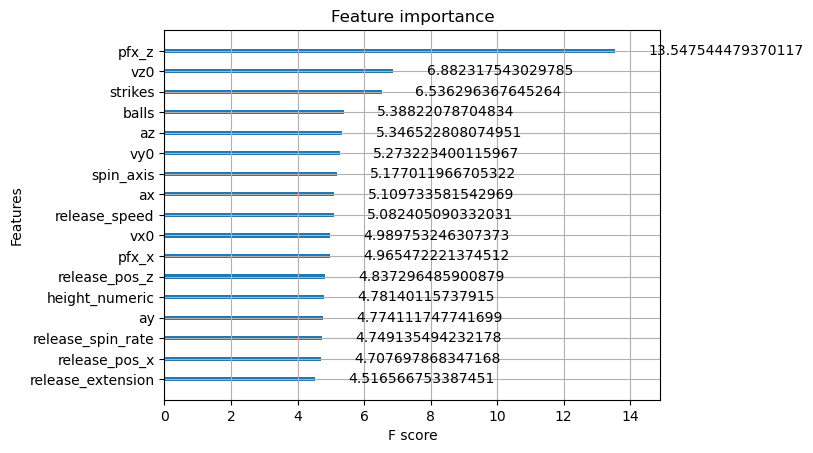

In [114]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [118]:
testing_data.columns

Index(['Unnamed: 0', 'release_speed', 'release_pos_x', 'release_pos_z',
       'balls', 'strikes', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay',
       'az', 'release_spin_rate', 'release_extension', 'release_pos_y',
       'spin_axis', 'height_numeric'],
      dtype='object')

In [124]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [125]:
y_pred = final_model.predict(predictions)

In [126]:
testing_identifiers['xfb'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_19108\3115553546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xfb'] = y_pred


In [128]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fb_2022&3_xfb.csv")

# Offspeed Model 

In [30]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

In [31]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [32]:

len(x2)

152322

In [33]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [34]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [35]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [36]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [37]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [38]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-10-28 15:09:36,123] A new study created in memory with name: no-name-d34c4ef7-2ce4-4779-a65c-e2be8cfab39c
[I 2023-10-28 15:09:36,414] Trial 0 finished with value: 0.9337928770720499 and parameters: {'max_depth': 5, 'eta': 0.24345509256003714, 'subsample': 0.6802305315736025, 'colsample_bytree': 0.9044944080938069}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,685] Trial 1 finished with value: 0.9235844411619891 and parameters: {'max_depth': 6, 'eta': 0.04993409492472433, 'subsample': 0.7491510300973008, 'colsample_bytree': 0.7023858021577918}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,984] Trial 2 finished with value: 0.9369440341375349 and parameters: {'max_depth': 9, 'eta': 0.17788292482168488, 'subsample': 0.7205857498903679, 'colsample_bytree': 0.706986723560932}. Best is trial 2 with value: 0.9369440341375349.
[I 2023-10-28 15:09:37,230] Trial 3 finished with value: 0.931068439192516 and parameters: {'max_depth': 3, 'e

In [39]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9411784014442803
Best hyperparameters: {'max_depth': 9, 'eta': 0.29086504518827216, 'subsample': 0.609950626814756, 'colsample_bytree': 0.8105463899683927}


In [40]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [41]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9393730510421795
Log Loss: 0.15511361543363011


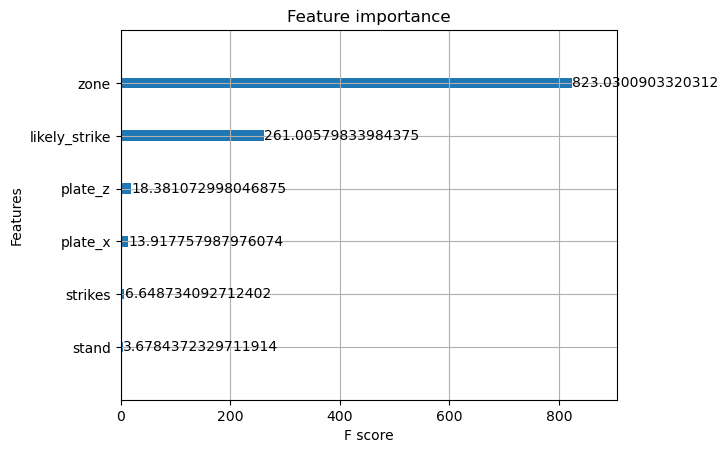

In [42]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [43]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [78]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [79]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [81]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [82]:
len(condition2)

362561

In [84]:
players = pd.read_csv('players_query.csv')

In [85]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [86]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [87]:
strike_probs.head()

,half_inning,Unnamed: 1,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,deltaRE,is_strike,pitch_type_dict,likely_strike,prediction,probability_added,Unnamed: 0,mlb_id,mlb_name,team_name
1,716352_1_Bot,8,SI,2023-10-01,93.5,-2.60,5.68,"King, Michael",677951,650633,...,-0.028510,1,1.0,0,0.781290,0.218710,4412,669224,Austin Wells,yankees
11,716352_2_Bot,46,FF,2023-10-01,93.5,-2.82,5.71,"King, Michael",669004,650633,...,-0.038179,1,1.0,0,0.495411,0.504589,4412,669224,Austin Wells,yankees
28,716352_4_Bot,111,FF,2023-10-01,92.9,-2.66,5.89,"King, Michael",669004,650633,...,-0.038179,1,1.0,0,0.782323,0.217677,4412,669224,Austin Wells,yankees
37,716352_4_Bot,87,SI,2023-10-01,92.2,-2.76,5.67,"King, Michael",672580,650633,...,-0.111258,1,1.0,0,0.813712,0.186288,4412,669224,Austin Wells,yankees
39,716352_4_Top,115,SI,2023-10-01,90.1,-1.27,6.14,"Greinke, Zack",643396,425844,...,-0.043952,1,1.0,0,0.584764,0.415236,1898,521692,Salvador Perez,royals


### Catcher Evaluation

In [88]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Jonah Heim                    369.409200
William Contreras             357.175406
Francisco Alvarez             343.816237
Cal Raleigh                   325.117514
Patrick Bailey                322.223661
J.T. Realmuto                 306.765881
Adley Rutschman               304.310884
Keibert Ruiz                  300.757002
Elias Diaz                    291.464170
Will Smith                    289.637044
Shea Langeliers               285.841658
Sean Murphy                   285.280986
Alejandro Kirk                274.881437
Jake Rogers                   270.437452
Connor Wong                   263.304882
Nick Fortes                   261.444752
Austin Hedges                 252.923828
Yasmani Grandal               249.119006
Christian Vazquez             245.539206
Willson Contreras             243.042565
Gabriel Moreno                240.534485
Kyle Higashioka               236.375578
Martin Maldonado

In [89]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [90]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Jonah Heim                28.298897
William Contreras         27.314465
Francisco Alvarez         26.280338
Cal Raleigh               24.428360
J.T. Realmuto             23.217440
Will Smith                23.151280
Adley Rutschman           22.850475
Austin Hedges             22.659703
Shea Langeliers           22.651095
Elias Diaz                22.566548
Patrick Bailey            22.507789
Keibert Ruiz              22.178750
Alejandro Kirk            21.671238
Kyle Higashioka           20.388670
Nick Fortes               20.349055
Willson Contreras         20.085103
Sean Murphy               20.071047
Connor Wong               20.061680
Jake Rogers               19.988771
Christian Vazquez         19.943172
Martin Maldonado          19.101232
Yasmani Grandal           18.546439
Gabriel Moreno            18.169561
Yan Gomes                 16.646696
Gary Sanchez              15.508716
Salvador Perez            15

In [91]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [92]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [117]:
likely = strike_probs.query('(prediction < .85)')

In [118]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
Jonah Heim                27.265644
William Contreras         26.675339
Francisco Alvarez         25.509967
Cal Raleigh               23.705518
Will Smith                22.504385
J.T. Realmuto             22.293919
Adley Rutschman           22.158913
Austin Hedges             22.132027
Patrick Bailey            22.033697
Shea Langeliers           21.670207
Elias Diaz                21.585984
Keibert Ruiz              21.388849
Alejandro Kirk            20.937702
Kyle Higashioka           19.911051
Nick Fortes               19.775314
Sean Murphy               19.402830
Willson Contreras         19.372176
Christian Vazquez         19.285147
Connor Wong               19.231894
Jake Rogers               19.224211
Martin Maldonado          18.579309
Yasmani Grandal           17.983997
Gabriel Moreno            17.519849
Yan Gomes                 16.075565
Gary Sanchez              14.937981
Salvador Perez            14

###  I think that this is the best leaderboard. Filters out the gimme pitches